In [5]:
from __future__ import division
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import math
import traceback
import pickle
from print_progress import print_progress

class RollingAverage:
    def __init__(self, n):
        self.n = n
        self.head = 0
        self.window = np.zeros(n)
        self.window_true = np.zeros(n)
        self.weight = np.zeros(n)

    def push(self, val, val_true, weightval):
        self.window[self.head] = val
        self.window_true[self.head] = val_true
        self.weight[self.head] = weightval
        self.head += 1
        self.head %= self.n
        
    def maxh(self):
        maxi = 0
        for i in range(self.n):
            if self.weight[i] > maxi and self.window_true[i] == 1:
                maxi = self.weight[i]
        return maxi

    def mean(self):
        for i in range(self.n):
            if self.maxh() > 0 and self.window[i] != 1:
                self.window[i] = self.window[i] / self.maxh()
        return np.mean(self.window)
    
    def mean2(self):
        summ = 0
        for i in range(self.n):
            if self.window[i] > 0:
                summ += 1
        return summ / self.n

    

    
def rk45(odefun, tspan, yini, options):
    """
    Runge-Kutta-Fehlberg 4(5) implementation for autonomous systems
    +------------++------------+------------+------------+------------+------------+------------+
    |     0      ||            |            |            |            |            |            |
    +------------++------------+------------+------------+------------+------------+------------+
    |    1/4     ||    1/4     |            |            |            |            |            |
    +------------++------------+------------+------------+------------+------------+------------+
    |    3/8     ||    3/32    |    9/32    |            |            |            |            |
    +------------++------------+------------+------------+------------+------------+------------+
    |   12/13    || 1932/2197  | -7200/2197 | 7296/2197  |            |            |            |
    +------------++------------+------------+------------+------------+------------+------------+
    |     1      ||  439/216   |     -8     |  3680/513  | -845/4104  |            |            |
    +------------++------------+------------+------------+------------+------------+------------+
    |    1/2     ||   -8/27    |     2      | -3544/2565 | 1859/4104  |   -11/40   |            |
    +------------++------------+------------+------------+------------+------------+------------+
    +------------++------------+------------+------------+------------+------------+------------+
    |    O(5)    ||   16/135   |     0      | 6656/12825 |28561/56430 |   -9/50    |    2/55    |
    +------------++------------+------------+------------+------------+------------+------------+
    |    O(4)    ||   25/216   |     0      | 1408/2565  | 2197/4104  |    -1/5    |     0      |
    +------------++------------+------------+------------+------------+------------+------------+
    """

    try:
        c       = np.zeros(6)
        c[:]    = [      0      ,     1/4    ,     3/8    ,    12/13   ,     1      ,     1/2    ]

        a       = np.zeros((6, 6))
        a[:,:]  = [[     0      ,      0     ,      0     ,      0     ,      0     ,      0     ],
                   [    1/4     ,      0     ,      0     ,      0     ,      0     ,      0     ],
                   [    3/32    ,    9/32    ,      0     ,      0     ,      0     ,      0     ],
                   [ 1932/2197  , -7200/2197 , 7296/2197  ,      0     ,      0     ,      0     ],
                   [  439/216   ,     -8     ,  3680/513  , -845/4104  ,      0     ,      0     ],
                   [   -8/27    ,     2      , 3544/2565 , 1859/4104  ,   -11/40   ,      0     ]]


        b       = np.zeros((2, 6))
        b[:,:]  = [[   16/135   ,     0      , 6656/12825 ,28561/56430 ,   -9/50    ,    2/55    ],
                   [   25/216   ,     0      , 1408/2565  , 2197/4104  ,    -1/5    ,     0      ]]

        # store the number of variables
        n       = len(yini)
        nstages = 6

        # check the existence of abstol and reltol
        if 'abstol' in options:
            abstol = options['abstol']
        else:
            abstol = 1.0e-4

        if 'reltol' in options:
            reltol = options['reltol']
        else:
            reltol = 1.0e-4

        # check for the existence of count of checkpoints
        if 'numcheckpoints' in options:
            numcheckpoints = options['numcheckpoints']
        else:
            numcheckpoints = 10

        # reset values of nacc and nrej
        options['nacc'] = 0
        options['nrej'] = 0

        # now divide up the interval with numcheckpoints
        timepoints = np.linspace(tspan[0], tspan[1], numcheckpoints + 1)

        print(timepoints)

        # create solution trajectory
        trajectory = np.zeros((n, numcheckpoints + 1))

        # store the initial solution
        trajectory[:, 0] = yini

        # stage values
        Y = np.zeros((n, nstages))

        # f values
        K = np.zeros((n, nstages))

        # store yini and compute fini
        Y[:, 0] = yini
        K[:, 0] = odefun(Y[:, 0])

        # Get h value from options if it exists
        if 'h' in options:
            h = options['h']
        else:
            h = 1.0e-3

        # get the machine epsilon
        eps = np.spacing(1)

        # rounding
        roundoff = eps/2.0
            
        # get the initial time
        t   = tspan[0]

        # get the final time
        tf  = tspan[1]

        # index for comparison against timepoints
        # to store trajectory when it exceeds this
        # or equals it
        i   = 0

        # safety factor
        fac = 0.8

        # Get hold of the model
        # expect a function model.train(X, y)
        # and model.predict(X)
        if 'model' in options:
            model = options['model']
        else:
            raise "Need an online model with train and predict methods."
        
        # number of variables to observe
        if 'nobservations' in options:
            nobs = options['nobservations']
        else:
            nobs = max(10, int(0.01 * n))
            
        # create training mask by randomly selecting
        # variables to observe
        if 'mask' in options:
            mask = options['mask']
        else:
            mask = np.rint(np.linspace(0, n - 1, min(n, nobs))).astype(int)
            print(mask)

        # Get hold of validation window size
        # window and success threshold
        if 'nvalidation' in options:
            nvalidation = options['nvalidation']
        else:
            nvalidation = 10

        # create a validation window
        # push one whenever prediction turned out to be
        # true otherwise push zero
        validation_window = RollingAverage(nvalidation)

        # only if the validation window has atleast
        # threshold number of successes will the
        # model be used to predict.
        if 'valthreshold' in options:
            valthreshold = options['valthreshold']
        else:
            valthreshold = 0.60

        # a constant by which to shrink stepsize if next step
        # is predicted to be rejected.
        if 'shrinkfactor' in options:
            shrinkfactor = options['shrinkfactor']
        else:
            shrinkfactor = 0.8

        # maxtimes to shrink stepsize if next step
        # is predicted to be rejected.
        if 'maxshrinks' in options:
            maxshrinks = options['maxshrinks']
        else:
            maxshrinks = 5

        # Store nsamples window of past features and data
        if 'nsamples' in options:
            nsamples = options['nsamples']
        else:
            nsamples = 10

        # Create feature variable with nsamples
        # and additional feature for step size
        featureX    = np.zeros((1, len(mask) + 1))

        # For accept signal
        signalYAcc  = np.zeros(nsamples)
        featureXAcc = np.zeros((nsamples, len(mask) + 1))
        countAcc    = 0
        indexAcc    = 0

        # For reject signal
        signalYRej  = np.zeros(nsamples)
        featureXRej = np.zeros((nsamples, len(mask) + 1))
        countRej    = 0
        indexRej    = 0

        # Minimum number of training samples
        if 'minsamples' in options:
            minsamples = options['minsamples']
        else:
            minsamples = nsamples
            
        # past prediction
        acceptnext = None

        # Step size stats
        steps      = []

        # Successful model predictions
        nvalid_models = []
        
        while tf - t - roundoff >= 0:
            # print a progress bar to track stuff
            print_progress(int(t/tf*100), 100)
            
            if tf - t <= 10 * roundoff * abs(tf):
                break
            
            for s in range(nstages - 1):
                Y[:, s + 1] = Y[:, 0] + h * K.dot(a[s + 1, :])
                K[:, s + 1] = odefun(Y[:, s + 1])

            # final output and error
            yfin = Y[:, 0] + h * K.dot(b[0, :])
            yerr = h * K.dot((b[0, :] - b[1, :]))
            
            # find the scaling factor            
            sc   = abstol + np.maximum(np.abs(Y[:, 0]), np.abs(yfin)) * reltol

            # compute the error
            err  = max(np.sqrt(np.sum((yerr / sc)**2)/n), 1.0e-10)

            # accept or reject
            if err <= 1:
                # append stepsize for plotting later on
                steps.append((h, 1))
                
                # accept
                if acceptnext == True:
                    validation_window.push(1,1,h)
                else:
                    validation_window.push(0,1,h)
                    
                # train
                # append accept signal
                featureXAcc[indexAcc, :-1] = Y[mask, 0]
                featureXAcc[indexAcc, -1]  = h
                signalYAcc[indexAcc]       = 1            # accept signal
                countAcc                  += 1
                indexAcc                  += 1
                countAcc                   = min(nsamples, countAcc)
                indexAcc                  %= nsamples     # replace oldest pair

                # Only train if min num of samples are met
                # and atleast one training signal of each class
                if countAcc > 0 and countRej > 0 and (countAcc + countRej) > minsamples:
                    fX = np.vstack((featureXAcc[:countAcc,:], featureXRej[:countRej, :]))
                    sY = np.hstack((signalYAcc[:countAcc], signalYRej[:countRej]))
                    if __debug__:
                        print("Training Model")               
                    model.train(fX, sY)
                
                # now store the final output as next step ini
                Y[:, 0] = yfin
                K[:, 0] = odefun(Y[:, 0])
            
                # store the solution
                if t + h - timepoints[i + 1] >= 0 or tf - t - h <= 10 * roundoff * abs(tf):
                    i                = i + 1
                    trajectory[:, i] = yfin

                # increment time by h
                t = t + h

                # increment the count of accepted steps
                options['nacc'] += 1

                # compute the new h for next timestep
                h = h * min(1.5, max(0.2, fac * (1/err)**(1/5)))
                #h = max(h, validation_window.maxh())

                # Only predict if you have already trained
                if countAcc > 0 and countRej > 0 and (countAcc + countRej) > minsamples:
                    # construct new feature with new h and Y value
                    featureX[0,:-1] = Y[mask, 0]
                    featureX[0, -1] = h
                    if __debug__:
                        print("Validating Model")                 
                    # prediction and validation
                    sY         = model.predict(featureX)
                    acceptnext = (sY == 1)

                # model is somewhat trustworthy
                # if next step won't be accepted,
                # shrink stepsize by shrink constant
                # test for step acceptance
                if accuracy_score(validation_window.window_true, validation_window.window, sample_weight=validation_window.weight
                                  ) > valthreshold:
                    nvalid_models.append(1)
                    if __debug__:
                        print("Using Model for Prediction")
                    if not acceptnext:
                        for j in range(maxshrinks):
                            h *= shrinkfactor
                            featureX[0, -1] = h
                            acceptnext = (model.predict(featureX) == 1)

                            if acceptnext:
                                break
                        
                else:
                    nvalid_models.append(0)
            else:
                # append stepsize for plotting later on
                steps.append((h, 0))
                
                # reject
                if acceptnext == False:
                    validation_window.push(0,0,h)
                else:
                    validation_window.push(1,0,h)
                    
                # train
                # append reject signal
                featureXRej[indexRej, :-1] = Y[mask, 0]
                featureXRej[indexRej, -1]  = h
                signalYRej[indexRej]       = 0            # reject signal
                countRej                  += 1
                indexRej                  += 1
                countRej                   = min(nsamples, countRej)
                indexRej                  %= nsamples     # replace oldest pair

                # Only train if min num of samples are met
                # and atleast one training signal of each class
                if countAcc > 0 and countRej > 0 and (countAcc + countRej) > minsamples:
                    fX = np.vstack((featureXAcc[:countAcc,:], featureXRej[:countRej, :]))
                    sY = np.hstack((signalYAcc[:countAcc], signalYRej[:countRej]))
                    if __debug__:
                        print("Training Model")                
                    model.train(fX, sY)

                # increment the count of rejected steps
                options['nrej'] += 1
               
                # compute the new h for next timestep
                h = h * min(1.0, max(0.2, fac * (1/err)**(1/5)))
                #h = max(h, validation_window.maxh())

                if countAcc > 0 and countRej > 0 and (countAcc + countRej) > minsamples:
                    # construct new feature with new h 
                    featureX[0, -1]  = h
                    if __debug__:
                        print("Validating Model")
                    # prediction and validation
                    sY         = model.predict(featureX)
                    acceptnext = (sY == 1)
                
                # model is somewhat trustworthy
                # if next step won't be accepted,
                # shrink stepsize by shrink constant
                if accuracy_score(validation_window.window_true,validation_window.window, sample_weight=validation_window.weight
                                  ) > valthreshold:
                    nvalid_models.append(1)
                    if __debug__:
                        print("Using Model for Prediction")
                    if not acceptnext:
                        for j in range(maxshrinks):
                            h *= shrinkfactor
                            featureX[0, -1] = h
                            acceptnext = (model.predict(featureX) == 1)

                            if acceptnext:
                                break
                else:
                    nvalid_models.append(0)

        print("\nPickling statistics.")
        
        # dump statistics
        pickle.dump({'steps':steps, 'nvalid_models':nvalid_models}, open('stats.p','wb'))
        
        return trajectory[:, :i]
    except BaseException as e:
        print(traceback.print_exc())    


In [2]:
# -*- coding: utf-8 -*-
# from gist: https://gist.github.com/aubricus/f91fb55dc6ba5557fbab06119420dd6a
import sys

# Print iterations progress
def print_progress(iteration, total, prefix='', suffix='', decimals=1, bar_length=100):
    """
    Call in a loop to create terminal progress bar

    @params:
        iteration   - Required  : current iteration (Int)
        total       - Required  : total iterations (Int)
        prefix      - Optional  : prefix string (Str)
        suffix      - Optional  : suffix string (Str)
        decimals    - Optional  : positive number of decimals in percent complete (Int)
        bar_length  - Optional  : character length of bar (Int)
    """
    str_format = "{0:." + str(decimals) + "f}"
    percents = str_format.format(100 * (iteration / float(total)))
    filled_length = int(round(bar_length * iteration / float(total)))
    bar = '█' * filled_length + '-' * (bar_length - filled_length)

    sys.stdout.write('\r%s |%s| %s%s %s' % (prefix, bar, percents, '%', suffix)),

    if iteration == total:
        sys.stdout.write('\n')
    sys.stdout.flush()


In [3]:
import numpy as np
import functools as ft

def InitializeModel():
    #  Solves the Allen Cahn problem from 
    #  M.P. Calvo and A. Gerisch.
    #  Linearly implicit Runge-Kutta methods and approximate matrix 
    #  factorization. Applied Numerical Mathematics,
    #  53(2):183-200, 2005.

    # Parameters defining the RHS behavior.
    myalpha = 1
    mygamma = 10

    # Grid size in x and y
    M = 128
    N = 128

    # Suggested integration information.
    Tspan = np.array([0, 0.075])
    dt_integration = 0.002

    # linear representation of x and y variables
    x = np.linspace(0,1,M)
    y = np.linspace(0,1,N)

    # Grid representation of x and y.
    X, Y = np.meshgrid(x,y)

    # grid representation of initial condition.
    u0 = 0.4 + 0.1 * (X + Y) + 0.1 * (np.sin(10*X) * np.sin(20*Y))
    
    # grid representation of boundary values corresponding to the intitial condition.
    bound  = lambda i,j,dx,dy: (0.4 + 0.1 * ((j - 1) * dx + (i - 1) * dy) + 
                               0.1 * (np.sin(10 * (j - 1) * dx) * np.sin(20 * (i - 1) *dy)))

    # linear representation of initial condition.
    y0     = np.reshape(u0, M*N)
    
    # RHS and Jacobian function calls, in MATLAB standard form.
    rhsFun = ft.partial(AllenCahnNeumann, M=M, N=N, alpha=myalpha, gamma=mygamma, bound=bound)

    model  = {'rhsFun': rhsFun,
             'y0':     y0,
             'Tspan':  Tspan,
             'dt':     dt_integration,
             'M':      M,
             'N':      N,
             'alpha':  myalpha,
             'gamma':  mygamma}

    return model
             
    
def AllenCahnNeumann(u, M, N, alpha, gamma, bound):
    dx = 1.0/(N-1)
    dy = 1.0/(M-1)
    f  = np.zeros(M*N)
    
    for i in range(1, M+1):
        for j in range(1, N+1):        
            self = i + M * (j - 1) - 1 

            if ( i == 1 ):
                down = u[self] - dy * bound(i, j, dx, dy)
            else:
                down = u[i - 1 + M * (j - 1) - 1]
                
            if ( i == M ):
                up = u[self] + dy * bound(i,j,dx,dy)
            else:
                up = u[i + 1 + M * (j - 1) - 1]
        
            if ( j == 1 ):
                left = u[self] - dx * bound(i,j,dx,dy)
            else:
                left = u[i + M * (j - 2) - 1]
        
            if ( j == N ):
                right = u[self] + dx * bound(i,j,dx,dy)

            else:
                right = u[i + M * j - 1]
        
            uself = u[self]

            f[self] = alpha * (1.0/dy**2 * (up    - 2 * uself + down)  + \
                               1.0/dx**2 * (right - 2 * uself + left)) + gamma * (uself - uself**3)
            
    return f





[0.     0.0003 0.0006 ... 0.2994 0.2997 0.3   ]
[    0   683  1365  2048  2730  3413  4096  4778  5461  6144  6826  7509
  8192  8874  9557 10239 10922 11605 12287 12970 13652 14335 15018 15700
 16383]
 |----------------------------------------------------------------------------------------------------| 0.0% 0.1
0
 |----------------------------------------------------------------------------------------------------| 0.0% 0.2
0
 |----------------------------------------------------------------------------------------------------| 0.0% 0.3
0
 |----------------------------------------------------------------------------------------------------| 0.0% 0.4
0
 |----------------------------------------------------------------------------------------------------| 0.0% 0.5
0
 |----------------------------------------------------------------------------------------------------| 0.0% 0.6
0
 |----------------------------------------------------------------------------------------------------| 0.0%

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.1300642019015297e-07
Validating Model
0.7
4.8960104884492e-07
 |----------------------------------------------------------------------------------------------------| 0.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.7430143770094526e-07
Validating Model
0.7
4.8960104884492e-07
 |----------------------------------------------------------------------------------------------------| 0.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.53960618971555e-07
Validating Model
0.6
4.8960104884492e-07
 |----------------------------------------------------------------------------------------------------| 0.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.4328533998070425e-07
Validating Model
0.5
4.8960104884492e-07
 |----------------------------------------------------------------------------------------------------| 0.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.37966729511262e-07
Validating Model
0.4
4.8960104884492e-07
 |----------------------------------------------------------------------------------------------------| 0.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.357143281216605e-07
Validating Model
0.4
4.8960104884492e-07
 |----------------------------------------------------------------------------------------------------| 0.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.3525393362305183e-07
Validating Model
0.4
4.8960104884492e-07
 |----------------------------------------------------------------------------------------------------| 0.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.358561780802103e-07
Validating Model
0.3
4.8960104884492e-07
 |----------------------------------------------------------------------------------------------------| 0.0% Training Model
3.370961788180601e-07
Validating Model
0.3
4.8960104884492e-07
 |----------------------------------------------------------------------------------------------------| 0.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.387237948348302e-07
Validating Model
0.4
4.1300642019015297e-07
 |----------------------------------------------------------------------------------------------------| 0.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.4059083722386025e-07
Validating Model
0.5
3.7430143770094526e-07
 |----------------------------------------------------------------------------------------------------| 0.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.426092039412856e-07
Validating Model
0.5
3.53960618971555e-07
 |----------------------------------------------------------------------------------------------------| 0.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.447264224990512e-07
Validating Model
0.6
3.447264224990512e-07
 |----------------------------------------------------------------------------------------------------| 0.0% Training Model
3.4691122494920155e-07
Validating Model
0.7
3.4691122494920155e-07
Using Model for Prediction
 |----------------------------------------------------------------------------------------------------| 0.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.4914499044096086e-07
Validating Model
0.8
3.4914499044096086e-07
Using Model for Prediction
 |----------------------------------------------------------------------------------------------------| 0.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.5141665089107144e-07
Validating Model
0.8
3.5141665089107144e-07
Using Model for Prediction
 |----------------------------------------------------------------------------------------------------| 0.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.159068555433969e-07
Validating Model
0.7
3.5141665089107144e-07
Using Model for Prediction
 |----------------------------------------------------------------------------------------------------| 0.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.7386028331509535e-07
Validating Model
0.8
3.5141665089107144e-07
Using Model for Prediction
 |----------------------------------------------------------------------------------------------------| 0.0% Training Model
2.325911560575272e-07
Validating Model
0.8
3.5141665089107144e-07
Using Model for Prediction
 |----------------------------------------------------------------------------------------------------| 0.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.773745767187595e-07
Validating Model
0.8
3.5141665089107144e-07
Using Model for Prediction
 |----------------------------------------------------------------------------------------------------| 0.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.0885903403423915e-07
Validating Model
0.8
3.5141665089107144e-07
Using Model for Prediction
 |----------------------------------------------------------------------------------------------------| 0.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.3015062512050046e-07
Validating Model
0.9
3.5141665089107144e-07
Using Model for Prediction
 |----------------------------------------------------------------------------------------------------| 0.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.4443285285450075e-07
Validating Model
0.9
3.5141665089107144e-07
Using Model for Prediction
 |----------------------------------------------------------------------------------------------------| 0.0% Training Model
3.541745441575819e-07
Validating Model
0.9
3.541745441575819e-07
Using Model for Prediction
 |----------------------------------------------------------------------------------------------------| 0.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.6107563355999825e-07
Validating Model
0.9
3.6107563355999825e-07
Using Model for Prediction
 |----------------------------------------------------------------------------------------------------| 0.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.66237531859228e-07
Validating Model
0.9
3.66237531859228e-07
Using Model for Prediction
 |----------------------------------------------------------------------------------------------------| 0.0% Training Model
3.703503699563248e-07
Validating Model
1.0
3.703503699563248e-07
Using Model for Prediction
 |----------------------------------------------------------------------------------------------------| 0.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.7383841980437065e-07
Validating Model
1.0
3.7383841980437065e-07
Using Model for Prediction
 |----------------------------------------------------------------------------------------------------| 0.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.7695965823682293e-07
Validating Model
1.0
3.7695965823682293e-07
Using Model for Prediction
 |----------------------------------------------------------------------------------------------------| 0.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.7986995236181797e-07
Validating Model
1.0
3.7986995236181797e-07
Using Model for Prediction
 |----------------------------------------------------------------------------------------------------| 0.0% Training Model
3.8266313635180514e-07
Validating Model
1.0
3.8266313635180514e-07
Using Model for Prediction
 |----------------------------------------------------------------------------------------------------| 0.0% Training Model
3.8539559229051477e-07
Validating Model
1.0
3.8539559229051477e-07
Using Model for Prediction
 |----------------------------------------------------------------------------------------------------| 0.0% Training Model
3.881011730033808e-07
Validating Model
1.0
3.881011730033808e-07
Using Model for Prediction
 |----------------------------------------------------------------------------------------------------| 0.0% Training Model
3.9080020765655275e-07
Validating Model
1.0
3.9080020765655275e-07
Using Model for Prediction
 |-------------------

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.397029213693951e-07
Validating Model
1.0
4.397029213693951e-07
Using Model for Prediction
 |----------------------------------------------------------------------------------------------------| 0.0% Training Model
4.42799272791974e-07
Validating Model
1.0
4.42799272791974e-07
Using Model for Prediction
 |----------------------------------------------------------------------------------------------------| 0.0% Training Model
4.4592087381365773e-07
Validating Model
1.0
4.4592087381365773e-07
Using Model for Prediction
 |----------------------------------------------------------------------------------------------------| 0.0% Training Model
1.471505232444882e-07
Validating Model
0.9
4.4592087381365773e-07
Using Model for Prediction
 |----------------------------------------------------------------------------------------------------| 0.0% Training Model
2.207257848667323e-07
Validating Model
0.9
4.4592087381365773e-07
Using Model for Prediction
 |-------------------------

 |----------------------------------------------------------------------------------------------------| 0.0% Training Model
7.020803490159151e-07
Validating Model
1.0
7.020803490159151e-07
Using Model for Prediction
 |----------------------------------------------------------------------------------------------------| 0.0% Training Model
7.066103814409691e-07
Validating Model
1.0
7.066103814409691e-07
Using Model for Prediction
 |----------------------------------------------------------------------------------------------------| 0.0% Training Model
7.111526255730405e-07
Validating Model
1.0
7.111526255730405e-07
Using Model for Prediction
 |----------------------------------------------------------------------------------------------------| 0.0% Training Model
7.157068868507373e-07
Validating Model
1.0
7.157068868507373e-07
Using Model for Prediction
 |----------------------------------------------------------------------------------------------------| 0.0% Training Model
7.2027292292

 |----------------------------------------------------------------------------------------------------| 0.0% Training Model
8.80451471832856e-07
Validating Model
1.0
8.80451471832856e-07
Using Model for Prediction
 |----------------------------------------------------------------------------------------------------| 0.0% Training Model
8.852494946120862e-07
Validating Model
1.0
8.852494946120862e-07
Using Model for Prediction
 |----------------------------------------------------------------------------------------------------| 0.0% Training Model
8.900494147082337e-07
Validating Model
1.0
8.900494147082337e-07
Using Model for Prediction
 |----------------------------------------------------------------------------------------------------| 0.0% Training Model
8.948509981386264e-07
Validating Model
1.0
8.948509981386264e-07
Using Model for Prediction
 |----------------------------------------------------------------------------------------------------| 0.0% Training Model
8.996540130809

 |----------------------------------------------------------------------------------------------------| 0.0% Training Model
1.0523134342557054e-06
Validating Model
1.0
1.0523134342557054e-06
Using Model for Prediction
 |----------------------------------------------------------------------------------------------------| 0.0% Training Model
1.0570524594000685e-06
Validating Model
1.0
1.0570524594000685e-06
Using Model for Prediction
 |----------------------------------------------------------------------------------------------------| 0.0% Training Model
1.0617838917607862e-06
Validating Model
1.0
1.0617838917607862e-06
Using Model for Prediction
 |----------------------------------------------------------------------------------------------------| 0.0% Training Model
1.0665084785801809e-06
Validating Model
1.0
1.0665084785801809e-06
Using Model for Prediction
 |----------------------------------------------------------------------------------------------------| 0.0% Training Model
1.07

 |----------------------------------------------------------------------------------------------------| 0.0% Training Model
1.2271748979912208e-06
Validating Model
1.0
1.2271748979912208e-06
Using Model for Prediction
 |----------------------------------------------------------------------------------------------------| 0.0% Training Model
1.2316036472614486e-06
Validating Model
1.0
1.2316036472614486e-06
Using Model for Prediction
 |----------------------------------------------------------------------------------------------------| 0.0% Training Model
1.2360220166399668e-06
Validating Model
1.0
1.2360220166399668e-06
Using Model for Prediction
 |----------------------------------------------------------------------------------------------------| 0.0% Training Model
1.240429912509624e-06
Validating Model
1.0
1.240429912509624e-06
Using Model for Prediction
 |----------------------------------------------------------------------------------------------------| 0.0% Training Model
1.2448

 |----------------------------------------------------------------------------------------------------| 0.0% Training Model
1.38753872124055e-06
Validating Model
1.0
1.38753872124055e-06
Using Model for Prediction
 |----------------------------------------------------------------------------------------------------| 0.0% Training Model
1.391525221904716e-06
Validating Model
1.0
1.391525221904716e-06
Using Model for Prediction
 |----------------------------------------------------------------------------------------------------| 0.0% Training Model
1.3954992708263335e-06
Validating Model
1.0
1.3954992708263335e-06
Using Model for Prediction
 |----------------------------------------------------------------------------------------------------| 0.0% Training Model
1.3994608525388061e-06
Validating Model
1.0
1.3994608525388061e-06
Using Model for Prediction
 |----------------------------------------------------------------------------------------------------| 0.0% Training Model
1.40340995

 |----------------------------------------------------------------------------------------------------| 0.0% Training Model
1.530265214031686e-06
Validating Model
1.0
1.530265214031686e-06
Using Model for Prediction
 |----------------------------------------------------------------------------------------------------| 0.0% Training Model
1.5337814317172575e-06
Validating Model
1.0
1.5337814317172575e-06
Using Model for Prediction
 |----------------------------------------------------------------------------------------------------| 0.0% Training Model
1.5372857053769561e-06
Validating Model
1.0
1.5372857053769561e-06
Using Model for Prediction
 |----------------------------------------------------------------------------------------------------| 0.0% Training Model
1.5407780731493623e-06
Validating Model
1.0
1.5407780731493623e-06
Using Model for Prediction
 |----------------------------------------------------------------------------------------------------| 0.0% Training Model
1.5442

 |----------------------------------------------------------------------------------------------------| 0.0% Training Model
1.6558665001626605e-06
Validating Model
1.0
1.6558665001626605e-06
Using Model for Prediction
 |----------------------------------------------------------------------------------------------------| 0.0% Training Model
1.6589621622908295e-06
Validating Model
1.0
1.6589621622908295e-06
Using Model for Prediction
 |----------------------------------------------------------------------------------------------------| 0.0% Training Model
1.6620478255055e-06
Validating Model
1.0
1.6620478255055e-06
Using Model for Prediction
 |----------------------------------------------------------------------------------------------------| 0.0% Training Model
1.665123549960216e-06
Validating Model
1.0
1.665123549960216e-06
Using Model for Prediction
 |----------------------------------------------------------------------------------------------------| 0.0% Training Model
1.6681893960

 |----------------------------------------------------------------------------------------------------| 0.0% Training Model
1.7669904065446247e-06
Validating Model
1.0
1.7669904065446247e-06
Using Model for Prediction
 |----------------------------------------------------------------------------------------------------| 0.0% Training Model
1.7697494084978784e-06
Validating Model
1.0
1.7697494084978784e-06
Using Model for Prediction
 |----------------------------------------------------------------------------------------------------| 0.0% Training Model
1.7725007563106614e-06
Validating Model
1.0
1.7725007563106614e-06
Using Model for Prediction
 |----------------------------------------------------------------------------------------------------| 0.0% Training Model
1.7752445108158885e-06
Validating Model
1.0
1.7752445108158885e-06
Using Model for Prediction
 |----------------------------------------------------------------------------------------------------| 0.0% Training Model
1.77

 |----------------------------------------------------------------------------------------------------| 0.0% Training Model
1.8669511564227558e-06
Validating Model
1.0
1.8669511564227558e-06
Using Model for Prediction
 |----------------------------------------------------------------------------------------------------| 0.0% Training Model
1.8694604387359926e-06
Validating Model
1.0
1.8694604387359926e-06
Using Model for Prediction
 |----------------------------------------------------------------------------------------------------| 0.0% Training Model
1.871964234345619e-06
Validating Model
1.0
1.871964234345619e-06
Using Model for Prediction
 |----------------------------------------------------------------------------------------------------| 0.0% Training Model
1.8744625954940245e-06
Validating Model
1.0
1.8744625954940245e-06
Using Model for Prediction
 |----------------------------------------------------------------------------------------------------| 0.0% Training Model
1.8769

 |----------------------------------------------------------------------------------------------------| 0.0% Training Model
1.9588670298668892e-06
Validating Model
1.0
1.9588670298668892e-06
Using Model for Prediction
 |----------------------------------------------------------------------------------------------------| 0.0% Training Model
1.9612022069076476e-06
Validating Model
1.0
1.9612022069076476e-06
Using Model for Prediction
 |----------------------------------------------------------------------------------------------------| 0.0% Training Model
1.963533687606749e-06
Validating Model
1.0
1.963533687606749e-06
Using Model for Prediction
 |----------------------------------------------------------------------------------------------------| 0.0% Training Model
1.9658615137163783e-06
Validating Model
1.0
1.9658615137163783e-06
Using Model for Prediction
 |----------------------------------------------------------------------------------------------------| 0.0% Training Model
1.9681

 |----------------------------------------------------------------------------------------------------| 0.0% Training Model
2.045338336480544e-06
Validating Model
1.0
2.045338336480544e-06
Using Model for Prediction
 |----------------------------------------------------------------------------------------------------| 0.0% Training Model
2.0475602398813856e-06
Validating Model
1.0
2.0475602398813856e-06
Using Model for Prediction
 |----------------------------------------------------------------------------------------------------| 0.0% Training Model
2.049779856031656e-06
Validating Model
1.0
2.049779856031656e-06
Using Model for Prediction
 |----------------------------------------------------------------------------------------------------| 0.0% Training Model
2.0519972174137014e-06
Validating Model
1.0
2.0519972174137014e-06
Using Model for Prediction
 |----------------------------------------------------------------------------------------------------| 0.0% Training Model
2.054212

 |----------------------------------------------------------------------------------------------------| 0.0% Training Model
2.1284214586381795e-06
Validating Model
1.0
2.1284214586381795e-06
Using Model for Prediction
 |----------------------------------------------------------------------------------------------------| 0.0% Training Model
2.130577558037418e-06
Validating Model
1.0
2.130577558037418e-06
Using Model for Prediction
 |----------------------------------------------------------------------------------------------------| 0.0% Training Model
2.1327324641964193e-06
Validating Model
1.0
2.1327324641964193e-06
Using Model for Prediction
 |----------------------------------------------------------------------------------------------------| 0.0% Training Model
2.1348862023668697e-06
Validating Model
1.0
2.1348862023668697e-06
Using Model for Prediction
 |----------------------------------------------------------------------------------------------------| 0.0% Training Model
2.1370

 |----------------------------------------------------------------------------------------------------| 0.0% Training Model
2.209716054465489e-06
Validating Model
1.0
2.209716054465489e-06
Using Model for Prediction
 |----------------------------------------------------------------------------------------------------| 0.0% Training Model
2.211843285385882e-06
Validating Model
1.0
2.211843285385882e-06
Using Model for Prediction
 |----------------------------------------------------------------------------------------------------| 0.0% Training Model
2.213970179019311e-06
Validating Model
1.0
2.213970179019311e-06
Using Model for Prediction
 |----------------------------------------------------------------------------------------------------| 0.0% Training Model
2.2160967553164198e-06
Validating Model
1.0
2.2160967553164198e-06
Using Model for Prediction
 |----------------------------------------------------------------------------------------------------| 0.0% Training Model
2.21822303

 |----------------------------------------------------------------------------------------------------| 0.0% Training Model
2.2904739169718676e-06
Validating Model
1.0
2.2904739169718676e-06
Using Model for Prediction
 |----------------------------------------------------------------------------------------------------| 0.0% Training Model
2.292601446329983e-06
Validating Model
1.0
2.292601446329983e-06
Using Model for Prediction
 |----------------------------------------------------------------------------------------------------| 0.0% Training Model
2.2947293228971473e-06
Validating Model
1.0
2.2947293228971473e-06
Using Model for Prediction
 |----------------------------------------------------------------------------------------------------| 0.0% Training Model
2.29685756287546e-06
Validating Model
1.0
2.29685756287546e-06
Using Model for Prediction
 |----------------------------------------------------------------------------------------------------| 0.0% Training Model
2.29898618

 |----------------------------------------------------------------------------------------------------| 0.0% Training Model
2.371695190339895e-06
Validating Model
1.0
2.371695190339895e-06
Using Model for Prediction
 |----------------------------------------------------------------------------------------------------| 0.0% Training Model
2.37384667446625e-06
Validating Model
1.0
2.37384667446625e-06
Using Model for Prediction
 |----------------------------------------------------------------------------------------------------| 0.0% Training Model
2.3759990706836166e-06
Validating Model
1.0
2.3759990706836166e-06
Using Model for Prediction
 |----------------------------------------------------------------------------------------------------| 0.0% Training Model
2.3781523926194894e-06
Validating Model
1.0
2.3781523926194894e-06
Using Model for Prediction
 |----------------------------------------------------------------------------------------------------| 0.0% Training Model
2.38030665

 |----------------------------------------------------------------------------------------------------| 0.0% Training Model
2.454203992398879e-06
Validating Model
1.0
2.454203992398879e-06
Using Model for Prediction
 |----------------------------------------------------------------------------------------------------| 0.0% Training Model
2.45639929551906e-06
Validating Model
1.0
2.45639929551906e-06
Using Model for Prediction
 |----------------------------------------------------------------------------------------------------| 0.0% Training Model
2.4585959947202827e-06
Validating Model
1.0
2.4585959947202827e-06
Using Model for Prediction
 |----------------------------------------------------------------------------------------------------| 0.0% Training Model
2.460794101927668e-06
Validating Model
1.0
2.460794101927668e-06
Using Model for Prediction
 |----------------------------------------------------------------------------------------------------| 0.0% Training Model
2.4629936290

 |----------------------------------------------------------------------------------------------------| 0.0% Training Model
2.5387051502577845e-06
Validating Model
1.0
2.5387051502577845e-06
Using Model for Prediction
 |----------------------------------------------------------------------------------------------------| 0.0% Training Model
2.540961619756409e-06
Validating Model
1.0
2.540961619756409e-06
Using Model for Prediction
 |----------------------------------------------------------------------------------------------------| 0.0% Training Model
2.5432199170776448e-06
Validating Model
1.0
2.5432199170776448e-06
Using Model for Prediction
 |----------------------------------------------------------------------------------------------------| 0.0% Training Model
2.54548005308584e-06
Validating Model
1.0
2.54548005308584e-06
Using Model for Prediction
 |----------------------------------------------------------------------------------------------------| 0.0% Training Model
2.54774203

 |----------------------------------------------------------------------------------------------------| 0.0% Training Model
2.6258262291074284e-06
Validating Model
1.0
2.6258262291074284e-06
Using Model for Prediction
 |----------------------------------------------------------------------------------------------------| 0.0% Training Model
2.628159641664508e-06
Validating Model
1.0
2.628159641664508e-06
Using Model for Prediction
 |----------------------------------------------------------------------------------------------------| 0.0% Training Model
2.6304952829300003e-06
Validating Model
1.0
2.6304952829300003e-06
Using Model for Prediction
 |----------------------------------------------------------------------------------------------------| 0.0% Training Model
2.632833163198299e-06
Validating Model
1.0
2.632833163198299e-06
Using Model for Prediction
 |----------------------------------------------------------------------------------------------------| 0.0% Training Model
2.635173

 |----------------------------------------------------------------------------------------------------| 0.0% Training Model
2.716148918436529e-06
Validating Model
1.0
2.716148918436529e-06
Using Model for Prediction
 |----------------------------------------------------------------------------------------------------| 0.0% Training Model
2.718574193719393e-06
Validating Model
1.0
2.718574193719393e-06
Using Model for Prediction
 |----------------------------------------------------------------------------------------------------| 0.0% Training Model
2.721002084093457e-06
Validating Model
1.0
2.721002084093457e-06
Using Model for Prediction
 |----------------------------------------------------------------------------------------------------| 0.0% Training Model
2.723432599652364e-06
Validating Model
1.0
2.723432599652364e-06
Using Model for Prediction
 |----------------------------------------------------------------------------------------------------| 0.0% Training Model
2.7258657504

 |----------------------------------------------------------------------------------------------------| 0.0% Training Model
2.8102330052991004e-06
Validating Model
1.0
2.8102330052991004e-06
Using Model for Prediction
 |----------------------------------------------------------------------------------------------------| 0.0% Training Model
2.8127647604022094e-06
Validating Model
1.0
2.8127647604022094e-06
Using Model for Prediction
 |----------------------------------------------------------------------------------------------------| 0.0% Training Model
2.8152995154479834e-06
Validating Model
1.0
2.8152995154479834e-06
Using Model for Prediction
 |----------------------------------------------------------------------------------------------------| 0.0% Training Model
2.8178372806451313e-06
Validating Model
1.0
2.8178372806451313e-06
Using Model for Prediction
 |----------------------------------------------------------------------------------------------------| 0.0% Training Model
2.82

 |----------------------------------------------------------------------------------------------------| 0.0% Training Model
2.9086353731197153e-06
Validating Model
1.0
2.9086353731197153e-06
Using Model for Prediction
 |----------------------------------------------------------------------------------------------------| 0.0% Training Model
2.911288373075038e-06
Validating Model
1.0
2.911288373075038e-06
Using Model for Prediction
 |----------------------------------------------------------------------------------------------------| 0.0% Training Model
2.913944767139771e-06
Validating Model
1.0
2.913944767139771e-06
Using Model for Prediction
 |----------------------------------------------------------------------------------------------------| 0.0% Training Model
2.916604565898067e-06
Validating Model
1.0
2.916604565898067e-06
Using Model for Prediction
 |----------------------------------------------------------------------------------------------------| 0.0% Training Model
2.91926777

 |----------------------------------------------------------------------------------------------------| 0.0% Training Model
3.011925812560447e-06
Validating Model
1.0
3.011925812560447e-06
Using Model for Prediction
 |----------------------------------------------------------------------------------------------------| 0.0% Training Model
3.0147153558121653e-06
Validating Model
1.0
3.0147153558121653e-06
Using Model for Prediction
 |----------------------------------------------------------------------------------------------------| 0.0% Training Model
3.017508706201001e-06
Validating Model
1.0
3.017508706201001e-06
Using Model for Prediction
 |----------------------------------------------------------------------------------------------------| 0.0% Training Model
3.0203058749338725e-06
Validating Model
1.0
3.0203058749338725e-06
Using Model for Prediction
 |----------------------------------------------------------------------------------------------------| 0.0% Training Model
3.023106

 |----------------------------------------------------------------------------------------------------| 0.0% Training Model
3.1207009302984603e-06
Validating Model
1.0
3.1207009302984603e-06
Using Model for Prediction
 |----------------------------------------------------------------------------------------------------| 0.0% Training Model
3.123643198877369e-06
Validating Model
1.0
3.123643198877369e-06
Using Model for Prediction
 |----------------------------------------------------------------------------------------------------| 0.0% Training Model
3.126589715456858e-06
Validating Model
1.0
3.126589715456858e-06
Using Model for Prediction
 |----------------------------------------------------------------------------------------------------| 0.0% Training Model
3.129540492086135e-06
Validating Model
1.0
3.129540492086135e-06
Using Model for Prediction
 |----------------------------------------------------------------------------------------------------| 0.0% Training Model
3.13249554

 |----------------------------------------------------------------------------------------------------| 0.0% Training Model
3.2355971377349134e-06
Validating Model
1.0
3.2355971377349134e-06
Using Model for Prediction
 |----------------------------------------------------------------------------------------------------| 0.0% Training Model
3.23870953229388e-06
Validating Model
1.0
3.23870953229388e-06
Using Model for Prediction
 |----------------------------------------------------------------------------------------------------| 0.0% Training Model
3.2418266522863816e-06
Validating Model
1.0
3.2418266522863816e-06
Using Model for Prediction
 |----------------------------------------------------------------------------------------------------| 0.0% Training Model
3.244948510853244e-06
Validating Model
1.0
3.244948510853244e-06
Using Model for Prediction
 |----------------------------------------------------------------------------------------------------| 0.0% Training Model
3.24807512

 |----------------------------------------------------------------------------------------------------| 0.0% Training Model
3.357303412453899e-06
Validating Model
1.0
3.357303412453899e-06
Using Model for Prediction
 |----------------------------------------------------------------------------------------------------| 0.0% Training Model
3.3606048937247374e-06
Validating Model
1.0
3.3606048937247374e-06
Using Model for Prediction
 |----------------------------------------------------------------------------------------------------| 0.0% Training Model
3.3639116236930246e-06
Validating Model
1.0
3.3639116236930246e-06
Using Model for Prediction
 |----------------------------------------------------------------------------------------------------| 0.0% Training Model
3.367223616834042e-06
Validating Model
1.0
3.367223616834042e-06
Using Model for Prediction
 |----------------------------------------------------------------------------------------------------| 0.0% Training Model
3.370540

 |----------------------------------------------------------------------------------------------------| 0.0% Training Model
3.4865746117952493e-06
Validating Model
1.0
3.4865746117952493e-06
Using Model for Prediction
 |----------------------------------------------------------------------------------------------------| 0.0% Training Model
3.4900860613638756e-06
Validating Model
1.0
3.4900860613638756e-06
Using Model for Prediction
 |----------------------------------------------------------------------------------------------------| 0.0% Training Model
3.4936033385955945e-06
Validating Model
1.0
3.4936033385955945e-06
Using Model for Prediction
 |----------------------------------------------------------------------------------------------------| 0.0% Training Model
3.4971264595775794e-06
Validating Model
1.0
3.4971264595775794e-06
Using Model for Prediction
 |----------------------------------------------------------------------------------------------------| 0.0% Training Model
3.50

 |----------------------------------------------------------------------------------------------------| 0.0% Training Model
3.624245771397499e-06
Validating Model
1.0
3.624245771397499e-06
Using Model for Prediction
 |----------------------------------------------------------------------------------------------------| 0.0% Training Model
3.6279903874875384e-06
Validating Model
1.0
3.6279903874875384e-06
Using Model for Prediction
 |----------------------------------------------------------------------------------------------------| 0.0% Training Model
3.6317414769370975e-06
Validating Model
1.0
3.6317414769370975e-06
Using Model for Prediction
 |----------------------------------------------------------------------------------------------------| 0.0% Training Model
3.6354990577480343e-06
Validating Model
1.0
3.6354990577480343e-06
Using Model for Prediction
 |----------------------------------------------------------------------------------------------------| 0.0% Training Model
3.6392

 |----------------------------------------------------------------------------------------------------| 0.0% Training Model
3.7712480197935282e-06
Validating Model
1.0
3.7712480197935282e-06
Using Model for Prediction
 |----------------------------------------------------------------------------------------------------| 0.0% Training Model
3.7752517628495353e-06
Validating Model
1.0
3.7752517628495353e-06
Using Model for Prediction
 |----------------------------------------------------------------------------------------------------| 0.0% Training Model
3.7792627042351145e-06
Validating Model
1.0
3.7792627042351145e-06
Using Model for Prediction
 |----------------------------------------------------------------------------------------------------| 0.0% Training Model
3.78328086422381e-06
Validating Model
1.0
3.78328086422381e-06
Using Model for Prediction
 |----------------------------------------------------------------------------------------------------| 0.0% Training Model
3.787306

 |----------------------------------------------------------------------------------------------------| 0.0% Training Model
3.928626680957469e-06
Validating Model
1.0
3.928626680957469e-06
Using Model for Prediction
 |----------------------------------------------------------------------------------------------------| 0.0% Training Model
3.932918785411225e-06
Validating Model
1.0
3.932918785411225e-06
Using Model for Prediction
 |----------------------------------------------------------------------------------------------------| 0.0% Training Model
3.937218906941934e-06
Validating Model
1.0
3.937218906941934e-06
Using Model for Prediction
 |----------------------------------------------------------------------------------------------------| 0.0% Training Model
3.94152706851534e-06
Validating Model
1.0
3.94152706851534e-06
Using Model for Prediction
 |----------------------------------------------------------------------------------------------------| 0.0% Training Model
3.945843293178

 |----------------------------------------------------------------------------------------------------| 0.0% Training Model
4.097562209757716e-06
Validating Model
1.0
4.097562209757716e-06
Using Model for Prediction
 |----------------------------------------------------------------------------------------------------| 0.0% Training Model
4.102175779418114e-06
Validating Model
1.0
4.102175779418114e-06
Using Model for Prediction
 |----------------------------------------------------------------------------------------------------| 0.0% Training Model
4.106798295687829e-06
Validating Model
1.0
4.106798295687829e-06
Using Model for Prediction
 |----------------------------------------------------------------------------------------------------| 0.0% Training Model
4.111429784694625e-06
Validating Model
1.0
4.111429784694625e-06
Using Model for Prediction
 |----------------------------------------------------------------------------------------------------| 0.0% Training Model
4.1160702726

 |----------------------------------------------------------------------------------------------------| 0.0% Training Model
4.279394682631344e-06
Validating Model
1.0
4.279394682631344e-06
Using Model for Prediction
 |----------------------------------------------------------------------------------------------------| 0.0% Training Model
4.284367390781915e-06
Validating Model
1.0
4.284367390781915e-06
Using Model for Prediction
 |----------------------------------------------------------------------------------------------------| 0.0% Training Model
4.289350105896354e-06
Validating Model
1.0
4.289350105896354e-06
Using Model for Prediction
 |----------------------------------------------------------------------------------------------------| 0.0% Training Model
4.294342857849155e-06
Validating Model
1.0
4.294342857849155e-06
Using Model for Prediction
 |----------------------------------------------------------------------------------------------------| 0.0% Training Model
4.2993456766

 |█---------------------------------------------------------------------------------------------------| 1.0% Training Model
4.475652701608972e-06
Validating Model
1.0
4.475652701608972e-06
Using Model for Prediction
 |█---------------------------------------------------------------------------------------------------| 1.0% Training Model
4.481027619992309e-06
Validating Model
1.0
4.481027619992309e-06
Using Model for Prediction
 |█---------------------------------------------------------------------------------------------------| 1.0% Training Model
4.48641376032141e-06
Validating Model
1.0
4.48641376032141e-06
Using Model for Prediction
 |█---------------------------------------------------------------------------------------------------| 1.0% Training Model
4.4918111569077704e-06
Validating Model
1.0
4.4918111569077704e-06
Using Model for Prediction
 |█---------------------------------------------------------------------------------------------------| 1.0% Training Model
4.4972198441

 |█---------------------------------------------------------------------------------------------------| 1.0% Training Model
4.688087733847359e-06
Validating Model
1.0
4.688087733847359e-06
Using Model for Prediction
 |█---------------------------------------------------------------------------------------------------| 1.0% Training Model
4.693914320819753e-06
Validating Model
1.0
4.693914320819753e-06
Using Model for Prediction
 |█---------------------------------------------------------------------------------------------------| 1.0% Training Model
4.699753527811834e-06
Validating Model
1.0
4.699753527811834e-06
Using Model for Prediction
 |█---------------------------------------------------------------------------------------------------| 1.0% Training Model
4.705605394375015e-06
Validating Model
1.0
4.705605394375015e-06
Using Model for Prediction
 |█---------------------------------------------------------------------------------------------------| 1.0% Training Model
4.7114699602

 |█---------------------------------------------------------------------------------------------------| 1.0% Training Model
4.9187151002266696e-06
Validating Model
1.0
4.9187151002266696e-06
Using Model for Prediction
 |█---------------------------------------------------------------------------------------------------| 1.0% Training Model
4.925050380541689e-06
Validating Model
1.0
4.925050380541689e-06
Using Model for Prediction
 |█---------------------------------------------------------------------------------------------------| 1.0% Training Model
4.931399896009373e-06
Validating Model
1.0
4.931399896009373e-06
Using Model for Prediction
 |█---------------------------------------------------------------------------------------------------| 1.0% Training Model
4.937763692418707e-06
Validating Model
1.0
4.937763692418707e-06
Using Model for Prediction
 |█---------------------------------------------------------------------------------------------------| 1.0% Training Model
4.94414181

 |█---------------------------------------------------------------------------------------------------| 1.0% Training Model
5.16986298149428e-06
Validating Model
1.0
5.16986298149428e-06
Using Model for Prediction
 |█---------------------------------------------------------------------------------------------------| 1.0% Training Model
5.176772959897219e-06
Validating Model
1.0
5.176772959897219e-06
Using Model for Prediction
 |█---------------------------------------------------------------------------------------------------| 1.0% Training Model
5.183699046439303e-06
Validating Model
1.0
5.183699046439303e-06
Using Model for Prediction
 |█---------------------------------------------------------------------------------------------------| 1.0% Training Model
5.190641294318932e-06
Validating Model
1.0
5.190641294318932e-06
Using Model for Prediction
 |█---------------------------------------------------------------------------------------------------| 1.0% Training Model
5.197599756957

 |█---------------------------------------------------------------------------------------------------| 1.0% Training Model
5.4442311529797e-06
Validating Model
1.0
5.4442311529797e-06
Using Model for Prediction
 |█---------------------------------------------------------------------------------------------------| 1.0% Training Model
5.451792506804704e-06
Validating Model
1.0
5.451792506804704e-06
Using Model for Prediction
 |█---------------------------------------------------------------------------------------------------| 1.0% Training Model
5.45937214839206e-06
Validating Model
1.0
5.45937214839206e-06
Using Model for Prediction
 |█---------------------------------------------------------------------------------------------------| 1.0% Training Model
5.466970139735532e-06
Validating Model
1.0
5.466970139735532e-06
Using Model for Prediction
 |█---------------------------------------------------------------------------------------------------| 1.0% Training Model
5.474586543097997e

 |█---------------------------------------------------------------------------------------------------| 1.0% Training Model
6.075720856210715e-06
Validating Model
1.0
6.075720856210715e-06
Using Model for Prediction
 |█---------------------------------------------------------------------------------------------------| 1.0% Training Model
6.084868196173155e-06
Validating Model
1.0
6.084868196173155e-06
Using Model for Prediction
 |█---------------------------------------------------------------------------------------------------| 1.0% Training Model
6.094039346969027e-06
Validating Model
1.0
6.094039346969027e-06
Using Model for Prediction
 |█---------------------------------------------------------------------------------------------------| 1.0% Training Model
6.1032343935105305e-06
Validating Model
1.0
6.1032343935105305e-06
Using Model for Prediction
 |█---------------------------------------------------------------------------------------------------| 1.0% Training Model
6.11245342

 |█---------------------------------------------------------------------------------------------------| 1.0% Training Model
6.440802711597779e-06
Validating Model
1.0
6.440802711597779e-06
Using Model for Prediction
 |█---------------------------------------------------------------------------------------------------| 1.0% Training Model
6.450917726411634e-06
Validating Model
1.0
6.450917726411634e-06
Using Model for Prediction
 |█---------------------------------------------------------------------------------------------------| 1.0% Training Model
6.461060045674797e-06
Validating Model
1.0
6.461060045674797e-06
Using Model for Prediction
 |█---------------------------------------------------------------------------------------------------| 1.0% Training Model
6.471229769114467e-06
Validating Model
1.0
6.471229769114467e-06
Using Model for Prediction
 |█---------------------------------------------------------------------------------------------------| 1.0% Training Model
6.4814269969

 |█---------------------------------------------------------------------------------------------------| 1.0% Training Model
6.845241717960042e-06
Validating Model
1.0
6.845241717960042e-06
Using Model for Prediction
 |█---------------------------------------------------------------------------------------------------| 1.0% Training Model
6.856468111327361e-06
Validating Model
1.0
6.856468111327361e-06
Using Model for Prediction
 |█---------------------------------------------------------------------------------------------------| 1.0% Training Model
6.867725911543836e-06
Validating Model
1.0
6.867725911543836e-06
Using Model for Prediction
 |█---------------------------------------------------------------------------------------------------| 1.0% Training Model
6.879015235706482e-06
Validating Model
1.0
6.879015235706482e-06
Using Model for Prediction
 |█---------------------------------------------------------------------------------------------------| 1.0% Training Model
6.8903362014

 |█---------------------------------------------------------------------------------------------------| 1.0% Training Model
7.294949260025827e-06
Validating Model
1.0
7.294949260025827e-06
Using Model for Prediction
 |█---------------------------------------------------------------------------------------------------| 1.0% Training Model
7.307455774391214e-06
Validating Model
1.0
7.307455774391214e-06
Using Model for Prediction
 |█---------------------------------------------------------------------------------------------------| 1.0% Training Model
7.319998511226708e-06
Validating Model
1.0
7.319998511226708e-06
Using Model for Prediction
 |█---------------------------------------------------------------------------------------------------| 1.0% Training Model
7.332577607891643e-06
Validating Model
1.0
7.332577607891643e-06
Using Model for Prediction
 |█---------------------------------------------------------------------------------------------------| 1.0% Training Model
7.3451932022

 |█---------------------------------------------------------------------------------------------------| 1.0% Training Model
7.796863239304164e-06
Validating Model
1.0
7.796863239304164e-06
Using Model for Prediction
 |█---------------------------------------------------------------------------------------------------| 1.0% Training Model
7.810847751478388e-06
Validating Model
1.0
7.810847751478388e-06
Using Model for Prediction
 |█---------------------------------------------------------------------------------------------------| 1.0% Training Model
7.824874125477014e-06
Validating Model
1.0
7.824874125477014e-06
Using Model for Prediction
 |█---------------------------------------------------------------------------------------------------| 1.0% Training Model
7.838942521822828e-06
Validating Model
1.0
7.838942521822828e-06
Using Model for Prediction
 |█---------------------------------------------------------------------------------------------------| 1.0% Training Model
7.8530531017

 |█---------------------------------------------------------------------------------------------------| 1.0% Training Model
8.359106551683107e-06
Validating Model
1.0
8.359106551683107e-06
Using Model for Prediction
 |█---------------------------------------------------------------------------------------------------| 1.0% Training Model
8.37480026183269e-06
Validating Model
1.0
8.37480026183269e-06
Using Model for Prediction
 |█---------------------------------------------------------------------------------------------------| 1.0% Training Model
8.390542403631747e-06
Validating Model
1.0
8.390542403631747e-06
Using Model for Prediction
 |█---------------------------------------------------------------------------------------------------| 1.0% Training Model
8.40633316337011e-06
Validating Model
1.0
8.40633316337011e-06
Using Model for Prediction
 |█---------------------------------------------------------------------------------------------------| 1.0% Training Model
8.42217272798244

 |██--------------------------------------------------------------------------------------------------| 2.0% Training Model
9.703868583337821e-06
Validating Model
1.0
9.703868583337821e-06
Using Model for Prediction
 |██--------------------------------------------------------------------------------------------------| 2.0% Training Model
9.723824105811544e-06
Validating Model
1.0
9.723824105811544e-06
Using Model for Prediction
 |██--------------------------------------------------------------------------------------------------| 2.0% Training Model
9.743844243612012e-06
Validating Model
1.0
9.743844243612012e-06
Using Model for Prediction
 |██--------------------------------------------------------------------------------------------------| 2.0% Training Model
9.76392923627589e-06
Validating Model
1.0
9.76392923627589e-06
Using Model for Prediction
 |██--------------------------------------------------------------------------------------------------| 2.0% Training Model
9.784079323971

 |██--------------------------------------------------------------------------------------------------| 2.0% Training Model
1.0509668558245566e-05
Validating Model
1.0
1.0509668558245566e-05
Using Model for Prediction
 |██--------------------------------------------------------------------------------------------------| 2.0% Training Model
1.053225288470802e-05
Validating Model
1.0
1.053225288470802e-05
Using Model for Prediction
 |██--------------------------------------------------------------------------------------------------| 2.0% Training Model
1.0554911334250146e-05
Validating Model
1.0
1.0554911334250146e-05
Using Model for Prediction
 |██--------------------------------------------------------------------------------------------------| 2.0% Training Model
1.0577644166647341e-05
Validating Model
1.0
1.0577644166647341e-05
Using Model for Prediction
 |██--------------------------------------------------------------------------------------------------| 2.0% Training Model
1.0600

 |██--------------------------------------------------------------------------------------------------| 2.0% Training Model
1.1422196957980768e-05
Validating Model
1.0
1.1422196957980768e-05
Using Model for Prediction
 |██--------------------------------------------------------------------------------------------------| 2.0% Training Model
1.1447783115869885e-05
Validating Model
1.0
1.1447783115869885e-05
Using Model for Prediction
 |██--------------------------------------------------------------------------------------------------| 2.0% Training Model
1.1473453449612106e-05
Validating Model
1.0
1.1473453449612106e-05
Using Model for Prediction
 |██--------------------------------------------------------------------------------------------------| 2.0% Training Model
1.1499208225337087e-05
Validating Model
1.0
1.1499208225337087e-05
Using Model for Prediction
 |██--------------------------------------------------------------------------------------------------| 2.0% Training Model
1.15

 |██--------------------------------------------------------------------------------------------------| 2.0% Training Model
1.2455872850960677e-05
Validating Model
1.0
1.2455872850960677e-05
Using Model for Prediction
 |██--------------------------------------------------------------------------------------------------| 2.0% Training Model
1.2484842268173864e-05
Validating Model
1.0
1.2484842268173864e-05
Using Model for Prediction
 |██--------------------------------------------------------------------------------------------------| 2.0% Training Model
1.2513905712912969e-05
Validating Model
1.0
1.2513905712912969e-05
Using Model for Prediction
 |██--------------------------------------------------------------------------------------------------| 2.0% Training Model
1.254306343125087e-05
Validating Model
1.0
1.254306343125087e-05
Using Model for Prediction
 |██--------------------------------------------------------------------------------------------------| 2.0% Training Model
1.2572

 |██--------------------------------------------------------------------------------------------------| 2.0% Training Model
1.3624796281838007e-05
Validating Model
1.0
1.3624796281838007e-05
Using Model for Prediction
 |██--------------------------------------------------------------------------------------------------| 2.0% Training Model
1.3657500689564128e-05
Validating Model
1.0
1.3657500689564128e-05
Using Model for Prediction
 |██--------------------------------------------------------------------------------------------------| 2.0% Training Model
1.3690307474663939e-05
Validating Model
1.0
1.3690307474663939e-05
Using Model for Prediction
 |██--------------------------------------------------------------------------------------------------| 2.0% Training Model
1.3723216820081841e-05
Validating Model
1.0
1.3723216820081841e-05
Using Model for Prediction
 |██--------------------------------------------------------------------------------------------------| 2.0% Training Model
1.37

 |██--------------------------------------------------------------------------------------------------| 2.0% Training Model
1.494087854012158e-05
Validating Model
1.0
1.494087854012158e-05
Using Model for Prediction
 |██--------------------------------------------------------------------------------------------------| 2.0% Training Model
1.4977578302174439e-05
Validating Model
1.0
1.4977578302174439e-05
Using Model for Prediction
 |██--------------------------------------------------------------------------------------------------| 2.0% Training Model
1.5014385321477086e-05
Validating Model
1.0
1.5014385321477086e-05
Using Model for Prediction
 |██--------------------------------------------------------------------------------------------------| 2.0% Training Model
1.5051299657361357e-05
Validating Model
1.0
1.5051299657361357e-05
Using Model for Prediction
 |██--------------------------------------------------------------------------------------------------| 2.0% Training Model
1.5088

 |███-------------------------------------------------------------------------------------------------| 3.0% Training Model
1.6411037694114376e-05
Validating Model
1.0
1.6411037694114376e-05
Using Model for Prediction
 |███-------------------------------------------------------------------------------------------------| 3.0% Training Model
1.6451815968463714e-05
Validating Model
1.0
1.6451815968463714e-05
Using Model for Prediction
 |███-------------------------------------------------------------------------------------------------| 3.0% Training Model
1.649270039878224e-05
Validating Model
1.0
1.649270039878224e-05
Using Model for Prediction
 |███-------------------------------------------------------------------------------------------------| 3.0% Training Model
1.6533690851717937e-05
Validating Model
1.0
1.6533690851717937e-05
Using Model for Prediction
 |███-------------------------------------------------------------------------------------------------| 3.0% Training Model
1.6574

 |███-------------------------------------------------------------------------------------------------| 3.0% Training Model
1.8033655866643207e-05
Validating Model
1.0
1.8033655866643207e-05
Using Model for Prediction
 |███-------------------------------------------------------------------------------------------------| 3.0% Training Model
1.807832144864848e-05
Validating Model
1.0
1.807832144864848e-05
Using Model for Prediction
 |███-------------------------------------------------------------------------------------------------| 3.0% Training Model
1.8123083656543978e-05
Validating Model
1.0
1.8123083656543978e-05
Using Model for Prediction
 |███-------------------------------------------------------------------------------------------------| 3.0% Training Model
1.8167942110251913e-05
Validating Model
1.0
1.8167942110251913e-05
Using Model for Prediction
 |███-------------------------------------------------------------------------------------------------| 3.0% Training Model
1.8212

 |███-------------------------------------------------------------------------------------------------| 3.0% Training Model
1.979517131208389e-05
Validating Model
1.0
1.979517131208389e-05
Using Model for Prediction
 |███-------------------------------------------------------------------------------------------------| 3.0% Training Model
1.9843184797292336e-05
Validating Model
1.0
1.9843184797292336e-05
Using Model for Prediction
 |███-------------------------------------------------------------------------------------------------| 3.0% Training Model
1.9891275788799878e-05
Validating Model
1.0
1.9891275788799878e-05
Using Model for Prediction
 |███-------------------------------------------------------------------------------------------------| 3.0% Training Model
1.9939443660472435e-05
Validating Model
1.0
1.9939443660472435e-05
Using Model for Prediction
 |███-------------------------------------------------------------------------------------------------| 3.0% Training Model
1.9987

 |███-------------------------------------------------------------------------------------------------| 3.0% Training Model
2.1668499606899088e-05
Validating Model
1.0
2.1668499606899088e-05
Using Model for Prediction
 |███-------------------------------------------------------------------------------------------------| 3.0% Training Model
2.1718974999290317e-05
Validating Model
1.0
2.1718974999290317e-05
Using Model for Prediction
 |███-------------------------------------------------------------------------------------------------| 3.0% Training Model
2.1769500696046935e-05
Validating Model
1.0
2.1769500696046935e-05
Using Model for Prediction
 |███-------------------------------------------------------------------------------------------------| 3.0% Training Model
2.1820075908244894e-05
Validating Model
1.0
2.1820075908244894e-05
Using Model for Prediction
 |███-------------------------------------------------------------------------------------------------| 3.0% Training Model
2.18

 |████------------------------------------------------------------------------------------------------| 4.0% Training Model
2.361515272179167e-05
Validating Model
1.0
2.361515272179167e-05
Using Model for Prediction
 |████------------------------------------------------------------------------------------------------| 4.0% Training Model
2.3666973172921825e-05
Validating Model
1.0
2.3666973172921825e-05
Using Model for Prediction
 |████------------------------------------------------------------------------------------------------| 4.0% Training Model
2.3718813219947622e-05
Validating Model
1.0
2.3718813219947622e-05
Using Model for Prediction
 |████------------------------------------------------------------------------------------------------| 4.0% Training Model
2.377067206290362e-05
Validating Model
1.0
2.377067206290362e-05
Using Model for Prediction
 |████------------------------------------------------------------------------------------------------| 4.0% Training Model
2.382254

 |████------------------------------------------------------------------------------------------------| 4.0% Training Model
2.5591551743985016e-05
Validating Model
1.0
2.5591551743985016e-05
Using Model for Prediction
 |████------------------------------------------------------------------------------------------------| 4.0% Training Model
2.564357822499076e-05
Validating Model
1.0
2.564357822499076e-05
Using Model for Prediction
 |████------------------------------------------------------------------------------------------------| 4.0% Training Model
2.569559608857305e-05
Validating Model
1.0
2.569559608857305e-05
Using Model for Prediction
 |████------------------------------------------------------------------------------------------------| 4.0% Training Model
2.5747604673638854e-05
Validating Model
1.0
2.5747604673638854e-05
Using Model for Prediction
 |████------------------------------------------------------------------------------------------------| 4.0% Training Model
2.579960

 |████------------------------------------------------------------------------------------------------| 4.0% Training Model
2.7557314913951836e-05
Validating Model
1.0
2.7557314913951836e-05
Using Model for Prediction
 |████------------------------------------------------------------------------------------------------| 4.0% Training Model
2.7608594401043736e-05
Validating Model
1.0
2.7608594401043736e-05
Using Model for Prediction
 |████------------------------------------------------------------------------------------------------| 4.0% Training Model
2.7659843963083905e-05
Validating Model
1.0
2.7659843963083905e-05
Using Model for Prediction
 |████------------------------------------------------------------------------------------------------| 4.0% Training Model
2.77110631475453e-05
Validating Model
1.0
2.77110631475453e-05
Using Model for Prediction
 |████------------------------------------------------------------------------------------------------| 4.0% Training Model
2.776225

 |█████-----------------------------------------------------------------------------------------------| 5.0% Training Model
2.948146773282315e-05
Validating Model
1.0
2.948146773282315e-05
Using Model for Prediction
 |█████-----------------------------------------------------------------------------------------------| 5.0% Training Model
2.9531335367194277e-05
Validating Model
1.0
2.9531335367194277e-05
Using Model for Prediction
 |█████-----------------------------------------------------------------------------------------------| 5.0% Training Model
2.9581159382007514e-05
Validating Model
1.0
2.9581159382007514e-05
Using Model for Prediction
 |█████-----------------------------------------------------------------------------------------------| 5.0% Training Model
2.9630939500533105e-05
Validating Model
1.0
2.9630939500533105e-05
Using Model for Prediction
 |█████-----------------------------------------------------------------------------------------------| 5.0% Training Model
2.9680

 |█████-----------------------------------------------------------------------------------------------| 5.0% Training Model
3.1343652771070157e-05
Validating Model
1.0
3.1343652771070157e-05
Using Model for Prediction
 |█████-----------------------------------------------------------------------------------------------| 5.0% Training Model
3.139169155705214e-05
Validating Model
1.0
3.139169155705214e-05
Using Model for Prediction
 |█████-----------------------------------------------------------------------------------------------| 5.0% Training Model
3.143967796985305e-05
Validating Model
1.0
3.143967796985305e-05
Using Model for Prediction
 |█████-----------------------------------------------------------------------------------------------| 5.0% Training Model
3.148761180895313e-05
Validating Model
1.0
3.148761180895313e-05
Using Model for Prediction
 |█████-----------------------------------------------------------------------------------------------| 5.0% Training Model
3.15354928

 |█████-----------------------------------------------------------------------------------------------| 5.0% Training Model
3.313062210026078e-05
Validating Model
1.0
3.313062210026078e-05
Using Model for Prediction
 |█████-----------------------------------------------------------------------------------------------| 5.0% Training Model
3.317652923713905e-05
Validating Model
1.0
3.317652923713905e-05
Using Model for Prediction
 |█████-----------------------------------------------------------------------------------------------| 5.0% Training Model
3.3222376190470927e-05
Validating Model
1.0
3.3222376190470927e-05
Using Model for Prediction
 |█████-----------------------------------------------------------------------------------------------| 5.0% Training Model
3.3268162734354096e-05
Validating Model
1.0
3.3268162734354096e-05
Using Model for Prediction
 |█████-----------------------------------------------------------------------------------------------| 5.0% Training Model
3.331388

 |██████----------------------------------------------------------------------------------------------| 6.0% Training Model
3.483073307553093e-05
Validating Model
1.0
3.483073307553093e-05
Using Model for Prediction
 |██████----------------------------------------------------------------------------------------------| 6.0% Training Model
3.487417733425827e-05
Validating Model
1.0
3.487417733425827e-05
Using Model for Prediction
 |██████----------------------------------------------------------------------------------------------| 6.0% Training Model
3.491755134282697e-05
Validating Model
1.0
3.491755134282697e-05
Using Model for Prediction
 |██████----------------------------------------------------------------------------------------------| 6.0% Training Model
3.496085479011105e-05
Validating Model
1.0
3.496085479011105e-05
Using Model for Prediction
 |██████----------------------------------------------------------------------------------------------| 6.0% Training Model
3.5004087362

 |██████----------------------------------------------------------------------------------------------| 6.0% Training Model
3.4299139928464315e-05
Validating Model
1.0
3.5736831590273223e-05
Using Model for Prediction
 |██████----------------------------------------------------------------------------------------------| 6.0% Training Model
3.429553169943666e-05
Validating Model
1.0
3.5296612660936986e-05
Using Model for Prediction
 |██████----------------------------------------------------------------------------------------------| 6.0% Training Model
3.397163227407284e-05
Validating Model
1.0
3.4392345024079455e-05
Using Model for Prediction
 |██████----------------------------------------------------------------------------------------------| 6.0% Training Model
3.343646356030435e-05
Validating Model
1.0
3.4299139928464315e-05
Using Model for Prediction
 |██████----------------------------------------------------------------------------------------------| 6.0% Training Model
3.29424

 |███████---------------------------------------------------------------------------------------------| 7.0% Training Model
3.33036117768072e-05
Validating Model
1.0
3.349109615394833e-05
Using Model for Prediction
 |███████---------------------------------------------------------------------------------------------| 7.0% Training Model
3.329699293301902e-05
Validating Model
1.0
3.349109615394833e-05
Using Model for Prediction
 |███████---------------------------------------------------------------------------------------------| 7.0% Training Model
3.334152670092538e-05
Validating Model
1.0
3.349109615394833e-05
Using Model for Prediction
 |███████---------------------------------------------------------------------------------------------| 7.0% Training Model
3.3407256419918976e-05
Validating Model
1.0
3.349109615394833e-05
Using Model for Prediction
 |███████---------------------------------------------------------------------------------------------| 7.0% Training Model
3.3454985200

 |███████---------------------------------------------------------------------------------------------| 7.0% Training Model
3.334931423386233e-05
Validating Model
1.0
3.341330565553878e-05
Using Model for Prediction
 |███████---------------------------------------------------------------------------------------------| 7.0% Training Model
3.333920584560621e-05
Validating Model
1.0
3.341330565553878e-05
Using Model for Prediction
 |███████---------------------------------------------------------------------------------------------| 7.0% Training Model
3.335361820805123e-05
Validating Model
1.0
3.341330565553878e-05
Using Model for Prediction
 |███████---------------------------------------------------------------------------------------------| 7.0% Training Model
3.338222240750048e-05
Validating Model
1.0
3.341330565553878e-05
Using Model for Prediction
 |███████---------------------------------------------------------------------------------------------| 7.0% Training Model
3.3405362448

 |████████--------------------------------------------------------------------------------------------| 8.0% Training Model
3.334631503189148e-05
Validating Model
1.0
3.340290554195728e-05
Using Model for Prediction
 |████████--------------------------------------------------------------------------------------------| 8.0% Training Model
3.3377207950758605e-05
Validating Model
1.0
3.340290554195728e-05
Using Model for Prediction
 |████████--------------------------------------------------------------------------------------------| 8.0% Training Model
3.340332642002316e-05
Validating Model
1.0
3.340332642002316e-05
Using Model for Prediction
 |████████--------------------------------------------------------------------------------------------| 8.0% Training Model
3.340495948718297e-05
Validating Model
1.0
3.340495948718297e-05
Using Model for Prediction
 |████████--------------------------------------------------------------------------------------------| 8.0% Training Model
3.338010488

 |████████--------------------------------------------------------------------------------------------| 8.0% Training Model
3.3425622626181894e-05
Validating Model
1.0
3.343895589119223e-05
Using Model for Prediction
 |████████--------------------------------------------------------------------------------------------| 8.0% Training Model
3.336402954404392e-05
Validating Model
1.0
3.343895589119223e-05
Using Model for Prediction
 |████████--------------------------------------------------------------------------------------------| 8.0% Training Model
3.3301035932723355e-05
Validating Model
1.0
3.343895589119223e-05
Using Model for Prediction
 |████████--------------------------------------------------------------------------------------------| 8.0% Training Model
3.328785906682147e-05
Validating Model
1.0
3.343895589119223e-05
Using Model for Prediction
 |████████--------------------------------------------------------------------------------------------| 8.0% Training Model
3.33379295

 |████████--------------------------------------------------------------------------------------------| 8.0% Training Model
3.333054269698609e-05
Validating Model
1.0
3.358092549626092e-05
Using Model for Prediction
 |████████--------------------------------------------------------------------------------------------| 8.0% Training Model
3.3560399353117284e-05
Validating Model
1.0
3.358092549626092e-05
Using Model for Prediction
 |████████--------------------------------------------------------------------------------------------| 8.0% Training Model
3.3644308576830726e-05
Validating Model
1.0
3.3644308576830726e-05
Using Model for Prediction
 |████████--------------------------------------------------------------------------------------------| 8.0% Training Model
3.349910210748472e-05
Validating Model
1.0
3.3644308576830726e-05
Using Model for Prediction
 |████████--------------------------------------------------------------------------------------------| 8.0% Training Model
3.322577

 |█████████-------------------------------------------------------------------------------------------| 9.0% Training Model
3.2149097664697855e-05
Validating Model
1.0
3.4503617111438866e-05
Using Model for Prediction
 |█████████-------------------------------------------------------------------------------------------| 9.0% Training Model
3.2282373893965465e-05
Validating Model
1.0
3.4503617111438866e-05
Using Model for Prediction
 |█████████-------------------------------------------------------------------------------------------| 9.0% Training Model
3.3398256324245996e-05
Validating Model
1.0
3.4503617111438866e-05
Using Model for Prediction
 |█████████-------------------------------------------------------------------------------------------| 9.0% Training Model
3.455979568981283e-05
Validating Model
1.0
3.455979568981283e-05
Using Model for Prediction
 |█████████-------------------------------------------------------------------------------------------| 9.0% Training Model
3.4880

 |█████████-------------------------------------------------------------------------------------------| 9.0% Training Model
3.8672977061151914e-05
Validating Model
1.0
3.8672977061151914e-05
Using Model for Prediction
 |█████████-------------------------------------------------------------------------------------------| 9.0% Training Model
3.7887616867787934e-05
Validating Model
1.0
3.8672977061151914e-05
Using Model for Prediction
 |█████████-------------------------------------------------------------------------------------------| 9.0% Training Model
3.3348407252339416e-05
Validating Model
1.0
3.8672977061151914e-05
Using Model for Prediction
 |█████████-------------------------------------------------------------------------------------------| 9.0% Training Model
2.8757690753937653e-05
Validating Model
1.0
3.8672977061151914e-05
Using Model for Prediction
 |█████████-------------------------------------------------------------------------------------------| 9.0% Training Model
2.84

 |██████████------------------------------------------------------------------------------------------| 10.0% Training Model
3.185756115183165e-05
Validating Model
1.0
4.124353913808077e-05
Using Model for Prediction
 |██████████------------------------------------------------------------------------------------------| 10.0% Training Model
3.5985811259081026e-05
Validating Model
1.0
4.124353913808077e-05
Using Model for Prediction
 |██████████------------------------------------------------------------------------------------------| 10.0% Training Model
3.8717642108623456e-05
Validating Model
1.0
4.124353913808077e-05
Using Model for Prediction
 |██████████------------------------------------------------------------------------------------------| 10.0% Training Model
4.04539895170105e-05
Validating Model
1.0
4.124353913808077e-05
Using Model for Prediction
 |██████████------------------------------------------------------------------------------------------| 10.0% Training Model
4.1489

 |██████████------------------------------------------------------------------------------------------| 10.0% Training Model
2.9790398381658684e-05
Validating Model
1.0
4.133554805804041e-05
Using Model for Prediction
 |██████████------------------------------------------------------------------------------------------| 10.0% Training Model
2.9513068806531324e-05
Validating Model
1.0
4.133554805804041e-05
Using Model for Prediction
 |██████████------------------------------------------------------------------------------------------| 10.0% Training Model
3.3005298034312466e-05
Validating Model
1.0
4.133554805804041e-05
Using Model for Prediction
 |██████████------------------------------------------------------------------------------------------| 10.0% Training Model
3.6429715339464976e-05
Validating Model
1.0
4.133554805804041e-05
Using Model for Prediction
 |██████████------------------------------------------------------------------------------------------| 10.0% Training Model
3.8

 |██████████------------------------------------------------------------------------------------------| 10.0% Training Model
4.2095783805620894e-05
Validating Model
1.0
4.213329044079418e-05
Using Model for Prediction
 |███████████-----------------------------------------------------------------------------------------| 11.0% Training Model
4.269772855599184e-05
Validating Model
1.0
4.269772855599184e-05
Using Model for Prediction
 |███████████-----------------------------------------------------------------------------------------| 11.0% Training Model
4.2287443603012197e-05
Validating Model
1.0
4.269772855599184e-05
Using Model for Prediction
 |███████████-----------------------------------------------------------------------------------------| 11.0% Training Model
Validating Model
1.0
4.269772855599184e-05
Using Model for Prediction
 |███████████-----------------------------------------------------------------------------------------| 11.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.8304744003004433e-05
Validating Model
1.0
4.269772855599184e-05
Using Model for Prediction
 |███████████-----------------------------------------------------------------------------------------| 11.0% Training Model
2.805529804629221e-05
Validating Model
1.0
4.269772855599184e-05
Using Model for Prediction
 |███████████-----------------------------------------------------------------------------------------| 11.0% Training Model
3.291366164639037e-05
Validating Model
1.0
4.269772855599184e-05
Using Model for Prediction
 |███████████-----------------------------------------------------------------------------------------| 11.0% Training Model
3.683322361268288e-05
Validating Model
1.0
4.269772855599184e-05
Using Model for Prediction
 |███████████-----------------------------------------------------------------------------------------| 11.0% Training Model
3.936419952596601e-05
Validating Model
1.0
4.269772855599184e-05
Using Model for Prediction
 |███████████-----------

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.8265918387100622e-05
Validating Model
1.0
4.131384735946564e-05
Using Model for Prediction
 |███████████-----------------------------------------------------------------------------------------| 11.0% Training Model
2.799891647843775e-05
Validating Model
1.0
4.131384735946564e-05
Using Model for Prediction
 |███████████-----------------------------------------------------------------------------------------| 11.0% Training Model
3.290839587214287e-05
Validating Model
1.0
4.131384735946564e-05
Using Model for Prediction
 |███████████-----------------------------------------------------------------------------------------| 11.0% Training Model
3.6858268463552426e-05
Validating Model
1.0
4.131384735946564e-05
Using Model for Prediction
 |███████████-----------------------------------------------------------------------------------------| 11.0% Training Model
3.9413499803887354e-05
Validating Model
1.0
4.131384735946564e-05
Using Model for Prediction
 |███████████---------

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
9.390771975312842e-06
Validating Model
0.9
4.13628972484379e-05
Using Model for Prediction
 |███████████-----------------------------------------------------------------------------------------| 11.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.4086157962969264e-05
Validating Model
0.9
4.13628972484379e-05
Using Model for Prediction
 |███████████-----------------------------------------------------------------------------------------| 11.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.1129236944453896e-05
Validating Model
0.9
4.13628972484379e-05
Using Model for Prediction
 |███████████-----------------------------------------------------------------------------------------| 11.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.8258880748038553e-05
Validating Model
0.9
4.13628972484379e-05
Using Model for Prediction
 |███████████-----------------------------------------------------------------------------------------| 11.0% Training Model
3.369381173515132e-05
Validating Model
0.9
4.13628972484379e-05
Using Model for Prediction
 |███████████-----------------------------------------------------------------------------------------| 11.0% Training Model
3.745757922838537e-05
Validating Model
0.9
4.13628972484379e-05
Using Model for Prediction
 |███████████-----------------------------------------------------------------------------------------| 11.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.991305380786084e-05
Validating Model
0.9
4.13628972484379e-05
Using Model for Prediction
 |███████████-----------------------------------------------------------------------------------------| 11.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.143927784024995e-05
Validating Model
0.9
4.143927784024995e-05
Using Model for Prediction
 |███████████-----------------------------------------------------------------------------------------| 11.0% Training Model
4.206934809090637e-05
Validating Model
0.9
4.206934809090637e-05
Using Model for Prediction
 |███████████-----------------------------------------------------------------------------------------| 11.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
Validating Model
0.9
4.206934809090637e-05
Using Model for Prediction
 |███████████-----------------------------------------------------------------------------------------| 11.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.135019950728592e-05
Validating Model
1.0
4.206934809090637e-05
Using Model for Prediction
 |███████████-----------------------------------------------------------------------------------------| 11.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.1058560538321834e-05
Validating Model
1.0
4.206934809090637e-05
Using Model for Prediction
 |███████████-----------------------------------------------------------------------------------------| 11.0% Training Model
3.3042971167722874e-05
Validating Model
1.0
4.206934809090637e-05
Using Model for Prediction
 |███████████-----------------------------------------------------------------------------------------| 11.0% Training Model
3.5455187838940486e-05
Validating Model
1.0
4.206934809090637e-05
Using Model for Prediction
 |███████████-----------------------------------------------------------------------------------------| 11.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.6538057097160714e-05
Validating Model
1.0
4.206934809090637e-05
Using Model for Prediction
 |███████████-----------------------------------------------------------------------------------------| 11.0% Training Model
3.514301707412585e-05
Validating Model
1.0
4.206934809090637e-05
Using Model for Prediction
 |███████████-----------------------------------------------------------------------------------------| 11.0% Training Model
3.190189793824992e-05
Validating Model
1.0
4.206934809090637e-05
Using Model for Prediction
 |███████████-----------------------------------------------------------------------------------------| 11.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.984161998928095e-05
Validating Model
1.0
4.206934809090637e-05
Using Model for Prediction
 |███████████-----------------------------------------------------------------------------------------| 11.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.11817657837848e-05
Validating Model
1.0
3.6538057097160714e-05
Using Model for Prediction
 |███████████-----------------------------------------------------------------------------------------| 11.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.4600543927793906e-05
Validating Model
1.0
3.6538057097160714e-05
Using Model for Prediction
 |███████████-----------------------------------------------------------------------------------------| 11.0% Training Model
3.7201813259863314e-05
Validating Model
1.0
3.7201813259863314e-05
Using Model for Prediction
 |███████████-----------------------------------------------------------------------------------------| 11.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.771236206180475e-05
Validating Model
1.0
3.771236206180475e-05
Using Model for Prediction
 |███████████-----------------------------------------------------------------------------------------| 11.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.472685147148804e-05
Validating Model
1.0
3.771236206180475e-05
Using Model for Prediction
 |███████████-----------------------------------------------------------------------------------------| 11.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.0253321263861755e-05
Validating Model
1.0
3.771236206180475e-05
Using Model for Prediction
 |███████████-----------------------------------------------------------------------------------------| 11.0% Training Model
2.8604633576148803e-05
Validating Model
1.0
3.771236206180475e-05
Using Model for Prediction
 |███████████-----------------------------------------------------------------------------------------| 11.0% Training Model
3.174879721741033e-05
Validating Model
1.0
3.771236206180475e-05
Using Model for Prediction
 |███████████-----------------------------------------------------------------------------------------| 11.0% Training Model
3.583286219689487e-05
Validating Model
1.0
3.771236206180475e-05
Using Model for Prediction
 |███████████-----------------------------------------------------------------------------------------| 11.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.8528041935517194e-05
Validating Model
1.0
3.8528041935517194e-05
Using Model for Prediction
 |███████████-----------------------------------------------------------------------------------------| 11.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.922017282663939e-05
Validating Model
1.0
3.922017282663939e-05
Using Model for Prediction
 |███████████-----------------------------------------------------------------------------------------| 11.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.574299822793669e-05
Validating Model
1.0
3.922017282663939e-05
Using Model for Prediction
 |███████████-----------------------------------------------------------------------------------------| 11.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.9926414100936258e-05
Validating Model
1.0
3.922017282663939e-05
Using Model for Prediction
 |███████████-----------------------------------------------------------------------------------------| 11.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.7341368580626186e-05
Validating Model
1.0
3.922017282663939e-05
Using Model for Prediction
 |███████████-----------------------------------------------------------------------------------------| 11.0% Training Model
3.086348307916106e-05
Validating Model
1.0
3.922017282663939e-05
Using Model for Prediction
 |███████████-----------------------------------------------------------------------------------------| 11.0% Training Model
3.549088289309307e-05
Validating Model
1.0
3.922017282663939e-05
Using Model for Prediction
 |███████████-----------------------------------------------------------------------------------------| 11.0% Training Model
3.861942570055608e-05
Validating Model
1.0
3.922017282663939e-05
Using Model for Prediction
 |███████████-----------------------------------------------------------------------------------------| 11.0% Training Model
4.04459494927696e-05
Validating Model
1.0
4.04459494927696e-05
Using Model for Prediction
 |███████████-------------

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.004434751557467e-05
Validating Model
1.0
4.04459494927696e-05
Using Model for Prediction
 |███████████-----------------------------------------------------------------------------------------| 11.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.443988588412732e-05
Validating Model
1.0
4.04459494927696e-05
Using Model for Prediction
 |███████████-----------------------------------------------------------------------------------------| 11.0% Training Model
2.800289212140338e-05
Validating Model
1.0
4.04459494927696e-05
Using Model for Prediction
 |███████████-----------------------------------------------------------------------------------------| 11.0% Training Model
8.735801811743955e-06
Validating Model
0.9
4.04459494927696e-05
Using Model for Prediction
 |███████████-----------------------------------------------------------------------------------------| 11.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.3103702717615932e-05
Validating Model
0.9
4.04459494927696e-05
Using Model for Prediction
 |███████████-----------------------------------------------------------------------------------------| 11.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.9655554076423896e-05
Validating Model
0.9
4.04459494927696e-05
Using Model for Prediction
 |███████████-----------------------------------------------------------------------------------------| 11.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.7136228544517637e-05
Validating Model
0.9
4.04459494927696e-05
Using Model for Prediction
 |███████████-----------------------------------------------------------------------------------------| 11.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.293119816034507e-05
Validating Model
0.9
4.04459494927696e-05
Using Model for Prediction
 |███████████-----------------------------------------------------------------------------------------| 11.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.6986949959793386e-05
Validating Model
0.9
4.04459494927696e-05
Using Model for Prediction
 |███████████-----------------------------------------------------------------------------------------| 11.0% Training Model
3.9656392140249805e-05
Validating Model
0.9
4.004434751557467e-05
Using Model for Prediction
 |███████████-----------------------------------------------------------------------------------------| 11.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.134986442925469e-05
Validating Model
0.9
4.134986442925469e-05
Using Model for Prediction
 |███████████-----------------------------------------------------------------------------------------| 11.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.239809713877161e-05
Validating Model
0.9
4.239809713877161e-05
Using Model for Prediction
 |███████████-----------------------------------------------------------------------------------------| 11.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.298791361058615e-05
Validating Model
0.9
4.298791361058615e-05
Using Model for Prediction
 |███████████-----------------------------------------------------------------------------------------| 11.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.2408956557602595e-05
Validating Model
1.0
4.298791361058615e-05
Using Model for Prediction
 |███████████-----------------------------------------------------------------------------------------| 11.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
Validating Model
1.0
4.298791361058615e-05
Using Model for Prediction
 |███████████-----------------------------------------------------------------------------------------| 11.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.771147537851162e-05
Validating Model
1.0
4.298791361058615e-05
Using Model for Prediction
 |███████████-----------------------------------------------------------------------------------------| 11.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.746058563728841e-05
Validating Model
1.0
4.298791361058615e-05
Using Model for Prediction
 |███████████-----------------------------------------------------------------------------------------| 11.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.282816781418101e-05
Validating Model
1.0
4.298791361058615e-05
Using Model for Prediction
 |███████████-----------------------------------------------------------------------------------------| 11.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.6909843211216476e-05
Validating Model
1.0
4.298791361058615e-05
Using Model for Prediction
 |███████████-----------------------------------------------------------------------------------------| 11.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.95870436704897e-05
Validating Model
1.0
4.298791361058615e-05
Using Model for Prediction
 |███████████-----------------------------------------------------------------------------------------| 11.0% Training Model
4.113995081156105e-05
Validating Model
1.0
4.298791361058615e-05
Using Model for Prediction
 |███████████-----------------------------------------------------------------------------------------| 11.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.063897338226532e-05
Validating Model
1.0
4.298791361058615e-05
Using Model for Prediction
 |████████████----------------------------------------------------------------------------------------| 12.0% Training Model
3.461881895664732e-05
Validating Model
1.0
4.2408956557602595e-05
Using Model for Prediction
 |████████████----------------------------------------------------------------------------------------| 12.0% Training Model
2.7721188882849676e-05
Validating Model
1.0
4.113995081156105e-05
Using Model for Prediction
 |████████████----------------------------------------------------------------------------------------| 12.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.6215828767963076e-05
Validating Model
1.0
4.113995081156105e-05
Using Model for Prediction
 |████████████----------------------------------------------------------------------------------------| 12.0% Training Model
3.182687459732786e-05
Validating Model
1.0
4.113995081156105e-05
Using Model for Prediction
 |████████████----------------------------------------------------------------------------------------| 12.0% Training Model
3.6251472758415696e-05
Validating Model
1.0
4.113995081156105e-05
Using Model for Prediction
 |████████████----------------------------------------------------------------------------------------| 12.0% Training Model
3.919598418329611e-05
Validating Model
1.0
4.113995081156105e-05
Using Model for Prediction
 |████████████----------------------------------------------------------------------------------------| 12.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.107547830781546e-05
Validating Model
1.0
4.113995081156105e-05
Using Model for Prediction
 |████████████----------------------------------------------------------------------------------------| 12.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.2234946933565525e-05
Validating Model
1.0
4.2234946933565525e-05
Using Model for Prediction
 |████████████----------------------------------------------------------------------------------------| 12.0% Training Model
4.276032416186378e-05
Validating Model
1.0
4.276032416186378e-05
Using Model for Prediction
 |████████████----------------------------------------------------------------------------------------| 12.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
Validating Model
1.0
4.276032416186378e-05
Using Model for Prediction
 |████████████----------------------------------------------------------------------------------------| 12.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.236003820792004e-05
Validating Model
1.0
4.276032416186378e-05
Using Model for Prediction
 |████████████----------------------------------------------------------------------------------------| 12.0% Training Model
3.203549745688424e-05
Validating Model
1.0
4.276032416186378e-05
Using Model for Prediction
 |████████████----------------------------------------------------------------------------------------| 12.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.2990190389264746e-05
Validating Model
1.0
4.276032416186378e-05
Using Model for Prediction
 |████████████----------------------------------------------------------------------------------------| 12.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.441770585508565e-05
Validating Model
1.0
4.276032416186378e-05
Using Model for Prediction
 |████████████----------------------------------------------------------------------------------------| 12.0% Training Model
3.5101689454719554e-05
Validating Model
1.0
4.276032416186378e-05
Using Model for Prediction
 |████████████----------------------------------------------------------------------------------------| 12.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.430326186107088e-05
Validating Model
1.0
4.276032416186378e-05
Using Model for Prediction
 |████████████----------------------------------------------------------------------------------------| 12.0% Training Model
3.2483840001294177e-05
Validating Model
1.0
4.276032416186378e-05
Using Model for Prediction
 |████████████----------------------------------------------------------------------------------------| 12.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.132098130998059e-05
Validating Model
1.0
4.276032416186378e-05
Using Model for Prediction
 |████████████----------------------------------------------------------------------------------------| 12.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.2083527241629964e-05
Validating Model
1.0
3.5101689454719554e-05
Using Model for Prediction
 |████████████----------------------------------------------------------------------------------------| 12.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.416743938354267e-05
Validating Model
1.0
3.5101689454719554e-05
Using Model for Prediction
 |████████████----------------------------------------------------------------------------------------| 12.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.5792473280672884e-05
Validating Model
1.0
3.5792473280672884e-05
Using Model for Prediction
 |████████████----------------------------------------------------------------------------------------| 12.0% Training Model
3.563304797992066e-05
Validating Model
1.0
3.5792473280672884e-05
Using Model for Prediction
 |████████████----------------------------------------------------------------------------------------| 12.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.334863092652851e-05
Validating Model
1.0
3.5792473280672884e-05
Using Model for Prediction
 |████████████----------------------------------------------------------------------------------------| 12.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.084276346577527e-05
Validating Model
1.0
3.5792473280672884e-05
Using Model for Prediction
 |████████████----------------------------------------------------------------------------------------| 12.0% Training Model
3.062636871005406e-05
Validating Model
1.0
3.5792473280672884e-05
Using Model for Prediction
 |████████████----------------------------------------------------------------------------------------| 12.0% Training Model
3.3150244003706115e-05
Validating Model
1.0
3.5792473280672884e-05
Using Model for Prediction
 |████████████----------------------------------------------------------------------------------------| 12.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.596854414052451e-05
Validating Model
1.0
3.596854414052451e-05
Using Model for Prediction
 |████████████----------------------------------------------------------------------------------------| 12.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.724384373281528e-05
Validating Model
1.0
3.724384373281528e-05
Using Model for Prediction
 |████████████----------------------------------------------------------------------------------------| 12.0% Training Model
3.5622318700046875e-05
Validating Model
1.0
3.724384373281528e-05
Using Model for Prediction
 |████████████----------------------------------------------------------------------------------------| 12.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.1699798147034266e-05
Validating Model
1.0
3.724384373281528e-05
Using Model for Prediction
 |████████████----------------------------------------------------------------------------------------| 12.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.916918699340791e-05
Validating Model
1.0
3.724384373281528e-05
Using Model for Prediction
 |████████████----------------------------------------------------------------------------------------| 12.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.0727026554378466e-05
Validating Model
1.0
3.724384373281528e-05
Using Model for Prediction
 |████████████----------------------------------------------------------------------------------------| 12.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.470497678878836e-05
Validating Model
1.0
3.724384373281528e-05
Using Model for Prediction
 |████████████----------------------------------------------------------------------------------------| 12.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.7682400142906585e-05
Validating Model
1.0
3.7682400142906585e-05
Using Model for Prediction
 |████████████----------------------------------------------------------------------------------------| 12.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.870844203843772e-05
Validating Model
1.0
3.870844203843772e-05
Using Model for Prediction
 |████████████----------------------------------------------------------------------------------------| 12.0% Training Model
3.59384091163806e-05
Validating Model
1.0
3.870844203843772e-05
Using Model for Prediction
 |████████████----------------------------------------------------------------------------------------| 12.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.059150042604107e-05
Validating Model
1.0
3.870844203843772e-05
Using Model for Prediction
 |████████████----------------------------------------------------------------------------------------| 12.0% Training Model
2.7801877872306753e-05
Validating Model
1.0
3.870844203843772e-05
Using Model for Prediction
 |████████████----------------------------------------------------------------------------------------| 12.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.059182493863893e-05
Validating Model
1.0
3.870844203843772e-05
Using Model for Prediction
 |████████████----------------------------------------------------------------------------------------| 12.0% Training Model
3.522999951630373e-05
Validating Model
1.0
3.870844203843772e-05
Using Model for Prediction
 |████████████----------------------------------------------------------------------------------------| 12.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.8426059629658044e-05
Validating Model
1.0
3.870844203843772e-05
Using Model for Prediction
 |████████████----------------------------------------------------------------------------------------| 12.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.014436591028521e-05
Validating Model
1.0
4.014436591028521e-05
Using Model for Prediction
 |████████████----------------------------------------------------------------------------------------| 12.0% Training Model
3.888031354396424e-05
Validating Model
1.0
4.014436591028521e-05
Using Model for Prediction
 |████████████----------------------------------------------------------------------------------------| 12.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.276908652977625e-05
Validating Model
1.0
4.014436591028521e-05
Using Model for Prediction
 |████████████----------------------------------------------------------------------------------------| 12.0% Training Model
2.7384453008953487e-05
Validating Model
1.0
4.014436591028521e-05
Using Model for Prediction
 |████████████----------------------------------------------------------------------------------------| 12.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.7706109668257266e-05
Validating Model
1.0
4.014436591028521e-05
Using Model for Prediction
 |████████████----------------------------------------------------------------------------------------| 12.0% Training Model
3.317609437000756e-05
Validating Model
1.0
4.014436591028521e-05
Using Model for Prediction
 |████████████----------------------------------------------------------------------------------------| 12.0% Training Model
3.7175240754371336e-05
Validating Model
1.0
4.014436591028521e-05
Using Model for Prediction
 |████████████----------------------------------------------------------------------------------------| 12.0% Training Model
3.978897726876174e-05
Validating Model
1.0
4.014436591028521e-05
Using Model for Prediction
 |████████████----------------------------------------------------------------------------------------| 12.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.1291322092585535e-05
Validating Model
1.0
4.1291322092585535e-05
Using Model for Prediction
 |████████████----------------------------------------------------------------------------------------| 12.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.065242389356439e-05
Validating Model
1.0
4.1291322092585535e-05
Using Model for Prediction
 |████████████----------------------------------------------------------------------------------------| 12.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
Validating Model
1.0
4.1291322092585535e-05
Using Model for Prediction
 |████████████----------------------------------------------------------------------------------------| 12.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.7491009843043123e-05
Validating Model
1.0
4.1291322092585535e-05
Using Model for Prediction
 |████████████----------------------------------------------------------------------------------------| 12.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.7210866560672457e-05
Validating Model
1.0
4.1291322092585535e-05
Using Model for Prediction
 |████████████----------------------------------------------------------------------------------------| 12.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.2755529928138176e-05
Validating Model
1.0
4.1291322092585535e-05
Using Model for Prediction
 |████████████----------------------------------------------------------------------------------------| 12.0% Training Model
3.689955239951699e-05
Validating Model
1.0
4.1291322092585535e-05
Using Model for Prediction
 |████████████----------------------------------------------------------------------------------------| 12.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.9627449609402916e-05
Validating Model
1.0
4.1291322092585535e-05
Using Model for Prediction
 |████████████----------------------------------------------------------------------------------------| 12.0% Training Model
4.1285656998412734e-05
Validating Model
1.0
4.1291322092585535e-05
Using Model for Prediction
 |████████████----------------------------------------------------------------------------------------| 12.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.146921505118038e-05
Validating Model
1.0
4.146921505118038e-05
Using Model for Prediction
 |████████████----------------------------------------------------------------------------------------| 12.0% Training Model
Validating Model
1.0
4.146921505118038e-05
Using Model for Prediction
 |████████████----------------------------------------------------------------------------------------| 12.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.8878993818833306e-05
Validating Model
1.0
4.146921505118038e-05
Using Model for Prediction
 |████████████----------------------------------------------------------------------------------------| 12.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.8633888170976634e-05
Validating Model
1.0
4.146921505118038e-05
Using Model for Prediction
 |████████████----------------------------------------------------------------------------------------| 12.0% Training Model
3.3090691658643435e-05
Validating Model
1.0
4.146921505118038e-05
Using Model for Prediction
 |████████████----------------------------------------------------------------------------------------| 12.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.697541761256799e-05
Validating Model
1.0
4.146921505118038e-05
Using Model for Prediction
 |████████████----------------------------------------------------------------------------------------| 12.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.938575324911845e-05
Validating Model
1.0
4.146921505118038e-05
Using Model for Prediction
 |████████████----------------------------------------------------------------------------------------| 12.0% Training Model
3.964364598971569e-05
Validating Model
1.0
4.146921505118038e-05
Using Model for Prediction
 |████████████----------------------------------------------------------------------------------------| 12.0% Training Model
3.518853771185076e-05
Validating Model
1.0
4.146921505118038e-05
Using Model for Prediction
 |████████████----------------------------------------------------------------------------------------| 12.0% Training Model
2.9006636305950906e-05
Validating Model
1.0
4.146921505118038e-05
Using Model for Prediction
 |████████████----------------------------------------------------------------------------------------| 12.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.6954166151095506e-05
Validating Model
1.0
3.964364598971569e-05
Using Model for Prediction
 |████████████----------------------------------------------------------------------------------------| 12.0% Training Model
3.1471569475644366e-05
Validating Model
1.0
3.964364598971569e-05
Using Model for Prediction
 |████████████----------------------------------------------------------------------------------------| 12.0% Training Model
3.601403463635461e-05
Validating Model
1.0
3.964364598971569e-05
Using Model for Prediction
 |████████████----------------------------------------------------------------------------------------| 12.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.904888700927497e-05
Validating Model
1.0
3.964364598971569e-05
Using Model for Prediction
 |████████████----------------------------------------------------------------------------------------| 12.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.089784420027273e-05
Validating Model
1.0
4.089784420027273e-05
Using Model for Prediction
 |████████████----------------------------------------------------------------------------------------| 12.0% Training Model
4.109563688153416e-05
Validating Model
1.0
4.109563688153416e-05
Using Model for Prediction
 |████████████----------------------------------------------------------------------------------------| 12.0% Training Model
Validating Model
1.0
4.109563688153416e-05
Using Model for Prediction
 |████████████----------------------------------------------------------------------------------------| 12.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.8808062895217442e-05
Validating Model
1.0
4.109563688153416e-05
Using Model for Prediction
 |████████████----------------------------------------------------------------------------------------| 12.0% Training Model
2.8557002131023867e-05
Validating Model
1.0
4.109563688153416e-05
Using Model for Prediction
 |████████████----------------------------------------------------------------------------------------| 12.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.308013714856169e-05
Validating Model
1.0
4.109563688153416e-05
Using Model for Prediction
 |████████████----------------------------------------------------------------------------------------| 12.0% Training Model
3.698833501695621e-05
Validating Model
1.0
4.109563688153416e-05
Using Model for Prediction
 |████████████----------------------------------------------------------------------------------------| 12.0% Training Model
3.9428681092321515e-05
Validating Model
1.0
4.109563688153416e-05
Using Model for Prediction
 |████████████----------------------------------------------------------------------------------------| 12.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.97988855735836e-05
Validating Model
1.0
4.109563688153416e-05
Using Model for Prediction
 |████████████----------------------------------------------------------------------------------------| 12.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.547075656217696e-05
Validating Model
1.0
4.109563688153416e-05
Using Model for Prediction
 |████████████----------------------------------------------------------------------------------------| 12.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.9150155304299132e-05
Validating Model
1.0
4.109563688153416e-05
Using Model for Prediction
 |████████████----------------------------------------------------------------------------------------| 12.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.683993844215501e-05
Validating Model
1.0
3.97988855735836e-05
Using Model for Prediction
 |████████████----------------------------------------------------------------------------------------| 12.0% Training Model
3.1224607144415186e-05
Validating Model
1.0
3.97988855735836e-05
Using Model for Prediction
 |████████████----------------------------------------------------------------------------------------| 12.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.585089932928469e-05
Validating Model
1.0
3.97988855735836e-05
Using Model for Prediction
 |████████████----------------------------------------------------------------------------------------| 12.0% Training Model
3.895182650611156e-05
Validating Model
1.0
3.97988855735836e-05
Using Model for Prediction
 |████████████----------------------------------------------------------------------------------------| 12.0% Training Model
4.087322170849968e-05
Validating Model
1.0
4.087322170849968e-05
Using Model for Prediction
 |████████████----------------------------------------------------------------------------------------| 12.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.137118924743144e-05
Validating Model
1.0
4.137118924743144e-05
Using Model for Prediction
 |████████████----------------------------------------------------------------------------------------| 12.0% Training Model
Validating Model
1.0
4.137118924743144e-05
Using Model for Prediction
 |████████████----------------------------------------------------------------------------------------| 12.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.9569309734893076e-05
Validating Model
1.0
4.137118924743144e-05
Using Model for Prediction
 |████████████----------------------------------------------------------------------------------------| 12.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.9322288137906877e-05
Validating Model
1.0
4.137118924743144e-05
Using Model for Prediction
 |█████████████---------------------------------------------------------------------------------------| 13.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.3135960885992505e-05
Validating Model
1.0
4.137118924743144e-05
Using Model for Prediction
 |█████████████---------------------------------------------------------------------------------------| 13.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.678555777614211e-05
Validating Model
1.0
4.137118924743144e-05
Using Model for Prediction
 |█████████████---------------------------------------------------------------------------------------| 13.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.887204748402768e-05
Validating Model
1.0
4.137118924743144e-05
Using Model for Prediction
 |█████████████---------------------------------------------------------------------------------------| 13.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.8096822542519986e-05
Validating Model
1.0
4.137118924743144e-05
Using Model for Prediction
 |█████████████---------------------------------------------------------------------------------------| 13.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.3107951178055814e-05
Validating Model
1.0
4.137118924743144e-05
Using Model for Prediction
 |█████████████---------------------------------------------------------------------------------------| 13.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.8316239884462166e-05
Validating Model
1.0
4.137118924743144e-05
Using Model for Prediction
 |█████████████---------------------------------------------------------------------------------------| 13.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.830337518207035e-05
Validating Model
1.0
3.887204748402768e-05
Using Model for Prediction
 |█████████████---------------------------------------------------------------------------------------| 13.0% Training Model
3.320727451411304e-05
Validating Model
1.0
3.887204748402768e-05
Using Model for Prediction
 |█████████████---------------------------------------------------------------------------------------| 13.0% Training Model
3.714426538806428e-05
Validating Model
1.0
3.887204748402768e-05
Using Model for Prediction
 |█████████████---------------------------------------------------------------------------------------| 13.0% Training Model
3.96506249091285e-05
Validating Model
1.0
3.96506249091285e-05
Using Model for Prediction
 |█████████████---------------------------------------------------------------------------------------| 13.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.045774828724686e-05
Validating Model
1.0
4.045774828724686e-05
Using Model for Prediction
 |█████████████---------------------------------------------------------------------------------------| 13.0% Training Model
3.6867495625051015e-05
Validating Model
1.0
4.045774828724686e-05
Using Model for Prediction
 |█████████████---------------------------------------------------------------------------------------| 13.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.999164577567184e-05
Validating Model
1.0
4.045774828724686e-05
Using Model for Prediction
 |█████████████---------------------------------------------------------------------------------------| 13.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.644982994819321e-05
Validating Model
1.0
4.045774828724686e-05
Using Model for Prediction
 |█████████████---------------------------------------------------------------------------------------| 13.0% Training Model
2.991603179888184e-05
Validating Model
1.0
4.045774828724686e-05
Using Model for Prediction
 |█████████████---------------------------------------------------------------------------------------| 13.0% Training Model
3.495605607022516e-05
Validating Model
1.0
4.045774828724686e-05
Using Model for Prediction
 |█████████████---------------------------------------------------------------------------------------| 13.0% Training Model
3.838264828947212e-05
Validating Model
1.0
4.045774828724686e-05
Using Model for Prediction
 |█████████████---------------------------------------------------------------------------------------| 13.0% Training Model
4.058822024357425e-05
Validating Model
1.0
4.058822024357425e-05
Using Model for Prediction
 |█████████████----------

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.767594330394761e-05
Validating Model
1.0
4.187266096415845e-05
Using Model for Prediction
 |█████████████---------------------------------------------------------------------------------------| 13.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.7411560041722977e-05
Validating Model
1.0
4.187266096415845e-05
Using Model for Prediction
 |█████████████---------------------------------------------------------------------------------------| 13.0% Training Model
3.2839212970641816e-05
Validating Model
1.0
4.187266096415845e-05
Using Model for Prediction
 |█████████████---------------------------------------------------------------------------------------| 13.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.696051899784042e-05
Validating Model
1.0
4.187266096415845e-05
Using Model for Prediction
 |█████████████---------------------------------------------------------------------------------------| 13.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.9665952857496614e-05
Validating Model
1.0
4.187266096415845e-05
Using Model for Prediction
 |█████████████---------------------------------------------------------------------------------------| 13.0% Training Model
4.1244121514798e-05
Validating Model
1.0
4.187266096415845e-05
Using Model for Prediction
 |█████████████---------------------------------------------------------------------------------------| 13.0% Training Model
4.0788695232683784e-05
Validating Model
1.0
4.187266096415845e-05
Using Model for Prediction
 |█████████████---------------------------------------------------------------------------------------| 13.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
Validating Model
1.0
4.142483062203955e-05
Using Model for Prediction
 |█████████████---------------------------------------------------------------------------------------| 13.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.7704552035443983e-05
Validating Model
1.0
4.1244121514798e-05
Using Model for Prediction
 |█████████████---------------------------------------------------------------------------------------| 13.0% Training Model
2.743253810299537e-05
Validating Model
1.0
4.1244121514798e-05
Using Model for Prediction
 |█████████████---------------------------------------------------------------------------------------| 13.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.2842388248042224e-05
Validating Model
1.0
4.1244121514798e-05
Using Model for Prediction
 |█████████████---------------------------------------------------------------------------------------| 13.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.6961948629904956e-05
Validating Model
1.0
4.1244121514798e-05
Using Model for Prediction
 |█████████████---------------------------------------------------------------------------------------| 13.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.9665285413274876e-05
Validating Model
1.0
4.1244121514798e-05
Using Model for Prediction
 |█████████████---------------------------------------------------------------------------------------| 13.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.123222506374903e-05
Validating Model
1.0
4.1244121514798e-05
Using Model for Prediction
 |█████████████---------------------------------------------------------------------------------------| 13.0% Training Model
4.069124755636124e-05
Validating Model
1.0
4.1244121514798e-05
Using Model for Prediction
 |█████████████---------------------------------------------------------------------------------------| 13.0% Training Model
Validating Model
1.0
4.123222506374903e-05
Using Model for Prediction
 |█████████████---------------------------------------------------------------------------------------| 13.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.7598997027471416e-05
Validating Model
1.0
4.123222506374903e-05
Using Model for Prediction
 |█████████████---------------------------------------------------------------------------------------| 13.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.7323169554391837e-05
Validating Model
1.0
4.123222506374903e-05
Using Model for Prediction
 |█████████████---------------------------------------------------------------------------------------| 13.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.280541632155644e-05
Validating Model
1.0
4.123222506374903e-05
Using Model for Prediction
 |█████████████---------------------------------------------------------------------------------------| 13.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.694112159200725e-05
Validating Model
1.0
4.123222506374903e-05
Using Model for Prediction
 |█████████████---------------------------------------------------------------------------------------| 13.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.965960266982485e-05
Validating Model
1.0
4.123222506374903e-05
Using Model for Prediction
 |█████████████---------------------------------------------------------------------------------------| 13.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.127700719191012e-05
Validating Model
1.0
4.127700719191012e-05
Using Model for Prediction
 |█████████████---------------------------------------------------------------------------------------| 13.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.110731572432804e-05
Validating Model
1.0
4.127700719191012e-05
Using Model for Prediction
 |█████████████---------------------------------------------------------------------------------------| 13.0% Training Model
Validating Model
1.0
4.127700719191012e-05
Using Model for Prediction
 |█████████████---------------------------------------------------------------------------------------| 13.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.812401393837158e-05
Validating Model
1.0
4.127700719191012e-05
Using Model for Prediction
 |█████████████---------------------------------------------------------------------------------------| 13.0% Training Model
2.786532628737561e-05
Validating Model
1.0
4.127700719191012e-05
Using Model for Prediction
 |█████████████---------------------------------------------------------------------------------------| 13.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.296464477545068e-05
Validating Model
1.0
4.127700719191012e-05
Using Model for Prediction
 |█████████████---------------------------------------------------------------------------------------| 13.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.7017295381602514e-05
Validating Model
1.0
4.127700719191012e-05
Using Model for Prediction
 |█████████████---------------------------------------------------------------------------------------| 13.0% Training Model
3.964818112104063e-05
Validating Model
1.0
4.127700719191012e-05
Using Model for Prediction
 |█████████████---------------------------------------------------------------------------------------| 13.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.0902500527557995e-05
Validating Model
1.0
4.127700719191012e-05
Using Model for Prediction
 |█████████████---------------------------------------------------------------------------------------| 13.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.866402009288698e-05
Validating Model
1.0
4.127700719191012e-05
Using Model for Prediction
 |█████████████---------------------------------------------------------------------------------------| 13.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.1631761755377014e-05
Validating Model
1.0
4.110731572432804e-05
Using Model for Prediction
 |█████████████---------------------------------------------------------------------------------------| 13.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.653795955950074e-05
Validating Model
1.0
4.0902500527557995e-05
Using Model for Prediction
 |█████████████---------------------------------------------------------------------------------------| 13.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.8079704315937617e-05
Validating Model
1.0
4.0902500527557995e-05
Using Model for Prediction
 |█████████████---------------------------------------------------------------------------------------| 13.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.3640836728973505e-05
Validating Model
1.0
4.0902500527557995e-05
Using Model for Prediction
 |█████████████---------------------------------------------------------------------------------------| 13.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.751164885193652e-05
Validating Model
1.0
4.0902500527557995e-05
Using Model for Prediction
 |█████████████---------------------------------------------------------------------------------------| 13.0% Training Model
4.0041050145222466e-05
Validating Model
1.0
4.0902500527557995e-05
Using Model for Prediction
 |█████████████---------------------------------------------------------------------------------------| 13.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.160757192158994e-05
Validating Model
1.0
4.160757192158994e-05
Using Model for Prediction
 |█████████████---------------------------------------------------------------------------------------| 13.0% Training Model
4.2161736872234995e-05
Validating Model
1.0
4.2161736872234995e-05
Using Model for Prediction
 |█████████████---------------------------------------------------------------------------------------| 13.0% Training Model
Validating Model
1.0
4.2161736872234995e-05
Using Model for Prediction
 |█████████████---------------------------------------------------------------------------------------| 13.0% Training Model
3.0502570307951794e-05
Validating Model
1.0
4.2161736872234995e-05
Using Model for Prediction
 |█████████████---------------------------------------------------------------------------------------| 13.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.0254106276086583e-05
Validating Model
1.0
4.2161736872234995e-05
Using Model for Prediction
 |█████████████---------------------------------------------------------------------------------------| 13.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.313384291354336e-05
Validating Model
1.0
4.2161736872234995e-05
Using Model for Prediction
 |█████████████---------------------------------------------------------------------------------------| 13.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.624640771415718e-05
Validating Model
1.0
4.2161736872234995e-05
Using Model for Prediction
 |█████████████---------------------------------------------------------------------------------------| 13.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.776070184941669e-05
Validating Model
1.0
4.2161736872234995e-05
Using Model for Prediction
 |█████████████---------------------------------------------------------------------------------------| 13.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.620233801378326e-05
Validating Model
1.0
4.2161736872234995e-05
Using Model for Prediction
 |█████████████---------------------------------------------------------------------------------------| 13.0% Training Model
3.183628512520823e-05
Validating Model
1.0
4.2161736872234995e-05
Using Model for Prediction
 |█████████████---------------------------------------------------------------------------------------| 13.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.8758001646825564e-05
Validating Model
1.0
4.2161736872234995e-05
Using Model for Prediction
 |█████████████---------------------------------------------------------------------------------------| 13.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.0153166250277346e-05
Validating Model
1.0
3.776070184941669e-05
Using Model for Prediction
 |█████████████---------------------------------------------------------------------------------------| 13.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.448099329796225e-05
Validating Model
1.0
3.776070184941669e-05
Using Model for Prediction
 |█████████████---------------------------------------------------------------------------------------| 13.0% Training Model
3.775532747828451e-05
Validating Model
1.0
3.776070184941669e-05
Using Model for Prediction
 |█████████████---------------------------------------------------------------------------------------| 13.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.9310365951592524e-05
Validating Model
1.0
3.9310365951592524e-05
Using Model for Prediction
 |█████████████---------------------------------------------------------------------------------------| 13.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.737116850564677e-05
Validating Model
1.0
3.9310365951592524e-05
Using Model for Prediction
 |█████████████---------------------------------------------------------------------------------------| 13.0% Training Model
3.163993339288608e-05
Validating Model
1.0
3.9310365951592524e-05
Using Model for Prediction
 |█████████████---------------------------------------------------------------------------------------| 13.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.7554955748667377e-05
Validating Model
1.0
3.9310365951592524e-05
Using Model for Prediction
 |█████████████---------------------------------------------------------------------------------------| 13.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.9134797887338674e-05
Validating Model
1.0
3.9310365951592524e-05
Using Model for Prediction
 |█████████████---------------------------------------------------------------------------------------| 13.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.421505461635486e-05
Validating Model
1.0
3.9310365951592524e-05
Using Model for Prediction
 |█████████████---------------------------------------------------------------------------------------| 13.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.784286446634771e-05
Validating Model
1.0
3.9310365951592524e-05
Using Model for Prediction
 |█████████████---------------------------------------------------------------------------------------| 13.0% Training Model
4.0105001179572746e-05
Validating Model
1.0
4.0105001179572746e-05
Using Model for Prediction
 |█████████████---------------------------------------------------------------------------------------| 13.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.06330400038774e-05
Validating Model
1.0
4.06330400038774e-05
Using Model for Prediction
 |█████████████---------------------------------------------------------------------------------------| 13.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.6432691685196396e-05
Validating Model
1.0
4.06330400038774e-05
Using Model for Prediction
 |█████████████---------------------------------------------------------------------------------------| 13.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.9403557230404468e-05
Validating Model
1.0
4.06330400038774e-05
Using Model for Prediction
 |█████████████---------------------------------------------------------------------------------------| 13.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.6258637642377638e-05
Validating Model
1.0
4.06330400038774e-05
Using Model for Prediction
 |█████████████---------------------------------------------------------------------------------------| 13.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.0395059757301625e-05
Validating Model
1.0
4.06330400038774e-05
Using Model for Prediction
 |█████████████---------------------------------------------------------------------------------------| 13.0% Training Model
1.1565544027002518e-05
Validating Model
0.9
4.06330400038774e-05
Using Model for Prediction
 |█████████████---------------------------------------------------------------------------------------| 13.0% Training Model
1.7348316040503776e-05
Validating Model
0.9
4.06330400038774e-05
Using Model for Prediction
 |█████████████---------------------------------------------------------------------------------------| 13.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.5213626985786173e-05
Validating Model
0.9
4.06330400038774e-05
Using Model for Prediction
 |█████████████---------------------------------------------------------------------------------------| 13.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.15531129957785e-05
Validating Model
0.9
4.06330400038774e-05
Using Model for Prediction
 |█████████████---------------------------------------------------------------------------------------| 13.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.6096893683417506e-05
Validating Model
0.9
4.06330400038774e-05
Using Model for Prediction
 |█████████████---------------------------------------------------------------------------------------| 13.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.9130373308045344e-05
Validating Model
0.9
3.9130373308045344e-05
Using Model for Prediction
 |█████████████---------------------------------------------------------------------------------------| 13.0% Training Model
4.107064859531288e-05
Validating Model
0.9
4.107064859531288e-05
Using Model for Prediction
 |█████████████---------------------------------------------------------------------------------------| 13.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.22800691367539e-05
Validating Model
0.9
4.22800691367539e-05
Using Model for Prediction
 |██████████████--------------------------------------------------------------------------------------| 14.0% Training Model
4.302226872710777e-05
Validating Model
0.9
4.302226872710777e-05
Using Model for Prediction
 |██████████████--------------------------------------------------------------------------------------| 14.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.3473214476180084e-05
Validating Model
0.9
4.3473214476180084e-05
Using Model for Prediction
 |██████████████--------------------------------------------------------------------------------------| 14.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.374014740260217e-05
Validating Model
1.0
4.374014740260217e-05
Using Model for Prediction
 |██████████████--------------------------------------------------------------------------------------| 14.0% Training Model
4.3766022599883154e-05
Validating Model
1.0
4.3766022599883154e-05
Using Model for Prediction
 |██████████████--------------------------------------------------------------------------------------| 14.0% Training Model
Validating Model
1.0
4.3766022599883154e-05
Using Model for Prediction
 |██████████████--------------------------------------------------------------------------------------| 14.0% Training Model
1.0628487482625346e-05
Validating Model
0.9
4.3766022599883154e-05
Using Model for Prediction
 |██████████████--------------------------------------------------------------------------------------| 14.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.594273122393802e-05
Validating Model
0.9
4.3766022599883154e-05
Using Model for Prediction
 |██████████████--------------------------------------------------------------------------------------| 14.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.3914096835907028e-05
Validating Model
0.9
4.3766022599883154e-05
Using Model for Prediction
 |██████████████--------------------------------------------------------------------------------------| 14.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.0546049877457635e-05
Validating Model
0.9
4.3766022599883154e-05
Using Model for Prediction
 |██████████████--------------------------------------------------------------------------------------| 14.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.539839127166421e-05
Validating Model
0.9
4.3766022599883154e-05
Using Model for Prediction
 |██████████████--------------------------------------------------------------------------------------| 14.0% Training Model
3.867180231545747e-05
Validating Model
0.9
4.3766022599883154e-05
Using Model for Prediction
 |██████████████--------------------------------------------------------------------------------------| 14.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.0775431272502155e-05
Validating Model
0.9
4.3766022599883154e-05
Using Model for Prediction
 |██████████████--------------------------------------------------------------------------------------| 14.0% Training Model
4.205613366294999e-05
Validating Model
0.9
4.3766022599883154e-05
Using Model for Prediction
 |██████████████--------------------------------------------------------------------------------------| 14.0% Training Model
4.232900304302662e-05
Validating Model
0.9
4.232900304302662e-05
Using Model for Prediction
 |██████████████--------------------------------------------------------------------------------------| 14.0% Training Model
Validating Model
0.9
4.232900304302662e-05
Using Model for Prediction
 |██████████████--------------------------------------------------------------------------------------| 14.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.9682170922496955e-05
Validating Model
1.0
4.232900304302662e-05
Using Model for Prediction
 |██████████████--------------------------------------------------------------------------------------| 14.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.945135171365824e-05
Validating Model
1.0
4.232900304302662e-05
Using Model for Prediction
 |██████████████--------------------------------------------------------------------------------------| 14.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.315162356005143e-05
Validating Model
1.0
4.232900304302662e-05
Using Model for Prediction
 |██████████████--------------------------------------------------------------------------------------| 14.0% Training Model
3.673913971609587e-05
Validating Model
1.0
4.232900304302662e-05
Using Model for Prediction
 |██████████████--------------------------------------------------------------------------------------| 14.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.874844843952842e-05
Validating Model
1.0
4.232900304302662e-05
Using Model for Prediction
 |██████████████--------------------------------------------------------------------------------------| 14.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.781023137152685e-05
Validating Model
1.0
4.232900304302662e-05
Using Model for Prediction
 |██████████████--------------------------------------------------------------------------------------| 14.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.2838373052619584e-05
Validating Model
1.0
4.232900304302662e-05
Using Model for Prediction
 |██████████████--------------------------------------------------------------------------------------| 14.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.830256060645107e-05
Validating Model
1.0
4.232900304302662e-05
Using Model for Prediction
 |██████████████--------------------------------------------------------------------------------------| 14.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.8574954538103647e-05
Validating Model
1.0
3.874844843952842e-05
Using Model for Prediction
 |██████████████--------------------------------------------------------------------------------------| 14.0% Training Model
3.343571774120851e-05
Validating Model
1.0
3.874844843952842e-05
Using Model for Prediction
 |██████████████--------------------------------------------------------------------------------------| 14.0% Training Model
3.7276209634467825e-05
Validating Model
1.0
3.874844843952842e-05
Using Model for Prediction
 |██████████████--------------------------------------------------------------------------------------| 14.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.9681555899337076e-05
Validating Model
1.0
3.9681555899337076e-05
Using Model for Prediction
 |██████████████--------------------------------------------------------------------------------------| 14.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.019630290777589e-05
Validating Model
1.0
4.019630290777589e-05
Using Model for Prediction
 |██████████████--------------------------------------------------------------------------------------| 14.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.602877854480559e-05
Validating Model
1.0
4.019630290777589e-05
Using Model for Prediction
 |██████████████--------------------------------------------------------------------------------------| 14.0% Training Model
2.9365708526196126e-05
Validating Model
1.0
4.019630290777589e-05
Using Model for Prediction
 |██████████████--------------------------------------------------------------------------------------| 14.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.6559994253389835e-05
Validating Model
1.0
4.019630290777589e-05
Using Model for Prediction
 |██████████████--------------------------------------------------------------------------------------| 14.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.072850780621972e-05
Validating Model
1.0
4.019630290777589e-05
Using Model for Prediction
 |██████████████--------------------------------------------------------------------------------------| 14.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.551420560393843e-05
Validating Model
1.0
4.019630290777589e-05
Using Model for Prediction
 |██████████████--------------------------------------------------------------------------------------| 14.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.873840955842894e-05
Validating Model
1.0
4.019630290777589e-05
Using Model for Prediction
 |██████████████--------------------------------------------------------------------------------------| 14.0% Training Model
4.0789516794469156e-05
Validating Model
1.0
4.0789516794469156e-05
Using Model for Prediction
 |██████████████--------------------------------------------------------------------------------------| 14.0% Training Model
4.1832315626529146e-05
Validating Model
1.0
4.1832315626529146e-05
Using Model for Prediction
 |██████████████--------------------------------------------------------------------------------------| 14.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.0007488347115755e-05
Validating Model
1.0
4.1832315626529146e-05
Using Model for Prediction
 |██████████████--------------------------------------------------------------------------------------| 14.0% Training Model
3.25033997444098e-05
Validating Model
1.0
4.1832315626529146e-05
Using Model for Prediction
 |██████████████--------------------------------------------------------------------------------------| 14.0% Training Model
2.633466600005587e-05
Validating Model
1.0
4.1832315626529146e-05
Using Model for Prediction
 |██████████████--------------------------------------------------------------------------------------| 14.0% Training Model
2.689420451023968e-05
Validating Model
1.0
4.1832315626529146e-05
Using Model for Prediction
 |██████████████--------------------------------------------------------------------------------------| 14.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.2784623278572054e-05
Validating Model
1.0
4.1832315626529146e-05
Using Model for Prediction
 |██████████████--------------------------------------------------------------------------------------| 14.0% Training Model
3.6928518706161244e-05
Validating Model
1.0
4.1832315626529146e-05
Using Model for Prediction
 |██████████████--------------------------------------------------------------------------------------| 14.0% Training Model
3.966101005221825e-05
Validating Model
1.0
4.1832315626529146e-05
Using Model for Prediction
 |██████████████--------------------------------------------------------------------------------------| 14.0% Training Model
4.139461773535706e-05
Validating Model
1.0
4.1832315626529146e-05
Using Model for Prediction
 |██████████████--------------------------------------------------------------------------------------| 14.0% Training Model
4.245527457942596e-05
Validating Model
1.0
4.245527457942596e-05
Using Model for Prediction
 |██████████████---

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.1373220172960477e-05
Validating Model
1.0
4.285195321559603e-05
Using Model for Prediction
 |██████████████--------------------------------------------------------------------------------------| 14.0% Training Model
3.110542989416096e-05
Validating Model
1.0
4.285195321559603e-05
Using Model for Prediction
 |██████████████--------------------------------------------------------------------------------------| 14.0% Training Model
3.3082801596463665e-05
Validating Model
1.0
4.285195321559603e-05
Using Model for Prediction
 |██████████████--------------------------------------------------------------------------------------| 14.0% Training Model
3.547581042795404e-05
Validating Model
1.0
4.285195321559603e-05
Using Model for Prediction
 |██████████████--------------------------------------------------------------------------------------| 14.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.6505262828926954e-05
Validating Model
1.0
4.285195321559603e-05
Using Model for Prediction
 |██████████████--------------------------------------------------------------------------------------| 14.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.502181082397008e-05
Validating Model
1.0
4.285195321559603e-05
Using Model for Prediction
 |██████████████--------------------------------------------------------------------------------------| 14.0% Training Model
3.177893052578605e-05
Validating Model
1.0
4.285195321559603e-05
Using Model for Prediction
 |██████████████--------------------------------------------------------------------------------------| 14.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.9834945566417106e-05
Validating Model
1.0
4.285195321559603e-05
Using Model for Prediction
 |██████████████--------------------------------------------------------------------------------------| 14.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.13212919783868e-05
Validating Model
1.0
3.6505262828926954e-05
Using Model for Prediction
 |██████████████--------------------------------------------------------------------------------------| 14.0% Training Model
3.4768533411080324e-05
Validating Model
1.0
3.6505262828926954e-05
Using Model for Prediction
 |██████████████--------------------------------------------------------------------------------------| 14.0% Training Model
3.731940293233416e-05
Validating Model
1.0
3.731940293233416e-05
Using Model for Prediction
 |██████████████--------------------------------------------------------------------------------------| 14.0% Training Model
3.7651716942350596e-05
Validating Model
1.0
3.7651716942350596e-05
Using Model for Prediction
 |██████████████--------------------------------------------------------------------------------------| 14.0% Training Model
3.441037024155961e-05
Validating Model
1.0
3.7651716942350596e-05
Using Model for Prediction
 |██████████████----

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.9972756326862332e-05
Validating Model
1.0
3.7651716942350596e-05
Using Model for Prediction
 |██████████████--------------------------------------------------------------------------------------| 14.0% Training Model
2.8636609406751717e-05
Validating Model
1.0
3.7651716942350596e-05
Using Model for Prediction
 |██████████████--------------------------------------------------------------------------------------| 14.0% Training Model
3.209177212161498e-05
Validating Model
1.0
3.7651716942350596e-05
Using Model for Prediction
 |██████████████--------------------------------------------------------------------------------------| 14.0% Training Model
3.614334871766212e-05
Validating Model
1.0
3.7651716942350596e-05
Using Model for Prediction
 |██████████████--------------------------------------------------------------------------------------| 14.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.875439566388506e-05
Validating Model
1.0
3.875439566388506e-05
Using Model for Prediction
 |██████████████--------------------------------------------------------------------------------------| 14.0% Training Model
3.9206057510102736e-05
Validating Model
1.0
3.9206057510102736e-05
Using Model for Prediction
 |██████████████--------------------------------------------------------------------------------------| 14.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.5258647810303325e-05
Validating Model
1.0
3.9206057510102736e-05
Using Model for Prediction
 |██████████████--------------------------------------------------------------------------------------| 14.0% Training Model
2.9440154437818602e-05
Validating Model
1.0
3.9206057510102736e-05
Using Model for Prediction
 |██████████████--------------------------------------------------------------------------------------| 14.0% Training Model
2.7307784706519603e-05
Validating Model
1.0
3.9206057510102736e-05
Using Model for Prediction
 |██████████████--------------------------------------------------------------------------------------| 14.0% Training Model
3.136571599042122e-05
Validating Model
1.0
3.9206057510102736e-05
Using Model for Prediction
 |██████████████--------------------------------------------------------------------------------------| 14.0% Training Model
3.5897841655941256e-05
Validating Model
1.0
3.9206057510102736e-05
Using Model for Prediction
 |██████████████

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.893076736992347e-05
Validating Model
1.0
3.9206057510102736e-05
Using Model for Prediction
 |██████████████--------------------------------------------------------------------------------------| 14.0% Training Model
4.066348864480219e-05
Validating Model
1.0
4.066348864480219e-05
Using Model for Prediction
 |██████████████--------------------------------------------------------------------------------------| 14.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.996611091234339e-05
Validating Model
1.0
4.066348864480219e-05
Using Model for Prediction
 |██████████████--------------------------------------------------------------------------------------| 14.0% Training Model
3.3917339131026986e-05
Validating Model
1.0
4.066348864480219e-05
Using Model for Prediction
 |██████████████--------------------------------------------------------------------------------------| 14.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.7588892123006634e-05
Validating Model
1.0
4.066348864480219e-05
Using Model for Prediction
 |██████████████--------------------------------------------------------------------------------------| 14.0% Training Model
2.674333134822856e-05
Validating Model
1.0
4.066348864480219e-05
Using Model for Prediction
 |██████████████--------------------------------------------------------------------------------------| 14.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.233779316086439e-05
Validating Model
1.0
4.066348864480219e-05
Using Model for Prediction
 |██████████████--------------------------------------------------------------------------------------| 14.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.6615194147542424e-05
Validating Model
1.0
4.066348864480219e-05
Using Model for Prediction
 |██████████████--------------------------------------------------------------------------------------| 14.0% Training Model
3.944605426074429e-05
Validating Model
1.0
4.066348864480219e-05
Using Model for Prediction
 |██████████████--------------------------------------------------------------------------------------| 14.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.122331699489269e-05
Validating Model
1.0
4.122331699489269e-05
Using Model for Prediction
 |██████████████--------------------------------------------------------------------------------------| 14.0% Training Model
4.2031592171521343e-05
Validating Model
1.0
4.2031592171521343e-05
Using Model for Prediction
 |██████████████--------------------------------------------------------------------------------------| 14.0% Training Model
3.9550375059216234e-05
Validating Model
1.0
4.2031592171521343e-05
Using Model for Prediction
 |██████████████--------------------------------------------------------------------------------------| 14.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.164684260868774e-05
Validating Model
1.0
4.2031592171521343e-05
Using Model for Prediction
 |██████████████--------------------------------------------------------------------------------------| 14.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.5918645846969426e-05
Validating Model
1.0
4.2031592171521343e-05
Using Model for Prediction
 |██████████████--------------------------------------------------------------------------------------| 14.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.739956080469279e-05
Validating Model
1.0
4.2031592171521343e-05
Using Model for Prediction
 |██████████████--------------------------------------------------------------------------------------| 14.0% Training Model
3.314998949167103e-05
Validating Model
1.0
4.2031592171521343e-05
Using Model for Prediction
 |██████████████--------------------------------------------------------------------------------------| 14.0% Training Model
3.7165305319481524e-05
Validating Model
1.0
4.2031592171521343e-05
Using Model for Prediction
 |██████████████--------------------------------------------------------------------------------------| 14.0% Training Model
3.9803121756254335e-05
Validating Model
1.0
4.2031592171521343e-05
Using Model for Prediction
 |███████████████-------------------------------------------------------------------------------------| 15.0% Training Model
4.1472924027018894e-05
Validating Model
1.0
4.2031592171521343e-05
Using Model for Prediction
 |███████████████

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
Validating Model
1.0
4.2879103973737085e-05
Using Model for Prediction
 |███████████████-------------------------------------------------------------------------------------| 15.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.1509435392263786e-05
Validating Model
1.0
4.2879103973737085e-05
Using Model for Prediction
 |███████████████-------------------------------------------------------------------------------------| 15.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.1234351710033675e-05
Validating Model
1.0
4.2879103973737085e-05
Using Model for Prediction
 |███████████████-------------------------------------------------------------------------------------| 15.0% Training Model
3.3067810520156925e-05
Validating Model
1.0
4.2879103973737085e-05
Using Model for Prediction
 |███████████████-------------------------------------------------------------------------------------| 15.0% Training Model
3.533308529733154e-05
Validating Model
1.0
4.2879103973737085e-05
Using Model for Prediction
 |███████████████-------------------------------------------------------------------------------------| 15.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.6304095463564425e-05
Validating Model
1.0
4.2879103973737085e-05
Using Model for Prediction
 |███████████████-------------------------------------------------------------------------------------| 15.0% Training Model
3.489514834941458e-05
Validating Model
1.0
4.2879103973737085e-05
Using Model for Prediction
 |███████████████-------------------------------------------------------------------------------------| 15.0% Training Model
3.184933756979584e-05
Validating Model
1.0
4.2879103973737085e-05
Using Model for Prediction
 |███████████████-------------------------------------------------------------------------------------| 15.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.003431355848242e-05
Validating Model
1.0
4.2879103973737085e-05
Using Model for Prediction
 |███████████████-------------------------------------------------------------------------------------| 15.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.144570918571517e-05
Validating Model
1.0
3.6304095463564425e-05
Using Model for Prediction
 |███████████████-------------------------------------------------------------------------------------| 15.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.472133239465359e-05
Validating Model
1.0
3.6304095463564425e-05
Using Model for Prediction
 |███████████████-------------------------------------------------------------------------------------| 15.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.714658633067616e-05
Validating Model
1.0
3.714658633067616e-05
Using Model for Prediction
 |███████████████-------------------------------------------------------------------------------------| 15.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.734359048205088e-05
Validating Model
1.0
3.734359048205088e-05
Using Model for Prediction
 |███████████████-------------------------------------------------------------------------------------| 15.0% Training Model
3.414109800724184e-05
Validating Model
1.0
3.734359048205088e-05
Using Model for Prediction
 |███████████████-------------------------------------------------------------------------------------| 15.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.9985938670256115e-05
Validating Model
1.0
3.734359048205088e-05
Using Model for Prediction
 |███████████████-------------------------------------------------------------------------------------| 15.0% Training Model
2.891897760723e-05
Validating Model
1.0
3.734359048205088e-05
Using Model for Prediction
 |███████████████-------------------------------------------------------------------------------------| 15.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.234569759287267e-05
Validating Model
1.0
3.734359048205088e-05
Using Model for Prediction
 |███████████████-------------------------------------------------------------------------------------| 15.0% Training Model
3.623947133875731e-05
Validating Model
1.0
3.734359048205088e-05
Using Model for Prediction
 |███████████████-------------------------------------------------------------------------------------| 15.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.868090415969067e-05
Validating Model
1.0
3.868090415969067e-05
Using Model for Prediction
 |███████████████-------------------------------------------------------------------------------------| 15.0% Training Model
3.872963073239103e-05
Validating Model
1.0
3.872963073239103e-05
Using Model for Prediction
 |███████████████-------------------------------------------------------------------------------------| 15.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.442354102138538e-05
Validating Model
1.0
3.872963073239103e-05
Using Model for Prediction
 |███████████████-------------------------------------------------------------------------------------| 15.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.903233342278833e-05
Validating Model
1.0
3.872963073239103e-05
Using Model for Prediction
 |███████████████-------------------------------------------------------------------------------------| 15.0% Training Model
2.7691449400783496e-05
Validating Model
1.0
3.872963073239103e-05
Using Model for Prediction
 |███████████████-------------------------------------------------------------------------------------| 15.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.2112162676210705e-05
Validating Model
1.0
3.872963073239103e-05
Using Model for Prediction
 |███████████████-------------------------------------------------------------------------------------| 15.0% Training Model
3.638093470105167e-05
Validating Model
1.0
3.872963073239103e-05
Using Model for Prediction
 |███████████████-------------------------------------------------------------------------------------| 15.0% Training Model
3.9188577779850756e-05
Validating Model
1.0
3.9188577779850756e-05
Using Model for Prediction
 |███████████████-------------------------------------------------------------------------------------| 15.0% Training Model
4.0555567107303236e-05
Validating Model
1.0
4.0555567107303236e-05
Using Model for Prediction
 |███████████████-------------------------------------------------------------------------------------| 15.0% Training Model
3.852805904975506e-05
Validating Model
1.0
4.0555567107303236e-05
Using Model for Prediction
 |███████████████--

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.6810521413965375e-05
Validating Model
1.0
4.0555567107303236e-05
Using Model for Prediction
 |███████████████-------------------------------------------------------------------------------------| 15.0% Training Model
2.8140763447598615e-05
Validating Model
1.0
4.0555567107303236e-05
Using Model for Prediction
 |███████████████-------------------------------------------------------------------------------------| 15.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.362810491417878e-05
Validating Model
1.0
4.0555567107303236e-05
Using Model for Prediction
 |███████████████-------------------------------------------------------------------------------------| 15.0% Training Model
3.7471941575829154e-05
Validating Model
1.0
4.0555567107303236e-05
Using Model for Prediction
 |███████████████-------------------------------------------------------------------------------------| 15.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.997727264578877e-05
Validating Model
1.0
4.0555567107303236e-05
Using Model for Prediction
 |███████████████-------------------------------------------------------------------------------------| 15.0% Training Model
4.1474065562741864e-05
Validating Model
1.0
4.1474065562741864e-05
Using Model for Prediction
 |███████████████-------------------------------------------------------------------------------------| 15.0% Training Model
4.14020231609229e-05
Validating Model
1.0
4.1474065562741864e-05
Using Model for Prediction
 |███████████████-------------------------------------------------------------------------------------| 15.0% Training Model
Validating Model
1.0
4.1474065562741864e-05
Using Model for Prediction
 |███████████████-------------------------------------------------------------------------------------| 15.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.8381708516206023e-05
Validating Model
1.0
4.1474065562741864e-05
Using Model for Prediction
 |███████████████-------------------------------------------------------------------------------------| 15.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.812911414749852e-05
Validating Model
1.0
4.1474065562741864e-05
Using Model for Prediction
 |███████████████-------------------------------------------------------------------------------------| 15.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.3000075684843994e-05
Validating Model
1.0
4.1474065562741864e-05
Using Model for Prediction
 |███████████████-------------------------------------------------------------------------------------| 15.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.6984326637495125e-05
Validating Model
1.0
4.1474065562741864e-05
Using Model for Prediction
 |███████████████-------------------------------------------------------------------------------------| 15.0% Training Model
3.954301959297892e-05
Validating Model
1.0
4.1474065562741864e-05
Using Model for Prediction
 |███████████████-------------------------------------------------------------------------------------| 15.0% Training Model
4.052451228865725e-05
Validating Model
1.0
4.1474065562741864e-05
Using Model for Prediction
 |███████████████-------------------------------------------------------------------------------------| 15.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.7432616250088634e-05
Validating Model
1.0
4.1474065562741864e-05
Using Model for Prediction
 |███████████████-------------------------------------------------------------------------------------| 15.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.05444656022438e-05
Validating Model
1.0
4.14020231609229e-05
Using Model for Prediction
 |███████████████-------------------------------------------------------------------------------------| 15.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.6503694204898753e-05
Validating Model
1.0
4.052451228865725e-05
Using Model for Prediction
 |███████████████-------------------------------------------------------------------------------------| 15.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.931009204629939e-05
Validating Model
1.0
4.052451228865725e-05
Using Model for Prediction
 |███████████████-------------------------------------------------------------------------------------| 15.0% Training Model
3.4497143339497314e-05
Validating Model
1.0
4.052451228865725e-05
Using Model for Prediction
 |███████████████-------------------------------------------------------------------------------------| 15.0% Training Model
3.8048367527891095e-05
Validating Model
1.0
4.052451228865725e-05
Using Model for Prediction
 |███████████████-------------------------------------------------------------------------------------| 15.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.03434335742334e-05
Validating Model
1.0
4.052451228865725e-05
Using Model for Prediction
 |███████████████-------------------------------------------------------------------------------------| 15.0% Training Model
4.1701208716719146e-05
Validating Model
1.0
4.1701208716719146e-05
Using Model for Prediction
 |███████████████-------------------------------------------------------------------------------------| 15.0% Training Model
4.1496996725843066e-05
Validating Model
1.0
4.1701208716719146e-05
Using Model for Prediction
 |███████████████-------------------------------------------------------------------------------------| 15.0% Training Model
Validating Model
1.0
4.1701208716719146e-05
Using Model for Prediction
 |███████████████-------------------------------------------------------------------------------------| 15.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.815723711586345e-05
Validating Model
1.0
4.1701208716719146e-05
Using Model for Prediction
 |███████████████-------------------------------------------------------------------------------------| 15.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.7902274341270565e-05
Validating Model
1.0
4.1701208716719146e-05
Using Model for Prediction
 |███████████████-------------------------------------------------------------------------------------| 15.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.295051832096491e-05
Validating Model
1.0
4.1701208716719146e-05
Using Model for Prediction
 |███████████████-------------------------------------------------------------------------------------| 15.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.697247077098658e-05
Validating Model
1.0
4.1701208716719146e-05
Using Model for Prediction
 |███████████████-------------------------------------------------------------------------------------| 15.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.958012091710809e-05
Validating Model
1.0
4.1701208716719146e-05
Using Model for Prediction
 |███████████████-------------------------------------------------------------------------------------| 15.0% Training Model
4.0808390144821045e-05
Validating Model
1.0
4.1701208716719146e-05
Using Model for Prediction
 |███████████████-------------------------------------------------------------------------------------| 15.0% Training Model
3.855297636496612e-05
Validating Model
1.0
4.1701208716719146e-05
Using Model for Prediction
 |███████████████-------------------------------------------------------------------------------------| 15.0% Training Model
3.160042608591836e-05
Validating Model
1.0
4.1496996725843066e-05
Using Model for Prediction
 |███████████████-------------------------------------------------------------------------------------| 15.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.6592216148267486e-05
Validating Model
1.0
4.0808390144821045e-05
Using Model for Prediction
 |███████████████-------------------------------------------------------------------------------------| 15.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.816620537350671e-05
Validating Model
1.0
4.0808390144821045e-05
Using Model for Prediction
 |███████████████-------------------------------------------------------------------------------------| 15.0% Training Model
3.366748123932844e-05
Validating Model
1.0
4.0808390144821045e-05
Using Model for Prediction
 |███████████████-------------------------------------------------------------------------------------| 15.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.7494117296201286e-05
Validating Model
1.0
4.0808390144821045e-05
Using Model for Prediction
 |███████████████-------------------------------------------------------------------------------------| 15.0% Training Model
3.999097695428083e-05
Validating Model
1.0
4.0808390144821045e-05
Using Model for Prediction
 |███████████████-------------------------------------------------------------------------------------| 15.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.152540596237707e-05
Validating Model
1.0
4.152540596237707e-05
Using Model for Prediction
 |███████████████-------------------------------------------------------------------------------------| 15.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.194252907560558e-05
Validating Model
1.0
4.194252907560558e-05
Using Model for Prediction
 |███████████████-------------------------------------------------------------------------------------| 15.0% Training Model
Validating Model
1.0
4.194252907560558e-05
Using Model for Prediction
 |███████████████-------------------------------------------------------------------------------------| 15.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.9896860153690285e-05
Validating Model
1.0
4.194252907560558e-05
Using Model for Prediction
 |███████████████-------------------------------------------------------------------------------------| 15.0% Training Model
2.9652186572170877e-05
Validating Model
1.0
4.194252907560558e-05
Using Model for Prediction
 |███████████████-------------------------------------------------------------------------------------| 15.0% Training Model
3.3126042511947305e-05
Validating Model
1.0
4.194252907560558e-05
Using Model for Prediction
 |███████████████-------------------------------------------------------------------------------------| 15.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.659386986025913e-05
Validating Model
1.0
4.194252907560558e-05
Using Model for Prediction
 |███████████████-------------------------------------------------------------------------------------| 15.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.848408226170025e-05
Validating Model
1.0
4.194252907560558e-05
Using Model for Prediction
 |███████████████-------------------------------------------------------------------------------------| 15.0% Training Model
3.7384916262434204e-05
Validating Model
1.0
4.194252907560558e-05
Using Model for Prediction
 |███████████████-------------------------------------------------------------------------------------| 15.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.256590195246317e-05
Validating Model
1.0
4.194252907560558e-05
Using Model for Prediction
 |███████████████-------------------------------------------------------------------------------------| 15.0% Training Model
2.8407370790412064e-05
Validating Model
1.0
4.194252907560558e-05
Using Model for Prediction
 |███████████████-------------------------------------------------------------------------------------| 15.0% Training Model
2.8973152457081964e-05
Validating Model
1.0
3.848408226170025e-05
Using Model for Prediction
 |███████████████-------------------------------------------------------------------------------------| 15.0% Training Model
3.367858050981745e-05
Validating Model
1.0
3.848408226170025e-05
Using Model for Prediction
 |███████████████-------------------------------------------------------------------------------------| 15.0% Training Model
3.736898218919751e-05
Validating Model
1.0
3.848408226170025e-05
Using Model for Prediction
 |███████████████------

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.960385922279534e-05
Validating Model
1.0
3.960385922279534e-05
Using Model for Prediction
 |███████████████-------------------------------------------------------------------------------------| 15.0% Training Model
3.960947278414235e-05
Validating Model
1.0
3.960947278414235e-05
Using Model for Prediction
 |███████████████-------------------------------------------------------------------------------------| 15.0% Training Model
3.4800542977597155e-05
Validating Model
1.0
3.960947278414235e-05
Using Model for Prediction
 |███████████████-------------------------------------------------------------------------------------| 15.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.8668059891308026e-05
Validating Model
1.0
3.960947278414235e-05
Using Model for Prediction
 |███████████████-------------------------------------------------------------------------------------| 15.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.6976132356194293e-05
Validating Model
1.0
3.960947278414235e-05
Using Model for Prediction
 |███████████████-------------------------------------------------------------------------------------| 15.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.178078508714341e-05
Validating Model
1.0
3.960947278414235e-05
Using Model for Prediction
 |███████████████-------------------------------------------------------------------------------------| 15.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.619870481865196e-05
Validating Model
1.0
3.960947278414235e-05
Using Model for Prediction
 |███████████████-------------------------------------------------------------------------------------| 15.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.913603216663653e-05
Validating Model
1.0
3.960947278414235e-05
Using Model for Prediction
 |████████████████------------------------------------------------------------------------------------| 16.0% Training Model
4.091924492189139e-05
Validating Model
1.0
4.091924492189139e-05
Using Model for Prediction
 |████████████████------------------------------------------------------------------------------------| 16.0% Training Model
4.1084647798066554e-05
Validating Model
1.0
4.1084647798066554e-05
Using Model for Prediction
 |████████████████------------------------------------------------------------------------------------| 16.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
Validating Model
1.0
4.1084647798066554e-05
Using Model for Prediction
 |████████████████------------------------------------------------------------------------------------| 16.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.8819302649134818e-05
Validating Model
1.0
4.1084647798066554e-05
Using Model for Prediction
 |████████████████------------------------------------------------------------------------------------| 16.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.8564839411573842e-05
Validating Model
1.0
4.1084647798066554e-05
Using Model for Prediction
 |████████████████------------------------------------------------------------------------------------| 16.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.3054464111076074e-05
Validating Model
1.0
4.1084647798066554e-05
Using Model for Prediction
 |████████████████------------------------------------------------------------------------------------| 16.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.693526580493625e-05
Validating Model
1.0
4.1084647798066554e-05
Using Model for Prediction
 |████████████████------------------------------------------------------------------------------------| 16.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.935976083351861e-05
Validating Model
1.0
4.1084647798066554e-05
Using Model for Prediction
 |████████████████------------------------------------------------------------------------------------| 16.0% Training Model
3.9754961325521905e-05
Validating Model
1.0
4.1084647798066554e-05
Using Model for Prediction
 |████████████████------------------------------------------------------------------------------------| 16.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.5539411655533086e-05
Validating Model
1.0
4.1084647798066554e-05
Using Model for Prediction
 |████████████████------------------------------------------------------------------------------------| 16.0% Training Model
2.925644304738188e-05
Validating Model
1.0
4.1084647798066554e-05
Using Model for Prediction
 |████████████████------------------------------------------------------------------------------------| 16.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.6878077705411772e-05
Validating Model
1.0
3.9754961325521905e-05
Using Model for Prediction
 |████████████████------------------------------------------------------------------------------------| 16.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.113198578622427e-05
Validating Model
1.0
3.9754961325521905e-05
Using Model for Prediction
 |████████████████------------------------------------------------------------------------------------| 16.0% Training Model
3.574677632856017e-05
Validating Model
1.0
3.9754961325521905e-05
Using Model for Prediction
 |████████████████------------------------------------------------------------------------------------| 16.0% Training Model
3.884137151125392e-05
Validating Model
1.0
3.9754961325521905e-05
Using Model for Prediction
 |████████████████------------------------------------------------------------------------------------| 16.0% Training Model
4.0754768075456206e-05
Validating Model
1.0
4.0754768075456206e-05
Using Model for Prediction
 |████████████████------------------------------------------------------------------------------------| 16.0% Training Model
4.122966389808983e-05
Validating Model
1.0
4.122966389808983e-05
Using Model for Prediction
 |████████████████--

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
Validating Model
1.0
4.122966389808983e-05
Using Model for Prediction
 |████████████████------------------------------------------------------------------------------------| 16.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.95716161799692e-05
Validating Model
1.0
4.122966389808983e-05
Using Model for Prediction
 |████████████████------------------------------------------------------------------------------------| 16.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.9317775326740995e-05
Validating Model
1.0
4.122966389808983e-05
Using Model for Prediction
 |████████████████------------------------------------------------------------------------------------| 16.0% Training Model
3.310652438338978e-05
Validating Model
1.0
4.122966389808983e-05
Using Model for Prediction
 |████████████████------------------------------------------------------------------------------------| 16.0% Training Model
3.673083476044424e-05
Validating Model
1.0
4.122966389808983e-05
Using Model for Prediction
 |████████████████------------------------------------------------------------------------------------| 16.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.881398693943798e-05
Validating Model
1.0
4.122966389808983e-05
Using Model for Prediction
 |████████████████------------------------------------------------------------------------------------| 16.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.8114327831156015e-05
Validating Model
1.0
4.122966389808983e-05
Using Model for Prediction
 |████████████████------------------------------------------------------------------------------------| 16.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.322930296037961e-05
Validating Model
1.0
4.122966389808983e-05
Using Model for Prediction
 |████████████████------------------------------------------------------------------------------------| 16.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.8415616662314038e-05
Validating Model
1.0
4.122966389808983e-05
Using Model for Prediction
 |████████████████------------------------------------------------------------------------------------| 16.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.827109860294499e-05
Validating Model
1.0
3.881398693943798e-05
Using Model for Prediction
 |████████████████------------------------------------------------------------------------------------| 16.0% Training Model
3.308519226262879e-05
Validating Model
1.0
3.881398693943798e-05
Using Model for Prediction
 |████████████████------------------------------------------------------------------------------------| 16.0% Training Model
3.7014555453997056e-05
Validating Model
1.0
3.881398693943798e-05
Using Model for Prediction
 |████████████████------------------------------------------------------------------------------------| 16.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.9520478816489754e-05
Validating Model
1.0
3.9520478816489754e-05
Using Model for Prediction
 |████████████████------------------------------------------------------------------------------------| 16.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.036091128728603e-05
Validating Model
1.0
4.036091128728603e-05
Using Model for Prediction
 |████████████████------------------------------------------------------------------------------------| 16.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.6949035882141396e-05
Validating Model
1.0
4.036091128728603e-05
Using Model for Prediction
 |████████████████------------------------------------------------------------------------------------| 16.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.0170694405694615e-05
Validating Model
1.0
4.036091128728603e-05
Using Model for Prediction
 |████████████████------------------------------------------------------------------------------------| 16.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.6546601727269922e-05
Validating Model
1.0
4.036091128728603e-05
Using Model for Prediction
 |████████████████------------------------------------------------------------------------------------| 16.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.9788959224475498e-05
Validating Model
1.0
4.036091128728603e-05
Using Model for Prediction
 |████████████████------------------------------------------------------------------------------------| 16.0% Training Model
3.481901451765789e-05
Validating Model
1.0
4.036091128728603e-05
Using Model for Prediction
 |████████████████------------------------------------------------------------------------------------| 16.0% Training Model
3.824323839837182e-05
Validating Model
1.0
4.036091128728603e-05
Using Model for Prediction
 |████████████████------------------------------------------------------------------------------------| 16.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.044357773893598e-05
Validating Model
1.0
4.044357773893598e-05
Using Model for Prediction
 |████████████████------------------------------------------------------------------------------------| 16.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.16850678522123e-05
Validating Model
1.0
4.16850678522123e-05
Using Model for Prediction
 |████████████████------------------------------------------------------------------------------------| 16.0% Training Model
4.087550677091967e-05
Validating Model
1.0
4.16850678522123e-05
Using Model for Prediction
 |████████████████------------------------------------------------------------------------------------| 16.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
Validating Model
1.0
4.16850678522123e-05
Using Model for Prediction
 |████████████████------------------------------------------------------------------------------------| 16.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.7265252645241622e-05
Validating Model
1.0
4.16850678522123e-05
Using Model for Prediction
 |████████████████------------------------------------------------------------------------------------| 16.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.697822267329071e-05
Validating Model
1.0
4.16850678522123e-05
Using Model for Prediction
 |████████████████------------------------------------------------------------------------------------| 16.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.263147181412934e-05
Validating Model
1.0
4.16850678522123e-05
Using Model for Prediction
 |████████████████------------------------------------------------------------------------------------| 16.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.678348489231619e-05
Validating Model
1.0
4.16850678522123e-05
Using Model for Prediction
 |████████████████------------------------------------------------------------------------------------| 16.0% Training Model
3.952098780650292e-05
Validating Model
1.0
4.16850678522123e-05
Using Model for Prediction
 |████████████████------------------------------------------------------------------------------------| 16.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.122976037389805e-05
Validating Model
1.0
4.16850678522123e-05
Using Model for Prediction
 |████████████████------------------------------------------------------------------------------------| 16.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.1931088496566665e-05
Validating Model
1.0
4.1931088496566665e-05
Using Model for Prediction
 |████████████████------------------------------------------------------------------------------------| 16.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
Validating Model
1.0
4.1931088496566665e-05
Using Model for Prediction
 |████████████████------------------------------------------------------------------------------------| 16.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.11085288562862e-05
Validating Model
1.0
4.1931088496566665e-05
Using Model for Prediction
 |████████████████------------------------------------------------------------------------------------| 16.0% Training Model
3.0829856673401683e-05
Validating Model
1.0
4.1931088496566665e-05
Using Model for Prediction
 |████████████████------------------------------------------------------------------------------------| 16.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.306825220596672e-05
Validating Model
1.0
4.1931088496566665e-05
Using Model for Prediction
 |████████████████------------------------------------------------------------------------------------| 16.0% Training Model
3.56952506087651e-05
Validating Model
1.0
4.1931088496566665e-05
Using Model for Prediction
 |████████████████------------------------------------------------------------------------------------| 16.0% Training Model
3.6884747114075624e-05
Validating Model
1.0
4.1931088496566665e-05
Using Model for Prediction
 |████████████████------------------------------------------------------------------------------------| 16.0% Training Model
3.538145563887265e-05
Validating Model
1.0
4.1931088496566665e-05
Using Model for Prediction
 |████████████████------------------------------------------------------------------------------------| 16.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.1800657935840094e-05
Validating Model
1.0
4.1931088496566665e-05
Using Model for Prediction
 |████████████████------------------------------------------------------------------------------------| 16.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.9499421252001004e-05
Validating Model
1.0
4.1931088496566665e-05
Using Model for Prediction
 |████████████████------------------------------------------------------------------------------------| 16.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.094334610922992e-05
Validating Model
1.0
3.6884747114075624e-05
Using Model for Prediction
 |████████████████------------------------------------------------------------------------------------| 16.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.4649182307786475e-05
Validating Model
1.0
3.6884747114075624e-05
Using Model for Prediction
 |████████████████------------------------------------------------------------------------------------| 16.0% Training Model
3.745099641413381e-05
Validating Model
1.0
3.745099641413381e-05
Using Model for Prediction
 |████████████████------------------------------------------------------------------------------------| 16.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.821763378152502e-05
Validating Model
1.0
3.821763378152502e-05
Using Model for Prediction
 |████████████████------------------------------------------------------------------------------------| 16.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.529219114296197e-05
Validating Model
1.0
3.821763378152502e-05
Using Model for Prediction
 |████████████████------------------------------------------------------------------------------------| 16.0% Training Model
3.0365164613939357e-05
Validating Model
1.0
3.821763378152502e-05
Using Model for Prediction
 |████████████████------------------------------------------------------------------------------------| 16.0% Training Model
2.8170939159521557e-05
Validating Model
1.0
3.821763378152502e-05
Using Model for Prediction
 |████████████████------------------------------------------------------------------------------------| 16.0% Training Model
3.120134930157501e-05
Validating Model
1.0
3.821763378152502e-05
Using Model for Prediction
 |████████████████------------------------------------------------------------------------------------| 16.0% Training Model
3.5557716722897576e-05
Validating Model
1.0
3.821763378152502e-05
Using Model for Prediction
 |████████████████----

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.851024685715634e-05
Validating Model
1.0
3.851024685715634e-05
Using Model for Prediction
 |████████████████------------------------------------------------------------------------------------| 16.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.977864600266999e-05
Validating Model
1.0
3.977864600266999e-05
Using Model for Prediction
 |████████████████------------------------------------------------------------------------------------| 16.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.732141711780145e-05
Validating Model
1.0
3.977864600266999e-05
Using Model for Prediction
 |████████████████------------------------------------------------------------------------------------| 16.0% Training Model
3.112717239351327e-05
Validating Model
1.0
3.977864600266999e-05
Using Model for Prediction
 |████████████████------------------------------------------------------------------------------------| 16.0% Training Model
2.7123080363941926e-05
Validating Model
1.0
3.977864600266999e-05
Using Model for Prediction
 |████████████████------------------------------------------------------------------------------------| 16.0% Training Model
2.9265133654720492e-05
Validating Model
1.0
3.977864600266999e-05
Using Model for Prediction
 |████████████████------------------------------------------------------------------------------------| 16.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.437207727741078e-05
Validating Model
1.0
3.977864600266999e-05
Using Model for Prediction
 |████████████████------------------------------------------------------------------------------------| 16.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.792204812489537e-05
Validating Model
1.0
3.977864600266999e-05
Using Model for Prediction
 |████████████████------------------------------------------------------------------------------------| 16.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.0175498506704714e-05
Validating Model
1.0
4.0175498506704714e-05
Using Model for Prediction
 |████████████████------------------------------------------------------------------------------------| 16.0% Training Model
4.1101519874164346e-05
Validating Model
1.0
4.1101519874164346e-05
Using Model for Prediction
 |████████████████------------------------------------------------------------------------------------| 16.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.819147222785807e-05
Validating Model
1.0
4.1101519874164346e-05
Using Model for Prediction
 |████████████████------------------------------------------------------------------------------------| 16.0% Training Model
3.08815011730189e-05
Validating Model
1.0
4.1101519874164346e-05
Using Model for Prediction
 |████████████████------------------------------------------------------------------------------------| 16.0% Training Model
2.6224901408276165e-05
Validating Model
1.0
4.1101519874164346e-05
Using Model for Prediction
 |████████████████------------------------------------------------------------------------------------| 16.0% Training Model
2.8612056469351882e-05
Validating Model
1.0
4.1101519874164346e-05
Using Model for Prediction
 |████████████████------------------------------------------------------------------------------------| 16.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.3990516613764474e-05
Validating Model
1.0
4.1101519874164346e-05
Using Model for Prediction
 |████████████████------------------------------------------------------------------------------------| 16.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.76918355061157e-05
Validating Model
1.0
4.1101519874164346e-05
Using Model for Prediction
 |████████████████------------------------------------------------------------------------------------| 16.0% Training Model
4.010195034801739e-05
Validating Model
1.0
4.1101519874164346e-05
Using Model for Prediction
 |████████████████------------------------------------------------------------------------------------| 16.0% Training Model
4.1615340344628484e-05
Validating Model
1.0
4.1615340344628484e-05
Using Model for Prediction
 |████████████████------------------------------------------------------------------------------------| 16.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.24767189095526e-05
Validating Model
1.0
4.24767189095526e-05
Using Model for Prediction
 |████████████████------------------------------------------------------------------------------------| 16.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.1892613555041786e-05
Validating Model
1.0
4.24767189095526e-05
Using Model for Prediction
 |████████████████------------------------------------------------------------------------------------| 16.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
Validating Model
1.0
4.24767189095526e-05
Using Model for Prediction
 |████████████████------------------------------------------------------------------------------------| 16.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.7591503149405387e-05
Validating Model
1.0
4.24767189095526e-05
Using Model for Prediction
 |████████████████------------------------------------------------------------------------------------| 16.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.7327673974854866e-05
Validating Model
1.0
4.24767189095526e-05
Using Model for Prediction
 |████████████████------------------------------------------------------------------------------------| 16.0% Training Model
3.276714700098694e-05
Validating Model
1.0
4.24767189095526e-05
Using Model for Prediction
 |████████████████------------------------------------------------------------------------------------| 16.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.6860170060054874e-05
Validating Model
1.0
4.24767189095526e-05
Using Model for Prediction
 |█████████████████-----------------------------------------------------------------------------------| 17.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.954889162899046e-05
Validating Model
1.0
4.24767189095526e-05
Using Model for Prediction
 |█████████████████-----------------------------------------------------------------------------------| 17.0% Training Model
4.115514392800255e-05
Validating Model
1.0
4.24767189095526e-05
Using Model for Prediction
 |█████████████████-----------------------------------------------------------------------------------| 17.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.108636571577003e-05
Validating Model
1.0
4.24767189095526e-05
Using Model for Prediction
 |█████████████████-----------------------------------------------------------------------------------| 17.0% Training Model
Validating Model
1.0
4.1892613555041786e-05
Using Model for Prediction
 |█████████████████-----------------------------------------------------------------------------------| 17.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.840758071934927e-05
Validating Model
1.0
4.115514392800255e-05
Using Model for Prediction
 |█████████████████-----------------------------------------------------------------------------------| 17.0% Training Model
2.814806684928879e-05
Validating Model
1.0
4.115514392800255e-05
Using Model for Prediction
 |█████████████████-----------------------------------------------------------------------------------| 17.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.2979011211035285e-05
Validating Model
1.0
4.115514392800255e-05
Using Model for Prediction
 |█████████████████-----------------------------------------------------------------------------------| 17.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.6940600724296135e-05
Validating Model
1.0
4.115514392800255e-05
Using Model for Prediction
 |█████████████████-----------------------------------------------------------------------------------| 17.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.948338395571115e-05
Validating Model
1.0
4.115514392800255e-05
Using Model for Prediction
 |█████████████████-----------------------------------------------------------------------------------| 17.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.045620756959408e-05
Validating Model
1.0
4.115514392800255e-05
Using Model for Prediction
 |█████████████████-----------------------------------------------------------------------------------| 17.0% Training Model
3.7405013016383746e-05
Validating Model
1.0
4.115514392800255e-05
Using Model for Prediction
 |█████████████████-----------------------------------------------------------------------------------| 17.0% Training Model
3.0583346961248986e-05
Validating Model
1.0
4.108636571577003e-05
Using Model for Prediction
 |█████████████████-----------------------------------------------------------------------------------| 17.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.6559768511478787e-05
Validating Model
1.0
4.045620756959408e-05
Using Model for Prediction
 |█████████████████-----------------------------------------------------------------------------------| 17.0% Training Model
2.9314307686386133e-05
Validating Model
1.0
4.045620756959408e-05
Using Model for Prediction
 |█████████████████-----------------------------------------------------------------------------------| 17.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.447177439724066e-05
Validating Model
1.0
4.045620756959408e-05
Using Model for Prediction
 |█████████████████-----------------------------------------------------------------------------------| 17.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.800321337942288e-05
Validating Model
1.0
4.045620756959408e-05
Using Model for Prediction
 |█████████████████-----------------------------------------------------------------------------------| 17.0% Training Model
4.028273392399413e-05
Validating Model
1.0
4.045620756959408e-05
Using Model for Prediction
 |█████████████████-----------------------------------------------------------------------------------| 17.0% Training Model
4.160998967107323e-05
Validating Model
1.0
4.160998967107323e-05
Using Model for Prediction
 |█████████████████-----------------------------------------------------------------------------------| 17.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.119674894980466e-05
Validating Model
1.0
4.160998967107323e-05
Using Model for Prediction
 |█████████████████-----------------------------------------------------------------------------------| 17.0% Training Model
Validating Model
1.0
4.160998967107323e-05
Using Model for Prediction
 |█████████████████-----------------------------------------------------------------------------------| 17.0% Training Model
9.11889118223045e-06
Validating Model
0.9
4.160998967107323e-05
Using Model for Prediction
 |█████████████████-----------------------------------------------------------------------------------| 17.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.3678336773345674e-05
Validating Model
0.9
4.160998967107323e-05
Using Model for Prediction
 |█████████████████-----------------------------------------------------------------------------------| 17.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.051750516001851e-05
Validating Model
0.9
4.160998967107323e-05
Using Model for Prediction
 |█████████████████-----------------------------------------------------------------------------------| 17.0% Training Model
2.7773230626423842e-05
Validating Model
0.9
4.160998967107323e-05
Using Model for Prediction
 |█████████████████-----------------------------------------------------------------------------------| 17.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.3367149752210335e-05
Validating Model
0.9
4.160998967107323e-05
Using Model for Prediction
 |█████████████████-----------------------------------------------------------------------------------| 17.0% Training Model
3.727013113434281e-05
Validating Model
0.9
4.160998967107323e-05
Using Model for Prediction
 |█████████████████-----------------------------------------------------------------------------------| 17.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.9825241873745776e-05
Validating Model
0.9
4.160998967107323e-05
Using Model for Prediction
 |█████████████████-----------------------------------------------------------------------------------| 17.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.142267068839725e-05
Validating Model
0.9
4.142267068839725e-05
Using Model for Prediction
 |█████████████████-----------------------------------------------------------------------------------| 17.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.217627301633956e-05
Validating Model
0.9
4.217627301633956e-05
Using Model for Prediction
 |█████████████████-----------------------------------------------------------------------------------| 17.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.0019545922344505e-05
Validating Model
0.9
4.217627301633956e-05
Using Model for Prediction
 |█████████████████-----------------------------------------------------------------------------------| 17.0% Training Model
3.21718506990966e-05
Validating Model
1.0
4.217627301633956e-05
Using Model for Prediction
 |█████████████████-----------------------------------------------------------------------------------| 17.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.6044894668409435e-05
Validating Model
1.0
4.217627301633956e-05
Using Model for Prediction
 |█████████████████-----------------------------------------------------------------------------------| 17.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.6939753050927267e-05
Validating Model
1.0
4.217627301633956e-05
Using Model for Prediction
 |█████████████████-----------------------------------------------------------------------------------| 17.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.278111348266269e-05
Validating Model
1.0
4.217627301633956e-05
Using Model for Prediction
 |█████████████████-----------------------------------------------------------------------------------| 17.0% Training Model
3.687639772485924e-05
Validating Model
1.0
4.217627301633956e-05
Using Model for Prediction
 |█████████████████-----------------------------------------------------------------------------------| 17.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.957427156963778e-05
Validating Model
1.0
4.217627301633956e-05
Using Model for Prediction
 |█████████████████-----------------------------------------------------------------------------------| 17.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.1286118074504286e-05
Validating Model
1.0
4.217627301633956e-05
Using Model for Prediction
 |█████████████████-----------------------------------------------------------------------------------| 17.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.234791496991113e-05
Validating Model
1.0
4.234791496991113e-05
Using Model for Prediction
 |█████████████████-----------------------------------------------------------------------------------| 17.0% Training Model
4.299538473126312e-05
Validating Model
1.0
4.299538473126312e-05
Using Model for Prediction
 |█████████████████-----------------------------------------------------------------------------------| 17.0% Training Model
4.3342391851570356e-05
Validating Model
1.0
4.3342391851570356e-05
Using Model for Prediction
 |█████████████████-----------------------------------------------------------------------------------| 17.0% Training Model
4.2647116897053425e-05
Validating Model
1.0
4.3342391851570356e-05
Using Model for Prediction
 |█████████████████-----------------------------------------------------------------------------------| 17.0% Training Model
Validating Model
1.0
4.3342391851570356e-05
Using Model for Prediction
 |█████████████████-----------------------

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.7605648400222292e-05
Validating Model
1.0
4.3342391851570356e-05
Using Model for Prediction
 |█████████████████-----------------------------------------------------------------------------------| 17.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.735491817506158e-05
Validating Model
1.0
4.3342391851570356e-05
Using Model for Prediction
 |█████████████████-----------------------------------------------------------------------------------| 17.0% Training Model
3.2778073656017283e-05
Validating Model
1.0
4.3342391851570356e-05
Using Model for Prediction
 |█████████████████-----------------------------------------------------------------------------------| 17.0% Training Model
3.686154518276736e-05
Validating Model
1.0
4.3342391851570356e-05
Using Model for Prediction
 |█████████████████-----------------------------------------------------------------------------------| 17.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.954289995954982e-05
Validating Model
1.0
4.3342391851570356e-05
Using Model for Prediction
 |█████████████████-----------------------------------------------------------------------------------| 17.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.1138379086404965e-05
Validating Model
1.0
4.3342391851570356e-05
Using Model for Prediction
 |█████████████████-----------------------------------------------------------------------------------| 17.0% Training Model
4.101276906876826e-05
Validating Model
1.0
4.3342391851570356e-05
Using Model for Prediction
 |█████████████████-----------------------------------------------------------------------------------| 17.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
Validating Model
1.0
4.2647116897053425e-05
Using Model for Prediction
 |█████████████████-----------------------------------------------------------------------------------| 17.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
9.277654420446738e-06
Validating Model
0.9
4.1138379086404965e-05
Using Model for Prediction
 |█████████████████-----------------------------------------------------------------------------------| 17.0% Training Model
1.3916481630670107e-05
Validating Model
0.9
4.1138379086404965e-05
Using Model for Prediction
 |█████████████████-----------------------------------------------------------------------------------| 17.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.087472244600516e-05
Validating Model
0.9
4.1138379086404965e-05
Using Model for Prediction
 |█████████████████-----------------------------------------------------------------------------------| 17.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.806987626399451e-05
Validating Model
0.9
4.1138379086404965e-05
Using Model for Prediction
 |█████████████████-----------------------------------------------------------------------------------| 17.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.358172358418196e-05
Validating Model
0.9
4.1138379086404965e-05
Using Model for Prediction
 |█████████████████-----------------------------------------------------------------------------------| 17.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.741048295113781e-05
Validating Model
0.9
4.1138379086404965e-05
Using Model for Prediction
 |█████████████████-----------------------------------------------------------------------------------| 17.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.991123144513959e-05
Validating Model
0.9
4.1138379086404965e-05
Using Model for Prediction
 |█████████████████-----------------------------------------------------------------------------------| 17.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.1467220895334706e-05
Validating Model
0.9
4.1467220895334706e-05
Using Model for Prediction
 |█████████████████-----------------------------------------------------------------------------------| 17.0% Training Model
4.2128369143055215e-05
Validating Model
0.9
4.2128369143055215e-05
Using Model for Prediction
 |█████████████████-----------------------------------------------------------------------------------| 17.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
Validating Model
0.9
4.2128369143055215e-05
Using Model for Prediction
 |█████████████████-----------------------------------------------------------------------------------| 17.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.145116288692795e-05
Validating Model
1.0
4.2128369143055215e-05
Using Model for Prediction
 |█████████████████-----------------------------------------------------------------------------------| 17.0% Training Model
1.021035654168387e-05
Validating Model
0.9
4.2128369143055215e-05
Using Model for Prediction
 |█████████████████-----------------------------------------------------------------------------------| 17.0% Training Model
1.5315534812525803e-05
Validating Model
0.9
4.2128369143055215e-05
Using Model for Prediction
 |█████████████████-----------------------------------------------------------------------------------| 17.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.2973302218788703e-05
Validating Model
0.9
4.2128369143055215e-05
Using Model for Prediction
 |█████████████████-----------------------------------------------------------------------------------| 17.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.9782256864596674e-05
Validating Model
0.9
4.2128369143055215e-05
Using Model for Prediction
 |█████████████████-----------------------------------------------------------------------------------| 17.0% Training Model
3.4810397327299e-05
Validating Model
0.9
4.2128369143055215e-05
Using Model for Prediction
 |█████████████████-----------------------------------------------------------------------------------| 17.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.8225908563382584e-05
Validating Model
0.9
4.2128369143055215e-05
Using Model for Prediction
 |█████████████████-----------------------------------------------------------------------------------| 17.0% Training Model
4.0431920870386414e-05
Validating Model
0.9
4.2128369143055215e-05
Using Model for Prediction
 |█████████████████-----------------------------------------------------------------------------------| 17.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.180110222688858e-05
Validating Model
0.9
4.180110222688858e-05
Using Model for Prediction
 |█████████████████-----------------------------------------------------------------------------------| 17.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.2437918233471735e-05
Validating Model
0.9
4.2437918233471735e-05
Using Model for Prediction
 |█████████████████-----------------------------------------------------------------------------------| 17.0% Training Model
4.031060956279535e-05
Validating Model
0.9
4.2437918233471735e-05
Using Model for Prediction
 |█████████████████-----------------------------------------------------------------------------------| 17.0% Training Model
3.2317625080838363e-05
Validating Model
1.0
4.2437918233471735e-05
Using Model for Prediction
 |█████████████████-----------------------------------------------------------------------------------| 17.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.5973154944085188e-05
Validating Model
1.0
4.2437918233471735e-05
Using Model for Prediction
 |█████████████████-----------------------------------------------------------------------------------| 17.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.6704859613143366e-05
Validating Model
1.0
4.2437918233471735e-05
Using Model for Prediction
 |█████████████████-----------------------------------------------------------------------------------| 17.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.260540583855365e-05
Validating Model
1.0
4.2437918233471735e-05
Using Model for Prediction
 |█████████████████-----------------------------------------------------------------------------------| 17.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.67543489042061e-05
Validating Model
1.0
4.2437918233471735e-05
Using Model for Prediction
 |█████████████████-----------------------------------------------------------------------------------| 17.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.94921016166063e-05
Validating Model
1.0
4.2437918233471735e-05
Using Model for Prediction
 |█████████████████-----------------------------------------------------------------------------------| 17.0% Training Model
4.1230965528907765e-05
Validating Model
1.0
4.2437918233471735e-05
Using Model for Prediction
 |█████████████████-----------------------------------------------------------------------------------| 17.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.230942906381703e-05
Validating Model
1.0
4.2437918233471735e-05
Using Model for Prediction
 |█████████████████-----------------------------------------------------------------------------------| 17.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.295404942491686e-05
Validating Model
1.0
4.295404942491686e-05
Using Model for Prediction
 |█████████████████-----------------------------------------------------------------------------------| 17.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.304486425418803e-05
Validating Model
1.0
4.304486425418803e-05
Using Model for Prediction
 |█████████████████-----------------------------------------------------------------------------------| 17.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
Validating Model
1.0
4.304486425418803e-05
Using Model for Prediction
 |█████████████████-----------------------------------------------------------------------------------| 17.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.0602834690546284e-05
Validating Model
1.0
4.304486425418803e-05
Using Model for Prediction
 |█████████████████-----------------------------------------------------------------------------------| 17.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.035935572127675e-05
Validating Model
1.0
4.304486425418803e-05
Using Model for Prediction
 |█████████████████-----------------------------------------------------------------------------------| 17.0% Training Model
3.31111479779788e-05
Validating Model
1.0
4.304486425418803e-05
Using Model for Prediction
 |█████████████████-----------------------------------------------------------------------------------| 17.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.61142543987984e-05
Validating Model
1.0
4.304486425418803e-05
Using Model for Prediction
 |█████████████████-----------------------------------------------------------------------------------| 17.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.756750577215048e-05
Validating Model
1.0
4.304486425418803e-05
Using Model for Prediction
 |█████████████████-----------------------------------------------------------------------------------| 17.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.606846871396293e-05
Validating Model
1.0
4.304486425418803e-05
Using Model for Prediction
 |█████████████████-----------------------------------------------------------------------------------| 17.0% Training Model
3.189658614635596e-05
Validating Model
1.0
4.304486425418803e-05
Using Model for Prediction
 |█████████████████-----------------------------------------------------------------------------------| 17.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.8939714062376657e-05
Validating Model
1.0
4.304486425418803e-05
Using Model for Prediction
 |█████████████████-----------------------------------------------------------------------------------| 17.0% Training Model
3.0258740018974885e-05
Validating Model
1.0
3.756750577215048e-05
Using Model for Prediction
 |█████████████████-----------------------------------------------------------------------------------| 17.0% Training Model
3.441487415249921e-05
Validating Model
1.0
3.756750577215048e-05
Using Model for Prediction
 |█████████████████-----------------------------------------------------------------------------------| 17.0% Training Model
3.759372700013279e-05
Validating Model
1.0
3.759372700013279e-05
Using Model for Prediction
 |█████████████████-----------------------------------------------------------------------------------| 17.0% Training Model
3.9039782210413714e-05
Validating Model
1.0
3.9039782210413714e-05
Using Model for Prediction
 |██████████████████-

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.151117994922217e-05
Validating Model
1.0
3.9039782210413714e-05
Using Model for Prediction
 |██████████████████----------------------------------------------------------------------------------| 18.0% Training Model
2.772743003254375e-05
Validating Model
1.0
3.9039782210413714e-05
Using Model for Prediction
 |██████████████████----------------------------------------------------------------------------------| 18.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.944720197014451e-05
Validating Model
1.0
3.9039782210413714e-05
Using Model for Prediction
 |██████████████████----------------------------------------------------------------------------------| 18.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.434279981704798e-05
Validating Model
1.0
3.9039782210413714e-05
Using Model for Prediction
 |██████████████████----------------------------------------------------------------------------------| 18.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.7840166655233494e-05
Validating Model
1.0
3.9039782210413714e-05
Using Model for Prediction
 |██████████████████----------------------------------------------------------------------------------| 18.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.996347562737386e-05
Validating Model
1.0
3.996347562737386e-05
Using Model for Prediction
 |██████████████████----------------------------------------------------------------------------------| 18.0% Training Model
4.0082396761452774e-05
Validating Model
1.0
4.0082396761452774e-05
Using Model for Prediction
 |██████████████████----------------------------------------------------------------------------------| 18.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.531759535035756e-05
Validating Model
1.0
4.0082396761452774e-05
Using Model for Prediction
 |██████████████████----------------------------------------------------------------------------------| 18.0% Training Model
2.8780373542040584e-05
Validating Model
1.0
4.0082396761452774e-05
Using Model for Prediction
 |██████████████████----------------------------------------------------------------------------------| 18.0% Training Model
2.66159982596293e-05
Validating Model
1.0
4.0082396761452774e-05
Using Model for Prediction
 |██████████████████----------------------------------------------------------------------------------| 18.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.134039717333485e-05
Validating Model
1.0
4.0082396761452774e-05
Using Model for Prediction
 |██████████████████----------------------------------------------------------------------------------| 18.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.588333712533337e-05
Validating Model
1.0
4.0082396761452774e-05
Using Model for Prediction
 |██████████████████----------------------------------------------------------------------------------| 18.0% Training Model
3.891934010230616e-05
Validating Model
1.0
4.0082396761452774e-05
Using Model for Prediction
 |██████████████████----------------------------------------------------------------------------------| 18.0% Training Model
4.083534779504373e-05
Validating Model
1.0
4.083534779504373e-05
Using Model for Prediction
 |██████████████████----------------------------------------------------------------------------------| 18.0% Training Model
4.173002270182939e-05
Validating Model
1.0
4.173002270182939e-05
Using Model for Prediction
 |██████████████████----------------------------------------------------------------------------------| 18.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.943944328281525e-05
Validating Model
1.0
4.173002270182939e-05
Using Model for Prediction
 |██████████████████----------------------------------------------------------------------------------| 18.0% Training Model
3.1835364441267376e-05
Validating Model
1.0
4.173002270182939e-05
Using Model for Prediction
 |██████████████████----------------------------------------------------------------------------------| 18.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.6157198491945005e-05
Validating Model
1.0
4.173002270182939e-05
Using Model for Prediction
 |██████████████████----------------------------------------------------------------------------------| 18.0% Training Model
2.7432996785632612e-05
Validating Model
1.0
4.173002270182939e-05
Using Model for Prediction
 |██████████████████----------------------------------------------------------------------------------| 18.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.313450106735648e-05
Validating Model
1.0
4.173002270182939e-05
Using Model for Prediction
 |██████████████████----------------------------------------------------------------------------------| 18.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.710914936796473e-05
Validating Model
1.0
4.173002270182939e-05
Using Model for Prediction
 |██████████████████----------------------------------------------------------------------------------| 18.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.9718442551619254e-05
Validating Model
1.0
4.173002270182939e-05
Using Model for Prediction
 |██████████████████----------------------------------------------------------------------------------| 18.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.137036971119799e-05
Validating Model
1.0
4.173002270182939e-05
Using Model for Prediction
 |██████████████████----------------------------------------------------------------------------------| 18.0% Training Model
4.238936293007264e-05
Validating Model
1.0
4.238936293007264e-05
Using Model for Prediction
 |██████████████████----------------------------------------------------------------------------------| 18.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.2934575674136954e-05
Validating Model
1.0
4.2934575674136954e-05
Using Model for Prediction
 |██████████████████----------------------------------------------------------------------------------| 18.0% Training Model
4.19628265155218e-05
Validating Model
1.0
4.2934575674136954e-05
Using Model for Prediction
 |██████████████████----------------------------------------------------------------------------------| 18.0% Training Model
Validating Model
1.0
4.2934575674136954e-05
Using Model for Prediction
 |██████████████████----------------------------------------------------------------------------------| 18.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.699908339264289e-05
Validating Model
1.0
4.2934575674136954e-05
Using Model for Prediction
 |██████████████████----------------------------------------------------------------------------------| 18.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.671503807535608e-05
Validating Model
1.0
4.2934575674136954e-05
Using Model for Prediction
 |██████████████████----------------------------------------------------------------------------------| 18.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.2498440440910956e-05
Validating Model
1.0
4.2934575674136954e-05
Using Model for Prediction
 |██████████████████----------------------------------------------------------------------------------| 18.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.667906987700727e-05
Validating Model
1.0
4.2934575674136954e-05
Using Model for Prediction
 |██████████████████----------------------------------------------------------------------------------| 18.0% Training Model
3.9439997411889605e-05
Validating Model
1.0
4.2934575674136954e-05
Using Model for Prediction
 |██████████████████----------------------------------------------------------------------------------| 18.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.11866808472005e-05
Validating Model
1.0
4.2934575674136954e-05
Using Model for Prediction
 |██████████████████----------------------------------------------------------------------------------| 18.0% Training Model
4.217123204180349e-05
Validating Model
1.0
4.2934575674136954e-05
Using Model for Prediction
 |██████████████████----------------------------------------------------------------------------------| 18.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.1428351871078645e-05
Validating Model
1.0
4.217123204180349e-05
Using Model for Prediction
 |██████████████████----------------------------------------------------------------------------------| 18.0% Training Model
Validating Model
1.0
4.217123204180349e-05
Using Model for Prediction
 |██████████████████----------------------------------------------------------------------------------| 18.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.7330873129092147e-05
Validating Model
1.0
4.217123204180349e-05
Using Model for Prediction
 |██████████████████----------------------------------------------------------------------------------| 18.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.705138133017584e-05
Validating Model
1.0
4.217123204180349e-05
Using Model for Prediction
 |██████████████████----------------------------------------------------------------------------------| 18.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.264991118731531e-05
Validating Model
1.0
4.217123204180349e-05
Using Model for Prediction
 |██████████████████----------------------------------------------------------------------------------| 18.0% Training Model
3.677803394340877e-05
Validating Model
1.0
4.217123204180349e-05
Using Model for Prediction
 |██████████████████----------------------------------------------------------------------------------| 18.0% Training Model
3.9497832182485524e-05
Validating Model
1.0
4.217123204180349e-05
Using Model for Prediction
 |██████████████████----------------------------------------------------------------------------------| 18.0% Training Model
4.1186327975839665e-05
Validating Model
1.0
4.217123204180349e-05
Using Model for Prediction
 |██████████████████----------------------------------------------------------------------------------| 18.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.178087130121606e-05
Validating Model
1.0
4.217123204180349e-05
Using Model for Prediction
 |██████████████████----------------------------------------------------------------------------------| 18.0% Training Model
Validating Model
1.0
4.178087130121606e-05
Using Model for Prediction
 |██████████████████----------------------------------------------------------------------------------| 18.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
9.996304904984899e-06
Validating Model
0.9
4.178087130121606e-05
Using Model for Prediction
 |██████████████████----------------------------------------------------------------------------------| 18.0% Training Model
1.499445735747735e-05
Validating Model
0.9
4.178087130121606e-05
Using Model for Prediction
 |██████████████████----------------------------------------------------------------------------------| 18.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.2491686036216024e-05
Validating Model
0.9
4.178087130121606e-05
Using Model for Prediction
 |██████████████████----------------------------------------------------------------------------------| 18.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.9381681334139378e-05
Validating Model
0.9
4.178087130121606e-05
Using Model for Prediction
 |██████████████████----------------------------------------------------------------------------------| 18.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.452237742050979e-05
Validating Model
0.9
4.178087130121606e-05
Using Model for Prediction
 |██████████████████----------------------------------------------------------------------------------| 18.0% Training Model
3.8032156392435716e-05
Validating Model
0.9
4.178087130121606e-05
Using Model for Prediction
 |██████████████████----------------------------------------------------------------------------------| 18.0% Training Model
4.030277117584008e-05
Validating Model
0.9
4.178087130121606e-05
Using Model for Prediction
 |██████████████████----------------------------------------------------------------------------------| 18.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.16903251825478e-05
Validating Model
0.9
4.178087130121606e-05
Using Model for Prediction
 |██████████████████----------------------------------------------------------------------------------| 18.0% Training Model
4.202933302640865e-05
Validating Model
0.9
4.202933302640865e-05
Using Model for Prediction
 |██████████████████----------------------------------------------------------------------------------| 18.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
Validating Model
0.9
4.202933302640865e-05
Using Model for Prediction
 |██████████████████----------------------------------------------------------------------------------| 18.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
9.789348840323273e-06
Validating Model
0.9
4.202933302640865e-05
Using Model for Prediction
 |██████████████████----------------------------------------------------------------------------------| 18.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.468402326048491e-05
Validating Model
0.9
4.202933302640865e-05
Using Model for Prediction
 |██████████████████----------------------------------------------------------------------------------| 18.0% Training Model
2.2026034890727364e-05
Validating Model
0.9
4.202933302640865e-05
Using Model for Prediction
 |██████████████████----------------------------------------------------------------------------------| 18.0% Training Model
2.900920743309651e-05
Validating Model
0.9
4.202933302640865e-05
Using Model for Prediction
 |██████████████████----------------------------------------------------------------------------------| 18.0% Training Model
3.42571636688544e-05
Validating Model
0.9
4.202933302640865e-05
Using Model for Prediction
 |██████████████████----------------------------------------------------------------------------------| 18.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.785667372920106e-05
Validating Model
0.9
4.202933302640865e-05
Using Model for Prediction
 |██████████████████----------------------------------------------------------------------------------| 18.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.019140100313765e-05
Validating Model
0.9
4.202933302640865e-05
Using Model for Prediction
 |██████████████████----------------------------------------------------------------------------------| 18.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.1623901222024096e-05
Validating Model
0.9
4.202933302640865e-05
Using Model for Prediction
 |██████████████████----------------------------------------------------------------------------------| 18.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.203014358509436e-05
Validating Model
0.9
4.203014358509436e-05
Using Model for Prediction
 |██████████████████----------------------------------------------------------------------------------| 18.0% Training Model
Validating Model
0.9
4.203014358509436e-05
Using Model for Prediction
 |██████████████████----------------------------------------------------------------------------------| 18.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
9.868142321186387e-06
Validating Model
0.9
4.203014358509436e-05
Using Model for Prediction
 |██████████████████----------------------------------------------------------------------------------| 18.0% Training Model
1.4802213481779582e-05
Validating Model
0.9
4.203014358509436e-05
Using Model for Prediction
 |██████████████████----------------------------------------------------------------------------------| 18.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.2203320222669372e-05
Validating Model
0.9
4.203014358509436e-05
Using Model for Prediction
 |██████████████████----------------------------------------------------------------------------------| 18.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.915175415295602e-05
Validating Model
0.9
4.203014358509436e-05
Using Model for Prediction
 |██████████████████----------------------------------------------------------------------------------| 18.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.435915487512146e-05
Validating Model
0.9
4.203014358509436e-05
Using Model for Prediction
 |██████████████████----------------------------------------------------------------------------------| 18.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.792452530932162e-05
Validating Model
0.9
4.203014358509436e-05
Using Model for Prediction
 |██████████████████----------------------------------------------------------------------------------| 18.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.0234803226097784e-05
Validating Model
0.9
4.203014358509436e-05
Using Model for Prediction
 |██████████████████----------------------------------------------------------------------------------| 18.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.164989651149413e-05
Validating Model
0.9
4.203014358509436e-05
Using Model for Prediction
 |██████████████████----------------------------------------------------------------------------------| 18.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.20270465095055e-05
Validating Model
0.9
4.20270465095055e-05
Using Model for Prediction
 |██████████████████----------------------------------------------------------------------------------| 18.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
Validating Model
0.9
4.20270465095055e-05
Using Model for Prediction
 |██████████████████----------------------------------------------------------------------------------| 18.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
9.831531097144793e-06
Validating Model
0.9
4.20270465095055e-05
Using Model for Prediction
 |██████████████████----------------------------------------------------------------------------------| 18.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.8323941648686095e-06
Validating Model
0.8
4.20270465095055e-05
Using Model for Prediction
 |██████████████████----------------------------------------------------------------------------------| 18.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
7.248591247302915e-06
Validating Model
0.8
4.20270465095055e-05
Using Model for Prediction
 |██████████████████----------------------------------------------------------------------------------| 18.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.0872886870954371e-05
Validating Model
0.8
4.20270465095055e-05
Using Model for Prediction
 |██████████████████----------------------------------------------------------------------------------| 18.0% Training Model
1.6309330306431555e-05
Validating Model
0.8
4.20270465095055e-05
Using Model for Prediction
 |██████████████████----------------------------------------------------------------------------------| 18.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.4254769106699973e-05
Validating Model
0.8
4.20270465095055e-05
Using Model for Prediction
 |██████████████████----------------------------------------------------------------------------------| 18.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.077592643767088e-05
Validating Model
0.8
4.20270465095055e-05
Using Model for Prediction
 |██████████████████----------------------------------------------------------------------------------| 18.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.550196053899077e-05
Validating Model
0.8
4.20270465095055e-05
Using Model for Prediction
 |██████████████████----------------------------------------------------------------------------------| 18.0% Training Model
3.867832595212955e-05
Validating Model
0.8
3.867832595212955e-05
Using Model for Prediction
 |██████████████████----------------------------------------------------------------------------------| 18.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.071834488061134e-05
Validating Model
0.8
4.071834488061134e-05
Using Model for Prediction
 |██████████████████----------------------------------------------------------------------------------| 18.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.1992612666789406e-05
Validating Model
0.9
4.1992612666789406e-05
Using Model for Prediction
 |██████████████████----------------------------------------------------------------------------------| 18.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.276555387940992e-05
Validating Model
1.0
4.276555387940992e-05
Using Model for Prediction
 |██████████████████----------------------------------------------------------------------------------| 18.0% Training Model
4.304173880618338e-05
Validating Model
1.0
4.304173880618338e-05
Using Model for Prediction
 |██████████████████----------------------------------------------------------------------------------| 18.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
Validating Model
1.0
4.304173880618338e-05
Using Model for Prediction
 |██████████████████----------------------------------------------------------------------------------| 18.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.0461375963345295e-05
Validating Model
0.9
4.304173880618338e-05
Using Model for Prediction
 |██████████████████----------------------------------------------------------------------------------| 18.0% Training Model
5.141975513503481e-06
Validating Model
0.8
4.304173880618338e-05
Using Model for Prediction
 |██████████████████----------------------------------------------------------------------------------| 18.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
7.71296327025522e-06
Validating Model
0.8
4.304173880618338e-05
Using Model for Prediction
 |██████████████████----------------------------------------------------------------------------------| 18.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.1569444905382831e-05
Validating Model
0.8
4.304173880618338e-05
Using Model for Prediction
 |██████████████████----------------------------------------------------------------------------------| 18.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
5.686613559893771e-06
Validating Model
0.7
4.304173880618338e-05
Using Model for Prediction
 |██████████████████----------------------------------------------------------------------------------| 18.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
8.529920339840656e-06
Validating Model
0.7
4.304173880618338e-05
Using Model for Prediction
 |██████████████████----------------------------------------------------------------------------------| 18.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.2794880509760984e-05
Validating Model
0.7
4.304173880618338e-05
Using Model for Prediction
 |██████████████████----------------------------------------------------------------------------------| 18.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.9192320764641477e-05
Validating Model
0.7
4.304173880618338e-05
Using Model for Prediction
 |██████████████████----------------------------------------------------------------------------------| 18.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.674440038533453e-05
Validating Model
0.7
2.674440038533453e-05
 |██████████████████----------------------------------------------------------------------------------| 18.0% Training Model
3.2634775825300047e-05
Validating Model
0.7
3.2634775825300047e-05
Using Model for Prediction
 |██████████████████----------------------------------------------------------------------------------| 18.0% Training Model
3.677371312996022e-05
Validating Model
0.8
3.677371312996022e-05
Using Model for Prediction
 |██████████████████----------------------------------------------------------------------------------| 18.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.950422935220347e-05
Validating Model
0.9
3.950422935220347e-05
Using Model for Prediction
 |██████████████████----------------------------------------------------------------------------------| 18.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.1238449876620535e-05
Validating Model
0.9
4.1238449876620535e-05
Using Model for Prediction
 |██████████████████----------------------------------------------------------------------------------| 18.0% Training Model
4.23150454538807e-05
Validating Model
0.9
4.23150454538807e-05
Using Model for Prediction
 |██████████████████----------------------------------------------------------------------------------| 18.0% Training Model
4.297429475356169e-05
Validating Model
1.0
4.297429475356169e-05
Using Model for Prediction
 |███████████████████---------------------------------------------------------------------------------| 19.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.3374253475014234e-05
Validating Model
1.0
4.3374253475014234e-05
Using Model for Prediction
 |███████████████████---------------------------------------------------------------------------------| 19.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.360545709590921e-05
Validating Model
1.0
4.360545709590921e-05
Using Model for Prediction
 |███████████████████---------------------------------------------------------------------------------| 19.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.3500748784465733e-05
Validating Model
1.0
4.360545709590921e-05
Using Model for Prediction
 |███████████████████---------------------------------------------------------------------------------| 19.0% Training Model
Validating Model
1.0
4.360545709590921e-05
Using Model for Prediction
 |███████████████████---------------------------------------------------------------------------------| 19.0% Training Model
1.0096311434586674e-05
Validating Model
0.9
4.360545709590921e-05
Using Model for Prediction
 |███████████████████---------------------------------------------------------------------------------| 19.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.962538996328043e-06
Validating Model
0.8
4.360545709590921e-05
Using Model for Prediction
 |███████████████████---------------------------------------------------------------------------------| 19.0% Training Model
7.443808494492065e-06
Validating Model
0.8
4.360545709590921e-05
Using Model for Prediction
 |███████████████████---------------------------------------------------------------------------------| 19.0% Training Model
1.1165712741738097e-05
Validating Model
0.8
4.360545709590921e-05
Using Model for Prediction
 |███████████████████---------------------------------------------------------------------------------| 19.0% Training Model
1.6748569112607145e-05
Validating Model
0.8
4.360545709590921e-05
Using Model for Prediction
 |███████████████████---------------------------------------------------------------------------------| 19.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.4645879650886808e-05
Validating Model
0.8
4.360545709590921e-05
Using Model for Prediction
 |███████████████████---------------------------------------------------------------------------------| 19.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.1074048450068516e-05
Validating Model
0.8
4.360545709590921e-05
Using Model for Prediction
 |███████████████████---------------------------------------------------------------------------------| 19.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.5709319664119725e-05
Validating Model
0.8
4.3500748784465733e-05
Using Model for Prediction
 |███████████████████---------------------------------------------------------------------------------| 19.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.8815306318705664e-05
Validating Model
0.8
3.8815306318705664e-05
Using Model for Prediction
 |███████████████████---------------------------------------------------------------------------------| 19.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.080656453886981e-05
Validating Model
0.8
4.080656453886981e-05
Using Model for Prediction
 |███████████████████---------------------------------------------------------------------------------| 19.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.204933250088786e-05
Validating Model
0.9
4.204933250088786e-05
Using Model for Prediction
 |███████████████████---------------------------------------------------------------------------------| 19.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.28067616543335e-05
Validating Model
1.0
4.28067616543335e-05
Using Model for Prediction
 |███████████████████---------------------------------------------------------------------------------| 19.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.3150637372691096e-05
Validating Model
1.0
4.3150637372691096e-05
Using Model for Prediction
 |███████████████████---------------------------------------------------------------------------------| 19.0% Training Model
4.1453854650236166e-05
Validating Model
1.0
4.3150637372691096e-05
Using Model for Prediction
 |███████████████████---------------------------------------------------------------------------------| 19.0% Training Model
Validating Model
1.0
4.3150637372691096e-05
Using Model for Prediction
 |███████████████████---------------------------------------------------------------------------------| 19.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.6110738811412665e-05
Validating Model
1.0
4.3150637372691096e-05
Using Model for Prediction
 |███████████████████---------------------------------------------------------------------------------| 19.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.5778857587844515e-05
Validating Model
1.0
4.3150637372691096e-05
Using Model for Prediction
 |███████████████████---------------------------------------------------------------------------------| 19.0% Training Model
3.192414665824264e-05
Validating Model
1.0
4.3150637372691096e-05
Using Model for Prediction
 |███████████████████---------------------------------------------------------------------------------| 19.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.629307055465978e-05
Validating Model
1.0
4.3150637372691096e-05
Using Model for Prediction
 |███████████████████---------------------------------------------------------------------------------| 19.0% Training Model
3.919569059517172e-05
Validating Model
1.0
4.3150637372691096e-05
Using Model for Prediction
 |███████████████████---------------------------------------------------------------------------------| 19.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.104707697511338e-05
Validating Model
1.0
4.3150637372691096e-05
Using Model for Prediction
 |███████████████████---------------------------------------------------------------------------------| 19.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.219935458811258e-05
Validating Model
1.0
4.3150637372691096e-05
Using Model for Prediction
 |███████████████████---------------------------------------------------------------------------------| 19.0% Training Model
4.290569426394262e-05
Validating Model
1.0
4.290569426394262e-05
Using Model for Prediction
 |███████████████████---------------------------------------------------------------------------------| 19.0% Training Model
4.332730456424818e-05
Validating Model
1.0
4.332730456424818e-05
Using Model for Prediction
 |███████████████████---------------------------------------------------------------------------------| 19.0% Training Model
4.341236001083264e-05
Validating Model
1.0
4.341236001083264e-05
Using Model for Prediction
 |███████████████████---------------------------------------------------------------------------------| 19.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
Validating Model
1.0
4.341236001083264e-05
Using Model for Prediction
 |███████████████████---------------------------------------------------------------------------------| 19.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.0481581069166172e-05
Validating Model
0.9
4.341236001083264e-05
Using Model for Prediction
 |███████████████████---------------------------------------------------------------------------------| 19.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.572237160374926e-05
Validating Model
0.9
4.341236001083264e-05
Using Model for Prediction
 |███████████████████---------------------------------------------------------------------------------| 19.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.358355740562389e-05
Validating Model
0.9
4.341236001083264e-05
Using Model for Prediction
 |███████████████████---------------------------------------------------------------------------------| 19.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.0243624465230063e-05
Validating Model
0.9
4.341236001083264e-05
Using Model for Prediction
 |███████████████████---------------------------------------------------------------------------------| 19.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.51337044216089e-05
Validating Model
0.9
4.341236001083264e-05
Using Model for Prediction
 |███████████████████---------------------------------------------------------------------------------| 19.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.843982509652548e-05
Validating Model
0.9
4.341236001083264e-05
Using Model for Prediction
 |███████████████████---------------------------------------------------------------------------------| 19.0% Training Model
1.3293112388645661e-05
Validating Model
0.8
4.341236001083264e-05
Using Model for Prediction
 |███████████████████---------------------------------------------------------------------------------| 19.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.9939668582968492e-05
Validating Model
0.8
4.341236001083264e-05
Using Model for Prediction
 |███████████████████---------------------------------------------------------------------------------| 19.0% Training Model
2.7366799139339082e-05
Validating Model
0.8
3.843982509652548e-05
Using Model for Prediction
 |███████████████████---------------------------------------------------------------------------------| 19.0% Training Model
3.309129673105515e-05
Validating Model
0.8
3.843982509652548e-05
Using Model for Prediction
 |███████████████████---------------------------------------------------------------------------------| 19.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.708490439506762e-05
Validating Model
0.9
3.843982509652548e-05
Using Model for Prediction
 |███████████████████---------------------------------------------------------------------------------| 19.0% Training Model
3.970820618588214e-05
Validating Model
0.9
3.970820618588214e-05
Using Model for Prediction
 |███████████████████---------------------------------------------------------------------------------| 19.0% Training Model
4.137005865753263e-05
Validating Model
0.9
4.137005865753263e-05
Using Model for Prediction
 |███████████████████---------------------------------------------------------------------------------| 19.0% Training Model
4.240008488304637e-05
Validating Model
0.9
4.240008488304637e-05
Using Model for Prediction
 |███████████████████---------------------------------------------------------------------------------| 19.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.3028418541114014e-05
Validating Model
0.9
4.3028418541114014e-05
Using Model for Prediction
 |███████████████████---------------------------------------------------------------------------------| 19.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.3371118563251524e-05
Validating Model
0.9
4.3371118563251524e-05
Using Model for Prediction
 |███████████████████---------------------------------------------------------------------------------| 19.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.2794633876249806e-05
Validating Model
1.0
4.3371118563251524e-05
Using Model for Prediction
 |███████████████████---------------------------------------------------------------------------------| 19.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
Validating Model
1.0
4.3371118563251524e-05
Using Model for Prediction
 |███████████████████---------------------------------------------------------------------------------| 19.0% Training Model
9.150642531979334e-06
Validating Model
0.9
4.3371118563251524e-05
Using Model for Prediction
 |███████████████████---------------------------------------------------------------------------------| 19.0% Training Model
4.497723817318483e-06
Validating Model
0.8
4.3371118563251524e-05
Using Model for Prediction
 |███████████████████---------------------------------------------------------------------------------| 19.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
6.746585725977725e-06
Validating Model
0.8
4.3371118563251524e-05
Using Model for Prediction
 |███████████████████---------------------------------------------------------------------------------| 19.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.0119878588966587e-05
Validating Model
0.8
4.3371118563251524e-05
Using Model for Prediction
 |███████████████████---------------------------------------------------------------------------------| 19.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.517981788344988e-05
Validating Model
0.8
4.3371118563251524e-05
Using Model for Prediction
 |███████████████████---------------------------------------------------------------------------------| 19.0% Training Model
2.276972682517482e-05
Validating Model
0.8
4.3371118563251524e-05
Using Model for Prediction
 |███████████████████---------------------------------------------------------------------------------| 19.0% Training Model
2.9635005588320435e-05
Validating Model
0.8
4.3371118563251524e-05
Using Model for Prediction
 |███████████████████---------------------------------------------------------------------------------| 19.0% Training Model
3.4711521831051515e-05
Validating Model
0.8
4.2794633876249806e-05
Using Model for Prediction
 |███████████████████---------------------------------------------------------------------------------| 19.0% Training Model
3.816515331638365e-05
Validating Model
0.8
3.816515331638365e-05
Using Model for Prediction
 |█████████████████

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.039950746677123e-05
Validating Model
0.8
4.039950746677123e-05
Using Model for Prediction
 |███████████████████---------------------------------------------------------------------------------| 19.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.180066414941473e-05
Validating Model
0.9
4.180066414941473e-05
Using Model for Prediction
 |███████████████████---------------------------------------------------------------------------------| 19.0% Training Model
4.2642691401093404e-05
Validating Model
1.0
4.2642691401093404e-05
Using Model for Prediction
 |███████████████████---------------------------------------------------------------------------------| 19.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.277526249696589e-05
Validating Model
1.0
4.277526249696589e-05
Using Model for Prediction
 |███████████████████---------------------------------------------------------------------------------| 19.0% Training Model
Validating Model
1.0
4.277526249696589e-05
Using Model for Prediction
 |███████████████████---------------------------------------------------------------------------------| 19.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.0135528401754428e-05
Validating Model
1.0
4.277526249696589e-05
Using Model for Prediction
 |███████████████████---------------------------------------------------------------------------------| 19.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.989978304370077e-05
Validating Model
1.0
4.277526249696589e-05
Using Model for Prediction
 |███████████████████---------------------------------------------------------------------------------| 19.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.312421823510485e-05
Validating Model
1.0
4.277526249696589e-05
Using Model for Prediction
 |███████████████████---------------------------------------------------------------------------------| 19.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.6438429066479116e-05
Validating Model
1.0
4.277526249696589e-05
Using Model for Prediction
 |███████████████████---------------------------------------------------------------------------------| 19.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.817429586527856e-05
Validating Model
1.0
4.277526249696589e-05
Using Model for Prediction
 |███████████████████---------------------------------------------------------------------------------| 19.0% Training Model
3.688963073898203e-05
Validating Model
1.0
4.277526249696589e-05
Using Model for Prediction
 |███████████████████---------------------------------------------------------------------------------| 19.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.226272933173988e-05
Validating Model
1.0
4.277526249696589e-05
Using Model for Prediction
 |███████████████████---------------------------------------------------------------------------------| 19.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.8548826411729022e-05
Validating Model
1.0
4.277526249696589e-05
Using Model for Prediction
 |███████████████████---------------------------------------------------------------------------------| 19.0% Training Model
2.9447792580166728e-05
Validating Model
1.0
3.817429586527856e-05
Using Model for Prediction
 |███████████████████---------------------------------------------------------------------------------| 19.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.3973221269617505e-05
Validating Model
1.0
3.817429586527856e-05
Using Model for Prediction
 |███████████████████---------------------------------------------------------------------------------| 19.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.748604906392493e-05
Validating Model
1.0
3.817429586527856e-05
Using Model for Prediction
 |███████████████████---------------------------------------------------------------------------------| 19.0% Training Model
3.948472128976371e-05
Validating Model
1.0
3.948472128976371e-05
Using Model for Prediction
 |███████████████████---------------------------------------------------------------------------------| 19.0% Training Model
3.878659954750138e-05
Validating Model
1.0
3.948472128976371e-05
Using Model for Prediction
 |███████████████████---------------------------------------------------------------------------------| 19.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.345731942628351e-05
Validating Model
1.0
3.948472128976371e-05
Using Model for Prediction
 |███████████████████---------------------------------------------------------------------------------| 19.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.8078748505951398e-05
Validating Model
1.0
3.948472128976371e-05
Using Model for Prediction
 |███████████████████---------------------------------------------------------------------------------| 19.0% Training Model
2.7691149544387937e-05
Validating Model
1.0
3.948472128976371e-05
Using Model for Prediction
 |███████████████████---------------------------------------------------------------------------------| 19.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.280621008503973e-05
Validating Model
1.0
3.948472128976371e-05
Using Model for Prediction
 |███████████████████---------------------------------------------------------------------------------| 19.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.686497308615637e-05
Validating Model
1.0
3.948472128976371e-05
Using Model for Prediction
 |███████████████████---------------------------------------------------------------------------------| 19.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.951365900011513e-05
Validating Model
1.0
3.951365900011513e-05
Using Model for Prediction
 |███████████████████---------------------------------------------------------------------------------| 19.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.0904284822583474e-05
Validating Model
1.0
4.0904284822583474e-05
Using Model for Prediction
 |███████████████████---------------------------------------------------------------------------------| 19.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.940118016467402e-05
Validating Model
1.0
4.0904284822583474e-05
Using Model for Prediction
 |███████████████████---------------------------------------------------------------------------------| 19.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.2686852598280956e-05
Validating Model
1.0
4.0904284822583474e-05
Using Model for Prediction
 |███████████████████---------------------------------------------------------------------------------| 19.0% Training Model
2.6920958500642747e-05
Validating Model
1.0
4.0904284822583474e-05
Using Model for Prediction
 |███████████████████---------------------------------------------------------------------------------| 19.0% Training Model
2.7304740909874104e-05
Validating Model
1.0
4.0904284822583474e-05
Using Model for Prediction
 |███████████████████---------------------------------------------------------------------------------| 19.0% Training Model
3.296819186436208e-05
Validating Model
1.0
4.0904284822583474e-05
Using Model for Prediction
 |███████████████████---------------------------------------------------------------------------------| 19.0% Training Model
3.70053520905845e-05
Validating Model
1.0
4.0904284822583474e-05
Using Model for Prediction
 |████████████████

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.965817430441452e-05
Validating Model
1.0
4.0904284822583474e-05
Using Model for Prediction
 |███████████████████---------------------------------------------------------------------------------| 19.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.1309027725146425e-05
Validating Model
1.0
4.1309027725146425e-05
Using Model for Prediction
 |███████████████████---------------------------------------------------------------------------------| 19.0% Training Model
4.1952598113222145e-05
Validating Model
1.0
4.1952598113222145e-05
Using Model for Prediction
 |███████████████████---------------------------------------------------------------------------------| 19.0% Training Model
Validating Model
1.0
4.1952598113222145e-05
Using Model for Prediction
 |███████████████████---------------------------------------------------------------------------------| 19.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.090437596917586e-05
Validating Model
1.0
4.1952598113222145e-05
Using Model for Prediction
 |███████████████████---------------------------------------------------------------------------------| 19.0% Training Model
3.0632843118793864e-05
Validating Model
1.0
4.1952598113222145e-05
Using Model for Prediction
 |███████████████████---------------------------------------------------------------------------------| 19.0% Training Model
3.307870090024065e-05
Validating Model
1.0
4.1952598113222145e-05
Using Model for Prediction
 |███████████████████---------------------------------------------------------------------------------| 19.0% Training Model
3.587087590170266e-05
Validating Model
1.0
4.1952598113222145e-05
Using Model for Prediction
 |███████████████████---------------------------------------------------------------------------------| 19.0% Training Model
3.716898301056095e-05
Validating Model
1.0
4.1952598113222145e-05
Using Model for Prediction
 |█████████████████

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.564435442723085e-05
Validating Model
1.0
4.1952598113222145e-05
Using Model for Prediction
 |███████████████████---------------------------------------------------------------------------------| 19.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.1807558492002315e-05
Validating Model
1.0
4.1952598113222145e-05
Using Model for Prediction
 |████████████████████--------------------------------------------------------------------------------| 20.0% Training Model
2.9250289179478313e-05
Validating Model
1.0
4.1952598113222145e-05
Using Model for Prediction
 |████████████████████--------------------------------------------------------------------------------| 20.0% Training Model
3.067792632030542e-05
Validating Model
1.0
3.716898301056095e-05
Using Model for Prediction
 |████████████████████--------------------------------------------------------------------------------| 20.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.458444125408177e-05
Validating Model
1.0
3.716898301056095e-05
Using Model for Prediction
 |████████████████████--------------------------------------------------------------------------------| 20.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.755254820652687e-05
Validating Model
1.0
3.755254820652687e-05
Using Model for Prediction
 |████████████████████--------------------------------------------------------------------------------| 20.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.860182019981883e-05
Validating Model
1.0
3.860182019981883e-05
Using Model for Prediction
 |████████████████████--------------------------------------------------------------------------------| 20.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.5951243100212326e-05
Validating Model
1.0
3.860182019981883e-05
Using Model for Prediction
 |████████████████████--------------------------------------------------------------------------------| 20.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.0709208833404014e-05
Validating Model
1.0
3.860182019981883e-05
Using Model for Prediction
 |████████████████████--------------------------------------------------------------------------------| 20.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.7898106327565614e-05
Validating Model
1.0
3.860182019981883e-05
Using Model for Prediction
 |████████████████████--------------------------------------------------------------------------------| 20.0% Training Model
3.054092072635748e-05
Validating Model
1.0
3.860182019981883e-05
Using Model for Prediction
 |████████████████████--------------------------------------------------------------------------------| 20.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.513388235585952e-05
Validating Model
1.0
3.860182019981883e-05
Using Model for Prediction
 |████████████████████--------------------------------------------------------------------------------| 20.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.831428116127875e-05
Validating Model
1.0
3.860182019981883e-05
Using Model for Prediction
 |████████████████████--------------------------------------------------------------------------------| 20.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.0003035912828405e-05
Validating Model
1.0
4.0003035912828405e-05
Using Model for Prediction
 |████████████████████--------------------------------------------------------------------------------| 20.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.868160457046845e-05
Validating Model
1.0
4.0003035912828405e-05
Using Model for Prediction
 |████████████████████--------------------------------------------------------------------------------| 20.0% Training Model
3.26572770525817e-05
Validating Model
1.0
4.0003035912828405e-05
Using Model for Prediction
 |████████████████████--------------------------------------------------------------------------------| 20.0% Training Model
2.743403218484325e-05
Validating Model
1.0
4.0003035912828405e-05
Using Model for Prediction
 |████████████████████--------------------------------------------------------------------------------| 20.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.7868567420843166e-05
Validating Model
1.0
4.0003035912828405e-05
Using Model for Prediction
 |████████████████████--------------------------------------------------------------------------------| 20.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.325270962483265e-05
Validating Model
1.0
4.0003035912828405e-05
Using Model for Prediction
 |████████████████████--------------------------------------------------------------------------------| 20.0% Training Model
3.718819510626047e-05
Validating Model
1.0
4.0003035912828405e-05
Using Model for Prediction
 |████████████████████--------------------------------------------------------------------------------| 20.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.975157222772882e-05
Validating Model
1.0
4.0003035912828405e-05
Using Model for Prediction
 |████████████████████--------------------------------------------------------------------------------| 20.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.117465554942565e-05
Validating Model
1.0
4.117465554942565e-05
Using Model for Prediction
 |████████████████████--------------------------------------------------------------------------------| 20.0% Training Model
4.016957014795691e-05
Validating Model
1.0
4.117465554942565e-05
Using Model for Prediction
 |████████████████████--------------------------------------------------------------------------------| 20.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.36230364648921e-05
Validating Model
1.0
4.117465554942565e-05
Using Model for Prediction
 |████████████████████--------------------------------------------------------------------------------| 20.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.7182380106329534e-05
Validating Model
1.0
4.117465554942565e-05
Using Model for Prediction
 |████████████████████--------------------------------------------------------------------------------| 20.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.6615062868425094e-05
Validating Model
1.0
4.117465554942565e-05
Using Model for Prediction
 |████████████████████--------------------------------------------------------------------------------| 20.0% Training Model
3.2381548057081204e-05
Validating Model
1.0
4.117465554942565e-05
Using Model for Prediction
 |████████████████████--------------------------------------------------------------------------------| 20.0% Training Model
3.661797170903796e-05
Validating Model
1.0
4.117465554942565e-05
Using Model for Prediction
 |████████████████████--------------------------------------------------------------------------------| 20.0% Training Model
3.942038960458336e-05
Validating Model
1.0
4.117465554942565e-05
Using Model for Prediction
 |████████████████████--------------------------------------------------------------------------------| 20.0% Training Model
4.119524997613777e-05
Validating Model
1.0
4.119524997613777e-05
Using Model for Prediction
 |████████████████████-

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.7262078079284392e-05
Validating Model
1.0
4.219583383615707e-05
Using Model for Prediction
 |████████████████████--------------------------------------------------------------------------------| 20.0% Training Model
2.698194294835938e-05
Validating Model
1.0
4.219583383615707e-05
Using Model for Prediction
 |████████████████████--------------------------------------------------------------------------------| 20.0% Training Model
3.263721992804224e-05
Validating Model
1.0
4.219583383615707e-05
Using Model for Prediction
 |████████████████████--------------------------------------------------------------------------------| 20.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.679066319626284e-05
Validating Model
1.0
4.219583383615707e-05
Using Model for Prediction
 |████████████████████--------------------------------------------------------------------------------| 20.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.952966511758328e-05
Validating Model
1.0
4.219583383615707e-05
Using Model for Prediction
 |████████████████████--------------------------------------------------------------------------------| 20.0% Training Model
4.1239459637940355e-05
Validating Model
1.0
4.219583383615707e-05
Using Model for Prediction
 |████████████████████--------------------------------------------------------------------------------| 20.0% Training Model
4.1934553942581294e-05
Validating Model
1.0
4.219583383615707e-05
Using Model for Prediction
 |████████████████████--------------------------------------------------------------------------------| 20.0% Training Model
Validating Model
1.0
4.1934553942581294e-05
Using Model for Prediction
 |████████████████████--------------------------------------------------------------------------------| 20.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.104310631443987e-05
Validating Model
1.0
4.1934553942581294e-05
Using Model for Prediction
 |████████████████████--------------------------------------------------------------------------------| 20.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.0767881101100594e-05
Validating Model
1.0
4.1934553942581294e-05
Using Model for Prediction
 |████████████████████--------------------------------------------------------------------------------| 20.0% Training Model
3.3073794167211844e-05
Validating Model
1.0
4.1934553942581294e-05
Using Model for Prediction
 |████████████████████--------------------------------------------------------------------------------| 20.0% Training Model
3.575614483714771e-05
Validating Model
1.0
4.1934553942581294e-05
Using Model for Prediction
 |████████████████████--------------------------------------------------------------------------------| 20.0% Training Model
3.697666478030633e-05
Validating Model
1.0
4.1934553942581294e-05
Using Model for Prediction
 |████████████████████--------------------------------------------------------------------------------| 20.0% Training Model
3.545157685360775e-05
Validating Model
1.0
4.1934553942581294e-05
Using Model for Prediction
 |████████████████

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.1781571078886904e-05
Validating Model
1.0
4.1934553942581294e-05
Using Model for Prediction
 |████████████████████--------------------------------------------------------------------------------| 20.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.9409959690243834e-05
Validating Model
1.0
4.1934553942581294e-05
Using Model for Prediction
 |████████████████████--------------------------------------------------------------------------------| 20.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.087253016134806e-05
Validating Model
1.0
3.697666478030633e-05
Using Model for Prediction
 |████████████████████--------------------------------------------------------------------------------| 20.0% Training Model
3.465355251618985e-05
Validating Model
1.0
3.697666478030633e-05
Using Model for Prediction
 |████████████████████--------------------------------------------------------------------------------| 20.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.7510055778535665e-05
Validating Model
1.0
3.7510055778535665e-05
Using Model for Prediction
 |████████████████████--------------------------------------------------------------------------------| 20.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.83522604284689e-05
Validating Model
1.0
3.83522604284689e-05
Using Model for Prediction
 |████████████████████--------------------------------------------------------------------------------| 20.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.546281208518846e-05
Validating Model
1.0
3.83522604284689e-05
Using Model for Prediction
 |████████████████████--------------------------------------------------------------------------------| 20.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.041589056251719e-05
Validating Model
1.0
3.83522604284689e-05
Using Model for Prediction
 |████████████████████--------------------------------------------------------------------------------| 20.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.8059894124438778e-05
Validating Model
1.0
3.83522604284689e-05
Using Model for Prediction
 |████████████████████--------------------------------------------------------------------------------| 20.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.1036571479254e-05
Validating Model
1.0
3.83522604284689e-05
Using Model for Prediction
 |████████████████████--------------------------------------------------------------------------------| 20.0% Training Model
3.547414545076286e-05
Validating Model
1.0
3.83522604284689e-05
Using Model for Prediction
 |████████████████████--------------------------------------------------------------------------------| 20.0% Training Model
3.84986133193413e-05
Validating Model
1.0
3.84986133193413e-05
Using Model for Prediction
 |████████████████████--------------------------------------------------------------------------------| 20.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.9903772801458264e-05
Validating Model
1.0
3.9903772801458264e-05
Using Model for Prediction
 |████████████████████--------------------------------------------------------------------------------| 20.0% Training Model
3.775287774415293e-05
Validating Model
1.0
3.9903772801458264e-05
Using Model for Prediction
 |████████████████████--------------------------------------------------------------------------------| 20.0% Training Model
3.1514468256600687e-05
Validating Model
1.0
3.9903772801458264e-05
Using Model for Prediction
 |████████████████████--------------------------------------------------------------------------------| 20.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.712837888781112e-05
Validating Model
1.0
3.9903772801458264e-05
Using Model for Prediction
 |████████████████████--------------------------------------------------------------------------------| 20.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.88239780267102e-05
Validating Model
1.0
3.9903772801458264e-05
Using Model for Prediction
 |████████████████████--------------------------------------------------------------------------------| 20.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.4061222294768576e-05
Validating Model
1.0
3.9903772801458264e-05
Using Model for Prediction
 |████████████████████--------------------------------------------------------------------------------| 20.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.7736161983565e-05
Validating Model
1.0
3.9903772801458264e-05
Using Model for Prediction
 |████████████████████--------------------------------------------------------------------------------| 20.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.009376964138594e-05
Validating Model
1.0
4.009376964138594e-05
Using Model for Prediction
 |████████████████████--------------------------------------------------------------------------------| 20.0% Training Model
4.12222427129884e-05
Validating Model
1.0
4.12222427129884e-05
Using Model for Prediction
 |████████████████████--------------------------------------------------------------------------------| 20.0% Training Model
3.901881479508755e-05
Validating Model
1.0
4.12222427129884e-05
Using Model for Prediction
 |████████████████████--------------------------------------------------------------------------------| 20.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.178043310936825e-05
Validating Model
1.0
4.12222427129884e-05
Using Model for Prediction
 |████████████████████--------------------------------------------------------------------------------| 20.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.6406167326710892e-05
Validating Model
1.0
4.12222427129884e-05
Using Model for Prediction
 |████████████████████--------------------------------------------------------------------------------| 20.0% Training Model
2.7761164286194563e-05
Validating Model
1.0
4.12222427129884e-05
Using Model for Prediction
 |████████████████████--------------------------------------------------------------------------------| 20.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.3388333475334944e-05
Validating Model
1.0
4.12222427129884e-05
Using Model for Prediction
 |████████████████████--------------------------------------------------------------------------------| 20.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.730863898736385e-05
Validating Model
1.0
4.12222427129884e-05
Using Model for Prediction
 |████████████████████--------------------------------------------------------------------------------| 20.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.987717974560125e-05
Validating Model
1.0
4.12222427129884e-05
Using Model for Prediction
 |████████████████████--------------------------------------------------------------------------------| 20.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.149227470731844e-05
Validating Model
1.0
4.149227470731844e-05
Using Model for Prediction
 |████████████████████--------------------------------------------------------------------------------| 20.0% Training Model
4.2359596057609166e-05
Validating Model
1.0
4.2359596057609166e-05
Using Model for Prediction
 |████████████████████--------------------------------------------------------------------------------| 20.0% Training Model
4.1119242928240767e-05
Validating Model
1.0
4.2359596057609166e-05
Using Model for Prediction
 |████████████████████--------------------------------------------------------------------------------| 20.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
Validating Model
1.0
4.2359596057609166e-05
Using Model for Prediction
 |████████████████████--------------------------------------------------------------------------------| 20.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.6660817946680018e-05
Validating Model
1.0
4.2359596057609166e-05
Using Model for Prediction
 |████████████████████--------------------------------------------------------------------------------| 20.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.6354569405117412e-05
Validating Model
1.0
4.2359596057609166e-05
Using Model for Prediction
 |████████████████████--------------------------------------------------------------------------------| 20.0% Training Model
3.232839992428659e-05
Validating Model
1.0
4.2359596057609166e-05
Using Model for Prediction
 |████████████████████--------------------------------------------------------------------------------| 20.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.6596694843249446e-05
Validating Model
1.0
4.2359596057609166e-05
Using Model for Prediction
 |████████████████████--------------------------------------------------------------------------------| 20.0% Training Model
3.9423136720390534e-05
Validating Model
1.0
4.2359596057609166e-05
Using Model for Prediction
 |████████████████████--------------------------------------------------------------------------------| 20.0% Training Model
4.122198535651727e-05
Validating Model
1.0
4.2359596057609166e-05
Using Model for Prediction
 |████████████████████--------------------------------------------------------------------------------| 20.0% Training Model
4.23330827277243e-05
Validating Model
1.0
4.2359596057609166e-05
Using Model for Prediction
 |████████████████████--------------------------------------------------------------------------------| 20.0% Training Model
4.2890956271021974e-05
Validating Model
1.0
4.2890956271021974e-05
Using Model for Prediction
 |████████████████

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.6273702077932782e-05
Validating Model
1.0
4.2890956271021974e-05
Using Model for Prediction
 |████████████████████--------------------------------------------------------------------------------| 20.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.5951528776209203e-05
Validating Model
1.0
4.2890956271021974e-05
Using Model for Prediction
 |████████████████████--------------------------------------------------------------------------------| 20.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.2074344333514194e-05
Validating Model
1.0
4.2890956271021974e-05
Using Model for Prediction
 |█████████████████████-------------------------------------------------------------------------------| 21.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.642686775232909e-05
Validating Model
1.0
4.2890956271021974e-05
Using Model for Prediction
 |█████████████████████-------------------------------------------------------------------------------| 21.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.9316544399495116e-05
Validating Model
1.0
4.2890956271021974e-05
Using Model for Prediction
 |█████████████████████-------------------------------------------------------------------------------| 21.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.115908691054701e-05
Validating Model
1.0
4.2890956271021974e-05
Using Model for Prediction
 |█████████████████████-------------------------------------------------------------------------------| 21.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.230575518080696e-05
Validating Model
1.0
4.2890956271021974e-05
Using Model for Prediction
 |█████████████████████-------------------------------------------------------------------------------| 21.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.300722887612968e-05
Validating Model
1.0
4.300722887612968e-05
Using Model for Prediction
 |█████████████████████-------------------------------------------------------------------------------| 21.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.3393123827814995e-05
Validating Model
1.0
4.3393123827814995e-05
Using Model for Prediction
 |█████████████████████-------------------------------------------------------------------------------| 21.0% Training Model
4.280286961007554e-05
Validating Model
1.0
4.3393123827814995e-05
Using Model for Prediction
 |█████████████████████-------------------------------------------------------------------------------| 21.0% Training Model
Validating Model
1.0
4.3393123827814995e-05
Using Model for Prediction
 |█████████████████████-------------------------------------------------------------------------------| 21.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
9.10778977789975e-06
Validating Model
0.9
4.3393123827814995e-05
Using Model for Prediction
 |█████████████████████-------------------------------------------------------------------------------| 21.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.3661684666849627e-05
Validating Model
0.9
4.3393123827814995e-05
Using Model for Prediction
 |█████████████████████-------------------------------------------------------------------------------| 21.0% Training Model
2.049252700027444e-05
Validating Model
0.9
4.3393123827814995e-05
Using Model for Prediction
 |█████████████████████-------------------------------------------------------------------------------| 21.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.777604507905081e-05
Validating Model
0.9
4.3393123827814995e-05
Using Model for Prediction
 |█████████████████████-------------------------------------------------------------------------------| 21.0% Training Model
3.3397706969905054e-05
Validating Model
0.9
4.3393123827814995e-05
Using Model for Prediction
 |█████████████████████-------------------------------------------------------------------------------| 21.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.7323359278355827e-05
Validating Model
0.9
4.3393123827814995e-05
Using Model for Prediction
 |█████████████████████-------------------------------------------------------------------------------| 21.0% Training Model
3.989485612491716e-05
Validating Model
0.9
4.3393123827814995e-05
Using Model for Prediction
 |█████████████████████-------------------------------------------------------------------------------| 21.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.150233263020062e-05
Validating Model
0.9
4.280286961007554e-05
Using Model for Prediction
 |█████████████████████-------------------------------------------------------------------------------| 21.0% Training Model
4.224110770367438e-05
Validating Model
0.9
4.224110770367438e-05
Using Model for Prediction
 |█████████████████████-------------------------------------------------------------------------------| 21.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
Validating Model
0.9
4.224110770367438e-05
Using Model for Prediction
 |█████████████████████-------------------------------------------------------------------------------| 21.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.0443494969365368e-05
Validating Model
0.9
4.224110770367438e-05
Using Model for Prediction
 |█████████████████████-------------------------------------------------------------------------------| 21.0% Training Model
1.5665242454048053e-05
Validating Model
0.9
4.224110770367438e-05
Using Model for Prediction
 |█████████████████████-------------------------------------------------------------------------------| 21.0% Training Model
2.3497863681072077e-05
Validating Model
0.9
4.224110770367438e-05
Using Model for Prediction
 |█████████████████████-------------------------------------------------------------------------------| 21.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.020646595720763e-05
Validating Model
0.9
4.224110770367438e-05
Using Model for Prediction
 |█████████████████████-------------------------------------------------------------------------------| 21.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.514258818814775e-05
Validating Model
0.9
4.224110770367438e-05
Using Model for Prediction
 |█████████████████████-------------------------------------------------------------------------------| 21.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.848417293502249e-05
Validating Model
0.9
4.224110770367438e-05
Using Model for Prediction
 |█████████████████████-------------------------------------------------------------------------------| 21.0% Training Model
4.063604846281127e-05
Validating Model
0.9
4.224110770367438e-05
Using Model for Prediction
 |█████████████████████-------------------------------------------------------------------------------| 21.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.194503435135265e-05
Validating Model
0.9
4.224110770367438e-05
Using Model for Prediction
 |█████████████████████-------------------------------------------------------------------------------| 21.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.219425697630519e-05
Validating Model
0.9
4.219425697630519e-05
Using Model for Prediction
 |█████████████████████-------------------------------------------------------------------------------| 21.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
Validating Model
0.9
4.219425697630519e-05
Using Model for Prediction
 |█████████████████████-------------------------------------------------------------------------------| 21.0% Training Model
9.677892553965235e-06
Validating Model
0.9
4.219425697630519e-05
Using Model for Prediction
 |█████████████████████-------------------------------------------------------------------------------| 21.0% Training Model
1.4516838830947853e-05
Validating Model
0.9
4.219425697630519e-05
Using Model for Prediction
 |█████████████████████-------------------------------------------------------------------------------| 21.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.177525824642178e-05
Validating Model
0.9
4.219425697630519e-05
Using Model for Prediction
 |█████████████████████-------------------------------------------------------------------------------| 21.0% Training Model
2.884005335876064e-05
Validating Model
0.9
4.219425697630519e-05
Using Model for Prediction
 |█████████████████████-------------------------------------------------------------------------------| 21.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.4175972931848026e-05
Validating Model
0.9
4.219425697630519e-05
Using Model for Prediction
 |█████████████████████-------------------------------------------------------------------------------| 21.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.784778782748519e-05
Validating Model
0.9
4.219425697630519e-05
Using Model for Prediction
 |█████████████████████-------------------------------------------------------------------------------| 21.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.023382936025476e-05
Validating Model
0.9
4.219425697630519e-05
Using Model for Prediction
 |█████████████████████-------------------------------------------------------------------------------| 21.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.169839889547377e-05
Validating Model
0.9
4.219425697630519e-05
Using Model for Prediction
 |█████████████████████-------------------------------------------------------------------------------| 21.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.208957768142121e-05
Validating Model
0.9
4.208957768142121e-05
Using Model for Prediction
 |█████████████████████-------------------------------------------------------------------------------| 21.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
Validating Model
0.9
4.208957768142121e-05
Using Model for Prediction
 |█████████████████████-------------------------------------------------------------------------------| 21.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
9.791600565537522e-06
Validating Model
0.9
4.208957768142121e-05
Using Model for Prediction
 |█████████████████████-------------------------------------------------------------------------------| 21.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.4687400848306283e-05
Validating Model
0.9
4.208957768142121e-05
Using Model for Prediction
 |█████████████████████-------------------------------------------------------------------------------| 21.0% Training Model
2.2031101272459426e-05
Validating Model
0.9
4.208957768142121e-05
Using Model for Prediction
 |█████████████████████-------------------------------------------------------------------------------| 21.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.9049042510931792e-05
Validating Model
0.9
4.208957768142121e-05
Using Model for Prediction
 |█████████████████████-------------------------------------------------------------------------------| 21.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.432839658429468e-05
Validating Model
0.9
4.208957768142121e-05
Using Model for Prediction
 |█████████████████████-------------------------------------------------------------------------------| 21.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.795186444684259e-05
Validating Model
0.9
4.208957768142121e-05
Using Model for Prediction
 |█████████████████████-------------------------------------------------------------------------------| 21.0% Training Model
4.030302209934753e-05
Validating Model
0.9
4.208957768142121e-05
Using Model for Prediction
 |█████████████████████-------------------------------------------------------------------------------| 21.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.174166052760302e-05
Validating Model
0.9
4.208957768142121e-05
Using Model for Prediction
 |█████████████████████-------------------------------------------------------------------------------| 21.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.207653046042567e-05
Validating Model
0.9
4.207653046042567e-05
Using Model for Prediction
 |█████████████████████-------------------------------------------------------------------------------| 21.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
Validating Model
0.9
4.207653046042567e-05
Using Model for Prediction
 |█████████████████████-------------------------------------------------------------------------------| 21.0% Training Model
9.720514144157235e-06
Validating Model
0.9
4.207653046042567e-05
Using Model for Prediction
 |█████████████████████-------------------------------------------------------------------------------| 21.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.777827112136165e-06
Validating Model
0.8
4.207653046042567e-05
Using Model for Prediction
 |█████████████████████-------------------------------------------------------------------------------| 21.0% Training Model
7.166740668204248e-06
Validating Model
0.8
4.207653046042567e-05
Using Model for Prediction
 |█████████████████████-------------------------------------------------------------------------------| 21.0% Training Model
3.5225963732357532e-06
Validating Model
0.7
4.207653046042567e-05
Using Model for Prediction
 |█████████████████████-------------------------------------------------------------------------------| 21.0% Training Model
5.28389455985363e-06
Validating Model
0.7
4.207653046042567e-05
Using Model for Prediction
 |█████████████████████-------------------------------------------------------------------------------| 21.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
7.925841839780445e-06
Validating Model
0.7
4.207653046042567e-05
Using Model for Prediction
 |█████████████████████-------------------------------------------------------------------------------| 21.0% Training Model
1.1888762759670667e-05
Validating Model
0.7
4.207653046042567e-05
Using Model for Prediction
 |█████████████████████-------------------------------------------------------------------------------| 21.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.7833144139506e-05
Validating Model
0.7
4.207653046042567e-05
Using Model for Prediction
 |█████████████████████-------------------------------------------------------------------------------| 21.0% Training Model
2.562479941734312e-05
Validating Model
0.7
2.562479941734312e-05
 |█████████████████████-------------------------------------------------------------------------------| 21.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.1849899152060946e-05
Validating Model
0.7
3.1849899152060946e-05
Using Model for Prediction
 |█████████████████████-------------------------------------------------------------------------------| 21.0% Training Model
3.628844763838869e-05
Validating Model
0.8
3.628844763838869e-05
Using Model for Prediction
 |█████████████████████-------------------------------------------------------------------------------| 21.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.924283138758033e-05
Validating Model
0.9
3.924283138758033e-05
Using Model for Prediction
 |█████████████████████-------------------------------------------------------------------------------| 21.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.112961255102853e-05
Validating Model
0.9
4.112961255102853e-05
Using Model for Prediction
 |█████████████████████-------------------------------------------------------------------------------| 21.0% Training Model
4.2305095123514835e-05
Validating Model
1.0
4.2305095123514835e-05
Using Model for Prediction
 |█████████████████████-------------------------------------------------------------------------------| 21.0% Training Model
4.3026697313334995e-05
Validating Model
1.0
4.3026697313334995e-05
Using Model for Prediction
 |█████████████████████-------------------------------------------------------------------------------| 21.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.346471151883982e-05
Validating Model
1.0
4.346471151883982e-05
Using Model for Prediction
 |█████████████████████-------------------------------------------------------------------------------| 21.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.370151998623696e-05
Validating Model
1.0
4.370151998623696e-05
Using Model for Prediction
 |█████████████████████-------------------------------------------------------------------------------| 21.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.3204089506588314e-05
Validating Model
1.0
4.370151998623696e-05
Using Model for Prediction
 |█████████████████████-------------------------------------------------------------------------------| 21.0% Training Model
Validating Model
1.0
4.370151998623696e-05
Using Model for Prediction
 |█████████████████████-------------------------------------------------------------------------------| 21.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.824053473285287e-05
Validating Model
1.0
4.370151998623696e-05
Using Model for Prediction
 |█████████████████████-------------------------------------------------------------------------------| 21.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
9.182230714870778e-06
Validating Model
0.9
4.370151998623696e-05
Using Model for Prediction
 |█████████████████████-------------------------------------------------------------------------------| 21.0% Training Model
1.3773346072306166e-05
Validating Model
0.9
4.370151998623696e-05
Using Model for Prediction
 |█████████████████████-------------------------------------------------------------------------------| 21.0% Training Model
2.066001910845925e-05
Validating Model
0.9
4.370151998623696e-05
Using Model for Prediction
 |█████████████████████-------------------------------------------------------------------------------| 21.0% Training Model
2.7991234215722087e-05
Validating Model
0.9
4.370151998623696e-05
Using Model for Prediction
 |█████████████████████-------------------------------------------------------------------------------| 21.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.358710495034528e-05
Validating Model
0.9
4.370151998623696e-05
Using Model for Prediction
 |█████████████████████-------------------------------------------------------------------------------| 21.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.746828169401396e-05
Validating Model
0.9
4.370151998623696e-05
Using Model for Prediction
 |█████████████████████-------------------------------------------------------------------------------| 21.0% Training Model
4.000874263710805e-05
Validating Model
0.9
4.3204089506588314e-05
Using Model for Prediction
 |█████████████████████-------------------------------------------------------------------------------| 21.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.1614080670939694e-05
Validating Model
0.9
4.1614080670939694e-05
Using Model for Prediction
 |█████████████████████-------------------------------------------------------------------------------| 21.0% Training Model
4.259550162757091e-05
Validating Model
0.9
4.259550162757091e-05
Using Model for Prediction
 |█████████████████████-------------------------------------------------------------------------------| 21.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.2971658863432446e-05
Validating Model
0.9
4.2971658863432446e-05
Using Model for Prediction
 |█████████████████████-------------------------------------------------------------------------------| 21.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
Validating Model
1.0
4.2971658863432446e-05
Using Model for Prediction
 |█████████████████████-------------------------------------------------------------------------------| 21.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.0360298585189164e-05
Validating Model
0.9
4.2971658863432446e-05
Using Model for Prediction
 |█████████████████████-------------------------------------------------------------------------------| 21.0% Training Model
1.5540447877783746e-05
Validating Model
0.9
4.2971658863432446e-05
Using Model for Prediction
 |█████████████████████-------------------------------------------------------------------------------| 21.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.331067181667562e-05
Validating Model
0.9
4.2971658863432446e-05
Using Model for Prediction
 |█████████████████████-------------------------------------------------------------------------------| 21.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
9.854788919720776e-06
Validating Model
0.8
4.2971658863432446e-05
Using Model for Prediction
 |█████████████████████-------------------------------------------------------------------------------| 21.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.4782183379581165e-05
Validating Model
0.8
4.2971658863432446e-05
Using Model for Prediction
 |█████████████████████-------------------------------------------------------------------------------| 21.0% Training Model
7.265738774731735e-06
Validating Model
0.7
4.2971658863432446e-05
Using Model for Prediction
 |█████████████████████-------------------------------------------------------------------------------| 21.0% Training Model
1.0898608162097603e-05
Validating Model
0.7
4.2971658863432446e-05
Using Model for Prediction
 |█████████████████████-------------------------------------------------------------------------------| 21.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.6347912243146404e-05
Validating Model
0.7
4.2971658863432446e-05
Using Model for Prediction
 |█████████████████████-------------------------------------------------------------------------------| 21.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.432849121585806e-05
Validating Model
0.7
2.432849121585806e-05
Using Model for Prediction
 |█████████████████████-------------------------------------------------------------------------------| 21.0% Training Model
3.088121458166776e-05
Validating Model
0.7
3.088121458166776e-05
Using Model for Prediction
 |█████████████████████-------------------------------------------------------------------------------| 21.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.563141956470681e-05
Validating Model
0.8
3.563141956470681e-05
Using Model for Prediction
 |█████████████████████-------------------------------------------------------------------------------| 21.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.882503682007969e-05
Validating Model
0.8
3.882503682007969e-05
Using Model for Prediction
 |█████████████████████-------------------------------------------------------------------------------| 21.0% Training Model
4.087692250710643e-05
Validating Model
0.8
4.087692250710643e-05
Using Model for Prediction
 |█████████████████████-------------------------------------------------------------------------------| 21.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.2159905390635606e-05
Validating Model
0.9
4.2159905390635606e-05
Using Model for Prediction
 |█████████████████████-------------------------------------------------------------------------------| 21.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.294927758142769e-05
Validating Model
0.9
4.294927758142769e-05
Using Model for Prediction
 |█████████████████████-------------------------------------------------------------------------------| 21.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.3430413225682285e-05
Validating Model
1.0
4.3430413225682285e-05
Using Model for Prediction
 |█████████████████████-------------------------------------------------------------------------------| 21.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.372187951065075e-05
Validating Model
1.0
4.372187951065075e-05
Using Model for Prediction
 |█████████████████████-------------------------------------------------------------------------------| 21.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.389039784254675e-05
Validating Model
1.0
4.389039784254675e-05
Using Model for Prediction
 |█████████████████████-------------------------------------------------------------------------------| 21.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.379643256521158e-05
Validating Model
1.0
4.389039784254675e-05
Using Model for Prediction
 |█████████████████████-------------------------------------------------------------------------------| 21.0% Training Model
Validating Model
1.0
4.389039784254675e-05
Using Model for Prediction
 |█████████████████████-------------------------------------------------------------------------------| 21.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.0246164395119559e-05
Validating Model
0.9
4.389039784254675e-05
Using Model for Prediction
 |█████████████████████-------------------------------------------------------------------------------| 21.0% Training Model
1.536924659267934e-05
Validating Model
0.9
4.389039784254675e-05
Using Model for Prediction
 |█████████████████████-------------------------------------------------------------------------------| 21.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.305386988901901e-05
Validating Model
0.9
4.389039784254675e-05
Using Model for Prediction
 |█████████████████████-------------------------------------------------------------------------------| 21.0% Training Model
2.9878232899715556e-05
Validating Model
0.9
4.389039784254675e-05
Using Model for Prediction
 |█████████████████████-------------------------------------------------------------------------------| 21.0% Training Model
3.493445990987658e-05
Validating Model
0.9
4.389039784254675e-05
Using Model for Prediction
 |█████████████████████-------------------------------------------------------------------------------| 21.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.8371899710194e-05
Validating Model
0.9
4.389039784254675e-05
Using Model for Prediction
 |█████████████████████-------------------------------------------------------------------------------| 21.0% Training Model
4.0590535914987466e-05
Validating Model
0.9
4.389039784254675e-05
Using Model for Prediction
 |█████████████████████-------------------------------------------------------------------------------| 21.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.193793479801844e-05
Validating Model
0.9
4.379643256521158e-05
Using Model for Prediction
 |█████████████████████-------------------------------------------------------------------------------| 21.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.214172283158749e-05
Validating Model
0.9
4.214172283158749e-05
Using Model for Prediction
 |█████████████████████-------------------------------------------------------------------------------| 21.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
Validating Model
0.9
4.214172283158749e-05
Using Model for Prediction
 |█████████████████████-------------------------------------------------------------------------------| 21.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
9.58114528502698e-06
Validating Model
0.9
4.214172283158749e-05
Using Model for Prediction
 |██████████████████████------------------------------------------------------------------------------| 22.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.4371717927540471e-05
Validating Model
0.9
4.214172283158749e-05
Using Model for Prediction
 |██████████████████████------------------------------------------------------------------------------| 22.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.1557576891310706e-05
Validating Model
0.9
4.214172283158749e-05
Using Model for Prediction
 |██████████████████████------------------------------------------------------------------------------| 22.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.8681580561222667e-05
Validating Model
0.9
4.214172283158749e-05
Using Model for Prediction
 |██████████████████████------------------------------------------------------------------------------| 22.0% Training Model
3.408427157570161e-05
Validating Model
0.9
4.214172283158749e-05
Using Model for Prediction
 |██████████████████████------------------------------------------------------------------------------| 22.0% Training Model
3.7811985154846685e-05
Validating Model
0.9
4.214172283158749e-05
Using Model for Prediction
 |██████████████████████------------------------------------------------------------------------------| 22.0% Training Model
4.0237904256127775e-05
Validating Model
0.9
4.214172283158749e-05
Using Model for Prediction
 |██████████████████████------------------------------------------------------------------------------| 22.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.172895164514609e-05
Validating Model
0.9
4.214172283158749e-05
Using Model for Prediction
 |██████████████████████------------------------------------------------------------------------------| 22.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.2133240084257364e-05
Validating Model
0.9
4.2133240084257364e-05
Using Model for Prediction
 |██████████████████████------------------------------------------------------------------------------| 22.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
Validating Model
0.9
4.2133240084257364e-05
Using Model for Prediction
 |██████████████████████------------------------------------------------------------------------------| 22.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
9.779534393825824e-06
Validating Model
0.9
4.2133240084257364e-05
Using Model for Prediction
 |██████████████████████------------------------------------------------------------------------------| 22.0% Training Model
1.4669301590738736e-05
Validating Model
0.9
4.2133240084257364e-05
Using Model for Prediction
 |██████████████████████------------------------------------------------------------------------------| 22.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.2003952386108104e-05
Validating Model
0.9
4.2133240084257364e-05
Using Model for Prediction
 |██████████████████████------------------------------------------------------------------------------| 22.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.9046637263140924e-05
Validating Model
0.9
4.2133240084257364e-05
Using Model for Prediction
 |██████████████████████------------------------------------------------------------------------------| 22.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.434989097945179e-05
Validating Model
0.9
4.2133240084257364e-05
Using Model for Prediction
 |██████████████████████------------------------------------------------------------------------------| 22.0% Training Model
3.7992069235107764e-05
Validating Model
0.9
4.2133240084257364e-05
Using Model for Prediction
 |██████████████████████------------------------------------------------------------------------------| 22.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.0356111110418796e-05
Validating Model
0.9
4.2133240084257364e-05
Using Model for Prediction
 |██████████████████████------------------------------------------------------------------------------| 22.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.180062916263191e-05
Validating Model
0.9
4.2133240084257364e-05
Using Model for Prediction
 |██████████████████████------------------------------------------------------------------------------| 22.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.209866322931468e-05
Validating Model
0.9
4.209866322931468e-05
Using Model for Prediction
 |██████████████████████------------------------------------------------------------------------------| 22.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
Validating Model
0.9
4.209866322931468e-05
Using Model for Prediction
 |██████████████████████------------------------------------------------------------------------------| 22.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
9.650368828757763e-06
Validating Model
0.9
4.209866322931468e-05
Using Model for Prediction
 |██████████████████████------------------------------------------------------------------------------| 22.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.4475553243136646e-05
Validating Model
0.9
4.209866322931468e-05
Using Model for Prediction
 |██████████████████████------------------------------------------------------------------------------| 22.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.171332986470497e-05
Validating Model
0.9
4.209866322931468e-05
Using Model for Prediction
 |██████████████████████------------------------------------------------------------------------------| 22.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.8813875460372073e-05
Validating Model
0.9
4.209866322931468e-05
Using Model for Prediction
 |██████████████████████------------------------------------------------------------------------------| 22.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.418602041813887e-05
Validating Model
0.9
4.209866322931468e-05
Using Model for Prediction
 |██████████████████████------------------------------------------------------------------------------| 22.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.7886855965582115e-05
Validating Model
0.9
4.209866322931468e-05
Using Model for Prediction
 |██████████████████████------------------------------------------------------------------------------| 22.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.029312644443338e-05
Validating Model
0.9
4.209866322931468e-05
Using Model for Prediction
 |██████████████████████------------------------------------------------------------------------------| 22.0% Training Model
4.1768332874222934e-05
Validating Model
0.9
4.209866322931468e-05
Using Model for Prediction
 |██████████████████████------------------------------------------------------------------------------| 22.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.212324166755004e-05
Validating Model
0.9
4.212324166755004e-05
Using Model for Prediction
 |██████████████████████------------------------------------------------------------------------------| 22.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
Validating Model
0.9
4.212324166755004e-05
Using Model for Prediction
 |██████████████████████------------------------------------------------------------------------------| 22.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
9.710465106090438e-06
Validating Model
0.9
4.212324166755004e-05
Using Model for Prediction
 |██████████████████████------------------------------------------------------------------------------| 22.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.772887808945574e-06
Validating Model
0.8
4.212324166755004e-05
Using Model for Prediction
 |██████████████████████------------------------------------------------------------------------------| 22.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.345969815852929e-06
Validating Model
0.7
4.212324166755004e-05
Using Model for Prediction
 |██████████████████████------------------------------------------------------------------------------| 22.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.518954723779394e-06
Validating Model
0.7
4.212324166755004e-05
Using Model for Prediction
 |██████████████████████------------------------------------------------------------------------------| 22.0% Training Model
5.278432085669091e-06
Validating Model
0.7
4.212324166755004e-05
Using Model for Prediction
 |██████████████████████------------------------------------------------------------------------------| 22.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
7.917648128503638e-06
Validating Model
0.7
4.212324166755004e-05
Using Model for Prediction
 |██████████████████████------------------------------------------------------------------------------| 22.0% Training Model
1.1876472192755456e-05
Validating Model
0.7
4.212324166755004e-05
Using Model for Prediction
 |██████████████████████------------------------------------------------------------------------------| 22.0% Training Model
5.837523612183164e-06
Validating Model
0.6
4.212324166755004e-05
 |██████████████████████------------------------------------------------------------------------------| 22.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
8.756285418274746e-06
Validating Model
0.6
1.1876472192755456e-05
 |██████████████████████------------------------------------------------------------------------------| 22.0% Training Model
1.313442812741212e-05
Validating Model
0.6
1.313442812741212e-05
Using Model for Prediction
 |██████████████████████------------------------------------------------------------------------------| 22.0% Training Model
1.970164219111818e-05
Validating Model
0.7
1.970164219111818e-05
Using Model for Prediction
 |██████████████████████------------------------------------------------------------------------------| 22.0% Training Model
2.7225273030730106e-05
Validating Model
0.8
2.7225273030730106e-05
Using Model for Prediction
 |██████████████████████------------------------------------------------------------------------------| 22.0% Training Model
3.305549692145282e-05
Validating Model
0.9
3.305549692145282e-05
Using Model for Prediction
 |██████████████████████-------------------------

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.713645026517046e-05
Validating Model
0.9
3.713645026517046e-05
Using Model for Prediction
 |██████████████████████------------------------------------------------------------------------------| 22.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.982285106689883e-05
Validating Model
0.9
3.982285106689883e-05
Using Model for Prediction
 |██████████████████████------------------------------------------------------------------------------| 22.0% Training Model
4.1527201269380134e-05
Validating Model
0.9
4.1527201269380134e-05
Using Model for Prediction
 |██████████████████████------------------------------------------------------------------------------| 22.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.25849562859297e-05
Validating Model
0.9
4.25849562859297e-05
Using Model for Prediction
 |██████████████████████------------------------------------------------------------------------------| 22.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.323295938819601e-05
Validating Model
1.0
4.323295938819601e-05
Using Model for Prediction
 |██████████████████████------------------------------------------------------------------------------| 22.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.362663962020327e-05
Validating Model
1.0
4.362663962020327e-05
Using Model for Prediction
 |██████████████████████------------------------------------------------------------------------------| 22.0% Training Model
4.385512675392512e-05
Validating Model
1.0
4.385512675392512e-05
Using Model for Prediction
 |██████████████████████------------------------------------------------------------------------------| 22.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.374678915966743e-05
Validating Model
1.0
4.385512675392512e-05
Using Model for Prediction
 |██████████████████████------------------------------------------------------------------------------| 22.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
Validating Model
1.0
4.385512675392512e-05
Using Model for Prediction
 |██████████████████████------------------------------------------------------------------------------| 22.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.0042398569938252e-05
Validating Model
0.9
4.385512675392512e-05
Using Model for Prediction
 |██████████████████████------------------------------------------------------------------------------| 22.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.5063597854907377e-05
Validating Model
0.9
4.385512675392512e-05
Using Model for Prediction
 |██████████████████████------------------------------------------------------------------------------| 22.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.2595396782361067e-05
Validating Model
0.9
4.385512675392512e-05
Using Model for Prediction
 |██████████████████████------------------------------------------------------------------------------| 22.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.953195623048734e-05
Validating Model
0.9
4.385512675392512e-05
Using Model for Prediction
 |██████████████████████------------------------------------------------------------------------------| 22.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.4708990171266134e-05
Validating Model
0.9
4.385512675392512e-05
Using Model for Prediction
 |██████████████████████------------------------------------------------------------------------------| 22.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.824450732640227e-05
Validating Model
0.9
4.385512675392512e-05
Using Model for Prediction
 |██████████████████████------------------------------------------------------------------------------| 22.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.053205658680085e-05
Validating Model
0.9
4.385512675392512e-05
Using Model for Prediction
 |██████████████████████------------------------------------------------------------------------------| 22.0% Training Model
4.1921612364281665e-05
Validating Model
0.9
4.374678915966743e-05
Using Model for Prediction
 |██████████████████████------------------------------------------------------------------------------| 22.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.2113202122429614e-05
Validating Model
0.9
4.2113202122429614e-05
Using Model for Prediction
 |██████████████████████------------------------------------------------------------------------------| 22.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
Validating Model
0.9
4.2113202122429614e-05
Using Model for Prediction
 |██████████████████████------------------------------------------------------------------------------| 22.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
9.534669242724918e-06
Validating Model
0.9
4.2113202122429614e-05
Using Model for Prediction
 |██████████████████████------------------------------------------------------------------------------| 22.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.4302003864087377e-05
Validating Model
0.9
4.2113202122429614e-05
Using Model for Prediction
 |██████████████████████------------------------------------------------------------------------------| 22.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.1453005796131064e-05
Validating Model
0.9
4.2113202122429614e-05
Using Model for Prediction
 |██████████████████████------------------------------------------------------------------------------| 22.0% Training Model
2.8612194127944276e-05
Validating Model
0.9
4.2113202122429614e-05
Using Model for Prediction
 |██████████████████████------------------------------------------------------------------------------| 22.0% Training Model
3.405353824490612e-05
Validating Model
0.9
4.2113202122429614e-05
Using Model for Prediction
 |██████████████████████------------------------------------------------------------------------------| 22.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.781335060492786e-05
Validating Model
0.9
4.2113202122429614e-05
Using Model for Prediction
 |██████████████████████------------------------------------------------------------------------------| 22.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.0262046606191984e-05
Validating Model
0.9
4.2113202122429614e-05
Using Model for Prediction
 |██████████████████████------------------------------------------------------------------------------| 22.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.176736535687924e-05
Validating Model
0.9
4.2113202122429614e-05
Using Model for Prediction
 |██████████████████████------------------------------------------------------------------------------| 22.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.216545799966223e-05
Validating Model
0.9
4.216545799966223e-05
Using Model for Prediction
 |██████████████████████------------------------------------------------------------------------------| 22.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
Validating Model
0.9
4.216545799966223e-05
Using Model for Prediction
 |██████████████████████------------------------------------------------------------------------------| 22.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.974737017587093e-05
Validating Model
1.0
4.216545799966223e-05
Using Model for Prediction
 |██████████████████████------------------------------------------------------------------------------| 22.0% Training Model
2.9517204581023802e-05
Validating Model
1.0
4.216545799966223e-05
Using Model for Prediction
 |██████████████████████------------------------------------------------------------------------------| 22.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.3166778882679796e-05
Validating Model
1.0
4.216545799966223e-05
Using Model for Prediction
 |██████████████████████------------------------------------------------------------------------------| 22.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.6743632919417136e-05
Validating Model
1.0
4.216545799966223e-05
Using Model for Prediction
 |██████████████████████------------------------------------------------------------------------------| 22.0% Training Model
3.8714344382506964e-05
Validating Model
1.0
4.216545799966223e-05
Using Model for Prediction
 |██████████████████████------------------------------------------------------------------------------| 22.0% Training Model
3.7627298058725464e-05
Validating Model
1.0
4.216545799966223e-05
Using Model for Prediction
 |██████████████████████------------------------------------------------------------------------------| 22.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.2598706359546885e-05
Validating Model
1.0
4.216545799966223e-05
Using Model for Prediction
 |██████████████████████------------------------------------------------------------------------------| 22.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.8225966861510744e-05
Validating Model
1.0
4.216545799966223e-05
Using Model for Prediction
 |██████████████████████------------------------------------------------------------------------------| 22.0% Training Model
2.8755288634253944e-05
Validating Model
1.0
3.8714344382506964e-05
Using Model for Prediction
 |██████████████████████------------------------------------------------------------------------------| 22.0% Training Model
3.365385287931818e-05
Validating Model
1.0
3.8714344382506964e-05
Using Model for Prediction
 |██████████████████████------------------------------------------------------------------------------| 22.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.7455415346119145e-05
Validating Model
1.0
3.8714344382506964e-05
Using Model for Prediction
 |██████████████████████------------------------------------------------------------------------------| 22.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.980620321063458e-05
Validating Model
1.0
3.980620321063458e-05
Using Model for Prediction
 |██████████████████████------------------------------------------------------------------------------| 22.0% Training Model
4.0091921325547205e-05
Validating Model
1.0
4.0091921325547205e-05
Using Model for Prediction
 |██████████████████████------------------------------------------------------------------------------| 22.0% Training Model
3.545279749515167e-05
Validating Model
1.0
4.0091921325547205e-05
Using Model for Prediction
 |██████████████████████------------------------------------------------------------------------------| 22.0% Training Model
2.88846588521563e-05
Validating Model
1.0
4.0091921325547205e-05
Using Model for Prediction
 |██████████████████████------------------------------------------------------------------------------| 22.0% Training Model
2.659674095970508e-05
Validating Model
1.0
4.0091921325547205e-05
Using Model for Prediction
 |███████████████████

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.1276163316931556e-05
Validating Model
1.0
4.0091921325547205e-05
Using Model for Prediction
 |██████████████████████------------------------------------------------------------------------------| 22.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.593659069143119e-05
Validating Model
1.0
4.0091921325547205e-05
Using Model for Prediction
 |██████████████████████------------------------------------------------------------------------------| 22.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.9060668425783035e-05
Validating Model
1.0
4.0091921325547205e-05
Using Model for Prediction
 |██████████████████████------------------------------------------------------------------------------| 22.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.10345743403764e-05
Validating Model
1.0
4.10345743403764e-05
Using Model for Prediction
 |██████████████████████------------------------------------------------------------------------------| 22.0% Training Model
4.192377942793213e-05
Validating Model
1.0
4.192377942793213e-05
Using Model for Prediction
 |██████████████████████------------------------------------------------------------------------------| 22.0% Training Model
Validating Model
1.0
4.192377942793213e-05
Using Model for Prediction
 |██████████████████████------------------------------------------------------------------------------| 22.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.0268844254850141e-05
Validating Model
0.9
4.192377942793213e-05
Using Model for Prediction
 |██████████████████████------------------------------------------------------------------------------| 22.0% Training Model
1.540326638227521e-05
Validating Model
0.9
4.192377942793213e-05
Using Model for Prediction
 |██████████████████████------------------------------------------------------------------------------| 22.0% Training Model
2.3104899573412818e-05
Validating Model
0.9
4.192377942793213e-05
Using Model for Prediction
 |██████████████████████------------------------------------------------------------------------------| 22.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.9949737975140582e-05
Validating Model
0.9
4.192377942793213e-05
Using Model for Prediction
 |██████████████████████------------------------------------------------------------------------------| 22.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.5022206765185036e-05
Validating Model
0.9
4.192377942793213e-05
Using Model for Prediction
 |██████████████████████------------------------------------------------------------------------------| 22.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.8471035970602376e-05
Validating Model
0.9
4.192377942793213e-05
Using Model for Prediction
 |██████████████████████------------------------------------------------------------------------------| 22.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.0696939460147653e-05
Validating Model
0.9
4.192377942793213e-05
Using Model for Prediction
 |██████████████████████------------------------------------------------------------------------------| 22.0% Training Model
4.204390041297098e-05
Validating Model
0.9
4.204390041297098e-05
Using Model for Prediction
 |██████████████████████------------------------------------------------------------------------------| 22.0% Training Model
4.216480713903184e-05
Validating Model
0.9
4.216480713903184e-05
Using Model for Prediction
 |██████████████████████------------------------------------------------------------------------------| 22.0% Training Model
Validating Model
0.9
4.216480713903184e-05
Using Model for Prediction
 |██████████████████████------------------------------------------------------------------------------| 22.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.8872481936044495e-05
Validating Model
1.0
4.216480713903184e-05
Using Model for Prediction
 |██████████████████████------------------------------------------------------------------------------| 22.0% Training Model
2.864609629730706e-05
Validating Model
1.0
4.216480713903184e-05
Using Model for Prediction
 |██████████████████████------------------------------------------------------------------------------| 22.0% Training Model
3.3135768466940215e-05
Validating Model
1.0
4.216480713903184e-05
Using Model for Prediction
 |██████████████████████------------------------------------------------------------------------------| 22.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.705325512760227e-05
Validating Model
1.0
4.216480713903184e-05
Using Model for Prediction
 |██████████████████████------------------------------------------------------------------------------| 22.0% Training Model
3.947336130250884e-05
Validating Model
1.0
4.216480713903184e-05
Using Model for Prediction
 |███████████████████████-----------------------------------------------------------------------------| 23.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.963143194143878e-05
Validating Model
1.0
4.216480713903184e-05
Using Model for Prediction
 |███████████████████████-----------------------------------------------------------------------------| 23.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.49411280975875e-05
Validating Model
1.0
4.216480713903184e-05
Using Model for Prediction
 |███████████████████████-----------------------------------------------------------------------------| 23.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.876951090190075e-05
Validating Model
1.0
4.216480713903184e-05
Using Model for Prediction
 |███████████████████████-----------------------------------------------------------------------------| 23.0% Training Model
2.6945204261391286e-05
Validating Model
1.0
3.963143194143878e-05
Using Model for Prediction
 |███████████████████████-----------------------------------------------------------------------------| 23.0% Training Model
3.171115904631139e-05
Validating Model
1.0
3.963143194143878e-05
Using Model for Prediction
 |███████████████████████-----------------------------------------------------------------------------| 23.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.623550289220012e-05
Validating Model
1.0
3.963143194143878e-05
Using Model for Prediction
 |███████████████████████-----------------------------------------------------------------------------| 23.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.925251516926784e-05
Validating Model
1.0
3.963143194143878e-05
Using Model for Prediction
 |███████████████████████-----------------------------------------------------------------------------| 23.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.108299458950821e-05
Validating Model
1.0
4.108299458950821e-05
Using Model for Prediction
 |███████████████████████-----------------------------------------------------------------------------| 23.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.117420057690548e-05
Validating Model
1.0
4.117420057690548e-05
Using Model for Prediction
 |███████████████████████-----------------------------------------------------------------------------| 23.0% Training Model
Validating Model
1.0
4.117420057690548e-05
Using Model for Prediction
 |███████████████████████-----------------------------------------------------------------------------| 23.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
9.32990451739711e-06
Validating Model
0.9
4.117420057690548e-05
Using Model for Prediction
 |███████████████████████-----------------------------------------------------------------------------| 23.0% Training Model
1.3994856776095666e-05
Validating Model
0.9
4.117420057690548e-05
Using Model for Prediction
 |███████████████████████-----------------------------------------------------------------------------| 23.0% Training Model
2.0992285164143497e-05
Validating Model
0.9
4.117420057690548e-05
Using Model for Prediction
 |███████████████████████-----------------------------------------------------------------------------| 23.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.8251713616821466e-05
Validating Model
0.9
4.117420057690548e-05
Using Model for Prediction
 |███████████████████████-----------------------------------------------------------------------------| 23.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.381597768209459e-05
Validating Model
0.9
4.117420057690548e-05
Using Model for Prediction
 |███████████████████████-----------------------------------------------------------------------------| 23.0% Training Model
3.768255622630663e-05
Validating Model
0.9
4.117420057690548e-05
Using Model for Prediction
 |███████████████████████-----------------------------------------------------------------------------| 23.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.020852550737543e-05
Validating Model
0.9
4.117420057690548e-05
Using Model for Prediction
 |███████████████████████-----------------------------------------------------------------------------| 23.0% Training Model
4.177002419873452e-05
Validating Model
0.9
4.177002419873452e-05
Using Model for Prediction
 |███████████████████████-----------------------------------------------------------------------------| 23.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.2262756243802785e-05
Validating Model
0.9
4.2262756243802785e-05
Using Model for Prediction
 |███████████████████████-----------------------------------------------------------------------------| 23.0% Training Model
Validating Model
0.9
4.2262756243802785e-05
Using Model for Prediction
 |███████████████████████-----------------------------------------------------------------------------| 23.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
9.846483895125569e-06
Validating Model
0.9
4.2262756243802785e-05
Using Model for Prediction
 |███████████████████████-----------------------------------------------------------------------------| 23.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.4769725842688353e-05
Validating Model
0.9
4.2262756243802785e-05
Using Model for Prediction
 |███████████████████████-----------------------------------------------------------------------------| 23.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.2154588764032528e-05
Validating Model
0.9
4.2262756243802785e-05
Using Model for Prediction
 |███████████████████████-----------------------------------------------------------------------------| 23.0% Training Model
2.920638058721666e-05
Validating Model
0.9
4.2262756243802785e-05
Using Model for Prediction
 |███████████████████████-----------------------------------------------------------------------------| 23.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.450979397832478e-05
Validating Model
0.9
4.2262756243802785e-05
Using Model for Prediction
 |███████████████████████-----------------------------------------------------------------------------| 23.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.814903272307081e-05
Validating Model
0.9
4.2262756243802785e-05
Using Model for Prediction
 |███████████████████████-----------------------------------------------------------------------------| 23.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.050977846281694e-05
Validating Model
0.9
4.2262756243802785e-05
Using Model for Prediction
 |███████████████████████-----------------------------------------------------------------------------| 23.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.1944507759818705e-05
Validating Model
0.9
4.2262756243802785e-05
Using Model for Prediction
 |███████████████████████-----------------------------------------------------------------------------| 23.0% Training Model
4.2121315478930704e-05
Validating Model
0.9
4.2121315478930704e-05
Using Model for Prediction
 |███████████████████████-----------------------------------------------------------------------------| 23.0% Training Model
Validating Model
0.9
4.2121315478930704e-05
Using Model for Prediction
 |███████████████████████-----------------------------------------------------------------------------| 23.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
9.47902021960628e-06
Validating Model
0.9
4.2121315478930704e-05
Using Model for Prediction
 |███████████████████████-----------------------------------------------------------------------------| 23.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.65912801834088e-06
Validating Model
0.8
4.2121315478930704e-05
Using Model for Prediction
 |███████████████████████-----------------------------------------------------------------------------| 23.0% Training Model
6.9886920275113196e-06
Validating Model
0.8
4.2121315478930704e-05
Using Model for Prediction
 |███████████████████████-----------------------------------------------------------------------------| 23.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.048303804126698e-05
Validating Model
0.8
4.2121315478930704e-05
Using Model for Prediction
 |███████████████████████-----------------------------------------------------------------------------| 23.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.5724557061900467e-05
Validating Model
0.8
4.2121315478930704e-05
Using Model for Prediction
 |███████████████████████-----------------------------------------------------------------------------| 23.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.35868355928507e-05
Validating Model
0.8
4.2121315478930704e-05
Using Model for Prediction
 |███████████████████████-----------------------------------------------------------------------------| 23.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.036683324210187e-05
Validating Model
0.8
4.2121315478930704e-05
Using Model for Prediction
 |███████████████████████-----------------------------------------------------------------------------| 23.0% Training Model
3.53378535749184e-05
Validating Model
0.8
4.2121315478930704e-05
Using Model for Prediction
 |███████████████████████-----------------------------------------------------------------------------| 23.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.870280550330677e-05
Validating Model
0.8
3.870280550330677e-05
Using Model for Prediction
 |███████████████████████-----------------------------------------------------------------------------| 23.0% Training Model
4.087367269628801e-05
Validating Model
0.8
4.087367269628801e-05
Using Model for Prediction
 |███████████████████████-----------------------------------------------------------------------------| 23.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.223300265168574e-05
Validating Model
0.9
4.223300265168574e-05
Using Model for Prediction
 |███████████████████████-----------------------------------------------------------------------------| 23.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.304478237652224e-05
Validating Model
1.0
4.304478237652224e-05
Using Model for Prediction
 |███████████████████████-----------------------------------------------------------------------------| 23.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.3045537977125046e-05
Validating Model
1.0
4.3045537977125046e-05
Using Model for Prediction
 |███████████████████████-----------------------------------------------------------------------------| 23.0% Training Model
Validating Model
1.0
4.3045537977125046e-05
Using Model for Prediction
 |███████████████████████-----------------------------------------------------------------------------| 23.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.9233103942139227e-05
Validating Model
1.0
4.3045537977125046e-05
Using Model for Prediction
 |███████████████████████-----------------------------------------------------------------------------| 23.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.9029065317289496e-05
Validating Model
1.0
4.3045537977125046e-05
Using Model for Prediction
 |███████████████████████-----------------------------------------------------------------------------| 23.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.319559657775468e-05
Validating Model
1.0
4.3045537977125046e-05
Using Model for Prediction
 |███████████████████████-----------------------------------------------------------------------------| 23.0% Training Model
3.700545970509926e-05
Validating Model
1.0
4.3045537977125046e-05
Using Model for Prediction
 |███████████████████████-----------------------------------------------------------------------------| 23.0% Training Model
3.92537572642593e-05
Validating Model
1.0
4.3045537977125046e-05
Using Model for Prediction
 |███████████████████████-----------------------------------------------------------------------------| 23.0% Training Model
3.8756572497469366e-05
Validating Model
1.0
4.3045537977125046e-05
Using Model for Prediction
 |███████████████████████-----------------------------------------------------------------------------| 23.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.360538942700897e-05
Validating Model
1.0
4.3045537977125046e-05
Using Model for Prediction
 |███████████████████████-----------------------------------------------------------------------------| 23.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.822871663048301e-05
Validating Model
1.0
4.3045537977125046e-05
Using Model for Prediction
 |███████████████████████-----------------------------------------------------------------------------| 23.0% Training Model
2.769905602111327e-05
Validating Model
1.0
3.92537572642593e-05
Using Model for Prediction
 |███████████████████████-----------------------------------------------------------------------------| 23.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.2809198401535886e-05
Validating Model
1.0
3.92537572642593e-05
Using Model for Prediction
 |███████████████████████-----------------------------------------------------------------------------| 23.0% Training Model
3.698492818738093e-05
Validating Model
1.0
3.92537572642593e-05
Using Model for Prediction
 |███████████████████████-----------------------------------------------------------------------------| 23.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.971034830856607e-05
Validating Model
1.0
3.971034830856607e-05
Using Model for Prediction
 |███████████████████████-----------------------------------------------------------------------------| 23.0% Training Model
4.105054884442714e-05
Validating Model
1.0
4.105054884442714e-05
Using Model for Prediction
 |███████████████████████-----------------------------------------------------------------------------| 23.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.8891512415083046e-05
Validating Model
1.0
4.105054884442714e-05
Using Model for Prediction
 |███████████████████████-----------------------------------------------------------------------------| 23.0% Training Model
3.173053912610437e-05
Validating Model
1.0
4.105054884442714e-05
Using Model for Prediction
 |███████████████████████-----------------------------------------------------------------------------| 23.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.6451174668391104e-05
Validating Model
1.0
4.105054884442714e-05
Using Model for Prediction
 |███████████████████████-----------------------------------------------------------------------------| 23.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.787960788143637e-05
Validating Model
1.0
4.105054884442714e-05
Using Model for Prediction
 |███████████████████████-----------------------------------------------------------------------------| 23.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.3570972857838354e-05
Validating Model
1.0
4.105054884442714e-05
Using Model for Prediction
 |███████████████████████-----------------------------------------------------------------------------| 23.0% Training Model
3.754338799598243e-05
Validating Model
1.0
4.105054884442714e-05
Using Model for Prediction
 |███████████████████████-----------------------------------------------------------------------------| 23.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.0147471970897884e-05
Validating Model
1.0
4.105054884442714e-05
Using Model for Prediction
 |███████████████████████-----------------------------------------------------------------------------| 23.0% Training Model
4.177740606226308e-05
Validating Model
1.0
4.177740606226308e-05
Using Model for Prediction
 |███████████████████████-----------------------------------------------------------------------------| 23.0% Training Model
4.2525254637375086e-05
Validating Model
1.0
4.2525254637375086e-05
Using Model for Prediction
 |███████████████████████-----------------------------------------------------------------------------| 23.0% Training Model
Validating Model
1.0
4.2525254637375086e-05
Using Model for Prediction
 |███████████████████████-----------------------------------------------------------------------------| 23.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.037134021387818e-05
Validating Model
0.9
4.2525254637375086e-05
Using Model for Prediction
 |███████████████████████-----------------------------------------------------------------------------| 23.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.555701032081727e-05
Validating Model
0.9
4.2525254637375086e-05
Using Model for Prediction
 |███████████████████████-----------------------------------------------------------------------------| 23.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.3335515481225907e-05
Validating Model
0.9
4.2525254637375086e-05
Using Model for Prediction
 |███████████████████████-----------------------------------------------------------------------------| 23.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.0163742712839495e-05
Validating Model
0.9
4.2525254637375086e-05
Using Model for Prediction
 |███████████████████████-----------------------------------------------------------------------------| 23.0% Training Model
3.521141209713386e-05
Validating Model
0.9
4.2525254637375086e-05
Using Model for Prediction
 |███████████████████████-----------------------------------------------------------------------------| 23.0% Training Model
3.8638251549327326e-05
Validating Model
0.9
4.2525254637375086e-05
Using Model for Prediction
 |███████████████████████-----------------------------------------------------------------------------| 23.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.0848071284423133e-05
Validating Model
0.9
4.2525254637375086e-05
Using Model for Prediction
 |███████████████████████-----------------------------------------------------------------------------| 23.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.2181288956677326e-05
Validating Model
0.9
4.2525254637375086e-05
Using Model for Prediction
 |███████████████████████-----------------------------------------------------------------------------| 23.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.223033842247486e-05
Validating Model
0.9
4.223033842247486e-05
Using Model for Prediction
 |███████████████████████-----------------------------------------------------------------------------| 23.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
Validating Model
0.9
4.223033842247486e-05
Using Model for Prediction
 |███████████████████████-----------------------------------------------------------------------------| 23.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.858880698644834e-05
Validating Model
1.0
4.223033842247486e-05
Using Model for Prediction
 |███████████████████████-----------------------------------------------------------------------------| 23.0% Training Model
2.836529106521228e-05
Validating Model
1.0
4.223033842247486e-05
Using Model for Prediction
 |███████████████████████-----------------------------------------------------------------------------| 23.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.313266276969094e-05
Validating Model
1.0
4.223033842247486e-05
Using Model for Prediction
 |███████████████████████-----------------------------------------------------------------------------| 23.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.714966785877947e-05
Validating Model
1.0
4.223033842247486e-05
Using Model for Prediction
 |███████████████████████-----------------------------------------------------------------------------| 23.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.96864582705646e-05
Validating Model
1.0
4.223033842247486e-05
Using Model for Prediction
 |███████████████████████-----------------------------------------------------------------------------| 23.0% Training Model
4.0243640429106815e-05
Validating Model
1.0
4.223033842247486e-05
Using Model for Prediction
 |███████████████████████-----------------------------------------------------------------------------| 23.0% Training Model
3.596322740747679e-05
Validating Model
1.0
4.223033842247486e-05
Using Model for Prediction
 |███████████████████████-----------------------------------------------------------------------------| 23.0% Training Model
2.9242061277599777e-05
Validating Model
1.0
4.223033842247486e-05
Using Model for Prediction
 |███████████████████████-----------------------------------------------------------------------------| 23.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.649581943344788e-05
Validating Model
1.0
4.0243640429106815e-05
Using Model for Prediction
 |███████████████████████-----------------------------------------------------------------------------| 23.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.083873866798035e-05
Validating Model
1.0
4.0243640429106815e-05
Using Model for Prediction
 |███████████████████████-----------------------------------------------------------------------------| 23.0% Training Model
3.568751280503008e-05
Validating Model
1.0
4.0243640429106815e-05
Using Model for Prediction
 |███████████████████████-----------------------------------------------------------------------------| 23.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.8957383801358194e-05
Validating Model
1.0
4.0243640429106815e-05
Using Model for Prediction
 |███████████████████████-----------------------------------------------------------------------------| 23.0% Training Model
4.1042690592184374e-05
Validating Model
1.0
4.1042690592184374e-05
Using Model for Prediction
 |███████████████████████-----------------------------------------------------------------------------| 23.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.212219097307039e-05
Validating Model
1.0
4.212219097307039e-05
Using Model for Prediction
 |███████████████████████-----------------------------------------------------------------------------| 23.0% Training Model
4.0288602287429265e-05
Validating Model
1.0
4.212219097307039e-05
Using Model for Prediction
 |███████████████████████-----------------------------------------------------------------------------| 23.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.2513751203875585e-05
Validating Model
1.0
4.212219097307039e-05
Using Model for Prediction
 |███████████████████████-----------------------------------------------------------------------------| 23.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.6144823254676865e-05
Validating Model
1.0
4.212219097307039e-05
Using Model for Prediction
 |███████████████████████-----------------------------------------------------------------------------| 23.0% Training Model
2.6686984772939567e-05
Validating Model
1.0
4.212219097307039e-05
Using Model for Prediction
 |███████████████████████-----------------------------------------------------------------------------| 23.0% Training Model
3.2732584564295527e-05
Validating Model
1.0
4.212219097307039e-05
Using Model for Prediction
 |███████████████████████-----------------------------------------------------------------------------| 23.0% Training Model
3.699930500875886e-05
Validating Model
1.0
4.212219097307039e-05
Using Model for Prediction
 |███████████████████████-----------------------------------------------------------------------------| 23.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.982187232999239e-05
Validating Model
1.0
4.212219097307039e-05
Using Model for Prediction
 |███████████████████████-----------------------------------------------------------------------------| 23.0% Training Model
4.1618027937449094e-05
Validating Model
1.0
4.212219097307039e-05
Using Model for Prediction
 |████████████████████████----------------------------------------------------------------------------| 24.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.2734131583486594e-05
Validating Model
1.0
4.2734131583486594e-05
Using Model for Prediction
 |████████████████████████----------------------------------------------------------------------------| 24.0% Training Model
4.3403417353282316e-05
Validating Model
1.0
4.3403417353282316e-05
Using Model for Prediction
 |████████████████████████----------------------------------------------------------------------------| 24.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.3481434199777694e-05
Validating Model
1.0
4.3481434199777694e-05
Using Model for Prediction
 |████████████████████████----------------------------------------------------------------------------| 24.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
Validating Model
1.0
4.3481434199777694e-05
Using Model for Prediction
 |████████████████████████----------------------------------------------------------------------------| 24.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.010573888689306e-05
Validating Model
1.0
4.3481434199777694e-05
Using Model for Prediction
 |████████████████████████----------------------------------------------------------------------------| 24.0% Training Model
2.9908472594026432e-05
Validating Model
1.0
4.3481434199777694e-05
Using Model for Prediction
 |████████████████████████----------------------------------------------------------------------------| 24.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.322993673732055e-05
Validating Model
1.0
4.3481434199777694e-05
Using Model for Prediction
 |████████████████████████----------------------------------------------------------------------------| 24.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.663056995508326e-05
Validating Model
1.0
4.3481434199777694e-05
Using Model for Prediction
 |████████████████████████----------------------------------------------------------------------------| 24.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.8341063791244305e-05
Validating Model
1.0
4.3481434199777694e-05
Using Model for Prediction
 |████████████████████████----------------------------------------------------------------------------| 24.0% Training Model
3.673636322207012e-05
Validating Model
1.0
4.3481434199777694e-05
Using Model for Prediction
 |████████████████████████----------------------------------------------------------------------------| 24.0% Training Model
3.183021152665302e-05
Validating Model
1.0
4.3481434199777694e-05
Using Model for Prediction
 |████████████████████████----------------------------------------------------------------------------| 24.0% Training Model
2.8265097305847548e-05
Validating Model
1.0
4.3481434199777694e-05
Using Model for Prediction
 |████████████████████████----------------------------------------------------------------------------| 24.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.966452043934476e-05
Validating Model
1.0
3.8341063791244305e-05
Using Model for Prediction
 |████████████████████████----------------------------------------------------------------------------| 24.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.4426607320921545e-05
Validating Model
1.0
3.8341063791244305e-05
Using Model for Prediction
 |████████████████████████----------------------------------------------------------------------------| 24.0% Training Model
3.797207075456242e-05
Validating Model
1.0
3.8341063791244305e-05
Using Model for Prediction
 |████████████████████████----------------------------------------------------------------------------| 24.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.993108918071191e-05
Validating Model
1.0
3.993108918071191e-05
Using Model for Prediction
 |████████████████████████----------------------------------------------------------------------------| 24.0% Training Model
3.880384261497007e-05
Validating Model
1.0
3.993108918071191e-05
Using Model for Prediction
 |████████████████████████----------------------------------------------------------------------------| 24.0% Training Model
3.2815886101748126e-05
Validating Model
1.0
3.993108918071191e-05
Using Model for Prediction
 |████████████████████████----------------------------------------------------------------------------| 24.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.7473086147407675e-05
Validating Model
1.0
3.993108918071191e-05
Using Model for Prediction
 |████████████████████████----------------------------------------------------------------------------| 24.0% Training Model
2.7752284424337697e-05
Validating Model
1.0
3.993108918071191e-05
Using Model for Prediction
 |████████████████████████----------------------------------------------------------------------------| 24.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.328091219091003e-05
Validating Model
1.0
3.993108918071191e-05
Using Model for Prediction
 |████████████████████████----------------------------------------------------------------------------| 24.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.73685003133796e-05
Validating Model
1.0
3.993108918071191e-05
Using Model for Prediction
 |████████████████████████----------------------------------------------------------------------------| 24.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.0038712559461175e-05
Validating Model
1.0
4.0038712559461175e-05
Using Model for Prediction
 |████████████████████████----------------------------------------------------------------------------| 24.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.149979580460845e-05
Validating Model
1.0
4.149979580460845e-05
Using Model for Prediction
 |████████████████████████----------------------------------------------------------------------------| 24.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.014832196685726e-05
Validating Model
1.0
4.149979580460845e-05
Using Model for Prediction
 |████████████████████████----------------------------------------------------------------------------| 24.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.30095426927881e-05
Validating Model
1.0
4.149979580460845e-05
Using Model for Prediction
 |████████████████████████----------------------------------------------------------------------------| 24.0% Training Model
2.6659224235799976e-05
Validating Model
1.0
4.149979580460845e-05
Using Model for Prediction
 |████████████████████████----------------------------------------------------------------------------| 24.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.670568490378214e-05
Validating Model
1.0
4.149979580460845e-05
Using Model for Prediction
 |████████████████████████----------------------------------------------------------------------------| 24.0% Training Model
1.072173369935107e-05
Validating Model
0.9
4.149979580460845e-05
Using Model for Prediction
 |████████████████████████----------------------------------------------------------------------------| 24.0% Training Model
1.6082600549026605e-05
Validating Model
0.9
4.149979580460845e-05
Using Model for Prediction
 |████████████████████████----------------------------------------------------------------------------| 24.0% Training Model
2.4123900823539907e-05
Validating Model
0.9
4.149979580460845e-05
Using Model for Prediction
 |████████████████████████----------------------------------------------------------------------------| 24.0% Training Model
3.082802800073502e-05
Validating Model
0.9
4.149979580460845e-05
Using Model for Prediction
 |█████████████████████

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.900990686075094e-05
Validating Model
0.9
4.014832196685726e-05
Using Model for Prediction
 |████████████████████████----------------------------------------------------------------------------| 24.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.113195133924234e-05
Validating Model
0.9
4.113195133924234e-05
Using Model for Prediction
 |████████████████████████----------------------------------------------------------------------------| 24.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.246075961677624e-05
Validating Model
0.9
4.246075961677624e-05
Using Model for Prediction
 |████████████████████████----------------------------------------------------------------------------| 24.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.327929338033413e-05
Validating Model
0.9
4.327929338033413e-05
Using Model for Prediction
 |████████████████████████----------------------------------------------------------------------------| 24.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.377817955839439e-05
Validating Model
0.9
4.377817955839439e-05
Using Model for Prediction
 |████████████████████████----------------------------------------------------------------------------| 24.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.406463614714779e-05
Validating Model
1.0
4.406463614714779e-05
Using Model for Prediction
 |████████████████████████----------------------------------------------------------------------------| 24.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.3822457305656574e-05
Validating Model
1.0
4.406463614714779e-05
Using Model for Prediction
 |████████████████████████----------------------------------------------------------------------------| 24.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
Validating Model
1.0
4.406463614714779e-05
Using Model for Prediction
 |████████████████████████----------------------------------------------------------------------------| 24.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.9143075971794775e-05
Validating Model
1.0
4.406463614714779e-05
Using Model for Prediction
 |████████████████████████----------------------------------------------------------------------------| 24.0% Training Model
2.8964372854870824e-05
Validating Model
1.0
4.406463614714779e-05
Using Model for Prediction
 |████████████████████████----------------------------------------------------------------------------| 24.0% Training Model
3.3247990637261935e-05
Validating Model
1.0
4.406463614714779e-05
Using Model for Prediction
 |████████████████████████----------------------------------------------------------------------------| 24.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.7120363733409396e-05
Validating Model
1.0
4.406463614714779e-05
Using Model for Prediction
 |████████████████████████----------------------------------------------------------------------------| 24.0% Training Model
3.941182518607234e-05
Validating Model
1.0
4.406463614714779e-05
Using Model for Prediction
 |████████████████████████----------------------------------------------------------------------------| 24.0% Training Model
3.890976909497214e-05
Validating Model
1.0
4.406463614714779e-05
Using Model for Prediction
 |████████████████████████----------------------------------------------------------------------------| 24.0% Training Model
3.360359562509332e-05
Validating Model
1.0
4.406463614714779e-05
Using Model for Prediction
 |████████████████████████----------------------------------------------------------------------------| 24.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.8100103111492437e-05
Validating Model
1.0
4.3822457305656574e-05
Using Model for Prediction
 |████████████████████████----------------------------------------------------------------------------| 24.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.7574196683948585e-05
Validating Model
1.0
3.941182518607234e-05
Using Model for Prediction
 |████████████████████████----------------------------------------------------------------------------| 24.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.2832166200137095e-05
Validating Model
1.0
3.941182518607234e-05
Using Model for Prediction
 |████████████████████████----------------------------------------------------------------------------| 24.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.707077230107404e-05
Validating Model
1.0
3.941182518607234e-05
Using Model for Prediction
 |████████████████████████----------------------------------------------------------------------------| 24.0% Training Model
3.984699439761955e-05
Validating Model
1.0
3.984699439761955e-05
Using Model for Prediction
 |████████████████████████----------------------------------------------------------------------------| 24.0% Training Model
4.128396792067111e-05
Validating Model
1.0
4.128396792067111e-05
Using Model for Prediction
 |████████████████████████----------------------------------------------------------------------------| 24.0% Training Model
3.940463410468584e-05
Validating Model
1.0
4.128396792067111e-05
Using Model for Prediction
 |████████████████████████----------------------------------------------------------------------------| 24.0% Training Model
3.2134904455890324e-05
Validating Model
1.0
4.128396792067111e-05
Using Model for Prediction
 |██████████████████████

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.328431602934802e-05
Validating Model
1.0
4.128396792067111e-05
Using Model for Prediction
 |████████████████████████----------------------------------------------------------------------------| 24.0% Training Model
3.741379478607214e-05
Validating Model
1.0
4.128396792067111e-05
Using Model for Prediction
 |████████████████████████----------------------------------------------------------------------------| 24.0% Training Model
4.0132924338630005e-05
Validating Model
1.0
4.128396792067111e-05
Using Model for Prediction
 |████████████████████████----------------------------------------------------------------------------| 24.0% Training Model
4.1849825887461385e-05
Validating Model
1.0
4.1849825887461385e-05
Using Model for Prediction
 |████████████████████████----------------------------------------------------------------------------| 24.0% Training Model
4.278539926209714e-05
Validating Model
1.0
4.278539926209714e-05
Using Model for Prediction
 |████████████████████

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.6304685559810192e-05
Validating Model
1.0
4.278539926209714e-05
Using Model for Prediction
 |████████████████████████----------------------------------------------------------------------------| 24.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.5995580685676905e-05
Validating Model
1.0
4.278539926209714e-05
Using Model for Prediction
 |████████████████████████----------------------------------------------------------------------------| 24.0% Training Model
3.2255631714157406e-05
Validating Model
1.0
4.278539926209714e-05
Using Model for Prediction
 |████████████████████████----------------------------------------------------------------------------| 24.0% Training Model
3.672252458510699e-05
Validating Model
1.0
4.278539926209714e-05
Using Model for Prediction
 |████████████████████████----------------------------------------------------------------------------| 24.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.969443880061053e-05
Validating Model
1.0
4.278539926209714e-05
Using Model for Prediction
 |████████████████████████----------------------------------------------------------------------------| 24.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.1592246259279425e-05
Validating Model
1.0
4.278539926209714e-05
Using Model for Prediction
 |████████████████████████----------------------------------------------------------------------------| 24.0% Training Model
4.2774803390667286e-05
Validating Model
1.0
4.278539926209714e-05
Using Model for Prediction
 |████████████████████████----------------------------------------------------------------------------| 24.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.34994810091912e-05
Validating Model
1.0
4.34994810091912e-05
Using Model for Prediction
 |████████████████████████----------------------------------------------------------------------------| 24.0% Training Model
4.390041792844353e-05
Validating Model
1.0
4.390041792844353e-05
Using Model for Prediction
 |████████████████████████----------------------------------------------------------------------------| 24.0% Training Model
4.3229906977668e-05
Validating Model
1.0
4.390041792844353e-05
Using Model for Prediction
 |████████████████████████----------------------------------------------------------------------------| 24.0% Training Model
Validating Model
1.0
4.390041792844353e-05
Using Model for Prediction
 |████████████████████████----------------------------------------------------------------------------| 24.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.7299798891675416e-05
Validating Model
1.0
4.390041792844353e-05
Using Model for Prediction
 |████████████████████████----------------------------------------------------------------------------| 24.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.706764844861349e-05
Validating Model
1.0
4.390041792844353e-05
Using Model for Prediction
 |████████████████████████----------------------------------------------------------------------------| 24.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.28512414373193e-05
Validating Model
1.0
4.390041792844353e-05
Using Model for Prediction
 |████████████████████████----------------------------------------------------------------------------| 24.0% Training Model
3.713104773050367e-05
Validating Model
1.0
4.390041792844353e-05
Using Model for Prediction
 |████████████████████████----------------------------------------------------------------------------| 24.0% Training Model
3.99581537726692e-05
Validating Model
1.0
4.390041792844353e-05
Using Model for Prediction
 |████████████████████████----------------------------------------------------------------------------| 24.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.170129588776099e-05
Validating Model
1.0
4.390041792844353e-05
Using Model for Prediction
 |████████████████████████----------------------------------------------------------------------------| 24.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.206562491881602e-05
Validating Model
1.0
4.390041792844353e-05
Using Model for Prediction
 |████████████████████████----------------------------------------------------------------------------| 24.0% Training Model
Validating Model
1.0
4.3229906977668e-05
Using Model for Prediction
 |████████████████████████----------------------------------------------------------------------------| 24.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
9.511354277091283e-06
Validating Model
0.9
4.206562491881602e-05
Using Model for Prediction
 |████████████████████████----------------------------------------------------------------------------| 24.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.675020854275909e-06
Validating Model
0.8
4.206562491881602e-05
Using Model for Prediction
 |████████████████████████----------------------------------------------------------------------------| 24.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
7.012531281413863e-06
Validating Model
0.8
4.206562491881602e-05
Using Model for Prediction
 |████████████████████████----------------------------------------------------------------------------| 24.0% Training Model
1.0518796922120796e-05
Validating Model
0.8
4.206562491881602e-05
Using Model for Prediction
 |████████████████████████----------------------------------------------------------------------------| 24.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.5778195383181195e-05
Validating Model
0.8
4.206562491881602e-05
Using Model for Prediction
 |████████████████████████----------------------------------------------------------------------------| 24.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.3667293074771793e-05
Validating Model
0.8
4.206562491881602e-05
Using Model for Prediction
 |████████████████████████----------------------------------------------------------------------------| 24.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.0508414542794734e-05
Validating Model
0.8
4.206562491881602e-05
Using Model for Prediction
 |████████████████████████----------------------------------------------------------------------------| 24.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.552934442326505e-05
Validating Model
0.8
4.206562491881602e-05
Using Model for Prediction
 |████████████████████████----------------------------------------------------------------------------| 24.0% Training Model
3.893032085716741e-05
Validating Model
0.8
3.893032085716741e-05
Using Model for Prediction
 |████████████████████████----------------------------------------------------------------------------| 24.0% Training Model
4.112544775292135e-05
Validating Model
0.8
4.112544775292135e-05
Using Model for Prediction
 |█████████████████████████---------------------------------------------------------------------------| 25.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.250018484134996e-05
Validating Model
0.9
4.250018484134996e-05
Using Model for Prediction
 |█████████████████████████---------------------------------------------------------------------------| 25.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.33138297611527e-05
Validating Model
1.0
4.33138297611527e-05
Using Model for Prediction
 |█████████████████████████---------------------------------------------------------------------------| 25.0% Training Model
4.313696046809116e-05
Validating Model
1.0
4.33138297611527e-05
Using Model for Prediction
 |█████████████████████████---------------------------------------------------------------------------| 25.0% Training Model
Validating Model
1.0
4.33138297611527e-05
Using Model for Prediction
 |█████████████████████████---------------------------------------------------------------------------| 25.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
9.279769240386882e-06
Validating Model
0.9
4.33138297611527e-05
Using Model for Prediction
 |█████████████████████████---------------------------------------------------------------------------| 25.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.3919653860580324e-05
Validating Model
0.9
4.33138297611527e-05
Using Model for Prediction
 |█████████████████████████---------------------------------------------------------------------------| 25.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.0879480790870486e-05
Validating Model
0.9
4.33138297611527e-05
Using Model for Prediction
 |█████████████████████████---------------------------------------------------------------------------| 25.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.8242874407820288e-05
Validating Model
0.9
4.33138297611527e-05
Using Model for Prediction
 |█████████████████████████---------------------------------------------------------------------------| 25.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.391154724900874e-05
Validating Model
0.9
4.33138297611527e-05
Using Model for Prediction
 |█████████████████████████---------------------------------------------------------------------------| 25.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.7862116563153645e-05
Validating Model
0.9
4.33138297611527e-05
Using Model for Prediction
 |█████████████████████████---------------------------------------------------------------------------| 25.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.044654287805572e-05
Validating Model
0.9
4.33138297611527e-05
Using Model for Prediction
 |█████████████████████████---------------------------------------------------------------------------| 25.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.203689093939245e-05
Validating Model
0.9
4.313696046809116e-05
Using Model for Prediction
 |█████████████████████████---------------------------------------------------------------------------| 25.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.238769710061024e-05
Validating Model
0.9
4.238769710061024e-05
Using Model for Prediction
 |█████████████████████████---------------------------------------------------------------------------| 25.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
Validating Model
0.9
4.238769710061024e-05
Using Model for Prediction
 |█████████████████████████---------------------------------------------------------------------------| 25.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
9.552404206185847e-06
Validating Model
0.9
4.238769710061024e-05
Using Model for Prediction
 |█████████████████████████---------------------------------------------------------------------------| 25.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.695197715424468e-06
Validating Model
0.8
4.238769710061024e-05
Using Model for Prediction
 |█████████████████████████---------------------------------------------------------------------------| 25.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.3077835810854353e-06
Validating Model
0.7
4.238769710061024e-05
Using Model for Prediction
 |█████████████████████████---------------------------------------------------------------------------| 25.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.461675371628153e-06
Validating Model
0.7
4.238769710061024e-05
Using Model for Prediction
 |█████████████████████████---------------------------------------------------------------------------| 25.0% Training Model
1.70148267866267e-06
Validating Model
0.6
4.238769710061024e-05
Using Model for Prediction
 |█████████████████████████---------------------------------------------------------------------------| 25.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.552224017994005e-06
Validating Model
0.6
4.238769710061024e-05
Using Model for Prediction
 |█████████████████████████---------------------------------------------------------------------------| 25.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.828336026991008e-06
Validating Model
0.6
4.238769710061024e-05
Using Model for Prediction
 |█████████████████████████---------------------------------------------------------------------------| 25.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
5.742504040486512e-06
Validating Model
0.6
4.238769710061024e-05
 |█████████████████████████---------------------------------------------------------------------------| 25.0% Training Model
8.613756060729767e-06
Validating Model
0.5
9.552404206185847e-06
 |█████████████████████████---------------------------------------------------------------------------| 25.0% Training Model
1.292063409109465e-05
Validating Model
0.5
1.292063409109465e-05
 |█████████████████████████---------------------------------------------------------------------------| 25.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.9380951136641975e-05
Validating Model
0.6
1.9380951136641975e-05
Using Model for Prediction
 |█████████████████████████---------------------------------------------------------------------------| 25.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.707297307627444e-05
Validating Model
0.7
2.707297307627444e-05
Using Model for Prediction
 |█████████████████████████---------------------------------------------------------------------------| 25.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.3084587415732643e-05
Validating Model
0.8
3.3084587415732643e-05
Using Model for Prediction
 |█████████████████████████---------------------------------------------------------------------------| 25.0% Training Model
3.7314482848785723e-05
Validating Model
0.8
3.7314482848785723e-05
Using Model for Prediction
 |█████████████████████████---------------------------------------------------------------------------| 25.0% Training Model
4.010796528256734e-05
Validating Model
0.9
4.010796528256734e-05
Using Model for Prediction
 |█████████████████████████---------------------------------------------------------------------------| 25.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.188399729911587e-05
Validating Model
0.9
4.188399729911587e-05
Using Model for Prediction
 |█████████████████████████---------------------------------------------------------------------------| 25.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.298790385493598e-05
Validating Model
0.9
4.298790385493598e-05
Using Model for Prediction
 |█████████████████████████---------------------------------------------------------------------------| 25.0% Training Model
4.366451470292799e-05
Validating Model
0.9
4.366451470292799e-05
Using Model for Prediction
 |█████████████████████████---------------------------------------------------------------------------| 25.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.406230772500278e-05
Validating Model
1.0
4.406230772500278e-05
Using Model for Prediction
 |█████████████████████████---------------------------------------------------------------------------| 25.0% Training Model
4.394386842483621e-05
Validating Model
1.0
4.406230772500278e-05
Using Model for Prediction
 |█████████████████████████---------------------------------------------------------------------------| 25.0% Training Model
Validating Model
1.0
4.406230772500278e-05
Using Model for Prediction
 |█████████████████████████---------------------------------------------------------------------------| 25.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
9.674049947189318e-06
Validating Model
0.9
4.406230772500278e-05
Using Model for Prediction
 |█████████████████████████---------------------------------------------------------------------------| 25.0% Training Model
4.754989030042494e-06
Validating Model
0.8
4.406230772500278e-05
Using Model for Prediction
 |█████████████████████████---------------------------------------------------------------------------| 25.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.337172208046487e-06
Validating Model
0.7
4.406230772500278e-05
Using Model for Prediction
 |█████████████████████████---------------------------------------------------------------------------| 25.0% Training Model
3.5057583120697306e-06
Validating Model
0.7
4.406230772500278e-05
Using Model for Prediction
 |█████████████████████████---------------------------------------------------------------------------| 25.0% Training Model
5.258637468104596e-06
Validating Model
0.7
4.406230772500278e-05
Using Model for Prediction
 |█████████████████████████---------------------------------------------------------------------------| 25.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
7.887956202156894e-06
Validating Model
0.7
4.406230772500278e-05
Using Model for Prediction
 |█████████████████████████---------------------------------------------------------------------------| 25.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.1831934303235341e-05
Validating Model
0.7
4.406230772500278e-05
Using Model for Prediction
 |█████████████████████████---------------------------------------------------------------------------| 25.0% Training Model
1.7747901454853012e-05
Validating Model
0.7
4.394386842483621e-05
Using Model for Prediction
 |█████████████████████████---------------------------------------------------------------------------| 25.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.5686945901583125e-05
Validating Model
0.7
2.5686945901583125e-05
 |█████████████████████████---------------------------------------------------------------------------| 25.0% Training Model
3.2066042850543935e-05
Validating Model
0.7
3.2066042850543935e-05
Using Model for Prediction
 |█████████████████████████---------------------------------------------------------------------------| 25.0% Training Model
3.6630487937259946e-05
Validating Model
0.8
3.6630487937259946e-05
Using Model for Prediction
 |█████████████████████████---------------------------------------------------------------------------| 25.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.9675525752561565e-05
Validating Model
0.9
3.9675525752561565e-05
Using Model for Prediction
 |█████████████████████████---------------------------------------------------------------------------| 25.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.162324094103638e-05
Validating Model
1.0
4.162324094103638e-05
Using Model for Prediction
 |█████████████████████████---------------------------------------------------------------------------| 25.0% Training Model
4.283822472046762e-05
Validating Model
1.0
4.283822472046762e-05
Using Model for Prediction
 |█████████████████████████---------------------------------------------------------------------------| 25.0% Training Model
4.358487365914907e-05
Validating Model
1.0
4.358487365914907e-05
Using Model for Prediction
 |█████████████████████████---------------------------------------------------------------------------| 25.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.403436427329352e-05
Validating Model
1.0
4.403436427329352e-05
Using Model for Prediction
 |█████████████████████████---------------------------------------------------------------------------| 25.0% Training Model
4.415899832484878e-05
Validating Model
1.0
4.415899832484878e-05
Using Model for Prediction
 |█████████████████████████---------------------------------------------------------------------------| 25.0% Training Model
Validating Model
1.0
4.415899832484878e-05
Using Model for Prediction
 |█████████████████████████---------------------------------------------------------------------------| 25.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.0483572451731567e-05
Validating Model
0.9
4.415899832484878e-05
Using Model for Prediction
 |█████████████████████████---------------------------------------------------------------------------| 25.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.572535867759735e-05
Validating Model
0.9
4.415899832484878e-05
Using Model for Prediction
 |█████████████████████████---------------------------------------------------------------------------| 25.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.3588038016396026e-05
Validating Model
0.9
4.415899832484878e-05
Using Model for Prediction
 |█████████████████████████---------------------------------------------------------------------------| 25.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.045133877952565e-05
Validating Model
0.9
4.415899832484878e-05
Using Model for Prediction
 |█████████████████████████---------------------------------------------------------------------------| 25.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.1638762502638913e-05
Validating Model
0.8
4.415899832484878e-05
Using Model for Prediction
 |█████████████████████████---------------------------------------------------------------------------| 25.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.745814375395837e-05
Validating Model
0.8
4.415899832484878e-05
Using Model for Prediction
 |█████████████████████████---------------------------------------------------------------------------| 25.0% Training Model
2.5441985662369607e-05
Validating Model
0.8
4.415899832484878e-05
Using Model for Prediction
 |█████████████████████████---------------------------------------------------------------------------| 25.0% Training Model
3.189152207936034e-05
Validating Model
0.8
4.415899832484878e-05
Using Model for Prediction
 |█████████████████████████---------------------------------------------------------------------------| 25.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.6521352353917004e-05
Validating Model
0.8
3.6521352353917004e-05
Using Model for Prediction
 |█████████████████████████---------------------------------------------------------------------------| 25.0% Training Model
3.9616077373220185e-05
Validating Model
0.8
3.9616077373220185e-05
Using Model for Prediction
 |█████████████████████████---------------------------------------------------------------------------| 25.0% Training Model
4.1597916976691615e-05
Validating Model
0.9
4.1597916976691615e-05
Using Model for Prediction
 |█████████████████████████---------------------------------------------------------------------------| 25.0% Training Model
4.283508020542055e-05
Validating Model
0.9
4.283508020542055e-05
Using Model for Prediction
 |█████████████████████████---------------------------------------------------------------------------| 25.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.359591759864756e-05
Validating Model
0.9
4.359591759864756e-05
Using Model for Prediction
 |█████████████████████████---------------------------------------------------------------------------| 25.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.4059441081197614e-05
Validating Model
0.9
4.4059441081197614e-05
Using Model for Prediction
 |█████████████████████████---------------------------------------------------------------------------| 25.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.43268669348319e-05
Validating Model
1.0
4.43268669348319e-05
Using Model for Prediction
 |█████████████████████████---------------------------------------------------------------------------| 25.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.410883379515885e-05
Validating Model
1.0
4.43268669348319e-05
Using Model for Prediction
 |█████████████████████████---------------------------------------------------------------------------| 25.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
Validating Model
1.0
4.43268669348319e-05
Using Model for Prediction
 |█████████████████████████---------------------------------------------------------------------------| 25.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
9.582264076500233e-06
Validating Model
0.9
4.43268669348319e-05
Using Model for Prediction
 |█████████████████████████---------------------------------------------------------------------------| 25.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.7098744388813965e-06
Validating Model
0.8
4.43268669348319e-05
Using Model for Prediction
 |█████████████████████████---------------------------------------------------------------------------| 25.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
7.064811658322095e-06
Validating Model
0.8
4.43268669348319e-05
Using Model for Prediction
 |█████████████████████████---------------------------------------------------------------------------| 25.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.0597217487483142e-05
Validating Model
0.8
4.43268669348319e-05
Using Model for Prediction
 |█████████████████████████---------------------------------------------------------------------------| 25.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.5895826231224713e-05
Validating Model
0.8
4.43268669348319e-05
Using Model for Prediction
 |█████████████████████████---------------------------------------------------------------------------| 25.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.384373934683707e-05
Validating Model
0.8
4.43268669348319e-05
Using Model for Prediction
 |█████████████████████████---------------------------------------------------------------------------| 25.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.068212110756189e-05
Validating Model
0.8
4.43268669348319e-05
Using Model for Prediction
 |█████████████████████████---------------------------------------------------------------------------| 25.0% Training Model
3.569415345608755e-05
Validating Model
0.8
4.410883379515885e-05
Using Model for Prediction
 |█████████████████████████---------------------------------------------------------------------------| 25.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.9086363452599415e-05
Validating Model
0.8
3.9086363452599415e-05
Using Model for Prediction
 |█████████████████████████---------------------------------------------------------------------------| 25.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.127484472875991e-05
Validating Model
0.8
4.127484472875991e-05
Using Model for Prediction
 |█████████████████████████---------------------------------------------------------------------------| 25.0% Training Model
4.2645114020698315e-05
Validating Model
0.9
4.2645114020698315e-05
Using Model for Prediction
 |█████████████████████████---------------------------------------------------------------------------| 25.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.3454792884678596e-05
Validating Model
1.0
4.3454792884678596e-05
Using Model for Prediction
 |█████████████████████████---------------------------------------------------------------------------| 25.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.323248083053297e-05
Validating Model
1.0
4.3454792884678596e-05
Using Model for Prediction
 |█████████████████████████---------------------------------------------------------------------------| 25.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
Validating Model
1.0
4.3454792884678596e-05
Using Model for Prediction
 |█████████████████████████---------------------------------------------------------------------------| 25.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
9.206934842932503e-06
Validating Model
0.9
4.3454792884678596e-05
Using Model for Prediction
 |█████████████████████████---------------------------------------------------------------------------| 25.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.3810402264398754e-05
Validating Model
0.9
4.3454792884678596e-05
Using Model for Prediction
 |█████████████████████████---------------------------------------------------------------------------| 25.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.071560339659813e-05
Validating Model
0.9
4.3454792884678596e-05
Using Model for Prediction
 |█████████████████████████---------------------------------------------------------------------------| 25.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.8139145959416224e-05
Validating Model
0.9
4.3454792884678596e-05
Using Model for Prediction
 |█████████████████████████---------------------------------------------------------------------------| 25.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.387645681981992e-05
Validating Model
0.9
4.3454792884678596e-05
Using Model for Prediction
 |█████████████████████████---------------------------------------------------------------------------| 25.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.7885527671846485e-05
Validating Model
0.9
4.3454792884678596e-05
Using Model for Prediction
 |█████████████████████████---------------------------------------------------------------------------| 25.0% Training Model
4.0511744624491955e-05
Validating Model
0.9
4.3454792884678596e-05
Using Model for Prediction
 |█████████████████████████---------------------------------------------------------------------------| 25.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.2128304709270776e-05
Validating Model
0.9
4.323248083053297e-05
Using Model for Prediction
 |█████████████████████████---------------------------------------------------------------------------| 25.0% Training Model
4.246160033719971e-05
Validating Model
0.9
4.246160033719971e-05
Using Model for Prediction
 |█████████████████████████---------------------------------------------------------------------------| 25.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
Validating Model
0.9
4.246160033719971e-05
Using Model for Prediction
 |█████████████████████████---------------------------------------------------------------------------| 25.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
9.492904849692774e-06
Validating Model
0.9
4.246160033719971e-05
Using Model for Prediction
 |█████████████████████████---------------------------------------------------------------------------| 25.0% Training Model
1.423935727453916e-05
Validating Model
0.9
4.246160033719971e-05
Using Model for Prediction
 |█████████████████████████---------------------------------------------------------------------------| 25.0% Training Model
2.135903591180874e-05
Validating Model
0.9
4.246160033719971e-05
Using Model for Prediction
 |█████████████████████████---------------------------------------------------------------------------| 25.0% Training Model
9.398265431307071e-06
Validating Model
0.8
4.246160033719971e-05
Using Model for Prediction
 |█████████████████████████---------------------------------------------------------------------------| 25.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.4097398146960607e-05
Validating Model
0.8
4.246160033719971e-05
Using Model for Prediction
 |█████████████████████████---------------------------------------------------------------------------| 25.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.114609722044091e-05
Validating Model
0.8
4.246160033719971e-05
Using Model for Prediction
 |█████████████████████████---------------------------------------------------------------------------| 25.0% Training Model
2.8562322386734244e-05
Validating Model
0.8
4.246160033719971e-05
Using Model for Prediction
 |█████████████████████████---------------------------------------------------------------------------| 25.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.4207928780345947e-05
Validating Model
0.8
4.246160033719971e-05
Using Model for Prediction
 |█████████████████████████---------------------------------------------------------------------------| 25.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.811768459813342e-05
Validating Model
0.8
3.811768459813342e-05
Using Model for Prediction
 |█████████████████████████---------------------------------------------------------------------------| 25.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.067525323865226e-05
Validating Model
0.8
4.067525323865226e-05
Using Model for Prediction
 |█████████████████████████---------------------------------------------------------------------------| 25.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.229209507762769e-05
Validating Model
0.9
4.229209507762769e-05
Using Model for Prediction
 |█████████████████████████---------------------------------------------------------------------------| 25.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.329304856478702e-05
Validating Model
0.9
4.329304856478702e-05
Using Model for Prediction
 |█████████████████████████---------------------------------------------------------------------------| 25.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.388955823961113e-05
Validating Model
0.9
4.388955823961113e-05
Using Model for Prediction
 |█████████████████████████---------------------------------------------------------------------------| 25.0% Training Model
4.386014947193203e-05
Validating Model
1.0
4.388955823961113e-05
Using Model for Prediction
 |█████████████████████████---------------------------------------------------------------------------| 25.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
Validating Model
1.0
4.388955823961113e-05
Using Model for Prediction
 |█████████████████████████---------------------------------------------------------------------------| 25.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
9.629666282511531e-06
Validating Model
0.9
4.388955823961113e-05
Using Model for Prediction
 |█████████████████████████---------------------------------------------------------------------------| 25.0% Training Model
1.4444499423767298e-05
Validating Model
0.9
4.388955823961113e-05
Using Model for Prediction
 |█████████████████████████---------------------------------------------------------------------------| 25.0% Training Model
2.1666749135650945e-05
Validating Model
0.9
4.388955823961113e-05
Using Model for Prediction
 |█████████████████████████---------------------------------------------------------------------------| 25.0% Training Model
2.8942987260749506e-05
Validating Model
0.9
4.388955823961113e-05
Using Model for Prediction
 |█████████████████████████---------------------------------------------------------------------------| 25.0% Training Model
3.4478434493608455e-05
Validating Model
0.9
4.388955823961113e-05
Using Model for Prediction
 |███████████████████

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.079618370731667e-05
Validating Model
0.9
4.388955823961113e-05
Using Model for Prediction
 |█████████████████████████---------------------------------------------------------------------------| 25.0% Training Model
4.229645291380331e-05
Validating Model
0.9
4.386014947193203e-05
Using Model for Prediction
 |██████████████████████████--------------------------------------------------------------------------| 26.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.219045142313082e-05
Validating Model
0.9
4.229645291380331e-05
Using Model for Prediction
 |██████████████████████████--------------------------------------------------------------------------| 26.0% Training Model
Validating Model
0.9
4.229645291380331e-05
Using Model for Prediction
 |██████████████████████████--------------------------------------------------------------------------| 26.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
9.12267426981072e-06
Validating Model
0.9
4.229645291380331e-05
Using Model for Prediction
 |██████████████████████████--------------------------------------------------------------------------| 26.0% Training Model
1.368401140471608e-05
Validating Model
0.9
4.229645291380331e-05
Using Model for Prediction
 |██████████████████████████--------------------------------------------------------------------------| 26.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.052601710707412e-05
Validating Model
0.9
4.229645291380331e-05
Using Model for Prediction
 |██████████████████████████--------------------------------------------------------------------------| 26.0% Training Model
2.799514063129167e-05
Validating Model
0.9
4.229645291380331e-05
Using Model for Prediction
 |██████████████████████████--------------------------------------------------------------------------| 26.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.1072588307580945e-05
Validating Model
0.8
4.229645291380331e-05
Using Model for Prediction
 |██████████████████████████--------------------------------------------------------------------------| 26.0% Training Model
1.6608882461371416e-05
Validating Model
0.8
4.229645291380331e-05
Using Model for Prediction
 |██████████████████████████--------------------------------------------------------------------------| 26.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
8.100632132365968e-06
Validating Model
0.7
4.229645291380331e-05
Using Model for Prediction
 |██████████████████████████--------------------------------------------------------------------------| 26.0% Training Model
1.2150948198548952e-05
Validating Model
0.7
4.219045142313082e-05
Using Model for Prediction
 |██████████████████████████--------------------------------------------------------------------------| 26.0% Training Model
1.8226422297823427e-05
Validating Model
0.7
2.799514063129167e-05
Using Model for Prediction
 |██████████████████████████--------------------------------------------------------------------------| 26.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.6139315994007106e-05
Validating Model
0.7
2.799514063129167e-05
Using Model for Prediction
 |██████████████████████████--------------------------------------------------------------------------| 26.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.24521435088672e-05
Validating Model
0.8
3.24521435088672e-05
Using Model for Prediction
 |██████████████████████████--------------------------------------------------------------------------| 26.0% Training Model
3.694972040097427e-05
Validating Model
0.8
3.694972040097427e-05
Using Model for Prediction
 |██████████████████████████--------------------------------------------------------------------------| 26.0% Training Model
3.994245097337107e-05
Validating Model
0.8
3.994245097337107e-05
Using Model for Prediction
 |██████████████████████████--------------------------------------------------------------------------| 26.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.185384470750624e-05
Validating Model
0.8
4.185384470750624e-05
Using Model for Prediction
 |██████████████████████████--------------------------------------------------------------------------| 26.0% Training Model
4.304520702539922e-05
Validating Model
0.9
4.304520702539922e-05
Using Model for Prediction
 |██████████████████████████--------------------------------------------------------------------------| 26.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.3777322282543634e-05
Validating Model
0.9
4.3777322282543634e-05
Using Model for Prediction
 |██████████████████████████--------------------------------------------------------------------------| 26.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.422375583522587e-05
Validating Model
1.0
4.422375583522587e-05
Using Model for Prediction
 |██████████████████████████--------------------------------------------------------------------------| 26.0% Training Model
1.4580145712187283e-05
Validating Model
0.9
4.422375583522587e-05
Using Model for Prediction
 |██████████████████████████--------------------------------------------------------------------------| 26.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.1870218568280925e-05
Validating Model
0.9
4.422375583522587e-05
Using Model for Prediction
 |██████████████████████████--------------------------------------------------------------------------| 26.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.916631649682099e-05
Validating Model
0.9
4.422375583522587e-05
Using Model for Prediction
 |██████████████████████████--------------------------------------------------------------------------| 26.0% Training Model
3.466524816901237e-05
Validating Model
0.9
4.422375583522587e-05
Using Model for Prediction
 |██████████████████████████--------------------------------------------------------------------------| 26.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.845054539362573e-05
Validating Model
0.9
4.422375583522587e-05
Using Model for Prediction
 |██████████████████████████--------------------------------------------------------------------------| 26.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.091779386727131e-05
Validating Model
0.9
4.422375583522587e-05
Using Model for Prediction
 |██████████████████████████--------------------------------------------------------------------------| 26.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.2474273257950244e-05
Validating Model
0.9
4.422375583522587e-05
Using Model for Prediction
 |██████████████████████████--------------------------------------------------------------------------| 26.0% Training Model
4.3437441584086786e-05
Validating Model
0.9
4.422375583522587e-05
Using Model for Prediction
 |██████████████████████████--------------------------------------------------------------------------| 26.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.4026913059026235e-05
Validating Model
0.9
4.422375583522587e-05
Using Model for Prediction
 |██████████████████████████--------------------------------------------------------------------------| 26.0% Training Model
4.438463609527782e-05
Validating Model
0.9
4.438463609527782e-05
Using Model for Prediction
 |██████████████████████████--------------------------------------------------------------------------| 26.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.4572322772688114e-05
Validating Model
1.0
4.4572322772688114e-05
Using Model for Prediction
 |██████████████████████████--------------------------------------------------------------------------| 26.0% Training Model
4.388989228336046e-05
Validating Model
1.0
4.4572322772688114e-05
Using Model for Prediction
 |██████████████████████████--------------------------------------------------------------------------| 26.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
Validating Model
1.0
4.4572322772688114e-05
Using Model for Prediction
 |██████████████████████████--------------------------------------------------------------------------| 26.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
8.943994269342718e-06
Validating Model
0.9
4.4572322772688114e-05
Using Model for Prediction
 |██████████████████████████--------------------------------------------------------------------------| 26.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.3415991404014076e-05
Validating Model
0.9
4.4572322772688114e-05
Using Model for Prediction
 |██████████████████████████--------------------------------------------------------------------------| 26.0% Training Model
2.0123987106021112e-05
Validating Model
0.9
4.4572322772688114e-05
Using Model for Prediction
 |██████████████████████████--------------------------------------------------------------------------| 26.0% Training Model
2.7668193386398285e-05
Validating Model
0.9
4.4572322772688114e-05
Using Model for Prediction
 |██████████████████████████--------------------------------------------------------------------------| 26.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.356812422423386e-05
Validating Model
0.9
4.4572322772688114e-05
Using Model for Prediction
 |██████████████████████████--------------------------------------------------------------------------| 26.0% Training Model
3.7725763950598123e-05
Validating Model
0.9
4.4572322772688114e-05
Using Model for Prediction
 |██████████████████████████--------------------------------------------------------------------------| 26.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.046128764495955e-05
Validating Model
0.9
4.4572322772688114e-05
Using Model for Prediction
 |██████████████████████████--------------------------------------------------------------------------| 26.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.216371155509993e-05
Validating Model
0.9
4.388989228336046e-05
Using Model for Prediction
 |██████████████████████████--------------------------------------------------------------------------| 26.0% Training Model
4.271708675409227e-05
Validating Model
0.9
4.271708675409227e-05
Using Model for Prediction
 |██████████████████████████--------------------------------------------------------------------------| 26.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
Validating Model
0.9
4.271708675409227e-05
Using Model for Prediction
 |██████████████████████████--------------------------------------------------------------------------| 26.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
9.721983192742232e-06
Validating Model
0.9
4.271708675409227e-05
Using Model for Prediction
 |██████████████████████████--------------------------------------------------------------------------| 26.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.4582974789113347e-05
Validating Model
0.9
4.271708675409227e-05
Using Model for Prediction
 |██████████████████████████--------------------------------------------------------------------------| 26.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.187446218367002e-05
Validating Model
0.9
4.271708675409227e-05
Using Model for Prediction
 |██████████████████████████--------------------------------------------------------------------------| 26.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.9140680882763584e-05
Validating Model
0.9
4.271708675409227e-05
Using Model for Prediction
 |██████████████████████████--------------------------------------------------------------------------| 26.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.465497688196957e-05
Validating Model
0.9
4.271708675409227e-05
Using Model for Prediction
 |██████████████████████████--------------------------------------------------------------------------| 26.0% Training Model
3.846044169636696e-05
Validating Model
0.9
4.271708675409227e-05
Using Model for Prediction
 |██████████████████████████--------------------------------------------------------------------------| 26.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.09351029821133e-05
Validating Model
0.9
4.271708675409227e-05
Using Model for Prediction
 |██████████████████████████--------------------------------------------------------------------------| 26.0% Training Model
4.241201948471467e-05
Validating Model
0.9
4.271708675409227e-05
Using Model for Prediction
 |██████████████████████████--------------------------------------------------------------------------| 26.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.211322891623687e-05
Validating Model
0.9
4.241201948471467e-05
Using Model for Prediction
 |██████████████████████████--------------------------------------------------------------------------| 26.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
Validating Model
0.9
4.241201948471467e-05
Using Model for Prediction
 |██████████████████████████--------------------------------------------------------------------------| 26.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
8.98567771437697e-06
Validating Model
0.9
4.241201948471467e-05
Using Model for Prediction
 |██████████████████████████--------------------------------------------------------------------------| 26.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.3478516571565456e-05
Validating Model
0.9
4.241201948471467e-05
Using Model for Prediction
 |██████████████████████████--------------------------------------------------------------------------| 26.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.0217774857348186e-05
Validating Model
0.9
4.241201948471467e-05
Using Model for Prediction
 |██████████████████████████--------------------------------------------------------------------------| 26.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.775817176117573e-05
Validating Model
0.9
4.241201948471467e-05
Using Model for Prediction
 |██████████████████████████--------------------------------------------------------------------------| 26.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.364750635467455e-05
Validating Model
0.9
4.241201948471467e-05
Using Model for Prediction
 |██████████████████████████--------------------------------------------------------------------------| 26.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.7793636925938534e-05
Validating Model
0.9
4.241201948471467e-05
Using Model for Prediction
 |██████████████████████████--------------------------------------------------------------------------| 26.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.0519978758386766e-05
Validating Model
0.9
4.241201948471467e-05
Using Model for Prediction
 |██████████████████████████--------------------------------------------------------------------------| 26.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.221105375067855e-05
Validating Model
0.9
4.221105375067855e-05
Using Model for Prediction
 |██████████████████████████--------------------------------------------------------------------------| 26.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.268119090843649e-05
Validating Model
0.9
4.268119090843649e-05
Using Model for Prediction
 |██████████████████████████--------------------------------------------------------------------------| 26.0% Training Model
Validating Model
0.9
4.268119090843649e-05
Using Model for Prediction
 |██████████████████████████--------------------------------------------------------------------------| 26.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
9.59545995055012e-06
Validating Model
0.9
4.268119090843649e-05
Using Model for Prediction
 |██████████████████████████--------------------------------------------------------------------------| 26.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.4393189925825181e-05
Validating Model
0.9
4.268119090843649e-05
Using Model for Prediction
 |██████████████████████████--------------------------------------------------------------------------| 26.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.158978488873777e-05
Validating Model
0.9
4.268119090843649e-05
Using Model for Prediction
 |██████████████████████████--------------------------------------------------------------------------| 26.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.891832358698418e-05
Validating Model
0.9
4.268119090843649e-05
Using Model for Prediction
 |██████████████████████████--------------------------------------------------------------------------| 26.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.4507341752644725e-05
Validating Model
0.9
4.268119090843649e-05
Using Model for Prediction
 |██████████████████████████--------------------------------------------------------------------------| 26.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.8376878309890814e-05
Validating Model
0.9
4.268119090843649e-05
Using Model for Prediction
 |██████████████████████████--------------------------------------------------------------------------| 26.0% Training Model
4.089773806891006e-05
Validating Model
0.9
4.268119090843649e-05
Using Model for Prediction
 |██████████████████████████--------------------------------------------------------------------------| 26.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.240792966564647e-05
Validating Model
0.9
4.268119090843649e-05
Using Model for Prediction
 |██████████████████████████--------------------------------------------------------------------------| 26.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.21632292022696e-05
Validating Model
0.9
4.240792966564647e-05
Using Model for Prediction
 |██████████████████████████--------------------------------------------------------------------------| 26.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
Validating Model
0.9
4.240792966564647e-05
Using Model for Prediction
 |██████████████████████████--------------------------------------------------------------------------| 26.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
9.00627268156666e-06
Validating Model
0.9
4.240792966564647e-05
Using Model for Prediction
 |██████████████████████████--------------------------------------------------------------------------| 26.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.3509409022349992e-05
Validating Model
0.9
4.240792966564647e-05
Using Model for Prediction
 |██████████████████████████--------------------------------------------------------------------------| 26.0% Training Model
2.026411353352499e-05
Validating Model
0.9
4.240792966564647e-05
Using Model for Prediction
 |██████████████████████████--------------------------------------------------------------------------| 26.0% Training Model
2.780864688524284e-05
Validating Model
0.9
4.240792966564647e-05
Using Model for Prediction
 |██████████████████████████--------------------------------------------------------------------------| 26.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.3697989413663405e-05
Validating Model
0.9
4.240792966564647e-05
Using Model for Prediction
 |██████████████████████████--------------------------------------------------------------------------| 26.0% Training Model
3.78423751608428e-05
Validating Model
0.9
4.240792966564647e-05
Using Model for Prediction
 |██████████████████████████--------------------------------------------------------------------------| 26.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.3292954801081434e-05
Validating Model
0.8
4.240792966564647e-05
Using Model for Prediction
 |██████████████████████████--------------------------------------------------------------------------| 26.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.993943220162215e-05
Validating Model
0.8
4.21632292022696e-05
Using Model for Prediction
 |██████████████████████████--------------------------------------------------------------------------| 26.0% Training Model
2.762574877560478e-05
Validating Model
0.8
3.78423751608428e-05
Using Model for Prediction
 |██████████████████████████--------------------------------------------------------------------------| 26.0% Training Model
3.3594703587804274e-05
Validating Model
0.8
3.78423751608428e-05
Using Model for Prediction
 |██████████████████████████--------------------------------------------------------------------------| 26.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.77785513537746e-05
Validating Model
0.9
3.78423751608428e-05
Using Model for Prediction
 |██████████████████████████--------------------------------------------------------------------------| 26.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.053541457250077e-05
Validating Model
0.9
4.053541457250077e-05
Using Model for Prediction
 |██████████████████████████--------------------------------------------------------------------------| 26.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.228593994587166e-05
Validating Model
0.9
4.228593994587166e-05
Using Model for Prediction
 |██████████████████████████--------------------------------------------------------------------------| 26.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.33728937043898e-05
Validating Model
0.9
4.33728937043898e-05
Using Model for Prediction
 |██████████████████████████--------------------------------------------------------------------------| 26.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.40291204390189e-05
Validating Model
0.9
4.40291204390189e-05
Using Model for Prediction
 |██████████████████████████--------------------------------------------------------------------------| 26.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.416636202978052e-05
Validating Model
0.9
4.416636202978052e-05
Using Model for Prediction
 |██████████████████████████--------------------------------------------------------------------------| 26.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
Validating Model
1.0
4.416636202978052e-05
Using Model for Prediction
 |██████████████████████████--------------------------------------------------------------------------| 26.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.0391094837432074e-05
Validating Model
1.0
4.416636202978052e-05
Using Model for Prediction
 |██████████████████████████--------------------------------------------------------------------------| 26.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.0233368565490556e-05
Validating Model
1.0
4.416636202978052e-05
Using Model for Prediction
 |██████████████████████████--------------------------------------------------------------------------| 26.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.333734797848659e-05
Validating Model
1.0
4.416636202978052e-05
Using Model for Prediction
 |██████████████████████████--------------------------------------------------------------------------| 26.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.661999723272705e-05
Validating Model
1.0
4.416636202978052e-05
Using Model for Prediction
 |██████████████████████████--------------------------------------------------------------------------| 26.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.806136205788538e-05
Validating Model
1.0
4.416636202978052e-05
Using Model for Prediction
 |██████████████████████████--------------------------------------------------------------------------| 26.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.5920896325185875e-05
Validating Model
1.0
4.416636202978052e-05
Using Model for Prediction
 |██████████████████████████--------------------------------------------------------------------------| 26.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.1119863867641034e-05
Validating Model
1.0
4.416636202978052e-05
Using Model for Prediction
 |██████████████████████████--------------------------------------------------------------------------| 26.0% Training Model
2.8315352371242264e-05
Validating Model
1.0
4.416636202978052e-05
Using Model for Prediction
 |██████████████████████████--------------------------------------------------------------------------| 26.0% Training Model
3.057855165329159e-05
Validating Model
1.0
3.806136205788538e-05
Using Model for Prediction
 |██████████████████████████--------------------------------------------------------------------------| 26.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.529623354487482e-05
Validating Model
1.0
3.806136205788538e-05
Using Model for Prediction
 |██████████████████████████--------------------------------------------------------------------------| 26.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.86478191262917e-05
Validating Model
1.0
3.86478191262917e-05
Using Model for Prediction
 |██████████████████████████--------------------------------------------------------------------------| 26.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.0042617779631786e-05
Validating Model
1.0
4.0042617779631786e-05
Using Model for Prediction
 |██████████████████████████--------------------------------------------------------------------------| 26.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.703711625906469e-05
Validating Model
1.0
4.0042617779631786e-05
Using Model for Prediction
 |██████████████████████████--------------------------------------------------------------------------| 26.0% Training Model
3.0452618292263846e-05
Validating Model
1.0
4.0042617779631786e-05
Using Model for Prediction
 |███████████████████████████-------------------------------------------------------------------------| 27.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.6728671977100834e-05
Validating Model
1.0
4.0042617779631786e-05
Using Model for Prediction
 |███████████████████████████-------------------------------------------------------------------------| 27.0% Training Model
2.973667039141363e-05
Validating Model
1.0
4.0042617779631786e-05
Using Model for Prediction
 |███████████████████████████-------------------------------------------------------------------------| 27.0% Training Model
3.510288321454196e-05
Validating Model
1.0
4.0042617779631786e-05
Using Model for Prediction
 |███████████████████████████-------------------------------------------------------------------------| 27.0% Training Model
3.879750354742054e-05
Validating Model
1.0
4.0042617779631786e-05
Using Model for Prediction
 |███████████████████████████-------------------------------------------------------------------------| 27.0% Training Model
4.115840221719929e-05
Validating Model
1.0
4.115840221719929e-05
Using Model for Prediction
 |██████████████████

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
Validating Model
1.0
4.215689482383421e-05
Using Model for Prediction
 |███████████████████████████-------------------------------------------------------------------------| 27.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
9.933448656019342e-06
Validating Model
0.9
4.215689482383421e-05
Using Model for Prediction
 |███████████████████████████-------------------------------------------------------------------------| 27.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.4900172984029014e-05
Validating Model
0.9
4.215689482383421e-05
Using Model for Prediction
 |███████████████████████████-------------------------------------------------------------------------| 27.0% Training Model
2.235025947604352e-05
Validating Model
0.9
4.215689482383421e-05
Using Model for Prediction
 |███████████████████████████-------------------------------------------------------------------------| 27.0% Training Model
2.956930869552968e-05
Validating Model
0.9
4.215689482383421e-05
Using Model for Prediction
 |███████████████████████████-------------------------------------------------------------------------| 27.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.501380452816958e-05
Validating Model
0.9
4.215689482383421e-05
Using Model for Prediction
 |███████████████████████████-------------------------------------------------------------------------| 27.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.8755736886763696e-05
Validating Model
0.9
4.215689482383421e-05
Using Model for Prediction
 |███████████████████████████-------------------------------------------------------------------------| 27.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.118267455467884e-05
Validating Model
0.9
4.215689482383421e-05
Using Model for Prediction
 |███████████████████████████-------------------------------------------------------------------------| 27.0% Training Model
4.2608180502659595e-05
Validating Model
0.9
4.2608180502659595e-05
Using Model for Prediction
 |███████████████████████████-------------------------------------------------------------------------| 27.0% Training Model
1.3757949029129334e-05
Validating Model
0.8
4.2608180502659595e-05
Using Model for Prediction
 |███████████████████████████-------------------------------------------------------------------------| 27.0% Training Model
2.0636923543694e-05
Validating Model
0.8
4.2608180502659595e-05
Using Model for Prediction
 |███████████████████████████-------------------------------------------------------------------------| 27.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.8184413836478096e-05
Validating Model
0.9
4.2608180502659595e-05
Using Model for Prediction
 |███████████████████████████-------------------------------------------------------------------------| 27.0% Training Model
3.401983542743745e-05
Validating Model
0.9
4.2608180502659595e-05
Using Model for Prediction
 |███████████████████████████-------------------------------------------------------------------------| 27.0% Training Model
3.809936991333387e-05
Validating Model
0.9
4.2608180502659595e-05
Using Model for Prediction
 |███████████████████████████-------------------------------------------------------------------------| 27.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.077568317450805e-05
Validating Model
0.9
4.2608180502659595e-05
Using Model for Prediction
 |███████████████████████████-------------------------------------------------------------------------| 27.0% Training Model
4.243215249892301e-05
Validating Model
0.9
4.2608180502659595e-05
Using Model for Prediction
 |███████████████████████████-------------------------------------------------------------------------| 27.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.284153108601323e-05
Validating Model
0.9
4.284153108601323e-05
Using Model for Prediction
 |███████████████████████████-------------------------------------------------------------------------| 27.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
Validating Model
0.9
4.284153108601323e-05
Using Model for Prediction
 |███████████████████████████-------------------------------------------------------------------------| 27.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
9.502838616581717e-06
Validating Model
0.8
4.284153108601323e-05
Using Model for Prediction
 |███████████████████████████-------------------------------------------------------------------------| 27.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.4254257924872576e-05
Validating Model
0.9
4.284153108601323e-05
Using Model for Prediction
 |███████████████████████████-------------------------------------------------------------------------| 27.0% Training Model
2.1381386887308862e-05
Validating Model
0.9
4.284153108601323e-05
Using Model for Prediction
 |███████████████████████████-------------------------------------------------------------------------| 27.0% Training Model
2.8787357599346135e-05
Validating Model
0.9
4.284153108601323e-05
Using Model for Prediction
 |███████████████████████████-------------------------------------------------------------------------| 27.0% Training Model
3.446161995718865e-05
Validating Model
0.9
4.284153108601323e-05
Using Model for Prediction
 |███████████████████████████-------------------------------------------------------------------------| 27.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.84021426143788e-05
Validating Model
0.9
4.284153108601323e-05
Using Model for Prediction
 |███████████████████████████-------------------------------------------------------------------------| 27.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.097309606416794e-05
Validating Model
0.9
4.284153108601323e-05
Using Model for Prediction
 |███████████████████████████-------------------------------------------------------------------------| 27.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.25098867467114e-05
Validating Model
0.9
4.284153108601323e-05
Using Model for Prediction
 |███████████████████████████-------------------------------------------------------------------------| 27.0% Training Model
4.217512126225305e-05
Validating Model
0.9
4.25098867467114e-05
Using Model for Prediction
 |███████████████████████████-------------------------------------------------------------------------| 27.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
Validating Model
0.9
4.25098867467114e-05
Using Model for Prediction
 |███████████████████████████-------------------------------------------------------------------------| 27.0% Training Model
2.7240200578037642e-05
Validating Model
1.0
4.25098867467114e-05
Using Model for Prediction
 |███████████████████████████-------------------------------------------------------------------------| 27.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.6999513156629294e-05
Validating Model
1.0
4.25098867467114e-05
Using Model for Prediction
 |███████████████████████████-------------------------------------------------------------------------| 27.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.297659162072161e-05
Validating Model
1.0
4.25098867467114e-05
Using Model for Prediction
 |███████████████████████████-------------------------------------------------------------------------| 27.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.740662294161975e-05
Validating Model
1.0
4.25098867467114e-05
Using Model for Prediction
 |███████████████████████████-------------------------------------------------------------------------| 27.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.034161057747616e-05
Validating Model
1.0
4.25098867467114e-05
Using Model for Prediction
 |███████████████████████████-------------------------------------------------------------------------| 27.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.21534023661767e-05
Validating Model
1.0
4.25098867467114e-05
Using Model for Prediction
 |███████████████████████████-------------------------------------------------------------------------| 27.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.244265087906311e-05
Validating Model
1.0
4.25098867467114e-05
Using Model for Prediction
 |███████████████████████████-------------------------------------------------------------------------| 27.0% Training Model
Validating Model
1.0
4.244265087906311e-05
Using Model for Prediction
 |███████████████████████████-------------------------------------------------------------------------| 27.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
9.30784551276473e-06
Validating Model
0.9
4.244265087906311e-05
Using Model for Prediction
 |███████████████████████████-------------------------------------------------------------------------| 27.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.3961768269147094e-05
Validating Model
0.9
4.244265087906311e-05
Using Model for Prediction
 |███████████████████████████-------------------------------------------------------------------------| 27.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.094265240372064e-05
Validating Model
0.9
4.244265087906311e-05
Using Model for Prediction
 |███████████████████████████-------------------------------------------------------------------------| 27.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.8431828178880688e-05
Validating Model
0.9
4.244265087906311e-05
Using Model for Prediction
 |███████████████████████████-------------------------------------------------------------------------| 27.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.421486986395042e-05
Validating Model
0.9
4.244265087906311e-05
Using Model for Prediction
 |███████████████████████████-------------------------------------------------------------------------| 27.0% Training Model
3.8252540686097646e-05
Validating Model
0.9
4.244265087906311e-05
Using Model for Prediction
 |███████████████████████████-------------------------------------------------------------------------| 27.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.0894831099981396e-05
Validating Model
0.9
4.244265087906311e-05
Using Model for Prediction
 |███████████████████████████-------------------------------------------------------------------------| 27.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.249039886225006e-05
Validating Model
0.9
4.249039886225006e-05
Using Model for Prediction
 |███████████████████████████-------------------------------------------------------------------------| 27.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.23371279218998e-05
Validating Model
0.9
4.249039886225006e-05
Using Model for Prediction
 |███████████████████████████-------------------------------------------------------------------------| 27.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
Validating Model
0.9
4.249039886225006e-05
Using Model for Prediction
 |███████████████████████████-------------------------------------------------------------------------| 27.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
9.015145391985536e-06
Validating Model
0.9
4.249039886225006e-05
Using Model for Prediction
 |███████████████████████████-------------------------------------------------------------------------| 27.0% Training Model
4.431124263068732e-06
Validating Model
0.8
4.249039886225006e-05
Using Model for Prediction
 |███████████████████████████-------------------------------------------------------------------------| 27.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
6.6466863946030974e-06
Validating Model
0.8
4.249039886225006e-05
Using Model for Prediction
 |███████████████████████████-------------------------------------------------------------------------| 27.0% Training Model
9.970029591904645e-06
Validating Model
0.8
4.249039886225006e-05
Using Model for Prediction
 |███████████████████████████-------------------------------------------------------------------------| 27.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.4955044387856968e-05
Validating Model
0.8
4.249039886225006e-05
Using Model for Prediction
 |███████████████████████████-------------------------------------------------------------------------| 27.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.2432566581785454e-05
Validating Model
0.8
4.249039886225006e-05
Using Model for Prediction
 |███████████████████████████-------------------------------------------------------------------------| 27.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.9700991547496633e-05
Validating Model
0.8
4.249039886225006e-05
Using Model for Prediction
 |███████████████████████████-------------------------------------------------------------------------| 27.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.514964983582905e-05
Validating Model
0.8
4.23371279218998e-05
Using Model for Prediction
 |███████████████████████████-------------------------------------------------------------------------| 27.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.8887994679406734e-05
Validating Model
0.8
3.8887994679406734e-05
Using Model for Prediction
 |███████████████████████████-------------------------------------------------------------------------| 27.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.1319544369027315e-05
Validating Model
0.8
4.1319544369027315e-05
Using Model for Prediction
 |███████████████████████████-------------------------------------------------------------------------| 27.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.2847234337400265e-05
Validating Model
0.9
4.2847234337400265e-05
Using Model for Prediction
 |███████████████████████████-------------------------------------------------------------------------| 27.0% Training Model
4.370626621879844e-05
Validating Model
1.0
4.370626621879844e-05
Using Model for Prediction
 |███████████████████████████-------------------------------------------------------------------------| 27.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.2601708668626576e-05
Validating Model
1.0
4.370626621879844e-05
Using Model for Prediction
 |███████████████████████████-------------------------------------------------------------------------| 27.0% Training Model
Validating Model
1.0
4.370626621879844e-05
Using Model for Prediction
 |███████████████████████████-------------------------------------------------------------------------| 27.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
8.565894757115659e-06
Validating Model
0.9
4.370626621879844e-05
Using Model for Prediction
 |███████████████████████████-------------------------------------------------------------------------| 27.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.2848842135673488e-05
Validating Model
0.9
4.370626621879844e-05
Using Model for Prediction
 |███████████████████████████-------------------------------------------------------------------------| 27.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.9273263203510233e-05
Validating Model
0.9
4.370626621879844e-05
Using Model for Prediction
 |███████████████████████████-------------------------------------------------------------------------| 27.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.6992314307317584e-05
Validating Model
0.9
4.370626621879844e-05
Using Model for Prediction
 |███████████████████████████-------------------------------------------------------------------------| 27.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.3149576917423086e-05
Validating Model
0.9
4.370626621879844e-05
Using Model for Prediction
 |███████████████████████████-------------------------------------------------------------------------| 27.0% Training Model
3.755345691648081e-05
Validating Model
0.9
4.370626621879844e-05
Using Model for Prediction
 |███████████████████████████-------------------------------------------------------------------------| 27.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.047118730001813e-05
Validating Model
0.9
4.370626621879844e-05
Using Model for Prediction
 |███████████████████████████-------------------------------------------------------------------------| 27.0% Training Model
4.23143668960336e-05
Validating Model
0.9
4.2601708668626576e-05
Using Model for Prediction
 |███████████████████████████-------------------------------------------------------------------------| 27.0% Training Model
4.3206735796682913e-05
Validating Model
0.9
4.3206735796682913e-05
Using Model for Prediction
 |███████████████████████████-------------------------------------------------------------------------| 27.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
Validating Model
0.9
4.3206735796682913e-05
Using Model for Prediction
 |███████████████████████████-------------------------------------------------------------------------| 27.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.0297360259098913e-05
Validating Model
0.9
4.3206735796682913e-05
Using Model for Prediction
 |███████████████████████████-------------------------------------------------------------------------| 27.0% Training Model
1.544604038864837e-05
Validating Model
0.9
4.3206735796682913e-05
Using Model for Prediction
 |███████████████████████████-------------------------------------------------------------------------| 27.0% Training Model
2.3169060582972552e-05
Validating Model
0.9
4.3206735796682913e-05
Using Model for Prediction
 |███████████████████████████-------------------------------------------------------------------------| 27.0% Training Model
9.91862053149107e-06
Validating Model
0.8
4.3206735796682913e-05
Using Model for Prediction
 |███████████████████████████-------------------------------------------------------------------------| 27.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.4877930797236606e-05
Validating Model
0.8
4.3206735796682913e-05
Using Model for Prediction
 |███████████████████████████-------------------------------------------------------------------------| 27.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.2316896195854907e-05
Validating Model
0.8
4.3206735796682913e-05
Using Model for Prediction
 |███████████████████████████-------------------------------------------------------------------------| 27.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.9625416674620194e-05
Validating Model
0.8
4.3206735796682913e-05
Using Model for Prediction
 |███████████████████████████-------------------------------------------------------------------------| 27.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.511403106526123e-05
Validating Model
0.8
4.3206735796682913e-05
Using Model for Prediction
 |███████████████████████████-------------------------------------------------------------------------| 27.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.888420603080667e-05
Validating Model
0.8
3.888420603080667e-05
Using Model for Prediction
 |███████████████████████████-------------------------------------------------------------------------| 27.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.133860916308208e-05
Validating Model
0.8
4.133860916308208e-05
Using Model for Prediction
 |███████████████████████████-------------------------------------------------------------------------| 27.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.288598722066801e-05
Validating Model
0.9
4.288598722066801e-05
Using Model for Prediction
 |███████████████████████████-------------------------------------------------------------------------| 27.0% Training Model
4.384275634701967e-05
Validating Model
0.9
4.384275634701967e-05
Using Model for Prediction
 |███████████████████████████-------------------------------------------------------------------------| 27.0% Training Model
4.441440736958637e-05
Validating Model
0.9
4.441440736958637e-05
Using Model for Prediction
 |███████████████████████████-------------------------------------------------------------------------| 27.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.438427527024031e-05
Validating Model
1.0
4.441440736958637e-05
Using Model for Prediction
 |███████████████████████████-------------------------------------------------------------------------| 27.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
Validating Model
1.0
4.441440736958637e-05
Using Model for Prediction
 |███████████████████████████-------------------------------------------------------------------------| 27.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
9.574696152749406e-06
Validating Model
0.9
4.441440736958637e-05
Using Model for Prediction
 |███████████████████████████-------------------------------------------------------------------------| 27.0% Training Model
1.4362044229124109e-05
Validating Model
0.9
4.441440736958637e-05
Using Model for Prediction
 |███████████████████████████-------------------------------------------------------------------------| 27.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.1543066343686164e-05
Validating Model
0.9
4.441440736958637e-05
Using Model for Prediction
 |███████████████████████████-------------------------------------------------------------------------| 27.0% Training Model
2.896295788033628e-05
Validating Model
0.9
4.441440736958637e-05
Using Model for Prediction
 |███████████████████████████-------------------------------------------------------------------------| 27.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.463880937378449e-05
Validating Model
0.9
4.441440736958637e-05
Using Model for Prediction
 |███████████████████████████-------------------------------------------------------------------------| 27.0% Training Model
3.857597069240219e-05
Validating Model
0.9
4.441440736958637e-05
Using Model for Prediction
 |███████████████████████████-------------------------------------------------------------------------| 27.0% Training Model
4.114241674992807e-05
Validating Model
0.9
4.441440736958637e-05
Using Model for Prediction
 |███████████████████████████-------------------------------------------------------------------------| 27.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.265895155856114e-05
Validating Model
0.9
4.438427527024031e-05
Using Model for Prediction
 |███████████████████████████-------------------------------------------------------------------------| 27.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.378313026451166e-05
Validating Model
0.8
4.265895155856114e-05
Using Model for Prediction
 |███████████████████████████-------------------------------------------------------------------------| 27.0% Training Model
2.067469539676749e-05
Validating Model
0.8
4.265895155856114e-05
Using Model for Prediction
 |███████████████████████████-------------------------------------------------------------------------| 27.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.826560048533229e-05
Validating Model
0.9
4.265895155856114e-05
Using Model for Prediction
 |███████████████████████████-------------------------------------------------------------------------| 27.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.4140582601219785e-05
Validating Model
0.9
4.265895155856114e-05
Using Model for Prediction
 |███████████████████████████-------------------------------------------------------------------------| 27.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.8250267403787164e-05
Validating Model
0.9
4.265895155856114e-05
Using Model for Prediction
 |███████████████████████████-------------------------------------------------------------------------| 27.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.0946602099618885e-05
Validating Model
0.9
4.265895155856114e-05
Using Model for Prediction
 |███████████████████████████-------------------------------------------------------------------------| 27.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.260541472480132e-05
Validating Model
0.9
4.265895155856114e-05
Using Model for Prediction
 |███████████████████████████-------------------------------------------------------------------------| 27.0% Training Model
4.2835019620529274e-05
Validating Model
0.9
4.2835019620529274e-05
Using Model for Prediction
 |████████████████████████████------------------------------------------------------------------------| 28.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
Validating Model
0.9
4.2835019620529274e-05
Using Model for Prediction
 |████████████████████████████------------------------------------------------------------------------| 28.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
9.266076959935279e-06
Validating Model
0.8
4.2835019620529274e-05
Using Model for Prediction
 |████████████████████████████------------------------------------------------------------------------| 28.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.3899115439902917e-05
Validating Model
0.9
4.2835019620529274e-05
Using Model for Prediction
 |████████████████████████████------------------------------------------------------------------------| 28.0% Training Model
2.0848673159854377e-05
Validating Model
0.9
4.2835019620529274e-05
Using Model for Prediction
 |████████████████████████████------------------------------------------------------------------------| 28.0% Training Model
9.303707268146934e-06
Validating Model
0.8
4.2835019620529274e-05
Using Model for Prediction
 |████████████████████████████------------------------------------------------------------------------| 28.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.3955560902220401e-05
Validating Model
0.8
4.2835019620529274e-05
Using Model for Prediction
 |████████████████████████████------------------------------------------------------------------------| 28.0% Training Model
2.0933341353330602e-05
Validating Model
0.8
4.2835019620529274e-05
Using Model for Prediction
 |████████████████████████████------------------------------------------------------------------------| 28.0% Training Model
2.8530460338053656e-05
Validating Model
0.8
4.2835019620529274e-05
Using Model for Prediction
 |████████████████████████████------------------------------------------------------------------------| 28.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.435491100495599e-05
Validating Model
0.8
4.2835019620529274e-05
Using Model for Prediction
 |████████████████████████████------------------------------------------------------------------------| 28.0% Training Model
3.840602772044256e-05
Validating Model
0.8
3.840602772044256e-05
Using Model for Prediction
 |████████████████████████████------------------------------------------------------------------------| 28.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.106317434891858e-05
Validating Model
0.8
4.106317434891858e-05
Using Model for Prediction
 |████████████████████████████------------------------------------------------------------------------| 28.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.274581924177817e-05
Validating Model
0.9
4.274581924177817e-05
Using Model for Prediction
 |████████████████████████████------------------------------------------------------------------------| 28.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.378779593790804e-05
Validating Model
0.9
4.378779593790804e-05
Using Model for Prediction
 |████████████████████████████------------------------------------------------------------------------| 28.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.438379799746837e-05
Validating Model
0.9
4.438379799746837e-05
Using Model for Prediction
 |████████████████████████████------------------------------------------------------------------------| 28.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.3700764664399926e-05
Validating Model
1.0
4.438379799746837e-05
Using Model for Prediction
 |████████████████████████████------------------------------------------------------------------------| 28.0% Training Model
Validating Model
1.0
4.438379799746837e-05
Using Model for Prediction
 |████████████████████████████------------------------------------------------------------------------| 28.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.6765145231747945e-05
Validating Model
1.0
4.438379799746837e-05
Using Model for Prediction
 |████████████████████████████------------------------------------------------------------------------| 28.0% Training Model
2.6535510808456476e-05
Validating Model
1.0
4.438379799746837e-05
Using Model for Prediction
 |████████████████████████████------------------------------------------------------------------------| 28.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.282795067373944e-05
Validating Model
1.0
4.438379799746837e-05
Using Model for Prediction
 |████████████████████████████------------------------------------------------------------------------| 28.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.738296390322871e-05
Validating Model
1.0
4.438379799746837e-05
Using Model for Prediction
 |████████████████████████████------------------------------------------------------------------------| 28.0% Training Model
4.041417961174781e-05
Validating Model
1.0
4.438379799746837e-05
Using Model for Prediction
 |████████████████████████████------------------------------------------------------------------------| 28.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.2345396348228965e-05
Validating Model
1.0
4.438379799746837e-05
Using Model for Prediction
 |████████████████████████████------------------------------------------------------------------------| 28.0% Training Model
4.3464790745549446e-05
Validating Model
1.0
4.438379799746837e-05
Using Model for Prediction
 |████████████████████████████------------------------------------------------------------------------| 28.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.2629636743695755e-05
Validating Model
1.0
4.3700764664399926e-05
Using Model for Prediction
 |████████████████████████████------------------------------------------------------------------------| 28.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
Validating Model
1.0
4.3464790745549446e-05
Using Model for Prediction
 |████████████████████████████------------------------------------------------------------------------| 28.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
8.650266063412552e-06
Validating Model
0.9
4.3464790745549446e-05
Using Model for Prediction
 |████████████████████████████------------------------------------------------------------------------| 28.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.2975399095118827e-05
Validating Model
0.9
4.3464790745549446e-05
Using Model for Prediction
 |████████████████████████████------------------------------------------------------------------------| 28.0% Training Model
1.946309864267824e-05
Validating Model
0.9
4.3464790745549446e-05
Using Model for Prediction
 |████████████████████████████------------------------------------------------------------------------| 28.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.7203031679208732e-05
Validating Model
0.9
4.3464790745549446e-05
Using Model for Prediction
 |████████████████████████████------------------------------------------------------------------------| 28.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.335998188446819e-05
Validating Model
0.9
4.3464790745549446e-05
Using Model for Prediction
 |████████████████████████████------------------------------------------------------------------------| 28.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.775391630803894e-05
Validating Model
0.9
4.3464790745549446e-05
Using Model for Prediction
 |████████████████████████████------------------------------------------------------------------------| 28.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.0662017936583416e-05
Validating Model
0.9
4.3464790745549446e-05
Using Model for Prediction
 |████████████████████████████------------------------------------------------------------------------| 28.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.248738980538945e-05
Validating Model
0.9
4.2629636743695755e-05
Using Model for Prediction
 |████████████████████████████------------------------------------------------------------------------| 28.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.318845529226347e-05
Validating Model
0.9
4.318845529226347e-05
Using Model for Prediction
 |████████████████████████████------------------------------------------------------------------------| 28.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
Validating Model
0.9
4.318845529226347e-05
Using Model for Prediction
 |████████████████████████████------------------------------------------------------------------------| 28.0% Training Model
9.789019789362596e-06
Validating Model
0.9
4.318845529226347e-05
Using Model for Prediction
 |████████████████████████████------------------------------------------------------------------------| 28.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.8114990068675045e-06
Validating Model
0.8
4.318845529226347e-05
Using Model for Prediction
 |████████████████████████████------------------------------------------------------------------------| 28.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.3649479918555165e-06
Validating Model
0.7
4.318845529226347e-05
Using Model for Prediction
 |████████████████████████████------------------------------------------------------------------------| 28.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.5474219877832746e-06
Validating Model
0.7
4.318845529226347e-05
Using Model for Prediction
 |████████████████████████████------------------------------------------------------------------------| 28.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
5.321132981674912e-06
Validating Model
0.7
4.318845529226347e-05
Using Model for Prediction
 |████████████████████████████------------------------------------------------------------------------| 28.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
7.981699472512368e-06
Validating Model
0.7
4.318845529226347e-05
Using Model for Prediction
 |████████████████████████████------------------------------------------------------------------------| 28.0% Training Model
1.1972549208768553e-05
Validating Model
0.7
4.318845529226347e-05
Using Model for Prediction
 |████████████████████████████------------------------------------------------------------------------| 28.0% Training Model
1.795882381315283e-05
Validating Model
0.7
4.318845529226347e-05
Using Model for Prediction
 |████████████████████████████------------------------------------------------------------------------| 28.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.6044661669798115e-05
Validating Model
0.7
2.6044661669798115e-05
 |████████████████████████████------------------------------------------------------------------------| 28.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.2552181271594987e-05
Validating Model
0.7
3.2552181271594987e-05
Using Model for Prediction
 |████████████████████████████------------------------------------------------------------------------| 28.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.72133165583893e-05
Validating Model
0.8
3.72133165583893e-05
Using Model for Prediction
 |████████████████████████████------------------------------------------------------------------------| 28.0% Training Model
4.032507143231224e-05
Validating Model
0.9
4.032507143231224e-05
Using Model for Prediction
 |████████████████████████████------------------------------------------------------------------------| 28.0% Training Model
4.231660561065e-05
Validating Model
1.0
4.231660561065e-05
Using Model for Prediction
 |████████████████████████████------------------------------------------------------------------------| 28.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.3559663863620185e-05
Validating Model
1.0
4.3559663863620185e-05
Using Model for Prediction
 |████████████████████████████------------------------------------------------------------------------| 28.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.432438989492077e-05
Validating Model
1.0
4.432438989492077e-05
Using Model for Prediction
 |████████████████████████████------------------------------------------------------------------------| 28.0% Training Model
4.479116132295176e-05
Validating Model
1.0
4.479116132295176e-05
Using Model for Prediction
 |████████████████████████████------------------------------------------------------------------------| 28.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.507343296825222e-05
Validating Model
1.0
4.507343296825222e-05
Using Model for Prediction
 |████████████████████████████------------------------------------------------------------------------| 28.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.518626350864061e-05
Validating Model
1.0
4.518626350864061e-05
Using Model for Prediction
 |████████████████████████████------------------------------------------------------------------------| 28.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
Validating Model
1.0
4.518626350864061e-05
Using Model for Prediction
 |████████████████████████████------------------------------------------------------------------------| 28.0% Training Model
3.4209616154746545e-05
Validating Model
1.0
4.518626350864061e-05
Using Model for Prediction
 |████████████████████████████------------------------------------------------------------------------| 28.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.388722163332509e-05
Validating Model
1.0
4.518626350864061e-05
Using Model for Prediction
 |████████████████████████████------------------------------------------------------------------------| 28.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.29612594545621e-05
Validating Model
1.0
4.518626350864061e-05
Using Model for Prediction
 |████████████████████████████------------------------------------------------------------------------| 28.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.228931548895989e-05
Validating Model
1.0
4.518626350864061e-05
Using Model for Prediction
 |████████████████████████████------------------------------------------------------------------------| 28.0% Training Model
3.2620075147863765e-05
Validating Model
1.0
4.518626350864061e-05
Using Model for Prediction
 |████████████████████████████------------------------------------------------------------------------| 28.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.376941324847191e-05
Validating Model
1.0
4.518626350864061e-05
Using Model for Prediction
 |████████████████████████████------------------------------------------------------------------------| 28.0% Training Model
3.471191402586131e-05
Validating Model
1.0
4.518626350864061e-05
Using Model for Prediction
 |████████████████████████████------------------------------------------------------------------------| 28.0% Training Model
3.449342039528222e-05
Validating Model
1.0
4.518626350864061e-05
Using Model for Prediction
 |████████████████████████████------------------------------------------------------------------------| 28.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.3085292486974886e-05
Validating Model
1.0
3.471191402586131e-05
Using Model for Prediction
 |████████████████████████████------------------------------------------------------------------------| 28.0% Training Model
3.1742341186417486e-05
Validating Model
1.0
3.471191402586131e-05
Using Model for Prediction
 |████████████████████████████------------------------------------------------------------------------| 28.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.1888916054319724e-05
Validating Model
1.0
3.471191402586131e-05
Using Model for Prediction
 |████████████████████████████------------------------------------------------------------------------| 28.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.360170188261894e-05
Validating Model
1.0
3.471191402586131e-05
Using Model for Prediction
 |████████████████████████████------------------------------------------------------------------------| 28.0% Training Model
3.536140457217545e-05
Validating Model
1.0
3.536140457217545e-05
Using Model for Prediction
 |████████████████████████████------------------------------------------------------------------------| 28.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.557939793349278e-05
Validating Model
1.0
3.557939793349278e-05
Using Model for Prediction
 |████████████████████████████------------------------------------------------------------------------| 28.0% Training Model
3.3655620140348736e-05
Validating Model
1.0
3.557939793349278e-05
Using Model for Prediction
 |████████████████████████████------------------------------------------------------------------------| 28.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.117990520404142e-05
Validating Model
1.0
3.557939793349278e-05
Using Model for Prediction
 |████████████████████████████------------------------------------------------------------------------| 28.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.0659872901222095e-05
Validating Model
1.0
3.557939793349278e-05
Using Model for Prediction
 |████████████████████████████------------------------------------------------------------------------| 28.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.295260053785584e-05
Validating Model
1.0
3.557939793349278e-05
Using Model for Prediction
 |████████████████████████████------------------------------------------------------------------------| 28.0% Training Model
3.591357872964327e-05
Validating Model
1.0
3.591357872964327e-05
Using Model for Prediction
 |████████████████████████████------------------------------------------------------------------------| 28.0% Training Model
3.725217113263735e-05
Validating Model
1.0
3.725217113263735e-05
Using Model for Prediction
 |████████████████████████████------------------------------------------------------------------------| 28.0% Training Model
3.537093007879388e-05
Validating Model
1.0
3.725217113263735e-05
Using Model for Prediction
 |████████████████████████████------------------------------------------------------------------------| 28.0% Training Model
3.1295665709716394e-05
Validating Model
1.0
3.725217113263735e-05
Using Model for Prediction
 |██████████████████████

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.111348461473509e-05
Validating Model
1.0
3.725217113263735e-05
Using Model for Prediction
 |████████████████████████████------------------------------------------------------------------------| 28.0% Training Model
3.5477870908895056e-05
Validating Model
1.0
3.725217113263735e-05
Using Model for Prediction
 |████████████████████████████------------------------------------------------------------------------| 28.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.8566845037147614e-05
Validating Model
1.0
3.8566845037147614e-05
Using Model for Prediction
 |████████████████████████████------------------------------------------------------------------------| 28.0% Training Model
3.900834161180305e-05
Validating Model
1.0
3.900834161180305e-05
Using Model for Prediction
 |████████████████████████████------------------------------------------------------------------------| 28.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.462396495778875e-05
Validating Model
1.0
3.900834161180305e-05
Using Model for Prediction
 |████████████████████████████------------------------------------------------------------------------| 28.0% Training Model
2.8932209146763486e-05
Validating Model
1.0
3.900834161180305e-05
Using Model for Prediction
 |████████████████████████████------------------------------------------------------------------------| 28.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.7412745199852093e-05
Validating Model
1.0
3.900834161180305e-05
Using Model for Prediction
 |████████████████████████████------------------------------------------------------------------------| 28.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.2221738628367795e-05
Validating Model
1.0
3.900834161180305e-05
Using Model for Prediction
 |████████████████████████████------------------------------------------------------------------------| 28.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.69685623397345e-05
Validating Model
1.0
3.900834161180305e-05
Using Model for Prediction
 |████████████████████████████------------------------------------------------------------------------| 28.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.0117311657707104e-05
Validating Model
1.0
4.0117311657707104e-05
Using Model for Prediction
 |████████████████████████████------------------------------------------------------------------------| 28.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.160080947516552e-05
Validating Model
1.0
4.160080947516552e-05
Using Model for Prediction
 |████████████████████████████------------------------------------------------------------------------| 28.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
Validating Model
1.0
4.160080947516552e-05
Using Model for Prediction
 |████████████████████████████------------------------------------------------------------------------| 28.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.0039797407837989e-05
Validating Model
0.9
4.160080947516552e-05
Using Model for Prediction
 |████████████████████████████------------------------------------------------------------------------| 28.0% Training Model
1.5059696111756983e-05
Validating Model
0.9
4.160080947516552e-05
Using Model for Prediction
 |████████████████████████████------------------------------------------------------------------------| 28.0% Training Model
2.2589544167635476e-05
Validating Model
0.9
4.160080947516552e-05
Using Model for Prediction
 |████████████████████████████------------------------------------------------------------------------| 28.0% Training Model
2.989262843194274e-05
Validating Model
0.9
4.160080947516552e-05
Using Model for Prediction
 |████████████████████████████------------------------------------------------------------------------| 28.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.540058004298638e-05
Validating Model
0.9
4.160080947516552e-05
Using Model for Prediction
 |████████████████████████████------------------------------------------------------------------------| 28.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.918548126050472e-05
Validating Model
0.9
4.160080947516552e-05
Using Model for Prediction
 |████████████████████████████------------------------------------------------------------------------| 28.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.1637471619293824e-05
Validating Model
0.9
4.1637471619293824e-05
Using Model for Prediction
 |████████████████████████████------------------------------------------------------------------------| 28.0% Training Model
4.302476880298754e-05
Validating Model
0.9
4.302476880298754e-05
Using Model for Prediction
 |████████████████████████████------------------------------------------------------------------------| 28.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
Validating Model
0.9
4.302476880298754e-05
Using Model for Prediction
 |████████████████████████████------------------------------------------------------------------------| 28.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.320289374149363e-05
Validating Model
0.9
4.302476880298754e-05
Using Model for Prediction
 |████████████████████████████------------------------------------------------------------------------| 28.0% Training Model
3.292930656997728e-05
Validating Model
1.0
4.302476880298754e-05
Using Model for Prediction
 |████████████████████████████------------------------------------------------------------------------| 28.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.304685821642701e-05
Validating Model
1.0
4.302476880298754e-05
Using Model for Prediction
 |████████████████████████████------------------------------------------------------------------------| 28.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.350163443272569e-05
Validating Model
1.0
4.302476880298754e-05
Using Model for Prediction
 |████████████████████████████------------------------------------------------------------------------| 28.0% Training Model
3.3885973382836226e-05
Validating Model
1.0
4.302476880298754e-05
Using Model for Prediction
 |█████████████████████████████-----------------------------------------------------------------------| 29.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.379547737210055e-05
Validating Model
1.0
4.302476880298754e-05
Using Model for Prediction
 |█████████████████████████████-----------------------------------------------------------------------| 29.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.3231372149738876e-05
Validating Model
1.0
4.302476880298754e-05
Using Model for Prediction
 |█████████████████████████████-----------------------------------------------------------------------| 29.0% Training Model
3.2693810005916684e-05
Validating Model
1.0
4.302476880298754e-05
Using Model for Prediction
 |█████████████████████████████-----------------------------------------------------------------------| 29.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.275191136966602e-05
Validating Model
1.0
3.3885973382836226e-05
Using Model for Prediction
 |█████████████████████████████-----------------------------------------------------------------------| 29.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.344718795172072e-05
Validating Model
1.0
3.3885973382836226e-05
Using Model for Prediction
 |█████████████████████████████-----------------------------------------------------------------------| 29.0% Training Model
3.417391338516626e-05
Validating Model
1.0
3.417391338516626e-05
Using Model for Prediction
 |█████████████████████████████-----------------------------------------------------------------------| 29.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.420836349479187e-05
Validating Model
1.0
3.420836349479187e-05
Using Model for Prediction
 |█████████████████████████████-----------------------------------------------------------------------| 29.0% Training Model
3.337538024481982e-05
Validating Model
1.0
3.420836349479187e-05
Using Model for Prediction
 |█████████████████████████████-----------------------------------------------------------------------| 29.0% Training Model
3.23790188005624e-05
Validating Model
1.0
3.420836349479187e-05
Using Model for Prediction
 |█████████████████████████████-----------------------------------------------------------------------| 29.0% Training Model
3.224124797135859e-05
Validating Model
1.0
3.420836349479187e-05
Using Model for Prediction
 |█████████████████████████████-----------------------------------------------------------------------| 29.0% Training Model
3.325226278183825e-05
Validating Model
1.0
3.420836349479187e-05
Using Model for Prediction
 |████████████████████████

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.455065969710028e-05
Validating Model
1.0
3.455065969710028e-05
Using Model for Prediction
 |█████████████████████████████-----------------------------------------------------------------------| 29.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.491863880098298e-05
Validating Model
1.0
3.491863880098298e-05
Using Model for Prediction
 |█████████████████████████████-----------------------------------------------------------------------| 29.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.3788628305472275e-05
Validating Model
1.0
3.491863880098298e-05
Using Model for Prediction
 |█████████████████████████████-----------------------------------------------------------------------| 29.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.203557935936901e-05
Validating Model
1.0
3.491863880098298e-05
Using Model for Prediction
 |█████████████████████████████-----------------------------------------------------------------------| 29.0% Training Model
3.140577615563502e-05
Validating Model
1.0
3.491863880098298e-05
Using Model for Prediction
 |█████████████████████████████-----------------------------------------------------------------------| 29.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.275443451629804e-05
Validating Model
1.0
3.491863880098298e-05
Using Model for Prediction
 |█████████████████████████████-----------------------------------------------------------------------| 29.0% Training Model
3.493978752665223e-05
Validating Model
1.0
3.493978752665223e-05
Using Model for Prediction
 |█████████████████████████████-----------------------------------------------------------------------| 29.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.604805080271172e-05
Validating Model
1.0
3.604805080271172e-05
Using Model for Prediction
 |█████████████████████████████-----------------------------------------------------------------------| 29.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.4806808372831474e-05
Validating Model
1.0
3.604805080271172e-05
Using Model for Prediction
 |█████████████████████████████-----------------------------------------------------------------------| 29.0% Training Model
3.1927839184383605e-05
Validating Model
1.0
3.604805080271172e-05
Using Model for Prediction
 |█████████████████████████████-----------------------------------------------------------------------| 29.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.0196495480338223e-05
Validating Model
1.0
3.604805080271172e-05
Using Model for Prediction
 |█████████████████████████████-----------------------------------------------------------------------| 29.0% Training Model
3.1613115129145363e-05
Validating Model
1.0
3.604805080271172e-05
Using Model for Prediction
 |█████████████████████████████-----------------------------------------------------------------------| 29.0% Training Model
3.499490341903603e-05
Validating Model
1.0
3.604805080271172e-05
Using Model for Prediction
 |█████████████████████████████-----------------------------------------------------------------------| 29.0% Training Model
3.743604525496158e-05
Validating Model
1.0
3.743604525496158e-05
Using Model for Prediction
 |█████████████████████████████-----------------------------------------------------------------------| 29.0% Training Model
3.7043568627834866e-05
Validating Model
1.0
3.743604525496158e-05
Using Model for Prediction
 |████████████████████

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.444271593607036e-05
Validating Model
1.0
3.9877795529585625e-05
Using Model for Prediction
 |█████████████████████████████-----------------------------------------------------------------------| 29.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.858307619781583e-05
Validating Model
1.0
3.9877795529585625e-05
Using Model for Prediction
 |█████████████████████████████-----------------------------------------------------------------------| 29.0% Training Model
4.125582631698404e-05
Validating Model
1.0
4.125582631698404e-05
Using Model for Prediction
 |█████████████████████████████-----------------------------------------------------------------------| 29.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.235305481716615e-05
Validating Model
1.0
4.235305481716615e-05
Using Model for Prediction
 |█████████████████████████████-----------------------------------------------------------------------| 29.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
Validating Model
1.0
4.235305481716615e-05
Using Model for Prediction
 |█████████████████████████████-----------------------------------------------------------------------| 29.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.9732015984069587e-05
Validating Model
1.0
4.235305481716615e-05
Using Model for Prediction
 |█████████████████████████████-----------------------------------------------------------------------| 29.0% Training Model
2.956764462794246e-05
Validating Model
1.0
4.235305481716615e-05
Using Model for Prediction
 |█████████████████████████████-----------------------------------------------------------------------| 29.0% Training Model
3.3475103641772506e-05
Validating Model
1.0
4.235305481716615e-05
Using Model for Prediction
 |█████████████████████████████-----------------------------------------------------------------------| 29.0% Training Model
3.734567864151866e-05
Validating Model
1.0
4.235305481716615e-05
Using Model for Prediction
 |█████████████████████████████-----------------------------------------------------------------------| 29.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.9251758348597854e-05
Validating Model
1.0
4.235305481716615e-05
Using Model for Prediction
 |█████████████████████████████-----------------------------------------------------------------------| 29.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.703778308350202e-05
Validating Model
1.0
4.235305481716615e-05
Using Model for Prediction
 |█████████████████████████████-----------------------------------------------------------------------| 29.0% Training Model
3.112693905905055e-05
Validating Model
1.0
4.235305481716615e-05
Using Model for Prediction
 |█████████████████████████████-----------------------------------------------------------------------| 29.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.7343155358623206e-05
Validating Model
1.0
4.235305481716615e-05
Using Model for Prediction
 |█████████████████████████████-----------------------------------------------------------------------| 29.0% Training Model
2.9609911837105175e-05
Validating Model
1.0
3.9251758348597854e-05
Using Model for Prediction
 |█████████████████████████████-----------------------------------------------------------------------| 29.0% Training Model
3.5115519056826754e-05
Validating Model
1.0
3.9251758348597854e-05
Using Model for Prediction
 |█████████████████████████████-----------------------------------------------------------------------| 29.0% Training Model
3.900605102460646e-05
Validating Model
1.0
3.9251758348597854e-05
Using Model for Prediction
 |█████████████████████████████-----------------------------------------------------------------------| 29.0% Training Model
4.1344949543521566e-05
Validating Model
1.0
4.1344949543521566e-05
Using Model for Prediction
 |███████████████

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.081152175131019e-05
Validating Model
1.0
4.1344949543521566e-05
Using Model for Prediction
 |█████████████████████████████-----------------------------------------------------------------------| 29.0% Training Model
Validating Model
1.0
4.1344949543521566e-05
Using Model for Prediction
 |█████████████████████████████-----------------------------------------------------------------------| 29.0% Training Model
8.827121290868014e-06
Validating Model
0.9
4.1344949543521566e-05
Using Model for Prediction
 |█████████████████████████████-----------------------------------------------------------------------| 29.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.324068193630202e-05
Validating Model
0.9
4.1344949543521566e-05
Using Model for Prediction
 |█████████████████████████████-----------------------------------------------------------------------| 29.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.986102290445303e-05
Validating Model
0.9
4.1344949543521566e-05
Using Model for Prediction
 |█████████████████████████████-----------------------------------------------------------------------| 29.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.7652234738070492e-05
Validating Model
0.9
4.1344949543521566e-05
Using Model for Prediction
 |█████████████████████████████-----------------------------------------------------------------------| 29.0% Training Model
3.381965114291172e-05
Validating Model
0.9
4.1344949543521566e-05
Using Model for Prediction
 |█████████████████████████████-----------------------------------------------------------------------| 29.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.8203374306756177e-05
Validating Model
0.9
4.1344949543521566e-05
Using Model for Prediction
 |█████████████████████████████-----------------------------------------------------------------------| 29.0% Training Model
4.1097755261926645e-05
Validating Model
0.9
4.1344949543521566e-05
Using Model for Prediction
 |█████████████████████████████-----------------------------------------------------------------------| 29.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.2872510378022436e-05
Validating Model
0.9
4.2872510378022436e-05
Using Model for Prediction
 |█████████████████████████████-----------------------------------------------------------------------| 29.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.288557341579226e-05
Validating Model
0.9
4.288557341579226e-05
Using Model for Prediction
 |█████████████████████████████-----------------------------------------------------------------------| 29.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
Validating Model
0.9
4.288557341579226e-05
Using Model for Prediction
 |█████████████████████████████-----------------------------------------------------------------------| 29.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
8.984244225772993e-06
Validating Model
0.9
4.288557341579226e-05
Using Model for Prediction
 |█████████████████████████████-----------------------------------------------------------------------| 29.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.3476366338659489e-05
Validating Model
0.9
4.288557341579226e-05
Using Model for Prediction
 |█████████████████████████████-----------------------------------------------------------------------| 29.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.0214549507989235e-05
Validating Model
0.9
4.288557341579226e-05
Using Model for Prediction
 |█████████████████████████████-----------------------------------------------------------------------| 29.0% Training Model
2.7971015190296893e-05
Validating Model
0.9
4.288557341579226e-05
Using Model for Prediction
 |█████████████████████████████-----------------------------------------------------------------------| 29.0% Training Model
3.40694005934729e-05
Validating Model
0.9
4.288557341579226e-05
Using Model for Prediction
 |█████████████████████████████-----------------------------------------------------------------------| 29.0% Training Model
3.838157514554662e-05
Validating Model
0.9
4.288557341579226e-05
Using Model for Prediction
 |█████████████████████████████-----------------------------------------------------------------------| 29.0% Training Model
4.1220735377717543e-05
Validating Model
0.9
4.288557341579226e-05
Using Model for Prediction
 |█████████████████████

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.255108935117663e-05
Validating Model
0.9
4.2933004163270244e-05
Using Model for Prediction
 |█████████████████████████████-----------------------------------------------------------------------| 29.0% Training Model
Validating Model
0.9
4.2933004163270244e-05
Using Model for Prediction
 |█████████████████████████████-----------------------------------------------------------------------| 29.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
8.772681105565887e-06
Validating Model
0.9
4.2933004163270244e-05
Using Model for Prediction
 |█████████████████████████████-----------------------------------------------------------------------| 29.0% Training Model
4.311948217007746e-06
Validating Model
0.8
4.2933004163270244e-05
Using Model for Prediction
 |█████████████████████████████-----------------------------------------------------------------------| 29.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
6.467922325511619e-06
Validating Model
0.8
4.2933004163270244e-05
Using Model for Prediction
 |█████████████████████████████-----------------------------------------------------------------------| 29.0% Training Model
9.701883488267429e-06
Validating Model
0.8
4.2933004163270244e-05
Using Model for Prediction
 |█████████████████████████████-----------------------------------------------------------------------| 29.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.4552825232401144e-05
Validating Model
0.8
4.2933004163270244e-05
Using Model for Prediction
 |█████████████████████████████-----------------------------------------------------------------------| 29.0% Training Model
2.1829237848601715e-05
Validating Model
0.8
4.2933004163270244e-05
Using Model for Prediction
 |█████████████████████████████-----------------------------------------------------------------------| 29.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.93933234034238e-05
Validating Model
0.8
4.2933004163270244e-05
Using Model for Prediction
 |█████████████████████████████-----------------------------------------------------------------------| 29.0% Training Model
3.513972646601868e-05
Validating Model
0.8
4.255108935117663e-05
Using Model for Prediction
 |█████████████████████████████-----------------------------------------------------------------------| 29.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.9114437901290355e-05
Validating Model
0.8
3.9114437901290355e-05
Using Model for Prediction
 |█████████████████████████████-----------------------------------------------------------------------| 29.0% Training Model
4.171227747428867e-05
Validating Model
0.8
4.171227747428867e-05
Using Model for Prediction
 |█████████████████████████████-----------------------------------------------------------------------| 29.0% Training Model
4.334596676041321e-05
Validating Model
0.9
4.334596676041321e-05
Using Model for Prediction
 |█████████████████████████████-----------------------------------------------------------------------| 29.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.418479891949814e-05
Validating Model
1.0
4.418479891949814e-05
Using Model for Prediction
 |█████████████████████████████-----------------------------------------------------------------------| 29.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
Validating Model
1.0
4.418479891949814e-05
Using Model for Prediction
 |█████████████████████████████-----------------------------------------------------------------------| 29.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.046663974145036e-05
Validating Model
0.9
4.418479891949814e-05
Using Model for Prediction
 |█████████████████████████████-----------------------------------------------------------------------| 29.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.5699959612175543e-05
Validating Model
0.9
4.418479891949814e-05
Using Model for Prediction
 |█████████████████████████████-----------------------------------------------------------------------| 29.0% Training Model
2.3549939418263314e-05
Validating Model
0.9
4.418479891949814e-05
Using Model for Prediction
 |█████████████████████████████-----------------------------------------------------------------------| 29.0% Training Model
3.0745852325471206e-05
Validating Model
0.9
4.418479891949814e-05
Using Model for Prediction
 |█████████████████████████████-----------------------------------------------------------------------| 29.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.6108406763051966e-05
Validating Model
0.9
4.418479891949814e-05
Using Model for Prediction
 |█████████████████████████████-----------------------------------------------------------------------| 29.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.976639444070909e-05
Validating Model
0.9
4.418479891949814e-05
Using Model for Prediction
 |█████████████████████████████-----------------------------------------------------------------------| 29.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.2126681158704985e-05
Validating Model
0.9
4.418479891949814e-05
Using Model for Prediction
 |█████████████████████████████-----------------------------------------------------------------------| 29.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.344064610303723e-05
Validating Model
0.9
4.418479891949814e-05
Using Model for Prediction
 |█████████████████████████████-----------------------------------------------------------------------| 29.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
Validating Model
0.9
4.344064610303723e-05
Using Model for Prediction
 |█████████████████████████████-----------------------------------------------------------------------| 29.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.071424563383532e-05
Validating Model
0.8
4.344064610303723e-05
Using Model for Prediction
 |█████████████████████████████-----------------------------------------------------------------------| 29.0% Training Model
1.607136845075298e-05
Validating Model
0.9
4.344064610303723e-05
Using Model for Prediction
 |█████████████████████████████-----------------------------------------------------------------------| 29.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
7.899399020914107e-06
Validating Model
0.8
4.344064610303723e-05
Using Model for Prediction
 |█████████████████████████████-----------------------------------------------------------------------| 29.0% Training Model
1.184909853137116e-05
Validating Model
0.8
4.344064610303723e-05
Using Model for Prediction
 |█████████████████████████████-----------------------------------------------------------------------| 29.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.777364779705674e-05
Validating Model
0.8
4.344064610303723e-05
Using Model for Prediction
 |█████████████████████████████-----------------------------------------------------------------------| 29.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.599854983987952e-05
Validating Model
0.8
4.344064610303723e-05
Using Model for Prediction
 |█████████████████████████████-----------------------------------------------------------------------| 29.0% Training Model
3.266266234025219e-05
Validating Model
0.8
4.344064610303723e-05
Using Model for Prediction
 |██████████████████████████████----------------------------------------------------------------------| 30.0% Training Model
3.7455585308619876e-05
Validating Model
0.8
4.344064610303723e-05
Using Model for Prediction
 |██████████████████████████████----------------------------------------------------------------------| 30.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.0663369685493406e-05
Validating Model
0.8
4.0663369685493406e-05
Using Model for Prediction
 |██████████████████████████████----------------------------------------------------------------------| 30.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.271959968166312e-05
Validating Model
0.8
4.271959968166312e-05
Using Model for Prediction
 |██████████████████████████████----------------------------------------------------------------------| 30.0% Training Model
4.40043858150273e-05
Validating Model
0.9
4.40043858150273e-05
Using Model for Prediction
 |██████████████████████████████----------------------------------------------------------------------| 30.0% Training Model
4.47953728568593e-05
Validating Model
0.9
4.47953728568593e-05
Using Model for Prediction
 |██████████████████████████████----------------------------------------------------------------------| 30.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.5277241781286554e-05
Validating Model
1.0
4.5277241781286554e-05
Using Model for Prediction
 |██████████████████████████████----------------------------------------------------------------------| 30.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.5524342735771675e-05
Validating Model
1.0
4.5524342735771675e-05
Using Model for Prediction
 |██████████████████████████████----------------------------------------------------------------------| 30.0% Training Model
Validating Model
1.0
4.5524342735771675e-05
Using Model for Prediction
 |██████████████████████████████----------------------------------------------------------------------| 30.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.1426707919175351e-05
Validating Model
0.9
4.5524342735771675e-05
Using Model for Prediction
 |██████████████████████████████----------------------------------------------------------------------| 30.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.7140061878763027e-05
Validating Model
0.9
4.5524342735771675e-05
Using Model for Prediction
 |██████████████████████████████----------------------------------------------------------------------| 30.0% Training Model
2.541892260827729e-05
Validating Model
0.9
4.5524342735771675e-05
Using Model for Prediction
 |██████████████████████████████----------------------------------------------------------------------| 30.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.2222974437264186e-05
Validating Model
0.9
4.5524342735771675e-05
Using Model for Prediction
 |██████████████████████████████----------------------------------------------------------------------| 30.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.716607962325723e-05
Validating Model
0.9
4.5524342735771675e-05
Using Model for Prediction
 |██████████████████████████████----------------------------------------------------------------------| 30.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.04894913448858e-05
Validating Model
0.9
4.5524342735771675e-05
Using Model for Prediction
 |██████████████████████████████----------------------------------------------------------------------| 30.0% Training Model
4.262440480367043e-05
Validating Model
0.9
4.5524342735771675e-05
Using Model for Prediction
 |██████████████████████████████----------------------------------------------------------------------| 30.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.39381488592773e-05
Validating Model
0.9
4.5524342735771675e-05
Using Model for Prediction
 |██████████████████████████████----------------------------------------------------------------------| 30.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.4234516555750075e-05
Validating Model
0.9
4.4234516555750075e-05
Using Model for Prediction
 |██████████████████████████████----------------------------------------------------------------------| 30.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
Validating Model
0.9
4.4234516555750075e-05
Using Model for Prediction
 |██████████████████████████████----------------------------------------------------------------------| 30.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
9.399363961638532e-06
Validating Model
0.9
4.4234516555750075e-05
Using Model for Prediction
 |██████████████████████████████----------------------------------------------------------------------| 30.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.619975374424572e-06
Validating Model
0.8
4.4234516555750075e-05
Using Model for Prediction
 |██████████████████████████████----------------------------------------------------------------------| 30.0% Training Model
6.929963061636858e-06
Validating Model
0.8
4.4234516555750075e-05
Using Model for Prediction
 |██████████████████████████████----------------------------------------------------------------------| 30.0% Training Model
1.0394944592455287e-05
Validating Model
0.8
4.4234516555750075e-05
Using Model for Prediction
 |██████████████████████████████----------------------------------------------------------------------| 30.0% Training Model
5.109323166083623e-06
Validating Model
0.7
4.4234516555750075e-05
Using Model for Prediction
 |██████████████████████████████----------------------------------------------------------------------| 30.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.5113345225934233e-06
Validating Model
0.6
4.4234516555750075e-05
Using Model for Prediction
 |██████████████████████████████----------------------------------------------------------------------| 30.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.767001783890135e-06
Validating Model
0.6
4.4234516555750075e-05
Using Model for Prediction
 |██████████████████████████████----------------------------------------------------------------------| 30.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
5.6505026758352024e-06
Validating Model
0.6
4.4234516555750075e-05
 |██████████████████████████████----------------------------------------------------------------------| 30.0% Training Model
8.475754013752803e-06
Validating Model
0.6
1.0394944592455287e-05
 |██████████████████████████████----------------------------------------------------------------------| 30.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.2713631020629204e-05
Validating Model
0.6
1.2713631020629204e-05
Using Model for Prediction
 |██████████████████████████████----------------------------------------------------------------------| 30.0% Training Model
1.9070446530943804e-05
Validating Model
0.7
1.9070446530943804e-05
Using Model for Prediction
 |██████████████████████████████----------------------------------------------------------------------| 30.0% Training Model
2.7140168180834078e-05
Validating Model
0.8
2.7140168180834078e-05
Using Model for Prediction
 |██████████████████████████████----------------------------------------------------------------------| 30.0% Training Model
3.353990698218944e-05
Validating Model
0.8
3.353990698218944e-05
Using Model for Prediction
 |██████████████████████████████----------------------------------------------------------------------| 30.0% Training Model
3.80833568561627e-05
Validating Model
0.8
3.80833568561627e-05
Using Model for Prediction
 |███████████████████

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.110058494302586e-05
Validating Model
0.9
4.110058494302586e-05
Using Model for Prediction
 |██████████████████████████████----------------------------------------------------------------------| 30.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.3025728202068926e-05
Validating Model
1.0
4.3025728202068926e-05
Using Model for Prediction
 |██████████████████████████████----------------------------------------------------------------------| 30.0% Training Model
4.422537029916367e-05
Validating Model
1.0
4.422537029916367e-05
Using Model for Prediction
 |██████████████████████████████----------------------------------------------------------------------| 30.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.49626936385357e-05
Validating Model
1.0
4.49626936385357e-05
Using Model for Prediction
 |██████████████████████████████----------------------------------------------------------------------| 30.0% Training Model
4.540623854032721e-05
Validating Model
1.0
4.540623854032721e-05
Using Model for Prediction
 |██████████████████████████████----------------------------------------------------------------------| 30.0% Training Model
4.544856218972281e-05
Validating Model
1.0
4.544856218972281e-05
Using Model for Prediction
 |██████████████████████████████----------------------------------------------------------------------| 30.0% Training Model
Validating Model
1.0
4.544856218972281e-05
Using Model for Prediction
 |██████████████████████████████----------------------------------------------------------------------| 30.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
9.859627051397204e-06
Validating Model
0.9
4.544856218972281e-05
Using Model for Prediction
 |██████████████████████████████----------------------------------------------------------------------| 30.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.4789440577095806e-05
Validating Model
0.9
4.544856218972281e-05
Using Model for Prediction
 |██████████████████████████████----------------------------------------------------------------------| 30.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.218416086564371e-05
Validating Model
0.9
4.544856218972281e-05
Using Model for Prediction
 |██████████████████████████████----------------------------------------------------------------------| 30.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.9687331169503013e-05
Validating Model
0.9
4.544856218972281e-05
Using Model for Prediction
 |██████████████████████████████----------------------------------------------------------------------| 30.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.5399787434285004e-05
Validating Model
0.9
4.544856218972281e-05
Using Model for Prediction
 |██████████████████████████████----------------------------------------------------------------------| 30.0% Training Model
3.934855703187721e-05
Validating Model
0.9
4.544856218972281e-05
Using Model for Prediction
 |██████████████████████████████----------------------------------------------------------------------| 30.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.191228497012718e-05
Validating Model
0.9
4.544856218972281e-05
Using Model for Prediction
 |██████████████████████████████----------------------------------------------------------------------| 30.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.3311567750117745e-05
Validating Model
0.9
4.544856218972281e-05
Using Model for Prediction
 |██████████████████████████████----------------------------------------------------------------------| 30.0% Training Model
Validating Model
0.9
4.3311567750117745e-05
Using Model for Prediction
 |██████████████████████████████----------------------------------------------------------------------| 30.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.0511440838378285e-05
Validating Model
0.8
4.3311567750117745e-05
Using Model for Prediction
 |██████████████████████████████----------------------------------------------------------------------| 30.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.5767161257567426e-05
Validating Model
0.9
4.3311567750117745e-05
Using Model for Prediction
 |██████████████████████████████----------------------------------------------------------------------| 30.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.365074188635114e-05
Validating Model
0.9
4.3311567750117745e-05
Using Model for Prediction
 |██████████████████████████████----------------------------------------------------------------------| 30.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.0874517117146436e-05
Validating Model
0.9
4.3311567750117745e-05
Using Model for Prediction
 |██████████████████████████████----------------------------------------------------------------------| 30.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.6257360739059896e-05
Validating Model
0.9
4.3311567750117745e-05
Using Model for Prediction
 |██████████████████████████████----------------------------------------------------------------------| 30.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.992885450242743e-05
Validating Model
0.9
4.3311567750117745e-05
Using Model for Prediction
 |██████████████████████████████----------------------------------------------------------------------| 30.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.2297000292290076e-05
Validating Model
0.9
4.3311567750117745e-05
Using Model for Prediction
 |██████████████████████████████----------------------------------------------------------------------| 30.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.3595587327305976e-05
Validating Model
0.9
4.3595587327305976e-05
Using Model for Prediction
 |██████████████████████████████----------------------------------------------------------------------| 30.0% Training Model
Validating Model
0.9
4.3595587327305976e-05
Using Model for Prediction
 |██████████████████████████████----------------------------------------------------------------------| 30.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.0573791261313785e-05
Validating Model
0.8
4.3595587327305976e-05
Using Model for Prediction
 |██████████████████████████████----------------------------------------------------------------------| 30.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
5.197229880760953e-06
Validating Model
0.8
4.3595587327305976e-05
Using Model for Prediction
 |██████████████████████████████----------------------------------------------------------------------| 30.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
7.79584482114143e-06
Validating Model
0.8
4.3595587327305976e-05
Using Model for Prediction
 |██████████████████████████████----------------------------------------------------------------------| 30.0% Training Model
1.1693767231712144e-05
Validating Model
0.8
4.3595587327305976e-05
Using Model for Prediction
 |██████████████████████████████----------------------------------------------------------------------| 30.0% Training Model
5.747720469731153e-06
Validating Model
0.7
4.3595587327305976e-05
Using Model for Prediction
 |██████████████████████████████----------------------------------------------------------------------| 30.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
8.62158070459673e-06
Validating Model
0.7
4.3595587327305976e-05
Using Model for Prediction
 |██████████████████████████████----------------------------------------------------------------------| 30.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.2932371056895094e-05
Validating Model
0.7
4.3595587327305976e-05
Using Model for Prediction
 |██████████████████████████████----------------------------------------------------------------------| 30.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.939855658534264e-05
Validating Model
0.7
4.3595587327305976e-05
Using Model for Prediction
 |██████████████████████████████----------------------------------------------------------------------| 30.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.744438592191157e-05
Validating Model
0.7
2.744438592191157e-05
 |██████████████████████████████----------------------------------------------------------------------| 30.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.379580696357637e-05
Validating Model
0.6
3.379580696357637e-05
Using Model for Prediction
 |██████████████████████████████----------------------------------------------------------------------| 30.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.8292414138904395e-05
Validating Model
0.7
3.8292414138904395e-05
Using Model for Prediction
 |██████████████████████████████----------------------------------------------------------------------| 30.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.1273568014997365e-05
Validating Model
0.8
4.1273568014997365e-05
Using Model for Prediction
 |██████████████████████████████----------------------------------------------------------------------| 30.0% Training Model
4.317383675973715e-05
Validating Model
0.8
4.317383675973715e-05
Using Model for Prediction
 |██████████████████████████████----------------------------------------------------------------------| 30.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.4357300006893164e-05
Validating Model
0.8
4.4357300006893164e-05
Using Model for Prediction
 |██████████████████████████████----------------------------------------------------------------------| 30.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.5083544918709915e-05
Validating Model
0.9
4.5083544918709915e-05
Using Model for Prediction
 |██████████████████████████████----------------------------------------------------------------------| 30.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.5489451601976e-05
Validating Model
0.9
4.5489451601976e-05
Using Model for Prediction
 |██████████████████████████████----------------------------------------------------------------------| 30.0% Training Model
4.457094298480424e-05
Validating Model
0.9
4.5489451601976e-05
Using Model for Prediction
 |██████████████████████████████----------------------------------------------------------------------| 30.0% Training Model
Validating Model
0.9
4.5489451601976e-05
Using Model for Prediction
 |██████████████████████████████----------------------------------------------------------------------| 30.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
8.530362192912987e-06
Validating Model
0.8
4.5489451601976e-05
Using Model for Prediction
 |██████████████████████████████----------------------------------------------------------------------| 30.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.2795543289369481e-05
Validating Model
0.9
4.5489451601976e-05
Using Model for Prediction
 |██████████████████████████████----------------------------------------------------------------------| 30.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
6.28926543759089e-06
Validating Model
0.8
4.5489451601976e-05
Using Model for Prediction
 |██████████████████████████████----------------------------------------------------------------------| 30.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.0912997478846755e-06
Validating Model
0.7
4.5489451601976e-05
Using Model for Prediction
 |██████████████████████████████----------------------------------------------------------------------| 30.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.5194356520802762e-06
Validating Model
0.6
4.5489451601976e-05
Using Model for Prediction
 |██████████████████████████████----------------------------------------------------------------------| 30.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.2791534781204144e-06
Validating Model
0.6
4.5489451601976e-05
Using Model for Prediction
 |██████████████████████████████----------------------------------------------------------------------| 30.0% Training Model
3.4187302171806215e-06
Validating Model
0.6
4.5489451601976e-05
Using Model for Prediction
 |██████████████████████████████----------------------------------------------------------------------| 30.0% Training Model
5.128095325770932e-06
Validating Model
0.6
4.457094298480424e-05
 |██████████████████████████████----------------------------------------------------------------------| 30.0% Training Model
7.692142988656397e-06
Validating Model
0.6
1.2795543289369481e-05
 |██████████████████████████████----------------------------------------------------------------------| 30.0% Training Model
1.1538214482984596e-05
Validating Model
0.6
1.2795543289369481e-05
Using Model for Prediction
 |██████████████████████████████----------------------------------------------

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.56404649337263e-05
Validating Model
0.7
2.56404649337263e-05
Using Model for Prediction
 |██████████████████████████████----------------------------------------------------------------------| 30.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.245946694584394e-05
Validating Model
0.8
3.245946694584394e-05
Using Model for Prediction
 |██████████████████████████████----------------------------------------------------------------------| 30.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.7393311235037836e-05
Validating Model
0.9
3.7393311235037836e-05
Using Model for Prediction
 |██████████████████████████████----------------------------------------------------------------------| 30.0% Training Model
4.0707444609617096e-05
Validating Model
1.0
4.0707444609617096e-05
Using Model for Prediction
 |██████████████████████████████----------------------------------------------------------------------| 30.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.2836529356297194e-05
Validating Model
1.0
4.2836529356297194e-05
Using Model for Prediction
 |██████████████████████████████----------------------------------------------------------------------| 30.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.4168620627340584e-05
Validating Model
1.0
4.4168620627340584e-05
Using Model for Prediction
 |██████████████████████████████----------------------------------------------------------------------| 30.0% Training Model
4.498928981160212e-05
Validating Model
1.0
4.498928981160212e-05
Using Model for Prediction
 |██████████████████████████████----------------------------------------------------------------------| 30.0% Training Model
4.54853385235176e-05
Validating Model
1.0
4.54853385235176e-05
Using Model for Prediction
 |██████████████████████████████----------------------------------------------------------------------| 30.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.559151992180378e-05
Validating Model
1.0
4.559151992180378e-05
Using Model for Prediction
 |██████████████████████████████----------------------------------------------------------------------| 30.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
Validating Model
1.0
4.559151992180378e-05
Using Model for Prediction
 |██████████████████████████████----------------------------------------------------------------------| 30.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
9.983145737547407e-06
Validating Model
0.9
4.559151992180378e-05
Using Model for Prediction
 |██████████████████████████████----------------------------------------------------------------------| 30.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.4974718606321112e-05
Validating Model
0.9
4.559151992180378e-05
Using Model for Prediction
 |██████████████████████████████----------------------------------------------------------------------| 30.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.2462077909481668e-05
Validating Model
0.9
4.559151992180378e-05
Using Model for Prediction
 |██████████████████████████████----------------------------------------------------------------------| 30.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.99546163284795e-05
Validating Model
0.9
4.559151992180378e-05
Using Model for Prediction
 |██████████████████████████████----------------------------------------------------------------------| 30.0% Training Model
3.564088087941354e-05
Validating Model
0.9
4.559151992180378e-05
Using Model for Prediction
 |██████████████████████████████----------------------------------------------------------------------| 30.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.956326664601888e-05
Validating Model
0.9
4.559151992180378e-05
Using Model for Prediction
 |██████████████████████████████----------------------------------------------------------------------| 30.0% Training Model
4.210560573926693e-05
Validating Model
0.9
4.559151992180378e-05
Using Model for Prediction
 |██████████████████████████████----------------------------------------------------------------------| 30.0% Training Model
4.345968677033401e-05
Validating Model
0.9
4.559151992180378e-05
Using Model for Prediction
 |██████████████████████████████----------------------------------------------------------------------| 30.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
Validating Model
0.9
4.345968677033401e-05
Using Model for Prediction
 |██████████████████████████████----------------------------------------------------------------------| 30.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.0352601868571192e-05
Validating Model
0.8
4.345968677033401e-05
Using Model for Prediction
 |██████████████████████████████----------------------------------------------------------------------| 30.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.552890280285679e-05
Validating Model
0.9
4.345968677033401e-05
Using Model for Prediction
 |██████████████████████████████----------------------------------------------------------------------| 30.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.3293354204285184e-05
Validating Model
0.9
4.345968677033401e-05
Using Model for Prediction
 |██████████████████████████████----------------------------------------------------------------------| 30.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.063194735000606e-05
Validating Model
0.9
4.345968677033401e-05
Using Model for Prediction
 |██████████████████████████████----------------------------------------------------------------------| 30.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.1840609949130512e-05
Validating Model
0.8
4.345968677033401e-05
Using Model for Prediction
 |██████████████████████████████----------------------------------------------------------------------| 30.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.7760914923695768e-05
Validating Model
0.8
4.345968677033401e-05
Using Model for Prediction
 |██████████████████████████████----------------------------------------------------------------------| 30.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.6060224137573442e-05
Validating Model
0.8
4.345968677033401e-05
Using Model for Prediction
 |██████████████████████████████----------------------------------------------------------------------| 30.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.280077494233277e-05
Validating Model
0.8
4.345968677033401e-05
Using Model for Prediction
 |██████████████████████████████----------------------------------------------------------------------| 30.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.7655761489706826e-05
Validating Model
0.8
3.7655761489706826e-05
Using Model for Prediction
 |██████████████████████████████----------------------------------------------------------------------| 30.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.090804826477566e-05
Validating Model
0.8
4.090804826477566e-05
Using Model for Prediction
 |██████████████████████████████----------------------------------------------------------------------| 30.0% Training Model
4.299402784790203e-05
Validating Model
0.9
4.299402784790203e-05
Using Model for Prediction
 |██████████████████████████████----------------------------------------------------------------------| 30.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.429794360448765e-05
Validating Model
0.9
4.429794360448765e-05
Using Model for Prediction
 |███████████████████████████████---------------------------------------------------------------------| 31.0% Training Model
4.510103364794276e-05
Validating Model
0.9
4.510103364794276e-05
Using Model for Prediction
 |███████████████████████████████---------------------------------------------------------------------| 31.0% Training Model
4.55918376526723e-05
Validating Model
0.9
4.55918376526723e-05
Using Model for Prediction
 |███████████████████████████████---------------------------------------------------------------------| 31.0% Training Model
4.589090666718759e-05
Validating Model
1.0
4.589090666718759e-05
Using Model for Prediction
 |███████████████████████████████---------------------------------------------------------------------| 31.0% Training Model
4.6071668518403693e-05
Validating Model
1.0
4.6071668518403693e-05
Using Model for Prediction
 |███████████████████████

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
Validating Model
1.0
4.611118806497869e-05
Using Model for Prediction
 |███████████████████████████████---------------------------------------------------------------------| 31.0% Training Model
1.0852133549913054e-05
Validating Model
0.9
4.611118806497869e-05
Using Model for Prediction
 |███████████████████████████████---------------------------------------------------------------------| 31.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.627820032486958e-05
Validating Model
0.9
4.611118806497869e-05
Using Model for Prediction
 |███████████████████████████████---------------------------------------------------------------------| 31.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.441730048730437e-05
Validating Model
0.9
4.611118806497869e-05
Using Model for Prediction
 |███████████████████████████████---------------------------------------------------------------------| 31.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.153887535129181e-05
Validating Model
0.9
4.611118806497869e-05
Using Model for Prediction
 |███████████████████████████████---------------------------------------------------------------------| 31.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.6796922324687346e-05
Validating Model
0.9
4.611118806497869e-05
Using Model for Prediction
 |███████████████████████████████---------------------------------------------------------------------| 31.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.036427295380099e-05
Validating Model
0.9
4.611118806497869e-05
Using Model for Prediction
 |███████████████████████████████---------------------------------------------------------------------| 31.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.26615617474714e-05
Validating Model
0.9
4.611118806497869e-05
Using Model for Prediction
 |███████████████████████████████---------------------------------------------------------------------| 31.0% Training Model
4.396004644196463e-05
Validating Model
0.9
4.611118806497869e-05
Using Model for Prediction
 |███████████████████████████████---------------------------------------------------------------------| 31.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
Validating Model
0.9
4.396004644196463e-05
Using Model for Prediction
 |███████████████████████████████---------------------------------------------------------------------| 31.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.0777963615944854e-05
Validating Model
0.8
4.396004644196463e-05
Using Model for Prediction
 |███████████████████████████████---------------------------------------------------------------------| 31.0% Training Model
1.6166945423917282e-05
Validating Model
0.9
4.396004644196463e-05
Using Model for Prediction
 |███████████████████████████████---------------------------------------------------------------------| 31.0% Training Model
2.4250418135875923e-05
Validating Model
0.9
4.396004644196463e-05
Using Model for Prediction
 |███████████████████████████████---------------------------------------------------------------------| 31.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.141573254895417e-05
Validating Model
0.9
4.396004644196463e-05
Using Model for Prediction
 |███████████████████████████████---------------------------------------------------------------------| 31.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.671974636690109e-05
Validating Model
0.9
4.396004644196463e-05
Using Model for Prediction
 |███████████████████████████████---------------------------------------------------------------------| 31.0% Training Model
4.0323494523695126e-05
Validating Model
0.9
4.396004644196463e-05
Using Model for Prediction
 |███████████████████████████████---------------------------------------------------------------------| 31.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.264477894594889e-05
Validating Model
0.9
4.396004644196463e-05
Using Model for Prediction
 |███████████████████████████████---------------------------------------------------------------------| 31.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.393359711012987e-05
Validating Model
0.9
4.396004644196463e-05
Using Model for Prediction
 |███████████████████████████████---------------------------------------------------------------------| 31.0% Training Model
Validating Model
0.9
4.393359711012987e-05
Using Model for Prediction
 |███████████████████████████████---------------------------------------------------------------------| 31.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.0623216451380252e-05
Validating Model
0.8
4.393359711012987e-05
Using Model for Prediction
 |███████████████████████████████---------------------------------------------------------------------| 31.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.5934824677070377e-05
Validating Model
0.9
4.393359711012987e-05
Using Model for Prediction
 |███████████████████████████████---------------------------------------------------------------------| 31.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.3902237015605563e-05
Validating Model
0.9
4.393359711012987e-05
Using Model for Prediction
 |███████████████████████████████---------------------------------------------------------------------| 31.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.1149495776518305e-05
Validating Model
0.9
4.393359711012987e-05
Using Model for Prediction
 |███████████████████████████████---------------------------------------------------------------------| 31.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.654136921507181e-05
Validating Model
0.9
4.393359711012987e-05
Using Model for Prediction
 |███████████████████████████████---------------------------------------------------------------------| 31.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.021560261233694e-05
Validating Model
0.9
4.393359711012987e-05
Using Model for Prediction
 |███████████████████████████████---------------------------------------------------------------------| 31.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.258394036937775e-05
Validating Model
0.9
4.393359711012987e-05
Using Model for Prediction
 |███████████████████████████████---------------------------------------------------------------------| 31.0% Training Model
1.4372739900734306e-05
Validating Model
0.8
4.393359711012987e-05
Using Model for Prediction
 |███████████████████████████████---------------------------------------------------------------------| 31.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.155910985110146e-05
Validating Model
0.8
4.258394036937775e-05
Using Model for Prediction
 |███████████████████████████████---------------------------------------------------------------------| 31.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.9303217022247325e-05
Validating Model
0.8
4.258394036937775e-05
Using Model for Prediction
 |███████████████████████████████---------------------------------------------------------------------| 31.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.523353586341374e-05
Validating Model
0.9
4.258394036937775e-05
Using Model for Prediction
 |███████████████████████████████---------------------------------------------------------------------| 31.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.9355047806039765e-05
Validating Model
0.9
4.258394036937775e-05
Using Model for Prediction
 |███████████████████████████████---------------------------------------------------------------------| 31.0% Training Model
4.205500799126751e-05
Validating Model
0.9
4.258394036937775e-05
Using Model for Prediction
 |███████████████████████████████---------------------------------------------------------------------| 31.0% Training Model
4.3733344960926004e-05
Validating Model
0.9
4.3733344960926004e-05
Using Model for Prediction
 |███████████████████████████████---------------------------------------------------------------------| 31.0% Training Model
4.4112871358461514e-05
Validating Model
0.9
4.4112871358461514e-05
Using Model for Prediction
 |███████████████████████████████---------------------------------------------------------------------| 31.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
Validating Model
0.9
4.4112871358461514e-05
Using Model for Prediction
 |███████████████████████████████---------------------------------------------------------------------| 31.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
9.227668967751682e-06
Validating Model
0.8
4.4112871358461514e-05
Using Model for Prediction
 |███████████████████████████████---------------------------------------------------------------------| 31.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.3841503451627523e-05
Validating Model
0.9
4.4112871358461514e-05
Using Model for Prediction
 |███████████████████████████████---------------------------------------------------------------------| 31.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.0762255177441286e-05
Validating Model
0.9
4.4112871358461514e-05
Using Model for Prediction
 |███████████████████████████████---------------------------------------------------------------------| 31.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.8586020873817937e-05
Validating Model
0.9
4.4112871358461514e-05
Using Model for Prediction
 |███████████████████████████████---------------------------------------------------------------------| 31.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.4701126623568264e-05
Validating Model
0.9
4.4112871358461514e-05
Using Model for Prediction
 |███████████████████████████████---------------------------------------------------------------------| 31.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.9004321209856945e-05
Validating Model
0.9
4.4112871358461514e-05
Using Model for Prediction
 |███████████████████████████████---------------------------------------------------------------------| 31.0% Training Model
4.182521504266708e-05
Validating Model
0.9
4.4112871358461514e-05
Using Model for Prediction
 |███████████████████████████████---------------------------------------------------------------------| 31.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.3406282371871895e-05
Validating Model
0.9
4.4112871358461514e-05
Using Model for Prediction
 |███████████████████████████████---------------------------------------------------------------------| 31.0% Training Model
Validating Model
0.9
4.3406282371871895e-05
Using Model for Prediction
 |███████████████████████████████---------------------------------------------------------------------| 31.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.057176496205555e-05
Validating Model
0.8
4.3406282371871895e-05
Using Model for Prediction
 |███████████████████████████████---------------------------------------------------------------------| 31.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.5857647443083325e-05
Validating Model
0.9
4.3406282371871895e-05
Using Model for Prediction
 |███████████████████████████████---------------------------------------------------------------------| 31.0% Training Model
2.3786471164624988e-05
Validating Model
0.9
4.3406282371871895e-05
Using Model for Prediction
 |███████████████████████████████---------------------------------------------------------------------| 31.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.108050338015779e-05
Validating Model
0.9
4.3406282371871895e-05
Using Model for Prediction
 |███████████████████████████████---------------------------------------------------------------------| 31.0% Training Model
3.651943901735332e-05
Validating Model
0.9
4.3406282371871895e-05
Using Model for Prediction
 |███████████████████████████████---------------------------------------------------------------------| 31.0% Training Model
4.0230593071623414e-05
Validating Model
0.9
4.3406282371871895e-05
Using Model for Prediction
 |███████████████████████████████---------------------------------------------------------------------| 31.0% Training Model
4.2623220802007735e-05
Validating Model
0.9
4.3406282371871895e-05
Using Model for Prediction
 |███████████████████████████████---------------------------------------------------------------------| 31.0% Training Model
4.389056018357562e-05
Validating Model
0.9
4.389056018357562e-05
Using Model for Prediction
 |█████████████████

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
Validating Model
0.9
4.389056018357562e-05
Using Model for Prediction
 |███████████████████████████████---------------------------------------------------------------------| 31.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.030614427309714e-05
Validating Model
0.8
4.389056018357562e-05
Using Model for Prediction
 |███████████████████████████████---------------------------------------------------------------------| 31.0% Training Model
1.5459216409645713e-05
Validating Model
0.9
4.389056018357562e-05
Using Model for Prediction
 |███████████████████████████████---------------------------------------------------------------------| 31.0% Training Model
7.598514049669062e-06
Validating Model
0.8
4.389056018357562e-05
Using Model for Prediction
 |███████████████████████████████---------------------------------------------------------------------| 31.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.7348216256933378e-06
Validating Model
0.7
4.389056018357562e-05
Using Model for Prediction
 |███████████████████████████████---------------------------------------------------------------------| 31.0% Training Model
5.602232438540007e-06
Validating Model
0.7
4.389056018357562e-05
Using Model for Prediction
 |███████████████████████████████---------------------------------------------------------------------| 31.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
8.403348657810011e-06
Validating Model
0.7
4.389056018357562e-05
Using Model for Prediction
 |███████████████████████████████---------------------------------------------------------------------| 31.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.130413932286778e-06
Validating Model
0.6
4.389056018357562e-05
Using Model for Prediction
 |███████████████████████████████---------------------------------------------------------------------| 31.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.0301810559975978e-06
Validating Model
0.5
4.389056018357562e-05
 |███████████████████████████████---------------------------------------------------------------------| 31.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.0452715839963964e-06
Validating Model
0.4
1.5459216409645713e-05
 |███████████████████████████████---------------------------------------------------------------------| 31.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.567907375994595e-06
Validating Model
0.4
1.5459216409645713e-05
 |███████████████████████████████---------------------------------------------------------------------| 31.0% Training Model
6.851861063991892e-06
Validating Model
0.5
1.5459216409645713e-05
Using Model for Prediction
 |███████████████████████████████---------------------------------------------------------------------| 31.0% Training Model
1.0277791595987839e-05
Validating Model
0.5
1.0277791595987839e-05
Using Model for Prediction
 |███████████████████████████████---------------------------------------------------------------------| 31.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
5.051740125259944e-06
Validating Model
0.5
1.0277791595987839e-05
Using Model for Prediction
 |███████████████████████████████---------------------------------------------------------------------| 31.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.483031306367768e-06
Validating Model
0.5
1.0277791595987839e-05
Using Model for Prediction
 |███████████████████████████████---------------------------------------------------------------------| 31.0% Training Model
3.7245469595516525e-06
Validating Model
0.5
1.0277791595987839e-05
Using Model for Prediction
 |███████████████████████████████---------------------------------------------------------------------| 31.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.8306893215588287e-06
Validating Model
0.4
1.0277791595987839e-05
 |███████████████████████████████---------------------------------------------------------------------| 31.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.746033982338243e-06
Validating Model
0.4
1.0277791595987839e-05
 |███████████████████████████████---------------------------------------------------------------------| 31.0% Training Model
4.119050973507364e-06
Validating Model
0.5
1.0277791595987839e-05
Using Model for Prediction
 |███████████████████████████████---------------------------------------------------------------------| 31.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
6.178576460261046e-06
Validating Model
0.6
1.0277791595987839e-05
Using Model for Prediction
 |███████████████████████████████---------------------------------------------------------------------| 31.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
9.26786469039157e-06
Validating Model
0.6
1.0277791595987839e-05
Using Model for Prediction
 |███████████████████████████████---------------------------------------------------------------------| 31.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.3901797035587354e-05
Validating Model
0.6
1.3901797035587354e-05
Using Model for Prediction
 |███████████████████████████████---------------------------------------------------------------------| 31.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.085269555338103e-05
Validating Model
0.6
2.085269555338103e-05
Using Model for Prediction
 |███████████████████████████████---------------------------------------------------------------------| 31.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.8755405142120703e-05
Validating Model
0.7
2.8755405142120703e-05
Using Model for Prediction
 |███████████████████████████████---------------------------------------------------------------------| 31.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.487021498535067e-05
Validating Model
0.8
3.487021498535067e-05
Using Model for Prediction
 |███████████████████████████████---------------------------------------------------------------------| 31.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.9147331038443365e-05
Validating Model
0.8
3.9147331038443365e-05
Using Model for Prediction
 |███████████████████████████████---------------------------------------------------------------------| 31.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.1962567614335026e-05
Validating Model
0.9
4.1962567614335026e-05
Using Model for Prediction
 |███████████████████████████████---------------------------------------------------------------------| 31.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.3749492153943166e-05
Validating Model
1.0
4.3749492153943166e-05
Using Model for Prediction
 |███████████████████████████████---------------------------------------------------------------------| 31.0% Training Model
4.485977607736523e-05
Validating Model
1.0
4.485977607736523e-05
Using Model for Prediction
 |███████████████████████████████---------------------------------------------------------------------| 31.0% Training Model
4.554143085635929e-05
Validating Model
1.0
4.554143085635929e-05
Using Model for Prediction
 |███████████████████████████████---------------------------------------------------------------------| 31.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.5957516091690644e-05
Validating Model
1.0
4.5957516091690644e-05
Using Model for Prediction
 |███████████████████████████████---------------------------------------------------------------------| 31.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.6211190167659054e-05
Validating Model
1.0
4.6211190167659054e-05
Using Model for Prediction
 |███████████████████████████████---------------------------------------------------------------------| 31.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.636591275824924e-05
Validating Model
1.0
4.636591275824924e-05
Using Model for Prediction
 |███████████████████████████████---------------------------------------------------------------------| 31.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.644322564893507e-05
Validating Model
1.0
4.644322564893507e-05
Using Model for Prediction
 |███████████████████████████████---------------------------------------------------------------------| 31.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.5756046498882815e-05
Validating Model
1.0
4.644322564893507e-05
Using Model for Prediction
 |███████████████████████████████---------------------------------------------------------------------| 31.0% Training Model
Validating Model
1.0
4.644322564893507e-05
Using Model for Prediction
 |███████████████████████████████---------------------------------------------------------------------| 31.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
8.73932370881924e-06
Validating Model
0.9
4.644322564893507e-05
Using Model for Prediction
 |███████████████████████████████---------------------------------------------------------------------| 31.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.2955523893588345e-06
Validating Model
0.8
4.644322564893507e-05
Using Model for Prediction
 |███████████████████████████████---------------------------------------------------------------------| 31.0% Training Model
6.443328584038251e-06
Validating Model
0.8
4.644322564893507e-05
Using Model for Prediction
 |███████████████████████████████---------------------------------------------------------------------| 31.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
9.664992876057376e-06
Validating Model
0.8
4.644322564893507e-05
Using Model for Prediction
 |███████████████████████████████---------------------------------------------------------------------| 31.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.4497489314086064e-05
Validating Model
0.8
4.644322564893507e-05
Using Model for Prediction
 |███████████████████████████████---------------------------------------------------------------------| 31.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
7.125805947659584e-06
Validating Model
0.7
4.644322564893507e-05
Using Model for Prediction
 |███████████████████████████████---------------------------------------------------------------------| 31.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.0688708921489376e-05
Validating Model
0.7
4.644322564893507e-05
Using Model for Prediction
 |███████████████████████████████---------------------------------------------------------------------| 31.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
5.25371420909046e-06
Validating Model
0.6
4.5756046498882815e-05
 |███████████████████████████████---------------------------------------------------------------------| 31.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
7.88057131363569e-06
Validating Model
0.6
1.4497489314086064e-05
 |███████████████████████████████---------------------------------------------------------------------| 31.0% Training Model
1.1820856970453535e-05
Validating Model
0.6
1.4497489314086064e-05
Using Model for Prediction
 |███████████████████████████████---------------------------------------------------------------------| 31.0% Training Model
1.7731285455680303e-05
Validating Model
0.7
1.7731285455680303e-05
Using Model for Prediction
 |███████████████████████████████---------------------------------------------------------------------| 31.0% Training Model
2.610702159700544e-05
Validating Model
0.8
2.610702159700544e-05
Using Model for Prediction
 |███████████████████████████████---------------------------------------------------------------------| 31.0% Training Model
3.2928093216725206e-05
Validating Model
0.8
3.2928093216725206e-05
Using Model for Prediction
 |███████████████████████████████-------------

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.1149155296982016e-05
Validating Model
0.8
4.1149155296982016e-05
Using Model for Prediction
 |███████████████████████████████---------------------------------------------------------------------| 31.0% Training Model
4.3267074398473355e-05
Validating Model
0.9
4.3267074398473355e-05
Using Model for Prediction
 |███████████████████████████████---------------------------------------------------------------------| 31.0% Training Model
4.4591543886788336e-05
Validating Model
0.9
4.4591543886788336e-05
Using Model for Prediction
 |███████████████████████████████---------------------------------------------------------------------| 31.0% Training Model
4.540758545577417e-05
Validating Model
1.0
4.540758545577417e-05
Using Model for Prediction
 |███████████████████████████████---------------------------------------------------------------------| 31.0% Training Model
4.590648662148822e-05
Validating Model
1.0
4.590648662148822e-05
Using Model for Prediction
 |█████████████████

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.621061988738149e-05
Validating Model
1.0
4.621061988738149e-05
Using Model for Prediction
 |███████████████████████████████---------------------------------------------------------------------| 31.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.639402450217064e-05
Validating Model
1.0
4.639402450217064e-05
Using Model for Prediction
 |███████████████████████████████---------------------------------------------------------------------| 31.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.640724928582957e-05
Validating Model
1.0
4.640724928582957e-05
Using Model for Prediction
 |███████████████████████████████---------------------------------------------------------------------| 31.0% Training Model
Validating Model
1.0
4.640724928582957e-05
Using Model for Prediction
 |███████████████████████████████---------------------------------------------------------------------| 31.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.0499348572939807e-05
Validating Model
0.9
4.640724928582957e-05
Using Model for Prediction
 |███████████████████████████████---------------------------------------------------------------------| 31.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.574902285940971e-05
Validating Model
0.9
4.640724928582957e-05
Using Model for Prediction
 |███████████████████████████████---------------------------------------------------------------------| 31.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.3623534289114566e-05
Validating Model
0.9
4.640724928582957e-05
Using Model for Prediction
 |███████████████████████████████---------------------------------------------------------------------| 31.0% Training Model
3.100022220322841e-05
Validating Model
0.9
4.640724928582957e-05
Using Model for Prediction
 |███████████████████████████████---------------------------------------------------------------------| 31.0% Training Model
3.651990102641244e-05
Validating Model
0.9
4.640724928582957e-05
Using Model for Prediction
 |████████████████████████████████--------------------------------------------------------------------| 32.0% Training Model
4.029412797656853e-05
Validating Model
0.9
4.640724928582957e-05
Using Model for Prediction
 |████████████████████████████████--------------------------------------------------------------------| 32.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.272875234321278e-05
Validating Model
0.9
4.640724928582957e-05
Using Model for Prediction
 |████████████████████████████████--------------------------------------------------------------------| 32.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.398640431387042e-05
Validating Model
0.9
4.640724928582957e-05
Using Model for Prediction
 |████████████████████████████████--------------------------------------------------------------------| 32.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
Validating Model
0.9
4.398640431387042e-05
Using Model for Prediction
 |████████████████████████████████--------------------------------------------------------------------| 32.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.0163119180347426e-05
Validating Model
0.8
4.398640431387042e-05
Using Model for Prediction
 |████████████████████████████████--------------------------------------------------------------------| 32.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.995376339524369e-06
Validating Model
0.8
4.398640431387042e-05
Using Model for Prediction
 |████████████████████████████████--------------------------------------------------------------------| 32.0% Training Model
7.493064509286553e-06
Validating Model
0.8
4.398640431387042e-05
Using Model for Prediction
 |████████████████████████████████--------------------------------------------------------------------| 32.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.1239596763929829e-05
Validating Model
0.8
4.398640431387042e-05
Using Model for Prediction
 |████████████████████████████████--------------------------------------------------------------------| 32.0% Training Model
1.6859395145894743e-05
Validating Model
0.8
4.398640431387042e-05
Using Model for Prediction
 |████████████████████████████████--------------------------------------------------------------------| 32.0% Training Model
8.286729902110186e-06
Validating Model
0.7
4.398640431387042e-05
Using Model for Prediction
 |████████████████████████████████--------------------------------------------------------------------| 32.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.243009485316528e-05
Validating Model
0.7
4.398640431387042e-05
Using Model for Prediction
 |████████████████████████████████--------------------------------------------------------------------| 32.0% Training Model
1.864514227974792e-05
Validating Model
0.7
4.398640431387042e-05
Using Model for Prediction
 |████████████████████████████████--------------------------------------------------------------------| 32.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
8.824188148624758e-06
Validating Model
0.6
1.864514227974792e-05
 |████████████████████████████████--------------------------------------------------------------------| 32.0% Training Model
1.3236282222937137e-05
Validating Model
0.6
1.864514227974792e-05
Using Model for Prediction
 |████████████████████████████████--------------------------------------------------------------------| 32.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.9854423334405704e-05
Validating Model
0.7
1.9854423334405704e-05
Using Model for Prediction
 |████████████████████████████████--------------------------------------------------------------------| 32.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.7965196484087725e-05
Validating Model
0.8
2.7965196484087725e-05
Using Model for Prediction
 |████████████████████████████████--------------------------------------------------------------------| 32.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.434589238846653e-05
Validating Model
0.8
3.434589238846653e-05
Using Model for Prediction
 |████████████████████████████████--------------------------------------------------------------------| 32.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.885396220066977e-05
Validating Model
0.8
3.885396220066977e-05
Using Model for Prediction
 |████████████████████████████████--------------------------------------------------------------------| 32.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.183917219065874e-05
Validating Model
0.8
4.183917219065874e-05
Using Model for Prediction
 |████████████████████████████████--------------------------------------------------------------------| 32.0% Training Model
4.374083297222178e-05
Validating Model
0.9
4.374083297222178e-05
Using Model for Prediction
 |████████████████████████████████--------------------------------------------------------------------| 32.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.492492528130616e-05
Validating Model
0.9
4.492492528130616e-05
Using Model for Prediction
 |████████████████████████████████--------------------------------------------------------------------| 32.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.5652772622031324e-05
Validating Model
0.9
4.5652772622031324e-05
Using Model for Prediction
 |████████████████████████████████--------------------------------------------------------------------| 32.0% Training Model
4.609716110115664e-05
Validating Model
1.0
4.609716110115664e-05
Using Model for Prediction
 |████████████████████████████████--------------------------------------------------------------------| 32.0% Training Model
4.636123983355208e-05
Validating Model
1.0
4.636123983355208e-05
Using Model for Prediction
 |████████████████████████████████--------------------------------------------------------------------| 32.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.62318359034683e-05
Validating Model
1.0
4.636123983355208e-05
Using Model for Prediction
 |████████████████████████████████--------------------------------------------------------------------| 32.0% Training Model
Validating Model
1.0
4.636123983355208e-05
Using Model for Prediction
 |████████████████████████████████--------------------------------------------------------------------| 32.0% Training Model
9.503643128604536e-06
Validating Model
0.9
4.636123983355208e-05
Using Model for Prediction
 |████████████████████████████████--------------------------------------------------------------------| 32.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.671230670571703e-06
Validating Model
0.8
4.636123983355208e-05
Using Model for Prediction
 |████████████████████████████████--------------------------------------------------------------------| 32.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
7.006846005857554e-06
Validating Model
0.8
4.636123983355208e-05
Using Model for Prediction
 |████████████████████████████████--------------------------------------------------------------------| 32.0% Training Model
1.0510269008786332e-05
Validating Model
0.8
4.636123983355208e-05
Using Model for Prediction
 |████████████████████████████████--------------------------------------------------------------------| 32.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.5765403513179497e-05
Validating Model
0.8
4.636123983355208e-05
Using Model for Prediction
 |████████████████████████████████--------------------------------------------------------------------| 32.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
7.749011134797987e-06
Validating Model
0.7
4.636123983355208e-05
Using Model for Prediction
 |████████████████████████████████--------------------------------------------------------------------| 32.0% Training Model
1.162351670219698e-05
Validating Model
0.7
4.636123983355208e-05
Using Model for Prediction
 |████████████████████████████████--------------------------------------------------------------------| 32.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.743527505329547e-05
Validating Model
0.7
4.62318359034683e-05
Using Model for Prediction
 |████████████████████████████████--------------------------------------------------------------------| 32.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.5882372040346478e-05
Validating Model
0.7
2.5882372040346478e-05
 |████████████████████████████████--------------------------------------------------------------------| 32.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.280564048769807e-05
Validating Model
0.7
3.280564048769807e-05
Using Model for Prediction
 |████████████████████████████████--------------------------------------------------------------------| 32.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.781988264952246e-05
Validating Model
0.8
3.781988264952246e-05
Using Model for Prediction
 |████████████████████████████████--------------------------------------------------------------------| 32.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.1190166266549875e-05
Validating Model
0.9
4.1190166266549875e-05
Using Model for Prediction
 |████████████████████████████████--------------------------------------------------------------------| 32.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.335629469635275e-05
Validating Model
0.9
4.335629469635275e-05
Using Model for Prediction
 |████████████████████████████████--------------------------------------------------------------------| 32.0% Training Model
4.471207905459273e-05
Validating Model
0.9
4.471207905459273e-05
Using Model for Prediction
 |████████████████████████████████--------------------------------------------------------------------| 32.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.554783314973898e-05
Validating Model
0.9
4.554783314973898e-05
Using Model for Prediction
 |████████████████████████████████--------------------------------------------------------------------| 32.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.605800565411464e-05
Validating Model
1.0
4.605800565411464e-05
Using Model for Prediction
 |████████████████████████████████--------------------------------------------------------------------| 32.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.6330549072106736e-05
Validating Model
1.0
4.6330549072106736e-05
Using Model for Prediction
 |████████████████████████████████--------------------------------------------------------------------| 32.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
Validating Model
1.0
4.6330549072106736e-05
Using Model for Prediction
 |████████████████████████████████--------------------------------------------------------------------| 32.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.1496175452202705e-05
Validating Model
0.9
4.6330549072106736e-05
Using Model for Prediction
 |████████████████████████████████--------------------------------------------------------------------| 32.0% Training Model
1.7244263178304056e-05
Validating Model
0.9
4.6330549072106736e-05
Using Model for Prediction
 |████████████████████████████████--------------------------------------------------------------------| 32.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.569325836213294e-05
Validating Model
0.9
4.6330549072106736e-05
Using Model for Prediction
 |████████████████████████████████--------------------------------------------------------------------| 32.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.2662131575157447e-05
Validating Model
0.9
4.6330549072106736e-05
Using Model for Prediction
 |████████████████████████████████--------------------------------------------------------------------| 32.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.77369792933673e-05
Validating Model
0.9
4.6330549072106736e-05
Using Model for Prediction
 |████████████████████████████████--------------------------------------------------------------------| 32.0% Training Model
4.115386604603526e-05
Validating Model
0.9
4.6330549072106736e-05
Using Model for Prediction
 |████████████████████████████████--------------------------------------------------------------------| 32.0% Training Model
4.335144639708873e-05
Validating Model
0.9
4.6330549072106736e-05
Using Model for Prediction
 |████████████████████████████████--------------------------------------------------------------------| 32.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.47116463610515e-05
Validating Model
0.9
4.6330549072106736e-05
Using Model for Prediction
 |████████████████████████████████--------------------------------------------------------------------| 32.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.510703429842011e-05
Validating Model
0.9
4.510703429842011e-05
Using Model for Prediction
 |████████████████████████████████--------------------------------------------------------------------| 32.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
Validating Model
0.9
4.510703429842011e-05
Using Model for Prediction
 |████████████████████████████████--------------------------------------------------------------------| 32.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
9.404209966220419e-06
Validating Model
0.9
4.510703429842011e-05
Using Model for Prediction
 |████████████████████████████████--------------------------------------------------------------------| 32.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.622357282596662e-06
Validating Model
0.8
4.510703429842011e-05
Using Model for Prediction
 |████████████████████████████████--------------------------------------------------------------------| 32.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
6.9335359238949925e-06
Validating Model
0.8
4.510703429842011e-05
Using Model for Prediction
 |████████████████████████████████--------------------------------------------------------------------| 32.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.0400303885842488e-05
Validating Model
0.8
4.510703429842011e-05
Using Model for Prediction
 |████████████████████████████████--------------------------------------------------------------------| 32.0% Training Model
1.5600455828763732e-05
Validating Model
0.8
4.510703429842011e-05
Using Model for Prediction
 |████████████████████████████████--------------------------------------------------------------------| 32.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
7.66793604895395e-06
Validating Model
0.7
4.510703429842011e-05
Using Model for Prediction
 |████████████████████████████████--------------------------------------------------------------------| 32.0% Training Model
1.1501904073430926e-05
Validating Model
0.7
4.510703429842011e-05
Using Model for Prediction
 |████████████████████████████████--------------------------------------------------------------------| 32.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
5.65341589017277e-06
Validating Model
0.6
4.510703429842011e-05
 |████████████████████████████████--------------------------------------------------------------------| 32.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
8.480123835259155e-06
Validating Model
0.6
1.5600455828763732e-05
 |████████████████████████████████--------------------------------------------------------------------| 32.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.2720185752888733e-05
Validating Model
0.5
1.5600455828763732e-05
 |████████████████████████████████--------------------------------------------------------------------| 32.0% Training Model
1.90802786293331e-05
Validating Model
0.6
1.90802786293331e-05
Using Model for Prediction
 |████████████████████████████████--------------------------------------------------------------------| 32.0% Training Model
2.7344551662715097e-05
Validating Model
0.7
2.7344551662715097e-05
Using Model for Prediction
 |████████████████████████████████--------------------------------------------------------------------| 32.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.393461575688068e-05
Validating Model
0.7
3.393461575688068e-05
Using Model for Prediction
 |████████████████████████████████--------------------------------------------------------------------| 32.0% Training Model
3.862891668563005e-05
Validating Model
0.7
3.862891668563005e-05
Using Model for Prediction
 |████████████████████████████████--------------------------------------------------------------------| 32.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.175282516313876e-05
Validating Model
0.7
4.175282516313876e-05
Using Model for Prediction
 |████████████████████████████████--------------------------------------------------------------------| 32.0% Training Model
4.374872956912344e-05
Validating Model
0.8
4.374872956912344e-05
Using Model for Prediction
 |████████████████████████████████--------------------------------------------------------------------| 32.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.499368010466777e-05
Validating Model
0.8
4.499368010466777e-05
Using Model for Prediction
 |████████████████████████████████--------------------------------------------------------------------| 32.0% Training Model
4.5759687552807054e-05
Validating Model
0.9
4.5759687552807054e-05
Using Model for Prediction
 |████████████████████████████████--------------------------------------------------------------------| 32.0% Training Model
1.5147616371630158e-05
Validating Model
0.8
4.5759687552807054e-05
Using Model for Prediction
 |████████████████████████████████--------------------------------------------------------------------| 32.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.272142455744524e-05
Validating Model
0.9
4.5759687552807054e-05
Using Model for Prediction
 |████████████████████████████████--------------------------------------------------------------------| 32.0% Training Model
3.037588404918028e-05
Validating Model
0.9
4.5759687552807054e-05
Using Model for Prediction
 |████████████████████████████████--------------------------------------------------------------------| 32.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.615666867916828e-05
Validating Model
0.9
4.5759687552807054e-05
Using Model for Prediction
 |████████████████████████████████--------------------------------------------------------------------| 32.0% Training Model
4.014143709818264e-05
Validating Model
0.9
4.5759687552807054e-05
Using Model for Prediction
 |████████████████████████████████--------------------------------------------------------------------| 32.0% Training Model
4.274141908798327e-05
Validating Model
0.9
4.5759687552807054e-05
Using Model for Prediction
 |████████████████████████████████--------------------------------------------------------------------| 32.0% Training Model
4.4382864362555167e-05
Validating Model
0.9
4.5759687552807054e-05
Using Model for Prediction
 |████████████████████████████████--------------------------------------------------------------------| 32.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.5388274563507644e-05
Validating Model
0.9
4.5759687552807054e-05
Using Model for Prediction
 |████████████████████████████████--------------------------------------------------------------------| 32.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.562400591982688e-05
Validating Model
0.9
4.5759687552807054e-05
Using Model for Prediction
 |████████████████████████████████--------------------------------------------------------------------| 32.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
Validating Model
0.9
4.562400591982688e-05
Using Model for Prediction
 |████████████████████████████████--------------------------------------------------------------------| 32.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
9.421712602215715e-06
Validating Model
0.9
4.562400591982688e-05
Using Model for Prediction
 |████████████████████████████████--------------------------------------------------------------------| 32.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.4132568903323572e-05
Validating Model
0.9
4.562400591982688e-05
Using Model for Prediction
 |████████████████████████████████--------------------------------------------------------------------| 32.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.1198853354985358e-05
Validating Model
0.9
4.562400591982688e-05
Using Model for Prediction
 |████████████████████████████████--------------------------------------------------------------------| 32.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.908229550974644e-05
Validating Model
0.9
4.562400591982688e-05
Using Model for Prediction
 |████████████████████████████████--------------------------------------------------------------------| 32.0% Training Model
3.52185759721851e-05
Validating Model
0.9
4.562400591982688e-05
Using Model for Prediction
 |████████████████████████████████--------------------------------------------------------------------| 32.0% Training Model
3.9522096560083875e-05
Validating Model
0.9
4.562400591982688e-05
Using Model for Prediction
 |████████████████████████████████--------------------------------------------------------------------| 32.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.233122995381488e-05
Validating Model
0.9
4.562400591982688e-05
Using Model for Prediction
 |████████████████████████████████--------------------------------------------------------------------| 32.0% Training Model
4.37511790055181e-05
Validating Model
0.9
4.562400591982688e-05
Using Model for Prediction
 |████████████████████████████████--------------------------------------------------------------------| 32.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
Validating Model
0.9
4.37511790055181e-05
Using Model for Prediction
 |████████████████████████████████--------------------------------------------------------------------| 32.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
9.976889498179036e-06
Validating Model
0.8
4.37511790055181e-05
Using Model for Prediction
 |████████████████████████████████--------------------------------------------------------------------| 32.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.9038407261449605e-06
Validating Model
0.8
4.37511790055181e-05
Using Model for Prediction
 |████████████████████████████████--------------------------------------------------------------------| 32.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
7.355761089217441e-06
Validating Model
0.8
4.37511790055181e-05
Using Model for Prediction
 |████████████████████████████████--------------------------------------------------------------------| 32.0% Training Model
1.1033641633826161e-05
Validating Model
0.8
4.37511790055181e-05
Using Model for Prediction
 |████████████████████████████████--------------------------------------------------------------------| 32.0% Training Model
1.655046245073924e-05
Validating Model
0.8
4.37511790055181e-05
Using Model for Prediction
 |████████████████████████████████--------------------------------------------------------------------| 32.0% Training Model
2.4825693676108864e-05
Validating Model
0.8
4.37511790055181e-05
Using Model for Prediction
 |████████████████████████████████--------------------------------------------------------------------| 32.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.205469783215563e-05
Validating Model
0.8
4.37511790055181e-05
Using Model for Prediction
 |████████████████████████████████--------------------------------------------------------------------| 32.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.2244689427838332e-05
Validating Model
0.7
4.37511790055181e-05
Using Model for Prediction
 |████████████████████████████████--------------------------------------------------------------------| 32.0% Training Model
1.8367034141757498e-05
Validating Model
0.7
3.205469783215563e-05
Using Model for Prediction
 |████████████████████████████████--------------------------------------------------------------------| 32.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
8.767440091887951e-06
Validating Model
0.6
3.205469783215563e-05
Using Model for Prediction
 |████████████████████████████████--------------------------------------------------------------------| 32.0% Training Model
1.3151160137831926e-05
Validating Model
0.7
3.205469783215563e-05
Using Model for Prediction
 |████████████████████████████████--------------------------------------------------------------------| 32.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.972674020674789e-05
Validating Model
0.8
3.205469783215563e-05
Using Model for Prediction
 |████████████████████████████████--------------------------------------------------------------------| 32.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.792873444801245e-05
Validating Model
0.8
3.205469783215563e-05
Using Model for Prediction
 |████████████████████████████████--------------------------------------------------------------------| 32.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.440725445856905e-05
Validating Model
0.8
3.440725445856905e-05
Using Model for Prediction
 |████████████████████████████████--------------------------------------------------------------------| 32.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.8995670086398324e-05
Validating Model
0.8
3.8995670086398324e-05
Using Model for Prediction
 |████████████████████████████████--------------------------------------------------------------------| 32.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.2038629282880585e-05
Validating Model
0.8
4.2038629282880585e-05
Using Model for Prediction
 |████████████████████████████████--------------------------------------------------------------------| 32.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.397887420417512e-05
Validating Model
0.8
4.397887420417512e-05
Using Model for Prediction
 |████████████████████████████████--------------------------------------------------------------------| 32.0% Training Model
4.518771726009604e-05
Validating Model
0.9
4.518771726009604e-05
Using Model for Prediction
 |████████████████████████████████--------------------------------------------------------------------| 32.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.5931104682822535e-05
Validating Model
0.9
4.5931104682822535e-05
Using Model for Prediction
 |████████████████████████████████--------------------------------------------------------------------| 32.0% Training Model
4.638531866847927e-05
Validating Model
1.0
4.638531866847927e-05
Using Model for Prediction
 |████████████████████████████████--------------------------------------------------------------------| 32.0% Training Model
4.6662128460758125e-05
Validating Model
1.0
4.6662128460758125e-05
Using Model for Prediction
 |████████████████████████████████--------------------------------------------------------------------| 32.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.681799526152339e-05
Validating Model
1.0
4.681799526152339e-05
Using Model for Prediction
 |████████████████████████████████--------------------------------------------------------------------| 32.0% Training Model
4.631156813295704e-05
Validating Model
1.0
4.681799526152339e-05
Using Model for Prediction
 |█████████████████████████████████-------------------------------------------------------------------| 33.0% Training Model
Validating Model
1.0
4.681799526152339e-05
Using Model for Prediction
 |█████████████████████████████████-------------------------------------------------------------------| 33.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
8.843240069057054e-06
Validating Model
0.9
4.681799526152339e-05
Using Model for Prediction
 |█████████████████████████████████-------------------------------------------------------------------| 33.0% Training Model
4.346629358742924e-06
Validating Model
0.8
4.681799526152339e-05
Using Model for Prediction
 |█████████████████████████████████-------------------------------------------------------------------| 33.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
6.519944038114386e-06
Validating Model
0.8
4.681799526152339e-05
Using Model for Prediction
 |█████████████████████████████████-------------------------------------------------------------------| 33.0% Training Model
9.779916057171578e-06
Validating Model
0.8
4.681799526152339e-05
Using Model for Prediction
 |█████████████████████████████████-------------------------------------------------------------------| 33.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.4669874085757367e-05
Validating Model
0.8
4.681799526152339e-05
Using Model for Prediction
 |█████████████████████████████████-------------------------------------------------------------------| 33.0% Training Model
2.200481112863605e-05
Validating Model
0.8
4.681799526152339e-05
Using Model for Prediction
 |█████████████████████████████████-------------------------------------------------------------------| 33.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.9837439717597504e-05
Validating Model
0.8
4.681799526152339e-05
Using Model for Prediction
 |█████████████████████████████████-------------------------------------------------------------------| 33.0% Training Model
3.582070438742913e-05
Validating Model
0.8
4.631156813295704e-05
Using Model for Prediction
 |█████████████████████████████████-------------------------------------------------------------------| 33.0% Training Model
3.9973249559021375e-05
Validating Model
0.8
3.9973249559021375e-05
Using Model for Prediction
 |█████████████████████████████████-------------------------------------------------------------------| 33.0% Training Model
4.2692589793930346e-05
Validating Model
0.8
4.2692589793930346e-05
Using Model for Prediction
 |█████████████████████████████████-------------------------------------------------------------------| 33.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.439310879843763e-05
Validating Model
0.9
4.439310879843763e-05
Using Model for Prediction
 |█████████████████████████████████-------------------------------------------------------------------| 33.0% Training Model
4.492430760762513e-05
Validating Model
1.0
4.492430760762513e-05
Using Model for Prediction
 |█████████████████████████████████-------------------------------------------------------------------| 33.0% Training Model
Validating Model
1.0
4.492430760762513e-05
Using Model for Prediction
 |█████████████████████████████████-------------------------------------------------------------------| 33.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
9.312086122522354e-06
Validating Model
0.9
4.492430760762513e-05
Using Model for Prediction
 |█████████████████████████████████-------------------------------------------------------------------| 33.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.396812918378353e-05
Validating Model
0.9
4.492430760762513e-05
Using Model for Prediction
 |█████████████████████████████████-------------------------------------------------------------------| 33.0% Training Model
2.0952193775675297e-05
Validating Model
0.9
4.492430760762513e-05
Using Model for Prediction
 |█████████████████████████████████-------------------------------------------------------------------| 33.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.8909217006608206e-05
Validating Model
0.9
4.492430760762513e-05
Using Model for Prediction
 |█████████████████████████████████-------------------------------------------------------------------| 33.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.513640322018488e-05
Validating Model
0.9
4.492430760762513e-05
Using Model for Prediction
 |█████████████████████████████████-------------------------------------------------------------------| 33.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.952012178748185e-05
Validating Model
0.9
4.492430760762513e-05
Using Model for Prediction
 |█████████████████████████████████-------------------------------------------------------------------| 33.0% Training Model
4.2386284211996274e-05
Validating Model
0.9
4.492430760762513e-05
Using Model for Prediction
 |█████████████████████████████████-------------------------------------------------------------------| 33.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.382384573103314e-05
Validating Model
0.9
4.492430760762513e-05
Using Model for Prediction
 |█████████████████████████████████-------------------------------------------------------------------| 33.0% Training Model
Validating Model
0.9
4.382384573103314e-05
Using Model for Prediction
 |█████████████████████████████████-------------------------------------------------------------------| 33.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
9.917715571745189e-06
Validating Model
0.8
4.382384573103314e-05
Using Model for Prediction
 |█████████████████████████████████-------------------------------------------------------------------| 33.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.874755557824196e-06
Validating Model
0.8
4.382384573103314e-05
Using Model for Prediction
 |█████████████████████████████████-------------------------------------------------------------------| 33.0% Training Model
7.312133336736294e-06
Validating Model
0.8
4.382384573103314e-05
Using Model for Prediction
 |█████████████████████████████████-------------------------------------------------------------------| 33.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.0968200005104442e-05
Validating Model
0.8
4.382384573103314e-05
Using Model for Prediction
 |█████████████████████████████████-------------------------------------------------------------------| 33.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.645230000765666e-05
Validating Model
0.8
4.382384573103314e-05
Using Model for Prediction
 |█████████████████████████████████-------------------------------------------------------------------| 33.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.4678450011484992e-05
Validating Model
0.8
4.382384573103314e-05
Using Model for Prediction
 |█████████████████████████████████-------------------------------------------------------------------| 33.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.198409621179505e-05
Validating Model
0.8
4.382384573103314e-05
Using Model for Prediction
 |█████████████████████████████████-------------------------------------------------------------------| 33.0% Training Model
3.736944152157566e-05
Validating Model
0.8
4.382384573103314e-05
Using Model for Prediction
 |█████████████████████████████████-------------------------------------------------------------------| 33.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.1027656361419926e-05
Validating Model
0.8
4.1027656361419926e-05
Using Model for Prediction
 |█████████████████████████████████-------------------------------------------------------------------| 33.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.339354037917491e-05
Validating Model
0.8
4.339354037917491e-05
Using Model for Prediction
 |█████████████████████████████████-------------------------------------------------------------------| 33.0% Training Model
1.4704268752340037e-05
Validating Model
0.8
4.339354037917491e-05
Using Model for Prediction
 |█████████████████████████████████-------------------------------------------------------------------| 33.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.2056403128510056e-05
Validating Model
0.9
4.339354037917491e-05
Using Model for Prediction
 |█████████████████████████████████-------------------------------------------------------------------| 33.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.9906827615724225e-05
Validating Model
0.9
4.339354037917491e-05
Using Model for Prediction
 |█████████████████████████████████-------------------------------------------------------------------| 33.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.5901876694676023e-05
Validating Model
0.9
4.339354037917491e-05
Using Model for Prediction
 |█████████████████████████████████-------------------------------------------------------------------| 33.0% Training Model
4.006218231783298e-05
Validating Model
0.9
4.339354037917491e-05
Using Model for Prediction
 |█████████████████████████████████-------------------------------------------------------------------| 33.0% Training Model
4.2787598377266826e-05
Validating Model
0.9
4.339354037917491e-05
Using Model for Prediction
 |█████████████████████████████████-------------------------------------------------------------------| 33.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.4510674850993785e-05
Validating Model
0.9
4.4510674850993785e-05
Using Model for Prediction
 |█████████████████████████████████-------------------------------------------------------------------| 33.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.551990714453904e-05
Validating Model
0.9
4.551990714453904e-05
Using Model for Prediction
 |█████████████████████████████████-------------------------------------------------------------------| 33.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
Validating Model
0.9
4.551990714453904e-05
Using Model for Prediction
 |█████████████████████████████████-------------------------------------------------------------------| 33.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.1316432453322372e-05
Validating Model
0.8
4.551990714453904e-05
Using Model for Prediction
 |█████████████████████████████████-------------------------------------------------------------------| 33.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.697464867998356e-05
Validating Model
0.9
4.551990714453904e-05
Using Model for Prediction
 |█████████████████████████████████-------------------------------------------------------------------| 33.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.5461973019975338e-05
Validating Model
0.9
4.551990714453904e-05
Using Model for Prediction
 |█████████████████████████████████-------------------------------------------------------------------| 33.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.2591800907727136e-05
Validating Model
0.9
4.551990714453904e-05
Using Model for Prediction
 |█████████████████████████████████-------------------------------------------------------------------| 33.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.781512139229595e-05
Validating Model
0.9
4.551990714453904e-05
Using Model for Prediction
 |█████████████████████████████████-------------------------------------------------------------------| 33.0% Training Model
4.134373967001512e-05
Validating Model
0.9
4.551990714453904e-05
Using Model for Prediction
 |█████████████████████████████████-------------------------------------------------------------------| 33.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.361610720924186e-05
Validating Model
0.9
4.551990714453904e-05
Using Model for Prediction
 |█████████████████████████████████-------------------------------------------------------------------| 33.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.4985627201853554e-05
Validating Model
0.9
4.551990714453904e-05
Using Model for Prediction
 |█████████████████████████████████-------------------------------------------------------------------| 33.0% Training Model
Validating Model
0.9
4.4985627201853554e-05
Using Model for Prediction
 |█████████████████████████████████-------------------------------------------------------------------| 33.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.1566878483825317e-05
Validating Model
0.8
4.4985627201853554e-05
Using Model for Prediction
 |█████████████████████████████████-------------------------------------------------------------------| 33.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
5.68535211236982e-06
Validating Model
0.8
4.4985627201853554e-05
Using Model for Prediction
 |█████████████████████████████████-------------------------------------------------------------------| 33.0% Training Model
2.7944642702720148e-06
Validating Model
0.7
4.4985627201853554e-05
Using Model for Prediction
 |█████████████████████████████████-------------------------------------------------------------------| 33.0% Training Model
4.191696405408022e-06
Validating Model
0.7
4.4985627201853554e-05
Using Model for Prediction
 |█████████████████████████████████-------------------------------------------------------------------| 33.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
6.287544608112033e-06
Validating Model
0.7
4.4985627201853554e-05
Using Model for Prediction
 |█████████████████████████████████-------------------------------------------------------------------| 33.0% Training Model
9.431316912168049e-06
Validating Model
0.7
4.4985627201853554e-05
Using Model for Prediction
 |█████████████████████████████████-------------------------------------------------------------------| 33.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.4146975368252073e-05
Validating Model
0.7
4.4985627201853554e-05
Using Model for Prediction
 |█████████████████████████████████-------------------------------------------------------------------| 33.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.122046305237811e-05
Validating Model
0.7
4.4985627201853554e-05
Using Model for Prediction
 |█████████████████████████████████-------------------------------------------------------------------| 33.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.924132161816141e-05
Validating Model
0.7
2.924132161816141e-05
 |█████████████████████████████████-------------------------------------------------------------------| 33.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.544420130574278e-05
Validating Model
0.7
3.544420130574278e-05
Using Model for Prediction
 |█████████████████████████████████-------------------------------------------------------------------| 33.0% Training Model
3.978166069516694e-05
Validating Model
0.8
3.978166069516694e-05
Using Model for Prediction
 |█████████████████████████████████-------------------------------------------------------------------| 33.0% Training Model
4.263628465500579e-05
Validating Model
0.9
4.263628465500579e-05
Using Model for Prediction
 |█████████████████████████████████-------------------------------------------------------------------| 33.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.444817638440737e-05
Validating Model
1.0
4.444817638440737e-05
Using Model for Prediction
 |█████████████████████████████████-------------------------------------------------------------------| 33.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.5571706840190824e-05
Validating Model
1.0
4.5571706840190824e-05
Using Model for Prediction
 |█████████████████████████████████-------------------------------------------------------------------| 33.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.6174337886347e-05
Validating Model
1.0
4.6174337886347e-05
Using Model for Prediction
 |█████████████████████████████████-------------------------------------------------------------------| 33.0% Training Model
Validating Model
1.0
4.6174337886347e-05
Using Model for Prediction
 |█████████████████████████████████-------------------------------------------------------------------| 33.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.278640986319883e-05
Validating Model
1.0
4.6174337886347e-05
Using Model for Prediction
 |█████████████████████████████████-------------------------------------------------------------------| 33.0% Training Model
3.271524934611263e-05
Validating Model
1.0
4.6174337886347e-05
Using Model for Prediction
 |█████████████████████████████████-------------------------------------------------------------------| 33.0% Training Model
3.3329454157324716e-05
Validating Model
1.0
4.6174337886347e-05
Using Model for Prediction
 |█████████████████████████████████-------------------------------------------------------------------| 33.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.41046769002409e-05
Validating Model
1.0
4.6174337886347e-05
Using Model for Prediction
 |█████████████████████████████████-------------------------------------------------------------------| 33.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.4244506923825595e-05
Validating Model
1.0
4.6174337886347e-05
Using Model for Prediction
 |█████████████████████████████████-------------------------------------------------------------------| 33.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.0962542799315878e-05
Validating Model
0.9
4.6174337886347e-05
Using Model for Prediction
 |█████████████████████████████████-------------------------------------------------------------------| 33.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
5.388309036719741e-06
Validating Model
0.8
4.6174337886347e-05
Using Model for Prediction
 |█████████████████████████████████-------------------------------------------------------------------| 33.0% Training Model
8.082463555079611e-06
Validating Model
0.8
4.6174337886347e-05
Using Model for Prediction
 |█████████████████████████████████-------------------------------------------------------------------| 33.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.2123695332619417e-05
Validating Model
0.8
3.4244506923825595e-05
Using Model for Prediction
 |█████████████████████████████████-------------------------------------------------------------------| 33.0% Training Model
1.8185542998929125e-05
Validating Model
0.8
3.4244506923825595e-05
Using Model for Prediction
 |█████████████████████████████████-------------------------------------------------------------------| 33.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.6670818992354194e-05
Validating Model
0.8
3.4244506923825595e-05
Using Model for Prediction
 |█████████████████████████████████-------------------------------------------------------------------| 33.0% Training Model
3.35605595034434e-05
Validating Model
0.8
3.4244506923825595e-05
Using Model for Prediction
 |█████████████████████████████████-------------------------------------------------------------------| 33.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.852256249858375e-05
Validating Model
0.8
3.852256249858375e-05
Using Model for Prediction
 |█████████████████████████████████-------------------------------------------------------------------| 33.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.1846502914050925e-05
Validating Model
0.8
4.1846502914050925e-05
Using Model for Prediction
 |█████████████████████████████████-------------------------------------------------------------------| 33.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.3978609516963057e-05
Validating Model
0.8
4.3978609516963057e-05
Using Model for Prediction
 |█████████████████████████████████-------------------------------------------------------------------| 33.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.5309818830024465e-05
Validating Model
0.9
4.5309818830024465e-05
Using Model for Prediction
 |█████████████████████████████████-------------------------------------------------------------------| 33.0% Training Model
4.6067073795091726e-05
Validating Model
1.0
4.6067073795091726e-05
Using Model for Prediction
 |█████████████████████████████████-------------------------------------------------------------------| 33.0% Training Model
Validating Model
1.0
4.6067073795091726e-05
Using Model for Prediction
 |█████████████████████████████████-------------------------------------------------------------------| 33.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.1119258326231804e-05
Validating Model
0.9
4.6067073795091726e-05
Using Model for Prediction
 |█████████████████████████████████-------------------------------------------------------------------| 33.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.6678887489347707e-05
Validating Model
0.9
4.6067073795091726e-05
Using Model for Prediction
 |█████████████████████████████████-------------------------------------------------------------------| 33.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.5018331234021558e-05
Validating Model
0.9
4.6067073795091726e-05
Using Model for Prediction
 |█████████████████████████████████-------------------------------------------------------------------| 33.0% Training Model
3.2289922401591863e-05
Validating Model
0.9
4.6067073795091726e-05
Using Model for Prediction
 |█████████████████████████████████-------------------------------------------------------------------| 33.0% Training Model
3.765400037879987e-05
Validating Model
0.9
4.6067073795091726e-05
Using Model for Prediction
 |█████████████████████████████████-------------------------------------------------------------------| 33.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.1291965983518085e-05
Validating Model
0.9
4.6067073795091726e-05
Using Model for Prediction
 |█████████████████████████████████-------------------------------------------------------------------| 33.0% Training Model
4.363576398819036e-05
Validating Model
0.9
4.6067073795091726e-05
Using Model for Prediction
 |█████████████████████████████████-------------------------------------------------------------------| 33.0% Training Model
4.4951384746672365e-05
Validating Model
0.9
4.6067073795091726e-05
Using Model for Prediction
 |█████████████████████████████████-------------------------------------------------------------------| 33.0% Training Model
Validating Model
0.9
4.4951384746672365e-05
Using Model for Prediction
 |█████████████████████████████████-------------------------------------------------------------------| 33.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.0520054313452732e-05
Validating Model
0.8
4.4951384746672365e-05
Using Model for Prediction
 |█████████████████████████████████-------------------------------------------------------------------| 33.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
5.170817096148288e-06
Validating Model
0.8
4.4951384746672365e-05
Using Model for Prediction
 |█████████████████████████████████-------------------------------------------------------------------| 33.0% Training Model
7.756225644222432e-06
Validating Model
0.8
4.4951384746672365e-05
Using Model for Prediction
 |█████████████████████████████████-------------------------------------------------------------------| 33.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.1634338466333647e-05
Validating Model
0.8
4.4951384746672365e-05
Using Model for Prediction
 |█████████████████████████████████-------------------------------------------------------------------| 33.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.7451507699500472e-05
Validating Model
0.8
4.4951384746672365e-05
Using Model for Prediction
 |█████████████████████████████████-------------------------------------------------------------------| 33.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.6037700440173203e-05
Validating Model
0.8
4.4951384746672365e-05
Using Model for Prediction
 |█████████████████████████████████-------------------------------------------------------------------| 33.0% Training Model
3.310335427979854e-05
Validating Model
0.8
4.4951384746672365e-05
Using Model for Prediction
 |█████████████████████████████████-------------------------------------------------------------------| 33.0% Training Model
3.823353040200457e-05
Validating Model
0.8
4.4951384746672365e-05
Using Model for Prediction
 |█████████████████████████████████-------------------------------------------------------------------| 33.0% Training Model
4.168695092583017e-05
Validating Model
0.8
4.168695092583017e-05
Using Model for Prediction
 |█████████████████████████████████-------------------------------------------------------------------| 33.0% Training Model
4.390866466015442e-05
Validating Model
0.8
4.390866466015442e-05
Using Model for Prediction
 |███████████████████

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.530018395816699e-05
Validating Model
0.9
4.530018395816699e-05
Using Model for Prediction
 |█████████████████████████████████-------------------------------------------------------------------| 33.0% Training Model
4.6158348045265264e-05
Validating Model
1.0
4.6158348045265264e-05
Using Model for Prediction
 |█████████████████████████████████-------------------------------------------------------------------| 33.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.6677964596129555e-05
Validating Model
1.0
4.6677964596129555e-05
Using Model for Prediction
 |█████████████████████████████████-------------------------------------------------------------------| 33.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.6747019173437155e-05
Validating Model
1.0
4.6747019173437155e-05
Using Model for Prediction
 |█████████████████████████████████-------------------------------------------------------------------| 33.0% Training Model
Validating Model
1.0
4.6747019173437155e-05
Using Model for Prediction
 |█████████████████████████████████-------------------------------------------------------------------| 33.0% Training Model
2.9289105863315747e-05
Validating Model
1.0
4.6747019173437155e-05
Using Model for Prediction
 |█████████████████████████████████-------------------------------------------------------------------| 33.0% Training Model
9.604106366344912e-06
Validating Model
0.9
4.6747019173437155e-05
Using Model for Prediction
 |█████████████████████████████████-------------------------------------------------------------------| 33.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.4406159549517369e-05
Validating Model
0.9
4.6747019173437155e-05
Using Model for Prediction
 |█████████████████████████████████-------------------------------------------------------------------| 33.0% Training Model
2.1609239324276054e-05
Validating Model
0.9
4.6747019173437155e-05
Using Model for Prediction
 |█████████████████████████████████-------------------------------------------------------------------| 33.0% Training Model
2.960990790858398e-05
Validating Model
0.9
4.6747019173437155e-05
Using Model for Prediction
 |█████████████████████████████████-------------------------------------------------------------------| 33.0% Training Model
3.577558268752275e-05
Validating Model
0.9
4.6747019173437155e-05
Using Model for Prediction
 |█████████████████████████████████-------------------------------------------------------------------| 33.0% Training Model
4.0077218991158563e-05
Validating Model
0.9
4.6747019173437155e-05
Using Model for Prediction
 |███████████████

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.290048296800023e-05
Validating Model
0.9
4.6747019173437155e-05
Using Model for Prediction
 |██████████████████████████████████------------------------------------------------------------------| 34.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.462357946990926e-05
Validating Model
0.9
4.462357946990926e-05
Using Model for Prediction
 |██████████████████████████████████------------------------------------------------------------------| 34.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
Validating Model
0.9
4.462357946990926e-05
Using Model for Prediction
 |██████████████████████████████████------------------------------------------------------------------| 34.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.150359290051175e-05
Validating Model
0.8
4.462357946990926e-05
Using Model for Prediction
 |██████████████████████████████████------------------------------------------------------------------| 34.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
5.654245982459537e-06
Validating Model
0.8
4.462357946990926e-05
Using Model for Prediction
 |██████████████████████████████████------------------------------------------------------------------| 34.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
8.481368973689305e-06
Validating Model
0.8
4.462357946990926e-05
Using Model for Prediction
 |██████████████████████████████████------------------------------------------------------------------| 34.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.2722053460533958e-05
Validating Model
0.8
4.462357946990926e-05
Using Model for Prediction
 |██████████████████████████████████------------------------------------------------------------------| 34.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.9083080190800936e-05
Validating Model
0.8
4.462357946990926e-05
Using Model for Prediction
 |██████████████████████████████████------------------------------------------------------------------| 34.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.7495541999590855e-05
Validating Model
0.8
4.462357946990926e-05
Using Model for Prediction
 |██████████████████████████████████------------------------------------------------------------------| 34.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.4232202670440916e-05
Validating Model
0.8
4.462357946990926e-05
Using Model for Prediction
 |██████████████████████████████████------------------------------------------------------------------| 34.0% Training Model
3.904339576074189e-05
Validating Model
0.8
4.462357946990926e-05
Using Model for Prediction
 |██████████████████████████████████------------------------------------------------------------------| 34.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.3844538225709096e-05
Validating Model
0.7
3.904339576074189e-05
Using Model for Prediction
 |██████████████████████████████████------------------------------------------------------------------| 34.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
6.804867428700537e-06
Validating Model
0.6
3.904339576074189e-05
Using Model for Prediction
 |██████████████████████████████████------------------------------------------------------------------| 34.0% Training Model
1.0207301143050806e-05
Validating Model
0.7
3.904339576074189e-05
Using Model for Prediction
 |██████████████████████████████████------------------------------------------------------------------| 34.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
5.017092657832333e-06
Validating Model
0.7
3.904339576074189e-05
Using Model for Prediction
 |██████████████████████████████████------------------------------------------------------------------| 34.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
7.5256389867484995e-06
Validating Model
0.7
3.904339576074189e-05
Using Model for Prediction
 |██████████████████████████████████------------------------------------------------------------------| 34.0% Training Model
3.699002074766624e-06
Validating Model
0.6
3.904339576074189e-05
Using Model for Prediction
 |██████████████████████████████████------------------------------------------------------------------| 34.0% Training Model
1.8181334997892916e-06
Validating Model
0.5
3.904339576074189e-05
Using Model for Prediction
 |██████████████████████████████████------------------------------------------------------------------| 34.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
8.936489778164329e-07
Validating Model
0.4
3.904339576074189e-05
Using Model for Prediction
 |██████████████████████████████████------------------------------------------------------------------| 34.0% Training Model
1.3404734667246494e-06
Validating Model
0.4
3.904339576074189e-05
Using Model for Prediction
 |██████████████████████████████████------------------------------------------------------------------| 34.0% Training Model
6.588695183644998e-07
Validating Model
0.3
1.3844538225709096e-05
 |██████████████████████████████████------------------------------------------------------------------| 34.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
9.883042775467497e-07
Validating Model
0.4
1.0207301143050806e-05
 |██████████████████████████████████------------------------------------------------------------------| 34.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.4824564163201245e-06
Validating Model
0.5
1.0207301143050806e-05
Using Model for Prediction
 |██████████████████████████████████------------------------------------------------------------------| 34.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.223684624480187e-06
Validating Model
0.5
7.5256389867484995e-06
 |██████████████████████████████████------------------------------------------------------------------| 34.0% Training Model
3.3355269367202804e-06
Validating Model
0.6
7.5256389867484995e-06
Using Model for Prediction
 |██████████████████████████████████------------------------------------------------------------------| 34.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
5.0032904050804205e-06
Validating Model
0.6
5.0032904050804205e-06
Using Model for Prediction
 |██████████████████████████████████------------------------------------------------------------------| 34.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.4592172999051287e-06
Validating Model
0.6
5.0032904050804205e-06
Using Model for Prediction
 |██████████████████████████████████------------------------------------------------------------------| 34.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.208754487249369e-06
Validating Model
0.6
5.0032904050804205e-06
Using Model for Prediction
 |██████████████████████████████████------------------------------------------------------------------| 34.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.8131317308740535e-06
Validating Model
0.7
5.0032904050804205e-06
Using Model for Prediction
 |██████████████████████████████████------------------------------------------------------------------| 34.0% Training Model
2.71969759631108e-06
Validating Model
0.7
5.0032904050804205e-06
Using Model for Prediction
 |██████████████████████████████████------------------------------------------------------------------| 34.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.07954639446662e-06
Validating Model
0.8
5.0032904050804205e-06
Using Model for Prediction
 |██████████████████████████████████------------------------------------------------------------------| 34.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.0051786438082338e-06
Validating Model
0.7
5.0032904050804205e-06
Using Model for Prediction
 |██████████████████████████████████------------------------------------------------------------------| 34.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.0077679657123504e-06
Validating Model
0.7
5.0032904050804205e-06
Using Model for Prediction
 |██████████████████████████████████------------------------------------------------------------------| 34.0% Training Model
4.511651948568525e-06
Validating Model
0.7
5.0032904050804205e-06
Using Model for Prediction
 |██████████████████████████████████------------------------------------------------------------------| 34.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
6.767477922852788e-06
Validating Model
0.7
6.767477922852788e-06
Using Model for Prediction
 |██████████████████████████████████------------------------------------------------------------------| 34.0% Training Model
1.0151216884279182e-05
Validating Model
0.7
1.0151216884279182e-05
Using Model for Prediction
 |██████████████████████████████████------------------------------------------------------------------| 34.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.989526122960905e-06
Validating Model
0.7
1.0151216884279182e-05
Using Model for Prediction
 |██████████████████████████████████------------------------------------------------------------------| 34.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
7.484289184441357e-06
Validating Model
0.8
1.0151216884279182e-05
Using Model for Prediction
 |██████████████████████████████████------------------------------------------------------------------| 34.0% Training Model
1.1226433776662035e-05
Validating Model
0.8
1.1226433776662035e-05
Using Model for Prediction
 |██████████████████████████████████------------------------------------------------------------------| 34.0% Training Model
1.6839650664993052e-05
Validating Model
0.8
1.6839650664993052e-05
Using Model for Prediction
 |██████████████████████████████████------------------------------------------------------------------| 34.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.5259475997489576e-05
Validating Model
0.8
2.5259475997489576e-05
Using Model for Prediction
 |██████████████████████████████████------------------------------------------------------------------| 34.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.25436099402161e-05
Validating Model
0.9
3.25436099402161e-05
Using Model for Prediction
 |██████████████████████████████████------------------------------------------------------------------| 34.0% Training Model
3.7887585268497645e-05
Validating Model
0.9
3.7887585268497645e-05
Using Model for Prediction
 |██████████████████████████████████------------------------------------------------------------------| 34.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.1507617142457046e-05
Validating Model
0.9
4.1507617142457046e-05
Using Model for Prediction
 |██████████████████████████████████------------------------------------------------------------------| 34.0% Training Model
4.384529819747701e-05
Validating Model
0.9
4.384529819747701e-05
Using Model for Prediction
 |██████████████████████████████████------------------------------------------------------------------| 34.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.531271267546587e-05
Validating Model
0.9
4.531271267546587e-05
Using Model for Prediction
 |██████████████████████████████████------------------------------------------------------------------| 34.0% Training Model
4.621897343421116e-05
Validating Model
1.0
4.621897343421116e-05
Using Model for Prediction
 |██████████████████████████████████------------------------------------------------------------------| 34.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.6773922992913206e-05
Validating Model
1.0
4.6773922992913206e-05
Using Model for Prediction
 |██████████████████████████████████------------------------------------------------------------------| 34.0% Training Model
4.711271181685918e-05
Validating Model
1.0
4.711271181685918e-05
Using Model for Prediction
 |██████████████████████████████████------------------------------------------------------------------| 34.0% Training Model
4.7319851792051104e-05
Validating Model
1.0
4.7319851792051104e-05
Using Model for Prediction
 |██████████████████████████████████------------------------------------------------------------------| 34.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.7447079047518295e-05
Validating Model
1.0
4.7447079047518295e-05
Using Model for Prediction
 |██████████████████████████████████------------------------------------------------------------------| 34.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.751498821711205e-05
Validating Model
1.0
4.751498821711205e-05
Using Model for Prediction
 |██████████████████████████████████------------------------------------------------------------------| 34.0% Training Model
4.7021993044616924e-05
Validating Model
1.0
4.751498821711205e-05
Using Model for Prediction
 |██████████████████████████████████------------------------------------------------------------------| 34.0% Training Model
Validating Model
1.0
4.751498821711205e-05
Using Model for Prediction
 |██████████████████████████████████------------------------------------------------------------------| 34.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
8.983872508193755e-06
Validating Model
0.9
4.751498821711205e-05
Using Model for Prediction
 |██████████████████████████████████------------------------------------------------------------------| 34.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.415753015227396e-06
Validating Model
0.8
4.751498821711205e-05
Using Model for Prediction
 |██████████████████████████████████------------------------------------------------------------------| 34.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.1704309220445698e-06
Validating Model
0.7
4.751498821711205e-05
Using Model for Prediction
 |██████████████████████████████████------------------------------------------------------------------| 34.0% Training Model
3.2556463830668546e-06
Validating Model
0.7
4.751498821711205e-05
Using Model for Prediction
 |██████████████████████████████████------------------------------------------------------------------| 34.0% Training Model
4.883469574600282e-06
Validating Model
0.7
4.751498821711205e-05
Using Model for Prediction
 |██████████████████████████████████------------------------------------------------------------------| 34.0% Training Model
2.4003229653075313e-06
Validating Model
0.6
4.751498821711205e-05
Using Model for Prediction
 |██████████████████████████████████------------------------------------------------------------------| 34.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.600484447961297e-06
Validating Model
0.6
4.751498821711205e-05
Using Model for Prediction
 |██████████████████████████████████------------------------------------------------------------------| 34.0% Training Model
5.400726671941945e-06
Validating Model
0.6
4.7021993044616924e-05
 |██████████████████████████████████------------------------------------------------------------------| 34.0% Training Model
8.101090007912918e-06
Validating Model
0.6
8.983872508193755e-06
 |██████████████████████████████████------------------------------------------------------------------| 34.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.2151635011869378e-05
Validating Model
0.6
1.2151635011869378e-05
Using Model for Prediction
 |██████████████████████████████████------------------------------------------------------------------| 34.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.8227452517804065e-05
Validating Model
0.7
1.8227452517804065e-05
Using Model for Prediction
 |██████████████████████████████████------------------------------------------------------------------| 34.0% Training Model
2.677812757360293e-05
Validating Model
0.8
2.677812757360293e-05
Using Model for Prediction
 |██████████████████████████████████------------------------------------------------------------------| 34.0% Training Model
3.372986936964182e-05
Validating Model
0.9
3.372986936964182e-05
Using Model for Prediction
 |██████████████████████████████████------------------------------------------------------------------| 34.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.874032474262785e-05
Validating Model
0.9
3.874032474262785e-05
Using Model for Prediction
 |██████████████████████████████████------------------------------------------------------------------| 34.0% Training Model
4.209841823327984e-05
Validating Model
0.9
4.209841823327984e-05
Using Model for Prediction
 |██████████████████████████████████------------------------------------------------------------------| 34.0% Training Model
4.4253225217479036e-05
Validating Model
1.0
4.4253225217479036e-05
Using Model for Prediction
 |██████████████████████████████████------------------------------------------------------------------| 34.0% Training Model
4.5600776506941114e-05
Validating Model
1.0
4.5600776506941114e-05
Using Model for Prediction
 |██████████████████████████████████------------------------------------------------------------------| 34.0% Training Model
4.6428324985544636e-05
Validating Model
1.0
4.6428324985544636e-05
Using Model for Prediction
 |█████████████████

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
Validating Model
1.0
4.681015150360952e-05
Using Model for Prediction
 |██████████████████████████████████------------------------------------------------------------------| 34.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.0324682948580907e-05
Validating Model
0.9
4.681015150360952e-05
Using Model for Prediction
 |██████████████████████████████████------------------------------------------------------------------| 34.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.548702442287136e-05
Validating Model
0.9
4.681015150360952e-05
Using Model for Prediction
 |██████████████████████████████████------------------------------------------------------------------| 34.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.3230536634307042e-05
Validating Model
0.9
4.681015150360952e-05
Using Model for Prediction
 |██████████████████████████████████------------------------------------------------------------------| 34.0% Training Model
3.0952179732535764e-05
Validating Model
0.9
4.681015150360952e-05
Using Model for Prediction
 |██████████████████████████████████------------------------------------------------------------------| 34.0% Training Model
3.680438635069792e-05
Validating Model
0.9
4.681015150360952e-05
Using Model for Prediction
 |██████████████████████████████████------------------------------------------------------------------| 34.0% Training Model
4.083608842252058e-05
Validating Model
0.9
4.681015150360952e-05
Using Model for Prediction
 |██████████████████████████████████------------------------------------------------------------------| 34.0% Training Model
4.3434460407250096e-05
Validating Model
0.9
4.681015150360952e-05
Using Model for Prediction
 |████████████████████

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.448224145480045e-05
Validating Model
0.9
4.681015150360952e-05
Using Model for Prediction
 |██████████████████████████████████------------------------------------------------------------------| 34.0% Training Model
Validating Model
0.9
4.448224145480045e-05
Using Model for Prediction
 |██████████████████████████████████------------------------------------------------------------------| 34.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
9.418750776701412e-06
Validating Model
0.8
4.448224145480045e-05
Using Model for Prediction
 |██████████████████████████████████------------------------------------------------------------------| 34.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.6295043817642795e-06
Validating Model
0.8
4.448224145480045e-05
Using Model for Prediction
 |██████████████████████████████████------------------------------------------------------------------| 34.0% Training Model
6.944256572646419e-06
Validating Model
0.8
4.448224145480045e-05
Using Model for Prediction
 |██████████████████████████████████------------------------------------------------------------------| 34.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.0416384858969629e-05
Validating Model
0.8
4.448224145480045e-05
Using Model for Prediction
 |██████████████████████████████████------------------------------------------------------------------| 34.0% Training Model
1.5624577288454444e-05
Validating Model
0.8
4.448224145480045e-05
Using Model for Prediction
 |██████████████████████████████████------------------------------------------------------------------| 34.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.3436865932681666e-05
Validating Model
0.8
4.448224145480045e-05
Using Model for Prediction
 |██████████████████████████████████------------------------------------------------------------------| 34.0% Training Model
3.116076779914566e-05
Validating Model
0.8
4.448224145480045e-05
Using Model for Prediction
 |██████████████████████████████████------------------------------------------------------------------| 34.0% Training Model
3.69702547787917e-05
Validating Model
0.8
4.448224145480045e-05
Using Model for Prediction
 |██████████████████████████████████------------------------------------------------------------------| 34.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.0964770586062275e-05
Validating Model
0.8
4.0964770586062275e-05
Using Model for Prediction
 |██████████████████████████████████------------------------------------------------------------------| 34.0% Training Model
4.356634407099812e-05
Validating Model
0.8
4.356634407099812e-05
Using Model for Prediction
 |██████████████████████████████████------------------------------------------------------------------| 34.0% Training Model
4.518559862490888e-05
Validating Model
0.9
4.518559862490888e-05
Using Model for Prediction
 |██████████████████████████████████------------------------------------------------------------------| 34.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.554120407209077e-05
Validating Model
1.0
4.554120407209077e-05
Using Model for Prediction
 |██████████████████████████████████------------------------------------------------------------------| 34.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
Validating Model
1.0
4.554120407209077e-05
Using Model for Prediction
 |██████████████████████████████████------------------------------------------------------------------| 34.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
9.064188763441913e-06
Validating Model
0.9
4.554120407209077e-05
Using Model for Prediction
 |██████████████████████████████████------------------------------------------------------------------| 34.0% Training Model
1.3596283145162869e-05
Validating Model
0.9
4.554120407209077e-05
Using Model for Prediction
 |██████████████████████████████████------------------------------------------------------------------| 34.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.0394424717744303e-05
Validating Model
0.9
4.554120407209077e-05
Using Model for Prediction
 |██████████████████████████████████------------------------------------------------------------------| 34.0% Training Model
2.8577377610893283e-05
Validating Model
0.9
4.554120407209077e-05
Using Model for Prediction
 |██████████████████████████████████------------------------------------------------------------------| 34.0% Training Model
3.5075823793462305e-05
Validating Model
0.9
4.554120407209077e-05
Using Model for Prediction
 |██████████████████████████████████------------------------------------------------------------------| 34.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.969928378613079e-05
Validating Model
0.9
4.554120407209077e-05
Using Model for Prediction
 |██████████████████████████████████------------------------------------------------------------------| 34.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.273579209673438e-05
Validating Model
0.9
4.554120407209077e-05
Using Model for Prediction
 |██████████████████████████████████------------------------------------------------------------------| 34.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.4216932570148984e-05
Validating Model
0.9
4.554120407209077e-05
Using Model for Prediction
 |██████████████████████████████████------------------------------------------------------------------| 34.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
Validating Model
0.9
4.4216932570148984e-05
Using Model for Prediction
 |██████████████████████████████████------------------------------------------------------------------| 34.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
9.749060356048141e-06
Validating Model
0.8
4.4216932570148984e-05
Using Model for Prediction
 |██████████████████████████████████------------------------------------------------------------------| 34.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.791858146204785e-06
Validating Model
0.8
4.4216932570148984e-05
Using Model for Prediction
 |██████████████████████████████████------------------------------------------------------------------| 34.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.3552941160225764e-06
Validating Model
0.7
4.4216932570148984e-05
Using Model for Prediction
 |██████████████████████████████████------------------------------------------------------------------| 34.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.1576741639074172e-06
Validating Model
0.6
4.4216932570148984e-05
Using Model for Prediction
 |██████████████████████████████████------------------------------------------------------------------| 34.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
5.690200050437737e-07
Validating Model
0.5
4.4216932570148984e-05
Using Model for Prediction
 |██████████████████████████████████------------------------------------------------------------------| 34.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
8.535300075656605e-07
Validating Model
0.5
4.4216932570148984e-05
Using Model for Prediction
 |██████████████████████████████████------------------------------------------------------------------| 34.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.2802950113484908e-06
Validating Model
0.5
4.4216932570148984e-05
Using Model for Prediction
 |██████████████████████████████████------------------------------------------------------------------| 34.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
6.292906039780105e-07
Validating Model
0.4
4.4216932570148984e-05
 |██████████████████████████████████------------------------------------------------------------------| 34.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
9.439359059670157e-07
Validating Model
0.3
9.749060356048141e-06
 |██████████████████████████████████------------------------------------------------------------------| 34.0% Training Model
1.4159038589505235e-06
Validating Model
0.2
9.749060356048141e-06
 |██████████████████████████████████------------------------------------------------------------------| 34.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.123855788425785e-06
Validating Model
0.2
4.791858146204785e-06
 |██████████████████████████████████------------------------------------------------------------------| 34.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.1857836826386776e-06
Validating Model
0.2
3.1857836826386776e-06
 |██████████████████████████████████------------------------------------------------------------------| 34.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.778675523958016e-06
Validating Model
0.3
4.778675523958016e-06
 |██████████████████████████████████------------------------------------------------------------------| 34.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
7.168013285937024e-06
Validating Model
0.3
7.168013285937024e-06
 |██████████████████████████████████------------------------------------------------------------------| 34.0% Training Model
1.0752019928905536e-05
Validating Model
0.4
1.0752019928905536e-05
 |██████████████████████████████████------------------------------------------------------------------| 34.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.6128029893358302e-05
Validating Model
0.4
1.6128029893358302e-05
Using Model for Prediction
 |██████████████████████████████████------------------------------------------------------------------| 34.0% Training Model
7.927249253183474e-06
Validating Model
0.3
1.6128029893358302e-05
 |██████████████████████████████████------------------------------------------------------------------| 34.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.189087387977521e-05
Validating Model
0.3
1.6128029893358302e-05
 |██████████████████████████████████------------------------------------------------------------------| 34.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.7836310819662817e-05
Validating Model
0.3
1.7836310819662817e-05
 |██████████████████████████████████------------------------------------------------------------------| 34.0% Training Model
2.6472405841361043e-05
Validating Model
0.4
2.6472405841361043e-05
 |██████████████████████████████████------------------------------------------------------------------| 34.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.354966032903953e-05
Validating Model
0.4
3.354966032903953e-05
 |██████████████████████████████████------------------------------------------------------------------| 34.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.867522632669249e-05
Validating Model
0.4
3.867522632669249e-05
 |██████████████████████████████████------------------------------------------------------------------| 34.0% Training Model
4.2120483701343495e-05
Validating Model
0.4
4.2120483701343495e-05
 |██████████████████████████████████------------------------------------------------------------------| 34.0% Training Model
4.433510061242441e-05
Validating Model
0.5
4.433510061242441e-05
 |██████████████████████████████████------------------------------------------------------------------| 34.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.5721601302095035e-05
Validating Model
0.5
4.5721601302095035e-05
Using Model for Prediction
 |██████████████████████████████████------------------------------------------------------------------| 34.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.657670840597205e-05
Validating Model
0.5
4.657670840597205e-05
Using Model for Prediction
 |██████████████████████████████████------------------------------------------------------------------| 34.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.709998857394022e-05
Validating Model
0.6
4.709998857394022e-05
Using Model for Prediction
 |██████████████████████████████████------------------------------------------------------------------| 34.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.741506856530198e-05
Validating Model
0.7
4.741506856530198e-05
Using Model for Prediction
 |██████████████████████████████████------------------------------------------------------------------| 34.0% Training Model
4.737718506821021e-05
Validating Model
0.8
4.741506856530198e-05
Using Model for Prediction
 |██████████████████████████████████------------------------------------------------------------------| 34.0% Training Model
Validating Model
0.8
4.741506856530198e-05
Using Model for Prediction
 |██████████████████████████████████------------------------------------------------------------------| 34.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
9.582232800208297e-06
Validating Model
0.8
4.741506856530198e-05
Using Model for Prediction
 |██████████████████████████████████------------------------------------------------------------------| 34.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.4373349200312446e-05
Validating Model
0.9
4.741506856530198e-05
Using Model for Prediction
 |██████████████████████████████████------------------------------------------------------------------| 34.0% Training Model
2.156002380046867e-05
Validating Model
0.9
4.741506856530198e-05
Using Model for Prediction
 |██████████████████████████████████------------------------------------------------------------------| 34.0% Training Model
2.961694604373923e-05
Validating Model
0.9
4.741506856530198e-05
Using Model for Prediction
 |██████████████████████████████████------------------------------------------------------------------| 34.0% Training Model
3.589035430940421e-05
Validating Model
0.9
4.741506856530198e-05
Using Model for Prediction
 |██████████████████████████████████------------------------------------------------------------------| 34.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.028798296075529e-05
Validating Model
0.9
4.741506856530198e-05
Using Model for Prediction
 |██████████████████████████████████------------------------------------------------------------------| 34.0% Training Model
4.314197721129211e-05
Validating Model
0.9
4.741506856530198e-05
Using Model for Prediction
 |██████████████████████████████████------------------------------------------------------------------| 34.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.422795996538366e-05
Validating Model
0.9
4.737718506821021e-05
Using Model for Prediction
 |██████████████████████████████████------------------------------------------------------------------| 34.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
Validating Model
0.9
4.422795996538366e-05
Using Model for Prediction
 |██████████████████████████████████------------------------------------------------------------------| 34.0% Training Model
9.276481964508934e-06
Validating Model
0.8
4.422795996538366e-05
Using Model for Prediction
 |██████████████████████████████████------------------------------------------------------------------| 34.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.39147229467634e-05
Validating Model
0.9
4.422795996538366e-05
Using Model for Prediction
 |██████████████████████████████████------------------------------------------------------------------| 34.0% Training Model
2.0872084420145102e-05
Validating Model
0.9
4.422795996538366e-05
Using Model for Prediction
 |██████████████████████████████████------------------------------------------------------------------| 34.0% Training Model
2.9031360264893683e-05
Validating Model
0.9
4.422795996538366e-05
Using Model for Prediction
 |███████████████████████████████████-----------------------------------------------------------------| 35.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.54626982002515e-05
Validating Model
0.9
4.422795996538366e-05
Using Model for Prediction
 |███████████████████████████████████-----------------------------------------------------------------| 35.0% Training Model
4.00108389556653e-05
Validating Model
0.9
4.422795996538366e-05
Using Model for Prediction
 |███████████████████████████████████-----------------------------------------------------------------| 35.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.2979242294602706e-05
Validating Model
0.9
4.422795996538366e-05
Using Model for Prediction
 |███████████████████████████████████-----------------------------------------------------------------| 35.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.4214064003451885e-05
Validating Model
0.9
4.422795996538366e-05
Using Model for Prediction
 |███████████████████████████████████-----------------------------------------------------------------| 35.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
Validating Model
0.9
4.4214064003451885e-05
Using Model for Prediction
 |███████████████████████████████████-----------------------------------------------------------------| 35.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
9.385538540610318e-06
Validating Model
0.8
4.4214064003451885e-05
Using Model for Prediction
 |███████████████████████████████████-----------------------------------------------------------------| 35.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.4078307810915475e-05
Validating Model
0.9
4.4214064003451885e-05
Using Model for Prediction
 |███████████████████████████████████-----------------------------------------------------------------| 35.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.111746171637321e-05
Validating Model
0.9
4.4214064003451885e-05
Using Model for Prediction
 |███████████████████████████████████-----------------------------------------------------------------| 35.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.9252740269708567e-05
Validating Model
0.9
4.4214064003451885e-05
Using Model for Prediction
 |███████████████████████████████████-----------------------------------------------------------------| 35.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.563949421366365e-05
Validating Model
0.9
4.4214064003451885e-05
Using Model for Prediction
 |███████████████████████████████████-----------------------------------------------------------------| 35.0% Training Model
1.3153852713981586e-05
Validating Model
0.8
4.4214064003451885e-05
Using Model for Prediction
 |███████████████████████████████████-----------------------------------------------------------------| 35.0% Training Model
1.973077907097238e-05
Validating Model
0.8
4.4214064003451885e-05
Using Model for Prediction
 |███████████████████████████████████-----------------------------------------------------------------| 35.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.8162201512300863e-05
Validating Model
0.8
4.4214064003451885e-05
Using Model for Prediction
 |███████████████████████████████████-----------------------------------------------------------------| 35.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.4864554719536056e-05
Validating Model
0.8
3.563949421366365e-05
Using Model for Prediction
 |███████████████████████████████████-----------------------------------------------------------------| 35.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.963004621069163e-05
Validating Model
0.8
3.963004621069163e-05
Using Model for Prediction
 |███████████████████████████████████-----------------------------------------------------------------| 35.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.2798033210692876e-05
Validating Model
0.9
4.2798033210692876e-05
Using Model for Prediction
 |███████████████████████████████████-----------------------------------------------------------------| 35.0% Training Model
4.4820811293389526e-05
Validating Model
0.9
4.4820811293389526e-05
Using Model for Prediction
 |███████████████████████████████████-----------------------------------------------------------------| 35.0% Training Model
4.6073771261285805e-05
Validating Model
0.9
4.6073771261285805e-05
Using Model for Prediction
 |███████████████████████████████████-----------------------------------------------------------------| 35.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.651912718435963e-05
Validating Model
0.9
4.651912718435963e-05
Using Model for Prediction
 |███████████████████████████████████-----------------------------------------------------------------| 35.0% Training Model
Validating Model
0.9
4.651912718435963e-05
Using Model for Prediction
 |███████████████████████████████████-----------------------------------------------------------------| 35.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
9.473283407852337e-06
Validating Model
0.9
4.651912718435963e-05
Using Model for Prediction
 |███████████████████████████████████-----------------------------------------------------------------| 35.0% Training Model
1.4209925111778506e-05
Validating Model
0.9
4.651912718435963e-05
Using Model for Prediction
 |███████████████████████████████████-----------------------------------------------------------------| 35.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.1314887667667757e-05
Validating Model
0.9
4.651912718435963e-05
Using Model for Prediction
 |███████████████████████████████████-----------------------------------------------------------------| 35.0% Training Model
2.9440460178100394e-05
Validating Model
0.9
4.651912718435963e-05
Using Model for Prediction
 |███████████████████████████████████-----------------------------------------------------------------| 35.0% Training Model
3.579956217593657e-05
Validating Model
0.9
4.651912718435963e-05
Using Model for Prediction
 |███████████████████████████████████-----------------------------------------------------------------| 35.0% Training Model
4.027260433283888e-05
Validating Model
0.9
4.651912718435963e-05
Using Model for Prediction
 |███████████████████████████████████-----------------------------------------------------------------| 35.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.31784794948439e-05
Validating Model
0.9
4.651912718435963e-05
Using Model for Prediction
 |███████████████████████████████████-----------------------------------------------------------------| 35.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.4245705040607094e-05
Validating Model
0.9
4.651912718435963e-05
Using Model for Prediction
 |███████████████████████████████████-----------------------------------------------------------------| 35.0% Training Model
Validating Model
0.9
4.4245705040607094e-05
Using Model for Prediction
 |███████████████████████████████████-----------------------------------------------------------------| 35.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
9.208910537035118e-06
Validating Model
0.8
4.4245705040607094e-05
Using Model for Prediction
 |███████████████████████████████████-----------------------------------------------------------------| 35.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.3813365805552676e-05
Validating Model
0.9
4.4245705040607094e-05
Using Model for Prediction
 |███████████████████████████████████-----------------------------------------------------------------| 35.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.0720048708329015e-05
Validating Model
0.9
4.4245705040607094e-05
Using Model for Prediction
 |███████████████████████████████████-----------------------------------------------------------------| 35.0% Training Model
2.8931175112336647e-05
Validating Model
0.9
4.4245705040607094e-05
Using Model for Prediction
 |███████████████████████████████████-----------------------------------------------------------------| 35.0% Training Model
1.1608692841220054e-05
Validating Model
0.8
4.4245705040607094e-05
Using Model for Prediction
 |███████████████████████████████████-----------------------------------------------------------------| 35.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
5.705904705316482e-06
Validating Model
0.7
4.4245705040607094e-05
Using Model for Prediction
 |███████████████████████████████████-----------------------------------------------------------------| 35.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
8.558857057974724e-06
Validating Model
0.7
4.4245705040607094e-05
Using Model for Prediction
 |███████████████████████████████████-----------------------------------------------------------------| 35.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.2838285586962087e-05
Validating Model
0.7
4.4245705040607094e-05
Using Model for Prediction
 |███████████████████████████████████-----------------------------------------------------------------| 35.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.925742838044313e-05
Validating Model
0.7
2.8931175112336647e-05
Using Model for Prediction
 |███████████████████████████████████-----------------------------------------------------------------| 35.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.777836072178842e-05
Validating Model
0.7
2.8931175112336647e-05
Using Model for Prediction
 |███████████████████████████████████-----------------------------------------------------------------| 35.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.4607860007726325e-05
Validating Model
0.8
3.4607860007726325e-05
Using Model for Prediction
 |███████████████████████████████████-----------------------------------------------------------------| 35.0% Training Model
3.948799833924543e-05
Validating Model
0.8
3.948799833924543e-05
Using Model for Prediction
 |███████████████████████████████████-----------------------------------------------------------------| 35.0% Training Model
4.2741964482663795e-05
Validating Model
0.8
4.2741964482663795e-05
Using Model for Prediction
 |███████████████████████████████████-----------------------------------------------------------------| 35.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.4823676464038743e-05
Validating Model
0.8
4.4823676464038743e-05
Using Model for Prediction
 |███████████████████████████████████-----------------------------------------------------------------| 35.0% Training Model
1.5113720731232292e-05
Validating Model
0.8
4.4823676464038743e-05
Using Model for Prediction
 |███████████████████████████████████-----------------------------------------------------------------| 35.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.2670581096848437e-05
Validating Model
0.9
4.4823676464038743e-05
Using Model for Prediction
 |███████████████████████████████████-----------------------------------------------------------------| 35.0% Training Model
3.064422452570208e-05
Validating Model
0.9
4.4823676464038743e-05
Using Model for Prediction
 |███████████████████████████████████-----------------------------------------------------------------| 35.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.671857953755142e-05
Validating Model
0.9
4.4823676464038743e-05
Using Model for Prediction
 |███████████████████████████████████-----------------------------------------------------------------| 35.0% Training Model
4.0927960305894066e-05
Validating Model
0.9
4.4823676464038743e-05
Using Model for Prediction
 |███████████████████████████████████-----------------------------------------------------------------| 35.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.3683523846614146e-05
Validating Model
0.9
4.4823676464038743e-05
Using Model for Prediction
 |███████████████████████████████████-----------------------------------------------------------------| 35.0% Training Model
4.542729099751362e-05
Validating Model
0.9
4.542729099751362e-05
Using Model for Prediction
 |███████████████████████████████████-----------------------------------------------------------------| 35.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.650888782667501e-05
Validating Model
0.9
4.650888782667501e-05
Using Model for Prediction
 |███████████████████████████████████-----------------------------------------------------------------| 35.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.71560666609008e-05
Validating Model
0.9
4.71560666609008e-05
Using Model for Prediction
 |███████████████████████████████████-----------------------------------------------------------------| 35.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.678260546487734e-05
Validating Model
0.9
4.71560666609008e-05
Using Model for Prediction
 |███████████████████████████████████-----------------------------------------------------------------| 35.0% Training Model
Validating Model
1.0
4.71560666609008e-05
Using Model for Prediction
 |███████████████████████████████████-----------------------------------------------------------------| 35.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
8.632468860472633e-06
Validating Model
0.9
4.71560666609008e-05
Using Model for Prediction
 |███████████████████████████████████-----------------------------------------------------------------| 35.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.243031094299511e-06
Validating Model
0.8
4.71560666609008e-05
Using Model for Prediction
 |███████████████████████████████████-----------------------------------------------------------------| 35.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.0855346434700963e-06
Validating Model
0.7
4.71560666609008e-05
Using Model for Prediction
 |███████████████████████████████████-----------------------------------------------------------------| 35.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.025081987958422e-06
Validating Model
0.6
4.71560666609008e-05
Using Model for Prediction
 |███████████████████████████████████-----------------------------------------------------------------| 35.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.537622981937633e-06
Validating Model
0.6
4.71560666609008e-05
Using Model for Prediction
 |███████████████████████████████████-----------------------------------------------------------------| 35.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.3064344729064495e-06
Validating Model
0.6
4.71560666609008e-05
Using Model for Prediction
 |███████████████████████████████████-----------------------------------------------------------------| 35.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.459651709359674e-06
Validating Model
0.6
4.71560666609008e-05
Using Model for Prediction
 |███████████████████████████████████-----------------------------------------------------------------| 35.0% Training Model
5.189477564039511e-06
Validating Model
0.6
4.678260546487734e-05
 |███████████████████████████████████-----------------------------------------------------------------| 35.0% Training Model
7.784216346059267e-06
Validating Model
0.6
8.632468860472633e-06
 |███████████████████████████████████-----------------------------------------------------------------| 35.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.1676324519088901e-05
Validating Model
0.6
1.1676324519088901e-05
Using Model for Prediction
 |███████████████████████████████████-----------------------------------------------------------------| 35.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.751448677863335e-05
Validating Model
0.7
1.751448677863335e-05
Using Model for Prediction
 |███████████████████████████████████-----------------------------------------------------------------| 35.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.6262908732912443e-05
Validating Model
0.8
2.6262908732912443e-05
Using Model for Prediction
 |███████████████████████████████████-----------------------------------------------------------------| 35.0% Training Model
3.3489931908010454e-05
Validating Model
0.9
3.3489931908010454e-05
Using Model for Prediction
 |███████████████████████████████████-----------------------------------------------------------------| 35.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.874957251723205e-05
Validating Model
1.0
3.874957251723205e-05
Using Model for Prediction
 |███████████████████████████████████-----------------------------------------------------------------| 35.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.229537824153367e-05
Validating Model
1.0
4.229537824153367e-05
Using Model for Prediction
 |███████████████████████████████████-----------------------------------------------------------------| 35.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.457870466625218e-05
Validating Model
1.0
4.457870466625218e-05
Using Model for Prediction
 |███████████████████████████████████-----------------------------------------------------------------| 35.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.600971871613633e-05
Validating Model
1.0
4.600971871613633e-05
Using Model for Prediction
 |███████████████████████████████████-----------------------------------------------------------------| 35.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.68899673239038e-05
Validating Model
1.0
4.68899673239038e-05
Using Model for Prediction
 |███████████████████████████████████-----------------------------------------------------------------| 35.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.729260008378672e-05
Validating Model
1.0
4.729260008378672e-05
Using Model for Prediction
 |███████████████████████████████████-----------------------------------------------------------------| 35.0% Training Model
Validating Model
1.0
4.729260008378672e-05
Using Model for Prediction
 |███████████████████████████████████-----------------------------------------------------------------| 35.0% Training Model
1.0121261584105322e-05
Validating Model
0.9
4.729260008378672e-05
Using Model for Prediction
 |███████████████████████████████████-----------------------------------------------------------------| 35.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.97480249381945e-06
Validating Model
0.8
4.729260008378672e-05
Using Model for Prediction
 |███████████████████████████████████-----------------------------------------------------------------| 35.0% Training Model
7.462203740729175e-06
Validating Model
0.8
4.729260008378672e-05
Using Model for Prediction
 |███████████████████████████████████-----------------------------------------------------------------| 35.0% Training Model
1.1193305611093763e-05
Validating Model
0.8
4.729260008378672e-05
Using Model for Prediction
 |███████████████████████████████████-----------------------------------------------------------------| 35.0% Training Model
1.6789958416640645e-05
Validating Model
0.8
4.729260008378672e-05
Using Model for Prediction
 |███████████████████████████████████-----------------------------------------------------------------| 35.0% Training Model
2.5184937624960968e-05
Validating Model
0.8
4.729260008378672e-05
Using Model for Prediction
 |█████████████████████

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.2674097112726944e-05
Validating Model
0.8
4.729260008378672e-05
Using Model for Prediction
 |███████████████████████████████████-----------------------------------------------------------------| 35.0% Training Model
3.819932641073708e-05
Validating Model
0.8
4.729260008378672e-05
Using Model for Prediction
 |███████████████████████████████████-----------------------------------------------------------------| 35.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.1954708701306684e-05
Validating Model
0.8
4.1954708701306684e-05
Using Model for Prediction
 |███████████████████████████████████-----------------------------------------------------------------| 35.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.438458320723671e-05
Validating Model
0.8
4.438458320723671e-05
Using Model for Prediction
 |███████████████████████████████████-----------------------------------------------------------------| 35.0% Training Model
4.5906097316180326e-05
Validating Model
0.9
4.5906097316180326e-05
Using Model for Prediction
 |███████████████████████████████████-----------------------------------------------------------------| 35.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.663541664674134e-05
Validating Model
1.0
4.663541664674134e-05
Using Model for Prediction
 |███████████████████████████████████-----------------------------------------------------------------| 35.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
Validating Model
1.0
4.663541664674134e-05
Using Model for Prediction
 |███████████████████████████████████-----------------------------------------------------------------| 35.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
9.872303584259263e-06
Validating Model
0.9
4.663541664674134e-05
Using Model for Prediction
 |███████████████████████████████████-----------------------------------------------------------------| 35.0% Training Model
1.4808455376388895e-05
Validating Model
0.9
4.663541664674134e-05
Using Model for Prediction
 |███████████████████████████████████-----------------------------------------------------------------| 35.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
7.27865198660267e-06
Validating Model
0.8
4.663541664674134e-05
Using Model for Prediction
 |███████████████████████████████████-----------------------------------------------------------------| 35.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.0917977979904005e-05
Validating Model
0.8
4.663541664674134e-05
Using Model for Prediction
 |███████████████████████████████████-----------------------------------------------------------------| 35.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.6376966969856007e-05
Validating Model
0.8
4.663541664674134e-05
Using Model for Prediction
 |███████████████████████████████████-----------------------------------------------------------------| 35.0% Training Model
2.456545045478401e-05
Validating Model
0.8
4.663541664674134e-05
Using Model for Prediction
 |███████████████████████████████████-----------------------------------------------------------------| 35.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.2204054000283844e-05
Validating Model
0.8
4.663541664674134e-05
Using Model for Prediction
 |███████████████████████████████████-----------------------------------------------------------------| 35.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.241429668290505e-05
Validating Model
0.7
4.663541664674134e-05
Using Model for Prediction
 |███████████████████████████████████-----------------------------------------------------------------| 35.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.8621445024357575e-05
Validating Model
0.7
3.2204054000283844e-05
Using Model for Prediction
 |███████████████████████████████████-----------------------------------------------------------------| 35.0% Training Model
2.7275436907527815e-05
Validating Model
0.7
3.2204054000283844e-05
Using Model for Prediction
 |███████████████████████████████████-----------------------------------------------------------------| 35.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.429492382520431e-05
Validating Model
0.8
3.429492382520431e-05
Using Model for Prediction
 |███████████████████████████████████-----------------------------------------------------------------| 35.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.934724143594833e-05
Validating Model
0.8
3.934724143594833e-05
Using Model for Prediction
 |███████████████████████████████████-----------------------------------------------------------------| 35.0% Training Model
4.273073190084321e-05
Validating Model
0.9
4.273073190084321e-05
Using Model for Prediction
 |███████████████████████████████████-----------------------------------------------------------------| 35.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.490097115442109e-05
Validating Model
0.9
4.490097115442109e-05
Using Model for Prediction
 |███████████████████████████████████-----------------------------------------------------------------| 35.0% Training Model
4.625809932431514e-05
Validating Model
0.9
4.625809932431514e-05
Using Model for Prediction
 |███████████████████████████████████-----------------------------------------------------------------| 35.0% Training Model
4.709462423031839e-05
Validating Model
0.9
4.709462423031839e-05
Using Model for Prediction
 |███████████████████████████████████-----------------------------------------------------------------| 35.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.760402547710894e-05
Validating Model
0.9
4.760402547710894e-05
Using Model for Prediction
 |███████████████████████████████████-----------------------------------------------------------------| 35.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.777302092011872e-05
Validating Model
1.0
4.777302092011872e-05
Using Model for Prediction
 |███████████████████████████████████-----------------------------------------------------------------| 35.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
Validating Model
1.0
4.777302092011872e-05
Using Model for Prediction
 |███████████████████████████████████-----------------------------------------------------------------| 35.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
9.977020451434054e-06
Validating Model
0.9
4.777302092011872e-05
Using Model for Prediction
 |███████████████████████████████████-----------------------------------------------------------------| 35.0% Training Model
1.496553067715108e-05
Validating Model
0.9
4.777302092011872e-05
Using Model for Prediction
 |███████████████████████████████████-----------------------------------------------------------------| 35.0% Training Model
2.244829601572662e-05
Validating Model
0.9
4.777302092011872e-05
Using Model for Prediction
 |███████████████████████████████████-----------------------------------------------------------------| 35.0% Training Model
3.04825476098375e-05
Validating Model
0.9
4.777302092011872e-05
Using Model for Prediction
 |███████████████████████████████████-----------------------------------------------------------------| 35.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.6670992717074044e-05
Validating Model
0.9
4.777302092011872e-05
Using Model for Prediction
 |███████████████████████████████████-----------------------------------------------------------------| 35.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.097600521367677e-05
Validating Model
0.9
4.777302092011872e-05
Using Model for Prediction
 |███████████████████████████████████-----------------------------------------------------------------| 35.0% Training Model
1.4334258792226075e-05
Validating Model
0.8
4.777302092011872e-05
Using Model for Prediction
 |███████████████████████████████████-----------------------------------------------------------------| 35.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.1501388188339112e-05
Validating Model
0.8
4.777302092011872e-05
Using Model for Prediction
 |███████████████████████████████████-----------------------------------------------------------------| 35.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.975417078348966e-05
Validating Model
0.8
4.097600521367677e-05
Using Model for Prediction
 |███████████████████████████████████-----------------------------------------------------------------| 35.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.6159127740215734e-05
Validating Model
0.8
4.097600521367677e-05
Using Model for Prediction
 |████████████████████████████████████----------------------------------------------------------------| 36.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.0647558030707836e-05
Validating Model
0.9
4.097600521367677e-05
Using Model for Prediction
 |████████████████████████████████████----------------------------------------------------------------| 36.0% Training Model
4.360420904849527e-05
Validating Model
0.9
4.360420904849527e-05
Using Model for Prediction
 |████████████████████████████████████----------------------------------------------------------------| 36.0% Training Model
4.545411931620453e-05
Validating Model
0.9
4.545411931620453e-05
Using Model for Prediction
 |████████████████████████████████████----------------------------------------------------------------| 36.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.574231413834923e-05
Validating Model
0.9
4.574231413834923e-05
Using Model for Prediction
 |████████████████████████████████████----------------------------------------------------------------| 36.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
Validating Model
0.9
4.574231413834923e-05
Using Model for Prediction
 |████████████████████████████████████----------------------------------------------------------------| 36.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
8.774550332063148e-06
Validating Model
0.8
4.574231413834923e-05
Using Model for Prediction
 |████████████████████████████████████----------------------------------------------------------------| 36.0% Training Model
4.3128669792156796e-06
Validating Model
0.8
4.574231413834923e-05
Using Model for Prediction
 |████████████████████████████████████----------------------------------------------------------------| 36.0% Training Model
6.46930046882352e-06
Validating Model
0.8
4.574231413834923e-05
Using Model for Prediction
 |████████████████████████████████████----------------------------------------------------------------| 36.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
9.70395070323528e-06
Validating Model
0.8
4.574231413834923e-05
Using Model for Prediction
 |████████████████████████████████████----------------------------------------------------------------| 36.0% Training Model
1.455592605485292e-05
Validating Model
0.8
4.574231413834923e-05
Using Model for Prediction
 |████████████████████████████████████----------------------------------------------------------------| 36.0% Training Model
7.154528774481311e-06
Validating Model
0.7
4.574231413834923e-05
Using Model for Prediction
 |████████████████████████████████████----------------------------------------------------------------| 36.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.0731793161721966e-05
Validating Model
0.7
4.574231413834923e-05
Using Model for Prediction
 |████████████████████████████████████----------------------------------------------------------------| 36.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
5.274890974849582e-06
Validating Model
0.6
4.574231413834923e-05
 |████████████████████████████████████----------------------------------------------------------------| 36.0% Training Model
7.912336462274374e-06
Validating Model
0.6
1.455592605485292e-05
 |████████████████████████████████████----------------------------------------------------------------| 36.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.1868504693411561e-05
Validating Model
0.6
1.455592605485292e-05
Using Model for Prediction
 |████████████████████████████████████----------------------------------------------------------------| 36.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
5.833607426905652e-06
Validating Model
0.6
1.455592605485292e-05
Using Model for Prediction
 |████████████████████████████████████----------------------------------------------------------------| 36.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
8.750411140358477e-06
Validating Model
0.7
1.455592605485292e-05
Using Model for Prediction
 |████████████████████████████████████----------------------------------------------------------------| 36.0% Training Model
1.3125616710537717e-05
Validating Model
0.7
1.455592605485292e-05
Using Model for Prediction
 |████████████████████████████████████----------------------------------------------------------------| 36.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.9688425065806574e-05
Validating Model
0.7
1.9688425065806574e-05
Using Model for Prediction
 |████████████████████████████████████----------------------------------------------------------------| 36.0% Training Model
2.8238226688599878e-05
Validating Model
0.7
2.8238226688599878e-05
Using Model for Prediction
 |████████████████████████████████████----------------------------------------------------------------| 36.0% Training Model
3.5060445655581055e-05
Validating Model
0.8
3.5060445655581055e-05
Using Model for Prediction
 |████████████████████████████████████----------------------------------------------------------------| 36.0% Training Model
3.9922349924401556e-05
Validating Model
0.8
3.9922349924401556e-05
Using Model for Prediction
 |████████████████████████████████████----------------------------------------------------------------| 36.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.315902837526764e-05
Validating Model
0.9
4.315902837526764e-05
Using Model for Prediction
 |████████████████████████████████████----------------------------------------------------------------| 36.0% Training Model
4.5227817337625355e-05
Validating Model
0.9
4.5227817337625355e-05
Using Model for Prediction
 |████████████████████████████████████----------------------------------------------------------------| 36.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.651891400091346e-05
Validating Model
0.9
4.651891400091346e-05
Using Model for Prediction
 |████████████████████████████████████----------------------------------------------------------------| 36.0% Training Model
4.73139595133167e-05
Validating Model
1.0
4.73139595133167e-05
Using Model for Prediction
 |████████████████████████████████████----------------------------------------------------------------| 36.0% Training Model
4.779987541382319e-05
Validating Model
1.0
4.779987541382319e-05
Using Model for Prediction
 |████████████████████████████████████----------------------------------------------------------------| 36.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.806509308916857e-05
Validating Model
1.0
4.806509308916857e-05
Using Model for Prediction
 |████████████████████████████████████----------------------------------------------------------------| 36.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
Validating Model
1.0
4.806509308916857e-05
Using Model for Prediction
 |████████████████████████████████████----------------------------------------------------------------| 36.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.1435210100298566e-05
Validating Model
0.9
4.806509308916857e-05
Using Model for Prediction
 |████████████████████████████████████----------------------------------------------------------------| 36.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
5.620634468498753e-06
Validating Model
0.8
4.806509308916857e-05
Using Model for Prediction
 |████████████████████████████████████----------------------------------------------------------------| 36.0% Training Model
2.7626542539565075e-06
Validating Model
0.7
4.806509308916857e-05
Using Model for Prediction
 |████████████████████████████████████----------------------------------------------------------------| 36.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.143981380934761e-06
Validating Model
0.7
4.806509308916857e-05
Using Model for Prediction
 |████████████████████████████████████----------------------------------------------------------------| 36.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
6.215972071402142e-06
Validating Model
0.7
4.806509308916857e-05
Using Model for Prediction
 |████████████████████████████████████----------------------------------------------------------------| 36.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
9.323958107103212e-06
Validating Model
0.7
4.806509308916857e-05
Using Model for Prediction
 |████████████████████████████████████----------------------------------------------------------------| 36.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.3985937160654819e-05
Validating Model
0.7
4.806509308916857e-05
Using Model for Prediction
 |████████████████████████████████████----------------------------------------------------------------| 36.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.0978905740982227e-05
Validating Model
0.7
4.806509308916857e-05
Using Model for Prediction
 |████████████████████████████████████----------------------------------------------------------------| 36.0% Training Model
2.9352572559266057e-05
Validating Model
0.7
2.9352572559266057e-05
 |████████████████████████████████████----------------------------------------------------------------| 36.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.5906207820194835e-05
Validating Model
0.7
3.5906207820194835e-05
Using Model for Prediction
 |████████████████████████████████████----------------------------------------------------------------| 36.0% Training Model
4.0522414778460983e-05
Validating Model
0.8
4.0522414778460983e-05
Using Model for Prediction
 |████████████████████████████████████----------------------------------------------------------------| 36.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.357405023751436e-05
Validating Model
0.9
4.357405023751436e-05
Using Model for Prediction
 |████████████████████████████████████----------------------------------------------------------------| 36.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.5516257551116985e-05
Validating Model
1.0
4.5516257551116985e-05
Using Model for Prediction
 |████████████████████████████████████----------------------------------------------------------------| 36.0% Training Model
4.671735238474622e-05
Validating Model
1.0
4.671735238474622e-05
Using Model for Prediction
 |████████████████████████████████████----------------------------------------------------------------| 36.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.710380864206118e-05
Validating Model
1.0
4.710380864206118e-05
Using Model for Prediction
 |████████████████████████████████████----------------------------------------------------------------| 36.0% Training Model
Validating Model
1.0
4.710380864206118e-05
Using Model for Prediction
 |████████████████████████████████████----------------------------------------------------------------| 36.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
9.307930710204124e-06
Validating Model
0.9
4.710380864206118e-05
Using Model for Prediction
 |████████████████████████████████████----------------------------------------------------------------| 36.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.3961896065306186e-05
Validating Model
0.9
4.710380864206118e-05
Using Model for Prediction
 |████████████████████████████████████----------------------------------------------------------------| 36.0% Training Model
2.0942844097959278e-05
Validating Model
0.9
4.710380864206118e-05
Using Model for Prediction
 |████████████████████████████████████----------------------------------------------------------------| 36.0% Training Model
2.9251587047609663e-05
Validating Model
0.9
4.710380864206118e-05
Using Model for Prediction
 |████████████████████████████████████----------------------------------------------------------------| 36.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.581973934791918e-05
Validating Model
0.9
4.710380864206118e-05
Using Model for Prediction
 |████████████████████████████████████----------------------------------------------------------------| 36.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.047132297958539e-05
Validating Model
0.9
4.710380864206118e-05
Using Model for Prediction
 |████████████████████████████████████----------------------------------------------------------------| 36.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.349226521857622e-05
Validating Model
0.9
4.710380864206118e-05
Using Model for Prediction
 |████████████████████████████████████----------------------------------------------------------------| 36.0% Training Model
4.435866511061605e-05
Validating Model
0.9
4.710380864206118e-05
Using Model for Prediction
 |████████████████████████████████████----------------------------------------------------------------| 36.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
Validating Model
0.9
4.435866511061605e-05
Using Model for Prediction
 |████████████████████████████████████----------------------------------------------------------------| 36.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
8.916685707664453e-06
Validating Model
0.8
4.435866511061605e-05
Using Model for Prediction
 |████████████████████████████████████----------------------------------------------------------------| 36.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.382729359031233e-06
Validating Model
0.8
4.435866511061605e-05
Using Model for Prediction
 |████████████████████████████████████----------------------------------------------------------------| 36.0% Training Model
2.1541991345510323e-06
Validating Model
0.7
4.435866511061605e-05
Using Model for Prediction
 |████████████████████████████████████----------------------------------------------------------------| 36.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.2312987018265484e-06
Validating Model
0.7
4.435866511061605e-05
Using Model for Prediction
 |████████████████████████████████████----------------------------------------------------------------| 36.0% Training Model
4.846948052739823e-06
Validating Model
0.7
4.435866511061605e-05
Using Model for Prediction
 |████████████████████████████████████----------------------------------------------------------------| 36.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
7.270422079109734e-06
Validating Model
0.7
4.435866511061605e-05
Using Model for Prediction
 |████████████████████████████████████----------------------------------------------------------------| 36.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.0905633118664601e-05
Validating Model
0.7
4.435866511061605e-05
Using Model for Prediction
 |████████████████████████████████████----------------------------------------------------------------| 36.0% Training Model
1.63584496779969e-05
Validating Model
0.7
4.435866511061605e-05
Using Model for Prediction
 |████████████████████████████████████----------------------------------------------------------------| 36.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.453767451699535e-05
Validating Model
0.7
2.453767451699535e-05
 |████████████████████████████████████----------------------------------------------------------------| 36.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.22722447137383e-05
Validating Model
0.7
3.22722447137383e-05
Using Model for Prediction
 |████████████████████████████████████----------------------------------------------------------------| 36.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.803974355489798e-05
Validating Model
0.8
3.803974355489798e-05
Using Model for Prediction
 |████████████████████████████████████----------------------------------------------------------------| 36.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.198526273177554e-05
Validating Model
0.9
4.198526273177554e-05
Using Model for Prediction
 |████████████████████████████████████----------------------------------------------------------------| 36.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.4548134860372924e-05
Validating Model
1.0
4.4548134860372924e-05
Using Model for Prediction
 |████████████████████████████████████----------------------------------------------------------------| 36.0% Training Model
4.615654420254812e-05
Validating Model
1.0
4.615654420254812e-05
Using Model for Prediction
 |████████████████████████████████████----------------------------------------------------------------| 36.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.691241033961126e-05
Validating Model
1.0
4.691241033961126e-05
Using Model for Prediction
 |████████████████████████████████████----------------------------------------------------------------| 36.0% Training Model
Validating Model
1.0
4.691241033961126e-05
Using Model for Prediction
 |████████████████████████████████████----------------------------------------------------------------| 36.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
9.720171987266837e-06
Validating Model
0.9
4.691241033961126e-05
Using Model for Prediction
 |████████████████████████████████████----------------------------------------------------------------| 36.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.777658935181398e-06
Validating Model
0.8
4.691241033961126e-05
Using Model for Prediction
 |████████████████████████████████████----------------------------------------------------------------| 36.0% Training Model
7.166488402772097e-06
Validating Model
0.8
4.691241033961126e-05
Using Model for Prediction
 |████████████████████████████████████----------------------------------------------------------------| 36.0% Training Model
1.0749732604158146e-05
Validating Model
0.8
4.691241033961126e-05
Using Model for Prediction
 |████████████████████████████████████----------------------------------------------------------------| 36.0% Training Model
1.612459890623722e-05
Validating Model
0.8
4.691241033961126e-05
Using Model for Prediction
 |████████████████████████████████████----------------------------------------------------------------| 36.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.4186898359355827e-05
Validating Model
0.8
4.691241033961126e-05
Using Model for Prediction
 |████████████████████████████████████----------------------------------------------------------------| 36.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.200825921132218e-05
Validating Model
0.8
4.691241033961126e-05
Using Model for Prediction
 |████████████████████████████████████----------------------------------------------------------------| 36.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.2409074968106026e-05
Validating Model
0.7
4.691241033961126e-05
Using Model for Prediction
 |████████████████████████████████████----------------------------------------------------------------| 36.0% Training Model
1.861361245215904e-05
Validating Model
0.7
3.200825921132218e-05
Using Model for Prediction
 |████████████████████████████████████----------------------------------------------------------------| 36.0% Training Model
2.7357042346750756e-05
Validating Model
0.7
3.200825921132218e-05
Using Model for Prediction
 |████████████████████████████████████----------------------------------------------------------------| 36.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.446799727456736e-05
Validating Model
0.8
3.446799727456736e-05
Using Model for Prediction
 |████████████████████████████████████----------------------------------------------------------------| 36.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.9594478580877884e-05
Validating Model
0.9
3.9594478580877884e-05
Using Model for Prediction
 |████████████████████████████████████----------------------------------------------------------------| 36.0% Training Model
4.303106970269796e-05
Validating Model
0.9
4.303106970269796e-05
Using Model for Prediction
 |████████████████████████████████████----------------------------------------------------------------| 36.0% Training Model
4.523676269316961e-05
Validating Model
0.9
4.523676269316961e-05
Using Model for Prediction
 |████████████████████████████████████----------------------------------------------------------------| 36.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.6616645351991385e-05
Validating Model
0.9
4.6616645351991385e-05
Using Model for Prediction
 |████████████████████████████████████----------------------------------------------------------------| 36.0% Training Model
4.746704954346822e-05
Validating Model
0.9
4.746704954346822e-05
Using Model for Prediction
 |████████████████████████████████████----------------------------------------------------------------| 36.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.7961652875295706e-05
Validating Model
0.9
4.7961652875295706e-05
Using Model for Prediction
 |████████████████████████████████████----------------------------------------------------------------| 36.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
Validating Model
1.0
4.7961652875295706e-05
Using Model for Prediction
 |████████████████████████████████████----------------------------------------------------------------| 36.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.1702005246942755e-05
Validating Model
0.9
4.7961652875295706e-05
Using Model for Prediction
 |████████████████████████████████████----------------------------------------------------------------| 36.0% Training Model
1.755300787041413e-05
Validating Model
0.9
4.7961652875295706e-05
Using Model for Prediction
 |████████████████████████████████████----------------------------------------------------------------| 36.0% Training Model
2.6329511805621197e-05
Validating Model
0.9
4.7961652875295706e-05
Using Model for Prediction
 |████████████████████████████████████----------------------------------------------------------------| 36.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.1038641242256558e-05
Validating Model
0.8
4.7961652875295706e-05
Using Model for Prediction
 |████████████████████████████████████----------------------------------------------------------------| 36.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
5.4257129433939445e-06
Validating Model
0.7
4.7961652875295706e-05
Using Model for Prediction
 |████████████████████████████████████----------------------------------------------------------------| 36.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
8.138569415090917e-06
Validating Model
0.7
4.7961652875295706e-05
Using Model for Prediction
 |████████████████████████████████████----------------------------------------------------------------| 36.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.2207854122636376e-05
Validating Model
0.7
4.7961652875295706e-05
Using Model for Prediction
 |████████████████████████████████████----------------------------------------------------------------| 36.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.8311781183954564e-05
Validating Model
0.7
4.7961652875295706e-05
Using Model for Prediction
 |████████████████████████████████████----------------------------------------------------------------| 36.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.7106604218971647e-05
Validating Model
0.7
2.7106604218971647e-05
 |████████████████████████████████████----------------------------------------------------------------| 36.0% Training Model
3.4299324562575815e-05
Validating Model
0.7
3.4299324562575815e-05
Using Model for Prediction
 |████████████████████████████████████----------------------------------------------------------------| 36.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.9502284981082144e-05
Validating Model
0.8
3.9502284981082144e-05
Using Model for Prediction
 |████████████████████████████████████----------------------------------------------------------------| 36.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.299724075495548e-05
Validating Model
0.8
4.299724075495548e-05
Using Model for Prediction
 |████████████████████████████████████----------------------------------------------------------------| 36.0% Training Model
4.5243121149107165e-05
Validating Model
0.8
4.5243121149107165e-05
Using Model for Prediction
 |████████████████████████████████████----------------------------------------------------------------| 36.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.52859975898352e-05
Validating Model
0.8
4.5243121149107165e-05
Using Model for Prediction
 |████████████████████████████████████----------------------------------------------------------------| 36.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
7.513373535355798e-06
Validating Model
0.8
4.5243121149107165e-05
Using Model for Prediction
 |████████████████████████████████████----------------------------------------------------------------| 36.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.1270060303033697e-05
Validating Model
0.8
4.5243121149107165e-05
Using Model for Prediction
 |████████████████████████████████████----------------------------------------------------------------| 36.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.6905090454550546e-05
Validating Model
0.8
4.5243121149107165e-05
Using Model for Prediction
 |████████████████████████████████████----------------------------------------------------------------| 36.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
8.309190060220684e-06
Validating Model
0.7
4.5243121149107165e-05
Using Model for Prediction
 |████████████████████████████████████----------------------------------------------------------------| 36.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.2463785090331025e-05
Validating Model
0.7
4.5243121149107165e-05
Using Model for Prediction
 |████████████████████████████████████----------------------------------------------------------------| 36.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.869567763549654e-05
Validating Model
0.7
4.5243121149107165e-05
Using Model for Prediction
 |████████████████████████████████████----------------------------------------------------------------| 36.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.7456784185078173e-05
Validating Model
0.7
4.5243121149107165e-05
Using Model for Prediction
 |████████████████████████████████████----------------------------------------------------------------| 36.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.4577917494564696e-05
Validating Model
0.7
4.5243121149107165e-05
Using Model for Prediction
 |████████████████████████████████████----------------------------------------------------------------| 36.0% Training Model
3.9709926643097895e-05
Validating Model
0.7
3.9709926643097895e-05
Using Model for Prediction
 |████████████████████████████████████----------------------------------------------------------------| 36.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.314951844867235e-05
Validating Model
0.8
4.314951844867235e-05
Using Model for Prediction
 |████████████████████████████████████----------------------------------------------------------------| 36.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.535689452423915e-05
Validating Model
0.9
4.535689452423915e-05
Using Model for Prediction
 |████████████████████████████████████----------------------------------------------------------------| 36.0% Training Model
4.673778018345951e-05
Validating Model
0.9
4.673778018345951e-05
Using Model for Prediction
 |████████████████████████████████████----------------------------------------------------------------| 36.0% Training Model
4.7589302144443784e-05
Validating Model
0.9
4.7589302144443784e-05
Using Model for Prediction
 |████████████████████████████████████----------------------------------------------------------------| 36.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.811071095136515e-05
Validating Model
1.0
4.811071095136515e-05
Using Model for Prediction
 |████████████████████████████████████----------------------------------------------------------------| 36.0% Training Model
4.8429470151455345e-05
Validating Model
1.0
4.8429470151455345e-05
Using Model for Prediction
 |████████████████████████████████████----------------------------------------------------------------| 36.0% Training Model
4.862488878452058e-05
Validating Model
1.0
4.862488878452058e-05
Using Model for Prediction
 |████████████████████████████████████----------------------------------------------------------------| 36.0% Training Model
4.873985406114509e-05
Validating Model
1.0
4.873985406114509e-05
Using Model for Prediction
 |████████████████████████████████████----------------------------------------------------------------| 36.0% Training Model
4.8447287254309984e-05
Validating Model
1.0
4.873985406114509e-05
Using Model for Prediction
 |████████████████████

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
9.141973764710099e-06
Validating Model
0.9
4.873985406114509e-05
Using Model for Prediction
 |█████████████████████████████████████---------------------------------------------------------------| 37.0% Training Model
1.3712960647065148e-05
Validating Model
0.9
4.873985406114509e-05
Using Model for Prediction
 |█████████████████████████████████████---------------------------------------------------------------| 37.0% Training Model
2.0569440970597723e-05
Validating Model
0.9
4.873985406114509e-05
Using Model for Prediction
 |█████████████████████████████████████---------------------------------------------------------------| 37.0% Training Model
2.8995742781964956e-05
Validating Model
0.9
4.873985406114509e-05
Using Model for Prediction
 |█████████████████████████████████████---------------------------------------------------------------| 37.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.5717552167364156e-05
Validating Model
0.9
4.873985406114509e-05
Using Model for Prediction
 |█████████████████████████████████████---------------------------------------------------------------| 37.0% Training Model
4.051214486997589e-05
Validating Model
0.9
4.873985406114509e-05
Using Model for Prediction
 |█████████████████████████████████████---------------------------------------------------------------| 37.0% Training Model
4.364583292795937e-05
Validating Model
0.9
4.873985406114509e-05
Using Model for Prediction
 |█████████████████████████████████████---------------------------------------------------------------| 37.0% Training Model
4.4736590664465865e-05
Validating Model
0.9
4.8447287254309984e-05
Using Model for Prediction
 |█████████████████████████████████████---------------------------------------------------------------| 37.0% Training Model
Validating Model
0.9
4.4736590664465865e-05
Using Model for Prediction
 |█████████████████████████████████████----

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
9.089392221648833e-06
Validating Model
0.8
4.4736590664465865e-05
Using Model for Prediction
 |█████████████████████████████████████---------------------------------------------------------------| 37.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.467618064784836e-06
Validating Model
0.8
4.4736590664465865e-05
Using Model for Prediction
 |█████████████████████████████████████---------------------------------------------------------------| 37.0% Training Model
6.701427097177254e-06
Validating Model
0.8
4.4736590664465865e-05
Using Model for Prediction
 |█████████████████████████████████████---------------------------------------------------------------| 37.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.005214064576588e-05
Validating Model
0.8
4.4736590664465865e-05
Using Model for Prediction
 |█████████████████████████████████████---------------------------------------------------------------| 37.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.5078210968648821e-05
Validating Model
0.8
4.4736590664465865e-05
Using Model for Prediction
 |█████████████████████████████████████---------------------------------------------------------------| 37.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.2617316452973232e-05
Validating Model
0.8
4.4736590664465865e-05
Using Model for Prediction
 |█████████████████████████████████████---------------------------------------------------------------| 37.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.0813715441383225e-05
Validating Model
0.8
4.4736590664465865e-05
Using Model for Prediction
 |█████████████████████████████████████---------------------------------------------------------------| 37.0% Training Model
3.709834979214656e-05
Validating Model
0.8
4.4736590664465865e-05
Using Model for Prediction
 |█████████████████████████████████████---------------------------------------------------------------| 37.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.1470140835117454e-05
Validating Model
0.8
4.1470140835117454e-05
Using Model for Prediction
 |█████████████████████████████████████---------------------------------------------------------------| 37.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.433595548326069e-05
Validating Model
0.8
4.433595548326069e-05
Using Model for Prediction
 |█████████████████████████████████████---------------------------------------------------------------| 37.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.6084660136512336e-05
Validating Model
0.9
4.6084660136512336e-05
Using Model for Prediction
 |█████████████████████████████████████---------------------------------------------------------------| 37.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
Validating Model
1.0
4.6084660136512336e-05
Using Model for Prediction
 |█████████████████████████████████████---------------------------------------------------------------| 37.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.132413767790044e-05
Validating Model
0.9
4.6084660136512336e-05
Using Model for Prediction
 |█████████████████████████████████████---------------------------------------------------------------| 37.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.698620651685066e-05
Validating Model
0.9
4.6084660136512336e-05
Using Model for Prediction
 |█████████████████████████████████████---------------------------------------------------------------| 37.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.5479309775275992e-05
Validating Model
0.9
4.6084660136512336e-05
Using Model for Prediction
 |█████████████████████████████████████---------------------------------------------------------------| 37.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.309087351963666e-05
Validating Model
0.9
4.6084660136512336e-05
Using Model for Prediction
 |█████████████████████████████████████---------------------------------------------------------------| 37.0% Training Model
3.873368274900995e-05
Validating Model
0.9
4.6084660136512336e-05
Using Model for Prediction
 |█████████████████████████████████████---------------------------------------------------------------| 37.0% Training Model
4.2572522824809255e-05
Validating Model
0.9
4.6084660136512336e-05
Using Model for Prediction
 |█████████████████████████████████████---------------------------------------------------------------| 37.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.50510351312066e-05
Validating Model
0.9
4.6084660136512336e-05
Using Model for Prediction
 |█████████████████████████████████████---------------------------------------------------------------| 37.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.640584476543943e-05
Validating Model
0.9
4.640584476543943e-05
Using Model for Prediction
 |█████████████████████████████████████---------------------------------------------------------------| 37.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
Validating Model
0.9
4.640584476543943e-05
Using Model for Prediction
 |█████████████████████████████████████---------------------------------------------------------------| 37.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.0112748809925627e-05
Validating Model
0.8
4.640584476543943e-05
Using Model for Prediction
 |█████████████████████████████████████---------------------------------------------------------------| 37.0% Training Model
1.516912321488844e-05
Validating Model
0.9
4.640584476543943e-05
Using Model for Prediction
 |█████████████████████████████████████---------------------------------------------------------------| 37.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
7.455927442581968e-06
Validating Model
0.8
4.640584476543943e-05
Using Model for Prediction
 |█████████████████████████████████████---------------------------------------------------------------| 37.0% Training Model
1.1183891163872952e-05
Validating Model
0.8
4.640584476543943e-05
Using Model for Prediction
 |█████████████████████████████████████---------------------------------------------------------------| 37.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
5.497106184866835e-06
Validating Model
0.7
4.640584476543943e-05
Using Model for Prediction
 |█████████████████████████████████████---------------------------------------------------------------| 37.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
8.245659277300253e-06
Validating Model
0.7
4.640584476543943e-05
Using Model for Prediction
 |█████████████████████████████████████---------------------------------------------------------------| 37.0% Training Model
1.236848891595038e-05
Validating Model
0.7
4.640584476543943e-05
Using Model for Prediction
 |█████████████████████████████████████---------------------------------------------------------------| 37.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.8552733373925567e-05
Validating Model
0.7
4.640584476543943e-05
Using Model for Prediction
 |█████████████████████████████████████---------------------------------------------------------------| 37.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.738374641864976e-05
Validating Model
0.7
2.738374641864976e-05
 |█████████████████████████████████████---------------------------------------------------------------| 37.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.458981673586859e-05
Validating Model
0.7
3.458981673586859e-05
Using Model for Prediction
 |█████████████████████████████████████---------------------------------------------------------------| 37.0% Training Model
3.979538127018347e-05
Validating Model
0.8
3.979538127018347e-05
Using Model for Prediction
 |█████████████████████████████████████---------------------------------------------------------------| 37.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.32892967771187e-05
Validating Model
0.8
4.32892967771187e-05
Using Model for Prediction
 |█████████████████████████████████████---------------------------------------------------------------| 37.0% Training Model
4.5533498777582556e-05
Validating Model
0.9
4.5533498777582556e-05
Using Model for Prediction
 |█████████████████████████████████████---------------------------------------------------------------| 37.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.693803349402232e-05
Validating Model
0.9
4.693803349402232e-05
Using Model for Prediction
 |█████████████████████████████████████---------------------------------------------------------------| 37.0% Training Model
4.77974028460301e-05
Validating Model
1.0
4.77974028460301e-05
Using Model for Prediction
 |█████████████████████████████████████---------------------------------------------------------------| 37.0% Training Model
4.794908751687057e-05
Validating Model
1.0
4.794908751687057e-05
Using Model for Prediction
 |█████████████████████████████████████---------------------------------------------------------------| 37.0% Training Model
Validating Model
1.0
4.794908751687057e-05
Using Model for Prediction
 |█████████████████████████████████████---------------------------------------------------------------| 37.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
9.15139658898736e-06
Validating Model
0.9
4.794908751687057e-05
Using Model for Prediction
 |█████████████████████████████████████---------------------------------------------------------------| 37.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.3727094883481039e-05
Validating Model
0.9
4.794908751687057e-05
Using Model for Prediction
 |█████████████████████████████████████---------------------------------------------------------------| 37.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.059064232522156e-05
Validating Model
0.9
4.794908751687057e-05
Using Model for Prediction
 |█████████████████████████████████████---------------------------------------------------------------| 37.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.9064339704767295e-05
Validating Model
0.9
4.794908751687057e-05
Using Model for Prediction
 |█████████████████████████████████████---------------------------------------------------------------| 37.0% Training Model
3.582910857529517e-05
Validating Model
0.9
4.794908751687057e-05
Using Model for Prediction
 |█████████████████████████████████████---------------------------------------------------------------| 37.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.065431115435318e-05
Validating Model
0.9
4.794908751687057e-05
Using Model for Prediction
 |█████████████████████████████████████---------------------------------------------------------------| 37.0% Training Model
4.379255869087562e-05
Validating Model
0.9
4.794908751687057e-05
Using Model for Prediction
 |█████████████████████████████████████---------------------------------------------------------------| 37.0% Training Model
1.4598742315831204e-05
Validating Model
0.8
4.794908751687057e-05
Using Model for Prediction
 |█████████████████████████████████████---------------------------------------------------------------| 37.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.1898113473746807e-05
Validating Model
0.8
4.379255869087562e-05
Using Model for Prediction
 |█████████████████████████████████████---------------------------------------------------------------| 37.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.022691846624123e-05
Validating Model
0.8
4.379255869087562e-05
Using Model for Prediction
 |█████████████████████████████████████---------------------------------------------------------------| 37.0% Training Model
3.6718960600437454e-05
Validating Model
0.9
4.379255869087562e-05
Using Model for Prediction
 |█████████████████████████████████████---------------------------------------------------------------| 37.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.1271927287453005e-05
Validating Model
0.9
4.379255869087562e-05
Using Model for Prediction
 |█████████████████████████████████████---------------------------------------------------------------| 37.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.421037073301295e-05
Validating Model
0.9
4.421037073301295e-05
Using Model for Prediction
 |█████████████████████████████████████---------------------------------------------------------------| 37.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.4793048913188796e-05
Validating Model
0.9
4.4793048913188796e-05
Using Model for Prediction
 |█████████████████████████████████████---------------------------------------------------------------| 37.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
Validating Model
0.9
4.4793048913188796e-05
Using Model for Prediction
 |█████████████████████████████████████---------------------------------------------------------------| 37.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
8.691066255705981e-06
Validating Model
0.8
4.4793048913188796e-05
Using Model for Prediction
 |█████████████████████████████████████---------------------------------------------------------------| 37.0% Training Model
1.3036599383558972e-05
Validating Model
0.8
4.4793048913188796e-05
Using Model for Prediction
 |█████████████████████████████████████---------------------------------------------------------------| 37.0% Training Model
1.955489907533846e-05
Validating Model
0.9
4.4793048913188796e-05
Using Model for Prediction
 |█████████████████████████████████████---------------------------------------------------------------| 37.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.8128666112792816e-05
Validating Model
0.9
4.4793048913188796e-05
Using Model for Prediction
 |█████████████████████████████████████---------------------------------------------------------------| 37.0% Training Model
3.511879547086146e-05
Validating Model
0.9
4.4793048913188796e-05
Using Model for Prediction
 |█████████████████████████████████████---------------------------------------------------------------| 37.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.019534496249722e-05
Validating Model
0.9
4.4793048913188796e-05
Using Model for Prediction
 |█████████████████████████████████████---------------------------------------------------------------| 37.0% Training Model
4.3546496643537574e-05
Validating Model
0.9
4.4793048913188796e-05
Using Model for Prediction
 |█████████████████████████████████████---------------------------------------------------------------| 37.0% Training Model
4.487023726974639e-05
Validating Model
0.9
4.487023726974639e-05
Using Model for Prediction
 |█████████████████████████████████████---------------------------------------------------------------| 37.0% Training Model
Validating Model
0.9
4.487023726974639e-05
Using Model for Prediction
 |█████████████████████████████████████---------------------------------------------------------------| 37.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
9.118979990080523e-06
Validating Model
0.8
4.487023726974639e-05
Using Model for Prediction
 |█████████████████████████████████████---------------------------------------------------------------| 37.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.482161044724379e-06
Validating Model
0.8
4.487023726974639e-05
Using Model for Prediction
 |█████████████████████████████████████---------------------------------------------------------------| 37.0% Training Model
6.7232415670865684e-06
Validating Model
0.8
4.487023726974639e-05
Using Model for Prediction
 |█████████████████████████████████████---------------------------------------------------------------| 37.0% Training Model
1.0084862350629853e-05
Validating Model
0.8
4.487023726974639e-05
Using Model for Prediction
 |█████████████████████████████████████---------------------------------------------------------------| 37.0% Training Model
1.5127293525944779e-05
Validating Model
0.8
4.487023726974639e-05
Using Model for Prediction
 |█████████████████████████████████████---------------------------------------------------------------| 37.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.2690940288917168e-05
Validating Model
0.8
4.487023726974639e-05
Using Model for Prediction
 |█████████████████████████████████████---------------------------------------------------------------| 37.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.094487030473603e-05
Validating Model
0.8
4.487023726974639e-05
Using Model for Prediction
 |█████████████████████████████████████---------------------------------------------------------------| 37.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.7278538876654946e-05
Validating Model
0.8
4.487023726974639e-05
Using Model for Prediction
 |█████████████████████████████████████---------------------------------------------------------------| 37.0% Training Model
4.1686519208073806e-05
Validating Model
0.8
4.1686519208073806e-05
Using Model for Prediction
 |█████████████████████████████████████---------------------------------------------------------------| 37.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.4576402351431525e-05
Validating Model
0.8
4.4576402351431525e-05
Using Model for Prediction
 |█████████████████████████████████████---------------------------------------------------------------| 37.0% Training Model
4.632026362837153e-05
Validating Model
0.9
4.632026362837153e-05
Using Model for Prediction
 |█████████████████████████████████████---------------------------------------------------------------| 37.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
Validating Model
1.0
4.632026362837153e-05
Using Model for Prediction
 |█████████████████████████████████████---------------------------------------------------------------| 37.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.0954117884024068e-05
Validating Model
0.9
4.632026362837153e-05
Using Model for Prediction
 |█████████████████████████████████████---------------------------------------------------------------| 37.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
5.384168022355511e-06
Validating Model
0.8
4.632026362837153e-05
Using Model for Prediction
 |█████████████████████████████████████---------------------------------------------------------------| 37.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.6464262663481818e-06
Validating Model
0.7
4.632026362837153e-05
Using Model for Prediction
 |█████████████████████████████████████---------------------------------------------------------------| 37.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.3007714384354584e-06
Validating Model
0.6
4.632026362837153e-05
Using Model for Prediction
 |█████████████████████████████████████---------------------------------------------------------------| 37.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.9511571576531877e-06
Validating Model
0.6
4.632026362837153e-05
Using Model for Prediction
 |█████████████████████████████████████---------------------------------------------------------------| 37.0% Training Model
2.926735736479782e-06
Validating Model
0.6
4.632026362837153e-05
Using Model for Prediction
 |█████████████████████████████████████---------------------------------------------------------------| 37.0% Training Model
4.390103604719673e-06
Validating Model
0.6
4.632026362837153e-05
Using Model for Prediction
 |█████████████████████████████████████---------------------------------------------------------------| 37.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
6.585155407079509e-06
Validating Model
0.6
4.632026362837153e-05
 |█████████████████████████████████████---------------------------------------------------------------| 37.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
9.877733110619263e-06
Validating Model
0.6
1.0954117884024068e-05
 |█████████████████████████████████████---------------------------------------------------------------| 37.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.4816599665928894e-05
Validating Model
0.6
1.4816599665928894e-05
Using Model for Prediction
 |█████████████████████████████████████---------------------------------------------------------------| 37.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
7.282655067797372e-06
Validating Model
0.6
1.4816599665928894e-05
Using Model for Prediction
 |█████████████████████████████████████---------------------------------------------------------------| 37.0% Training Model
1.0923982601696058e-05
Validating Model
0.7
1.4816599665928894e-05
Using Model for Prediction
 |█████████████████████████████████████---------------------------------------------------------------| 37.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.6385973902544086e-05
Validating Model
0.8
1.6385973902544086e-05
Using Model for Prediction
 |█████████████████████████████████████---------------------------------------------------------------| 37.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.457896085381613e-05
Validating Model
0.9
2.457896085381613e-05
Using Model for Prediction
 |█████████████████████████████████████---------------------------------------------------------------| 37.0% Training Model
3.248172479835159e-05
Validating Model
0.9
3.248172479835159e-05
Using Model for Prediction
 |█████████████████████████████████████---------------------------------------------------------------| 37.0% Training Model
3.8396688405282875e-05
Validating Model
0.9
3.8396688405282875e-05
Using Model for Prediction
 |█████████████████████████████████████---------------------------------------------------------------| 37.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.245242095684485e-05
Validating Model
0.9
4.245242095684485e-05
Using Model for Prediction
 |█████████████████████████████████████---------------------------------------------------------------| 37.0% Training Model
4.5090883254780164e-05
Validating Model
0.9
4.5090883254780164e-05
Using Model for Prediction
 |█████████████████████████████████████---------------------------------------------------------------| 37.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.675469621581969e-05
Validating Model
0.9
4.675469621581969e-05
Using Model for Prediction
 |█████████████████████████████████████---------------------------------------------------------------| 37.0% Training Model
4.7785253463193146e-05
Validating Model
0.9
4.7785253463193146e-05
Using Model for Prediction
 |█████████████████████████████████████---------------------------------------------------------------| 37.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.841507532168084e-05
Validating Model
1.0
4.841507532168084e-05
Using Model for Prediction
 |█████████████████████████████████████---------------------------------------------------------------| 37.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.863774877159901e-05
Validating Model
1.0
4.863774877159901e-05
Using Model for Prediction
 |█████████████████████████████████████---------------------------------------------------------------| 37.0% Training Model
Validating Model
1.0
4.863774877159901e-05
Using Model for Prediction
 |█████████████████████████████████████---------------------------------------------------------------| 37.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
9.765330392098463e-06
Validating Model
0.9
4.863774877159901e-05
Using Model for Prediction
 |█████████████████████████████████████---------------------------------------------------------------| 37.0% Training Model
4.799855194324238e-06
Validating Model
0.8
4.863774877159901e-05
Using Model for Prediction
 |█████████████████████████████████████---------------------------------------------------------------| 37.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
7.199782791486357e-06
Validating Model
0.8
4.863774877159901e-05
Using Model for Prediction
 |█████████████████████████████████████---------------------------------------------------------------| 37.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.0799674187229535e-05
Validating Model
0.8
4.863774877159901e-05
Using Model for Prediction
 |█████████████████████████████████████---------------------------------------------------------------| 37.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.61995112808443e-05
Validating Model
0.8
4.863774877159901e-05
Using Model for Prediction
 |█████████████████████████████████████---------------------------------------------------------------| 37.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.429926692126645e-05
Validating Model
0.8
4.863774877159901e-05
Using Model for Prediction
 |█████████████████████████████████████---------------------------------------------------------------| 37.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.2278503760403683e-05
Validating Model
0.8
4.863774877159901e-05
Using Model for Prediction
 |█████████████████████████████████████---------------------------------------------------------------| 37.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.827587154632156e-05
Validating Model
0.8
4.863774877159901e-05
Using Model for Prediction
 |█████████████████████████████████████---------------------------------------------------------------| 37.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.2398200063854246e-05
Validating Model
0.8
4.2398200063854246e-05
Using Model for Prediction
 |█████████████████████████████████████---------------------------------------------------------------| 37.0% Training Model
4.508261983188838e-05
Validating Model
0.8
4.508261983188838e-05
Using Model for Prediction
 |█████████████████████████████████████---------------------------------------------------------------| 37.0% Training Model
4.673743506563287e-05
Validating Model
0.9
4.673743506563287e-05
Using Model for Prediction
 |█████████████████████████████████████---------------------------------------------------------------| 37.0% Training Model
Validating Model
1.0
4.673743506563287e-05
Using Model for Prediction
 |█████████████████████████████████████---------------------------------------------------------------| 37.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.1698845117894998e-05
Validating Model
0.9
4.673743506563287e-05
Using Model for Prediction
 |█████████████████████████████████████---------------------------------------------------------------| 37.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
5.750216352347751e-06
Validating Model
0.8
4.673743506563287e-05
Using Model for Prediction
 |█████████████████████████████████████---------------------------------------------------------------| 37.0% Training Model
2.8263463415059673e-06
Validating Model
0.7
4.673743506563287e-05
Using Model for Prediction
 |█████████████████████████████████████---------------------------------------------------------------| 37.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.239519512258951e-06
Validating Model
0.7
4.673743506563287e-05
Using Model for Prediction
 |█████████████████████████████████████---------------------------------------------------------------| 37.0% Training Model
6.3592792683884264e-06
Validating Model
0.7
4.673743506563287e-05
Using Model for Prediction
 |█████████████████████████████████████---------------------------------------------------------------| 37.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.12571294599828e-06
Validating Model
0.6
4.673743506563287e-05
Using Model for Prediction
 |█████████████████████████████████████---------------------------------------------------------------| 37.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.536350427217075e-06
Validating Model
0.5
4.673743506563287e-05
 |█████████████████████████████████████---------------------------------------------------------------| 37.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.3045256408256123e-06
Validating Model
0.4
4.673743506563287e-05
 |█████████████████████████████████████---------------------------------------------------------------| 37.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.4567884612384187e-06
Validating Model
0.3
1.1698845117894998e-05
 |█████████████████████████████████████---------------------------------------------------------------| 37.0% Training Model
5.1851826918576276e-06
Validating Model
0.2
1.1698845117894998e-05
 |█████████████████████████████████████---------------------------------------------------------------| 37.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
7.777774037786442e-06
Validating Model
0.3
7.777774037786442e-06
 |█████████████████████████████████████---------------------------------------------------------------| 37.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.1666661056679663e-05
Validating Model
0.4
1.1666661056679663e-05
Using Model for Prediction
 |█████████████████████████████████████---------------------------------------------------------------| 37.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.7499991585019494e-05
Validating Model
0.5
1.7499991585019494e-05
Using Model for Prediction
 |█████████████████████████████████████---------------------------------------------------------------| 37.0% Training Model
2.624998737752924e-05
Validating Model
0.5
2.624998737752924e-05
Using Model for Prediction
 |██████████████████████████████████████--------------------------------------------------------------| 38.0% Training Model
3.382538427897278e-05
Validating Model
0.5
3.382538427897278e-05
Using Model for Prediction
 |██████████████████████████████████████--------------------------------------------------------------| 38.0% Training Model
3.938418374855027e-05
Validating Model
0.6
3.938418374855027e-05
Using Model for Prediction
 |██████████████████████████████████████--------------------------------------------------------------| 38.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.315057752553502e-05
Validating Model
0.7
4.315057752553502e-05
Using Model for Prediction
 |██████████████████████████████████████--------------------------------------------------------------| 38.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.4936802077425569e-05
Validating Model
0.7
4.315057752553502e-05
Using Model for Prediction
 |██████████████████████████████████████--------------------------------------------------------------| 38.0% Training Model
7.341736957096218e-06
Validating Model
0.7
4.315057752553502e-05
Using Model for Prediction
 |██████████████████████████████████████--------------------------------------------------------------| 38.0% Training Model
3.6086105491519337e-06
Validating Model
0.7
4.315057752553502e-05
Using Model for Prediction
 |██████████████████████████████████████--------------------------------------------------------------| 38.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
5.412915823727901e-06
Validating Model
0.7
4.315057752553502e-05
Using Model for Prediction
 |██████████████████████████████████████--------------------------------------------------------------| 38.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
8.119373735591851e-06
Validating Model
0.7
4.315057752553502e-05
Using Model for Prediction
 |██████████████████████████████████████--------------------------------------------------------------| 38.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.2179060603387776e-05
Validating Model
0.7
4.315057752553502e-05
Using Model for Prediction
 |██████████████████████████████████████--------------------------------------------------------------| 38.0% Training Model
1.8268590905081663e-05
Validating Model
0.7
4.315057752553502e-05
Using Model for Prediction
 |██████████████████████████████████████--------------------------------------------------------------| 38.0% Training Model
2.7221876830257187e-05
Validating Model
0.7
4.315057752553502e-05
Using Model for Prediction
 |██████████████████████████████████████--------------------------------------------------------------| 38.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.4582049338144676e-05
Validating Model
0.7
4.315057752553502e-05
Using Model for Prediction
 |██████████████████████████████████████--------------------------------------------------------------| 38.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.99229025937878e-05
Validating Model
0.7
3.99229025937878e-05
Using Model for Prediction
 |██████████████████████████████████████--------------------------------------------------------------| 38.0% Training Model
4.351740307511182e-05
Validating Model
0.8
4.351740307511182e-05
Using Model for Prediction
 |██████████████████████████████████████--------------------------------------------------------------| 38.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.5017588751025561e-05
Validating Model
0.8
4.351740307511182e-05
Using Model for Prediction
 |██████████████████████████████████████--------------------------------------------------------------| 38.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.2526383126538342e-05
Validating Model
0.9
4.351740307511182e-05
Using Model for Prediction
 |██████████████████████████████████████--------------------------------------------------------------| 38.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.08759742723842e-05
Validating Model
0.9
4.351740307511182e-05
Using Model for Prediction
 |██████████████████████████████████████--------------------------------------------------------------| 38.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.730665271489894e-05
Validating Model
0.9
4.351740307511182e-05
Using Model for Prediction
 |██████████████████████████████████████--------------------------------------------------------------| 38.0% Training Model
4.1792711540137536e-05
Validating Model
0.9
4.351740307511182e-05
Using Model for Prediction
 |██████████████████████████████████████--------------------------------------------------------------| 38.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.474140382032239e-05
Validating Model
0.9
4.474140382032239e-05
Using Model for Prediction
 |██████████████████████████████████████--------------------------------------------------------------| 38.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.661219889741948e-05
Validating Model
0.9
4.661219889741948e-05
Using Model for Prediction
 |██████████████████████████████████████--------------------------------------------------------------| 38.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.7775017419188083e-05
Validating Model
0.9
4.7775017419188083e-05
Using Model for Prediction
 |██████████████████████████████████████--------------------------------------------------------------| 38.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.848982737979006e-05
Validating Model
0.9
4.848982737979006e-05
Using Model for Prediction
 |██████████████████████████████████████--------------------------------------------------------------| 38.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.892723078367327e-05
Validating Model
0.9
4.892723078367327e-05
Using Model for Prediction
 |██████████████████████████████████████--------------------------------------------------------------| 38.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.91950329378796e-05
Validating Model
1.0
4.91950329378796e-05
Using Model for Prediction
 |██████████████████████████████████████--------------------------------------------------------------| 38.0% Training Model
4.9358437648677976e-05
Validating Model
1.0
4.9358437648677976e-05
Using Model for Prediction
 |██████████████████████████████████████--------------------------------------------------------------| 38.0% Training Model
4.935266687634628e-05
Validating Model
1.0
4.9358437648677976e-05
Using Model for Prediction
 |██████████████████████████████████████--------------------------------------------------------------| 38.0% Training Model
Validating Model
1.0
4.9358437648677976e-05
Using Model for Prediction
 |██████████████████████████████████████--------------------------------------------------------------| 38.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.014752370315324e-05
Validating Model
0.9
4.9358437648677976e-05
Using Model for Prediction
 |██████████████████████████████████████--------------------------------------------------------------| 38.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.987710850573881e-06
Validating Model
0.8
4.9358437648677976e-05
Using Model for Prediction
 |██████████████████████████████████████--------------------------------------------------------------| 38.0% Training Model
7.481566275860821e-06
Validating Model
0.8
4.9358437648677976e-05
Using Model for Prediction
 |██████████████████████████████████████--------------------------------------------------------------| 38.0% Training Model
1.1222349413791231e-05
Validating Model
0.8
4.9358437648677976e-05
Using Model for Prediction
 |██████████████████████████████████████--------------------------------------------------------------| 38.0% Training Model
1.6833524120686846e-05
Validating Model
0.8
4.9358437648677976e-05
Using Model for Prediction
 |██████████████████████████████████████--------------------------------------------------------------| 38.0% Training Model
2.525028618103027e-05
Validating Model
0.8
4.9358437648677976e-05
Using Model for Prediction
 |████████████████

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.892337162817943e-05
Validating Model
0.8
4.935266687634628e-05
Using Model for Prediction
 |██████████████████████████████████████--------------------------------------------------------------| 38.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.290633135320831e-05
Validating Model
0.8
4.290633135320831e-05
Using Model for Prediction
 |██████████████████████████████████████--------------------------------------------------------------| 38.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.549103805334019e-05
Validating Model
0.8
4.549103805334019e-05
Using Model for Prediction
 |██████████████████████████████████████--------------------------------------------------------------| 38.0% Training Model
4.710532109805161e-05
Validating Model
0.9
4.710532109805161e-05
Using Model for Prediction
 |██████████████████████████████████████--------------------------------------------------------------| 38.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.7540056265413954e-05
Validating Model
1.0
4.7540056265413954e-05
Using Model for Prediction
 |██████████████████████████████████████--------------------------------------------------------------| 38.0% Training Model
Validating Model
1.0
4.7540056265413954e-05
Using Model for Prediction
 |██████████████████████████████████████--------------------------------------------------------------| 38.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
8.987154977793177e-06
Validating Model
0.9
4.7540056265413954e-05
Using Model for Prediction
 |██████████████████████████████████████--------------------------------------------------------------| 38.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.417366414684904e-06
Validating Model
0.8
4.7540056265413954e-05
Using Model for Prediction
 |██████████████████████████████████████--------------------------------------------------------------| 38.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.1712239401459244e-06
Validating Model
0.7
4.7540056265413954e-05
Using Model for Prediction
 |██████████████████████████████████████--------------------------------------------------------------| 38.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.2568359102188868e-06
Validating Model
0.7
4.7540056265413954e-05
Using Model for Prediction
 |██████████████████████████████████████--------------------------------------------------------------| 38.0% Training Model
4.885253865328331e-06
Validating Model
0.7
4.7540056265413954e-05
Using Model for Prediction
 |██████████████████████████████████████--------------------------------------------------------------| 38.0% Training Model
7.327880797992496e-06
Validating Model
0.7
4.7540056265413954e-05
Using Model for Prediction
 |██████████████████████████████████████--------------------------------------------------------------| 38.0% Training Model
1.0991821196988743e-05
Validating Model
0.7
4.7540056265413954e-05
Using Model for Prediction
 |██████████████████████████████████████--------------------------------------------------------------| 38.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.6487731795483115e-05
Validating Model
0.7
4.7540056265413954e-05
Using Model for Prediction
 |██████████████████████████████████████--------------------------------------------------------------| 38.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.473159769322467e-05
Validating Model
0.7
2.473159769322467e-05
 |██████████████████████████████████████--------------------------------------------------------------| 38.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.2699084100544074e-05
Validating Model
0.7
3.2699084100544074e-05
Using Model for Prediction
 |██████████████████████████████████████--------------------------------------------------------------| 38.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.2669765514078524e-05
Validating Model
0.7
3.2699084100544074e-05
Using Model for Prediction
 |██████████████████████████████████████--------------------------------------------------------------| 38.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
6.227443145479878e-06
Validating Model
0.7
3.2699084100544074e-05
Using Model for Prediction
 |██████████████████████████████████████--------------------------------------------------------------| 38.0% Training Model
9.341164718219817e-06
Validating Model
0.8
3.2699084100544074e-05
Using Model for Prediction
 |██████████████████████████████████████--------------------------------------------------------------| 38.0% Training Model
1.4011747077329726e-05
Validating Model
0.8
3.2699084100544074e-05
Using Model for Prediction
 |██████████████████████████████████████--------------------------------------------------------------| 38.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.101762061599459e-05
Validating Model
0.8
3.2699084100544074e-05
Using Model for Prediction
 |██████████████████████████████████████--------------------------------------------------------------| 38.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.9662296031869267e-05
Validating Model
0.8
3.2699084100544074e-05
Using Model for Prediction
 |██████████████████████████████████████--------------------------------------------------------------| 38.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.64741127223327e-05
Validating Model
0.8
3.64741127223327e-05
Using Model for Prediction
 |██████████████████████████████████████--------------------------------------------------------------| 38.0% Training Model
4.1292096510773674e-05
Validating Model
0.8
4.1292096510773674e-05
Using Model for Prediction
 |██████████████████████████████████████--------------------------------------------------------------| 38.0% Training Model
4.44852849001611e-05
Validating Model
0.8
4.44852849001611e-05
Using Model for Prediction
 |██████████████████████████████████████--------------------------------------------------------------| 38.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.652115741115517e-05
Validating Model
0.8
4.652115741115517e-05
Using Model for Prediction
 |██████████████████████████████████████--------------------------------------------------------------| 38.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.779015134864917e-05
Validating Model
0.9
4.779015134864917e-05
Using Model for Prediction
 |██████████████████████████████████████--------------------------------------------------------------| 38.0% Training Model
4.8571365652310594e-05
Validating Model
1.0
4.8571365652310594e-05
Using Model for Prediction
 |██████████████████████████████████████--------------------------------------------------------------| 38.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.9048565008113696e-05
Validating Model
1.0
4.9048565008113696e-05
Using Model for Prediction
 |██████████████████████████████████████--------------------------------------------------------------| 38.0% Training Model
4.926457502274945e-05
Validating Model
1.0
4.926457502274945e-05
Using Model for Prediction
 |██████████████████████████████████████--------------------------------------------------------------| 38.0% Training Model
Validating Model
1.0
4.926457502274945e-05
Using Model for Prediction
 |██████████████████████████████████████--------------------------------------------------------------| 38.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.044329035954347e-05
Validating Model
0.9
4.926457502274945e-05
Using Model for Prediction
 |██████████████████████████████████████--------------------------------------------------------------| 38.0% Training Model
1.5664935539315204e-05
Validating Model
0.9
4.926457502274945e-05
Using Model for Prediction
 |██████████████████████████████████████--------------------------------------------------------------| 38.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
7.699629116284213e-06
Validating Model
0.8
4.926457502274945e-05
Using Model for Prediction
 |██████████████████████████████████████--------------------------------------------------------------| 38.0% Training Model
1.1549443674426319e-05
Validating Model
0.8
4.926457502274945e-05
Using Model for Prediction
 |██████████████████████████████████████--------------------------------------------------------------| 38.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.7324165511639478e-05
Validating Model
0.8
4.926457502274945e-05
Using Model for Prediction
 |██████████████████████████████████████--------------------------------------------------------------| 38.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.5986248267459215e-05
Validating Model
0.8
4.926457502274945e-05
Using Model for Prediction
 |██████████████████████████████████████--------------------------------------------------------------| 38.0% Training Model
3.37136309152182e-05
Validating Model
0.8
4.926457502274945e-05
Using Model for Prediction
 |██████████████████████████████████████--------------------------------------------------------------| 38.0% Training Model
3.94144744492635e-05
Validating Model
0.8
4.926457502274945e-05
Using Model for Prediction
 |██████████████████████████████████████--------------------------------------------------------------| 38.0% Training Model
4.328961489753197e-05
Validating Model
0.8
4.328961489753197e-05
Using Model for Prediction
 |██████████████████████████████████████--------------------------------------------------------------| 38.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.579766845263451e-05
Validating Model
0.8
4.579766845263451e-05
Using Model for Prediction
 |██████████████████████████████████████--------------------------------------------------------------| 38.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.737434700957889e-05
Validating Model
0.9
4.737434700957889e-05
Using Model for Prediction
 |██████████████████████████████████████--------------------------------------------------------------| 38.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.833719079968485e-05
Validating Model
0.9
4.833719079968485e-05
Using Model for Prediction
 |██████████████████████████████████████--------------------------------------------------------------| 38.0% Training Model
4.826231824718855e-05
Validating Model
1.0
4.833719079968485e-05
Using Model for Prediction
 |██████████████████████████████████████--------------------------------------------------------------| 38.0% Training Model
Validating Model
1.0
4.833719079968485e-05
Using Model for Prediction
 |██████████████████████████████████████--------------------------------------------------------------| 38.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
8.713286882689141e-06
Validating Model
0.9
4.833719079968485e-05
Using Model for Prediction
 |██████████████████████████████████████--------------------------------------------------------------| 38.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.3069930324033711e-05
Validating Model
0.9
4.833719079968485e-05
Using Model for Prediction
 |██████████████████████████████████████--------------------------------------------------------------| 38.0% Training Model
1.9604895486050567e-05
Validating Model
0.9
4.833719079968485e-05
Using Model for Prediction
 |██████████████████████████████████████--------------------------------------------------------------| 38.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.831427398935735e-05
Validating Model
0.9
4.833719079968485e-05
Using Model for Prediction
 |██████████████████████████████████████--------------------------------------------------------------| 38.0% Training Model
3.543767862506519e-05
Validating Model
0.9
4.833719079968485e-05
Using Model for Prediction
 |██████████████████████████████████████--------------------------------------------------------------| 38.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.0623352828343555e-05
Validating Model
0.9
4.833719079968485e-05
Using Model for Prediction
 |██████████████████████████████████████--------------------------------------------------------------| 38.0% Training Model
4.404293308937267e-05
Validating Model
0.9
4.833719079968485e-05
Using Model for Prediction
 |██████████████████████████████████████--------------------------------------------------------------| 38.0% Training Model
4.52035778428916e-05
Validating Model
0.9
4.826231824718855e-05
Using Model for Prediction
 |██████████████████████████████████████--------------------------------------------------------------| 38.0% Training Model
Validating Model
0.9
4.52035778428916e-05
Using Model for Prediction
 |██████████████████████████████████████--------------------------------------------------------------| 38.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
8.939724480449201e-06
Validating Model
0.8
4.52035778428916e-05
Using Model for Prediction
 |██████████████████████████████████████--------------------------------------------------------------| 38.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.394053376630392e-06
Validating Model
0.8
4.52035778428916e-05
Using Model for Prediction
 |██████████████████████████████████████--------------------------------------------------------------| 38.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
6.591080064945588e-06
Validating Model
0.8
4.52035778428916e-05
Using Model for Prediction
 |██████████████████████████████████████--------------------------------------------------------------| 38.0% Training Model
9.886620097418382e-06
Validating Model
0.8
4.52035778428916e-05
Using Model for Prediction
 |██████████████████████████████████████--------------------------------------------------------------| 38.0% Training Model
1.4829930146127573e-05
Validating Model
0.8
4.52035778428916e-05
Using Model for Prediction
 |██████████████████████████████████████--------------------------------------------------------------| 38.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.2244895219191358e-05
Validating Model
0.8
4.52035778428916e-05
Using Model for Prediction
 |██████████████████████████████████████--------------------------------------------------------------| 38.0% Training Model
3.0737515468869887e-05
Validating Model
0.8
4.52035778428916e-05
Using Model for Prediction
 |██████████████████████████████████████--------------------------------------------------------------| 38.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.7322199645889386e-05
Validating Model
0.8
4.52035778428916e-05
Using Model for Prediction
 |██████████████████████████████████████--------------------------------------------------------------| 38.0% Training Model
4.193369077358761e-05
Validating Model
0.8
4.193369077358761e-05
Using Model for Prediction
 |██████████████████████████████████████--------------------------------------------------------------| 38.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.496699215451486e-05
Validating Model
0.8
4.496699215451486e-05
Using Model for Prediction
 |██████████████████████████████████████--------------------------------------------------------------| 38.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.6757825867286064e-05
Validating Model
0.9
4.6757825867286064e-05
Using Model for Prediction
 |██████████████████████████████████████--------------------------------------------------------------| 38.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
Validating Model
1.0
4.6757825867286064e-05
Using Model for Prediction
 |██████████████████████████████████████--------------------------------------------------------------| 38.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.0519733461855874e-05
Validating Model
0.9
4.6757825867286064e-05
Using Model for Prediction
 |██████████████████████████████████████--------------------------------------------------------------| 38.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
5.170659391171401e-06
Validating Model
0.8
4.6757825867286064e-05
Using Model for Prediction
 |██████████████████████████████████████--------------------------------------------------------------| 38.0% Training Model
7.7559890867571e-06
Validating Model
0.8
4.6757825867286064e-05
Using Model for Prediction
 |██████████████████████████████████████--------------------------------------------------------------| 38.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.163398363013565e-05
Validating Model
0.8
4.6757825867286064e-05
Using Model for Prediction
 |██████████████████████████████████████--------------------------------------------------------------| 38.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.7450975445203476e-05
Validating Model
0.8
4.6757825867286064e-05
Using Model for Prediction
 |██████████████████████████████████████--------------------------------------------------------------| 38.0% Training Model
8.577503450826414e-06
Validating Model
0.7
4.6757825867286064e-05
Using Model for Prediction
 |██████████████████████████████████████--------------------------------------------------------------| 38.0% Training Model
1.286625517623962e-05
Validating Model
0.7
4.6757825867286064e-05
Using Model for Prediction
 |██████████████████████████████████████--------------------------------------------------------------| 38.0% Training Model
1.9299382764359432e-05
Validating Model
0.7
4.6757825867286064e-05
Using Model for Prediction
 |██████████████████████████████████████--------------------------------------------------------------| 38.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
9.25420795198082e-06
Validating Model
0.6
1.9299382764359432e-05
 |██████████████████████████████████████--------------------------------------------------------------| 38.0% Training Model
1.388131192797123e-05
Validating Model
0.6
1.9299382764359432e-05
Using Model for Prediction
 |██████████████████████████████████████--------------------------------------------------------------| 38.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
6.822942438836422e-06
Validating Model
0.6
1.9299382764359432e-05
Using Model for Prediction
 |██████████████████████████████████████--------------------------------------------------------------| 38.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.353612667536879e-06
Validating Model
0.6
1.9299382764359432e-05
Using Model for Prediction
 |██████████████████████████████████████--------------------------------------------------------------| 38.0% Training Model
1.6483676983477275e-06
Validating Model
0.5
1.9299382764359432e-05
Using Model for Prediction
 |██████████████████████████████████████--------------------------------------------------------------| 38.0% Training Model
8.102056910918752e-07
Validating Model
0.4
1.9299382764359432e-05
Using Model for Prediction
 |██████████████████████████████████████--------------------------------------------------------------| 38.0% Training Model
1.215308536637813e-06
Validating Model
0.4
1.9299382764359432e-05
Using Model for Prediction
 |██████████████████████████████████████--------------------------------------------------------------| 38.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.8229628049567194e-06
Validating Model
0.5
1.9299382764359432e-05
Using Model for Prediction
 |██████████████████████████████████████--------------------------------------------------------------| 38.0% Training Model
2.734444207435079e-06
Validating Model
0.5
1.9299382764359432e-05
Using Model for Prediction
 |██████████████████████████████████████--------------------------------------------------------------| 38.0% Training Model
4.101666311152619e-06
Validating Model
0.5
1.388131192797123e-05
 |██████████████████████████████████████--------------------------------------------------------------| 38.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
6.152499466728928e-06
Validating Model
0.6
1.388131192797123e-05
Using Model for Prediction
 |██████████████████████████████████████--------------------------------------------------------------| 38.0% Training Model
9.228749200093393e-06
Validating Model
0.6
9.228749200093393e-06
Using Model for Prediction
 |██████████████████████████████████████--------------------------------------------------------------| 38.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.384312380014009e-05
Validating Model
0.7
1.384312380014009e-05
Using Model for Prediction
 |██████████████████████████████████████--------------------------------------------------------------| 38.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.0764685700210133e-05
Validating Model
0.8
2.0764685700210133e-05
Using Model for Prediction
 |██████████████████████████████████████--------------------------------------------------------------| 38.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.9513432350276383e-05
Validating Model
0.9
2.9513432350276383e-05
Using Model for Prediction
 |██████████████████████████████████████--------------------------------------------------------------| 38.0% Training Model
3.644549307999396e-05
Validating Model
1.0
3.644549307999396e-05
Using Model for Prediction
 |██████████████████████████████████████--------------------------------------------------------------| 38.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.3554478912547043e-05
Validating Model
0.9
3.644549307999396e-05
Using Model for Prediction
 |██████████████████████████████████████--------------------------------------------------------------| 38.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
6.662297475095125e-06
Validating Model
0.8
3.644549307999396e-05
Using Model for Prediction
 |██████████████████████████████████████--------------------------------------------------------------| 38.0% Training Model
3.2746524549587573e-06
Validating Model
0.7
3.644549307999396e-05
Using Model for Prediction
 |██████████████████████████████████████--------------------------------------------------------------| 38.0% Training Model
4.911978682438136e-06
Validating Model
0.7
3.644549307999396e-05
Using Model for Prediction
 |██████████████████████████████████████--------------------------------------------------------------| 38.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
7.3679680236572046e-06
Validating Model
0.7
3.644549307999396e-05
Using Model for Prediction
 |██████████████████████████████████████--------------------------------------------------------------| 38.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.1051952035485807e-05
Validating Model
0.7
3.644549307999396e-05
Using Model for Prediction
 |██████████████████████████████████████--------------------------------------------------------------| 38.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.6577928053228712e-05
Validating Model
0.7
3.644549307999396e-05
Using Model for Prediction
 |██████████████████████████████████████--------------------------------------------------------------| 38.0% Training Model
2.486689207984307e-05
Validating Model
0.7
3.644549307999396e-05
Using Model for Prediction
 |███████████████████████████████████████-------------------------------------------------------------| 39.0% Training Model
3.289227392660575e-05
Validating Model
0.7
3.644549307999396e-05
Using Model for Prediction
 |███████████████████████████████████████-------------------------------------------------------------| 39.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.890344976717983e-05
Validating Model
0.7
3.890344976717983e-05
Using Model for Prediction
 |███████████████████████████████████████-------------------------------------------------------------| 39.0% Training Model
4.302711184104481e-05
Validating Model
0.8
4.302711184104481e-05
Using Model for Prediction
 |███████████████████████████████████████-------------------------------------------------------------| 39.0% Training Model
4.5710665418710836e-05
Validating Model
0.9
4.5710665418710836e-05
Using Model for Prediction
 |███████████████████████████████████████-------------------------------------------------------------| 39.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.74033933056594e-05
Validating Model
1.0
4.74033933056594e-05
Using Model for Prediction
 |███████████████████████████████████████-------------------------------------------------------------| 39.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.8452227614336975e-05
Validating Model
1.0
4.8452227614336975e-05
Using Model for Prediction
 |███████████████████████████████████████-------------------------------------------------------------| 39.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.909611491410272e-05
Validating Model
1.0
4.909611491410272e-05
Using Model for Prediction
 |███████████████████████████████████████-------------------------------------------------------------| 39.0% Training Model
4.949016861346345e-05
Validating Model
1.0
4.949016861346345e-05
Using Model for Prediction
 |███████████████████████████████████████-------------------------------------------------------------| 39.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.973171992659038e-05
Validating Model
1.0
4.973171992659038e-05
Using Model for Prediction
 |███████████████████████████████████████-------------------------------------------------------------| 39.0% Training Model
4.987285542060173e-05
Validating Model
1.0
4.987285542060173e-05
Using Model for Prediction
 |███████████████████████████████████████-------------------------------------------------------------| 39.0% Training Model
Validating Model
1.0
4.987285542060173e-05
Using Model for Prediction
 |███████████████████████████████████████-------------------------------------------------------------| 39.0% Training Model
1.2898572345112057e-05
Validating Model
0.9
4.987285542060173e-05
Using Model for Prediction
 |███████████████████████████████████████-------------------------------------------------------------| 39.0% Training Model
6.339906279069478e-06
Validating Model
0.8
4.987285542060173e-05
Using Model for Prediction
 |███████████████████████████████████████-----

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.116190734288231e-06
Validating Model
0.7
4.987285542060173e-05
Using Model for Prediction
 |███████████████████████████████████████-------------------------------------------------------------| 39.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.5316700697173516e-06
Validating Model
0.6
4.987285542060173e-05
Using Model for Prediction
 |███████████████████████████████████████-------------------------------------------------------------| 39.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
7.528464726674729e-07
Validating Model
0.5
4.987285542060173e-05
Using Model for Prediction
 |███████████████████████████████████████-------------------------------------------------------------| 39.0% Training Model
1.1292697090012094e-06
Validating Model
0.5
4.987285542060173e-05
Using Model for Prediction
 |███████████████████████████████████████-------------------------------------------------------------| 39.0% Training Model
1.6939045635018142e-06
Validating Model
0.5
4.987285542060173e-05
 |███████████████████████████████████████-------------------------------------------------------------| 39.0% Training Model
2.5408568452527213e-06
Validating Model
0.5
4.987285542060173e-05
 |███████████████████████████████████████-------------------------------------------------------------| 39.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.811285267879082e-06
Validating Model
0.5
1.2898572345112057e-05
 |███████████████████████████████████████-------------------------------------------------------------| 39.0% Training Model
5.716927901818623e-06
Validating Model
0.5
1.2898572345112057e-05
 |███████████████████████████████████████-------------------------------------------------------------| 39.0% Training Model
8.575391852727934e-06
Validating Model
0.6
8.575391852727934e-06
Using Model for Prediction
 |███████████████████████████████████████-------------------------------------------------------------| 39.0% Training Model
1.2863087779091901e-05
Validating Model
0.7
1.2863087779091901e-05
Using Model for Prediction
 |███████████████████████████████████████-------------------------------------------------------------| 39.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.9294631668637852e-05
Validating Model
0.8
1.9294631668637852e-05
Using Model for Prediction
 |███████████████████████████████████████-------------------------------------------------------------| 39.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
9.263951399171179e-06
Validating Model
0.8
1.9294631668637852e-05
Using Model for Prediction
 |███████████████████████████████████████-------------------------------------------------------------| 39.0% Training Model
1.3895927098756768e-05
Validating Model
0.9
1.9294631668637852e-05
Using Model for Prediction
 |███████████████████████████████████████-------------------------------------------------------------| 39.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.0843890648135152e-05
Validating Model
0.9
2.0843890648135152e-05
Using Model for Prediction
 |███████████████████████████████████████-------------------------------------------------------------| 39.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.9614130377274174e-05
Validating Model
0.9
2.9614130377274174e-05
Using Model for Prediction
 |███████████████████████████████████████-------------------------------------------------------------| 39.0% Training Model
3.656106857483156e-05
Validating Model
0.9
3.656106857483156e-05
Using Model for Prediction
 |███████████████████████████████████████-------------------------------------------------------------| 39.0% Training Model
4.149022110008234e-05
Validating Model
0.9
4.149022110008234e-05
Using Model for Prediction
 |███████████████████████████████████████-------------------------------------------------------------| 39.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.476338055297081e-05
Validating Model
0.9
4.476338055297081e-05
Using Model for Prediction
 |███████████████████████████████████████-------------------------------------------------------------| 39.0% Training Model
4.6852701472999924e-05
Validating Model
0.9
4.6852701472999924e-05
Using Model for Prediction
 |███████████████████████████████████████-------------------------------------------------------------| 39.0% Training Model
1.5779750815626735e-05
Validating Model
0.8
4.6852701472999924e-05
Using Model for Prediction
 |███████████████████████████████████████-------------------------------------------------------------| 39.0% Training Model
2.36696262234401e-05
Validating Model
0.8
4.6852701472999924e-05
Using Model for Prediction
 |███████████████████████████████████████-------------------------------------------------------------| 39.0% Training Model
3.197292894883276e-05
Validating Model
0.9
4.6852701472999924e-05
Using Model for Prediction
 |██████████████████

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.829544449055006e-05
Validating Model
0.9
4.6852701472999924e-05
Using Model for Prediction
 |███████████████████████████████████████-------------------------------------------------------------| 39.0% Training Model
4.2675927704751446e-05
Validating Model
0.9
4.6852701472999924e-05
Using Model for Prediction
 |███████████████████████████████████████-------------------------------------------------------------| 39.0% Training Model
4.554357687892934e-05
Validating Model
0.9
4.6852701472999924e-05
Using Model for Prediction
 |███████████████████████████████████████-------------------------------------------------------------| 39.0% Training Model
4.735875388875307e-05
Validating Model
0.9
4.735875388875307e-05
Using Model for Prediction
 |███████████████████████████████████████-------------------------------------------------------------| 39.0% Training Model
4.8485501684959005e-05
Validating Model
0.9
4.8485501684959005e-05
Using Model for Prediction
 |█████████████████

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
Validating Model
0.9
4.91669740788824e-05
Using Model for Prediction
 |███████████████████████████████████████-------------------------------------------------------------| 39.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.2631987253367173e-05
Validating Model
0.9
4.91669740788824e-05
Using Model for Prediction
 |███████████████████████████████████████-------------------------------------------------------------| 39.0% Training Model
1.894798088005076e-05
Validating Model
0.9
4.91669740788824e-05
Using Model for Prediction
 |███████████████████████████████████████-------------------------------------------------------------| 39.0% Training Model
2.7974275394911553e-05
Validating Model
0.9
4.91669740788824e-05
Using Model for Prediction
 |███████████████████████████████████████-------------------------------------------------------------| 39.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.1585140942080018e-05
Validating Model
0.8
4.91669740788824e-05
Using Model for Prediction
 |███████████████████████████████████████-------------------------------------------------------------| 39.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.7377711413120027e-05
Validating Model
0.8
4.91669740788824e-05
Using Model for Prediction
 |███████████████████████████████████████-------------------------------------------------------------| 39.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.6066567119680038e-05
Validating Model
0.8
4.91669740788824e-05
Using Model for Prediction
 |███████████████████████████████████████-------------------------------------------------------------| 39.0% Training Model
3.3899678274395236e-05
Validating Model
0.8
4.91669740788824e-05
Using Model for Prediction
 |███████████████████████████████████████-------------------------------------------------------------| 39.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.968942461671999e-05
Validating Model
0.8
4.91669740788824e-05
Using Model for Prediction
 |███████████████████████████████████████-------------------------------------------------------------| 39.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.3629598036031285e-05
Validating Model
0.8
4.3629598036031285e-05
Using Model for Prediction
 |███████████████████████████████████████-------------------------------------------------------------| 39.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.618161638158279e-05
Validating Model
0.8
4.618161638158279e-05
Using Model for Prediction
 |███████████████████████████████████████-------------------------------------------------------------| 39.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.77869786139981e-05
Validating Model
0.9
4.77869786139981e-05
Using Model for Prediction
 |███████████████████████████████████████-------------------------------------------------------------| 39.0% Training Model
4.878015168574911e-05
Validating Model
0.9
4.878015168574911e-05
Using Model for Prediction
 |███████████████████████████████████████-------------------------------------------------------------| 39.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.938390874368138e-05
Validating Model
0.9
4.938390874368138e-05
Using Model for Prediction
 |███████████████████████████████████████-------------------------------------------------------------| 39.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.936915967931479e-05
Validating Model
1.0
4.938390874368138e-05
Using Model for Prediction
 |███████████████████████████████████████-------------------------------------------------------------| 39.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
Validating Model
1.0
4.938390874368138e-05
Using Model for Prediction
 |███████████████████████████████████████-------------------------------------------------------------| 39.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
9.04112377795066e-06
Validating Model
0.9
4.938390874368138e-05
Using Model for Prediction
 |███████████████████████████████████████-------------------------------------------------------------| 39.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.3561685666925989e-05
Validating Model
0.9
4.938390874368138e-05
Using Model for Prediction
 |███████████████████████████████████████-------------------------------------------------------------| 39.0% Training Model
2.0342528500388983e-05
Validating Model
0.9
4.938390874368138e-05
Using Model for Prediction
 |███████████████████████████████████████-------------------------------------------------------------| 39.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.910486839635501e-05
Validating Model
0.9
4.938390874368138e-05
Using Model for Prediction
 |███████████████████████████████████████-------------------------------------------------------------| 39.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.618842667119944e-05
Validating Model
0.9
4.938390874368138e-05
Using Model for Prediction
 |███████████████████████████████████████-------------------------------------------------------------| 39.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.128744273793961e-05
Validating Model
0.9
4.938390874368138e-05
Using Model for Prediction
 |███████████████████████████████████████-------------------------------------------------------------| 39.0% Training Model
4.459196454200902e-05
Validating Model
0.9
4.938390874368138e-05
Using Model for Prediction
 |███████████████████████████████████████-------------------------------------------------------------| 39.0% Training Model
Validating Model
0.9
4.936915967931479e-05
Using Model for Prediction
 |███████████████████████████████████████-------------------------------------------------------------| 39.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.1602890694725847e-05
Validating Model
0.8
4.459196454200902e-05
Using Model for Prediction
 |███████████████████████████████████████-------------------------------------------------------------| 39.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
5.703052834271649e-06
Validating Model
0.7
4.459196454200902e-05
Using Model for Prediction
 |███████████████████████████████████████-------------------------------------------------------------| 39.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.8031645291012015e-06
Validating Model
0.7
4.459196454200902e-05
Using Model for Prediction
 |███████████████████████████████████████-------------------------------------------------------------| 39.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.377811429343823e-06
Validating Model
0.6
4.459196454200902e-05
Using Model for Prediction
 |███████████████████████████████████████-------------------------------------------------------------| 39.0% Training Model
2.0667171440157345e-06
Validating Model
0.6
4.459196454200902e-05
Using Model for Prediction
 |███████████████████████████████████████-------------------------------------------------------------| 39.0% Training Model
3.1000757160236015e-06
Validating Model
0.6
4.459196454200902e-05
Using Model for Prediction
 |███████████████████████████████████████-------------------------------------------------------------| 39.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.5237492159399212e-06
Validating Model
0.5
4.459196454200902e-05
 |███████████████████████████████████████-------------------------------------------------------------| 39.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.285623823909882e-06
Validating Model
0.5
4.459196454200902e-05
 |███████████████████████████████████████-------------------------------------------------------------| 39.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.428435735864823e-06
Validating Model
0.5
1.1602890694725847e-05
 |███████████████████████████████████████-------------------------------------------------------------| 39.0% Training Model
5.1426536037972345e-06
Validating Model
0.5
1.1602890694725847e-05
 |███████████████████████████████████████-------------------------------------------------------------| 39.0% Training Model
7.713980405695852e-06
Validating Model
0.6
7.713980405695852e-06
Using Model for Prediction
 |███████████████████████████████████████-------------------------------------------------------------| 39.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.1570970608543778e-05
Validating Model
0.7
1.1570970608543778e-05
Using Model for Prediction
 |███████████████████████████████████████-------------------------------------------------------------| 39.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.7356455912815666e-05
Validating Model
0.8
1.7356455912815666e-05
Using Model for Prediction
 |███████████████████████████████████████-------------------------------------------------------------| 39.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.60346838692235e-05
Validating Model
0.9
2.60346838692235e-05
Using Model for Prediction
 |███████████████████████████████████████-------------------------------------------------------------| 39.0% Training Model
3.39093734916938e-05
Validating Model
0.9
3.39093734916938e-05
Using Model for Prediction
 |███████████████████████████████████████-------------------------------------------------------------| 39.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.9736773651432814e-05
Validating Model
0.9
3.9736773651432814e-05
Using Model for Prediction
 |███████████████████████████████████████-------------------------------------------------------------| 39.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.4321396057962341e-05
Validating Model
0.9
3.9736773651432814e-05
Using Model for Prediction
 |███████████████████████████████████████-------------------------------------------------------------| 39.0% Training Model
2.1482094086943513e-05
Validating Model
0.9
3.9736773651432814e-05
Using Model for Prediction
 |███████████████████████████████████████-------------------------------------------------------------| 39.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.022142950598284e-05
Validating Model
0.9
3.9736773651432814e-05
Using Model for Prediction
 |███████████████████████████████████████-------------------------------------------------------------| 39.0% Training Model
3.709084629989618e-05
Validating Model
0.9
3.9736773651432814e-05
Using Model for Prediction
 |███████████████████████████████████████-------------------------------------------------------------| 39.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.194244323296951e-05
Validating Model
0.9
4.194244323296951e-05
Using Model for Prediction
 |███████████████████████████████████████-------------------------------------------------------------| 39.0% Training Model
4.515521535308665e-05
Validating Model
0.9
4.515521535308665e-05
Using Model for Prediction
 |███████████████████████████████████████-------------------------------------------------------------| 39.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.720270331765894e-05
Validating Model
0.9
4.720270331765894e-05
Using Model for Prediction
 |███████████████████████████████████████-------------------------------------------------------------| 39.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.847877982550001e-05
Validating Model
0.9
4.847877982550001e-05
Using Model for Prediction
 |███████████████████████████████████████-------------------------------------------------------------| 39.0% Training Model
4.926447543354308e-05
Validating Model
0.9
4.926447543354308e-05
Using Model for Prediction
 |███████████████████████████████████████-------------------------------------------------------------| 39.0% Training Model
4.9745091483561414e-05
Validating Model
0.9
4.9745091483561414e-05
Using Model for Prediction
 |███████████████████████████████████████-------------------------------------------------------------| 39.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.999134053053066e-05
Validating Model
1.0
4.999134053053066e-05
Using Model for Prediction
 |███████████████████████████████████████-------------------------------------------------------------| 39.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
Validating Model
1.0
4.999134053053066e-05
Using Model for Prediction
 |███████████████████████████████████████-------------------------------------------------------------| 39.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.0894673059066605e-05
Validating Model
0.9
4.999134053053066e-05
Using Model for Prediction
 |███████████████████████████████████████-------------------------------------------------------------| 39.0% Training Model
5.3549497019924185e-06
Validating Model
0.8
4.999134053053066e-05
Using Model for Prediction
 |███████████████████████████████████████-------------------------------------------------------------| 39.0% Training Model
2.632064877523314e-06
Validating Model
0.7
4.999134053053066e-05
Using Model for Prediction
 |███████████████████████████████████████-------------------------------------------------------------| 39.0% Training Model
3.948097316284971e-06
Validating Model
0.7
4.999134053053066e-05
Using Model for Prediction
 |███████████████████████████████████████-------------------------------------------------------------| 39.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
5.922145974427457e-06
Validating Model
0.7
4.999134053053066e-05
Using Model for Prediction
 |███████████████████████████████████████-------------------------------------------------------------| 39.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
8.883218961641185e-06
Validating Model
0.7
4.999134053053066e-05
Using Model for Prediction
 |███████████████████████████████████████-------------------------------------------------------------| 39.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.3324828442461776e-05
Validating Model
0.7
4.999134053053066e-05
Using Model for Prediction
 |███████████████████████████████████████-------------------------------------------------------------| 39.0% Training Model
1.9987242663692665e-05
Validating Model
0.7
4.999134053053066e-05
Using Model for Prediction
 |███████████████████████████████████████-------------------------------------------------------------| 39.0% Training Model
2.8962978870390613e-05
Validating Model
0.7
2.8962978870390613e-05
 |███████████████████████████████████████-------------------------------------------------------------| 39.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.618307373299117e-05
Validating Model
0.7
3.618307373299117e-05
Using Model for Prediction
 |███████████████████████████████████████-------------------------------------------------------------| 39.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.135404194731277e-05
Validating Model
0.8
4.135404194731277e-05
Using Model for Prediction
 |███████████████████████████████████████-------------------------------------------------------------| 39.0% Training Model
4.480707290107916e-05
Validating Model
0.9
4.480707290107916e-05
Using Model for Prediction
 |███████████████████████████████████████-------------------------------------------------------------| 39.0% Training Model
4.7017931144001246e-05
Validating Model
1.0
4.7017931144001246e-05
Using Model for Prediction
 |███████████████████████████████████████-------------------------------------------------------------| 39.0% Training Model
4.837058148998343e-05
Validating Model
1.0
4.837058148998343e-05
Using Model for Prediction
 |███████████████████████████████████████-------------------------------------------------------------| 39.0% Training Model
Validating Model
1.0
4.837058148998343e-05
Using Model for Prediction
 |███████████████████████████████████████----

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.1833934176083196e-05
Validating Model
0.9
4.837058148998343e-05
Using Model for Prediction
 |███████████████████████████████████████-------------------------------------------------------------| 39.0% Training Model
1.7750901264124794e-05
Validating Model
0.9
4.837058148998343e-05
Using Model for Prediction
 |███████████████████████████████████████-------------------------------------------------------------| 39.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.662635189618719e-05
Validating Model
0.9
4.837058148998343e-05
Using Model for Prediction
 |███████████████████████████████████████-------------------------------------------------------------| 39.0% Training Model
3.440083047368816e-05
Validating Model
0.9
4.837058148998343e-05
Using Model for Prediction
 |███████████████████████████████████████-------------------------------------------------------------| 39.0% Training Model
4.0136984477885874e-05
Validating Model
0.9
4.837058148998343e-05
Using Model for Prediction
 |███████████████████████████████████████-------------------------------------------------------------| 39.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.402993384815363e-05
Validating Model
0.9
4.837058148998343e-05
Using Model for Prediction
 |███████████████████████████████████████-------------------------------------------------------------| 39.0% Training Model
4.654240698469171e-05
Validating Model
0.9
4.837058148998343e-05
Using Model for Prediction
 |███████████████████████████████████████-------------------------------------------------------------| 39.0% Training Model
4.7931292797573804e-05
Validating Model
0.9
4.837058148998343e-05
Using Model for Prediction
 |███████████████████████████████████████-------------------------------------------------------------| 39.0% Training Model
Validating Model
0.9
4.7931292797573804e-05
Using Model for Prediction
 |███████████████████████████████████████-------------------------------------------------------------| 39.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
9.979064049935374e-06
Validating Model
0.8
4.7931292797573804e-05
Using Model for Prediction
 |████████████████████████████████████████------------------------------------------------------------| 40.0% Training Model
1.4968596074903063e-05
Validating Model
0.9
4.7931292797573804e-05
Using Model for Prediction
 |████████████████████████████████████████------------------------------------------------------------| 40.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.2452894112354594e-05
Validating Model
0.9
4.7931292797573804e-05
Using Model for Prediction
 |████████████████████████████████████████------------------------------------------------------------| 40.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.0166698074241635e-05
Validating Model
0.8
4.7931292797573804e-05
Using Model for Prediction
 |████████████████████████████████████████------------------------------------------------------------| 40.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.5250047111362452e-05
Validating Model
0.8
4.7931292797573804e-05
Using Model for Prediction
 |████████████████████████████████████████------------------------------------------------------------| 40.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.287507066704368e-05
Validating Model
0.8
4.7931292797573804e-05
Using Model for Prediction
 |████████████████████████████████████████------------------------------------------------------------| 40.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.1435889730360615e-05
Validating Model
0.8
4.7931292797573804e-05
Using Model for Prediction
 |████████████████████████████████████████------------------------------------------------------------| 40.0% Training Model
3.804295836749645e-05
Validating Model
0.8
4.7931292797573804e-05
Using Model for Prediction
 |████████████████████████████████████████------------------------------------------------------------| 40.0% Training Model
4.265802522833283e-05
Validating Model
0.8
4.265802522833283e-05
Using Model for Prediction
 |████████████████████████████████████████------------------------------------------------------------| 40.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.5693969786789506e-05
Validating Model
0.8
4.5693969786789506e-05
Using Model for Prediction
 |████████████████████████████████████████------------------------------------------------------------| 40.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.7617911340485066e-05
Validating Model
0.9
4.7617911340485066e-05
Using Model for Prediction
 |████████████████████████████████████████------------------------------------------------------------| 40.0% Training Model
4.864705227609449e-05
Validating Model
0.9
4.864705227609449e-05
Using Model for Prediction
 |████████████████████████████████████████------------------------------------------------------------| 40.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
Validating Model
0.9
4.864705227609449e-05
Using Model for Prediction
 |████████████████████████████████████████------------------------------------------------------------| 40.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
9.933372924676579e-06
Validating Model
0.9
4.864705227609449e-05
Using Model for Prediction
 |████████████████████████████████████████------------------------------------------------------------| 40.0% Training Model
4.882451459937032e-06
Validating Model
0.8
4.864705227609449e-05
Using Model for Prediction
 |████████████████████████████████████████------------------------------------------------------------| 40.0% Training Model
7.3236771899055485e-06
Validating Model
0.8
4.864705227609449e-05
Using Model for Prediction
 |████████████████████████████████████████------------------------------------------------------------| 40.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.0985515784858323e-05
Validating Model
0.8
4.864705227609449e-05
Using Model for Prediction
 |████████████████████████████████████████------------------------------------------------------------| 40.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.6478273677287484e-05
Validating Model
0.8
4.864705227609449e-05
Using Model for Prediction
 |████████████████████████████████████████------------------------------------------------------------| 40.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
8.099401077860346e-06
Validating Model
0.7
4.864705227609449e-05
Using Model for Prediction
 |████████████████████████████████████████------------------------------------------------------------| 40.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.981017617789918e-06
Validating Model
0.6
4.864705227609449e-05
Using Model for Prediction
 |████████████████████████████████████████------------------------------------------------------------| 40.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
5.971526426684876e-06
Validating Model
0.6
4.864705227609449e-05
 |████████████████████████████████████████------------------------------------------------------------| 40.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
8.957289640027314e-06
Validating Model
0.6
1.6478273677287484e-05
 |████████████████████████████████████████------------------------------------------------------------| 40.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.343593446004097e-05
Validating Model
0.6
1.6478273677287484e-05
Using Model for Prediction
 |████████████████████████████████████████------------------------------------------------------------| 40.0% Training Model
2.0153901690061455e-05
Validating Model
0.7
2.0153901690061455e-05
Using Model for Prediction
 |████████████████████████████████████████------------------------------------------------------------| 40.0% Training Model
2.9152784124025826e-05
Validating Model
0.8
2.9152784124025826e-05
Using Model for Prediction
 |████████████████████████████████████████------------------------------------------------------------| 40.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.1921492078318161e-05
Validating Model
0.7
2.9152784124025826e-05
Using Model for Prediction
 |████████████████████████████████████████------------------------------------------------------------| 40.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.7882238117477243e-05
Validating Model
0.7
2.9152784124025826e-05
Using Model for Prediction
 |████████████████████████████████████████------------------------------------------------------------| 40.0% Training Model
2.6823357176215864e-05
Validating Model
0.7
2.9152784124025826e-05
Using Model for Prediction
 |████████████████████████████████████████------------------------------------------------------------| 40.0% Training Model
3.461170492737409e-05
Validating Model
0.8
3.461170492737409e-05
Using Model for Prediction
 |████████████████████████████████████████------------------------------------------------------------| 40.0% Training Model
4.033317983616825e-05
Validating Model
0.9
4.033317983616825e-05
Using Model for Prediction
 |████████████████████████████████████████------------------------------------------------------------| 40.0% Training Model
4.4212642713373505e-05
Validating Model
0.9
4.4212642713373505e-05
Using Model for Prediction
 |█████████████████

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.8295326535385066e-05
Validating Model
0.9
4.8295326535385066e-05
Using Model for Prediction
 |████████████████████████████████████████------------------------------------------------------------| 40.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.9269509265121344e-05
Validating Model
0.9
4.9269509265121344e-05
Using Model for Prediction
 |████████████████████████████████████████------------------------------------------------------------| 40.0% Training Model
4.9867213453155496e-05
Validating Model
0.9
4.9867213453155496e-05
Using Model for Prediction
 |████████████████████████████████████████------------------------------------------------------------| 40.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
5.023291692138126e-05
Validating Model
1.0
5.023291692138126e-05
Using Model for Prediction
 |████████████████████████████████████████------------------------------------------------------------| 40.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
5.042966879914632e-05
Validating Model
1.0
5.042966879914632e-05
Using Model for Prediction
 |████████████████████████████████████████------------------------------------------------------------| 40.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
Validating Model
1.0
5.042966879914632e-05
Using Model for Prediction
 |████████████████████████████████████████------------------------------------------------------------| 40.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.1315931193871479e-05
Validating Model
0.9
5.042966879914632e-05
Using Model for Prediction
 |████████████████████████████████████████------------------------------------------------------------| 40.0% Training Model
1.6973896790807218e-05
Validating Model
0.9
5.042966879914632e-05
Using Model for Prediction
 |████████████████████████████████████████------------------------------------------------------------| 40.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.5460845186210827e-05
Validating Model
0.9
5.042966879914632e-05
Using Model for Prediction
 |████████████████████████████████████████------------------------------------------------------------| 40.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.354882641703306e-05
Validating Model
0.9
5.042966879914632e-05
Using Model for Prediction
 |████████████████████████████████████████------------------------------------------------------------| 40.0% Training Model
3.9614860867435345e-05
Validating Model
0.9
5.042966879914632e-05
Using Model for Prediction
 |████████████████████████████████████████------------------------------------------------------------| 40.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.37702409859662e-05
Validating Model
0.9
5.042966879914632e-05
Using Model for Prediction
 |████████████████████████████████████████------------------------------------------------------------| 40.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.64549087516525e-05
Validating Model
0.9
5.042966879914632e-05
Using Model for Prediction
 |████████████████████████████████████████------------------------------------------------------------| 40.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.751451520024418e-05
Validating Model
0.9
5.042966879914632e-05
Using Model for Prediction
 |████████████████████████████████████████------------------------------------------------------------| 40.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
Validating Model
0.9
4.751451520024418e-05
Using Model for Prediction
 |████████████████████████████████████████------------------------------------------------------------| 40.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
8.954527164607303e-06
Validating Model
0.8
4.751451520024418e-05
Using Model for Prediction
 |████████████████████████████████████████------------------------------------------------------------| 40.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.401329191947783e-06
Validating Model
0.8
4.751451520024418e-05
Using Model for Prediction
 |████████████████████████████████████████------------------------------------------------------------| 40.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.163341324426174e-06
Validating Model
0.7
4.751451520024418e-05
Using Model for Prediction
 |████████████████████████████████████████------------------------------------------------------------| 40.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.0633255277819535e-06
Validating Model
0.6
4.751451520024418e-05
Using Model for Prediction
 |████████████████████████████████████████------------------------------------------------------------| 40.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.5949882916729304e-06
Validating Model
0.6
4.751451520024418e-05
Using Model for Prediction
 |████████████████████████████████████████------------------------------------------------------------| 40.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.3924824375093955e-06
Validating Model
0.6
4.751451520024418e-05
Using Model for Prediction
 |████████████████████████████████████████------------------------------------------------------------| 40.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.5887236562640933e-06
Validating Model
0.6
4.751451520024418e-05
Using Model for Prediction
 |████████████████████████████████████████------------------------------------------------------------| 40.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.7639294515269275e-06
Validating Model
0.5
4.751451520024418e-05
 |████████████████████████████████████████------------------------------------------------------------| 40.0% Training Model
2.645894177290391e-06
Validating Model
0.5
8.954527164607303e-06
 |████████████████████████████████████████------------------------------------------------------------| 40.0% Training Model
3.968841265935587e-06
Validating Model
0.5
8.954527164607303e-06
 |████████████████████████████████████████------------------------------------------------------------| 40.0% Training Model
5.953261898903381e-06
Validating Model
0.6
5.953261898903381e-06
Using Model for Prediction
 |████████████████████████████████████████------------------------------------------------------------| 40.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.9261472885489907e-06
Validating Model
0.6
5.953261898903381e-06
Using Model for Prediction
 |████████████████████████████████████████------------------------------------------------------------| 40.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.4382599152676004e-06
Validating Model
0.6
5.953261898903381e-06
Using Model for Prediction
 |████████████████████████████████████████------------------------------------------------------------| 40.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.1573898729014006e-06
Validating Model
0.7
5.953261898903381e-06
Using Model for Prediction
 |████████████████████████████████████████------------------------------------------------------------| 40.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.060400270328497e-06
Validating Model
0.6
5.953261898903381e-06
Using Model for Prediction
 |████████████████████████████████████████------------------------------------------------------------| 40.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
5.21207940871863e-07
Validating Model
0.5
5.953261898903381e-06
Using Model for Prediction
 |████████████████████████████████████████------------------------------------------------------------| 40.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.561841270973381e-07
Validating Model
0.4
5.953261898903381e-06
Using Model for Prediction
 |████████████████████████████████████████------------------------------------------------------------| 40.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.2591962215088366e-07
Validating Model
0.4
5.953261898903381e-06
Using Model for Prediction
 |████████████████████████████████████████------------------------------------------------------------| 40.0% Training Model
6.189201267960235e-08
Validating Model
0.3
5.953261898903381e-06
Using Model for Prediction
 |████████████████████████████████████████------------------------------------------------------------| 40.0% Training Model
9.283801901940353e-08
Validating Model
0.3
5.953261898903381e-06
 |████████████████████████████████████████------------------------------------------------------------| 40.0% Training Model
1.3925702852910528e-07
Validating Model
0.3
2.9261472885489907e-06
 |████████████████████████████████████████------------------------------------------------------------| 40.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.0888554279365792e-07
Validating Model
0.4
2.1573898729014006e-06
 |████████████████████████████████████████------------------------------------------------------------| 40.0% Training Model
3.133283141904869e-07
Validating Model
0.5
2.1573898729014006e-06
 |████████████████████████████████████████------------------------------------------------------------| 40.0% Training Model
4.699924712857303e-07
Validating Model
0.5
1.060400270328497e-06
 |████████████████████████████████████████------------------------------------------------------------| 40.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
7.049887069285955e-07
Validating Model
0.6
7.049887069285955e-07
Using Model for Prediction
 |████████████████████████████████████████------------------------------------------------------------| 40.0% Training Model
1.0574830603928933e-06
Validating Model
0.7
1.0574830603928933e-06
Using Model for Prediction
 |████████████████████████████████████████------------------------------------------------------------| 40.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.58622459058934e-06
Validating Model
0.8
1.58622459058934e-06
Using Model for Prediction
 |████████████████████████████████████████------------------------------------------------------------| 40.0% Training Model
2.37933688588401e-06
Validating Model
0.9
2.37933688588401e-06
Using Model for Prediction
 |████████████████████████████████████████------------------------------------------------------------| 40.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.1694916661497089e-06
Validating Model
0.9
2.37933688588401e-06
Using Model for Prediction
 |████████████████████████████████████████------------------------------------------------------------| 40.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
5.748285437459051e-07
Validating Model
0.8
2.37933688588401e-06
Using Model for Prediction
 |████████████████████████████████████████------------------------------------------------------------| 40.0% Training Model
8.622428156188577e-07
Validating Model
0.8
2.37933688588401e-06
Using Model for Prediction
 |████████████████████████████████████████------------------------------------------------------------| 40.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.2933642234282866e-06
Validating Model
0.8
2.37933688588401e-06
Using Model for Prediction
 |████████████████████████████████████████------------------------------------------------------------| 40.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.94004633514243e-06
Validating Model
0.8
2.37933688588401e-06
Using Model for Prediction
 |████████████████████████████████████████------------------------------------------------------------| 40.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.9100695027136447e-06
Validating Model
0.8
2.9100695027136447e-06
Using Model for Prediction
 |████████████████████████████████████████------------------------------------------------------------| 40.0% Training Model
4.3651042540704675e-06
Validating Model
0.8
4.3651042540704675e-06
Using Model for Prediction
 |████████████████████████████████████████------------------------------------------------------------| 40.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
6.547656381105701e-06
Validating Model
0.8
6.547656381105701e-06
Using Model for Prediction
 |████████████████████████████████████████------------------------------------------------------------| 40.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
9.821484571658552e-06
Validating Model
0.8
9.821484571658552e-06
Using Model for Prediction
 |████████████████████████████████████████------------------------------------------------------------| 40.0% Training Model
1.4732226857487828e-05
Validating Model
0.8
1.4732226857487828e-05
Using Model for Prediction
 |████████████████████████████████████████------------------------------------------------------------| 40.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.2098340286231743e-05
Validating Model
0.9
2.2098340286231743e-05
Using Model for Prediction
 |████████████████████████████████████████------------------------------------------------------------| 40.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.0852828479527436e-05
Validating Model
1.0
3.0852828479527436e-05
Using Model for Prediction
 |████████████████████████████████████████------------------------------------------------------------| 40.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.769346778045811e-05
Validating Model
1.0
3.769346778045811e-05
Using Model for Prediction
 |████████████████████████████████████████------------------------------------------------------------| 40.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.25075481009193e-05
Validating Model
1.0
4.25075481009193e-05
Using Model for Prediction
 |████████████████████████████████████████------------------------------------------------------------| 40.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.4971295323326553e-05
Validating Model
0.9
4.25075481009193e-05
Using Model for Prediction
 |████████████████████████████████████████------------------------------------------------------------| 40.0% Training Model
2.245694298498983e-05
Validating Model
0.9
4.25075481009193e-05
Using Model for Prediction
 |████████████████████████████████████████------------------------------------------------------------| 40.0% Training Model
3.1159707714444974e-05
Validating Model
0.9
4.25075481009193e-05
Using Model for Prediction
 |████████████████████████████████████████------------------------------------------------------------| 40.0% Training Model
3.7927067697532995e-05
Validating Model
0.9
4.25075481009193e-05
Using Model for Prediction
 |████████████████████████████████████████------------------------------------------------------------| 40.0% Training Model
4.2675676790620997e-05
Validating Model
0.9
4.2675676790620997e-05
Using Model for Prediction
 |██████████████████████

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.580815358784032e-05
Validating Model
0.9
4.580815358784032e-05
Using Model for Prediction
 |████████████████████████████████████████------------------------------------------------------------| 40.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.780004192409984e-05
Validating Model
0.9
4.780004192409984e-05
Using Model for Prediction
 |████████████████████████████████████████------------------------------------------------------------| 40.0% Training Model
4.904001206478054e-05
Validating Model
0.9
4.904001206478054e-05
Using Model for Prediction
 |████████████████████████████████████████------------------------------------------------------------| 40.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.980296111439392e-05
Validating Model
0.9
4.980296111439392e-05
Using Model for Prediction
 |████████████████████████████████████████------------------------------------------------------------| 40.0% Training Model
5.025472350592728e-05
Validating Model
0.9
5.025472350592728e-05
Using Model for Prediction
 |████████████████████████████████████████------------------------------------------------------------| 40.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
Validating Model
1.0
5.025472350592728e-05
Using Model for Prediction
 |████████████████████████████████████████------------------------------------------------------------| 40.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.2007531329805422e-05
Validating Model
0.9
5.025472350592728e-05
Using Model for Prediction
 |████████████████████████████████████████------------------------------------------------------------| 40.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.801129699470813e-05
Validating Model
0.9
5.025472350592728e-05
Using Model for Prediction
 |████████████████████████████████████████------------------------------------------------------------| 40.0% Training Model
2.7016945492062197e-05
Validating Model
0.9
5.025472350592728e-05
Using Model for Prediction
 |████████████████████████████████████████------------------------------------------------------------| 40.0% Training Model
3.482265409087428e-05
Validating Model
0.9
5.025472350592728e-05
Using Model for Prediction
 |████████████████████████████████████████------------------------------------------------------------| 40.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.056902023029011e-05
Validating Model
0.9
5.025472350592728e-05
Using Model for Prediction
 |████████████████████████████████████████------------------------------------------------------------| 40.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.446324518733928e-05
Validating Model
0.9
5.025472350592728e-05
Using Model for Prediction
 |████████████████████████████████████████------------------------------------------------------------| 40.0% Training Model
4.694301936110513e-05
Validating Model
0.9
5.025472350592728e-05
Using Model for Prediction
 |████████████████████████████████████████------------------------------------------------------------| 40.0% Training Model
Validating Model
0.9
5.025472350592728e-05
Using Model for Prediction
 |████████████████████████████████████████------------------------------------------------------------| 40.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.1958707383946823e-05
Validating Model
0.8
4.694301936110513e-05
Using Model for Prediction
 |████████████████████████████████████████------------------------------------------------------------| 40.0% Training Model
1.7938061075920234e-05
Validating Model
0.8
4.694301936110513e-05
Using Model for Prediction
 |████████████████████████████████████████------------------------------------------------------------| 40.0% Training Model
2.6907091613880353e-05
Validating Model
0.9
4.694301936110513e-05
Using Model for Prediction
 |████████████████████████████████████████------------------------------------------------------------| 40.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.474928637658168e-05
Validating Model
0.9
4.694301936110513e-05
Using Model for Prediction
 |████████████████████████████████████████------------------------------------------------------------| 40.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.053255248257605e-05
Validating Model
0.9
4.694301936110513e-05
Using Model for Prediction
 |████████████████████████████████████████------------------------------------------------------------| 40.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.4455806441922315e-05
Validating Model
0.9
4.694301936110513e-05
Using Model for Prediction
 |████████████████████████████████████████------------------------------------------------------------| 40.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.69626058018088e-05
Validating Model
0.9
4.69626058018088e-05
Using Model for Prediction
 |████████████████████████████████████████------------------------------------------------------------| 40.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
Validating Model
0.9
4.69626058018088e-05
Using Model for Prediction
 |████████████████████████████████████████------------------------------------------------------------| 40.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.2179229318701838e-05
Validating Model
0.8
4.69626058018088e-05
Using Model for Prediction
 |████████████████████████████████████████------------------------------------------------------------| 40.0% Training Model
5.986334794728329e-06
Validating Model
0.7
4.69626058018088e-05
Using Model for Prediction
 |████████████████████████████████████████------------------------------------------------------------| 40.0% Training Model
8.979502192092493e-06
Validating Model
0.8
4.69626058018088e-05
Using Model for Prediction
 |████████████████████████████████████████------------------------------------------------------------| 40.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.346925328813874e-05
Validating Model
0.8
4.69626058018088e-05
Using Model for Prediction
 |████████████████████████████████████████------------------------------------------------------------| 40.0% Training Model
2.0203879932208108e-05
Validating Model
0.8
4.69626058018088e-05
Using Model for Prediction
 |████████████████████████████████████████------------------------------------------------------------| 40.0% Training Model
2.928559780866115e-05
Validating Model
0.8
4.69626058018088e-05
Using Model for Prediction
 |████████████████████████████████████████------------------------------------------------------------| 40.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.6592830780815816e-05
Validating Model
0.8
4.69626058018088e-05
Using Model for Prediction
 |████████████████████████████████████████------------------------------------------------------------| 40.0% Training Model
4.182712468261732e-05
Validating Model
0.8
4.69626058018088e-05
Using Model for Prediction
 |████████████████████████████████████████------------------------------------------------------------| 40.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.5322685814900696e-05
Validating Model
0.8
4.5322685814900696e-05
Using Model for Prediction
 |████████████████████████████████████████------------------------------------------------------------| 40.0% Training Model
4.755427392089251e-05
Validating Model
0.8
4.755427392089251e-05
Using Model for Prediction
 |████████████████████████████████████████------------------------------------------------------------| 40.0% Training Model
4.858863536125114e-05
Validating Model
0.9
4.858863536125114e-05
Using Model for Prediction
 |████████████████████████████████████████------------------------------------------------------------| 40.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
Validating Model
1.0
4.858863536125114e-05
Using Model for Prediction
 |████████████████████████████████████████------------------------------------------------------------| 40.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
9.238084744236753e-06
Validating Model
0.9
4.858863536125114e-05
Using Model for Prediction
 |████████████████████████████████████████------------------------------------------------------------| 40.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.54070341348725e-06
Validating Model
0.8
4.858863536125114e-05
Using Model for Prediction
 |████████████████████████████████████████------------------------------------------------------------| 40.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.231846541797254e-06
Validating Model
0.7
4.858863536125114e-05
Using Model for Prediction
 |████████████████████████████████████████------------------------------------------------------------| 40.0% Training Model
1.0969972122241866e-06
Validating Model
0.6
4.858863536125114e-05
Using Model for Prediction
 |████████████████████████████████████████------------------------------------------------------------| 40.0% Training Model
1.64549581833628e-06
Validating Model
0.6
4.858863536125114e-05
Using Model for Prediction
 |████████████████████████████████████████------------------------------------------------------------| 40.0% Training Model
2.46824372750442e-06
Validating Model
0.6
4.858863536125114e-05
Using Model for Prediction
 |████████████████████████████████████████------------------------------------------------------------| 40.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.2131911569429725e-06
Validating Model
0.5
4.858863536125114e-05
Using Model for Prediction
 |████████████████████████████████████████------------------------------------------------------------| 40.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
5.9630771746061e-07
Validating Model
0.4
4.858863536125114e-05
 |████████████████████████████████████████------------------------------------------------------------| 40.0% Training Model
8.94461576190915e-07
Validating Model
0.3
9.238084744236753e-06
 |████████████████████████████████████████------------------------------------------------------------| 40.0% Training Model
1.3416923642863726e-06
Validating Model
0.2
9.238084744236753e-06
 |████████████████████████████████████████------------------------------------------------------------| 40.0% Training Model
2.012538546429559e-06
Validating Model
0.2
4.54070341348725e-06
 |████████████████████████████████████████------------------------------------------------------------| 40.0% Training Model
3.0188078196443383e-06
Validating Model
0.2
3.0188078196443383e-06
 |████████████████████████████████████████------------------------------------------------------------| 40.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.528211729466507e-06
Validating Model
0.2
4.528211729466507e-06
 |████████████████████████████████████████------------------------------------------------------------| 40.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
6.792317594199761e-06
Validating Model
0.3
6.792317594199761e-06
 |████████████████████████████████████████------------------------------------------------------------| 40.0% Training Model
1.0188476391299642e-05
Validating Model
0.3
1.0188476391299642e-05
 |████████████████████████████████████████------------------------------------------------------------| 40.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.528271458694946e-05
Validating Model
0.3
1.528271458694946e-05
Using Model for Prediction
 |████████████████████████████████████████------------------------------------------------------------| 40.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.2924071880424193e-05
Validating Model
0.4
2.2924071880424193e-05
Using Model for Prediction
 |████████████████████████████████████████------------------------------------------------------------| 40.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.160884571018573e-05
Validating Model
0.5
3.160884571018573e-05
Using Model for Prediction
 |████████████████████████████████████████------------------------------------------------------------| 40.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.2559715791985903e-05
Validating Model
0.5
3.160884571018573e-05
Using Model for Prediction
 |████████████████████████████████████████------------------------------------------------------------| 40.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
6.1733515060769115e-06
Validating Model
0.5
3.160884571018573e-05
Using Model for Prediction
 |████████████████████████████████████████------------------------------------------------------------| 40.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.0343257322669243e-06
Validating Model
0.5
3.160884571018573e-05
Using Model for Prediction
 |████████████████████████████████████████------------------------------------------------------------| 40.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.491431783923839e-06
Validating Model
0.5
3.160884571018573e-05
Using Model for Prediction
 |████████████████████████████████████████------------------------------------------------------------| 40.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
7.330685504342456e-07
Validating Model
0.5
3.160884571018573e-05
Using Model for Prediction
 |████████████████████████████████████████------------------------------------------------------------| 40.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.6031785390944046e-07
Validating Model
0.4
3.160884571018573e-05
Using Model for Prediction
 |████████████████████████████████████████------------------------------------------------------------| 40.0% Training Model
5.404767808641607e-07
Validating Model
0.4
3.160884571018573e-05
Using Model for Prediction
 |████████████████████████████████████████------------------------------------------------------------| 40.0% Training Model
8.107151712962411e-07
Validating Model
0.4
3.160884571018573e-05
Using Model for Prediction
 |████████████████████████████████████████------------------------------------------------------------| 40.0% Training Model
3.984827209955286e-07
Validating Model
0.3
3.160884571018573e-05
 |████████████████████████████████████████------------------------------------------------------------| 40.0% Training Model
5.977240814932929e-07
Validating Model
0.3
1.2559715791985903e-05
 |████████████████████████████████████████-----------------------------------

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
8.965861222399394e-07
Validating Model
0.4
6.1733515060769115e-06
 |████████████████████████████████████████------------------------------------------------------------| 40.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.3448791833599092e-06
Validating Model
0.5
3.0343257322669243e-06
 |████████████████████████████████████████------------------------------------------------------------| 40.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.0173187750398637e-06
Validating Model
0.6
2.0173187750398637e-06
Using Model for Prediction
 |████████████████████████████████████████------------------------------------------------------------| 40.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.0259781625597953e-06
Validating Model
0.7
3.0259781625597953e-06
Using Model for Prediction
 |████████████████████████████████████████------------------------------------------------------------| 40.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.5389672438396925e-06
Validating Model
0.8
4.5389672438396925e-06
Using Model for Prediction
 |████████████████████████████████████████------------------------------------------------------------| 40.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
6.808450865759539e-06
Validating Model
0.9
6.808450865759539e-06
Using Model for Prediction
 |████████████████████████████████████████------------------------------------------------------------| 40.0% Training Model
3.346489769538129e-06
Validating Model
0.8
6.808450865759539e-06
Using Model for Prediction
 |████████████████████████████████████████------------------------------------------------------------| 40.0% Training Model
1.6448666515233816e-06
Validating Model
0.7
6.808450865759539e-06
Using Model for Prediction
 |████████████████████████████████████████------------------------------------------------------------| 40.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
8.084848565567728e-07
Validating Model
0.7
6.808450865759539e-06
Using Model for Prediction
 |████████████████████████████████████████------------------------------------------------------------| 40.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.2127272848351594e-06
Validating Model
0.7
6.808450865759539e-06
Using Model for Prediction
 |████████████████████████████████████████------------------------------------------------------------| 40.0% Training Model
1.819090927252739e-06
Validating Model
0.7
6.808450865759539e-06
Using Model for Prediction
 |████████████████████████████████████████------------------------------------------------------------| 40.0% Training Model
8.941195725632663e-07
Validating Model
0.6
6.808450865759539e-06
Using Model for Prediction
 |████████████████████████████████████████------------------------------------------------------------| 40.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.394776523062967e-07
Validating Model
0.5
6.808450865759539e-06
Using Model for Prediction
 |████████████████████████████████████████------------------------------------------------------------| 40.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.1601205566159102e-07
Validating Model
0.4
6.808450865759539e-06
Using Model for Prediction
 |████████████████████████████████████████------------------------------------------------------------| 40.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.0617424559878526e-07
Validating Model
0.3
6.808450865759539e-06
 |████████████████████████████████████████------------------------------------------------------------| 40.0% Training Model
1.5926136839817788e-07
Validating Model
0.2
3.346489769538129e-06
 |████████████████████████████████████████------------------------------------------------------------| 40.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.3889205259726683e-07
Validating Model
0.2
1.819090927252739e-06
 |████████████████████████████████████████------------------------------------------------------------| 40.0% Training Model
3.5833807889590027e-07
Validating Model
0.2
1.819090927252739e-06
 |████████████████████████████████████████------------------------------------------------------------| 40.0% Training Model
5.375071183438504e-07
Validating Model
0.3
1.819090927252739e-06
 |████████████████████████████████████████------------------------------------------------------------| 40.0% Training Model
8.062606775157756e-07
Validating Model
0.3
1.819090927252739e-06
 |████████████████████████████████████████------------------------------------------------------------| 40.0% Training Model
1.2093910162736635e-06
Validating Model
0.3
1.2093910162736635e-06
 |████████████████████████████████████████------------------------------------------------------------| 40.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.8140865244104952e-06
Validating Model
0.4
1.8140865244104952e-06
Using Model for Prediction
 |████████████████████████████████████████------------------------------------------------------------| 40.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
8.916598084782468e-07
Validating Model
0.4
1.8140865244104952e-06
Using Model for Prediction
 |████████████████████████████████████████------------------------------------------------------------| 40.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.38268629063228e-07
Validating Model
0.4
1.8140865244104952e-06
Using Model for Prediction
 |████████████████████████████████████████------------------------------------------------------------| 40.0% Training Model
6.57402943594842e-07
Validating Model
0.5
1.8140865244104952e-06
Using Model for Prediction
 |████████████████████████████████████████------------------------------------------------------------| 40.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
9.86104415392263e-07
Validating Model
0.6
1.8140865244104952e-06
Using Model for Prediction
 |████████████████████████████████████████------------------------------------------------------------| 40.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.4791566230883947e-06
Validating Model
0.7
1.8140865244104952e-06
Using Model for Prediction
 |████████████████████████████████████████------------------------------------------------------------| 40.0% Training Model
2.218734934632592e-06
Validating Model
0.8
2.218734934632592e-06
Using Model for Prediction
 |████████████████████████████████████████------------------------------------------------------------| 40.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.328102401948888e-06
Validating Model
0.8
3.328102401948888e-06
Using Model for Prediction
 |████████████████████████████████████████------------------------------------------------------------| 40.0% Training Model
4.992153602923331e-06
Validating Model
0.8
4.992153602923331e-06
Using Model for Prediction
 |████████████████████████████████████████------------------------------------------------------------| 40.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
7.488230404384997e-06
Validating Model
0.8
7.488230404384997e-06
Using Model for Prediction
 |████████████████████████████████████████------------------------------------------------------------| 40.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.6806150083633146e-06
Validating Model
0.7
7.488230404384997e-06
Using Model for Prediction
 |████████████████████████████████████████------------------------------------------------------------| 40.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
5.520922512544972e-06
Validating Model
0.8
7.488230404384997e-06
Using Model for Prediction
 |████████████████████████████████████████------------------------------------------------------------| 40.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
8.281383768817458e-06
Validating Model
0.9
8.281383768817458e-06
Using Model for Prediction
 |████████████████████████████████████████------------------------------------------------------------| 40.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.2422075653226187e-05
Validating Model
0.9
1.2422075653226187e-05
Using Model for Prediction
 |████████████████████████████████████████------------------------------------------------------------| 40.0% Training Model
1.863311347983928e-05
Validating Model
0.9
1.863311347983928e-05
Using Model for Prediction
 |████████████████████████████████████████------------------------------------------------------------| 40.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.79207807607007e-05
Validating Model
0.9
2.79207807607007e-05
Using Model for Prediction
 |████████████████████████████████████████------------------------------------------------------------| 40.0% Training Model
3.5589382691242364e-05
Validating Model
0.9
3.5589382691242364e-05
Using Model for Prediction
 |████████████████████████████████████████------------------------------------------------------------| 40.0% Training Model
4.116910873652595e-05
Validating Model
0.9
4.116910873652595e-05
Using Model for Prediction
 |████████████████████████████████████████------------------------------------------------------------| 40.0% Training Model
4.4930798031743076e-05
Validating Model
0.9
4.4930798031743076e-05
Using Model for Prediction
 |█████████████████████████████████████████-----------------------------------------------------------| 41.0% Training Model
4.735380975367389e-05
Validating Model
0.9
4.735380975367389e-05
Using Model for Prediction
 |█████████████████████

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
5.0388104636250036e-05
Validating Model
1.0
5.0388104636250036e-05
Using Model for Prediction
 |█████████████████████████████████████████-----------------------------------------------------------| 41.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
5.074096896752892e-05
Validating Model
1.0
5.074096896752892e-05
Using Model for Prediction
 |█████████████████████████████████████████-----------------------------------------------------------| 41.0% Training Model
5.0955950666424857e-05
Validating Model
1.0
5.0955950666424857e-05
Using Model for Prediction
 |█████████████████████████████████████████-----------------------------------------------------------| 41.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
5.089692926224716e-05
Validating Model
1.0
5.0955950666424857e-05
Using Model for Prediction
 |█████████████████████████████████████████-----------------------------------------------------------| 41.0% Training Model
Validating Model
1.0
5.0955950666424857e-05
Using Model for Prediction
 |█████████████████████████████████████████-----------------------------------------------------------| 41.0% Training Model
2.897239607489242e-05
Validating Model
1.0
5.0955950666424857e-05
Using Model for Prediction
 |█████████████████████████████████████████-----------------------------------------------------------| 41.0% Training Model
2.9190449682708242e-05
Validating Model
1.0
5.0955950666424857e-05
Using Model for Prediction
 |█████████████████████████████████████████-----------------------------------------------------------| 41.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.514039130696172e-05
Validating Model
1.0
5.0955950666424857e-05
Using Model for Prediction
 |█████████████████████████████████████████-----------------------------------------------------------| 41.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.044824646073473e-05
Validating Model
1.0
5.0955950666424857e-05
Using Model for Prediction
 |█████████████████████████████████████████-----------------------------------------------------------| 41.0% Training Model
4.2599379479311476e-05
Validating Model
1.0
5.0955950666424857e-05
Using Model for Prediction
 |█████████████████████████████████████████-----------------------------------------------------------| 41.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
Validating Model
1.0
5.0955950666424857e-05
Using Model for Prediction
 |█████████████████████████████████████████-----------------------------------------------------------| 41.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
9.26263223759827e-06
Validating Model
0.9
5.0955950666424857e-05
Using Model for Prediction
 |█████████████████████████████████████████-----------------------------------------------------------| 41.0% Training Model
4.552768997424303e-06
Validating Model
0.8
5.089692926224716e-05
Using Model for Prediction
 |█████████████████████████████████████████-----------------------------------------------------------| 41.0% Training Model
2.2377770176139942e-06
Validating Model
0.7
4.2599379479311476e-05
Using Model for Prediction
 |█████████████████████████████████████████-----------------------------------------------------------| 41.0% Training Model
3.3566655264209915e-06
Validating Model
0.7
4.2599379479311476e-05
Using Model for Prediction
 |█████████████████████████████████████████-----------------------------------------------------------| 41.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
5.034998289631488e-06
Validating Model
0.7
4.2599379479311476e-05
Using Model for Prediction
 |█████████████████████████████████████████-----------------------------------------------------------| 41.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
7.552497434447232e-06
Validating Model
0.7
4.2599379479311476e-05
Using Model for Prediction
 |█████████████████████████████████████████-----------------------------------------------------------| 41.0% Training Model
1.1328746151670847e-05
Validating Model
0.7
4.2599379479311476e-05
Using Model for Prediction
 |█████████████████████████████████████████-----------------------------------------------------------| 41.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
5.568305308469256e-06
Validating Model
0.6
4.2599379479311476e-05
 |█████████████████████████████████████████-----------------------------------------------------------| 41.0% Training Model
8.352457962703884e-06
Validating Model
0.6
1.1328746151670847e-05
 |█████████████████████████████████████████-----------------------------------------------------------| 41.0% Training Model
1.2528686944055827e-05
Validating Model
0.6
1.2528686944055827e-05
Using Model for Prediction
 |█████████████████████████████████████████-----------------------------------------------------------| 41.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.8793030416083742e-05
Validating Model
0.7
1.8793030416083742e-05
Using Model for Prediction
 |█████████████████████████████████████████-----------------------------------------------------------| 41.0% Training Model
2.809977561344808e-05
Validating Model
0.8
2.809977561344808e-05
Using Model for Prediction
 |█████████████████████████████████████████-----------------------------------------------------------| 41.0% Training Model
3.577127872660672e-05
Validating Model
0.9
3.577127872660672e-05
Using Model for Prediction
 |█████████████████████████████████████████-----------------------------------------------------------| 41.0% Training Model
4.134748858563749e-05
Validating Model
0.9
4.134748858563749e-05
Using Model for Prediction
 |█████████████████████████████████████████-----------------------------------------------------------| 41.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.510455820265526e-05
Validating Model
0.9
4.510455820265526e-05
Using Model for Prediction
 |█████████████████████████████████████████-----------------------------------------------------------| 41.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.752373167588936e-05
Validating Model
0.9
4.752373167588936e-05
Using Model for Prediction
 |█████████████████████████████████████████-----------------------------------------------------------| 41.0% Training Model
4.903884675842262e-05
Validating Model
0.9
4.903884675842262e-05
Using Model for Prediction
 |█████████████████████████████████████████-----------------------------------------------------------| 41.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.98572145751135e-05
Validating Model
1.0
4.98572145751135e-05
Using Model for Prediction
 |█████████████████████████████████████████-----------------------------------------------------------| 41.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
Validating Model
1.0
4.98572145751135e-05
Using Model for Prediction
 |█████████████████████████████████████████-----------------------------------------------------------| 41.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.0051244713975137e-05
Validating Model
0.9
4.98572145751135e-05
Using Model for Prediction
 |█████████████████████████████████████████-----------------------------------------------------------| 41.0% Training Model
4.9403878018130604e-06
Validating Model
0.8
4.98572145751135e-05
Using Model for Prediction
 |█████████████████████████████████████████-----------------------------------------------------------| 41.0% Training Model
2.4282994123471557e-06
Validating Model
0.7
4.98572145751135e-05
Using Model for Prediction
 |█████████████████████████████████████████-----------------------------------------------------------| 41.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.1935577271568743e-06
Validating Model
0.6
4.98572145751135e-05
Using Model for Prediction
 |█████████████████████████████████████████-----------------------------------------------------------| 41.0% Training Model
1.7903365907353114e-06
Validating Model
0.6
4.98572145751135e-05
Using Model for Prediction
 |█████████████████████████████████████████-----------------------------------------------------------| 41.0% Training Model
2.685504886102967e-06
Validating Model
0.6
4.98572145751135e-05
Using Model for Prediction
 |█████████████████████████████████████████-----------------------------------------------------------| 41.0% Training Model
4.028257329154451e-06
Validating Model
0.6
4.98572145751135e-05
Using Model for Prediction
 |█████████████████████████████████████████-----------------------------------------------------------| 41.0% Training Model
1.9799690424259964e-06
Validating Model
0.5
4.98572145751135e-05
 |█████████████████████████████████████████-----------

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.9699535636389946e-06
Validating Model
0.5
1.0051244713975137e-05
 |█████████████████████████████████████████-----------------------------------------------------------| 41.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.454930345458492e-06
Validating Model
0.4
1.0051244713975137e-05
 |█████████████████████████████████████████-----------------------------------------------------------| 41.0% Training Model
6.682395518187738e-06
Validating Model
0.4
6.682395518187738e-06
 |█████████████████████████████████████████-----------------------------------------------------------| 41.0% Training Model
1.0023593277281606e-05
Validating Model
0.4
1.0023593277281606e-05
 |█████████████████████████████████████████-----------------------------------------------------------| 41.0% Training Model
1.503538991592241e-05
Validating Model
0.5
1.503538991592241e-05
 |█████████████████████████████████████████-----------------------------------------------------------| 41.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.2553084873883616e-05
Validating Model
0.6
2.2553084873883616e-05
Using Model for Prediction
 |█████████████████████████████████████████-----------------------------------------------------------| 41.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.136923237098195e-05
Validating Model
0.6
3.136923237098195e-05
Using Model for Prediction
 |█████████████████████████████████████████-----------------------------------------------------------| 41.0% Training Model
3.8237879198907864e-05
Validating Model
0.6
3.8237879198907864e-05
Using Model for Prediction
 |█████████████████████████████████████████-----------------------------------------------------------| 41.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.3063212241569965e-05
Validating Model
0.6
4.3063212241569965e-05
Using Model for Prediction
 |█████████████████████████████████████████-----------------------------------------------------------| 41.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.624862019677725e-05
Validating Model
0.7
4.624862019677725e-05
Using Model for Prediction
 |█████████████████████████████████████████-----------------------------------------------------------| 41.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.827465709910874e-05
Validating Model
0.7
4.827465709910874e-05
Using Model for Prediction
 |█████████████████████████████████████████-----------------------------------------------------------| 41.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.9507986238495106e-05
Validating Model
0.8
4.9507986238495106e-05
Using Model for Prediction
 |█████████████████████████████████████████-----------------------------------------------------------| 41.0% Training Model
Validating Model
0.9
4.9507986238495106e-05
Using Model for Prediction
 |█████████████████████████████████████████-----------------------------------------------------------| 41.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.158227162081522e-05
Validating Model
0.9
4.9507986238495106e-05
Using Model for Prediction
 |█████████████████████████████████████████-----------------------------------------------------------| 41.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
5.692918147063097e-06
Validating Model
0.8
4.9507986238495106e-05
Using Model for Prediction
 |█████████████████████████████████████████-----------------------------------------------------------| 41.0% Training Model
8.539377220594646e-06
Validating Model
0.8
4.9507986238495106e-05
Using Model for Prediction
 |█████████████████████████████████████████-----------------------------------------------------------| 41.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.2809065830891969e-05
Validating Model
0.8
4.9507986238495106e-05
Using Model for Prediction
 |█████████████████████████████████████████-----------------------------------------------------------| 41.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.921359874633795e-05
Validating Model
0.8
4.9507986238495106e-05
Using Model for Prediction
 |█████████████████████████████████████████-----------------------------------------------------------| 41.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.8508481089602758e-05
Validating Model
0.8
4.9507986238495106e-05
Using Model for Prediction
 |█████████████████████████████████████████-----------------------------------------------------------| 41.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.6124721474288564e-05
Validating Model
0.8
4.9507986238495106e-05
Using Model for Prediction
 |█████████████████████████████████████████-----------------------------------------------------------| 41.0% Training Model
4.164094349949993e-05
Validating Model
0.8
4.9507986238495106e-05
Using Model for Prediction
 |█████████████████████████████████████████-----------------------------------------------------------| 41.0% Training Model
4.534934593931153e-05
Validating Model
0.8
4.534934593931153e-05
Using Model for Prediction
 |█████████████████████████████████████████-----------------------------------------------------------| 41.0% Training Model
4.772700095820107e-05
Validating Model
0.8
4.772700095820107e-05
Using Model for Prediction
 |█████████████████████████████████████████-----------------------------------------------------------| 41.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.88593480476787e-05
Validating Model
0.9
4.88593480476787e-05
Using Model for Prediction
 |█████████████████████████████████████████-----------------------------------------------------------| 41.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
Validating Model
1.0
4.88593480476787e-05
Using Model for Prediction
 |█████████████████████████████████████████-----------------------------------------------------------| 41.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
9.224181777790767e-06
Validating Model
0.9
4.88593480476787e-05
Using Model for Prediction
 |█████████████████████████████████████████-----------------------------------------------------------| 41.0% Training Model
1.383627266668615e-05
Validating Model
0.9
4.88593480476787e-05
Using Model for Prediction
 |█████████████████████████████████████████-----------------------------------------------------------| 41.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.0754409000029223e-05
Validating Model
0.9
4.88593480476787e-05
Using Model for Prediction
 |█████████████████████████████████████████-----------------------------------------------------------| 41.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.975774227003885e-05
Validating Model
0.9
4.88593480476787e-05
Using Model for Prediction
 |█████████████████████████████████████████-----------------------------------------------------------| 41.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.7036803434488124e-05
Validating Model
0.9
4.88593480476787e-05
Using Model for Prediction
 |█████████████████████████████████████████-----------------------------------------------------------| 41.0% Training Model
4.226072235747757e-05
Validating Model
0.9
4.88593480476787e-05
Using Model for Prediction
 |█████████████████████████████████████████-----------------------------------------------------------| 41.0% Training Model
1.49074303817775e-05
Validating Model
0.8
4.88593480476787e-05
Using Model for Prediction
 |█████████████████████████████████████████-----------------------------------------------------------| 41.0% Training Model
2.236114557266625e-05
Validating Model
0.8
4.88593480476787e-05
Using Model for Prediction
 |█████████████████████████████████████████-----------------------------------------------------------| 41.0% Training Model
3.1240031450300994e-05
Validating Model
0.8
4.226072235747757e-05
Using Model for Prediction
 |██████████████████████████

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.818937259115224e-05
Validating Model
0.8
4.226072235747757e-05
Using Model for Prediction
 |█████████████████████████████████████████-----------------------------------------------------------| 41.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.4117052707485329e-05
Validating Model
0.8
4.226072235747757e-05
Using Model for Prediction
 |█████████████████████████████████████████-----------------------------------------------------------| 41.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
6.9388137467831904e-06
Validating Model
0.7
4.226072235747757e-05
Using Model for Prediction
 |█████████████████████████████████████████-----------------------------------------------------------| 41.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.0408220620174786e-05
Validating Model
0.7
4.226072235747757e-05
Using Model for Prediction
 |█████████████████████████████████████████-----------------------------------------------------------| 41.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.561233093026218e-05
Validating Model
0.7
4.226072235747757e-05
Using Model for Prediction
 |█████████████████████████████████████████-----------------------------------------------------------| 41.0% Training Model
2.3418496395393267e-05
Validating Model
0.7
4.226072235747757e-05
Using Model for Prediction
 |█████████████████████████████████████████-----------------------------------------------------------| 41.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.2134090864932766e-05
Validating Model
0.7
3.818937259115224e-05
Using Model for Prediction
 |█████████████████████████████████████████-----------------------------------------------------------| 41.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.8852801059641587e-05
Validating Model
0.8
3.8852801059641587e-05
Using Model for Prediction
 |█████████████████████████████████████████-----------------------------------------------------------| 41.0% Training Model
4.35427452217072e-05
Validating Model
0.8
4.35427452217072e-05
Using Model for Prediction
 |█████████████████████████████████████████-----------------------------------------------------------| 41.0% Training Model
4.662702353874963e-05
Validating Model
0.8
4.662702353874963e-05
Using Model for Prediction
 |█████████████████████████████████████████-----------------------------------------------------------| 41.0% Training Model
4.8584823426427725e-05
Validating Model
0.8
4.8584823426427725e-05
Using Model for Prediction
 |█████████████████████████████████████████-----------------------------------------------------------| 41.0% Training Model
4.9799671257735684e-05
Validating Model
0.9
4.9799671257735684e-05
Using Model for Prediction
 |███████████████████

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
9.34074713150005e-06
Validating Model
0.9
5.032062183398899e-05
Using Model for Prediction
 |█████████████████████████████████████████-----------------------------------------------------------| 41.0% Training Model
1.4011120697250075e-05
Validating Model
0.9
5.032062183398899e-05
Using Model for Prediction
 |█████████████████████████████████████████-----------------------------------------------------------| 41.0% Training Model
2.1016681045875114e-05
Validating Model
0.9
5.032062183398899e-05
Using Model for Prediction
 |█████████████████████████████████████████-----------------------------------------------------------| 41.0% Training Model
3.0029204316435078e-05
Validating Model
0.9
5.032062183398899e-05
Using Model for Prediction
 |█████████████████████████████████████████-----------------------------------------------------------| 41.0% Training Model
3.728712869800658e-05
Validating Model
0.9
5.032062183398899e-05
Using Model for Prediction
 |█████████████████████

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.247713370032121e-05
Validating Model
0.9
5.032062183398899e-05
Using Model for Prediction
 |█████████████████████████████████████████-----------------------------------------------------------| 41.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.565247539867054e-05
Validating Model
0.9
5.032062183398899e-05
Using Model for Prediction
 |█████████████████████████████████████████-----------------------------------------------------------| 41.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
Validating Model
0.9
5.032062183398899e-05
Using Model for Prediction
 |█████████████████████████████████████████-----------------------------------------------------------| 41.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.0209791833293558e-05
Validating Model
0.8
4.565247539867054e-05
Using Model for Prediction
 |█████████████████████████████████████████-----------------------------------------------------------| 41.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
5.0183168819004515e-06
Validating Model
0.7
4.565247539867054e-05
Using Model for Prediction
 |█████████████████████████████████████████-----------------------------------------------------------| 41.0% Training Model
7.527475322850677e-06
Validating Model
0.8
4.565247539867054e-05
Using Model for Prediction
 |█████████████████████████████████████████-----------------------------------------------------------| 41.0% Training Model
1.1291212984276016e-05
Validating Model
0.8
4.565247539867054e-05
Using Model for Prediction
 |█████████████████████████████████████████-----------------------------------------------------------| 41.0% Training Model
1.6936819476414022e-05
Validating Model
0.8
4.565247539867054e-05
Using Model for Prediction
 |█████████████████████████████████████████-----------------------------------------------------------| 41.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.5405229214621033e-05
Validating Model
0.8
4.565247539867054e-05
Using Model for Prediction
 |█████████████████████████████████████████-----------------------------------------------------------| 41.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.3775745499923445e-05
Validating Model
0.8
4.565247539867054e-05
Using Model for Prediction
 |█████████████████████████████████████████-----------------------------------------------------------| 41.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.00715677524295e-05
Validating Model
0.8
4.565247539867054e-05
Using Model for Prediction
 |█████████████████████████████████████████-----------------------------------------------------------| 41.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.440135905342533e-05
Validating Model
0.8
4.440135905342533e-05
Using Model for Prediction
 |█████████████████████████████████████████-----------------------------------------------------------| 41.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.722286502558444e-05
Validating Model
0.8
4.722286502558444e-05
Using Model for Prediction
 |█████████████████████████████████████████-----------------------------------------------------------| 41.0% Training Model
4.896910312135762e-05
Validating Model
0.9
4.896910312135762e-05
Using Model for Prediction
 |█████████████████████████████████████████-----------------------------------------------------------| 41.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
Validating Model
1.0
4.896910312135762e-05
Using Model for Prediction
 |█████████████████████████████████████████-----------------------------------------------------------| 41.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.5016867257969864e-05
Validating Model
1.0
4.896910312135762e-05
Using Model for Prediction
 |█████████████████████████████████████████-----------------------------------------------------------| 41.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.1523225840201276e-05
Validating Model
0.9
4.896910312135762e-05
Using Model for Prediction
 |█████████████████████████████████████████-----------------------------------------------------------| 41.0% Training Model
1.7284838760301915e-05
Validating Model
0.9
4.896910312135762e-05
Using Model for Prediction
 |█████████████████████████████████████████-----------------------------------------------------------| 41.0% Training Model
2.5927258140452872e-05
Validating Model
0.9
4.896910312135762e-05
Using Model for Prediction
 |█████████████████████████████████████████-----------------------------------------------------------| 41.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.416608907433754e-05
Validating Model
0.9
4.896910312135762e-05
Using Model for Prediction
 |█████████████████████████████████████████-----------------------------------------------------------| 41.0% Training Model
1.3228330952854858e-05
Validating Model
0.8
4.896910312135762e-05
Using Model for Prediction
 |█████████████████████████████████████████-----------------------------------------------------------| 41.0% Training Model
1.9842496429282285e-05
Validating Model
0.8
4.896910312135762e-05
Using Model for Prediction
 |█████████████████████████████████████████-----------------------------------------------------------| 41.0% Training Model
9.548816897256307e-06
Validating Model
0.7
4.896910312135762e-05
Using Model for Prediction
 |█████████████████████████████████████████-----------------------------------------------------------| 41.0% Training Model
4.693434481339421e-06
Validating Model
0.6
3.5016867257969864e-05
Using Model for Prediction
 |████████████████████

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.306916916267953e-06
Validating Model
0.5
3.5016867257969864e-05
Using Model for Prediction
 |█████████████████████████████████████████-----------------------------------------------------------| 41.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.1338958026840245e-06
Validating Model
0.4
3.416608907433754e-05
Using Model for Prediction
 |█████████████████████████████████████████-----------------------------------------------------------| 41.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
5.573324649352519e-07
Validating Model
0.4
3.416608907433754e-05
Using Model for Prediction
 |█████████████████████████████████████████-----------------------------------------------------------| 41.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
8.359986974028778e-07
Validating Model
0.4
3.416608907433754e-05
Using Model for Prediction
 |█████████████████████████████████████████-----------------------------------------------------------| 41.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.2539980461043169e-06
Validating Model
0.4
3.416608907433754e-05
Using Model for Prediction
 |█████████████████████████████████████████-----------------------------------------------------------| 41.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.8809970691564753e-06
Validating Model
0.4
1.9842496429282285e-05
 |█████████████████████████████████████████-----------------------------------------------------------| 41.0% Training Model
2.821495603734713e-06
Validating Model
0.5
1.9842496429282285e-05
 |█████████████████████████████████████████-----------------------------------------------------------| 41.0% Training Model
4.232243405602069e-06
Validating Model
0.5
9.548816897256307e-06
 |█████████████████████████████████████████-----------------------------------------------------------| 41.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
6.348365108403103e-06
Validating Model
0.6
6.348365108403103e-06
Using Model for Prediction
 |█████████████████████████████████████████-----------------------------------------------------------| 41.0% Training Model
9.522547662604655e-06
Validating Model
0.7
9.522547662604655e-06
Using Model for Prediction
 |█████████████████████████████████████████-----------------------------------------------------------| 41.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.680522627123442e-06
Validating Model
0.7
9.522547662604655e-06
Using Model for Prediction
 |█████████████████████████████████████████-----------------------------------------------------------| 41.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
7.020783940685163e-06
Validating Model
0.8
9.522547662604655e-06
Using Model for Prediction
 |█████████████████████████████████████████-----------------------------------------------------------| 41.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.0531175911027743e-05
Validating Model
0.9
1.0531175911027743e-05
Using Model for Prediction
 |█████████████████████████████████████████-----------------------------------------------------------| 41.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
5.176283583788359e-06
Validating Model
0.8
1.0531175911027743e-05
Using Model for Prediction
 |█████████████████████████████████████████-----------------------------------------------------------| 41.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
7.764425375682539e-06
Validating Model
0.8
1.0531175911027743e-05
Using Model for Prediction
 |█████████████████████████████████████████-----------------------------------------------------------| 41.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.816370360655483e-06
Validating Model
0.7
1.0531175911027743e-05
Using Model for Prediction
 |█████████████████████████████████████████-----------------------------------------------------------| 41.0% Training Model
5.724555540983224e-06
Validating Model
0.7
1.0531175911027743e-05
Using Model for Prediction
 |█████████████████████████████████████████-----------------------------------------------------------| 41.0% Training Model
8.586833311474836e-06
Validating Model
0.7
1.0531175911027743e-05
Using Model for Prediction
 |█████████████████████████████████████████-----------------------------------------------------------| 41.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.2880249967212253e-05
Validating Model
0.7
1.2880249967212253e-05
Using Model for Prediction
 |█████████████████████████████████████████-----------------------------------------------------------| 41.0% Training Model
1.932037495081838e-05
Validating Model
0.7
1.932037495081838e-05
Using Model for Prediction
 |█████████████████████████████████████████-----------------------------------------------------------| 41.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.8684606977772296e-05
Validating Model
0.8
2.8684606977772296e-05
Using Model for Prediction
 |██████████████████████████████████████████----------------------------------------------------------| 42.0% Training Model
3.636118151339258e-05
Validating Model
0.8
3.636118151339258e-05
Using Model for Prediction
 |██████████████████████████████████████████----------------------------------------------------------| 42.0% Training Model
4.1922622052479354e-05
Validating Model
0.8
4.1922622052479354e-05
Using Model for Prediction
 |██████████████████████████████████████████----------------------------------------------------------| 42.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.5662389325107523e-05
Validating Model
0.9
4.5662389325107523e-05
Using Model for Prediction
 |██████████████████████████████████████████----------------------------------------------------------| 42.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.806775742175169e-05
Validating Model
0.9
4.806775742175169e-05
Using Model for Prediction
 |██████████████████████████████████████████----------------------------------------------------------| 42.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.9575107862281775e-05
Validating Model
1.0
4.9575107862281775e-05
Using Model for Prediction
 |██████████████████████████████████████████----------------------------------------------------------| 42.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
5.050618235611017e-05
Validating Model
1.0
5.050618235611017e-05
Using Model for Prediction
 |██████████████████████████████████████████----------------------------------------------------------| 42.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
5.107748706717988e-05
Validating Model
1.0
5.107748706717988e-05
Using Model for Prediction
 |██████████████████████████████████████████----------------------------------------------------------| 42.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
5.142772587005498e-05
Validating Model
1.0
5.142772587005498e-05
Using Model for Prediction
 |██████████████████████████████████████████----------------------------------------------------------| 42.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
5.163691607398638e-05
Validating Model
1.0
5.163691607398638e-05
Using Model for Prediction
 |██████████████████████████████████████████----------------------------------------------------------| 42.0% Training Model
Validating Model
1.0
5.163691607398638e-05
Using Model for Prediction
 |██████████████████████████████████████████----------------------------------------------------------| 42.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.2962142471307669e-05
Validating Model
0.9
5.163691607398638e-05
Using Model for Prediction
 |██████████████████████████████████████████----------------------------------------------------------| 42.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.9443213706961504e-05
Validating Model
0.9
5.163691607398638e-05
Using Model for Prediction
 |██████████████████████████████████████████----------------------------------------------------------| 42.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.8800824898422588e-05
Validating Model
0.9
5.163691607398638e-05
Using Model for Prediction
 |██████████████████████████████████████████----------------------------------------------------------| 42.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.647118295285712e-05
Validating Model
0.9
5.163691607398638e-05
Using Model for Prediction
 |██████████████████████████████████████████----------------------------------------------------------| 42.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.203174469789262e-05
Validating Model
0.9
5.163691607398638e-05
Using Model for Prediction
 |██████████████████████████████████████████----------------------------------------------------------| 42.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.575449364410144e-05
Validating Model
0.9
5.163691607398638e-05
Using Model for Prediction
 |██████████████████████████████████████████----------------------------------------------------------| 42.0% Training Model
4.7690968356630985e-05
Validating Model
0.9
5.163691607398638e-05
Using Model for Prediction
 |██████████████████████████████████████████----------------------------------------------------------| 42.0% Training Model
Validating Model
0.9
5.163691607398638e-05
Using Model for Prediction
 |██████████████████████████████████████████----------------------------------------------------------| 42.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
9.36588279411165e-06
Validating Model
0.8
4.7690968356630985e-05
Using Model for Prediction
 |██████████████████████████████████████████----------------------------------------------------------| 42.0% Training Model
1.4048824191167475e-05
Validating Model
0.8
4.7690968356630985e-05
Using Model for Prediction
 |██████████████████████████████████████████----------------------------------------------------------| 42.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.1073236286751212e-05
Validating Model
0.9
4.7690968356630985e-05
Using Model for Prediction
 |██████████████████████████████████████████----------------------------------------------------------| 42.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.014638831520592e-05
Validating Model
0.9
4.7690968356630985e-05
Using Model for Prediction
 |██████████████████████████████████████████----------------------------------------------------------| 42.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.746510578503255e-05
Validating Model
0.9
4.7690968356630985e-05
Using Model for Prediction
 |██████████████████████████████████████████----------------------------------------------------------| 42.0% Training Model
4.2703926342063645e-05
Validating Model
0.9
4.7690968356630985e-05
Using Model for Prediction
 |██████████████████████████████████████████----------------------------------------------------------| 42.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.5890889237196386e-05
Validating Model
0.9
4.7690968356630985e-05
Using Model for Prediction
 |██████████████████████████████████████████----------------------------------------------------------| 42.0% Training Model
Validating Model
0.9
4.7690968356630985e-05
Using Model for Prediction
 |██████████████████████████████████████████----------------------------------------------------------| 42.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.016869306116686e-05
Validating Model
0.8
4.5890889237196386e-05
Using Model for Prediction
 |██████████████████████████████████████████----------------------------------------------------------| 42.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.525303959175029e-05
Validating Model
0.8
4.5890889237196386e-05
Using Model for Prediction
 |██████████████████████████████████████████----------------------------------------------------------| 42.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.2879559387625436e-05
Validating Model
0.9
4.5890889237196386e-05
Using Model for Prediction
 |██████████████████████████████████████████----------------------------------------------------------| 42.0% Training Model
3.174026175977638e-05
Validating Model
0.9
4.5890889237196386e-05
Using Model for Prediction
 |██████████████████████████████████████████----------------------------------------------------------| 42.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.2677036433275609e-05
Validating Model
0.8
4.5890889237196386e-05
Using Model for Prediction
 |██████████████████████████████████████████----------------------------------------------------------| 42.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
6.23101694768363e-06
Validating Model
0.7
4.5890889237196386e-05
Using Model for Prediction
 |██████████████████████████████████████████----------------------------------------------------------| 42.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
9.346525421525446e-06
Validating Model
0.7
4.5890889237196386e-05
Using Model for Prediction
 |██████████████████████████████████████████----------------------------------------------------------| 42.0% Training Model
1.4019788132288169e-05
Validating Model
0.7
4.5890889237196386e-05
Using Model for Prediction
 |██████████████████████████████████████████----------------------------------------------------------| 42.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.1029682198432254e-05
Validating Model
0.7
3.174026175977638e-05
Using Model for Prediction
 |██████████████████████████████████████████----------------------------------------------------------| 42.0% Training Model
3.0234931911027664e-05
Validating Model
0.7
3.174026175977638e-05
Using Model for Prediction
 |██████████████████████████████████████████----------------------------------------------------------| 42.0% Training Model
3.759460648056313e-05
Validating Model
0.8
3.759460648056313e-05
Using Model for Prediction
 |██████████████████████████████████████████----------------------------------------------------------| 42.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.284638694556416e-05
Validating Model
0.8
4.284638694556416e-05
Using Model for Prediction
 |██████████████████████████████████████████----------------------------------------------------------| 42.0% Training Model
4.634606281989686e-05
Validating Model
0.8
4.634606281989686e-05
Using Model for Prediction
 |██████████████████████████████████████████----------------------------------------------------------| 42.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.8584991320624554e-05
Validating Model
0.8
4.8584991320624554e-05
Using Model for Prediction
 |██████████████████████████████████████████----------------------------------------------------------| 42.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.998183294366233e-05
Validating Model
0.9
4.998183294366233e-05
Using Model for Prediction
 |██████████████████████████████████████████----------------------------------------------------------| 42.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
5.068369628099696e-05
Validating Model
1.0
5.068369628099696e-05
Using Model for Prediction
 |██████████████████████████████████████████----------------------------------------------------------| 42.0% Training Model
Validating Model
1.0
5.068369628099696e-05
Using Model for Prediction
 |██████████████████████████████████████████----------------------------------------------------------| 42.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
9.652991356648509e-06
Validating Model
0.9
5.068369628099696e-05
Using Model for Prediction
 |██████████████████████████████████████████----------------------------------------------------------| 42.0% Training Model
1.4479487034972764e-05
Validating Model
0.9
5.068369628099696e-05
Using Model for Prediction
 |██████████████████████████████████████████----------------------------------------------------------| 42.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
7.116957467429815e-06
Validating Model
0.8
5.068369628099696e-05
Using Model for Prediction
 |██████████████████████████████████████████----------------------------------------------------------| 42.0% Training Model
1.0675436201144722e-05
Validating Model
0.8
5.068369628099696e-05
Using Model for Prediction
 |██████████████████████████████████████████----------------------------------------------------------| 42.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.6013154301717085e-05
Validating Model
0.8
5.068369628099696e-05
Using Model for Prediction
 |██████████████████████████████████████████----------------------------------------------------------| 42.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
7.870785602379984e-06
Validating Model
0.7
5.068369628099696e-05
Using Model for Prediction
 |██████████████████████████████████████████----------------------------------------------------------| 42.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.868648539281811e-06
Validating Model
0.6
5.068369628099696e-05
Using Model for Prediction
 |██████████████████████████████████████████----------------------------------------------------------| 42.0% Training Model
1.9015181300277963e-06
Validating Model
0.5
5.068369628099696e-05
 |██████████████████████████████████████████----------------------------------------------------------| 42.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.8522771950416945e-06
Validating Model
0.5
1.6013154301717085e-05
 |██████████████████████████████████████████----------------------------------------------------------| 42.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.278415792562542e-06
Validating Model
0.5
1.6013154301717085e-05
Using Model for Prediction
 |██████████████████████████████████████████----------------------------------------------------------| 42.0% Training Model
6.417623688843812e-06
Validating Model
0.6
1.6013154301717085e-05
Using Model for Prediction
 |██████████████████████████████████████████----------------------------------------------------------| 42.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
9.626435533265718e-06
Validating Model
0.6
1.6013154301717085e-05
Using Model for Prediction
 |██████████████████████████████████████████----------------------------------------------------------| 42.0% Training Model
1.4439653299898578e-05
Validating Model
0.7
1.6013154301717085e-05
Using Model for Prediction
 |██████████████████████████████████████████----------------------------------------------------------| 42.0% Training Model
2.1659479949847867e-05
Validating Model
0.7
2.1659479949847867e-05
Using Model for Prediction
 |██████████████████████████████████████████----------------------------------------------------------| 42.0% Training Model
3.079833465261539e-05
Validating Model
0.7
3.079833465261539e-05
Using Model for Prediction
 |██████████████████████████████████████████----------------------------------------------------------| 42.0% Training Model
3.8042249642932316e-05
Validating Model
0.8
3.8042249642932316e-05
Using Model for Prediction
 |████████████████

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
5.01437297534895e-05
Validating Model
1.0
5.01437297534895e-05
Using Model for Prediction
 |██████████████████████████████████████████----------------------------------------------------------| 42.0% Training Model
5.0976006694255686e-05
Validating Model
1.0
5.0976006694255686e-05
Using Model for Prediction
 |██████████████████████████████████████████----------------------------------------------------------| 42.0% Training Model
Validating Model
1.0
5.0976006694255686e-05
Using Model for Prediction
 |██████████████████████████████████████████----------------------------------------------------------| 42.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.2875886933926815e-05
Validating Model
0.9
5.0976006694255686e-05
Using Model for Prediction
 |██████████████████████████████████████████----------------------------------------------------------| 42.0% Training Model
6.328755945763709e-06
Validating Model
0.8
5.0976006694255686e-05
Using Model for Prediction
 |██████████████████████████████████████████----------------------------------------------------------| 42.0% Training Model
9.493133918645564e-06
Validating Model
0.8
5.0976006694255686e-05
Using Model for Prediction
 |██████████████████████████████████████████----------------------------------------------------------| 42.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.4239700877968346e-05
Validating Model
0.8
5.0976006694255686e-05
Using Model for Prediction
 |██████████████████████████████████████████----------------------------------------------------------| 42.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.135955131695252e-05
Validating Model
0.8
5.0976006694255686e-05
Using Model for Prediction
 |██████████████████████████████████████████----------------------------------------------------------| 42.0% Training Model
3.0561548158450625e-05
Validating Model
0.8
5.0976006694255686e-05
Using Model for Prediction
 |██████████████████████████████████████████----------------------------------------------------------| 42.0% Training Model
1.2416166022091078e-05
Validating Model
0.7
5.0976006694255686e-05
Using Model for Prediction
 |██████████████████████████████████████████----------------------------------------------------------| 42.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.8624249033136618e-05
Validating Model
0.7
5.0976006694255686e-05
Using Model for Prediction
 |██████████████████████████████████████████----------------------------------------------------------| 42.0% Training Model
2.7936373549704927e-05
Validating Model
0.7
3.0561548158450625e-05
 |██████████████████████████████████████████----------------------------------------------------------| 42.0% Training Model
3.590732705083416e-05
Validating Model
0.7
3.590732705083416e-05
Using Model for Prediction
 |██████████████████████████████████████████----------------------------------------------------------| 42.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.1745329872411255e-05
Validating Model
0.8
4.1745329872411255e-05
Using Model for Prediction
 |██████████████████████████████████████████----------------------------------------------------------| 42.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.569692789650929e-05
Validating Model
0.9
4.569692789650929e-05
Using Model for Prediction
 |██████████████████████████████████████████----------------------------------------------------------| 42.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.8248536741409764e-05
Validating Model
0.9
4.8248536741409764e-05
Using Model for Prediction
 |██████████████████████████████████████████----------------------------------------------------------| 42.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.9851158963984426e-05
Validating Model
0.9
4.9851158963984426e-05
Using Model for Prediction
 |██████████████████████████████████████████----------------------------------------------------------| 42.0% Training Model
5.0836416861090845e-05
Validating Model
0.9
5.0836416861090845e-05
Using Model for Prediction
 |██████████████████████████████████████████----------------------------------------------------------| 42.0% Training Model
Validating Model
0.9
5.0836416861090845e-05
Using Model for Prediction
 |██████████████████████████████████████████----------------------------------------------------------| 42.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.3101335085073074e-05
Validating Model
0.9
5.0836416861090845e-05
Using Model for Prediction
 |██████████████████████████████████████████----------------------------------------------------------| 42.0% Training Model
1.965200262760961e-05
Validating Model
0.9
5.0836416861090845e-05
Using Model for Prediction
 |██████████████████████████████████████████----------------------------------------------------------| 42.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
9.527660804549013e-06
Validating Model
0.8
5.0836416861090845e-05
Using Model for Prediction
 |██████████████████████████████████████████----------------------------------------------------------| 42.0% Training Model
1.429149120682352e-05
Validating Model
0.8
5.0836416861090845e-05
Using Model for Prediction
 |██████████████████████████████████████████----------------------------------------------------------| 42.0% Training Model
2.143723681023528e-05
Validating Model
0.8
5.0836416861090845e-05
Using Model for Prediction
 |██████████████████████████████████████████----------------------------------------------------------| 42.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.065190481297986e-05
Validating Model
0.8
5.0836416861090845e-05
Using Model for Prediction
 |██████████████████████████████████████████----------------------------------------------------------| 42.0% Training Model
1.2447792247036493e-05
Validating Model
0.7
5.0836416861090845e-05
Using Model for Prediction
 |██████████████████████████████████████████----------------------------------------------------------| 42.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.867168837055474e-05
Validating Model
0.7
5.0836416861090845e-05
Using Model for Prediction
 |██████████████████████████████████████████----------------------------------------------------------| 42.0% Training Model
2.8007532555832107e-05
Validating Model
0.7
3.065190481297986e-05
Using Model for Prediction
 |██████████████████████████████████████████----------------------------------------------------------| 42.0% Training Model
3.5989975464919516e-05
Validating Model
0.7
3.5989975464919516e-05
Using Model for Prediction
 |██████████████████████████████████████████----------------------------------------------------------| 42.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.183528908799262e-05
Validating Model
0.8
4.183528908799262e-05
Using Model for Prediction
 |██████████████████████████████████████████----------------------------------------------------------| 42.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.579140456641149e-05
Validating Model
0.8
4.579140456641149e-05
Using Model for Prediction
 |██████████████████████████████████████████----------------------------------------------------------| 42.0% Training Model
4.834578581522114e-05
Validating Model
0.9
4.834578581522114e-05
Using Model for Prediction
 |██████████████████████████████████████████----------------------------------------------------------| 42.0% Training Model
4.995016892441803e-05
Validating Model
0.9
4.995016892441803e-05
Using Model for Prediction
 |██████████████████████████████████████████----------------------------------------------------------| 42.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
5.09406222348636e-05
Validating Model
0.9
5.09406222348636e-05
Using Model for Prediction
 |██████████████████████████████████████████----------------------------------------------------------| 42.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
5.1365087505370375e-05
Validating Model
0.9
5.1365087505370375e-05
Using Model for Prediction
 |██████████████████████████████████████████----------------------------------------------------------| 42.0% Training Model
Validating Model
1.0
5.1365087505370375e-05
Using Model for Prediction
 |██████████████████████████████████████████----------------------------------------------------------| 42.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
9.388043323376708e-06
Validating Model
0.9
5.1365087505370375e-05
Using Model for Prediction
 |██████████████████████████████████████████----------------------------------------------------------| 42.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.614411054306121e-06
Validating Model
0.8
5.1365087505370375e-05
Using Model for Prediction
 |██████████████████████████████████████████----------------------------------------------------------| 42.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
6.9216165814591815e-06
Validating Model
0.8
5.1365087505370375e-05
Using Model for Prediction
 |██████████████████████████████████████████----------------------------------------------------------| 42.0% Training Model
1.0382424872188772e-05
Validating Model
0.8
5.1365087505370375e-05
Using Model for Prediction
 |██████████████████████████████████████████----------------------------------------------------------| 42.0% Training Model
1.5573637308283158e-05
Validating Model
0.8
5.1365087505370375e-05
Using Model for Prediction
 |██████████████████████████████████████████----------------------------------------------------------| 42.0% Training Model
2.3360455962424738e-05
Validating Model
0.8
5.1365087505370375e-05
Using Model for Prediction
 |██████████████████████████████████████████----------------------------------------------------------| 42.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.229927079793712e-05
Validating Model
0.8
5.1365087505370375e-05
Using Model for Prediction
 |██████████████████████████████████████████----------------------------------------------------------| 42.0% Training Model
3.92329439181088e-05
Validating Model
0.8
5.1365087505370375e-05
Using Model for Prediction
 |██████████████████████████████████████████----------------------------------------------------------| 42.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.409035413814185e-05
Validating Model
0.8
4.409035413814185e-05
Using Model for Prediction
 |██████████████████████████████████████████----------------------------------------------------------| 42.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.7280671417031864e-05
Validating Model
0.8
4.7280671417031864e-05
Using Model for Prediction
 |██████████████████████████████████████████----------------------------------------------------------| 42.0% Training Model
4.881108271856018e-05
Validating Model
0.9
4.881108271856018e-05
Using Model for Prediction
 |██████████████████████████████████████████----------------------------------------------------------| 42.0% Training Model
1.3353632054807668e-05
Validating Model
0.9
4.881108271856018e-05
Using Model for Prediction
 |██████████████████████████████████████████----------------------------------------------------------| 42.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.0030448082211502e-05
Validating Model
0.9
4.881108271856018e-05
Using Model for Prediction
 |██████████████████████████████████████████----------------------------------------------------------| 42.0% Training Model
2.864584670740753e-05
Validating Model
0.9
4.881108271856018e-05
Using Model for Prediction
 |███████████████████████████████████████████---------------------------------------------------------| 43.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.1844759885643872e-05
Validating Model
0.8
4.881108271856018e-05
Using Model for Prediction
 |███████████████████████████████████████████---------------------------------------------------------| 43.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
5.821936378991677e-06
Validating Model
0.7
4.881108271856018e-05
Using Model for Prediction
 |███████████████████████████████████████████---------------------------------------------------------| 43.0% Training Model
8.732904568487516e-06
Validating Model
0.7
4.881108271856018e-05
Using Model for Prediction
 |███████████████████████████████████████████---------------------------------------------------------| 43.0% Training Model
1.3099356852731275e-05
Validating Model
0.7
4.881108271856018e-05
Using Model for Prediction
 |███████████████████████████████████████████---------------------------------------------------------| 43.0% Training Model
1.9649035279096912e-05
Validating Model
0.7
4.881108271856018e-05
Using Model for Prediction
 |███████████████████████████████████████████---------------------------------------------------------| 43.0% Training Model
2.913337106730261e-05
Validating Model
0.7
4.881108271856018e-05
Using Model for Prediction
 |█████████████████████

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.2523907291591885e-05
Validating Model
0.8
4.2523907291591885e-05
Using Model for Prediction
 |███████████████████████████████████████████---------------------------------------------------------| 43.0% Training Model
4.6304178470523505e-05
Validating Model
0.8
4.6304178470523505e-05
Using Model for Prediction
 |███████████████████████████████████████████---------------------------------------------------------| 43.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.8735107028512924e-05
Validating Model
0.8
4.8735107028512924e-05
Using Model for Prediction
 |███████████████████████████████████████████---------------------------------------------------------| 43.0% Training Model
5.0248561956440485e-05
Validating Model
0.9
5.0248561956440485e-05
Using Model for Prediction
 |███████████████████████████████████████████---------------------------------------------------------| 43.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
Validating Model
1.0
5.0248561956440485e-05
Using Model for Prediction
 |███████████████████████████████████████████---------------------------------------------------------| 43.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.265350160829809e-05
Validating Model
0.9
5.0248561956440485e-05
Using Model for Prediction
 |███████████████████████████████████████████---------------------------------------------------------| 43.0% Training Model
6.2194491105106785e-06
Validating Model
0.8
5.0248561956440485e-05
Using Model for Prediction
 |███████████████████████████████████████████---------------------------------------------------------| 43.0% Training Model
9.329173665766018e-06
Validating Model
0.8
5.0248561956440485e-05
Using Model for Prediction
 |███████████████████████████████████████████---------------------------------------------------------| 43.0% Training Model
1.3993760498649027e-05
Validating Model
0.8
5.0248561956440485e-05
Using Model for Prediction
 |███████████████████████████████████████████---------------------------------------------------------| 43.0% Training Model
2.099064074797354e-05
Validating Model
0.8
5.0248561956440485e-05
Using Model for Prediction
 |████████████████

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.318246252370147e-05
Validating Model
0.8
5.0248561956440485e-05
Using Model for Prediction
 |███████████████████████████████████████████---------------------------------------------------------| 43.0% Training Model
4.675900732402298e-05
Validating Model
0.8
4.675900732402298e-05
Using Model for Prediction
 |███████████████████████████████████████████---------------------------------------------------------| 43.0% Training Model
4.902400078997827e-05
Validating Model
0.8
4.902400078997827e-05
Using Model for Prediction
 |███████████████████████████████████████████---------------------------------------------------------| 43.0% Training Model
Validating Model
0.9
4.902400078997827e-05
Using Model for Prediction
 |███████████████████████████████████████████---------------------------------------------------------| 43.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.1914907895548266e-05
Validating Model
0.9
4.902400078997827e-05
Using Model for Prediction
 |███████████████████████████████████████████---------------------------------------------------------| 43.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.78723618433224e-05
Validating Model
0.9
4.902400078997827e-05
Using Model for Prediction
 |███████████████████████████████████████████---------------------------------------------------------| 43.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
8.784623293229828e-06
Validating Model
0.8
4.902400078997827e-05
Using Model for Prediction
 |███████████████████████████████████████████---------------------------------------------------------| 43.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.317818041088326e-06
Validating Model
0.7
4.902400078997827e-05
Using Model for Prediction
 |███████████████████████████████████████████---------------------------------------------------------| 43.0% Training Model
6.47672706163249e-06
Validating Model
0.7
4.902400078997827e-05
Using Model for Prediction
 |███████████████████████████████████████████---------------------------------------------------------| 43.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
9.715090592448735e-06
Validating Model
0.7
4.902400078997827e-05
Using Model for Prediction
 |███████████████████████████████████████████---------------------------------------------------------| 43.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.4572635888673103e-05
Validating Model
0.7
4.902400078997827e-05
Using Model for Prediction
 |███████████████████████████████████████████---------------------------------------------------------| 43.0% Training Model
2.1858953833009653e-05
Validating Model
0.7
4.902400078997827e-05
Using Model for Prediction
 |███████████████████████████████████████████---------------------------------------------------------| 43.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.0188033282703262e-05
Validating Model
0.6
2.1858953833009653e-05
 |███████████████████████████████████████████---------------------------------------------------------| 43.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.5282049924054894e-05
Validating Model
0.6
2.1858953833009653e-05
Using Model for Prediction
 |███████████████████████████████████████████---------------------------------------------------------| 43.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
7.511433178671463e-06
Validating Model
0.6
2.1858953833009653e-05
Using Model for Prediction
 |███████████████████████████████████████████---------------------------------------------------------| 43.0% Training Model
3.6920196359805988e-06
Validating Model
0.5
2.1858953833009653e-05
Using Model for Prediction
 |███████████████████████████████████████████---------------------------------------------------------| 43.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
5.538029453970898e-06
Validating Model
0.6
2.1858953833009653e-05
Using Model for Prediction
 |███████████████████████████████████████████---------------------------------------------------------| 43.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.7220522372157766e-06
Validating Model
0.6
2.1858953833009653e-05
Using Model for Prediction
 |███████████████████████████████████████████---------------------------------------------------------| 43.0% Training Model
1.337943115636299e-06
Validating Model
0.5
2.1858953833009653e-05
Using Model for Prediction
 |███████████████████████████████████████████---------------------------------------------------------| 43.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
6.576258001975539e-07
Validating Model
0.4
2.1858953833009653e-05
Using Model for Prediction
 |███████████████████████████████████████████---------------------------------------------------------| 43.0% Training Model
9.864387002963309e-07
Validating Model
0.4
2.1858953833009653e-05
Using Model for Prediction
 |███████████████████████████████████████████---------------------------------------------------------| 43.0% Training Model
1.4796580504444963e-06
Validating Model
0.4
1.5282049924054894e-05
 |███████████████████████████████████████████---------------------------------------------------------| 43.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.2194870756667444e-06
Validating Model
0.5
1.5282049924054894e-05
Using Model for Prediction
 |███████████████████████████████████████████---------------------------------------------------------| 43.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.3292306135001164e-06
Validating Model
0.5
7.511433178671463e-06
 |███████████████████████████████████████████---------------------------------------------------------| 43.0% Training Model
4.993845920250175e-06
Validating Model
0.6
5.538029453970898e-06
Using Model for Prediction
 |███████████████████████████████████████████---------------------------------------------------------| 43.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
7.490768880375262e-06
Validating Model
0.7
7.490768880375262e-06
Using Model for Prediction
 |███████████████████████████████████████████---------------------------------------------------------| 43.0% Training Model
1.1236153320562893e-05
Validating Model
0.7
1.1236153320562893e-05
Using Model for Prediction
 |███████████████████████████████████████████---------------------------------------------------------| 43.0% Training Model
1.6854229980844337e-05
Validating Model
0.8
1.6854229980844337e-05
Using Model for Prediction
 |███████████████████████████████████████████---------------------------------------------------------| 43.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
8.284191120184609e-06
Validating Model
0.8
1.6854229980844337e-05
Using Model for Prediction
 |███████████████████████████████████████████---------------------------------------------------------| 43.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.2426286680276912e-05
Validating Model
0.9
1.6854229980844337e-05
Using Model for Prediction
 |███████████████████████████████████████████---------------------------------------------------------| 43.0% Training Model
1.863943002041537e-05
Validating Model
0.9
1.863943002041537e-05
Using Model for Prediction
 |███████████████████████████████████████████---------------------------------------------------------| 43.0% Training Model
2.7959145030623054e-05
Validating Model
0.9
2.7959145030623054e-05
Using Model for Prediction
 |███████████████████████████████████████████---------------------------------------------------------| 43.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.604922413950118e-05
Validating Model
0.9
3.604922413950118e-05
Using Model for Prediction
 |███████████████████████████████████████████---------------------------------------------------------| 43.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.375899623476744e-05
Validating Model
0.8
3.604922413950118e-05
Using Model for Prediction
 |███████████████████████████████████████████---------------------------------------------------------| 43.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.0638494352151162e-05
Validating Model
0.8
3.604922413950118e-05
Using Model for Prediction
 |███████████████████████████████████████████---------------------------------------------------------| 43.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.0050565504955674e-05
Validating Model
0.8
3.604922413950118e-05
Using Model for Prediction
 |███████████████████████████████████████████---------------------------------------------------------| 43.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.765032757867129e-05
Validating Model
0.8
3.765032757867129e-05
Using Model for Prediction
 |███████████████████████████████████████████---------------------------------------------------------| 43.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.3106028734417796e-05
Validating Model
0.8
4.3106028734417796e-05
Using Model for Prediction
 |███████████████████████████████████████████---------------------------------------------------------| 43.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.675479734419345e-05
Validating Model
0.9
4.675479734419345e-05
Using Model for Prediction
 |███████████████████████████████████████████---------------------------------------------------------| 43.0% Training Model
4.9094277738288634e-05
Validating Model
0.9
4.9094277738288634e-05
Using Model for Prediction
 |███████████████████████████████████████████---------------------------------------------------------| 43.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
5.055789905059937e-05
Validating Model
0.9
5.055789905059937e-05
Using Model for Prediction
 |███████████████████████████████████████████---------------------------------------------------------| 43.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
5.146139080579296e-05
Validating Model
0.9
5.146139080579296e-05
Using Model for Prediction
 |███████████████████████████████████████████---------------------------------------------------------| 43.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
5.201589208235961e-05
Validating Model
0.9
5.201589208235961e-05
Using Model for Prediction
 |███████████████████████████████████████████---------------------------------------------------------| 43.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
5.235585351269254e-05
Validating Model
1.0
5.235585351269254e-05
Using Model for Prediction
 |███████████████████████████████████████████---------------------------------------------------------| 43.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
5.251705025869932e-05
Validating Model
1.0
5.251705025869932e-05
Using Model for Prediction
 |███████████████████████████████████████████---------------------------------------------------------| 43.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
Validating Model
1.0
5.251705025869932e-05
Using Model for Prediction
 |███████████████████████████████████████████---------------------------------------------------------| 43.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.0609322068005735e-05
Validating Model
0.9
5.251705025869932e-05
Using Model for Prediction
 |███████████████████████████████████████████---------------------------------------------------------| 43.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.5913983102008602e-05
Validating Model
0.9
5.251705025869932e-05
Using Model for Prediction
 |███████████████████████████████████████████---------------------------------------------------------| 43.0% Training Model
2.3870974653012903e-05
Validating Model
0.9
5.251705025869932e-05
Using Model for Prediction
 |███████████████████████████████████████████---------------------------------------------------------| 43.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.2780081961841503e-05
Validating Model
0.9
5.251705025869932e-05
Using Model for Prediction
 |███████████████████████████████████████████---------------------------------------------------------| 43.0% Training Model
3.969716047319383e-05
Validating Model
0.9
5.251705025869932e-05
Using Model for Prediction
 |███████████████████████████████████████████---------------------------------------------------------| 43.0% Training Model
4.452329966782681e-05
Validating Model
0.9
5.251705025869932e-05
Using Model for Prediction
 |███████████████████████████████████████████---------------------------------------------------------| 43.0% Training Model
4.743560237366232e-05
Validating Model
0.9
5.251705025869932e-05
Using Model for Prediction
 |███████████████████████████████████████████---------------------------------------------------------| 43.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
Validating Model
0.9
5.251705025869932e-05
Using Model for Prediction
 |███████████████████████████████████████████---------------------------------------------------------| 43.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.0042428729063633e-05
Validating Model
0.8
4.743560237366232e-05
Using Model for Prediction
 |███████████████████████████████████████████---------------------------------------------------------| 43.0% Training Model
1.506364309359545e-05
Validating Model
0.8
4.743560237366232e-05
Using Model for Prediction
 |███████████████████████████████████████████---------------------------------------------------------| 43.0% Training Model
2.2595464640393174e-05
Validating Model
0.9
4.743560237366232e-05
Using Model for Prediction
 |███████████████████████████████████████████---------------------------------------------------------| 43.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.1702677092109874e-05
Validating Model
0.9
4.743560237366232e-05
Using Model for Prediction
 |███████████████████████████████████████████---------------------------------------------------------| 43.0% Training Model
3.8911746734532174e-05
Validating Model
0.9
4.743560237366232e-05
Using Model for Prediction
 |███████████████████████████████████████████---------------------------------------------------------| 43.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.3993556571899256e-05
Validating Model
0.9
4.743560237366232e-05
Using Model for Prediction
 |███████████████████████████████████████████---------------------------------------------------------| 43.0% Training Model
4.6909649152407725e-05
Validating Model
0.9
4.743560237366232e-05
Using Model for Prediction
 |███████████████████████████████████████████---------------------------------------------------------| 43.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.369260196053818e-05
Validating Model
0.8
4.743560237366232e-05
Using Model for Prediction
 |███████████████████████████████████████████---------------------------------------------------------| 43.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
6.730187715643729e-06
Validating Model
0.7
4.6909649152407725e-05
Using Model for Prediction
 |███████████████████████████████████████████---------------------------------------------------------| 43.0% Training Model
3.308021865993207e-06
Validating Model
0.6
4.6909649152407725e-05
Using Model for Prediction
 |███████████████████████████████████████████---------------------------------------------------------| 43.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.6259589075729817e-06
Validating Model
0.6
4.6909649152407725e-05
Using Model for Prediction
 |███████████████████████████████████████████---------------------------------------------------------| 43.0% Training Model
2.4389383613594725e-06
Validating Model
0.6
4.6909649152407725e-05
Using Model for Prediction
 |███████████████████████████████████████████---------------------------------------------------------| 43.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.6584075420392088e-06
Validating Model
0.6
4.6909649152407725e-05
Using Model for Prediction
 |███████████████████████████████████████████---------------------------------------------------------| 43.0% Training Model
5.487611313058813e-06
Validating Model
0.6
4.6909649152407725e-05
Using Model for Prediction
 |███████████████████████████████████████████---------------------------------------------------------| 43.0% Training Model
8.231416969588221e-06
Validating Model
0.6
4.6909649152407725e-05
Using Model for Prediction
 |███████████████████████████████████████████---------------------------------------------------------| 43.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.2347125454382331e-05
Validating Model
0.6
4.6909649152407725e-05
Using Model for Prediction
 |███████████████████████████████████████████---------------------------------------------------------| 43.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.8520688181573497e-05
Validating Model
0.6
1.8520688181573497e-05
Using Model for Prediction
 |███████████████████████████████████████████---------------------------------------------------------| 43.0% Training Model
2.7781032272360244e-05
Validating Model
0.7
2.7781032272360244e-05
Using Model for Prediction
 |███████████████████████████████████████████---------------------------------------------------------| 43.0% Training Model
3.598021338687534e-05
Validating Model
0.8
3.598021338687534e-05
Using Model for Prediction
 |███████████████████████████████████████████---------------------------------------------------------| 43.0% Training Model
4.2021449452930395e-05
Validating Model
0.9
4.2021449452930395e-05
Using Model for Prediction
 |███████████████████████████████████████████---------------------------------------------------------| 43.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.612545840253648e-05
Validating Model
1.0
4.612545840253648e-05
Using Model for Prediction
 |███████████████████████████████████████████---------------------------------------------------------| 43.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.8780872951107244e-05
Validating Model
1.0
4.8780872951107244e-05
Using Model for Prediction
 |███████████████████████████████████████████---------------------------------------------------------| 43.0% Training Model
5.042234515364133e-05
Validating Model
1.0
5.042234515364133e-05
Using Model for Prediction
 |███████████████████████████████████████████---------------------------------------------------------| 43.0% Training Model
Validating Model
1.0
5.042234515364133e-05
Using Model for Prediction
 |███████████████████████████████████████████---------------------------------------------------------| 43.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.1502812543572161e-05
Validating Model
0.9
5.042234515364133e-05
Using Model for Prediction
 |███████████████████████████████████████████---------------------------------------------------------| 43.0% Training Model
1.7254218815358242e-05
Validating Model
0.9
5.042234515364133e-05
Using Model for Prediction
 |███████████████████████████████████████████---------------------------------------------------------| 43.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.5881328223037364e-05
Validating Model
0.9
5.042234515364133e-05
Using Model for Prediction
 |███████████████████████████████████████████---------------------------------------------------------| 43.0% Training Model
3.4476885471972444e-05
Validating Model
0.9
5.042234515364133e-05
Using Model for Prediction
 |███████████████████████████████████████████---------------------------------------------------------| 43.0% Training Model
4.0979727537890645e-05
Validating Model
0.9
5.042234515364133e-05
Using Model for Prediction
 |███████████████████████████████████████████---------------------------------------------------------| 43.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.4895843616168515e-05
Validating Model
0.8
5.042234515364133e-05
Using Model for Prediction
 |███████████████████████████████████████████---------------------------------------------------------| 43.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.2343765424252774e-05
Validating Model
0.8
5.042234515364133e-05
Using Model for Prediction
 |███████████████████████████████████████████---------------------------------------------------------| 43.0% Training Model
3.159541336818307e-05
Validating Model
0.8
5.042234515364133e-05
Using Model for Prediction
 |███████████████████████████████████████████---------------------------------------------------------| 43.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.889716476641002e-05
Validating Model
0.8
4.0979727537890645e-05
Using Model for Prediction
 |███████████████████████████████████████████---------------------------------------------------------| 43.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.4067231111784614e-05
Validating Model
0.8
4.4067231111784614e-05
Using Model for Prediction
 |███████████████████████████████████████████---------------------------------------------------------| 43.0% Training Model
4.749655851383833e-05
Validating Model
0.9
4.749655851383833e-05
Using Model for Prediction
 |███████████████████████████████████████████---------------------------------------------------------| 43.0% Training Model
4.968153875332922e-05
Validating Model
0.9
4.968153875332922e-05
Using Model for Prediction
 |███████████████████████████████████████████---------------------------------------------------------| 43.0% Training Model
5.080857053644211e-05
Validating Model
0.9
5.080857053644211e-05
Using Model for Prediction
 |███████████████████████████████████████████---------------------------------------------------------| 43.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
Validating Model
0.9
5.080857053644211e-05
Using Model for Prediction
 |███████████████████████████████████████████---------------------------------------------------------| 43.0% Training Model
9.371823700250784e-06
Validating Model
0.8
5.080857053644211e-05
Using Model for Prediction
 |███████████████████████████████████████████---------------------------------------------------------| 43.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.4057735550376176e-05
Validating Model
0.9
5.080857053644211e-05
Using Model for Prediction
 |███████████████████████████████████████████---------------------------------------------------------| 43.0% Training Model
2.1086603325564266e-05
Validating Model
0.9
5.080857053644211e-05
Using Model for Prediction
 |███████████████████████████████████████████---------------------------------------------------------| 43.0% Training Model
3.0419730154805325e-05
Validating Model
0.9
5.080857053644211e-05
Using Model for Prediction
 |███████████████████████████████████████████---------------------------------------------------------| 43.0% Training Model
3.799589023692171e-05
Validating Model
0.9
5.080857053644211e-05
Using Model for Prediction
 |███████████████████████████████████████████---------------------------------------------------------| 43.0% Training Model
4.343087175608813e-05
Validating Model
0.9
5.080857053644211e-05
Using Model for Prediction
 |████████████████████

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
Validating Model
0.9
5.080857053644211e-05
Using Model for Prediction
 |███████████████████████████████████████████---------------------------------------------------------| 43.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
9.526128781230237e-06
Validating Model
0.8
4.6525653524352845e-05
Using Model for Prediction
 |███████████████████████████████████████████---------------------------------------------------------| 43.0% Training Model
4.682282818550287e-06
Validating Model
0.7
4.6525653524352845e-05
Using Model for Prediction
 |███████████████████████████████████████████---------------------------------------------------------| 43.0% Training Model
7.0234242278254305e-06
Validating Model
0.8
4.6525653524352845e-05
Using Model for Prediction
 |███████████████████████████████████████████---------------------------------------------------------| 43.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.4521534764607567e-06
Validating Model
0.7
4.6525653524352845e-05
Using Model for Prediction
 |███████████████████████████████████████████---------------------------------------------------------| 43.0% Training Model
1.6968024767499914e-06
Validating Model
0.6
4.6525653524352845e-05
Using Model for Prediction
 |███████████████████████████████████████████---------------------------------------------------------| 43.0% Training Model
2.545203715124987e-06
Validating Model
0.6
4.6525653524352845e-05
Using Model for Prediction
 |███████████████████████████████████████████---------------------------------------------------------| 43.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.817805572687481e-06
Validating Model
0.6
4.6525653524352845e-05
Using Model for Prediction
 |███████████████████████████████████████████---------------------------------------------------------| 43.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
5.726708359031222e-06
Validating Model
0.6
4.6525653524352845e-05
 |███████████████████████████████████████████---------------------------------------------------------| 43.0% Training Model
8.590062538546833e-06
Validating Model
0.6
9.526128781230237e-06
 |███████████████████████████████████████████---------------------------------------------------------| 43.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.2885093807820249e-05
Validating Model
0.6
1.2885093807820249e-05
Using Model for Prediction
 |███████████████████████████████████████████---------------------------------------------------------| 43.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.9327640711730375e-05
Validating Model
0.7
1.9327640711730375e-05
Using Model for Prediction
 |███████████████████████████████████████████---------------------------------------------------------| 43.0% Training Model
2.8991461067595562e-05
Validating Model
0.8
2.8991461067595562e-05
Using Model for Prediction
 |███████████████████████████████████████████---------------------------------------------------------| 43.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.2116836611217488e-05
Validating Model
0.7
2.8991461067595562e-05
Using Model for Prediction
 |███████████████████████████████████████████---------------------------------------------------------| 43.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
5.9556675311456215e-06
Validating Model
0.7
2.8991461067595562e-05
Using Model for Prediction
 |███████████████████████████████████████████---------------------------------------------------------| 43.0% Training Model
8.933501296718433e-06
Validating Model
0.8
2.8991461067595562e-05
Using Model for Prediction
 |███████████████████████████████████████████---------------------------------------------------------| 43.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.3400251945077648e-05
Validating Model
0.8
2.8991461067595562e-05
Using Model for Prediction
 |███████████████████████████████████████████---------------------------------------------------------| 43.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.0100377917616472e-05
Validating Model
0.8
2.8991461067595562e-05
Using Model for Prediction
 |███████████████████████████████████████████---------------------------------------------------------| 43.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.968652853669197e-05
Validating Model
0.8
2.968652853669197e-05
Using Model for Prediction
 |███████████████████████████████████████████---------------------------------------------------------| 43.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.751319056201112e-05
Validating Model
0.8
3.751319056201112e-05
Using Model for Prediction
 |████████████████████████████████████████████--------------------------------------------------------| 44.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.3169669108152856e-05
Validating Model
0.8
4.3169669108152856e-05
Using Model for Prediction
 |████████████████████████████████████████████--------------------------------------------------------| 44.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.696807957648383e-05
Validating Model
0.8
4.696807957648383e-05
Using Model for Prediction
 |████████████████████████████████████████████--------------------------------------------------------| 44.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.940943879379146e-05
Validating Model
0.8
4.940943879379146e-05
Using Model for Prediction
 |████████████████████████████████████████████--------------------------------------------------------| 44.0% Training Model
5.093901610051587e-05
Validating Model
0.9
5.093901610051587e-05
Using Model for Prediction
 |████████████████████████████████████████████--------------------------------------------------------| 44.0% Training Model
5.188397569385235e-05
Validating Model
1.0
5.188397569385235e-05
Using Model for Prediction
 |████████████████████████████████████████████--------------------------------------------------------| 44.0% Training Model
5.2457923067169754e-05
Validating Model
1.0
5.2457923067169754e-05
Using Model for Prediction
 |████████████████████████████████████████████--------------------------------------------------------| 44.0% Training Model
Validating Model
1.0
5.2457923067169754e-05
Using Model for Prediction
 |██████████████████████████████████████████

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.900181695808934e-05
Validating Model
1.0
5.2457923067169754e-05
Using Model for Prediction
 |████████████████████████████████████████████--------------------------------------------------------| 44.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.897864019437602e-05
Validating Model
1.0
5.2457923067169754e-05
Using Model for Prediction
 |████████████████████████████████████████████--------------------------------------------------------| 44.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.2969227364506903e-05
Validating Model
1.0
5.2457923067169754e-05
Using Model for Prediction
 |████████████████████████████████████████████--------------------------------------------------------| 44.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.7462098065690445e-05
Validating Model
1.0
5.2457923067169754e-05
Using Model for Prediction
 |████████████████████████████████████████████--------------------------------------------------------| 44.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.7835775616254444e-05
Validating Model
1.0
5.2457923067169754e-05
Using Model for Prediction
 |████████████████████████████████████████████--------------------------------------------------------| 44.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.5628406060436264e-05
Validating Model
1.0
5.2457923067169754e-05
Using Model for Prediction
 |████████████████████████████████████████████--------------------------------------------------------| 44.0% Training Model
4.183429710095246e-05
Validating Model
1.0
5.2457923067169754e-05
Using Model for Prediction
 |████████████████████████████████████████████--------------------------------------------------------| 44.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.5697317456138586e-05
Validating Model
1.0
5.2457923067169754e-05
Using Model for Prediction
 |████████████████████████████████████████████--------------------------------------------------------| 44.0% Training Model
1.3941438646352999e-05
Validating Model
0.9
4.5697317456138586e-05
Using Model for Prediction
 |████████████████████████████████████████████--------------------------------------------------------| 44.0% Training Model
2.09121579695295e-05
Validating Model
0.9
4.5697317456138586e-05
Using Model for Prediction
 |████████████████████████████████████████████--------------------------------------------------------| 44.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
9.859570553597676e-06
Validating Model
0.8
4.5697317456138586e-05
Using Model for Prediction
 |████████████████████████████████████████████--------------------------------------------------------| 44.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.846176118504331e-06
Validating Model
0.7
4.5697317456138586e-05
Using Model for Prediction
 |████████████████████████████████████████████--------------------------------------------------------| 44.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.3819924857672496e-06
Validating Model
0.6
4.5697317456138586e-05
Using Model for Prediction
 |████████████████████████████████████████████--------------------------------------------------------| 44.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.5729887286508746e-06
Validating Model
0.6
4.5697317456138586e-05
Using Model for Prediction
 |████████████████████████████████████████████--------------------------------------------------------| 44.0% Training Model
5.3594830929763115e-06
Validating Model
0.6
4.5697317456138586e-05
Using Model for Prediction
 |████████████████████████████████████████████--------------------------------------------------------| 44.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
8.039224639464467e-06
Validating Model
0.6
4.5697317456138586e-05
Using Model for Prediction
 |████████████████████████████████████████████--------------------------------------------------------| 44.0% Training Model
1.20588369591967e-05
Validating Model
0.6
4.5697317456138586e-05
Using Model for Prediction
 |████████████████████████████████████████████--------------------------------------------------------| 44.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.808825543879505e-05
Validating Model
0.6
2.09121579695295e-05
Using Model for Prediction
 |████████████████████████████████████████████--------------------------------------------------------| 44.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.7132383158192573e-05
Validating Model
0.7
2.7132383158192573e-05
Using Model for Prediction
 |████████████████████████████████████████████--------------------------------------------------------| 44.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.5591248909926835e-05
Validating Model
0.7
3.5591248909926835e-05
Using Model for Prediction
 |████████████████████████████████████████████--------------------------------------------------------| 44.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.188652255327218e-05
Validating Model
0.8
4.188652255327218e-05
Using Model for Prediction
 |████████████████████████████████████████████--------------------------------------------------------| 44.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.618901239982926e-05
Validating Model
0.9
4.618901239982926e-05
Using Model for Prediction
 |████████████████████████████████████████████--------------------------------------------------------| 44.0% Training Model
4.898340724197669e-05
Validating Model
1.0
4.898340724197669e-05
Using Model for Prediction
 |████████████████████████████████████████████--------------------------------------------------------| 44.0% Training Model
5.074445474683019e-05
Validating Model
1.0
5.074445474683019e-05
Using Model for Prediction
 |████████████████████████████████████████████--------------------------------------------------------| 44.0% Training Model
5.180821268232977e-05
Validating Model
1.0
5.180821268232977e-05
Using Model for Prediction
 |████████████████████████████████████████████--------------------------------------------------------| 44.0% Training Model
Validating Model
1.0
5.180821268232977e-05
Using Model for Prediction
 |████████████████████████████████████████████-

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.1229123150376068e-05
Validating Model
0.9
5.180821268232977e-05
Using Model for Prediction
 |████████████████████████████████████████████--------------------------------------------------------| 44.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
5.519338610872847e-06
Validating Model
0.8
5.180821268232977e-05
Using Model for Prediction
 |████████████████████████████████████████████--------------------------------------------------------| 44.0% Training Model
8.27900791630927e-06
Validating Model
0.8
5.180821268232977e-05
Using Model for Prediction
 |████████████████████████████████████████████--------------------------------------------------------| 44.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.2418511874463906e-05
Validating Model
0.8
5.180821268232977e-05
Using Model for Prediction
 |████████████████████████████████████████████--------------------------------------------------------| 44.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
6.1039469565364994e-06
Validating Model
0.7
5.180821268232977e-05
Using Model for Prediction
 |████████████████████████████████████████████--------------------------------------------------------| 44.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.0002120080768213e-06
Validating Model
0.6
5.180821268232977e-05
Using Model for Prediction
 |████████████████████████████████████████████--------------------------------------------------------| 44.0% Training Model
4.500318012115232e-06
Validating Model
0.6
5.180821268232977e-05
Using Model for Prediction
 |████████████████████████████████████████████--------------------------------------------------------| 44.0% Training Model
6.7504770181728475e-06
Validating Model
0.6
5.180821268232977e-05
 |████████████████████████████████████████████--------------------------------------------------------| 44.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.0125715527259271e-05
Validating Model
0.6
1.2418511874463906e-05
 |████████████████████████████████████████████--------------------------------------------------------| 44.0% Training Model
1.5188573290888907e-05
Validating Model
0.6
1.5188573290888907e-05
Using Model for Prediction
 |████████████████████████████████████████████--------------------------------------------------------| 44.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.278285993633336e-05
Validating Model
0.7
2.278285993633336e-05
Using Model for Prediction
 |████████████████████████████████████████████--------------------------------------------------------| 44.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.207214358285632e-05
Validating Model
0.8
3.207214358285632e-05
Using Model for Prediction
 |████████████████████████████████████████████--------------------------------------------------------| 44.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.937802993746066e-05
Validating Model
0.8
3.937802993746066e-05
Using Model for Prediction
 |████████████████████████████████████████████--------------------------------------------------------| 44.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.45401992507847e-05
Validating Model
0.8
4.45401992507847e-05
Using Model for Prediction
 |████████████████████████████████████████████--------------------------------------------------------| 44.0% Training Model
4.79601485075611e-05
Validating Model
0.9
4.79601485075611e-05
Using Model for Prediction
 |████████████████████████████████████████████--------------------------------------------------------| 44.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
5.014080540239777e-05
Validating Model
1.0
5.014080540239777e-05
Using Model for Prediction
 |████████████████████████████████████████████--------------------------------------------------------| 44.0% Training Model
5.149420442642578e-05
Validating Model
1.0
5.149420442642578e-05
Using Model for Prediction
 |████████████████████████████████████████████--------------------------------------------------------| 44.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
Validating Model
1.0
5.149420442642578e-05
Using Model for Prediction
 |████████████████████████████████████████████--------------------------------------------------------| 44.0% Training Model
1.2916796764219363e-05
Validating Model
0.9
5.149420442642578e-05
Using Model for Prediction
 |████████████████████████████████████████████--------------------------------------------------------| 44.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
6.348863945549105e-06
Validating Model
0.8
5.149420442642578e-05
Using Model for Prediction
 |████████████████████████████████████████████--------------------------------------------------------| 44.0% Training Model
3.1205936065162968e-06
Validating Model
0.7
5.149420442642578e-05
Using Model for Prediction
 |████████████████████████████████████████████--------------------------------------------------------| 44.0% Training Model
4.680890409774445e-06
Validating Model
0.7
5.149420442642578e-05
Using Model for Prediction
 |████████████████████████████████████████████--------------------------------------------------------| 44.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.300751254212336e-06
Validating Model
0.6
5.149420442642578e-05
Using Model for Prediction
 |████████████████████████████████████████████--------------------------------------------------------| 44.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.451126881318504e-06
Validating Model
0.6
5.149420442642578e-05
Using Model for Prediction
 |████████████████████████████████████████████--------------------------------------------------------| 44.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
5.176690321977756e-06
Validating Model
0.6
5.149420442642578e-05
Using Model for Prediction
 |████████████████████████████████████████████--------------------------------------------------------| 44.0% Training Model
7.765035482966635e-06
Validating Model
0.6
5.149420442642578e-05
 |████████████████████████████████████████████--------------------------------------------------------| 44.0% Training Model
1.1647553224449953e-05
Validating Model
0.5
1.2916796764219363e-05
 |████████████████████████████████████████████--------------------------------------------------------| 44.0% Training Model
1.747132983667493e-05
Validating Model
0.4
1.747132983667493e-05
 |████████████████████████████████████████████--------------------------------------------------------| 44.0% Training Model
2.6206994755012394e-05
Validating Model
0.5
2.6206994755012394e-05
 |████████████████████████████████████████████--------------------------------------------------------| 44.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.490645248205935e-05
Validating Model
0.6
3.490645248205935e-05
Using Model for Prediction
 |████████████████████████████████████████████--------------------------------------------------------| 44.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.3585200927722588e-05
Validating Model
0.6
3.490645248205935e-05
Using Model for Prediction
 |████████████████████████████████████████████--------------------------------------------------------| 44.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.0377801391583883e-05
Validating Model
0.6
3.490645248205935e-05
Using Model for Prediction
 |████████████████████████████████████████████--------------------------------------------------------| 44.0% Training Model
3.0020159929464488e-05
Validating Model
0.7
3.490645248205935e-05
Using Model for Prediction
 |████████████████████████████████████████████--------------------------------------------------------| 44.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.787726314044534e-05
Validating Model
0.7
3.787726314044534e-05
Using Model for Prediction
 |████████████████████████████████████████████--------------------------------------------------------| 44.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.427015558701486e-05
Validating Model
0.6
3.787726314044534e-05
Using Model for Prediction
 |████████████████████████████████████████████--------------------------------------------------------| 44.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.140523338052229e-05
Validating Model
0.6
3.787726314044534e-05
Using Model for Prediction
 |████████████████████████████████████████████--------------------------------------------------------| 44.0% Training Model
1.0133589452450503e-05
Validating Model
0.6
3.787726314044534e-05
Using Model for Prediction
 |████████████████████████████████████████████--------------------------------------------------------| 44.0% Training Model
1.5200384178675755e-05
Validating Model
0.7
3.787726314044534e-05
Using Model for Prediction
 |████████████████████████████████████████████--------------------------------------------------------| 44.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.2800576268013633e-05
Validating Model
0.7
3.787726314044534e-05
Using Model for Prediction
 |████████████████████████████████████████████--------------------------------------------------------| 44.0% Training Model
3.2122270336725995e-05
Validating Model
0.7
3.787726314044534e-05
Using Model for Prediction
 |████████████████████████████████████████████--------------------------------------------------------| 44.0% Training Model
3.945815957598223e-05
Validating Model
0.8
3.945815957598223e-05
Using Model for Prediction
 |████████████████████████████████████████████--------------------------------------------------------| 44.0% Training Model
4.464347697265158e-05
Validating Model
0.8
4.464347697265158e-05
Using Model for Prediction
 |████████████████████████████████████████████--------------------------------------------------------| 44.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.807956222056542e-05
Validating Model
0.8
4.807956222056542e-05
Using Model for Prediction
 |████████████████████████████████████████████--------------------------------------------------------| 44.0% Training Model
5.027091687157048e-05
Validating Model
0.8
5.027091687157048e-05
Using Model for Prediction
 |████████████████████████████████████████████--------------------------------------------------------| 44.0% Training Model
5.1637923564655756e-05
Validating Model
0.9
5.1637923564655756e-05
Using Model for Prediction
 |████████████████████████████████████████████--------------------------------------------------------| 44.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
5.248078319361544e-05
Validating Model
0.9
5.248078319361544e-05
Using Model for Prediction
 |████████████████████████████████████████████--------------------------------------------------------| 44.0% Training Model
5.299815521599125e-05
Validating Model
1.0
5.299815521599125e-05
Using Model for Prediction
 |████████████████████████████████████████████--------------------------------------------------------| 44.0% Training Model
5.331302976612075e-05
Validating Model
1.0
5.331302976612075e-05
Using Model for Prediction
 |████████████████████████████████████████████--------------------------------------------------------| 44.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
Validating Model
1.0
5.331302976612075e-05
Using Model for Prediction
 |████████████████████████████████████████████--------------------------------------------------------| 44.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.3671582951789409e-05
Validating Model
0.9
5.331302976612075e-05
Using Model for Prediction
 |████████████████████████████████████████████--------------------------------------------------------| 44.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.0507374427684115e-05
Validating Model
0.9
5.331302976612075e-05
Using Model for Prediction
 |████████████████████████████████████████████--------------------------------------------------------| 44.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.0156158379437915e-05
Validating Model
0.9
5.331302976612075e-05
Using Model for Prediction
 |████████████████████████████████████████████--------------------------------------------------------| 44.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.801732794004841e-05
Validating Model
0.9
5.331302976612075e-05
Using Model for Prediction
 |████████████████████████████████████████████--------------------------------------------------------| 44.0% Training Model
4.369103489983466e-05
Validating Model
0.9
5.331302976612075e-05
Using Model for Prediction
 |████████████████████████████████████████████--------------------------------------------------------| 44.0% Training Model
4.7439549025964195e-05
Validating Model
0.9
5.331302976612075e-05
Using Model for Prediction
 |████████████████████████████████████████████--------------------------------------------------------| 44.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
Validating Model
0.9
5.331302976612075e-05
Using Model for Prediction
 |████████████████████████████████████████████--------------------------------------------------------| 44.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.1709473097425634e-05
Validating Model
0.8
5.331302976612075e-05
Using Model for Prediction
 |████████████████████████████████████████████--------------------------------------------------------| 44.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
5.75544021684665e-06
Validating Model
0.7
4.7439549025964195e-05
 |████████████████████████████████████████████--------------------------------------------------------| 44.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
8.633160325269975e-06
Validating Model
0.7
4.7439549025964195e-05
Using Model for Prediction
 |████████████████████████████████████████████--------------------------------------------------------| 44.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.2949740487904962e-05
Validating Model
0.8
4.7439549025964195e-05
Using Model for Prediction
 |████████████████████████████████████████████--------------------------------------------------------| 44.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
6.365056444615049e-06
Validating Model
0.7
4.7439549025964195e-05
Using Model for Prediction
 |████████████████████████████████████████████--------------------------------------------------------| 44.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.1285525436571895e-06
Validating Model
0.6
4.7439549025964195e-05
Using Model for Prediction
 |████████████████████████████████████████████--------------------------------------------------------| 44.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.692828815485785e-06
Validating Model
0.6
4.7439549025964195e-05
Using Model for Prediction
 |████████████████████████████████████████████--------------------------------------------------------| 44.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
7.039243223228677e-06
Validating Model
0.6
4.7439549025964195e-05
 |████████████████████████████████████████████--------------------------------------------------------| 44.0% Training Model
1.0558864834843015e-05
Validating Model
0.5
1.2949740487904962e-05
 |████████████████████████████████████████████--------------------------------------------------------| 44.0% Training Model
1.5838297252264524e-05
Validating Model
0.5
1.5838297252264524e-05
 |████████████████████████████████████████████--------------------------------------------------------| 44.0% Training Model
2.3757445878396785e-05
Validating Model
0.6
2.3757445878396785e-05
Using Model for Prediction
 |████████████████████████████████████████████--------------------------------------------------------| 44.0% Training Model
3.2969484006223096e-05
Validating Model
0.7
3.2969484006223096e-05
Using Model for Prediction
 |████████████████████████████████████████████---------------------------------------------------

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.013423769301657e-05
Validating Model
0.7
4.013423769301657e-05
Using Model for Prediction
 |████████████████████████████████████████████--------------------------------------------------------| 44.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.516277589241402e-05
Validating Model
0.7
4.516277589241402e-05
Using Model for Prediction
 |████████████████████████████████████████████--------------------------------------------------------| 44.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.848090326466781e-05
Validating Model
0.8
4.848090326466781e-05
Using Model for Prediction
 |████████████████████████████████████████████--------------------------------------------------------| 44.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
5.059177732774788e-05
Validating Model
0.9
5.059177732774788e-05
Using Model for Prediction
 |████████████████████████████████████████████--------------------------------------------------------| 44.0% Training Model
5.190248335377025e-05
Validating Model
0.9
5.190248335377025e-05
Using Model for Prediction
 |████████████████████████████████████████████--------------------------------------------------------| 44.0% Training Model
Validating Model
0.9
5.190248335377025e-05
Using Model for Prediction
 |████████████████████████████████████████████--------------------------------------------------------| 44.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.349461763044479e-05
Validating Model
0.9
5.190248335377025e-05
Using Model for Prediction
 |████████████████████████████████████████████--------------------------------------------------------| 44.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.0241926445667186e-05
Validating Model
0.9
5.190248335377025e-05
Using Model for Prediction
 |████████████████████████████████████████████--------------------------------------------------------| 44.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
9.814789090581828e-06
Validating Model
0.8
5.190248335377025e-05
Using Model for Prediction
 |████████████████████████████████████████████--------------------------------------------------------| 44.0% Training Model
1.4722183635872742e-05
Validating Model
0.8
5.190248335377025e-05
Using Model for Prediction
 |████████████████████████████████████████████--------------------------------------------------------| 44.0% Training Model
7.2362477007041725e-06
Validating Model
0.7
5.190248335377025e-05
Using Model for Prediction
 |████████████████████████████████████████████--------------------------------------------------------| 44.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.0854371551056259e-05
Validating Model
0.7
5.190248335377025e-05
Using Model for Prediction
 |████████████████████████████████████████████--------------------------------------------------------| 44.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.6281557326584387e-05
Validating Model
0.7
5.190248335377025e-05
Using Model for Prediction
 |████████████████████████████████████████████--------------------------------------------------------| 44.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
8.002711057162761e-06
Validating Model
0.6
5.190248335377025e-05
 |████████████████████████████████████████████--------------------------------------------------------| 44.0% Training Model
1.2004066585744142e-05
Validating Model
0.5
2.0241926445667186e-05
 |████████████████████████████████████████████--------------------------------------------------------| 44.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.800609987861621e-05
Validating Model
0.4
2.0241926445667186e-05
 |████████████████████████████████████████████--------------------------------------------------------| 44.0% Training Model
2.7009149817924317e-05
Validating Model
0.4
2.7009149817924317e-05
 |████████████████████████████████████████████--------------------------------------------------------| 44.0% Training Model
3.563570242287809e-05
Validating Model
0.4
3.563570242287809e-05
 |████████████████████████████████████████████--------------------------------------------------------| 44.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.2085110733025133e-05
Validating Model
0.5
4.2085110733025133e-05
Using Model for Prediction
 |████████████████████████████████████████████--------------------------------------------------------| 44.0% Training Model
4.650513717999112e-05
Validating Model
0.5
4.650513717999112e-05
Using Model for Prediction
 |████████████████████████████████████████████--------------------------------------------------------| 44.0% Training Model
4.9380692651384394e-05
Validating Model
0.6
4.9380692651384394e-05
Using Model for Prediction
 |█████████████████████████████████████████████-------------------------------------------------------| 45.0% Training Model
5.1195056934727034e-05
Validating Model
0.6
5.1195056934727034e-05
Using Model for Prediction
 |█████████████████████████████████████████████-------------------------------------------------------| 45.0% Training Model
1.7144322635539254e-05
Validating Model
0.5
5.1195056934727034e-05
Using Model for Prediction
 |███████████████

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.138235641082936e-05
Validating Model
0.8
5.1195056934727034e-05
Using Model for Prediction
 |█████████████████████████████████████████████-------------------------------------------------------| 45.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.606099016802959e-05
Validating Model
0.9
5.1195056934727034e-05
Using Model for Prediction
 |█████████████████████████████████████████████-------------------------------------------------------| 45.0% Training Model
4.91220284122759e-05
Validating Model
0.9
5.1195056934727034e-05
Using Model for Prediction
 |█████████████████████████████████████████████-------------------------------------------------------| 45.0% Training Model
5.105970484562263e-05
Validating Model
0.9
5.1195056934727034e-05
Using Model for Prediction
 |█████████████████████████████████████████████-------------------------------------------------------| 45.0% Training Model
5.225685017390657e-05
Validating Model
0.9
5.225685017390657e-05
Using Model for Prediction
 |█████████████████████████████████████████████-------------------------------------------------------| 45.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
Validating Model
0.9
5.225685017390657e-05
Using Model for Prediction
 |█████████████████████████████████████████████-------------------------------------------------------| 45.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.284259964634703e-05
Validating Model
0.8
5.225685017390657e-05
Using Model for Prediction
 |█████████████████████████████████████████████-------------------------------------------------------| 45.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
6.3123945781724935e-06
Validating Model
0.8
5.225685017390657e-05
Using Model for Prediction
 |█████████████████████████████████████████████-------------------------------------------------------| 45.0% Training Model
3.1026681830633448e-06
Validating Model
0.7
5.225685017390657e-05
Using Model for Prediction
 |█████████████████████████████████████████████-------------------------------------------------------| 45.0% Training Model
4.654002274595017e-06
Validating Model
0.7
5.225685017390657e-05
Using Model for Prediction
 |█████████████████████████████████████████████-------------------------------------------------------| 45.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.287535198008943e-06
Validating Model
0.6
5.225685017390657e-05
Using Model for Prediction
 |█████████████████████████████████████████████-------------------------------------------------------| 45.0% Training Model
1.124369300525356e-06
Validating Model
0.5
5.225685017390657e-05
Using Model for Prediction
 |█████████████████████████████████████████████-------------------------------------------------------| 45.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
5.526499985942233e-07
Validating Model
0.4
5.225685017390657e-05
 |█████████████████████████████████████████████-------------------------------------------------------| 45.0% Training Model
8.28974997891335e-07
Validating Model
0.3
5.225685017390657e-05
 |█████████████████████████████████████████████-------------------------------------------------------| 45.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.2434624968370023e-06
Validating Model
0.3
1.284259964634703e-05
 |█████████████████████████████████████████████-------------------------------------------------------| 45.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.8651937452555035e-06
Validating Model
0.3
1.284259964634703e-05
 |█████████████████████████████████████████████-------------------------------------------------------| 45.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.7977906178832553e-06
Validating Model
0.4
6.3123945781724935e-06
 |█████████████████████████████████████████████-------------------------------------------------------| 45.0% Training Model
4.196685926824883e-06
Validating Model
0.5
4.654002274595017e-06
Using Model for Prediction
 |█████████████████████████████████████████████-------------------------------------------------------| 45.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
6.2950288902373245e-06
Validating Model
0.6
6.2950288902373245e-06
Using Model for Prediction
 |█████████████████████████████████████████████-------------------------------------------------------| 45.0% Training Model
9.442543335355988e-06
Validating Model
0.6
9.442543335355988e-06
Using Model for Prediction
 |█████████████████████████████████████████████-------------------------------------------------------| 45.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.4163815003033981e-05
Validating Model
0.7
1.4163815003033981e-05
Using Model for Prediction
 |█████████████████████████████████████████████-------------------------------------------------------| 45.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
6.961798350291265e-06
Validating Model
0.7
1.4163815003033981e-05
Using Model for Prediction
 |█████████████████████████████████████████████-------------------------------------------------------| 45.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.4218631251351638e-06
Validating Model
0.7
1.4163815003033981e-05
Using Model for Prediction
 |█████████████████████████████████████████████-------------------------------------------------------| 45.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
5.132794687702746e-06
Validating Model
0.8
1.4163815003033981e-05
Using Model for Prediction
 |█████████████████████████████████████████████-------------------------------------------------------| 45.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
7.699192031554119e-06
Validating Model
0.8
1.4163815003033981e-05
Using Model for Prediction
 |█████████████████████████████████████████████-------------------------------------------------------| 45.0% Training Model
1.1548788047331179e-05
Validating Model
0.8
1.4163815003033981e-05
Using Model for Prediction
 |█████████████████████████████████████████████-------------------------------------------------------| 45.0% Training Model
1.7323182070996768e-05
Validating Model
0.8
1.7323182070996768e-05
Using Model for Prediction
 |█████████████████████████████████████████████-------------------------------------------------------| 45.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.598477310649515e-05
Validating Model
0.8
2.598477310649515e-05
Using Model for Prediction
 |█████████████████████████████████████████████-------------------------------------------------------| 45.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.486447111522853e-05
Validating Model
0.8
3.486447111522853e-05
Using Model for Prediction
 |█████████████████████████████████████████████-------------------------------------------------------| 45.0% Training Model
4.159100103601485e-05
Validating Model
0.8
4.159100103601485e-05
Using Model for Prediction
 |█████████████████████████████████████████████-------------------------------------------------------| 45.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.6237595431525386e-05
Validating Model
0.8
4.6237595431525386e-05
Using Model for Prediction
 |█████████████████████████████████████████████-------------------------------------------------------| 45.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.9274852523088436e-05
Validating Model
0.9
4.9274852523088436e-05
Using Model for Prediction
 |█████████████████████████████████████████████-------------------------------------------------------| 45.0% Training Model
5.1196529152308656e-05
Validating Model
1.0
5.1196529152308656e-05
Using Model for Prediction
 |█████████████████████████████████████████████-------------------------------------------------------| 45.0% Training Model
5.2390166334951073e-05
Validating Model
1.0
5.2390166334951073e-05
Using Model for Prediction
 |█████████████████████████████████████████████-------------------------------------------------------| 45.0% Training Model
5.3124806763223645e-05
Validating Model
1.0
5.3124806763223645e-05
Using Model for Prediction
 |█████████████████████████████████████████████-------------------------------------------------------| 45.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
5.3575151370843114e-05
Validating Model
1.0
5.3575151370843114e-05
Using Model for Prediction
 |█████████████████████████████████████████████-------------------------------------------------------| 45.0% Training Model
5.375004878689234e-05
Validating Model
1.0
5.375004878689234e-05
Using Model for Prediction
 |█████████████████████████████████████████████-------------------------------------------------------| 45.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
Validating Model
1.0
5.375004878689234e-05
Using Model for Prediction
 |█████████████████████████████████████████████-------------------------------------------------------| 45.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
9.760271715549642e-06
Validating Model
0.9
5.375004878689234e-05
Using Model for Prediction
 |█████████████████████████████████████████████-------------------------------------------------------| 45.0% Training Model
4.797368753626961e-06
Validating Model
0.8
5.375004878689234e-05
Using Model for Prediction
 |█████████████████████████████████████████████-------------------------------------------------------| 45.0% Training Model
2.3580026897827245e-06
Validating Model
0.7
5.375004878689234e-05
Using Model for Prediction
 |█████████████████████████████████████████████-------------------------------------------------------| 45.0% Training Model
1.159005482082005e-06
Validating Model
0.6
5.375004878689234e-05
Using Model for Prediction
 |█████████████████████████████████████████████-------------------------------------------------------| 45.0% Training Model
1.7385082231230076e-06
Validating Model
0.6
5.375004878689234e-05
Using Model for Prediction
 |█████████████████████

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.9649499668032458e-05
Validating Model
0.8
2.9649499668032458e-05
Using Model for Prediction
 |█████████████████████████████████████████████-------------------------------------------------------| 45.0% Training Model
3.777513769788426e-05
Validating Model
0.9
3.777513769788426e-05
Using Model for Prediction
 |█████████████████████████████████████████████-------------------------------------------------------| 45.0% Training Model
4.3685850576067065e-05
Validating Model
1.0
4.3685850576067065e-05
Using Model for Prediction
 |█████████████████████████████████████████████-------------------------------------------------------| 45.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.767040522312046e-05
Validating Model
1.0
4.767040522312046e-05
Using Model for Prediction
 |█████████████████████████████████████████████-------------------------------------------------------| 45.0% Training Model
5.0227832425805354e-05
Validating Model
1.0
5.0227832425805354e-05
Using Model for Prediction
 |█████████████████████████████████████████████-------------------------------------------------------| 45.0% Training Model
Validating Model
1.0
5.0227832425805354e-05
Using Model for Prediction
 |█████████████████████████████████████████████-------------------------------------------------------| 45.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.2996609165689356e-05
Validating Model
0.9
5.0227832425805354e-05
Using Model for Prediction
 |█████████████████████████████████████████████-------------------------------------------------------| 45.0% Training Model
6.388093337119634e-06
Validating Model
0.8
5.0227832425805354e-05
Using Model for Prediction
 |█████████████████████████████████████████████-------------------------------------------------------| 45.0% Training Model
3.1398756370610434e-06
Validating Model
0.7
5.0227832425805354e-05
Using Model for Prediction
 |█████████████████████████████████████████████-------------------------------------------------------| 45.0% Training Model
4.709813455591565e-06
Validating Model
0.7
5.0227832425805354e-05
Using Model for Prediction
 |█████████████████████████████████████████████-------------------------------------------------------| 45.0% Training Model
7.064720183387348e-06
Validating Model
0.7
5.0227832425805354e-05
Using Model for Prediction
 |████████████████

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.5601688683189827e-06
Validating Model
0.4
5.0227832425805354e-05
 |█████████████████████████████████████████████-------------------------------------------------------| 45.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.840253302478474e-06
Validating Model
0.3
1.2996609165689356e-05
 |█████████████████████████████████████████████-------------------------------------------------------| 45.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
5.760379953717712e-06
Validating Model
0.2
1.2996609165689356e-05
 |█████████████████████████████████████████████-------------------------------------------------------| 45.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
8.640569930576568e-06
Validating Model
0.2
8.640569930576568e-06
 |█████████████████████████████████████████████-------------------------------------------------------| 45.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.2960854895864851e-05
Validating Model
0.3
1.2960854895864851e-05
 |█████████████████████████████████████████████-------------------------------------------------------| 45.0% Training Model
1.9441282343797277e-05
Validating Model
0.4
1.9441282343797277e-05
Using Model for Prediction
 |█████████████████████████████████████████████-------------------------------------------------------| 45.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.9161923515695917e-05
Validating Model
0.4
2.9161923515695917e-05
Using Model for Prediction
 |█████████████████████████████████████████████-------------------------------------------------------| 45.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.7422940639038674e-05
Validating Model
0.4
3.7422940639038674e-05
Using Model for Prediction
 |█████████████████████████████████████████████-------------------------------------------------------| 45.0% Training Model
4.346622994688269e-05
Validating Model
0.5
4.346622994688269e-05
Using Model for Prediction
 |█████████████████████████████████████████████-------------------------------------------------------| 45.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.755424251153089e-05
Validating Model
0.6
4.755424251153089e-05
Using Model for Prediction
 |█████████████████████████████████████████████-------------------------------------------------------| 45.0% Training Model
5.019336738569622e-05
Validating Model
0.7
5.019336738569622e-05
Using Model for Prediction
 |█████████████████████████████████████████████-------------------------------------------------------| 45.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
5.1850749874603126e-05
Validating Model
0.8
5.1850749874603126e-05
Using Model for Prediction
 |█████████████████████████████████████████████-------------------------------------------------------| 45.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
5.28189811398536e-05
Validating Model
0.9
5.28189811398536e-05
Using Model for Prediction
 |█████████████████████████████████████████████-------------------------------------------------------| 45.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
Validating Model
1.0
5.28189811398536e-05
Using Model for Prediction
 |█████████████████████████████████████████████-------------------------------------------------------| 45.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.042362702060006e-05
Validating Model
0.9
5.28189811398536e-05
Using Model for Prediction
 |█████████████████████████████████████████████-------------------------------------------------------| 45.0% Training Model
1.563544053090009e-05
Validating Model
0.9
5.28189811398536e-05
Using Model for Prediction
 |█████████████████████████████████████████████-------------------------------------------------------| 45.0% Training Model
7.685131729748014e-06
Validating Model
0.8
5.28189811398536e-05
Using Model for Prediction
 |█████████████████████████████████████████████-------------------------------------------------------| 45.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.1527697594622021e-05
Validating Model
0.8
5.28189811398536e-05
Using Model for Prediction
 |█████████████████████████████████████████████-------------------------------------------------------| 45.0% Training Model
1.7291546391933032e-05
Validating Model
0.8
5.28189811398536e-05
Using Model for Prediction
 |█████████████████████████████████████████████-------------------------------------------------------| 45.0% Training Model
2.5937319587899546e-05
Validating Model
0.8
5.28189811398536e-05
Using Model for Prediction
 |█████████████████████████████████████████████-------------------------------------------------------| 45.0% Training Model
3.490732976004874e-05
Validating Model
0.8
5.28189811398536e-05
Using Model for Prediction
 |█████████████████████████████████████████████-------------------------------------------------------| 45.0% Training Model
1.367042552844011e-05
Validating Model
0.7
5.28189811398536e-05
Using Model for Prediction
 |█████████████████████████

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.0321645565675085e-05
Validating Model
0.7
3.490732976004874e-05
Using Model for Prediction
 |█████████████████████████████████████████████-------------------------------------------------------| 45.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.83436740260306e-05
Validating Model
0.8
3.83436740260306e-05
Using Model for Prediction
 |█████████████████████████████████████████████-------------------------------------------------------| 45.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.414490270011662e-05
Validating Model
0.8
4.414490270011662e-05
Using Model for Prediction
 |█████████████████████████████████████████████-------------------------------------------------------| 45.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.8042167957363585e-05
Validating Model
0.9
4.8042167957363585e-05
Using Model for Prediction
 |█████████████████████████████████████████████-------------------------------------------------------| 45.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
5.054793351359779e-05
Validating Model
0.9
5.054793351359779e-05
Using Model for Prediction
 |█████████████████████████████████████████████-------------------------------------------------------| 45.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
5.2118304392779786e-05
Validating Model
0.9
5.2118304392779786e-05
Using Model for Prediction
 |█████████████████████████████████████████████-------------------------------------------------------| 45.0% Training Model
1.7391275767566395e-05
Validating Model
0.8
5.2118304392779786e-05
Using Model for Prediction
 |█████████████████████████████████████████████-------------------------------------------------------| 45.0% Training Model
2.608691365134959e-05
Validating Model
0.8
5.2118304392779786e-05
Using Model for Prediction
 |█████████████████████████████████████████████-------------------------------------------------------| 45.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.5052515096997054e-05
Validating Model
0.9
5.2118304392779786e-05
Using Model for Prediction
 |█████████████████████████████████████████████-------------------------------------------------------| 45.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.185335451937874e-05
Validating Model
0.9
5.2118304392779786e-05
Using Model for Prediction
 |█████████████████████████████████████████████-------------------------------------------------------| 45.0% Training Model
4.655472089536192e-05
Validating Model
0.9
5.2118304392779786e-05
Using Model for Prediction
 |█████████████████████████████████████████████-------------------------------------------------------| 45.0% Training Model
4.962894583721654e-05
Validating Model
0.9
5.2118304392779786e-05
Using Model for Prediction
 |█████████████████████████████████████████████-------------------------------------------------------| 45.0% Training Model
5.1557324463782185e-05
Validating Model
0.9
5.2118304392779786e-05
Using Model for Prediction
 |█████████████████████████████████████████████-------------------------------------------------------| 45.0% Training Model
Validating Model
0.9
5.2118304392779786e-05
Using Model for Prediction
 |███████████████████████████████████████

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.2096605281396514e-05
Validating Model
0.8
5.2118304392779786e-05
Using Model for Prediction
 |█████████████████████████████████████████████-------------------------------------------------------| 45.0% Training Model
1.8144907922094773e-05
Validating Model
0.8
5.1557324463782185e-05
Using Model for Prediction
 |█████████████████████████████████████████████-------------------------------------------------------| 45.0% Training Model
2.721736188314216e-05
Validating Model
0.9
5.1557324463782185e-05
Using Model for Prediction
 |█████████████████████████████████████████████-------------------------------------------------------| 45.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.595760392890715e-05
Validating Model
0.9
5.1557324463782185e-05
Using Model for Prediction
 |█████████████████████████████████████████████-------------------------------------------------------| 45.0% Training Model
4.252117415618474e-05
Validating Model
0.9
5.1557324463782185e-05
Using Model for Prediction
 |█████████████████████████████████████████████-------------------------------------------------------| 45.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.5407503695140535e-05
Validating Model
0.8
5.1557324463782185e-05
Using Model for Prediction
 |█████████████████████████████████████████████-------------------------------------------------------| 45.0% Training Model
2.31112555427108e-05
Validating Model
0.8
5.1557324463782185e-05
Using Model for Prediction
 |█████████████████████████████████████████████-------------------------------------------------------| 45.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.262221511196689e-05
Validating Model
0.8
5.1557324463782185e-05
Using Model for Prediction
 |█████████████████████████████████████████████-------------------------------------------------------| 45.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.0118517885742934e-05
Validating Model
0.8
4.252117415618474e-05
Using Model for Prediction
 |█████████████████████████████████████████████-------------------------------------------------------| 45.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.5422169042303857e-05
Validating Model
0.8
4.5422169042303857e-05
Using Model for Prediction
 |█████████████████████████████████████████████-------------------------------------------------------| 45.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.893662527979695e-05
Validating Model
0.9
4.893662527979695e-05
Using Model for Prediction
 |█████████████████████████████████████████████-------------------------------------------------------| 45.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
5.104734622951664e-05
Validating Model
0.9
5.104734622951664e-05
Using Model for Prediction
 |█████████████████████████████████████████████-------------------------------------------------------| 45.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
Validating Model
0.9
5.104734622951664e-05
Using Model for Prediction
 |█████████████████████████████████████████████-------------------------------------------------------| 45.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.0051732149528593e-05
Validating Model
0.8
5.104734622951664e-05
Using Model for Prediction
 |█████████████████████████████████████████████-------------------------------------------------------| 45.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.5077598224292889e-05
Validating Model
0.8
5.104734622951664e-05
Using Model for Prediction
 |█████████████████████████████████████████████-------------------------------------------------------| 45.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.2616397336439333e-05
Validating Model
0.9
5.104734622951664e-05
Using Model for Prediction
 |█████████████████████████████████████████████-------------------------------------------------------| 45.0% Training Model
3.214397012575218e-05
Validating Model
0.9
5.104734622951664e-05
Using Model for Prediction
 |█████████████████████████████████████████████-------------------------------------------------------| 45.0% Training Model
3.9763632580279044e-05
Validating Model
0.9
5.104734622951664e-05
Using Model for Prediction
 |█████████████████████████████████████████████-------------------------------------------------------| 45.0% Training Model
4.515509481395713e-05
Validating Model
0.9
5.104734622951664e-05
Using Model for Prediction
 |█████████████████████████████████████████████-------------------------------------------------------| 45.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.784284839309241e-05
Validating Model
0.9
5.104734622951664e-05
Using Model for Prediction
 |█████████████████████████████████████████████-------------------------------------------------------| 45.0% Training Model
Validating Model
0.9
5.104734622951664e-05
Using Model for Prediction
 |█████████████████████████████████████████████-------------------------------------------------------| 45.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
8.928432831738781e-06
Validating Model
0.8
4.784284839309241e-05
Using Model for Prediction
 |█████████████████████████████████████████████-------------------------------------------------------| 45.0% Training Model
4.388503305456247e-06
Validating Model
0.7
4.784284839309241e-05
Using Model for Prediction
 |█████████████████████████████████████████████-------------------------------------------------------| 45.0% Training Model
6.58275495818437e-06
Validating Model
0.8
4.784284839309241e-05
Using Model for Prediction
 |█████████████████████████████████████████████-------------------------------------------------------| 45.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.2355557170467822e-06
Validating Model
0.7
4.784284839309241e-05
Using Model for Prediction
 |█████████████████████████████████████████████-------------------------------------------------------| 45.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.590340346042835e-06
Validating Model
0.6
4.784284839309241e-05
Using Model for Prediction
 |█████████████████████████████████████████████-------------------------------------------------------| 45.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.3855105190642525e-06
Validating Model
0.6
4.784284839309241e-05
Using Model for Prediction
 |█████████████████████████████████████████████-------------------------------------------------------| 45.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.578265778596379e-06
Validating Model
0.6
4.784284839309241e-05
Using Model for Prediction
 |██████████████████████████████████████████████------------------------------------------------------| 46.0% Training Model
5.3673986678945684e-06
Validating Model
0.6
4.784284839309241e-05
 |██████████████████████████████████████████████------------------------------------------------------| 46.0% Training Model
8.051098001841852e-06
Validating Model
0.6
8.928432831738781e-06
 |██████████████████████████████████████████████------------------------------------------------------| 46.0% Training Model
1.2076647002762778e-05
Validating Model
0.6
1.2076647002762778e-05
Using Model for Prediction
 |██████████████████████████████████████████████------------------------------------------------------| 46.0% Training Model
1.8114970504144167e-05
Validating Model
0.7
1.8114970504144167e-05
Using Model for Prediction
 |██████████████████████████████████████████████--------------------------

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.2266545543923783e-06
Validating Model
0.7
1.8114970504144167e-05
Using Model for Prediction
 |██████████████████████████████████████████████------------------------------------------------------| 46.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.5859652465749421e-06
Validating Model
0.6
1.8114970504144167e-05
Using Model for Prediction
 |██████████████████████████████████████████████------------------------------------------------------| 46.0% Training Model
2.378947869862413e-06
Validating Model
0.6
1.8114970504144167e-05
Using Model for Prediction
 |██████████████████████████████████████████████------------------------------------------------------| 46.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.5684218047936194e-06
Validating Model
0.6
1.8114970504144167e-05
Using Model for Prediction
 |██████████████████████████████████████████████------------------------------------------------------| 46.0% Training Model
5.3526327071904295e-06
Validating Model
0.6
1.8114970504144167e-05
Using Model for Prediction
 |██████████████████████████████████████████████------------------------------------------------------| 46.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
8.028949060785643e-06
Validating Model
0.6
1.8114970504144167e-05
Using Model for Prediction
 |██████████████████████████████████████████████------------------------------------------------------| 46.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.2043423591178465e-05
Validating Model
0.6
1.2043423591178465e-05
Using Model for Prediction
 |██████████████████████████████████████████████------------------------------------------------------| 46.0% Training Model
1.80651353867677e-05
Validating Model
0.7
1.80651353867677e-05
Using Model for Prediction
 |██████████████████████████████████████████████------------------------------------------------------| 46.0% Training Model
2.7097703080151548e-05
Validating Model
0.8
2.7097703080151548e-05
Using Model for Prediction
 |██████████████████████████████████████████████------------------------------------------------------| 46.0% Training Model
3.593280309373363e-05
Validating Model
0.8
3.593280309373363e-05
Using Model for Prediction
 |██████████████████████████████████████████████------------------------------------------------------| 46.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.256434564658463e-05
Validating Model
0.9
4.256434564658463e-05
Using Model for Prediction
 |██████████████████████████████████████████████------------------------------------------------------| 46.0% Training Model
4.712018350292499e-05
Validating Model
1.0
4.712018350292499e-05
Using Model for Prediction
 |██████████████████████████████████████████████------------------------------------------------------| 46.0% Training Model
5.008851442902393e-05
Validating Model
1.0
5.008851442902393e-05
Using Model for Prediction
 |██████████████████████████████████████████████------------------------------------------------------| 46.0% Training Model
5.1963207529361714e-05
Validating Model
1.0
5.1963207529361714e-05
Using Model for Prediction
 |██████████████████████████████████████████████------------------------------------------------------| 46.0% Training Model
5.312668208786251e-05
Validating Model
1.0
5.312668208786251e-05
Using Model for Prediction
 |█████████████████████

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
5.384253459912951e-05
Validating Model
1.0
5.384253459912951e-05
Using Model for Prediction
 |██████████████████████████████████████████████------------------------------------------------------| 46.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
5.42591732852952e-05
Validating Model
1.0
5.42591732852952e-05
Using Model for Prediction
 |██████████████████████████████████████████████------------------------------------------------------| 46.0% Training Model
Validating Model
1.0
5.42591732852952e-05
Using Model for Prediction
 |██████████████████████████████████████████████------------------------------------------------------| 46.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.1162173618209538e-05
Validating Model
0.9
5.42591732852952e-05
Using Model for Prediction
 |██████████████████████████████████████████████------------------------------------------------------| 46.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
5.486431576822354e-06
Validating Model
0.8
5.42591732852952e-05
Using Model for Prediction
 |██████████████████████████████████████████████------------------------------------------------------| 46.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.6966908486397244e-06
Validating Model
0.7
5.42591732852952e-05
Using Model for Prediction
 |██████████████████████████████████████████████------------------------------------------------------| 46.0% Training Model
1.3254774859233974e-06
Validating Model
0.6
5.42591732852952e-05
Using Model for Prediction
 |██████████████████████████████████████████████------------------------------------------------------| 46.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.988216228885096e-06
Validating Model
0.6
5.42591732852952e-05
Using Model for Prediction
 |██████████████████████████████████████████████------------------------------------------------------| 46.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.982324343327644e-06
Validating Model
0.6
5.42591732852952e-05
Using Model for Prediction
 |██████████████████████████████████████████████------------------------------------------------------| 46.0% Training Model
4.473486514991466e-06
Validating Model
0.6
5.42591732852952e-05
Using Model for Prediction
 |██████████████████████████████████████████████------------------------------------------------------| 46.0% Training Model
6.710229772487199e-06
Validating Model
0.6
5.42591732852952e-05
 |██████████████████████████████████████████████------------------------------------------------------| 46.0% Training Model
1.0065344658730798e-05
Validating Model
0.6
1.1162173618209538e-05
 |██████████████████████████████████████████████------------------------------------------------------| 46.0% Training Model
1.5098016988096197e-05
Validating Model
0.6
1.5098016988096197e-05
Using Model for Prediction
 |██████████████████████████████████████████████------------------------------

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.541194543891494e-05
Validating Model
1.0
4.541194543891494e-05
Using Model for Prediction
 |██████████████████████████████████████████████------------------------------------------------------| 46.0% Training Model
4.9036042366212687e-05
Validating Model
1.0
4.9036042366212687e-05
Using Model for Prediction
 |██████████████████████████████████████████████------------------------------------------------------| 46.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.6824631741313057e-05
Validating Model
0.9
4.9036042366212687e-05
Using Model for Prediction
 |██████████████████████████████████████████████------------------------------------------------------| 46.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.5236947611969586e-05
Validating Model
0.9
4.9036042366212687e-05
Using Model for Prediction
 |██████████████████████████████████████████████------------------------------------------------------| 46.0% Training Model
3.447731513839223e-05
Validating Model
0.9
4.9036042366212687e-05
Using Model for Prediction
 |██████████████████████████████████████████████------------------------------------------------------| 46.0% Training Model
1.3624030219592054e-05
Validating Model
0.8
4.9036042366212687e-05
Using Model for Prediction
 |██████████████████████████████████████████████------------------------------------------------------| 46.0% Training Model
2.0436045329388083e-05
Validating Model
0.8
4.9036042366212687e-05
Using Model for Prediction
 |██████████████████████████████████████████████------------------------------------------------------| 46.0% Training Model
3.0382288147731155e-05
Validating Model
0.8
4.9036042366212687e-05
Using Model for Prediction
 |██████████████

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.8545037730462815e-05
Validating Model
0.8
4.9036042366212687e-05
Using Model for Prediction
 |██████████████████████████████████████████████------------------------------------------------------| 46.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.446316019472676e-05
Validating Model
0.8
4.9036042366212687e-05
Using Model for Prediction
 |██████████████████████████████████████████████------------------------------------------------------| 46.0% Training Model
4.8445155990919015e-05
Validating Model
0.8
4.9036042366212687e-05
Using Model for Prediction
 |██████████████████████████████████████████████------------------------------------------------------| 46.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
5.10078061048952e-05
Validating Model
0.8
5.10078061048952e-05
Using Model for Prediction
 |██████████████████████████████████████████████------------------------------------------------------| 46.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
5.2609429113316824e-05
Validating Model
0.9
5.2609429113316824e-05
Using Model for Prediction
 |██████████████████████████████████████████████------------------------------------------------------| 46.0% Training Model
Validating Model
0.9
5.2609429113316824e-05
Using Model for Prediction
 |██████████████████████████████████████████████------------------------------------------------------| 46.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.3156502985669277e-05
Validating Model
0.8
5.2609429113316824e-05
Using Model for Prediction
 |██████████████████████████████████████████████------------------------------------------------------| 46.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
6.4666843475161644e-06
Validating Model
0.8
5.2609429113316824e-05
Using Model for Prediction
 |██████████████████████████████████████████████------------------------------------------------------| 46.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.178504690491146e-06
Validating Model
0.7
5.2609429113316824e-05
Using Model for Prediction
 |██████████████████████████████████████████████------------------------------------------------------| 46.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.5622986254702084e-06
Validating Model
0.6
5.2609429113316824e-05
Using Model for Prediction
 |██████████████████████████████████████████████------------------------------------------------------| 46.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
7.679010203911171e-07
Validating Model
0.5
5.2609429113316824e-05
Using Model for Prediction
 |██████████████████████████████████████████████------------------------------------------------------| 46.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.1518515305866756e-06
Validating Model
0.5
5.2609429113316824e-05
Using Model for Prediction
 |██████████████████████████████████████████████------------------------------------------------------| 46.0% Training Model
5.661580643139629e-07
Validating Model
0.4
5.2609429113316824e-05
 |██████████████████████████████████████████████------------------------------------------------------| 46.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
8.492370964709443e-07
Validating Model
0.3
5.2609429113316824e-05
 |██████████████████████████████████████████████------------------------------------------------------| 46.0% Training Model
1.2738556447064164e-06
Validating Model
0.3
1.3156502985669277e-05
 |██████████████████████████████████████████████------------------------------------------------------| 46.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.9107834670596246e-06
Validating Model
0.2
1.3156502985669277e-05
 |██████████████████████████████████████████████------------------------------------------------------| 46.0% Training Model
2.866175200589437e-06
Validating Model
0.3
6.4666843475161644e-06
 |██████████████████████████████████████████████------------------------------------------------------| 46.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.299262800884155e-06
Validating Model
0.4
4.299262800884155e-06
 |██████████████████████████████████████████████------------------------------------------------------| 46.0% Training Model
6.448894201326233e-06
Validating Model
0.5
6.448894201326233e-06
Using Model for Prediction
 |██████████████████████████████████████████████------------------------------------------------------| 46.0% Training Model
9.67334130198935e-06
Validating Model
0.6
9.67334130198935e-06
Using Model for Prediction
 |██████████████████████████████████████████████------------------------------------------------------| 46.0% Training Model
1.4510011952984025e-05
Validating Model
0.7
1.4510011952984025e-05
Using Model for Prediction
 |██████████████████████████████████████████████------------------------------------------------------| 46.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.176501792947604e-05
Validating Model
0.7
2.176501792947604e-05
Using Model for Prediction
 |██████████████████████████████████████████████------------------------------------------------------| 46.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.157493336429067e-05
Validating Model
0.8
3.157493336429067e-05
Using Model for Prediction
 |██████████████████████████████████████████████------------------------------------------------------| 46.0% Training Model
3.947368097321617e-05
Validating Model
0.9
3.947368097321617e-05
Using Model for Prediction
 |██████████████████████████████████████████████------------------------------------------------------| 46.0% Training Model
4.513475127510408e-05
Validating Model
0.9
4.513475127510408e-05
Using Model for Prediction
 |██████████████████████████████████████████████------------------------------------------------------| 46.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.891759012420328e-05
Validating Model
1.0
4.891759012420328e-05
Using Model for Prediction
 |██████████████████████████████████████████████------------------------------------------------------| 46.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
5.134202535624786e-05
Validating Model
1.0
5.134202535624786e-05
Using Model for Prediction
 |██████████████████████████████████████████████------------------------------------------------------| 46.0% Training Model
5.283486001336106e-05
Validating Model
1.0
5.283486001336106e-05
Using Model for Prediction
 |██████████████████████████████████████████████------------------------------------------------------| 46.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
Validating Model
1.0
5.283486001336106e-05
Using Model for Prediction
 |██████████████████████████████████████████████------------------------------------------------------| 46.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.1389881832640901e-05
Validating Model
0.9
5.283486001336106e-05
Using Model for Prediction
 |██████████████████████████████████████████████------------------------------------------------------| 46.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
5.598354718379656e-06
Validating Model
0.8
5.283486001336106e-05
Using Model for Prediction
 |██████████████████████████████████████████████------------------------------------------------------| 46.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.7517033111779693e-06
Validating Model
0.7
5.283486001336106e-05
Using Model for Prediction
 |██████████████████████████████████████████████------------------------------------------------------| 46.0% Training Model
4.127554966766954e-06
Validating Model
0.7
5.283486001336106e-05
Using Model for Prediction
 |██████████████████████████████████████████████------------------------------------------------------| 46.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
6.191332450150431e-06
Validating Model
0.7
5.283486001336106e-05
Using Model for Prediction
 |██████████████████████████████████████████████------------------------------------------------------| 46.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
9.286998675225645e-06
Validating Model
0.7
5.283486001336106e-05
Using Model for Prediction
 |██████████████████████████████████████████████------------------------------------------------------| 46.0% Training Model
1.3930498012838468e-05
Validating Model
0.7
5.283486001336106e-05
Using Model for Prediction
 |██████████████████████████████████████████████------------------------------------------------------| 46.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
6.847118383270365e-06
Validating Model
0.6
5.283486001336106e-05
 |██████████████████████████████████████████████------------------------------------------------------| 46.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.0270677574905548e-05
Validating Model
0.5
1.3930498012838468e-05
 |██████████████████████████████████████████████------------------------------------------------------| 46.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.540601636235832e-05
Validating Model
0.5
1.540601636235832e-05
 |██████████████████████████████████████████████------------------------------------------------------| 46.0% Training Model
2.3109024543537482e-05
Validating Model
0.6
2.3109024543537482e-05
Using Model for Prediction
 |██████████████████████████████████████████████------------------------------------------------------| 46.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.275526065585177e-05
Validating Model
0.7
3.275526065585177e-05
Using Model for Prediction
 |██████████████████████████████████████████████------------------------------------------------------| 46.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.038287271287934e-05
Validating Model
0.8
4.038287271287934e-05
Using Model for Prediction
 |██████████████████████████████████████████████------------------------------------------------------| 46.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.57901942338481e-05
Validating Model
0.8
4.57901942338481e-05
Using Model for Prediction
 |██████████████████████████████████████████████------------------------------------------------------| 46.0% Training Model
4.937995077452456e-05
Validating Model
0.8
4.937995077452456e-05
Using Model for Prediction
 |██████████████████████████████████████████████------------------------------------------------------| 46.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
5.1671918818768954e-05
Validating Model
0.8
5.1671918818768954e-05
Using Model for Prediction
 |██████████████████████████████████████████████------------------------------------------------------| 46.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
5.3085739732594336e-05
Validating Model
0.8
5.3085739732594336e-05
Using Model for Prediction
 |██████████████████████████████████████████████------------------------------------------------------| 46.0% Training Model
Validating Model
0.9
5.3085739732594336e-05
Using Model for Prediction
 |██████████████████████████████████████████████------------------------------------------------------| 46.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.1713614768564334e-05
Validating Model
0.9
5.3085739732594336e-05
Using Model for Prediction
 |██████████████████████████████████████████████------------------------------------------------------| 46.0% Training Model
5.757475931044743e-06
Validating Model
0.8
5.3085739732594336e-05
Using Model for Prediction
 |██████████████████████████████████████████████------------------------------------------------------| 46.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
8.636213896567115e-06
Validating Model
0.8
5.3085739732594336e-05
Using Model for Prediction
 |██████████████████████████████████████████████------------------------------------------------------| 46.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.2954320844850672e-05
Validating Model
0.8
5.3085739732594336e-05
Using Model for Prediction
 |██████████████████████████████████████████████------------------------------------------------------| 46.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.943148126727601e-05
Validating Model
0.8
5.3085739732594336e-05
Using Model for Prediction
 |██████████████████████████████████████████████------------------------------------------------------| 46.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.9147221900914013e-05
Validating Model
0.8
5.3085739732594336e-05
Using Model for Prediction
 |██████████████████████████████████████████████------------------------------------------------------| 46.0% Training Model
3.7676757373543956e-05
Validating Model
0.8
5.3085739732594336e-05
Using Model for Prediction
 |██████████████████████████████████████████████------------------------------------------------------| 46.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.440233451225278e-05
Validating Model
0.7
5.3085739732594336e-05
Using Model for Prediction
 |██████████████████████████████████████████████------------------------------------------------------| 46.0% Training Model
7.079035459462487e-06
Validating Model
0.6
3.7676757373543956e-05
 |██████████████████████████████████████████████------------------------------------------------------| 46.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.0618553189193731e-05
Validating Model
0.6
3.7676757373543956e-05
Using Model for Prediction
 |██████████████████████████████████████████████------------------------------------------------------| 46.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
5.2192312635525056e-06
Validating Model
0.6
3.7676757373543956e-05
Using Model for Prediction
 |██████████████████████████████████████████████------------------------------------------------------| 46.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
7.828846895328758e-06
Validating Model
0.7
3.7676757373543956e-05
Using Model for Prediction
 |██████████████████████████████████████████████------------------------------------------------------| 46.0% Training Model
1.1743270342993137e-05
Validating Model
0.7
3.7676757373543956e-05
Using Model for Prediction
 |██████████████████████████████████████████████------------------------------------------------------| 46.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.7614905514489706e-05
Validating Model
0.7
3.7676757373543956e-05
Using Model for Prediction
 |██████████████████████████████████████████████------------------------------------------------------| 46.0% Training Model
2.6422358271734558e-05
Validating Model
0.7
3.7676757373543956e-05
Using Model for Prediction
 |██████████████████████████████████████████████------------------------------------------------------| 46.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.55323782147241e-05
Validating Model
0.7
3.7676757373543956e-05
Using Model for Prediction
 |██████████████████████████████████████████████------------------------------------------------------| 46.0% Training Model
1.3908668513234468e-05
Validating Model
0.6
3.55323782147241e-05
Using Model for Prediction
 |██████████████████████████████████████████████------------------------------------------------------| 46.0% Training Model
2.0863002769851704e-05
Validating Model
0.7
3.55323782147241e-05
Using Model for Prediction
 |██████████████████████████████████████████████------------------------------------------------------| 46.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.08414962791948e-05
Validating Model
0.8
3.55323782147241e-05
Using Model for Prediction
 |██████████████████████████████████████████████------------------------------------------------------| 46.0% Training Model
3.899466667175023e-05
Validating Model
0.8
3.899466667175023e-05
Using Model for Prediction
 |██████████████████████████████████████████████------------------------------------------------------| 46.0% Training Model
4.489014732023542e-05
Validating Model
0.9
4.489014732023542e-05
Using Model for Prediction
 |██████████████████████████████████████████████------------------------------------------------------| 46.0% Training Model
4.885065648811264e-05
Validating Model
0.9
4.885065648811264e-05
Using Model for Prediction
 |██████████████████████████████████████████████------------------------------------------------------| 46.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
5.1397235674276185e-05
Validating Model
0.9
5.1397235674276185e-05
Using Model for Prediction
 |██████████████████████████████████████████████------------------------------------------------------| 46.0% Training Model
5.2993559323343675e-05
Validating Model
0.9
5.2993559323343675e-05
Using Model for Prediction
 |██████████████████████████████████████████████------------------------------------------------------| 46.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
5.3980559617543855e-05
Validating Model
0.9
5.3980559617543855e-05
Using Model for Prediction
 |██████████████████████████████████████████████------------------------------------------------------| 46.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
5.458728396117239e-05
Validating Model
0.9
5.458728396117239e-05
Using Model for Prediction
 |██████████████████████████████████████████████------------------------------------------------------| 46.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
5.49524176510511e-05
Validating Model
1.0
5.49524176510511e-05
Using Model for Prediction
 |██████████████████████████████████████████████------------------------------------------------------| 46.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
Validating Model
1.0
5.49524176510511e-05
Using Model for Prediction
 |██████████████████████████████████████████████------------------------------------------------------| 46.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.2394501979995311e-05
Validating Model
0.9
5.49524176510511e-05
Using Model for Prediction
 |██████████████████████████████████████████████------------------------------------------------------| 46.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
6.0921456132072985e-06
Validating Model
0.8
5.49524176510511e-05
Using Model for Prediction
 |██████████████████████████████████████████████------------------------------------------------------| 46.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
9.138218419810948e-06
Validating Model
0.8
5.49524176510511e-05
Using Model for Prediction
 |██████████████████████████████████████████████------------------------------------------------------| 46.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.3707327629716422e-05
Validating Model
0.8
5.49524176510511e-05
Using Model for Prediction
 |██████████████████████████████████████████████------------------------------------------------------| 46.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.056099144457463e-05
Validating Model
0.8
5.49524176510511e-05
Using Model for Prediction
 |██████████████████████████████████████████████------------------------------------------------------| 46.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.0602994230861935e-05
Validating Model
0.8
5.49524176510511e-05
Using Model for Prediction
 |██████████████████████████████████████████████------------------------------------------------------| 46.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.885187462792204e-05
Validating Model
0.8
5.49524176510511e-05
Using Model for Prediction
 |██████████████████████████████████████████████------------------------------------------------------| 46.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.4835792172177255e-05
Validating Model
0.8
5.49524176510511e-05
Using Model for Prediction
 |██████████████████████████████████████████████------------------------------------------------------| 46.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.8861644172313485e-05
Validating Model
0.8
4.8861644172313485e-05
Using Model for Prediction
 |██████████████████████████████████████████████------------------------------------------------------| 46.0% Training Model
5.134658943715356e-05
Validating Model
0.8
5.134658943715356e-05
Using Model for Prediction
 |██████████████████████████████████████████████------------------------------------------------------| 46.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
Validating Model
0.9
5.134658943715356e-05
Using Model for Prediction
 |██████████████████████████████████████████████------------------------------------------------------| 46.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.0267169700855434e-05
Validating Model
0.9
5.134658943715356e-05
Using Model for Prediction
 |██████████████████████████████████████████████------------------------------------------------------| 46.0% Training Model
5.046519251364464e-06
Validating Model
0.8
5.134658943715356e-05
Using Model for Prediction
 |██████████████████████████████████████████████------------------------------------------------------| 46.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.4804651424306622e-06
Validating Model
0.7
5.134658943715356e-05
Using Model for Prediction
 |██████████████████████████████████████████████------------------------------------------------------| 46.0% Training Model
3.7206977136459934e-06
Validating Model
0.7
5.134658943715356e-05
Using Model for Prediction
 |██████████████████████████████████████████████------------------------------------------------------| 46.0% Training Model
1.828797340211279e-06
Validating Model
0.6
5.134658943715356e-05
Using Model for Prediction
 |██████████████████████████████████████████████------------------------------------------------------| 46.0% Training Model
8.98890468660648e-07
Validating Model
0.5
5.134658943715356e-05
Using Model for Prediction
 |██████████████████████████████████████████████------------------------------------------------------| 46.0% Training Model
4.4182264315608184e-07
Validating Model
0.4
5.134658943715356e-05
Using Model for Prediction
 |█████████████████████

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
9.94100947101184e-07
Validating Model
0.3
1.0267169700855434e-05
 |██████████████████████████████████████████████------------------------------------------------------| 46.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.4911514206517762e-06
Validating Model
0.2
1.0267169700855434e-05
 |██████████████████████████████████████████████------------------------------------------------------| 46.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.236727130977664e-06
Validating Model
0.2
5.046519251364464e-06
 |██████████████████████████████████████████████------------------------------------------------------| 46.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.355090696466496e-06
Validating Model
0.2
3.7206977136459934e-06
 |██████████████████████████████████████████████------------------------------------------------------| 46.0% Training Model
5.032636044699745e-06
Validating Model
0.3
5.032636044699745e-06
 |██████████████████████████████████████████████------------------------------------------------------| 46.0% Training Model
7.548954067049617e-06
Validating Model
0.3
7.548954067049617e-06
 |██████████████████████████████████████████████------------------------------------------------------| 46.0% Training Model
1.1323431100574426e-05
Validating Model
0.4
1.1323431100574426e-05
Using Model for Prediction
 |██████████████████████████████████████████████------------------------------------------------------| 46.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
5.565692854554342e-06
Validating Model
0.4
1.1323431100574426e-05
Using Model for Prediction
 |██████████████████████████████████████████████------------------------------------------------------| 46.0% Training Model
8.348539281831514e-06
Validating Model
0.5
1.1323431100574426e-05
Using Model for Prediction
 |██████████████████████████████████████████████------------------------------------------------------| 46.0% Training Model
1.252280892274727e-05
Validating Model
0.5
1.252280892274727e-05
Using Model for Prediction
 |██████████████████████████████████████████████------------------------------------------------------| 46.0% Training Model
1.8784213384120908e-05
Validating Model
0.6
1.8784213384120908e-05
Using Model for Prediction
 |███████████████████████████████████████████████-----------------------------------------------------| 47.0% Training Model
2.8176320076181362e-05
Validating Model
0.7
2.8176320076181362e-05
Using Model for Prediction
 |█████████████████

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.3566616445434076e-05
Validating Model
0.9
4.3566616445434076e-05
Using Model for Prediction
 |███████████████████████████████████████████████-----------------------------------------------------| 47.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.8059345699620706e-05
Validating Model
0.9
4.8059345699620706e-05
Using Model for Prediction
 |███████████████████████████████████████████████-----------------------------------------------------| 47.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
5.0978727857132407e-05
Validating Model
0.9
5.0978727857132407e-05
Using Model for Prediction
 |███████████████████████████████████████████████-----------------------------------------------------| 47.0% Training Model
5.281958958065305e-05
Validating Model
0.9
5.281958958065305e-05
Using Model for Prediction
 |███████████████████████████████████████████████-----------------------------------------------------| 47.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
5.393089691916093e-05
Validating Model
1.0
5.393089691916093e-05
Using Model for Prediction
 |███████████████████████████████████████████████-----------------------------------------------------| 47.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
Validating Model
1.0
5.393089691916093e-05
Using Model for Prediction
 |███████████████████████████████████████████████-----------------------------------------------------| 47.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.0970773187177413e-05
Validating Model
0.9
5.393089691916093e-05
Using Model for Prediction
 |███████████████████████████████████████████████-----------------------------------------------------| 47.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
5.392354436961443e-06
Validating Model
0.8
5.393089691916093e-05
Using Model for Prediction
 |███████████████████████████████████████████████-----------------------------------------------------| 47.0% Training Model
8.088531655442165e-06
Validating Model
0.8
5.393089691916093e-05
Using Model for Prediction
 |███████████████████████████████████████████████-----------------------------------------------------| 47.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.2132797483163248e-05
Validating Model
0.8
5.393089691916093e-05
Using Model for Prediction
 |███████████████████████████████████████████████-----------------------------------------------------| 47.0% Training Model
1.8199196224744874e-05
Validating Model
0.8
5.393089691916093e-05
Using Model for Prediction
 |███████████████████████████████████████████████-----------------------------------------------------| 47.0% Training Model
2.729879433711731e-05
Validating Model
0.8
5.393089691916093e-05
Using Model for Prediction
 |███████████████████████████████████████████████-----------------------------------------------------| 47.0% Training Model
3.632789408486625e-05
Validating Model
0.8
5.393089691916093e-05
Using Model for Prediction
 |███████████████████████████████████████████████-----------------------------------------------------| 47.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.312446524493672e-05
Validating Model
0.8
5.393089691916093e-05
Using Model for Prediction
 |███████████████████████████████████████████████-----------------------------------------------------| 47.0% Training Model
1.566360342989865e-05
Validating Model
0.7
4.312446524493672e-05
Using Model for Prediction
 |███████████████████████████████████████████████-----------------------------------------------------| 47.0% Training Model
7.698974357863786e-06
Validating Model
0.6
4.312446524493672e-05
Using Model for Prediction
 |███████████████████████████████████████████████-----------------------------------------------------| 47.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.7841998763772093e-06
Validating Model
0.6
4.312446524493672e-05
Using Model for Prediction
 |███████████████████████████████████████████████-----------------------------------------------------| 47.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
5.676299814565814e-06
Validating Model
0.7
4.312446524493672e-05
Using Model for Prediction
 |███████████████████████████████████████████████-----------------------------------------------------| 47.0% Training Model
8.514449721848722e-06
Validating Model
0.7
4.312446524493672e-05
Using Model for Prediction
 |███████████████████████████████████████████████-----------------------------------------------------| 47.0% Training Model
1.2771674582773081e-05
Validating Model
0.7
4.312446524493672e-05
Using Model for Prediction
 |███████████████████████████████████████████████-----------------------------------------------------| 47.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.9157511874159622e-05
Validating Model
0.7
4.312446524493672e-05
Using Model for Prediction
 |███████████████████████████████████████████████-----------------------------------------------------| 47.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.8736267811239433e-05
Validating Model
0.7
4.312446524493672e-05
Using Model for Prediction
 |███████████████████████████████████████████████-----------------------------------------------------| 47.0% Training Model
3.747790894698113e-05
Validating Model
0.7
4.312446524493672e-05
Using Model for Prediction
 |███████████████████████████████████████████████-----------------------------------------------------| 47.0% Training Model
4.3954643445138005e-05
Validating Model
0.7
4.3954643445138005e-05
Using Model for Prediction
 |███████████████████████████████████████████████-----------------------------------------------------| 47.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.8369692776054395e-05
Validating Model
0.8
4.8369692776054395e-05
Using Model for Prediction
 |███████████████████████████████████████████████-----------------------------------------------------| 47.0% Training Model
5.123324107706576e-05
Validating Model
0.9
5.123324107706576e-05
Using Model for Prediction
 |███████████████████████████████████████████████-----------------------------------------------------| 47.0% Training Model
5.303719928399665e-05
Validating Model
1.0
5.303719928399665e-05
Using Model for Prediction
 |███████████████████████████████████████████████-----------------------------------------------------| 47.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
5.4152740439877576e-05
Validating Model
1.0
5.4152740439877576e-05
Using Model for Prediction
 |███████████████████████████████████████████████-----------------------------------------------------| 47.0% Training Model
Validating Model
1.0
5.4152740439877576e-05
Using Model for Prediction
 |███████████████████████████████████████████████-----------------------------------------------------| 47.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.3698934892546472e-05
Validating Model
0.9
5.4152740439877576e-05
Using Model for Prediction
 |███████████████████████████████████████████████-----------------------------------------------------| 47.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
6.733300478384444e-06
Validating Model
0.8
5.4152740439877576e-05
Using Model for Prediction
 |███████████████████████████████████████████████-----------------------------------------------------| 47.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.0099950717576667e-05
Validating Model
0.8
5.4152740439877576e-05
Using Model for Prediction
 |███████████████████████████████████████████████-----------------------------------------------------| 47.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.5149926076365e-05
Validating Model
0.8
5.4152740439877576e-05
Using Model for Prediction
 |███████████████████████████████████████████████-----------------------------------------------------| 47.0% Training Model
2.27248891145475e-05
Validating Model
0.8
5.4152740439877576e-05
Using Model for Prediction
 |███████████████████████████████████████████████-----------------------------------------------------| 47.0% Training Model
3.257917210566649e-05
Validating Model
0.8
5.4152740439877576e-05
Using Model for Prediction
 |███████████████████████████████████████████████-----------------------------------------------------| 47.0% Training Model
4.0440878152301065e-05
Validating Model
0.8
5.4152740439877576e-05
Using Model for Prediction
 |███████████████████████████████████████████████-----------------------------------------------------| 47.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.508775787287342e-05
Validating Model
0.7
5.4152740439877576e-05
Using Model for Prediction
 |███████████████████████████████████████████████-----------------------------------------------------| 47.0% Training Model
7.415934749674747e-06
Validating Model
0.6
4.0440878152301065e-05
 |███████████████████████████████████████████████-----------------------------------------------------| 47.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.112390212451212e-05
Validating Model
0.5
4.0440878152301065e-05
Using Model for Prediction
 |███████████████████████████████████████████████-----------------------------------------------------| 47.0% Training Model
5.467620372240199e-06
Validating Model
0.5
4.0440878152301065e-05
Using Model for Prediction
 |███████████████████████████████████████████████-----------------------------------------------------| 47.0% Training Model
2.687444765363503e-06
Validating Model
0.5
4.0440878152301065e-05
Using Model for Prediction
 |███████████████████████████████████████████████-----------------------------------------------------| 47.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.3209328510714694e-06
Validating Model
0.4
4.0440878152301065e-05
Using Model for Prediction
 |███████████████████████████████████████████████-----------------------------------------------------| 47.0% Training Model
1.981399276607204e-06
Validating Model
0.4
4.0440878152301065e-05
Using Model for Prediction
 |███████████████████████████████████████████████-----------------------------------------------------| 47.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.972098914910806e-06
Validating Model
0.4
4.0440878152301065e-05
Using Model for Prediction
 |███████████████████████████████████████████████-----------------------------------------------------| 47.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.458148372366209e-06
Validating Model
0.4
4.0440878152301065e-05
 |███████████████████████████████████████████████-----------------------------------------------------| 47.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
6.6872225585493136e-06
Validating Model
0.4
1.508775787287342e-05
 |███████████████████████████████████████████████-----------------------------------------------------| 47.0% Training Model
1.003083383782397e-05
Validating Model
0.5
1.112390212451212e-05
 |███████████████████████████████████████████████-----------------------------------------------------| 47.0% Training Model
1.5046250756735956e-05
Validating Model
0.6
1.5046250756735956e-05
Using Model for Prediction
 |███████████████████████████████████████████████-----------------------------------------------------| 47.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.2569376135103932e-05
Validating Model
0.7
2.2569376135103932e-05
Using Model for Prediction
 |███████████████████████████████████████████████-----------------------------------------------------| 47.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.2457223598246375e-05
Validating Model
0.8
3.2457223598246375e-05
Using Model for Prediction
 |███████████████████████████████████████████████-----------------------------------------------------| 47.0% Training Model
4.036483797275589e-05
Validating Model
0.9
4.036483797275589e-05
Using Model for Prediction
 |███████████████████████████████████████████████-----------------------------------------------------| 47.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.600918394778396e-05
Validating Model
1.0
4.600918394778396e-05
Using Model for Prediction
 |███████████████████████████████████████████████-----------------------------------------------------| 47.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.977179711667252e-05
Validating Model
1.0
4.977179711667252e-05
Using Model for Prediction
 |███████████████████████████████████████████████-----------------------------------------------------| 47.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
5.218026244258429e-05
Validating Model
1.0
5.218026244258429e-05
Using Model for Prediction
 |███████████████████████████████████████████████-----------------------------------------------------| 47.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
5.368630281596245e-05
Validating Model
1.0
5.368630281596245e-05
Using Model for Prediction
 |███████████████████████████████████████████████-----------------------------------------------------| 47.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
5.4616435568904987e-05
Validating Model
1.0
5.4616435568904987e-05
Using Model for Prediction
 |███████████████████████████████████████████████-----------------------------------------------------| 47.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
5.5178637566298664e-05
Validating Model
1.0
5.5178637566298664e-05
Using Model for Prediction
 |███████████████████████████████████████████████-----------------------------------------------------| 47.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
Validating Model
1.0
5.5178637566298664e-05
Using Model for Prediction
 |███████████████████████████████████████████████-----------------------------------------------------| 47.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.1990374667760789e-05
Validating Model
0.9
5.5178637566298664e-05
Using Model for Prediction
 |███████████████████████████████████████████████-----------------------------------------------------| 47.0% Training Model
1.7985562001641183e-05
Validating Model
0.9
5.5178637566298664e-05
Using Model for Prediction
 |███████████████████████████████████████████████-----------------------------------------------------| 47.0% Training Model
2.6978343002461772e-05
Validating Model
0.9
5.5178637566298664e-05
Using Model for Prediction
 |███████████████████████████████████████████████-----------------------------------------------------| 47.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.61360950168825e-05
Validating Model
0.9
5.5178637566298664e-05
Using Model for Prediction
 |███████████████████████████████████████████████-----------------------------------------------------| 47.0% Training Model
4.308893590264553e-05
Validating Model
0.9
5.5178637566298664e-05
Using Model for Prediction
 |███████████████████████████████████████████████-----------------------------------------------------| 47.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.7884315595179667e-05
Validating Model
0.9
5.5178637566298664e-05
Using Model for Prediction
 |███████████████████████████████████████████████-----------------------------------------------------| 47.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
5.070748929165834e-05
Validating Model
0.9
5.5178637566298664e-05
Using Model for Prediction
 |███████████████████████████████████████████████-----------------------------------------------------| 47.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
Validating Model
0.9
5.5178637566298664e-05
Using Model for Prediction
 |███████████████████████████████████████████████-----------------------------------------------------| 47.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
9.334234775496484e-06
Validating Model
0.8
5.070748929165834e-05
Using Model for Prediction
 |███████████████████████████████████████████████-----------------------------------------------------| 47.0% Training Model
1.4001352163244726e-05
Validating Model
0.8
5.070748929165834e-05
Using Model for Prediction
 |███████████████████████████████████████████████-----------------------------------------------------| 47.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.100202824486709e-05
Validating Model
0.9
5.070748929165834e-05
Using Model for Prediction
 |███████████████████████████████████████████████-----------------------------------------------------| 47.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.0981654553542105e-05
Validating Model
0.9
5.070748929165834e-05
Using Model for Prediction
 |███████████████████████████████████████████████-----------------------------------------------------| 47.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.2856817287267316e-05
Validating Model
0.8
5.070748929165834e-05
Using Model for Prediction
 |███████████████████████████████████████████████-----------------------------------------------------| 47.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.9285225930900974e-05
Validating Model
0.8
5.070748929165834e-05
Using Model for Prediction
 |███████████████████████████████████████████████-----------------------------------------------------| 47.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.8927838896351463e-05
Validating Model
0.8
5.070748929165834e-05
Using Model for Prediction
 |███████████████████████████████████████████████-----------------------------------------------------| 47.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.772708711754932e-05
Validating Model
0.8
5.070748929165834e-05
Using Model for Prediction
 |███████████████████████████████████████████████-----------------------------------------------------| 47.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.424655926993381e-05
Validating Model
0.8
4.424655926993381e-05
Using Model for Prediction
 |███████████████████████████████████████████████-----------------------------------------------------| 47.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.869007272491367e-05
Validating Model
0.8
4.869007272491367e-05
Using Model for Prediction
 |███████████████████████████████████████████████-----------------------------------------------------| 47.0% Training Model
5.152863091391192e-05
Validating Model
0.9
5.152863091391192e-05
Using Model for Prediction
 |███████████████████████████████████████████████-----------------------------------------------------| 47.0% Training Model
Validating Model
0.9
5.152863091391192e-05
Using Model for Prediction
 |███████████████████████████████████████████████-----------------------------------------------------| 47.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.1059587539724237e-05
Validating Model
0.8
5.152863091391192e-05
Using Model for Prediction
 |███████████████████████████████████████████████-----------------------------------------------------| 47.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
5.436008467525258e-06
Validating Model
0.7
5.152863091391192e-05
Using Model for Prediction
 |███████████████████████████████████████████████-----------------------------------------------------| 47.0% Training Model
8.154012701287887e-06
Validating Model
0.8
5.152863091391192e-05
Using Model for Prediction
 |███████████████████████████████████████████████-----------------------------------------------------| 47.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.2231019051931831e-05
Validating Model
0.8
5.152863091391192e-05
Using Model for Prediction
 |███████████████████████████████████████████████-----------------------------------------------------| 47.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.8346528577897747e-05
Validating Model
0.8
5.152863091391192e-05
Using Model for Prediction
 |███████████████████████████████████████████████-----------------------------------------------------| 47.0% Training Model
2.751979286684662e-05
Validating Model
0.8
5.152863091391192e-05
Using Model for Prediction
 |███████████████████████████████████████████████-----------------------------------------------------| 47.0% Training Model
3.663418987965893e-05
Validating Model
0.8
5.152863091391192e-05
Using Model for Prediction
 |███████████████████████████████████████████████-----------------------------------------------------| 47.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.349680162829258e-05
Validating Model
0.8
5.152863091391192e-05
Using Model for Prediction
 |███████████████████████████████████████████████-----------------------------------------------------| 47.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.5800718801153078e-05
Validating Model
0.7
4.349680162829258e-05
Using Model for Prediction
 |███████████████████████████████████████████████-----------------------------------------------------| 47.0% Training Model
2.3701078201729616e-05
Validating Model
0.7
4.349680162829258e-05
Using Model for Prediction
 |███████████████████████████████████████████████-----------------------------------------------------| 47.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.350244912609832e-05
Validating Model
0.8
4.349680162829258e-05
Using Model for Prediction
 |███████████████████████████████████████████████-----------------------------------------------------| 47.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.123632911251083e-05
Validating Model
0.9
4.349680162829258e-05
Using Model for Prediction
 |███████████████████████████████████████████████-----------------------------------------------------| 47.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.6712124071347085e-05
Validating Model
0.9
4.6712124071347085e-05
Using Model for Prediction
 |███████████████████████████████████████████████-----------------------------------------------------| 47.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
5.034436728815546e-05
Validating Model
0.9
5.034436728815546e-05
Using Model for Prediction
 |███████████████████████████████████████████████-----------------------------------------------------| 47.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
5.2625449846631406e-05
Validating Model
0.9
5.2625449846631406e-05
Using Model for Prediction
 |███████████████████████████████████████████████-----------------------------------------------------| 47.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
Validating Model
0.9
5.2625449846631406e-05
Using Model for Prediction
 |███████████████████████████████████████████████-----------------------------------------------------| 47.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.0989208870260747e-05
Validating Model
0.8
5.2625449846631406e-05
Using Model for Prediction
 |███████████████████████████████████████████████-----------------------------------------------------| 47.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
5.401415943910563e-06
Validating Model
0.7
5.2625449846631406e-05
Using Model for Prediction
 |███████████████████████████████████████████████-----------------------------------------------------| 47.0% Training Model
8.102123915865844e-06
Validating Model
0.8
5.2625449846631406e-05
Using Model for Prediction
 |███████████████████████████████████████████████-----------------------------------------------------| 47.0% Training Model
1.2153185873798766e-05
Validating Model
0.8
5.2625449846631406e-05
Using Model for Prediction
 |███████████████████████████████████████████████-----------------------------------------------------| 47.0% Training Model
1.822977881069815e-05
Validating Model
0.8
5.2625449846631406e-05
Using Model for Prediction
 |███████████████████████████████████████████████-----------------------------------------------------| 47.0% Training Model
2.7344668216047227e-05
Validating Model
0.8
5.2625449846631406e-05
Using Model for Prediction
 |████████████████

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
6.999441820326154e-06
Validating Model
0.6
3.65263308987601e-05
 |███████████████████████████████████████████████-----------------------------------------------------| 47.0% Training Model
1.0499162730489232e-05
Validating Model
0.6
3.65263308987601e-05
Using Model for Prediction
 |███████████████████████████████████████████████-----------------------------------------------------| 47.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.5748744095733847e-05
Validating Model
0.7
3.65263308987601e-05
Using Model for Prediction
 |███████████████████████████████████████████████-----------------------------------------------------| 47.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
7.740822697935102e-06
Validating Model
0.7
3.65263308987601e-05
Using Model for Prediction
 |███████████████████████████████████████████████-----------------------------------------------------| 47.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.8047691724890624e-06
Validating Model
0.6
3.65263308987601e-05
Using Model for Prediction
 |███████████████████████████████████████████████-----------------------------------------------------| 47.0% Training Model
5.7071537587335936e-06
Validating Model
0.6
3.65263308987601e-05
Using Model for Prediction
 |███████████████████████████████████████████████-----------------------------------------------------| 47.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.805180215492736e-06
Validating Model
0.5
3.65263308987601e-05
Using Model for Prediction
 |███████████████████████████████████████████████-----------------------------------------------------| 47.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.37880217951899e-06
Validating Model
0.4
3.65263308987601e-05
Using Model for Prediction
 |███████████████████████████████████████████████-----------------------------------------------------| 47.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
6.777088472771741e-07
Validating Model
0.3
1.5748744095733847e-05
 |███████████████████████████████████████████████-----------------------------------------------------| 47.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.016563270915761e-06
Validating Model
0.3
1.5748744095733847e-05
 |███████████████████████████████████████████████-----------------------------------------------------| 47.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.5248449063736417e-06
Validating Model
0.4
1.5748744095733847e-05
Using Model for Prediction
 |███████████████████████████████████████████████-----------------------------------------------------| 47.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.2872673595604626e-06
Validating Model
0.4
1.5748744095733847e-05
 |███████████████████████████████████████████████-----------------------------------------------------| 47.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.430901039340694e-06
Validating Model
0.4
7.740822697935102e-06
 |███████████████████████████████████████████████-----------------------------------------------------| 47.0% Training Model
5.146351559011042e-06
Validating Model
0.4
5.7071537587335936e-06
 |███████████████████████████████████████████████-----------------------------------------------------| 47.0% Training Model
7.719527338516562e-06
Validating Model
0.5
7.719527338516562e-06
Using Model for Prediction
 |███████████████████████████████████████████████-----------------------------------------------------| 47.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.1579291007774842e-05
Validating Model
0.5
1.1579291007774842e-05
Using Model for Prediction
 |███████████████████████████████████████████████-----------------------------------------------------| 47.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
5.691453116141492e-06
Validating Model
0.5
1.1579291007774842e-05
Using Model for Prediction
 |███████████████████████████████████████████████-----------------------------------------------------| 47.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.797463035645867e-06
Validating Model
0.5
1.1579291007774842e-05
Using Model for Prediction
 |███████████████████████████████████████████████-----------------------------------------------------| 47.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.1961945534688e-06
Validating Model
0.6
1.1579291007774842e-05
Using Model for Prediction
 |███████████████████████████████████████████████-----------------------------------------------------| 47.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
6.294291830203201e-06
Validating Model
0.7
1.1579291007774842e-05
Using Model for Prediction
 |███████████████████████████████████████████████-----------------------------------------------------| 47.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
9.4414377453048e-06
Validating Model
0.7
1.1579291007774842e-05
Using Model for Prediction
 |███████████████████████████████████████████████-----------------------------------------------------| 47.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.41621566179572e-05
Validating Model
0.7
1.41621566179572e-05
Using Model for Prediction
 |███████████████████████████████████████████████-----------------------------------------------------| 47.0% Training Model
6.960983220858325e-06
Validating Model
0.6
1.41621566179572e-05
Using Model for Prediction
 |███████████████████████████████████████████████-----------------------------------------------------| 47.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.4214624727162854e-06
Validating Model
0.6
1.41621566179572e-05
Using Model for Prediction
 |███████████████████████████████████████████████-----------------------------------------------------| 47.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
5.1321937090744285e-06
Validating Model
0.6
1.41621566179572e-05
Using Model for Prediction
 |███████████████████████████████████████████████-----------------------------------------------------| 47.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
7.698290563611644e-06
Validating Model
0.6
1.41621566179572e-05
Using Model for Prediction
 |███████████████████████████████████████████████-----------------------------------------------------| 47.0% Training Model
1.1547435845417465e-05
Validating Model
0.7
1.41621566179572e-05
Using Model for Prediction
 |███████████████████████████████████████████████-----------------------------------------------------| 47.0% Training Model
5.675795666739594e-06
Validating Model
0.7
1.41621566179572e-05
Using Model for Prediction
 |███████████████████████████████████████████████-----------------------------------------------------| 47.0% Training Model
8.513693500109391e-06
Validating Model
0.7
1.41621566179572e-05
Using Model for Prediction
 |███████████████████████████████████████████████-----------------------------------------------------| 47.0% Training Model
1.2770540250164086e-05
Validating Model
0.7
1.41621566179572e-05
Using Model for Prediction
 |██████████████████████████

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.4283396255964174e-05
Validating Model
0.9
4.4283396255964174e-05
Using Model for Prediction
 |███████████████████████████████████████████████-----------------------------------------------------| 47.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.881436596479753e-05
Validating Model
0.9
4.881436596479753e-05
Using Model for Prediction
 |███████████████████████████████████████████████-----------------------------------------------------| 47.0% Training Model
5.175714710409684e-05
Validating Model
0.9
5.175714710409684e-05
Using Model for Prediction
 |████████████████████████████████████████████████----------------------------------------------------| 48.0% Training Model
5.36126385800061e-05
Validating Model
0.9
5.36126385800061e-05
Using Model for Prediction
 |████████████████████████████████████████████████----------------------------------------------------| 48.0% Training Model
5.476354550865438e-05
Validating Model
1.0
5.476354550865438e-05
Using Model for Prediction
 |████████████████████████████████████████████████----------------------------------------------------| 48.0% Training Model
5.547202367106982e-05
Validating Model
1.0
5.547202367106982e-05
Using Model for Prediction
 |█████████████████████████

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
5.589954762942393e-05
Validating Model
1.0
5.589954762942393e-05
Using Model for Prediction
 |████████████████████████████████████████████████----------------------------------------------------| 48.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
Validating Model
1.0
5.589954762942393e-05
Using Model for Prediction
 |████████████████████████████████████████████████----------------------------------------------------| 48.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.229511352936006e-05
Validating Model
0.9
5.589954762942393e-05
Using Model for Prediction
 |████████████████████████████████████████████████----------------------------------------------------| 48.0% Training Model
1.844267029404009e-05
Validating Model
0.9
5.589954762942393e-05
Using Model for Prediction
 |████████████████████████████████████████████████----------------------------------------------------| 48.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.7664005441060137e-05
Validating Model
0.9
5.589954762942393e-05
Using Model for Prediction
 |████████████████████████████████████████████████----------------------------------------------------| 48.0% Training Model
1.2065295137722584e-05
Validating Model
0.8
5.589954762942393e-05
Using Model for Prediction
 |████████████████████████████████████████████████----------------------------------------------------| 48.0% Training Model
1.8097942706583876e-05
Validating Model
0.8
5.589954762942393e-05
Using Model for Prediction
 |████████████████████████████████████████████████----------------------------------------------------| 48.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.7146914059875815e-05
Validating Model
0.8
5.589954762942393e-05
Using Model for Prediction
 |████████████████████████████████████████████████----------------------------------------------------| 48.0% Training Model
3.6429313122805075e-05
Validating Model
0.8
5.589954762942393e-05
Using Model for Prediction
 |████████████████████████████████████████████████----------------------------------------------------| 48.0% Training Model
1.4241675573526967e-05
Validating Model
0.7
5.589954762942393e-05
Using Model for Prediction
 |████████████████████████████████████████████████----------------------------------------------------| 48.0% Training Model
2.136251336029045e-05
Validating Model
0.7
3.6429313122805075e-05
Using Model for Prediction
 |████████████████████████████████████████████████----------------------------------------------------| 48.0% Training Model
3.15560417791538e-05
Validating Model
0.7
3.6429313122805075e-05
Using Model for Prediction
 |███████████████████

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.993910448454459e-05
Validating Model
0.8
4.993910448454459e-05
Using Model for Prediction
 |████████████████████████████████████████████████----------------------------------------------------| 48.0% Training Model
5.253794001848558e-05
Validating Model
0.9
5.253794001848558e-05
Using Model for Prediction
 |████████████████████████████████████████████████----------------------------------------------------| 48.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
5.416710698955231e-05
Validating Model
0.9
5.416710698955231e-05
Using Model for Prediction
 |████████████████████████████████████████████████----------------------------------------------------| 48.0% Training Model
5.514552441007643e-05
Validating Model
0.9
5.514552441007643e-05
Using Model for Prediction
 |████████████████████████████████████████████████----------------------------------------------------| 48.0% Training Model
Validating Model
0.9
5.514552441007643e-05
Using Model for Prediction
 |████████████████████████████████████████████████----------------------------------------------------| 48.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.0877250891395242e-05
Validating Model
0.9
5.514552441007643e-05
Using Model for Prediction
 |████████████████████████████████████████████████----------------------------------------------------| 48.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
5.34638635813859e-06
Validating Model
0.8
5.514552441007643e-05
Using Model for Prediction
 |████████████████████████████████████████████████----------------------------------------------------| 48.0% Training Model
8.019579537207885e-06
Validating Model
0.8
5.514552441007643e-05
Using Model for Prediction
 |████████████████████████████████████████████████----------------------------------------------------| 48.0% Training Model
1.2029369305811827e-05
Validating Model
0.8
5.514552441007643e-05
Using Model for Prediction
 |████████████████████████████████████████████████----------------------------------------------------| 48.0% Training Model
1.804405395871774e-05
Validating Model
0.8
5.514552441007643e-05
Using Model for Prediction
 |████████████████████████████████████████████████----------------------------------------------------| 48.0% Training Model
2.7066080938076612e-05
Validating Model
0.8
5.514552441007643e-05
Using Model for Prediction
 |██████████████████████

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.1927722611172984e-05
Validating Model
0.7
5.514552441007643e-05
Using Model for Prediction
 |████████████████████████████████████████████████----------------------------------------------------| 48.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
5.8627142178437465e-06
Validating Model
0.6
5.514552441007643e-05
 |████████████████████████████████████████████████----------------------------------------------------| 48.0% Training Model
8.79407132676562e-06
Validating Model
0.5
2.7066080938076612e-05
 |████████████████████████████████████████████████----------------------------------------------------| 48.0% Training Model
1.319110699014843e-05
Validating Model
0.5
2.7066080938076612e-05
Using Model for Prediction
 |████████████████████████████████████████████████----------------------------------------------------| 48.0% Training Model
1.9786660485222643e-05
Validating Model
0.6
2.7066080938076612e-05
Using Model for Prediction
 |████████████████████████████████████████████████----------------------------------------------------| 48.0% Training Model
2.9679990727833964e-05
Validating Model
0.7
2.9679990727833964e-05
Using Model for Prediction
 |████████████████████████████████████████████████-----------------------

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
5.223358060415222e-05
Validating Model
0.7
5.223358060415222e-05
Using Model for Prediction
 |████████████████████████████████████████████████----------------------------------------------------| 48.0% Training Model
5.403156448675013e-05
Validating Model
0.8
5.403156448675013e-05
Using Model for Prediction
 |████████████████████████████████████████████████----------------------------------------------------| 48.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
5.514315954106185e-05
Validating Model
0.9
5.514315954106185e-05
Using Model for Prediction
 |████████████████████████████████████████████████----------------------------------------------------| 48.0% Training Model
Validating Model
1.0
5.514315954106185e-05
Using Model for Prediction
 |████████████████████████████████████████████████----------------------------------------------------| 48.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.360187270994056e-05
Validating Model
0.9
5.514315954106185e-05
Using Model for Prediction
 |████████████████████████████████████████████████----------------------------------------------------| 48.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
6.685592474389986e-06
Validating Model
0.8
5.514315954106185e-05
Using Model for Prediction
 |████████████████████████████████████████████████----------------------------------------------------| 48.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.286102413012167e-06
Validating Model
0.7
5.514315954106185e-05
Using Model for Prediction
 |████████████████████████████████████████████████----------------------------------------------------| 48.0% Training Model
4.929153619518251e-06
Validating Model
0.7
5.514315954106185e-05
Using Model for Prediction
 |████████████████████████████████████████████████----------------------------------------------------| 48.0% Training Model
7.393730429277376e-06
Validating Model
0.7
5.514315954106185e-05
Using Model for Prediction
 |████████████████████████████████████████████████----------------------------------------------------| 48.0% Training Model
1.1090595643916064e-05
Validating Model
0.7
5.514315954106185e-05
Using Model for Prediction
 |████████████████████████████████████████████████----------------------------------------------------| 48.0% Training Model
1.6635893465874096e-05
Validating Model
0.7
5.514315954106185e-05
Using Model for Prediction
 |█████████████████████

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.4953840198811143e-05
Validating Model
0.7
5.514315954106185e-05
Using Model for Prediction
 |████████████████████████████████████████████████----------------------------------------------------| 48.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.470356119623718e-05
Validating Model
0.7
3.470356119623718e-05
 |████████████████████████████████████████████████----------------------------------------------------| 48.0% Training Model
4.229958547720433e-05
Validating Model
0.7
4.229958547720433e-05
Using Model for Prediction
 |████████████████████████████████████████████████----------------------------------------------------| 48.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.763684070243406e-05
Validating Model
0.8
4.763684070243406e-05
Using Model for Prediction
 |████████████████████████████████████████████████----------------------------------------------------| 48.0% Training Model
5.116157417631945e-05
Validating Model
0.9
5.116157417631945e-05
Using Model for Prediction
 |████████████████████████████████████████████████----------------------------------------------------| 48.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
5.340110211904439e-05
Validating Model
1.0
5.340110211904439e-05
Using Model for Prediction
 |████████████████████████████████████████████████----------------------------------------------------| 48.0% Training Model
Validating Model
1.0
5.340110211904439e-05
Using Model for Prediction
 |████████████████████████████████████████████████----------------------------------------------------| 48.0% Training Model
1.3349438865436925e-05
Validating Model
0.9
5.340110211904439e-05
Using Model for Prediction
 |████████████████████████████████████████████████----------------------------------------------------| 48.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.002415829815539e-05
Validating Model
0.9
5.340110211904439e-05
Using Model for Prediction
 |████████████████████████████████████████████████----------------------------------------------------| 48.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.0036237447233084e-05
Validating Model
0.9
5.340110211904439e-05
Using Model for Prediction
 |████████████████████████████████████████████████----------------------------------------------------| 48.0% Training Model
3.879905222680753e-05
Validating Model
0.9
5.340110211904439e-05
Using Model for Prediction
 |████████████████████████████████████████████████----------------------------------------------------| 48.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.5245184447793354e-05
Validating Model
0.9
5.340110211904439e-05
Using Model for Prediction
 |████████████████████████████████████████████████----------------------------------------------------| 48.0% Training Model
4.941961347118953e-05
Validating Model
0.9
5.340110211904439e-05
Using Model for Prediction
 |████████████████████████████████████████████████----------------------------------------------------| 48.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.5024428166356188e-05
Validating Model
0.8
5.340110211904439e-05
Using Model for Prediction
 |████████████████████████████████████████████████----------------------------------------------------| 48.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
7.384806932327396e-06
Validating Model
0.7
5.340110211904439e-05
Using Model for Prediction
 |████████████████████████████████████████████████----------------------------------------------------| 48.0% Training Model
3.629780303377562e-06
Validating Model
0.6
4.941961347118953e-05
Using Model for Prediction
 |████████████████████████████████████████████████----------------------------------------------------| 48.0% Training Model
5.444670455066344e-06
Validating Model
0.6
4.941961347118953e-05
Using Model for Prediction
 |████████████████████████████████████████████████----------------------------------------------------| 48.0% Training Model
8.167005682599515e-06
Validating Model
0.7
4.941961347118953e-05
Using Model for Prediction
 |████████████████████████████████████████████████----------------------------------------------------| 48.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.2250508523899272e-05
Validating Model
0.7
4.941961347118953e-05
Using Model for Prediction
 |████████████████████████████████████████████████----------------------------------------------------| 48.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
6.021369949666972e-06
Validating Model
0.6
4.941961347118953e-05
Using Model for Prediction
 |████████████████████████████████████████████████----------------------------------------------------| 48.0% Training Model
9.032054924500458e-06
Validating Model
0.6
4.941961347118953e-05
Using Model for Prediction
 |████████████████████████████████████████████████----------------------------------------------------| 48.0% Training Model
4.439435636490466e-06
Validating Model
0.5
4.941961347118953e-05
Using Model for Prediction
 |████████████████████████████████████████████████----------------------------------------------------| 48.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.1820714040477945e-06
Validating Model
0.4
1.5024428166356188e-05
 |████████████████████████████████████████████████----------------------------------------------------| 48.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.273107106071692e-06
Validating Model
0.5
1.2250508523899272e-05
Using Model for Prediction
 |████████████████████████████████████████████████----------------------------------------------------| 48.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.6087976047763586e-06
Validating Model
0.5
1.2250508523899272e-05
Using Model for Prediction
 |████████████████████████████████████████████████----------------------------------------------------| 48.0% Training Model
2.413196407164538e-06
Validating Model
0.6
1.2250508523899272e-05
Using Model for Prediction
 |████████████████████████████████████████████████----------------------------------------------------| 48.0% Training Model
3.619794610746807e-06
Validating Model
0.6
1.2250508523899272e-05
Using Model for Prediction
 |████████████████████████████████████████████████----------------------------------------------------| 48.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.7792014470742711e-06
Validating Model
0.5
1.2250508523899272e-05
Using Model for Prediction
 |████████████████████████████████████████████████----------------------------------------------------| 48.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
8.745130952659459e-07
Validating Model
0.4
9.032054924500458e-06
 |████████████████████████████████████████████████----------------------------------------------------| 48.0% Training Model
1.3117696428989189e-06
Validating Model
0.4
9.032054924500458e-06
Using Model for Prediction
 |████████████████████████████████████████████████----------------------------------------------------| 48.0% Training Model
6.447610148776769e-07
Validating Model
0.3
4.439435636490466e-06
 |████████████████████████████████████████████████----------------------------------------------------| 48.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
9.671415223165153e-07
Validating Model
0.3
3.619794610746807e-06
 |████████████████████████████████████████████████----------------------------------------------------| 48.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.450712283474773e-06
Validating Model
0.3
3.619794610746807e-06
 |████████████████████████████████████████████████----------------------------------------------------| 48.0% Training Model
2.1760684252121597e-06
Validating Model
0.3
3.619794610746807e-06
 |████████████████████████████████████████████████----------------------------------------------------| 48.0% Training Model
3.2641026378182397e-06
Validating Model
0.4
3.619794610746807e-06
Using Model for Prediction
 |████████████████████████████████████████████████----------------------------------------------------| 48.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.89615395672736e-06
Validating Model
0.4
4.89615395672736e-06
Using Model for Prediction
 |████████████████████████████████████████████████----------------------------------------------------| 48.0% Training Model
7.34423093509104e-06
Validating Model
0.4
7.34423093509104e-06
Using Model for Prediction
 |████████████████████████████████████████████████----------------------------------------------------| 48.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.609836389215949e-06
Validating Model
0.4
7.34423093509104e-06
Using Model for Prediction
 |████████████████████████████████████████████████----------------------------------------------------| 48.0% Training Model
1.7743067820274239e-06
Validating Model
0.4
7.34423093509104e-06
Using Model for Prediction
 |████████████████████████████████████████████████----------------------------------------------------| 48.0% Training Model
2.661460173041136e-06
Validating Model
0.5
7.34423093509104e-06
Using Model for Prediction
 |████████████████████████████████████████████████----------------------------------------------------| 48.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.992190259561704e-06
Validating Model
0.6
7.34423093509104e-06
Using Model for Prediction
 |████████████████████████████████████████████████----------------------------------------------------| 48.0% Training Model
5.9882853893425555e-06
Validating Model
0.7
7.34423093509104e-06
Using Model for Prediction
 |████████████████████████████████████████████████----------------------------------------------------| 48.0% Training Model
8.982428084013834e-06
Validating Model
0.8
8.982428084013834e-06
Using Model for Prediction
 |████████████████████████████████████████████████----------------------------------------------------| 48.0% Training Model
1.3473642126020751e-05
Validating Model
0.8
1.3473642126020751e-05
Using Model for Prediction
 |████████████████████████████████████████████████----------------------------------------------------| 48.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.0210463189031128e-05
Validating Model
0.8
2.0210463189031128e-05
Using Model for Prediction
 |████████████████████████████████████████████████----------------------------------------------------| 48.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.031569478354669e-05
Validating Model
0.8
3.031569478354669e-05
Using Model for Prediction
 |████████████████████████████████████████████████----------------------------------------------------| 48.0% Training Model
3.905359436228794e-05
Validating Model
0.8
3.905359436228794e-05
Using Model for Prediction
 |████████████████████████████████████████████████----------------------------------------------------| 48.0% Training Model
4.546556381961674e-05
Validating Model
0.9
4.546556381961674e-05
Using Model for Prediction
 |████████████████████████████████████████████████----------------------------------------------------| 48.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.6322236344130936e-05
Validating Model
0.9
4.546556381961674e-05
Using Model for Prediction
 |████████████████████████████████████████████████----------------------------------------------------| 48.0% Training Model
2.4483354516196404e-05
Validating Model
0.9
4.546556381961674e-05
Using Model for Prediction
 |████████████████████████████████████████████████----------------------------------------------------| 48.0% Training Model
3.4364149071816176e-05
Validating Model
0.9
4.546556381961674e-05
Using Model for Prediction
 |████████████████████████████████████████████████----------------------------------------------------| 48.0% Training Model
4.211785283781734e-05
Validating Model
0.9
4.546556381961674e-05
Using Model for Prediction
 |████████████████████████████████████████████████----------------------------------------------------| 48.0% Training Model
4.758961058313894e-05
Validating Model
0.9
4.758961058313894e-05
Using Model for Prediction
 |████████████████████

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
5.35228192180592e-05
Validating Model
0.9
5.35228192180592e-05
Using Model for Prediction
 |████████████████████████████████████████████████----------------------------------------------------| 48.0% Training Model
5.49645678762257e-05
Validating Model
0.9
5.49645678762257e-05
Using Model for Prediction
 |████████████████████████████████████████████████----------------------------------------------------| 48.0% Training Model
5.585449434871934e-05
Validating Model
0.9
5.585449434871934e-05
Using Model for Prediction
 |████████████████████████████████████████████████----------------------------------------------------| 48.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
5.639965619790826e-05
Validating Model
0.9
5.639965619790826e-05
Using Model for Prediction
 |████████████████████████████████████████████████----------------------------------------------------| 48.0% Training Model
Validating Model
1.0
5.639965619790826e-05
Using Model for Prediction
 |████████████████████████████████████████████████----------------------------------------------------| 48.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.3834036550007282e-05
Validating Model
0.9
5.639965619790826e-05
Using Model for Prediction
 |████████████████████████████████████████████████----------------------------------------------------| 48.0% Training Model
6.799705645059581e-06
Validating Model
0.8
5.639965619790826e-05
Using Model for Prediction
 |████████████████████████████████████████████████----------------------------------------------------| 48.0% Training Model
1.0199558467589371e-05
Validating Model
0.8
5.639965619790826e-05
Using Model for Prediction
 |████████████████████████████████████████████████----------------------------------------------------| 48.0% Training Model
1.529933770138406e-05
Validating Model
0.8
5.639965619790826e-05
Using Model for Prediction
 |████████████████████████████████████████████████----------------------------------------------------| 48.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
7.519930466984293e-06
Validating Model
0.7
5.639965619790826e-05
Using Model for Prediction
 |████████████████████████████████████████████████----------------------------------------------------| 48.0% Training Model
1.127989570047644e-05
Validating Model
0.7
5.639965619790826e-05
Using Model for Prediction
 |████████████████████████████████████████████████----------------------------------------------------| 48.0% Training Model
1.691984355071466e-05
Validating Model
0.7
5.639965619790826e-05
Using Model for Prediction
 |████████████████████████████████████████████████----------------------------------------------------| 48.0% Training Model
2.537976532607199e-05
Validating Model
0.7
5.639965619790826e-05
Using Model for Prediction
 |████████████████████████████████████████████████----------------------------------------------------| 48.0% Training Model
3.5151173137866026e-05
Validating Model
0.7
3.5151173137866026e-05
 |████████████████████████████████████████████████

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.273975386422065e-05
Validating Model
0.7
4.273975386422065e-05
Using Model for Prediction
 |████████████████████████████████████████████████----------------------------------------------------| 48.0% Training Model
4.806155953115975e-05
Validating Model
0.8
4.806155953115975e-05
Using Model for Prediction
 |████████████████████████████████████████████████----------------------------------------------------| 48.0% Training Model
5.1572186345537945e-05
Validating Model
0.9
5.1572186345537945e-05
Using Model for Prediction
 |████████████████████████████████████████████████----------------------------------------------------| 48.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.7631025110259742e-05
Validating Model
0.8
5.1572186345537945e-05
Using Model for Prediction
 |████████████████████████████████████████████████----------------------------------------------------| 48.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.644653766538961e-05
Validating Model
0.8
5.1572186345537945e-05
Using Model for Prediction
 |████████████████████████████████████████████████----------------------------------------------------| 48.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.6047288513098695e-05
Validating Model
0.9
5.1572186345537945e-05
Using Model for Prediction
 |████████████████████████████████████████████████----------------------------------------------------| 48.0% Training Model
4.3410731654664066e-05
Validating Model
0.9
5.1572186345537945e-05
Using Model for Prediction
 |████████████████████████████████████████████████----------------------------------------------------| 48.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.5904251937611858e-05
Validating Model
0.8
5.1572186345537945e-05
Using Model for Prediction
 |████████████████████████████████████████████████----------------------------------------------------| 48.0% Training Model
7.817257912374983e-06
Validating Model
0.7
5.1572186345537945e-05
Using Model for Prediction
 |████████████████████████████████████████████████----------------------------------------------------| 48.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.842338609090552e-06
Validating Model
0.6
5.1572186345537945e-05
Using Model for Prediction
 |████████████████████████████████████████████████----------------------------------------------------| 48.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
5.763507913635828e-06
Validating Model
0.6
5.1572186345537945e-05
Using Model for Prediction
 |████████████████████████████████████████████████----------------------------------------------------| 48.0% Training Model
8.645261870453742e-06
Validating Model
0.6
5.1572186345537945e-05
Using Model for Prediction
 |████████████████████████████████████████████████----------------------------------------------------| 48.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.2967892805680612e-05
Validating Model
0.6
4.3410731654664066e-05
Using Model for Prediction
 |████████████████████████████████████████████████----------------------------------------------------| 48.0% Training Model
1.945183920852092e-05
Validating Model
0.7
4.3410731654664066e-05
Using Model for Prediction
 |████████████████████████████████████████████████----------------------------------------------------| 48.0% Training Model
2.917775881278138e-05
Validating Model
0.7
4.3410731654664066e-05
Using Model for Prediction
 |████████████████████████████████████████████████----------------------------------------------------| 48.0% Training Model
3.8251598319401e-05
Validating Model
0.7
4.3410731654664066e-05
Using Model for Prediction
 |█████████████████████████████████████████████████---------------------------------------------------| 49.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.5002112229095605e-05
Validating Model
0.7
4.5002112229095605e-05
Using Model for Prediction
 |█████████████████████████████████████████████████---------------------------------------------------| 49.0% Training Model
4.961542173665721e-05
Validating Model
0.8
4.961542173665721e-05
Using Model for Prediction
 |█████████████████████████████████████████████████---------------------------------------------------| 49.0% Training Model
5.261234263565924e-05
Validating Model
0.9
5.261234263565924e-05
Using Model for Prediction
 |█████████████████████████████████████████████████---------------------------------------------------| 49.0% Training Model
5.4502401821653466e-05
Validating Model
1.0
5.4502401821653466e-05
Using Model for Prediction
 |█████████████████████████████████████████████████---------------------------------------------------| 49.0% Training Model
5.567506691153072e-05
Validating Model
1.0
5.567506691153072e-05
Using Model for Prediction
 |███████████████████

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.241829082774058e-05
Validating Model
0.9
5.6390991599006194e-05
Using Model for Prediction
 |█████████████████████████████████████████████████---------------------------------------------------| 49.0% Training Model
1.862743624161087e-05
Validating Model
0.9
5.6390991599006194e-05
Using Model for Prediction
 |█████████████████████████████████████████████████---------------------------------------------------| 49.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.7941154362416304e-05
Validating Model
0.9
5.6390991599006194e-05
Using Model for Prediction
 |█████████████████████████████████████████████████---------------------------------------------------| 49.0% Training Model
3.728520834465591e-05
Validating Model
0.9
5.6390991599006194e-05
Using Model for Prediction
 |█████████████████████████████████████████████████---------------------------------------------------| 49.0% Training Model
4.435249361395449e-05
Validating Model
0.9
5.6390991599006194e-05
Using Model for Prediction
 |█████████████████████████████████████████████████---------------------------------------------------| 49.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.9180648504389356e-05
Validating Model
0.9
5.6390991599006194e-05
Using Model for Prediction
 |█████████████████████████████████████████████████---------------------------------------------------| 49.0% Training Model
Validating Model
0.9
5.6390991599006194e-05
Using Model for Prediction
 |█████████████████████████████████████████████████---------------------------------------------------| 49.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.593866365580881e-05
Validating Model
0.9
5.6390991599006194e-05
Using Model for Prediction
 |█████████████████████████████████████████████████---------------------------------------------------| 49.0% Training Model
3.637176945660769e-05
Validating Model
0.9
4.9180648504389356e-05
Using Model for Prediction
 |█████████████████████████████████████████████████---------------------------------------------------| 49.0% Training Model
3.3339547868522475e-05
Validating Model
0.9
4.9180648504389356e-05
Using Model for Prediction
 |█████████████████████████████████████████████████---------------------------------------------------| 49.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.997343761884087e-05
Validating Model
1.0
4.9180648504389356e-05
Using Model for Prediction
 |█████████████████████████████████████████████████---------------------------------------------------| 49.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.000062175605691e-05
Validating Model
1.0
4.9180648504389356e-05
Using Model for Prediction
 |█████████████████████████████████████████████████---------------------------------------------------| 49.0% Training Model
3.490135972663589e-05
Validating Model
1.0
4.9180648504389356e-05
Using Model for Prediction
 |█████████████████████████████████████████████████---------------------------------------------------| 49.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.015729371322311e-05
Validating Model
1.0
4.9180648504389356e-05
Using Model for Prediction
 |█████████████████████████████████████████████████---------------------------------------------------| 49.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.961349546688765e-05
Validating Model
1.0
4.9180648504389356e-05
Using Model for Prediction
 |█████████████████████████████████████████████████---------------------------------------------------| 49.0% Training Model
3.216334938068424e-05
Validating Model
1.0
4.015729371322311e-05
Using Model for Prediction
 |█████████████████████████████████████████████████---------------------------------------------------| 49.0% Training Model
2.6275861896714347e-05
Validating Model
1.0
4.015729371322311e-05
Using Model for Prediction
 |█████████████████████████████████████████████████---------------------------------------------------| 49.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.7527797753746108e-05
Validating Model
1.0
4.015729371322311e-05
Using Model for Prediction
 |█████████████████████████████████████████████████---------------------------------------------------| 49.0% Training Model
3.7000063104916134e-05
Validating Model
1.0
4.015729371322311e-05
Using Model for Prediction
 |█████████████████████████████████████████████████---------------------------------------------------| 49.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.4482785795022214e-05
Validating Model
0.9
4.015729371322311e-05
Using Model for Prediction
 |█████████████████████████████████████████████████---------------------------------------------------| 49.0% Training Model
2.1724178692533322e-05
Validating Model
0.9
4.015729371322311e-05
Using Model for Prediction
 |█████████████████████████████████████████████████---------------------------------------------------| 49.0% Training Model
3.211516877501375e-05
Validating Model
0.9
4.015729371322311e-05
Using Model for Prediction
 |█████████████████████████████████████████████████---------------------------------------------------| 49.0% Training Model
4.060581334077065e-05
Validating Model
0.9
4.060581334077065e-05
Using Model for Prediction
 |█████████████████████████████████████████████████---------------------------------------------------| 49.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.674583058557239e-05
Validating Model
0.9
4.674583058557239e-05
Using Model for Prediction
 |█████████████████████████████████████████████████---------------------------------------------------| 49.0% Training Model
5.0870486455231266e-05
Validating Model
0.9
5.0870486455231266e-05
Using Model for Prediction
 |█████████████████████████████████████████████████---------------------------------------------------| 49.0% Training Model
5.345457987901496e-05
Validating Model
0.9
5.345457987901496e-05
Using Model for Prediction
 |█████████████████████████████████████████████████---------------------------------------------------| 49.0% Training Model
Validating Model
0.9
5.345457987901496e-05
Using Model for Prediction
 |█████████████████████████████████████████████████---------------------------------------------------| 49.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.0332206158680237e-05
Validating Model
0.8
5.345457987901496e-05
Using Model for Prediction
 |█████████████████████████████████████████████████---------------------------------------------------| 49.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
5.078485971114511e-06
Validating Model
0.7
5.345457987901496e-05
Using Model for Prediction
 |█████████████████████████████████████████████████---------------------------------------------------| 49.0% Training Model
2.496177424522205e-06
Validating Model
0.7
5.345457987901496e-05
Using Model for Prediction
 |█████████████████████████████████████████████████---------------------------------------------------| 49.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.744266136783307e-06
Validating Model
0.7
5.345457987901496e-05
Using Model for Prediction
 |█████████████████████████████████████████████████---------------------------------------------------| 49.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
5.616399205174961e-06
Validating Model
0.7
5.345457987901496e-05
Using Model for Prediction
 |█████████████████████████████████████████████████---------------------------------------------------| 49.0% Training Model
8.424598807762442e-06
Validating Model
0.7
5.345457987901496e-05
Using Model for Prediction
 |█████████████████████████████████████████████████---------------------------------------------------| 49.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.140858805991396e-06
Validating Model
0.6
5.345457987901496e-05
Using Model for Prediction
 |█████████████████████████████████████████████████---------------------------------------------------| 49.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.035314920320891e-06
Validating Model
0.5
5.345457987901496e-05
 |█████████████████████████████████████████████████---------------------------------------------------| 49.0% Training Model
3.0529723804813362e-06
Validating Model
0.5
1.0332206158680237e-05
 |█████████████████████████████████████████████████---------------------------------------------------| 49.0% Training Model
4.579458570722004e-06
Validating Model
0.5
1.0332206158680237e-05
 |█████████████████████████████████████████████████---------------------------------------------------| 49.0% Training Model
6.869187856083006e-06
Validating Model
0.6
8.424598807762442e-06
Using Model for Prediction
 |█████████████████████████████████████████████████---------------------------------------------------| 49.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.0303781784124509e-05
Validating Model
0.7
1.0303781784124509e-05
Using Model for Prediction
 |█████████████████████████████████████████████████---------------------------------------------------| 49.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.5455672676186763e-05
Validating Model
0.8
1.5455672676186763e-05
Using Model for Prediction
 |█████████████████████████████████████████████████---------------------------------------------------| 49.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.3183509014280146e-05
Validating Model
0.8
2.3183509014280146e-05
Using Model for Prediction
 |█████████████████████████████████████████████████---------------------------------------------------| 49.0% Training Model
1.0949884732939003e-05
Validating Model
0.7
2.3183509014280146e-05
Using Model for Prediction
 |█████████████████████████████████████████████████---------------------------------------------------| 49.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
5.382087343934181e-06
Validating Model
0.6
2.3183509014280146e-05
Using Model for Prediction
 |█████████████████████████████████████████████████---------------------------------------------------| 49.0% Training Model
8.073131015901272e-06
Validating Model
0.7
2.3183509014280146e-05
Using Model for Prediction
 |█████████████████████████████████████████████████---------------------------------------------------| 49.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.968105356935794e-06
Validating Model
0.7
2.3183509014280146e-05
Using Model for Prediction
 |█████████████████████████████████████████████████---------------------------------------------------| 49.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
5.952158035403691e-06
Validating Model
0.7
2.3183509014280146e-05
Using Model for Prediction
 |█████████████████████████████████████████████████---------------------------------------------------| 49.0% Training Model
8.928237053105535e-06
Validating Model
0.7
2.3183509014280146e-05
Using Model for Prediction
 |█████████████████████████████████████████████████---------------------------------------------------| 49.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.3392355579658303e-05
Validating Model
0.7
2.3183509014280146e-05
Using Model for Prediction
 |█████████████████████████████████████████████████---------------------------------------------------| 49.0% Training Model
2.0088533369487453e-05
Validating Model
0.7
2.3183509014280146e-05
Using Model for Prediction
 |█████████████████████████████████████████████████---------------------------------------------------| 49.0% Training Model
3.013280005423118e-05
Validating Model
0.7
3.013280005423118e-05
Using Model for Prediction
 |█████████████████████████████████████████████████---------------------------------------------------| 49.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.911723946395266e-05
Validating Model
0.7
3.911723946395266e-05
Using Model for Prediction
 |█████████████████████████████████████████████████---------------------------------------------------| 49.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.575005127922633e-05
Validating Model
0.8
4.575005127922633e-05
Using Model for Prediction
 |█████████████████████████████████████████████████---------------------------------------------------| 49.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
5.026212605710595e-05
Validating Model
0.9
5.026212605710595e-05
Using Model for Prediction
 |█████████████████████████████████████████████████---------------------------------------------------| 49.0% Training Model
5.318540394065507e-05
Validating Model
0.9
5.318540394065507e-05
Using Model for Prediction
 |█████████████████████████████████████████████████---------------------------------------------------| 49.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
5.5026279392691957e-05
Validating Model
1.0
5.5026279392691957e-05
Using Model for Prediction
 |█████████████████████████████████████████████████---------------------------------------------------| 49.0% Training Model
5.6167684238511214e-05
Validating Model
1.0
5.6167684238511214e-05
Using Model for Prediction
 |█████████████████████████████████████████████████---------------------------------------------------| 49.0% Training Model
5.687008685867351e-05
Validating Model
1.0
5.687008685867351e-05
Using Model for Prediction
 |█████████████████████████████████████████████████---------------------------------------------------| 49.0% Training Model
5.717712529957125e-05
Validating Model
1.0
5.717712529957125e-05
Using Model for Prediction
 |█████████████████████████████████████████████████---------------------------------------------------| 49.0% Training Model
Validating Model
1.0
5.717712529957125e-05
Using Model for Prediction
 |█████████████████████████████████████████

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
9.36661521851145e-06
Validating Model
0.9
5.717712529957125e-05
Using Model for Prediction
 |█████████████████████████████████████████████████---------------------------------------------------| 49.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.603878712202749e-06
Validating Model
0.8
5.717712529957125e-05
Using Model for Prediction
 |█████████████████████████████████████████████████---------------------------------------------------| 49.0% Training Model
2.2628984646218957e-06
Validating Model
0.7
5.717712529957125e-05
Using Model for Prediction
 |█████████████████████████████████████████████████---------------------------------------------------| 49.0% Training Model
1.1122598533309545e-06
Validating Model
0.6
5.717712529957125e-05
Using Model for Prediction
 |█████████████████████████████████████████████████---------------------------------------------------| 49.0% Training Model
1.6683897799964316e-06
Validating Model
0.6
5.717712529957125e-05
Using Model for Prediction
 |█████████████████████████████████████████████████---------------------------------------------------| 49.0% Training Model
2.5025846699946477e-06
Validating Model
0.6
5.717712529957125e-05
Using Model for Prediction
 |███████████████████

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.7538770049919715e-06
Validating Model
0.6
5.717712529957125e-05
Using Model for Prediction
 |█████████████████████████████████████████████████---------------------------------------------------| 49.0% Training Model
5.630815507487957e-06
Validating Model
0.6
5.717712529957125e-05
 |█████████████████████████████████████████████████---------------------------------------------------| 49.0% Training Model
8.446223261231936e-06
Validating Model
0.6
9.36661521851145e-06
 |█████████████████████████████████████████████████---------------------------------------------------| 49.0% Training Model
1.2669334891847902e-05
Validating Model
0.6
1.2669334891847902e-05
Using Model for Prediction
 |█████████████████████████████████████████████████---------------------------------------------------| 49.0% Training Model
1.9004002337771852e-05
Validating Model
0.7
1.9004002337771852e-05
Using Model for Prediction
 |█████████████████████████████████████████████████------------------------

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.3186162980523268e-05
Validating Model
0.8
3.152535939808298e-05
Using Model for Prediction
 |█████████████████████████████████████████████████---------------------------------------------------| 49.0% Training Model
6.481262828186798e-06
Validating Model
0.7
3.152535939808298e-05
Using Model for Prediction
 |█████████████████████████████████████████████████---------------------------------------------------| 49.0% Training Model
3.185670305310376e-06
Validating Model
0.6
3.152535939808298e-05
Using Model for Prediction
 |█████████████████████████████████████████████████---------------------------------------------------| 49.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.5658206684661564e-06
Validating Model
0.5
3.152535939808298e-05
Using Model for Prediction
 |█████████████████████████████████████████████████---------------------------------------------------| 49.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.3487310026992347e-06
Validating Model
0.5
3.152535939808298e-05
Using Model for Prediction
 |█████████████████████████████████████████████████---------------------------------------------------| 49.0% Training Model
3.523096504048852e-06
Validating Model
0.5
3.152535939808298e-05
Using Model for Prediction
 |█████████████████████████████████████████████████---------------------------------------------------| 49.0% Training Model
5.284644756073278e-06
Validating Model
0.6
3.152535939808298e-05
Using Model for Prediction
 |█████████████████████████████████████████████████---------------------------------------------------| 49.0% Training Model
2.5975085905051384e-06
Validating Model
0.5
3.152535939808298e-05
Using Model for Prediction
 |█████████████████████████████████████████████████---------------------------------------------------| 49.0% Training Model
3.896262885757708e-06
Validating Model
0.5
3.152535939808298e-05
Using Model for Prediction
 |█████████████████████

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
5.8443943286365614e-06
Validating Model
0.5
1.3186162980523268e-05
 |█████████████████████████████████████████████████---------------------------------------------------| 49.0% Training Model
8.766591492954843e-06
Validating Model
0.6
8.766591492954843e-06
Using Model for Prediction
 |█████████████████████████████████████████████████---------------------------------------------------| 49.0% Training Model
1.3149887239432264e-05
Validating Model
0.7
1.3149887239432264e-05
Using Model for Prediction
 |█████████████████████████████████████████████████---------------------------------------------------| 49.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.9724830859148395e-05
Validating Model
0.8
1.9724830859148395e-05
Using Model for Prediction
 |█████████████████████████████████████████████████---------------------------------------------------| 49.0% Training Model
2.958724628872259e-05
Validating Model
0.9
2.958724628872259e-05
Using Model for Prediction
 |█████████████████████████████████████████████████---------------------------------------------------| 49.0% Training Model
3.8748103693899966e-05
Validating Model
0.9
3.8748103693899966e-05
Using Model for Prediction
 |█████████████████████████████████████████████████---------------------------------------------------| 49.0% Training Model
4.555791614377505e-05
Validating Model
0.9
4.555791614377505e-05
Using Model for Prediction
 |█████████████████████████████████████████████████---------------------------------------------------| 49.0% Training Model
5.020962981658118e-05
Validating Model
0.9
5.020962981658118e-05
Using Model for Prediction
 |███████████████████

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
5.704636721170233e-05
Validating Model
1.0
5.704636721170233e-05
Using Model for Prediction
 |█████████████████████████████████████████████████---------------------------------------------------| 49.0% Training Model
5.744589406725302e-05
Validating Model
1.0
5.744589406725302e-05
Using Model for Prediction
 |█████████████████████████████████████████████████---------------------------------------------------| 49.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
Validating Model
1.0
5.744589406725302e-05
Using Model for Prediction
 |█████████████████████████████████████████████████---------------------------------------------------| 49.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.0316544021321783e-05
Validating Model
0.9
5.744589406725302e-05
Using Model for Prediction
 |█████████████████████████████████████████████████---------------------------------------------------| 49.0% Training Model
5.0707877173600864e-06
Validating Model
0.8
5.744589406725302e-05
Using Model for Prediction
 |█████████████████████████████████████████████████---------------------------------------------------| 49.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.49239357883683e-06
Validating Model
0.7
5.744589406725302e-05
Using Model for Prediction
 |█████████████████████████████████████████████████---------------------------------------------------| 49.0% Training Model
3.7385903682552448e-06
Validating Model
0.7
5.744589406725302e-05
Using Model for Prediction
 |█████████████████████████████████████████████████---------------------------------------------------| 49.0% Training Model
1.837591937804818e-06
Validating Model
0.6
5.744589406725302e-05
Using Model for Prediction
 |█████████████████████████████████████████████████---------------------------------------------------| 49.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
9.032131892698243e-07
Validating Model
0.5
5.744589406725302e-05
Using Model for Prediction
 |█████████████████████████████████████████████████---------------------------------------------------| 49.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.439473467899042e-07
Validating Model
0.4
5.744589406725302e-05
Using Model for Prediction
 |█████████████████████████████████████████████████---------------------------------------------------| 49.0% Training Model
6.659210201848563e-07
Validating Model
0.4
5.744589406725302e-05
 |█████████████████████████████████████████████████---------------------------------------------------| 49.0% Training Model
9.988815302772845e-07
Validating Model
0.4
1.0316544021321783e-05
 |█████████████████████████████████████████████████---------------------------------------------------| 49.0% Training Model
1.4983222954159268e-06
Validating Model
0.4
1.0316544021321783e-05
 |█████████████████████████████████████████████████---------------------------------------------------| 49.0% Training Model
2.2474834431238903e-06
Validating Model
0.5
5.0707877173600864e-06
 |█████████████████████████████████████████████████---------------------------------------------------| 49.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.371225164685835e-06
Validating Model
0.6
3.7385903682552448e-06
Using Model for Prediction
 |█████████████████████████████████████████████████---------------------------------------------------| 49.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
5.056837747028753e-06
Validating Model
0.7
5.056837747028753e-06
Using Model for Prediction
 |█████████████████████████████████████████████████---------------------------------------------------| 49.0% Training Model
7.585256620543129e-06
Validating Model
0.7
7.585256620543129e-06
Using Model for Prediction
 |█████████████████████████████████████████████████---------------------------------------------------| 49.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.7283053341293597e-06
Validating Model
0.7
7.585256620543129e-06
Using Model for Prediction
 |█████████████████████████████████████████████████---------------------------------------------------| 49.0% Training Model
5.59245800119404e-06
Validating Model
0.8
7.585256620543129e-06
Using Model for Prediction
 |█████████████████████████████████████████████████---------------------------------------------------| 49.0% Training Model
8.388687001791059e-06
Validating Model
0.9
8.388687001791059e-06
Using Model for Prediction
 |█████████████████████████████████████████████████---------------------------------------------------| 49.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.2583030502686588e-05
Validating Model
0.9
1.2583030502686588e-05
Using Model for Prediction
 |█████████████████████████████████████████████████---------------------------------------------------| 49.0% Training Model
1.887454575402988e-05
Validating Model
0.9
1.887454575402988e-05
Using Model for Prediction
 |█████████████████████████████████████████████████---------------------------------------------------| 49.0% Training Model
2.8311818631044823e-05
Validating Model
0.9
2.8311818631044823e-05
Using Model for Prediction
 |█████████████████████████████████████████████████---------------------------------------------------| 49.0% Training Model
3.778164081428735e-05
Validating Model
0.9
3.778164081428735e-05
Using Model for Prediction
 |█████████████████████████████████████████████████---------------------------------------------------| 49.0% Training Model
4.492555047834481e-05
Validating Model
0.9
4.492555047834481e-05
Using Model for Prediction
 |███████████████████

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.9848869560124306e-05
Validating Model
0.9
4.9848869560124306e-05
Using Model for Prediction
 |█████████████████████████████████████████████████---------------------------------------------------| 49.0% Training Model
5.306327064126141e-05
Validating Model
0.9
5.306327064126141e-05
Using Model for Prediction
 |█████████████████████████████████████████████████---------------------------------------------------| 49.0% Training Model
5.509411253200221e-05
Validating Model
1.0
5.509411253200221e-05
Using Model for Prediction
 |█████████████████████████████████████████████████---------------------------------------------------| 49.0% Training Model
Validating Model
1.0
5.509411253200221e-05
Using Model for Prediction
 |█████████████████████████████████████████████████---------------------------------------------------| 49.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.4048496953911377e-05
Validating Model
0.9
5.509411253200221e-05
Using Model for Prediction
 |█████████████████████████████████████████████████---------------------------------------------------| 49.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
6.905117222786522e-06
Validating Model
0.8
5.509411253200221e-05
Using Model for Prediction
 |█████████████████████████████████████████████████---------------------------------------------------| 49.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.3940032173440328e-06
Validating Model
0.7
5.509411253200221e-05
Using Model for Prediction
 |█████████████████████████████████████████████████---------------------------------------------------| 49.0% Training Model
5.091004826016049e-06
Validating Model
0.7
5.509411253200221e-05
Using Model for Prediction
 |█████████████████████████████████████████████████---------------------------------------------------| 49.0% Training Model
2.5023306920834096e-06
Validating Model
0.6
5.509411253200221e-05
Using Model for Prediction
 |█████████████████████████████████████████████████---------------------------------------------------| 49.0% Training Model
1.2299455817728379e-06
Validating Model
0.5
5.509411253200221e-05
Using Model for Prediction
 |█████████████████████████████████████████████████---------------------------------------------------| 49.0% Training Model
1.8449183726592568e-06
Validating Model
0.5
5.509411253200221e-05
 |██████████████████████████████████████████████

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.151066338483328e-06
Validating Model
0.3
1.4048496953911377e-05
 |█████████████████████████████████████████████████---------------------------------------------------| 49.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
6.226599507724991e-06
Validating Model
0.2
1.4048496953911377e-05
 |█████████████████████████████████████████████████---------------------------------------------------| 49.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
9.339899261587487e-06
Validating Model
0.2
9.339899261587487e-06
 |█████████████████████████████████████████████████---------------------------------------------------| 49.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.400984889238123e-05
Validating Model
0.3
1.400984889238123e-05
 |█████████████████████████████████████████████████---------------------------------------------------| 49.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.1014773338571846e-05
Validating Model
0.4
2.1014773338571846e-05
Using Model for Prediction
 |█████████████████████████████████████████████████---------------------------------------------------| 49.0% Training Model
3.152216000785777e-05
Validating Model
0.4
3.152216000785777e-05
Using Model for Prediction
 |█████████████████████████████████████████████████---------------------------------------------------| 49.0% Training Model
4.032869092396589e-05
Validating Model
0.5
4.032869092396589e-05
Using Model for Prediction
 |██████████████████████████████████████████████████--------------------------------------------------| 50.0% Training Model
4.67564075937938e-05
Validating Model
0.6
4.67564075937938e-05
Using Model for Prediction
 |██████████████████████████████████████████████████--------------------------------------------------| 50.0% Training Model
1.6744198422715434e-05
Validating Model
0.5
4.67564075937938e-05
Using Model for Prediction
 |███████████████████████

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
5.236923444655966e-05
Validating Model
0.9
5.236923444655966e-05
Using Model for Prediction
 |██████████████████████████████████████████████████--------------------------------------------------| 50.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
5.472148079733758e-05
Validating Model
0.9
5.472148079733758e-05
Using Model for Prediction
 |██████████████████████████████████████████████████--------------------------------------------------| 50.0% Training Model
5.6126909417472674e-05
Validating Model
0.9
5.6126909417472674e-05
Using Model for Prediction
 |██████████████████████████████████████████████████--------------------------------------------------| 50.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
Validating Model
0.9
5.6126909417472674e-05
Using Model for Prediction
 |██████████████████████████████████████████████████--------------------------------------------------| 50.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.0143037764844944e-05
Validating Model
0.8
5.6126909417472674e-05
Using Model for Prediction
 |██████████████████████████████████████████████████--------------------------------------------------| 50.0% Training Model
1.5214556647267418e-05
Validating Model
0.9
5.6126909417472674e-05
Using Model for Prediction
 |██████████████████████████████████████████████████--------------------------------------------------| 50.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.2821834970901126e-05
Validating Model
0.9
5.6126909417472674e-05
Using Model for Prediction
 |██████████████████████████████████████████████████--------------------------------------------------| 50.0% Training Model
3.317457911067828e-05
Validating Model
0.9
5.6126909417472674e-05
Using Model for Prediction
 |██████████████████████████████████████████████████--------------------------------------------------| 50.0% Training Model
4.1603040179991036e-05
Validating Model
0.9
5.6126909417472674e-05
Using Model for Prediction
 |██████████████████████████████████████████████████--------------------------------------------------| 50.0% Training Model
4.757559243931115e-05
Validating Model
0.9
5.6126909417472674e-05
Using Model for Prediction
 |██████████████████████████████████████████████████--------------------------------------------------| 50.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
Validating Model
0.9
5.6126909417472674e-05
Using Model for Prediction
 |██████████████████████████████████████████████████--------------------------------------------------| 50.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.151553216065901e-05
Validating Model
0.8
5.6126909417472674e-05
Using Model for Prediction
 |██████████████████████████████████████████████████--------------------------------------------------| 50.0% Training Model
5.660114367607117e-06
Validating Model
0.7
4.757559243931115e-05
 |██████████████████████████████████████████████████--------------------------------------------------| 50.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
8.490171551410676e-06
Validating Model
0.7
4.757559243931115e-05
Using Model for Prediction
 |██████████████████████████████████████████████████--------------------------------------------------| 50.0% Training Model
1.2735257327116014e-05
Validating Model
0.8
4.757559243931115e-05
Using Model for Prediction
 |██████████████████████████████████████████████████--------------------------------------------------| 50.0% Training Model
1.910288599067402e-05
Validating Model
0.8
4.757559243931115e-05
Using Model for Prediction
 |██████████████████████████████████████████████████--------------------------------------------------| 50.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.8654328986011028e-05
Validating Model
0.8
4.757559243931115e-05
Using Model for Prediction
 |██████████████████████████████████████████████████--------------------------------------------------| 50.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.8142276186476014e-05
Validating Model
0.8
4.757559243931115e-05
Using Model for Prediction
 |██████████████████████████████████████████████████--------------------------------------------------| 50.0% Training Model
4.5286052564866156e-05
Validating Model
0.8
4.757559243931115e-05
Using Model for Prediction
 |██████████████████████████████████████████████████--------------------------------------------------| 50.0% Training Model
5.020154170034713e-05
Validating Model
0.8
5.020154170034713e-05
Using Model for Prediction
 |██████████████████████████████████████████████████--------------------------------------------------| 50.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
5.3257650732011036e-05
Validating Model
0.8
5.3257650732011036e-05
Using Model for Prediction
 |██████████████████████████████████████████████████--------------------------------------------------| 50.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
Validating Model
0.9
5.3257650732011036e-05
Using Model for Prediction
 |██████████████████████████████████████████████████--------------------------------------------------| 50.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
9.759119182417773e-06
Validating Model
0.9
5.3257650732011036e-05
Using Model for Prediction
 |██████████████████████████████████████████████████--------------------------------------------------| 50.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.4638678773626659e-05
Validating Model
0.9
5.3257650732011036e-05
Using Model for Prediction
 |██████████████████████████████████████████████████--------------------------------------------------| 50.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
7.195203390812977e-06
Validating Model
0.8
5.3257650732011036e-05
Using Model for Prediction
 |██████████████████████████████████████████████████--------------------------------------------------| 50.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.536586370652395e-06
Validating Model
0.7
5.3257650732011036e-05
Using Model for Prediction
 |██████████████████████████████████████████████████--------------------------------------------------| 50.0% Training Model
5.304879555978593e-06
Validating Model
0.7
5.3257650732011036e-05
Using Model for Prediction
 |██████████████████████████████████████████████████--------------------------------------------------| 50.0% Training Model
7.957319333967889e-06
Validating Model
0.7
5.3257650732011036e-05
Using Model for Prediction
 |██████████████████████████████████████████████████--------------------------------------------------| 50.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.1935979000951833e-05
Validating Model
0.7
5.3257650732011036e-05
Using Model for Prediction
 |██████████████████████████████████████████████████--------------------------------------------------| 50.0% Training Model
1.790396850142775e-05
Validating Model
0.7
5.3257650732011036e-05
Using Model for Prediction
 |██████████████████████████████████████████████████--------------------------------------------------| 50.0% Training Model
2.6855952752141625e-05
Validating Model
0.7
2.6855952752141625e-05
 |██████████████████████████████████████████████████--------------------------------------------------| 50.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.671162391614428e-05
Validating Model
0.6
3.671162391614428e-05
 |██████████████████████████████████████████████████--------------------------------------------------| 50.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.428792853662158e-05
Validating Model
0.7
4.428792853662158e-05
Using Model for Prediction
 |██████████████████████████████████████████████████--------------------------------------------------| 50.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.956877239648476e-05
Validating Model
0.7
4.956877239648476e-05
Using Model for Prediction
 |██████████████████████████████████████████████████--------------------------------------------------| 50.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
5.303966757523035e-05
Validating Model
0.8
5.303966757523035e-05
Using Model for Prediction
 |██████████████████████████████████████████████████--------------------------------------------------| 50.0% Training Model
5.520043375905834e-05
Validating Model
0.9
5.520043375905834e-05
Using Model for Prediction
 |██████████████████████████████████████████████████--------------------------------------------------| 50.0% Training Model
Validating Model
0.9
5.520043375905834e-05
Using Model for Prediction
 |██████████████████████████████████████████████████--------------------------------------------------| 50.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.0604881360426e-05
Validating Model
0.8
5.520043375905834e-05
Using Model for Prediction
 |██████████████████████████████████████████████████--------------------------------------------------| 50.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
5.212511286276588e-06
Validating Model
0.7
5.520043375905834e-05
Using Model for Prediction
 |██████████████████████████████████████████████████--------------------------------------------------| 50.0% Training Model
7.818766929414881e-06
Validating Model
0.7
5.520043375905834e-05
Using Model for Prediction
 |██████████████████████████████████████████████████--------------------------------------------------| 50.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.1728150394122322e-05
Validating Model
0.7
5.520043375905834e-05
Using Model for Prediction
 |██████████████████████████████████████████████████--------------------------------------------------| 50.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.7592225591183484e-05
Validating Model
0.8
5.520043375905834e-05
Using Model for Prediction
 |██████████████████████████████████████████████████--------------------------------------------------| 50.0% Training Model
2.6388338386775224e-05
Validating Model
0.8
5.520043375905834e-05
Using Model for Prediction
 |██████████████████████████████████████████████████--------------------------------------------------| 50.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.635184684138496e-05
Validating Model
0.8
5.520043375905834e-05
Using Model for Prediction
 |██████████████████████████████████████████████████--------------------------------------------------| 50.0% Training Model
4.405817822038086e-05
Validating Model
0.8
5.520043375905834e-05
Using Model for Prediction
 |██████████████████████████████████████████████████--------------------------------------------------| 50.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.944927255751981e-05
Validating Model
0.8
4.944927255751981e-05
Using Model for Prediction
 |██████████████████████████████████████████████████--------------------------------------------------| 50.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
5.299922000059812e-05
Validating Model
0.8
5.299922000059812e-05
Using Model for Prediction
 |██████████████████████████████████████████████████--------------------------------------------------| 50.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.804309370964215e-05
Validating Model
0.8
5.299922000059812e-05
Using Model for Prediction
 |██████████████████████████████████████████████████--------------------------------------------------| 50.0% Training Model
2.7064640564463225e-05
Validating Model
0.9
5.299922000059812e-05
Using Model for Prediction
 |██████████████████████████████████████████████████--------------------------------------------------| 50.0% Training Model
3.6908393808981024e-05
Validating Model
0.9
5.299922000059812e-05
Using Model for Prediction
 |██████████████████████████████████████████████████--------------------------------------------------| 50.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.4576318352407093e-05
Validating Model
0.8
5.299922000059812e-05
Using Model for Prediction
 |██████████████████████████████████████████████████--------------------------------------------------| 50.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.186447752861064e-05
Validating Model
0.8
5.299922000059812e-05
Using Model for Prediction
 |██████████████████████████████████████████████████--------------------------------------------------| 50.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.249583495864088e-05
Validating Model
0.8
5.299922000059812e-05
Using Model for Prediction
 |██████████████████████████████████████████████████--------------------------------------------------| 50.0% Training Model
4.1219235851181114e-05
Validating Model
0.8
5.299922000059812e-05
Using Model for Prediction
 |██████████████████████████████████████████████████--------------------------------------------------| 50.0% Training Model
4.754368408885575e-05
Validating Model
0.8
5.299922000059812e-05
Using Model for Prediction
 |██████████████████████████████████████████████████--------------------------------------------------| 50.0% Training Model
5.179887637840117e-05
Validating Model
0.8
5.299922000059812e-05
Using Model for Prediction
 |██████████████████████████████████████████████████--------------------------------------------------| 50.0% Training Model
5.4450005922988203e-05
Validating Model
0.8
5.4450005922988203e-05
Using Model for Prediction
 |████████████████████

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.0027400012381057e-05
Validating Model
0.8
5.4450005922988203e-05
Using Model for Prediction
 |██████████████████████████████████████████████████--------------------------------------------------| 50.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.928667654085538e-06
Validating Model
0.7
5.4450005922988203e-05
Using Model for Prediction
 |██████████████████████████████████████████████████--------------------------------------------------| 50.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.422538725336124e-06
Validating Model
0.7
5.4450005922988203e-05
Using Model for Prediction
 |██████████████████████████████████████████████████--------------------------------------------------| 50.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.6338080880041864e-06
Validating Model
0.7
5.4450005922988203e-05
Using Model for Prediction
 |██████████████████████████████████████████████████--------------------------------------------------| 50.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
5.45071213200628e-06
Validating Model
0.7
5.4450005922988203e-05
Using Model for Prediction
 |██████████████████████████████████████████████████--------------------------------------------------| 50.0% Training Model
8.176068198009419e-06
Validating Model
0.7
5.4450005922988203e-05
Using Model for Prediction
 |██████████████████████████████████████████████████--------------------------------------------------| 50.0% Training Model
1.2264102297014128e-05
Validating Model
0.7
5.4450005922988203e-05
Using Model for Prediction
 |██████████████████████████████████████████████████--------------------------------------------------| 50.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.8396153445521194e-05
Validating Model
0.7
5.4450005922988203e-05
Using Model for Prediction
 |██████████████████████████████████████████████████--------------------------------------------------| 50.0% Training Model
2.759423016828179e-05
Validating Model
0.7
2.759423016828179e-05
 |██████████████████████████████████████████████████--------------------------------------------------| 50.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.7391989619622104e-05
Validating Model
0.7
3.7391989619622104e-05
Using Model for Prediction
 |██████████████████████████████████████████████████--------------------------------------------------| 50.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.487253606272858e-05
Validating Model
0.8
4.487253606272858e-05
Using Model for Prediction
 |██████████████████████████████████████████████████--------------------------------------------------| 50.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
5.0065089545768034e-05
Validating Model
0.9
5.0065089545768034e-05
Using Model for Prediction
 |██████████████████████████████████████████████████--------------------------------------------------| 50.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
5.345513129387096e-05
Validating Model
1.0
5.345513129387096e-05
Using Model for Prediction
 |██████████████████████████████████████████████████--------------------------------------------------| 50.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
Validating Model
1.0
5.345513129387096e-05
Using Model for Prediction
 |██████████████████████████████████████████████████--------------------------------------------------| 50.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.2069242501363834e-05
Validating Model
0.9
5.345513129387096e-05
Using Model for Prediction
 |██████████████████████████████████████████████████--------------------------------------------------| 50.0% Training Model
1.810386375204575e-05
Validating Model
0.9
5.345513129387096e-05
Using Model for Prediction
 |██████████████████████████████████████████████████--------------------------------------------------| 50.0% Training Model
2.7155795628068627e-05
Validating Model
0.9
5.345513129387096e-05
Using Model for Prediction
 |██████████████████████████████████████████████████--------------------------------------------------| 50.0% Training Model
3.702920600815029e-05
Validating Model
0.9
5.345513129387096e-05
Using Model for Prediction
 |██████████████████████████████████████████████████--------------------------------------------------| 50.0% Training Model
1.4625564665217902e-05
Validating Model
0.8
5.345513129387096e-05
Using Model for Prediction
 |████████████████████

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.533418108148731e-06
Validating Model
0.6
5.345513129387096e-05
Using Model for Prediction
 |██████████████████████████████████████████████████--------------------------------------------------| 50.0% Training Model
5.300127162223096e-06
Validating Model
0.6
5.345513129387096e-05
Using Model for Prediction
 |██████████████████████████████████████████████████--------------------------------------------------| 50.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
7.950190743334644e-06
Validating Model
0.6
3.702920600815029e-05
 |██████████████████████████████████████████████████--------------------------------------------------| 50.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.1925286115001966e-05
Validating Model
0.6
3.702920600815029e-05
Using Model for Prediction
 |██████████████████████████████████████████████████--------------------------------------------------| 50.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.788792917250295e-05
Validating Model
0.7
3.702920600815029e-05
Using Model for Prediction
 |██████████████████████████████████████████████████--------------------------------------------------| 50.0% Training Model
2.6831893758754425e-05
Validating Model
0.7
3.702920600815029e-05
Using Model for Prediction
 |██████████████████████████████████████████████████--------------------------------------------------| 50.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.6799854764471576e-05
Validating Model
0.7
3.702920600815029e-05
Using Model for Prediction
 |██████████████████████████████████████████████████--------------------------------------------------| 50.0% Training Model
4.448228983466324e-05
Validating Model
0.7
4.448228983466324e-05
Using Model for Prediction
 |██████████████████████████████████████████████████--------------------------------------------------| 50.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.984551916987485e-05
Validating Model
0.8
4.984551916987485e-05
Using Model for Prediction
 |██████████████████████████████████████████████████--------------------------------------------------| 50.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
5.3374260981213936e-05
Validating Model
0.9
5.3374260981213936e-05
Using Model for Prediction
 |██████████████████████████████████████████████████--------------------------------------------------| 50.0% Training Model
5.561644370991974e-05
Validating Model
1.0
5.561644370991974e-05
Using Model for Prediction
 |██████████████████████████████████████████████████--------------------------------------------------| 50.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
5.701082629541988e-05
Validating Model
1.0
5.701082629541988e-05
Using Model for Prediction
 |██████████████████████████████████████████████████--------------------------------------------------| 50.0% Training Model
Validating Model
1.0
5.701082629541988e-05
Using Model for Prediction
 |██████████████████████████████████████████████████--------------------------------------------------| 50.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.3486565895000137e-05
Validating Model
0.9
5.701082629541988e-05
Using Model for Prediction
 |██████████████████████████████████████████████████--------------------------------------------------| 50.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
6.628916868710468e-06
Validating Model
0.8
5.701082629541988e-05
Using Model for Prediction
 |██████████████████████████████████████████████████--------------------------------------------------| 50.0% Training Model
3.25824521930857e-06
Validating Model
0.7
5.701082629541988e-05
Using Model for Prediction
 |██████████████████████████████████████████████████--------------------------------------------------| 50.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.887367828962855e-06
Validating Model
0.7
5.701082629541988e-05
Using Model for Prediction
 |██████████████████████████████████████████████████--------------------------------------------------| 50.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
7.331051743444283e-06
Validating Model
0.7
5.701082629541988e-05
Using Model for Prediction
 |██████████████████████████████████████████████████--------------------------------------------------| 50.0% Training Model
1.0996577615166426e-05
Validating Model
0.7
5.701082629541988e-05
Using Model for Prediction
 |██████████████████████████████████████████████████--------------------------------------------------| 50.0% Training Model
1.649486642274964e-05
Validating Model
0.7
5.701082629541988e-05
Using Model for Prediction
 |██████████████████████████████████████████████████--------------------------------------------------| 50.0% Training Model
2.474229963412446e-05
Validating Model
0.7
5.701082629541988e-05
Using Model for Prediction
 |██████████████████████████████████████████████████--------------------------------------------------| 50.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.1496029675631376e-05
Validating Model
0.6
2.474229963412446e-05
 |██████████████████████████████████████████████████--------------------------------------------------| 50.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.7244044513447063e-05
Validating Model
0.6
2.474229963412446e-05
Using Model for Prediction
 |██████████████████████████████████████████████████--------------------------------------------------| 50.0% Training Model
8.475792759249503e-06
Validating Model
0.6
2.474229963412446e-05
Using Model for Prediction
 |██████████████████████████████████████████████████--------------------------------------------------| 50.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.166021657026317e-06
Validating Model
0.6
2.474229963412446e-05
Using Model for Prediction
 |██████████████████████████████████████████████████--------------------------------------------------| 50.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.0476829648615756e-06
Validating Model
0.6
2.474229963412446e-05
Using Model for Prediction
 |██████████████████████████████████████████████████--------------------------------------------------| 50.0% Training Model
1.006477130888762e-06
Validating Model
0.5
2.474229963412446e-05
Using Model for Prediction
 |██████████████████████████████████████████████████--------------------------------------------------| 50.0% Training Model
4.947036393744444e-07
Validating Model
0.4
2.474229963412446e-05
Using Model for Prediction
 |██████████████████████████████████████████████████--------------------------------------------------| 50.0% Training Model
2.4315673282532706e-07
Validating Model
0.3
2.474229963412446e-05
Using Model for Prediction
 |██████████████████████████████████████████████████--------------------------------------------------| 50.0% Training Model
3.6473509923799056e-07
Validating Model
0.3
2.474229963412446e-05
Using Model for Prediction
 |████████████████████

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.7927459597745716e-07
Validating Model
0.2
1.7244044513447063e-05
 |██████████████████████████████████████████████████--------------------------------------------------| 50.0% Training Model
2.6891189396618574e-07
Validating Model
0.3
1.7244044513447063e-05
 |██████████████████████████████████████████████████--------------------------------------------------| 50.0% Training Model
4.033678409492786e-07
Validating Model
0.3
8.475792759249503e-06
 |██████████████████████████████████████████████████--------------------------------------------------| 50.0% Training Model
6.050517614239179e-07
Validating Model
0.4
4.166021657026317e-06
 |██████████████████████████████████████████████████--------------------------------------------------| 50.0% Training Model
9.075776421358769e-07
Validating Model
0.4
2.0476829648615756e-06
 |██████████████████████████████████████████████████--------------------------------------------------| 50.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.3613664632038154e-06
Validating Model
0.4
1.3613664632038154e-06
 |██████████████████████████████████████████████████--------------------------------------------------| 50.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.0420496948057233e-06
Validating Model
0.4
2.0420496948057233e-06
 |██████████████████████████████████████████████████--------------------------------------------------| 50.0% Training Model
3.063074542208585e-06
Validating Model
0.5
3.063074542208585e-06
 |██████████████████████████████████████████████████--------------------------------------------------| 50.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.5946118133128774e-06
Validating Model
0.6
4.5946118133128774e-06
Using Model for Prediction
 |██████████████████████████████████████████████████--------------------------------------------------| 50.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.258343598479546e-06
Validating Model
0.5
4.5946118133128774e-06
 |██████████████████████████████████████████████████--------------------------------------------------| 50.0% Training Model
3.387515397719319e-06
Validating Model
0.6
4.5946118133128774e-06
Using Model for Prediction
 |██████████████████████████████████████████████████--------------------------------------------------| 50.0% Training Model
5.081273096578979e-06
Validating Model
0.6
5.081273096578979e-06
Using Model for Prediction
 |██████████████████████████████████████████████████--------------------------------------------------| 50.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.4975473524305003e-06
Validating Model
0.5
5.081273096578979e-06
Using Model for Prediction
 |██████████████████████████████████████████████████--------------------------------------------------| 50.0% Training Model
3.7463210286457505e-06
Validating Model
0.5
5.081273096578979e-06
Using Model for Prediction
 |██████████████████████████████████████████████████--------------------------------------------------| 50.0% Training Model
1.8413917119999598e-06
Validating Model
0.5
5.081273096578979e-06
Using Model for Prediction
 |██████████████████████████████████████████████████--------------------------------------------------| 50.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
9.050808542822205e-07
Validating Model
0.5
5.081273096578979e-06
Using Model for Prediction
 |██████████████████████████████████████████████████--------------------------------------------------| 50.0% Training Model
4.448653414967971e-07
Validating Model
0.5
5.081273096578979e-06
Using Model for Prediction
 |██████████████████████████████████████████████████--------------------------------------------------| 50.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.1866021265250574e-07
Validating Model
0.4
5.081273096578979e-06
Using Model for Prediction
 |██████████████████████████████████████████████████--------------------------------------------------| 50.0% Training Model
3.2799031897875864e-07
Validating Model
0.4
5.081273096578979e-06
Using Model for Prediction
 |██████████████████████████████████████████████████--------------------------------------------------| 50.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.919854784681379e-07
Validating Model
0.5
5.081273096578979e-06
Using Model for Prediction
 |██████████████████████████████████████████████████--------------------------------------------------| 50.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
7.379782177022069e-07
Validating Model
0.5
5.081273096578979e-06
Using Model for Prediction
 |██████████████████████████████████████████████████--------------------------------------------------| 50.0% Training Model
3.627310535649888e-07
Validating Model
0.4
3.7463210286457505e-06
 |██████████████████████████████████████████████████--------------------------------------------------| 50.0% Training Model
5.440965803474832e-07
Validating Model
0.4
3.7463210286457505e-06
 |██████████████████████████████████████████████████--------------------------------------------------| 50.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
8.161448705212247e-07
Validating Model
0.3
1.8413917119999598e-06
 |██████████████████████████████████████████████████--------------------------------------------------| 50.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.224217305781837e-06
Validating Model
0.4
1.224217305781837e-06
 |██████████████████████████████████████████████████--------------------------------------------------| 50.0% Training Model
1.8363259586727555e-06
Validating Model
0.5
1.8363259586727555e-06
Using Model for Prediction
 |██████████████████████████████████████████████████--------------------------------------------------| 50.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
9.02590935206833e-07
Validating Model
0.5
1.8363259586727555e-06
Using Model for Prediction
 |██████████████████████████████████████████████████--------------------------------------------------| 50.0% Training Model
1.3538864028102496e-06
Validating Model
0.6
1.8363259586727555e-06
Using Model for Prediction
 |██████████████████████████████████████████████████--------------------------------------------------| 50.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.0308296042153746e-06
Validating Model
0.6
2.0308296042153746e-06
Using Model for Prediction
 |██████████████████████████████████████████████████--------------------------------------------------| 50.0% Training Model
3.046244406323062e-06
Validating Model
0.6
3.046244406323062e-06
Using Model for Prediction
 |██████████████████████████████████████████████████--------------------------------------------------| 50.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.569366609484593e-06
Validating Model
0.6
4.569366609484593e-06
Using Model for Prediction
 |██████████████████████████████████████████████████--------------------------------------------------| 50.0% Training Model
6.854049914226889e-06
Validating Model
0.7
6.854049914226889e-06
Using Model for Prediction
 |██████████████████████████████████████████████████--------------------------------------------------| 50.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.0281074871340334e-05
Validating Model
0.8
1.0281074871340334e-05
Using Model for Prediction
 |██████████████████████████████████████████████████--------------------------------------------------| 50.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.54216123070105e-05
Validating Model
0.9
1.54216123070105e-05
Using Model for Prediction
 |██████████████████████████████████████████████████--------------------------------------------------| 50.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.3132418460515752e-05
Validating Model
0.9
2.3132418460515752e-05
Using Model for Prediction
 |██████████████████████████████████████████████████--------------------------------------------------| 50.0% Training Model
3.3706884638169385e-05
Validating Model
0.9
3.3706884638169385e-05
Using Model for Prediction
 |██████████████████████████████████████████████████--------------------------------------------------| 50.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.2251075004817115e-05
Validating Model
1.0
4.2251075004817115e-05
Using Model for Prediction
 |██████████████████████████████████████████████████--------------------------------------------------| 50.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.8388330224797456e-05
Validating Model
1.0
4.8388330224797456e-05
Using Model for Prediction
 |██████████████████████████████████████████████████--------------------------------------------------| 50.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.7201746664747782e-05
Validating Model
0.9
4.8388330224797456e-05
Using Model for Prediction
 |██████████████████████████████████████████████████--------------------------------------------------| 50.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.580261999712167e-05
Validating Model
0.9
4.8388330224797456e-05
Using Model for Prediction
 |██████████████████████████████████████████████████--------------------------------------------------| 50.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.600354627710139e-05
Validating Model
0.9
4.8388330224797456e-05
Using Model for Prediction
 |███████████████████████████████████████████████████-------------------------------------------------| 51.0% Training Model
4.3972131310770795e-05
Validating Model
0.9
4.8388330224797456e-05
Using Model for Prediction
 |███████████████████████████████████████████████████-------------------------------------------------| 51.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.9580473986203297e-05
Validating Model
0.9
4.9580473986203297e-05
Using Model for Prediction
 |███████████████████████████████████████████████████-------------------------------------------------| 51.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.746154326092675e-05
Validating Model
0.8
4.9580473986203297e-05
Using Model for Prediction
 |███████████████████████████████████████████████████-------------------------------------------------| 51.0% Training Model
8.58269774361072e-06
Validating Model
0.7
4.9580473986203297e-05
Using Model for Prediction
 |███████████████████████████████████████████████████-------------------------------------------------| 51.0% Training Model
1.2874046615416079e-05
Validating Model
0.7
4.9580473986203297e-05
Using Model for Prediction
 |███████████████████████████████████████████████████-------------------------------------------------| 51.0% Training Model
1.931106992312412e-05
Validating Model
0.7
4.9580473986203297e-05
Using Model for Prediction
 |███████████████████████████████████████████████████-------------------------------------------------| 51.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.896660488468618e-05
Validating Model
0.7
4.9580473986203297e-05
Using Model for Prediction
 |███████████████████████████████████████████████████-------------------------------------------------| 51.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.860955447006354e-05
Validating Model
0.8
4.9580473986203297e-05
Using Model for Prediction
 |███████████████████████████████████████████████████-------------------------------------------------| 51.0% Training Model
4.587750086239404e-05
Validating Model
0.8
4.9580473986203297e-05
Using Model for Prediction
 |███████████████████████████████████████████████████-------------------------------------------------| 51.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
5.0883775929299695e-05
Validating Model
0.8
5.0883775929299695e-05
Using Model for Prediction
 |███████████████████████████████████████████████████-------------------------------------------------| 51.0% Training Model
5.41515992102047e-05
Validating Model
0.8
5.41515992102047e-05
Using Model for Prediction
 |███████████████████████████████████████████████████-------------------------------------------------| 51.0% Training Model
5.6218590311868997e-05
Validating Model
0.8
5.6218590311868997e-05
Using Model for Prediction
 |███████████████████████████████████████████████████-------------------------------------------------| 51.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
5.750347591357861e-05
Validating Model
0.9
5.750347591357861e-05
Using Model for Prediction
 |███████████████████████████████████████████████████-------------------------------------------------| 51.0% Training Model
5.829531968341873e-05
Validating Model
1.0
5.829531968341873e-05
Using Model for Prediction
 |███████████████████████████████████████████████████-------------------------------------------------| 51.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
5.863951476062627e-05
Validating Model
1.0
5.863951476062627e-05
Using Model for Prediction
 |███████████████████████████████████████████████████-------------------------------------------------| 51.0% Training Model
Validating Model
1.0
5.863951476062627e-05
Using Model for Prediction
 |███████████████████████████████████████████████████-------------------------------------------------| 51.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
9.27174350280343e-06
Validating Model
0.9
5.863951476062627e-05
Using Model for Prediction
 |███████████████████████████████████████████████████-------------------------------------------------| 51.0% Training Model
1.3907615254205145e-05
Validating Model
0.9
5.863951476062627e-05
Using Model for Prediction
 |███████████████████████████████████████████████████-------------------------------------------------| 51.0% Training Model
6.835871049746916e-06
Validating Model
0.8
5.863951476062627e-05
Using Model for Prediction
 |███████████████████████████████████████████████████-------------------------------------------------| 51.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.0253806574620373e-05
Validating Model
0.8
5.863951476062627e-05
Using Model for Prediction
 |███████████████████████████████████████████████████-------------------------------------------------| 51.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.538070986193056e-05
Validating Model
0.8
5.863951476062627e-05
Using Model for Prediction
 |███████████████████████████████████████████████████-------------------------------------------------| 51.0% Training Model
7.559926511336111e-06
Validating Model
0.7
5.863951476062627e-05
Using Model for Prediction
 |███████████████████████████████████████████████████-------------------------------------------------| 51.0% Training Model
3.715855078851926e-06
Validating Model
0.6
5.863951476062627e-05
Using Model for Prediction
 |███████████████████████████████████████████████████-------------------------------------------------| 51.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.826417088357299e-06
Validating Model
0.5
5.863951476062627e-05
 |███████████████████████████████████████████████████-------------------------------------------------| 51.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.7396256325359485e-06
Validating Model
0.4
1.538070986193056e-05
 |███████████████████████████████████████████████████-------------------------------------------------| 51.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.109438448803923e-06
Validating Model
0.3
1.538070986193056e-05
 |███████████████████████████████████████████████████-------------------------------------------------| 51.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
6.164157673205884e-06
Validating Model
0.4
1.538070986193056e-05
Using Model for Prediction
 |███████████████████████████████████████████████████-------------------------------------------------| 51.0% Training Model
9.246236509808827e-06
Validating Model
0.4
1.538070986193056e-05
Using Model for Prediction
 |███████████████████████████████████████████████████-------------------------------------------------| 51.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.3869354764713241e-05
Validating Model
0.5
1.538070986193056e-05
Using Model for Prediction
 |███████████████████████████████████████████████████-------------------------------------------------| 51.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.0804032147069863e-05
Validating Model
0.5
2.0804032147069863e-05
Using Model for Prediction
 |███████████████████████████████████████████████████-------------------------------------------------| 51.0% Training Model
3.1206048220604795e-05
Validating Model
0.5
3.1206048220604795e-05
Using Model for Prediction
 |███████████████████████████████████████████████████-------------------------------------------------| 51.0% Training Model
4.0426464190704404e-05
Validating Model
0.6
4.0426464190704404e-05
Using Model for Prediction
 |███████████████████████████████████████████████████-------------------------------------------------| 51.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.722273017250106e-05
Validating Model
0.7
4.722273017250106e-05
Using Model for Prediction
 |███████████████████████████████████████████████████-------------------------------------------------| 51.0% Training Model
5.184191194678846e-05
Validating Model
0.8
5.184191194678846e-05
Using Model for Prediction
 |███████████████████████████████████████████████████-------------------------------------------------| 51.0% Training Model
5.483327830870991e-05
Validating Model
0.9
5.483327830870991e-05
Using Model for Prediction
 |███████████████████████████████████████████████████-------------------------------------------------| 51.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
5.670338625646392e-05
Validating Model
1.0
5.670338625646392e-05
Using Model for Prediction
 |███████████████████████████████████████████████████-------------------------------------------------| 51.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
Validating Model
1.0
5.670338625646392e-05
Using Model for Prediction
 |███████████████████████████████████████████████████-------------------------------------------------| 51.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.171968562306346e-05
Validating Model
0.9
5.670338625646392e-05
Using Model for Prediction
 |███████████████████████████████████████████████████-------------------------------------------------| 51.0% Training Model
1.757952843459519e-05
Validating Model
0.9
5.670338625646392e-05
Using Model for Prediction
 |███████████████████████████████████████████████████-------------------------------------------------| 51.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.6369292651892785e-05
Validating Model
0.9
5.670338625646392e-05
Using Model for Prediction
 |███████████████████████████████████████████████████-------------------------------------------------| 51.0% Training Model
3.653508312376714e-05
Validating Model
0.9
5.670338625646392e-05
Using Model for Prediction
 |███████████████████████████████████████████████████-------------------------------------------------| 51.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.447143568311337e-05
Validating Model
0.9
5.670338625646392e-05
Using Model for Prediction
 |███████████████████████████████████████████████████-------------------------------------------------| 51.0% Training Model
5.004142763192301e-05
Validating Model
0.9
5.670338625646392e-05
Using Model for Prediction
 |███████████████████████████████████████████████████-------------------------------------------------| 51.0% Training Model
5.364430311525341e-05
Validating Model
0.9
5.670338625646392e-05
Using Model for Prediction
 |███████████████████████████████████████████████████-------------------------------------------------| 51.0% Training Model
Validating Model
0.9
5.670338625646392e-05
Using Model for Prediction
 |███████████████████████████████████████████████████-------------------------------------------------| 51.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.0452548642005793e-05
Validating Model
0.8
5.364430311525341e-05
Using Model for Prediction
 |███████████████████████████████████████████████████-------------------------------------------------| 51.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
5.137636708518688e-06
Validating Model
0.7
5.364430311525341e-05
Using Model for Prediction
 |███████████████████████████████████████████████████-------------------------------------------------| 51.0% Training Model
7.706455062778032e-06
Validating Model
0.8
5.364430311525341e-05
Using Model for Prediction
 |███████████████████████████████████████████████████-------------------------------------------------| 51.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.1559682594167047e-05
Validating Model
0.8
5.364430311525341e-05
Using Model for Prediction
 |███████████████████████████████████████████████████-------------------------------------------------| 51.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.733952389125057e-05
Validating Model
0.8
5.364430311525341e-05
Using Model for Prediction
 |███████████████████████████████████████████████████-------------------------------------------------| 51.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.6009285836875854e-05
Validating Model
0.8
5.364430311525341e-05
Using Model for Prediction
 |███████████████████████████████████████████████████-------------------------------------------------| 51.0% Training Model
3.628770804872783e-05
Validating Model
0.8
5.364430311525341e-05
Using Model for Prediction
 |███████████████████████████████████████████████████-------------------------------------------------| 51.0% Training Model
4.4317223295374185e-05
Validating Model
0.8
5.364430311525341e-05
Using Model for Prediction
 |███████████████████████████████████████████████████-------------------------------------------------| 51.0% Training Model
1.6373619075182286e-05
Validating Model
0.7
4.4317223295374185e-05
Using Model for Prediction
 |███████████████████████████████████████████████████-------------------------------------------------| 51.0% Training Model
2.456042861277343e-05
Validating Model
0.7
4.4317223295374185e-05
Using Model for Prediction
 |██████████████████

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.3432213698133855e-05
Validating Model
0.9
4.4317223295374185e-05
Using Model for Prediction
 |███████████████████████████████████████████████████-------------------------------------------------| 51.0% Training Model
4.938083601832752e-05
Validating Model
0.9
4.938083601832752e-05
Using Model for Prediction
 |███████████████████████████████████████████████████-------------------------------------------------| 51.0% Training Model
5.333939093785972e-05
Validating Model
0.9
5.333939093785972e-05
Using Model for Prediction
 |███████████████████████████████████████████████████-------------------------------------------------| 51.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
5.586519374739137e-05
Validating Model
0.9
5.586519374739137e-05
Using Model for Prediction
 |███████████████████████████████████████████████████-------------------------------------------------| 51.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
Validating Model
0.9
5.586519374739137e-05
Using Model for Prediction
 |███████████████████████████████████████████████████-------------------------------------------------| 51.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.3057148283323798e-05
Validating Model
0.8
5.586519374739137e-05
Using Model for Prediction
 |███████████████████████████████████████████████████-------------------------------------------------| 51.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.9585722424985698e-05
Validating Model
0.8
5.586519374739137e-05
Using Model for Prediction
 |███████████████████████████████████████████████████-------------------------------------------------| 51.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.9378583637478545e-05
Validating Model
0.9
5.586519374739137e-05
Using Model for Prediction
 |███████████████████████████████████████████████████-------------------------------------------------| 51.0% Training Model
3.9060939125161475e-05
Validating Model
0.9
5.586519374739137e-05
Using Model for Prediction
 |███████████████████████████████████████████████████-------------------------------------------------| 51.0% Training Model
4.6355770173077466e-05
Validating Model
0.9
5.586519374739137e-05
Using Model for Prediction
 |███████████████████████████████████████████████████-------------------------------------------------| 51.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
5.120036542481183e-05
Validating Model
0.9
5.586519374739137e-05
Using Model for Prediction
 |███████████████████████████████████████████████████-------------------------------------------------| 51.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
Validating Model
0.9
5.586519374739137e-05
Using Model for Prediction
 |███████████████████████████████████████████████████-------------------------------------------------| 51.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.0215472447332928e-05
Validating Model
0.8
5.586519374739137e-05
Using Model for Prediction
 |███████████████████████████████████████████████████-------------------------------------------------| 51.0% Training Model
1.5323208670999393e-05
Validating Model
0.8
5.120036542481183e-05
Using Model for Prediction
 |███████████████████████████████████████████████████-------------------------------------------------| 51.0% Training Model
2.298481300649909e-05
Validating Model
0.8
5.120036542481183e-05
Using Model for Prediction
 |███████████████████████████████████████████████████-------------------------------------------------| 51.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.102460974280391e-05
Validating Model
0.8
5.120036542481183e-05
Using Model for Prediction
 |███████████████████████████████████████████████████-------------------------------------------------| 51.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
5.41881618078298e-06
Validating Model
0.7
5.120036542481183e-05
Using Model for Prediction
 |███████████████████████████████████████████████████-------------------------------------------------| 51.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.6634565291784505e-06
Validating Model
0.6
5.120036542481183e-05
Using Model for Prediction
 |███████████████████████████████████████████████████-------------------------------------------------| 51.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.3091421532217922e-06
Validating Model
0.5
5.120036542481183e-05
Using Model for Prediction
 |███████████████████████████████████████████████████-------------------------------------------------| 51.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
6.434695511515755e-07
Validating Model
0.4
5.120036542481183e-05
 |███████████████████████████████████████████████████-------------------------------------------------| 51.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
9.652043267273632e-07
Validating Model
0.4
2.298481300649909e-05
 |███████████████████████████████████████████████████-------------------------------------------------| 51.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.4478064900910448e-06
Validating Model
0.3
2.298481300649909e-05
 |███████████████████████████████████████████████████-------------------------------------------------| 51.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.1717097351365673e-06
Validating Model
0.4
2.298481300649909e-05
Using Model for Prediction
 |███████████████████████████████████████████████████-------------------------------------------------| 51.0% Training Model
1.0674387690143257e-06
Validating Model
0.3
2.298481300649909e-05
 |███████████████████████████████████████████████████-------------------------------------------------| 51.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.6011581535214887e-06
Validating Model
0.2
1.102460974280391e-05
 |███████████████████████████████████████████████████-------------------------------------------------| 51.0% Training Model
2.401737230282233e-06
Validating Model
0.2
5.41881618078298e-06
 |███████████████████████████████████████████████████-------------------------------------------------| 51.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.6026058454233496e-06
Validating Model
0.2
3.6026058454233496e-06
 |███████████████████████████████████████████████████-------------------------------------------------| 51.0% Training Model
5.403908768135024e-06
Validating Model
0.3
5.403908768135024e-06
 |███████████████████████████████████████████████████-------------------------------------------------| 51.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
8.105863152202536e-06
Validating Model
0.3
8.105863152202536e-06
 |███████████████████████████████████████████████████-------------------------------------------------| 51.0% Training Model
1.2158794728303803e-05
Validating Model
0.3
1.2158794728303803e-05
 |███████████████████████████████████████████████████-------------------------------------------------| 51.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.8238192092455705e-05
Validating Model
0.2
1.8238192092455705e-05
 |███████████████████████████████████████████████████-------------------------------------------------| 51.0% Training Model
2.7357288138683556e-05
Validating Model
0.3
2.7357288138683556e-05
 |███████████████████████████████████████████████████-------------------------------------------------| 51.0% Training Model
3.746654321331862e-05
Validating Model
0.3
3.746654321331862e-05
 |███████████████████████████████████████████████████-------------------------------------------------| 51.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.524927183753287e-05
Validating Model
0.3
4.524927183753287e-05
 |███████████████████████████████████████████████████-------------------------------------------------| 51.0% Training Model
5.06790551525584e-05
Validating Model
0.4
5.06790551525584e-05
 |███████████████████████████████████████████████████-------------------------------------------------| 51.0% Training Model
5.425040544017811e-05
Validating Model
0.4
5.425040544017811e-05
 |███████████████████████████████████████████████████-------------------------------------------------| 51.0% Training Model
5.651940492024516e-05
Validating Model
0.5
5.651940492024516e-05
 |███████████████████████████████████████████████████-------------------------------------------------| 51.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
5.792746145880968e-05
Validating Model
0.4
5.792746145880968e-05
 |███████████████████████████████████████████████████-------------------------------------------------| 51.0% Training Model
Validating Model
0.4
5.792746145880968e-05
 |███████████████████████████████████████████████████-------------------------------------------------| 51.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.812364113722864e-05
Validating Model
0.4
5.792746145880968e-05
 |███████████████████████████████████████████████████-------------------------------------------------| 51.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.88927015167149e-05
Validating Model
0.4
5.792746145880968e-05
 |███████████████████████████████████████████████████-------------------------------------------------| 51.0% Training Model
3.340332999707103e-05
Validating Model
0.3
5.792746145880968e-05
 |███████████████████████████████████████████████████-------------------------------------------------| 51.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.78581852522946e-05
Validating Model
0.2
5.792746145880968e-05
 |███████████████████████████████████████████████████-------------------------------------------------| 51.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.7808685415732308e-05
Validating Model
0.2
5.792746145880968e-05
 |███████████████████████████████████████████████████-------------------------------------------------| 51.0% Training Model
3.647525208431294e-05
Validating Model
0.2
5.792746145880968e-05
 |███████████████████████████████████████████████████-------------------------------------------------| 51.0% Training Model
4.43582081029969e-05
Validating Model
0.2
5.792746145880968e-05
 |███████████████████████████████████████████████████-------------------------------------------------| 51.0% Training Model
Validating Model
0.2
5.792746145880968e-05
 |███████████████████████████████████████████████████-------------------------------------------------| 51.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.7342969390710054e-05
Validating Model
0.2
4.43582081029969e-05
 |███████████████████████████████████████████████████-------------------------------------------------| 51.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.762191112306283e-05
Validating Model
0.2
4.43582081029969e-05
 |███████████████████████████████████████████████████-------------------------------------------------| 51.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.2939315776850575e-05
Validating Model
0.2
4.43582081029969e-05
 |███████████████████████████████████████████████████-------------------------------------------------| 51.0% Training Model
2.8461742961166538e-05
Validating Model
0.3
4.43582081029969e-05
 |███████████████████████████████████████████████████-------------------------------------------------| 51.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.895038510955167e-05
Validating Model
0.4
4.43582081029969e-05
 |███████████████████████████████████████████████████-------------------------------------------------| 51.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.661783986199568e-05
Validating Model
0.5
4.43582081029969e-05
 |███████████████████████████████████████████████████-------------------------------------------------| 51.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.3728605830356455e-05
Validating Model
0.6
4.43582081029969e-05
 |███████████████████████████████████████████████████-------------------------------------------------| 51.0% Training Model
Validating Model
0.6
4.43582081029969e-05
 |███████████████████████████████████████████████████-------------------------------------------------| 51.0% Training Model
3.2571199125302046e-05
Validating Model
0.6
4.3728605830356455e-05
 |███████████████████████████████████████████████████-------------------------------------------------| 51.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.290126544476597e-05
Validating Model
0.5
4.3728605830356455e-05
 |███████████████████████████████████████████████████-------------------------------------------------| 51.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.403772181504854e-05
Validating Model
0.5
4.3728605830356455e-05
 |███████████████████████████████████████████████████-------------------------------------------------| 51.0% Training Model
3.476101707569214e-05
Validating Model
0.5
4.3728605830356455e-05
 |███████████████████████████████████████████████████-------------------------------------------------| 51.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.3956412990533344e-05
Validating Model
0.5
4.3728605830356455e-05
 |████████████████████████████████████████████████████------------------------------------------------| 52.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.2250824630766034e-05
Validating Model
0.4
4.3728605830356455e-05
 |████████████████████████████████████████████████████------------------------------------------------| 52.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.153471570726296e-05
Validating Model
0.3
4.3728605830356455e-05
 |████████████████████████████████████████████████████------------------------------------------------| 52.0% Training Model
3.3060113261670874e-05
Validating Model
0.3
4.3728605830356455e-05
 |████████████████████████████████████████████████████------------------------------------------------| 52.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.5776820561582296e-05
Validating Model
0.3
3.5776820561582296e-05
 |████████████████████████████████████████████████████------------------------------------------------| 52.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.6414689702034546e-05
Validating Model
0.3
3.6414689702034546e-05
 |████████████████████████████████████████████████████------------------------------------------------| 52.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.34736135667556e-05
Validating Model
0.4
3.6414689702034546e-05
 |████████████████████████████████████████████████████------------------------------------------------| 52.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.001895953004085e-05
Validating Model
0.4
3.6414689702034546e-05
 |████████████████████████████████████████████████████------------------------------------------------| 52.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.9885012482211427e-05
Validating Model
0.5
3.6414689702034546e-05
 |████████████████████████████████████████████████████------------------------------------------------| 52.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.484876914944007e-05
Validating Model
0.6
3.6414689702034546e-05
Using Model for Prediction
 |████████████████████████████████████████████████████------------------------------------------------| 52.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.0498880211473544e-05
Validating Model
0.7
4.0498880211473544e-05
Using Model for Prediction
 |████████████████████████████████████████████████████------------------------------------------------| 52.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.974671018180518e-05
Validating Model
0.8
4.0498880211473544e-05
Using Model for Prediction
 |████████████████████████████████████████████████████------------------------------------------------| 52.0% Training Model
3.1848077080885746e-05
Validating Model
0.9
4.0498880211473544e-05
Using Model for Prediction
 |████████████████████████████████████████████████████------------------------------------------------| 52.0% Training Model
2.5913526683484237e-05
Validating Model
0.9
4.0498880211473544e-05
Using Model for Prediction
 |████████████████████████████████████████████████████------------------------------------------------| 52.0% Training Model
2.7547193102024367e-05
Validating Model
0.9
4.0498880211473544e-05
Using Model for Prediction
 |████████████████████████████████████████████████████------------------------------------------------| 52.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.773195296455211e-05
Validating Model
0.9
4.0498880211473544e-05
Using Model for Prediction
 |████████████████████████████████████████████████████------------------------------------------------| 52.0% Training Model
4.558973427578651e-05
Validating Model
0.9
4.558973427578651e-05
Using Model for Prediction
 |████████████████████████████████████████████████████------------------------------------------------| 52.0% Training Model
5.104019631486851e-05
Validating Model
1.0
5.104019631486851e-05
Using Model for Prediction
 |████████████████████████████████████████████████████------------------------------------------------| 52.0% Training Model
Validating Model
1.0
5.104019631486851e-05
Using Model for Prediction
 |████████████████████████████████████████████████████------------------------------------------------| 52.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.1853741142960073e-05
Validating Model
0.9
5.104019631486851e-05
Using Model for Prediction
 |████████████████████████████████████████████████████------------------------------------------------| 52.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
5.826350846587736e-06
Validating Model
0.8
5.104019631486851e-05
Using Model for Prediction
 |████████████████████████████████████████████████████------------------------------------------------| 52.0% Training Model
8.739526269881605e-06
Validating Model
0.8
5.104019631486851e-05
Using Model for Prediction
 |████████████████████████████████████████████████████------------------------------------------------| 52.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.3109289404822407e-05
Validating Model
0.8
5.104019631486851e-05
Using Model for Prediction
 |████████████████████████████████████████████████████------------------------------------------------| 52.0% Training Model
1.9663934107233612e-05
Validating Model
0.8
5.104019631486851e-05
Using Model for Prediction
 |████████████████████████████████████████████████████------------------------------------------------| 52.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.9495901160850418e-05
Validating Model
0.8
5.104019631486851e-05
Using Model for Prediction
 |████████████████████████████████████████████████████------------------------------------------------| 52.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.2893174871109238e-05
Validating Model
0.7
5.104019631486851e-05
Using Model for Prediction
 |████████████████████████████████████████████████████------------------------------------------------| 52.0% Training Model
1.9339762306663857e-05
Validating Model
0.7
5.104019631486851e-05
Using Model for Prediction
 |████████████████████████████████████████████████████------------------------------------------------| 52.0% Training Model
9.505879968971422e-06
Validating Model
0.6
2.9495901160850418e-05
 |████████████████████████████████████████████████████------------------------------------------------| 52.0% Training Model
1.4258819953457133e-05
Validating Model
0.6
2.9495901160850418e-05
Using Model for Prediction
 |████████████████████████████████████████████████████------------------------------------------------| 52.0% Training Model
2.13882299301857e-05
Validating Model
0.7
2.9495901160850418e-05
Using Model for Prediction
 |█████████████████████████████████████████████

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
5.167223328908024e-06
Validating Model
0.6
2.9495901160850418e-05
Using Model for Prediction
 |████████████████████████████████████████████████████------------------------------------------------| 52.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
7.750834993362036e-06
Validating Model
0.6
2.9495901160850418e-05
Using Model for Prediction
 |████████████████████████████████████████████████████------------------------------------------------| 52.0% Training Model
1.1626252490043054e-05
Validating Model
0.6
2.9495901160850418e-05
Using Model for Prediction
 |████████████████████████████████████████████████████------------------------------------------------| 52.0% Training Model
1.743937873506458e-05
Validating Model
0.6
2.13882299301857e-05
Using Model for Prediction
 |████████████████████████████████████████████████████------------------------------------------------| 52.0% Training Model
2.615906810259687e-05
Validating Model
0.7
2.615906810259687e-05
Using Model for Prediction
 |████████████████████████████████████████████████████------------------------------------------------| 52.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.662613273385408e-05
Validating Model
0.7
3.662613273385408e-05
Using Model for Prediction
 |████████████████████████████████████████████████████------------------------------------------------| 52.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.48246921991417e-05
Validating Model
0.8
4.48246921991417e-05
Using Model for Prediction
 |████████████████████████████████████████████████████------------------------------------------------| 52.0% Training Model
5.0604484894317344e-05
Validating Model
0.8
5.0604484894317344e-05
Using Model for Prediction
 |████████████████████████████████████████████████████------------------------------------------------| 52.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.7835553748438218e-05
Validating Model
0.7
5.0604484894317344e-05
Using Model for Prediction
 |████████████████████████████████████████████████████------------------------------------------------| 52.0% Training Model
2.6753330622657327e-05
Validating Model
0.8
5.0604484894317344e-05
Using Model for Prediction
 |████████████████████████████████████████████████████------------------------------------------------| 52.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.2169504596607892e-05
Validating Model
0.8
5.0604484894317344e-05
Using Model for Prediction
 |████████████████████████████████████████████████████------------------------------------------------| 52.0% Training Model
1.825425689491184e-05
Validating Model
0.8
5.0604484894317344e-05
Using Model for Prediction
 |████████████████████████████████████████████████████------------------------------------------------| 52.0% Training Model
2.7381385342367757e-05
Validating Model
0.8
5.0604484894317344e-05
Using Model for Prediction
 |████████████████████████████████████████████████████------------------------------------------------| 52.0% Training Model
3.766409026005431e-05
Validating Model
0.8
5.0604484894317344e-05
Using Model for Prediction
 |████████████████████████████████████████████████████------------------------------------------------| 52.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.560758137650265e-05
Validating Model
0.8
5.0604484894317344e-05
Using Model for Prediction
 |████████████████████████████████████████████████████------------------------------------------------| 52.0% Training Model
5.116110369187458e-05
Validating Model
0.8
5.116110369187458e-05
Using Model for Prediction
 |████████████████████████████████████████████████████------------------------------------------------| 52.0% Training Model
5.481850575854421e-05
Validating Model
0.8
5.481850575854421e-05
Using Model for Prediction
 |████████████████████████████████████████████████████------------------------------------------------| 52.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
5.714405875399376e-05
Validating Model
0.8
5.714405875399376e-05
Using Model for Prediction
 |████████████████████████████████████████████████████------------------------------------------------| 52.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
5.8593961367250055e-05
Validating Model
0.9
5.8593961367250055e-05
Using Model for Prediction
 |████████████████████████████████████████████████████------------------------------------------------| 52.0% Training Model
5.9488916673671794e-05
Validating Model
0.9
5.9488916673671794e-05
Using Model for Prediction
 |████████████████████████████████████████████████████------------------------------------------------| 52.0% Training Model
5.9882653664352775e-05
Validating Model
1.0
5.9882653664352775e-05
Using Model for Prediction
 |████████████████████████████████████████████████████------------------------------------------------| 52.0% Training Model
Validating Model
1.0
5.9882653664352775e-05
Using Model for Prediction
 |████████████████████████████████████████████████████------------------------------------------------| 52.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
9.181957608554443e-06
Validating Model
0.9
5.9882653664352775e-05
Using Model for Prediction
 |████████████████████████████████████████████████████------------------------------------------------| 52.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.513115803756681e-06
Validating Model
0.8
5.9882653664352775e-05
Using Model for Prediction
 |████████████████████████████████████████████████████------------------------------------------------| 52.0% Training Model
6.769673705635021e-06
Validating Model
0.8
5.9882653664352775e-05
Using Model for Prediction
 |████████████████████████████████████████████████████------------------------------------------------| 52.0% Training Model
1.0154510558452532e-05
Validating Model
0.8
5.9882653664352775e-05
Using Model for Prediction
 |████████████████████████████████████████████████████------------------------------------------------| 52.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.5231765837678798e-05
Validating Model
0.8
5.9882653664352775e-05
Using Model for Prediction
 |████████████████████████████████████████████████████------------------------------------------------| 52.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.2847648756518196e-05
Validating Model
0.8
5.9882653664352775e-05
Using Model for Prediction
 |████████████████████████████████████████████████████------------------------------------------------| 52.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.382339554404729e-05
Validating Model
0.8
5.9882653664352775e-05
Using Model for Prediction
 |████████████████████████████████████████████████████------------------------------------------------| 52.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.280545496777408e-05
Validating Model
0.8
5.9882653664352775e-05
Using Model for Prediction
 |████████████████████████████████████████████████████------------------------------------------------| 52.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.9300012123676234e-05
Validating Model
0.8
4.9300012123676234e-05
Using Model for Prediction
 |████████████████████████████████████████████████████------------------------------------------------| 52.0% Training Model
5.3285589422779975e-05
Validating Model
0.8
5.3285589422779975e-05
Using Model for Prediction
 |████████████████████████████████████████████████████------------------------------------------------| 52.0% Training Model
Validating Model
0.9
5.3285589422779975e-05
Using Model for Prediction
 |████████████████████████████████████████████████████------------------------------------------------| 52.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
9.171272836414137e-06
Validating Model
0.9
5.3285589422779975e-05
Using Model for Prediction
 |████████████████████████████████████████████████████------------------------------------------------| 52.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.3756909254621206e-05
Validating Model
0.9
5.3285589422779975e-05
Using Model for Prediction
 |████████████████████████████████████████████████████------------------------------------------------| 52.0% Training Model
2.063536388193181e-05
Validating Model
0.9
5.3285589422779975e-05
Using Model for Prediction
 |████████████████████████████████████████████████████------------------------------------------------| 52.0% Training Model
3.0953045822897716e-05
Validating Model
0.9
5.3285589422779975e-05
Using Model for Prediction
 |████████████████████████████████████████████████████------------------------------------------------| 52.0% Training Model
4.047175036901663e-05
Validating Model
0.9
5.3285589422779975e-05
Using Model for Prediction
 |████████████████████████████████████████████████████------------------------------------------------| 52.0% Training Model
4.746569207346732e-05
Validating Model
0.9
5.3285589422779975e-05
Using Model for Prediction
 |████████████████

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.5663425629858705e-05
Validating Model
0.8
5.3285589422779975e-05
Using Model for Prediction
 |████████████████████████████████████████████████████------------------------------------------------| 52.0% Training Model
7.698886965588153e-06
Validating Model
0.7
5.3285589422779975e-05
Using Model for Prediction
 |████████████████████████████████████████████████████------------------------------------------------| 52.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.78415692132589e-06
Validating Model
0.6
4.746569207346732e-05
Using Model for Prediction
 |████████████████████████████████████████████████████------------------------------------------------| 52.0% Training Model
1.8599888099701021e-06
Validating Model
0.5
4.746569207346732e-05
Using Model for Prediction
 |████████████████████████████████████████████████████------------------------------------------------| 52.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
9.142216998765047e-07
Validating Model
0.5
4.746569207346732e-05
Using Model for Prediction
 |████████████████████████████████████████████████████------------------------------------------------| 52.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.4935824992329974e-07
Validating Model
0.4
4.746569207346732e-05
Using Model for Prediction
 |████████████████████████████████████████████████████------------------------------------------------| 52.0% Training Model
6.740373748849496e-07
Validating Model
0.4
4.746569207346732e-05
Using Model for Prediction
 |████████████████████████████████████████████████████------------------------------------------------| 52.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.0110560623274244e-06
Validating Model
0.4
4.746569207346732e-05
Using Model for Prediction
 |████████████████████████████████████████████████████------------------------------------------------| 52.0% Training Model
1.5165840934911366e-06
Validating Model
0.4
4.746569207346732e-05
Using Model for Prediction
 |████████████████████████████████████████████████████------------------------------------------------| 52.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.274876140236705e-06
Validating Model
0.4
1.5663425629858705e-05
 |████████████████████████████████████████████████████------------------------------------------------| 52.0% Training Model
3.4123142103550576e-06
Validating Model
0.5
7.698886965588153e-06
 |████████████████████████████████████████████████████------------------------------------------------| 52.0% Training Model
5.118471315532586e-06
Validating Model
0.6
5.118471315532586e-06
Using Model for Prediction
 |████████████████████████████████████████████████████------------------------------------------------| 52.0% Training Model
7.677706973298879e-06
Validating Model
0.7
7.677706973298879e-06
Using Model for Prediction
 |████████████████████████████████████████████████████------------------------------------------------| 52.0% Training Model
1.1516560459948318e-05
Validating Model
0.8
1.1516560459948318e-05
Using Model for Prediction
 |████████████████████████████████████████████████████---------------------

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.651902615799056e-05
Validating Model
1.0
3.651902615799056e-05
Using Model for Prediction
 |████████████████████████████████████████████████████------------------------------------------------| 52.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.470288506824718e-05
Validating Model
0.9
3.651902615799056e-05
Using Model for Prediction
 |████████████████████████████████████████████████████------------------------------------------------| 52.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.205432760237077e-05
Validating Model
0.9
3.651902615799056e-05
Using Model for Prediction
 |████████████████████████████████████████████████████------------------------------------------------| 52.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.3081491403556156e-05
Validating Model
0.9
3.651902615799056e-05
Using Model for Prediction
 |████████████████████████████████████████████████████------------------------------------------------| 52.0% Training Model
4.229292082107771e-05
Validating Model
0.9
4.229292082107771e-05
Using Model for Prediction
 |████████████████████████████████████████████████████------------------------------------------------| 52.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.901284394612436e-05
Validating Model
0.9
4.901284394612436e-05
Using Model for Prediction
 |████████████████████████████████████████████████████------------------------------------------------| 52.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
5.35522464842996e-05
Validating Model
0.9
5.35522464842996e-05
Using Model for Prediction
 |████████████████████████████████████████████████████------------------------------------------------| 52.0% Training Model
5.648173314945134e-05
Validating Model
0.9
5.648173314945134e-05
Using Model for Prediction
 |████████████████████████████████████████████████████------------------------------------------------| 52.0% Training Model
5.832273002214964e-05
Validating Model
0.9
5.832273002214964e-05
Using Model for Prediction
 |████████████████████████████████████████████████████------------------------------------------------| 52.0% Training Model
5.935583936770508e-05
Validating Model
0.9
5.935583936770508e-05
Using Model for Prediction
 |████████████████████████████████████████████████████------------------------------------------------| 52.0% Training Model
Validating Model
0.9
5.935583936770508e-05
Using Model for Prediction
 |███████████████████████████████████████████████

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
9.519263051814667e-06
Validating Model
0.9
5.935583936770508e-05
Using Model for Prediction
 |████████████████████████████████████████████████████------------------------------------------------| 52.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.678908175227946e-06
Validating Model
0.8
5.935583936770508e-05
Using Model for Prediction
 |████████████████████████████████████████████████████------------------------------------------------| 52.0% Training Model
2.2997769462880408e-06
Validating Model
0.7
5.935583936770508e-05
Using Model for Prediction
 |████████████████████████████████████████████████████------------------------------------------------| 52.0% Training Model
3.449665419432061e-06
Validating Model
0.7
5.935583936770508e-05
Using Model for Prediction
 |████████████████████████████████████████████████████------------------------------------------------| 52.0% Training Model
5.1744981291480915e-06
Validating Model
0.7
5.935583936770508e-05
Using Model for Prediction
 |████████████████████████████████████████████████████------------------------------------------------| 52.0% Training Model
7.761747193722136e-06
Validating Model
0.7
5.935583936770508e-05
Using Model for Prediction
 |█████████████████████

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.680269159017294e-05
Validating Model
0.7
3.680269159017294e-05
Using Model for Prediction
 |████████████████████████████████████████████████████------------------------------------------------| 52.0% Training Model
4.513316195926025e-05
Validating Model
0.8
4.513316195926025e-05
Using Model for Prediction
 |████████████████████████████████████████████████████------------------------------------------------| 52.0% Training Model
5.1015503277538844e-05
Validating Model
0.9
5.1015503277538844e-05
Using Model for Prediction
 |████████████████████████████████████████████████████------------------------------------------------| 52.0% Training Model
5.4911996894852295e-05
Validating Model
1.0
5.4911996894852295e-05
Using Model for Prediction
 |████████████████████████████████████████████████████------------------------------------------------| 52.0% Training Model
5.731108865238555e-05
Validating Model
1.0
5.731108865238555e-05
Using Model for Prediction
 |███████████████████

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
Validating Model
1.0
5.731108865238555e-05
Using Model for Prediction
 |████████████████████████████████████████████████████------------------------------------------------| 52.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.0061672459337618e-05
Validating Model
0.9
5.731108865238555e-05
Using Model for Prediction
 |████████████████████████████████████████████████████------------------------------------------------| 52.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.9455132472136274e-06
Validating Model
0.8
5.731108865238555e-05
Using Model for Prediction
 |████████████████████████████████████████████████████------------------------------------------------| 52.0% Training Model
7.418269870820441e-06
Validating Model
0.8
5.731108865238555e-05
Using Model for Prediction
 |████████████████████████████████████████████████████------------------------------------------------| 52.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.1127404806230661e-05
Validating Model
0.8
5.731108865238555e-05
Using Model for Prediction
 |████████████████████████████████████████████████████------------------------------------------------| 52.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.669110720934599e-05
Validating Model
0.8
5.731108865238555e-05
Using Model for Prediction
 |████████████████████████████████████████████████████------------------------------------------------| 52.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.5036660814018985e-05
Validating Model
0.8
5.731108865238555e-05
Using Model for Prediction
 |████████████████████████████████████████████████████------------------------------------------------| 52.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.58426882819081e-05
Validating Model
0.8
5.731108865238555e-05
Using Model for Prediction
 |████████████████████████████████████████████████████------------------------------------------------| 52.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.445667316122944e-05
Validating Model
0.8
5.731108865238555e-05
Using Model for Prediction
 |████████████████████████████████████████████████████------------------------------------------------| 52.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
5.0592245128976226e-05
Validating Model
0.8
5.0592245128976226e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████-----------------------------------------------| 53.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
5.459057390748621e-05
Validating Model
0.8
5.459057390748621e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████-----------------------------------------------| 53.0% Training Model
Validating Model
0.9
5.459057390748621e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████-----------------------------------------------| 53.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.0473530589662856e-05
Validating Model
0.9
5.459057390748621e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████-----------------------------------------------| 53.0% Training Model
1.5710295884494284e-05
Validating Model
0.9
5.459057390748621e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████-----------------------------------------------| 53.0% Training Model
2.3565443826741427e-05
Validating Model
0.9
5.459057390748621e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████-----------------------------------------------| 53.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.449605464004361e-05
Validating Model
0.9
5.459057390748621e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████-----------------------------------------------| 53.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.344626180919415e-05
Validating Model
0.9
5.459057390748621e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████-----------------------------------------------| 53.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.976519658701568e-05
Validating Model
0.9
5.459057390748621e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████-----------------------------------------------| 53.0% Training Model
Validating Model
0.9
5.459057390748621e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████-----------------------------------------------| 53.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.0997733170825964e-05
Validating Model
0.8
5.459057390748621e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████-----------------------------------------------| 53.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
5.4056058081243794e-06
Validating Model
0.7
4.976519658701568e-05
 |█████████████████████████████████████████████████████-----------------------------------------------| 53.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
8.10840871218657e-06
Validating Model
0.7
4.976519658701568e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████-----------------------------------------------| 53.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.2162613068279854e-05
Validating Model
0.8
4.976519658701568e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████-----------------------------------------------| 53.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
5.978167575320915e-06
Validating Model
0.7
4.976519658701568e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████-----------------------------------------------| 53.0% Training Model
8.967251362981372e-06
Validating Model
0.7
4.976519658701568e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████-----------------------------------------------| 53.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.345087704447206e-05
Validating Model
0.7
4.976519658701568e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████-----------------------------------------------| 53.0% Training Model
2.017631556670809e-05
Validating Model
0.7
4.976519658701568e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████-----------------------------------------------| 53.0% Training Model
9.917062627348364e-06
Validating Model
0.6
2.017631556670809e-05
 |█████████████████████████████████████████████████████-----------------------------------------------| 53.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.4875593941022547e-05
Validating Model
0.5
2.017631556670809e-05
 |█████████████████████████████████████████████████████-----------------------------------------------| 53.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.231339091153382e-05
Validating Model
0.5
2.231339091153382e-05
 |█████████████████████████████████████████████████████-----------------------------------------------| 53.0% Training Model
3.347008636730073e-05
Validating Model
0.6
3.347008636730073e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████-----------------------------------------------| 53.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.271731482682797e-05
Validating Model
0.6
4.271731482682797e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████-----------------------------------------------| 53.0% Training Model
4.945449185133918e-05
Validating Model
0.6
4.945449185133918e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████-----------------------------------------------| 53.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.769539121062101e-05
Validating Model
0.6
4.945449185133918e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████-----------------------------------------------| 53.0% Training Model
2.6543086815931512e-05
Validating Model
0.6
4.945449185133918e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████-----------------------------------------------| 53.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.2183718613559153e-05
Validating Model
0.5
4.945449185133918e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████-----------------------------------------------| 53.0% Training Model
1.827557792033873e-05
Validating Model
0.5
4.945449185133918e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████-----------------------------------------------| 53.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.7413366880508097e-05
Validating Model
0.6
4.945449185133918e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████-----------------------------------------------| 53.0% Training Model
3.7913637649345334e-05
Validating Model
0.7
4.945449185133918e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████-----------------------------------------------| 53.0% Training Model
4.605984567162432e-05
Validating Model
0.8
4.945449185133918e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████-----------------------------------------------| 53.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
5.176986680821644e-05
Validating Model
0.8
5.176986680821644e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████-----------------------------------------------| 53.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
5.5536294354157874e-05
Validating Model
0.8
5.5536294354157874e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████-----------------------------------------------| 53.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
5.79335433990476e-05
Validating Model
0.8
5.79335433990476e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████-----------------------------------------------| 53.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
5.942912575288838e-05
Validating Model
0.9
5.942912575288838e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████-----------------------------------------------| 53.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
6.035131708437941e-05
Validating Model
0.9
6.035131708437941e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████-----------------------------------------------| 53.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
Validating Model
1.0
6.035131708437941e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████-----------------------------------------------| 53.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.380157564960606e-05
Validating Model
0.9
6.035131708437941e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████-----------------------------------------------| 53.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.0702363474409092e-05
Validating Model
0.9
6.035131708437941e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████-----------------------------------------------| 53.0% Training Model
3.105354521161364e-05
Validating Model
0.9
6.035131708437941e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████-----------------------------------------------| 53.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.33987518119709e-05
Validating Model
0.8
6.035131708437941e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████-----------------------------------------------| 53.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
6.585754490619938e-06
Validating Model
0.7
6.035131708437941e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████-----------------------------------------------| 53.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.237030047229513e-06
Validating Model
0.6
6.035131708437941e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████-----------------------------------------------| 53.0% Training Model
4.85554507084427e-06
Validating Model
0.6
6.035131708437941e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████-----------------------------------------------| 53.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.3865975132213762e-06
Validating Model
0.5
6.035131708437941e-05
 |█████████████████████████████████████████████████████-----------------------------------------------| 53.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.5798962698320643e-06
Validating Model
0.4
3.105354521161364e-05
 |█████████████████████████████████████████████████████-----------------------------------------------| 53.0% Training Model
5.3698444047480965e-06
Validating Model
0.3
3.105354521161364e-05
 |█████████████████████████████████████████████████████-----------------------------------------------| 53.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
8.054766607122144e-06
Validating Model
0.4
3.105354521161364e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████-----------------------------------------------| 53.0% Training Model
1.2082149910683216e-05
Validating Model
0.4
3.105354521161364e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████-----------------------------------------------| 53.0% Training Model
1.8123224866024824e-05
Validating Model
0.4
1.8123224866024824e-05
 |█████████████████████████████████████████████████████-----------------------------------------------| 53.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.7184837299037236e-05
Validating Model
0.5
2.7184837299037236e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████-----------------------------------------------| 53.0% Training Model
3.777239384573038e-05
Validating Model
0.6
3.777239384573038e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████-----------------------------------------------| 53.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.601615044222239e-05
Validating Model
0.7
4.601615044222239e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████-----------------------------------------------| 53.0% Training Model
5.180720472272052e-05
Validating Model
0.7
5.180720472272052e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████-----------------------------------------------| 53.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.8229523214575853e-05
Validating Model
0.7
5.180720472272052e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████-----------------------------------------------| 53.0% Training Model
2.734428482186378e-05
Validating Model
0.8
5.180720472272052e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████-----------------------------------------------| 53.0% Training Model
3.7921621279285117e-05
Validating Model
0.9
5.180720472272052e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████-----------------------------------------------| 53.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.512085568987838e-05
Validating Model
0.8
5.180720472272052e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████-----------------------------------------------| 53.0% Training Model
2.268128353481757e-05
Validating Model
0.8
5.180720472272052e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████-----------------------------------------------| 53.0% Training Model
3.390407054551337e-05
Validating Model
0.8
5.180720472272052e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████-----------------------------------------------| 53.0% Training Model
4.3154372296775826e-05
Validating Model
0.8
5.180720472272052e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████-----------------------------------------------| 53.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.9879598190014254e-05
Validating Model
0.8
5.180720472272052e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████-----------------------------------------------| 53.0% Training Model
5.4413434887009056e-05
Validating Model
0.8
5.4413434887009056e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████-----------------------------------------------| 53.0% Training Model
5.733603361124841e-05
Validating Model
0.8
5.733603361124841e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████-----------------------------------------------| 53.0% Training Model
5.917201741556584e-05
Validating Model
0.9
5.917201741556584e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████-----------------------------------------------| 53.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
6.027880720325871e-05
Validating Model
0.9
6.027880720325871e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████-----------------------------------------------| 53.0% Training Model
Validating Model
0.9
6.027880720325871e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████-----------------------------------------------| 53.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.0526702629888185e-05
Validating Model
0.9
6.027880720325871e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████-----------------------------------------------| 53.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
5.174084876642642e-06
Validating Model
0.8
6.027880720325871e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████-----------------------------------------------| 53.0% Training Model
7.761127314963963e-06
Validating Model
0.8
6.027880720325871e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████-----------------------------------------------| 53.0% Training Model
1.1641690972445945e-05
Validating Model
0.8
6.027880720325871e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████-----------------------------------------------| 53.0% Training Model
1.7462536458668916e-05
Validating Model
0.8
6.027880720325871e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████-----------------------------------------------| 53.0% Training Model
2.6193804688003376e-05
Validating Model
0.8
6.027880720325871e-05
Using Model for Prediction
 |████████████████████

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.700093807016702e-05
Validating Model
0.8
6.027880720325871e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████-----------------------------------------------| 53.0% Training Model
4.552578914583381e-05
Validating Model
0.8
6.027880720325871e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████-----------------------------------------------| 53.0% Training Model
5.1561091742419884e-05
Validating Model
0.8
5.1561091742419884e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████-----------------------------------------------| 53.0% Training Model
5.55649669251254e-05
Validating Model
0.8
5.55649669251254e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████-----------------------------------------------| 53.0% Training Model
1.898828962421573e-05
Validating Model
0.8
5.55649669251254e-05
Using Model for Prediction
 |████████████████████████

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
9.333124116094518e-06
Validating Model
0.8
5.55649669251254e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████-----------------------------------------------| 53.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.587417165542779e-06
Validating Model
0.7
5.55649669251254e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████-----------------------------------------------| 53.0% Training Model
6.881125748314169e-06
Validating Model
0.7
5.55649669251254e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████-----------------------------------------------| 53.0% Training Model
1.0321688622471252e-05
Validating Model
0.7
5.55649669251254e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████-----------------------------------------------| 53.0% Training Model
1.5482532933706878e-05
Validating Model
0.7
5.55649669251254e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████-----------------------------------------------| 53.0% Training Model
2.322379940056032e-05
Validating Model
0.7
5.55649669251254e-05
Using Model for Prediction
 |██████████████████████████

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.4301018046420202e-05
Validating Model
0.6
5.55649669251254e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████-----------------------------------------------| 53.0% Training Model
7.0292363901764595e-06
Validating Model
0.5
3.4447570363699566e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████-----------------------------------------------| 53.0% Training Model
3.455010270499534e-06
Validating Model
0.5
3.4447570363699566e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████-----------------------------------------------| 53.0% Training Model
1.6982066481559314e-06
Validating Model
0.5
3.4447570363699566e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████-----------------------------------------------| 53.0% Training Model
2.547309972233897e-06
Validating Model
0.6
3.4447570363699566e-05
Using Model for Prediction
 |█████████████████

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.2895756734434105e-05
Validating Model
0.6
3.4447570363699566e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████-----------------------------------------------| 53.0% Training Model
1.9343635101651158e-05
Validating Model
0.6
1.9343635101651158e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████-----------------------------------------------| 53.0% Training Model
9.50778352516358e-06
Validating Model
0.6
1.9343635101651158e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████-----------------------------------------------| 53.0% Training Model
1.426167528774537e-05
Validating Model
0.7
1.9343635101651158e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████-----------------------------------------------| 53.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.1392512931618056e-05
Validating Model
0.8
2.1392512931618056e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████-----------------------------------------------| 53.0% Training Model
3.2088769397427085e-05
Validating Model
0.9
3.2088769397427085e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████-----------------------------------------------| 53.0% Training Model
4.1840882480120425e-05
Validating Model
0.9
4.1840882480120425e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████-----------------------------------------------| 53.0% Training Model
4.906617861218407e-05
Validating Model
0.9
4.906617861218407e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████-----------------------------------------------| 53.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
5.399261005106698e-05
Validating Model
0.9
5.399261005106698e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████-----------------------------------------------| 53.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
5.7189547727086625e-05
Validating Model
0.9
5.7189547727086625e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████-----------------------------------------------| 53.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
5.9205564452528303e-05
Validating Model
0.9
5.9205564452528303e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████-----------------------------------------------| 53.0% Training Model
6.0457422392717626e-05
Validating Model
0.9
6.0457422392717626e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████-----------------------------------------------| 53.0% Training Model
6.121219281632383e-05
Validating Model
1.0
6.121219281632383e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████-----------------------------------------------| 53.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
Validating Model
1.0
6.121219281632383e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████-----------------------------------------------| 53.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.1249493113566798e-05
Validating Model
0.9
6.121219281632383e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████-----------------------------------------------| 53.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.6874239670350198e-05
Validating Model
0.9
6.121219281632383e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████-----------------------------------------------| 53.0% Training Model
2.5311359505525296e-05
Validating Model
0.9
6.121219281632383e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████-----------------------------------------------| 53.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.627748299776734e-05
Validating Model
0.9
6.121219281632383e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████-----------------------------------------------| 53.0% Training Model
4.5085099614377144e-05
Validating Model
0.9
6.121219281632383e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████-----------------------------------------------| 53.0% Training Model
5.1337246173036816e-05
Validating Model
0.9
6.121219281632383e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████-----------------------------------------------| 53.0% Training Model
Validating Model
0.9
6.121219281632383e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████-----------------------------------------------| 53.0% Training Model
3.7580230957863704e-05
Validating Model
0.9
6.121219281632383e-05
Using Model for Prediction
 |██████████████████████████████████████████

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.822707017843317e-05
Validating Model
0.9
5.1337246173036816e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████-----------------------------------------------| 53.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.370885667485796e-05
Validating Model
0.9
5.1337246173036816e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████-----------------------------------------------| 53.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.897068774506088e-05
Validating Model
1.0
5.1337246173036816e-05
Using Model for Prediction
 |██████████████████████████████████████████████████████----------------------------------------------| 54.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.8953913111663157e-05
Validating Model
1.0
5.1337246173036816e-05
Using Model for Prediction
 |██████████████████████████████████████████████████████----------------------------------------------| 54.0% Training Model
3.637997794366029e-05
Validating Model
1.0
5.1337246173036816e-05
Using Model for Prediction
 |██████████████████████████████████████████████████████----------------------------------------------| 54.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.4003013501844633e-05
Validating Model
1.0
5.1337246173036816e-05
Using Model for Prediction
 |██████████████████████████████████████████████████████----------------------------------------------| 54.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
Validating Model
1.0
5.1337246173036816e-05
Using Model for Prediction
 |██████████████████████████████████████████████████████----------------------------------------------| 54.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.0695707529666637e-05
Validating Model
0.9
4.4003013501844633e-05
Using Model for Prediction
 |██████████████████████████████████████████████████████----------------------------------------------| 54.0% Training Model
1.6043561294499956e-05
Validating Model
0.9
4.4003013501844633e-05
Using Model for Prediction
 |██████████████████████████████████████████████████████----------------------------------------------| 54.0% Training Model
2.4065341941749934e-05
Validating Model
0.9
4.4003013501844633e-05
Using Model for Prediction
 |██████████████████████████████████████████████████████----------------------------------------------| 54.0% Training Model
3.519079744474472e-05
Validating Model
0.9
4.4003013501844633e-05
Using Model for Prediction
 |██████████████████████████████████████████████████████----------------------------------------------| 54.0% Training Model
4.430245307138309e-05
Validating Model
0.9
4.430245307138309e-05
Using Model for Prediction
 |████████████████

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
5.0716781619296935e-05
Validating Model
0.9
5.0716781619296935e-05
Using Model for Prediction
 |██████████████████████████████████████████████████████----------------------------------------------| 54.0% Training Model
Validating Model
0.9
5.0716781619296935e-05
Using Model for Prediction
 |██████████████████████████████████████████████████████----------------------------------------------| 54.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.0563281984638006e-05
Validating Model
0.8
5.0716781619296935e-05
Using Model for Prediction
 |██████████████████████████████████████████████████████----------------------------------------------| 54.0% Training Model
1.584492297695701e-05
Validating Model
0.8
5.0716781619296935e-05
Using Model for Prediction
 |██████████████████████████████████████████████████████----------------------------------------------| 54.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
7.788096541633912e-06
Validating Model
0.7
5.0716781619296935e-05
Using Model for Prediction
 |██████████████████████████████████████████████████████----------------------------------------------| 54.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.828005212143902e-06
Validating Model
0.7
5.0716781619296935e-05
Using Model for Prediction
 |██████████████████████████████████████████████████████----------------------------------------------| 54.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
5.742007818215852e-06
Validating Model
0.7
5.0716781619296935e-05
Using Model for Prediction
 |██████████████████████████████████████████████████████----------------------------------------------| 54.0% Training Model
8.613011727323779e-06
Validating Model
0.7
5.0716781619296935e-05
Using Model for Prediction
 |██████████████████████████████████████████████████████----------------------------------------------| 54.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.233467524214185e-06
Validating Model
0.6
5.0716781619296935e-05
Using Model for Prediction
 |██████████████████████████████████████████████████████----------------------------------------------| 54.0% Training Model
2.0808339575017564e-06
Validating Model
0.5
5.0716781619296935e-05
 |██████████████████████████████████████████████████████----------------------------------------------| 54.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.1212509362526343e-06
Validating Model
0.4
1.584492297695701e-05
 |██████████████████████████████████████████████████████----------------------------------------------| 54.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.681876404378951e-06
Validating Model
0.3
1.584492297695701e-05
 |██████████████████████████████████████████████████████----------------------------------------------| 54.0% Training Model
7.022814606568427e-06
Validating Model
0.3
1.584492297695701e-05
 |██████████████████████████████████████████████████████----------------------------------------------| 54.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.053422190985264e-05
Validating Model
0.2
1.053422190985264e-05
 |██████████████████████████████████████████████████████----------------------------------------------| 54.0% Training Model
1.580133286477896e-05
Validating Model
0.3
1.580133286477896e-05
 |██████████████████████████████████████████████████████----------------------------------------------| 54.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.370199929716844e-05
Validating Model
0.4
2.370199929716844e-05
Using Model for Prediction
 |██████████████████████████████████████████████████████----------------------------------------------| 54.0% Training Model
3.498261431653969e-05
Validating Model
0.4
3.498261431653969e-05
Using Model for Prediction
 |██████████████████████████████████████████████████████----------------------------------------------| 54.0% Training Model
1.4479937583527221e-05
Validating Model
0.3
3.498261431653969e-05
Using Model for Prediction
 |██████████████████████████████████████████████████████----------------------------------------------| 54.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.171990637529083e-05
Validating Model
0.4
3.498261431653969e-05
Using Model for Prediction
 |██████████████████████████████████████████████████████----------------------------------------------| 54.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.2579859562936244e-05
Validating Model
0.5
3.498261431653969e-05
Using Model for Prediction
 |██████████████████████████████████████████████████████----------------------------------------------| 54.0% Training Model
4.234972108997228e-05
Validating Model
0.6
4.234972108997228e-05
Using Model for Prediction
 |██████████████████████████████████████████████████████----------------------------------------------| 54.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.95707009367272e-05
Validating Model
0.7
4.95707009367272e-05
Using Model for Prediction
 |██████████████████████████████████████████████████████----------------------------------------------| 54.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
5.448714530508561e-05
Validating Model
0.8
5.448714530508561e-05
Using Model for Prediction
 |██████████████████████████████████████████████████████----------------------------------------------| 54.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.889894428960125e-05
Validating Model
0.8
5.448714530508561e-05
Using Model for Prediction
 |██████████████████████████████████████████████████████----------------------------------------------| 54.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.8348416434401875e-05
Validating Model
0.8
5.448714530508561e-05
Using Model for Prediction
 |██████████████████████████████████████████████████████----------------------------------------------| 54.0% Training Model
3.897701239844447e-05
Validating Model
0.8
5.448714530508561e-05
Using Model for Prediction
 |██████████████████████████████████████████████████████----------------------------------------------| 54.0% Training Model
4.718517804705045e-05
Validating Model
0.8
5.448714530508561e-05
Using Model for Prediction
 |██████████████████████████████████████████████████████----------------------------------------------| 54.0% Training Model
5.292300825628839e-05
Validating Model
0.9
5.448714530508561e-05
Using Model for Prediction
 |██████████████████████████████████████████████████████----------------------------------------------| 54.0% Training Model
5.670170063379419e-05
Validating Model
0.9
5.670170063379419e-05
Using Model for Prediction
 |██████████████████████

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.762798604980032e-05
Validating Model
0.8
5.670170063379419e-05
Using Model for Prediction
 |██████████████████████████████████████████████████████----------------------------------------------| 54.0% Training Model
5.313689003188534e-05
Validating Model
0.9
5.670170063379419e-05
Using Model for Prediction
 |██████████████████████████████████████████████████████----------------------------------------------| 54.0% Training Model
Validating Model
0.9
5.670170063379419e-05
Using Model for Prediction
 |██████████████████████████████████████████████████████----------------------------------------------| 54.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.037460938294209e-05
Validating Model
0.8
5.670170063379419e-05
Using Model for Prediction
 |██████████████████████████████████████████████████████----------------------------------------------| 54.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
5.099328003903697e-06
Validating Model
0.7
5.670170063379419e-05
Using Model for Prediction
 |██████████████████████████████████████████████████████----------------------------------------------| 54.0% Training Model
2.506421700478746e-06
Validating Model
0.6
5.670170063379419e-05
Using Model for Prediction
 |██████████████████████████████████████████████████████----------------------------------------------| 54.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.231956394219314e-06
Validating Model
0.5
5.313689003188534e-05
Using Model for Prediction
 |██████████████████████████████████████████████████████----------------------------------------------| 54.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
6.055312068866775e-07
Validating Model
0.5
5.313689003188534e-05
Using Model for Prediction
 |██████████████████████████████████████████████████████----------------------------------------------| 54.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.9763069880893985e-07
Validating Model
0.4
5.313689003188534e-05
Using Model for Prediction
 |██████████████████████████████████████████████████████----------------------------------------------| 54.0% Training Model
4.464460482134098e-07
Validating Model
0.4
5.313689003188534e-05
 |██████████████████████████████████████████████████████----------------------------------------------| 54.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
6.696690723201147e-07
Validating Model
0.4
5.313689003188534e-05
 |██████████████████████████████████████████████████████----------------------------------------------| 54.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.004503608480172e-06
Validating Model
0.4
1.037460938294209e-05
 |██████████████████████████████████████████████████████----------------------------------------------| 54.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.5067554127202581e-06
Validating Model
0.4
1.037460938294209e-05
 |██████████████████████████████████████████████████████----------------------------------------------| 54.0% Training Model
2.260133119080387e-06
Validating Model
0.5
5.099328003903697e-06
 |██████████████████████████████████████████████████████----------------------------------------------| 54.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.3901996786205804e-06
Validating Model
0.6
3.3901996786205804e-06
Using Model for Prediction
 |██████████████████████████████████████████████████████----------------------------------------------| 54.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
5.085299517930871e-06
Validating Model
0.7
5.085299517930871e-06
Using Model for Prediction
 |██████████████████████████████████████████████████████----------------------------------------------| 54.0% Training Model
7.627949276896306e-06
Validating Model
0.8
7.627949276896306e-06
Using Model for Prediction
 |██████████████████████████████████████████████████████----------------------------------------------| 54.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.7492896285800735e-06
Validating Model
0.8
7.627949276896306e-06
Using Model for Prediction
 |██████████████████████████████████████████████████████----------------------------------------------| 54.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
5.62393444287011e-06
Validating Model
0.9
7.627949276896306e-06
Using Model for Prediction
 |██████████████████████████████████████████████████████----------------------------------------------| 54.0% Training Model
8.435901664305165e-06
Validating Model
0.9
8.435901664305165e-06
Using Model for Prediction
 |██████████████████████████████████████████████████████----------------------------------------------| 54.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.2653852496457746e-05
Validating Model
0.9
1.2653852496457746e-05
Using Model for Prediction
 |██████████████████████████████████████████████████████----------------------------------------------| 54.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.898077874468662e-05
Validating Model
0.9
1.898077874468662e-05
Using Model for Prediction
 |██████████████████████████████████████████████████████----------------------------------------------| 54.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.847116811702993e-05
Validating Model
0.9
2.847116811702993e-05
Using Model for Prediction
 |██████████████████████████████████████████████████████----------------------------------------------| 54.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.9126479544900965e-05
Validating Model
0.9
3.9126479544900965e-05
Using Model for Prediction
 |██████████████████████████████████████████████████████----------------------------------------------| 54.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.735213565596248e-05
Validating Model
0.9
4.735213565596248e-05
Using Model for Prediction
 |██████████████████████████████████████████████████████----------------------------------------------| 54.0% Training Model
5.310090036860064e-05
Validating Model
0.9
5.310090036860064e-05
Using Model for Prediction
 |██████████████████████████████████████████████████████----------------------------------------------| 54.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.8640422951456828e-05
Validating Model
0.8
5.310090036860064e-05
Using Model for Prediction
 |██████████████████████████████████████████████████████----------------------------------------------| 54.0% Training Model
2.7960634427185242e-05
Validating Model
0.9
5.310090036860064e-05
Using Model for Prediction
 |██████████████████████████████████████████████████████----------------------------------------------| 54.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.2688323785604154e-05
Validating Model
0.8
5.310090036860064e-05
Using Model for Prediction
 |██████████████████████████████████████████████████████----------------------------------------------| 54.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.903248567840623e-05
Validating Model
0.8
5.310090036860064e-05
Using Model for Prediction
 |██████████████████████████████████████████████████████----------------------------------------------| 54.0% Training Model
2.854872851760935e-05
Validating Model
0.8
5.310090036860064e-05
Using Model for Prediction
 |██████████████████████████████████████████████████████----------------------------------------------| 54.0% Training Model
3.921411144352799e-05
Validating Model
0.8
5.310090036860064e-05
Using Model for Prediction
 |██████████████████████████████████████████████████████----------------------------------------------| 54.0% Training Model
4.744444948410533e-05
Validating Model
0.8
5.310090036860064e-05
Using Model for Prediction
 |██████████████████████████████████████████████████████----------------------------------------------| 54.0% Training Model
5.319520479743208e-05
Validating Model
0.8
5.319520479743208e-05
Using Model for Prediction
 |███████████████████████

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
Validating Model
0.9
5.938428021166653e-05
Using Model for Prediction
 |██████████████████████████████████████████████████████----------------------------------------------| 54.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.2675315153000142e-05
Validating Model
0.8
5.938428021166653e-05
Using Model for Prediction
 |██████████████████████████████████████████████████████----------------------------------------------| 54.0% Training Model
1.9012972729500213e-05
Validating Model
0.9
5.938428021166653e-05
Using Model for Prediction
 |██████████████████████████████████████████████████████----------------------------------------------| 54.0% Training Model
2.851945909425032e-05
Validating Model
0.9
5.938428021166653e-05
Using Model for Prediction
 |██████████████████████████████████████████████████████----------------------------------------------| 54.0% Training Model
3.919799699122159e-05
Validating Model
0.9
5.938428021166653e-05
Using Model for Prediction
 |██████████████████████████████████████████████████████----------------------------------------------| 54.0% Training Model
4.746024616579143e-05
Validating Model
0.9
5.938428021166653e-05
Using Model for Prediction
 |█████████████████████

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
9.552532162164678e-06
Validating Model
0.8
5.938428021166653e-05
Using Model for Prediction
 |██████████████████████████████████████████████████████----------------------------------------------| 54.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.6952606083471836e-06
Validating Model
0.7
5.295765307332922e-05
 |██████████████████████████████████████████████████████----------------------------------------------| 54.0% Training Model
7.042890912520775e-06
Validating Model
0.7
5.295765307332922e-05
Using Model for Prediction
 |██████████████████████████████████████████████████████----------------------------------------------| 54.0% Training Model
3.4617217413222124e-06
Validating Model
0.7
5.295765307332922e-05
Using Model for Prediction
 |██████████████████████████████████████████████████████----------------------------------------------| 54.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
5.192582611983319e-06
Validating Model
0.7
5.295765307332922e-05
Using Model for Prediction
 |██████████████████████████████████████████████████████----------------------------------------------| 54.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
7.788873917974978e-06
Validating Model
0.7
5.295765307332922e-05
Using Model for Prediction
 |██████████████████████████████████████████████████████----------------------------------------------| 54.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.1683310876962466e-05
Validating Model
0.7
5.295765307332922e-05
Using Model for Prediction
 |██████████████████████████████████████████████████████----------------------------------------------| 54.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.75249663154437e-05
Validating Model
0.7
5.295765307332922e-05
Using Model for Prediction
 |██████████████████████████████████████████████████████----------------------------------------------| 54.0% Training Model
2.628744947316555e-05
Validating Model
0.7
2.628744947316555e-05
 |██████████████████████████████████████████████████████----------------------------------------------| 54.0% Training Model
3.7370441228196256e-05
Validating Model
0.7
3.7370441228196256e-05
Using Model for Prediction
 |██████████████████████████████████████████████████████----------------------------------------------| 54.0% Training Model
4.615562781280953e-05
Validating Model
0.8
4.615562781280953e-05
Using Model for Prediction
 |██████████████████████████████████████████████████████----------------------------------------------| 54.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
5.2394048219928356e-05
Validating Model
0.9
5.2394048219928356e-05
Using Model for Prediction
 |██████████████████████████████████████████████████████----------------------------------------------| 54.0% Training Model
5.654089541244948e-05
Validating Model
0.9
5.654089541244948e-05
Using Model for Prediction
 |██████████████████████████████████████████████████████----------------------------------------------| 54.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
5.9109960510334646e-05
Validating Model
1.0
5.9109960510334646e-05
Using Model for Prediction
 |██████████████████████████████████████████████████████----------------------------------------------| 54.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
Validating Model
1.0
5.9109960510334646e-05
Using Model for Prediction
 |██████████████████████████████████████████████████████----------------------------------------------| 54.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
9.788815395957821e-06
Validating Model
0.9
5.9109960510334646e-05
Using Model for Prediction
 |██████████████████████████████████████████████████████----------------------------------------------| 54.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.81139854342119e-06
Validating Model
0.8
5.9109960510334646e-05
Using Model for Prediction
 |██████████████████████████████████████████████████████----------------------------------------------| 54.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.364898612062384e-06
Validating Model
0.7
5.9109960510334646e-05
Using Model for Prediction
 |██████████████████████████████████████████████████████----------------------------------------------| 54.0% Training Model
3.5473479180935763e-06
Validating Model
0.7
5.9109960510334646e-05
Using Model for Prediction
 |██████████████████████████████████████████████████████----------------------------------------------| 54.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
5.321021877140364e-06
Validating Model
0.7
5.9109960510334646e-05
Using Model for Prediction
 |██████████████████████████████████████████████████████----------------------------------------------| 54.0% Training Model
2.615388673052033e-06
Validating Model
0.6
5.9109960510334646e-05
Using Model for Prediction
 |██████████████████████████████████████████████████████----------------------------------------------| 54.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.2855158405785359e-06
Validating Model
0.5
5.9109960510334646e-05
Using Model for Prediction
 |██████████████████████████████████████████████████████----------------------------------------------| 54.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
6.318567459611621e-07
Validating Model
0.4
5.9109960510334646e-05
 |██████████████████████████████████████████████████████----------------------------------------------| 54.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
9.477851189417432e-07
Validating Model
0.3
9.788815395957821e-06
 |██████████████████████████████████████████████████████----------------------------------------------| 54.0% Training Model
1.4216776784126147e-06
Validating Model
0.2
9.788815395957821e-06
 |██████████████████████████████████████████████████████----------------------------------------------| 54.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.132516517618922e-06
Validating Model
0.2
5.321021877140364e-06
 |██████████████████████████████████████████████████████----------------------------------------------| 54.0% Training Model
3.198774776428383e-06
Validating Model
0.3
5.321021877140364e-06
 |██████████████████████████████████████████████████████----------------------------------------------| 54.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.798162164642574e-06
Validating Model
0.4
5.321021877140364e-06
Using Model for Prediction
 |██████████████████████████████████████████████████████----------------------------------------------| 54.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.358392667165119e-06
Validating Model
0.3
5.321021877140364e-06
 |██████████████████████████████████████████████████████----------------------------------------------| 54.0% Training Model
3.5375890007476782e-06
Validating Model
0.3
4.798162164642574e-06
 |██████████████████████████████████████████████████████----------------------------------------------| 54.0% Training Model
5.306383501121518e-06
Validating Model
0.4
5.306383501121518e-06
Using Model for Prediction
 |██████████████████████████████████████████████████████----------------------------------------------| 54.0% Training Model
2.608193618471249e-06
Validating Model
0.4
5.306383501121518e-06
Using Model for Prediction
 |██████████████████████████████████████████████████████----------------------------------------------| 54.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.9122904277068735e-06
Validating Model
0.5
5.306383501121518e-06
Using Model for Prediction
 |██████████████████████████████████████████████████████----------------------------------------------| 54.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.9229689910264832e-06
Validating Model
0.5
5.306383501121518e-06
Using Model for Prediction
 |██████████████████████████████████████████████████████----------------------------------------------| 54.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
9.451777184693373e-07
Validating Model
0.5
5.306383501121518e-06
Using Model for Prediction
 |██████████████████████████████████████████████████████----------------------------------------------| 54.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.417766577704006e-06
Validating Model
0.6
5.306383501121518e-06
Using Model for Prediction
 |██████████████████████████████████████████████████████----------------------------------------------| 54.0% Training Model
6.968606282730731e-07
Validating Model
0.5
5.306383501121518e-06
Using Model for Prediction
 |██████████████████████████████████████████████████████----------------------------------------------| 54.0% Training Model
1.0452909424096096e-06
Validating Model
0.5
5.306383501121518e-06
Using Model for Prediction
 |██████████████████████████████████████████████████████----------------------------------------------| 54.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.5679364136144145e-06
Validating Model
0.6
5.306383501121518e-06
Using Model for Prediction
 |██████████████████████████████████████████████████████----------------------------------------------| 54.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.3519046204216218e-06
Validating Model
0.6
5.306383501121518e-06
Using Model for Prediction
 |██████████████████████████████████████████████████████----------------------------------------------| 54.0% Training Model
3.527856930632433e-06
Validating Model
0.6
3.9122904277068735e-06
Using Model for Prediction
 |██████████████████████████████████████████████████████----------------------------------------------| 54.0% Training Model
5.291785395948649e-06
Validating Model
0.7
5.291785395948649e-06
Using Model for Prediction
 |██████████████████████████████████████████████████████----------------------------------------------| 54.0% Training Model
2.6010183578166805e-06
Validating Model
0.6
5.291785395948649e-06
Using Model for Prediction
 |██████████████████████████████████████████████████████----------------------------------------------| 54.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.901527536725021e-06
Validating Model
0.7
5.291785395948649e-06
Using Model for Prediction
 |██████████████████████████████████████████████████████----------------------------------------------| 54.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
5.8522913050875315e-06
Validating Model
0.8
5.8522913050875315e-06
Using Model for Prediction
 |██████████████████████████████████████████████████████----------------------------------------------| 54.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
8.778436957631297e-06
Validating Model
0.8
8.778436957631297e-06
Using Model for Prediction
 |██████████████████████████████████████████████████████----------------------------------------------| 54.0% Training Model
1.3167655436446946e-05
Validating Model
0.9
1.3167655436446946e-05
Using Model for Prediction
 |██████████████████████████████████████████████████████----------------------------------------------| 54.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.975148315467042e-05
Validating Model
0.9
1.975148315467042e-05
Using Model for Prediction
 |██████████████████████████████████████████████████████----------------------------------------------| 54.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.962722473200563e-05
Validating Model
0.9
2.962722473200563e-05
Using Model for Prediction
 |██████████████████████████████████████████████████████----------------------------------------------| 54.0% Training Model
4.019167283501492e-05
Validating Model
0.9
4.019167283501492e-05
Using Model for Prediction
 |██████████████████████████████████████████████████████----------------------------------------------| 54.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.82652219988868e-05
Validating Model
0.9
4.82652219988868e-05
Using Model for Prediction
 |██████████████████████████████████████████████████████----------------------------------------------| 54.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
5.387359301565741e-05
Validating Model
0.9
5.387359301565741e-05
Using Model for Prediction
 |██████████████████████████████████████████████████████----------------------------------------------| 54.0% Training Model
5.7553598493736615e-05
Validating Model
1.0
5.7553598493736615e-05
Using Model for Prediction
 |██████████████████████████████████████████████████████----------------------------------------------| 54.0% Training Model
5.988910505999885e-05
Validating Model
1.0
5.988910505999885e-05
Using Model for Prediction
 |██████████████████████████████████████████████████████----------------------------------------------| 54.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
6.132785844036264e-05
Validating Model
1.0
6.132785844036264e-05
Using Model for Prediction
 |██████████████████████████████████████████████████████----------------------------------------------| 54.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
Validating Model
1.0
6.132785844036264e-05
Using Model for Prediction
 |██████████████████████████████████████████████████████----------------------------------------------| 54.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.1174615432099586e-05
Validating Model
0.9
6.132785844036264e-05
Using Model for Prediction
 |██████████████████████████████████████████████████████----------------------------------------------| 54.0% Training Model
1.676192314814938e-05
Validating Model
0.9
6.132785844036264e-05
Using Model for Prediction
 |██████████████████████████████████████████████████████----------------------------------------------| 54.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.5142884722224068e-05
Validating Model
0.9
6.132785844036264e-05
Using Model for Prediction
 |██████████████████████████████████████████████████████----------------------------------------------| 54.0% Training Model
3.640295051711687e-05
Validating Model
0.9
6.132785844036264e-05
Using Model for Prediction
 |██████████████████████████████████████████████████████----------------------------------------------| 54.0% Training Model
1.4916381672063445e-05
Validating Model
0.8
6.132785844036264e-05
Using Model for Prediction
 |██████████████████████████████████████████████████████----------------------------------------------| 54.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.2374572508095167e-05
Validating Model
0.8
6.132785844036264e-05
Using Model for Prediction
 |██████████████████████████████████████████████████████----------------------------------------------| 54.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.356185876214275e-05
Validating Model
0.8
6.132785844036264e-05
Using Model for Prediction
 |██████████████████████████████████████████████████████----------------------------------------------| 54.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.3365348544839396e-05
Validating Model
0.8
6.132785844036264e-05
Using Model for Prediction
 |██████████████████████████████████████████████████████----------------------------------------------| 54.0% Training Model
5.057730913956264e-05
Validating Model
0.8
5.057730913956264e-05
Using Model for Prediction
 |███████████████████████████████████████████████████████---------------------------------------------| 55.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
5.546566637536933e-05
Validating Model
0.8
5.546566637536933e-05
Using Model for Prediction
 |███████████████████████████████████████████████████████---------------------------------------------| 55.0% Training Model
Validating Model
0.9
5.546566637536933e-05
Using Model for Prediction
 |███████████████████████████████████████████████████████---------------------------------------------| 55.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.2746097146003577e-05
Validating Model
0.8
5.546566637536933e-05
Using Model for Prediction
 |███████████████████████████████████████████████████████---------------------------------------------| 55.0% Training Model
1.9119145719005365e-05
Validating Model
0.8
5.546566637536933e-05
Using Model for Prediction
 |███████████████████████████████████████████████████████---------------------------------------------| 55.0% Training Model
9.397442503805521e-06
Validating Model
0.7
5.546566637536933e-05
Using Model for Prediction
 |███████████████████████████████████████████████████████---------------------------------------------| 55.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.61903093947049e-06
Validating Model
0.7
5.546566637536933e-05
Using Model for Prediction
 |███████████████████████████████████████████████████████---------------------------------------------| 55.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.2703460873685357e-06
Validating Model
0.6
5.546566637536933e-05
Using Model for Prediction
 |███████████████████████████████████████████████████████---------------------------------------------| 55.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.4055191310528035e-06
Validating Model
0.6
5.546566637536933e-05
Using Model for Prediction
 |███████████████████████████████████████████████████████---------------------------------------------| 55.0% Training Model
1.673880763295074e-06
Validating Model
0.5
5.546566637536933e-05
 |███████████████████████████████████████████████████████---------------------------------------------| 55.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.510821144942611e-06
Validating Model
0.5
5.546566637536933e-05
 |███████████████████████████████████████████████████████---------------------------------------------| 55.0% Training Model
3.7662317174139164e-06
Validating Model
0.5
1.9119145719005365e-05
 |███████████████████████████████████████████████████████---------------------------------------------| 55.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
5.649347576120874e-06
Validating Model
0.5
1.9119145719005365e-05
 |███████████████████████████████████████████████████████---------------------------------------------| 55.0% Training Model
8.474021364181312e-06
Validating Model
0.6
1.9119145719005365e-05
Using Model for Prediction
 |███████████████████████████████████████████████████████---------------------------------------------| 55.0% Training Model
1.2711032046271968e-05
Validating Model
0.6
1.2711032046271968e-05
Using Model for Prediction
 |███████████████████████████████████████████████████████---------------------------------------------| 55.0% Training Model
6.247726471383599e-06
Validating Model
0.6
1.2711032046271968e-05
Using Model for Prediction
 |███████████████████████████████████████████████████████---------------------------------------------| 55.0% Training Model
3.0708825152144678e-06
Validating Model
0.6
1.2711032046271968e-05
Using Model for Prediction
 |███████████████████████████████████████████

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.2641002608173234e-06
Validating Model
0.6
1.2711032046271968e-05
Using Model for Prediction
 |███████████████████████████████████████████████████████---------------------------------------------| 55.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.396150391225985e-06
Validating Model
0.7
1.2711032046271968e-05
Using Model for Prediction
 |███████████████████████████████████████████████████████---------------------------------------------| 55.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
5.094225586838977e-06
Validating Model
0.7
1.2711032046271968e-05
Using Model for Prediction
 |███████████████████████████████████████████████████████---------------------------------------------| 55.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.503913760443094e-06
Validating Model
0.6
1.2711032046271968e-05
Using Model for Prediction
 |███████████████████████████████████████████████████████---------------------------------------------| 55.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.7558706406646415e-06
Validating Model
0.6
1.2711032046271968e-05
Using Model for Prediction
 |███████████████████████████████████████████████████████---------------------------------------------| 55.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
5.633805960996962e-06
Validating Model
0.6
1.2711032046271968e-05
Using Model for Prediction
 |███████████████████████████████████████████████████████---------------------------------------------| 55.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
8.450708941495443e-06
Validating Model
0.6
8.450708941495443e-06
Using Model for Prediction
 |███████████████████████████████████████████████████████---------------------------------------------| 55.0% Training Model
1.2676063412243164e-05
Validating Model
0.7
1.2676063412243164e-05
Using Model for Prediction
 |███████████████████████████████████████████████████████---------------------------------------------| 55.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
6.230538688385763e-06
Validating Model
0.7
1.2676063412243164e-05
Using Model for Prediction
 |███████████████████████████████████████████████████████---------------------------------------------| 55.0% Training Model
9.345808032578645e-06
Validating Model
0.7
1.2676063412243164e-05
Using Model for Prediction
 |███████████████████████████████████████████████████████---------------------------------------------| 55.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.593651564173057e-06
Validating Model
0.7
1.2676063412243164e-05
Using Model for Prediction
 |███████████████████████████████████████████████████████---------------------------------------------| 55.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.2578716168223415e-06
Validating Model
0.6
1.2676063412243164e-05
Using Model for Prediction
 |███████████████████████████████████████████████████████---------------------------------------------| 55.0% Training Model
3.3868074252335122e-06
Validating Model
0.6
1.2676063412243164e-05
Using Model for Prediction
 |███████████████████████████████████████████████████████---------------------------------------------| 55.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
5.080211137850268e-06
Validating Model
0.7
1.2676063412243164e-05
Using Model for Prediction
 |███████████████████████████████████████████████████████---------------------------------------------| 55.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.497025378476164e-06
Validating Model
0.6
1.2676063412243164e-05
Using Model for Prediction
 |███████████████████████████████████████████████████████---------------------------------------------| 55.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.2273379140286045e-06
Validating Model
0.5
1.2676063412243164e-05
Using Model for Prediction
 |███████████████████████████████████████████████████████---------------------------------------------| 55.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
6.0326113150334e-07
Validating Model
0.4
1.2676063412243164e-05
Using Model for Prediction
 |███████████████████████████████████████████████████████---------------------------------------------| 55.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.965149113565217e-07
Validating Model
0.3
9.345808032578645e-06
 |███████████████████████████████████████████████████████---------------------------------------------| 55.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.4477236703478255e-07
Validating Model
0.3
9.345808032578645e-06
 |███████████████████████████████████████████████████████---------------------------------------------| 55.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
6.671585505521738e-07
Validating Model
0.2
5.080211137850268e-06
 |███████████████████████████████████████████████████████---------------------------------------------| 55.0% Training Model
1.0007378258282607e-06
Validating Model
0.2
5.080211137850268e-06
 |███████████████████████████████████████████████████████---------------------------------------------| 55.0% Training Model
1.501106738742391e-06
Validating Model
0.3
5.080211137850268e-06
 |███████████████████████████████████████████████████████---------------------------------------------| 55.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.2516601081135864e-06
Validating Model
0.3
5.080211137850268e-06
 |███████████████████████████████████████████████████████---------------------------------------------| 55.0% Training Model
3.3774901621703798e-06
Validating Model
0.3
3.3774901621703798e-06
 |███████████████████████████████████████████████████████---------------------------------------------| 55.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
5.06623524325557e-06
Validating Model
0.4
5.06623524325557e-06
Using Model for Prediction
 |███████████████████████████████████████████████████████---------------------------------------------| 55.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.4901559467649787e-06
Validating Model
0.4
5.06623524325557e-06
Using Model for Prediction
 |███████████████████████████████████████████████████████---------------------------------------------| 55.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.735233920147468e-06
Validating Model
0.5
5.06623524325557e-06
Using Model for Prediction
 |███████████████████████████████████████████████████████---------------------------------------------| 55.0% Training Model
5.6028508802212025e-06
Validating Model
0.6
5.6028508802212025e-06
Using Model for Prediction
 |███████████████████████████████████████████████████████---------------------------------------------| 55.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
8.404276320331804e-06
Validating Model
0.7
8.404276320331804e-06
Using Model for Prediction
 |███████████████████████████████████████████████████████---------------------------------------------| 55.0% Training Model
1.2606414480497705e-05
Validating Model
0.8
1.2606414480497705e-05
Using Model for Prediction
 |███████████████████████████████████████████████████████---------------------------------------------| 55.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.890962172074656e-05
Validating Model
0.9
1.890962172074656e-05
Using Model for Prediction
 |███████████████████████████████████████████████████████---------------------------------------------| 55.0% Training Model
2.836443258111984e-05
Validating Model
0.9
2.836443258111984e-05
Using Model for Prediction
 |███████████████████████████████████████████████████████---------------------------------------------| 55.0% Training Model
3.924308951060037e-05
Validating Model
0.9
3.924308951060037e-05
Using Model for Prediction
 |███████████████████████████████████████████████████████---------------------------------------------| 55.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.7685542661696674e-05
Validating Model
0.9
4.7685542661696674e-05
Using Model for Prediction
 |███████████████████████████████████████████████████████---------------------------------------------| 55.0% Training Model
5.360469902710921e-05
Validating Model
0.9
5.360469902710921e-05
Using Model for Prediction
 |███████████████████████████████████████████████████████---------------------------------------------| 55.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
5.7510064198263056e-05
Validating Model
1.0
5.7510064198263056e-05
Using Model for Prediction
 |███████████████████████████████████████████████████████---------------------------------------------| 55.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.965967066813489e-05
Validating Model
0.9
5.7510064198263056e-05
Using Model for Prediction
 |███████████████████████████████████████████████████████---------------------------------------------| 55.0% Training Model
9.663121326801665e-06
Validating Model
0.8
5.7510064198263056e-05
Using Model for Prediction
 |███████████████████████████████████████████████████████---------------------------------------------| 55.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.749617394549555e-06
Validating Model
0.7
5.7510064198263056e-05
Using Model for Prediction
 |███████████████████████████████████████████████████████---------------------------------------------| 55.0% Training Model
7.124426091824333e-06
Validating Model
0.7
5.7510064198263056e-05
Using Model for Prediction
 |███████████████████████████████████████████████████████---------------------------------------------| 55.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.0686639137736499e-05
Validating Model
0.7
5.7510064198263056e-05
Using Model for Prediction
 |███████████████████████████████████████████████████████---------------------------------------------| 55.0% Training Model
1.602995870660475e-05
Validating Model
0.7
5.7510064198263056e-05
Using Model for Prediction
 |███████████████████████████████████████████████████████---------------------------------------------| 55.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
7.879045303470368e-06
Validating Model
0.6
5.7510064198263056e-05
Using Model for Prediction
 |███████████████████████████████████████████████████████---------------------------------------------| 55.0% Training Model
1.1818567955205552e-05
Validating Model
0.6
5.7510064198263056e-05
Using Model for Prediction
 |███████████████████████████████████████████████████████---------------------------------------------| 55.0% Training Model
1.7727851932808328e-05
Validating Model
0.6
5.7510064198263056e-05
Using Model for Prediction
 |███████████████████████████████████████████████████████---------------------------------------------| 55.0% Training Model
2.659177789921249e-05
Validating Model
0.6
2.659177789921249e-05
Using Model for Prediction
 |███████████████████████████████████████████████████████---------------------------------------------| 55.0% Training Model
3.778388500775798e-05
Validating Model
0.7
3.778388500775798e-05
Using Model for Prediction
 |██████████████████

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
5.294795813178449e-05
Validating Model
0.9
5.294795813178449e-05
Using Model for Prediction
 |███████████████████████████████████████████████████████---------------------------------------------| 55.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
5.713297164482729e-05
Validating Model
0.9
5.713297164482729e-05
Using Model for Prediction
 |███████████████████████████████████████████████████████---------------------------------------------| 55.0% Training Model
5.98090149968345e-05
Validating Model
0.9
5.98090149968345e-05
Using Model for Prediction
 |███████████████████████████████████████████████████████---------------------------------------------| 55.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
6.148319469330429e-05
Validating Model
0.9
6.148319469330429e-05
Using Model for Prediction
 |███████████████████████████████████████████████████████---------------------------------------------| 55.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
6.251663094458843e-05
Validating Model
1.0
6.251663094458843e-05
Using Model for Prediction
 |███████████████████████████████████████████████████████---------------------------------------------| 55.0% Training Model
Validating Model
1.0
6.251663094458843e-05
Using Model for Prediction
 |███████████████████████████████████████████████████████---------------------------------------------| 55.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.1054729232678234e-05
Validating Model
1.0
6.251663094458843e-05
Using Model for Prediction
 |███████████████████████████████████████████████████████---------------------------------------------| 55.0% Training Model
4.196670053634957e-05
Validating Model
1.0
6.251663094458843e-05
Using Model for Prediction
 |███████████████████████████████████████████████████████---------------------------------------------| 55.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
Validating Model
1.0
6.251663094458843e-05
Using Model for Prediction
 |███████████████████████████████████████████████████████---------------------------------------------| 55.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
8.630150397436342e-06
Validating Model
0.9
6.251663094458843e-05
Using Model for Prediction
 |███████████████████████████████████████████████████████---------------------------------------------| 55.0% Training Model
1.2945225596154512e-05
Validating Model
0.9
6.251663094458843e-05
Using Model for Prediction
 |███████████████████████████████████████████████████████---------------------------------------------| 55.0% Training Model
6.362837285021866e-06
Validating Model
0.8
6.251663094458843e-05
Using Model for Prediction
 |███████████████████████████████████████████████████████---------------------------------------------| 55.0% Training Model
9.5442559275328e-06
Validating Model
0.8
6.251663094458843e-05
Using Model for Prediction
 |███████████████████████████████████████████████████████---------------------------------------------| 55.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.43163838912992e-05
Validating Model
0.8
6.251663094458843e-05
Using Model for Prediction
 |███████████████████████████████████████████████████████---------------------------------------------| 55.0% Training Model
2.14745758369488e-05
Validating Model
0.8
4.196670053634957e-05
 |███████████████████████████████████████████████████████---------------------------------------------| 55.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.2211863755423205e-05
Validating Model
0.8
4.196670053634957e-05
Using Model for Prediction
 |███████████████████████████████████████████████████████---------------------------------------------| 55.0% Training Model
4.244800683213208e-05
Validating Model
0.8
4.244800683213208e-05
Using Model for Prediction
 |███████████████████████████████████████████████████████---------------------------------------------| 55.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
5.0090940125284035e-05
Validating Model
0.8
5.0090940125284035e-05
Using Model for Prediction
 |███████████████████████████████████████████████████████---------------------------------------------| 55.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
5.497322936011904e-05
Validating Model
0.8
5.497322936011904e-05
Using Model for Prediction
 |███████████████████████████████████████████████████████---------------------------------------------| 55.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
Validating Model
0.9
5.497322936011904e-05
Using Model for Prediction
 |███████████████████████████████████████████████████████---------------------------------------------| 55.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
9.197585488460474e-06
Validating Model
0.8
5.497322936011904e-05
Using Model for Prediction
 |███████████████████████████████████████████████████████---------------------------------------------| 55.0% Training Model
4.520797219288093e-06
Validating Model
0.8
5.497322936011904e-05
Using Model for Prediction
 |███████████████████████████████████████████████████████---------------------------------------------| 55.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
6.7811958289321395e-06
Validating Model
0.8
5.497322936011904e-05
Using Model for Prediction
 |███████████████████████████████████████████████████████---------------------------------------------| 55.0% Training Model
1.017179374339821e-05
Validating Model
0.8
5.497322936011904e-05
Using Model for Prediction
 |███████████████████████████████████████████████████████---------------------------------------------| 55.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.5257690615097314e-05
Validating Model
0.8
5.497322936011904e-05
Using Model for Prediction
 |███████████████████████████████████████████████████████---------------------------------------------| 55.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.288653592264597e-05
Validating Model
0.8
5.497322936011904e-05
Using Model for Prediction
 |███████████████████████████████████████████████████████---------------------------------------------| 55.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.1249190136698953e-05
Validating Model
0.7
5.497322936011904e-05
Using Model for Prediction
 |███████████████████████████████████████████████████████---------------------------------------------| 55.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
5.52920193599027e-06
Validating Model
0.6
5.497322936011904e-05
 |███████████████████████████████████████████████████████---------------------------------------------| 55.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
8.293802903985405e-06
Validating Model
0.5
2.288653592264597e-05
 |███████████████████████████████████████████████████████---------------------------------------------| 55.0% Training Model
1.2440704355978107e-05
Validating Model
0.4
2.288653592264597e-05
 |███████████████████████████████████████████████████████---------------------------------------------| 55.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.866105653396716e-05
Validating Model
0.5
2.288653592264597e-05
Using Model for Prediction
 |███████████████████████████████████████████████████████---------------------------------------------| 55.0% Training Model
9.172282507575542e-06
Validating Model
0.5
2.288653592264597e-05
Using Model for Prediction
 |███████████████████████████████████████████████████████---------------------------------------------| 55.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.508360298123532e-06
Validating Model
0.4
2.288653592264597e-05
 |███████████████████████████████████████████████████████---------------------------------------------| 55.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
6.762540447185298e-06
Validating Model
0.3
2.288653592264597e-05
 |███████████████████████████████████████████████████████---------------------------------------------| 55.0% Training Model
1.0143810670777947e-05
Validating Model
0.2
2.288653592264597e-05
 |███████████████████████████████████████████████████████---------------------------------------------| 55.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.5215716006166921e-05
Validating Model
0.1
1.866105653396716e-05
 |███████████████████████████████████████████████████████---------------------------------------------| 55.0% Training Model
2.282357400925038e-05
Validating Model
0.2
2.282357400925038e-05
 |███████████████████████████████████████████████████████---------------------------------------------| 55.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.423536101387557e-05
Validating Model
0.3
3.423536101387557e-05
 |███████████████████████████████████████████████████████---------------------------------------------| 55.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.407169027189164e-05
Validating Model
0.4
4.407169027189164e-05
Using Model for Prediction
 |███████████████████████████████████████████████████████---------------------------------------------| 55.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
5.128702957630368e-05
Validating Model
0.5
5.128702957630368e-05
Using Model for Prediction
 |███████████████████████████████████████████████████████---------------------------------------------| 55.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
5.617771696027895e-05
Validating Model
0.5
5.617771696027895e-05
Using Model for Prediction
 |███████████████████████████████████████████████████████---------------------------------------------| 55.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
5.9340861735764625e-05
Validating Model
0.6
5.9340861735764625e-05
Using Model for Prediction
 |███████████████████████████████████████████████████████---------------------------------------------| 55.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
6.133223558921784e-05
Validating Model
0.7
6.133223558921784e-05
Using Model for Prediction
 |███████████████████████████████████████████████████████---------------------------------------------| 55.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
6.255732110408458e-05
Validating Model
0.8
6.255732110408458e-05
Using Model for Prediction
 |███████████████████████████████████████████████████████---------------------------------------------| 55.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
Validating Model
0.9
6.255732110408458e-05
Using Model for Prediction
 |███████████████████████████████████████████████████████---------------------------------------------| 55.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.1683388044200926e-05
Validating Model
0.9
6.255732110408458e-05
Using Model for Prediction
 |███████████████████████████████████████████████████████---------------------------------------------| 55.0% Training Model
1.752508206630139e-05
Validating Model
0.9
6.255732110408458e-05
Using Model for Prediction
 |███████████████████████████████████████████████████████---------------------------------------------| 55.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
8.613928337228459e-06
Validating Model
0.8
6.255732110408458e-05
Using Model for Prediction
 |███████████████████████████████████████████████████████---------------------------------------------| 55.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.2920892505842687e-05
Validating Model
0.8
6.255732110408458e-05
Using Model for Prediction
 |███████████████████████████████████████████████████████---------------------------------------------| 55.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
6.350877084471801e-06
Validating Model
0.7
6.255732110408458e-05
Using Model for Prediction
 |███████████████████████████████████████████████████████---------------------------------------------| 55.0% Training Model
9.5263156267077e-06
Validating Model
0.7
6.255732110408458e-05
Using Model for Prediction
 |███████████████████████████████████████████████████████---------------------------------------------| 55.0% Training Model
1.428947344006155e-05
Validating Model
0.7
6.255732110408458e-05
Using Model for Prediction
 |███████████████████████████████████████████████████████---------------------------------------------| 55.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.1434210160092323e-05
Validating Model
0.7
6.255732110408458e-05
Using Model for Prediction
 |███████████████████████████████████████████████████████---------------------------------------------| 55.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.0535342977888583e-05
Validating Model
0.6
2.1434210160092323e-05
 |███████████████████████████████████████████████████████---------------------------------------------| 55.0% Training Model
1.5803014466832874e-05
Validating Model
0.6
2.1434210160092323e-05
Using Model for Prediction
 |███████████████████████████████████████████████████████---------------------------------------------| 55.0% Training Model
7.767497670737696e-06
Validating Model
0.6
2.1434210160092323e-05
Using Model for Prediction
 |███████████████████████████████████████████████████████---------------------------------------------| 55.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.817880455120993e-06
Validating Model
0.5
2.1434210160092323e-05
Using Model for Prediction
 |███████████████████████████████████████████████████████---------------------------------------------| 55.0% Training Model
5.72682068268149e-06
Validating Model
0.6
2.1434210160092323e-05
Using Model for Prediction
 |███████████████████████████████████████████████████████---------------------------------------------| 55.0% Training Model
8.590231024022235e-06
Validating Model
0.6
2.1434210160092323e-05
Using Model for Prediction
 |███████████████████████████████████████████████████████---------------------------------------------| 55.0% Training Model
1.2885346536033351e-05
Validating Model
0.7
2.1434210160092323e-05
Using Model for Prediction
 |███████████████████████████████████████████████████████---------------------------------------------| 55.0% Training Model
1.9328019804050027e-05
Validating Model
0.7
2.1434210160092323e-05
Using Model for Prediction
 |█████████████████

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
9.50010829408667e-06
Validating Model
0.6
2.1434210160092323e-05
Using Model for Prediction
 |███████████████████████████████████████████████████████---------------------------------------------| 55.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.4250162441130006e-05
Validating Model
0.6
1.9328019804050027e-05
Using Model for Prediction
 |███████████████████████████████████████████████████████---------------------------------------------| 55.0% Training Model
2.137524366169501e-05
Validating Model
0.7
2.137524366169501e-05
Using Model for Prediction
 |███████████████████████████████████████████████████████---------------------------------------------| 55.0% Training Model
3.2062865492542515e-05
Validating Model
0.7
3.2062865492542515e-05
Using Model for Prediction
 |███████████████████████████████████████████████████████---------------------------------------------| 55.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.390540548634256e-05
Validating Model
0.7
3.2062865492542515e-05
Using Model for Prediction
 |███████████████████████████████████████████████████████---------------------------------------------| 55.0% Training Model
6.834784904647096e-06
Validating Model
0.7
3.2062865492542515e-05
Using Model for Prediction
 |███████████████████████████████████████████████████████---------------------------------------------| 55.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.0252177356970645e-05
Validating Model
0.7
3.2062865492542515e-05
Using Model for Prediction
 |███████████████████████████████████████████████████████---------------------------------------------| 55.0% Training Model
1.5378266035455968e-05
Validating Model
0.7
3.2062865492542515e-05
Using Model for Prediction
 |███████████████████████████████████████████████████████---------------------------------------------| 55.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
7.558725321747319e-06
Validating Model
0.6
3.2062865492542515e-05
Using Model for Prediction
 |███████████████████████████████████████████████████████---------------------------------------------| 55.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.715264670145244e-06
Validating Model
0.5
3.2062865492542515e-05
Using Model for Prediction
 |███████████████████████████████████████████████████████---------------------------------------------| 55.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
5.572897005217866e-06
Validating Model
0.6
3.2062865492542515e-05
Using Model for Prediction
 |███████████████████████████████████████████████████████---------------------------------------------| 55.0% Training Model
8.359345507826799e-06
Validating Model
0.6
3.2062865492542515e-05
Using Model for Prediction
 |███████████████████████████████████████████████████████---------------------------------------------| 55.0% Training Model
1.2539018261740198e-05
Validating Model
0.6
3.2062865492542515e-05
Using Model for Prediction
 |███████████████████████████████████████████████████████---------------------------------------------| 55.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
6.163178256010544e-06
Validating Model
0.5
1.5378266035455968e-05
 |███████████████████████████████████████████████████████---------------------------------------------| 55.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
9.244767384015817e-06
Validating Model
0.5
1.5378266035455968e-05
Using Model for Prediction
 |███████████████████████████████████████████████████████---------------------------------------------| 55.0% Training Model
4.543988064591455e-06
Validating Model
0.5
1.5378266035455968e-05
Using Model for Prediction
 |███████████████████████████████████████████████████████---------------------------------------------| 55.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
6.815982096887182e-06
Validating Model
0.5
1.5378266035455968e-05
Using Model for Prediction
 |███████████████████████████████████████████████████████---------------------------------------------| 55.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.0223973145330774e-05
Validating Model
0.5
1.2539018261740198e-05
 |███████████████████████████████████████████████████████---------------------------------------------| 55.0% Training Model
1.5335959717996163e-05
Validating Model
0.6
1.5335959717996163e-05
Using Model for Prediction
 |███████████████████████████████████████████████████████---------------------------------------------| 55.0% Training Model
2.3003939576994244e-05
Validating Model
0.7
2.3003939576994244e-05
Using Model for Prediction
 |███████████████████████████████████████████████████████---------------------------------------------| 55.0% Training Model
3.4505909365491365e-05
Validating Model
0.7
3.4505909365491365e-05
Using Model for Prediction
 |███████████████████████████████████████████████████████---------------------------------------------| 55.0% Training Model
4.436887769206329e-05
Validating Model
0.7
4.436887769206329e-05
Using Model for Prediction
 |██████████████████████████████████████████

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
5.1597299111497155e-05
Validating Model
0.7
5.1597299111497155e-05
Using Model for Prediction
 |███████████████████████████████████████████████████████---------------------------------------------| 55.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
5.649429220919354e-05
Validating Model
0.8
5.649429220919354e-05
Using Model for Prediction
 |███████████████████████████████████████████████████████---------------------------------------------| 55.0% Training Model
5.96606067689568e-05
Validating Model
0.9
5.96606067689568e-05
Using Model for Prediction
 |███████████████████████████████████████████████████████---------------------------------------------| 55.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
6.165375137237861e-05
Validating Model
1.0
6.165375137237861e-05
Using Model for Prediction
 |███████████████████████████████████████████████████████---------------------------------------------| 55.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
6.289014512328318e-05
Validating Model
1.0
6.289014512328318e-05
Using Model for Prediction
 |███████████████████████████████████████████████████████---------------------------------------------| 55.0% Training Model
Validating Model
1.0
6.289014512328318e-05
Using Model for Prediction
 |███████████████████████████████████████████████████████---------------------------------------------| 55.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.515061698208864e-05
Validating Model
0.9
6.289014512328318e-05
Using Model for Prediction
 |███████████████████████████████████████████████████████---------------------------------------------| 55.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
7.44683125903621e-06
Validating Model
0.8
6.289014512328318e-05
Using Model for Prediction
 |███████████████████████████████████████████████████████---------------------------------------------| 55.0% Training Model
3.660266500441478e-06
Validating Model
0.7
6.289014512328318e-05
Using Model for Prediction
 |███████████████████████████████████████████████████████---------------------------------------------| 55.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.799094190296996e-06
Validating Model
0.6
6.289014512328318e-05
Using Model for Prediction
 |███████████████████████████████████████████████████████---------------------------------------------| 55.0% Training Model
2.698641285445494e-06
Validating Model
0.6
6.289014512328318e-05
Using Model for Prediction
 |███████████████████████████████████████████████████████---------------------------------------------| 55.0% Training Model
4.047961928168241e-06
Validating Model
0.6
6.289014512328318e-05
Using Model for Prediction
 |███████████████████████████████████████████████████████---------------------------------------------| 55.0% Training Model
6.071942892252362e-06
Validating Model
0.6
6.289014512328318e-05
Using Model for Prediction
 |███████████████████████████████████████████████████████---------------------------------------------| 55.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
9.107914338378542e-06
Validating Model
0.6
6.289014512328318e-05
 |███████████████████████████████████████████████████████---------------------------------------------| 55.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.3661871507567813e-05
Validating Model
0.6
1.515061698208864e-05
 |███████████████████████████████████████████████████████---------------------------------------------| 55.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.0492807261351718e-05
Validating Model
0.6
2.0492807261351718e-05
Using Model for Prediction
 |███████████████████████████████████████████████████████---------------------------------------------| 55.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.0739210892027574e-05
Validating Model
0.7
3.0739210892027574e-05
Using Model for Prediction
 |███████████████████████████████████████████████████████---------------------------------------------| 55.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.1443722955278104e-05
Validating Model
0.8
4.1443722955278104e-05
Using Model for Prediction
 |███████████████████████████████████████████████████████---------------------------------------------| 55.0% Training Model
4.958518339549455e-05
Validating Model
0.9
4.958518339549455e-05
Using Model for Prediction
 |███████████████████████████████████████████████████████---------------------------------------------| 55.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
5.5224666533987554e-05
Validating Model
1.0
5.5224666533987554e-05
Using Model for Prediction
 |███████████████████████████████████████████████████████---------------------------------------------| 55.0% Training Model
5.8916029927773546e-05
Validating Model
1.0
5.8916029927773546e-05
Using Model for Prediction
 |████████████████████████████████████████████████████████--------------------------------------------| 56.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
Validating Model
1.0
5.8916029927773546e-05
Using Model for Prediction
 |████████████████████████████████████████████████████████--------------------------------------------| 56.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.3634339938719533e-05
Validating Model
0.9
5.8916029927773546e-05
Using Model for Prediction
 |████████████████████████████████████████████████████████--------------------------------------------| 56.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.04515099080793e-05
Validating Model
0.9
5.8916029927773546e-05
Using Model for Prediction
 |████████████████████████████████████████████████████████--------------------------------------------| 56.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.067726486211895e-05
Validating Model
0.9
5.8916029927773546e-05
Using Model for Prediction
 |████████████████████████████████████████████████████████--------------------------------------------| 56.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.1406709031442184e-05
Validating Model
0.9
5.8916029927773546e-05
Using Model for Prediction
 |████████████████████████████████████████████████████████--------------------------------------------| 56.0% Training Model
4.95648025783495e-05
Validating Model
0.9
5.8916029927773546e-05
Using Model for Prediction
 |████████████████████████████████████████████████████████--------------------------------------------| 56.0% Training Model
Validating Model
0.9
5.8916029927773546e-05
Using Model for Prediction
 |████████████████████████████████████████████████████████--------------------------------------------| 56.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.329403575195851e-05
Validating Model
0.8
5.8916029927773546e-05
Using Model for Prediction
 |████████████████████████████████████████████████████████--------------------------------------------| 56.0% Training Model
6.5342844528026495e-06
Validating Model
0.7
5.8916029927773546e-05
 |████████████████████████████████████████████████████████--------------------------------------------| 56.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
9.801426679203974e-06
Validating Model
0.7
4.95648025783495e-05
 |████████████████████████████████████████████████████████--------------------------------------------| 56.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.470214001880596e-05
Validating Model
0.7
4.95648025783495e-05
Using Model for Prediction
 |████████████████████████████████████████████████████████--------------------------------------------| 56.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
7.2263958620435066e-06
Validating Model
0.7
4.95648025783495e-05
Using Model for Prediction
 |████████████████████████████████████████████████████████--------------------------------------------| 56.0% Training Model
1.083959379306526e-05
Validating Model
0.7
4.95648025783495e-05
Using Model for Prediction
 |████████████████████████████████████████████████████████--------------------------------------------| 56.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.625939068959789e-05
Validating Model
0.7
4.95648025783495e-05
Using Model for Prediction
 |████████████████████████████████████████████████████████--------------------------------------------| 56.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
7.991815711751157e-06
Validating Model
0.6
4.95648025783495e-05
 |████████████████████████████████████████████████████████--------------------------------------------| 56.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.1987723567626736e-05
Validating Model
0.6
1.625939068959789e-05
 |████████████████████████████████████████████████████████--------------------------------------------| 56.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.7981585351440105e-05
Validating Model
0.5
1.7981585351440105e-05
 |████████████████████████████████████████████████████████--------------------------------------------| 56.0% Training Model
2.6972378027160158e-05
Validating Model
0.5
2.6972378027160158e-05
 |████████████████████████████████████████████████████████--------------------------------------------| 56.0% Training Model
3.836679490316047e-05
Validating Model
0.5
3.836679490316047e-05
 |████████████████████████████████████████████████████████--------------------------------------------| 56.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.7403107768156385e-05
Validating Model
0.4
4.7403107768156385e-05
 |████████████████████████████████████████████████████████--------------------------------------------| 56.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
5.38219944994672e-05
Validating Model
0.3
5.38219944994672e-05
 |████████████████████████████████████████████████████████--------------------------------------------| 56.0% Training Model
5.809032972993061e-05
Validating Model
0.3
5.809032972993061e-05
 |████████████████████████████████████████████████████████--------------------------------------------| 56.0% Training Model
6.082036124046086e-05
Validating Model
0.2
6.082036124046086e-05
 |████████████████████████████████████████████████████████--------------------------------------------| 56.0% Training Model
6.248842569496424e-05
Validating Model
0.1
6.248842569496424e-05
 |████████████████████████████████████████████████████████--------------------------------------------| 56.0% Training Model
Validating Model
0.1
6.248842569496424e-05
 |████████████████████████████████████████████████████████--------------------------------------------| 56.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.155000788217619e-05
Validating Model
0.0
6.248842569496424e-05
 |████████████████████████████████████████████████████████--------------------------------------------| 56.0% Training Model
3.272024844217463e-05
Validating Model
0.0
6.248842569496424e-05
 |████████████████████████████████████████████████████████--------------------------------------------| 56.0% Training Model
3.562146244757582e-05
Validating Model
0.1
6.248842569496424e-05
 |████████████████████████████████████████████████████████--------------------------------------------| 56.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.6850022311970516e-05
Validating Model
0.1
6.248842569496424e-05
 |████████████████████████████████████████████████████████--------------------------------------------| 56.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.409546286687201e-05
Validating Model
0.1
6.248842569496424e-05
 |████████████████████████████████████████████████████████--------------------------------------------| 56.0% Training Model
3.0220481344830556e-05
Validating Model
0.1
6.248842569496424e-05
 |████████████████████████████████████████████████████████--------------------------------------------| 56.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.947040958404592e-05
Validating Model
0.1
6.248842569496424e-05
 |████████████████████████████████████████████████████████--------------------------------------------| 56.0% Training Model
3.435309661643764e-05
Validating Model
0.1
6.248842569496424e-05
 |████████████████████████████████████████████████████████--------------------------------------------| 56.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.11612593179676e-05
Validating Model
0.1
4.11612593179676e-05
 |████████████████████████████████████████████████████████--------------------------------------------| 56.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
Validating Model
0.1
4.11612593179676e-05
 |████████████████████████████████████████████████████████--------------------------------------------| 56.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.231880439352806e-05
Validating Model
0.1
4.11612593179676e-05
 |████████████████████████████████████████████████████████--------------------------------------------| 56.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.25830095079299e-05
Validating Model
0.1
4.11612593179676e-05
 |████████████████████████████████████████████████████████--------------------------------------------| 56.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.4188421329499134e-05
Validating Model
0.0
4.11612593179676e-05
 |████████████████████████████████████████████████████████--------------------------------------------| 56.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.546885683256835e-05
Validating Model
0.0
4.11612593179676e-05
 |████████████████████████████████████████████████████████--------------------------------------------| 56.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.449041639336256e-05
Validating Model
0.0
4.11612593179676e-05
 |████████████████████████████████████████████████████████--------------------------------------------| 56.0% Training Model
3.197104572332209e-05
Validating Model
0.1
4.11612593179676e-05
 |████████████████████████████████████████████████████████--------------------------------------------| 56.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.068638429938486e-05
Validating Model
0.1
4.11612593179676e-05
 |████████████████████████████████████████████████████████--------------------------------------------| 56.0% Training Model
3.2696342575613324e-05
Validating Model
0.2
4.11612593179676e-05
 |████████████████████████████████████████████████████████--------------------------------------------| 56.0% Training Model
3.701681531520077e-05
Validating Model
0.3
3.701681531520077e-05
 |████████████████████████████████████████████████████████--------------------------------------------| 56.0% Training Model
3.837340121381872e-05
Validating Model
0.4
3.837340121381872e-05
 |████████████████████████████████████████████████████████--------------------------------------------| 56.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.388691627874034e-05
Validating Model
0.5
3.837340121381872e-05
 |████████████████████████████████████████████████████████--------------------------------------------| 56.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.8640206059452023e-05
Validating Model
0.6
3.837340121381872e-05
Using Model for Prediction
 |████████████████████████████████████████████████████████--------------------------------------------| 56.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.807674725039183e-05
Validating Model
0.7
3.837340121381872e-05
Using Model for Prediction
 |████████████████████████████████████████████████████████--------------------------------------------| 56.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.590183843071761e-05
Validating Model
0.8
3.837340121381872e-05
Using Model for Prediction
 |████████████████████████████████████████████████████████--------------------------------------------| 56.0% Training Model
1.4693995603077712e-05
Validating Model
0.8
3.837340121381872e-05
Using Model for Prediction
 |████████████████████████████████████████████████████████--------------------------------------------| 56.0% Training Model
2.204099340461657e-05
Validating Model
0.8
3.837340121381872e-05
Using Model for Prediction
 |████████████████████████████████████████████████████████--------------------------------------------| 56.0% Training Model
3.306149010692485e-05
Validating Model
0.9
3.837340121381872e-05
Using Model for Prediction
 |████████████████████████████████████████████████████████--------------------------------------------| 56.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.347332317565692e-05
Validating Model
0.9
4.347332317565692e-05
Using Model for Prediction
 |████████████████████████████████████████████████████████--------------------------------------------| 56.0% Training Model
5.1209567210634165e-05
Validating Model
0.9
5.1209567210634165e-05
Using Model for Prediction
 |████████████████████████████████████████████████████████--------------------------------------------| 56.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
Validating Model
0.9
5.1209567210634165e-05
Using Model for Prediction
 |████████████████████████████████████████████████████████--------------------------------------------| 56.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.2324878240230498e-05
Validating Model
0.8
5.1209567210634165e-05
Using Model for Prediction
 |████████████████████████████████████████████████████████--------------------------------------------| 56.0% Training Model
1.8487317360345747e-05
Validating Model
0.8
5.1209567210634165e-05
Using Model for Prediction
 |████████████████████████████████████████████████████████--------------------------------------------| 56.0% Training Model
2.773097604051862e-05
Validating Model
0.8
5.1209567210634165e-05
Using Model for Prediction
 |████████████████████████████████████████████████████████--------------------------------------------| 56.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.9106762857202376e-05
Validating Model
0.8
5.1209567210634165e-05
Using Model for Prediction
 |████████████████████████████████████████████████████████--------------------------------------------| 56.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.810427300529308e-05
Validating Model
0.9
5.1209567210634165e-05
Using Model for Prediction
 |████████████████████████████████████████████████████████--------------------------------------------| 56.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.7774968186331227e-05
Validating Model
0.8
5.1209567210634165e-05
Using Model for Prediction
 |████████████████████████████████████████████████████████--------------------------------------------| 56.0% Training Model
8.736752362945528e-06
Validating Model
0.7
5.1209567210634165e-05
Using Model for Prediction
 |████████████████████████████████████████████████████████--------------------------------------------| 56.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.294288521434987e-06
Validating Model
0.6
5.1209567210634165e-05
Using Model for Prediction
 |████████████████████████████████████████████████████████--------------------------------------------| 56.0% Training Model
6.44143278215248e-06
Validating Model
0.6
4.810427300529308e-05
 |████████████████████████████████████████████████████████--------------------------------------------| 56.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
9.66214917322872e-06
Validating Model
0.6
4.810427300529308e-05
Using Model for Prediction
 |████████████████████████████████████████████████████████--------------------------------------------| 56.0% Training Model
1.449322375984308e-05
Validating Model
0.7
4.810427300529308e-05
Using Model for Prediction
 |████████████████████████████████████████████████████████--------------------------------------------| 56.0% Training Model
2.1739835639764623e-05
Validating Model
0.7
4.810427300529308e-05
Using Model for Prediction
 |████████████████████████████████████████████████████████--------------------------------------------| 56.0% Training Model
3.2609753459646934e-05
Validating Model
0.7
4.810427300529308e-05
Using Model for Prediction
 |████████████████████████████████████████████████████████--------------------------------------------| 56.0% Training Model
4.316124132406778e-05
Validating Model
0.7
4.810427300529308e-05
Using Model for Prediction
 |██████████████████████

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
5.6503383660415114e-05
Validating Model
0.8
5.6503383660415114e-05
Using Model for Prediction
 |████████████████████████████████████████████████████████--------------------------------------------| 56.0% Training Model
5.997779333716908e-05
Validating Model
0.9
5.997779333716908e-05
Using Model for Prediction
 |████████████████████████████████████████████████████████--------------------------------------------| 56.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
Validating Model
1.0
5.997779333716908e-05
Using Model for Prediction
 |████████████████████████████████████████████████████████--------------------------------------------| 56.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.0042292437553627e-05
Validating Model
0.9
5.997779333716908e-05
Using Model for Prediction
 |████████████████████████████████████████████████████████--------------------------------------------| 56.0% Training Model
1.5063438656330441e-05
Validating Model
0.9
5.997779333716908e-05
Using Model for Prediction
 |████████████████████████████████████████████████████████--------------------------------------------| 56.0% Training Model
2.259515798449566e-05
Validating Model
0.9
5.997779333716908e-05
Using Model for Prediction
 |████████████████████████████████████████████████████████--------------------------------------------| 56.0% Training Model
3.389273697674349e-05
Validating Model
0.9
5.997779333716908e-05
Using Model for Prediction
 |████████████████████████████████████████████████████████--------------------------------------------| 56.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.414753655153161e-05
Validating Model
0.9
5.997779333716908e-05
Using Model for Prediction
 |████████████████████████████████████████████████████████--------------------------------------------| 56.0% Training Model
5.1339193255443946e-05
Validating Model
0.9
5.997779333716908e-05
Using Model for Prediction
 |████████████████████████████████████████████████████████--------------------------------------------| 56.0% Training Model
Validating Model
0.9
5.997779333716908e-05
Using Model for Prediction
 |████████████████████████████████████████████████████████--------------------------------------------| 56.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
9.63358670928964e-06
Validating Model
0.8
5.997779333716908e-05
Using Model for Prediction
 |████████████████████████████████████████████████████████--------------------------------------------| 56.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.4450380063934462e-05
Validating Model
0.8
5.1339193255443946e-05
Using Model for Prediction
 |████████████████████████████████████████████████████████--------------------------------------------| 56.0% Training Model
2.167557009590169e-05
Validating Model
0.8
5.1339193255443946e-05
Using Model for Prediction
 |████████████████████████████████████████████████████████--------------------------------------------| 56.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.251335514385254e-05
Validating Model
0.9
5.1339193255443946e-05
Using Model for Prediction
 |████████████████████████████████████████████████████████--------------------------------------------| 56.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.4098519106675025e-05
Validating Model
0.8
5.1339193255443946e-05
Using Model for Prediction
 |████████████████████████████████████████████████████████--------------------------------------------| 56.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
6.929704111312911e-06
Validating Model
0.7
5.1339193255443946e-05
Using Model for Prediction
 |████████████████████████████████████████████████████████--------------------------------------------| 56.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.406088164792523e-06
Validating Model
0.6
5.1339193255443946e-05
Using Model for Prediction
 |████████████████████████████████████████████████████████--------------------------------------------| 56.0% Training Model
1.6741604547588214e-06
Validating Model
0.5
5.1339193255443946e-05
 |████████████████████████████████████████████████████████--------------------------------------------| 56.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.511240682138232e-06
Validating Model
0.4
3.251335514385254e-05
 |████████████████████████████████████████████████████████--------------------------------------------| 56.0% Training Model
3.7668610232073482e-06
Validating Model
0.3
3.251335514385254e-05
Using Model for Prediction
 |████████████████████████████████████████████████████████--------------------------------------------| 56.0% Training Model
5.650291534811022e-06
Validating Model
0.4
3.251335514385254e-05
Using Model for Prediction
 |████████████████████████████████████████████████████████--------------------------------------------| 56.0% Training Model
8.475437302216532e-06
Validating Model
0.4
3.251335514385254e-05
Using Model for Prediction
 |████████████████████████████████████████████████████████--------------------------------------------| 56.0% Training Model
1.2713155953324798e-05
Validating Model
0.4
3.251335514385254e-05
Using Model for Prediction
 |████████████████████████████████████████████████

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
6.248770414178208e-06
Validating Model
0.3
1.4098519106675025e-05
 |████████████████████████████████████████████████████████--------------------------------------------| 56.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
9.373155621267312e-06
Validating Model
0.3
1.2713155953324798e-05
 |████████████████████████████████████████████████████████--------------------------------------------| 56.0% Training Model
1.4059733431900969e-05
Validating Model
0.4
1.4059733431900969e-05
Using Model for Prediction
 |████████████████████████████████████████████████████████--------------------------------------------| 56.0% Training Model
2.1089600147851453e-05
Validating Model
0.5
2.1089600147851453e-05
Using Model for Prediction
 |████████████████████████████████████████████████████████--------------------------------------------| 56.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.1634400221777176e-05
Validating Model
0.6
3.1634400221777176e-05
Using Model for Prediction
 |████████████████████████████████████████████████████████--------------------------------------------| 56.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.3909520849003096e-05
Validating Model
0.6
3.1634400221777176e-05
Using Model for Prediction
 |████████████████████████████████████████████████████████--------------------------------------------| 56.0% Training Model
6.836807687702005e-06
Validating Model
0.6
3.1634400221777176e-05
Using Model for Prediction
 |████████████████████████████████████████████████████████--------------------------------------------| 56.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.36042771465929e-06
Validating Model
0.5
3.1634400221777176e-05
Using Model for Prediction
 |████████████████████████████████████████████████████████--------------------------------------------| 56.0% Training Model
1.651717430309335e-06
Validating Model
0.4
3.1634400221777176e-05
Using Model for Prediction
 |████████████████████████████████████████████████████████--------------------------------------------| 56.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
8.118521513456446e-07
Validating Model
0.3
3.1634400221777176e-05
Using Model for Prediction
 |████████████████████████████████████████████████████████--------------------------------------------| 56.0% Training Model
1.217778227018467e-06
Validating Model
0.4
3.1634400221777176e-05
Using Model for Prediction
 |████████████████████████████████████████████████████████--------------------------------------------| 56.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.8266673405277004e-06
Validating Model
0.5
3.1634400221777176e-05
Using Model for Prediction
 |████████████████████████████████████████████████████████--------------------------------------------| 56.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.7400010107915507e-06
Validating Model
0.5
3.1634400221777176e-05
Using Model for Prediction
 |████████████████████████████████████████████████████████--------------------------------------------| 56.0% Training Model
4.110001516187326e-06
Validating Model
0.5
3.1634400221777176e-05
Using Model for Prediction
 |████████████████████████████████████████████████████████--------------------------------------------| 56.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
6.1650022742809895e-06
Validating Model
0.5
1.3909520849003096e-05
 |████████████████████████████████████████████████████████--------------------------------------------| 56.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
9.247503411421484e-06
Validating Model
0.6
9.247503411421484e-06
Using Model for Prediction
 |████████████████████████████████████████████████████████--------------------------------------------| 56.0% Training Model
4.545332876781889e-06
Validating Model
0.6
9.247503411421484e-06
Using Model for Prediction
 |████████████████████████████████████████████████████████--------------------------------------------| 56.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
6.817999315172834e-06
Validating Model
0.7
9.247503411421484e-06
Using Model for Prediction
 |████████████████████████████████████████████████████████--------------------------------------------| 56.0% Training Model
3.351183023393752e-06
Validating Model
0.7
9.247503411421484e-06
Using Model for Prediction
 |████████████████████████████████████████████████████████--------------------------------------------| 56.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
5.026774535090628e-06
Validating Model
0.8
9.247503411421484e-06
Using Model for Prediction
 |████████████████████████████████████████████████████████--------------------------------------------| 56.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.4707602194877465e-06
Validating Model
0.7
9.247503411421484e-06
Using Model for Prediction
 |████████████████████████████████████████████████████████--------------------------------------------| 56.0% Training Model
3.7061403292316195e-06
Validating Model
0.7
9.247503411421484e-06
Using Model for Prediction
 |████████████████████████████████████████████████████████--------------------------------------------| 56.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
5.559210493847429e-06
Validating Model
0.7
9.247503411421484e-06
Using Model for Prediction
 |████████████████████████████████████████████████████████--------------------------------------------| 56.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
8.338815740771144e-06
Validating Model
0.7
9.247503411421484e-06
Using Model for Prediction
 |████████████████████████████████████████████████████████--------------------------------------------| 56.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.2508223611156717e-05
Validating Model
0.7
1.2508223611156717e-05
Using Model for Prediction
 |████████████████████████████████████████████████████████--------------------------------------------| 56.0% Training Model
1.8762335416735078e-05
Validating Model
0.7
1.8762335416735078e-05
Using Model for Prediction
 |████████████████████████████████████████████████████████--------------------------------------------| 56.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
9.222063104033628e-06
Validating Model
0.7
1.8762335416735078e-05
Using Model for Prediction
 |████████████████████████████████████████████████████████--------------------------------------------| 56.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.3833094656050442e-05
Validating Model
0.7
1.8762335416735078e-05
Using Model for Prediction
 |████████████████████████████████████████████████████████--------------------------------------------| 56.0% Training Model
2.0749641984075662e-05
Validating Model
0.8
2.0749641984075662e-05
Using Model for Prediction
 |████████████████████████████████████████████████████████--------------------------------------------| 56.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.11244629761135e-05
Validating Model
0.8
3.11244629761135e-05
Using Model for Prediction
 |████████████████████████████████████████████████████████--------------------------------------------| 56.0% Training Model
1.3781615343990805e-05
Validating Model
0.8
3.11244629761135e-05
Using Model for Prediction
 |████████████████████████████████████████████████████████--------------------------------------------| 56.0% Training Model
2.0672423015986207e-05
Validating Model
0.8
3.11244629761135e-05
Using Model for Prediction
 |████████████████████████████████████████████████████████--------------------------------------------| 56.0% Training Model
3.100863452397931e-05
Validating Model
0.8
3.11244629761135e-05
Using Model for Prediction
 |████████████████████████████████████████████████████████--------------------------------------------| 56.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.3753151516552218e-05
Validating Model
0.7
3.11244629761135e-05
Using Model for Prediction
 |████████████████████████████████████████████████████████--------------------------------------------| 56.0% Training Model
2.0629727274828328e-05
Validating Model
0.7
3.11244629761135e-05
Using Model for Prediction
 |████████████████████████████████████████████████████████--------------------------------------------| 56.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.094459091224249e-05
Validating Model
0.7
3.11244629761135e-05
Using Model for Prediction
 |████████████████████████████████████████████████████████--------------------------------------------| 56.0% Training Model
4.19263460225347e-05
Validating Model
0.8
4.19263460225347e-05
Using Model for Prediction
 |████████████████████████████████████████████████████████--------------------------------------------| 56.0% Training Model
5.031102183895027e-05
Validating Model
0.8
5.031102183895027e-05
Using Model for Prediction
 |████████████████████████████████████████████████████████--------------------------------------------| 56.0% Training Model
5.613270059379245e-05
Validating Model
0.8
5.613270059379245e-05
Using Model for Prediction
 |████████████████████████████████████████████████████████--------------------------------------------| 56.0% Training Model
1.9645094661529194e-05
Validating Model
0.7
5.613270059379245e-05
Using Model for Prediction
 |█████████████████████████

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
9.655956928034833e-06
Validating Model
0.7
5.613270059379245e-05
Using Model for Prediction
 |████████████████████████████████████████████████████████--------------------------------------------| 56.0% Training Model
1.448393539205225e-05
Validating Model
0.7
5.613270059379245e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████████-------------------------------------------| 57.0% Training Model
7.119143923901523e-06
Validating Model
0.6
5.613270059379245e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████████-------------------------------------------| 57.0% Training Model
1.0678715885852285e-05
Validating Model
0.7
5.613270059379245e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████████-------------------------------------------| 57.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
5.248802432214116e-06
Validating Model
0.6
5.613270059379245e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████████-------------------------------------------| 57.0% Training Model
2.579891371481883e-06
Validating Model
0.5
5.613270059379245e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████████-------------------------------------------| 57.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.2680682069107756e-06
Validating Model
0.4
5.613270059379245e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████████-------------------------------------------| 57.0% Training Model
1.9021023103661635e-06
Validating Model
0.4
5.613270059379245e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████████-------------------------------------------| 57.0% Training Model
2.853153465549245e-06
Validating Model
0.4
1.9645094661529194e-05
 |█████████████████████████████████████████████████████████-------------------------------------------| 57.0% Training Model
4.279730198323868e-06
Validating Model
0.5
1.448393539205225e-05
 |█████████████████████████████████████████████████████████-------------------------------------------| 57.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
6.419595297485801e-06
Validating Model
0.5
1.448393539205225e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████████-------------------------------------------| 57.0% Training Model
9.629392946228702e-06
Validating Model
0.5
1.0678715885852285e-05
 |█████████████████████████████████████████████████████████-------------------------------------------| 57.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.4444089419343054e-05
Validating Model
0.6
1.4444089419343054e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████████-------------------------------------------| 57.0% Training Model
2.1666134129014582e-05
Validating Model
0.6
2.1666134129014582e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████████-------------------------------------------| 57.0% Training Model
3.249920119352187e-05
Validating Model
0.7
3.249920119352187e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████████-------------------------------------------| 57.0% Training Model
4.3212539983202404e-05
Validating Model
0.8
4.3212539983202404e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████████-------------------------------------------| 57.0% Training Model
5.127299388998005e-05
Validating Model
0.9
5.127299388998005e-05
Using Model for Prediction
 |█████████████████

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.3727362133345086e-05
Validating Model
0.7
5.127299388998005e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████████-------------------------------------------| 57.0% Training Model
2.059104320001763e-05
Validating Model
0.8
5.127299388998005e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████████-------------------------------------------| 57.0% Training Model
3.0886564800026445e-05
Validating Model
0.8
5.127299388998005e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████████-------------------------------------------| 57.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.3740764368505123e-05
Validating Model
0.7
5.127299388998005e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████████-------------------------------------------| 57.0% Training Model
2.0611146552757685e-05
Validating Model
0.7
5.127299388998005e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████████-------------------------------------------| 57.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.0916719829136524e-05
Validating Model
0.7
5.127299388998005e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████████-------------------------------------------| 57.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.1965151886819435e-05
Validating Model
0.7
5.127299388998005e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████████-------------------------------------------| 57.0% Training Model
1.6519271416163167e-05
Validating Model
0.6
4.1965151886819435e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████████-------------------------------------------| 57.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.477890712424475e-05
Validating Model
0.7
4.1965151886819435e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████████-------------------------------------------| 57.0% Training Model
1.2044056985406513e-05
Validating Model
0.7
4.1965151886819435e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████████-------------------------------------------| 57.0% Training Model
1.806608547810977e-05
Validating Model
0.7
4.1965151886819435e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████████-------------------------------------------| 57.0% Training Model
2.7099128217164654e-05
Validating Model
0.7
4.1965151886819435e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████████-------------------------------------------| 57.0% Training Model
3.878901324867471e-05
Validating Model
0.7
4.1965151886819435e-05
Using Model for Prediction
 |████████████████

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
6.199576030717764e-05
Validating Model
0.8
6.199576030717764e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████████-------------------------------------------| 57.0% Training Model
6.376908562728408e-05
Validating Model
0.9
6.376908562728408e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████████-------------------------------------------| 57.0% Training Model
6.484978817338767e-05
Validating Model
0.9
6.484978817338767e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████████-------------------------------------------| 57.0% Training Model
Validating Model
1.0
6.484978817338767e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████████-------------------------------------------| 57.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.1284591761113732e-05
Validating Model
0.9
6.484978817338767e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████████-------------------------------------------| 57.0% Training Model
1.69268876416706e-05
Validating Model
0.9
6.484978817338767e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████████-------------------------------------------| 57.0% Training Model
2.53903314625059e-05
Validating Model
0.9
6.484978817338767e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████████-------------------------------------------| 57.0% Training Model
3.728279756619065e-05
Validating Model
0.9
6.484978817338767e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████████-------------------------------------------| 57.0% Training Model
4.702551044573461e-05
Validating Model
0.9
6.484978817338767e-05
Using Model for Prediction
 |████████████████████████

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
5.3986915723821445e-05
Validating Model
0.9
6.484978817338767e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████████-------------------------------------------| 57.0% Training Model
Validating Model
0.9
6.484978817338767e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████████-------------------------------------------| 57.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.1196411789470884e-05
Validating Model
0.8
6.484978817338767e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████████-------------------------------------------| 57.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.6794617684206327e-05
Validating Model
0.8
5.3986915723821445e-05
 |█████████████████████████████████████████████████████████-------------------------------------------| 57.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.5191926526309488e-05
Validating Model
0.8
5.3986915723821445e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████████-------------------------------------------| 57.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.7112459802552024e-05
Validating Model
0.9
5.3986915723821445e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████████-------------------------------------------| 57.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.6917029464977514e-05
Validating Model
0.9
5.3986915723821445e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████████-------------------------------------------| 57.0% Training Model
5.3891822739111156e-05
Validating Model
0.9
5.3986915723821445e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████████-------------------------------------------| 57.0% Training Model
Validating Model
0.9
5.3986915723821445e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████████-------------------------------------------| 57.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.0729256474715467e-05
Validating Model
0.8
5.3986915723821445e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████████-------------------------------------------| 57.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
5.273644142452148e-06
Validating Model
0.7
5.3891822739111156e-05
 |█████████████████████████████████████████████████████████-------------------------------------------| 57.0% Training Model
7.910466213678222e-06
Validating Model
0.6
5.3891822739111156e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████████-------------------------------------------| 57.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.8881523533471215e-06
Validating Model
0.6
5.3891822739111156e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████████-------------------------------------------| 57.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.911104644717178e-06
Validating Model
0.5
5.3891822739111156e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████████-------------------------------------------| 57.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
9.393461549713874e-07
Validating Model
0.4
5.3891822739111156e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████████-------------------------------------------| 57.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.617074220915365e-07
Validating Model
0.3
5.3891822739111156e-05
 |█████████████████████████████████████████████████████████-------------------------------------------| 57.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
6.925611331373048e-07
Validating Model
0.2
5.3891822739111156e-05
 |█████████████████████████████████████████████████████████-------------------------------------------| 57.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.0388416997059571e-06
Validating Model
0.1
1.0729256474715467e-05
 |█████████████████████████████████████████████████████████-------------------------------------------| 57.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.5582625495589358e-06
Validating Model
0.1
1.0729256474715467e-05
 |█████████████████████████████████████████████████████████-------------------------------------------| 57.0% Training Model
2.3373938243384035e-06
Validating Model
0.2
7.910466213678222e-06
 |█████████████████████████████████████████████████████████-------------------------------------------| 57.0% Training Model
3.5060907365076053e-06
Validating Model
0.3
7.910466213678222e-06
 |█████████████████████████████████████████████████████████-------------------------------------------| 57.0% Training Model
5.259136104761408e-06
Validating Model
0.4
5.259136104761408e-06
 |█████████████████████████████████████████████████████████-------------------------------------------| 57.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
7.888704157142112e-06
Validating Model
0.5
7.888704157142112e-06
Using Model for Prediction
 |█████████████████████████████████████████████████████████-------------------------------------------| 57.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.1833056235713169e-05
Validating Model
0.6
1.1833056235713169e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████████-------------------------------------------| 57.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
5.816183800977739e-06
Validating Model
0.6
1.1833056235713169e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████████-------------------------------------------| 57.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.858770661856579e-06
Validating Model
0.6
1.1833056235713169e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████████-------------------------------------------| 57.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.4051429557157462e-06
Validating Model
0.6
1.1833056235713169e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████████-------------------------------------------| 57.0% Training Model
6.906558655934038e-07
Validating Model
0.6
1.1833056235713169e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████████-------------------------------------------| 57.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.3947117105646996e-07
Validating Model
0.5
1.1833056235713169e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████████-------------------------------------------| 57.0% Training Model
1.6685686999767614e-07
Validating Model
0.4
1.1833056235713169e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████████-------------------------------------------| 57.0% Training Model
8.20134887412578e-08
Validating Model
0.3
1.1833056235713169e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████████-------------------------------------------| 57.0% Training Model
1.230202331118867e-07
Validating Model
0.3
1.1833056235713169e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████████-------------------------------------------| 57.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.8453034966783005e-07
Validating Model
0.3
1.1833056235713169e-05
 |█████████████████████████████████████████████████████████-------------------------------------------| 57.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.7679552450174505e-07
Validating Model
0.3
5.816183800977739e-06
 |█████████████████████████████████████████████████████████-------------------------------------------| 57.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.151932867526176e-07
Validating Model
0.3
2.858770661856579e-06
 |█████████████████████████████████████████████████████████-------------------------------------------| 57.0% Training Model
6.227899301289263e-07
Validating Model
0.3
1.4051429557157462e-06
 |█████████████████████████████████████████████████████████-------------------------------------------| 57.0% Training Model
9.341848951933895e-07
Validating Model
0.4
9.341848951933895e-07
 |█████████████████████████████████████████████████████████-------------------------------------------| 57.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.4012773427900842e-06
Validating Model
0.5
1.4012773427900842e-06
Using Model for Prediction
 |█████████████████████████████████████████████████████████-------------------------------------------| 57.0% Training Model
2.1019160141851263e-06
Validating Model
0.6
2.1019160141851263e-06
Using Model for Prediction
 |█████████████████████████████████████████████████████████-------------------------------------------| 57.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.152874021277689e-06
Validating Model
0.7
3.152874021277689e-06
Using Model for Prediction
 |█████████████████████████████████████████████████████████-------------------------------------------| 57.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.729311031916534e-06
Validating Model
0.8
4.729311031916534e-06
Using Model for Prediction
 |█████████████████████████████████████████████████████████-------------------------------------------| 57.0% Training Model
7.093966547874801e-06
Validating Model
0.8
7.093966547874801e-06
Using Model for Prediction
 |█████████████████████████████████████████████████████████-------------------------------------------| 57.0% Training Model
1.0640949821812202e-05
Validating Model
0.8
1.0640949821812202e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████████-------------------------------------------| 57.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.59614247327183e-05
Validating Model
0.8
1.59614247327183e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████████-------------------------------------------| 57.0% Training Model
2.394213709907745e-05
Validating Model
0.9
2.394213709907745e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████████-------------------------------------------| 57.0% Training Model
3.591320564861618e-05
Validating Model
1.0
3.591320564861618e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████████-------------------------------------------| 57.0% Training Model
4.604298797698439e-05
Validating Model
1.0
4.604298797698439e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████████-------------------------------------------| 57.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
5.3450287566625946e-05
Validating Model
1.0
5.3450287566625946e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████████-------------------------------------------| 57.0% Training Model
5.846210002542462e-05
Validating Model
1.0
5.846210002542462e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████████-------------------------------------------| 57.0% Training Model
6.170066315904728e-05
Validating Model
1.0
6.170066315904728e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████████-------------------------------------------| 57.0% Training Model
6.373661012701352e-05
Validating Model
1.0
6.373661012701352e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████████-------------------------------------------| 57.0% Training Model
Validating Model
1.0
6.373661012701352e-05
Using Model for Prediction
 |███████████████████████████████████████████

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.0075057686782537e-05
Validating Model
0.8
6.373661012701352e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████████-------------------------------------------| 57.0% Training Model
1.5112586530173805e-05
Validating Model
0.8
6.373661012701352e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████████-------------------------------------------| 57.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.2668879795260706e-05
Validating Model
0.8
6.373661012701352e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████████-------------------------------------------| 57.0% Training Model
3.400331969289106e-05
Validating Model
0.8
6.373661012701352e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████████-------------------------------------------| 57.0% Training Model
4.460297867661565e-05
Validating Model
0.8
6.373661012701352e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████████-------------------------------------------| 57.0% Training Model
5.2493416752290345e-05
Validating Model
0.8
6.373661012701352e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████████-------------------------------------------| 57.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
5.784498024557962e-05
Validating Model
0.8
5.784498024557962e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████████-------------------------------------------| 57.0% Training Model
Validating Model
0.8
5.784498024557962e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████████-------------------------------------------| 57.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.090898315948575e-05
Validating Model
0.8
5.784498024557962e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████████-------------------------------------------| 57.0% Training Model
5.361983402550438e-06
Validating Model
0.8
5.784498024557962e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████████-------------------------------------------| 57.0% Training Model
8.042975103825657e-06
Validating Model
0.8
5.784498024557962e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████████-------------------------------------------| 57.0% Training Model
1.2064462655738487e-05
Validating Model
0.8
5.784498024557962e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████████-------------------------------------------| 57.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
5.929924684548583e-06
Validating Model
0.7
5.784498024557962e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████████-------------------------------------------| 57.0% Training Model
8.894887026822875e-06
Validating Model
0.7
5.784498024557962e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████████-------------------------------------------| 57.0% Training Model
4.37201487142398e-06
Validating Model
0.6
5.784498024557962e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████████-------------------------------------------| 57.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.148932749602315e-06
Validating Model
0.5
5.784498024557962e-05
 |█████████████████████████████████████████████████████████-------------------------------------------| 57.0% Training Model
3.2233991244034724e-06
Validating Model
0.5
1.2064462655738487e-05
 |█████████████████████████████████████████████████████████-------------------------------------------| 57.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.835098686605209e-06
Validating Model
0.5
1.2064462655738487e-05
 |█████████████████████████████████████████████████████████-------------------------------------------| 57.0% Training Model
7.252648029907813e-06
Validating Model
0.6
1.2064462655738487e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████████-------------------------------------------| 57.0% Training Model
1.087897204486172e-05
Validating Model
0.7
1.2064462655738487e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████████-------------------------------------------| 57.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.631845806729258e-05
Validating Model
0.7
1.631845806729258e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████████-------------------------------------------| 57.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.4477687100938872e-05
Validating Model
0.7
2.4477687100938872e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████████-------------------------------------------| 57.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.6647412757096504e-05
Validating Model
0.8
3.6647412757096504e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████████-------------------------------------------| 57.0% Training Model
4.669122493157427e-05
Validating Model
0.8
4.669122493157427e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████████-------------------------------------------| 57.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
5.399984003176158e-05
Validating Model
0.9
5.399984003176158e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████████-------------------------------------------| 57.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
5.893050898191827e-05
Validating Model
1.0
5.893050898191827e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████████-------------------------------------------| 57.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
6.210864408202828e-05
Validating Model
1.0
6.210864408202828e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████████-------------------------------------------| 57.0% Training Model
Validating Model
1.0
6.210864408202828e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████████-------------------------------------------| 57.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.159144944567365e-05
Validating Model
1.0
6.210864408202828e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████████-------------------------------------------| 57.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
Validating Model
1.0
6.210864408202828e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████████-------------------------------------------| 57.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.099159375007606e-05
Validating Model
0.9
6.210864408202828e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████████-------------------------------------------| 57.0% Training Model
1.648739062511409e-05
Validating Model
0.9
6.210864408202828e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████████-------------------------------------------| 57.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
8.103882240056079e-06
Validating Model
0.8
6.210864408202828e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████████-------------------------------------------| 57.0% Training Model
1.2155823360084119e-05
Validating Model
0.8
6.210864408202828e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████████-------------------------------------------| 57.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
5.974830297948548e-06
Validating Model
0.7
6.210864408202828e-05
 |█████████████████████████████████████████████████████████-------------------------------------------| 57.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
8.962245446922823e-06
Validating Model
0.7
6.210864408202828e-05
 |█████████████████████████████████████████████████████████-------------------------------------------| 57.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.3443368170384235e-05
Validating Model
0.7
4.159144944567365e-05
 |█████████████████████████████████████████████████████████-------------------------------------------| 57.0% Training Model
2.0165052255576352e-05
Validating Model
0.7
4.159144944567365e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████████-------------------------------------------| 57.0% Training Model
3.0247578383364528e-05
Validating Model
0.7
3.0247578383364528e-05
 |█████████████████████████████████████████████████████████-------------------------------------------| 57.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.165586391823978e-05
Validating Model
0.7
4.165586391823978e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████████-------------------------------------------| 57.0% Training Model
1.654063907268338e-05
Validating Model
0.7
4.165586391823978e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████████-------------------------------------------| 57.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.4810958609025073e-05
Validating Model
0.7
4.165586391823978e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████████-------------------------------------------| 57.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.699550685809942e-05
Validating Model
0.8
4.165586391823978e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████████-------------------------------------------| 57.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.7019819732724576e-05
Validating Model
0.8
4.7019819732724576e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████████-------------------------------------------| 57.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
5.430036671821386e-05
Validating Model
0.9
5.430036671821386e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████████-------------------------------------------| 57.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
5.920651717096484e-05
Validating Model
0.9
5.920651717096484e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████████-------------------------------------------| 57.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
6.235317896652688e-05
Validating Model
0.9
6.235317896652688e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████████-------------------------------------------| 57.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
Validating Model
0.9
6.235317896652688e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████████-------------------------------------------| 57.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.1416649955052927e-05
Validating Model
0.8
6.235317896652688e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████████-------------------------------------------| 57.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.712497493257939e-05
Validating Model
0.8
6.235317896652688e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████████-------------------------------------------| 57.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.5687462398869086e-05
Validating Model
0.9
6.235317896652688e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████████-------------------------------------------| 57.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.2368352128207217e-05
Validating Model
0.8
6.235317896652688e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████████-------------------------------------------| 57.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
6.0792924380564135e-06
Validating Model
0.7
6.235317896652688e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████████-------------------------------------------| 57.0% Training Model
2.988093819153489e-06
Validating Model
0.6
6.235317896652688e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████████-------------------------------------------| 57.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.482140728730234e-06
Validating Model
0.6
6.235317896652688e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████████-------------------------------------------| 57.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.2030618109854854e-06
Validating Model
0.5
6.235317896652688e-05
 |█████████████████████████████████████████████████████████-------------------------------------------| 57.0% Training Model
3.304592716478228e-06
Validating Model
0.5
2.5687462398869086e-05
 |█████████████████████████████████████████████████████████-------------------------------------------| 57.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.956889074717342e-06
Validating Model
0.5
2.5687462398869086e-05
Using Model for Prediction
 |██████████████████████████████████████████████████████████------------------------------------------| 58.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
7.435333612076013e-06
Validating Model
0.6
2.5687462398869086e-05
Using Model for Prediction
 |██████████████████████████████████████████████████████████------------------------------------------| 58.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.115300041811402e-05
Validating Model
0.6
2.5687462398869086e-05
Using Model for Prediction
 |██████████████████████████████████████████████████████████------------------------------------------| 58.0% Training Model
1.6729500627171027e-05
Validating Model
0.6
1.6729500627171027e-05
Using Model for Prediction
 |██████████████████████████████████████████████████████████------------------------------------------| 58.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.509425094075654e-05
Validating Model
0.7
2.509425094075654e-05
Using Model for Prediction
 |██████████████████████████████████████████████████████████------------------------------------------| 58.0% Training Model
3.728875836685473e-05
Validating Model
0.8
3.728875836685473e-05
Using Model for Prediction
 |██████████████████████████████████████████████████████████------------------------------------------| 58.0% Training Model
4.729435356664437e-05
Validating Model
0.9
4.729435356664437e-05
Using Model for Prediction
 |██████████████████████████████████████████████████████████------------------------------------------| 58.0% Training Model
5.454955594797348e-05
Validating Model
0.9
5.454955594797348e-05
Using Model for Prediction
 |██████████████████████████████████████████████████████████------------------------------------------| 58.0% Training Model
1.9475330458646235e-05
Validating Model
0.9
5.454955594797348e-05
Using Model for Prediction
 |██████████████████████

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.999336503485221e-05
Validating Model
0.9
5.454955594797348e-05
Using Model for Prediction
 |██████████████████████████████████████████████████████████------------------------------------------| 58.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
5.642518783078559e-05
Validating Model
0.9
5.642518783078559e-05
Using Model for Prediction
 |██████████████████████████████████████████████████████████------------------------------------------| 58.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
6.0682979821120045e-05
Validating Model
0.9
6.0682979821120045e-05
Using Model for Prediction
 |██████████████████████████████████████████████████████████------------------------------------------| 58.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
6.339013154275142e-05
Validating Model
0.9
6.339013154275142e-05
Using Model for Prediction
 |██████████████████████████████████████████████████████████------------------------------------------| 58.0% Training Model
Validating Model
0.9
6.339013154275142e-05
Using Model for Prediction
 |██████████████████████████████████████████████████████████------------------------------------------| 58.0% Training Model
1.1947841982952468e-05
Validating Model
0.8
6.339013154275142e-05
Using Model for Prediction
 |██████████████████████████████████████████████████████████------------------------------------------| 58.0% Training Model
1.7921762974428703e-05
Validating Model
0.8
6.339013154275142e-05
Using Model for Prediction
 |██████████████████████████████████████████████████████████------------------------------------------| 58.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.6882644461643052e-05
Validating Model
0.9
6.339013154275142e-05
Using Model for Prediction
 |██████████████████████████████████████████████████████████------------------------------------------| 58.0% Training Model
3.8869852341381594e-05
Validating Model
0.9
6.339013154275142e-05
Using Model for Prediction
 |██████████████████████████████████████████████████████████------------------------------------------| 58.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.855271819131915e-05
Validating Model
0.9
6.339013154275142e-05
Using Model for Prediction
 |██████████████████████████████████████████████████████████------------------------------------------| 58.0% Training Model
1.8171090968098518e-05
Validating Model
0.8
6.339013154275142e-05
Using Model for Prediction
 |██████████████████████████████████████████████████████████------------------------------------------| 58.0% Training Model
8.931454632639787e-06
Validating Model
0.7
6.339013154275142e-05
Using Model for Prediction
 |██████████████████████████████████████████████████████████------------------------------------------| 58.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.389988581035109e-06
Validating Model
0.6
6.339013154275142e-05
Using Model for Prediction
 |██████████████████████████████████████████████████████████------------------------------------------| 58.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.1577671873503773e-06
Validating Model
0.5
4.855271819131915e-05
 |██████████████████████████████████████████████████████████------------------------------------------| 58.0% Training Model
3.236650781025566e-06
Validating Model
0.4
4.855271819131915e-05
Using Model for Prediction
 |██████████████████████████████████████████████████████████------------------------------------------| 58.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.5908785918896864e-06
Validating Model
0.4
4.855271819131915e-05
Using Model for Prediction
 |██████████████████████████████████████████████████████████------------------------------------------| 58.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.3863178878345296e-06
Validating Model
0.4
4.855271819131915e-05
Using Model for Prediction
 |██████████████████████████████████████████████████████████------------------------------------------| 58.0% Training Model
3.5794768317517944e-06
Validating Model
0.4
4.855271819131915e-05
Using Model for Prediction
 |██████████████████████████████████████████████████████████------------------------------------------| 58.0% Training Model
5.369215247627691e-06
Validating Model
0.4
4.855271819131915e-05
Using Model for Prediction
 |██████████████████████████████████████████████████████████------------------------------------------| 58.0% Training Model
8.053822871441537e-06
Validating Model
0.4
1.8171090968098518e-05
 |██████████████████████████████████████████████████████████------------------------------------------| 58.0% Training Model
1.2080734307162306e-05
Validating Model
0.5
1.2080734307162306e-05
Using Model for Prediction
 |█████████████████████████████████████████████

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.9186076803021636e-06
Validating Model
0.5
1.2080734307162306e-05
Using Model for Prediction
 |██████████████████████████████████████████████████████████------------------------------------------| 58.0% Training Model
4.377911520453245e-06
Validating Model
0.6
1.2080734307162306e-05
Using Model for Prediction
 |██████████████████████████████████████████████████████████------------------------------------------| 58.0% Training Model
6.566867280679867e-06
Validating Model
0.7
1.2080734307162306e-05
Using Model for Prediction
 |██████████████████████████████████████████████████████████------------------------------------------| 58.0% Training Model
9.850300921019801e-06
Validating Model
0.8
1.2080734307162306e-05
Using Model for Prediction
 |██████████████████████████████████████████████████████████------------------------------------------| 58.0% Training Model
1.4775451381529701e-05
Validating Model
0.8
1.4775451381529701e-05
Using Model for Prediction
 |████████████████

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.3244765608441826e-05
Validating Model
0.8
3.3244765608441826e-05
Using Model for Prediction
 |██████████████████████████████████████████████████████████------------------------------------------| 58.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.423310912622593e-05
Validating Model
0.8
4.423310912622593e-05
Using Model for Prediction
 |██████████████████████████████████████████████████████████------------------------------------------| 58.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
5.250500722889307e-05
Validating Model
0.8
5.250500722889307e-05
Using Model for Prediction
 |██████████████████████████████████████████████████████████------------------------------------------| 58.0% Training Model
5.8200136887286505e-05
Validating Model
0.9
5.8200136887286505e-05
Using Model for Prediction
 |██████████████████████████████████████████████████████████------------------------------------------| 58.0% Training Model
6.191826420760274e-05
Validating Model
1.0
6.191826420760274e-05
Using Model for Prediction
 |██████████████████████████████████████████████████████████------------------------------------------| 58.0% Training Model
6.42720577890764e-05
Validating Model
1.0
6.42720577890764e-05
Using Model for Prediction
 |██████████████████████████████████████████████████████████------------------------------------------| 58.0% Training Model
6.567727750333504e-05
Validating Model
1.0
6.567727750333504e-05
Using Model for Prediction
 |███████████████████████

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.0038258452799518e-05
Validating Model
0.9
6.567727750333504e-05
Using Model for Prediction
 |██████████████████████████████████████████████████████████------------------------------------------| 58.0% Training Model
4.934004794720021e-06
Validating Model
0.8
6.567727750333504e-05
Using Model for Prediction
 |██████████████████████████████████████████████████████████------------------------------------------| 58.0% Training Model
2.4251620367007855e-06
Validating Model
0.7
6.567727750333504e-05
Using Model for Prediction
 |██████████████████████████████████████████████████████████------------------------------------------| 58.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.6377430550511785e-06
Validating Model
0.7
6.567727750333504e-05
Using Model for Prediction
 |██████████████████████████████████████████████████████████------------------------------------------| 58.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
5.456614582576768e-06
Validating Model
0.7
6.567727750333504e-05
Using Model for Prediction
 |██████████████████████████████████████████████████████████------------------------------------------| 58.0% Training Model
8.184921873865151e-06
Validating Model
0.7
6.567727750333504e-05
Using Model for Prediction
 |██████████████████████████████████████████████████████████------------------------------------------| 58.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.2277382810797728e-05
Validating Model
0.7
6.567727750333504e-05
Using Model for Prediction
 |██████████████████████████████████████████████████████████------------------------------------------| 58.0% Training Model
6.034579199163301e-06
Validating Model
0.6
6.567727750333504e-05
 |██████████████████████████████████████████████████████████------------------------------------------| 58.0% Training Model
9.051868798744952e-06
Validating Model
0.5
1.2277382810797728e-05
 |██████████████████████████████████████████████████████████------------------------------------------| 58.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.3577803198117427e-05
Validating Model
0.5
1.3577803198117427e-05
 |██████████████████████████████████████████████████████████------------------------------------------| 58.0% Training Model
2.036670479717614e-05
Validating Model
0.6
2.036670479717614e-05
Using Model for Prediction
 |██████████████████████████████████████████████████████████------------------------------------------| 58.0% Training Model
3.055005719576421e-05
Validating Model
0.7
3.055005719576421e-05
Using Model for Prediction
 |██████████████████████████████████████████████████████████------------------------------------------| 58.0% Training Model
4.209885007083069e-05
Validating Model
0.8
4.209885007083069e-05
Using Model for Prediction
 |██████████████████████████████████████████████████████████------------------------------------------| 58.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
5.1034158199499913e-05
Validating Model
0.8
5.1034158199499913e-05
Using Model for Prediction
 |██████████████████████████████████████████████████████████------------------------------------------| 58.0% Training Model
5.72879452819278e-05
Validating Model
0.8
5.72879452819278e-05
Using Model for Prediction
 |██████████████████████████████████████████████████████████------------------------------------------| 58.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
6.137081071302715e-05
Validating Model
0.8
6.137081071302715e-05
Using Model for Prediction
 |██████████████████████████████████████████████████████████------------------------------------------| 58.0% Training Model
Validating Model
0.8
6.137081071302715e-05
Using Model for Prediction
 |██████████████████████████████████████████████████████████------------------------------------------| 58.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.0569691560868922e-05
Validating Model
0.8
6.137081071302715e-05
Using Model for Prediction
 |██████████████████████████████████████████████████████████------------------------------------------| 58.0% Training Model
5.195214795998294e-06
Validating Model
0.8
6.137081071302715e-05
Using Model for Prediction
 |██████████████████████████████████████████████████████████------------------------------------------| 58.0% Training Model
2.553551976529082e-06
Validating Model
0.7
6.137081071302715e-05
Using Model for Prediction
 |██████████████████████████████████████████████████████████------------------------------------------| 58.0% Training Model
1.2551218675035751e-06
Validating Model
0.6
6.137081071302715e-05
Using Model for Prediction
 |██████████████████████████████████████████████████████████------------------------------------------| 58.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
6.169175003153574e-07
Validating Model
0.5
6.137081071302715e-05
Using Model for Prediction
 |██████████████████████████████████████████████████████████------------------------------------------| 58.0% Training Model
9.25376250473036e-07
Validating Model
0.5
6.137081071302715e-05
Using Model for Prediction
 |██████████████████████████████████████████████████████████------------------------------------------| 58.0% Training Model
4.5484093463250673e-07
Validating Model
0.4
6.137081071302715e-05
Using Model for Prediction
 |██████████████████████████████████████████████████████████------------------------------------------| 58.0% Training Model
2.2356341619056976e-07
Validating Model
0.3
6.137081071302715e-05
 |██████████████████████████████████████████████████████████------------------------------------------| 58.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.3534512428585466e-07
Validating Model
0.2
1.0569691560868922e-05
 |██████████████████████████████████████████████████████████------------------------------------------| 58.0% Training Model
5.030176864287819e-07
Validating Model
0.2
1.0569691560868922e-05
 |██████████████████████████████████████████████████████████------------------------------------------| 58.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
7.545265296431729e-07
Validating Model
0.3
5.195214795998294e-06
 |██████████████████████████████████████████████████████████------------------------------------------| 58.0% Training Model
1.1317897944647593e-06
Validating Model
0.4
2.553551976529082e-06
 |██████████████████████████████████████████████████████████------------------------------------------| 58.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.697684691697139e-06
Validating Model
0.4
1.697684691697139e-06
 |██████████████████████████████████████████████████████████------------------------------------------| 58.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.5465270375457084e-06
Validating Model
0.5
2.5465270375457084e-06
Using Model for Prediction
 |██████████████████████████████████████████████████████████------------------------------------------| 58.0% Training Model
1.251668969494467e-06
Validating Model
0.5
2.5465270375457084e-06
 |██████████████████████████████████████████████████████████------------------------------------------| 58.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.8775034542417003e-06
Validating Model
0.4
2.5465270375457084e-06
 |██████████████████████████████████████████████████████████------------------------------------------| 58.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.8162551813625504e-06
Validating Model
0.4
2.8162551813625504e-06
 |██████████████████████████████████████████████████████████------------------------------------------| 58.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.224382772043826e-06
Validating Model
0.5
4.224382772043826e-06
 |██████████████████████████████████████████████████████████------------------------------------------| 58.0% Training Model
6.336574158065738e-06
Validating Model
0.6
6.336574158065738e-06
Using Model for Prediction
 |██████████████████████████████████████████████████████████------------------------------------------| 58.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
9.504861237098607e-06
Validating Model
0.6
9.504861237098607e-06
Using Model for Prediction
 |██████████████████████████████████████████████████████████------------------------------------------| 58.0% Training Model
1.4257291855647911e-05
Validating Model
0.6
1.4257291855647911e-05
Using Model for Prediction
 |██████████████████████████████████████████████████████████------------------------------------------| 58.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.138593778347187e-05
Validating Model
0.6
2.138593778347187e-05
Using Model for Prediction
 |██████████████████████████████████████████████████████████------------------------------------------| 58.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.20789066752078e-05
Validating Model
0.7
3.20789066752078e-05
Using Model for Prediction
 |██████████████████████████████████████████████████████████------------------------------------------| 58.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.338903396015331e-05
Validating Model
0.7
4.338903396015331e-05
Using Model for Prediction
 |██████████████████████████████████████████████████████████------------------------------------------| 58.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
5.2013235858340554e-05
Validating Model
0.8
5.2013235858340554e-05
Using Model for Prediction
 |██████████████████████████████████████████████████████████------------------------------------------| 58.0% Training Model
5.799638112778548e-05
Validating Model
0.9
5.799638112778548e-05
Using Model for Prediction
 |██████████████████████████████████████████████████████████------------------------------------------| 58.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
6.177348154668892e-05
Validating Model
1.0
6.177348154668892e-05
Using Model for Prediction
 |██████████████████████████████████████████████████████████------------------------------------------| 58.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
Validating Model
1.0
6.177348154668892e-05
Using Model for Prediction
 |██████████████████████████████████████████████████████████------------------------------------------| 58.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
9.363562209920286e-06
Validating Model
0.9
6.177348154668892e-05
Using Model for Prediction
 |██████████████████████████████████████████████████████████------------------------------------------| 58.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.602378097420021e-06
Validating Model
0.8
6.177348154668892e-05
Using Model for Prediction
 |██████████████████████████████████████████████████████████------------------------------------------| 58.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.262160882443889e-06
Validating Model
0.7
6.177348154668892e-05
Using Model for Prediction
 |██████████████████████████████████████████████████████████------------------------------------------| 58.0% Training Model
3.393241323665834e-06
Validating Model
0.7
6.177348154668892e-05
Using Model for Prediction
 |██████████████████████████████████████████████████████████------------------------------------------| 58.0% Training Model
5.0898619854987514e-06
Validating Model
0.7
6.177348154668892e-05
Using Model for Prediction
 |██████████████████████████████████████████████████████████------------------------------------------| 58.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
7.634792978248127e-06
Validating Model
0.7
6.177348154668892e-05
Using Model for Prediction
 |██████████████████████████████████████████████████████████------------------------------------------| 58.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.145218946737219e-05
Validating Model
0.7
6.177348154668892e-05
Using Model for Prediction
 |██████████████████████████████████████████████████████████------------------------------------------| 58.0% Training Model
1.7178284201058287e-05
Validating Model
0.7
6.177348154668892e-05
Using Model for Prediction
 |██████████████████████████████████████████████████████████------------------------------------------| 58.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.576742630158743e-05
Validating Model
0.7
2.576742630158743e-05
 |██████████████████████████████████████████████████████████------------------------------------------| 58.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.8075270364927126e-05
Validating Model
0.7
3.8075270364927126e-05
Using Model for Prediction
 |██████████████████████████████████████████████████████████------------------------------------------| 58.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.813064476152825e-05
Validating Model
0.8
4.813064476152825e-05
Using Model for Prediction
 |██████████████████████████████████████████████████████████------------------------------------------| 58.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
5.540288556234527e-05
Validating Model
0.9
5.540288556234527e-05
Using Model for Prediction
 |██████████████████████████████████████████████████████████------------------------------------------| 58.0% Training Model
6.0263675190307116e-05
Validating Model
1.0
6.0263675190307116e-05
Using Model for Prediction
 |██████████████████████████████████████████████████████████------------------------------------------| 58.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
Validating Model
1.0
6.0263675190307116e-05
Using Model for Prediction
 |██████████████████████████████████████████████████████████------------------------------------------| 58.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.1062686642666391e-05
Validating Model
0.9
6.0263675190307116e-05
Using Model for Prediction
 |██████████████████████████████████████████████████████████------------------------------------------| 58.0% Training Model
1.6594029963999588e-05
Validating Model
0.9
6.0263675190307116e-05
Using Model for Prediction
 |██████████████████████████████████████████████████████████------------------------------------------| 58.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.4891044945999382e-05
Validating Model
0.9
6.0263675190307116e-05
Using Model for Prediction
 |██████████████████████████████████████████████████████████------------------------------------------| 58.0% Training Model
1.220208454668611e-05
Validating Model
0.8
6.0263675190307116e-05
Using Model for Prediction
 |██████████████████████████████████████████████████████████------------------------------------------| 58.0% Training Model
5.997568596387158e-06
Validating Model
0.7
6.0263675190307116e-05
Using Model for Prediction
 |██████████████████████████████████████████████████████████------------------------------------------| 58.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.9479249164962177e-06
Validating Model
0.6
6.0263675190307116e-05
Using Model for Prediction
 |██████████████████████████████████████████████████████████------------------------------------------| 58.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.4489640549562215e-06
Validating Model
0.5
6.0263675190307116e-05
Using Model for Prediction
 |██████████████████████████████████████████████████████████------------------------------------------| 58.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
7.12194812292082e-07
Validating Model
0.4
6.0263675190307116e-05
 |██████████████████████████████████████████████████████████------------------------------------------| 58.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.068292218438123e-06
Validating Model
0.3
2.4891044945999382e-05
 |██████████████████████████████████████████████████████████------------------------------------------| 58.0% Training Model
1.6024383276571846e-06
Validating Model
0.2
2.4891044945999382e-05
 |██████████████████████████████████████████████████████████------------------------------------------| 58.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.403657491485777e-06
Validating Model
0.2
2.4891044945999382e-05
 |██████████████████████████████████████████████████████████------------------------------------------| 58.0% Training Model
3.6054862372286654e-06
Validating Model
0.1
2.4891044945999382e-05
 |██████████████████████████████████████████████████████████------------------------------------------| 58.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
5.408229355842998e-06
Validating Model
0.0
1.220208454668611e-05
 |██████████████████████████████████████████████████████████------------------------------------------| 58.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
8.112344033764496e-06
Validating Model
0.0
8.112344033764496e-06
 |██████████████████████████████████████████████████████████------------------------------------------| 58.0% Training Model
1.2168516050646744e-05
Validating Model
0.1
1.2168516050646744e-05
 |██████████████████████████████████████████████████████████------------------------------------------| 58.0% Training Model
1.8252774075970115e-05
Validating Model
0.2
1.8252774075970115e-05
 |██████████████████████████████████████████████████████████------------------------------------------| 58.0% Training Model
2.7379161113955175e-05
Validating Model
0.2
2.7379161113955175e-05
 |██████████████████████████████████████████████████████████------------------------------------------| 58.0% Training Model
3.952495950160563e-05
Validating Model
0.3
3.952495950160563e-05
 |██████████████████████████████████████████████████████████------------------------------------------| 58.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.926910562816589e-05
Validating Model
0.3
4.926910562816589e-05
 |██████████████████████████████████████████████████████████------------------------------------------| 58.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
5.623971612811676e-05
Validating Model
0.4
5.623971612811676e-05
 |██████████████████████████████████████████████████████████------------------------------------------| 58.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
6.089503668927598e-05
Validating Model
0.4
6.089503668927598e-05
 |██████████████████████████████████████████████████████████------------------------------------------| 58.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
6.388067754354738e-05
Validating Model
0.4
6.388067754354738e-05
 |██████████████████████████████████████████████████████████------------------------------------------| 58.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
6.564252171834514e-05
Validating Model
0.5
6.564252171834514e-05
 |██████████████████████████████████████████████████████████------------------------------------------| 58.0% Training Model
Validating Model
0.6
6.564252171834514e-05
 |██████████████████████████████████████████████████████████------------------------------------------| 58.0% Training Model
2.9067849761352187e-05
Validating Model
0.5
6.564252171834514e-05
 |██████████████████████████████████████████████████████████------------------------------------------| 58.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.005852106768497e-05
Validating Model
0.4
6.564252171834514e-05
 |██████████████████████████████████████████████████████████------------------------------------------| 58.0% Training Model
3.759586325957587e-05
Validating Model
0.4
6.564252171834514e-05
 |██████████████████████████████████████████████████████████------------------------------------------| 58.0% Training Model
4.4116208094895234e-05
Validating Model
0.3
6.564252171834514e-05
 |██████████████████████████████████████████████████████████------------------------------------------| 58.0% Training Model
Validating Model
0.3
6.564252171834514e-05
 |██████████████████████████████████████████████████████████------------------------------------------| 58.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.892087179525862e-05
Validating Model
0.2
6.564252171834514e-05
 |██████████████████████████████████████████████████████████------------------------------------------| 58.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.9131741499903087e-05
Validating Model
0.2
6.564252171834514e-05
 |██████████████████████████████████████████████████████████------------------------------------------| 58.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.683293706410187e-05
Validating Model
0.2
6.564252171834514e-05
 |██████████████████████████████████████████████████████████------------------------------------------| 58.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.489441071824457e-05
Validating Model
0.1
4.489441071824457e-05
 |██████████████████████████████████████████████████████████------------------------------------------| 58.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
Validating Model
0.0
4.489441071824457e-05
 |██████████████████████████████████████████████████████████------------------------------------------| 58.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.0358062730428694e-05
Validating Model
0.0
4.489441071824457e-05
 |██████████████████████████████████████████████████████████------------------------------------------| 58.0% Training Model
3.0737901642384744e-05
Validating Model
0.1
4.489441071824457e-05
 |██████████████████████████████████████████████████████████------------------------------------------| 58.0% Training Model
3.561366404187518e-05
Validating Model
0.2
4.489441071824457e-05
 |███████████████████████████████████████████████████████████-----------------------------------------| 59.0% Training Model
4.032114391783734e-05
Validating Model
0.2
4.489441071824457e-05
 |███████████████████████████████████████████████████████████-----------------------------------------| 59.0% Training Model
3.756111258460432e-05
Validating Model
0.2
4.489441071824457e-05
 |███████████████████████████████████████████████████████████-----------------------------------------| 59.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.0076090904481823e-05
Validating Model
0.3
4.489441071824457e-05
 |███████████████████████████████████████████████████████████-----------------------------------------| 59.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.6049011562138502e-05
Validating Model
0.3
4.489441071824457e-05
 |███████████████████████████████████████████████████████████-----------------------------------------| 59.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.0670017713736344e-05
Validating Model
0.4
4.489441071824457e-05
 |███████████████████████████████████████████████████████████-----------------------------------------| 59.0% Training Model
4.240390012814296e-05
Validating Model
0.5
4.240390012814296e-05
Using Model for Prediction
 |███████████████████████████████████████████████████████████-----------------------------------------| 59.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.6875296402120994e-05
Validating Model
0.5
4.240390012814296e-05
 |███████████████████████████████████████████████████████████-----------------------------------------| 59.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.5312944603181493e-05
Validating Model
0.5
4.240390012814296e-05
 |███████████████████████████████████████████████████████████-----------------------------------------| 59.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.7804376765101417e-05
Validating Model
0.4
4.240390012814296e-05
 |███████████████████████████████████████████████████████████-----------------------------------------| 59.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.80949397824267e-05
Validating Model
0.3
4.80949397824267e-05
 |███████████████████████████████████████████████████████████-----------------------------------------| 59.0% Training Model
5.5573957746056756e-05
Validating Model
0.3
5.5573957746056756e-05
 |███████████████████████████████████████████████████████████-----------------------------------------| 59.0% Training Model
6.044535938306792e-05
Validating Model
0.3
6.044535938306792e-05
 |███████████████████████████████████████████████████████████-----------------------------------------| 59.0% Training Model
Validating Model
0.3
6.044535938306792e-05
 |███████████████████████████████████████████████████████████-----------------------------------------| 59.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.8628461583664568e-05
Validating Model
0.3
6.044535938306792e-05
 |███████████████████████████████████████████████████████████-----------------------------------------| 59.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.943577114776529e-05
Validating Model
0.3
6.044535938306792e-05
 |███████████████████████████████████████████████████████████-----------------------------------------| 59.0% Training Model
3.7961479225281086e-05
Validating Model
0.3
6.044535938306792e-05
 |███████████████████████████████████████████████████████████-----------------------------------------| 59.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.580756824065612e-05
Validating Model
0.4
6.044535938306792e-05
 |███████████████████████████████████████████████████████████-----------------------------------------| 59.0% Training Model
Validating Model
0.5
6.044535938306792e-05
 |███████████████████████████████████████████████████████████-----------------------------------------| 59.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.9488611784023075e-05
Validating Model
0.6
6.044535938306792e-05
 |███████████████████████████████████████████████████████████-----------------------------------------| 59.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.982948039699961e-05
Validating Model
0.7
6.044535938306792e-05
 |███████████████████████████████████████████████████████████-----------------------------------------| 59.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.64688254227692e-05
Validating Model
0.8
6.044535938306792e-05
 |███████████████████████████████████████████████████████████-----------------------------------------| 59.0% Training Model
4.323901767101842e-05
Validating Model
0.9
4.580756824065612e-05
Using Model for Prediction
 |███████████████████████████████████████████████████████████-----------------------------------------| 59.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
Validating Model
0.9
4.580756824065612e-05
Using Model for Prediction
 |███████████████████████████████████████████████████████████-----------------------------------------| 59.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
9.788259129165408e-06
Validating Model
0.9
4.580756824065612e-05
Using Model for Prediction
 |███████████████████████████████████████████████████████████-----------------------------------------| 59.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.4682388693748113e-05
Validating Model
0.9
4.580756824065612e-05
Using Model for Prediction
 |███████████████████████████████████████████████████████████-----------------------------------------| 59.0% Training Model
2.202358304062217e-05
Validating Model
0.9
4.580756824065612e-05
Using Model for Prediction
 |███████████████████████████████████████████████████████████-----------------------------------------| 59.0% Training Model
1.0825031536126609e-05
Validating Model
0.8
4.323901767101842e-05
Using Model for Prediction
 |███████████████████████████████████████████████████████████-----------------------------------------| 59.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
5.320719500636953e-06
Validating Model
0.7
4.323901767101842e-05
Using Model for Prediction
 |███████████████████████████████████████████████████████████-----------------------------------------| 59.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.615240048953076e-06
Validating Model
0.6
4.323901767101842e-05
Using Model for Prediction
 |███████████████████████████████████████████████████████████-----------------------------------------| 59.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.922860073429614e-06
Validating Model
0.6
4.323901767101842e-05
Using Model for Prediction
 |███████████████████████████████████████████████████████████-----------------------------------------| 59.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.928164183292124e-06
Validating Model
0.5
4.323901767101842e-05
 |███████████████████████████████████████████████████████████-----------------------------------------| 59.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.8922462749381864e-06
Validating Model
0.4
2.202358304062217e-05
 |███████████████████████████████████████████████████████████-----------------------------------------| 59.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.33836941240728e-06
Validating Model
0.4
2.202358304062217e-05
 |███████████████████████████████████████████████████████████-----------------------------------------| 59.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
6.50755411861092e-06
Validating Model
0.4
2.202358304062217e-05
 |███████████████████████████████████████████████████████████-----------------------------------------| 59.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
9.76133117791638e-06
Validating Model
0.3
2.202358304062217e-05
 |███████████████████████████████████████████████████████████-----------------------------------------| 59.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.464199676687457e-05
Validating Model
0.2
1.464199676687457e-05
 |███████████████████████████████████████████████████████████-----------------------------------------| 59.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.1962995150311854e-05
Validating Model
0.3
2.1962995150311854e-05
 |███████████████████████████████████████████████████████████-----------------------------------------| 59.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.294449272546778e-05
Validating Model
0.4
3.294449272546778e-05
Using Model for Prediction
 |███████████████████████████████████████████████████████████-----------------------------------------| 59.0% Training Model
4.435716030155729e-05
Validating Model
0.5
4.435716030155729e-05
Using Model for Prediction
 |███████████████████████████████████████████████████████████-----------------------------------------| 59.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
5.302879055724626e-05
Validating Model
0.5
5.302879055724626e-05
Using Model for Prediction
 |███████████████████████████████████████████████████████████-----------------------------------------| 59.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.934385571651647e-05
Validating Model
0.5
5.302879055724626e-05
Using Model for Prediction
 |███████████████████████████████████████████████████████████-----------------------------------------| 59.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
9.50789196178218e-06
Validating Model
0.5
5.302879055724626e-05
Using Model for Prediction
 |███████████████████████████████████████████████████████████-----------------------------------------| 59.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.673319057055179e-06
Validating Model
0.4
5.302879055724626e-05
Using Model for Prediction
 |███████████████████████████████████████████████████████████-----------------------------------------| 59.0% Training Model
7.009978585582768e-06
Validating Model
0.5
5.302879055724626e-05
Using Model for Prediction
 |███████████████████████████████████████████████████████████-----------------------------------------| 59.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.0514967878374152e-05
Validating Model
0.6
5.302879055724626e-05
Using Model for Prediction
 |███████████████████████████████████████████████████████████-----------------------------------------| 59.0% Training Model
5.168317011578464e-06
Validating Model
0.6
5.302879055724626e-05
Using Model for Prediction
 |███████████████████████████████████████████████████████████-----------------------------------------| 59.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.5403311775310473e-06
Validating Model
0.5
5.302879055724626e-05
Using Model for Prediction
 |███████████████████████████████████████████████████████████-----------------------------------------| 59.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.248623580380061e-06
Validating Model
0.4
5.302879055724626e-05
Using Model for Prediction
 |███████████████████████████████████████████████████████████-----------------------------------------| 59.0% Training Model
6.137234622284078e-07
Validating Model
0.3
5.302879055724626e-05
Using Model for Prediction
 |███████████████████████████████████████████████████████████-----------------------------------------| 59.0% Training Model
3.016573561545071e-07
Validating Model
0.2
1.934385571651647e-05
 |███████████████████████████████████████████████████████████-----------------------------------------| 59.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.524860342317606e-07
Validating Model
0.2
1.0514967878374152e-05
 |███████████████████████████████████████████████████████████-----------------------------------------| 59.0% Training Model
6.787290513476409e-07
Validating Model
0.2
1.0514967878374152e-05
 |███████████████████████████████████████████████████████████-----------------------------------------| 59.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.0180935770214614e-06
Validating Model
0.2
1.0514967878374152e-05
 |███████████████████████████████████████████████████████████-----------------------------------------| 59.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.527140365532192e-06
Validating Model
0.1
1.0514967878374152e-05
 |███████████████████████████████████████████████████████████-----------------------------------------| 59.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.2907105482982882e-06
Validating Model
0.1
5.168317011578464e-06
 |███████████████████████████████████████████████████████████-----------------------------------------| 59.0% Training Model
3.4360658224474324e-06
Validating Model
0.1
3.4360658224474324e-06
 |███████████████████████████████████████████████████████████-----------------------------------------| 59.0% Training Model
5.154098733671148e-06
Validating Model
0.2
5.154098733671148e-06
 |███████████████████████████████████████████████████████████-----------------------------------------| 59.0% Training Model
7.731148100506723e-06
Validating Model
0.3
7.731148100506723e-06
Using Model for Prediction
 |███████████████████████████████████████████████████████████-----------------------------------------| 59.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.800013914361065e-06
Validating Model
0.3
7.731148100506723e-06
 |███████████████████████████████████████████████████████████-----------------------------------------| 59.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
5.700020871541598e-06
Validating Model
0.3
7.731148100506723e-06
 |███████████████████████████████████████████████████████████-----------------------------------------| 59.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
8.550031307312396e-06
Validating Model
0.3
8.550031307312396e-06
 |███████████████████████████████████████████████████████████-----------------------------------------| 59.0% Training Model
1.2825046960968593e-05
Validating Model
0.4
1.2825046960968593e-05
 |███████████████████████████████████████████████████████████-----------------------------------------| 59.0% Training Model
1.923757044145289e-05
Validating Model
0.5
1.923757044145289e-05
Using Model for Prediction
 |███████████████████████████████████████████████████████████-----------------------------------------| 59.0% Training Model
9.455650623382925e-06
Validating Model
0.5
1.923757044145289e-05
Using Model for Prediction
 |███████████████████████████████████████████████████████████-----------------------------------------| 59.0% Training Model
4.647641394405176e-06
Validating Model
0.4
1.923757044145289e-05
 |███████████████████████████████████████████████████████████-----------------------------------------| 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
6.971462091607764e-06
Validating Model
0.4
1.923757044145289e-05
 |███████████████████████████████████████████████████████████-----------------------------------------| 59.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.0457193137411646e-05
Validating Model
0.4
1.923757044145289e-05
 |███████████████████████████████████████████████████████████-----------------------------------------| 59.0% Training Model
1.5685789706117468e-05
Validating Model
0.4
1.923757044145289e-05
 |███████████████████████████████████████████████████████████-----------------------------------------| 59.0% Training Model
2.35286845591762e-05
Validating Model
0.4
2.35286845591762e-05
 |███████████████████████████████████████████████████████████-----------------------------------------| 59.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.52930268387643e-05
Validating Model
0.4
3.52930268387643e-05
 |███████████████████████████████████████████████████████████-----------------------------------------| 59.0% Training Model
4.62701308555041e-05
Validating Model
0.5
4.62701308555041e-05
 |███████████████████████████████████████████████████████████-----------------------------------------| 59.0% Training Model
5.4438996099739425e-05
Validating Model
0.5
5.4438996099739425e-05
Using Model for Prediction
 |███████████████████████████████████████████████████████████-----------------------------------------| 59.0% Training Model
6.002480720736055e-05
Validating Model
0.5
6.002480720736055e-05
Using Model for Prediction
 |███████████████████████████████████████████████████████████-----------------------------------------| 59.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
6.365722135061189e-05
Validating Model
0.6
6.365722135061189e-05
Using Model for Prediction
 |███████████████████████████████████████████████████████████-----------------------------------------| 59.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
6.595210803728046e-05
Validating Model
0.7
6.595210803728046e-05
Using Model for Prediction
 |███████████████████████████████████████████████████████████-----------------------------------------| 59.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
6.737022754473571e-05
Validating Model
0.8
6.737022754473571e-05
Using Model for Prediction
 |███████████████████████████████████████████████████████████-----------------------------------------| 59.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
Validating Model
0.8
6.737022754473571e-05
Using Model for Prediction
 |███████████████████████████████████████████████████████████-----------------------------------------| 59.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.207818908745108e-05
Validating Model
0.7
6.737022754473571e-05
Using Model for Prediction
 |███████████████████████████████████████████████████████████-----------------------------------------| 59.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
5.9366715002639564e-06
Validating Model
0.7
6.737022754473571e-05
Using Model for Prediction
 |███████████████████████████████████████████████████████████-----------------------------------------| 59.0% Training Model
8.905007250395936e-06
Validating Model
0.8
6.737022754473571e-05
Using Model for Prediction
 |███████████████████████████████████████████████████████████-----------------------------------------| 59.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.3357510875593903e-05
Validating Model
0.8
6.737022754473571e-05
Using Model for Prediction
 |███████████████████████████████████████████████████████████-----------------------------------------| 59.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
6.565483745571916e-06
Validating Model
0.7
6.737022754473571e-05
Using Model for Prediction
 |███████████████████████████████████████████████████████████-----------------------------------------| 59.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.2270665706235086e-06
Validating Model
0.6
6.737022754473571e-05
Using Model for Prediction
 |███████████████████████████████████████████████████████████-----------------------------------------| 59.0% Training Model
1.5861677607928674e-06
Validating Model
0.5
6.737022754473571e-05
Using Model for Prediction
 |███████████████████████████████████████████████████████████-----------------------------------------| 59.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
7.796331777849104e-07
Validating Model
0.4
6.737022754473571e-05
 |███████████████████████████████████████████████████████████-----------------------------------------| 59.0% Training Model
1.1694497666773656e-06
Validating Model
0.3
1.3357510875593903e-05
 |███████████████████████████████████████████████████████████-----------------------------------------| 59.0% Training Model
1.7541746500160483e-06
Validating Model
0.3
1.3357510875593903e-05
 |███████████████████████████████████████████████████████████-----------------------------------------| 59.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.6312619750240726e-06
Validating Model
0.3
1.3357510875593903e-05
 |███████████████████████████████████████████████████████████-----------------------------------------| 59.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.946892962536109e-06
Validating Model
0.4
1.3357510875593903e-05
Using Model for Prediction
 |███████████████████████████████████████████████████████████-----------------------------------------| 59.0% Training Model
1.9399768289457486e-06
Validating Model
0.3
1.3357510875593903e-05
 |███████████████████████████████████████████████████████████-----------------------------------------| 59.0% Training Model
2.9099652434186226e-06
Validating Model
0.3
6.565483745571916e-06
 |███████████████████████████████████████████████████████████-----------------------------------------| 59.0% Training Model
4.364947865127934e-06
Validating Model
0.3
4.364947865127934e-06
 |███████████████████████████████████████████████████████████-----------------------------------------| 59.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
6.547421797691901e-06
Validating Model
0.3
6.547421797691901e-06
 |███████████████████████████████████████████████████████████-----------------------------------------| 59.0% Training Model
9.821132696537851e-06
Validating Model
0.4
9.821132696537851e-06
 |███████████████████████████████████████████████████████████-----------------------------------------| 59.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.4731699044806776e-05
Validating Model
0.5
1.4731699044806776e-05
Using Model for Prediction
 |███████████████████████████████████████████████████████████-----------------------------------------| 59.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.2097548567210166e-05
Validating Model
0.6
2.2097548567210166e-05
Using Model for Prediction
 |███████████████████████████████████████████████████████████-----------------------------------------| 59.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.314632285081525e-05
Validating Model
0.6
3.314632285081525e-05
Using Model for Prediction
 |███████████████████████████████████████████████████████████-----------------------------------------| 59.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.4622947773443346e-05
Validating Model
0.7
4.4622947773443346e-05
Using Model for Prediction
 |███████████████████████████████████████████████████████████-----------------------------------------| 59.0% Training Model
5.3342327308750624e-05
Validating Model
0.7
5.3342327308750624e-05
Using Model for Prediction
 |███████████████████████████████████████████████████████████-----------------------------------------| 59.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
5.937908627970649e-05
Validating Model
0.8
5.937908627970649e-05
Using Model for Prediction
 |███████████████████████████████████████████████████████████-----------------------------------------| 59.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
6.333336448305895e-05
Validating Model
0.8
6.333336448305895e-05
Using Model for Prediction
 |███████████████████████████████████████████████████████████-----------------------------------------| 59.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
6.574519214099374e-05
Validating Model
0.9
6.574519214099374e-05
Using Model for Prediction
 |███████████████████████████████████████████████████████████-----------------------------------------| 59.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
Validating Model
1.0
6.574519214099374e-05
Using Model for Prediction
 |███████████████████████████████████████████████████████████-----------------------------------------| 59.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
9.738956566336134e-06
Validating Model
0.9
6.574519214099374e-05
Using Model for Prediction
 |███████████████████████████████████████████████████████████-----------------------------------------| 59.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.786891931485539e-06
Validating Model
0.8
6.574519214099374e-05
Using Model for Prediction
 |███████████████████████████████████████████████████████████-----------------------------------------| 59.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.352853122163773e-06
Validating Model
0.7
6.574519214099374e-05
Using Model for Prediction
 |███████████████████████████████████████████████████████████-----------------------------------------| 59.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.5292796832456594e-06
Validating Model
0.7
6.574519214099374e-05
Using Model for Prediction
 |███████████████████████████████████████████████████████████-----------------------------------------| 59.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
5.2939195248684895e-06
Validating Model
0.7
6.574519214099374e-05
Using Model for Prediction
 |███████████████████████████████████████████████████████████-----------------------------------------| 59.0% Training Model
7.940879287302733e-06
Validating Model
0.7
6.574519214099374e-05
Using Model for Prediction
 |███████████████████████████████████████████████████████████-----------------------------------------| 59.0% Training Model
3.9031009872950405e-06
Validating Model
0.6
6.574519214099374e-05
Using Model for Prediction
 |███████████████████████████████████████████████████████████-----------------------------------------| 59.0% Training Model
5.854651480942561e-06
Validating Model
0.6
6.574519214099374e-05
 |███████████████████████████████████████████████████████████-----------------------------------------| 59.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
8.781977221413842e-06
Validating Model
0.6
9.738956566336134e-06
 |███████████████████████████████████████████████████████████-----------------------------------------| 59.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.3172965832120763e-05
Validating Model
0.6
1.3172965832120763e-05
Using Model for Prediction
 |███████████████████████████████████████████████████████████-----------------------------------------| 59.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.9759448748181143e-05
Validating Model
0.7
1.9759448748181143e-05
Using Model for Prediction
 |███████████████████████████████████████████████████████████-----------------------------------------| 59.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
9.712164248705997e-06
Validating Model
0.7
1.9759448748181143e-05
Using Model for Prediction
 |███████████████████████████████████████████████████████████-----------------------------------------| 59.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.773722971523973e-06
Validating Model
0.7
1.9759448748181143e-05
Using Model for Prediction
 |███████████████████████████████████████████████████████████-----------------------------------------| 59.0% Training Model
2.346380314963464e-06
Validating Model
0.6
1.9759448748181143e-05
Using Model for Prediction
 |███████████████████████████████████████████████████████████-----------------------------------------| 59.0% Training Model
3.519570472445196e-06
Validating Model
0.6
1.9759448748181143e-05
Using Model for Prediction
 |███████████████████████████████████████████████████████████-----------------------------------------| 59.0% Training Model
5.279355708667794e-06
Validating Model
0.6
1.9759448748181143e-05
Using Model for Prediction
 |███████████████████████████████████████████████████████████-----------------------------------------| 59.0% Training Model
2.594908917924395e-06
Validating Model
0.6
1.9759448748181143e-05
Using Model for Prediction
 |██████████████████

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.892363376886592e-06
Validating Model
0.6
1.9759448748181143e-05
Using Model for Prediction
 |███████████████████████████████████████████████████████████-----------------------------------------| 59.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
5.838545065329888e-06
Validating Model
0.6
1.9759448748181143e-05
Using Model for Prediction
 |███████████████████████████████████████████████████████████-----------------------------------------| 59.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
8.757817597994833e-06
Validating Model
0.6
1.9759448748181143e-05
Using Model for Prediction
 |███████████████████████████████████████████████████████████-----------------------------------------| 59.0% Training Model
1.313672639699225e-05
Validating Model
0.6
1.313672639699225e-05
Using Model for Prediction
 |███████████████████████████████████████████████████████████-----------------------------------------| 59.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.9705089595488376e-05
Validating Model
0.7
1.9705089595488376e-05
Using Model for Prediction
 |███████████████████████████████████████████████████████████-----------------------------------------| 59.0% Training Model
2.955763439323256e-05
Validating Model
0.8
2.955763439323256e-05
Using Model for Prediction
 |███████████████████████████████████████████████████████████-----------------------------------------| 59.0% Training Model
4.1712960753100174e-05
Validating Model
0.9
4.1712960753100174e-05
Using Model for Prediction
 |███████████████████████████████████████████████████████████-----------------------------------------| 59.0% Training Model
1.68080635675472e-05
Validating Model
0.8
4.1712960753100174e-05
Using Model for Prediction
 |███████████████████████████████████████████████████████████-----------------------------------------| 59.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.52120953513208e-05
Validating Model
0.8
4.1712960753100174e-05
Using Model for Prediction
 |███████████████████████████████████████████████████████████-----------------------------------------| 59.0% Training Model
1.2392249107081206e-05
Validating Model
0.8
4.1712960753100174e-05
Using Model for Prediction
 |███████████████████████████████████████████████████████████-----------------------------------------| 59.0% Training Model
6.091038281112556e-06
Validating Model
0.7
4.1712960753100174e-05
Using Model for Prediction
 |███████████████████████████████████████████████████████████-----------------------------------------| 59.0% Training Model
9.136557421668835e-06
Validating Model
0.7
4.1712960753100174e-05
Using Model for Prediction
 |███████████████████████████████████████████████████████████-----------------------------------------| 59.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.490800703898666e-06
Validating Model
0.6
4.1712960753100174e-05
Using Model for Prediction
 |███████████████████████████████████████████████████████████-----------------------------------------| 59.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
6.7362010558479995e-06
Validating Model
0.6
4.1712960753100174e-05
Using Model for Prediction
 |███████████████████████████████████████████████████████████-----------------------------------------| 59.0% Training Model
1.0104301583771999e-05
Validating Model
0.6
4.1712960753100174e-05
Using Model for Prediction
 |███████████████████████████████████████████████████████████-----------------------------------------| 59.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.966466314455615e-06
Validating Model
0.5
4.1712960753100174e-05
Using Model for Prediction
 |███████████████████████████████████████████████████████████-----------------------------------------| 59.0% Training Model
7.449699471683422e-06
Validating Model
0.5
2.52120953513208e-05
 |███████████████████████████████████████████████████████████-----------------------------------------| 59.0% Training Model
1.1174549207525132e-05
Validating Model
0.6
2.52120953513208e-05
Using Model for Prediction
 |███████████████████████████████████████████████████████████-----------------------------------------| 59.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.67618238112877e-05
Validating Model
0.6
1.67618238112877e-05
Using Model for Prediction
 |███████████████████████████████████████████████████████████-----------------------------------------| 59.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.5142735716931548e-05
Validating Model
0.7
2.5142735716931548e-05
Using Model for Prediction
 |███████████████████████████████████████████████████████████-----------------------------------------| 59.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.771410357539732e-05
Validating Model
0.8
3.771410357539732e-05
Using Model for Prediction
 |███████████████████████████████████████████████████████████-----------------------------------------| 59.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.8310540932586914e-05
Validating Model
0.8
4.8310540932586914e-05
Using Model for Prediction
 |███████████████████████████████████████████████████████████-----------------------------------------| 59.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
5.6054477877368294e-05
Validating Model
0.9
5.6054477877368294e-05
Using Model for Prediction
 |███████████████████████████████████████████████████████████-----------------------------------------| 59.0% Training Model
6.129277196191129e-05
Validating Model
0.9
6.129277196191129e-05
Using Model for Prediction
 |███████████████████████████████████████████████████████████-----------------------------------------| 59.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
6.467784593452033e-05
Validating Model
0.9
6.467784593452033e-05
Using Model for Prediction
 |███████████████████████████████████████████████████████████-----------------------------------------| 59.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.1892015398564995e-05
Validating Model
0.9
6.467784593452033e-05
Using Model for Prediction
 |███████████████████████████████████████████████████████████-----------------------------------------| 59.0% Training Model
3.2838023097847494e-05
Validating Model
0.9
6.467784593452033e-05
Using Model for Prediction
 |███████████████████████████████████████████████████████████-----------------------------------------| 59.0% Training Model
4.4494804199838156e-05
Validating Model
0.9
6.467784593452033e-05
Using Model for Prediction
 |███████████████████████████████████████████████████████████-----------------------------------------| 59.0% Training Model
5.3395942681575466e-05
Validating Model
0.9
6.467784593452033e-05
Using Model for Prediction
 |███████████████████████████████████████████████████████████-----------------------------------------| 59.0% Training Model
5.9571676255874374e-05
Validating Model
0.9
6.467784593452033e-05
Using Model for Prediction
 |██████████████████

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.3269155498308057e-05
Validating Model
0.8
6.467784593452033e-05
Using Model for Prediction
 |███████████████████████████████████████████████████████████-----------------------------------------| 59.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.9903733247462086e-05
Validating Model
0.8
6.467784593452033e-05
Using Model for Prediction
 |███████████████████████████████████████████████████████████-----------------------------------------| 59.0% Training Model
2.985559987119313e-05
Validating Model
0.8
6.467784593452033e-05
Using Model for Prediction
 |███████████████████████████████████████████████████████████-----------------------------------------| 59.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.202353456096862e-05
Validating Model
0.8
5.9571676255874374e-05
Using Model for Prediction
 |████████████████████████████████████████████████████████████----------------------------------------| 60.0% Training Model
1.6906537224279863e-05
Validating Model
0.8
5.9571676255874374e-05
Using Model for Prediction
 |████████████████████████████████████████████████████████████----------------------------------------| 60.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
8.309901176478042e-06
Validating Model
0.7
5.9571676255874374e-05
Using Model for Prediction
 |████████████████████████████████████████████████████████████----------------------------------------| 60.0% Training Model
1.2464851764717061e-05
Validating Model
0.7
5.9571676255874374e-05
Using Model for Prediction
 |████████████████████████████████████████████████████████████----------------------------------------| 60.0% Training Model
1.8697277647075592e-05
Validating Model
0.7
5.9571676255874374e-05
Using Model for Prediction
 |████████████████████████████████████████████████████████████----------------------------------------| 60.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
9.190085909090597e-06
Validating Model
0.6
4.202353456096862e-05
 |████████████████████████████████████████████████████████████----------------------------------------| 60.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.3785128863635895e-05
Validating Model
0.6
4.202353456096862e-05
Using Model for Prediction
 |████████████████████████████████████████████████████████████----------------------------------------| 60.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.067769329545384e-05
Validating Model
0.7
4.202353456096862e-05
Using Model for Prediction
 |████████████████████████████████████████████████████████████----------------------------------------| 60.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.101653994318076e-05
Validating Model
0.7
4.202353456096862e-05
Using Model for Prediction
 |████████████████████████████████████████████████████████████----------------------------------------| 60.0% Training Model
4.304364635624621e-05
Validating Model
0.7
4.304364635624621e-05
Using Model for Prediction
 |████████████████████████████████████████████████████████████----------------------------------------| 60.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
5.240061786305354e-05
Validating Model
0.7
5.240061786305354e-05
Using Model for Prediction
 |████████████████████████████████████████████████████████████----------------------------------------| 60.0% Training Model
5.8971862173974516e-05
Validating Model
0.8
5.8971862173974516e-05
Using Model for Prediction
 |████████████████████████████████████████████████████████████----------------------------------------| 60.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
6.331240714334377e-05
Validating Model
0.9
6.331240714334377e-05
Using Model for Prediction
 |████████████████████████████████████████████████████████████----------------------------------------| 60.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
Validating Model
0.9
6.331240714334377e-05
Using Model for Prediction
 |████████████████████████████████████████████████████████████----------------------------------------| 60.0% Training Model
1.5827863935910427e-05
Validating Model
0.8
6.331240714334377e-05
Using Model for Prediction
 |████████████████████████████████████████████████████████████----------------------------------------| 60.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.3741795903865643e-05
Validating Model
0.9
6.331240714334377e-05
Using Model for Prediction
 |████████████████████████████████████████████████████████████----------------------------------------| 60.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.5612693855798464e-05
Validating Model
0.9
6.331240714334377e-05
Using Model for Prediction
 |████████████████████████████████████████████████████████████----------------------------------------| 60.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.679780086590712e-05
Validating Model
0.9
6.331240714334377e-05
Using Model for Prediction
 |████████████████████████████████████████████████████████████----------------------------------------| 60.0% Training Model
5.508084594134104e-05
Validating Model
0.9
6.331240714334377e-05
Using Model for Prediction
 |████████████████████████████████████████████████████████████----------------------------------------| 60.0% Training Model
Validating Model
0.9
6.331240714334377e-05
Using Model for Prediction
 |████████████████████████████████████████████████████████████----------------------------------------| 60.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.1310433601433294e-05
Validating Model
0.8
6.331240714334377e-05
Using Model for Prediction
 |████████████████████████████████████████████████████████████----------------------------------------| 60.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
5.559304323776493e-06
Validating Model
0.7
6.331240714334377e-05
 |████████████████████████████████████████████████████████████----------------------------------------| 60.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
8.33895648566474e-06
Validating Model
0.6
5.508084594134104e-05
 |████████████████████████████████████████████████████████████----------------------------------------| 60.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.250843472849711e-05
Validating Model
0.5
5.508084594134104e-05
 |████████████████████████████████████████████████████████████----------------------------------------| 60.0% Training Model
1.8762652092745667e-05
Validating Model
0.6
5.508084594134104e-05
Using Model for Prediction
 |████████████████████████████████████████████████████████████----------------------------------------| 60.0% Training Model
9.222218756626353e-06
Validating Model
0.5
5.508084594134104e-05
Using Model for Prediction
 |████████████████████████████████████████████████████████████----------------------------------------| 60.0% Training Model
4.532904963256986e-06
Validating Model
0.4
5.508084594134104e-05
 |████████████████████████████████████████████████████████████----------------------------------------| 60.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
6.799357444885479e-06
Validating Model
0.4
5.508084594134104e-05
 |████████████████████████████████████████████████████████████----------------------------------------| 60.0% Training Model
1.0199036167328218e-05
Validating Model
0.3
1.8762652092745667e-05
 |████████████████████████████████████████████████████████████----------------------------------------| 60.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.5298554250992326e-05
Validating Model
0.3
1.8762652092745667e-05
 |████████████████████████████████████████████████████████████----------------------------------------| 60.0% Training Model
2.294783137648849e-05
Validating Model
0.4
2.294783137648849e-05
 |████████████████████████████████████████████████████████████----------------------------------------| 60.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.4421747064732736e-05
Validating Model
0.5
3.4421747064732736e-05
Using Model for Prediction
 |████████████████████████████████████████████████████████████----------------------------------------| 60.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.588916504498104e-05
Validating Model
0.6
4.588916504498104e-05
Using Model for Prediction
 |████████████████████████████████████████████████████████████----------------------------------------| 60.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
5.4535414890190195e-05
Validating Model
0.7
5.4535414890190195e-05
Using Model for Prediction
 |████████████████████████████████████████████████████████████----------------------------------------| 60.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
6.04943891130184e-05
Validating Model
0.7
6.04943891130184e-05
Using Model for Prediction
 |████████████████████████████████████████████████████████████----------------------------------------| 60.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
6.437784589459071e-05
Validating Model
0.8
6.437784589459071e-05
Using Model for Prediction
 |████████████████████████████████████████████████████████████----------------------------------------| 60.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
Validating Model
0.9
6.437784589459071e-05
Using Model for Prediction
 |████████████████████████████████████████████████████████████----------------------------------------| 60.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.199958553838574e-05
Validating Model
0.8
6.437784589459071e-05
Using Model for Prediction
 |████████████████████████████████████████████████████████████----------------------------------------| 60.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
5.89803628382736e-06
Validating Model
0.8
6.437784589459071e-05
Using Model for Prediction
 |████████████████████████████████████████████████████████████----------------------------------------| 60.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
8.847054425741041e-06
Validating Model
0.8
6.437784589459071e-05
Using Model for Prediction
 |████████████████████████████████████████████████████████████----------------------------------------| 60.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.3270581638611562e-05
Validating Model
0.8
6.437784589459071e-05
Using Model for Prediction
 |████████████████████████████████████████████████████████████----------------------------------------| 60.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.9905872457917343e-05
Validating Model
0.8
6.437784589459071e-05
Using Model for Prediction
 |████████████████████████████████████████████████████████████----------------------------------------| 60.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
9.784134430515534e-06
Validating Model
0.7
6.437784589459071e-05
Using Model for Prediction
 |████████████████████████████████████████████████████████████----------------------------------------| 60.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.809097755286997e-06
Validating Model
0.6
6.437784589459071e-05
Using Model for Prediction
 |████████████████████████████████████████████████████████████----------------------------------------| 60.0% Training Model
7.213646632930495e-06
Validating Model
0.6
6.437784589459071e-05
 |████████████████████████████████████████████████████████████----------------------------------------| 60.0% Training Model
1.0820469949395742e-05
Validating Model
0.6
1.9905872457917343e-05
 |████████████████████████████████████████████████████████████----------------------------------------| 60.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.623070492409361e-05
Validating Model
0.5
1.9905872457917343e-05
 |████████████████████████████████████████████████████████████----------------------------------------| 60.0% Training Model
2.4346057386140416e-05
Validating Model
0.5
2.4346057386140416e-05
 |████████████████████████████████████████████████████████████----------------------------------------| 60.0% Training Model
3.651908607921062e-05
Validating Model
0.5
3.651908607921062e-05
 |████████████████████████████████████████████████████████████----------------------------------------| 60.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.7598363887548295e-05
Validating Model
0.5
4.7598363887548295e-05
 |████████████████████████████████████████████████████████████----------------------------------------| 60.0% Training Model
5.580588784783174e-05
Validating Model
0.4
5.580588784783174e-05
 |████████████████████████████████████████████████████████████----------------------------------------| 60.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
6.140312654117895e-05
Validating Model
0.3
6.140312654117895e-05
 |████████████████████████████████████████████████████████████----------------------------------------| 60.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
6.503329494799405e-05
Validating Model
0.4
6.503329494799405e-05
 |████████████████████████████████████████████████████████████----------------------------------------| 60.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
Validating Model
0.4
6.503329494799405e-05
 |████████████████████████████████████████████████████████████----------------------------------------| 60.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.9605214664569585e-05
Validating Model
0.3
6.503329494799405e-05
 |████████████████████████████████████████████████████████████----------------------------------------| 60.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.11633024954323e-05
Validating Model
0.2
6.503329494799405e-05
 |████████████████████████████████████████████████████████████----------------------------------------| 60.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
Validating Model
0.2
6.503329494799405e-05
 |████████████████████████████████████████████████████████████----------------------------------------| 60.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.6608561667127508e-05
Validating Model
0.2
6.503329494799405e-05
 |████████████████████████████████████████████████████████████----------------------------------------| 60.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.6492663184949515e-05
Validating Model
0.2
6.503329494799405e-05
 |████████████████████████████████████████████████████████████----------------------------------------| 60.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.911569196841191e-05
Validating Model
0.1
6.503329494799405e-05
 |████████████████████████████████████████████████████████████----------------------------------------| 60.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.965409645008917e-05
Validating Model
0.1
6.503329494799405e-05
 |████████████████████████████████████████████████████████████----------------------------------------| 60.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
5.722693018211805e-05
Validating Model
0.2
6.503329494799405e-05
 |████████████████████████████████████████████████████████████----------------------------------------| 60.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
Validating Model
0.2
5.722693018211805e-05
 |████████████████████████████████████████████████████████████----------------------------------------| 60.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.233214251037625e-05
Validating Model
0.2
5.722693018211805e-05
 |████████████████████████████████████████████████████████████----------------------------------------| 60.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.350935954011223e-05
Validating Model
0.2
5.722693018211805e-05
 |████████████████████████████████████████████████████████████----------------------------------------| 60.0% Training Model
3.512194465229691e-05
Validating Model
0.2
5.722693018211805e-05
 |████████████████████████████████████████████████████████████----------------------------------------| 60.0% Training Model
3.499843535427722e-05
Validating Model
0.2
5.722693018211805e-05
 |████████████████████████████████████████████████████████████----------------------------------------| 60.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.277803789194999e-05
Validating Model
0.3
5.722693018211805e-05
 |████████████████████████████████████████████████████████████----------------------------------------| 60.0% Training Model
3.0842002510383916e-05
Validating Model
0.3
5.722693018211805e-05
 |████████████████████████████████████████████████████████████----------------------------------------| 60.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.168996265602636e-05
Validating Model
0.3
5.722693018211805e-05
 |████████████████████████████████████████████████████████████----------------------------------------| 60.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.571044065291209e-05
Validating Model
0.4
5.722693018211805e-05
 |████████████████████████████████████████████████████████████----------------------------------------| 60.0% Training Model
3.8553786361940396e-05
Validating Model
0.4
3.8553786361940396e-05
 |████████████████████████████████████████████████████████████----------------------------------------| 60.0% Training Model
3.54313065515404e-05
Validating Model
0.4
3.8553786361940396e-05
 |████████████████████████████████████████████████████████████----------------------------------------| 60.0% Training Model
2.97235048582457e-05
Validating Model
0.5
3.8553786361940396e-05
 |████████████████████████████████████████████████████████████----------------------------------------| 60.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.7523300295263727e-05
Validating Model
0.6
3.8553786361940396e-05
Using Model for Prediction
 |████████████████████████████████████████████████████████████----------------------------------------| 60.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.3121598778334095e-05
Validating Model
0.7
3.8553786361940396e-05
Using Model for Prediction
 |████████████████████████████████████████████████████████████----------------------------------------| 60.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.3997613033855774e-05
Validating Model
0.8
4.3997613033855774e-05
Using Model for Prediction
 |████████████████████████████████████████████████████████████----------------------------------------| 60.0% Training Model
1.5956460408661016e-05
Validating Model
0.7
4.3997613033855774e-05
Using Model for Prediction
 |████████████████████████████████████████████████████████████----------------------------------------| 60.0% Training Model
2.3934690612991522e-05
Validating Model
0.8
4.3997613033855774e-05
Using Model for Prediction
 |████████████████████████████████████████████████████████████----------------------------------------| 60.0% Training Model
3.5902035919487284e-05
Validating Model
0.9
4.3997613033855774e-05
Using Model for Prediction
 |████████████████████████████████████████████████████████████----------------------------------------| 60.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.71780025733461e-05
Validating Model
0.9
4.71780025733461e-05
Using Model for Prediction
 |████████████████████████████████████████████████████████████----------------------------------------| 60.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
Validating Model
0.9
4.71780025733461e-05
Using Model for Prediction
 |████████████████████████████████████████████████████████████----------------------------------------| 60.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.3760122484267107e-05
Validating Model
0.8
4.71780025733461e-05
Using Model for Prediction
 |████████████████████████████████████████████████████████████----------------------------------------| 60.0% Training Model
2.0640183726400662e-05
Validating Model
0.8
4.71780025733461e-05
Using Model for Prediction
 |████████████████████████████████████████████████████████████----------------------------------------| 60.0% Training Model
1.0145063105200456e-05
Validating Model
0.7
4.71780025733461e-05
Using Model for Prediction
 |████████████████████████████████████████████████████████████----------------------------------------| 60.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.98650141746813e-06
Validating Model
0.6
4.71780025733461e-05
Using Model for Prediction
 |████████████████████████████████████████████████████████████----------------------------------------| 60.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.450965176713936e-06
Validating Model
0.5
4.71780025733461e-05
 |████████████████████████████████████████████████████████████----------------------------------------| 60.0% Training Model
3.676447765070904e-06
Validating Model
0.5
4.71780025733461e-05
 |████████████████████████████████████████████████████████████----------------------------------------| 60.0% Training Model
5.514671647606355e-06
Validating Model
0.5
4.71780025733461e-05
 |████████████████████████████████████████████████████████████----------------------------------------| 60.0% Training Model
8.272007471409533e-06
Validating Model
0.5
4.71780025733461e-05
 |████████████████████████████████████████████████████████████----------------------------------------| 60.0% Training Model
1.24080112071143e-05
Validating Model
0.5
2.0640183726400662e-05
 |████████████████████████████████████████████████████████████----------------------------------------| 60.0% Training Model
1.861201681067145e-05
Validating Model


/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.7918025216007175e-05
Validating Model
0.6
2.7918025216007175e-05
Using Model for Prediction
 |████████████████████████████████████████████████████████████----------------------------------------| 60.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.065413616575717e-05
Validating Model
0.6
4.065413616575717e-05
Using Model for Prediction
 |████████████████████████████████████████████████████████████----------------------------------------| 60.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
5.094149767317993e-05
Validating Model
0.7
5.094149767317993e-05
Using Model for Prediction
 |████████████████████████████████████████████████████████████----------------------------------------| 60.0% Training Model
1.911401282981872e-05
Validating Model
0.7
5.094149767317993e-05
Using Model for Prediction
 |████████████████████████████████████████████████████████████----------------------------------------| 60.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
9.394919586112502e-06
Validating Model
0.7
5.094149767317993e-05
Using Model for Prediction
 |████████████████████████████████████████████████████████████----------------------------------------| 60.0% Training Model
1.4092379379168752e-05
Validating Model
0.8
5.094149767317993e-05
Using Model for Prediction
 |████████████████████████████████████████████████████████████----------------------------------------| 60.0% Training Model
6.926686312449027e-06
Validating Model
0.7
5.094149767317993e-05
Using Model for Prediction
 |████████████████████████████████████████████████████████████----------------------------------------| 60.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.0390029468673541e-05
Validating Model
0.7
5.094149767317993e-05
Using Model for Prediction
 |████████████████████████████████████████████████████████████----------------------------------------| 60.0% Training Model
1.5585044203010312e-05
Validating Model
0.7
5.094149767317993e-05
Using Model for Prediction
 |████████████████████████████████████████████████████████████----------------------------------------| 60.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.3377566304515468e-05
Validating Model
0.7
5.094149767317993e-05
Using Model for Prediction
 |████████████████████████████████████████████████████████████----------------------------------------| 60.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.1490541389995446e-05
Validating Model
0.6
5.094149767317993e-05
Using Model for Prediction
 |████████████████████████████████████████████████████████████----------------------------------------| 60.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
5.647830904010564e-06
Validating Model
0.5
5.094149767317993e-05
Using Model for Prediction
 |████████████████████████████████████████████████████████████----------------------------------------| 60.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.7760218459392737e-06
Validating Model
0.4
2.3377566304515468e-05
 |████████████████████████████████████████████████████████████----------------------------------------| 60.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.16403276890891e-06
Validating Model
0.4
2.3377566304515468e-05
Using Model for Prediction
 |████████████████████████████████████████████████████████████----------------------------------------| 60.0% Training Model
2.046705386574108e-06
Validating Model
0.4
2.3377566304515468e-05
Using Model for Prediction
 |████████████████████████████████████████████████████████████----------------------------------------| 60.0% Training Model
1.0059966316089059e-06
Validating Model
0.3
2.3377566304515468e-05
 |████████████████████████████████████████████████████████████----------------------------------------| 60.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.5089949474133587e-06
Validating Model
0.3
2.3377566304515468e-05
Using Model for Prediction
 |████████████████████████████████████████████████████████████----------------------------------------| 60.0% Training Model
7.417011965526143e-07
Validating Model
0.2
2.3377566304515468e-05
 |████████████████████████████████████████████████████████████----------------------------------------| 60.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.1125517948289215e-06
Validating Model
0.1
2.3377566304515468e-05
 |████████████████████████████████████████████████████████████----------------------------------------| 60.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.6688276922433823e-06
Validating Model
0.0
1.1490541389995446e-05
 |████████████████████████████████████████████████████████████----------------------------------------| 60.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.5032415383650735e-06
Validating Model
0.0
5.647830904010564e-06
 |████████████████████████████████████████████████████████████----------------------------------------| 60.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.75486230754761e-06
Validating Model
0.0
4.16403276890891e-06
 |████████████████████████████████████████████████████████████----------------------------------------| 60.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
5.632293461321415e-06
Validating Model
0.0
5.632293461321415e-06
 |████████████████████████████████████████████████████████████----------------------------------------| 60.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
8.448440191982123e-06
Validating Model
0.1
8.448440191982123e-06
 |████████████████████████████████████████████████████████████----------------------------------------| 60.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.2672660287973184e-05
Validating Model
0.1
1.2672660287973184e-05
 |████████████████████████████████████████████████████████████----------------------------------------| 60.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.9008990431959776e-05
Validating Model
0.1
1.9008990431959776e-05
 |████████████████████████████████████████████████████████████----------------------------------------| 60.0% Training Model
2.8513485647939665e-05
Validating Model
0.2
2.8513485647939665e-05
 |████████████████████████████████████████████████████████████----------------------------------------| 60.0% Training Model
4.120680873983223e-05
Validating Model
0.3
4.120680873983223e-05
Using Model for Prediction
 |████████████████████████████████████████████████████████████----------------------------------------| 60.0% Training Model
5.139914945044721e-05
Validating Model
0.4
5.139914945044721e-05
Using Model for Prediction
 |████████████████████████████████████████████████████████████----------------------------------------| 60.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
5.8694704666653795e-05
Validating Model
0.5
5.8694704666653795e-05
Using Model for Prediction
 |████████████████████████████████████████████████████████████----------------------------------------| 60.0% Training Model
6.356931813525092e-05
Validating Model
0.6
6.356931813525092e-05
Using Model for Prediction
 |████████████████████████████████████████████████████████████----------------------------------------| 60.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
6.669728235135839e-05
Validating Model
0.7
6.669728235135839e-05
Using Model for Prediction
 |████████████████████████████████████████████████████████████----------------------------------------| 60.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.2498110227329008e-05
Validating Model
0.7
6.669728235135839e-05
Using Model for Prediction
 |████████████████████████████████████████████████████████████----------------------------------------| 60.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.1058271138936757e-05
Validating Model
0.6
6.669728235135839e-05
Using Model for Prediction
 |████████████████████████████████████████████████████████████----------------------------------------| 60.0% Training Model
1.6587406708405136e-05
Validating Model
0.7
6.669728235135839e-05
Using Model for Prediction
 |████████████████████████████████████████████████████████████----------------------------------------| 60.0% Training Model
2.4881110062607704e-05
Validating Model
0.8
6.669728235135839e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████████████---------------------------------------| 61.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.222956321797294e-05
Validating Model
0.7
6.669728235135839e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████████████---------------------------------------| 61.0% Training Model
6.011074912898063e-06
Validating Model
0.6
6.669728235135839e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████████████---------------------------------------| 61.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.954563541187657e-06
Validating Model
0.5
6.669728235135839e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████████████---------------------------------------| 61.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.4522270717645574e-06
Validating Model
0.4
6.669728235135839e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████████████---------------------------------------| 61.0% Training Model
2.1783406076468363e-06
Validating Model
0.4
6.669728235135839e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████████████---------------------------------------| 61.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.0706979754705733e-06
Validating Model
0.3
2.4881110062607704e-05
 |█████████████████████████████████████████████████████████████---------------------------------------| 61.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.60604696320586e-06
Validating Model
0.3
2.4881110062607704e-05
 |█████████████████████████████████████████████████████████████---------------------------------------| 61.0% Training Model
2.40907044480879e-06
Validating Model
0.4
2.4881110062607704e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████████████---------------------------------------| 61.0% Training Model
3.6136056672131854e-06
Validating Model
0.4
2.4881110062607704e-05
 |█████████████████████████████████████████████████████████████---------------------------------------| 61.0% Training Model
5.4204085008197785e-06
Validating Model
0.4
1.222956321797294e-05
 |█████████████████████████████████████████████████████████████---------------------------------------| 61.0% Training Model
8.130612751229668e-06
Validating Model
0.5
8.130612751229668e-06
Using Model for Prediction
 |█████████████████████████████████████████████████████████████---------------------------------------|

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.2195919126844502e-05
Validating Model
0.6
1.2195919126844502e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████████████---------------------------------------| 61.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
5.994538169226611e-06
Validating Model
0.6
1.2195919126844502e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████████████---------------------------------------| 61.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.946435400938265e-06
Validating Model
0.6
1.2195919126844502e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████████████---------------------------------------| 61.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.4482319282691766e-06
Validating Model
0.5
1.2195919126844502e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████████████---------------------------------------| 61.0% Training Model
2.172347892403765e-06
Validating Model
0.6
1.2195919126844502e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████████████---------------------------------------| 61.0% Training Model
3.2585218386056472e-06
Validating Model
0.7
1.2195919126844502e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████████████---------------------------------------| 61.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.6016286541114484e-06
Validating Model
0.6
1.2195919126844502e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████████████---------------------------------------| 61.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
7.872325160688594e-07
Validating Model
0.5
1.2195919126844502e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████████████---------------------------------------| 61.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.869405262981659e-07
Validating Model
0.4
1.2195919126844502e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████████████---------------------------------------| 61.0% Training Model
5.804107894472489e-07
Validating Model
0.4
1.2195919126844502e-05
 |█████████████████████████████████████████████████████████████---------------------------------------| 61.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
8.706161841708734e-07
Validating Model
0.4
5.994538169226611e-06
 |█████████████████████████████████████████████████████████████---------------------------------------| 61.0% Training Model
1.30592427625631e-06
Validating Model
0.5
3.2585218386056472e-06
 |█████████████████████████████████████████████████████████████---------------------------------------| 61.0% Training Model
1.958886414384465e-06
Validating Model
0.6
3.2585218386056472e-06
Using Model for Prediction
 |█████████████████████████████████████████████████████████████---------------------------------------| 61.0% Training Model
2.9383296215766974e-06
Validating Model
0.7
3.2585218386056472e-06
Using Model for Prediction
 |█████████████████████████████████████████████████████████████---------------------------------------| 61.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.407494432365046e-06
Validating Model
0.7
4.407494432365046e-06
Using Model for Prediction
 |█████████████████████████████████████████████████████████████---------------------------------------| 61.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
6.6112416485475685e-06
Validating Model
0.7
6.6112416485475685e-06
Using Model for Prediction
 |█████████████████████████████████████████████████████████████---------------------------------------| 61.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
9.916862472821353e-06
Validating Model
0.8
9.916862472821353e-06
Using Model for Prediction
 |█████████████████████████████████████████████████████████████---------------------------------------| 61.0% Training Model
1.4875293709232029e-05
Validating Model
0.9
1.4875293709232029e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████████████---------------------------------------| 61.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.2312940563848044e-05
Validating Model
1.0
2.2312940563848044e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████████████---------------------------------------| 61.0% Training Model
3.346941084577206e-05
Validating Model
1.0
3.346941084577206e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████████████---------------------------------------| 61.0% Training Model
1.488733824933521e-05
Validating Model
0.9
3.346941084577206e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████████████---------------------------------------| 61.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
7.317424496313245e-06
Validating Model
0.8
3.346941084577206e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████████████---------------------------------------| 61.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.596660488427887e-06
Validating Model
0.7
3.346941084577206e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████████████---------------------------------------| 61.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.7678305632720757e-06
Validating Model
0.6
3.346941084577206e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████████████---------------------------------------| 61.0% Training Model
2.6517458449081136e-06
Validating Model
0.6
3.346941084577206e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████████████---------------------------------------| 61.0% Training Model
1.3033861176892362e-06
Validating Model
0.5
3.346941084577206e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████████████---------------------------------------| 61.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
6.406403445666136e-07
Validating Model
0.4
3.346941084577206e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████████████---------------------------------------| 61.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.1488754216138197e-07
Validating Model
0.3
3.346941084577206e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████████████---------------------------------------| 61.0% Training Model
1.547735247231625e-07
Validating Model
0.2
3.346941084577206e-05
 |█████████████████████████████████████████████████████████████---------------------------------------| 61.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.3216028708474376e-07
Validating Model
0.1
1.488733824933521e-05
 |█████████████████████████████████████████████████████████████---------------------------------------| 61.0% Training Model
3.4824043062711564e-07
Validating Model
0.1
7.317424496313245e-06
 |█████████████████████████████████████████████████████████████---------------------------------------| 61.0% Training Model
5.223606459406734e-07
Validating Model
0.1
3.596660488427887e-06
 |█████████████████████████████████████████████████████████████---------------------------------------| 61.0% Training Model
7.835409689110101e-07
Validating Model
0.2
2.6517458449081136e-06
 |█████████████████████████████████████████████████████████████---------------------------------------| 61.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.1753114533665153e-06
Validating Model
0.3
2.6517458449081136e-06
 |█████████████████████████████████████████████████████████████---------------------------------------| 61.0% Training Model
1.762967180049773e-06
Validating Model
0.2
1.762967180049773e-06
 |█████████████████████████████████████████████████████████████---------------------------------------| 61.0% Training Model
2.6444507700746594e-06
Validating Model
0.2
2.6444507700746594e-06
 |█████████████████████████████████████████████████████████████---------------------------------------| 61.0% Training Model
3.966676155111989e-06
Validating Model
0.2
3.966676155111989e-06
 |█████████████████████████████████████████████████████████████---------------------------------------| 61.0% Training Model
5.950014232667984e-06
Validating Model
0.2
5.950014232667984e-06
 |█████████████████████████████████████████████████████████████---------------------------------------| 61.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
8.925021349001976e-06
Validating Model
0.2
8.925021349001976e-06
 |█████████████████████████████████████████████████████████████---------------------------------------| 61.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.3387532023502965e-05
Validating Model
0.2
1.3387532023502965e-05
 |█████████████████████████████████████████████████████████████---------------------------------------| 61.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.0081298035254448e-05
Validating Model
0.2
2.0081298035254448e-05
 |█████████████████████████████████████████████████████████████---------------------------------------| 61.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.0121947052881672e-05
Validating Model
0.2
3.0121947052881672e-05
 |█████████████████████████████████████████████████████████████---------------------------------------| 61.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.266385877982043e-05
Validating Model
0.1
4.266385877982043e-05
 |█████████████████████████████████████████████████████████████---------------------------------------| 61.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
5.257802394594708e-05
Validating Model
0.0
5.257802394594708e-05
 |█████████████████████████████████████████████████████████████---------------------------------------| 61.0% Training Model
5.9607858956945556e-05
Validating Model
0.1
5.9607858956945556e-05
 |█████████████████████████████████████████████████████████████---------------------------------------| 61.0% Training Model
6.427877318344363e-05
Validating Model
0.2
6.427877318344363e-05
 |█████████████████████████████████████████████████████████████---------------------------------------| 61.0% Training Model
6.72664904565717e-05
Validating Model
0.3
6.72664904565717e-05
 |█████████████████████████████████████████████████████████████---------------------------------------| 61.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
6.913538220037546e-05
Validating Model
0.4
6.913538220037546e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████████████---------------------------------------| 61.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
Validating Model
0.5
6.913538220037546e-05
 |█████████████████████████████████████████████████████████████---------------------------------------| 61.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.2679428330978354e-05
Validating Model
0.5
6.913538220037546e-05
 |█████████████████████████████████████████████████████████████---------------------------------------| 61.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
Validating Model
0.5
6.913538220037546e-05
 |█████████████████████████████████████████████████████████████---------------------------------------| 61.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.394431037784378e-05
Validating Model
0.5
6.913538220037546e-05
 |█████████████████████████████████████████████████████████████---------------------------------------| 61.0% Training Model
3.439115099183027e-05
Validating Model
0.5
6.913538220037546e-05
 |█████████████████████████████████████████████████████████████---------------------------------------| 61.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.4192374889161456e-05
Validating Model
0.5
6.913538220037546e-05
 |█████████████████████████████████████████████████████████████---------------------------------------| 61.0% Training Model
3.329320240479941e-05
Validating Model
0.5
6.913538220037546e-05
 |█████████████████████████████████████████████████████████████---------------------------------------| 61.0% Training Model
3.2600356212593466e-05
Validating Model
0.4
6.913538220037546e-05
 |█████████████████████████████████████████████████████████████---------------------------------------| 61.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.305350473228521e-05
Validating Model
0.3
6.913538220037546e-05
 |█████████████████████████████████████████████████████████████---------------------------------------| 61.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.4482263329656786e-05
Validating Model
0.2
4.2679428330978354e-05
 |█████████████████████████████████████████████████████████████---------------------------------------| 61.0% Training Model
3.522068677325016e-05
Validating Model
0.1
4.2679428330978354e-05
 |█████████████████████████████████████████████████████████████---------------------------------------| 61.0% Training Model
3.3931155536539266e-05
Validating Model
0.2
3.522068677325016e-05
 |█████████████████████████████████████████████████████████████---------------------------------------| 61.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.179385140711784e-05
Validating Model
0.3
3.522068677325016e-05
 |█████████████████████████████████████████████████████████████---------------------------------------| 61.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.1266061812962025e-05
Validating Model
0.4
3.522068677325016e-05
 |█████████████████████████████████████████████████████████████---------------------------------------| 61.0% Training Model
3.37422861676823e-05
Validating Model
0.5
3.522068677325016e-05
 |█████████████████████████████████████████████████████████████---------------------------------------| 61.0% Training Model
3.7313159700471075e-05
Validating Model
0.6
3.7313159700471075e-05
 |█████████████████████████████████████████████████████████████---------------------------------------| 61.0% Training Model
3.696787690278879e-05
Validating Model
0.6
3.7313159700471075e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████████████---------------------------------------| 61.0% Training Model
3.2227378887201e-05
Validating Model
0.7
3.7313159700471075e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████████████---------------------------------------| 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
9.317521995903171e-06
Validating Model
0.7
3.7313159700471075e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████████████---------------------------------------| 61.0% Training Model
4.579748411426328e-06
Validating Model
0.7
3.7313159700471075e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████████████---------------------------------------| 61.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
6.8696226171394915e-06
Validating Model
0.8
3.7313159700471075e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████████████---------------------------------------| 61.0% Training Model
3.3765569087764043e-06
Validating Model
0.7
3.7313159700471075e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████████████---------------------------------------| 61.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.6596452518017786e-06
Validating Model
0.6
3.7313159700471075e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████████████---------------------------------------| 61.0% Training Model
2.489467877702668e-06
Validating Model
0.6
3.7313159700471075e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████████████---------------------------------------| 61.0% Training Model
1.2236232512484155e-06
Validating Model
0.5
3.7313159700471075e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████████████---------------------------------------| 61.0% Training Model
6.014353004536213e-07
Validating Model
0.4
3.696787690278879e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████████████---------------------------------------| 61.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
9.02152950680432e-07
Validating Model
0.4
3.2227378887201e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████████████---------------------------------------| 61.0% Training Model
1.353229426020648e-06
Validating Model
0.4
9.317521995903171e-06
 |█████████████████████████████████████████████████████████████---------------------------------------| 61.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.029844139030972e-06
Validating Model
0.5
6.8696226171394915e-06
 |█████████████████████████████████████████████████████████████---------------------------------------| 61.0% Training Model
3.0447662085464577e-06
Validating Model
0.6
6.8696226171394915e-06
Using Model for Prediction
 |█████████████████████████████████████████████████████████████---------------------------------------| 61.0% Training Model
4.5671493128196865e-06
Validating Model
0.6
4.5671493128196865e-06
Using Model for Prediction
 |█████████████████████████████████████████████████████████████---------------------------------------| 61.0% Training Model
6.85072396922953e-06
Validating Model
0.7
6.85072396922953e-06
Using Model for Prediction
 |█████████████████████████████████████████████████████████████---------------------------------------| 61.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.3672678453556993e-06
Validating Model
0.7
6.85072396922953e-06
Using Model for Prediction
 |█████████████████████████████████████████████████████████████---------------------------------------| 61.0% Training Model
1.6550794913492337e-06
Validating Model
0.6
6.85072396922953e-06
Using Model for Prediction
 |█████████████████████████████████████████████████████████████---------------------------------------| 61.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
8.135046715879756e-07
Validating Model
0.6
6.85072396922953e-06
Using Model for Prediction
 |█████████████████████████████████████████████████████████████---------------------------------------| 61.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.998538161789219e-07
Validating Model
0.6
6.85072396922953e-06
Using Model for Prediction
 |█████████████████████████████████████████████████████████████---------------------------------------| 61.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.9653614772826377e-07
Validating Model
0.5
6.85072396922953e-06
Using Model for Prediction
 |█████████████████████████████████████████████████████████████---------------------------------------| 61.0% Training Model
9.660144733139624e-08
Validating Model
0.4
6.85072396922953e-06
Using Model for Prediction
 |█████████████████████████████████████████████████████████████---------------------------------------| 61.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.748154339232789e-08
Validating Model
0.3
6.85072396922953e-06
Using Model for Prediction
 |█████████████████████████████████████████████████████████████---------------------------------------| 61.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.333812820819701e-08
Validating Model
0.2
6.85072396922953e-06
Using Model for Prediction
 |█████████████████████████████████████████████████████████████---------------------------------------| 61.0% Training Model
1.1471156776892997e-08
Validating Model
0.1
6.85072396922953e-06
 |█████████████████████████████████████████████████████████████---------------------------------------| 61.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.7206735165339496e-08
Validating Model
0.1
3.3672678453556993e-06
 |█████████████████████████████████████████████████████████████---------------------------------------| 61.0% Training Model
2.5810102748009244e-08
Validating Model
0.2
1.6550794913492337e-06
 |█████████████████████████████████████████████████████████████---------------------------------------| 61.0% Training Model
3.871515412201387e-08
Validating Model
0.3
8.135046715879756e-07
 |█████████████████████████████████████████████████████████████---------------------------------------| 61.0% Training Model
5.80727311830208e-08
Validating Model
0.4
3.998538161789219e-07
 |█████████████████████████████████████████████████████████████---------------------------------------| 61.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
8.710909677453121e-08
Validating Model
0.5
1.9653614772826377e-07
 |█████████████████████████████████████████████████████████████---------------------------------------| 61.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.306636451617968e-07
Validating Model
0.6
1.306636451617968e-07
Using Model for Prediction
 |█████████████████████████████████████████████████████████████---------------------------------------| 61.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.9599546774269522e-07
Validating Model
0.7
1.9599546774269522e-07
Using Model for Prediction
 |█████████████████████████████████████████████████████████████---------------------------------------| 61.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.9399320161404284e-07
Validating Model
0.8
2.9399320161404284e-07
Using Model for Prediction
 |█████████████████████████████████████████████████████████████---------------------------------------| 61.0% Training Model
4.4098980242106426e-07
Validating Model
0.9
4.4098980242106426e-07
Using Model for Prediction
 |█████████████████████████████████████████████████████████████---------------------------------------| 61.0% Training Model
6.614847036315964e-07
Validating Model
1.0
6.614847036315964e-07
Using Model for Prediction
 |█████████████████████████████████████████████████████████████---------------------------------------| 61.0% Training Model
3.2513296152900235e-07
Validating Model
0.9
6.614847036315964e-07
Using Model for Prediction
 |█████████████████████████████████████████████████████████████---------------------------------------| 61.0% Training Model
1.598093532507353e-07
Validating Model
0.8
6.614847036315964e-07
Using Model for Prediction
 |██████████████████

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.3971402987610293e-07
Validating Model
0.8
6.614847036315964e-07
Using Model for Prediction
 |█████████████████████████████████████████████████████████████---------------------------------------| 61.0% Training Model
1.1782423996470216e-07
Validating Model
0.7
6.614847036315964e-07
Using Model for Prediction
 |█████████████████████████████████████████████████████████████---------------------------------------| 61.0% Training Model
5.791297042745042e-08
Validating Model
0.6
6.614847036315964e-07
Using Model for Prediction
 |█████████████████████████████████████████████████████████████---------------------------------------| 61.0% Training Model
8.686945564117564e-08
Validating Model
0.6
6.614847036315964e-07
Using Model for Prediction
 |█████████████████████████████████████████████████████████████---------------------------------------| 61.0% Training Model
1.3030418346176345e-07
Validating Model
0.6
6.614847036315964e-07
Using Model for Prediction
 |████████████████████

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
6.404711225512599e-08
Validating Model
0.5
6.614847036315964e-07
Using Model for Prediction
 |█████████████████████████████████████████████████████████████---------------------------------------| 61.0% Training Model
9.607066838268898e-08
Validating Model
0.5
6.614847036315964e-07
Using Model for Prediction
 |█████████████████████████████████████████████████████████████---------------------------------------| 61.0% Training Model
1.4410600257403347e-07
Validating Model
0.5
3.2513296152900235e-07
 |█████████████████████████████████████████████████████████████---------------------------------------| 61.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.161590038610502e-07
Validating Model
0.5
2.3971402987610293e-07
 |█████████████████████████████████████████████████████████████---------------------------------------| 61.0% Training Model
3.242385057915753e-07
Validating Model
0.5
3.242385057915753e-07
 |█████████████████████████████████████████████████████████████---------------------------------------| 61.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.86357758687363e-07
Validating Model
0.4
4.86357758687363e-07
 |█████████████████████████████████████████████████████████████---------------------------------------| 61.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
7.295366380310445e-07
Validating Model
0.4
7.295366380310445e-07
 |█████████████████████████████████████████████████████████████---------------------------------------| 61.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.0943049570465668e-06
Validating Model
0.5
1.0943049570465668e-06
 |█████████████████████████████████████████████████████████████---------------------------------------| 61.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.6414574355698503e-06
Validating Model
0.4
1.6414574355698503e-06
 |█████████████████████████████████████████████████████████████---------------------------------------| 61.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.4621861533547755e-06
Validating Model
0.3
2.4621861533547755e-06
 |█████████████████████████████████████████████████████████████---------------------------------------| 61.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.6932792300321632e-06
Validating Model
0.3
3.6932792300321632e-06
 |█████████████████████████████████████████████████████████████---------------------------------------| 61.0% Training Model
5.539918845048245e-06
Validating Model
0.2
5.539918845048245e-06
 |█████████████████████████████████████████████████████████████---------------------------------------| 61.0% Training Model
8.309878267572368e-06
Validating Model
0.1
8.309878267572368e-06
 |█████████████████████████████████████████████████████████████---------------------------------------| 61.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.2464817401358552e-05
Validating Model
0.1
1.2464817401358552e-05
 |█████████████████████████████████████████████████████████████---------------------------------------| 61.0% Training Model
1.869722610203783e-05
Validating Model
0.2
1.869722610203783e-05
 |█████████████████████████████████████████████████████████████---------------------------------------| 61.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.8045839153056745e-05
Validating Model
0.2
2.8045839153056745e-05
 |█████████████████████████████████████████████████████████████---------------------------------------| 61.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.099470562984311e-05
Validating Model
0.2
4.099470562984311e-05
 |█████████████████████████████████████████████████████████████---------------------------------------| 61.0% Training Model
5.148480553069483e-05
Validating Model
0.2
5.148480553069483e-05
 |█████████████████████████████████████████████████████████████---------------------------------------| 61.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
5.9033843083024247e-05
Validating Model
0.2
5.9033843083024247e-05
 |█████████████████████████████████████████████████████████████---------------------------------------| 61.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
6.409404865677735e-05
Validating Model
0.3
6.409404865677735e-05
 |█████████████████████████████████████████████████████████████---------------------------------------| 61.0% Training Model
6.733098794396406e-05
Validating Model
0.4
6.733098794396406e-05
 |█████████████████████████████████████████████████████████████---------------------------------------| 61.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
Validating Model
0.5
6.733098794396406e-05
 |█████████████████████████████████████████████████████████████---------------------------------------| 61.0% Training Model
3.499290044776665e-05
Validating Model
0.5
6.733098794396406e-05
 |█████████████████████████████████████████████████████████████---------------------------------------| 61.0% Training Model
3.67029195137172e-05
Validating Model
0.5
6.733098794396406e-05
 |█████████████████████████████████████████████████████████████---------------------------------------| 61.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.4564587283303914e-05
Validating Model
0.4
6.733098794396406e-05
 |█████████████████████████████████████████████████████████████---------------------------------------| 61.0% Training Model
3.069597802400407e-05
Validating Model
0.5
6.733098794396406e-05
 |█████████████████████████████████████████████████████████████---------------------------------------| 61.0% Training Model
2.936784039784115e-05
Validating Model
0.6
6.733098794396406e-05
 |█████████████████████████████████████████████████████████████---------------------------------------| 61.0% Training Model
3.34457138315948e-05
Validating Model
0.6
6.733098794396406e-05
 |█████████████████████████████████████████████████████████████---------------------------------------| 61.0% Training Model
4.081006999964409e-05
Validating Model
0.7
6.733098794396406e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████████████---------------------------------------| 61.0% Training Model
Validati

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.26769199231761e-05
Validating Model
0.6
4.081006999964409e-05
 |█████████████████████████████████████████████████████████████---------------------------------------| 61.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.301490423725155e-05
Validating Model
0.5
4.081006999964409e-05
 |█████████████████████████████████████████████████████████████---------------------------------------| 61.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.407466753709059e-05
Validating Model
0.6
4.081006999964409e-05
 |█████████████████████████████████████████████████████████████---------------------------------------| 61.0% Training Model
3.464866936840142e-05
Validating Model
0.7
4.081006999964409e-05
 |█████████████████████████████████████████████████████████████---------------------------------------| 61.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.3736840645905565e-05
Validating Model
0.8
4.081006999964409e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████████████---------------------------------------| 61.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.21400125640844e-05
Validating Model
0.8
4.081006999964409e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████████████---------------------------------------| 61.0% Training Model
3.172322487086602e-05
Validating Model
0.8
4.081006999964409e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████████████---------------------------------------| 61.0% Training Model
3.354367899660321e-05
Validating Model
0.8
4.081006999964409e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████████████---------------------------------------| 61.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.6150895668679406e-05
Validating Model
0.8
3.6150895668679406e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████████████---------------------------------------| 61.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.595800945672918e-05
Validating Model
0.8
3.6150895668679406e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████████████---------------------------------------| 61.0% Training Model
3.246765947007357e-05
Validating Model
0.9
3.6150895668679406e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████████████---------------------------------------| 61.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.9533916410094426e-05
Validating Model
1.0
3.6150895668679406e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████████████---------------------------------------| 61.0% Training Model
3.075195001623638e-05
Validating Model
1.0
3.6150895668679406e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████████████---------------------------------------| 61.0% Training Model
3.7358049694936484e-05
Validating Model
1.0
3.7358049694936484e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████████████---------------------------------------| 61.0% Training Model
1.3860190989580074e-05
Validating Model
0.9
3.7358049694936484e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████████████---------------------------------------| 61.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
6.812561075198399e-06
Validating Model
0.8
3.7358049694936484e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████████████---------------------------------------| 61.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.348510019681518e-06
Validating Model
0.7
3.7358049694936484e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████████████---------------------------------------| 61.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.6458596448738599e-06
Validating Model
0.6
3.7358049694936484e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████████████---------------------------------------| 61.0% Training Model
2.46878946731079e-06
Validating Model
0.6
3.7358049694936484e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████████████---------------------------------------| 61.0% Training Model
3.703184200966185e-06
Validating Model
0.6
3.7358049694936484e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████████████---------------------------------------| 61.0% Training Model
5.554776301449277e-06
Validating Model
0.6
3.7358049694936484e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████████████---------------------------------------| 61.0% Training Model
8.332164452173915e-06
Validating Model
0.6
3.7358049694936484e-05
Using Model for Prediction
 |██████████████████

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.2498246678260873e-05
Validating Model
0.6
3.7358049694936484e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████████████---------------------------------------| 61.0% Training Model
1.8747370017391308e-05
Validating Model
0.6
1.8747370017391308e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████████████---------------------------------------| 61.0% Training Model
9.21470731094818e-06
Validating Model
0.6
1.8747370017391308e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████████████---------------------------------------| 61.0% Training Model
1.382206096642227e-05
Validating Model
0.7
1.8747370017391308e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████████████---------------------------------------| 61.0% Training Model
2.0733091449633405e-05
Validating Model
0.8
2.0733091449633405e-05
Using Model for Prediction
 |████████████████

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
7.047644905911582e-06
Validating Model
0.7
3.1099637174450106e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████████████---------------------------------------| 61.0% Training Model
1.0571467358867373e-05
Validating Model
0.7
3.1099637174450106e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████████████---------------------------------------| 61.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.585720103830106e-05
Validating Model
0.7
3.1099637174450106e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████████████---------------------------------------| 61.0% Training Model
2.3785801557451588e-05
Validating Model
0.7
3.1099637174450106e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████████████---------------------------------------| 61.0% Training Model
3.567870233617738e-05
Validating Model
0.7
3.567870233617738e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████████████---------------------------------------| 61.0% Training Model
4.75304116512644e-05
Validating Model
0.8
4.75304116512644e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████████████---------------------------------------| 61.0% Training Model
5.6461754270535225e-05
Validating Model
0.8
5.6461754270535225e-05
Using Model for Prediction
 |████████████████████

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
6.26157361575689e-05
Validating Model
0.8
6.26157361575689e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████████████---------------------------------------| 61.0% Training Model
6.663632341391174e-05
Validating Model
0.8
6.663632341391174e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████████████---------------------------------------| 61.0% Training Model
6.918369014384671e-05
Validating Model
0.9
6.918369014384671e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████████████---------------------------------------| 61.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
Validating Model
1.0
6.918369014384671e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████████████---------------------------------------| 61.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.785754421806721e-05
Validating Model
0.9
6.918369014384671e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████████████---------------------------------------| 61.0% Training Model
2.6786316327100816e-05
Validating Model
0.9
6.918369014384671e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████████████---------------------------------------| 61.0% Training Model
4.0052643119843874e-05
Validating Model
0.9
6.918369014384671e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████████████---------------------------------------| 61.0% Training Model
5.100032426477483e-05
Validating Model
0.9
6.918369014384671e-05
Using Model for Prediction
 |██████████████████████████████████████████████████████████████--------------------------------------| 62.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
5.8950452796320874e-05
Validating Model
0.9
6.918369014384671e-05
Using Model for Prediction
 |██████████████████████████████████████████████████████████████--------------------------------------| 62.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
Validating Model
0.9
6.918369014384671e-05
Using Model for Prediction
 |██████████████████████████████████████████████████████████████--------------------------------------| 62.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.2299601753005112e-05
Validating Model
0.8
6.918369014384671e-05
Using Model for Prediction
 |██████████████████████████████████████████████████████████████--------------------------------------| 62.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.844940262950767e-05
Validating Model
0.8
6.918369014384671e-05
Using Model for Prediction
 |██████████████████████████████████████████████████████████████--------------------------------------| 62.0% Training Model
2.7674103944261503e-05
Validating Model
0.8
5.8950452796320874e-05
 |██████████████████████████████████████████████████████████████--------------------------------------| 62.0% Training Model
4.082414891274095e-05
Validating Model
0.8
5.8950452796320874e-05
Using Model for Prediction
 |██████████████████████████████████████████████████████████████--------------------------------------| 62.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
5.160548725193467e-05
Validating Model
0.9
5.8950452796320874e-05
Using Model for Prediction
 |██████████████████████████████████████████████████████████████--------------------------------------| 62.0% Training Model
Validating Model
0.9
5.8950452796320874e-05
Using Model for Prediction
 |██████████████████████████████████████████████████████████████--------------------------------------| 62.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.440239558486347e-05
Validating Model
0.8
5.8950452796320874e-05
Using Model for Prediction
 |██████████████████████████████████████████████████████████████--------------------------------------| 62.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
7.079065477872095e-06
Validating Model
0.7
5.8950452796320874e-05
 |██████████████████████████████████████████████████████████████--------------------------------------| 62.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.0618598216808142e-05
Validating Model
0.6
5.160548725193467e-05
 |██████████████████████████████████████████████████████████████--------------------------------------| 62.0% Training Model
1.5927897325212214e-05
Validating Model
0.6
5.160548725193467e-05
 |██████████████████████████████████████████████████████████████--------------------------------------| 62.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.389184598781832e-05
Validating Model
0.6
5.160548725193467e-05
 |██████████████████████████████████████████████████████████████--------------------------------------| 62.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.583776898172748e-05
Validating Model
0.5
5.160548725193467e-05
 |██████████████████████████████████████████████████████████████--------------------------------------| 62.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.7759351158883596e-05
Validating Model
0.4
5.160548725193467e-05
 |██████████████████████████████████████████████████████████████--------------------------------------| 62.0% Training Model
5.674523930408682e-05
Validating Model
0.3
5.674523930408682e-05
 |██████████████████████████████████████████████████████████████--------------------------------------| 62.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
6.27849572524354e-05
Validating Model
0.2
6.27849572524354e-05
 |██████████████████████████████████████████████████████████████--------------------------------------| 62.0% Training Model
Validating Model
0.1
6.27849572524354e-05
 |██████████████████████████████████████████████████████████████--------------------------------------| 62.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.8902815378096793e-05
Validating Model
0.1
6.27849572524354e-05
 |██████████████████████████████████████████████████████████████--------------------------------------| 62.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.9869515005243205e-05
Validating Model
0.1
6.27849572524354e-05
 |██████████████████████████████████████████████████████████████--------------------------------------| 62.0% Training Model
3.78412027565896e-05
Validating Model
0.2
6.27849572524354e-05
 |██████████████████████████████████████████████████████████████--------------------------------------| 62.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.480977508223899e-05
Validating Model
0.2
6.27849572524354e-05
 |██████████████████████████████████████████████████████████████--------------------------------------| 62.0% Training Model
Validating Model
0.2
6.27849572524354e-05
 |██████████████████████████████████████████████████████████████--------------------------------------| 62.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.8236632619936805e-05
Validating Model
0.2
6.27849572524354e-05
 |██████████████████████████████████████████████████████████████--------------------------------------| 62.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.844333984635097e-05
Validating Model
0.2
6.27849572524354e-05
 |██████████████████████████████████████████████████████████████--------------------------------------| 62.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.785282742950412e-05
Validating Model
0.2
6.27849572524354e-05
 |██████████████████████████████████████████████████████████████--------------------------------------| 62.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.768722451743082e-05
Validating Model
0.2
4.768722451743082e-05
 |██████████████████████████████████████████████████████████████--------------------------------------| 62.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
Validating Model
0.2
4.768722451743082e-05
 |██████████████████████████████████████████████████████████████--------------------------------------| 62.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.0124513774274113e-05
Validating Model
0.2
4.768722451743082e-05
 |██████████████████████████████████████████████████████████████--------------------------------------| 62.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.067445541345459e-05
Validating Model
0.2
4.768722451743082e-05
 |██████████████████████████████████████████████████████████████--------------------------------------| 62.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.599039790915535e-05
Validating Model
0.1
4.768722451743082e-05
 |██████████████████████████████████████████████████████████████--------------------------------------| 62.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.082881538932514e-05
Validating Model
0.0
4.768722451743082e-05
 |██████████████████████████████████████████████████████████████--------------------------------------| 62.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
Validating Model
0.0
4.768722451743082e-05
 |██████████████████████████████████████████████████████████████--------------------------------------| 62.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.9351732082992854e-05
Validating Model
0.0
4.768722451743082e-05
 |██████████████████████████████████████████████████████████████--------------------------------------| 62.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.9489839754080436e-05
Validating Model
0.0
4.768722451743082e-05
 |██████████████████████████████████████████████████████████████--------------------------------------| 62.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.6309171789202974e-05
Validating Model
0.0
4.768722451743082e-05
 |██████████████████████████████████████████████████████████████--------------------------------------| 62.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.3779873162962834e-05
Validating Model
0.0
4.3779873162962834e-05
 |██████████████████████████████████████████████████████████████--------------------------------------| 62.0% Training Model
Validating Model
0.1
4.3779873162962834e-05
 |██████████████████████████████████████████████████████████████--------------------------------------| 62.0% Training Model
2.953381021555081e-05
Validating Model
0.1
4.3779873162962834e-05
 |██████████████████████████████████████████████████████████████--------------------------------------| 62.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.9828228455278705e-05
Validating Model
0.2
4.3779873162962834e-05
 |██████████████████████████████████████████████████████████████--------------------------------------| 62.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.628665882112212e-05
Validating Model
0.3
4.3779873162962834e-05
 |██████████████████████████████████████████████████████████████--------------------------------------| 62.0% Training Model
4.299935535978159e-05
Validating Model
0.3
4.3779873162962834e-05
 |██████████████████████████████████████████████████████████████--------------------------------------| 62.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
Validating Model
0.3
4.3779873162962834e-05
 |██████████████████████████████████████████████████████████████--------------------------------------| 62.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.933293275940263e-05
Validating Model
0.3
4.3779873162962834e-05
 |██████████████████████████████████████████████████████████████--------------------------------------| 62.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.9571336339741772e-05
Validating Model
0.3
4.3779873162962834e-05
 |██████████████████████████████████████████████████████████████--------------------------------------| 62.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.644428980221831e-05
Validating Model
0.4
4.3779873162962834e-05
 |██████████████████████████████████████████████████████████████--------------------------------------| 62.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.375659161828012e-05
Validating Model
0.4
4.375659161828012e-05
 |██████████████████████████████████████████████████████████████--------------------------------------| 62.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
Validating Model
0.3
4.375659161828012e-05
 |██████████████████████████████████████████████████████████████--------------------------------------| 62.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.9350352738794705e-05
Validating Model
0.3
4.375659161828012e-05
 |██████████████████████████████████████████████████████████████--------------------------------------| 62.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.962749954051497e-05
Validating Model
0.2
4.375659161828012e-05
 |██████████████████████████████████████████████████████████████--------------------------------------| 62.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.6468959492642054e-05
Validating Model
0.1
4.375659161828012e-05
 |██████████████████████████████████████████████████████████████--------------------------------------| 62.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.3660817322485637e-05
Validating Model
0.2
4.375659161828012e-05
 |██████████████████████████████████████████████████████████████--------------------------------------| 62.0% Training Model
Validating Model
0.3
4.375659161828012e-05
 |██████████████████████████████████████████████████████████████--------------------------------------| 62.0% Training Model
2.9285045004378142e-05
Validating Model
0.4
4.375659161828012e-05
 |██████████████████████████████████████████████████████████████--------------------------------------| 62.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.9551848951874913e-05
Validating Model
0.5
4.375659161828012e-05
 |██████████████████████████████████████████████████████████████--------------------------------------| 62.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.653213843409425e-05
Validating Model
0.4
4.375659161828012e-05
 |██████████████████████████████████████████████████████████████--------------------------------------| 62.0% Training Model
4.3905227218873776e-05
Validating Model
0.4
4.3905227218873776e-05
 |██████████████████████████████████████████████████████████████--------------------------------------| 62.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
Validating Model
0.5
4.3905227218873776e-05
 |██████████████████████████████████████████████████████████████--------------------------------------| 62.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.9278990814604702e-05
Validating Model
0.5
4.3905227218873776e-05
 |██████████████████████████████████████████████████████████████--------------------------------------| 62.0% Training Model
2.9557507146405134e-05
Validating Model
0.5
4.3905227218873776e-05
 |██████████████████████████████████████████████████████████████--------------------------------------| 62.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.655324607394554e-05
Validating Model
0.5
4.3905227218873776e-05
 |██████████████████████████████████████████████████████████████--------------------------------------| 62.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.391887160423871e-05
Validating Model
0.4
4.391887160423871e-05
 |██████████████████████████████████████████████████████████████--------------------------------------| 62.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
Validating Model
0.4
4.391887160423871e-05
 |██████████████████████████████████████████████████████████████--------------------------------------| 62.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.925101814877961e-05
Validating Model
0.3
4.391887160423871e-05
 |██████████████████████████████████████████████████████████████--------------------------------------| 62.0% Training Model
2.952794523958401e-05
Validating Model
0.3
4.391887160423871e-05
 |██████████████████████████████████████████████████████████████--------------------------------------| 62.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.6584887278723625e-05
Validating Model
0.4
4.391887160423871e-05
 |██████████████████████████████████████████████████████████████--------------------------------------| 62.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.402408999168686e-05
Validating Model
0.5
4.402408999168686e-05
 |██████████████████████████████████████████████████████████████--------------------------------------| 62.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
Validating Model
0.4
4.402408999168686e-05
 |██████████████████████████████████████████████████████████████--------------------------------------| 62.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.9240302092613384e-05
Validating Model
0.5
4.402408999168686e-05
 |██████████████████████████████████████████████████████████████--------------------------------------| 62.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.9521706727575815e-05
Validating Model
0.6
4.402408999168686e-05
 |██████████████████████████████████████████████████████████████--------------------------------------| 62.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.6603749573489055e-05
Validating Model
0.7
4.402408999168686e-05
Using Model for Prediction
 |██████████████████████████████████████████████████████████████--------------------------------------| 62.0% Training Model
1.4438340158914431e-05
Validating Model
0.7
4.402408999168686e-05
Using Model for Prediction
 |██████████████████████████████████████████████████████████████--------------------------------------| 62.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.1657510238371647e-05
Validating Model
0.7
4.402408999168686e-05
Using Model for Prediction
 |██████████████████████████████████████████████████████████████--------------------------------------| 62.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.2486265357557474e-05
Validating Model
0.8
4.402408999168686e-05
Using Model for Prediction
 |██████████████████████████████████████████████████████████████--------------------------------------| 62.0% Training Model
1.4808593871267363e-05
Validating Model
0.7
4.402408999168686e-05
Using Model for Prediction
 |██████████████████████████████████████████████████████████████--------------------------------------| 62.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.2212890806901046e-05
Validating Model
0.7
4.402408999168686e-05
Using Model for Prediction
 |██████████████████████████████████████████████████████████████--------------------------------------| 62.0% Training Model
3.331933621035157e-05
Validating Model
0.7
3.6603749573489055e-05
Using Model for Prediction
 |██████████████████████████████████████████████████████████████--------------------------------------| 62.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.5950910328188975e-05
Validating Model
0.8
4.5950910328188975e-05
Using Model for Prediction
 |██████████████████████████████████████████████████████████████--------------------------------------| 62.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
5.5729243144696916e-05
Validating Model
0.8
5.5729243144696916e-05
Using Model for Prediction
 |██████████████████████████████████████████████████████████████--------------------------------------| 62.0% Training Model
Validating Model
0.8
5.5729243144696916e-05
Using Model for Prediction
 |██████████████████████████████████████████████████████████████--------------------------------------| 62.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.5813626637505112e-05
Validating Model
0.7
5.5729243144696916e-05
Using Model for Prediction
 |██████████████████████████████████████████████████████████████--------------------------------------| 62.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.3720439956257667e-05
Validating Model
0.8
5.5729243144696916e-05
Using Model for Prediction
 |██████████████████████████████████████████████████████████████--------------------------------------| 62.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.55806599343865e-05
Validating Model
0.8
5.5729243144696916e-05
Using Model for Prediction
 |██████████████████████████████████████████████████████████████--------------------------------------| 62.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.781705037527081e-05
Validating Model
0.8
5.5729243144696916e-05
Using Model for Prediction
 |██████████████████████████████████████████████████████████████--------------------------------------| 62.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
5.7011475665899484e-05
Validating Model
0.9
5.7011475665899484e-05
Using Model for Prediction
 |██████████████████████████████████████████████████████████████--------------------------------------| 62.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
Validating Model
0.9
5.7011475665899484e-05
Using Model for Prediction
 |██████████████████████████████████████████████████████████████--------------------------------------| 62.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.242954215662775e-05
Validating Model
0.9
5.7011475665899484e-05
Using Model for Prediction
 |██████████████████████████████████████████████████████████████--------------------------------------| 62.0% Training Model
1.1032374887304707e-05
Validating Model
0.8
5.7011475665899484e-05
Using Model for Prediction
 |██████████████████████████████████████████████████████████████--------------------------------------| 62.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
5.422632904608011e-06
Validating Model
0.7
5.7011475665899484e-05
 |██████████████████████████████████████████████████████████████--------------------------------------| 62.0% Training Model
8.133949356912016e-06
Validating Model
0.7
5.7011475665899484e-05
Using Model for Prediction
 |██████████████████████████████████████████████████████████████--------------------------------------| 62.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.997998787909395e-06
Validating Model
0.7
5.7011475665899484e-05
Using Model for Prediction
 |██████████████████████████████████████████████████████████████--------------------------------------| 62.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.9650963642332263e-06
Validating Model
0.6
5.7011475665899484e-05
Using Model for Prediction
 |██████████████████████████████████████████████████████████████--------------------------------------| 62.0% Training Model
2.9476445463498394e-06
Validating Model
0.6
5.7011475665899484e-05
Using Model for Prediction
 |██████████████████████████████████████████████████████████████--------------------------------------| 62.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.4488262474218735e-06
Validating Model
0.5
5.7011475665899484e-05
 |██████████████████████████████████████████████████████████████--------------------------------------| 62.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.17323937113281e-06
Validating Model
0.4
3.242954215662775e-05
 |██████████████████████████████████████████████████████████████--------------------------------------| 62.0% Training Model
3.259859056699215e-06
Validating Model
0.4
3.242954215662775e-05
Using Model for Prediction
 |██████████████████████████████████████████████████████████████--------------------------------------| 62.0% Training Model
4.889788585048823e-06
Validating Model
0.4
1.1032374887304707e-05
 |██████████████████████████████████████████████████████████████--------------------------------------| 62.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
7.334682877573234e-06
Validating Model
0.5
8.133949356912016e-06
Using Model for Prediction
 |██████████████████████████████████████████████████████████████--------------------------------------| 62.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.6051433279847967e-06
Validating Model
0.5
8.133949356912016e-06
Using Model for Prediction
 |██████████████████████████████████████████████████████████████--------------------------------------| 62.0% Training Model
1.7720000485710875e-06
Validating Model
0.4
7.334682877573234e-06
 |██████████████████████████████████████████████████████████████--------------------------------------| 62.0% Training Model
2.658000072856631e-06
Validating Model
0.4
7.334682877573234e-06
 |██████████████████████████████████████████████████████████████--------------------------------------| 62.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.9870001092849465e-06
Validating Model
0.5
7.334682877573234e-06
Using Model for Prediction
 |██████████████████████████████████████████████████████████████--------------------------------------| 62.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.9596902937157372e-06
Validating Model
0.4
7.334682877573234e-06
 |██████████████████████████████████████████████████████████████--------------------------------------| 62.0% Training Model
2.939535440573606e-06
Validating Model
0.4
7.334682877573234e-06
 |██████████████████████████████████████████████████████████████--------------------------------------| 62.0% Training Model
4.409303160860408e-06
Validating Model
0.4
7.334682877573234e-06
 |██████████████████████████████████████████████████████████████--------------------------------------| 62.0% Training Model
6.6139547412906125e-06
Validating Model
0.4
7.334682877573234e-06
 |██████████████████████████████████████████████████████████████--------------------------------------| 62.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
9.920932111935918e-06
Validating Model
0.4
9.920932111935918e-06
Using Model for Prediction
 |██████████████████████████████████████████████████████████████--------------------------------------| 62.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.4881398167903878e-05
Validating Model
0.4
1.4881398167903878e-05
Using Model for Prediction
 |██████████████████████████████████████████████████████████████--------------------------------------| 62.0% Training Model
2.2322097251855817e-05
Validating Model
0.5
2.2322097251855817e-05
Using Model for Prediction
 |██████████████████████████████████████████████████████████████--------------------------------------| 62.0% Training Model
3.348314587778373e-05
Validating Model
0.6
3.348314587778373e-05
Using Model for Prediction
 |██████████████████████████████████████████████████████████████--------------------------------------| 62.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.6149233014686723e-05
Validating Model
0.7
4.6149233014686723e-05
Using Model for Prediction
 |██████████████████████████████████████████████████████████████--------------------------------------| 62.0% Training Model
5.595141221141173e-05
Validating Model
0.7
5.595141221141173e-05
Using Model for Prediction
 |██████████████████████████████████████████████████████████████--------------------------------------| 62.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
6.28142183267738e-05
Validating Model
0.8
6.28142183267738e-05
Using Model for Prediction
 |██████████████████████████████████████████████████████████████--------------------------------------| 62.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.206600802911893e-05
Validating Model
0.8
6.28142183267738e-05
Using Model for Prediction
 |██████████████████████████████████████████████████████████████--------------------------------------| 62.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.084588426647254e-05
Validating Model
0.8
6.28142183267738e-05
Using Model for Prediction
 |██████████████████████████████████████████████████████████████--------------------------------------| 62.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
5.330969034656584e-06
Validating Model
0.7
6.28142183267738e-05
Using Model for Prediction
 |██████████████████████████████████████████████████████████████--------------------------------------| 62.0% Training Model
2.620277899914405e-06
Validating Model
0.6
6.28142183267738e-05
Using Model for Prediction
 |██████████████████████████████████████████████████████████████--------------------------------------| 62.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.2879189933659288e-06
Validating Model
0.5
6.28142183267738e-05
Using Model for Prediction
 |██████████████████████████████████████████████████████████████--------------------------------------| 62.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
6.330379436192214e-07
Validating Model
0.4
6.28142183267738e-05
Using Model for Prediction
 |██████████████████████████████████████████████████████████████--------------------------------------| 62.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
9.495569154288321e-07
Validating Model
0.4
6.28142183267738e-05
Using Model for Prediction
 |██████████████████████████████████████████████████████████████--------------------------------------| 62.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.667262150715796e-07
Validating Model
0.3
6.28142183267738e-05
Using Model for Prediction
 |██████████████████████████████████████████████████████████████--------------------------------------| 62.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.2940526923198287e-07
Validating Model
0.2
6.28142183267738e-05
 |██████████████████████████████████████████████████████████████--------------------------------------| 62.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.441079038479743e-07
Validating Model
0.1
2.206600802911893e-05
 |██████████████████████████████████████████████████████████████--------------------------------------| 62.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
5.161618557719615e-07
Validating Model
0.2
1.084588426647254e-05
 |██████████████████████████████████████████████████████████████--------------------------------------| 62.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
7.742427836579423e-07
Validating Model
0.3
5.330969034656584e-06
 |██████████████████████████████████████████████████████████████--------------------------------------| 62.0% Training Model
1.1613641754869135e-06
Validating Model
0.4
2.620277899914405e-06
 |██████████████████████████████████████████████████████████████--------------------------------------| 62.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.7420462632303703e-06
Validating Model
0.5
1.7420462632303703e-06
Using Model for Prediction
 |██████████████████████████████████████████████████████████████--------------------------------------| 62.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.6130693948455555e-06
Validating Model
0.6
2.6130693948455555e-06
Using Model for Prediction
 |██████████████████████████████████████████████████████████████--------------------------------------| 62.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.919604092268333e-06
Validating Model
0.7
3.919604092268333e-06
Using Model for Prediction
 |██████████████████████████████████████████████████████████████--------------------------------------| 62.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
5.8794061384025e-06
Validating Model
0.7
5.8794061384025e-06
Using Model for Prediction
 |██████████████████████████████████████████████████████████████--------------------------------------| 62.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
8.81910920760375e-06
Validating Model
0.8
8.81910920760375e-06
Using Model for Prediction
 |██████████████████████████████████████████████████████████████--------------------------------------| 62.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.334768557721396e-06
Validating Model
0.8
8.81910920760375e-06
Using Model for Prediction
 |██████████████████████████████████████████████████████████████--------------------------------------| 62.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.130625441491221e-06
Validating Model
0.8
8.81910920760375e-06
Using Model for Prediction
 |██████████████████████████████████████████████████████████████--------------------------------------| 62.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.0472450170017653e-06
Validating Model
0.7
8.81910920760375e-06
Using Model for Prediction
 |██████████████████████████████████████████████████████████████--------------------------------------| 62.0% Training Model
1.5708675255026479e-06
Validating Model
0.7
8.81910920760375e-06
Using Model for Prediction
 |██████████████████████████████████████████████████████████████--------------------------------------| 62.0% Training Model
7.721128061350617e-07
Validating Model
0.6
8.81910920760375e-06
Using Model for Prediction
 |██████████████████████████████████████████████████████████████--------------------------------------| 62.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.7950888647150557e-07
Validating Model
0.5
8.81910920760375e-06
Using Model for Prediction
 |██████████████████████████████████████████████████████████████--------------------------------------| 62.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.8653620787847447e-07
Validating Model
0.4
8.81910920760375e-06
Using Model for Prediction
 |██████████████████████████████████████████████████████████████--------------------------------------| 62.0% Training Model
9.168627689642779e-08
Validating Model
0.3
8.81910920760375e-06
Using Model for Prediction
 |██████████████████████████████████████████████████████████████--------------------------------------| 62.0% Training Model
4.5065638820132205e-08
Validating Model
0.2
8.81910920760375e-06
 |██████████████████████████████████████████████████████████████--------------------------------------| 62.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
6.75984582301983e-08
Validating Model
0.1
4.334768557721396e-06
 |██████████████████████████████████████████████████████████████--------------------------------------| 62.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.0139768734529745e-07
Validating Model
0.1
2.130625441491221e-06
 |██████████████████████████████████████████████████████████████--------------------------------------| 62.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.5209653101794617e-07
Validating Model
0.1
1.5708675255026479e-06
 |██████████████████████████████████████████████████████████████--------------------------------------| 62.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.2814479652691925e-07
Validating Model
0.1
1.5708675255026479e-06
 |██████████████████████████████████████████████████████████████--------------------------------------| 62.0% Training Model
3.4221719479037887e-07
Validating Model
0.0
7.721128061350617e-07
 |██████████████████████████████████████████████████████████████--------------------------------------| 62.0% Training Model
5.133257921855683e-07
Validating Model
0.0
5.133257921855683e-07
 |██████████████████████████████████████████████████████████████--------------------------------------| 62.0% Training Model
7.699886882783525e-07
Validating Model
0.1
7.699886882783525e-07
 |██████████████████████████████████████████████████████████████--------------------------------------| 62.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.1549830324175286e-06
Validating Model
0.1
1.1549830324175286e-06
 |██████████████████████████████████████████████████████████████--------------------------------------| 62.0% Training Model
1.732474548626293e-06
Validating Model
0.1
1.732474548626293e-06
 |██████████████████████████████████████████████████████████████--------------------------------------| 62.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.5987118229394393e-06
Validating Model
0.1
2.5987118229394393e-06
 |██████████████████████████████████████████████████████████████--------------------------------------| 62.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.8980677344091585e-06
Validating Model
0.1
3.8980677344091585e-06
 |██████████████████████████████████████████████████████████████--------------------------------------| 62.0% Training Model
5.847101601613738e-06
Validating Model
0.1
5.847101601613738e-06
 |██████████████████████████████████████████████████████████████--------------------------------------| 62.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
8.770652402420606e-06
Validating Model
0.1
8.770652402420606e-06
 |██████████████████████████████████████████████████████████████--------------------------------------| 62.0% Training Model
1.3155978603630909e-05
Validating Model
0.2
1.3155978603630909e-05
 |██████████████████████████████████████████████████████████████--------------------------------------| 62.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.9733967905446363e-05
Validating Model
0.3
1.9733967905446363e-05
 |██████████████████████████████████████████████████████████████--------------------------------------| 62.0% Training Model
2.9600951858169543e-05
Validating Model
0.3
2.9600951858169543e-05
 |██████████████████████████████████████████████████████████████--------------------------------------| 62.0% Training Model
4.29015443336448e-05
Validating Model
0.3
4.29015443336448e-05
 |███████████████████████████████████████████████████████████████-------------------------------------| 63.0% Training Model
5.3605858924833824e-05
Validating Model
0.4
5.3605858924833824e-05
Using Model for Prediction
 |███████████████████████████████████████████████████████████████-------------------------------------| 63.0% Training Model
6.127891135045012e-05
Validating Model
0.5
6.127891135045012e-05
Using Model for Prediction
 |███████████████████████████████████████████████████████████████-------------------------------------

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.55217204415881e-05
Validating Model
0.7
6.127891135045012e-05
Using Model for Prediction
 |███████████████████████████████████████████████████████████████-------------------------------------| 63.0% Training Model
5.55808122862963e-05
Validating Model
0.8
6.127891135045012e-05
Using Model for Prediction
 |███████████████████████████████████████████████████████████████-------------------------------------| 63.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
6.266240207204062e-05
Validating Model
0.8
6.266240207204062e-05
Using Model for Prediction
 |███████████████████████████████████████████████████████████████-------------------------------------| 63.0% Training Model
6.734763630315233e-05
Validating Model
0.8
6.734763630315233e-05
Using Model for Prediction
 |███████████████████████████████████████████████████████████████-------------------------------------| 63.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
Validating Model
0.9
6.734763630315233e-05
Using Model for Prediction
 |███████████████████████████████████████████████████████████████-------------------------------------| 63.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.5746555147624666e-05
Validating Model
0.8
6.734763630315233e-05
Using Model for Prediction
 |███████████████████████████████████████████████████████████████-------------------------------------| 63.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
7.739746786160478e-06
Validating Model
0.7
6.734763630315233e-05
Using Model for Prediction
 |███████████████████████████████████████████████████████████████-------------------------------------| 63.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.8042403403335986e-06
Validating Model
0.6
6.734763630315233e-05
Using Model for Prediction
 |███████████████████████████████████████████████████████████████-------------------------------------| 63.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.869860212080771e-06
Validating Model
0.6
6.734763630315233e-05
Using Model for Prediction
 |███████████████████████████████████████████████████████████████-------------------------------------| 63.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
9.190736914419406e-07
Validating Model
0.5
6.734763630315233e-05
Using Model for Prediction
 |███████████████████████████████████████████████████████████████-------------------------------------| 63.0% Training Model
1.378610537162911e-06
Validating Model
0.5
6.734763630315233e-05
Using Model for Prediction
 |███████████████████████████████████████████████████████████████-------------------------------------| 63.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.0679158057443664e-06
Validating Model
0.5
6.734763630315233e-05
 |███████████████████████████████████████████████████████████████-------------------------------------| 63.0% Training Model
3.1018737086165496e-06
Validating Model
0.5
6.734763630315233e-05
 |███████████████████████████████████████████████████████████████-------------------------------------| 63.0% Training Model
4.652810562924824e-06
Validating Model
0.5
1.5746555147624666e-05
 |███████████████████████████████████████████████████████████████-------------------------------------| 63.0% Training Model
6.979215844387237e-06
Validating Model
0.5
1.5746555147624666e-05
 |███████████████████████████████████████████████████████████████-------------------------------------| 63.0% Training Model
1.0468823766580855e-05
Validating Model
0.5
1.0468823766580855e-05
 |███████████████████████████████████████████████████████████████-------------------------------------| 63.0% Training Model
1.570323564987128e-05
Validat

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
7.718454386624734e-06
Validating Model
0.6
1.570323564987128e-05
Using Model for Prediction
 |███████████████████████████████████████████████████████████████-------------------------------------| 63.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.1577681579937102e-05
Validating Model
0.7
1.570323564987128e-05
Using Model for Prediction
 |███████████████████████████████████████████████████████████████-------------------------------------| 63.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
5.690662050170685e-06
Validating Model
0.7
1.570323564987128e-05
Using Model for Prediction
 |███████████████████████████████████████████████████████████████-------------------------------------| 63.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
8.535993075256028e-06
Validating Model
0.7
1.570323564987128e-05
Using Model for Prediction
 |███████████████████████████████████████████████████████████████-------------------------------------| 63.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.195611316349843e-06
Validating Model
0.6
1.570323564987128e-05
Using Model for Prediction
 |███████████████████████████████████████████████████████████████-------------------------------------| 63.0% Training Model
6.293416974524765e-06
Validating Model
0.6
1.570323564987128e-05
Using Model for Prediction
 |███████████████████████████████████████████████████████████████-------------------------------------| 63.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
9.440125461787148e-06
Validating Model
0.6
1.570323564987128e-05
Using Model for Prediction
 |███████████████████████████████████████████████████████████████-------------------------------------| 63.0% Training Model
1.4160188192680721e-05
Validating Model
0.6
1.570323564987128e-05
Using Model for Prediction
 |███████████████████████████████████████████████████████████████-------------------------------------| 63.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
6.9600157004664315e-06
Validating Model
0.6
1.570323564987128e-05
Using Model for Prediction
 |███████████████████████████████████████████████████████████████-------------------------------------| 63.0% Training Model
1.0440023550699648e-05
Validating Model
0.6
1.4160188192680721e-05
Using Model for Prediction
 |███████████████████████████████████████████████████████████████-------------------------------------| 63.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.566003532604947e-05
Validating Model
0.7
1.566003532604947e-05
Using Model for Prediction
 |███████████████████████████████████████████████████████████████-------------------------------------| 63.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
7.69722056345984e-06
Validating Model
0.6
1.566003532604947e-05
Using Model for Prediction
 |███████████████████████████████████████████████████████████████-------------------------------------| 63.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.7833378513517813e-06
Validating Model
0.6
1.566003532604947e-05
Using Model for Prediction
 |███████████████████████████████████████████████████████████████-------------------------------------| 63.0% Training Model
1.859586220696428e-06
Validating Model
0.5
1.566003532604947e-05
Using Model for Prediction
 |███████████████████████████████████████████████████████████████-------------------------------------| 63.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
9.140238191967083e-07
Validating Model
0.5
1.566003532604947e-05
Using Model for Prediction
 |███████████████████████████████████████████████████████████████-------------------------------------| 63.0% Training Model
4.4926098761156617e-07
Validating Model
0.4
1.566003532604947e-05
Using Model for Prediction
 |███████████████████████████████████████████████████████████████-------------------------------------| 63.0% Training Model
2.2082076063083702e-07
Validating Model
0.3
1.566003532604947e-05
Using Model for Prediction
 |███████████████████████████████████████████████████████████████-------------------------------------| 63.0% Training Model
3.3123114094625554e-07
Validating Model
0.3
1.566003532604947e-05
 |███████████████████████████████████████████████████████████████-------------------------------------| 63.0% Training Model
4.968467114193834e-07
Validating Model
0.3
1.566003532604947e-05
Using Model for Prediction
 |███████████████████████████████████████████████

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.515286476560628e-06
Validating Model
0.3
2.515286476560628e-06
 |███████████████████████████████████████████████████████████████-------------------------------------| 63.0% Training Model
3.7729297148409423e-06
Validating Model
0.4
3.7729297148409423e-06
 |███████████████████████████████████████████████████████████████-------------------------------------| 63.0% Training Model
5.659394572261414e-06
Validating Model
0.4
5.659394572261414e-06
 |███████████████████████████████████████████████████████████████-------------------------------------| 63.0% Training Model
8.48909185839212e-06
Validating Model
0.5
8.48909185839212e-06
 |███████████████████████████████████████████████████████████████-------------------------------------| 63.0% Training Model
1.2733637787588179e-05
Validating Model
0.6
1.2733637787588179e-05
Using Model for Prediction
 |███████████████████████████████████████████████████████████████-------------------------------------| 63.0% Training Model
6.2588

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
6.9217737287513825e-06
Validating Model
0.3
1.2733637787588179e-05
 |███████████████████████████████████████████████████████████████-------------------------------------| 63.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.0382660593127075e-05
Validating Model
0.3
1.2733637787588179e-05
 |███████████████████████████████████████████████████████████████-------------------------------------| 63.0% Training Model
1.5573990889690614e-05
Validating Model
0.4
1.5573990889690614e-05
 |███████████████████████████████████████████████████████████████-------------------------------------| 63.0% Training Model
2.336098633453592e-05
Validating Model
0.4
2.336098633453592e-05
Using Model for Prediction
 |███████████████████████████████████████████████████████████████-------------------------------------| 63.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.504147950180388e-05
Validating Model
0.5
3.504147950180388e-05
Using Model for Prediction
 |███████████████████████████████████████████████████████████████-------------------------------------| 63.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.757760898530068e-05
Validating Model
0.5
4.757760898530068e-05
Using Model for Prediction
 |███████████████████████████████████████████████████████████████-------------------------------------| 63.0% Training Model
5.716636914125375e-05
Validating Model
0.5
5.716636914125375e-05
Using Model for Prediction
 |███████████████████████████████████████████████████████████████-------------------------------------| 63.0% Training Model
6.383289362057352e-05
Validating Model
0.6
6.383289362057352e-05
Using Model for Prediction
 |███████████████████████████████████████████████████████████████-------------------------------------| 63.0% Training Model
6.821180875038875e-05
Validating Model
0.7
6.821180875038875e-05
Using Model for Prediction
 |███████████████████████████████████████████████████████████████-------------------------------------| 63.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
7.099511683132086e-05
Validating Model
0.8
7.099511683132086e-05
Using Model for Prediction
 |███████████████████████████████████████████████████████████████-------------------------------------| 63.0% Training Model
Validating Model
0.9
7.099511683132086e-05
Using Model for Prediction
 |███████████████████████████████████████████████████████████████-------------------------------------| 63.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.8941627002174983e-05
Validating Model
0.9
7.099511683132086e-05
Using Model for Prediction
 |███████████████████████████████████████████████████████████████-------------------------------------| 63.0% Training Model
2.8412440503262473e-05
Validating Model
0.9
7.099511683132086e-05
Using Model for Prediction
 |███████████████████████████████████████████████████████████████-------------------------------------| 63.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.199040873208901e-05
Validating Model
0.9
7.099511683132086e-05
Using Model for Prediction
 |███████████████████████████████████████████████████████████████-------------------------------------| 63.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
5.3090305424387883e-05
Validating Model
0.9
7.099511683132086e-05
Using Model for Prediction
 |███████████████████████████████████████████████████████████████-------------------------------------| 63.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
6.0937398799329364e-05
Validating Model
0.9
7.099511683132086e-05
Using Model for Prediction
 |███████████████████████████████████████████████████████████████-------------------------------------| 63.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
Validating Model
0.9
7.099511683132086e-05
Using Model for Prediction
 |███████████████████████████████████████████████████████████████-------------------------------------| 63.0% Training Model
2.9488905578139802e-05
Validating Model
0.9
7.099511683132086e-05
Using Model for Prediction
 |███████████████████████████████████████████████████████████████-------------------------------------| 63.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
9.982947989262133e-06
Validating Model
0.8
7.099511683132086e-05
Using Model for Prediction
 |███████████████████████████████████████████████████████████████-------------------------------------| 63.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.906818595682125e-06
Validating Model
0.7
6.0937398799329364e-05
 |███████████████████████████████████████████████████████████████-------------------------------------| 63.0% Training Model
7.360227893523187e-06
Validating Model
0.6
6.0937398799329364e-05
Using Model for Prediction
 |███████████████████████████████████████████████████████████████-------------------------------------| 63.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.617699214224518e-06
Validating Model
0.6
6.0937398799329364e-05
Using Model for Prediction
 |███████████████████████████████████████████████████████████████-------------------------------------| 63.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.7781715177756354e-06
Validating Model
0.5
6.0937398799329364e-05
Using Model for Prediction
 |███████████████████████████████████████████████████████████████-------------------------------------| 63.0% Training Model
8.740068644170805e-07
Validating Model
0.4
6.0937398799329364e-05
Using Model for Prediction
 |███████████████████████████████████████████████████████████████-------------------------------------| 63.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.2959185399828357e-07
Validating Model
0.3
6.0937398799329364e-05
 |███████████████████████████████████████████████████████████████-------------------------------------| 63.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
6.443877809974254e-07
Validating Model
0.2
2.9488905578139802e-05
 |███████████████████████████████████████████████████████████████-------------------------------------| 63.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
9.66581671496138e-07
Validating Model
0.1
2.9488905578139802e-05
 |███████████████████████████████████████████████████████████████-------------------------------------| 63.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.449872507244207e-06
Validating Model
0.0
9.982947989262133e-06
 |███████████████████████████████████████████████████████████████-------------------------------------| 63.0% Training Model
2.1748087608663105e-06
Validating Model
0.1
7.360227893523187e-06
 |███████████████████████████████████████████████████████████████-------------------------------------| 63.0% Training Model
3.262213141299466e-06
Validating Model
0.2
7.360227893523187e-06
 |███████████████████████████████████████████████████████████████-------------------------------------| 63.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.893319711949199e-06
Validating Model
0.3
4.893319711949199e-06
 |███████████████████████████████████████████████████████████████-------------------------------------| 63.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
7.339979567923799e-06
Validating Model
0.3
7.339979567923799e-06
 |███████████████████████████████████████████████████████████████-------------------------------------| 63.0% Training Model
1.1009969351885699e-05
Validating Model
0.4
1.1009969351885699e-05
Using Model for Prediction
 |███████████████████████████████████████████████████████████████-------------------------------------| 63.0% Training Model
1.651495402782855e-05
Validating Model
0.5
1.651495402782855e-05
Using Model for Prediction
 |███████████████████████████████████████████████████████████████-------------------------------------| 63.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.4772431041742825e-05
Validating Model
0.6
2.4772431041742825e-05
Using Model for Prediction
 |███████████████████████████████████████████████████████████████-------------------------------------| 63.0% Training Model
1.2176145305637438e-05
Validating Model
0.6
2.4772431041742825e-05
Using Model for Prediction
 |███████████████████████████████████████████████████████████████-------------------------------------| 63.0% Training Model
1.8264217958456157e-05
Validating Model
0.7
2.4772431041742825e-05
Using Model for Prediction
 |███████████████████████████████████████████████████████████████-------------------------------------| 63.0% Training Model
8.977228410940371e-06
Validating Model
0.7
2.4772431041742825e-05
Using Model for Prediction
 |███████████████████████████████████████████████████████████████-------------------------------------| 63.0% Training Model
1.3465842616410557e-05
Validating Model
0.7
2.4772431041742825e-05
Using Model for Prediction
 |██████████████

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.43183606329979e-05
Validating Model
0.7
3.029814588692375e-05
Using Model for Prediction
 |███████████████████████████████████████████████████████████████-------------------------------------| 63.0% Training Model
2.147754094949685e-05
Validating Model
0.7
3.029814588692375e-05
Using Model for Prediction
 |███████████████████████████████████████████████████████████████-------------------------------------| 63.0% Training Model
3.2216311424245276e-05
Validating Model
0.7
3.2216311424245276e-05
Using Model for Prediction
 |███████████████████████████████████████████████████████████████-------------------------------------| 63.0% Training Model
4.5344287282032146e-05
Validating Model
0.7
4.5344287282032146e-05
Using Model for Prediction
 |███████████████████████████████████████████████████████████████-------------------------------------| 63.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
5.567155169854719e-05
Validating Model
0.8
5.567155169854719e-05
Using Model for Prediction
 |███████████████████████████████████████████████████████████████-------------------------------------| 63.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
6.29735979275436e-05
Validating Model
0.8
6.29735979275436e-05
Using Model for Prediction
 |███████████████████████████████████████████████████████████████-------------------------------------| 63.0% Training Model
6.781797906994325e-05
Validating Model
0.9
6.781797906994325e-05
Using Model for Prediction
 |███████████████████████████████████████████████████████████████-------------------------------------| 63.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
7.091472604820808e-05
Validating Model
0.9
7.091472604820808e-05
Using Model for Prediction
 |███████████████████████████████████████████████████████████████-------------------------------------| 63.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
7.28231244921355e-05
Validating Model
0.9
7.28231244921355e-05
Using Model for Prediction
 |███████████████████████████████████████████████████████████████-------------------------------------| 63.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
Validating Model
0.9
7.28231244921355e-05
Using Model for Prediction
 |███████████████████████████████████████████████████████████████-------------------------------------| 63.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.1513857006521795e-05
Validating Model
0.9
7.28231244921355e-05
Using Model for Prediction
 |███████████████████████████████████████████████████████████████-------------------------------------| 63.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.7270785509782693e-05
Validating Model
0.9
7.28231244921355e-05
Using Model for Prediction
 |███████████████████████████████████████████████████████████████-------------------------------------| 63.0% Training Model
8.488936493768391e-06
Validating Model
0.8
7.28231244921355e-05
Using Model for Prediction
 |███████████████████████████████████████████████████████████████-------------------------------------| 63.0% Training Model
1.2733404740652587e-05
Validating Model
0.8
7.28231244921355e-05
Using Model for Prediction
 |███████████████████████████████████████████████████████████████-------------------------------------| 63.0% Training Model
1.910010711097888e-05
Validating Model
0.8
7.28231244921355e-05
Using Model for Prediction
 |███████████████████████████████████████████████████████████████-------------------------------------| 63.0% Training Model
2.865016066646832e-05
Validating Model
0.8
7.28231244921355e-05
Using Model for Prediction
 |██████████████████████████

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
6.81617880236269e-06
Validating Model
0.6
7.28231244921355e-05
 |███████████████████████████████████████████████████████████████-------------------------------------| 63.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.0224268203544035e-05
Validating Model
0.5
2.865016066646832e-05
 |███████████████████████████████████████████████████████████████-------------------------------------| 63.0% Training Model
1.533640230531605e-05
Validating Model
0.4
2.865016066646832e-05
 |███████████████████████████████████████████████████████████████-------------------------------------| 63.0% Training Model
2.3004603457974077e-05
Validating Model
0.5
2.865016066646832e-05
Using Model for Prediction
 |███████████████████████████████████████████████████████████████-------------------------------------| 63.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.450690518696112e-05
Validating Model
0.5
3.450690518696112e-05
Using Model for Prediction
 |███████████████████████████████████████████████████████████████-------------------------------------| 63.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.733085040061275e-05
Validating Model
0.6
4.733085040061275e-05
Using Model for Prediction
 |███████████████████████████████████████████████████████████████-------------------------------------| 63.0% Training Model
5.721803973279582e-05
Validating Model
0.6
5.721803973279582e-05
Using Model for Prediction
 |███████████████████████████████████████████████████████████████-------------------------------------| 63.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
6.412502276202209e-05
Validating Model
0.6
6.412502276202209e-05
Using Model for Prediction
 |███████████████████████████████████████████████████████████████-------------------------------------| 63.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
6.867430019403838e-05
Validating Model
0.6
6.867430019403838e-05
Using Model for Prediction
 |███████████████████████████████████████████████████████████████-------------------------------------| 63.0% Training Model
Validating Model
0.7
6.867430019403838e-05
Using Model for Prediction
 |███████████████████████████████████████████████████████████████-------------------------------------| 63.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.6218624843398156e-05
Validating Model
0.7
6.867430019403838e-05
Using Model for Prediction
 |███████████████████████████████████████████████████████████████-------------------------------------| 63.0% Training Model
2.4327937265097232e-05
Validating Model
0.8
6.867430019403838e-05
Using Model for Prediction
 |███████████████████████████████████████████████████████████████-------------------------------------| 63.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.1957667724540596e-05
Validating Model
0.8
6.867430019403838e-05
Using Model for Prediction
 |███████████████████████████████████████████████████████████████-------------------------------------| 63.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.7936501586810893e-05
Validating Model
0.8
6.867430019403838e-05
Using Model for Prediction
 |███████████████████████████████████████████████████████████████-------------------------------------| 63.0% Training Model
8.816149259949293e-06
Validating Model
0.7
6.867430019403838e-05
Using Model for Prediction
 |███████████████████████████████████████████████████████████████-------------------------------------| 63.0% Training Model
4.333313684250277e-06
Validating Model
0.6
6.867430019403838e-05
Using Model for Prediction
 |███████████████████████████████████████████████████████████████-------------------------------------| 63.0% Training Model
6.499970526375415e-06
Validating Model
0.6
6.867430019403838e-05
Using Model for Prediction
 |███████████████████████████████████████████████████████████████-------------------------------------| 63.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
9.749955789563122e-06
Validating Model
0.6
6.867430019403838e-05
 |███████████████████████████████████████████████████████████████-------------------------------------| 63.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.4624933684344684e-05
Validating Model
0.6
2.4327937265097232e-05
 |███████████████████████████████████████████████████████████████-------------------------------------| 63.0% Training Model
2.1937400526517026e-05
Validating Model
0.6
2.4327937265097232e-05
Using Model for Prediction
 |███████████████████████████████████████████████████████████████-------------------------------------| 63.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.290610078977554e-05
Validating Model
0.7
3.290610078977554e-05
Using Model for Prediction
 |███████████████████████████████████████████████████████████████-------------------------------------| 63.0% Training Model
4.605546687139906e-05
Validating Model
0.7
4.605546687139906e-05
Using Model for Prediction
 |███████████████████████████████████████████████████████████████-------------------------------------| 63.0% Training Model
1.8466212560993782e-05
Validating Model
0.7
4.605546687139906e-05
Using Model for Prediction
 |███████████████████████████████████████████████████████████████-------------------------------------| 63.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
9.076512797979665e-06
Validating Model
0.6
4.605546687139906e-05
Using Model for Prediction
 |███████████████████████████████████████████████████████████████-------------------------------------| 63.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.3614769196969498e-05
Validating Model
0.7
4.605546687139906e-05
Using Model for Prediction
 |███████████████████████████████████████████████████████████████-------------------------------------| 63.0% Training Model
2.0422153795454245e-05
Validating Model
0.8
4.605546687139906e-05
Using Model for Prediction
 |███████████████████████████████████████████████████████████████-------------------------------------| 63.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.0037897033541676e-05
Validating Model
0.7
4.605546687139906e-05
Using Model for Prediction
 |███████████████████████████████████████████████████████████████-------------------------------------| 63.0% Training Model
1.5056845550312513e-05
Validating Model
0.7
4.605546687139906e-05
Using Model for Prediction
 |███████████████████████████████████████████████████████████████-------------------------------------| 63.0% Training Model
2.258526832546877e-05
Validating Model
0.7
4.605546687139906e-05
Using Model for Prediction
 |███████████████████████████████████████████████████████████████-------------------------------------| 63.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.1101111087334412e-05
Validating Model
0.6
4.605546687139906e-05
Using Model for Prediction
 |███████████████████████████████████████████████████████████████-------------------------------------| 63.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
5.456418121646611e-06
Validating Model
0.5
4.605546687139906e-05
Using Model for Prediction
 |███████████████████████████████████████████████████████████████-------------------------------------| 63.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.681938635151743e-06
Validating Model
0.4
2.258526832546877e-05
 |███████████████████████████████████████████████████████████████-------------------------------------| 63.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.022907952727615e-06
Validating Model
0.4
2.258526832546877e-05
Using Model for Prediction
 |███████████████████████████████████████████████████████████████-------------------------------------| 63.0% Training Model
1.977339716924678e-06
Validating Model
0.4
2.258526832546877e-05
Using Model for Prediction
 |███████████████████████████████████████████████████████████████-------------------------------------| 63.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
9.719020176628183e-07
Validating Model
0.3
2.258526832546877e-05
Using Model for Prediction
 |███████████████████████████████████████████████████████████████-------------------------------------| 63.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.777092797216285e-07
Validating Model
0.2
2.258526832546877e-05
 |███████████████████████████████████████████████████████████████-------------------------------------| 63.0% Training Model
7.165639195824429e-07
Validating Model
0.3
2.258526832546877e-05
 |███████████████████████████████████████████████████████████████-------------------------------------| 63.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.0748458793736643e-06
Validating Model
0.3
2.258526832546877e-05
 |███████████████████████████████████████████████████████████████-------------------------------------| 63.0% Training Model
1.6122688190604964e-06
Validating Model
0.2
1.1101111087334412e-05
 |███████████████████████████████████████████████████████████████-------------------------------------| 63.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.4184032285907448e-06
Validating Model
0.2
5.456418121646611e-06
 |███████████████████████████████████████████████████████████████-------------------------------------| 63.0% Training Model
3.627604842886117e-06
Validating Model
0.3
4.022907952727615e-06
 |███████████████████████████████████████████████████████████████-------------------------------------| 63.0% Training Model
5.441407264329175e-06
Validating Model
0.4
5.441407264329175e-06
 |███████████████████████████████████████████████████████████████-------------------------------------| 63.0% Training Model
8.162110896493762e-06
Validating Model
0.5
8.162110896493762e-06
Using Model for Prediction
 |███████████████████████████████████████████████████████████████-------------------------------------| 63.0% Training Model
1.2243166344740643e-05
Validating Model
0.6
1.2243166344740643e-05
Using Model for Prediction
 |███████████████████████████████████████████████████████████████-------------------------------------|

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.8364749517110963e-05
Validating Model
0.7
1.8364749517110963e-05
Using Model for Prediction
 |███████████████████████████████████████████████████████████████-------------------------------------| 63.0% Training Model
2.7547124275666444e-05
Validating Model
0.8
2.7547124275666444e-05
Using Model for Prediction
 |███████████████████████████████████████████████████████████████-------------------------------------| 63.0% Training Model
1.3539962523975576e-05
Validating Model
0.7
2.7547124275666444e-05
Using Model for Prediction
 |███████████████████████████████████████████████████████████████-------------------------------------| 63.0% Training Model
6.655162379784477e-06
Validating Model
0.6
2.7547124275666444e-05
Using Model for Prediction
 |███████████████████████████████████████████████████████████████-------------------------------------| 63.0% Training Model
9.982743569676716e-06
Validating Model
0.7
2.7547124275666444e-05
Using Model for Prediction
 |███████████████

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.246117303177261e-05
Validating Model
0.8
2.7547124275666444e-05
Using Model for Prediction
 |███████████████████████████████████████████████████████████████-------------------------------------| 63.0% Training Model
3.369175954765891e-05
Validating Model
0.8
3.369175954765891e-05
Using Model for Prediction
 |███████████████████████████████████████████████████████████████-------------------------------------| 63.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.5322838683551952e-05
Validating Model
0.7
3.369175954765891e-05
Using Model for Prediction
 |███████████████████████████████████████████████████████████████-------------------------------------| 63.0% Training Model
7.5314816697394565e-06
Validating Model
0.6
3.369175954765891e-05
Using Model for Prediction
 |███████████████████████████████████████████████████████████████-------------------------------------| 63.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.7018738703103384e-06
Validating Model
0.5
3.369175954765891e-05
Using Model for Prediction
 |███████████████████████████████████████████████████████████████-------------------------------------| 63.0% Training Model
5.552810805465508e-06
Validating Model
0.5
3.369175954765891e-05
Using Model for Prediction
 |███████████████████████████████████████████████████████████████-------------------------------------| 63.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.729317567102407e-06
Validating Model
0.5
3.369175954765891e-05
Using Model for Prediction
 |███████████████████████████████████████████████████████████████-------------------------------------| 63.0% Training Model
1.3415141705821756e-06
Validating Model
0.5
3.369175954765891e-05
Using Model for Prediction
 |███████████████████████████████████████████████████████████████-------------------------------------| 63.0% Training Model
2.0122712558732637e-06
Validating Model
0.5
3.369175954765891e-05
Using Model for Prediction
 |███████████████████████████████████████████████████████████████-------------------------------------| 63.0% Training Model
3.0184068838098955e-06
Validating Model
0.5
3.369175954765891e-05
Using Model for Prediction
 |███████████████████████████████████████████████████████████████-------------------------------------| 63.0% Training Model
4.527610325714843e-06
Validating Model
0.5
3.369175954765891e-05
Using Model for Prediction
 |████████████████████

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.0187123232858397e-05
Validating Model
0.5
1.0187123232858397e-05
 |███████████████████████████████████████████████████████████████-------------------------------------| 63.0% Training Model
1.5280684849287597e-05
Validating Model
0.6
1.5280684849287597e-05
Using Model for Prediction
 |███████████████████████████████████████████████████████████████-------------------------------------| 63.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.2921027273931397e-05
Validating Model
0.7
2.2921027273931397e-05
Using Model for Prediction
 |████████████████████████████████████████████████████████████████------------------------------------| 64.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.4381540910897096e-05
Validating Model
0.7
3.4381540910897096e-05
Using Model for Prediction
 |████████████████████████████████████████████████████████████████------------------------------------| 64.0% Training Model
4.735225824479457e-05
Validating Model
0.8
4.735225824479457e-05
Using Model for Prediction
 |████████████████████████████████████████████████████████████████------------------------------------| 64.0% Training Model
5.738465018545034e-05
Validating Model
0.9
5.738465018545034e-05
Using Model for Prediction
 |████████████████████████████████████████████████████████████████------------------------------------| 64.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
6.440661892365555e-05
Validating Model
0.9
6.440661892365555e-05
Using Model for Prediction
 |████████████████████████████████████████████████████████████████------------------------------------| 64.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
6.903753541510666e-05
Validating Model
0.9
6.903753541510666e-05
Using Model for Prediction
 |████████████████████████████████████████████████████████████████------------------------------------| 64.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.3589015878203385e-05
Validating Model
0.8
6.903753541510666e-05
Using Model for Prediction
 |████████████████████████████████████████████████████████████████------------------------------------| 64.0% Training Model
3.538352381730508e-05
Validating Model
0.8
6.903753541510666e-05
Using Model for Prediction
 |████████████████████████████████████████████████████████████████------------------------------------| 64.0% Training Model
1.5799784309856094e-05
Validating Model
0.8
6.903753541510666e-05
Using Model for Prediction
 |████████████████████████████████████████████████████████████████------------------------------------| 64.0% Training Model
2.3699676464784143e-05
Validating Model
0.8
6.903753541510666e-05
Using Model for Prediction
 |████████████████████████████████████████████████████████████████------------------------------------| 64.0% Training Model
3.554951469717622e-05
Validating Model
0.8
6.903753541510666e-05
Using Model for Prediction
 |████████████████████

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.836328886651769e-05
Validating Model
0.8
6.903753541510666e-05
Using Model for Prediction
 |████████████████████████████████████████████████████████████████------------------------------------| 64.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
5.817983726398329e-05
Validating Model
0.8
6.903753541510666e-05
Using Model for Prediction
 |████████████████████████████████████████████████████████████████------------------------------------| 64.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
6.501123382396708e-05
Validating Model
0.8
6.903753541510666e-05
Using Model for Prediction
 |████████████████████████████████████████████████████████████████------------------------------------| 64.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
6.939258204693608e-05
Validating Model
0.8
6.939258204693608e-05
Using Model for Prediction
 |████████████████████████████████████████████████████████████████------------------------------------| 64.0% Training Model
Validating Model
0.8
6.939258204693608e-05
Using Model for Prediction
 |████████████████████████████████████████████████████████████████------------------------------------| 64.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
9.949913946715112e-06
Validating Model
0.8
6.939258204693608e-05
Using Model for Prediction
 |████████████████████████████████████████████████████████████████------------------------------------| 64.0% Training Model
4.890581703089413e-06
Validating Model
0.7
6.939258204693608e-05
Using Model for Prediction
 |████████████████████████████████████████████████████████████████------------------------------------| 64.0% Training Model
7.33587255463412e-06
Validating Model
0.8
6.939258204693608e-05
Using Model for Prediction
 |████████████████████████████████████████████████████████████████------------------------------------| 64.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.6057280780537633e-06
Validating Model
0.7
6.939258204693608e-05
Using Model for Prediction
 |████████████████████████████████████████████████████████████████------------------------------------| 64.0% Training Model
5.4085921170806454e-06
Validating Model
0.7
6.939258204693608e-05
Using Model for Prediction
 |████████████████████████████████████████████████████████████████------------------------------------| 64.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.6584311973874797e-06
Validating Model
0.6
6.939258204693608e-05
Using Model for Prediction
 |████████████████████████████████████████████████████████████████------------------------------------| 64.0% Training Model
3.98764679608122e-06
Validating Model
0.6
6.939258204693608e-05
Using Model for Prediction
 |████████████████████████████████████████████████████████████████------------------------------------| 64.0% Training Model
5.98147019412183e-06
Validating Model
0.6
6.939258204693608e-05
 |████████████████████████████████████████████████████████████████------------------------------------| 64.0% Training Model
8.972205291182745e-06
Validating Model
0.6
9.949913946715112e-06
 |████████████████████████████████████████████████████████████████------------------------------------| 64.0% Training Model
1.3458307936774118e-05
Validating Model
0.6
1.3458307936774118e-05
Using Model for Prediction
 |████████████████████████████████████████████████████████████████------------

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
6.615027517083217e-06
Validating Model
0.6
1.3458307936774118e-05
Using Model for Prediction
 |████████████████████████████████████████████████████████████████------------------------------------| 64.0% Training Model
3.2514183251967435e-06
Validating Model
0.6
1.3458307936774118e-05
Using Model for Prediction
 |████████████████████████████████████████████████████████████████------------------------------------| 64.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.598137135200704e-06
Validating Model
0.5
1.3458307936774118e-05
Using Model for Prediction
 |████████████████████████████████████████████████████████████████------------------------------------| 64.0% Training Model
7.855163646938501e-07
Validating Model
0.5
1.3458307936774118e-05
Using Model for Prediction
 |████████████████████████████████████████████████████████████████------------------------------------| 64.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.860970035743213e-07
Validating Model
0.4
1.3458307936774118e-05
Using Model for Prediction
 |████████████████████████████████████████████████████████████████------------------------------------| 64.0% Training Model
5.79145505361482e-07
Validating Model
0.5
1.3458307936774118e-05
Using Model for Prediction
 |████████████████████████████████████████████████████████████████------------------------------------| 64.0% Training Model
8.68718258042223e-07
Validating Model
0.5
1.3458307936774118e-05
Using Model for Prediction
 |████████████████████████████████████████████████████████████████------------------------------------| 64.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.3030773870633344e-06
Validating Model
0.5
1.3458307936774118e-05
Using Model for Prediction
 |████████████████████████████████████████████████████████████████------------------------------------| 64.0% Training Model
1.9546160805950015e-06
Validating Model
0.5
1.3458307936774118e-05
 |████████████████████████████████████████████████████████████████------------------------------------| 64.0% Training Model
2.931924120892502e-06
Validating Model
0.5
6.615027517083217e-06
 |████████████████████████████████████████████████████████████████------------------------------------| 64.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.3978861813387535e-06
Validating Model
0.6
4.3978861813387535e-06
Using Model for Prediction
 |████████████████████████████████████████████████████████████████------------------------------------| 64.0% Training Model
2.161649015851625e-06
Validating Model
0.6
4.3978861813387535e-06
Using Model for Prediction
 |████████████████████████████████████████████████████████████████------------------------------------| 64.0% Training Model
3.2424735237774374e-06
Validating Model
0.7
4.3978861813387535e-06
Using Model for Prediction
 |████████████████████████████████████████████████████████████████------------------------------------| 64.0% Training Model
4.863710285666156e-06
Validating Model
0.8
4.863710285666156e-06
Using Model for Prediction
 |████████████████████████████████████████████████████████████████------------------------------------| 64.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.3906108796106297e-06
Validating Model
0.8
4.863710285666156e-06
Using Model for Prediction
 |████████████████████████████████████████████████████████████████------------------------------------| 64.0% Training Model
1.175033059546217e-06
Validating Model
0.7
4.863710285666156e-06
Using Model for Prediction
 |████████████████████████████████████████████████████████████████------------------------------------| 64.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
5.775522494281566e-07
Validating Model
0.6
4.863710285666156e-06
Using Model for Prediction
 |████████████████████████████████████████████████████████████████------------------------------------| 64.0% Training Model
2.838784816389276e-07
Validating Model
0.5
4.863710285666156e-06
Using Model for Prediction
 |████████████████████████████████████████████████████████████████------------------------------------| 64.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.3953195129516572e-07
Validating Model
0.4
4.863710285666156e-06
Using Model for Prediction
 |████████████████████████████████████████████████████████████████------------------------------------| 64.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
6.858274470059987e-08
Validating Model
0.3
4.863710285666156e-06
Using Model for Prediction
 |████████████████████████████████████████████████████████████████------------------------------------| 64.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.3709790675238864e-08
Validating Model
0.2
4.863710285666156e-06
 |████████████████████████████████████████████████████████████████------------------------------------| 64.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
5.056468601285829e-08
Validating Model
0.3
4.863710285666156e-06
Using Model for Prediction
 |████████████████████████████████████████████████████████████████------------------------------------| 64.0% Training Model
7.584702901928745e-08
Validating Model
0.3
4.863710285666156e-06
 |████████████████████████████████████████████████████████████████------------------------------------| 64.0% Training Model
1.1377054352893117e-07
Validating Model
0.3
2.3906108796106297e-06
 |████████████████████████████████████████████████████████████████------------------------------------| 64.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.7065581529339676e-07
Validating Model
0.4
1.175033059546217e-06
 |████████████████████████████████████████████████████████████████------------------------------------| 64.0% Training Model
2.5598372294009513e-07
Validating Model
0.5
5.775522494281566e-07
 |████████████████████████████████████████████████████████████████------------------------------------| 64.0% Training Model
3.8397558441014267e-07
Validating Model
0.6
3.8397558441014267e-07
Using Model for Prediction
 |████████████████████████████████████████████████████████████████------------------------------------| 64.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
5.75963376615214e-07
Validating Model
0.7
5.75963376615214e-07
Using Model for Prediction
 |████████████████████████████████████████████████████████████████------------------------------------| 64.0% Training Model
8.63945064922821e-07
Validating Model
0.8
8.63945064922821e-07
Using Model for Prediction
 |████████████████████████████████████████████████████████████████------------------------------------| 64.0% Training Model
1.2959175973842314e-06
Validating Model
0.9
1.2959175973842314e-06
Using Model for Prediction
 |████████████████████████████████████████████████████████████████------------------------------------| 64.0% Training Model
1.943876396076347e-06
Validating Model
1.0
1.943876396076347e-06
Using Model for Prediction
 |████████████████████████████████████████████████████████████████------------------------------------| 64.0% Training Model
2.9158145941145204e-06
Validating Model
1.0
2.9158145941145204e-06
Using Model for Prediction
 |███████████████████████

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.4331811892991697e-06
Validating Model
0.9
2.9158145941145204e-06
Using Model for Prediction
 |████████████████████████████████████████████████████████████████------------------------------------| 64.0% Training Model
2.1497717839487544e-06
Validating Model
0.9
2.9158145941145204e-06
Using Model for Prediction
 |████████████████████████████████████████████████████████████████------------------------------------| 64.0% Training Model
1.056655827246492e-06
Validating Model
0.8
2.9158145941145204e-06
Using Model for Prediction
 |████████████████████████████████████████████████████████████████------------------------------------| 64.0% Training Model
1.584983740869738e-06
Validating Model
0.8
2.9158145941145204e-06
Using Model for Prediction
 |████████████████████████████████████████████████████████████████------------------------------------| 64.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
7.790512083122939e-07
Validating Model
0.7
2.9158145941145204e-06
Using Model for Prediction
 |████████████████████████████████████████████████████████████████------------------------------------| 64.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.8291924990965877e-07
Validating Model
0.6
2.9158145941145204e-06
Using Model for Prediction
 |████████████████████████████████████████████████████████████████------------------------------------| 64.0% Training Model
1.8821246971559553e-07
Validating Model
0.5
2.9158145941145204e-06
Using Model for Prediction
 |████████████████████████████████████████████████████████████████------------------------------------| 64.0% Training Model
2.823187045733933e-07
Validating Model
0.5
2.9158145941145204e-06
Using Model for Prediction
 |████████████████████████████████████████████████████████████████------------------------------------| 64.0% Training Model
1.387652896719143e-07
Validating Model
0.4
2.9158145941145204e-06
Using Model for Prediction
 |████████████████████████████████████████████████████████████████------------------------------------| 64.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.0814793450787142e-07
Validating Model
0.4
2.1497717839487544e-06
 |████████████████████████████████████████████████████████████████------------------------------------| 64.0% Training Model
3.122219017618071e-07
Validating Model
0.5
2.1497717839487544e-06
Using Model for Prediction
 |████████████████████████████████████████████████████████████████------------------------------------| 64.0% Training Model
4.683328526427107e-07
Validating Model
0.5
1.584983740869738e-06
 |████████████████████████████████████████████████████████████████------------------------------------| 64.0% Training Model
7.02499278964066e-07
Validating Model
0.5
1.584983740869738e-06
 |████████████████████████████████████████████████████████████████------------------------------------| 64.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.053748918446099e-06
Validating Model
0.4
1.053748918446099e-06
 |████████████████████████████████████████████████████████████████------------------------------------| 64.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.5806233776691486e-06
Validating Model
0.4
1.5806233776691486e-06
 |████████████████████████████████████████████████████████████████------------------------------------| 64.0% Training Model
2.370935066503723e-06
Validating Model
0.4
2.370935066503723e-06
 |████████████████████████████████████████████████████████████████------------------------------------| 64.0% Training Model
3.556402599755584e-06
Validating Model
0.4
3.556402599755584e-06
 |████████████████████████████████████████████████████████████████------------------------------------| 64.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
5.334603899633376e-06
Validating Model
0.3
5.334603899633376e-06
 |████████████████████████████████████████████████████████████████------------------------------------| 64.0% Training Model
8.001905849450063e-06
Validating Model
0.3
8.001905849450063e-06
 |████████████████████████████████████████████████████████████████------------------------------------| 64.0% Training Model
1.2002858774175095e-05
Validating Model
0.2
1.2002858774175095e-05
 |████████████████████████████████████████████████████████████████------------------------------------| 64.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.8004288161262642e-05
Validating Model
0.1
1.8004288161262642e-05
 |████████████████████████████████████████████████████████████████------------------------------------| 64.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.7006432241893962e-05
Validating Model
0.0
2.7006432241893962e-05
 |████████████████████████████████████████████████████████████████------------------------------------| 64.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.050964836284094e-05
Validating Model
0.0
4.050964836284094e-05
 |████████████████████████████████████████████████████████████████------------------------------------| 64.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
5.237936757119724e-05
Validating Model
0.0
5.237936757119724e-05
 |████████████████████████████████████████████████████████████████------------------------------------| 64.0% Training Model
6.11188229691869e-05
Validating Model
0.1
6.11188229691869e-05
 |████████████████████████████████████████████████████████████████------------------------------------| 64.0% Training Model
6.705821829496898e-05
Validating Model
0.2
6.705821829496898e-05
 |████████████████████████████████████████████████████████████████------------------------------------| 64.0% Training Model
7.090828943833149e-05
Validating Model
0.3
7.090828943833149e-05
 |████████████████████████████████████████████████████████████████------------------------------------| 64.0% Training Model
7.33351624998898e-05
Validating Model
0.4
7.33351624998898e-05
Using Model for Prediction
 |████████████████████████████████████████████████████████████████------------------------------------| 64.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
Validating Model
0.5
7.33351624998898e-05
 |████████████████████████████████████████████████████████████████------------------------------------| 64.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.4097336990758806e-05
Validating Model
0.5
7.33351624998898e-05
 |████████████████████████████████████████████████████████████████------------------------------------| 64.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
Validating Model
0.5
7.33351624998898e-05
 |████████████████████████████████████████████████████████████████------------------------------------| 64.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.4279934385387865e-05
Validating Model
0.5
7.33351624998898e-05
 |████████████████████████████████████████████████████████████████------------------------------------| 64.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.4857512020603937e-05
Validating Model
0.5
7.33351624998898e-05
 |████████████████████████████████████████████████████████████████------------------------------------| 64.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.444595663086419e-05
Validating Model
0.5
7.33351624998898e-05
 |████████████████████████████████████████████████████████████████------------------------------------| 64.0% Training Model
3.312243456187751e-05
Validating Model
0.4
7.33351624998898e-05
 |████████████████████████████████████████████████████████████████------------------------------------| 64.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.225760101675898e-05
Validating Model
0.3
7.33351624998898e-05
 |████████████████████████████████████████████████████████████████------------------------------------| 64.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.308248061688912e-05
Validating Model
0.2
7.33351624998898e-05
 |████████████████████████████████████████████████████████████████------------------------------------| 64.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.518816653280816e-05
Validating Model
0.2
4.4097336990758806e-05
 |████████████████████████████████████████████████████████████████------------------------------------| 64.0% Training Model
3.5975572779753166e-05
Validating Model
0.2
4.4097336990758806e-05
 |████████████████████████████████████████████████████████████████------------------------------------| 64.0% Training Model
3.379459343534239e-05
Validating Model
0.3
3.5975572779753166e-05
 |████████████████████████████████████████████████████████████████------------------------------------| 64.0% Training Model
3.088370306317257e-05
Validating Model
0.4
3.5975572779753166e-05
 |████████████████████████████████████████████████████████████████------------------------------------| 64.0% Training Model
3.0588998637629336e-05
Validating Model
0.5
3.5975572779753166e-05
 |████████████████████████████████████████████████████████████████------------------------------------| 64.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.470199061644318e-05
Validating Model
0.6
3.5975572779753166e-05
Using Model for Prediction
 |████████████████████████████████████████████████████████████████------------------------------------| 64.0% Training Model
3.984592644867946e-05
Validating Model
0.7
3.984592644867946e-05
Using Model for Prediction
 |████████████████████████████████████████████████████████████████------------------------------------| 64.0% Training Model
3.808946563282104e-05
Validating Model
0.8
3.984592644867946e-05
Using Model for Prediction
 |████████████████████████████████████████████████████████████████------------------------------------| 64.0% Training Model
3.084104640900554e-05
Validating Model
0.9
3.984592644867946e-05
Using Model for Prediction
 |████████████████████████████████████████████████████████████████------------------------------------| 64.0% Training Model
2.632403939987015e-05
Validating Model
1.0
3.984592644867946e-05
Using Model for Prediction
 |██████████████████████

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
5.4832318130671145e-05
Validating Model
1.0
5.4832318130671145e-05
Using Model for Prediction
 |████████████████████████████████████████████████████████████████------------------------------------| 64.0% Training Model
Validating Model
1.0
5.4832318130671145e-05
Using Model for Prediction
 |████████████████████████████████████████████████████████████████------------------------------------| 64.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.1542912156758475e-05
Validating Model
0.9
5.4832318130671145e-05
Using Model for Prediction
 |████████████████████████████████████████████████████████████████------------------------------------| 64.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.7314368235137712e-05
Validating Model
0.9
5.4832318130671145e-05
Using Model for Prediction
 |████████████████████████████████████████████████████████████████------------------------------------| 64.0% Training Model
2.5971552352706568e-05
Validating Model
0.9
5.4832318130671145e-05
Using Model for Prediction
 |████████████████████████████████████████████████████████████████------------------------------------| 64.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.2765537412402337e-05
Validating Model
0.8
5.4832318130671145e-05
Using Model for Prediction
 |████████████████████████████████████████████████████████████████------------------------------------| 64.0% Training Model
1.9148306118603506e-05
Validating Model
0.8
5.4832318130671145e-05
Using Model for Prediction
 |████████████████████████████████████████████████████████████████------------------------------------| 64.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
9.411775423415999e-06
Validating Model
0.7
5.4832318130671145e-05
Using Model for Prediction
 |████████████████████████████████████████████████████████████████------------------------------------| 64.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.4117663135123999e-05
Validating Model
0.7
5.4832318130671145e-05
Using Model for Prediction
 |████████████████████████████████████████████████████████████████------------------------------------| 64.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.1176494702685997e-05
Validating Model
0.7
5.4832318130671145e-05
Using Model for Prediction
 |████████████████████████████████████████████████████████████████------------------------------------| 64.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.1764742054029e-05
Validating Model
0.7
3.1764742054029e-05
 |████████████████████████████████████████████████████████████████------------------------------------| 64.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.542854416079514e-05
Validating Model
0.7
4.542854416079514e-05
Using Model for Prediction
 |████████████████████████████████████████████████████████████████------------------------------------| 64.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
5.631215317229516e-05
Validating Model
0.8
5.631215317229516e-05
Using Model for Prediction
 |████████████████████████████████████████████████████████████████------------------------------------| 64.0% Training Model
6.40658035790151e-05
Validating Model
0.8
6.40658035790151e-05
Using Model for Prediction
 |████████████████████████████████████████████████████████████████------------------------------------| 64.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.268625634256945e-05
Validating Model
0.7
6.40658035790151e-05
Using Model for Prediction
 |████████████████████████████████████████████████████████████████------------------------------------| 64.0% Training Model
3.402938451385418e-05
Validating Model
0.8
6.40658035790151e-05
Using Model for Prediction
 |████████████████████████████████████████████████████████████████------------------------------------| 64.0% Training Model
1.5524072753623468e-05
Validating Model
0.7
6.40658035790151e-05
Using Model for Prediction
 |████████████████████████████████████████████████████████████████------------------------------------| 64.0% Training Model
2.3286109130435202e-05
Validating Model
0.8
6.40658035790151e-05
Using Model for Prediction
 |████████████████████████████████████████████████████████████████------------------------------------| 64.0% Training Model
3.49291636956528e-05
Validating Model
0.8
6.40658035790151e-05
Using Model for Prediction
 |███████████████████████████

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.813376180255167e-05
Validating Model
0.8
6.40658035790151e-05
Using Model for Prediction
 |████████████████████████████████████████████████████████████████------------------------------------| 64.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
5.8351768477884366e-05
Validating Model
0.8
6.40658035790151e-05
Using Model for Prediction
 |████████████████████████████████████████████████████████████████------------------------------------| 64.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
6.550526030814306e-05
Validating Model
0.8
6.550526030814306e-05
Using Model for Prediction
 |████████████████████████████████████████████████████████████████------------------------------------| 64.0% Training Model
Validating Model
0.8
6.550526030814306e-05
Using Model for Prediction
 |████████████████████████████████████████████████████████████████------------------------------------| 64.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.6059794582227638e-05
Validating Model
0.7
6.550526030814306e-05
Using Model for Prediction
 |████████████████████████████████████████████████████████████████------------------------------------| 64.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.4089691873341455e-05
Validating Model
0.8
6.550526030814306e-05
Using Model for Prediction
 |████████████████████████████████████████████████████████████████------------------------------------| 64.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.6134537810012185e-05
Validating Model
0.8
6.550526030814306e-05
Using Model for Prediction
 |████████████████████████████████████████████████████████████████------------------------------------| 64.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.915571758316776e-05
Validating Model
0.9
6.550526030814306e-05
Using Model for Prediction
 |████████████████████████████████████████████████████████████████------------------------------------| 64.0% Training Model
5.903362866259836e-05
Validating Model
0.9
6.550526030814306e-05
Using Model for Prediction
 |████████████████████████████████████████████████████████████████------------------------------------| 64.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
Validating Model
0.9
6.550526030814306e-05
Using Model for Prediction
 |████████████████████████████████████████████████████████████████------------------------------------| 64.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.051514260000776e-05
Validating Model
0.8
6.550526030814306e-05
Using Model for Prediction
 |████████████████████████████████████████████████████████████████------------------------------------| 64.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
5.1684028907558164e-06
Validating Model
0.7
6.550526030814306e-05
 |████████████████████████████████████████████████████████████████------------------------------------| 64.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
7.752604336133724e-06
Validating Model
0.6
5.903362866259836e-05
 |████████████████████████████████████████████████████████████████------------------------------------| 64.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.1628906504200586e-05
Validating Model
0.6
5.903362866259836e-05
Using Model for Prediction
 |████████████████████████████████████████████████████████████████------------------------------------| 64.0% Training Model
1.744335975630088e-05
Validating Model
0.7
5.903362866259836e-05
Using Model for Prediction
 |████████████████████████████████████████████████████████████████------------------------------------| 64.0% Training Model
2.6165039634451318e-05
Validating Model
0.7
5.903362866259836e-05
Using Model for Prediction
 |████████████████████████████████████████████████████████████████------------------------------------| 64.0% Training Model
3.924755945167697e-05
Validating Model
0.7
5.903362866259836e-05
Using Model for Prediction
 |████████████████████████████████████████████████████████████████------------------------------------| 64.0% Training Model
1.6938586258517924e-05
Validating Model
0.6
5.903362866259836e-05
Using Model for Prediction
 |████████████████████

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
8.325653917786731e-06
Validating Model
0.5
3.924755945167697e-05
 |████████████████████████████████████████████████████████████████------------------------------------| 64.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.2488480876680096e-05
Validating Model
0.4
3.924755945167697e-05
Using Model for Prediction
 |████████████████████████████████████████████████████████████████------------------------------------| 64.0% Training Model
1.8732721315020144e-05
Validating Model
0.5
3.924755945167697e-05
Using Model for Prediction
 |████████████████████████████████████████████████████████████████------------------------------------| 64.0% Training Model
2.8099081972530214e-05
Validating Model
0.6
3.924755945167697e-05
Using Model for Prediction
 |████████████████████████████████████████████████████████████████------------------------------------| 64.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.2148622958795325e-05
Validating Model
0.7
4.2148622958795325e-05
Using Model for Prediction
 |████████████████████████████████████████████████████████████████------------------------------------| 64.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
5.397206767945755e-05
Validating Model
0.7
5.397206767945755e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████████████████-----------------------------------| 65.0% Training Model
2.0516667297099594e-05
Validating Model
0.6
5.397206767945755e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████████████████-----------------------------------| 65.0% Training Model
3.077500094564939e-05
Validating Model
0.6
5.397206767945755e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████████████████-----------------------------------| 65.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.4705939519276105e-05
Validating Model
0.6
5.397206767945755e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████████████████-----------------------------------| 65.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
5.5938111630932266e-05
Validating Model
0.7
5.5938111630932266e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████████████████-----------------------------------| 65.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
6.3998969087936e-05
Validating Model
0.8
6.3998969087936e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████████████████-----------------------------------| 65.0% Training Model
6.939408258014477e-05
Validating Model
0.9
6.939408258014477e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████████████████-----------------------------------| 65.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
Validating Model
0.9
6.939408258014477e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████████████████-----------------------------------| 65.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.643687281499556e-05
Validating Model
0.8
6.939408258014477e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████████████████-----------------------------------| 65.0% Training Model
2.465530922249334e-05
Validating Model
0.8
6.939408258014477e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████████████████-----------------------------------| 65.0% Training Model
3.698296383374001e-05
Validating Model
0.8
6.939408258014477e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████████████████-----------------------------------| 65.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.996003120712116e-05
Validating Model
0.9
6.939408258014477e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████████████████-----------------------------------| 65.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
5.9778557641360086e-05
Validating Model
0.9
6.939408258014477e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████████████████-----------------------------------| 65.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
Validating Model
0.9
6.939408258014477e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████████████████-----------------------------------| 65.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.083459653843882e-05
Validating Model
0.8
6.939408258014477e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████████████████-----------------------------------| 65.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
5.32542089057345e-06
Validating Model
0.7
6.939408258014477e-05
 |█████████████████████████████████████████████████████████████████-----------------------------------| 65.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
7.988131335860175e-06
Validating Model
0.6
5.9778557641360086e-05
 |█████████████████████████████████████████████████████████████████-----------------------------------| 65.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.1982197003790263e-05
Validating Model
0.5
5.9778557641360086e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████████████████-----------------------------------| 65.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
5.889489471302992e-06
Validating Model
0.5
5.9778557641360086e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████████████████-----------------------------------| 65.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.894801864934847e-06
Validating Model
0.4
5.9778557641360086e-05
 |█████████████████████████████████████████████████████████████████-----------------------------------| 65.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.342202797402271e-06
Validating Model
0.3
5.9778557641360086e-05
 |█████████████████████████████████████████████████████████████████-----------------------------------| 65.0% Training Model
6.513304196103406e-06
Validating Model
0.2
5.9778557641360086e-05
 |█████████████████████████████████████████████████████████████████-----------------------------------| 65.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
9.76995629415511e-06
Validating Model
0.1
1.1982197003790263e-05
 |█████████████████████████████████████████████████████████████████-----------------------------------| 65.0% Training Model
1.4654934441232663e-05
Validating Model
0.0
1.4654934441232663e-05
 |█████████████████████████████████████████████████████████████████-----------------------------------| 65.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.1982401661848994e-05
Validating Model
0.0
2.1982401661848994e-05
 |█████████████████████████████████████████████████████████████████-----------------------------------| 65.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.297360249277349e-05
Validating Model
0.0
3.297360249277349e-05
 |█████████████████████████████████████████████████████████████████-----------------------------------| 65.0% Training Model
4.667232561339426e-05
Validating Model
0.0
4.667232561339426e-05
 |█████████████████████████████████████████████████████████████████-----------------------------------| 65.0% Training Model
5.749637278674046e-05
Validating Model
0.1
5.749637278674046e-05
 |█████████████████████████████████████████████████████████████████-----------------------------------| 65.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
6.51693130353921e-05
Validating Model
0.2
6.51693130353921e-05
 |█████████████████████████████████████████████████████████████████-----------------------------------| 65.0% Training Model
Validating Model
0.2
6.51693130353921e-05
 |█████████████████████████████████████████████████████████████████-----------------------------------| 65.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.599264771995353e-05
Validating Model
0.2
6.51693130353921e-05
 |█████████████████████████████████████████████████████████████████-----------------------------------| 65.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
Validating Model
0.2
6.51693130353921e-05
 |█████████████████████████████████████████████████████████████████-----------------------------------| 65.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.3397955947508576e-05
Validating Model
0.2
6.51693130353921e-05
 |█████████████████████████████████████████████████████████████████-----------------------------------| 65.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.415109567945882e-05
Validating Model
0.2
6.51693130353921e-05
 |█████████████████████████████████████████████████████████████████-----------------------------------| 65.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.4280188727747166e-05
Validating Model
0.2
6.51693130353921e-05
 |█████████████████████████████████████████████████████████████████-----------------------------------| 65.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.334441512140451e-05
Validating Model
0.3
6.51693130353921e-05
 |█████████████████████████████████████████████████████████████████-----------------------------------| 65.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.2260580174990115e-05
Validating Model
0.4
6.51693130353921e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████████████████-----------------------------------| 65.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.239879536031393e-05
Validating Model
0.4
6.51693130353921e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████████████████-----------------------------------| 65.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.4108881410738896e-05
Validating Model
0.4
4.599264771995353e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████████████████-----------------------------------| 65.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.563858445735602e-05
Validating Model
0.5
4.599264771995353e-05
 |█████████████████████████████████████████████████████████████████-----------------------------------| 65.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.46125287613461e-05
Validating Model
0.6
3.563858445735602e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████████████████-----------------------------------| 65.0% Training Model
3.178301769182542e-05
Validating Model
0.7
3.563858445735602e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████████████████-----------------------------------| 65.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.0310294547625574e-05
Validating Model
0.8
3.563858445735602e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████████████████-----------------------------------| 65.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.261107270025953e-05
Validating Model
0.9
3.563858445735602e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████████████████-----------------------------------| 65.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.788730021594177e-05
Validating Model
1.0
3.788730021594177e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████████████████-----------------------------------| 65.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.918628520890338e-05
Validating Model
1.0
3.918628520890338e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████████████████-----------------------------------| 65.0% Training Model
3.3391940678324825e-05
Validating Model
1.0
3.918628520890338e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████████████████-----------------------------------| 65.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
9.018222074982517e-06
Validating Model
0.9
3.918628520890338e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████████████████-----------------------------------| 65.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.4326365142954085e-06
Validating Model
0.8
3.918628520890338e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████████████████-----------------------------------| 65.0% Training Model
2.17872949950648e-06
Validating Model
0.7
3.918628520890338e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████████████████-----------------------------------| 65.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.0708891235974253e-06
Validating Model
0.6
3.918628520890338e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████████████████-----------------------------------| 65.0% Training Model
5.263634220306065e-07
Validating Model
0.5
3.918628520890338e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████████████████-----------------------------------| 65.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
7.895451330459098e-07
Validating Model
0.5
3.918628520890338e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████████████████-----------------------------------| 65.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.1843176995688645e-06
Validating Model
0.5
3.918628520890338e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████████████████-----------------------------------| 65.0% Training Model
1.7764765493532968e-06
Validating Model
0.5
3.918628520890338e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████████████████-----------------------------------| 65.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.6647148240299452e-06
Validating Model
0.5
3.3391940678324825e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████████████████-----------------------------------| 65.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.997072236044918e-06
Validating Model
0.5
9.018222074982517e-06
 |█████████████████████████████████████████████████████████████████-----------------------------------| 65.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
5.9956083540673775e-06
Validating Model
0.6
5.9956083540673775e-06
Using Model for Prediction
 |█████████████████████████████████████████████████████████████████-----------------------------------| 65.0% Training Model
8.993412531101066e-06
Validating Model
0.7
8.993412531101066e-06
Using Model for Prediction
 |█████████████████████████████████████████████████████████████████-----------------------------------| 65.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.34901187966516e-05
Validating Model
0.8
1.34901187966516e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████████████████-----------------------------------| 65.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.0235178194977398e-05
Validating Model
0.9
2.0235178194977398e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████████████████-----------------------------------| 65.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.03527672924661e-05
Validating Model
1.0
3.03527672924661e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████████████████-----------------------------------| 65.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.451950763158346e-05
Validating Model
1.0
4.451950763158346e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████████████████-----------------------------------| 65.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
5.602732145825088e-05
Validating Model
1.0
5.602732145825088e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████████████████-----------------------------------| 65.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
6.418423850318333e-05
Validating Model
1.0
6.418423850318333e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████████████████-----------------------------------| 65.0% Training Model
1.756900237713597e-05
Validating Model
0.9
6.418423850318333e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████████████████-----------------------------------| 65.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
8.635516048409875e-06
Validating Model
0.8
6.418423850318333e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████████████████-----------------------------------| 65.0% Training Model
4.244528848114423e-06
Validating Model
0.7
6.418423850318333e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████████████████-----------------------------------| 65.0% Training Model
6.366793272171635e-06
Validating Model
0.7
6.418423850318333e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████████████████-----------------------------------| 65.0% Training Model
3.1294062291378035e-06
Validating Model
0.6
6.418423850318333e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████████████████-----------------------------------| 65.0% Training Model
1.5381657497458135e-06
Validating Model
0.5
6.418423850318333e-05
Using Model for Prediction
 |█████████████████████

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.1340588439725937e-06
Validating Model
0.4
6.418423850318333e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████████████████-----------------------------------| 65.0% Training Model
5.574126029894095e-07
Validating Model
0.3
6.418423850318333e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████████████████-----------------------------------| 65.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.7397944262135463e-07
Validating Model
0.2
1.756900237713597e-05
 |█████████████████████████████████████████████████████████████████-----------------------------------| 65.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.10969163932032e-07
Validating Model
0.2
8.635516048409875e-06
 |█████████████████████████████████████████████████████████████████-----------------------------------| 65.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
6.16453745898048e-07
Validating Model
0.2
6.366793272171635e-06
 |█████████████████████████████████████████████████████████████████-----------------------------------| 65.0% Training Model
9.24680618847072e-07
Validating Model
0.3
6.366793272171635e-06
 |█████████████████████████████████████████████████████████████████-----------------------------------| 65.0% Training Model
1.387020928270608e-06
Validating Model
0.2
3.1294062291378035e-06
 |█████████████████████████████████████████████████████████████████-----------------------------------| 65.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.080531392405912e-06
Validating Model
0.2
2.30724862461872e-06
 |█████████████████████████████████████████████████████████████████-----------------------------------| 65.0% Training Model
3.120797088608868e-06
Validating Model
0.2
3.120797088608868e-06
 |█████████████████████████████████████████████████████████████████-----------------------------------| 65.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.681195632913302e-06
Validating Model
0.1
4.681195632913302e-06
 |█████████████████████████████████████████████████████████████████-----------------------------------| 65.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
7.021793449369952e-06
Validating Model
0.1
7.021793449369952e-06
 |█████████████████████████████████████████████████████████████████-----------------------------------| 65.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.0532690174054928e-05
Validating Model
0.1
1.0532690174054928e-05
 |█████████████████████████████████████████████████████████████████-----------------------------------| 65.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.5799035261082393e-05
Validating Model
0.2
1.5799035261082393e-05
 |█████████████████████████████████████████████████████████████████-----------------------------------| 65.0% Training Model
2.369855289162359e-05
Validating Model
0.3
2.369855289162359e-05
 |█████████████████████████████████████████████████████████████████-----------------------------------| 65.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.5547829337435386e-05
Validating Model
0.4
3.5547829337435386e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████████████████-----------------------------------| 65.0% Training Model
4.899195040364046e-05
Validating Model
0.4
4.899195040364046e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████████████████-----------------------------------| 65.0% Training Model
5.9396451426275625e-05
Validating Model
0.5
5.9396451426275625e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████████████████-----------------------------------| 65.0% Training Model
2.1849893451759926e-05
Validating Model
0.5
5.9396451426275625e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████████████████-----------------------------------| 65.0% Training Model
3.277484017763989e-05
Validating Model
0.6
5.9396451426275625e-05
Using Model for Prediction
 |████████████████

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.668453527830502e-05
Validating Model
0.7
5.9396451426275625e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████████████████-----------------------------------| 65.0% Training Model
1.891617785474057e-05
Validating Model
0.7
5.9396451426275625e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████████████████-----------------------------------| 65.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.8374266782110858e-05
Validating Model
0.8
5.9396451426275625e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████████████████-----------------------------------| 65.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.2561400173166286e-05
Validating Model
0.8
5.9396451426275625e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████████████████-----------------------------------| 65.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
5.46292257307864e-05
Validating Model
0.8
5.9396451426275625e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████████████████-----------------------------------| 65.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
6.344371224846833e-05
Validating Model
0.8
6.344371224846833e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████████████████-----------------------------------| 65.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
Validating Model
0.8
6.344371224846833e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████████████████-----------------------------------| 65.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.1630439970563583e-05
Validating Model
0.7
6.344371224846833e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████████████████-----------------------------------| 65.0% Training Model
5.716593854331414e-06
Validating Model
0.7
6.344371224846833e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████████████████-----------------------------------| 65.0% Training Model
8.574890781497121e-06
Validating Model
0.7
6.344371224846833e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████████████████-----------------------------------| 65.0% Training Model
1.2862336172245682e-05
Validating Model
0.7
6.344371224846833e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████████████████-----------------------------------| 65.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.9293504258368524e-05
Validating Model
0.8
6.344371224846833e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████████████████-----------------------------------| 65.0% Training Model
2.8940256387552787e-05
Validating Model
0.8
6.344371224846833e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████████████████-----------------------------------| 65.0% Training Model
4.33701014519277e-05
Validating Model
0.8
6.344371224846833e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████████████████-----------------------------------| 65.0% Training Model
5.528965684775286e-05
Validating Model
0.8
6.344371224846833e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████████████████-----------------------------------| 65.0% Training Model
6.382255157740396e-05
Validating Model
0.8
6.382255157740396e-05
Using Model for Prediction
 |██████████████████████

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
Validating Model
0.8
6.382255157740396e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████████████████-----------------------------------| 65.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.961902761894549e-05
Validating Model
0.9
6.382255157740396e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████████████████-----------------------------------| 65.0% Training Model
3.076556789246827e-05
Validating Model
1.0
6.382255157740396e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████████████████-----------------------------------| 65.0% Training Model
3.732523573331595e-05
Validating Model
1.0
6.382255157740396e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████████████████-----------------------------------| 65.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.2199431532503335e-05
Validating Model
1.0
6.382255157740396e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████████████████-----------------------------------| 65.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
Validating Model
1.0
6.382255157740396e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████████████████-----------------------------------| 65.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
9.159390891112298e-06
Validating Model
0.9
6.382255157740396e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████████████████-----------------------------------| 65.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.502023810799518e-06
Validating Model
0.8
6.382255157740396e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████████████████-----------------------------------| 65.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.2128347434841794e-06
Validating Model
0.7
6.382255157740396e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████████████████-----------------------------------| 65.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.0876525331173442e-06
Validating Model
0.6
4.2199431532503335e-05
 |█████████████████████████████████████████████████████████████████-----------------------------------| 65.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.6314787996760164e-06
Validating Model
0.5
4.2199431532503335e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████████████████-----------------------------------| 65.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.4472181995140246e-06
Validating Model
0.5
4.2199431532503335e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████████████████-----------------------------------| 65.0% Training Model
1.2028566894251337e-06
Validating Model
0.4
4.2199431532503335e-05
 |█████████████████████████████████████████████████████████████████-----------------------------------| 65.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.8042850341377006e-06
Validating Model
0.4
4.2199431532503335e-05
 |█████████████████████████████████████████████████████████████████-----------------------------------| 65.0% Training Model
2.706427551206551e-06
Validating Model
0.4
9.159390891112298e-06
 |█████████████████████████████████████████████████████████████████-----------------------------------| 65.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.0596413268098264e-06
Validating Model
0.4
9.159390891112298e-06
 |█████████████████████████████████████████████████████████████████-----------------------------------| 65.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
6.089461990214739e-06
Validating Model
0.5
6.089461990214739e-06
Using Model for Prediction
 |█████████████████████████████████████████████████████████████████-----------------------------------| 65.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
9.134192985322109e-06
Validating Model
0.6
9.134192985322109e-06
Using Model for Prediction
 |█████████████████████████████████████████████████████████████████-----------------------------------| 65.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.3701289477983162e-05
Validating Model
0.7
1.3701289477983162e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████████████████-----------------------------------| 65.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
6.734457804218286e-06
Validating Model
0.7
1.3701289477983162e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████████████████-----------------------------------| 65.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.0101686706327429e-05
Validating Model
0.8
1.3701289477983162e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████████████████-----------------------------------| 65.0% Training Model
4.965181049894059e-06
Validating Model
0.7
1.3701289477983162e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████████████████-----------------------------------| 65.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.440485789643929e-06
Validating Model
0.7
1.3701289477983162e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████████████████-----------------------------------| 65.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.1995475753257843e-06
Validating Model
0.6
1.3701289477983162e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████████████████-----------------------------------| 65.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
5.896016242241297e-07
Validating Model
0.5
1.3701289477983162e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████████████████-----------------------------------| 65.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.8980099033864425e-07
Validating Model
0.4
1.3701289477983162e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████████████████-----------------------------------| 65.0% Training Model
1.4244298277125043e-07
Validating Model
0.3
1.3701289477983162e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████████████████-----------------------------------| 65.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
7.001357489172502e-08
Validating Model
0.2
1.3701289477983162e-05
 |█████████████████████████████████████████████████████████████████-----------------------------------| 65.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.0502036233758754e-07
Validating Model
0.1
1.0101686706327429e-05
 |█████████████████████████████████████████████████████████████████-----------------------------------| 65.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.575305435063813e-07
Validating Model
0.1
1.0101686706327429e-05
 |█████████████████████████████████████████████████████████████████-----------------------------------| 65.0% Training Model
2.3629581525957195e-07
Validating Model
0.0
4.965181049894059e-06
 |█████████████████████████████████████████████████████████████████-----------------------------------| 65.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.5444372288935796e-07
Validating Model
0.0
2.440485789643929e-06
 |█████████████████████████████████████████████████████████████████-----------------------------------| 65.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
5.31665584334037e-07
Validating Model
0.0
1.1995475753257843e-06
 |█████████████████████████████████████████████████████████████████-----------------------------------| 65.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
7.974983765010555e-07
Validating Model
0.0
7.974983765010555e-07
 |█████████████████████████████████████████████████████████████████-----------------------------------| 65.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.1962475647515832e-06
Validating Model
0.1
1.1962475647515832e-06
 |█████████████████████████████████████████████████████████████████-----------------------------------| 65.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.7943713471273748e-06
Validating Model
0.2
1.7943713471273748e-06
 |█████████████████████████████████████████████████████████████████-----------------------------------| 65.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.691557020691062e-06
Validating Model
0.3
2.691557020691062e-06
Using Model for Prediction
 |█████████████████████████████████████████████████████████████████-----------------------------------| 65.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.037335531036593e-06
Validating Model
0.4
4.037335531036593e-06
Using Model for Prediction
 |█████████████████████████████████████████████████████████████████-----------------------------------| 65.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
6.05600329655489e-06
Validating Model
0.5
6.05600329655489e-06
Using Model for Prediction
 |█████████████████████████████████████████████████████████████████-----------------------------------| 65.0% Training Model
9.084004944832334e-06
Validating Model
0.6
9.084004944832334e-06
Using Model for Prediction
 |█████████████████████████████████████████████████████████████████-----------------------------------| 65.0% Training Model
1.3626007417248501e-05
Validating Model
0.7
1.3626007417248501e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████████████████-----------------------------------| 65.0% Training Model
6.697455165725985e-06
Validating Model
0.7
1.3626007417248501e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████████████████-----------------------------------| 65.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.2919331630576363e-06
Validating Model
0.7
1.3626007417248501e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████████████████-----------------------------------| 65.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.6180509883060899e-06
Validating Model
0.7
1.3626007417248501e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████████████████-----------------------------------| 65.0% Training Model
7.953044217722095e-07
Validating Model
0.6
1.3626007417248501e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████████████████-----------------------------------| 65.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.909080293894765e-07
Validating Model
0.5
1.3626007417248501e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████████████████-----------------------------------| 65.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.9213911460551552e-07
Validating Model
0.4
1.3626007417248501e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████████████████-----------------------------------| 65.0% Training Model
9.444021761090302e-08
Validating Model
0.3
1.3626007417248501e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████████████████-----------------------------------| 65.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.641925576011106e-08
Validating Model
0.2
1.3626007417248501e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████████████████-----------------------------------| 65.0% Training Model
2.281599259120979e-08
Validating Model
0.1
1.3626007417248501e-05
 |█████████████████████████████████████████████████████████████████-----------------------------------| 65.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.422398888681469e-08
Validating Model
0.0
6.697455165725985e-06
 |█████████████████████████████████████████████████████████████████-----------------------------------| 65.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
5.1335983330222037e-08
Validating Model
0.0
3.2919331630576363e-06
 |█████████████████████████████████████████████████████████████████-----------------------------------| 65.0% Training Model
7.700397499533305e-08
Validating Model
0.1
1.6180509883060899e-06
 |█████████████████████████████████████████████████████████████████-----------------------------------| 65.0% Training Model
1.1550596249299959e-07
Validating Model
0.1
7.953044217722095e-07
 |█████████████████████████████████████████████████████████████████-----------------------------------| 65.0% Training Model
1.732589437394994e-07
Validating Model
0.1
3.909080293894765e-07
 |█████████████████████████████████████████████████████████████████-----------------------------------| 65.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.598884156092491e-07
Validating Model
0.1
2.598884156092491e-07
 |█████████████████████████████████████████████████████████████████-----------------------------------| 65.0% Training Model
3.8983262341387367e-07
Validating Model
0.1
3.8983262341387367e-07
 |█████████████████████████████████████████████████████████████████-----------------------------------| 65.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
5.847489351208104e-07
Validating Model
0.1
5.847489351208104e-07
 |█████████████████████████████████████████████████████████████████-----------------------------------| 65.0% Training Model
8.771234026812157e-07
Validating Model
0.2
8.771234026812157e-07
 |█████████████████████████████████████████████████████████████████-----------------------------------| 65.0% Training Model
1.3156851040218235e-06
Validating Model
0.3
1.3156851040218235e-06
 |█████████████████████████████████████████████████████████████████-----------------------------------| 65.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.9735276560327355e-06
Validating Model
0.3
1.9735276560327355e-06
 |█████████████████████████████████████████████████████████████████-----------------------------------| 65.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.9602914840491032e-06
Validating Model
0.3
2.9602914840491032e-06
 |█████████████████████████████████████████████████████████████████-----------------------------------| 65.0% Training Model
4.440437226073655e-06
Validating Model
0.2
4.440437226073655e-06
 |█████████████████████████████████████████████████████████████████-----------------------------------| 65.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
6.660655839110482e-06
Validating Model
0.3
6.660655839110482e-06
 |█████████████████████████████████████████████████████████████████-----------------------------------| 65.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
9.990983758665723e-06
Validating Model
0.4
9.990983758665723e-06
Using Model for Prediction
 |█████████████████████████████████████████████████████████████████-----------------------------------| 65.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.4986475637998585e-05
Validating Model
0.5
1.4986475637998585e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████████████████-----------------------------------| 65.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.2479713456997877e-05
Validating Model
0.6
2.2479713456997877e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████████████████-----------------------------------| 65.0% Training Model
3.371957018549681e-05
Validating Model
0.7
3.371957018549681e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████████████████-----------------------------------| 65.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.76130756376456e-05
Validating Model
0.7
4.76130756376456e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████████████████-----------------------------------| 65.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
5.8570589632050904e-05
Validating Model
0.7
5.8570589632050904e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████████████████-----------------------------------| 65.0% Training Model
2.1735308096996257e-05
Validating Model
0.7
5.8570589632050904e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████████████████-----------------------------------| 65.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.2602962145494384e-05
Validating Model
0.8
5.8570589632050904e-05
Using Model for Prediction
 |██████████████████████████████████████████████████████████████████----------------------------------| 66.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.6683238822055434e-05
Validating Model
0.9
5.8570589632050904e-05
Using Model for Prediction
 |██████████████████████████████████████████████████████████████████----------------------------------| 66.0% Training Model
5.79093648387969e-05
Validating Model
0.9
5.8570589632050904e-05
Using Model for Prediction
 |██████████████████████████████████████████████████████████████████----------------------------------| 66.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
6.591202460333524e-05
Validating Model
0.9
6.591202460333524e-05
Using Model for Prediction
 |██████████████████████████████████████████████████████████████████----------------------------------| 66.0% Training Model
7.124770694888579e-05
Validating Model
0.9
7.124770694888579e-05
Using Model for Prediction
 |██████████████████████████████████████████████████████████████████----------------------------------| 66.0% Training Model
7.461639679085562e-05
Validating Model
0.9
7.461639679085562e-05
Using Model for Prediction
 |██████████████████████████████████████████████████████████████████----------------------------------| 66.0% Training Model
Validating Model
0.9
7.461639679085562e-05
Using Model for Prediction
 |██████████████████████████████████████████████████████████████████----------------------------------| 66.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.133415929596217e-05
Validating Model
0.8
7.461639679085562e-05
Using Model for Prediction
 |██████████████████████████████████████████████████████████████████----------------------------------| 66.0% Training Model
1.7001238943943254e-05
Validating Model
0.8
7.461639679085562e-05
Using Model for Prediction
 |██████████████████████████████████████████████████████████████████----------------------------------| 66.0% Training Model
8.35644896572699e-06
Validating Model
0.8
7.461639679085562e-05
Using Model for Prediction
 |██████████████████████████████████████████████████████████████████----------------------------------| 66.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.1073617956341315e-06
Validating Model
0.7
7.461639679085562e-05
Using Model for Prediction
 |██████████████████████████████████████████████████████████████████----------------------------------| 66.0% Training Model
2.018850469790089e-06
Validating Model
0.6
7.461639679085562e-05
Using Model for Prediction
 |██████████████████████████████████████████████████████████████████----------------------------------| 66.0% Training Model
9.92305382911225e-07
Validating Model
0.5
7.461639679085562e-05
Using Model for Prediction
 |██████████████████████████████████████████████████████████████████----------------------------------| 66.0% Training Model
4.877379418085254e-07
Validating Model
0.4
7.461639679085562e-05
Using Model for Prediction
 |██████████████████████████████████████████████████████████████████----------------------------------| 66.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
7.316069127127882e-07
Validating Model
0.4
7.461639679085562e-05
 |██████████████████████████████████████████████████████████████████----------------------------------| 66.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.0974103690691824e-06
Validating Model
0.4
1.7001238943943254e-05
 |██████████████████████████████████████████████████████████████████----------------------------------| 66.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.6461155536037735e-06
Validating Model
0.4
1.7001238943943254e-05
 |██████████████████████████████████████████████████████████████████----------------------------------| 66.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.46917333040566e-06
Validating Model
0.5
1.7001238943943254e-05
 |██████████████████████████████████████████████████████████████████----------------------------------| 66.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.7037599956084905e-06
Validating Model
0.5
8.35644896572699e-06
 |██████████████████████████████████████████████████████████████████----------------------------------| 66.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
5.555639993412736e-06
Validating Model
0.6
5.555639993412736e-06
Using Model for Prediction
 |██████████████████████████████████████████████████████████████████----------------------------------| 66.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
8.333459990119105e-06
Validating Model
0.7
8.333459990119105e-06
Using Model for Prediction
 |██████████████████████████████████████████████████████████████████----------------------------------| 66.0% Training Model
1.2500189985178657e-05
Validating Model
0.8
1.2500189985178657e-05
Using Model for Prediction
 |██████████████████████████████████████████████████████████████████----------------------------------| 66.0% Training Model
1.8750284977767985e-05
Validating Model
0.9
1.8750284977767985e-05
Using Model for Prediction
 |██████████████████████████████████████████████████████████████████----------------------------------| 66.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.812542746665198e-05
Validating Model
1.0
2.812542746665198e-05
Using Model for Prediction
 |██████████████████████████████████████████████████████████████████----------------------------------| 66.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.218814119997797e-05
Validating Model
1.0
4.218814119997797e-05
Using Model for Prediction
 |██████████████████████████████████████████████████████████████████----------------------------------| 66.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
5.456856190765501e-05
Validating Model
1.0
5.456856190765501e-05
Using Model for Prediction
 |██████████████████████████████████████████████████████████████████----------------------------------| 66.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
6.368709182325786e-05
Validating Model
1.0
6.368709182325786e-05
Using Model for Prediction
 |██████████████████████████████████████████████████████████████████----------------------------------| 66.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
6.988037472397905e-05
Validating Model
1.0
6.988037472397905e-05
Using Model for Prediction
 |██████████████████████████████████████████████████████████████████----------------------------------| 66.0% Training Model
Validating Model
1.0
6.988037472397905e-05
Using Model for Prediction
 |██████████████████████████████████████████████████████████████████----------------------------------| 66.0% Training Model
1.3111620069876078e-05
Validating Model
0.9
6.988037472397905e-05
Using Model for Prediction
 |██████████████████████████████████████████████████████████████████----------------------------------| 66.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
6.44462349674549e-06
Validating Model
0.8
6.988037472397905e-05
Using Model for Prediction
 |██████████████████████████████████████████████████████████████████----------------------------------| 66.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
9.666935245118236e-06
Validating Model
0.8
6.988037472397905e-05
Using Model for Prediction
 |██████████████████████████████████████████████████████████████████----------------------------------| 66.0% Training Model
4.751492011680517e-06
Validating Model
0.7
6.988037472397905e-05
Using Model for Prediction
 |██████████████████████████████████████████████████████████████████----------------------------------| 66.0% Training Model
7.127238017520776e-06
Validating Model
0.7
6.988037472397905e-05
Using Model for Prediction
 |██████████████████████████████████████████████████████████████████----------------------------------| 66.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.503180030371813e-06
Validating Model
0.6
6.988037472397905e-05
Using Model for Prediction
 |██████████████████████████████████████████████████████████████████----------------------------------| 66.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.7218830485283536e-06
Validating Model
0.5
6.988037472397905e-05
Using Model for Prediction
 |██████████████████████████████████████████████████████████████████----------------------------------| 66.0% Training Model
8.463399560126566e-07
Validating Model
0.4
6.988037472397905e-05
 |██████████████████████████████████████████████████████████████████----------------------------------| 66.0% Training Model
1.2695099340189849e-06
Validating Model
0.4
1.3111620069876078e-05
 |██████████████████████████████████████████████████████████████████----------------------------------| 66.0% Training Model
1.9042649010284774e-06
Validating Model
0.4
1.3111620069876078e-05
 |██████████████████████████████████████████████████████████████████----------------------------------| 66.0% Training Model
2.856397351542716e-06
Validating Model
0.5
9.666935245118236e-06
 |██████████████████████████████████████████████████████████████████----------------------------------| 66.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.2845960273140744e-06
Validating Model
0.6
9.666935245118236e-06
Using Model for Prediction
 |██████████████████████████████████████████████████████████████████----------------------------------| 66.0% Training Model
6.426894040971112e-06
Validating Model
0.6
7.127238017520776e-06
Using Model for Prediction
 |██████████████████████████████████████████████████████████████████----------------------------------| 66.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
9.640341061456667e-06
Validating Model
0.7
9.640341061456667e-06
Using Model for Prediction
 |██████████████████████████████████████████████████████████████████----------------------------------| 66.0% Training Model
4.738420438527182e-06
Validating Model
0.6
9.640341061456667e-06
Using Model for Prediction
 |██████████████████████████████████████████████████████████████████----------------------------------| 66.0% Training Model
2.3290284139448815e-06
Validating Model
0.6
9.640341061456667e-06
Using Model for Prediction
 |██████████████████████████████████████████████████████████████████----------------------------------| 66.0% Training Model
3.493542620917322e-06
Validating Model
0.7
9.640341061456667e-06
Using Model for Prediction
 |██████████████████████████████████████████████████████████████████----------------------------------| 66.0% Training Model
5.240313931375983e-06
Validating Model
0.8
9.640341061456667e-06
Using Model for Prediction
 |██████████████████████

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.848539270997932e-06
Validating Model
0.6
9.640341061456667e-06
Using Model for Prediction
 |██████████████████████████████████████████████████████████████████----------------------------------| 66.0% Training Model
4.272808906496898e-06
Validating Model
0.6
9.640341061456667e-06
Using Model for Prediction
 |██████████████████████████████████████████████████████████████████----------------------------------| 66.0% Training Model
6.409213359745347e-06
Validating Model
0.6
6.409213359745347e-06
Using Model for Prediction
 |██████████████████████████████████████████████████████████████████----------------------------------| 66.0% Training Model
9.61382003961802e-06
Validating Model
0.7
9.61382003961802e-06
Using Model for Prediction
 |██████████████████████████████████████████████████████████████████----------------------------------| 66.0% Training Model
1.442073005942703e-05
Validating Model
0.8
1.442073005942703e-05
Using Model for Prediction
 |█████████████████████████

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.1631095089140545e-05
Validating Model
0.8
2.1631095089140545e-05
Using Model for Prediction
 |██████████████████████████████████████████████████████████████████----------------------------------| 66.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.0632115858214365e-05
Validating Model
0.7
2.1631095089140545e-05
Using Model for Prediction
 |██████████████████████████████████████████████████████████████████----------------------------------| 66.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
5.225897586629526e-06
Validating Model
0.7
2.1631095089140545e-05
Using Model for Prediction
 |██████████████████████████████████████████████████████████████████----------------------------------| 66.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
7.838846379944288e-06
Validating Model
0.7
2.1631095089140545e-05
Using Model for Prediction
 |██████████████████████████████████████████████████████████████████----------------------------------| 66.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.1758269569916433e-05
Validating Model
0.7
2.1631095089140545e-05
Using Model for Prediction
 |██████████████████████████████████████████████████████████████████----------------------------------| 66.0% Training Model
1.763740435487465e-05
Validating Model
0.8
2.1631095089140545e-05
Using Model for Prediction
 |██████████████████████████████████████████████████████████████████----------------------------------| 66.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.6456106532311976e-05
Validating Model
0.8
2.6456106532311976e-05
Using Model for Prediction
 |██████████████████████████████████████████████████████████████████----------------------------------| 66.0% Training Model
3.9684159798467964e-05
Validating Model
0.8
3.9684159798467964e-05
Using Model for Prediction
 |██████████████████████████████████████████████████████████████████----------------------------------| 66.0% Training Model
5.267584247020235e-05
Validating Model
0.8
5.267584247020235e-05
Using Model for Prediction
 |██████████████████████████████████████████████████████████████████----------------------------------| 66.0% Training Model
2.046033442904906e-05
Validating Model
0.7
5.267584247020235e-05
Using Model for Prediction
 |██████████████████████████████████████████████████████████████████----------------------------------| 66.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.0056663578566199e-05
Validating Model
0.6
5.267584247020235e-05
Using Model for Prediction
 |██████████████████████████████████████████████████████████████████----------------------------------| 66.0% Training Model
1.5084995367849297e-05
Validating Model
0.7
5.267584247020235e-05
Using Model for Prediction
 |██████████████████████████████████████████████████████████████████----------------------------------| 66.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.2627493051773948e-05
Validating Model
0.8
5.267584247020235e-05
Using Model for Prediction
 |██████████████████████████████████████████████████████████████████----------------------------------| 66.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.3941239577660925e-05
Validating Model
0.8
5.267584247020235e-05
Using Model for Prediction
 |██████████████████████████████████████████████████████████████████----------------------------------| 66.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.7982854258557104e-05
Validating Model
0.8
5.267584247020235e-05
Using Model for Prediction
 |██████████████████████████████████████████████████████████████████----------------------------------| 66.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
5.906750343553057e-05
Validating Model
0.8
5.906750343553057e-05
Using Model for Prediction
 |██████████████████████████████████████████████████████████████████----------------------------------| 66.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.19291227819138e-05
Validating Model
0.7
5.906750343553057e-05
Using Model for Prediction
 |██████████████████████████████████████████████████████████████████----------------------------------| 66.0% Training Model
1.0778602429766273e-05
Validating Model
0.6
5.906750343553057e-05
Using Model for Prediction
 |██████████████████████████████████████████████████████████████████----------------------------------| 66.0% Training Model
5.297898666278719e-06
Validating Model
0.5
5.906750343553057e-05
Using Model for Prediction
 |██████████████████████████████████████████████████████████████████----------------------------------| 66.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
7.94684799941808e-06
Validating Model
0.6
5.906750343553057e-05
Using Model for Prediction
 |██████████████████████████████████████████████████████████████████----------------------------------| 66.0% Training Model
1.1920271999127119e-05
Validating Model
0.7
5.906750343553057e-05
Using Model for Prediction
 |██████████████████████████████████████████████████████████████████----------------------------------| 66.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.7880407998690678e-05
Validating Model
0.7
5.906750343553057e-05
Using Model for Prediction
 |██████████████████████████████████████████████████████████████████----------------------------------| 66.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.6820611998036017e-05
Validating Model
0.7
5.906750343553057e-05
Using Model for Prediction
 |██████████████████████████████████████████████████████████████████----------------------------------| 66.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.023091799705402e-05
Validating Model
0.7
5.906750343553057e-05
Using Model for Prediction
 |██████████████████████████████████████████████████████████████████----------------------------------| 66.0% Training Model
5.317469426170841e-05
Validating Model
0.7
5.906750343553057e-05
Using Model for Prediction
 |██████████████████████████████████████████████████████████████████----------------------------------| 66.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
6.287059702263268e-05
Validating Model
0.7
6.287059702263268e-05
Using Model for Prediction
 |██████████████████████████████████████████████████████████████████----------------------------------| 66.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
6.952882248887424e-05
Validating Model
0.8
6.952882248887424e-05
Using Model for Prediction
 |██████████████████████████████████████████████████████████████████----------------------------------| 66.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
7.387184463734043e-05
Validating Model
0.9
7.387184463734043e-05
Using Model for Prediction
 |██████████████████████████████████████████████████████████████████----------------------------------| 66.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
7.661517032598743e-05
Validating Model
1.0
7.661517032598743e-05
Using Model for Prediction
 |██████████████████████████████████████████████████████████████████----------------------------------| 66.0% Training Model
Validating Model
1.0
7.661517032598743e-05
Using Model for Prediction
 |██████████████████████████████████████████████████████████████████----------------------------------| 66.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.4110683312432157e-05
Validating Model
0.9
7.661517032598743e-05
Using Model for Prediction
 |██████████████████████████████████████████████████████████████████----------------------------------| 66.0% Training Model
2.1166024968648236e-05
Validating Model
0.9
7.661517032598743e-05
Using Model for Prediction
 |██████████████████████████████████████████████████████████████████----------------------------------| 66.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.1749037452972354e-05
Validating Model
0.9
7.661517032598743e-05
Using Model for Prediction
 |██████████████████████████████████████████████████████████████████----------------------------------| 66.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.616256272821146e-05
Validating Model
0.9
7.661517032598743e-05
Using Model for Prediction
 |██████████████████████████████████████████████████████████████████----------------------------------| 66.0% Training Model
5.770952648585955e-05
Validating Model
0.9
7.661517032598743e-05
Using Model for Prediction
 |██████████████████████████████████████████████████████████████████----------------------------------| 66.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
Validating Model
0.9
7.661517032598743e-05
Using Model for Prediction
 |██████████████████████████████████████████████████████████████████----------------------------------| 66.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.1074816122630269e-05
Validating Model
0.8
7.661517032598743e-05
Using Model for Prediction
 |██████████████████████████████████████████████████████████████████----------------------------------| 66.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
5.443493620595231e-06
Validating Model
0.7
7.661517032598743e-05
 |██████████████████████████████████████████████████████████████████----------------------------------| 66.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
8.165240430892847e-06
Validating Model
0.7
5.770952648585955e-05
 |██████████████████████████████████████████████████████████████████----------------------------------| 66.0% Training Model
1.224786064633927e-05
Validating Model
0.6
5.770952648585955e-05
Using Model for Prediction
 |██████████████████████████████████████████████████████████████████----------------------------------| 66.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
6.020068464888679e-06
Validating Model
0.6
5.770952648585955e-05
Using Model for Prediction
 |██████████████████████████████████████████████████████████████████----------------------------------| 66.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.958984051862084e-06
Validating Model
0.5
5.770952648585955e-05
Using Model for Prediction
 |██████████████████████████████████████████████████████████████████----------------------------------| 66.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.454399841171252e-06
Validating Model
0.4
5.770952648585955e-05
 |██████████████████████████████████████████████████████████████████----------------------------------| 66.0% Training Model
2.181599761756878e-06
Validating Model
0.3
5.770952648585955e-05
 |██████████████████████████████████████████████████████████████████----------------------------------| 66.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.272399642635317e-06
Validating Model
0.2
1.224786064633927e-05
 |██████████████████████████████████████████████████████████████████----------------------------------| 66.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.908599463952976e-06
Validating Model
0.1
1.224786064633927e-05
 |██████████████████████████████████████████████████████████████████----------------------------------| 66.0% Training Model
7.362899195929464e-06
Validating Model
0.1
1.224786064633927e-05
 |██████████████████████████████████████████████████████████████████----------------------------------| 66.0% Training Model
1.1044348793894196e-05
Validating Model
0.2
1.224786064633927e-05
 |██████████████████████████████████████████████████████████████████----------------------------------| 66.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.6566523190841294e-05
Validating Model
0.2
1.6566523190841294e-05
 |██████████████████████████████████████████████████████████████████----------------------------------| 66.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.4849784786261942e-05
Validating Model
0.3
2.4849784786261942e-05
Using Model for Prediction
 |██████████████████████████████████████████████████████████████████----------------------------------| 66.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.727467717939291e-05
Validating Model
0.4
3.727467717939291e-05
Using Model for Prediction
 |██████████████████████████████████████████████████████████████████----------------------------------| 66.0% Training Model
5.089634255925273e-05
Validating Model
0.5
5.089634255925273e-05
Using Model for Prediction
 |██████████████████████████████████████████████████████████████████----------------------------------| 66.0% Training Model
2.0107225173424952e-05
Validating Model
0.5
5.089634255925273e-05
Using Model for Prediction
 |██████████████████████████████████████████████████████████████████----------------------------------| 66.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.016083776013743e-05
Validating Model
0.6
5.089634255925273e-05
Using Model for Prediction
 |██████████████████████████████████████████████████████████████████----------------------------------| 66.0% Training Model
4.4837824693441945e-05
Validating Model
0.7
5.089634255925273e-05
Using Model for Prediction
 |██████████████████████████████████████████████████████████████████----------------------------------| 66.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
5.6886366193520904e-05
Validating Model
0.8
5.6886366193520904e-05
Using Model for Prediction
 |██████████████████████████████████████████████████████████████████----------------------------------| 66.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.1504905829714483e-05
Validating Model
0.8
5.6886366193520904e-05
Using Model for Prediction
 |██████████████████████████████████████████████████████████████████----------------------------------| 66.0% Training Model
1.0570091313421265e-05
Validating Model
0.7
5.6886366193520904e-05
Using Model for Prediction
 |██████████████████████████████████████████████████████████████████----------------------------------| 66.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
5.195411282372822e-06
Validating Model
0.6
5.6886366193520904e-05
Using Model for Prediction
 |██████████████████████████████████████████████████████████████████----------------------------------| 66.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.5536485535118902e-06
Validating Model
0.5
5.6886366193520904e-05
Using Model for Prediction
 |██████████████████████████████████████████████████████████████████----------------------------------| 66.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.830472830267835e-06
Validating Model
0.5
5.6886366193520904e-05
Using Model for Prediction
 |██████████████████████████████████████████████████████████████████----------------------------------| 66.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.882754005533247e-06
Validating Model
0.4
5.6886366193520904e-05
Using Model for Prediction
 |██████████████████████████████████████████████████████████████████----------------------------------| 66.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
9.254112487997018e-07
Validating Model
0.4
5.6886366193520904e-05
Using Model for Prediction
 |██████████████████████████████████████████████████████████████████----------------------------------| 66.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.5485813701002956e-07
Validating Model
0.3
5.6886366193520904e-05
Using Model for Prediction
 |██████████████████████████████████████████████████████████████████----------------------------------| 66.0% Training Model
6.822872055150444e-07
Validating Model
0.3
5.6886366193520904e-05
 |██████████████████████████████████████████████████████████████████----------------------------------| 66.0% Training Model
1.0234308082725665e-06
Validating Model
0.3
2.1504905829714483e-05
 |██████████████████████████████████████████████████████████████████----------------------------------| 66.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.5351462124088497e-06
Validating Model
0.4
1.0570091313421265e-05
 |██████████████████████████████████████████████████████████████████----------------------------------| 66.0% Training Model
2.3027193186132747e-06
Validating Model
0.5
5.195411282372822e-06
 |██████████████████████████████████████████████████████████████████----------------------------------| 66.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.454078977919912e-06
Validating Model
0.6
3.830472830267835e-06
Using Model for Prediction
 |██████████████████████████████████████████████████████████████████----------------------------------| 66.0% Training Model
5.181118466879868e-06
Validating Model
0.7
5.181118466879868e-06
Using Model for Prediction
 |██████████████████████████████████████████████████████████████████----------------------------------| 66.0% Training Model
7.771677700319803e-06
Validating Model
0.7
7.771677700319803e-06
Using Model for Prediction
 |██████████████████████████████████████████████████████████████████----------------------------------| 66.0% Training Model
1.1657516550479704e-05
Validating Model
0.8
1.1657516550479704e-05
Using Model for Prediction
 |██████████████████████████████████████████████████████████████████----------------------------------| 66.0% Training Model
5.729902534891786e-06
Validating Model
0.8
1.1657516550479704e-05
Using Model for Prediction
 |████████████████████

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.8163616939500115e-06
Validating Model
0.8
1.1657516550479704e-05
Using Model for Prediction
 |██████████████████████████████████████████████████████████████████----------------------------------| 66.0% Training Model
1.3842980998103103e-06
Validating Model
0.7
1.1657516550479704e-05
Using Model for Prediction
 |██████████████████████████████████████████████████████████████████----------------------------------| 66.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
6.804102020187638e-07
Validating Model
0.6
1.1657516550479704e-05
Using Model for Prediction
 |██████████████████████████████████████████████████████████████████----------------------------------| 66.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.344352224962629e-07
Validating Model
0.5
1.1657516550479704e-05
Using Model for Prediction
 |██████████████████████████████████████████████████████████████████----------------------------------| 66.0% Training Model
5.016528337443944e-07
Validating Model
0.5
1.1657516550479704e-05
Using Model for Prediction
 |██████████████████████████████████████████████████████████████████----------------------------------| 66.0% Training Model
7.524792506165916e-07
Validating Model
0.5
1.1657516550479704e-05
Using Model for Prediction
 |██████████████████████████████████████████████████████████████████----------------------------------| 66.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.698586012630672e-07
Validating Model
0.4
1.1657516550479704e-05
Using Model for Prediction
 |██████████████████████████████████████████████████████████████████----------------------------------| 66.0% Training Model
1.8179289969282284e-07
Validating Model
0.3
1.1657516550479704e-05
 |██████████████████████████████████████████████████████████████████----------------------------------| 66.0% Training Model
2.7268934953923426e-07
Validating Model
0.2
5.729902534891786e-06
 |██████████████████████████████████████████████████████████████████----------------------------------| 66.0% Training Model
4.090340243088514e-07
Validating Model
0.2
2.8163616939500115e-06
 |██████████████████████████████████████████████████████████████████----------------------------------| 66.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
6.13551036463277e-07
Validating Model
0.2
1.3842980998103103e-06
 |██████████████████████████████████████████████████████████████████----------------------------------| 66.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
9.203265546949155e-07
Validating Model
0.3
9.203265546949155e-07
 |██████████████████████████████████████████████████████████████████----------------------------------| 66.0% Training Model
1.3804898320423734e-06
Validating Model
0.4
1.3804898320423734e-06
Using Model for Prediction
 |██████████████████████████████████████████████████████████████████----------------------------------| 66.0% Training Model
2.0707347480635603e-06
Validating Model
0.5
2.0707347480635603e-06
Using Model for Prediction
 |██████████████████████████████████████████████████████████████████----------------------------------| 66.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.0178075433682014e-06
Validating Model
0.4
2.0707347480635603e-06
Using Model for Prediction
 |██████████████████████████████████████████████████████████████████----------------------------------| 66.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
5.002727637163383e-07
Validating Model
0.3
2.0707347480635603e-06
 |██████████████████████████████████████████████████████████████████----------------------------------| 66.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
7.504091455745074e-07
Validating Model
0.3
2.0707347480635603e-06
 |██████████████████████████████████████████████████████████████████----------------------------------| 66.0% Training Model
1.125613718361761e-06
Validating Model
0.3
2.0707347480635603e-06
 |██████████████████████████████████████████████████████████████████----------------------------------| 66.0% Training Model
1.6884205775426417e-06
Validating Model
0.3
2.0707347480635603e-06
 |██████████████████████████████████████████████████████████████████----------------------------------| 66.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.5326308663139626e-06
Validating Model
0.3
2.5326308663139626e-06
 |██████████████████████████████████████████████████████████████████----------------------------------| 66.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.798946299470944e-06
Validating Model
0.3
3.798946299470944e-06
 |██████████████████████████████████████████████████████████████████----------------------------------| 66.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
5.698419449206416e-06
Validating Model
0.3
5.698419449206416e-06
 |██████████████████████████████████████████████████████████████████----------------------------------| 66.0% Training Model
8.547629173809625e-06
Validating Model
0.3
8.547629173809625e-06
 |██████████████████████████████████████████████████████████████████----------------------------------| 66.0% Training Model
1.2821443760714437e-05
Validating Model
0.2
1.2821443760714437e-05
 |██████████████████████████████████████████████████████████████████----------------------------------| 66.0% Training Model
1.9232165641071654e-05
Validating Model
0.3
1.9232165641071654e-05
 |██████████████████████████████████████████████████████████████████----------------------------------| 66.0% Training Model
2.884824846160748e-05
Validating Model
0.4
2.884824846160748e-05
Using Model for Prediction
 |██████████████████████████████████████████████████████████████████----------------------------------| 66.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.327237269241122e-05
Validating Model
0.5
4.327237269241122e-05
Using Model for Prediction
 |██████████████████████████████████████████████████████████████████----------------------------------| 66.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
5.573453371838014e-05
Validating Model
0.6
5.573453371838014e-05
Using Model for Prediction
 |██████████████████████████████████████████████████████████████████----------------------------------| 66.0% Training Model
2.1260930065818292e-05
Validating Model
0.6
5.573453371838014e-05
Using Model for Prediction
 |██████████████████████████████████████████████████████████████████----------------------------------| 66.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.045017234595101e-05
Validating Model
0.6
5.573453371838014e-05
Using Model for Prediction
 |██████████████████████████████████████████████████████████████████----------------------------------| 66.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.5675258518926516e-05
Validating Model
0.7
5.573453371838014e-05
Using Model for Prediction
 |██████████████████████████████████████████████████████████████████----------------------------------| 66.0% Training Model
2.3512887778389774e-05
Validating Model
0.7
5.573453371838014e-05
Using Model for Prediction
 |██████████████████████████████████████████████████████████████████----------------------------------| 66.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.526933166758466e-05
Validating Model
0.7
5.573453371838014e-05
Using Model for Prediction
 |██████████████████████████████████████████████████████████████████----------------------------------| 66.0% Training Model
4.93239106826118e-05
Validating Model
0.8
5.573453371838014e-05
Using Model for Prediction
 |██████████████████████████████████████████████████████████████████----------------------------------| 66.0% Training Model
6.032583389066945e-05
Validating Model
0.8
6.032583389066945e-05
Using Model for Prediction
 |██████████████████████████████████████████████████████████████████----------------------------------| 66.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.2309415492773158e-05
Validating Model
0.7
6.032583389066945e-05
Using Model for Prediction
 |██████████████████████████████████████████████████████████████████----------------------------------| 66.0% Training Model
1.0965523903007866e-05
Validating Model
0.6
6.032583389066945e-05
Using Model for Prediction
 |██████████████████████████████████████████████████████████████████----------------------------------| 66.0% Training Model
5.389774308806428e-06
Validating Model
0.5
6.032583389066945e-05
Using Model for Prediction
 |██████████████████████████████████████████████████████████████████----------------------------------| 66.0% Training Model
8.084661463209641e-06
Validating Model
0.6
6.032583389066945e-05
Using Model for Prediction
 |██████████████████████████████████████████████████████████████████----------------------------------| 66.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.2126992194814462e-05
Validating Model
0.7
6.032583389066945e-05
Using Model for Prediction
 |██████████████████████████████████████████████████████████████████----------------------------------| 66.0% Training Model
1.8190488292221693e-05
Validating Model
0.7
6.032583389066945e-05
Using Model for Prediction
 |██████████████████████████████████████████████████████████████████----------------------------------| 66.0% Training Model
2.728573243833254e-05
Validating Model
0.7
6.032583389066945e-05
Using Model for Prediction
 |██████████████████████████████████████████████████████████████████----------------------------------| 66.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.092859865749881e-05
Validating Model
0.7
6.032583389066945e-05
Using Model for Prediction
 |██████████████████████████████████████████████████████████████████----------------------------------| 66.0% Training Model
5.3971469153608766e-05
Validating Model
0.7
6.032583389066945e-05
Using Model for Prediction
 |██████████████████████████████████████████████████████████████████----------------------------------| 66.0% Training Model
2.0881107690149033e-05
Validating Model
0.6
5.3971469153608766e-05
Using Model for Prediction
 |██████████████████████████████████████████████████████████████████----------------------------------| 66.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.0263482051862057e-05
Validating Model
0.6
5.3971469153608766e-05
Using Model for Prediction
 |██████████████████████████████████████████████████████████████████----------------------------------| 66.0% Training Model
1.5395223077793086e-05
Validating Model
0.7
5.3971469153608766e-05
Using Model for Prediction
 |██████████████████████████████████████████████████████████████████----------------------------------| 66.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
7.567060047196859e-06
Validating Model
0.7
5.3971469153608766e-05
Using Model for Prediction
 |██████████████████████████████████████████████████████████████████----------------------------------| 66.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.7193613543982013e-06
Validating Model
0.6
5.3971469153608766e-05
Using Model for Prediction
 |██████████████████████████████████████████████████████████████████----------------------------------| 66.0% Training Model
1.8281404929138046e-06
Validating Model
0.5
5.3971469153608766e-05
Using Model for Prediction
 |██████████████████████████████████████████████████████████████████----------------------------------| 66.0% Training Model
2.742210739370707e-06
Validating Model
0.5
5.3971469153608766e-05
Using Model for Prediction
 |██████████████████████████████████████████████████████████████████----------------------------------| 66.0% Training Model
4.11331610905606e-06
Validating Model
0.5
5.3971469153608766e-05
Using Model for Prediction
 |███████████████████████████████████████████████████████████████████---------------------------------| 67.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
6.16997416358409e-06
Validating Model
0.5
5.3971469153608766e-05
Using Model for Prediction
 |███████████████████████████████████████████████████████████████████---------------------------------| 67.0% Training Model
9.254961245376135e-06
Validating Model
0.5
2.0881107690149033e-05
 |███████████████████████████████████████████████████████████████████---------------------------------| 67.0% Training Model
1.3882441868064203e-05
Validating Model
0.6
1.5395223077793086e-05
Using Model for Prediction
 |███████████████████████████████████████████████████████████████████---------------------------------| 67.0% Training Model
2.0823662802096302e-05
Validating Model
0.7
2.0823662802096302e-05
Using Model for Prediction
 |███████████████████████████████████████████████████████████████████---------------------------------| 67.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.1235494203144453e-05
Validating Model
0.7
3.1235494203144453e-05
Using Model for Prediction
 |███████████████████████████████████████████████████████████████████---------------------------------| 67.0% Training Model
4.5921186331523774e-05
Validating Model
0.8
4.5921186331523774e-05
Using Model for Prediction
 |███████████████████████████████████████████████████████████████████---------------------------------| 67.0% Training Model
5.787307597346235e-05
Validating Model
0.9
5.787307597346235e-05
Using Model for Prediction
 |███████████████████████████████████████████████████████████████████---------------------------------| 67.0% Training Model
6.649943709689515e-05
Validating Model
1.0
6.649943709689515e-05
Using Model for Prediction
 |███████████████████████████████████████████████████████████████████---------------------------------| 67.0% Training Model
7.229380581273409e-05
Validating Model
1.0
7.229380581273409e-05
Using Model for Prediction
 |███████████████████

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
7.602547765003312e-05
Validating Model
1.0
7.602547765003312e-05
Using Model for Prediction
 |███████████████████████████████████████████████████████████████████---------------------------------| 67.0% Training Model
Validating Model
1.0
7.602547765003312e-05
Using Model for Prediction
 |███████████████████████████████████████████████████████████████████---------------------------------| 67.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.0389303303631773e-05
Validating Model
0.9
7.602547765003312e-05
Using Model for Prediction
 |███████████████████████████████████████████████████████████████████---------------------------------| 67.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.0021750359801093e-05
Validating Model
0.8
7.602547765003312e-05
Using Model for Prediction
 |███████████████████████████████████████████████████████████████████---------------------------------| 67.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.925890736849435e-06
Validating Model
0.7
7.602547765003312e-05
Using Model for Prediction
 |███████████████████████████████████████████████████████████████████---------------------------------| 67.0% Training Model
7.388836105274153e-06
Validating Model
0.7
7.602547765003312e-05
Using Model for Prediction
 |███████████████████████████████████████████████████████████████████---------------------------------| 67.0% Training Model
1.108325415791123e-05
Validating Model
0.7
7.602547765003312e-05
Using Model for Prediction
 |███████████████████████████████████████████████████████████████████---------------------------------| 67.0% Training Model
1.6624881236866843e-05
Validating Model
0.7
7.602547765003312e-05
Using Model for Prediction
 |███████████████████████████████████████████████████████████████████---------------------------------| 67.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.4937321855300267e-05
Validating Model
0.7
7.602547765003312e-05
Using Model for Prediction
 |███████████████████████████████████████████████████████████████████---------------------------------| 67.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.74059827829504e-05
Validating Model
0.7
7.602547765003312e-05
Using Model for Prediction
 |███████████████████████████████████████████████████████████████████---------------------------------| 67.0% Training Model
1.6789066492138643e-05
Validating Model
0.6
3.74059827829504e-05
 |███████████████████████████████████████████████████████████████████---------------------------------| 67.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.5183599738207965e-05
Validating Model
0.5
3.74059827829504e-05
 |███████████████████████████████████████████████████████████████████---------------------------------| 67.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.7775399607311945e-05
Validating Model
0.5
3.7775399607311945e-05
 |███████████████████████████████████████████████████████████████████---------------------------------| 67.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
5.155160249817007e-05
Validating Model
0.5
5.155160249817007e-05
 |███████████████████████████████████████████████████████████████████---------------------------------| 67.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
6.213198215556055e-05
Validating Model
0.6
6.213198215556055e-05
 |███████████████████████████████████████████████████████████████████---------------------------------| 67.0% Training Model
6.950717064236603e-05
Validating Model
0.6
6.950717064236603e-05
Using Model for Prediction
 |███████████████████████████████████████████████████████████████████---------------------------------| 67.0% Training Model
7.435935696545006e-05
Validating Model
0.6
7.435935696545006e-05
Using Model for Prediction
 |███████████████████████████████████████████████████████████████████---------------------------------| 67.0% Training Model
Validating Model
0.6
7.435935696545006e-05
 |███████████████████████████████████████████████████████████████████---------------------------------| 67.0% Training Model
4.932081964440985e-05
Validating Model
0.5
7.435935696545006e-05
 |███████████████████████████████████████████████████████████████████---------------------------------| 67.0% Training Model
Val

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.453130483814655e-05
Validating Model
0.4
7.435935696545006e-05
 |███████████████████████████████████████████████████████████████████---------------------------------| 67.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.547226839836821e-05
Validating Model
0.4
7.435935696545006e-05
 |███████████████████████████████████████████████████████████████████---------------------------------| 67.0% Training Model
3.509101192424158e-05
Validating Model
0.5
7.435935696545006e-05
 |███████████████████████████████████████████████████████████████████---------------------------------| 67.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.331144594797341e-05
Validating Model
0.6
7.435935696545006e-05
Using Model for Prediction
 |███████████████████████████████████████████████████████████████████---------------------------------| 67.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.0475155560681978e-05
Validating Model
0.5
7.435935696545006e-05
 |███████████████████████████████████████████████████████████████████---------------------------------| 67.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.5712733341022966e-05
Validating Model
0.4
7.435935696545006e-05
 |███████████████████████████████████████████████████████████████████---------------------------------| 67.0% Training Model
2.356910001153445e-05
Validating Model
0.4
4.932081964440985e-05
 |███████████████████████████████████████████████████████████████████---------------------------------| 67.0% Training Model
3.5353650017301674e-05
Validating Model
0.4
4.932081964440985e-05
 |███████████████████████████████████████████████████████████████████---------------------------------| 67.0% Training Model
4.951522481188004e-05
Validating Model
0.4
4.951522481188004e-05
 |███████████████████████████████████████████████████████████████████---------------------------------| 67.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
Validating Model
0.5
4.951522481188004e-05
 |███████████████████████████████████████████████████████████████████---------------------------------| 67.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.278378984332427e-05
Validating Model
0.5
4.951522481188004e-05
 |███████████████████████████████████████████████████████████████████---------------------------------| 67.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
Validating Model
0.5
4.951522481188004e-05
 |███████████████████████████████████████████████████████████████████---------------------------------| 67.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.326366918881081e-05
Validating Model
0.4
4.951522481188004e-05
 |███████████████████████████████████████████████████████████████████---------------------------------| 67.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.3773472200677035e-05
Validating Model
0.3
4.951522481188004e-05
 |███████████████████████████████████████████████████████████████████---------------------------------| 67.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.4534116886366964e-05
Validating Model
0.4
4.951522481188004e-05
 |███████████████████████████████████████████████████████████████████---------------------------------| 67.0% Training Model
3.447959793136064e-05
Validating Model
0.4
4.951522481188004e-05
 |███████████████████████████████████████████████████████████████████---------------------------------| 67.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.334916796993354e-05
Validating Model
0.3
4.951522481188004e-05
 |███████████████████████████████████████████████████████████████████---------------------------------| 67.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.2300900908189676e-05
Validating Model
0.2
4.951522481188004e-05
 |███████████████████████████████████████████████████████████████████---------------------------------| 67.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.2723350320791546e-05
Validating Model
0.2
4.278378984332427e-05
 |███████████████████████████████████████████████████████████████████---------------------------------| 67.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.469858644051458e-05
Validating Model
0.2
4.278378984332427e-05
 |███████████████████████████████████████████████████████████████████---------------------------------| 67.0% Training Model
3.60090972528133e-05
Validating Model
0.2
3.60090972528133e-05
 |███████████████████████████████████████████████████████████████████---------------------------------| 67.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.440315259190207e-05
Validating Model
0.2
3.60090972528133e-05
 |███████████████████████████████████████████████████████████████████---------------------------------| 67.0% Training Model
3.137778379025561e-05
Validating Model
0.3
3.60090972528133e-05
 |███████████████████████████████████████████████████████████████████---------------------------------| 67.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.034598595676394e-05
Validating Model
0.3
3.60090972528133e-05
 |███████████████████████████████████████████████████████████████████---------------------------------| 67.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.357799227518552e-05
Validating Model
0.3
3.60090972528133e-05
 |███████████████████████████████████████████████████████████████████---------------------------------| 67.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.922661238895796e-05
Validating Model
0.4
3.922661238895796e-05
 |███████████████████████████████████████████████████████████████████---------------------------------| 67.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.910334198211737e-05
Validating Model
0.5
3.922661238895796e-05
 |███████████████████████████████████████████████████████████████████---------------------------------| 67.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.215351961753388e-05
Validating Model
0.6
3.922661238895796e-05
Using Model for Prediction
 |███████████████████████████████████████████████████████████████████---------------------------------| 67.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.6674340456577165e-05
Validating Model
0.7
3.922661238895796e-05
Using Model for Prediction
 |███████████████████████████████████████████████████████████████████---------------------------------| 67.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.8215637997577098e-05
Validating Model
0.7
3.922661238895796e-05
Using Model for Prediction
 |███████████████████████████████████████████████████████████████████---------------------------------| 67.0% Training Model
4.2323456996365644e-05
Validating Model
0.8
4.2323456996365644e-05
Using Model for Prediction
 |███████████████████████████████████████████████████████████████████---------------------------------| 67.0% Training Model
5.513610789528342e-05
Validating Model
0.9
5.513610789528342e-05
Using Model for Prediction
 |███████████████████████████████████████████████████████████████████---------------------------------| 67.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
Validating Model
0.9
5.513610789528342e-05
Using Model for Prediction
 |███████████████████████████████████████████████████████████████████---------------------------------| 67.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.244466412133959e-05
Validating Model
1.0
5.513610789528342e-05
Using Model for Prediction
 |███████████████████████████████████████████████████████████████████---------------------------------| 67.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.368213811078909e-05
Validating Model
1.0
5.513610789528342e-05
Using Model for Prediction
 |███████████████████████████████████████████████████████████████████---------------------------------| 67.0% Training Model
1.1522551789405396e-05
Validating Model
0.9
5.513610789528342e-05
Using Model for Prediction
 |███████████████████████████████████████████████████████████████████---------------------------------| 67.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
5.6635646555285414e-06
Validating Model
0.8
5.513610789528342e-05
Using Model for Prediction
 |███████████████████████████████████████████████████████████████████---------------------------------| 67.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.7837552994853894e-06
Validating Model
0.7
5.513610789528342e-05
Using Model for Prediction
 |███████████████████████████████████████████████████████████████████---------------------------------| 67.0% Training Model
1.3682714048030591e-06
Validating Model
0.6
5.513610789528342e-05
Using Model for Prediction
 |███████████████████████████████████████████████████████████████████---------------------------------| 67.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
6.725327608887997e-07
Validating Model
0.5
5.513610789528342e-05
Using Model for Prediction
 |███████████████████████████████████████████████████████████████████---------------------------------| 67.0% Training Model
3.3056330263206295e-07
Validating Model
0.4
5.513610789528342e-05
Using Model for Prediction
 |███████████████████████████████████████████████████████████████████---------------------------------| 67.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.6247847450971164e-07
Validating Model
0.3
3.368213811078909e-05
 |███████████████████████████████████████████████████████████████████---------------------------------| 67.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.437177117645675e-07
Validating Model
0.3
3.368213811078909e-05
Using Model for Prediction
 |███████████████████████████████████████████████████████████████████---------------------------------| 67.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.655765676468512e-07
Validating Model
0.3
3.368213811078909e-05
Using Model for Prediction
 |███████████████████████████████████████████████████████████████████---------------------------------| 67.0% Training Model
5.483648514702768e-07
Validating Model
0.3
1.1522551789405396e-05
 |███████████████████████████████████████████████████████████████████---------------------------------| 67.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
8.225472772054153e-07
Validating Model
0.4
5.6635646555285414e-06
 |███████████████████████████████████████████████████████████████████---------------------------------| 67.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.233820915808123e-06
Validating Model
0.4
2.7837552994853894e-06
 |███████████████████████████████████████████████████████████████████---------------------------------| 67.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.8507313737121844e-06
Validating Model
0.4
1.8507313737121844e-06
 |███████████████████████████████████████████████████████████████████---------------------------------| 67.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.7760970605682764e-06
Validating Model
0.4
2.7760970605682764e-06
 |███████████████████████████████████████████████████████████████████---------------------------------| 67.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.164145590852414e-06
Validating Model
0.4
4.164145590852414e-06
 |███████████████████████████████████████████████████████████████████---------------------------------| 67.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
6.246218386278621e-06
Validating Model
0.4
6.246218386278621e-06
 |███████████████████████████████████████████████████████████████████---------------------------------| 67.0% Training Model
9.369327579417932e-06
Validating Model
0.4
9.369327579417932e-06
 |███████████████████████████████████████████████████████████████████---------------------------------| 67.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.4053991369126897e-05
Validating Model
0.4
1.4053991369126897e-05
 |███████████████████████████████████████████████████████████████████---------------------------------| 67.0% Training Model
2.1080987053690347e-05
Validating Model
0.4
2.1080987053690347e-05
 |███████████████████████████████████████████████████████████████████---------------------------------| 67.0% Training Model
3.162148058053552e-05
Validating Model
0.3
3.162148058053552e-05
 |███████████████████████████████████████████████████████████████████---------------------------------| 67.0% Training Model
4.654800126970524e-05
Validating Model
0.3
4.654800126970524e-05
 |███████████████████████████████████████████████████████████████████---------------------------------| 67.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
5.870805900620477e-05
Validating Model
0.3
5.870805900620477e-05
 |███████████████████████████████████████████████████████████████████---------------------------------| 67.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
6.747496521085408e-05
Validating Model
0.3
6.747496521085408e-05
 |███████████████████████████████████████████████████████████████████---------------------------------| 67.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
Validating Model
0.3
6.747496521085408e-05
 |███████████████████████████████████████████████████████████████████---------------------------------| 67.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.644441701023032e-05
Validating Model
0.3
6.747496521085408e-05
 |███████████████████████████████████████████████████████████████████---------------------------------| 67.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.8488961796508405e-05
Validating Model
0.3
6.747496521085408e-05
 |███████████████████████████████████████████████████████████████████---------------------------------| 67.0% Training Model
3.4345159161738894e-05
Validating Model
0.3
6.747496521085408e-05
 |███████████████████████████████████████████████████████████████████---------------------------------| 67.0% Training Model
2.8876004607336786e-05
Validating Model
0.3
6.747496521085408e-05
 |███████████████████████████████████████████████████████████████████---------------------------------| 67.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.7831754069438298e-05
Validating Model
0.2
6.747496521085408e-05
 |███████████████████████████████████████████████████████████████████---------------------------------| 67.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.586490155684497e-05
Validating Model
0.2
6.747496521085408e-05
 |███████████████████████████████████████████████████████████████████---------------------------------| 67.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.812675003355336e-05
Validating Model
0.1
6.747496521085408e-05
 |███████████████████████████████████████████████████████████████████---------------------------------| 67.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
Validating Model
0.2
6.747496521085408e-05
 |███████████████████████████████████████████████████████████████████---------------------------------| 67.0% Training Model
3.146358367948948e-05
Validating Model
0.2
4.812675003355336e-05
 |███████████████████████████████████████████████████████████████████---------------------------------| 67.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.222852606155427e-05
Validating Model
0.3
4.812675003355336e-05
 |███████████████████████████████████████████████████████████████████---------------------------------| 67.0% Training Model
3.5276106881790255e-05
Validating Model
0.4
4.812675003355336e-05
 |███████████████████████████████████████████████████████████████████---------------------------------| 67.0% Training Model
3.7131956147089e-05
Validating Model
0.5
4.812675003355336e-05
 |███████████████████████████████████████████████████████████████████---------------------------------| 67.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.448594529159471e-05
Validating Model
0.5
4.812675003355336e-05
 |███████████████████████████████████████████████████████████████████---------------------------------| 67.0% Training Model
3.0162359123056725e-05
Validating Model
0.5
4.812675003355336e-05
 |███████████████████████████████████████████████████████████████████---------------------------------| 67.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.8919267831567897e-05
Validating Model
0.6
4.812675003355336e-05
 |███████████████████████████████████████████████████████████████████---------------------------------| 67.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.4071466142529896e-05
Validating Model
0.6
4.812675003355336e-05
 |███████████████████████████████████████████████████████████████████---------------------------------| 67.0% Training Model
4.317364952720697e-05
Validating Model
0.6
4.317364952720697e-05
 |███████████████████████████████████████████████████████████████████---------------------------------| 67.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
Validating Model
0.6
4.317364952720697e-05
 |███████████████████████████████████████████████████████████████████---------------------------------| 67.0% Training Model
3.150872382841725e-05
Validating Model
0.6
4.317364952720697e-05
 |███████████████████████████████████████████████████████████████████---------------------------------| 67.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.1982033830035906e-05
Validating Model
0.5
4.317364952720697e-05
 |███████████████████████████████████████████████████████████████████---------------------------------| 67.0% Training Model
3.4911604403318564e-05
Validating Model
0.4
4.317364952720697e-05
 |███████████████████████████████████████████████████████████████████---------------------------------| 67.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.7166927423181806e-05
Validating Model
0.3
4.317364952720697e-05
 |███████████████████████████████████████████████████████████████████---------------------------------| 67.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.496281519335751e-05
Validating Model
0.3
4.317364952720697e-05
 |████████████████████████████████████████████████████████████████████--------------------------------| 68.0% Training Model
3.0522677166796056e-05
Validating Model
0.2
4.317364952720697e-05
 |████████████████████████████████████████████████████████████████████--------------------------------| 68.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.874280631974744e-05
Validating Model
0.2
4.317364952720697e-05
 |████████████████████████████████████████████████████████████████████--------------------------------| 68.0% Training Model
3.311765349400983e-05
Validating Model
0.2
4.317364952720697e-05
 |████████████████████████████████████████████████████████████████████--------------------------------| 68.0% Training Model
4.255436399636763e-05
Validating Model
0.2
4.255436399636763e-05
 |████████████████████████████████████████████████████████████████████--------------------------------| 68.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
Validating Model
0.1
4.255436399636763e-05
 |████████████████████████████████████████████████████████████████████--------------------------------| 68.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.27216935253493e-05
Validating Model
0.1
4.255436399636763e-05
 |████████████████████████████████████████████████████████████████████--------------------------------| 68.0% Training Model
3.325085938950675e-05
Validating Model
0.2
4.255436399636763e-05
 |████████████████████████████████████████████████████████████████████--------------------------------| 68.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.4226526620162416e-05
Validating Model
0.2
4.255436399636763e-05
 |████████████████████████████████████████████████████████████████████--------------------------------| 68.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.441172531187148e-05
Validating Model
0.3
4.255436399636763e-05
 |████████████████████████████████████████████████████████████████████--------------------------------| 68.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.325431963880334e-05
Validating Model
0.4
4.255436399636763e-05
 |████████████████████████████████████████████████████████████████████--------------------------------| 68.0% Training Model
3.192902986022388e-05
Validating Model
0.5
4.255436399636763e-05
 |████████████████████████████████████████████████████████████████████--------------------------------| 68.0% Training Model
3.212994585332195e-05
Validating Model
0.5
4.255436399636763e-05
 |████████████████████████████████████████████████████████████████████--------------------------------| 68.0% Training Model
3.432632092358534e-05
Validating Model
0.6
4.255436399636763e-05
Using Model for Prediction
 |████████████████████████████████████████████████████████████████████--------------------------------| 68.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.627753056014244e-05
Validating Model
0.7
3.627753056014244e-05
Using Model for Prediction
 |████████████████████████████████████████████████████████████████████--------------------------------| 68.0% Training Model
3.488138268315749e-05
Validating Model
0.8
3.627753056014244e-05
Using Model for Prediction
 |████████████████████████████████████████████████████████████████████--------------------------------| 68.0% Training Model
3.131576021370735e-05
Validating Model
0.9
3.627753056014244e-05
Using Model for Prediction
 |████████████████████████████████████████████████████████████████████--------------------------------| 68.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
9.687350585223486e-06
Validating Model
0.8
3.627753056014244e-05
Using Model for Prediction
 |████████████████████████████████████████████████████████████████████--------------------------------| 68.0% Training Model
4.761526559649049e-06
Validating Model
0.8
3.627753056014244e-05
Using Model for Prediction
 |████████████████████████████████████████████████████████████████████--------------------------------| 68.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
7.142289839473573e-06
Validating Model
0.8
3.627753056014244e-05
Using Model for Prediction
 |████████████████████████████████████████████████████████████████████--------------------------------| 68.0% Training Model
3.5105783018980513e-06
Validating Model
0.7
3.627753056014244e-05
Using Model for Prediction
 |████████████████████████████████████████████████████████████████████--------------------------------| 68.0% Training Model
5.265867452847077e-06
Validating Model
0.7
3.627753056014244e-05
Using Model for Prediction
 |████████████████████████████████████████████████████████████████████--------------------------------| 68.0% Training Model
7.898801179270616e-06
Validating Model
0.7
3.627753056014244e-05
Using Model for Prediction
 |████████████████████████████████████████████████████████████████████--------------------------------| 68.0% Training Model
3.882418755635094e-06
Validating Model
0.6
3.627753056014244e-05
Using Model for Prediction
 |██████████████████████

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
5.823628133452641e-06
Validating Model
0.6
3.488138268315749e-05
Using Model for Prediction
 |████████████████████████████████████████████████████████████████████--------------------------------| 68.0% Training Model
2.862429700154643e-06
Validating Model
0.5
3.131576021370735e-05
Using Model for Prediction
 |████████████████████████████████████████████████████████████████████--------------------------------| 68.0% Training Model
1.40694144622001e-06
Validating Model
0.4
9.687350585223486e-06
 |████████████████████████████████████████████████████████████████████--------------------------------| 68.0% Training Model
2.110412169330015e-06
Validating Model
0.5
7.898801179270616e-06
Using Model for Prediction
 |████████████████████████████████████████████████████████████████████--------------------------------| 68.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.0373097894690892e-06
Validating Model
0.5
7.898801179270616e-06
Using Model for Prediction
 |████████████████████████████████████████████████████████████████████--------------------------------| 68.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
5.098585077198468e-07
Validating Model
0.4
7.898801179270616e-06
Using Model for Prediction
 |████████████████████████████████████████████████████████████████████--------------------------------| 68.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
7.647877615797703e-07
Validating Model
0.5
7.898801179270616e-06
Using Model for Prediction
 |████████████████████████████████████████████████████████████████████--------------------------------| 68.0% Training Model
1.1471816423696555e-06
Validating Model
0.5
7.898801179270616e-06
Using Model for Prediction
 |████████████████████████████████████████████████████████████████████--------------------------------| 68.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.7207724635544833e-06
Validating Model
0.5
5.823628133452641e-06
 |████████████████████████████████████████████████████████████████████--------------------------------| 68.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.581158695331725e-06
Validating Model
0.6
5.823628133452641e-06
Using Model for Prediction
 |████████████████████████████████████████████████████████████████████--------------------------------| 68.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.871738042997587e-06
Validating Model
0.6
3.871738042997587e-06
Using Model for Prediction
 |████████████████████████████████████████████████████████████████████--------------------------------| 68.0% Training Model
5.807607064496381e-06
Validating Model
0.7
5.807607064496381e-06
Using Model for Prediction
 |████████████████████████████████████████████████████████████████████--------------------------------| 68.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
8.71141059674457e-06
Validating Model
0.8
8.71141059674457e-06
Using Model for Prediction
 |████████████████████████████████████████████████████████████████████--------------------------------| 68.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.3067115895116856e-05
Validating Model
0.8
1.3067115895116856e-05
Using Model for Prediction
 |████████████████████████████████████████████████████████████████████--------------------------------| 68.0% Training Model
1.9600673842675284e-05
Validating Model
0.9
1.9600673842675284e-05
Using Model for Prediction
 |████████████████████████████████████████████████████████████████████--------------------------------| 68.0% Training Model
9.63412320715176e-06
Validating Model
0.9
1.9600673842675284e-05
Using Model for Prediction
 |████████████████████████████████████████████████████████████████████--------------------------------| 68.0% Training Model
1.4451184810727639e-05
Validating Model
0.9
1.9600673842675284e-05
Using Model for Prediction
 |████████████████████████████████████████████████████████████████████--------------------------------| 68.0% Training Model
7.103046358168852e-06
Validating Model
0.8
1.9600673842675284e-05
Using Model for Prediction
 |████████████████

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.491289345967155e-06
Validating Model
0.7
1.9600673842675284e-05
Using Model for Prediction
 |████████████████████████████████████████████████████████████████████--------------------------------| 68.0% Training Model
1.7160385393297765e-06
Validating Model
0.6
1.9600673842675284e-05
Using Model for Prediction
 |████████████████████████████████████████████████████████████████████--------------------------------| 68.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
8.434672628513719e-07
Validating Model
0.5
1.9600673842675284e-05
Using Model for Prediction
 |████████████████████████████████████████████████████████████████████--------------------------------| 68.0% Training Model
1.2652008942770577e-06
Validating Model
0.5
1.9600673842675284e-05
Using Model for Prediction
 |████████████████████████████████████████████████████████████████████--------------------------------| 68.0% Training Model
1.8978013414155865e-06
Validating Model
0.5
1.9600673842675284e-05
Using Model for Prediction
 |████████████████████████████████████████████████████████████████████--------------------------------| 68.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
9.328073153325893e-07
Validating Model
0.4
1.9600673842675284e-05
Using Model for Prediction
 |████████████████████████████████████████████████████████████████████--------------------------------| 68.0% Training Model
1.399210972998884e-06
Validating Model
0.4
1.4451184810727639e-05
 |████████████████████████████████████████████████████████████████████--------------------------------| 68.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.0988164594983262e-06
Validating Model
0.5
1.4451184810727639e-05
 |████████████████████████████████████████████████████████████████████--------------------------------| 68.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.1482246892474893e-06
Validating Model
0.5
7.103046358168852e-06
 |████████████████████████████████████████████████████████████████████--------------------------------| 68.0% Training Model
4.722337033871234e-06
Validating Model
0.6
4.722337033871234e-06
Using Model for Prediction
 |████████████████████████████████████████████████████████████████████--------------------------------| 68.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
7.0835055508068514e-06
Validating Model
0.7
7.0835055508068514e-06
Using Model for Prediction
 |████████████████████████████████████████████████████████████████████--------------------------------| 68.0% Training Model
1.0625258326210277e-05
Validating Model
0.8
1.0625258326210277e-05
Using Model for Prediction
 |████████████████████████████████████████████████████████████████████--------------------------------| 68.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
5.2225269724988766e-06
Validating Model
0.8
1.0625258326210277e-05
Using Model for Prediction
 |████████████████████████████████████████████████████████████████████--------------------------------| 68.0% Training Model
2.5669764575226483e-06
Validating Model
0.7
1.0625258326210277e-05
Using Model for Prediction
 |████████████████████████████████████████████████████████████████████--------------------------------| 68.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.850464686283973e-06
Validating Model
0.7
1.0625258326210277e-05
Using Model for Prediction
 |████████████████████████████████████████████████████████████████████--------------------------------| 68.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
5.775697029425959e-06
Validating Model
0.8
1.0625258326210277e-05
Using Model for Prediction
 |████████████████████████████████████████████████████████████████████--------------------------------| 68.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
8.663545544138938e-06
Validating Model
0.8
1.0625258326210277e-05
Using Model for Prediction
 |████████████████████████████████████████████████████████████████████--------------------------------| 68.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.2995318316208407e-05
Validating Model
0.8
1.2995318316208407e-05
Using Model for Prediction
 |████████████████████████████████████████████████████████████████████--------------------------------| 68.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.949297747431261e-05
Validating Model
0.8
1.949297747431261e-05
Using Model for Prediction
 |████████████████████████████████████████████████████████████████████--------------------------------| 68.0% Training Model
2.9239466211468915e-05
Validating Model
0.8
2.9239466211468915e-05
Using Model for Prediction
 |████████████████████████████████████████████████████████████████████--------------------------------| 68.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.385919931720337e-05
Validating Model
0.8
4.385919931720337e-05
Using Model for Prediction
 |████████████████████████████████████████████████████████████████████--------------------------------| 68.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
5.6940732397804344e-05
Validating Model
0.8
5.6940732397804344e-05
Using Model for Prediction
 |████████████████████████████████████████████████████████████████████--------------------------------| 68.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
6.660433158674808e-05
Validating Model
0.9
6.660433158674808e-05
Using Model for Prediction
 |████████████████████████████████████████████████████████████████████--------------------------------| 68.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
7.318612163044348e-05
Validating Model
1.0
7.318612163044348e-05
Using Model for Prediction
 |████████████████████████████████████████████████████████████████████--------------------------------| 68.0% Training Model
7.745950472899531e-05
Validating Model
1.0
7.745950472899531e-05
Using Model for Prediction
 |████████████████████████████████████████████████████████████████████--------------------------------| 68.0% Training Model
2.6239109908814374e-05
Validating Model
0.9
7.745950472899531e-05
Using Model for Prediction
 |████████████████████████████████████████████████████████████████████--------------------------------| 68.0% Training Model
1.2897047302380446e-05
Validating Model
0.8
7.745950472899531e-05
Using Model for Prediction
 |████████████████████████████████████████████████████████████████████--------------------------------| 68.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
6.3391566900660385e-06
Validating Model
0.7
7.745950472899531e-05
Using Model for Prediction
 |████████████████████████████████████████████████████████████████████--------------------------------| 68.0% Training Model
9.508735035099058e-06
Validating Model
0.7
7.745950472899531e-05
Using Model for Prediction
 |████████████████████████████████████████████████████████████████████--------------------------------| 68.0% Training Model
1.4263102552648587e-05
Validating Model
0.7
7.745950472899531e-05
Using Model for Prediction
 |████████████████████████████████████████████████████████████████████--------------------------------| 68.0% Training Model
7.010600166677836e-06
Validating Model
0.6
7.745950472899531e-05
Using Model for Prediction
 |████████████████████████████████████████████████████████████████████--------------------------------| 68.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.4458501939254906e-06
Validating Model
0.5
7.745950472899531e-05
Using Model for Prediction
 |████████████████████████████████████████████████████████████████████--------------------------------| 68.0% Training Model
5.168775290888236e-06
Validating Model
0.5
7.745950472899531e-05
Using Model for Prediction
 |████████████████████████████████████████████████████████████████████--------------------------------| 68.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
7.753162936332355e-06
Validating Model
0.5
7.745950472899531e-05
Using Model for Prediction
 |████████████████████████████████████████████████████████████████████--------------------------------| 68.0% Training Model
1.1629744404498533e-05
Validating Model
0.5
2.6239109908814374e-05
 |████████████████████████████████████████████████████████████████████--------------------------------| 68.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.74446166067478e-05
Validating Model
0.6
1.74446166067478e-05
Using Model for Prediction
 |████████████████████████████████████████████████████████████████████--------------------------------| 68.0% Training Model
2.6166924910121697e-05
Validating Model
0.7
2.6166924910121697e-05
Using Model for Prediction
 |████████████████████████████████████████████████████████████████████--------------------------------| 68.0% Training Model
1.2861566931823021e-05
Validating Model
0.7
2.6166924910121697e-05
Using Model for Prediction
 |████████████████████████████████████████████████████████████████████--------------------------------| 68.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
6.321717378329654e-06
Validating Model
0.6
2.6166924910121697e-05
Using Model for Prediction
 |████████████████████████████████████████████████████████████████████--------------------------------| 68.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.1072505257965924e-06
Validating Model
0.5
2.6166924910121697e-05
Using Model for Prediction
 |████████████████████████████████████████████████████████████████████--------------------------------| 68.0% Training Model
1.5272757784395413e-06
Validating Model
0.5
2.6166924910121697e-05
Using Model for Prediction
 |████████████████████████████████████████████████████████████████████--------------------------------| 68.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
7.506865906186035e-07
Validating Model
0.5
2.6166924910121697e-05
Using Model for Prediction
 |████████████████████████████████████████████████████████████████████--------------------------------| 68.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.689774730208561e-07
Validating Model
0.4
2.6166924910121697e-05
Using Model for Prediction
 |████████████████████████████████████████████████████████████████████--------------------------------| 68.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.8135980753921124e-07
Validating Model
0.3
2.6166924910121697e-05
Using Model for Prediction
 |████████████████████████████████████████████████████████████████████--------------------------------| 68.0% Training Model
2.7203971130881683e-07
Validating Model
0.3
2.6166924910121697e-05
Using Model for Prediction
 |████████████████████████████████████████████████████████████████████--------------------------------| 68.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.0805956696322525e-07
Validating Model
0.3
2.6166924910121697e-05
 |████████████████████████████████████████████████████████████████████--------------------------------| 68.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
6.120893504448379e-07
Validating Model
0.2
1.2861566931823021e-05
 |████████████████████████████████████████████████████████████████████--------------------------------| 68.0% Training Model
9.181340256672569e-07
Validating Model
0.2
6.321717378329654e-06
 |████████████████████████████████████████████████████████████████████--------------------------------| 68.0% Training Model
1.3772010385008854e-06
Validating Model
0.3
3.1072505257965924e-06
 |████████████████████████████████████████████████████████████████████--------------------------------| 68.0% Training Model
2.065801557751328e-06
Validating Model
0.4
2.065801557751328e-06
 |████████████████████████████████████████████████████████████████████--------------------------------| 68.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.098702336626992e-06
Validating Model
0.5
3.098702336626992e-06
Using Model for Prediction
 |████████████████████████████████████████████████████████████████████--------------------------------| 68.0% Training Model
4.648053504940488e-06
Validating Model
0.6
4.648053504940488e-06
Using Model for Prediction
 |████████████████████████████████████████████████████████████████████--------------------------------| 68.0% Training Model
6.972080257410732e-06
Validating Model
0.7
6.972080257410732e-06
Using Model for Prediction
 |████████████████████████████████████████████████████████████████████--------------------------------| 68.0% Training Model
3.426916888122524e-06
Validating Model
0.7
6.972080257410732e-06
Using Model for Prediction
 |████████████████████████████████████████████████████████████████████--------------------------------| 68.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.6843981888499841e-06
Validating Model
0.6
6.972080257410732e-06
Using Model for Prediction
 |████████████████████████████████████████████████████████████████████--------------------------------| 68.0% Training Model
2.526597283274976e-06
Validating Model
0.6
6.972080257410732e-06
Using Model for Prediction
 |████████████████████████████████████████████████████████████████████--------------------------------| 68.0% Training Model
3.7898959249124645e-06
Validating Model
0.7
6.972080257410732e-06
Using Model for Prediction
 |████████████████████████████████████████████████████████████████████--------------------------------| 68.0% Training Model
1.862809645012975e-06
Validating Model
0.7
6.972080257410732e-06
Using Model for Prediction
 |████████████████████████████████████████████████████████████████████--------------------------------| 68.0% Training Model
2.7942144675194624e-06
Validating Model
0.7
6.972080257410732e-06
Using Model for Prediction
 |████████████████████

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
6.750596112753462e-07
Validating Model
0.5
6.972080257410732e-06
Using Model for Prediction
 |████████████████████████████████████████████████████████████████████--------------------------------| 68.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.3180530013405827e-07
Validating Model
0.4
6.972080257410732e-06
Using Model for Prediction
 |████████████████████████████████████████████████████████████████████--------------------------------| 68.0% Training Model
4.977079502010874e-07
Validating Model
0.4
3.7898959249124645e-06
 |████████████████████████████████████████████████████████████████████--------------------------------| 68.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
7.46561925301631e-07
Validating Model
0.5
3.7898959249124645e-06
Using Model for Prediction
 |████████████████████████████████████████████████████████████████████--------------------------------| 68.0% Training Model
1.1198428879524465e-06
Validating Model
0.6
3.7898959249124645e-06
Using Model for Prediction
 |████████████████████████████████████████████████████████████████████--------------------------------| 68.0% Training Model
5.504251762863867e-07
Validating Model
0.5
3.7898959249124645e-06
Using Model for Prediction
 |████████████████████████████████████████████████████████████████████--------------------------------| 68.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.7054498264828493e-07
Validating Model
0.4
2.7942144675194624e-06
 |████████████████████████████████████████████████████████████████████--------------------------------| 68.0% Training Model
4.058174739724274e-07
Validating Model
0.4
2.7942144675194624e-06
 |████████████████████████████████████████████████████████████████████--------------------------------| 68.0% Training Model
6.087262109586411e-07
Validating Model
0.4
1.3734122950751666e-06
 |████████████████████████████████████████████████████████████████████--------------------------------| 68.0% Training Model
9.130893164379615e-07
Validating Model
0.5
1.1198428879524465e-06
Using Model for Prediction
 |████████████████████████████████████████████████████████████████████--------------------------------| 68.0% Training Model
4.4880166081558704e-07
Validating Model
0.5
1.1198428879524465e-06
Using Model for Prediction
 |████████████████████████████████████████████████████████████████████-----------------------------

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
6.732024912233806e-07
Validating Model
0.6
1.1198428879524465e-06
Using Model for Prediction
 |████████████████████████████████████████████████████████████████████--------------------------------| 68.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.0098037368350708e-06
Validating Model
0.6
1.1198428879524465e-06
Using Model for Prediction
 |████████████████████████████████████████████████████████████████████--------------------------------| 68.0% Training Model
1.5147056052526062e-06
Validating Model
0.6
1.5147056052526062e-06
Using Model for Prediction
 |████████████████████████████████████████████████████████████████████--------------------------------| 68.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.272058407878909e-06
Validating Model
0.6
2.272058407878909e-06
Using Model for Prediction
 |████████████████████████████████████████████████████████████████████--------------------------------| 68.0% Training Model
1.1167621486406417e-06
Validating Model
0.6
2.272058407878909e-06
Using Model for Prediction
 |████████████████████████████████████████████████████████████████████--------------------------------| 68.0% Training Model
1.6751432229609624e-06
Validating Model
0.7
2.272058407878909e-06
Using Model for Prediction
 |████████████████████████████████████████████████████████████████████--------------------------------| 68.0% Training Model
2.512714834441444e-06
Validating Model
0.8
2.512714834441444e-06
Using Model for Prediction
 |████████████████████████████████████████████████████████████████████--------------------------------| 68.0% Training Model
3.7690722516621658e-06
Validating Model
0.8
3.7690722516621658e-06
Using Model for Prediction
 |███████████████████

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
5.653608377493248e-06
Validating Model
0.8
5.653608377493248e-06
Using Model for Prediction
 |████████████████████████████████████████████████████████████████████--------------------------------| 68.0% Training Model
8.480412566239872e-06
Validating Model
0.9
8.480412566239872e-06
Using Model for Prediction
 |████████████████████████████████████████████████████████████████████--------------------------------| 68.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.2720618849359808e-05
Validating Model
0.9
1.2720618849359808e-05
Using Model for Prediction
 |████████████████████████████████████████████████████████████████████--------------------------------| 68.0% Training Model
1.9080928274039714e-05
Validating Model
0.9
1.9080928274039714e-05
Using Model for Prediction
 |████████████████████████████████████████████████████████████████████--------------------------------| 68.0% Training Model
9.378657865256003e-06
Validating Model
0.8
1.9080928274039714e-05
Using Model for Prediction
 |████████████████████████████████████████████████████████████████████--------------------------------| 68.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.609797913930632e-06
Validating Model
0.7
1.9080928274039714e-05
Using Model for Prediction
 |████████████████████████████████████████████████████████████████████--------------------------------| 68.0% Training Model
2.265807870655185e-06
Validating Model
0.7
1.9080928274039714e-05
Using Model for Prediction
 |████████████████████████████████████████████████████████████████████--------------------------------| 68.0% Training Model
1.1136898845844368e-06
Validating Model
0.6
1.9080928274039714e-05
Using Model for Prediction
 |████████████████████████████████████████████████████████████████████--------------------------------| 68.0% Training Model
5.474008520709425e-07
Validating Model
0.5
1.9080928274039714e-05
Using Model for Prediction
 |████████████████████████████████████████████████████████████████████--------------------------------| 68.0% Training Model
8.211012781064136e-07
Validating Model
0.5
1.9080928274039714e-05
Using Model for Prediction
 |█████████████████

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.8474778757394305e-06
Validating Model
0.5
1.9080928274039714e-05
Using Model for Prediction
 |████████████████████████████████████████████████████████████████████--------------------------------| 68.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.771216813609146e-06
Validating Model
0.5
1.9080928274039714e-05
 |████████████████████████████████████████████████████████████████████--------------------------------| 68.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.156825220413719e-06
Validating Model
0.5
9.378657865256003e-06
 |████████████████████████████████████████████████████████████████████--------------------------------| 68.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
6.235237830620578e-06
Validating Model
0.6
6.235237830620578e-06
Using Model for Prediction
 |████████████████████████████████████████████████████████████████████--------------------------------| 68.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
9.352856745930867e-06
Validating Model
0.7
9.352856745930867e-06
Using Model for Prediction
 |████████████████████████████████████████████████████████████████████--------------------------------| 68.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.40292851188963e-05
Validating Model
0.8
1.40292851188963e-05
Using Model for Prediction
 |████████████████████████████████████████████████████████████████████--------------------------------| 68.0% Training Model
2.104392767834445e-05
Validating Model
0.9
2.104392767834445e-05
Using Model for Prediction
 |████████████████████████████████████████████████████████████████████--------------------------------| 68.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.156589151751667e-05
Validating Model
1.0
3.156589151751667e-05
Using Model for Prediction
 |████████████████████████████████████████████████████████████████████--------------------------------| 68.0% Training Model
4.684001756844233e-05
Validating Model
1.0
4.684001756844233e-05
Using Model for Prediction
 |████████████████████████████████████████████████████████████████████--------------------------------| 68.0% Training Model
5.936121534518223e-05
Validating Model
1.0
5.936121534518223e-05
Using Model for Prediction
 |████████████████████████████████████████████████████████████████████--------------------------------| 68.0% Training Model
6.843847001607998e-05
Validating Model
1.0
6.843847001607998e-05
Using Model for Prediction
 |████████████████████████████████████████████████████████████████████--------------------------------| 68.0% Training Model
7.455224511894486e-05
Validating Model
1.0
7.455224511894486e-05
Using Model for Prediction
 |███████████████████████

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.9894164804400886e-05
Validating Model
0.9
7.849614745431485e-05
Using Model for Prediction
 |████████████████████████████████████████████████████████████████████--------------------------------| 68.0% Training Model
2.9841247206601328e-05
Validating Model
0.9
7.849614745431485e-05
Using Model for Prediction
 |████████████████████████████████████████████████████████████████████--------------------------------| 68.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.476187080990199e-05
Validating Model
0.9
7.849614745431485e-05
Using Model for Prediction
 |████████████████████████████████████████████████████████████████████--------------------------------| 68.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
5.782483418520187e-05
Validating Model
0.9
7.849614745431485e-05
Using Model for Prediction
 |████████████████████████████████████████████████████████████████████--------------------------------| 68.0% Training Model
Validating Model
0.9
7.849614745431485e-05
Using Model for Prediction
 |████████████████████████████████████████████████████████████████████--------------------------------| 68.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.4444088393868105e-05
Validating Model
0.8
7.849614745431485e-05
Using Model for Prediction
 |████████████████████████████████████████████████████████████████████--------------------------------| 68.0% Training Model
2.1666132590802157e-05
Validating Model
0.8
7.849614745431485e-05
Using Model for Prediction
 |████████████████████████████████████████████████████████████████████--------------------------------| 68.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.249919888620324e-05
Validating Model
0.8
7.849614745431485e-05
 |████████████████████████████████████████████████████████████████████--------------------------------| 68.0% Training Model
4.771725252765415e-05
Validating Model
0.7
5.782483418520187e-05
 |████████████████████████████████████████████████████████████████████--------------------------------| 68.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
5.9883221459465094e-05
Validating Model
0.6
5.9883221459465094e-05
 |████████████████████████████████████████████████████████████████████--------------------------------| 68.0% Training Model
Validating Model
0.7
5.9883221459465094e-05
 |████████████████████████████████████████████████████████████████████--------------------------------| 68.0% Training Model
3.0982482166421775e-05
Validating Model
0.6
5.9883221459465094e-05
 |████████████████████████████████████████████████████████████████████--------------------------------| 68.0% Training Model
3.2180533486136466e-05
Validating Model
0.6
5.9883221459465094e-05
 |████████████████████████████████████████████████████████████████████--------------------------------| 68.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.68114153245239e-05
Validating Model
0.5
5.9883221459465094e-05
 |████████████████████████████████████████████████████████████████████--------------------------------| 68.0% Training Model
3.935416925487177e-05
Validating Model
0.5
5.9883221459465094e-05
 |████████████████████████████████████████████████████████████████████--------------------------------| 68.0% Training Model
3.498186323925546e-05
Validating Model
0.6
5.9883221459465094e-05
 |████████████████████████████████████████████████████████████████████--------------------------------| 68.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.890316346390988e-05
Validating Model
0.6
5.9883221459465094e-05
 |████████████████████████████████████████████████████████████████████--------------------------------| 68.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.7406466849077837e-05
Validating Model
0.5
5.9883221459465094e-05
 |████████████████████████████████████████████████████████████████████--------------------------------| 68.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.570436504043174e-05
Validating Model
0.5
5.9883221459465094e-05
 |████████████████████████████████████████████████████████████████████--------------------------------| 68.0% Training Model
4.943580687649e-05
Validating Model
0.5
4.943580687649e-05
 |████████████████████████████████████████████████████████████████████--------------------------------| 68.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
Validating Model
0.4
4.943580687649e-05
 |████████████████████████████████████████████████████████████████████--------------------------------| 68.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.344122646287249e-05
Validating Model
0.4
4.943580687649e-05
 |████████████████████████████████████████████████████████████████████--------------------------------| 68.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.447049331159304e-05
Validating Model
0.4
4.943580687649e-05
 |████████████████████████████████████████████████████████████████████--------------------------------| 68.0% Training Model
3.455039800305938e-05
Validating Model
0.5
4.943580687649e-05
Using Model for Prediction
 |████████████████████████████████████████████████████████████████████--------------------------------| 68.0% Training Model
1.0886644146319311e-05
Validating Model
0.4
4.943580687649e-05
 |████████████████████████████████████████████████████████████████████--------------------------------| 68.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.6329966219478967e-05
Validating Model
0.3
4.943580687649e-05
 |████████████████████████████████████████████████████████████████████--------------------------------| 68.0% Training Model
2.4494949329218453e-05
Validating Model
0.3
4.943580687649e-05
 |████████████████████████████████████████████████████████████████████--------------------------------| 68.0% Training Model
3.674242399382768e-05
Validating Model
0.3
4.943580687649e-05
 |████████████████████████████████████████████████████████████████████--------------------------------| 68.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
5.140517217205224e-05
Validating Model
0.4
5.140517217205224e-05
 |████████████████████████████████████████████████████████████████████--------------------------------| 68.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
Validating Model
0.5
5.140517217205224e-05
 |████████████████████████████████████████████████████████████████████--------------------------------| 68.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.081510036773455e-05
Validating Model
0.5
5.140517217205224e-05
 |████████████████████████████████████████████████████████████████████--------------------------------| 68.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
Validating Model
0.5
5.140517217205224e-05
 |████████████████████████████████████████████████████████████████████--------------------------------| 68.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.3209408905824484e-05
Validating Model
0.4
5.140517217205224e-05
 |████████████████████████████████████████████████████████████████████--------------------------------| 68.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.36417627211073e-05
Validating Model
0.3
5.140517217205224e-05
 |████████████████████████████████████████████████████████████████████--------------------------------| 68.0% Training Model
3.4039237577251055e-05
Validating Model
0.4
5.140517217205224e-05
 |████████████████████████████████████████████████████████████████████--------------------------------| 68.0% Training Model
3.3808072069077044e-05
Validating Model
0.5
5.140517217205224e-05
 |████████████████████████████████████████████████████████████████████--------------------------------| 68.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.304335862091264e-05
Validating Model
0.5
5.140517217205224e-05
 |████████████████████████████████████████████████████████████████████--------------------------------| 68.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.2604360598580796e-05
Validating Model
0.6
5.140517217205224e-05
 |████████████████████████████████████████████████████████████████████--------------------------------| 68.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.321956829784424e-05
Validating Model
0.6
4.081510036773455e-05
 |████████████████████████████████████████████████████████████████████--------------------------------| 68.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.4495953116815975e-05
Validating Model
0.6
4.081510036773455e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████████████████████-------------------------------| 69.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.483333587677815e-05
Validating Model
0.7
3.483333587677815e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████████████████████-------------------------------| 69.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.340035077929703e-05
Validating Model
0.8
3.483333587677815e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████████████████████-------------------------------| 69.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.165011762738437e-05
Validating Model
0.9
3.483333587677815e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████████████████████-------------------------------| 69.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.17492398603109e-05
Validating Model
1.0
3.483333587677815e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████████████████████-------------------------------| 69.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.4510637917051546e-05
Validating Model
1.0
3.483333587677815e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████████████████████-------------------------------| 69.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.726112928945302e-05
Validating Model
1.0
3.726112928945302e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████████████████████-------------------------------| 69.0% Training Model
1.1678549102367746e-05
Validating Model
0.9
3.726112928945302e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████████████████████-------------------------------| 69.0% Training Model
5.740240454795796e-06
Validating Model
0.8
3.726112928945302e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████████████████████-------------------------------| 69.0% Training Model
8.610360682193694e-06
Validating Model
0.8
3.726112928945302e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████████████████████-------------------------------| 69.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.2321644825118455e-06
Validating Model
0.7
3.726112928945302e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████████████████████-------------------------------| 69.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.080193486444223e-06
Validating Model
0.6
3.726112928945302e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████████████████████-------------------------------| 69.0% Training Model
1.0224567024570645e-06
Validating Model
0.5
3.726112928945302e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████████████████████-------------------------------| 69.0% Training Model
5.025579183916965e-07
Validating Model
0.4
3.726112928945302e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████████████████████-------------------------------| 69.0% Training Model
2.4701726804788673e-07
Validating Model
0.3
3.726112928945302e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████████████████████-------------------------------| 69.0% Training Model
1.2141392759089734e-07
Validating Model
0.2
3.726112928945302e-05
Using Model for Prediction
 |████████████████████

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.0977200561927856e-07
Validating Model
0.3
8.610360682193694e-06
 |█████████████████████████████████████████████████████████████████████-------------------------------| 69.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
6.146580084289178e-07
Validating Model
0.2
4.2321644825118455e-06
 |█████████████████████████████████████████████████████████████████████-------------------------------| 69.0% Training Model
9.219870126433767e-07
Validating Model
0.2
2.080193486444223e-06
 |█████████████████████████████████████████████████████████████████████-------------------------------| 69.0% Training Model
1.382980518965065e-06
Validating Model
0.3
1.382980518965065e-06
 |█████████████████████████████████████████████████████████████████████-------------------------------| 69.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.0744707784475975e-06
Validating Model
0.3
2.0744707784475975e-06
 |█████████████████████████████████████████████████████████████████████-------------------------------| 69.0% Training Model
3.1117061676713962e-06
Validating Model
0.3
3.1117061676713962e-06
 |█████████████████████████████████████████████████████████████████████-------------------------------| 69.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.667559251507095e-06
Validating Model
0.3
4.667559251507095e-06
 |█████████████████████████████████████████████████████████████████████-------------------------------| 69.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
7.001338877260642e-06
Validating Model
0.3
7.001338877260642e-06
 |█████████████████████████████████████████████████████████████████████-------------------------------| 69.0% Training Model
1.0502008315890964e-05
Validating Model
0.2
1.0502008315890964e-05
 |█████████████████████████████████████████████████████████████████████-------------------------------| 69.0% Training Model
1.5753012473836447e-05
Validating Model
0.1
1.5753012473836447e-05
 |█████████████████████████████████████████████████████████████████████-------------------------------| 69.0% Training Model
2.362951871075467e-05
Validating Model
0.1
2.362951871075467e-05
 |█████████████████████████████████████████████████████████████████████-------------------------------| 69.0% Training Model
3.5444278066132004e-05
Validating Model
0.1
3.5444278066132004e-05
 |█████████████████████████████████████████████████████████████████████-------------------------------| 69.0% Training Model
5.0502991087716106e-05
Valida

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
6.24642355032827e-05
Validating Model
0.2
6.24642355032827e-05
 |█████████████████████████████████████████████████████████████████████-------------------------------| 69.0% Training Model
7.095696731657663e-05
Validating Model
0.2
7.095696731657663e-05
 |█████████████████████████████████████████████████████████████████████-------------------------------| 69.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
Validating Model
0.2
7.095696731657663e-05
 |█████████████████████████████████████████████████████████████████████-------------------------------| 69.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.6952216709538445e-05
Validating Model
0.2
7.095696731657663e-05
 |█████████████████████████████████████████████████████████████████████-------------------------------| 69.0% Training Model
3.9130622268931193e-05
Validating Model
0.2
7.095696731657663e-05
 |█████████████████████████████████████████████████████████████████████-------------------------------| 69.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.433740537741659e-05
Validating Model
0.3
7.095696731657663e-05
 |█████████████████████████████████████████████████████████████████████-------------------------------| 69.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.837312246753879e-05
Validating Model
0.4
7.095696731657663e-05
 |█████████████████████████████████████████████████████████████████████-------------------------------| 69.0% Training Model
2.7360842665732964e-05
Validating Model
0.5
7.095696731657663e-05
 |█████████████████████████████████████████████████████████████████████-------------------------------| 69.0% Training Model
3.687418460763617e-05
Validating Model
0.5
7.095696731657663e-05
 |█████████████████████████████████████████████████████████████████████-------------------------------| 69.0% Training Model
5.063823914036899e-05
Validating Model
0.5
7.095696731657663e-05
 |█████████████████████████████████████████████████████████████████████-------------------------------| 69.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
Validating Model
0.5
7.095696731657663e-05
 |█████████████████████████████████████████████████████████████████████-------------------------------| 69.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.219963617085074e-05
Validating Model
0.5
5.063823914036899e-05
 |█████████████████████████████████████████████████████████████████████-------------------------------| 69.0% Training Model
3.31988940999059e-05
Validating Model
0.6
5.063823914036899e-05
 |█████████████████████████████████████████████████████████████████████-------------------------------| 69.0% Training Model
3.506159250745057e-05
Validating Model
0.7
5.063823914036899e-05
 |█████████████████████████████████████████████████████████████████████-------------------------------| 69.0% Training Model
3.536269295950764e-05
Validating Model
0.7
5.063823914036899e-05
 |█████████████████████████████████████████████████████████████████████-------------------------------| 69.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.314019905960605e-05
Validating Model
0.7
5.063823914036899e-05
 |█████████████████████████████████████████████████████████████████████-------------------------------| 69.0% Training Model
3.077135965161724e-05
Validating Model
0.6
5.063823914036899e-05
 |█████████████████████████████████████████████████████████████████████-------------------------------| 69.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.116916076442353e-05
Validating Model
0.6
5.063823914036899e-05
 |█████████████████████████████████████████████████████████████████████-------------------------------| 69.0% Training Model
3.546031462574634e-05
Validating Model
0.7
5.063823914036899e-05
 |█████████████████████████████████████████████████████████████████████-------------------------------| 69.0% Training Model
3.935868734981563e-05
Validating Model
0.7
3.935868734981563e-05
 |█████████████████████████████████████████████████████████████████████-------------------------------| 69.0% Training Model
3.628743706610156e-05
Validating Model
0.7
3.935868734981563e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████████████████████-------------------------------| 69.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.9715037049055632e-05
Validating Model
0.8
3.935868734981563e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████████████████████-------------------------------| 69.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.674601194987118e-05
Validating Model
0.8
3.935868734981563e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████████████████████-------------------------------| 69.0% Training Model
3.2432373263993306e-05
Validating Model
0.8
3.935868734981563e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████████████████████-------------------------------| 69.0% Training Model
1.556982718423415e-05
Validating Model
0.8
3.935868734981563e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████████████████████-------------------------------| 69.0% Training Model
7.652881457594771e-06
Validating Model
0.7
3.935868734981563e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████████████████████-------------------------------| 69.0% Training Model
3.7615442940369834e-06
Validating Model
0.7
3.935868734981563e-05
Using Model for Prediction
 |█████████████████████

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
9.087586720506149e-07
Validating Model
0.5
3.935868734981563e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████████████████████-------------------------------| 69.0% Training Model
1.3631380080759223e-06
Validating Model
0.5
3.628743706610156e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████████████████████-------------------------------| 69.0% Training Model
2.0447070121138833e-06
Validating Model
0.5
3.2432373263993306e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████████████████████-------------------------------| 69.0% Training Model
3.067060518170825e-06
Validating Model
0.5
3.2432373263993306e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████████████████████-------------------------------| 69.0% Training Model
1.5075215858913241e-06
Validating Model
0.4
3.2432373263993306e-05
 |████████████████████████████████████████████

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.3919235682554796e-06
Validating Model
0.3
7.652881457594771e-06
 |█████████████████████████████████████████████████████████████████████-------------------------------| 69.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
5.087885352383219e-06
Validating Model
0.3
5.087885352383219e-06
 |█████████████████████████████████████████████████████████████████████-------------------------------| 69.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
7.63182802857483e-06
Validating Model
0.3
7.63182802857483e-06
 |█████████████████████████████████████████████████████████████████████-------------------------------| 69.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.1447742042862244e-05
Validating Model
0.3
1.1447742042862244e-05
 |█████████████████████████████████████████████████████████████████████-------------------------------| 69.0% Training Model
1.7171613064293367e-05
Validating Model
0.4
1.7171613064293367e-05
 |█████████████████████████████████████████████████████████████████████-------------------------------| 69.0% Training Model
2.575741959644005e-05
Validating Model
0.4
2.575741959644005e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████████████████████-------------------------------| 69.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.8636129394660074e-05
Validating Model
0.4
3.8636129394660074e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████████████████████-------------------------------| 69.0% Training Model
5.335266363692974e-05
Validating Model
0.4
5.335266363692974e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████████████████████-------------------------------| 69.0% Training Model
2.1220713609188664e-05
Validating Model
0.4
5.335266363692974e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████████████████████-------------------------------| 69.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.0430405153188417e-05
Validating Model
0.4
5.335266363692974e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████████████████████-------------------------------| 69.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
5.126752740895173e-06
Validating Model
0.4
5.335266363692974e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████████████████████-------------------------------| 69.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.519901507204796e-06
Validating Model
0.4
5.335266363692974e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████████████████████-------------------------------| 69.0% Training Model
1.2385819888213018e-06
Validating Model
0.4
5.335266363692974e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████████████████████-------------------------------| 69.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.8578729832319527e-06
Validating Model
0.5
5.335266363692974e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████████████████████-------------------------------| 69.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.786809474847929e-06
Validating Model
0.5
5.335266363692974e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████████████████████-------------------------------| 69.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.180214212271894e-06
Validating Model
0.5
5.335266363692974e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████████████████████-------------------------------| 69.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
6.270321318407841e-06
Validating Model
0.5
5.335266363692974e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████████████████████-------------------------------| 69.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
9.405481977611761e-06
Validating Model
0.5
2.1220713609188664e-05
 |█████████████████████████████████████████████████████████████████████-------------------------------| 69.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.4108222966417642e-05
Validating Model
0.6
1.4108222966417642e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████████████████████-------------------------------| 69.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.1162334449626463e-05
Validating Model
0.7
2.1162334449626463e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████████████████████-------------------------------| 69.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.174350167443969e-05
Validating Model
0.8
3.174350167443969e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████████████████████-------------------------------| 69.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.7447251941243816e-05
Validating Model
0.9
4.7447251941243816e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████████████████████-------------------------------| 69.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
6.039378517077833e-05
Validating Model
1.0
6.039378517077833e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████████████████████-------------------------------| 69.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
6.981180923552984e-05
Validating Model
1.0
6.981180923552984e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████████████████████-------------------------------| 69.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
7.616849054900533e-05
Validating Model
1.0
7.616849054900533e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████████████████████-------------------------------| 69.0% Training Model
8.027424460957267e-05
Validating Model
1.0
8.027424460957267e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████████████████████-------------------------------| 69.0% Training Model
Validating Model
1.0
8.027424460957267e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████████████████████-------------------------------| 69.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.0075733831284154e-05
Validating Model
0.9
8.027424460957267e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████████████████████-------------------------------| 69.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
9.867624692752792e-06
Validating Model
0.8
8.027424460957267e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████████████████████-------------------------------| 69.0% Training Model
1.4801437039129187e-05
Validating Model
0.8
8.027424460957267e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████████████████████-------------------------------| 69.0% Training Model
2.220215555869378e-05
Validating Model
0.8
8.027424460957267e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████████████████████-------------------------------| 69.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.330323333804067e-05
Validating Model
0.8
8.027424460957267e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████████████████████-------------------------------| 69.0% Training Model
4.889861169005429e-05
Validating Model
0.8
8.027424460957267e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████████████████████-------------------------------| 69.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
6.15788656934491e-05
Validating Model
0.8
8.027424460957267e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████████████████████-------------------------------| 69.0% Training Model
7.069727851586463e-05
Validating Model
0.8
8.027424460957267e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████████████████████-------------------------------| 69.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
Validating Model
0.8
7.069727851586463e-05
 |█████████████████████████████████████████████████████████████████████-------------------------------| 69.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.562495248047447e-05
Validating Model
0.8
7.069727851586463e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████████████████████-------------------------------| 69.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.2326934776395148e-05
Validating Model
0.8
7.069727851586463e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████████████████████-------------------------------| 69.0% Training Model
6.0589349812937445e-06
Validating Model
0.8
7.069727851586463e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████████████████████-------------------------------| 69.0% Training Model
2.9780877220055015e-06
Validating Model
0.7
7.069727851586463e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████████████████████-------------------------------| 69.0% Training Model
4.4671315830082525e-06
Validating Model
0.7
7.069727851586463e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████████████████████-------------------------------| 69.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
6.700697374512379e-06
Validating Model
0.7
7.069727851586463e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████████████████████-------------------------------| 69.0% Training Model
1.0051046061768568e-05
Validating Model
0.7
7.069727851586463e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████████████████████-------------------------------| 69.0% Training Model
1.5076569092652852e-05
Validating Model
0.7
7.069727851586463e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████████████████████-------------------------------| 69.0% Training Model
2.2614853638979278e-05
Validating Model
0.7
3.562495248047447e-05
 |█████████████████████████████████████████████████████████████████████-------------------------------| 69.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.392228045846891e-05
Validating Model
0.6
3.562495248047447e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████████████████████-------------------------------| 69.0% Training Model
1.6217846450429656e-05
Validating Model
0.5
3.392228045846891e-05
 |█████████████████████████████████████████████████████████████████████-------------------------------| 69.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.4326769675644484e-05
Validating Model
0.6
3.392228045846891e-05
 |█████████████████████████████████████████████████████████████████████-------------------------------| 69.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.649015451346673e-05
Validating Model
0.7
3.649015451346673e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████████████████████-------------------------------| 69.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
5.172021257093502e-05
Validating Model
0.8
5.172021257093502e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████████████████████-------------------------------| 69.0% Training Model
6.376831799728252e-05
Validating Model
0.8
6.376831799728252e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████████████████████-------------------------------| 69.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
7.231376910687209e-05
Validating Model
0.8
7.231376910687209e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████████████████████-------------------------------| 69.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
Validating Model
0.8
7.231376910687209e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████████████████████-------------------------------| 69.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.4001730267992064e-05
Validating Model
0.7
7.231376910687209e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████████████████████-------------------------------| 69.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.1002595401988095e-05
Validating Model
0.7
7.231376910687209e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████████████████████-------------------------------| 69.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.150389310298214e-05
Validating Model
0.8
7.231376910687209e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████████████████████-------------------------------| 69.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.725583965447321e-05
Validating Model
0.9
7.231376910687209e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████████████████████-------------------------------| 69.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.9741528401028417e-05
Validating Model
0.8
7.231376910687209e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████████████████████-------------------------------| 69.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.9612292601542625e-05
Validating Model
0.8
7.231376910687209e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████████████████████-------------------------------| 69.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.441843890231394e-05
Validating Model
0.8
7.231376910687209e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████████████████████-------------------------------| 69.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
5.822704074681654e-05
Validating Model
0.8
7.231376910687209e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████████████████████-------------------------------| 69.0% Training Model
Validating Model
0.8
5.822704074681654e-05
 |█████████████████████████████████████████████████████████████████████-------------------------------| 69.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.801790403229411e-05
Validating Model
0.7
5.822704074681654e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████████████████████-------------------------------| 69.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.3055082550407275e-05
Validating Model
0.7
5.822704074681654e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████████████████████-------------------------------| 69.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
6.416834175176185e-06
Validating Model
0.6
5.822704074681654e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████████████████████-------------------------------| 69.0% Training Model
3.1540023337825984e-06
Validating Model
0.5
5.822704074681654e-05
 |█████████████████████████████████████████████████████████████████████-------------------------------| 69.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.731003500673897e-06
Validating Model
0.4
5.822704074681654e-05
 |█████████████████████████████████████████████████████████████████████-------------------------------| 69.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
7.096505251010846e-06
Validating Model
0.5
5.822704074681654e-05
 |█████████████████████████████████████████████████████████████████████-------------------------------| 69.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.064475787651627e-05
Validating Model
0.5
5.822704074681654e-05
 |█████████████████████████████████████████████████████████████████████-------------------------------| 69.0% Training Model
1.5967136814774406e-05
Validating Model
0.5
5.822704074681654e-05
 |█████████████████████████████████████████████████████████████████████-------------------------------| 69.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.395070522216161e-05
Validating Model
0.4
3.801790403229411e-05
 |█████████████████████████████████████████████████████████████████████-------------------------------| 69.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.5926057833242415e-05
Validating Model
0.3
3.801790403229411e-05
 |██████████████████████████████████████████████████████████████████████------------------------------| 70.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
5.133730106628402e-05
Validating Model
0.3
5.133730106628402e-05
 |██████████████████████████████████████████████████████████████████████------------------------------| 70.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
6.360426983766999e-05
Validating Model
0.4
6.360426983766999e-05
 |██████████████████████████████████████████████████████████████████████------------------------------| 70.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
Validating Model
0.5
6.360426983766999e-05
 |██████████████████████████████████████████████████████████████████████------------------------------| 70.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.6262165271786645e-05
Validating Model
0.6
6.360426983766999e-05
 |██████████████████████████████████████████████████████████████████████------------------------------| 70.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
Validating Model
0.7
6.360426983766999e-05
 |██████████████████████████████████████████████████████████████████████------------------------------| 70.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.358099213898087e-05
Validating Model
0.6
6.360426983766999e-05
 |██████████████████████████████████████████████████████████████████████------------------------------| 70.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.4412691976669936e-05
Validating Model
0.5
6.360426983766999e-05
 |██████████████████████████████████████████████████████████████████████------------------------------| 70.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.4453340763061306e-05
Validating Model
0.5
6.360426983766999e-05
 |██████████████████████████████████████████████████████████████████████------------------------------| 70.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.332941242693608e-05
Validating Model
0.6
6.360426983766999e-05
 |██████████████████████████████████████████████████████████████████████------------------------------| 70.0% Training Model
3.219087679900925e-05
Validating Model
0.6
6.360426983766999e-05
 |██████████████████████████████████████████████████████████████████████------------------------------| 70.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.253134433136178e-05
Validating Model
0.7
6.360426983766999e-05
 |██████████████████████████████████████████████████████████████████████------------------------------| 70.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.457974300310425e-05
Validating Model
0.6
4.6262165271786645e-05
 |██████████████████████████████████████████████████████████████████████------------------------------| 70.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.610585521923947e-05
Validating Model
0.5
4.6262165271786645e-05
 |██████████████████████████████████████████████████████████████████████------------------------------| 70.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.455824776799681e-05
Validating Model
0.5
3.610585521923947e-05
 |██████████████████████████████████████████████████████████████████████------------------------------| 70.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.1350833441102384e-05
Validating Model
0.5
3.610585521923947e-05
 |██████████████████████████████████████████████████████████████████████------------------------------| 70.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.009377959662709e-05
Validating Model
0.6
3.610585521923947e-05
 |██████████████████████████████████████████████████████████████████████------------------------------| 70.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.33119515552332e-05
Validating Model
0.7
3.610585521923947e-05
Using Model for Prediction
 |██████████████████████████████████████████████████████████████████████------------------------------| 70.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.952703355198176e-05
Validating Model
0.7
3.952703355198176e-05
Using Model for Prediction
 |██████████████████████████████████████████████████████████████████████------------------------------| 70.0% Training Model
3.973673295298058e-05
Validating Model
0.7
3.973673295298058e-05
Using Model for Prediction
 |██████████████████████████████████████████████████████████████████████------------------------------| 70.0% Training Model
3.2330968289863204e-05
Validating Model
0.8
3.973673295298058e-05
Using Model for Prediction
 |██████████████████████████████████████████████████████████████████████------------------------------| 70.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.634661076157371e-05
Validating Model
0.8
3.973673295298058e-05
Using Model for Prediction
 |██████████████████████████████████████████████████████████████████████------------------------------| 70.0% Training Model
2.759140818661406e-05
Validating Model
0.9
3.973673295298058e-05
Using Model for Prediction
 |██████████████████████████████████████████████████████████████████████------------------------------| 70.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.1387112279921094e-05
Validating Model
1.0
4.1387112279921094e-05
Using Model for Prediction
 |██████████████████████████████████████████████████████████████████████------------------------------| 70.0% Training Model
5.599290817723716e-05
Validating Model
1.0
5.599290817723716e-05
Using Model for Prediction
 |██████████████████████████████████████████████████████████████████████------------------------------| 70.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
Validating Model
1.0
5.599290817723716e-05
Using Model for Prediction
 |██████████████████████████████████████████████████████████████████████------------------------------| 70.0% Training Model
1.3348547017018702e-05
Validating Model
0.9
5.599290817723716e-05
Using Model for Prediction
 |██████████████████████████████████████████████████████████████████████------------------------------| 70.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
6.561077829805033e-06
Validating Model
0.8
5.599290817723716e-05
Using Model for Prediction
 |██████████████████████████████████████████████████████████████████████------------------------------| 70.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.2249009749057706e-06
Validating Model
0.7
5.599290817723716e-05
Using Model for Prediction
 |██████████████████████████████████████████████████████████████████████------------------------------| 70.0% Training Model
1.5851033271856846e-06
Validating Model
0.6
5.599290817723716e-05
Using Model for Prediction
 |██████████████████████████████████████████████████████████████████████------------------------------| 70.0% Training Model
7.79109987378308e-07
Validating Model
0.5
5.599290817723716e-05
Using Model for Prediction
 |██████████████████████████████████████████████████████████████████████------------------------------| 70.0% Training Model
3.8294814099618613e-07
Validating Model
0.4
5.599290817723716e-05
 |██████████████████████████████████████████████████████████████████████------------------------------| 70.0% Training Model
5.744222114942793e-07
Validating Model
0.4
5.599290817723716e-05
 |██████████████████████████████████████████████████████████████████████-----

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
8.616333172414189e-07
Validating Model
0.3
5.599290817723716e-05
 |██████████████████████████████████████████████████████████████████████------------------------------| 70.0% Training Model
1.2924499758621284e-06
Validating Model
0.3
1.3348547017018702e-05
 |██████████████████████████████████████████████████████████████████████------------------------------| 70.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.9386749637931927e-06
Validating Model
0.3
1.3348547017018702e-05
 |██████████████████████████████████████████████████████████████████████------------------------------| 70.0% Training Model
2.908012445689789e-06
Validating Model
0.4
6.561077829805033e-06
 |██████████████████████████████████████████████████████████████████████------------------------------| 70.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.362018668534683e-06
Validating Model
0.5
4.362018668534683e-06
Using Model for Prediction
 |██████████████████████████████████████████████████████████████████████------------------------------| 70.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
6.543028002802025e-06
Validating Model
0.6
6.543028002802025e-06
Using Model for Prediction
 |██████████████████████████████████████████████████████████████████████------------------------------| 70.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
9.814542004203037e-06
Validating Model
0.7
9.814542004203037e-06
Using Model for Prediction
 |██████████████████████████████████████████████████████████████████████------------------------------| 70.0% Training Model
4.824043685905879e-06
Validating Model
0.7
9.814542004203037e-06
Using Model for Prediction
 |██████████████████████████████████████████████████████████████████████------------------------------| 70.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
7.236065528858818e-06
Validating Model
0.8
9.814542004203037e-06
Using Model for Prediction
 |██████████████████████████████████████████████████████████████████████------------------------------| 70.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.0854098293288227e-05
Validating Model
0.8
1.0854098293288227e-05
Using Model for Prediction
 |██████████████████████████████████████████████████████████████████████------------------------------| 70.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.6281147439932342e-05
Validating Model
0.9
1.6281147439932342e-05
Using Model for Prediction
 |██████████████████████████████████████████████████████████████████████------------------------------| 70.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.4421721159898514e-05
Validating Model
0.9
2.4421721159898514e-05
Using Model for Prediction
 |██████████████████████████████████████████████████████████████████████------------------------------| 70.0% Training Model
3.663258173984777e-05
Validating Model
0.9
3.663258173984777e-05
Using Model for Prediction
 |██████████████████████████████████████████████████████████████████████------------------------------| 70.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
5.210046747960115e-05
Validating Model
0.9
5.210046747960115e-05
Using Model for Prediction
 |██████████████████████████████████████████████████████████████████████------------------------------| 70.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
6.436958346551976e-05
Validating Model
0.9
6.436958346551976e-05
Using Model for Prediction
 |██████████████████████████████████████████████████████████████████████------------------------------| 70.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
7.309006341631409e-05
Validating Model
0.9
7.309006341631409e-05
Using Model for Prediction
 |██████████████████████████████████████████████████████████████████████------------------------------| 70.0% Training Model
Validating Model
0.9
7.309006341631409e-05
Using Model for Prediction
 |██████████████████████████████████████████████████████████████████████------------------------------| 70.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.0072297929594065e-05
Validating Model
0.9
7.309006341631409e-05
Using Model for Prediction
 |██████████████████████████████████████████████████████████████████████------------------------------| 70.0% Training Model
9.865935878354078e-06
Validating Model
0.8
7.309006341631409e-05
Using Model for Prediction
 |██████████████████████████████████████████████████████████████████████------------------------------| 70.0% Training Model
1.4798903817531118e-05
Validating Model
0.8
7.309006341631409e-05
Using Model for Prediction
 |██████████████████████████████████████████████████████████████████████------------------------------| 70.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.219835572629668e-05
Validating Model
0.8
7.309006341631409e-05
Using Model for Prediction
 |██████████████████████████████████████████████████████████████████████------------------------------| 70.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.329753358944502e-05
Validating Model
0.8
7.309006341631409e-05
Using Model for Prediction
 |██████████████████████████████████████████████████████████████████████------------------------------| 70.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.924561104811994e-05
Validating Model
0.8
7.309006341631409e-05
Using Model for Prediction
 |██████████████████████████████████████████████████████████████████████------------------------------| 70.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
6.228596291725391e-05
Validating Model
0.8
7.309006341631409e-05
Using Model for Prediction
 |██████████████████████████████████████████████████████████████████████------------------------------| 70.0% Training Model
7.165961116804743e-05
Validating Model
0.8
7.309006341631409e-05
Using Model for Prediction
 |██████████████████████████████████████████████████████████████████████------------------------------| 70.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
Validating Model
0.8
7.165961116804743e-05
 |██████████████████████████████████████████████████████████████████████------------------------------| 70.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.2877044508241884e-05
Validating Model
0.7
7.165961116804743e-05
Using Model for Prediction
 |██████████████████████████████████████████████████████████████████████------------------------------| 70.0% Training Model
3.462821329837331e-05
Validating Model
0.8
7.165961116804743e-05
Using Model for Prediction
 |██████████████████████████████████████████████████████████████████████------------------------------| 70.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.538443876920442e-05
Validating Model
0.9
7.165961116804743e-05
Using Model for Prediction
 |██████████████████████████████████████████████████████████████████████------------------------------| 70.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.365507161209068e-05
Validating Model
0.9
7.165961116804743e-05
Using Model for Prediction
 |██████████████████████████████████████████████████████████████████████------------------------------| 70.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.0218095957109538e-05
Validating Model
0.8
7.165961116804743e-05
Using Model for Prediction
 |██████████████████████████████████████████████████████████████████████------------------------------| 70.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
5.022398524838483e-06
Validating Model
0.7
7.165961116804743e-05
Using Model for Prediction
 |██████████████████████████████████████████████████████████████████████------------------------------| 70.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.4686093229286116e-06
Validating Model
0.6
7.165961116804743e-05
Using Model for Prediction
 |██████████████████████████████████████████████████████████████████████------------------------------| 70.0% Training Model
1.2133708544058716e-06
Validating Model
0.5
7.165961116804743e-05
Using Model for Prediction
 |██████████████████████████████████████████████████████████████████████------------------------------| 70.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
5.963960423575742e-07
Validating Model
0.4
3.538443876920442e-05
 |██████████████████████████████████████████████████████████████████████------------------------------| 70.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
8.945940635363612e-07
Validating Model
0.3
3.538443876920442e-05
Using Model for Prediction
 |██████████████████████████████████████████████████████████████████████------------------------------| 70.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.3971087410939235e-07
Validating Model
0.3
3.538443876920442e-05
Using Model for Prediction
 |██████████████████████████████████████████████████████████████████████------------------------------| 70.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
6.595663111640886e-07
Validating Model
0.3
3.538443876920442e-05
Using Model for Prediction
 |██████████████████████████████████████████████████████████████████████------------------------------| 70.0% Training Model
9.893494667461328e-07
Validating Model
0.3
3.365507161209068e-05
Using Model for Prediction
 |██████████████████████████████████████████████████████████████████████------------------------------| 70.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.862850498950593e-07
Validating Model
0.2
1.0218095957109538e-05
 |██████████████████████████████████████████████████████████████████████------------------------------| 70.0% Training Model
7.294275748425889e-07
Validating Model
0.3
5.022398524838483e-06
 |██████████████████████████████████████████████████████████████████████------------------------------| 70.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.0941413622638833e-06
Validating Model
0.4
2.4686093229286116e-06
 |██████████████████████████████████████████████████████████████████████------------------------------| 70.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.641212043395825e-06
Validating Model
0.5
1.641212043395825e-06
 |██████████████████████████████████████████████████████████████████████------------------------------| 70.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.4618180650937374e-06
Validating Model
0.6
2.4618180650937374e-06
Using Model for Prediction
 |██████████████████████████████████████████████████████████████████████------------------------------| 70.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.692727097640606e-06
Validating Model
0.7
3.692727097640606e-06
Using Model for Prediction
 |██████████████████████████████████████████████████████████████████████------------------------------| 70.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
5.539090646460909e-06
Validating Model
0.8
5.539090646460909e-06
Using Model for Prediction
 |██████████████████████████████████████████████████████████████████████------------------------------| 70.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
8.308635969691364e-06
Validating Model
0.9
8.308635969691364e-06
Using Model for Prediction
 |██████████████████████████████████████████████████████████████████████------------------------------| 70.0% Training Model
1.2462953954537046e-05
Validating Model
0.9
1.2462953954537046e-05
Using Model for Prediction
 |██████████████████████████████████████████████████████████████████████------------------------------| 70.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
6.125791127734051e-06
Validating Model
0.8
1.2462953954537046e-05
Using Model for Prediction
 |██████████████████████████████████████████████████████████████████████------------------------------| 70.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
9.188686691601077e-06
Validating Model
0.9
1.2462953954537046e-05
Using Model for Prediction
 |██████████████████████████████████████████████████████████████████████------------------------------| 70.0% Training Model
1.3783030037401616e-05
Validating Model
0.9
1.3783030037401616e-05
Using Model for Prediction
 |██████████████████████████████████████████████████████████████████████------------------------------| 70.0% Training Model
6.774634923983645e-06
Validating Model
0.8
1.3783030037401616e-05
Using Model for Prediction
 |██████████████████████████████████████████████████████████████████████------------------------------| 70.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.0161952385975468e-05
Validating Model
0.8
1.3783030037401616e-05
Using Model for Prediction
 |██████████████████████████████████████████████████████████████████████------------------------------| 70.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.52429285789632e-05
Validating Model
0.8
1.52429285789632e-05
Using Model for Prediction
 |██████████████████████████████████████████████████████████████████████------------------------------| 70.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.28643928684448e-05
Validating Model
0.8
2.28643928684448e-05
Using Model for Prediction
 |██████████████████████████████████████████████████████████████████████------------------------------| 70.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.42965893026672e-05
Validating Model
0.8
3.42965893026672e-05
Using Model for Prediction
 |██████████████████████████████████████████████████████████████████████------------------------------| 70.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.6451271422727595e-05
Validating Model
0.7
3.42965893026672e-05
Using Model for Prediction
 |██████████████████████████████████████████████████████████████████████------------------------------| 70.0% Training Model
8.086128929699072e-06
Validating Model
0.6
3.42965893026672e-05
Using Model for Prediction
 |██████████████████████████████████████████████████████████████████████------------------------------| 70.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.974494091525688e-06
Validating Model
0.6
3.42965893026672e-05
Using Model for Prediction
 |██████████████████████████████████████████████████████████████████████------------------------------| 70.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.9535433358667063e-06
Validating Model
0.5
3.42965893026672e-05
Using Model for Prediction
 |██████████████████████████████████████████████████████████████████████------------------------------| 70.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
9.602056204452039e-07
Validating Model
0.4
3.42965893026672e-05
Using Model for Prediction
 |██████████████████████████████████████████████████████████████████████------------------------------| 70.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.4403084306678057e-06
Validating Model
0.5
3.42965893026672e-05
Using Model for Prediction
 |██████████████████████████████████████████████████████████████████████------------------------------| 70.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.1604626460017086e-06
Validating Model
0.5
3.42965893026672e-05
Using Model for Prediction
 |██████████████████████████████████████████████████████████████████████------------------------------| 70.0% Training Model
1.0619105997627601e-06
Validating Model
0.4
3.42965893026672e-05
Using Model for Prediction
 |██████████████████████████████████████████████████████████████████████------------------------------| 70.0% Training Model
1.5928658996441403e-06
Validating Model
0.4
3.42965893026672e-05
 |██████████████████████████████████████████████████████████████████████------------------------------| 70.0% Training Model
2.3892988494662104e-06
Validating Model
0.4
1.6451271422727595e-05
 |██████████████████████████████████████████████████████████████████████------------------------------| 70.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.5839482741993154e-06
Validating Model
0.4
8.086128929699072e-06
 |██████████████████████████████████████████████████████████████████████------------------------------| 70.0% Training Model
5.375922411298973e-06
Validating Model
0.4
5.375922411298973e-06
 |██████████████████████████████████████████████████████████████████████------------------------------| 70.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
8.063883616948459e-06
Validating Model
0.4
8.063883616948459e-06
 |██████████████████████████████████████████████████████████████████████------------------------------| 70.0% Training Model
1.209582542542269e-05
Validating Model
0.5
1.209582542542269e-05
 |██████████████████████████████████████████████████████████████████████------------------------------| 70.0% Training Model
1.8143738138134036e-05
Validating Model
0.5
1.8143738138134036e-05
 |██████████████████████████████████████████████████████████████████████------------------------------| 70.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.7215607207201054e-05
Validating Model
0.4
2.7215607207201054e-05
 |██████████████████████████████████████████████████████████████████████------------------------------| 70.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.082341081080158e-05
Validating Model
0.3
4.082341081080158e-05
 |██████████████████████████████████████████████████████████████████████------------------------------| 70.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
5.576353155785088e-05
Validating Model
0.3
5.576353155785088e-05
 |██████████████████████████████████████████████████████████████████████------------------------------| 70.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
6.724736915899005e-05
Validating Model
0.2
6.724736915899005e-05
 |██████████████████████████████████████████████████████████████████████------------------------------| 70.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
7.525756775484164e-05
Validating Model
0.1
7.525756775484164e-05
 |██████████████████████████████████████████████████████████████████████------------------------------| 70.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
8.053216213835158e-05
Validating Model
0.1
8.053216213835158e-05
 |██████████████████████████████████████████████████████████████████████------------------------------| 70.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
8.383845333084581e-05
Validating Model
0.1
8.383845333084581e-05
 |██████████████████████████████████████████████████████████████████████------------------------------| 70.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
Validating Model
0.1
8.383845333084581e-05
 |██████████████████████████████████████████████████████████████████████------------------------------| 70.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.829327461739077e-05
Validating Model
0.0
8.383845333084581e-05
 |██████████████████████████████████████████████████████████████████████------------------------------| 70.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
Validating Model
0.0
8.383845333084581e-05
 |██████████████████████████████████████████████████████████████████████------------------------------| 70.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.5955795780371975e-05
Validating Model
0.0
8.383845333084581e-05
 |██████████████████████████████████████████████████████████████████████------------------------------| 70.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.6748463238498465e-05
Validating Model
0.0
8.383845333084581e-05
 |██████████████████████████████████████████████████████████████████████------------------------------| 70.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.622763026639611e-05
Validating Model
0.0
8.383845333084581e-05
 |██████████████████████████████████████████████████████████████████████------------------------------| 70.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.4229310701605876e-05
Validating Model
0.0
8.383845333084581e-05
 |██████████████████████████████████████████████████████████████████████------------------------------| 70.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.263244123474149e-05
Validating Model
0.0
8.383845333084581e-05
 |██████████████████████████████████████████████████████████████████████------------------------------| 70.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.3283333363579315e-05
Validating Model
0.0
8.383845333084581e-05
 |██████████████████████████████████████████████████████████████████████------------------------------| 70.0% Training Model
3.604452387934462e-05
Validating Model
0.0
4.829327461739077e-05
 |██████████████████████████████████████████████████████████████████████------------------------------| 70.0% Training Model
3.735892681582902e-05
Validating Model
0.1
4.829327461739077e-05
 |██████████████████████████████████████████████████████████████████████------------------------------| 70.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.444269024785181e-05
Validating Model
0.1
3.735892681582902e-05
 |██████████████████████████████████████████████████████████████████████------------------------------| 70.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.03382057894197e-05
Validating Model
0.1
3.735892681582902e-05
 |██████████████████████████████████████████████████████████████████████------------------------------| 70.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.948857240587335e-05
Validating Model
0.1
3.735892681582902e-05
 |██████████████████████████████████████████████████████████████████████------------------------------| 70.0% Training Model
3.48316351865744e-05
Validating Model
0.1
3.735892681582902e-05
 |██████████████████████████████████████████████████████████████████████------------------------------| 70.0% Training Model
4.30080394390713e-05
Validating Model
0.1
4.30080394390713e-05
 |██████████████████████████████████████████████████████████████████████------------------------------| 70.0% Training Model
Validating Model
0.1
4.30080394390713e-05
 |██████████████████████████████████████████████████████████████████████------------------------------| 70.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.0468980342713177e-05
Validating Model
0.1
4.30080394390713e-05
 |██████████████████████████████████████████████████████████████████████------------------------------| 70.0% Training Model
3.08458608846896e-05
Validating Model
0.1
4.30080394390713e-05
 |██████████████████████████████████████████████████████████████████████------------------------------| 70.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.582829270488653e-05
Validating Model
0.1
4.30080394390713e-05
 |██████████████████████████████████████████████████████████████████████------------------------------| 70.0% Training Model
4.0538918332129196e-05
Validating Model
0.0
4.30080394390713e-05
 |██████████████████████████████████████████████████████████████████████------------------------------| 70.0% Training Model
Validating Model
0.0
4.30080394390713e-05
 |██████████████████████████████████████████████████████████████████████------------------------------| 70.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.929265288020653e-05
Validating Model
0.0
4.30080394390713e-05
 |██████████████████████████████████████████████████████████████████████------------------------------| 70.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.9441266740166252e-05
Validating Model
0.0
4.30080394390713e-05
 |███████████████████████████████████████████████████████████████████████-----------------------------| 71.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.690887337554856e-05
Validating Model
0.1
4.30080394390713e-05
 |███████████████████████████████████████████████████████████████████████-----------------------------| 71.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.530589905761118e-05
Validating Model
0.2
4.530589905761118e-05
 |███████████████████████████████████████████████████████████████████████-----------------------------| 71.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
Validating Model
0.3
4.530589905761118e-05
 |███████████████████████████████████████████████████████████████████████-----------------------------| 71.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.8433609477836727e-05
Validating Model
0.3
4.530589905761118e-05
 |███████████████████████████████████████████████████████████████████████-----------------------------| 71.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.8717467098191512e-05
Validating Model
0.3
4.530589905761118e-05
 |███████████████████████████████████████████████████████████████████████-----------------------------| 71.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.851459678594273e-05
Validating Model
0.3
4.530589905761118e-05
 |███████████████████████████████████████████████████████████████████████-----------------------------| 71.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.933999828636982e-05
Validating Model
0.4
4.933999828636982e-05
 |███████████████████████████████████████████████████████████████████████-----------------------------| 71.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
Validating Model
0.4
4.933999828636982e-05
 |███████████████████████████████████████████████████████████████████████-----------------------------| 71.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.7840994257560365e-05
Validating Model
0.4
4.933999828636982e-05
 |███████████████████████████████████████████████████████████████████████-----------------------------| 71.0% Training Model
2.8224739253879055e-05
Validating Model
0.5
4.933999828636982e-05
 |███████████████████████████████████████████████████████████████████████-----------------------------| 71.0% Training Model
3.993957208353009e-05
Validating Model
0.4
4.933999828636982e-05
 |███████████████████████████████████████████████████████████████████████-----------------------------| 71.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
5.2457068903137254e-05
Validating Model
0.3
5.2457068903137254e-05
 |███████████████████████████████████████████████████████████████████████-----------------------------| 71.0% Training Model
Validating Model
0.2
5.2457068903137254e-05
 |███████████████████████████████████████████████████████████████████████-----------------------------| 71.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.793381725546848e-05
Validating Model
0.2
5.2457068903137254e-05
 |███████████████████████████████████████████████████████████████████████-----------------------------| 71.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.8461504221504895e-05
Validating Model
0.3
5.2457068903137254e-05
 |███████████████████████████████████████████████████████████████████████-----------------------------| 71.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.988615099187608e-05
Validating Model
0.3
5.2457068903137254e-05
 |███████████████████████████████████████████████████████████████████████-----------------------------| 71.0% Training Model
5.1742091162121716e-05
Validating Model
0.3
5.2457068903137254e-05
 |███████████████████████████████████████████████████████████████████████-----------------------------| 71.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
Validating Model
0.4
5.2457068903137254e-05
 |███████████████████████████████████████████████████████████████████████-----------------------------| 71.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.7506735098012067e-05
Validating Model
0.5
5.2457068903137254e-05
 |███████████████████████████████████████████████████████████████████████-----------------------------| 71.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.793858748582909e-05
Validating Model
0.5
5.2457068903137254e-05
 |███████████████████████████████████████████████████████████████████████-----------------------------| 71.0% Training Model
4.083404611475861e-05
Validating Model
0.6
5.2457068903137254e-05
 |███████████████████████████████████████████████████████████████████████-----------------------------| 71.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
5.4224209545606826e-05
Validating Model
0.7
5.4224209545606826e-05
Using Model for Prediction
 |███████████████████████████████████████████████████████████████████████-----------------------------| 71.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.5235899179308247e-05
Validating Model
0.7
5.4224209545606826e-05
Using Model for Prediction
 |███████████████████████████████████████████████████████████████████████-----------------------------| 71.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
7.488749164613591e-06
Validating Model
0.7
5.4224209545606826e-05
Using Model for Prediction
 |███████████████████████████████████████████████████████████████████████-----------------------------| 71.0% Training Model
1.1233123746920386e-05
Validating Model
0.7
5.4224209545606826e-05
Using Model for Prediction
 |███████████████████████████████████████████████████████████████████████-----------------------------| 71.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
5.52130498408631e-06
Validating Model
0.7
5.4224209545606826e-05
Using Model for Prediction
 |███████████████████████████████████████████████████████████████████████-----------------------------| 71.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.7138318257781043e-06
Validating Model
0.6
5.4224209545606826e-05
Using Model for Prediction
 |███████████████████████████████████████████████████████████████████████-----------------------------| 71.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.333902619006454e-06
Validating Model
0.5
5.4224209545606826e-05
Using Model for Prediction
 |███████████████████████████████████████████████████████████████████████-----------------------------| 71.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.0008539285096813e-06
Validating Model
0.5
5.4224209545606826e-05
Using Model for Prediction
 |███████████████████████████████████████████████████████████████████████-----------------------------| 71.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.001280892764522e-06
Validating Model
0.5
5.4224209545606826e-05
Using Model for Prediction
 |███████████████████████████████████████████████████████████████████████-----------------------------| 71.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.501921339146783e-06
Validating Model
0.5
5.4224209545606826e-05
Using Model for Prediction
 |███████████████████████████████████████████████████████████████████████-----------------------------| 71.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.2127843766174268e-06
Validating Model
0.4
1.5235899179308247e-05
 |███████████████████████████████████████████████████████████████████████-----------------------------| 71.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.3191765649261403e-06
Validating Model
0.4
1.1233123746920386e-05
 |███████████████████████████████████████████████████████████████████████-----------------------------| 71.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.9787648473892105e-06
Validating Model
0.5
1.1233123746920386e-05
Using Model for Prediction
 |███████████████████████████████████████████████████████████████████████-----------------------------| 71.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.4471624977887455e-06
Validating Model
0.4
5.52130498408631e-06
 |███████████████████████████████████████████████████████████████████████-----------------------------| 71.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.670743746683118e-06
Validating Model
0.4
4.9787648473892105e-06
 |███████████████████████████████████████████████████████████████████████-----------------------------| 71.0% Training Model
5.5061156200246775e-06
Validating Model
0.5
5.5061156200246775e-06
Using Model for Prediction
 |███████████████████████████████████████████████████████████████████████-----------------------------| 71.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.70636594955453e-06
Validating Model
0.5
5.5061156200246775e-06
 |███████████████████████████████████████████████████████████████████████-----------------------------| 71.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.059548924331795e-06
Validating Model
0.4
5.5061156200246775e-06
 |███████████████████████████████████████████████████████████████████████-----------------------------| 71.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
6.089323386497693e-06
Validating Model
0.3
6.089323386497693e-06
 |███████████████████████████████████████████████████████████████████████-----------------------------| 71.0% Training Model
9.13398507974654e-06
Validating Model
0.2
9.13398507974654e-06
 |███████████████████████████████████████████████████████████████████████-----------------------------| 71.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.3700977619619809e-05
Validating Model
0.2
1.3700977619619809e-05
 |███████████████████████████████████████████████████████████████████████-----------------------------| 71.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.0551466429429714e-05
Validating Model
0.2
2.0551466429429714e-05
 |███████████████████████████████████████████████████████████████████████-----------------------------| 71.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.082719964414457e-05
Validating Model
0.1
3.082719964414457e-05
 |███████████████████████████████████████████████████████████████████████-----------------------------| 71.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.624079946621685e-05
Validating Model
0.1
4.624079946621685e-05
 |███████████████████████████████████████████████████████████████████████-----------------------------| 71.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
6.046235486881862e-05
Validating Model
0.1
6.046235486881862e-05
 |███████████████████████████████████████████████████████████████████████-----------------------------| 71.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
7.102791001948962e-05
Validating Model
0.0
7.102791001948962e-05
 |███████████████████████████████████████████████████████████████████████-----------------------------| 71.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
7.824045272671188e-05
Validating Model
0.1
7.824045272671188e-05
 |███████████████████████████████████████████████████████████████████████-----------------------------| 71.0% Training Model
Validating Model
0.1
7.824045272671188e-05
 |███████████████████████████████████████████████████████████████████████-----------------------------| 71.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.5270945077138515e-05
Validating Model
0.1
7.824045272671188e-05
 |███████████████████████████████████████████████████████████████████████-----------------------------| 71.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
Validating Model
0.1
7.824045272671188e-05
 |███████████████████████████████████████████████████████████████████████-----------------------------| 71.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.3631433661139825e-05
Validating Model
0.1
7.824045272671188e-05
 |███████████████████████████████████████████████████████████████████████-----------------------------| 71.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.445343168532675e-05
Validating Model
0.1
7.824045272671188e-05
 |███████████████████████████████████████████████████████████████████████-----------------------------| 71.0% Training Model
3.40979251828892e-05
Validating Model
0.1
7.824045272671188e-05
 |███████████████████████████████████████████████████████████████████████-----------------------------| 71.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.2676691738356594e-05
Validating Model
0.2
7.824045272671188e-05
 |███████████████████████████████████████████████████████████████████████-----------------------------| 71.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.1777073782185843e-05
Validating Model
0.3
7.824045272671188e-05
 |███████████████████████████████████████████████████████████████████████-----------------------------| 71.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.281541246368687e-05
Validating Model
0.4
7.824045272671188e-05
Using Model for Prediction
 |███████████████████████████████████████████████████████████████████████-----------------------------| 71.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.5342977671624297e-05
Validating Model
0.4
4.5270945077138515e-05
Using Model for Prediction
 |███████████████████████████████████████████████████████████████████████-----------------------------| 71.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.61885784006276e-05
Validating Model
0.5
4.5270945077138515e-05
 |███████████████████████████████████████████████████████████████████████-----------------------------| 71.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.350355541395881e-05
Validating Model
0.5
3.61885784006276e-05
Using Model for Prediction
 |███████████████████████████████████████████████████████████████████████-----------------------------| 71.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
9.896707554113567e-06
Validating Model
0.5
3.61885784006276e-05
 |███████████████████████████████████████████████████████████████████████-----------------------------| 71.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.4845061331170351e-05
Validating Model
0.5
3.61885784006276e-05
 |███████████████████████████████████████████████████████████████████████-----------------------------| 71.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.2267591996755527e-05
Validating Model
0.5
3.61885784006276e-05
 |███████████████████████████████████████████████████████████████████████-----------------------------| 71.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.340138799513329e-05
Validating Model
0.6
3.61885784006276e-05
Using Model for Prediction
 |███████████████████████████████████████████████████████████████████████-----------------------------| 71.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.942414312028392e-05
Validating Model
0.6
4.942414312028392e-05
Using Model for Prediction
 |███████████████████████████████████████████████████████████████████████-----------------------------| 71.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
Validating Model
0.6
4.942414312028392e-05
 |███████████████████████████████████████████████████████████████████████-----------------------------| 71.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.906963371829775e-05
Validating Model
0.6
4.942414312028392e-05
 |███████████████████████████████████████████████████████████████████████-----------------------------| 71.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.049009661478544e-05
Validating Model
0.6
4.942414312028392e-05
 |███████████████████████████████████████████████████████████████████████-----------------------------| 71.0% Training Model
Validating Model
0.6
4.942414312028392e-05
 |███████████████████████████████████████████████████████████████████████-----------------------------| 71.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.6485359306490083e-05
Validating Model
0.7
4.942414312028392e-05
 |███████████████████████████████████████████████████████████████████████-----------------------------| 71.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.6384501968641512e-05
Validating Model
0.8
4.942414312028392e-05
Using Model for Prediction
 |███████████████████████████████████████████████████████████████████████-----------------------------| 71.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.957675295296227e-05
Validating Model
0.9
4.942414312028392e-05
Using Model for Prediction
 |███████████████████████████████████████████████████████████████████████-----------------------------| 71.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
5.522038672283634e-05
Validating Model
1.0
5.522038672283634e-05
Using Model for Prediction
 |███████████████████████████████████████████████████████████████████████-----------------------------| 71.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
Validating Model
1.0
5.522038672283634e-05
Using Model for Prediction
 |███████████████████████████████████████████████████████████████████████-----------------------------| 71.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
5.128351975234264e-05
Validating Model
1.0
5.522038672283634e-05
Using Model for Prediction
 |███████████████████████████████████████████████████████████████████████-----------------------------| 71.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.7169221930358688e-05
Validating Model
0.9
5.522038672283634e-05
Using Model for Prediction
 |███████████████████████████████████████████████████████████████████████-----------------------------| 71.0% Training Model
2.575383289553803e-05
Validating Model
0.9
5.522038672283634e-05
Using Model for Prediction
 |███████████████████████████████████████████████████████████████████████-----------------------------| 71.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.8630749343307044e-05
Validating Model
0.9
5.522038672283634e-05
Using Model for Prediction
 |███████████████████████████████████████████████████████████████████████-----------------------------| 71.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
5.443118351837946e-05
Validating Model
0.9
5.522038672283634e-05
Using Model for Prediction
 |███████████████████████████████████████████████████████████████████████-----------------------------| 71.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.1216696300857323e-05
Validating Model
0.8
5.522038672283634e-05
Using Model for Prediction
 |███████████████████████████████████████████████████████████████████████-----------------------------| 71.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.0428430565797394e-05
Validating Model
0.7
5.522038672283634e-05
Using Model for Prediction
 |███████████████████████████████████████████████████████████████████████-----------------------------| 71.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.564264584869609e-05
Validating Model
0.7
5.522038672283634e-05
Using Model for Prediction
 |███████████████████████████████████████████████████████████████████████-----------------------------| 71.0% Training Model
7.688673287551103e-06
Validating Model
0.6
5.443118351837946e-05
Using Model for Prediction
 |███████████████████████████████████████████████████████████████████████-----------------------------| 71.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.1533009931326655e-05
Validating Model
0.6
5.443118351837946e-05
Using Model for Prediction
 |███████████████████████████████████████████████████████████████████████-----------------------------| 71.0% Training Model
1.7299514896989982e-05
Validating Model
0.6
5.443118351837946e-05
Using Model for Prediction
 |███████████████████████████████████████████████████████████████████████-----------------------------| 71.0% Training Model
8.503057562168519e-06
Validating Model
0.6
5.443118351837946e-05
Using Model for Prediction
 |███████████████████████████████████████████████████████████████████████-----------------------------| 71.0% Training Model
1.2754586343252778e-05
Validating Model
0.6
5.443118351837946e-05
Using Model for Prediction
 |███████████████████████████████████████████████████████████████████████-----------------------------| 71.0% Training Model
6.269134279435607e-06
Validating Model
0.5
5.443118351837946e-05
Using Model for Prediction
 |████████████████████

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.08140488102819e-06
Validating Model
0.4
2.1216696300857323e-05
 |███████████████████████████████████████████████████████████████████████-----------------------------| 71.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.622107321542286e-06
Validating Model
0.5
1.7299514896989982e-05
Using Model for Prediction
 |███████████████████████████████████████████████████████████████████████-----------------------------| 71.0% Training Model
6.9331609823134285e-06
Validating Model
0.6
1.7299514896989982e-05
Using Model for Prediction
 |███████████████████████████████████████████████████████████████████████-----------------------------| 71.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.4077872860266977e-06
Validating Model
0.5
1.7299514896989982e-05
Using Model for Prediction
 |███████████████████████████████████████████████████████████████████████-----------------------------| 71.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.674995606827843e-06
Validating Model
0.5
1.7299514896989982e-05
Using Model for Prediction
 |███████████████████████████████████████████████████████████████████████-----------------------------| 71.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.5124934102417645e-06
Validating Model
0.5
1.7299514896989982e-05
Using Model for Prediction
 |███████████████████████████████████████████████████████████████████████-----------------------------| 71.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.768740115362647e-06
Validating Model
0.5
1.2754586343252778e-05
 |███████████████████████████████████████████████████████████████████████-----------------------------| 71.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
5.65311017304397e-06
Validating Model
0.6
1.2754586343252778e-05
Using Model for Prediction
 |███████████████████████████████████████████████████████████████████████-----------------------------| 71.0% Training Model
8.479665259565956e-06
Validating Model
0.6
8.479665259565956e-06
Using Model for Prediction
 |███████████████████████████████████████████████████████████████████████-----------------------------| 71.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.2719497889348934e-05
Validating Model
0.7
1.2719497889348934e-05
Using Model for Prediction
 |███████████████████████████████████████████████████████████████████████-----------------------------| 71.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.90792468340234e-05
Validating Model
0.8
1.90792468340234e-05
Using Model for Prediction
 |███████████████████████████████████████████████████████████████████████-----------------------------| 71.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.86188702510351e-05
Validating Model
0.8
2.86188702510351e-05
Using Model for Prediction
 |███████████████████████████████████████████████████████████████████████-----------------------------| 71.0% Training Model
4.292830537655265e-05
Validating Model
0.8
4.292830537655265e-05
Using Model for Prediction
 |███████████████████████████████████████████████████████████████████████-----------------------------| 71.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.9030296412346886e-05
Validating Model
0.8
4.292830537655265e-05
Using Model for Prediction
 |███████████████████████████████████████████████████████████████████████-----------------------------| 71.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
9.353771292596743e-06
Validating Model
0.8
4.292830537655265e-05
Using Model for Prediction
 |███████████████████████████████████████████████████████████████████████-----------------------------| 71.0% Training Model
4.5975656657371525e-06
Validating Model
0.7
4.292830537655265e-05
Using Model for Prediction
 |███████████████████████████████████████████████████████████████████████-----------------------------| 71.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
6.896348498605729e-06
Validating Model
0.7
4.292830537655265e-05
Using Model for Prediction
 |███████████████████████████████████████████████████████████████████████-----------------------------| 71.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.0344522747908594e-05
Validating Model
0.7
4.292830537655265e-05
Using Model for Prediction
 |███████████████████████████████████████████████████████████████████████-----------------------------| 71.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.551678412186289e-05
Validating Model
0.7
4.292830537655265e-05
Using Model for Prediction
 |███████████████████████████████████████████████████████████████████████-----------------------------| 71.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.3275176182794336e-05
Validating Model
0.7
4.292830537655265e-05
Using Model for Prediction
 |███████████████████████████████████████████████████████████████████████-----------------------------| 71.0% Training Model
3.491276427419151e-05
Validating Model
0.7
4.292830537655265e-05
Using Model for Prediction
 |███████████████████████████████████████████████████████████████████████-----------------------------| 71.0% Training Model
1.681782718358464e-05
Validating Model
0.6
4.292830537655265e-05
Using Model for Prediction
 |███████████████████████████████████████████████████████████████████████-----------------------------| 71.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
8.266298417275525e-06
Validating Model
0.5
3.491276427419151e-05
Using Model for Prediction
 |███████████████████████████████████████████████████████████████████████-----------------------------| 71.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.063050998059267e-06
Validating Model
0.5
3.491276427419151e-05
Using Model for Prediction
 |███████████████████████████████████████████████████████████████████████-----------------------------| 71.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.9970708265660913e-06
Validating Model
0.5
3.491276427419151e-05
Using Model for Prediction
 |███████████████████████████████████████████████████████████████████████-----------------------------| 71.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.995606239849137e-06
Validating Model
0.6
3.491276427419151e-05
Using Model for Prediction
 |███████████████████████████████████████████████████████████████████████-----------------------------| 71.0% Training Model
4.493409359773705e-06
Validating Model
0.6
3.491276427419151e-05
Using Model for Prediction
 |███████████████████████████████████████████████████████████████████████-----------------------------| 71.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.208600568515972e-06
Validating Model
0.5
3.491276427419151e-05
Using Model for Prediction
 |███████████████████████████████████████████████████████████████████████-----------------------------| 71.0% Training Model
1.085571351436971e-06
Validating Model
0.4
3.491276427419151e-05
Using Model for Prediction
 |███████████████████████████████████████████████████████████████████████-----------------------------| 71.0% Training Model
1.6283570271554564e-06
Validating Model
0.4
3.491276427419151e-05
 |███████████████████████████████████████████████████████████████████████-----------------------------| 71.0% Training Model
2.4425355407331846e-06
Validating Model
0.3
1.681782718358464e-05
 |███████████████████████████████████████████████████████████████████████-----------------------------| 71.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.663803311099777e-06
Validating Model
0.3
8.266298417275525e-06
 |███████████████████████████████████████████████████████████████████████-----------------------------| 71.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
5.495704966649665e-06
Validating Model
0.3
5.495704966649665e-06
 |███████████████████████████████████████████████████████████████████████-----------------------------| 71.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
8.243557449974497e-06
Validating Model
0.4
8.243557449974497e-06
 |███████████████████████████████████████████████████████████████████████-----------------------------| 71.0% Training Model
1.2365336174961747e-05
Validating Model
0.5
1.2365336174961747e-05
Using Model for Prediction
 |███████████████████████████████████████████████████████████████████████-----------------------------| 71.0% Training Model
6.0778100367172e-06
Validating Model
0.4
1.2365336174961747e-05
 |███████████████████████████████████████████████████████████████████████-----------------------------| 71.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
9.1167150550758e-06
Validating Model
0.4
1.2365336174961747e-05
 |███████████████████████████████████████████████████████████████████████-----------------------------| 71.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.36750725826137e-05
Validating Model
0.5
1.36750725826137e-05
Using Model for Prediction
 |███████████████████████████████████████████████████████████████████████-----------------------------| 71.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
6.721571675806287e-06
Validating Model
0.5
1.36750725826137e-05
Using Model for Prediction
 |███████████████████████████████████████████████████████████████████████-----------------------------| 71.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.303786910092307e-06
Validating Model
0.4
1.36750725826137e-05
Using Model for Prediction
 |███████████████████████████████████████████████████████████████████████-----------------------------| 71.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.6238773420485714e-06
Validating Model
0.4
1.36750725826137e-05
Using Model for Prediction
 |███████████████████████████████████████████████████████████████████████-----------------------------| 71.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
7.98168191163714e-07
Validating Model
0.4
1.36750725826137e-05
Using Model for Prediction
 |███████████████████████████████████████████████████████████████████████-----------------------------| 71.0% Training Model
3.9231562932078883e-07
Validating Model
0.4
1.36750725826137e-05
Using Model for Prediction
 |███████████████████████████████████████████████████████████████████████-----------------------------| 71.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
5.884734439811832e-07
Validating Model
0.4
1.36750725826137e-05
Using Model for Prediction
 |███████████████████████████████████████████████████████████████████████-----------------------------| 71.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
8.827101659717748e-07
Validating Model
0.4
1.36750725826137e-05
 |███████████████████████████████████████████████████████████████████████-----------------------------| 71.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.3240652489576621e-06
Validating Model
0.5
1.36750725826137e-05
Using Model for Prediction
 |███████████████████████████████████████████████████████████████████████-----------------------------| 71.0% Training Model
1.986097873436493e-06
Validating Model
0.5
1.36750725826137e-05
 |███████████████████████████████████████████████████████████████████████-----------------------------| 71.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.9791468101547395e-06
Validating Model
0.5
6.721571675806287e-06
 |███████████████████████████████████████████████████████████████████████-----------------------------| 71.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.468720215232109e-06
Validating Model
0.6
4.468720215232109e-06
Using Model for Prediction
 |███████████████████████████████████████████████████████████████████████-----------------------------| 71.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
6.7030803228481635e-06
Validating Model
0.7
6.7030803228481635e-06
Using Model for Prediction
 |███████████████████████████████████████████████████████████████████████-----------------------------| 71.0% Training Model
1.0054620484272244e-05
Validating Model
0.8
1.0054620484272244e-05
Using Model for Prediction
 |███████████████████████████████████████████████████████████████████████-----------------------------| 71.0% Training Model
1.5081930726408367e-05
Validating Model
0.9
1.5081930726408367e-05
Using Model for Prediction
 |███████████████████████████████████████████████████████████████████████-----------------------------| 71.0% Training Model
7.413070590644243e-06
Validating Model
0.9
1.5081930726408367e-05
Using Model for Prediction
 |███████████████████████████████████████████████████████████████████████-----------------------------| 71.0% Training Model
1.1119605885966364e-05
Validating Model
0.9
1.5081930726408367e-05
Using Model for Prediction
 |██████████████

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.6679408828949546e-05
Validating Model
0.9
1.6679408828949546e-05
Using Model for Prediction
 |███████████████████████████████████████████████████████████████████████-----------------------------| 71.0% Training Model
2.501911324342432e-05
Validating Model
0.9
2.501911324342432e-05
Using Model for Prediction
 |███████████████████████████████████████████████████████████████████████-----------------------------| 71.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.2297394541407924e-05
Validating Model
0.8
2.501911324342432e-05
Using Model for Prediction
 |███████████████████████████████████████████████████████████████████████-----------------------------| 71.0% Training Model
6.0444153649928255e-06
Validating Model
0.7
2.501911324342432e-05
Using Model for Prediction
 |███████████████████████████████████████████████████████████████████████-----------------------------| 71.0% Training Model
9.066623047489238e-06
Validating Model
0.7
2.501911324342432e-05
Using Model for Prediction
 |███████████████████████████████████████████████████████████████████████-----------------------------| 71.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.3599934571233857e-05
Validating Model
0.7
2.501911324342432e-05
Using Model for Prediction
 |███████████████████████████████████████████████████████████████████████-----------------------------| 71.0% Training Model
2.0399901856850788e-05
Validating Model
0.7
2.501911324342432e-05
Using Model for Prediction
 |███████████████████████████████████████████████████████████████████████-----------------------------| 71.0% Training Model
3.059985278527618e-05
Validating Model
0.7
3.059985278527618e-05
Using Model for Prediction
 |███████████████████████████████████████████████████████████████████████-----------------------------| 71.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.5899779177914276e-05
Validating Model
0.8
4.5899779177914276e-05
Using Model for Prediction
 |███████████████████████████████████████████████████████████████████████-----------------------------| 71.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
6.05483473524989e-05
Validating Model
0.8
6.05483473524989e-05
Using Model for Prediction
 |███████████████████████████████████████████████████████████████████████-----------------------------| 71.0% Training Model
7.150652429978774e-05
Validating Model
0.8
7.150652429978774e-05
Using Model for Prediction
 |███████████████████████████████████████████████████████████████████████-----------------------------| 71.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
7.902766935376393e-05
Validating Model
0.8
7.902766935376393e-05
Using Model for Prediction
 |███████████████████████████████████████████████████████████████████████-----------------------------| 71.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
8.393382525195817e-05
Validating Model
0.9
8.393382525195817e-05
Using Model for Prediction
 |████████████████████████████████████████████████████████████████████████----------------------------| 72.0% Training Model
8.659053641511884e-05
Validating Model
1.0
8.659053641511884e-05
Using Model for Prediction
 |████████████████████████████████████████████████████████████████████████----------------------------| 72.0% Training Model
Validating Model
1.0
8.659053641511884e-05
Using Model for Prediction
 |████████████████████████████████████████████████████████████████████████----------------------------| 72.0% Training Model
1.4446868135644112e-05
Validating Model
0.9
8.659053641511884e-05
Using Model for Prediction
 |████████████████████████████████████████████████████████████████████████----------------------------| 72.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
7.100924626031796e-06
Validating Model
0.8
8.659053641511884e-05
Using Model for Prediction
 |████████████████████████████████████████████████████████████████████████----------------------------| 72.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.4902464721871495e-06
Validating Model
0.7
8.659053641511884e-05
Using Model for Prediction
 |████████████████████████████████████████████████████████████████████████----------------------------| 72.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.7155259460094281e-06
Validating Model
0.6
8.659053641511884e-05
Using Model for Prediction
 |████████████████████████████████████████████████████████████████████████----------------------------| 72.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
8.432153129825545e-07
Validating Model
0.5
8.659053641511884e-05
Using Model for Prediction
 |████████████████████████████████████████████████████████████████████████----------------------------| 72.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.2648229694738319e-06
Validating Model
0.5
8.659053641511884e-05
Using Model for Prediction
 |████████████████████████████████████████████████████████████████████████----------------------------| 72.0% Training Model
1.8972344542107478e-06
Validating Model
0.5
8.659053641511884e-05
Using Model for Prediction
 |████████████████████████████████████████████████████████████████████████----------------------------| 72.0% Training Model
2.8458516813161217e-06
Validating Model
0.5
8.659053641511884e-05
 |████████████████████████████████████████████████████████████████████████----------------------------| 72.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.2687775219741825e-06
Validating Model
0.5
1.4446868135644112e-05
 |████████████████████████████████████████████████████████████████████████----------------------------| 72.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
6.403166282961273e-06
Validating Model
0.5
1.4446868135644112e-05
 |████████████████████████████████████████████████████████████████████████----------------------------| 72.0% Training Model
9.60474942444191e-06
Validating Model
0.6
9.60474942444191e-06
Using Model for Prediction
 |████████████████████████████████████████████████████████████████████████----------------------------| 72.0% Training Model
1.4407124136662866e-05
Validating Model
0.7
1.4407124136662866e-05
Using Model for Prediction
 |████████████████████████████████████████████████████████████████████████----------------------------| 72.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.16106862049943e-05
Validating Model
0.8
2.16106862049943e-05
Using Model for Prediction
 |████████████████████████████████████████████████████████████████████████----------------------------| 72.0% Training Model
1.06220844834788e-05
Validating Model
0.8
2.16106862049943e-05
Using Model for Prediction
 |████████████████████████████████████████████████████████████████████████----------------------------| 72.0% Training Model
5.2209669653195025e-06
Validating Model
0.8
2.16106862049943e-05
Using Model for Prediction
 |████████████████████████████████████████████████████████████████████████----------------------------| 72.0% Training Model
2.5662096827938425e-06
Validating Model
0.7
2.16106862049943e-05
Using Model for Prediction
 |████████████████████████████████████████████████████████████████████████----------------------------| 72.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.2613433832868297e-06
Validating Model
0.6
2.16106862049943e-05
Using Model for Prediction
 |████████████████████████████████████████████████████████████████████████----------------------------| 72.0% Training Model
6.199754997531428e-07
Validating Model
0.5
2.16106862049943e-05
Using Model for Prediction
 |████████████████████████████████████████████████████████████████████████----------------------------| 72.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.047303576386649e-07
Validating Model
0.4
2.16106862049943e-05
Using Model for Prediction
 |████████████████████████████████████████████████████████████████████████----------------------------| 72.0% Training Model
4.570955364579973e-07
Validating Model
0.4
2.16106862049943e-05
Using Model for Prediction
 |████████████████████████████████████████████████████████████████████████----------------------------| 72.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
6.85643304686996e-07
Validating Model
0.4
2.16106862049943e-05
Using Model for Prediction
 |████████████████████████████████████████████████████████████████████████----------------------------| 72.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.3700739711975236e-07
Validating Model
0.3
2.16106862049943e-05
 |████████████████████████████████████████████████████████████████████████----------------------------| 72.0% Training Model
5.055110956796285e-07
Validating Model
0.2
1.06220844834788e-05
 |████████████████████████████████████████████████████████████████████████----------------------------| 72.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
7.582666435194428e-07
Validating Model
0.3
5.2209669653195025e-06
 |████████████████████████████████████████████████████████████████████████----------------------------| 72.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.1373999652791642e-06
Validating Model
0.4
2.5662096827938425e-06
 |████████████████████████████████████████████████████████████████████████----------------------------| 72.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.7060999479187461e-06
Validating Model
0.5
1.7060999479187461e-06
Using Model for Prediction
 |████████████████████████████████████████████████████████████████████████----------------------------| 72.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.559149921878119e-06
Validating Model
0.6
2.559149921878119e-06
Using Model for Prediction
 |████████████████████████████████████████████████████████████████████████----------------------------| 72.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.838724882817179e-06
Validating Model
0.7
3.838724882817179e-06
Using Model for Prediction
 |████████████████████████████████████████████████████████████████████████----------------------------| 72.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
5.758087324225768e-06
Validating Model
0.8
5.758087324225768e-06
Using Model for Prediction
 |████████████████████████████████████████████████████████████████████████----------------------------| 72.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
8.637130986338653e-06
Validating Model
0.8
8.637130986338653e-06
Using Model for Prediction
 |████████████████████████████████████████████████████████████████████████----------------------------| 72.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.295569647950798e-05
Validating Model
0.8
1.295569647950798e-05
Using Model for Prediction
 |████████████████████████████████████████████████████████████████████████----------------------------| 72.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.943354471926197e-05
Validating Model
0.9
1.943354471926197e-05
Using Model for Prediction
 |████████████████████████████████████████████████████████████████████████----------------------------| 72.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
9.551975900411647e-06
Validating Model
0.9
1.943354471926197e-05
Using Model for Prediction
 |████████████████████████████████████████████████████████████████████████----------------------------| 72.0% Training Model
1.432796385061747e-05
Validating Model
0.9
1.943354471926197e-05
Using Model for Prediction
 |████████████████████████████████████████████████████████████████████████----------------------------| 72.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.1491945775926205e-05
Validating Model
0.9
2.1491945775926205e-05
Using Model for Prediction
 |████████████████████████████████████████████████████████████████████████----------------------------| 72.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.223791866388931e-05
Validating Model
0.9
3.223791866388931e-05
Using Model for Prediction
 |████████████████████████████████████████████████████████████████████████----------------------------| 72.0% Training Model
1.5845581781674876e-05
Validating Model
0.8
3.223791866388931e-05
Using Model for Prediction
 |████████████████████████████████████████████████████████████████████████----------------------------| 72.0% Training Model
7.78842035732884e-06
Validating Model
0.7
3.223791866388931e-05
Using Model for Prediction
 |████████████████████████████████████████████████████████████████████████----------------------------| 72.0% Training Model
3.8281643740342716e-06
Validating Model
0.6
3.223791866388931e-05
Using Model for Prediction
 |████████████████████████████████████████████████████████████████████████----------------------------| 72.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.8816193531253256e-06
Validating Model
0.5
3.223791866388931e-05
Using Model for Prediction
 |████████████████████████████████████████████████████████████████████████----------------------------| 72.0% Training Model
2.8224290296879886e-06
Validating Model
0.5
3.223791866388931e-05
Using Model for Prediction
 |████████████████████████████████████████████████████████████████████████----------------------------| 72.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.3872803166722405e-06
Validating Model
0.4
3.223791866388931e-05
Using Model for Prediction
 |████████████████████████████████████████████████████████████████████████----------------------------| 72.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
6.818760212507399e-07
Validating Model
0.4
3.223791866388931e-05
Using Model for Prediction
 |████████████████████████████████████████████████████████████████████████----------------------------| 72.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.0228140318761098e-06
Validating Model
0.4
3.223791866388931e-05
Using Model for Prediction
 |████████████████████████████████████████████████████████████████████████----------------------------| 72.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.5342210478141648e-06
Validating Model
0.4
3.223791866388931e-05
 |████████████████████████████████████████████████████████████████████████----------------------------| 72.0% Training Model
2.301331571721247e-06
Validating Model
0.3
1.5845581781674876e-05
 |████████████████████████████████████████████████████████████████████████----------------------------| 72.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.4519973575818708e-06
Validating Model
0.3
7.78842035732884e-06
 |████████████████████████████████████████████████████████████████████████----------------------------| 72.0% Training Model
5.177996036372806e-06
Validating Model
0.3
5.177996036372806e-06
 |████████████████████████████████████████████████████████████████████████----------------------------| 72.0% Training Model
7.766994054559209e-06
Validating Model
0.3
7.766994054559209e-06
 |████████████████████████████████████████████████████████████████████████----------------------------| 72.0% Training Model
1.1650491081838814e-05
Validating Model
0.4
1.1650491081838814e-05
 |████████████████████████████████████████████████████████████████████████----------------------------| 72.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.747573662275822e-05
Validating Model
0.3
1.747573662275822e-05
 |████████████████████████████████████████████████████████████████████████----------------------------| 72.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.621360493413733e-05
Validating Model
0.3
2.621360493413733e-05
 |████████████████████████████████████████████████████████████████████████----------------------------| 72.0% Training Model
3.9320407401205995e-05
Validating Model
0.4
3.9320407401205995e-05
 |████████████████████████████████████████████████████████████████████████----------------------------| 72.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
5.531896576620454e-05
Validating Model
0.4
5.531896576620454e-05
Using Model for Prediction
 |████████████████████████████████████████████████████████████████████████----------------------------| 72.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
6.790277859759584e-05
Validating Model
0.4
6.790277859759584e-05
Using Model for Prediction
 |████████████████████████████████████████████████████████████████████████----------------------------| 72.0% Training Model
7.680272588005589e-05
Validating Model
0.5
7.680272588005589e-05
Using Model for Prediction
 |████████████████████████████████████████████████████████████████████████----------------------------| 72.0% Training Model
8.271172944304731e-05
Validating Model
0.6
8.271172944304731e-05
Using Model for Prediction
 |████████████████████████████████████████████████████████████████████████----------------------------| 72.0% Training Model
8.644588468992104e-05
Validating Model
0.7
8.644588468992104e-05
Using Model for Prediction
 |████████████████████████████████████████████████████████████████████████----------------------------| 72.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
Validating Model
0.8
8.644588468992104e-05
Using Model for Prediction
 |████████████████████████████████████████████████████████████████████████----------------------------| 72.0% Training Model
5.399059066764862e-05
Validating Model
0.8
8.644588468992104e-05
Using Model for Prediction
 |████████████████████████████████████████████████████████████████████████----------------------------| 72.0% Training Model
1.8317591154858308e-05
Validating Model
0.8
8.644588468992104e-05
Using Model for Prediction
 |████████████████████████████████████████████████████████████████████████----------------------------| 72.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.7476386732287462e-05
Validating Model
0.9
8.644588468992104e-05
Using Model for Prediction
 |████████████████████████████████████████████████████████████████████████----------------------------| 72.0% Training Model
4.1214580098431194e-05
Validating Model
0.9
8.644588468992104e-05
Using Model for Prediction
 |████████████████████████████████████████████████████████████████████████----------------------------| 72.0% Training Model
1.8599499280107888e-05
Validating Model
0.8
8.644588468992104e-05
Using Model for Prediction
 |████████████████████████████████████████████████████████████████████████----------------------------| 72.0% Training Model
2.789924892016183e-05
Validating Model
0.8
8.644588468992104e-05
Using Model for Prediction
 |████████████████████████████████████████████████████████████████████████----------------------------| 72.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.1848873380242744e-05
Validating Model
0.8
8.644588468992104e-05
Using Model for Prediction
 |████████████████████████████████████████████████████████████████████████----------------------------| 72.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
5.7535173501081826e-05
Validating Model
0.8
8.644588468992104e-05
Using Model for Prediction
 |████████████████████████████████████████████████████████████████████████----------------------------| 72.0% Training Model
6.951947733109857e-05
Validating Model
0.8
6.951947733109857e-05
Using Model for Prediction
 |████████████████████████████████████████████████████████████████████████----------------------------| 72.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
Validating Model
0.8
6.951947733109857e-05
Using Model for Prediction
 |████████████████████████████████████████████████████████████████████████----------------------------| 72.0% Training Model
3.1491903774855864e-05
Validating Model
0.8
6.951947733109857e-05
Using Model for Prediction
 |████████████████████████████████████████████████████████████████████████----------------------------| 72.0% Training Model
3.300703599110703e-05
Validating Model
0.9
6.951947733109857e-05
Using Model for Prediction
 |████████████████████████████████████████████████████████████████████████----------------------------| 72.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.6696799094960004e-05
Validating Model
0.9
6.951947733109857e-05
Using Model for Prediction
 |████████████████████████████████████████████████████████████████████████----------------------------| 72.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.76519830936994e-05
Validating Model
0.9
6.951947733109857e-05
Using Model for Prediction
 |████████████████████████████████████████████████████████████████████████----------------------------| 72.0% Training Model
3.3544641291807176e-05
Validating Model
1.0
6.951947733109857e-05
Using Model for Prediction
 |████████████████████████████████████████████████████████████████████████----------------------------| 72.0% Training Model
2.9106849843921807e-05
Validating Model
1.0
6.951947733109857e-05
Using Model for Prediction
 |████████████████████████████████████████████████████████████████████████----------------------------| 72.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
9.567856629646605e-06
Validating Model
0.9
6.951947733109857e-05
Using Model for Prediction
 |████████████████████████████████████████████████████████████████████████----------------------------| 72.0% Training Model
4.702792890603902e-06
Validating Model
0.8
6.951947733109857e-05
Using Model for Prediction
 |████████████████████████████████████████████████████████████████████████----------------------------| 72.0% Training Model
2.31151676158963e-06
Validating Model
0.7
3.76519830936994e-05
Using Model for Prediction
 |████████████████████████████████████████████████████████████████████████----------------------------| 72.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.1361567186565352e-06
Validating Model
0.6
3.76519830936994e-05
Using Model for Prediction
 |████████████████████████████████████████████████████████████████████████----------------------------| 72.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
5.584437503540602e-07
Validating Model
0.5
3.76519830936994e-05
Using Model for Prediction
 |████████████████████████████████████████████████████████████████████████----------------------------| 72.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.7448627217402773e-07
Validating Model
0.4
3.76519830936994e-05
Using Model for Prediction
 |████████████████████████████████████████████████████████████████████████----------------------------| 72.0% Training Model
4.117294082610416e-07
Validating Model
0.4
3.76519830936994e-05
Using Model for Prediction
 |████████████████████████████████████████████████████████████████████████----------------------------| 72.0% Training Model
6.175941123915624e-07
Validating Model
0.4
3.3544641291807176e-05
Using Model for Prediction
 |████████████████████████████████████████████████████████████████████████----------------------------| 72.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
9.263911685873436e-07
Validating Model
0.4
2.9106849843921807e-05
Using Model for Prediction
 |████████████████████████████████████████████████████████████████████████----------------------------| 72.0% Training Model
1.3895867528810155e-06
Validating Model
0.4
9.567856629646605e-06
 |████████████████████████████████████████████████████████████████████████----------------------------| 72.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.0843801293215233e-06
Validating Model
0.4
4.702792890603902e-06
 |████████████████████████████████████████████████████████████████████████----------------------------| 72.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.126570193982285e-06
Validating Model
0.4
3.126570193982285e-06
 |████████████████████████████████████████████████████████████████████████----------------------------| 72.0% Training Model
4.689855290973428e-06
Validating Model
0.5
4.689855290973428e-06
 |████████████████████████████████████████████████████████████████████████----------------------------| 72.0% Training Model
7.034782936460142e-06
Validating Model
0.5
7.034782936460142e-06
 |████████████████████████████████████████████████████████████████████████----------------------------| 72.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.0552174404690214e-05
Validating Model
0.6
1.0552174404690214e-05
 |████████████████████████████████████████████████████████████████████████----------------------------| 72.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.5828261607035322e-05
Validating Model
0.7
1.5828261607035322e-05
Using Model for Prediction
 |████████████████████████████████████████████████████████████████████████----------------------------| 72.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.3742392410552983e-05
Validating Model
0.7
2.3742392410552983e-05
Using Model for Prediction
 |████████████████████████████████████████████████████████████████████████----------------------------| 72.0% Training Model
3.561358861582947e-05
Validating Model
0.7
3.561358861582947e-05
Using Model for Prediction
 |████████████████████████████████████████████████████████████████████████----------------------------| 72.0% Training Model
1.7139166530021702e-05
Validating Model
0.6
3.561358861582947e-05
Using Model for Prediction
 |████████████████████████████████████████████████████████████████████████----------------------------| 72.0% Training Model
8.42424313283627e-06
Validating Model
0.5
3.561358861582947e-05
Using Model for Prediction
 |████████████████████████████████████████████████████████████████████████----------------------------| 72.0% Training Model
4.140683984651684e-06
Validating Model
0.5
3.561358861582947e-05
Using Model for Prediction
 |█████████████████████

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
6.211025976977526e-06
Validating Model
0.6
3.561358861582947e-05
Using Model for Prediction
 |████████████████████████████████████████████████████████████████████████----------------------------| 72.0% Training Model
3.0528434882039943e-06
Validating Model
0.5
3.561358861582947e-05
Using Model for Prediction
 |████████████████████████████████████████████████████████████████████████----------------------------| 72.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.500533631322028e-06
Validating Model
0.5
3.561358861582947e-05
Using Model for Prediction
 |████████████████████████████████████████████████████████████████████████----------------------------| 72.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
7.375422904674034e-07
Validating Model
0.4
3.561358861582947e-05
Using Model for Prediction
 |████████████████████████████████████████████████████████████████████████----------------------------| 72.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.625167866105382e-07
Validating Model
0.3
3.561358861582947e-05
Using Model for Prediction
 |████████████████████████████████████████████████████████████████████████----------------------------| 72.0% Training Model
5.437751799158073e-07
Validating Model
0.3
3.561358861582947e-05
 |████████████████████████████████████████████████████████████████████████----------------------------| 72.0% Training Model
8.156627698737109e-07
Validating Model
0.3
1.7139166530021702e-05
 |████████████████████████████████████████████████████████████████████████----------------------------| 72.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.2234941548105665e-06
Validating Model
0.3
8.42424313283627e-06
 |████████████████████████████████████████████████████████████████████████----------------------------| 72.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.8352412322158497e-06
Validating Model
0.3
6.211025976977526e-06
 |████████████████████████████████████████████████████████████████████████----------------------------| 72.0% Training Model
2.7528618483237746e-06
Validating Model
0.4
6.211025976977526e-06
 |████████████████████████████████████████████████████████████████████████----------------------------| 72.0% Training Model
4.129292772485662e-06
Validating Model
0.3
4.129292772485662e-06
 |████████████████████████████████████████████████████████████████████████----------------------------| 72.0% Training Model
6.1939391587284924e-06
Validating Model
0.3
6.1939391587284924e-06
 |████████████████████████████████████████████████████████████████████████----------------------------| 72.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
9.290908738092738e-06
Validating Model
0.4
9.290908738092738e-06
 |████████████████████████████████████████████████████████████████████████----------------------------| 72.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.3936363107139107e-05
Validating Model
0.4
1.3936363107139107e-05
 |████████████████████████████████████████████████████████████████████████----------------------------| 72.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.090454466070866e-05
Validating Model
0.4
2.090454466070866e-05
 |████████████████████████████████████████████████████████████████████████----------------------------| 72.0% Training Model
3.1356816991062994e-05
Validating Model
0.4
3.1356816991062994e-05
 |████████████████████████████████████████████████████████████████████████----------------------------| 72.0% Training Model
4.703522548659449e-05
Validating Model
0.4
4.703522548659449e-05
Using Model for Prediction
 |████████████████████████████████████████████████████████████████████████----------------------------| 72.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
6.183940697921952e-05
Validating Model
0.5
6.183940697921952e-05
Using Model for Prediction
 |████████████████████████████████████████████████████████████████████████----------------------------| 72.0% Training Model
7.288549311785986e-05
Validating Model
0.6
7.288549311785986e-05
Using Model for Prediction
 |████████████████████████████████████████████████████████████████████████----------------------------| 72.0% Training Model
8.045564014060529e-05
Validating Model
0.6
8.045564014060529e-05
Using Model for Prediction
 |████████████████████████████████████████████████████████████████████████----------------------------| 72.0% Training Model
8.538886074262178e-05
Validating Model
0.7
8.538886074262178e-05
Using Model for Prediction
 |████████████████████████████████████████████████████████████████████████----------------------------| 72.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
Validating Model
0.8
8.538886074262178e-05
Using Model for Prediction
 |████████████████████████████████████████████████████████████████████████----------------------------| 72.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.278840906353619e-05
Validating Model
0.7
8.538886074262178e-05
Using Model for Prediction
 |████████████████████████████████████████████████████████████████████████----------------------------| 72.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.1200958822909308e-05
Validating Model
0.7
8.538886074262178e-05
Using Model for Prediction
 |████████████████████████████████████████████████████████████████████████----------------------------| 72.0% Training Model
5.505495280636384e-06
Validating Model
0.7
8.538886074262178e-05
Using Model for Prediction
 |████████████████████████████████████████████████████████████████████████----------------------------| 72.0% Training Model
2.7060610403383964e-06
Validating Model
0.6
8.538886074262178e-05
Using Model for Prediction
 |████████████████████████████████████████████████████████████████████████----------------------------| 72.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.330083122547129e-06
Validating Model
0.5
8.538886074262178e-05
Using Model for Prediction
 |████████████████████████████████████████████████████████████████████████----------------------------| 72.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
6.537624563943652e-07
Validating Model
0.4
8.538886074262178e-05
Using Model for Prediction
 |████████████████████████████████████████████████████████████████████████----------------------------| 72.0% Training Model
3.2133732256695845e-07
Validating Model
0.3
8.538886074262178e-05
 |████████████████████████████████████████████████████████████████████████----------------------------| 72.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.820059838504377e-07
Validating Model
0.3
8.538886074262178e-05
 |████████████████████████████████████████████████████████████████████████----------------------------| 72.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
7.230089757756566e-07
Validating Model
0.3
2.278840906353619e-05
 |████████████████████████████████████████████████████████████████████████----------------------------| 72.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.084513463663485e-06
Validating Model
0.3
2.278840906353619e-05
 |████████████████████████████████████████████████████████████████████████----------------------------| 72.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.6267701954952274e-06
Validating Model
0.4
1.1200958822909308e-05
 |████████████████████████████████████████████████████████████████████████----------------------------| 72.0% Training Model
2.4401552932428413e-06
Validating Model
0.5
5.505495280636384e-06
 |████████████████████████████████████████████████████████████████████████----------------------------| 72.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.660232939864262e-06
Validating Model
0.6
3.660232939864262e-06
Using Model for Prediction
 |████████████████████████████████████████████████████████████████████████----------------------------| 72.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
5.490349409796393e-06
Validating Model
0.7
5.490349409796393e-06
Using Model for Prediction
 |████████████████████████████████████████████████████████████████████████----------------------------| 72.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
8.235524114694588e-06
Validating Model
0.8
8.235524114694588e-06
Using Model for Prediction
 |████████████████████████████████████████████████████████████████████████----------------------------| 72.0% Training Model
1.2353286172041883e-05
Validating Model
0.9
1.2353286172041883e-05
Using Model for Prediction
 |████████████████████████████████████████████████████████████████████████----------------------------| 72.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.8529929258062824e-05
Validating Model
1.0
1.8529929258062824e-05
Using Model for Prediction
 |████████████████████████████████████████████████████████████████████████----------------------------| 72.0% Training Model
2.7794893887094236e-05
Validating Model
1.0
2.7794893887094236e-05
Using Model for Prediction
 |████████████████████████████████████████████████████████████████████████----------------------------| 72.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.169234083064135e-05
Validating Model
1.0
4.169234083064135e-05
Using Model for Prediction
 |████████████████████████████████████████████████████████████████████████----------------------------| 72.0% Training Model
5.761100409345754e-05
Validating Model
1.0
5.761100409345754e-05
Using Model for Prediction
 |████████████████████████████████████████████████████████████████████████----------------------------| 72.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
6.995818145632815e-05
Validating Model
1.0
6.995818145632815e-05
Using Model for Prediction
 |████████████████████████████████████████████████████████████████████████----------------------------| 72.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
7.861816962968435e-05
Validating Model
1.0
7.861816962968435e-05
Using Model for Prediction
 |████████████████████████████████████████████████████████████████████████----------------------------| 72.0% Training Model
8.433074772405187e-05
Validating Model
1.0
8.433074772405187e-05
Using Model for Prediction
 |████████████████████████████████████████████████████████████████████████----------------------------| 72.0% Training Model
Validating Model
1.0
8.433074772405187e-05
Using Model for Prediction
 |████████████████████████████████████████████████████████████████████████----------------------------| 72.0% Training Model
1.7524267907241635e-05
Validating Model
0.9
8.433074772405187e-05
Using Model for Prediction
 |████████████████████████████████████████████████████████████████████████----------------------------| 72.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
8.61352816176741e-06
Validating Model
0.8
8.433074772405187e-05
Using Model for Prediction
 |████████████████████████████████████████████████████████████████████████----------------------------| 72.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.233721362071919e-06
Validating Model
0.7
8.433074772405187e-05
Using Model for Prediction
 |████████████████████████████████████████████████████████████████████████----------------------------| 72.0% Training Model
6.350582043107879e-06
Validating Model
0.7
8.433074772405187e-05
Using Model for Prediction
 |████████████████████████████████████████████████████████████████████████----------------------------| 72.0% Training Model
9.525873064661818e-06
Validating Model
0.7
8.433074772405187e-05
Using Model for Prediction
 |████████████████████████████████████████████████████████████████████████----------------------------| 72.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.4288809596992727e-05
Validating Model
0.7
8.433074772405187e-05
Using Model for Prediction
 |████████████████████████████████████████████████████████████████████████----------------------------| 72.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.143321439548909e-05
Validating Model
0.7
8.433074772405187e-05
Using Model for Prediction
 |████████████████████████████████████████████████████████████████████████----------------------------| 72.0% Training Model
1.0534853539670803e-05
Validating Model
0.6
8.433074772405187e-05
 |████████████████████████████████████████████████████████████████████████----------------------------| 72.0% Training Model
1.5802280309506203e-05
Validating Model
0.6
2.143321439548909e-05
 |████████████████████████████████████████████████████████████████████████----------------------------| 72.0% Training Model
2.3703420464259303e-05
Validating Model
0.6
2.3703420464259303e-05
Using Model for Prediction
 |████████████████████████████████████████████████████████████████████████----------------------------| 72.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.1650705226592737e-05
Validating Model
0.6
2.3703420464259303e-05
Using Model for Prediction
 |████████████████████████████████████████████████████████████████████████----------------------------| 72.0% Training Model
5.726554632974863e-06
Validating Model
0.6
2.3703420464259303e-05
Using Model for Prediction
 |████████████████████████████████████████████████████████████████████████----------------------------| 72.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.814716133199806e-06
Validating Model
0.6
2.3703420464259303e-05
Using Model for Prediction
 |████████████████████████████████████████████████████████████████████████----------------------------| 72.0% Training Model
4.222074199799709e-06
Validating Model
0.6
2.3703420464259303e-05
Using Model for Prediction
 |████████████████████████████████████████████████████████████████████████----------------------------| 72.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.0752339106855538e-06
Validating Model
0.5
2.3703420464259303e-05
Using Model for Prediction
 |████████████████████████████████████████████████████████████████████████----------------------------| 72.0% Training Model
1.0200189717801636e-06
Validating Model
0.4
2.3703420464259303e-05
Using Model for Prediction
 |████████████████████████████████████████████████████████████████████████----------------------------| 72.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
5.013597250093862e-07
Validating Model
0.3
2.3703420464259303e-05
 |████████████████████████████████████████████████████████████████████████----------------------------| 72.0% Training Model
7.520395875140792e-07
Validating Model
0.3
2.3703420464259303e-05
Using Model for Prediction
 |████████████████████████████████████████████████████████████████████████----------------------------| 72.0% Training Model
1.128059381271119e-06
Validating Model
0.3
2.3703420464259303e-05
 |████████████████████████████████████████████████████████████████████████----------------------------| 72.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.6920890719066784e-06
Validating Model
0.3
1.1650705226592737e-05
 |████████████████████████████████████████████████████████████████████████----------------------------| 72.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.5381336078600175e-06
Validating Model
0.4
5.726554632974863e-06
 |████████████████████████████████████████████████████████████████████████----------------------------| 72.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.8072004117900264e-06
Validating Model
0.5
4.222074199799709e-06
Using Model for Prediction
 |████████████████████████████████████████████████████████████████████████----------------------------| 72.0% Training Model
1.871315146403034e-06
Validating Model
0.5
4.222074199799709e-06
Using Model for Prediction
 |████████████████████████████████████████████████████████████████████████----------------------------| 72.0% Training Model
9.197888207600195e-07
Validating Model
0.4
3.8072004117900264e-06
 |████████████████████████████████████████████████████████████████████████----------------------------| 72.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.3796832311400293e-06
Validating Model
0.4
3.8072004117900264e-06
 |████████████████████████████████████████████████████████████████████████----------------------------| 72.0% Training Model
2.069524846710044e-06
Validating Model
0.5
3.8072004117900264e-06
Using Model for Prediction
 |████████████████████████████████████████████████████████████████████████----------------------------| 72.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.104287270065066e-06
Validating Model
0.6
3.8072004117900264e-06
Using Model for Prediction
 |████████████████████████████████████████████████████████████████████████----------------------------| 72.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.5258192789823817e-06
Validating Model
0.6
3.8072004117900264e-06
Using Model for Prediction
 |████████████████████████████████████████████████████████████████████████----------------------------| 72.0% Training Model
7.499706920054205e-07
Validating Model
0.5
3.8072004117900264e-06
Using Model for Prediction
 |████████████████████████████████████████████████████████████████████████----------------------------| 72.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.1249560380081307e-06
Validating Model
0.5
3.8072004117900264e-06
Using Model for Prediction
 |████████████████████████████████████████████████████████████████████████----------------------------| 72.0% Training Model
1.687434057012196e-06
Validating Model
0.5
3.8072004117900264e-06
Using Model for Prediction
 |████████████████████████████████████████████████████████████████████████----------------------------| 72.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.531151085518294e-06
Validating Model
0.5
3.104287270065066e-06
Using Model for Prediction
 |████████████████████████████████████████████████████████████████████████----------------------------| 72.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.244111381553952e-06
Validating Model
0.5
3.104287270065066e-06
Using Model for Prediction
 |████████████████████████████████████████████████████████████████████████----------------------------| 72.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
6.115056262613989e-07
Validating Model
0.5
3.104287270065066e-06
Using Model for Prediction
 |████████████████████████████████████████████████████████████████████████----------------------------| 72.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.0056724542000283e-07
Validating Model
0.5
3.104287270065066e-06
Using Model for Prediction
 |████████████████████████████████████████████████████████████████████████----------------------------| 72.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.4773481246883986e-07
Validating Model
0.4
3.104287270065066e-06
Using Model for Prediction
 |████████████████████████████████████████████████████████████████████████----------------------------| 72.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
7.261461502468418e-08
Validating Model
0.3
2.531151085518294e-06
 |████████████████████████████████████████████████████████████████████████----------------------------| 72.0% Training Model
1.0892192253702627e-07
Validating Model
0.3
2.531151085518294e-06
Using Model for Prediction
 |████████████████████████████████████████████████████████████████████████----------------------------| 72.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
5.353730336539916e-08
Validating Model
0.3
2.531151085518294e-06
Using Model for Prediction
 |████████████████████████████████████████████████████████████████████████----------------------------| 72.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.6314655350161002e-08
Validating Model
0.2
2.531151085518294e-06
Using Model for Prediction
 |████████████████████████████████████████████████████████████████████████----------------------------| 72.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.2934179397711141e-08
Validating Model
0.1
2.531151085518294e-06
 |████████████████████████████████████████████████████████████████████████----------------------------| 72.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.9401269096566712e-08
Validating Model
0.0
1.244111381553952e-06
 |████████████████████████████████████████████████████████████████████████----------------------------| 72.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.9101903644850067e-08
Validating Model
0.0
6.115056262613989e-07
 |████████████████████████████████████████████████████████████████████████----------------------------| 72.0% Training Model
4.36528554672751e-08
Validating Model
0.1
3.0056724542000283e-07
 |████████████████████████████████████████████████████████████████████████----------------------------| 72.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
6.547928320091265e-08
Validating Model
0.1
1.4773481246883986e-07
 |████████████████████████████████████████████████████████████████████████----------------------------| 72.0% Training Model
9.821892480136898e-08
Validating Model
0.2
1.0892192253702627e-07
 |████████████████████████████████████████████████████████████████████████----------------------------| 72.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.4732838720205347e-07
Validating Model
0.2
1.4732838720205347e-07
 |████████████████████████████████████████████████████████████████████████----------------------------| 72.0% Training Model
2.209925808030802e-07
Validating Model
0.2
2.209925808030802e-07
 |████████████████████████████████████████████████████████████████████████----------------------------| 72.0% Training Model
3.314888712046203e-07
Validating Model
0.3
3.314888712046203e-07
 |████████████████████████████████████████████████████████████████████████----------------------------| 72.0% Training Model
4.972333068069304e-07
Validating Model
0.3
4.972333068069304e-07
 |████████████████████████████████████████████████████████████████████████----------------------------| 72.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
7.458499602103956e-07
Validating Model
0.4
7.458499602103956e-07
 |████████████████████████████████████████████████████████████████████████----------------------------| 72.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.1187749403155934e-06
Validating Model
0.5
1.1187749403155934e-06
Using Model for Prediction
 |████████████████████████████████████████████████████████████████████████----------------------------| 72.0% Training Model
1.67816241047339e-06
Validating Model
0.6
1.67816241047339e-06
Using Model for Prediction
 |████████████████████████████████████████████████████████████████████████----------------------------| 72.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.5172436157100852e-06
Validating Model
0.6
2.5172436157100852e-06
Using Model for Prediction
 |████████████████████████████████████████████████████████████████████████----------------------------| 72.0% Training Model
3.775865423565128e-06
Validating Model
0.7
3.775865423565128e-06
Using Model for Prediction
 |████████████████████████████████████████████████████████████████████████----------------------------| 72.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
5.663798135347692e-06
Validating Model
0.7
5.663798135347692e-06
Using Model for Prediction
 |████████████████████████████████████████████████████████████████████████----------------------------| 72.0% Training Model
8.495697203021538e-06
Validating Model
0.8
8.495697203021538e-06
Using Model for Prediction
 |████████████████████████████████████████████████████████████████████████----------------------------| 72.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.2743545804532307e-05
Validating Model
0.9
1.2743545804532307e-05
Using Model for Prediction
 |████████████████████████████████████████████████████████████████████████----------------------------| 72.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.9115318706798463e-05
Validating Model
0.9
1.9115318706798463e-05
Using Model for Prediction
 |████████████████████████████████████████████████████████████████████████----------------------------| 72.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.8672978060197694e-05
Validating Model
1.0
2.8672978060197694e-05
Using Model for Prediction
 |████████████████████████████████████████████████████████████████████████----------------------------| 72.0% Training Model
4.300946709029654e-05
Validating Model
1.0
4.300946709029654e-05
Using Model for Prediction
 |████████████████████████████████████████████████████████████████████████----------------------------| 72.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.927124237239811e-05
Validating Model
0.9
4.300946709029654e-05
Using Model for Prediction
 |████████████████████████████████████████████████████████████████████████----------------------------| 72.0% Training Model
2.8906863558597166e-05
Validating Model
0.9
4.300946709029654e-05
Using Model for Prediction
 |████████████████████████████████████████████████████████████████████████----------------------------| 72.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.3360295337895746e-05
Validating Model
0.9
4.3360295337895746e-05
Using Model for Prediction
 |████████████████████████████████████████████████████████████████████████----------------------------| 72.0% Training Model
5.911590843003877e-05
Validating Model
0.9
5.911590843003877e-05
Using Model for Prediction
 |████████████████████████████████████████████████████████████████████████----------------------------| 72.0% Training Model
7.120945632417485e-05
Validating Model
0.9
7.120945632417485e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████████████████████████---------------------------| 73.0% Training Model
7.963876033343152e-05
Validating Model
0.9
7.963876033343152e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████████████████████████---------------------------| 73.0% Training Model
8.518778649698136e-05
Validating Model
0.9
8.518778649698136e-05
Using Model for Prediction
 |█████████████████████

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.4700880053213637e-05
Validating Model
0.8
8.851778254574994e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████████████████████████---------------------------| 73.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
7.225776563755569e-06
Validating Model
0.8
8.851778254574994e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████████████████████████---------------------------| 73.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.551613696617138e-06
Validating Model
0.7
8.851778254574994e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████████████████████████---------------------------| 73.0% Training Model
1.7456891641612557e-06
Validating Model
0.6
8.851778254574994e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████████████████████████---------------------------| 73.0% Training Model
2.6185337462418836e-06
Validating Model
0.6
8.851778254574994e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████████████████████████---------------------------| 73.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.287061706952811e-06
Validating Model
0.5
8.851778254574994e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████████████████████████---------------------------| 73.0% Training Model
6.326165702014459e-07
Validating Model
0.4
8.851778254574994e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████████████████████████---------------------------| 73.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.1094369658541477e-07
Validating Model
0.3
8.851778254574994e-05
 |█████████████████████████████████████████████████████████████████████████---------------------------| 73.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.664155448781222e-07
Validating Model
0.2
1.4700880053213637e-05
 |█████████████████████████████████████████████████████████████████████████---------------------------| 73.0% Training Model
6.996233173171833e-07
Validating Model
0.2
1.4700880053213637e-05
 |█████████████████████████████████████████████████████████████████████████---------------------------| 73.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.049434975975775e-06
Validating Model
0.3
7.225776563755569e-06
 |█████████████████████████████████████████████████████████████████████████---------------------------| 73.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.5741524639636623e-06
Validating Model
0.3
3.551613696617138e-06
 |█████████████████████████████████████████████████████████████████████████---------------------------| 73.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.3612286959454937e-06
Validating Model
0.3
2.6185337462418836e-06
 |█████████████████████████████████████████████████████████████████████████---------------------------| 73.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.5418430439182406e-06
Validating Model
0.3
3.5418430439182406e-06
 |█████████████████████████████████████████████████████████████████████████---------------------------| 73.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
5.312764565877361e-06
Validating Model
0.3
5.312764565877361e-06
 |█████████████████████████████████████████████████████████████████████████---------------------------| 73.0% Training Model
7.969146848816042e-06
Validating Model
0.4
7.969146848816042e-06
Using Model for Prediction
 |█████████████████████████████████████████████████████████████████████████---------------------------| 73.0% Training Model
1.1953720273224062e-05
Validating Model
0.5
1.1953720273224062e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████████████████████████---------------------------| 73.0% Training Model
1.793058040983609e-05
Validating Model
0.6
1.793058040983609e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████████████████████████---------------------------| 73.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.6895870614754137e-05
Validating Model
0.7
2.6895870614754137e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████████████████████████---------------------------| 73.0% Training Model
1.3219858324563957e-05
Validating Model
0.6
2.6895870614754137e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████████████████████████---------------------------| 73.0% Training Model
6.497824763689679e-06
Validating Model
0.5
2.6895870614754137e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████████████████████████---------------------------| 73.0% Training Model
9.746737145534518e-06
Validating Model
0.6
2.6895870614754137e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████████████████████████---------------------------| 73.0% Training Model
1.4620105718301777e-05
Validating Model
0.7
2.6895870614754137e-05
Using Model for Prediction
 |███████████████

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.1930158577452664e-05
Validating Model
0.8
2.6895870614754137e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████████████████████████---------------------------| 73.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.2895237866179e-05
Validating Model
0.8
3.2895237866179e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████████████████████████---------------------------| 73.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.93428567992685e-05
Validating Model
0.8
4.93428567992685e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████████████████████████---------------------------| 73.0% Training Model
6.401456200542112e-05
Validating Model
0.8
6.401456200542112e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████████████████████████---------------------------| 73.0% Training Model
7.48489425967037e-05
Validating Model
0.8
7.48489425967037e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████████████████████████---------------------------| 73.0% Training Model
8.222866759358707e-05
Validating Model
0.8
8.222866759358707e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████████████████████████---------------------------| 73.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
8.701777064541425e-05
Validating Model
0.9
8.701777064541425e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████████████████████████---------------------------| 73.0% Training Model
2.9096832709229923e-05
Validating Model
0.9
8.701777064541425e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████████████████████████---------------------------| 73.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.4301675213240694e-05
Validating Model
0.8
8.701777064541425e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████████████████████████---------------------------| 73.0% Training Model
7.029559400812068e-06
Validating Model
0.7
8.701777064541425e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████████████████████████---------------------------| 73.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.455169036687149e-06
Validating Model
0.6
8.701777064541425e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████████████████████████---------------------------| 73.0% Training Model
5.1827535550307235e-06
Validating Model
0.6
8.701777064541425e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████████████████████████---------------------------| 73.0% Training Model
2.5474270273687014e-06
Validating Model
0.5
8.701777064541425e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████████████████████████---------------------------| 73.0% Training Model
1.2521113324922645e-06
Validating Model
0.4
8.701777064541425e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████████████████████████---------------------------| 73.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
6.15437762146598e-07
Validating Model
0.3
8.701777064541425e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████████████████████████---------------------------| 73.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.0249996885029594e-07
Validating Model
0.2
8.701777064541425e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████████████████████████---------------------------| 73.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.4868478468929751e-07
Validating Model
0.1
2.9096832709229923e-05
 |█████████████████████████████████████████████████████████████████████████---------------------------| 73.0% Training Model
2.2302717703394626e-07
Validating Model
0.2
1.4301675213240694e-05
 |█████████████████████████████████████████████████████████████████████████---------------------------| 73.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.345407655509194e-07
Validating Model
0.3
7.029559400812068e-06
 |█████████████████████████████████████████████████████████████████████████---------------------------| 73.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
5.018111483263791e-07
Validating Model
0.4
5.1827535550307235e-06
 |█████████████████████████████████████████████████████████████████████████---------------------------| 73.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
7.527167224895686e-07
Validating Model
0.5
5.1827535550307235e-06
 |█████████████████████████████████████████████████████████████████████████---------------------------| 73.0% Training Model
1.1290750837343528e-06
Validating Model
0.5
2.5474270273687014e-06
 |█████████████████████████████████████████████████████████████████████████---------------------------| 73.0% Training Model
1.6936126256015293e-06
Validating Model
0.6
1.6936126256015293e-06
Using Model for Prediction
 |█████████████████████████████████████████████████████████████████████████---------------------------| 73.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
8.324444777356637e-07
Validating Model
0.6
1.6936126256015293e-06
Using Model for Prediction
 |█████████████████████████████████████████████████████████████████████████---------------------------| 73.0% Training Model
4.091631096966336e-07
Validating Model
0.6
1.6936126256015293e-06
Using Model for Prediction
 |█████████████████████████████████████████████████████████████████████████---------------------------| 73.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.0111185167808942e-07
Validating Model
0.6
1.6936126256015293e-06
Using Model for Prediction
 |█████████████████████████████████████████████████████████████████████████---------------------------| 73.0% Training Model
3.016677775171341e-07
Validating Model
0.7
1.6936126256015293e-06
Using Model for Prediction
 |█████████████████████████████████████████████████████████████████████████---------------------------| 73.0% Training Model
1.4827574600522183e-07
Validating Model
0.6
1.6936126256015293e-06
Using Model for Prediction
 |█████████████████████████████████████████████████████████████████████████---------------------------| 73.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
7.288049467648667e-08
Validating Model
0.5
1.6936126256015293e-06
Using Model for Prediction
 |█████████████████████████████████████████████████████████████████████████---------------------------| 73.0% Training Model
3.582222074338673e-08
Validating Model
0.4
1.6936126256015293e-06
Using Model for Prediction
 |█████████████████████████████████████████████████████████████████████████---------------------------| 73.0% Training Model
5.37333311150801e-08
Validating Model
0.4
1.6936126256015293e-06
Using Model for Prediction
 |█████████████████████████████████████████████████████████████████████████---------------------------| 73.0% Training Model
8.059999667262015e-08
Validating Model
0.4
1.6936126256015293e-06
 |█████████████████████████████████████████████████████████████████████████---------------------------| 73.0% Training Model
1.2089999500893023e-07
Validating Model
0.4
8.324444777356637e-07
 |█████████████████████████████████████████████████████████████████████████

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.0803748315513956e-07
Validating Model
0.4
4.0803748315513956e-07
 |█████████████████████████████████████████████████████████████████████████---------------------------| 73.0% Training Model
6.120562247327094e-07
Validating Model
0.3
6.120562247327094e-07
 |█████████████████████████████████████████████████████████████████████████---------------------------| 73.0% Training Model
9.180843370990641e-07
Validating Model
0.3
9.180843370990641e-07
 |█████████████████████████████████████████████████████████████████████████---------------------------| 73.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.3771265056485962e-06
Validating Model
0.3
1.3771265056485962e-06
 |█████████████████████████████████████████████████████████████████████████---------------------------| 73.0% Training Model
2.065689758472894e-06
Validating Model
0.4
2.065689758472894e-06
 |█████████████████████████████████████████████████████████████████████████---------------------------| 73.0% Training Model
3.098534637709341e-06
Validating Model
0.3
3.098534637709341e-06
 |█████████████████████████████████████████████████████████████████████████---------------------------| 73.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.647801956564012e-06
Validating Model
0.2
4.647801956564012e-06
 |█████████████████████████████████████████████████████████████████████████---------------------------| 73.0% Training Model
6.971702934846018e-06
Validating Model
0.1
6.971702934846018e-06
 |█████████████████████████████████████████████████████████████████████████---------------------------| 73.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.0457554402269027e-05
Validating Model
0.1
1.0457554402269027e-05
 |█████████████████████████████████████████████████████████████████████████---------------------------| 73.0% Training Model
1.568633160340354e-05
Validating Model
0.1
1.568633160340354e-05
 |█████████████████████████████████████████████████████████████████████████---------------------------| 73.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.3529497405105312e-05
Validating Model
0.1
2.3529497405105312e-05
 |█████████████████████████████████████████████████████████████████████████---------------------------| 73.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.5294246107657966e-05
Validating Model
0.1
3.5294246107657966e-05
 |█████████████████████████████████████████████████████████████████████████---------------------------| 73.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
5.243979262314094e-05
Validating Model
0.1
5.243979262314094e-05
 |█████████████████████████████████████████████████████████████████████████---------------------------| 73.0% Training Model
6.651056830847901e-05
Validating Model
0.1
6.651056830847901e-05
 |█████████████████████████████████████████████████████████████████████████---------------------------| 73.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
7.671971084743305e-05
Validating Model
0.0
7.671971084743305e-05
 |█████████████████████████████████████████████████████████████████████████---------------------------| 73.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
8.360130793524129e-05
Validating Model
0.0
8.360130793524129e-05
 |█████████████████████████████████████████████████████████████████████████---------------------------| 73.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
8.793892666410928e-05
Validating Model
0.0
8.793892666410928e-05
 |█████████████████████████████████████████████████████████████████████████---------------------------| 73.0% Training Model
Validating Model
0.1
8.793892666410928e-05
 |█████████████████████████████████████████████████████████████████████████---------------------------| 73.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
5.4188292833605844e-05
Validating Model
0.1
8.793892666410928e-05
 |█████████████████████████████████████████████████████████████████████████---------------------------| 73.0% Training Model
Validating Model
0.2
8.793892666410928e-05
 |█████████████████████████████████████████████████████████████████████████---------------------------| 73.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.603656287147255e-05
Validating Model
0.2
8.793892666410928e-05
 |█████████████████████████████████████████████████████████████████████████---------------------------| 73.0% Training Model
3.735869863207508e-05
Validating Model
0.3
8.793892666410928e-05
 |█████████████████████████████████████████████████████████████████████████---------------------------| 73.0% Training Model
3.513388914026625e-05
Validating Model
0.4
8.793892666410928e-05
 |█████████████████████████████████████████████████████████████████████████---------------------------| 73.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.1059634114225215e-05
Validating Model
0.5
8.793892666410928e-05
 |█████████████████████████████████████████████████████████████████████████---------------------------| 73.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.9504555929439325e-05
Validating Model
0.6
8.793892666410928e-05
 |█████████████████████████████████████████████████████████████████████████---------------------------| 73.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.3561884954678317e-05
Validating Model
0.6
8.793892666410928e-05
 |█████████████████████████████████████████████████████████████████████████---------------------------| 73.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.183261865833592e-05
Validating Model
0.6
5.4188292833605844e-05
 |█████████████████████████████████████████████████████████████████████████---------------------------| 73.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
Validating Model
0.5
5.4188292833605844e-05
 |█████████████████████████████████████████████████████████████████████████---------------------------| 73.0% Training Model
3.19914055471196e-05
Validating Model
0.5
4.183261865833592e-05
 |█████████████████████████████████████████████████████████████████████████---------------------------| 73.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.243127375954644e-05
Validating Model
0.4
4.183261865833592e-05
 |█████████████████████████████████████████████████████████████████████████---------------------------| 73.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.477481147210225e-05
Validating Model
0.5
4.183261865833592e-05
 |█████████████████████████████████████████████████████████████████████████---------------------------| 73.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.640520219797281e-05
Validating Model
0.5
4.183261865833592e-05
 |█████████████████████████████████████████████████████████████████████████---------------------------| 73.0% Training Model
3.449433765621291e-05
Validating Model
0.5
4.183261865833592e-05
 |█████████████████████████████████████████████████████████████████████████---------------------------| 73.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.091900299754008e-05
Validating Model
0.5
4.183261865833592e-05
 |█████████████████████████████████████████████████████████████████████████---------------------------| 73.0% Training Model
2.969215162813842e-05
Validating Model
0.5
4.183261865833592e-05
 |█████████████████████████████████████████████████████████████████████████---------------------------| 73.0% Training Model
3.359001697468981e-05
Validating Model
0.6
4.183261865833592e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████████████████████████---------------------------| 73.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.0854250116719876e-05
Validating Model
0.7
4.0854250116719876e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████████████████████████---------------------------| 73.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
Validating Model
0.8
4.0854250116719876e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████████████████████████---------------------------| 73.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.165867742656338e-05
Validating Model
0.9
4.0854250116719876e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████████████████████████---------------------------| 73.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.202546542693282e-05
Validating Model
1.0
4.0854250116719876e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████████████████████████---------------------------| 73.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.475917629470214e-05
Validating Model
1.0
4.0854250116719876e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████████████████████████---------------------------| 73.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.2112385424295134e-05
Validating Model
0.9
4.0854250116719876e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████████████████████████---------------------------| 73.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.81685781364427e-05
Validating Model
0.9
4.0854250116719876e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████████████████████████---------------------------| 73.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.7252867204664052e-05
Validating Model
0.9
4.0854250116719876e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████████████████████████---------------------------| 73.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.087930080699608e-05
Validating Model
0.9
4.087930080699608e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████████████████████████---------------------------| 73.0% Training Model
5.741490282381585e-05
Validating Model
0.9
5.741490282381585e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████████████████████████---------------------------| 73.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
Validating Model
0.9
5.741490282381585e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████████████████████████---------------------------| 73.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.7840098410385015e-05
Validating Model
0.9
5.741490282381585e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████████████████████████---------------------------| 73.0% Training Model
3.979732958377409e-05
Validating Model
0.9
5.741490282381585e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████████████████████████---------------------------| 73.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.384374506101354e-05
Validating Model
0.9
5.741490282381585e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████████████████████████---------------------------| 73.0% Training Model
8.991836125734276e-06
Validating Model
0.8
5.741490282381585e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████████████████████████---------------------------| 73.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.3487754188601414e-05
Validating Model
0.9
5.741490282381585e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████████████████████████---------------------------| 73.0% Training Model
6.629500938781369e-06
Validating Model
0.8
5.741490282381585e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████████████████████████---------------------------| 73.0% Training Model
3.2585323014298192e-06
Validating Model
0.7
5.741490282381585e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████████████████████████---------------------------| 73.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.6016337967987853e-06
Validating Model
0.6
5.741490282381585e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████████████████████████---------------------------| 73.0% Training Model
7.872350438025394e-07
Validating Model
0.5
3.979732958377409e-05
 |█████████████████████████████████████████████████████████████████████████---------------------------| 73.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.1808525657038092e-06
Validating Model
0.4
3.979732958377409e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████████████████████████---------------------------| 73.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
5.804126530947364e-07
Validating Model
0.3
3.979732958377409e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████████████████████████---------------------------| 73.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
8.706189796421047e-07
Validating Model
0.3
3.384374506101354e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████████████████████████---------------------------| 73.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.305928469463157e-06
Validating Model
0.3
1.3487754188601414e-05
 |█████████████████████████████████████████████████████████████████████████---------------------------| 73.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.9588927041947356e-06
Validating Model
0.4
1.3487754188601414e-05
 |█████████████████████████████████████████████████████████████████████████---------------------------| 73.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.9383390562921032e-06
Validating Model
0.4
6.629500938781369e-06
 |█████████████████████████████████████████████████████████████████████████---------------------------| 73.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.4075085844381544e-06
Validating Model
0.5
4.4075085844381544e-06
Using Model for Prediction
 |█████████████████████████████████████████████████████████████████████████---------------------------| 73.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
6.611262876657232e-06
Validating Model
0.6
6.611262876657232e-06
Using Model for Prediction
 |█████████████████████████████████████████████████████████████████████████---------------------------| 73.0% Training Model
9.916894314985847e-06
Validating Model
0.7
9.916894314985847e-06
Using Model for Prediction
 |█████████████████████████████████████████████████████████████████████████---------------------------| 73.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.874351893701845e-06
Validating Model
0.7
9.916894314985847e-06
Using Model for Prediction
 |█████████████████████████████████████████████████████████████████████████---------------------------| 73.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.3958414427923318e-06
Validating Model
0.7
9.916894314985847e-06
Using Model for Prediction
 |█████████████████████████████████████████████████████████████████████████---------------------------| 73.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.1776039859612872e-06
Validating Model
0.7
9.916894314985847e-06
Using Model for Prediction
 |█████████████████████████████████████████████████████████████████████████---------------------------| 73.0% Training Model
5.78815911179692e-07
Validating Model
0.6
9.916894314985847e-06
Using Model for Prediction
 |█████████████████████████████████████████████████████████████████████████---------------------------| 73.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.844995966630423e-07
Validating Model
0.5
9.916894314985847e-06
Using Model for Prediction
 |█████████████████████████████████████████████████████████████████████████---------------------------| 73.0% Training Model
1.398372417518186e-07
Validating Model
0.4
9.916894314985847e-06
Using Model for Prediction
 |█████████████████████████████████████████████████████████████████████████---------------------------| 73.0% Training Model
2.0975586262772788e-07
Validating Model
0.4
9.916894314985847e-06
Using Model for Prediction
 |█████████████████████████████████████████████████████████████████████████---------------------------| 73.0% Training Model
1.0309920159878083e-07
Validating Model
0.3
9.916894314985847e-06
Using Model for Prediction
 |█████████████████████████████████████████████████████████████████████████---------------------------| 73.0% Training Model
1.5464880239817126e-07
Validating Model
0.3
9.916894314985847e-06
 |███████████████████████████████████████████████

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.3197320359725688e-07
Validating Model
0.3
4.874351893701845e-06
 |█████████████████████████████████████████████████████████████████████████---------------------------| 73.0% Training Model
3.4795980539588534e-07
Validating Model
0.4
2.3958414427923318e-06
 |█████████████████████████████████████████████████████████████████████████---------------------------| 73.0% Training Model
5.21939708093828e-07
Validating Model
0.5
1.1776039859612872e-06
 |█████████████████████████████████████████████████████████████████████████---------------------------| 73.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
7.829095621407421e-07
Validating Model
0.5
7.829095621407421e-07
 |█████████████████████████████████████████████████████████████████████████---------------------------| 73.0% Training Model
1.174364343211113e-06
Validating Model
0.5
1.174364343211113e-06
 |█████████████████████████████████████████████████████████████████████████---------------------------| 73.0% Training Model
1.7615465148166697e-06
Validating Model
0.6
1.7615465148166697e-06
 |█████████████████████████████████████████████████████████████████████████---------------------------| 73.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.6423197722250044e-06
Validating Model
0.7
2.6423197722250044e-06
Using Model for Prediction
 |█████████████████████████████████████████████████████████████████████████---------------------------| 73.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.963479658337506e-06
Validating Model
0.7
3.963479658337506e-06
Using Model for Prediction
 |█████████████████████████████████████████████████████████████████████████---------------------------| 73.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
5.945219487506259e-06
Validating Model
0.8
5.945219487506259e-06
Using Model for Prediction
 |█████████████████████████████████████████████████████████████████████████---------------------------| 73.0% Training Model
8.917829231259389e-06
Validating Model
0.8
8.917829231259389e-06
Using Model for Prediction
 |█████████████████████████████████████████████████████████████████████████---------------------------| 73.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.3376743846889083e-05
Validating Model
0.8
1.3376743846889083e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████████████████████████---------------------------| 73.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.0065115770333626e-05
Validating Model
0.8
2.0065115770333626e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████████████████████████---------------------------| 73.0% Training Model
3.009767365550044e-05
Validating Model
0.8
3.009767365550044e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████████████████████████---------------------------| 73.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.514651048325066e-05
Validating Model
0.9
4.514651048325066e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████████████████████████---------------------------| 73.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.0018328677034672e-05
Validating Model
0.9
4.514651048325066e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████████████████████████---------------------------| 73.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
9.839408911336087e-06
Validating Model
0.8
4.514651048325066e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████████████████████████---------------------------| 73.0% Training Model
4.836266268099915e-06
Validating Model
0.7
4.514651048325066e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████████████████████████---------------------------| 73.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
7.254399402149873e-06
Validating Model
0.7
4.514651048325066e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████████████████████████---------------------------| 73.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.088159910322481e-05
Validating Model
0.7
4.514651048325066e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████████████████████████---------------------------| 73.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.6322398654837213e-05
Validating Model
0.7
4.514651048325066e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████████████████████████---------------------------| 73.0% Training Model
8.02278538682559e-06
Validating Model
0.6
4.514651048325066e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████████████████████████---------------------------| 73.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.2034178080238385e-05
Validating Model
0.6
4.514651048325066e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████████████████████████---------------------------| 73.0% Training Model
1.805126712035758e-05
Validating Model
0.6
4.514651048325066e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████████████████████████---------------------------| 73.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.7076900680536368e-05
Validating Model
0.6
2.7076900680536368e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████████████████████████---------------------------| 73.0% Training Model
4.061535102080455e-05
Validating Model
0.7
4.061535102080455e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████████████████████████---------------------------| 73.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
5.736790776383769e-05
Validating Model
0.8
5.736790776383769e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████████████████████████---------------------------| 73.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.3129669763829556e-05
Validating Model
0.8
5.736790776383769e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████████████████████████---------------------------| 73.0% Training Model
1.1368695282317506e-05
Validating Model
0.7
5.736790776383769e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████████████████████████---------------------------| 73.0% Training Model
1.7053042923476257e-05
Validating Model
0.7
5.736790776383769e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████████████████████████---------------------------| 73.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
8.38191165774705e-06
Validating Model
0.6
5.736790776383769e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████████████████████████---------------------------| 73.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.119877218015832e-06
Validating Model
0.6
5.736790776383769e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████████████████████████---------------------------| 73.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.0250020501991422e-06
Validating Model
0.5
5.736790776383769e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████████████████████████---------------------------| 73.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
9.953290077138829e-07
Validating Model
0.4
5.736790776383769e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████████████████████████---------------------------| 73.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.892241138715278e-07
Validating Model
0.3
5.736790776383769e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████████████████████████---------------------------| 73.0% Training Model
2.4046343645013337e-07
Validating Model
0.2
5.736790776383769e-05
 |█████████████████████████████████████████████████████████████████████████---------------------------| 73.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.606951546752e-07
Validating Model
0.1
2.3129669763829556e-05
 |█████████████████████████████████████████████████████████████████████████---------------------------| 73.0% Training Model
5.410427320128e-07
Validating Model
0.1
1.7053042923476257e-05
 |█████████████████████████████████████████████████████████████████████████---------------------------| 73.0% Training Model
8.115640980192001e-07
Validating Model
0.1
1.7053042923476257e-05
 |█████████████████████████████████████████████████████████████████████████---------------------------| 73.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.2173461470288002e-06
Validating Model
0.0
8.38191165774705e-06
 |█████████████████████████████████████████████████████████████████████████---------------------------| 73.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.8260192205432003e-06
Validating Model
0.0
4.119877218015832e-06
 |█████████████████████████████████████████████████████████████████████████---------------------------| 73.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.7390288308148005e-06
Validating Model
0.0
2.7390288308148005e-06
 |█████████████████████████████████████████████████████████████████████████---------------------------| 73.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.1085432462222006e-06
Validating Model
0.0
4.1085432462222006e-06
 |█████████████████████████████████████████████████████████████████████████---------------------------| 73.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
6.162814869333301e-06
Validating Model
0.0
6.162814869333301e-06
 |█████████████████████████████████████████████████████████████████████████---------------------------| 73.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
9.24422230399995e-06
Validating Model
0.0
9.24422230399995e-06
 |█████████████████████████████████████████████████████████████████████████---------------------------| 73.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.3866333455999926e-05
Validating Model
0.1
1.3866333455999926e-05
 |█████████████████████████████████████████████████████████████████████████---------------------------| 73.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.079950018399989e-05
Validating Model
0.2
2.079950018399989e-05
 |█████████████████████████████████████████████████████████████████████████---------------------------| 73.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.119925027599983e-05
Validating Model
0.3
3.119925027599983e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████████████████████████---------------------------| 73.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.679887541399975e-05
Validating Model
0.4
4.679887541399975e-05
Using Model for Prediction
 |██████████████████████████████████████████████████████████████████████████--------------------------| 74.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
6.25119882472585e-05
Validating Model
0.5
6.25119882472585e-05
Using Model for Prediction
 |██████████████████████████████████████████████████████████████████████████--------------------------| 74.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
7.438265545340671e-05
Validating Model
0.6
7.438265545340671e-05
Using Model for Prediction
 |██████████████████████████████████████████████████████████████████████████--------------------------| 74.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
8.257891237945696e-05
Validating Model
0.7
8.257891237945696e-05
Using Model for Prediction
 |██████████████████████████████████████████████████████████████████████████--------------------------| 74.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
8.794370437748927e-05
Validating Model
0.8
8.794370437748927e-05
Using Model for Prediction
 |██████████████████████████████████████████████████████████████████████████--------------------------| 74.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.9762818594757226e-05
Validating Model
0.8
8.794370437748927e-05
Using Model for Prediction
 |██████████████████████████████████████████████████████████████████████████--------------------------| 74.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.4629020595695076e-05
Validating Model
0.8
8.794370437748927e-05
Using Model for Prediction
 |██████████████████████████████████████████████████████████████████████████--------------------------| 74.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
7.190456203196045e-06
Validating Model
0.7
8.794370437748927e-05
Using Model for Prediction
 |██████████████████████████████████████████████████████████████████████████--------------------------| 74.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.5342530329949207e-06
Validating Model
0.6
8.794370437748927e-05
Using Model for Prediction
 |██████████████████████████████████████████████████████████████████████████--------------------------| 74.0% Training Model
5.301379549492381e-06
Validating Model
0.6
8.794370437748927e-05
Using Model for Prediction
 |██████████████████████████████████████████████████████████████████████████--------------------------| 74.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.6057340761664956e-06
Validating Model
0.5
8.794370437748927e-05
Using Model for Prediction
 |██████████████████████████████████████████████████████████████████████████--------------------------| 74.0% Training Model
1.2807704131173562e-06
Validating Model
0.4
8.794370437748927e-05
Using Model for Prediction
 |██████████████████████████████████████████████████████████████████████████--------------------------| 74.0% Training Model
1.9211556196760343e-06
Validating Model
0.4
8.794370437748927e-05
Using Model for Prediction
 |██████████████████████████████████████████████████████████████████████████--------------------------| 74.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.8817334295140515e-06
Validating Model
0.4
8.794370437748927e-05
Using Model for Prediction
 |██████████████████████████████████████████████████████████████████████████--------------------------| 74.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.322600144271077e-06
Validating Model
0.4
2.9762818594757226e-05
 |██████████████████████████████████████████████████████████████████████████--------------------------| 74.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
6.4839002164066154e-06
Validating Model
0.5
1.4629020595695076e-05
 |██████████████████████████████████████████████████████████████████████████--------------------------| 74.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
9.725850324609923e-06
Validating Model
0.6
9.725850324609923e-06
Using Model for Prediction
 |██████████████████████████████████████████████████████████████████████████--------------------------| 74.0% Training Model
1.4588775486914884e-05
Validating Model
0.7
1.4588775486914884e-05
Using Model for Prediction
 |██████████████████████████████████████████████████████████████████████████--------------------------| 74.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.1883163230372328e-05
Validating Model
0.8
2.1883163230372328e-05
Using Model for Prediction
 |██████████████████████████████████████████████████████████████████████████--------------------------| 74.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.282474484555849e-05
Validating Model
0.8
3.282474484555849e-05
Using Model for Prediction
 |██████████████████████████████████████████████████████████████████████████--------------------------| 74.0% Training Model
4.923711726833774e-05
Validating Model
0.9
4.923711726833774e-05
Using Model for Prediction
 |██████████████████████████████████████████████████████████████████████████--------------------------| 74.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
6.455402719789374e-05
Validating Model
1.0
6.455402719789374e-05
Using Model for Prediction
 |██████████████████████████████████████████████████████████████████████████--------------------------| 74.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
7.595858009689917e-05
Validating Model
1.0
7.595858009689917e-05
Using Model for Prediction
 |██████████████████████████████████████████████████████████████████████████--------------------------| 74.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
8.376463351613997e-05
Validating Model
1.0
8.376463351613997e-05
Using Model for Prediction
 |██████████████████████████████████████████████████████████████████████████--------------------------| 74.0% Training Model
8.808749692515275e-05
Validating Model
1.0
8.808749692515275e-05
Using Model for Prediction
 |██████████████████████████████████████████████████████████████████████████--------------------------| 74.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
Validating Model
1.0
8.808749692515275e-05
Using Model for Prediction
 |██████████████████████████████████████████████████████████████████████████--------------------------| 74.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.735325349783358e-05
Validating Model
1.0
8.808749692515275e-05
Using Model for Prediction
 |██████████████████████████████████████████████████████████████████████████--------------------------| 74.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
Validating Model
1.0
8.808749692515275e-05
Using Model for Prediction
 |██████████████████████████████████████████████████████████████████████████--------------------------| 74.0% Training Model
1.1290030281761055e-05
Validating Model
0.9
8.808749692515275e-05
Using Model for Prediction
 |██████████████████████████████████████████████████████████████████████████--------------------------| 74.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
5.549275684091195e-06
Validating Model
0.8
8.808749692515275e-05
Using Model for Prediction
 |██████████████████████████████████████████████████████████████████████████--------------------------| 74.0% Training Model
8.323913526136793e-06
Validating Model
0.8
8.808749692515275e-05
Using Model for Prediction
 |██████████████████████████████████████████████████████████████████████████--------------------------| 74.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.248587028920519e-05
Validating Model
0.8
8.808749692515275e-05
Using Model for Prediction
 |██████████████████████████████████████████████████████████████████████████--------------------------| 74.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.8728805433807785e-05
Validating Model
0.8
8.808749692515275e-05
Using Model for Prediction
 |██████████████████████████████████████████████████████████████████████████--------------------------| 74.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.8093208150711677e-05
Validating Model
0.8
8.808749692515275e-05
 |██████████████████████████████████████████████████████████████████████████--------------------------| 74.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.2139812226067516e-05
Validating Model
0.8
4.735325349783358e-05
 |██████████████████████████████████████████████████████████████████████████--------------------------| 74.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
5.889128414267372e-05
Validating Model
0.8
5.889128414267372e-05
Using Model for Prediction
 |██████████████████████████████████████████████████████████████████████████--------------------------| 74.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
Validating Model
0.8
5.889128414267372e-05
 |██████████████████████████████████████████████████████████████████████████--------------------------| 74.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
5.6943131197453895e-05
Validating Model
0.7
5.889128414267372e-05
 |██████████████████████████████████████████████████████████████████████████--------------------------| 74.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
Validating Model
0.8
5.889128414267372e-05
 |██████████████████████████████████████████████████████████████████████████--------------------------| 74.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.4104751888777555e-05
Validating Model
0.8
5.889128414267372e-05
 |██████████████████████████████████████████████████████████████████████████--------------------------| 74.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.56682006840078e-05
Validating Model
0.7
5.889128414267372e-05
 |██████████████████████████████████████████████████████████████████████████--------------------------| 74.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.5035593115015244e-05
Validating Model
0.6
5.889128414267372e-05
 |██████████████████████████████████████████████████████████████████████████--------------------------| 74.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.241335751503158e-05
Validating Model
0.5
5.889128414267372e-05
 |██████████████████████████████████████████████████████████████████████████--------------------------| 74.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.0687292437376845e-05
Validating Model
0.5
5.889128414267372e-05
 |██████████████████████████████████████████████████████████████████████████--------------------------| 74.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.23552066727806e-05
Validating Model
0.5
5.889128414267372e-05
 |██████████████████████████████████████████████████████████████████████████--------------------------| 74.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.726964150143167e-05
Validating Model
0.5
5.6943131197453895e-05
 |██████████████████████████████████████████████████████████████████████████--------------------------| 74.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.911211797542681e-05
Validating Model
0.5
5.6943131197453895e-05
 |██████████████████████████████████████████████████████████████████████████--------------------------| 74.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.396882853271355e-05
Validating Model
0.6
3.911211797542681e-05
 |██████████████████████████████████████████████████████████████████████████--------------------------| 74.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.811665934737583e-05
Validating Model
0.6
3.911211797542681e-05
 |██████████████████████████████████████████████████████████████████████████--------------------------| 74.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.7532245826227748e-05
Validating Model
0.7
3.911211797542681e-05
Using Model for Prediction
 |██████████████████████████████████████████████████████████████████████████--------------------------| 74.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.838684183016296e-05
Validating Model
0.8
3.911211797542681e-05
Using Model for Prediction
 |██████████████████████████████████████████████████████████████████████████--------------------------| 74.0% Training Model
5.3565100583006957e-05
Validating Model
0.9
5.3565100583006957e-05
Using Model for Prediction
 |██████████████████████████████████████████████████████████████████████████--------------------------| 74.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
Validating Model
1.0
5.3565100583006957e-05
Using Model for Prediction
 |██████████████████████████████████████████████████████████████████████████--------------------------| 74.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
9.706805481758891e-06
Validating Model
0.9
5.3565100583006957e-05
Using Model for Prediction
 |██████████████████████████████████████████████████████████████████████████--------------------------| 74.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.771089030394132e-06
Validating Model
0.8
5.3565100583006957e-05
Using Model for Prediction
 |██████████████████████████████████████████████████████████████████████████--------------------------| 74.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.3450856802193243e-06
Validating Model
0.7
5.3565100583006957e-05
Using Model for Prediction
 |██████████████████████████████████████████████████████████████████████████--------------------------| 74.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.1526565135414024e-06
Validating Model
0.6
5.3565100583006957e-05
Using Model for Prediction
 |██████████████████████████████████████████████████████████████████████████--------------------------| 74.0% Training Model
5.665537295358702e-07
Validating Model
0.5
5.3565100583006957e-05
Using Model for Prediction
 |██████████████████████████████████████████████████████████████████████████--------------------------| 74.0% Training Model
2.78472489141471e-07
Validating Model
0.4
5.3565100583006957e-05
Using Model for Prediction
 |██████████████████████████████████████████████████████████████████████████--------------------------| 74.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.1770873371220643e-07
Validating Model
0.4
5.3565100583006957e-05
 |██████████████████████████████████████████████████████████████████████████--------------------------| 74.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
6.265631005683096e-07
Validating Model
0.4
5.3565100583006957e-05
 |██████████████████████████████████████████████████████████████████████████--------------------------| 74.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
9.398446508524644e-07
Validating Model
0.4
9.706805481758891e-06
 |██████████████████████████████████████████████████████████████████████████--------------------------| 74.0% Training Model
1.4097669762786966e-06
Validating Model
0.4
9.706805481758891e-06
 |██████████████████████████████████████████████████████████████████████████--------------------------| 74.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.114650464418045e-06
Validating Model
0.5
4.771089030394132e-06
 |██████████████████████████████████████████████████████████████████████████--------------------------| 74.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.171975696627067e-06
Validating Model
0.6
3.171975696627067e-06
Using Model for Prediction
 |██████████████████████████████████████████████████████████████████████████--------------------------| 74.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.757963544940601e-06
Validating Model
0.7
4.757963544940601e-06
Using Model for Prediction
 |██████████████████████████████████████████████████████████████████████████--------------------------| 74.0% Training Model
2.3386342416092047e-06
Validating Model
0.7
4.757963544940601e-06
Using Model for Prediction
 |██████████████████████████████████████████████████████████████████████████--------------------------| 74.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.1494855024357566e-06
Validating Model
0.7
4.757963544940601e-06
Using Model for Prediction
 |██████████████████████████████████████████████████████████████████████████--------------------------| 74.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
5.649951141572231e-07
Validating Model
0.7
4.757963544940601e-06
Using Model for Prediction
 |██████████████████████████████████████████████████████████████████████████--------------------------| 74.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.777063985105584e-07
Validating Model
0.6
4.757963544940601e-06
Using Model for Prediction
 |██████████████████████████████████████████████████████████████████████████--------------------------| 74.0% Training Model
1.364982489959097e-07
Validating Model
0.5
4.757963544940601e-06
Using Model for Prediction
 |██████████████████████████████████████████████████████████████████████████--------------------------| 74.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
6.709161934646955e-08
Validating Model
0.4
4.757963544940601e-06
Using Model for Prediction
 |██████████████████████████████████████████████████████████████████████████--------------------------| 74.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.297687274117672e-08
Validating Model
0.3
4.757963544940601e-06
Using Model for Prediction
 |██████████████████████████████████████████████████████████████████████████--------------------------| 74.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.6208792489743187e-08
Validating Model
0.2
4.757963544940601e-06
Using Model for Prediction
 |██████████████████████████████████████████████████████████████████████████--------------------------| 74.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
7.966945684558573e-09
Validating Model
0.1
4.757963544940601e-06
 |██████████████████████████████████████████████████████████████████████████--------------------------| 74.0% Training Model
1.1950418526837859e-08
Validating Model
0.0
2.3386342416092047e-06
 |██████████████████████████████████████████████████████████████████████████--------------------------| 74.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.7925627790256787e-08
Validating Model
0.0
1.1494855024357566e-06
 |██████████████████████████████████████████████████████████████████████████--------------------------| 74.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.688844168538518e-08
Validating Model
0.0
5.649951141572231e-07
 |██████████████████████████████████████████████████████████████████████████--------------------------| 74.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.033266252807777e-08
Validating Model
0.0
2.777063985105584e-07
 |██████████████████████████████████████████████████████████████████████████--------------------------| 74.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
6.049899379211664e-08
Validating Model
0.0
1.364982489959097e-07
 |██████████████████████████████████████████████████████████████████████████--------------------------| 74.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
9.074849068817497e-08
Validating Model
0.1
9.074849068817497e-08
 |██████████████████████████████████████████████████████████████████████████--------------------------| 74.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.3612273603226246e-07
Validating Model
0.2
1.3612273603226246e-07
 |██████████████████████████████████████████████████████████████████████████--------------------------| 74.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.0418410404839367e-07
Validating Model
0.3
2.0418410404839367e-07
Using Model for Prediction
 |██████████████████████████████████████████████████████████████████████████--------------------------| 74.0% Training Model
1.0036057082186647e-07
Validating Model
0.3
2.0418410404839367e-07
Using Model for Prediction
 |██████████████████████████████████████████████████████████████████████████--------------------------| 74.0% Training Model
4.932922777036382e-08
Validating Model
0.3
2.0418410404839367e-07
 |██████████████████████████████████████████████████████████████████████████--------------------------| 74.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
7.399384165554573e-08
Validating Model
0.3
2.0418410404839367e-07
 |██████████████████████████████████████████████████████████████████████████--------------------------| 74.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.1099076248331859e-07
Validating Model
0.3
2.0418410404839367e-07
 |██████████████████████████████████████████████████████████████████████████--------------------------| 74.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.6648614372497787e-07
Validating Model
0.3
2.0418410404839367e-07
 |██████████████████████████████████████████████████████████████████████████--------------------------| 74.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.497292155874668e-07
Validating Model
0.3
2.497292155874668e-07
 |██████████████████████████████████████████████████████████████████████████--------------------------| 74.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.745938233812002e-07
Validating Model
0.4
3.745938233812002e-07
 |██████████████████████████████████████████████████████████████████████████--------------------------| 74.0% Training Model
5.618907350718003e-07
Validating Model
0.4
5.618907350718003e-07
Using Model for Prediction
 |██████████████████████████████████████████████████████████████████████████--------------------------| 74.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
8.428361026077004e-07
Validating Model
0.4
8.428361026077004e-07
Using Model for Prediction
 |██████████████████████████████████████████████████████████████████████████--------------------------| 74.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.2642541539115505e-06
Validating Model
0.4
1.2642541539115505e-06
Using Model for Prediction
 |██████████████████████████████████████████████████████████████████████████--------------------------| 74.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.8963812308673258e-06
Validating Model
0.5
1.8963812308673258e-06
Using Model for Prediction
 |██████████████████████████████████████████████████████████████████████████--------------------------| 74.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.8445718463009885e-06
Validating Model
0.6
2.8445718463009885e-06
Using Model for Prediction
 |██████████████████████████████████████████████████████████████████████████--------------------------| 74.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.266857769451482e-06
Validating Model
0.7
4.266857769451482e-06
Using Model for Prediction
 |██████████████████████████████████████████████████████████████████████████--------------------------| 74.0% Training Model
6.4002866541772235e-06
Validating Model
0.8
6.4002866541772235e-06
Using Model for Prediction
 |██████████████████████████████████████████████████████████████████████████--------------------------| 74.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
9.600429981265836e-06
Validating Model
0.9
9.600429981265836e-06
Using Model for Prediction
 |██████████████████████████████████████████████████████████████████████████--------------------------| 74.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.4400644971898754e-05
Validating Model
1.0
1.4400644971898754e-05
Using Model for Prediction
 |██████████████████████████████████████████████████████████████████████████--------------------------| 74.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.160096745784813e-05
Validating Model
1.0
2.160096745784813e-05
Using Model for Prediction
 |██████████████████████████████████████████████████████████████████████████--------------------------| 74.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.240145118677219e-05
Validating Model
1.0
3.240145118677219e-05
Using Model for Prediction
 |██████████████████████████████████████████████████████████████████████████--------------------------| 74.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.860217678015829e-05
Validating Model
1.0
4.860217678015829e-05
Using Model for Prediction
 |██████████████████████████████████████████████████████████████████████████--------------------------| 74.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
6.431358200710938e-05
Validating Model
1.0
6.431358200710938e-05
Using Model for Prediction
 |██████████████████████████████████████████████████████████████████████████--------------------------| 74.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
7.608967560407623e-05
Validating Model
1.0
7.608967560407623e-05
Using Model for Prediction
 |██████████████████████████████████████████████████████████████████████████--------------------------| 74.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
Validating Model
1.0
7.608967560407623e-05
Using Model for Prediction
 |██████████████████████████████████████████████████████████████████████████--------------------------| 74.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.3512873965506654e-05
Validating Model
1.0
7.608967560407623e-05
Using Model for Prediction
 |██████████████████████████████████████████████████████████████████████████--------------------------| 74.0% Training Model
Validating Model
1.0
7.608967560407623e-05
Using Model for Prediction
 |██████████████████████████████████████████████████████████████████████████--------------------------| 74.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.1075997781093806e-05
Validating Model
0.9
7.608967560407623e-05
Using Model for Prediction
 |██████████████████████████████████████████████████████████████████████████--------------------------| 74.0% Training Model
5.44407442936323e-06
Validating Model
0.8
7.608967560407623e-05
Using Model for Prediction
 |██████████████████████████████████████████████████████████████████████████--------------------------| 74.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.675871463520616e-06
Validating Model
0.7
7.608967560407623e-05
Using Model for Prediction
 |██████████████████████████████████████████████████████████████████████████--------------------------| 74.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.3152443417496533e-06
Validating Model
0.6
7.608967560407623e-05
Using Model for Prediction
 |██████████████████████████████████████████████████████████████████████████--------------------------| 74.0% Training Model
1.97286651262448e-06
Validating Model
0.6
7.608967560407623e-05
 |██████████████████████████████████████████████████████████████████████████--------------------------| 74.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.95929976893672e-06
Validating Model
0.5
7.608967560407623e-05
 |██████████████████████████████████████████████████████████████████████████--------------------------| 74.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.4389496534050795e-06
Validating Model
0.5
4.3512873965506654e-05
 |██████████████████████████████████████████████████████████████████████████--------------------------| 74.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
6.658424480107619e-06
Validating Model
0.5
4.3512873965506654e-05
 |██████████████████████████████████████████████████████████████████████████--------------------------| 74.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
9.98763672016143e-06
Validating Model
0.4
1.1075997781093806e-05
 |██████████████████████████████████████████████████████████████████████████--------------------------| 74.0% Training Model
1.4981455080242144e-05
Validating Model
0.4
1.4981455080242144e-05
 |██████████████████████████████████████████████████████████████████████████--------------------------| 74.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.2472182620363216e-05
Validating Model
0.5
2.2472182620363216e-05
Using Model for Prediction
 |██████████████████████████████████████████████████████████████████████████--------------------------| 74.0% Training Model
1.1045527201560931e-05
Validating Model
0.5
2.2472182620363216e-05
Using Model for Prediction
 |██████████████████████████████████████████████████████████████████████████--------------------------| 74.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
5.42909753011123e-06
Validating Model
0.5
2.2472182620363216e-05
Using Model for Prediction
 |██████████████████████████████████████████████████████████████████████████--------------------------| 74.0% Training Model
2.6685100180002724e-06
Validating Model
0.5
2.2472182620363216e-05
Using Model for Prediction
 |██████████████████████████████████████████████████████████████████████████--------------------------| 74.0% Training Model
4.002765027000409e-06
Validating Model
0.5
2.2472182620363216e-05
Using Model for Prediction
 |██████████████████████████████████████████████████████████████████████████--------------------------| 74.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.967439066071242e-06
Validating Model
0.5
2.2472182620363216e-05
Using Model for Prediction
 |██████████████████████████████████████████████████████████████████████████--------------------------| 74.0% Training Model
2.9511585991068626e-06
Validating Model
0.5
2.2472182620363216e-05
Using Model for Prediction
 |██████████████████████████████████████████████████████████████████████████--------------------------| 74.0% Training Model
1.4505534746330054e-06
Validating Model
0.4
2.2472182620363216e-05
 |██████████████████████████████████████████████████████████████████████████--------------------------| 74.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.1758302119495083e-06
Validating Model
0.4
2.2472182620363216e-05
Using Model for Prediction
 |██████████████████████████████████████████████████████████████████████████--------------------------| 74.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.2637453179242626e-06
Validating Model
0.4
2.2472182620363216e-05
 |██████████████████████████████████████████████████████████████████████████--------------------------| 74.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.895617976886394e-06
Validating Model
0.4
1.1045527201560931e-05
 |██████████████████████████████████████████████████████████████████████████--------------------------| 74.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
7.343426965329591e-06
Validating Model
0.5
7.343426965329591e-06
Using Model for Prediction
 |██████████████████████████████████████████████████████████████████████████--------------------------| 74.0% Training Model
1.1015140447994386e-05
Validating Model
0.6
1.1015140447994386e-05
Using Model for Prediction
 |██████████████████████████████████████████████████████████████████████████--------------------------| 74.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
5.414161832998204e-06
Validating Model
0.6
1.1015140447994386e-05
Using Model for Prediction
 |██████████████████████████████████████████████████████████████████████████--------------------------| 74.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.6611688241552777e-06
Validating Model
0.5
1.1015140447994386e-05
Using Model for Prediction
 |██████████████████████████████████████████████████████████████████████████--------------------------| 74.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.3080177004488024e-06
Validating Model
0.5
1.1015140447994386e-05
Using Model for Prediction
 |██████████████████████████████████████████████████████████████████████████--------------------------| 74.0% Training Model
6.429168601245956e-07
Validating Model
0.4
1.1015140447994386e-05
Using Model for Prediction
 |██████████████████████████████████████████████████████████████████████████--------------------------| 74.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.160064950884413e-07
Validating Model
0.4
1.1015140447994386e-05
Using Model for Prediction
 |██████████████████████████████████████████████████████████████████████████--------------------------| 74.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.5532351246587071e-07
Validating Model
0.4
1.1015140447994386e-05
Using Model for Prediction
 |██████████████████████████████████████████████████████████████████████████--------------------------| 74.0% Training Model
2.3298526869880606e-07
Validating Model
0.4
1.1015140447994386e-05
Using Model for Prediction
 |██████████████████████████████████████████████████████████████████████████--------------------------| 74.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.494779030482091e-07
Validating Model
0.4
1.1015140447994386e-05
Using Model for Prediction
 |██████████████████████████████████████████████████████████████████████████--------------------------| 74.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
5.242168545723136e-07
Validating Model
0.4
1.1015140447994386e-05
 |██████████████████████████████████████████████████████████████████████████--------------------------| 74.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
7.863252818584704e-07
Validating Model
0.3
5.414161832998204e-06
 |██████████████████████████████████████████████████████████████████████████--------------------------| 74.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.1794879227877056e-06
Validating Model
0.3
2.6611688241552777e-06
 |██████████████████████████████████████████████████████████████████████████--------------------------| 74.0% Training Model
1.7692318841815585e-06
Validating Model
0.3
1.7692318841815585e-06
 |██████████████████████████████████████████████████████████████████████████--------------------------| 74.0% Training Model
2.6538478262723376e-06
Validating Model
0.4
2.6538478262723376e-06
 |██████████████████████████████████████████████████████████████████████████--------------------------| 74.0% Training Model
3.980771739408506e-06
Validating Model
0.4
3.980771739408506e-06
 |██████████████████████████████████████████████████████████████████████████--------------------------| 74.0% Training Model
5.97115760911276e-06
Validating Model
0.4
5.97115760911276e-06
 |██████████████████████████████████████████████████████████████████████████--------------------------| 74.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
8.95673641366914e-06
Validating Model
0.4
8.95673641366914e-06
 |██████████████████████████████████████████████████████████████████████████--------------------------| 74.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.343510462050371e-05
Validating Model
0.3
1.343510462050371e-05
 |██████████████████████████████████████████████████████████████████████████--------------------------| 74.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.0152656930755565e-05
Validating Model
0.3
2.0152656930755565e-05
 |██████████████████████████████████████████████████████████████████████████--------------------------| 74.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.0228985396133346e-05
Validating Model
0.3
3.0228985396133346e-05
 |██████████████████████████████████████████████████████████████████████████--------------------------| 74.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.5343478094200015e-05
Validating Model
0.3
4.5343478094200015e-05
 |██████████████████████████████████████████████████████████████████████████--------------------------| 74.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
6.17862453053573e-05
Validating Model
0.3
6.17862453053573e-05
 |██████████████████████████████████████████████████████████████████████████--------------------------| 74.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
7.440264498877509e-05
Validating Model
0.3
7.440264498877509e-05
 |██████████████████████████████████████████████████████████████████████████--------------------------| 74.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
8.319527745486055e-05
Validating Model
0.3
8.319527745486055e-05
 |██████████████████████████████████████████████████████████████████████████--------------------------| 74.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
8.89830155486694e-05
Validating Model
0.4
8.89830155486694e-05
 |██████████████████████████████████████████████████████████████████████████--------------------------| 74.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
9.237148934816949e-05
Validating Model
0.5
9.237148934816949e-05
Using Model for Prediction
 |██████████████████████████████████████████████████████████████████████████--------------------------| 74.0% Training Model
2.4776273107285696e-05
Validating Model
0.5
9.237148934816949e-05
 |██████████████████████████████████████████████████████████████████████████--------------------------| 74.0% Training Model
3.7164409660928544e-05
Validating Model
0.5
9.237148934816949e-05
 |██████████████████████████████████████████████████████████████████████████--------------------------| 74.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
5.314037037705268e-05
Validating Model
0.4
9.237148934816949e-05
 |██████████████████████████████████████████████████████████████████████████--------------------------| 74.0% Training Model
Validating Model
0.3
9.237148934816949e-05
 |██████████████████████████████████████████████████████████████████████████--------------------------| 74.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.288960113623415e-05
Validating Model
0.3
9.237148934816949e-05
 |██████████████████████████████████████████████████████████████████████████--------------------------| 74.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.4025540782451677e-05
Validating Model
0.3
9.237148934816949e-05
 |██████████████████████████████████████████████████████████████████████████--------------------------| 74.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.597192138419622e-05
Validating Model
0.3
9.237148934816949e-05
 |██████████████████████████████████████████████████████████████████████████--------------------------| 74.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.60179344263786e-05
Validating Model
0.2
9.237148934816949e-05
 |██████████████████████████████████████████████████████████████████████████--------------------------| 74.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.343311160395473e-05
Validating Model
0.1
9.237148934816949e-05
 |██████████████████████████████████████████████████████████████████████████--------------------------| 74.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.1008553061614144e-05
Validating Model
0.0
5.314037037705268e-05
 |██████████████████████████████████████████████████████████████████████████--------------------------| 74.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.176586807167842e-05
Validating Model
0.1
5.314037037705268e-05
 |███████████████████████████████████████████████████████████████████████████-------------------------| 75.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.669326975721318e-05
Validating Model
0.2
5.314037037705268e-05
 |███████████████████████████████████████████████████████████████████████████-------------------------| 75.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.039407794540291e-05
Validating Model
0.3
4.039407794540291e-05
 |███████████████████████████████████████████████████████████████████████████-------------------------| 75.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.6167254186692387e-05
Validating Model
0.4
4.039407794540291e-05
 |███████████████████████████████████████████████████████████████████████████-------------------------| 75.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.919473549103999e-05
Validating Model
0.5
4.039407794540291e-05
 |███████████████████████████████████████████████████████████████████████████-------------------------| 75.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.673630068539324e-05
Validating Model
0.5
4.039407794540291e-05
 |███████████████████████████████████████████████████████████████████████████-------------------------| 75.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.460989559612507e-05
Validating Model
0.5
4.039407794540291e-05
 |███████████████████████████████████████████████████████████████████████████-------------------------| 75.0% Training Model
5.191484339418761e-05
Validating Model
0.5
5.191484339418761e-05
 |███████████████████████████████████████████████████████████████████████████-------------------------| 75.0% Training Model
Validating Model
0.5
5.191484339418761e-05
Using Model for Prediction
 |███████████████████████████████████████████████████████████████████████████-------------------------| 75.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.2821528597693921e-05
Validating Model
0.5
5.191484339418761e-05
Using Model for Prediction
 |███████████████████████████████████████████████████████████████████████████-------------------------| 75.0% Training Model
6.302037736338516e-06
Validating Model
0.4
5.191484339418761e-05
Using Model for Prediction
 |███████████████████████████████████████████████████████████████████████████-------------------------| 75.0% Training Model
9.453056604507774e-06
Validating Model
0.4
5.191484339418761e-05
 |███████████████████████████████████████████████████████████████████████████-------------------------| 75.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.417958490676166e-05
Validating Model
0.3
5.191484339418761e-05
 |███████████████████████████████████████████████████████████████████████████-------------------------| 75.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.1269377360142492e-05
Validating Model
0.2
5.191484339418761e-05
 |███████████████████████████████████████████████████████████████████████████-------------------------| 75.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.190406604021374e-05
Validating Model
0.1
5.191484339418761e-05
 |███████████████████████████████████████████████████████████████████████████-------------------------| 75.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.785609906032061e-05
Validating Model
0.1
5.191484339418761e-05
 |███████████████████████████████████████████████████████████████████████████-------------------------| 75.0% Training Model
6.405155470278246e-05
Validating Model
0.2
6.405155470278246e-05
 |███████████████████████████████████████████████████████████████████████████-------------------------| 75.0% Training Model
Validating Model
0.3
6.405155470278246e-05
 |███████████████████████████████████████████████████████████████████████████-------------------------| 75.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.3055420434957276e-05
Validating Model
0.4
6.405155470278246e-05
 |███████████████████████████████████████████████████████████████████████████-------------------------| 75.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
Validating Model
0.4
6.405155470278246e-05
 |███████████████████████████████████████████████████████████████████████████-------------------------| 75.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.371551068962829e-05
Validating Model
0.4
6.405155470278246e-05
 |███████████████████████████████████████████████████████████████████████████-------------------------| 75.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.4399822923562925e-05
Validating Model
0.3
6.405155470278246e-05
 |███████████████████████████████████████████████████████████████████████████-------------------------| 75.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.4031934450542816e-05
Validating Model
0.3
6.405155470278246e-05
 |███████████████████████████████████████████████████████████████████████████-------------------------| 75.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.276368281357937e-05
Validating Model
0.3
6.405155470278246e-05
 |███████████████████████████████████████████████████████████████████████████-------------------------| 75.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.2018345018804255e-05
Validating Model
0.3
6.405155470278246e-05
 |███████████████████████████████████████████████████████████████████████████-------------------------| 75.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.301321876407916e-05
Validating Model
0.4
6.405155470278246e-05
 |███████████████████████████████████████████████████████████████████████████-------------------------| 75.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.521645387300089e-05
Validating Model
0.3
4.3055420434957276e-05
 |███████████████████████████████████████████████████████████████████████████-------------------------| 75.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.579774418640599e-05
Validating Model
0.2
4.3055420434957276e-05
 |███████████████████████████████████████████████████████████████████████████-------------------------| 75.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.3325323478167867e-05
Validating Model
0.2
3.579774418640599e-05
 |███████████████████████████████████████████████████████████████████████████-------------------------| 75.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.0466302788567144e-05
Validating Model
0.3
3.579774418640599e-05
 |███████████████████████████████████████████████████████████████████████████-------------------------| 75.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.061922667103321e-05
Validating Model
0.4
3.579774418640599e-05
 |███████████████████████████████████████████████████████████████████████████-------------------------| 75.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.552564767388052e-05
Validating Model
0.5
3.579774418640599e-05
 |███████████████████████████████████████████████████████████████████████████-------------------------| 75.0% Training Model
4.066963603862799e-05
Validating Model
0.6
4.066963603862799e-05
 |███████████████████████████████████████████████████████████████████████████-------------------------| 75.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
Validating Model
0.7
4.066963603862799e-05
 |███████████████████████████████████████████████████████████████████████████-------------------------| 75.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.940697234989962e-05
Validating Model
0.8
4.066963603862799e-05
Using Model for Prediction
 |███████████████████████████████████████████████████████████████████████████-------------------------| 75.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.958717561284117e-05
Validating Model
0.8
4.066963603862799e-05
Using Model for Prediction
 |███████████████████████████████████████████████████████████████████████████-------------------------| 75.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.680765951579358e-05
Validating Model
0.9
4.066963603862799e-05
Using Model for Prediction
 |███████████████████████████████████████████████████████████████████████████-------------------------| 75.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.4835441330131254e-05
Validating Model
1.0
4.4835441330131254e-05
Using Model for Prediction
 |███████████████████████████████████████████████████████████████████████████-------------------------| 75.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
Validating Model
1.0
4.4835441330131254e-05
Using Model for Prediction
 |███████████████████████████████████████████████████████████████████████████-------------------------| 75.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.8178804893943824e-05
Validating Model
1.0
4.4835441330131254e-05
Using Model for Prediction
 |███████████████████████████████████████████████████████████████████████████-------------------------| 75.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.8427036861592094e-05
Validating Model
1.0
4.4835441330131254e-05
Using Model for Prediction
 |███████████████████████████████████████████████████████████████████████████-------------------------| 75.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.919263739315496e-05
Validating Model
1.0
4.4835441330131254e-05
Using Model for Prediction
 |███████████████████████████████████████████████████████████████████████████-------------------------| 75.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.6883013776597746e-05
Validating Model
0.9
4.4835441330131254e-05
Using Model for Prediction
 |███████████████████████████████████████████████████████████████████████████-------------------------| 75.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
8.298338931473325e-06
Validating Model
0.8
4.4835441330131254e-05
Using Model for Prediction
 |███████████████████████████████████████████████████████████████████████████-------------------------| 75.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.07879955159777e-06
Validating Model
0.7
4.4835441330131254e-05
Using Model for Prediction
 |███████████████████████████████████████████████████████████████████████████-------------------------| 75.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
6.118199327396655e-06
Validating Model
0.7
4.4835441330131254e-05
Using Model for Prediction
 |███████████████████████████████████████████████████████████████████████████-------------------------| 75.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
9.177298991094983e-06
Validating Model
0.7
4.4835441330131254e-05
Using Model for Prediction
 |███████████████████████████████████████████████████████████████████████████-------------------------| 75.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.510826000103007e-06
Validating Model
0.6
3.919263739315496e-05
Using Model for Prediction
 |███████████████████████████████████████████████████████████████████████████-------------------------| 75.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
6.76623900015451e-06
Validating Model
0.6
3.919263739315496e-05
Using Model for Prediction
 |███████████████████████████████████████████████████████████████████████████-------------------------| 75.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.0149358500231766e-05
Validating Model
0.6
3.919263739315496e-05
Using Model for Prediction
 |███████████████████████████████████████████████████████████████████████████-------------------------| 75.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.522403775034765e-05
Validating Model
0.6
3.919263739315496e-05
Using Model for Prediction
 |███████████████████████████████████████████████████████████████████████████-------------------------| 75.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.2836056625521474e-05
Validating Model
0.6
2.2836056625521474e-05
Using Model for Prediction
 |███████████████████████████████████████████████████████████████████████████-------------------------| 75.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.1224378552576318e-05
Validating Model
0.6
2.2836056625521474e-05
Using Model for Prediction
 |███████████████████████████████████████████████████████████████████████████-------------------------| 75.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
5.517006546162313e-06
Validating Model
0.6
2.2836056625521474e-05
Using Model for Prediction
 |███████████████████████████████████████████████████████████████████████████-------------------------| 75.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
8.27550981924347e-06
Validating Model
0.7
2.2836056625521474e-05
Using Model for Prediction
 |███████████████████████████████████████████████████████████████████████████-------------------------| 75.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.2413264728865205e-05
Validating Model
0.7
2.2836056625521474e-05
Using Model for Prediction
 |███████████████████████████████████████████████████████████████████████████-------------------------| 75.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.861989709329781e-05
Validating Model
0.7
2.2836056625521474e-05
Using Model for Prediction
 |███████████████████████████████████████████████████████████████████████████-------------------------| 75.0% Training Model
9.152051819297742e-06
Validating Model
0.7
2.2836056625521474e-05
Using Model for Prediction
 |███████████████████████████████████████████████████████████████████████████-------------------------| 75.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.498416510221226e-06
Validating Model
0.6
2.2836056625521474e-05
Using Model for Prediction
 |███████████████████████████████████████████████████████████████████████████-------------------------| 75.0% Training Model
2.2110616831039376e-06
Validating Model
0.5
2.2836056625521474e-05
Using Model for Prediction
 |███████████████████████████████████████████████████████████████████████████-------------------------| 75.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.3165925246559064e-06
Validating Model
0.5
2.2836056625521474e-05
Using Model for Prediction
 |███████████████████████████████████████████████████████████████████████████-------------------------| 75.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.9748887869838595e-06
Validating Model
0.5
1.861989709329781e-05
 |███████████████████████████████████████████████████████████████████████████-------------------------| 75.0% Training Model
7.462333180475789e-06
Validating Model
0.6
1.861989709329781e-05
Using Model for Prediction
 |███████████████████████████████████████████████████████████████████████████-------------------------| 75.0% Training Model
3.667886004867461e-06
Validating Model
0.6
1.861989709329781e-05
Using Model for Prediction
 |███████████████████████████████████████████████████████████████████████████-------------------------| 75.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.802839329112455e-06
Validating Model
0.5
1.861989709329781e-05
Using Model for Prediction
 |███████████████████████████████████████████████████████████████████████████-------------------------| 75.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.7042589936686824e-06
Validating Model
0.5
1.861989709329781e-05
Using Model for Prediction
 |███████████████████████████████████████████████████████████████████████████-------------------------| 75.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.3291973805680312e-06
Validating Model
0.4
9.152051819297742e-06
 |███████████████████████████████████████████████████████████████████████████-------------------------| 75.0% Training Model
1.9937960708520468e-06
Validating Model
0.4
7.462333180475789e-06
 |███████████████████████████████████████████████████████████████████████████-------------------------| 75.0% Training Model
2.9906941062780703e-06
Validating Model
0.4
7.462333180475789e-06
 |███████████████████████████████████████████████████████████████████████████-------------------------| 75.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.486041159417106e-06
Validating Model
0.5
7.462333180475789e-06
Using Model for Prediction
 |███████████████████████████████████████████████████████████████████████████-------------------------| 75.0% Training Model
2.204978950676697e-06
Validating Model
0.4
7.462333180475789e-06
 |███████████████████████████████████████████████████████████████████████████-------------------------| 75.0% Training Model
3.3074684260150455e-06
Validating Model
0.4
7.462333180475789e-06
 |███████████████████████████████████████████████████████████████████████████-------------------------| 75.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.961202639022568e-06
Validating Model
0.3
4.961202639022568e-06
 |███████████████████████████████████████████████████████████████████████████-------------------------| 75.0% Training Model
7.4418039585338525e-06
Validating Model
0.3
7.4418039585338525e-06
 |███████████████████████████████████████████████████████████████████████████-------------------------| 75.0% Training Model
1.1162705937800779e-05
Validating Model
0.3
1.1162705937800779e-05
 |███████████████████████████████████████████████████████████████████████████-------------------------| 75.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.6744058906701166e-05
Validating Model
0.2
1.6744058906701166e-05
 |███████████████████████████████████████████████████████████████████████████-------------------------| 75.0% Training Model
2.511608836005175e-05
Validating Model
0.3
2.511608836005175e-05
 |███████████████████████████████████████████████████████████████████████████-------------------------| 75.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.7674132540077626e-05
Validating Model
0.3
3.7674132540077626e-05
 |███████████████████████████████████████████████████████████████████████████-------------------------| 75.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
5.569657958693305e-05
Validating Model
0.3
5.569657958693305e-05
 |███████████████████████████████████████████████████████████████████████████-------------------------| 75.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
7.043041434021954e-05
Validating Model
0.2
7.043041434021954e-05
 |███████████████████████████████████████████████████████████████████████████-------------------------| 75.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
8.109692077533194e-05
Validating Model
0.3
8.109692077533194e-05
 |███████████████████████████████████████████████████████████████████████████-------------------------| 75.0% Training Model
8.827851909166558e-05
Validating Model
0.3
8.827851909166558e-05
 |███████████████████████████████████████████████████████████████████████████-------------------------| 75.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
9.287251475064451e-05
Validating Model
0.4
9.287251475064451e-05
 |███████████████████████████████████████████████████████████████████████████-------------------------| 75.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
Validating Model
0.5
9.287251475064451e-05
 |███████████████████████████████████████████████████████████████████████████-------------------------| 75.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.829077099730009e-05
Validating Model
0.6
9.287251475064451e-05
 |███████████████████████████████████████████████████████████████████████████-------------------------| 75.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.176923767837849e-05
Validating Model
0.7
9.287251475064451e-05
 |███████████████████████████████████████████████████████████████████████████-------------------------| 75.0% Training Model
Validating Model
0.7
9.287251475064451e-05
 |███████████████████████████████████████████████████████████████████████████-------------------------| 75.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.7540791010059537e-05
Validating Model
0.7
9.287251475064451e-05
 |███████████████████████████████████████████████████████████████████████████-------------------------| 75.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.7549783159681708e-05
Validating Model
0.7
9.287251475064451e-05
 |███████████████████████████████████████████████████████████████████████████-------------------------| 75.0% Training Model
4.132467473952256e-05
Validating Model
0.7
9.287251475064451e-05
Using Model for Prediction
 |███████████████████████████████████████████████████████████████████████████-------------------------| 75.0% Training Model
5.765436092439534e-05
Validating Model
0.7
9.287251475064451e-05
 |███████████████████████████████████████████████████████████████████████████-------------------------| 75.0% Training Model
Validating Model
0.7
9.287251475064451e-05
 |███████████████████████████████████████████████████████████████████████████-------------------------| 75.0% Training Model
2.9426515638567708e-05
Validating Model
0.7
5.765436092439534e-05
 |███████████████████████████████████████████████████████████████████████████-------------------------| 75.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.0394735991997186e-05
Validating Model
0.7
5.765436092439534e-05
 |███████████████████████████████████████████████████████████████████████████-------------------------| 75.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.809374324712499e-05
Validating Model
0.7
5.765436092439534e-05
 |███████████████████████████████████████████████████████████████████████████-------------------------| 75.0% Training Model
4.438375284933577e-05
Validating Model
0.7
5.765436092439534e-05
 |███████████████████████████████████████████████████████████████████████████-------------------------| 75.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
Validating Model
0.6
5.765436092439534e-05
Using Model for Prediction
 |███████████████████████████████████████████████████████████████████████████-------------------------| 75.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
8.94264470478955e-06
Validating Model
0.6
5.765436092439534e-05
Using Model for Prediction
 |███████████████████████████████████████████████████████████████████████████-------------------------| 75.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.39548872529816e-06
Validating Model
0.6
5.765436092439534e-05
Using Model for Prediction
 |███████████████████████████████████████████████████████████████████████████-------------------------| 75.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
6.59323308794724e-06
Validating Model
0.7
5.765436092439534e-05
Using Model for Prediction
 |███████████████████████████████████████████████████████████████████████████-------------------------| 75.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.2407059273878278e-06
Validating Model
0.6
4.438375284933577e-05
Using Model for Prediction
 |███████████████████████████████████████████████████████████████████████████-------------------------| 75.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.5928717774296655e-06
Validating Model
0.5
4.438375284933577e-05
Using Model for Prediction
 |███████████████████████████████████████████████████████████████████████████-------------------------| 75.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.3893076661444985e-06
Validating Model
0.5
4.438375284933577e-05
Using Model for Prediction
 |███████████████████████████████████████████████████████████████████████████-------------------------| 75.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.1743925040633441e-06
Validating Model
0.4
4.438375284933577e-05
Using Model for Prediction
 |███████████████████████████████████████████████████████████████████████████-------------------------| 75.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
5.772374035972151e-07
Validating Model
0.3
4.438375284933577e-05
Using Model for Prediction
 |███████████████████████████████████████████████████████████████████████████-------------------------| 75.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
8.658561053958227e-07
Validating Model
0.3
8.94264470478955e-06
Using Model for Prediction
 |███████████████████████████████████████████████████████████████████████████-------------------------| 75.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.298784158093734e-06
Validating Model
0.4
8.94264470478955e-06
 |███████████████████████████████████████████████████████████████████████████-------------------------| 75.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.948176237140601e-06
Validating Model
0.4
6.59323308794724e-06
 |███████████████████████████████████████████████████████████████████████████-------------------------| 75.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.9222643557109016e-06
Validating Model
0.5
6.59323308794724e-06
Using Model for Prediction
 |███████████████████████████████████████████████████████████████████████████-------------------------| 75.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.383396533566352e-06
Validating Model
0.5
4.383396533566352e-06
 |███████████████████████████████████████████████████████████████████████████-------------------------| 75.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
6.575094800349528e-06
Validating Model
0.6
6.575094800349528e-06
Using Model for Prediction
 |███████████████████████████████████████████████████████████████████████████-------------------------| 75.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
9.862642200524292e-06
Validating Model
0.7
9.862642200524292e-06
Using Model for Prediction
 |███████████████████████████████████████████████████████████████████████████-------------------------| 75.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.847685894401701e-06
Validating Model
0.6
9.862642200524292e-06
Using Model for Prediction
 |███████████████████████████████████████████████████████████████████████████-------------------------| 75.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.3827345708163245e-06
Validating Model
0.6
9.862642200524292e-06
Using Model for Prediction
 |███████████████████████████████████████████████████████████████████████████-------------------------| 75.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.1711616962476401e-06
Validating Model
0.6
9.862642200524292e-06
Using Model for Prediction
 |███████████████████████████████████████████████████████████████████████████-------------------------| 75.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.7567425443714602e-06
Validating Model
0.6
9.862642200524292e-06
Using Model for Prediction
 |███████████████████████████████████████████████████████████████████████████-------------------------| 75.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.6351138165571903e-06
Validating Model
0.6
9.862642200524292e-06
Using Model for Prediction
 |███████████████████████████████████████████████████████████████████████████-------------------------| 75.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.952670724835786e-06
Validating Model
0.7
9.862642200524292e-06
Using Model for Prediction
 |███████████████████████████████████████████████████████████████████████████-------------------------| 75.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
5.929006087253679e-06
Validating Model
0.7
9.862642200524292e-06
Using Model for Prediction
 |███████████████████████████████████████████████████████████████████████████-------------------------| 75.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
8.893509130880519e-06
Validating Model
0.7
9.862642200524292e-06
Using Model for Prediction
 |███████████████████████████████████████████████████████████████████████████-------------------------| 75.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.3340263696320779e-05
Validating Model
0.7
1.3340263696320779e-05
Using Model for Prediction
 |███████████████████████████████████████████████████████████████████████████-------------------------| 75.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.0010395544481168e-05
Validating Model
0.7
2.0010395544481168e-05
Using Model for Prediction
 |███████████████████████████████████████████████████████████████████████████-------------------------| 75.0% Training Model
3.0015593316721752e-05
Validating Model
0.8
3.0015593316721752e-05
Using Model for Prediction
 |███████████████████████████████████████████████████████████████████████████-------------------------| 75.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.502338997508263e-05
Validating Model
0.9
4.502338997508263e-05
Using Model for Prediction
 |███████████████████████████████████████████████████████████████████████████-------------------------| 75.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
6.217744569124094e-05
Validating Model
1.0
6.217744569124094e-05
Using Model for Prediction
 |███████████████████████████████████████████████████████████████████████████-------------------------| 75.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
7.547801968403707e-05
Validating Model
1.0
7.547801968403707e-05
Using Model for Prediction
 |███████████████████████████████████████████████████████████████████████████-------------------------| 75.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
8.475474818555243e-05
Validating Model
1.0
8.475474818555243e-05
Using Model for Prediction
 |███████████████████████████████████████████████████████████████████████████-------------------------| 75.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
Validating Model
1.0
8.475474818555243e-05
Using Model for Prediction
 |███████████████████████████████████████████████████████████████████████████-------------------------| 75.0% Training Model
1.6289938152658046e-05
Validating Model
0.9
8.475474818555243e-05
Using Model for Prediction
 |███████████████████████████████████████████████████████████████████████████-------------------------| 75.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
8.006830400794484e-06
Validating Model
0.8
8.475474818555243e-05
Using Model for Prediction
 |███████████████████████████████████████████████████████████████████████████-------------------------| 75.0% Training Model
3.935517278598506e-06
Validating Model
0.7
8.475474818555243e-05
Using Model for Prediction
 |███████████████████████████████████████████████████████████████████████████-------------------------| 75.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
5.903275917897759e-06
Validating Model
0.7
8.475474818555243e-05
Using Model for Prediction
 |███████████████████████████████████████████████████████████████████████████-------------------------| 75.0% Training Model
8.854913876846638e-06
Validating Model
0.7
8.475474818555243e-05
Using Model for Prediction
 |███████████████████████████████████████████████████████████████████████████-------------------------| 75.0% Training Model
1.3282370815269957e-05
Validating Model
0.7
8.475474818555243e-05
Using Model for Prediction
 |███████████████████████████████████████████████████████████████████████████-------------------------| 75.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.9923556222904936e-05
Validating Model
0.7
8.475474818555243e-05
Using Model for Prediction
 |███████████████████████████████████████████████████████████████████████████-------------------------| 75.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
9.792826354682236e-06
Validating Model
0.6
8.475474818555243e-05
 |███████████████████████████████████████████████████████████████████████████-------------------------| 75.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.4689239532023354e-05
Validating Model
0.5
1.9923556222904936e-05
 |███████████████████████████████████████████████████████████████████████████-------------------------| 75.0% Training Model
2.203385929803503e-05
Validating Model
0.5
2.203385929803503e-05
 |███████████████████████████████████████████████████████████████████████████-------------------------| 75.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.305078894705255e-05
Validating Model
0.5
3.305078894705255e-05
 |███████████████████████████████████████████████████████████████████████████-------------------------| 75.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.957618342057882e-05
Validating Model
0.6
4.957618342057882e-05
Using Model for Prediction
 |███████████████████████████████████████████████████████████████████████████-------------------------| 75.0% Training Model
6.596929484327301e-05
Validating Model
0.7
6.596929484327301e-05
Using Model for Prediction
 |███████████████████████████████████████████████████████████████████████████-------------------------| 75.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.5663153082221048e-05
Validating Model
0.6
6.596929484327301e-05
Using Model for Prediction
 |███████████████████████████████████████████████████████████████████████████-------------------------| 75.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.2613953002973294e-05
Validating Model
0.5
6.596929484327301e-05
Using Model for Prediction
 |████████████████████████████████████████████████████████████████████████████------------------------| 76.0% Training Model
6.200010180021434e-06
Validating Model
0.4
6.596929484327301e-05
Using Model for Prediction
 |████████████████████████████████████████████████████████████████████████████------------------------| 76.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.0474290036841363e-06
Validating Model
0.3
6.596929484327301e-05
 |████████████████████████████████████████████████████████████████████████████------------------------| 76.0% Training Model
4.571143505526205e-06
Validating Model
0.4
6.596929484327301e-05
 |████████████████████████████████████████████████████████████████████████████------------------------| 76.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
6.856715258289307e-06
Validating Model
0.5
6.596929484327301e-05
Using Model for Prediction
 |████████████████████████████████████████████████████████████████████████████------------------------| 76.0% Training Model
1.028507288743396e-05
Validating Model
0.5
6.596929484327301e-05
Using Model for Prediction
 |████████████████████████████████████████████████████████████████████████████------------------------| 76.0% Training Model
1.5427609331150938e-05
Validating Model
0.6
6.596929484327301e-05
Using Model for Prediction
 |████████████████████████████████████████████████████████████████████████████------------------------| 76.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
7.582978538447313e-06
Validating Model
0.5
6.596929484327301e-05
Using Model for Prediction
 |████████████████████████████████████████████████████████████████████████████------------------------| 76.0% Training Model
3.727185611217624e-06
Validating Model
0.4
2.5663153082221048e-05
 |████████████████████████████████████████████████████████████████████████████------------------------| 76.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
5.590778416826436e-06
Validating Model
0.5
1.5427609331150938e-05
 |████████████████████████████████████████████████████████████████████████████------------------------| 76.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
8.386167625239654e-06
Validating Model
0.6
1.5427609331150938e-05
Using Model for Prediction
 |████████████████████████████████████████████████████████████████████████████------------------------| 76.0% Training Model
4.121969111157796e-06
Validating Model
0.6
1.5427609331150938e-05
Using Model for Prediction
 |████████████████████████████████████████████████████████████████████████████------------------------| 76.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
6.182953666736694e-06
Validating Model
0.7
1.5427609331150938e-05
Using Model for Prediction
 |████████████████████████████████████████████████████████████████████████████------------------------| 76.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
9.274430500105041e-06
Validating Model
0.7
1.5427609331150938e-05
Using Model for Prediction
 |████████████████████████████████████████████████████████████████████████████------------------------| 76.0% Training Model
1.3911645750157563e-05
Validating Model
0.7
1.5427609331150938e-05
Using Model for Prediction
 |████████████████████████████████████████████████████████████████████████████------------------------| 76.0% Training Model
2.0867468625236342e-05
Validating Model
0.7
2.0867468625236342e-05
Using Model for Prediction
 |████████████████████████████████████████████████████████████████████████████------------------------| 76.0% Training Model
3.130120293785451e-05
Validating Model
0.7
3.130120293785451e-05
Using Model for Prediction
 |████████████████████████████████████████████████████████████████████████████------------------------| 76.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.695180440678177e-05
Validating Model
0.8
4.695180440678177e-05
Using Model for Prediction
 |████████████████████████████████████████████████████████████████████████████------------------------| 76.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.094423522095876e-05
Validating Model
0.8
4.695180440678177e-05
Using Model for Prediction
 |████████████████████████████████████████████████████████████████████████████------------------------| 76.0% Training Model
1.029451049580565e-05
Validating Model
0.7
4.695180440678177e-05
Using Model for Prediction
 |████████████████████████████████████████████████████████████████████████████------------------------| 76.0% Training Model
1.5441765743708476e-05
Validating Model
0.7
4.695180440678177e-05
Using Model for Prediction
 |████████████████████████████████████████████████████████████████████████████------------------------| 76.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.3162648615562714e-05
Validating Model
0.8
4.695180440678177e-05
Using Model for Prediction
 |████████████████████████████████████████████████████████████████████████████------------------------| 76.0% Training Model
3.474397292334407e-05
Validating Model
0.8
4.695180440678177e-05
Using Model for Prediction
 |████████████████████████████████████████████████████████████████████████████------------------------| 76.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
5.2115959385016104e-05
Validating Model
0.8
5.2115959385016104e-05
Using Model for Prediction
 |████████████████████████████████████████████████████████████████████████████------------------------| 76.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
6.80808622437923e-05
Validating Model
0.8
6.80808622437923e-05
Using Model for Prediction
 |████████████████████████████████████████████████████████████████████████████------------------------| 76.0% Training Model
7.993528456129143e-05
Validating Model
0.8
7.993528456129143e-05
Using Model for Prediction
 |████████████████████████████████████████████████████████████████████████████------------------------| 76.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
8.803770932273566e-05
Validating Model
0.8
8.803770932273566e-05
Using Model for Prediction
 |████████████████████████████████████████████████████████████████████████████------------------------| 76.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
9.329561090278129e-05
Validating Model
0.8
9.329561090278129e-05
Using Model for Prediction
 |████████████████████████████████████████████████████████████████████████████------------------------| 76.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
Validating Model
0.9
9.329561090278129e-05
Using Model for Prediction
 |████████████████████████████████████████████████████████████████████████████------------------------| 76.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.9777210434975444e-05
Validating Model
1.0
9.329561090278129e-05
Using Model for Prediction
 |████████████████████████████████████████████████████████████████████████████------------------------| 76.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.355990298949585e-05
Validating Model
1.0
9.329561090278129e-05
Using Model for Prediction
 |████████████████████████████████████████████████████████████████████████████------------------------| 76.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
Validating Model
1.0
9.329561090278129e-05
Using Model for Prediction
 |████████████████████████████████████████████████████████████████████████████------------------------| 76.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
8.60767354732935e-06
Validating Model
0.9
9.329561090278129e-05
Using Model for Prediction
 |████████████████████████████████████████████████████████████████████████████------------------------| 76.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.230843701983323e-06
Validating Model
0.8
9.329561090278129e-05
Using Model for Prediction
 |████████████████████████████████████████████████████████████████████████████------------------------| 76.0% Training Model
2.0795442963988436e-06
Validating Model
0.7
9.329561090278129e-05
Using Model for Prediction
 |████████████████████████████████████████████████████████████████████████████------------------------| 76.0% Training Model
1.0221376125659599e-06
Validating Model
0.6
9.329561090278129e-05
Using Model for Prediction
 |████████████████████████████████████████████████████████████████████████████------------------------| 76.0% Training Model
1.5332064188489398e-06
Validating Model
0.6
9.329561090278129e-05
 |████████████████████████████████████████████████████████████████████████████------------------------| 76.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.2998096282734097e-06
Validating Model
0.6
4.355990298949585e-05
 |████████████████████████████████████████████████████████████████████████████------------------------| 76.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.4497144424101146e-06
Validating Model
0.6
4.355990298949585e-05
Using Model for Prediction
 |████████████████████████████████████████████████████████████████████████████------------------------| 76.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
5.174571663615172e-06
Validating Model
0.6
4.355990298949585e-05
 |████████████████████████████████████████████████████████████████████████████------------------------| 76.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
7.761857495422757e-06
Validating Model
0.6
8.60767354732935e-06
 |████████████████████████████████████████████████████████████████████████████------------------------| 76.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.1642786243134136e-05
Validating Model
0.6
1.1642786243134136e-05
Using Model for Prediction
 |████████████████████████████████████████████████████████████████████████████------------------------| 76.0% Training Model
1.7464179364701203e-05
Validating Model
0.7
1.7464179364701203e-05
Using Model for Prediction
 |████████████████████████████████████████████████████████████████████████████------------------------| 76.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
8.583993441337937e-06
Validating Model
0.7
1.7464179364701203e-05
Using Model for Prediction
 |████████████████████████████████████████████████████████████████████████████------------------------| 76.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.2192044562864245e-06
Validating Model
0.7
1.7464179364701203e-05
Using Model for Prediction
 |████████████████████████████████████████████████████████████████████████████------------------------| 76.0% Training Model
6.328806684429637e-06
Validating Model
0.8
1.7464179364701203e-05
Using Model for Prediction
 |████████████████████████████████████████████████████████████████████████████------------------------| 76.0% Training Model
3.1107350615308556e-06
Validating Model
0.7
1.7464179364701203e-05
Using Model for Prediction
 |████████████████████████████████████████████████████████████████████████████------------------------| 76.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.5289884974436468e-06
Validating Model
0.6
1.7464179364701203e-05
Using Model for Prediction
 |████████████████████████████████████████████████████████████████████████████------------------------| 76.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
7.515284262635016e-07
Validating Model
0.5
1.7464179364701203e-05
Using Model for Prediction
 |████████████████████████████████████████████████████████████████████████████------------------------| 76.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.693912520770364e-07
Validating Model
0.4
1.7464179364701203e-05
Using Model for Prediction
 |████████████████████████████████████████████████████████████████████████████------------------------| 76.0% Training Model
1.81563188220905e-07
Validating Model
0.3
1.7464179364701203e-05
Using Model for Prediction
 |████████████████████████████████████████████████████████████████████████████------------------------| 76.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.723447823313575e-07
Validating Model
0.3
1.7464179364701203e-05
 |████████████████████████████████████████████████████████████████████████████------------------------| 76.0% Training Model
4.085171734970362e-07
Validating Model
0.2
8.583993441337937e-06
 |████████████████████████████████████████████████████████████████████████████------------------------| 76.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
6.127757602455543e-07
Validating Model
0.2
6.328806684429637e-06
 |████████████████████████████████████████████████████████████████████████████------------------------| 76.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
9.191636403683314e-07
Validating Model
0.3
6.328806684429637e-06
 |████████████████████████████████████████████████████████████████████████████------------------------| 76.0% Training Model
1.3787454605524971e-06
Validating Model
0.2
3.1107350615308556e-06
 |████████████████████████████████████████████████████████████████████████████------------------------| 76.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.068118190828746e-06
Validating Model
0.2
2.068118190828746e-06
 |████████████████████████████████████████████████████████████████████████████------------------------| 76.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.1021772862431185e-06
Validating Model
0.2
3.1021772862431185e-06
 |████████████████████████████████████████████████████████████████████████████------------------------| 76.0% Training Model
4.653265929364678e-06
Validating Model
0.2
4.653265929364678e-06
 |████████████████████████████████████████████████████████████████████████████------------------------| 76.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
6.9798988940470166e-06
Validating Model
0.3
6.9798988940470166e-06
 |████████████████████████████████████████████████████████████████████████████------------------------| 76.0% Training Model
1.0469848341070526e-05
Validating Model
0.4
1.0469848341070526e-05
Using Model for Prediction
 |████████████████████████████████████████████████████████████████████████████------------------------| 76.0% Training Model
1.570477251160579e-05
Validating Model
0.4
1.570477251160579e-05
Using Model for Prediction
 |████████████████████████████████████████████████████████████████████████████------------------------| 76.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
7.71920978490448e-06
Validating Model
0.4
1.570477251160579e-05
Using Model for Prediction
 |████████████████████████████████████████████████████████████████████████████------------------------| 76.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.157881467735672e-05
Validating Model
0.5
1.570477251160579e-05
Using Model for Prediction
 |████████████████████████████████████████████████████████████████████████████------------------------| 76.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.736822201603508e-05
Validating Model
0.5
1.736822201603508e-05
Using Model for Prediction
 |████████████████████████████████████████████████████████████████████████████------------------------| 76.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.605233302405262e-05
Validating Model
0.6
2.605233302405262e-05
Using Model for Prediction
 |████████████████████████████████████████████████████████████████████████████------------------------| 76.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.907849953607893e-05
Validating Model
0.7
3.907849953607893e-05
Using Model for Prediction
 |████████████████████████████████████████████████████████████████████████████------------------------| 76.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
5.7405646263964005e-05
Validating Model
0.8
5.7405646263964005e-05
Using Model for Prediction
 |████████████████████████████████████████████████████████████████████████████------------------------| 76.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
7.231491322820454e-05
Validating Model
0.9
7.231491322820454e-05
Using Model for Prediction
 |████████████████████████████████████████████████████████████████████████████------------------------| 76.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
8.30768633161694e-05
Validating Model
0.9
8.30768633161694e-05
Using Model for Prediction
 |████████████████████████████████████████████████████████████████████████████------------------------| 76.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
9.031056278570956e-05
Validating Model
0.9
9.031056278570956e-05
Using Model for Prediction
 |████████████████████████████████████████████████████████████████████████████------------------------| 76.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
9.49258272020513e-05
Validating Model
0.9
9.49258272020513e-05
Using Model for Prediction
 |████████████████████████████████████████████████████████████████████████████------------------------| 76.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
Validating Model
1.0
9.49258272020513e-05
Using Model for Prediction
 |████████████████████████████████████████████████████████████████████████████------------------------| 76.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.2167553801831048e-05
Validating Model
0.9
9.49258272020513e-05
Using Model for Prediction
 |████████████████████████████████████████████████████████████████████████████------------------------| 76.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.825133070274657e-05
Validating Model
0.9
9.49258272020513e-05
Using Model for Prediction
 |████████████████████████████████████████████████████████████████████████████------------------------| 76.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.7376996054119857e-05
Validating Model
0.9
9.49258272020513e-05
Using Model for Prediction
 |████████████████████████████████████████████████████████████████████████████------------------------| 76.0% Training Model
4.1065494081179785e-05
Validating Model
0.9
9.49258272020513e-05
Using Model for Prediction
 |████████████████████████████████████████████████████████████████████████████------------------------| 76.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.940785393196227e-05
Validating Model
0.8
9.49258272020513e-05
Using Model for Prediction
 |████████████████████████████████████████████████████████████████████████████------------------------| 76.0% Training Model
9.539348364638097e-06
Validating Model
0.7
9.49258272020513e-05
Using Model for Prediction
 |████████████████████████████████████████████████████████████████████████████------------------------| 76.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.4309022546957145e-05
Validating Model
0.7
9.49258272020513e-05
Using Model for Prediction
 |████████████████████████████████████████████████████████████████████████████------------------------| 76.0% Training Model
7.033170762280377e-06
Validating Model
0.6
9.49258272020513e-05
 |████████████████████████████████████████████████████████████████████████████------------------------| 76.0% Training Model
1.0549756143420565e-05
Validating Model
0.6
4.1065494081179785e-05
 |████████████████████████████████████████████████████████████████████████████------------------------| 76.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.5824634215130848e-05
Validating Model
0.6
4.1065494081179785e-05
Using Model for Prediction
 |████████████████████████████████████████████████████████████████████████████------------------------| 76.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.3736951322696272e-05
Validating Model
0.7
4.1065494081179785e-05
Using Model for Prediction
 |████████████████████████████████████████████████████████████████████████████------------------------| 76.0% Training Model
3.560542698404441e-05
Validating Model
0.7
4.1065494081179785e-05
Using Model for Prediction
 |████████████████████████████████████████████████████████████████████████████------------------------| 76.0% Training Model
1.750077947119751e-05
Validating Model
0.6
4.1065494081179785e-05
Using Model for Prediction
 |████████████████████████████████████████████████████████████████████████████------------------------| 76.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.6251169206796262e-05
Validating Model
0.6
3.560542698404441e-05
Using Model for Prediction
 |████████████████████████████████████████████████████████████████████████████------------------------| 76.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.93767538101944e-05
Validating Model
0.7
3.93767538101944e-05
Using Model for Prediction
 |████████████████████████████████████████████████████████████████████████████------------------------| 76.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
5.7805025239273724e-05
Validating Model
0.8
5.7805025239273724e-05
Using Model for Prediction
 |████████████████████████████████████████████████████████████████████████████------------------------| 76.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
7.278884797875245e-05
Validating Model
0.8
7.278884797875245e-05
Using Model for Prediction
 |████████████████████████████████████████████████████████████████████████████------------------------| 76.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
8.360138109102202e-05
Validating Model
0.9
8.360138109102202e-05
Using Model for Prediction
 |████████████████████████████████████████████████████████████████████████████------------------------| 76.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
9.086772953804976e-05
Validating Model
0.9
9.086772953804976e-05
Using Model for Prediction
 |████████████████████████████████████████████████████████████████████████████------------------------| 76.0% Training Model
9.548446197295411e-05
Validating Model
0.9
9.548446197295411e-05
Using Model for Prediction
 |████████████████████████████████████████████████████████████████████████████------------------------| 76.0% Training Model
Validating Model
0.9
9.548446197295411e-05
Using Model for Prediction
 |████████████████████████████████████████████████████████████████████████████------------------------| 76.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.1215534056167848e-05
Validating Model
0.8
9.548446197295411e-05
Using Model for Prediction
 |████████████████████████████████████████████████████████████████████████████------------------------| 76.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
5.512659299287623e-06
Validating Model
0.8
9.548446197295411e-05
Using Model for Prediction
 |████████████████████████████████████████████████████████████████████████████------------------------| 76.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
8.268988948931435e-06
Validating Model
0.8
9.548446197295411e-05
Using Model for Prediction
 |████████████████████████████████████████████████████████████████████████████------------------------| 76.0% Training Model
4.06437344817878e-06
Validating Model
0.7
9.548446197295411e-05
Using Model for Prediction
 |████████████████████████████████████████████████████████████████████████████------------------------| 76.0% Training Model
6.096560172268169e-06
Validating Model
0.7
9.548446197295411e-05
Using Model for Prediction
 |████████████████████████████████████████████████████████████████████████████------------------------| 76.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.9965812558732517e-06
Validating Model
0.6
9.548446197295411e-05
Using Model for Prediction
 |████████████████████████████████████████████████████████████████████████████------------------------| 76.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.4728796188868211e-06
Validating Model
0.5
9.548446197295411e-05
Using Model for Prediction
 |████████████████████████████████████████████████████████████████████████████------------------------| 76.0% Training Model
7.239497902752505e-07
Validating Model
0.4
9.548446197295411e-05
 |████████████████████████████████████████████████████████████████████████████------------------------| 76.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.0859246854128758e-06
Validating Model
0.4
1.1215534056167848e-05
 |████████████████████████████████████████████████████████████████████████████------------------------| 76.0% Training Model
1.6288870281193136e-06
Validating Model
0.4
1.1215534056167848e-05
 |████████████████████████████████████████████████████████████████████████████------------------------| 76.0% Training Model
2.4433305421789704e-06
Validating Model
0.5
8.268988948931435e-06
 |████████████████████████████████████████████████████████████████████████████------------------------| 76.0% Training Model
3.6649958132684557e-06
Validating Model
0.5
8.268988948931435e-06
Using Model for Prediction
 |████████████████████████████████████████████████████████████████████████████------------------------| 76.0% Training Model
1.8014187421377115e-06
Validating Model
0.4
6.096560172268169e-06
 |████████████████████████████████████████████████████████████████████████████------------------------| 76.0% Training Model
2

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
6.079788254714777e-06
Validating Model
0.5
6.079788254714777e-06
 |████████████████████████████████████████████████████████████████████████████------------------------| 76.0% Training Model
9.119682382072165e-06
Validating Model
0.6
9.119682382072165e-06
Using Model for Prediction
 |████████████████████████████████████████████████████████████████████████████------------------------| 76.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.3679523573108248e-05
Validating Model
0.7
1.3679523573108248e-05
Using Model for Prediction
 |████████████████████████████████████████████████████████████████████████████------------------------| 76.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.051928535966237e-05
Validating Model
0.7
2.051928535966237e-05
Using Model for Prediction
 |████████████████████████████████████████████████████████████████████████████------------------------| 76.0% Training Model
3.0778928039493556e-05
Validating Model
0.7
3.0778928039493556e-05
Using Model for Prediction
 |████████████████████████████████████████████████████████████████████████████------------------------| 76.0% Training Model
1.5128458709971877e-05
Validating Model
0.6
3.0778928039493556e-05
Using Model for Prediction
 |████████████████████████████████████████████████████████████████████████████------------------------| 76.0% Training Model
7.435940025125379e-06
Validating Model
0.6
3.0778928039493556e-05
Using Model for Prediction
 |████████████████████████████████████████████████████████████████████████████------------------------| 76.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.1153910037688068e-05
Validating Model
0.7
3.0778928039493556e-05
Using Model for Prediction
 |████████████████████████████████████████████████████████████████████████████------------------------| 76.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.67308650565321e-05
Validating Model
0.8
3.0778928039493556e-05
Using Model for Prediction
 |████████████████████████████████████████████████████████████████████████████------------------------| 76.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.509629758479815e-05
Validating Model
0.8
3.0778928039493556e-05
Using Model for Prediction
 |████████████████████████████████████████████████████████████████████████████------------------------| 76.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.764444637719723e-05
Validating Model
0.8
3.764444637719723e-05
Using Model for Prediction
 |████████████████████████████████████████████████████████████████████████████------------------------| 76.0% Training Model
5.638752310008971e-05
Validating Model
0.8
5.638752310008971e-05
Using Model for Prediction
 |████████████████████████████████████████████████████████████████████████████------------------------| 76.0% Training Model
2.3549615236254857e-05
Validating Model
0.7
5.638752310008971e-05
Using Model for Prediction
 |████████████████████████████████████████████████████████████████████████████------------------------| 76.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.157510688092399e-05
Validating Model
0.6
5.638752310008971e-05
Using Model for Prediction
 |████████████████████████████████████████████████████████████████████████████------------------------| 76.0% Training Model
1.7362660321385984e-05
Validating Model
0.6
5.638752310008971e-05
Using Model for Prediction
 |████████████████████████████████████████████████████████████████████████████------------------------| 76.0% Training Model
2.6043990482078976e-05
Validating Model
0.7
5.638752310008971e-05
Using Model for Prediction
 |████████████████████████████████████████████████████████████████████████████------------------------| 76.0% Training Model
3.9065985723118465e-05
Validating Model
0.8
5.638752310008971e-05
Using Model for Prediction
 |████████████████████████████████████████████████████████████████████████████------------------------| 76.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
5.768876044574425e-05
Validating Model
0.8
5.768876044574425e-05
Using Model for Prediction
 |████████████████████████████████████████████████████████████████████████████------------------------| 76.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
7.290046521803068e-05
Validating Model
0.8
7.290046521803068e-05
Using Model for Prediction
 |████████████████████████████████████████████████████████████████████████████------------------------| 76.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
8.390791815467412e-05
Validating Model
0.8
8.390791815467412e-05
Using Model for Prediction
 |████████████████████████████████████████████████████████████████████████████------------------------| 76.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.992297603827247e-05
Validating Model
0.7
8.390791815467412e-05
Using Model for Prediction
 |████████████████████████████████████████████████████████████████████████████------------------------| 76.0% Training Model
1.4707741182331689e-05
Validating Model
0.6
8.390791815467412e-05
Using Model for Prediction
 |████████████████████████████████████████████████████████████████████████████------------------------| 76.0% Training Model
2.2061611773497534e-05
Validating Model
0.7
8.390791815467412e-05
Using Model for Prediction
 |████████████████████████████████████████████████████████████████████████████------------------------| 76.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.30924176602463e-05
Validating Model
0.8
8.390791815467412e-05
Using Model for Prediction
 |████████████████████████████████████████████████████████████████████████████------------------------| 76.0% Training Model
4.963862649036945e-05
Validating Model
0.8
8.390791815467412e-05
Using Model for Prediction
 |████████████████████████████████████████████████████████████████████████████------------------------| 76.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.1850825465815682e-05
Validating Model
0.7
8.390791815467412e-05
Using Model for Prediction
 |████████████████████████████████████████████████████████████████████████████------------------------| 76.0% Training Model
3.277623819872352e-05
Validating Model
0.7
8.390791815467412e-05
Using Model for Prediction
 |████████████████████████████████████████████████████████████████████████████------------------------| 76.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.611017659943659e-05
Validating Model
0.6
8.390791815467412e-05
Using Model for Prediction
 |████████████████████████████████████████████████████████████████████████████------------------------| 76.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
7.918474002155075e-06
Validating Model
0.5
8.390791815467412e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████████████████████████████-----------------------| 77.0% Training Model
3.892088341539264e-06
Validating Model
0.4
4.963862649036945e-05
 |█████████████████████████████████████████████████████████████████████████████-----------------------| 77.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
5.838132512308896e-06
Validating Model
0.5
4.963862649036945e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████████████████████████████-----------------------| 77.0% Training Model
8.757198768463344e-06
Validating Model
0.6
4.963862649036945e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████████████████████████████-----------------------| 77.0% Training Model
1.3135798152695017e-05
Validating Model
0.6
4.963862649036945e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████████████████████████████-----------------------| 77.0% Training Model
1.9703697229042524e-05
Validating Model
0.6
4.963862649036945e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████████████████████████████-----------------------| 77.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.9555545843563787e-05
Validating Model
0.6
3.277623819872352e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████████████████████████████-----------------------| 77.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.433331876534568e-05
Validating Model
0.7
4.433331876534568e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████████████████████████████-----------------------| 77.0% Training Model
6.235398968729951e-05
Validating Model
0.7
6.235398968729951e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████████████████████████████-----------------------| 77.0% Training Model
7.65271922502519e-05
Validating Model
0.8
7.65271922502519e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████████████████████████████-----------------------| 77.0% Training Model
2.8361702588925564e-05
Validating Model
0.8
7.65271922502519e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████████████████████████████-----------------------| 77.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.3940344056508697e-05
Validating Model
0.8
7.65271922502519e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████████████████████████████-----------------------| 77.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
6.851957910655156e-06
Validating Model
0.7
7.65271922502519e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████████████████████████████-----------------------| 77.0% Training Model
1.0277936865982735e-05
Validating Model
0.7
7.65271922502519e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████████████████████████████-----------------------| 77.0% Training Model
1.54169052989741e-05
Validating Model
0.7
7.65271922502519e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████████████████████████████-----------------------| 77.0% Training Model
2.312535794846115e-05
Validating Model
0.7
7.65271922502519e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████████████████████████████-----------------------| 77.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.1366575938827628e-05
Validating Model
0.6
7.65271922502519e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████████████████████████████-----------------------| 77.0% Training Model
5.586899405452557e-06
Validating Model
0.5
7.65271922502519e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████████████████████████████-----------------------| 77.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.746072795768042e-06
Validating Model
0.4
7.65271922502519e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████████████████████████████-----------------------| 77.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.3497497005759081e-06
Validating Model
0.3
2.8361702588925564e-05
 |█████████████████████████████████████████████████████████████████████████████-----------------------| 77.0% Training Model
2.024624550863862e-06
Validating Model
0.4
2.312535794846115e-05
 |█████████████████████████████████████████████████████████████████████████████-----------------------| 77.0% Training Model
3.0369368262957933e-06
Validating Model
0.5
2.312535794846115e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████████████████████████████-----------------------| 77.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.55540523944369e-06
Validating Model
0.6
2.312535794846115e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████████████████████████████-----------------------| 77.0% Training Model
6.833107859165535e-06
Validating Model
0.6
2.312535794846115e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████████████████████████████-----------------------| 77.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.0249661788748303e-05
Validating Model
0.6
2.312535794846115e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████████████████████████████-----------------------| 77.0% Training Model
1.5374492683122454e-05
Validating Model
0.6
1.5374492683122454e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████████████████████████████-----------------------| 77.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
7.556870643608349e-06
Validating Model
0.6
1.5374492683122454e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████████████████████████████-----------------------| 77.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.7143530587463764e-06
Validating Model
0.6
1.5374492683122454e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████████████████████████████-----------------------| 77.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.8256788154350195e-06
Validating Model
0.6
1.5374492683122454e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████████████████████████████-----------------------| 77.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
8.97357651362621e-07
Validating Model
0.6
1.5374492683122454e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████████████████████████████-----------------------| 77.0% Training Model
1.3460364770439316e-06
Validating Model
0.6
1.5374492683122454e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████████████████████████████-----------------------| 77.0% Training Model
2.0190547155658972e-06
Validating Model
0.6
1.5374492683122454e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████████████████████████████-----------------------| 77.0% Training Model
3.028582073348846e-06
Validating Model
0.6
1.5374492683122454e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████████████████████████████-----------------------| 77.0% Training Model
4.542873110023269e-06
Validating Model
0.6
1.5374492683122454e-05
Using Model for Prediction
 |█████████████████

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
6.814309665034904e-06
Validating Model
0.6
1.5374492683122454e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████████████████████████████-----------------------| 77.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.3493694865579572e-06
Validating Model
0.5
7.556870643608349e-06
 |█████████████████████████████████████████████████████████████████████████████-----------------------| 77.0% Training Model
5.024054229836936e-06
Validating Model
0.5
6.814309665034904e-06
 |█████████████████████████████████████████████████████████████████████████████-----------------------| 77.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
7.536081344755404e-06
Validating Model
0.5
7.536081344755404e-06
 |█████████████████████████████████████████████████████████████████████████████-----------------------| 77.0% Training Model
1.1304122017133106e-05
Validating Model
0.5
1.1304122017133106e-05
 |█████████████████████████████████████████████████████████████████████████████-----------------------| 77.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.695618302569966e-05
Validating Model
0.6
1.695618302569966e-05
 |█████████████████████████████████████████████████████████████████████████████-----------------------| 77.0% Training Model
2.5434274538549488e-05
Validating Model
0.6
2.5434274538549488e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████████████████████████████-----------------------| 77.0% Training Model
3.815141180782423e-05
Validating Model
0.6
3.815141180782423e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████████████████████████████-----------------------| 77.0% Training Model
5.706557500112972e-05
Validating Model
0.6
5.706557500112972e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████████████████████████████-----------------------| 77.0% Training Model
2.381249614147359e-05
Validating Model
0.5
5.706557500112972e-05
Using Model for Prediction
 |████████████████████████████████████████████████

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.1704318103457102e-05
Validating Model
0.4
5.706557500112972e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████████████████████████████-----------------------| 77.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.7556477155185652e-05
Validating Model
0.5
5.706557500112972e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████████████████████████████-----------------------| 77.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.633471573277848e-05
Validating Model
0.6
5.706557500112972e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████████████████████████████-----------------------| 77.0% Training Model
3.9502073599167724e-05
Validating Model
0.7
5.706557500112972e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████████████████████████████-----------------------| 77.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
5.8303265905167596e-05
Validating Model
0.8
5.8303265905167596e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████████████████████████████-----------------------| 77.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
7.365483500304586e-05
Validating Model
0.8
7.365483500304586e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████████████████████████████-----------------------| 77.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
8.4761127352655e-05
Validating Model
0.8
8.4761127352655e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████████████████████████████-----------------------| 77.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
9.223662640323218e-05
Validating Model
0.8
9.223662640323218e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████████████████████████████-----------------------| 77.0% Training Model
Validating Model
0.8
9.223662640323218e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████████████████████████████-----------------------| 77.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.5110865340990468e-05
Validating Model
0.8
9.223662640323218e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████████████████████████████-----------------------| 77.0% Training Model
1.2342492532403639e-05
Validating Model
0.8
9.223662640323218e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████████████████████████████-----------------------| 77.0% Training Model
1.8513738798605457e-05
Validating Model
0.8
9.223662640323218e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████████████████████████████-----------------------| 77.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.7770608197908188e-05
Validating Model
0.8
9.223662640323218e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████████████████████████████-----------------------| 77.0% Training Model
4.165591229686228e-05
Validating Model
0.8
9.223662640323218e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████████████████████████████-----------------------| 77.0% Training Model
6.027723769183427e-05
Validating Model
0.8
9.223662640323218e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████████████████████████████-----------------------| 77.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
7.525006938438628e-05
Validating Model
0.8
9.223662640323218e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████████████████████████████-----------------------| 77.0% Training Model
8.592514115775718e-05
Validating Model
0.8
9.223662640323218e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████████████████████████████-----------------------| 77.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
Validating Model
0.8
8.592514115775718e-05
 |█████████████████████████████████████████████████████████████████████████████-----------------------| 77.0% Training Model
4.3776690848393624e-05
Validating Model
0.7
8.592514115775718e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████████████████████████████-----------------------| 77.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.516863716316901e-05
Validating Model
0.7
8.592514115775718e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████████████████████████████-----------------------| 77.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
7.455688538440835e-06
Validating Model
0.7
8.592514115775718e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████████████████████████████-----------------------| 77.0% Training Model
1.1183532807661253e-05
Validating Model
0.7
8.592514115775718e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████████████████████████████-----------------------| 77.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.677529921149188e-05
Validating Model
0.7
8.592514115775718e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████████████████████████████-----------------------| 77.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.5162948817237822e-05
Validating Model
0.7
8.592514115775718e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████████████████████████████-----------------------| 77.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.7744423225856735e-05
Validating Model
0.7
8.592514115775718e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████████████████████████████-----------------------| 77.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
5.66166348387851e-05
Validating Model
0.7
8.592514115775718e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████████████████████████████-----------------------| 77.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
7.247319016156566e-05
Validating Model
0.7
7.247319016156566e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████████████████████████████-----------------------| 77.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
Validating Model
0.7
7.247319016156566e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████████████████████████████-----------------------| 77.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.1097725054551492e-05
Validating Model
0.7
7.247319016156566e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████████████████████████████-----------------------| 77.0% Training Model
5.454753818813151e-06
Validating Model
0.7
7.247319016156566e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████████████████████████████-----------------------| 77.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.681120597023041e-06
Validating Model
0.7
7.247319016156566e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████████████████████████████-----------------------| 77.0% Training Model
1.3178243958487653e-06
Validating Model
0.6
7.247319016156566e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████████████████████████████-----------------------| 77.0% Training Model
1.976736593773148e-06
Validating Model
0.6
7.247319016156566e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████████████████████████████-----------------------| 77.0% Training Model
2.965104890659722e-06
Validating Model
0.6
7.247319016156566e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████████████████████████████-----------------------| 77.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.447657335989583e-06
Validating Model
0.6
7.247319016156566e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████████████████████████████-----------------------| 77.0% Training Model
6.671486003984375e-06
Validating Model
0.6
7.247319016156566e-05
 |█████████████████████████████████████████████████████████████████████████████-----------------------| 77.0% Training Model
1.0007229005976562e-05
Validating Model
0.5
1.1097725054551492e-05
 |█████████████████████████████████████████████████████████████████████████████-----------------------| 77.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.5010843508964842e-05
Validating Model
0.4
1.5010843508964842e-05
 |█████████████████████████████████████████████████████████████████████████████-----------------------| 77.0% Training Model
2.251626526344726e-05
Validating Model
0.5
2.251626526344726e-05
 |█████████████████████████████████████████████████████████████████████████████-----------------------| 77.0% Training Model
3.377439789517089e-05
Validating Model
0.6
3.377439789517089e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████████████████████████████-----------------------| 77.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
5.066159684275634e-05
Validating Model
0.7
5.066159684275634e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████████████████████████████-----------------------| 77.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
6.793893748680748e-05
Validating Model
0.8
6.793893748680748e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████████████████████████████-----------------------| 77.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
Validating Model
0.8
6.793893748680748e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████████████████████████████-----------------------| 77.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.6865566822765992e-05
Validating Model
0.7
6.793893748680748e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████████████████████████████-----------------------| 77.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
8.289763404725942e-06
Validating Model
0.6
6.793893748680748e-05
 |█████████████████████████████████████████████████████████████████████████████-----------------------| 77.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.2434645107088913e-05
Validating Model
0.6
6.793893748680748e-05
 |█████████████████████████████████████████████████████████████████████████████-----------------------| 77.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.865196766063337e-05
Validating Model
0.7
6.793893748680748e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████████████████████████████-----------------------| 77.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.7977951490950055e-05
Validating Model
0.8
6.793893748680748e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████████████████████████████-----------------------| 77.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.196692723642508e-05
Validating Model
0.8
6.793893748680748e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████████████████████████████-----------------------| 77.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
6.072294943824446e-05
Validating Model
0.8
6.793893748680748e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████████████████████████████-----------------------| 77.0% Training Model
7.578972470446953e-05
Validating Model
0.8
7.578972470446953e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████████████████████████████-----------------------| 77.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.4465441514563486e-05
Validating Model
0.7
7.578972470446953e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████████████████████████████-----------------------| 77.0% Training Model
3.669816227184523e-05
Validating Model
0.7
7.578972470446953e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████████████████████████████-----------------------| 77.0% Training Model
1.8037880719857375e-05
Validating Model
0.7
7.578972470446953e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████████████████████████████-----------------------| 77.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
8.8659791314243e-06
Validating Model
0.7
7.578972470446953e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████████████████████████████-----------------------| 77.0% Training Model
1.3298968697136449e-05
Validating Model
0.7
7.578972470446953e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████████████████████████████-----------------------| 77.0% Training Model
6.536709094016509e-06
Validating Model
0.6
7.578972470446953e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████████████████████████████-----------------------| 77.0% Training Model
9.805063641024764e-06
Validating Model
0.6
7.578972470446953e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████████████████████████████-----------------------| 77.0% Training Model
1.4707595461537146e-05
Validating Model
0.6
7.578972470446953e-05
Using Model for Prediction
 |███████████████████████

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.2061393192305718e-05
Validating Model
0.6
7.578972470446953e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████████████████████████████-----------------------| 77.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.309208978845858e-05
Validating Model
0.6
3.669816227184523e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████████████████████████████-----------------------| 77.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.963813468268787e-05
Validating Model
0.7
4.963813468268787e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████████████████████████████-----------------------| 77.0% Training Model
6.724076143671309e-05
Validating Model
0.7
6.724076143671309e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████████████████████████████-----------------------| 77.0% Training Model
8.068357962217133e-05
Validating Model
0.8
8.068357962217133e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████████████████████████████-----------------------| 77.0% Training Model
Validating Model
0.9
8.068357962217133e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████████████████████████████-----------------------| 77.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.852643616723233e-05
Validating Model
0.8
8.068357962217133e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████████████████████████████-----------------------| 77.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
9.106113904918038e-06
Validating Model
0.8
8.068357962217133e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████████████████████████████-----------------------| 77.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.475837106545315e-06
Validating Model
0.7
8.068357962217133e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████████████████████████████-----------------------| 77.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.199963454609154e-06
Validating Model
0.6
8.068357962217133e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████████████████████████████-----------------------| 77.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.0813260372094916e-06
Validating Model
0.5
8.068357962217133e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████████████████████████████-----------------------| 77.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.6219890558142374e-06
Validating Model
0.5
8.068357962217133e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████████████████████████████-----------------------| 77.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.4329835837213562e-06
Validating Model
0.5
8.068357962217133e-05
 |█████████████████████████████████████████████████████████████████████████████-----------------------| 77.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.649475375582034e-06
Validating Model
0.5
8.068357962217133e-05
 |█████████████████████████████████████████████████████████████████████████████-----------------------| 77.0% Training Model
5.474213063373052e-06
Validating Model
0.4
1.852643616723233e-05
 |█████████████████████████████████████████████████████████████████████████████-----------------------| 77.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
8.211319595059577e-06
Validating Model
0.3
1.852643616723233e-05
 |█████████████████████████████████████████████████████████████████████████████-----------------------| 77.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.2316979392589366e-05
Validating Model
0.4
1.2316979392589366e-05
 |█████████████████████████████████████████████████████████████████████████████-----------------------| 77.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.847546908888405e-05
Validating Model
0.5
1.847546908888405e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████████████████████████████-----------------------| 77.0% Training Model
9.081062566568291e-06
Validating Model
0.5
1.847546908888405e-05
 |█████████████████████████████████████████████████████████████████████████████-----------------------| 77.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.3621593849852438e-05
Validating Model
0.5
1.847546908888405e-05
 |█████████████████████████████████████████████████████████████████████████████-----------------------| 77.0% Training Model
2.0432390774778655e-05
Validating Model
0.5
2.0432390774778655e-05
 |█████████████████████████████████████████████████████████████████████████████-----------------------| 77.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.064858616216798e-05
Validating Model
0.4
3.064858616216798e-05
 |█████████████████████████████████████████████████████████████████████████████-----------------------| 77.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.597287924325197e-05
Validating Model
0.3
4.597287924325197e-05
 |█████████████████████████████████████████████████████████████████████████████-----------------------| 77.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
6.429310096001094e-05
Validating Model
0.2
6.429310096001094e-05
 |█████████████████████████████████████████████████████████████████████████████-----------------------| 77.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
7.863867384164823e-05
Validating Model
0.2
7.863867384164823e-05
 |█████████████████████████████████████████████████████████████████████████████-----------------------| 77.0% Training Model
8.875976088984154e-05
Validating Model
0.3
8.875976088984154e-05
 |██████████████████████████████████████████████████████████████████████████████----------------------| 78.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
Validating Model
0.3
8.875976088984154e-05
 |██████████████████████████████████████████████████████████████████████████████----------------------| 78.0% Training Model
6.289950803702615e-05
Validating Model
0.2
8.875976088984154e-05
 |██████████████████████████████████████████████████████████████████████████████----------------------| 78.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
Validating Model
0.2
8.875976088984154e-05
 |██████████████████████████████████████████████████████████████████████████████----------------------| 78.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.6020183050516264e-05
Validating Model
0.2
8.875976088984154e-05
 |██████████████████████████████████████████████████████████████████████████████----------------------| 78.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.8173293411607824e-05
Validating Model
0.2
8.875976088984154e-05
 |██████████████████████████████████████████████████████████████████████████████----------------------| 78.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.450224264527108e-05
Validating Model
0.3
8.875976088984154e-05
 |██████████████████████████████████████████████████████████████████████████████----------------------| 78.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.9286643848924632e-05
Validating Model
0.4
8.875976088984154e-05
 |██████████████████████████████████████████████████████████████████████████████----------------------| 78.0% Training Model
2.8116466164611903e-05
Validating Model
0.5
8.875976088984154e-05
 |██████████████████████████████████████████████████████████████████████████████----------------------| 78.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.5482105891245666e-05
Validating Model
0.5
8.875976088984154e-05
 |██████████████████████████████████████████████████████████████████████████████----------------------| 78.0% Training Model
4.8824739800555965e-05
Validating Model
0.4
6.289950803702615e-05
 |██████████████████████████████████████████████████████████████████████████████----------------------| 78.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
Validating Model
0.3
6.289950803702615e-05
 |██████████████████████████████████████████████████████████████████████████████----------------------| 78.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.9958375920469216e-05
Validating Model
0.3
4.8824739800555965e-05
 |██████████████████████████████████████████████████████████████████████████████----------------------| 78.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.0632781505936836e-05
Validating Model
0.3
4.8824739800555965e-05
 |██████████████████████████████████████████████████████████████████████████████----------------------| 78.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.6812949211891386e-05
Validating Model
0.3
4.8824739800555965e-05
 |██████████████████████████████████████████████████████████████████████████████----------------------| 78.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.215872513656167e-05
Validating Model
0.3
4.8824739800555965e-05
 |██████████████████████████████████████████████████████████████████████████████----------------------| 78.0% Training Model
Validating Model
0.2
4.8824739800555965e-05
 |██████████████████████████████████████████████████████████████████████████████----------------------| 78.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.8175639282515285e-05
Validating Model
0.1
4.8824739800555965e-05
 |██████████████████████████████████████████████████████████████████████████████----------------------| 78.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.830367778189122e-05
Validating Model
0.0
4.8824739800555965e-05
 |██████████████████████████████████████████████████████████████████████████████----------------------| 78.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.9356858009228134e-05
Validating Model
0.0
4.8824739800555965e-05
 |██████████████████████████████████████████████████████████████████████████████----------------------| 78.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
5.269190415225856e-05
Validating Model
0.0
5.269190415225856e-05
 |██████████████████████████████████████████████████████████████████████████████----------------------| 78.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
Validating Model
0.0
5.269190415225856e-05
 |██████████████████████████████████████████████████████████████████████████████----------------------| 78.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.713928637834048e-05
Validating Model
0.0
5.269190415225856e-05
 |██████████████████████████████████████████████████████████████████████████████----------------------| 78.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.755707014372469e-05
Validating Model
0.1
5.269190415225856e-05
 |██████████████████████████████████████████████████████████████████████████████----------------------| 78.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.1335605215587034e-05
Validating Model
0.2
5.269190415225856e-05
 |██████████████████████████████████████████████████████████████████████████████----------------------| 78.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
5.9041996619401805e-05
Validating Model
0.3
5.9041996619401805e-05
 |██████████████████████████████████████████████████████████████████████████████----------------------| 78.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
Validating Model
0.4
5.9041996619401805e-05
 |██████████████████████████████████████████████████████████████████████████████----------------------| 78.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.921587008308258e-05
Validating Model
0.4
5.9041996619401805e-05
 |██████████████████████████████████████████████████████████████████████████████----------------------| 78.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.02291942483616e-05
Validating Model
0.5
5.9041996619401805e-05
 |██████████████████████████████████████████████████████████████████████████████----------------------| 78.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.825248042193593e-05
Validating Model
0.6
5.9041996619401805e-05
 |██████████████████████████████████████████████████████████████████████████████----------------------| 78.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.475563834834123e-05
Validating Model
0.7
5.9041996619401805e-05
Using Model for Prediction
 |██████████████████████████████████████████████████████████████████████████████----------------------| 78.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
Validating Model
0.8
5.9041996619401805e-05
Using Model for Prediction
 |██████████████████████████████████████████████████████████████████████████████----------------------| 78.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.6945708225578373e-05
Validating Model
0.9
5.9041996619401805e-05
Using Model for Prediction
 |██████████████████████████████████████████████████████████████████████████████----------------------| 78.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.703347764476304e-05
Validating Model
0.9
5.9041996619401805e-05
Using Model for Prediction
 |██████████████████████████████████████████████████████████████████████████████----------------------| 78.0% Training Model
4.055021646714456e-05
Validating Model
0.9
5.9041996619401805e-05
Using Model for Prediction
 |██████████████████████████████████████████████████████████████████████████████----------------------| 78.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
5.94491035728197e-05
Validating Model
0.9
5.94491035728197e-05
Using Model for Prediction
 |██████████████████████████████████████████████████████████████████████████████----------------------| 78.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
Validating Model
0.9
5.94491035728197e-05
Using Model for Prediction
 |██████████████████████████████████████████████████████████████████████████████----------------------| 78.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.294250192147852e-05
Validating Model
1.0
5.94491035728197e-05
Using Model for Prediction
 |██████████████████████████████████████████████████████████████████████████████----------------------| 78.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.4572779812809595e-05
Validating Model
1.0
5.94491035728197e-05
Using Model for Prediction
 |██████████████████████████████████████████████████████████████████████████████----------------------| 78.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.5216573944988795e-05
Validating Model
1.0
5.94491035728197e-05
Using Model for Prediction
 |██████████████████████████████████████████████████████████████████████████████----------------------| 78.0% Training Model
3.354264685095553e-05
Validating Model
1.0
5.94491035728197e-05
Using Model for Prediction
 |██████████████████████████████████████████████████████████████████████████████----------------------| 78.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.125450307233155e-05
Validating Model
1.0
5.94491035728197e-05
Using Model for Prediction
 |██████████████████████████████████████████████████████████████████████████████----------------------| 78.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.1098773545936716e-05
Validating Model
1.0
5.94491035728197e-05
Using Model for Prediction
 |██████████████████████████████████████████████████████████████████████████████----------------------| 78.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.447396381114883e-05
Validating Model
1.0
5.94491035728197e-05
Using Model for Prediction
 |██████████████████████████████████████████████████████████████████████████████----------------------| 78.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.8444178715205476e-05
Validating Model
1.0
5.94491035728197e-05
Using Model for Prediction
 |██████████████████████████████████████████████████████████████████████████████----------------------| 78.0% Training Model
3.6611221572311414e-05
Validating Model
1.0
3.8444178715205476e-05
Using Model for Prediction
 |██████████████████████████████████████████████████████████████████████████████----------------------| 78.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.06781950170866e-05
Validating Model
1.0
3.8444178715205476e-05
Using Model for Prediction
 |██████████████████████████████████████████████████████████████████████████████----------------------| 78.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.7305480900737265e-05
Validating Model
1.0
3.8444178715205476e-05
Using Model for Prediction
 |██████████████████████████████████████████████████████████████████████████████----------------------| 78.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.1198204307606276e-05
Validating Model
1.0
3.8444178715205476e-05
Using Model for Prediction
 |██████████████████████████████████████████████████████████████████████████████----------------------| 78.0% Training Model
1.5334541381274638e-05
Validating Model
0.9
3.8444178715205476e-05
Using Model for Prediction
 |██████████████████████████████████████████████████████████████████████████████----------------------| 78.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
7.5372337797241135e-06
Validating Model
0.8
3.8444178715205476e-05
Using Model for Prediction
 |██████████████████████████████████████████████████████████████████████████████----------------------| 78.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.7047011474099977e-06
Validating Model
0.7
3.8444178715205476e-05
Using Model for Prediction
 |██████████████████████████████████████████████████████████████████████████████----------------------| 78.0% Training Model
1.8209347079749625e-06
Validating Model
0.6
3.8444178715205476e-05
Using Model for Prediction
 |██████████████████████████████████████████████████████████████████████████████----------------------| 78.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
8.950258276638538e-07
Validating Model
0.5
3.8444178715205476e-05
Using Model for Prediction
 |██████████████████████████████████████████████████████████████████████████████----------------------| 78.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.399230948133375e-07
Validating Model
0.4
3.6611221572311414e-05
Using Model for Prediction
 |██████████████████████████████████████████████████████████████████████████████----------------------| 78.0% Training Model
2.162309995626517e-07
Validating Model
0.3
3.1198204307606276e-05
Using Model for Prediction
 |██████████████████████████████████████████████████████████████████████████████----------------------| 78.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.0628186090503458e-07
Validating Model
0.2
3.1198204307606276e-05
Using Model for Prediction
 |██████████████████████████████████████████████████████████████████████████████----------------------| 78.0% Training Model
5.223966027204261e-08
Validating Model
0.1
3.1198204307606276e-05
 |██████████████████████████████████████████████████████████████████████████████----------------------| 78.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
7.835949040806392e-08
Validating Model
0.1
1.5334541381274638e-05
 |██████████████████████████████████████████████████████████████████████████████----------------------| 78.0% Training Model
1.1753923561209588e-07
Validating Model
0.2
7.5372337797241135e-06
 |██████████████████████████████████████████████████████████████████████████████----------------------| 78.0% Training Model
1.7630885341814381e-07
Validating Model
0.3
3.7047011474099977e-06
 |██████████████████████████████████████████████████████████████████████████████----------------------| 78.0% Training Model
2.6446328012721573e-07
Validating Model
0.4
1.8209347079749625e-06
 |██████████████████████████████████████████████████████████████████████████████----------------------| 78.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.966949201908236e-07
Validating Model
0.4
8.950258276638538e-07
 |██████████████████████████████████████████████████████████████████████████████----------------------| 78.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
5.950423802862354e-07
Validating Model
0.5
5.950423802862354e-07
 |██████████████████████████████████████████████████████████████████████████████----------------------| 78.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
8.925635704293531e-07
Validating Model
0.6
8.925635704293531e-07
Using Model for Prediction
 |██████████████████████████████████████████████████████████████████████████████----------------------| 78.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.387128461374357e-07
Validating Model
0.6
8.925635704293531e-07
Using Model for Prediction
 |██████████████████████████████████████████████████████████████████████████████----------------------| 78.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.1563613813347244e-07
Validating Model
0.6
8.925635704293531e-07
Using Model for Prediction
 |██████████████████████████████████████████████████████████████████████████████----------------------| 78.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.234542072002087e-07
Validating Model
0.7
8.925635704293531e-07
Using Model for Prediction
 |██████████████████████████████████████████████████████████████████████████████----------------------| 78.0% Training Model
1.5898421192304662e-07
Validating Model
0.6
8.925635704293531e-07
Using Model for Prediction
 |██████████████████████████████████████████████████████████████████████████████----------------------| 78.0% Training Model
2.3847631788456994e-07
Validating Model
0.6
8.925635704293531e-07
Using Model for Prediction
 |██████████████████████████████████████████████████████████████████████████████----------------------| 78.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.1721587976662384e-07
Validating Model
0.5
8.925635704293531e-07
Using Model for Prediction
 |██████████████████████████████████████████████████████████████████████████████----------------------| 78.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
5.761394922289097e-08
Validating Model
0.4
8.925635704293531e-07
 |██████████████████████████████████████████████████████████████████████████████----------------------| 78.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
8.642092383433645e-08
Validating Model
0.4
8.925635704293531e-07
Using Model for Prediction
 |██████████████████████████████████████████████████████████████████████████████----------------------| 78.0% Training Model
4.2477612483053057e-08
Validating Model
0.3
8.925635704293531e-07
 |██████████████████████████████████████████████████████████████████████████████----------------------| 78.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
6.371641872457958e-08
Validating Model
0.2
4.387128461374357e-07
 |██████████████████████████████████████████████████████████████████████████████----------------------| 78.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
9.557462808686938e-08
Validating Model
0.2
3.234542072002087e-07
 |██████████████████████████████████████████████████████████████████████████████----------------------| 78.0% Training Model
1.4336194213030407e-07
Validating Model
0.2
3.234542072002087e-07
 |██████████████████████████████████████████████████████████████████████████████----------------------| 78.0% Training Model
2.150429131954561e-07
Validating Model
0.1
2.3847631788456994e-07
 |██████████████████████████████████████████████████████████████████████████████----------------------| 78.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.2256436979318417e-07
Validating Model
0.1
3.2256436979318417e-07
 |██████████████████████████████████████████████████████████████████████████████----------------------| 78.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.838465546897762e-07
Validating Model
0.0
4.838465546897762e-07
 |██████████████████████████████████████████████████████████████████████████████----------------------| 78.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
7.257698320346643e-07
Validating Model
0.0
7.257698320346643e-07
 |██████████████████████████████████████████████████████████████████████████████----------------------| 78.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.0886547480519964e-06
Validating Model
0.0
1.0886547480519964e-06
 |██████████████████████████████████████████████████████████████████████████████----------------------| 78.0% Training Model
1.6329821220779946e-06
Validating Model
0.1
1.6329821220779946e-06
 |██████████████████████████████████████████████████████████████████████████████----------------------| 78.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.449473183116992e-06
Validating Model
0.2
2.449473183116992e-06
 |██████████████████████████████████████████████████████████████████████████████----------------------| 78.0% Training Model
3.674209774675488e-06
Validating Model
0.2
3.674209774675488e-06
 |██████████████████████████████████████████████████████████████████████████████----------------------| 78.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
5.5113146620132325e-06
Validating Model
0.3
5.5113146620132325e-06
 |██████████████████████████████████████████████████████████████████████████████----------------------| 78.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
8.26697199301985e-06
Validating Model
0.4
8.26697199301985e-06
Using Model for Prediction
 |██████████████████████████████████████████████████████████████████████████████----------------------| 78.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.2400457989529774e-05
Validating Model
0.5
1.2400457989529774e-05
Using Model for Prediction
 |██████████████████████████████████████████████████████████████████████████████----------------------| 78.0% Training Model
6.095073111013676e-06
Validating Model
0.5
1.2400457989529774e-05
Using Model for Prediction
 |██████████████████████████████████████████████████████████████████████████████----------------------| 78.0% Training Model
2.9958503355254424e-06
Validating Model
0.5
1.2400457989529774e-05
Using Model for Prediction
 |██████████████████████████████████████████████████████████████████████████████----------------------| 78.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.493775503288164e-06
Validating Model
0.6
1.2400457989529774e-05
Using Model for Prediction
 |██████████████████████████████████████████████████████████████████████████████----------------------| 78.0% Training Model
6.740663254932246e-06
Validating Model
0.7
1.2400457989529774e-05
Using Model for Prediction
 |██████████████████████████████████████████████████████████████████████████████----------------------| 78.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.3131708030642987e-06
Validating Model
0.6
1.2400457989529774e-05
Using Model for Prediction
 |██████████████████████████████████████████████████████████████████████████████----------------------| 78.0% Training Model
1.6284897131221642e-06
Validating Model
0.5
1.2400457989529774e-05
Using Model for Prediction
 |██████████████████████████████████████████████████████████████████████████████----------------------| 78.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
8.004352637938064e-07
Validating Model
0.5
1.2400457989529774e-05
Using Model for Prediction
 |██████████████████████████████████████████████████████████████████████████████----------------------| 78.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.9342994085993177e-07
Validating Model
0.4
1.2400457989529774e-05
Using Model for Prediction
 |██████████████████████████████████████████████████████████████████████████████----------------------| 78.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.9337868453147373e-07
Validating Model
0.3
1.2400457989529774e-05
Using Model for Prediction
 |██████████████████████████████████████████████████████████████████████████████----------------------| 78.0% Training Model
9.504949102091e-08
Validating Model
0.2
6.740663254932246e-06
 |██████████████████████████████████████████████████████████████████████████████----------------------| 78.0% Training Model
1.42574236531365e-07
Validating Model
0.3
6.740663254932246e-06
 |██████████████████████████████████████████████████████████████████████████████----------------------| 78.0% Training Model
2.138613547970475e-07
Validating Model
0.4
6.740663254932246e-06
Using Model for Prediction
 |██████████████████████████████████████████████████████████████████████████████----------------------| 78.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.2079203219557124e-07
Validating Model
0.4
6.740663254932246e-06
 |██████████████████████████████████████████████████████████████████████████████----------------------| 78.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.811880482933568e-07
Validating Model
0.3
3.3131708030642987e-06
 |██████████████████████████████████████████████████████████████████████████████----------------------| 78.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
7.217820724400353e-07
Validating Model
0.3
1.6284897131221642e-06
 |██████████████████████████████████████████████████████████████████████████████----------------------| 78.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.082673108660053e-06
Validating Model
0.3
1.082673108660053e-06
 |██████████████████████████████████████████████████████████████████████████████----------------------| 78.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.6240096629900796e-06
Validating Model
0.3
1.6240096629900796e-06
 |██████████████████████████████████████████████████████████████████████████████----------------------| 78.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.4360144944851194e-06
Validating Model
0.3
2.4360144944851194e-06
 |██████████████████████████████████████████████████████████████████████████████----------------------| 78.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.6540217417276793e-06
Validating Model
0.4
3.6540217417276793e-06
 |██████████████████████████████████████████████████████████████████████████████----------------------| 78.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
5.4810326125915185e-06
Validating Model
0.4
5.4810326125915185e-06
 |██████████████████████████████████████████████████████████████████████████████----------------------| 78.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
8.221548918887278e-06
Validating Model
0.3
8.221548918887278e-06
 |██████████████████████████████████████████████████████████████████████████████----------------------| 78.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.2332323378330917e-05
Validating Model
0.2
1.2332323378330917e-05
 |██████████████████████████████████████████████████████████████████████████████----------------------| 78.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.8498485067496374e-05
Validating Model
0.1
1.8498485067496374e-05
 |██████████████████████████████████████████████████████████████████████████████----------------------| 78.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.774772760124456e-05
Validating Model
0.1
2.774772760124456e-05
 |██████████████████████████████████████████████████████████████████████████████----------------------| 78.0% Training Model
4.1621591401866844e-05
Validating Model
0.2
4.1621591401866844e-05
 |██████████████████████████████████████████████████████████████████████████████----------------------| 78.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
6.095834996963915e-05
Validating Model
0.2
6.095834996963915e-05
 |██████████████████████████████████████████████████████████████████████████████----------------------| 78.0% Training Model
7.665325450075295e-05
Validating Model
0.3
7.665325450075295e-05
 |██████████████████████████████████████████████████████████████████████████████----------------------| 78.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
8.796794776320305e-05
Validating Model
0.4
8.796794776320305e-05
Using Model for Prediction
 |██████████████████████████████████████████████████████████████████████████████----------------------| 78.0% Training Model
9.556813088317685e-05
Validating Model
0.4
9.556813088317685e-05
Using Model for Prediction
 |██████████████████████████████████████████████████████████████████████████████----------------------| 78.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
Validating Model
0.5
9.556813088317685e-05
 |██████████████████████████████████████████████████████████████████████████████----------------------| 78.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
5.0620882121286925e-05
Validating Model
0.6
9.556813088317685e-05
Using Model for Prediction
 |██████████████████████████████████████████████████████████████████████████████----------------------| 78.0% Training Model
Validating Model
0.7
9.556813088317685e-05
 |██████████████████████████████████████████████████████████████████████████████----------------------| 78.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.502658333045072e-05
Validating Model
0.7
9.556813088317685e-05
 |██████████████████████████████████████████████████████████████████████████████----------------------| 78.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.638302138162094e-05
Validating Model
0.7
9.556813088317685e-05
 |██████████████████████████████████████████████████████████████████████████████----------------------| 78.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.439373546556412e-05
Validating Model
0.6
9.556813088317685e-05
 |██████████████████████████████████████████████████████████████████████████████----------------------| 78.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.104947452845605e-05
Validating Model
0.6
9.556813088317685e-05
 |██████████████████████████████████████████████████████████████████████████████----------------------| 78.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.0134488676789023e-05
Validating Model
0.5
9.556813088317685e-05
 |██████████████████████████████████████████████████████████████████████████████----------------------| 78.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.4154384841509285e-05
Validating Model
0.4
9.556813088317685e-05
 |██████████████████████████████████████████████████████████████████████████████----------------------| 78.0% Training Model
4.0781645068576484e-05
Validating Model
0.4
5.0620882121286925e-05
 |██████████████████████████████████████████████████████████████████████████████----------------------| 78.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
Validating Model
0.4
5.0620882121286925e-05
 |██████████████████████████████████████████████████████████████████████████████----------------------| 78.0% Training Model
3.114326556571013e-05
Validating Model
0.3
4.0781645068576484e-05
 |██████████████████████████████████████████████████████████████████████████████----------------------| 78.0% Training Model
3.146190023481415e-05
Validating Model
0.3
4.0781645068576484e-05
 |██████████████████████████████████████████████████████████████████████████████----------------------| 78.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.534932362070745e-05
Validating Model
0.3
4.0781645068576484e-05
 |██████████████████████████████████████████████████████████████████████████████----------------------| 78.0% Training Model
3.888476556418641e-05
Validating Model
0.3
4.0781645068576484e-05
 |██████████████████████████████████████████████████████████████████████████████----------------------| 78.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.600799418164957e-05
Validating Model
0.4
4.0781645068576484e-05
 |██████████████████████████████████████████████████████████████████████████████----------------------| 78.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.994542905144692e-05
Validating Model
0.5
4.0781645068576484e-05
 |██████████████████████████████████████████████████████████████████████████████----------------------| 78.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.7292766494928623e-05
Validating Model
0.6
4.0781645068576484e-05
 |██████████████████████████████████████████████████████████████████████████████----------------------| 78.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.287779133611868e-05
Validating Model
0.7
4.0781645068576484e-05
 |██████████████████████████████████████████████████████████████████████████████----------------------| 78.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.931668700417802e-05
Validating Model
0.6
4.931668700417802e-05
 |██████████████████████████████████████████████████████████████████████████████----------------------| 78.0% Training Model
Validating Model
0.6
4.931668700417802e-05
 |██████████████████████████████████████████████████████████████████████████████----------------------| 78.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.423463620586814e-05
Validating Model
0.7
4.931668700417802e-05
 |██████████████████████████████████████████████████████████████████████████████----------------------| 78.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.545965144592302e-05
Validating Model
0.7
4.931668700417802e-05
 |██████████████████████████████████████████████████████████████████████████████----------------------| 78.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.429849114287021e-05
Validating Model
0.8
4.931668700417802e-05
Using Model for Prediction
 |██████████████████████████████████████████████████████████████████████████████----------------------| 78.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.1739693495059896e-05
Validating Model
0.9
4.931668700417802e-05
Using Model for Prediction
 |██████████████████████████████████████████████████████████████████████████████----------------------| 78.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.071196670960813e-05
Validating Model
0.9
4.931668700417802e-05
Using Model for Prediction
 |██████████████████████████████████████████████████████████████████████████████----------------------| 78.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.3289079478863194e-05
Validating Model
0.9
4.931668700417802e-05
Using Model for Prediction
 |██████████████████████████████████████████████████████████████████████████████----------------------| 78.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.811261504776315e-05
Validating Model
0.9
4.931668700417802e-05
Using Model for Prediction
 |██████████████████████████████████████████████████████████████████████████████----------------------| 78.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.817799591110782e-05
Validating Model
0.9
4.931668700417802e-05
Using Model for Prediction
 |██████████████████████████████████████████████████████████████████████████████----------------------| 78.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.057867029106774e-05
Validating Model
0.9
3.817799591110782e-05
Using Model for Prediction
 |██████████████████████████████████████████████████████████████████████████████----------------------| 78.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
5.1996280214656175e-06
Validating Model
0.8
3.817799591110782e-05
Using Model for Prediction
 |██████████████████████████████████████████████████████████████████████████████----------------------| 78.0% Training Model
2.555721165110781e-06
Validating Model
0.7
3.817799591110782e-05
Using Model for Prediction
 |██████████████████████████████████████████████████████████████████████████████----------------------| 78.0% Training Model
1.2561880670752512e-06
Validating Model
0.6
3.817799591110782e-05
Using Model for Prediction
 |██████████████████████████████████████████████████████████████████████████████----------------------| 78.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.8842821006128768e-06
Validating Model
0.6
3.817799591110782e-05
Using Model for Prediction
 |██████████████████████████████████████████████████████████████████████████████----------------------| 78.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
9.261623380932414e-07
Validating Model
0.5
3.817799591110782e-05
Using Model for Prediction
 |██████████████████████████████████████████████████████████████████████████████----------------------| 78.0% Training Model
4.5522731241959013e-07
Validating Model
0.4
3.817799591110782e-05
Using Model for Prediction
 |██████████████████████████████████████████████████████████████████████████████----------------------| 78.0% Training Model
2.23753328600477e-07
Validating Model
0.3
3.817799591110782e-05
Using Model for Prediction
 |██████████████████████████████████████████████████████████████████████████████----------------------| 78.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.099792360737065e-07
Validating Model
0.2
3.817799591110782e-05
Using Model for Prediction
 |██████████████████████████████████████████████████████████████████████████████----------------------| 78.0% Training Model
1.6496885411055974e-07
Validating Model
0.2
1.057867029106774e-05
 |██████████████████████████████████████████████████████████████████████████████----------------------| 78.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.4745328116583963e-07
Validating Model
0.3
5.1996280214656175e-06
 |██████████████████████████████████████████████████████████████████████████████----------------------| 78.0% Training Model
3.7117992174875944e-07
Validating Model
0.3
2.555721165110781e-06
 |██████████████████████████████████████████████████████████████████████████████----------------------| 78.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
5.567698826231392e-07
Validating Model
0.4
1.8842821006128768e-06
 |██████████████████████████████████████████████████████████████████████████████----------------------| 78.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
8.351548239347088e-07
Validating Model
0.4
1.8842821006128768e-06
 |██████████████████████████████████████████████████████████████████████████████----------------------| 78.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.2527322359020632e-06
Validating Model
0.3
1.2527322359020632e-06
 |██████████████████████████████████████████████████████████████████████████████----------------------| 78.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.879098353853095e-06
Validating Model
0.3
1.879098353853095e-06
 |██████████████████████████████████████████████████████████████████████████████----------------------| 78.0% Training Model
2.8186475307796424e-06
Validating Model
0.3
2.8186475307796424e-06
 |██████████████████████████████████████████████████████████████████████████████----------------------| 78.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.227971296169463e-06
Validating Model
0.3
4.227971296169463e-06
 |██████████████████████████████████████████████████████████████████████████████----------------------| 78.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
6.3419569442541955e-06
Validating Model
0.3
6.3419569442541955e-06
 |██████████████████████████████████████████████████████████████████████████████----------------------| 78.0% Training Model
9.512935416381292e-06
Validating Model
0.3
9.512935416381292e-06
 |██████████████████████████████████████████████████████████████████████████████----------------------| 78.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.4269403124571939e-05
Validating Model
0.3
1.4269403124571939e-05
 |██████████████████████████████████████████████████████████████████████████████----------------------| 78.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.1404104686857907e-05
Validating Model
0.3
2.1404104686857907e-05
 |██████████████████████████████████████████████████████████████████████████████----------------------| 78.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.210615703028686e-05
Validating Model
0.3
3.210615703028686e-05
 |███████████████████████████████████████████████████████████████████████████████---------------------| 79.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.8159235545430285e-05
Validating Model
0.4
4.8159235545430285e-05
Using Model for Prediction
 |███████████████████████████████████████████████████████████████████████████████---------------------| 79.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
6.683918094759797e-05
Validating Model
0.5
6.683918094759797e-05
Using Model for Prediction
 |███████████████████████████████████████████████████████████████████████████████---------------------| 79.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
Validating Model
0.6
6.683918094759797e-05
 |███████████████████████████████████████████████████████████████████████████████---------------------| 79.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.9406950904748864e-05
Validating Model
0.6
6.683918094759797e-05
 |███████████████████████████████████████████████████████████████████████████████---------------------| 79.0% Training Model
Validating Model
0.7
6.683918094759797e-05
 |███████████████████████████████████████████████████████████████████████████████---------------------| 79.0% Training Model
3.3794024303104365e-05
Validating Model
0.7
6.683918094759797e-05
 |███████████████████████████████████████████████████████████████████████████████---------------------| 79.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.498346620091768e-05
Validating Model
0.7
6.683918094759797e-05
 |███████████████████████████████████████████████████████████████████████████████---------------------| 79.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.441691176365807e-05
Validating Model
0.7
6.683918094759797e-05
 |███████████████████████████████████████████████████████████████████████████████---------------------| 79.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.236136863169742e-05
Validating Model
0.8
6.683918094759797e-05
 |███████████████████████████████████████████████████████████████████████████████---------------------| 79.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.113143109805273e-05
Validating Model
0.8
6.683918094759797e-05
 |███████████████████████████████████████████████████████████████████████████████---------------------| 79.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.269165733345742e-05
Validating Model
0.8
6.683918094759797e-05
 |███████████████████████████████████████████████████████████████████████████████---------------------| 79.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.652267967285063e-05
Validating Model
0.8
4.9406950904748864e-05
 |███████████████████████████████████████████████████████████████████████████████---------------------| 79.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.7594290720095187e-05
Validating Model
0.7
4.9406950904748864e-05
 |███████████████████████████████████████████████████████████████████████████████---------------------| 79.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.3385400521770616e-05
Validating Model
0.7
3.7594290720095187e-05
 |███████████████████████████████████████████████████████████████████████████████---------------------| 79.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.8817740554367106e-05
Validating Model
0.7
3.7594290720095187e-05
Using Model for Prediction
 |███████████████████████████████████████████████████████████████████████████████---------------------| 79.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.8879233920592144e-05
Validating Model
0.8
3.7594290720095187e-05
Using Model for Prediction
 |███████████████████████████████████████████████████████████████████████████████---------------------| 79.0% Training Model
1.2388552929118596e-05
Validating Model
0.7
3.7594290720095187e-05
Using Model for Prediction
 |███████████████████████████████████████████████████████████████████████████████---------------------| 79.0% Training Model
6.089221535720374e-06
Validating Model
0.6
3.7594290720095187e-05
Using Model for Prediction
 |███████████████████████████████████████████████████████████████████████████████---------------------| 79.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.9929741692372795e-06
Validating Model
0.5
3.7594290720095187e-05
Using Model for Prediction
 |███████████████████████████████████████████████████████████████████████████████---------------------| 79.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.4711066636635077e-06
Validating Model
0.4
3.7594290720095187e-05
 |███████████████████████████████████████████████████████████████████████████████---------------------| 79.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.2066599954952617e-06
Validating Model
0.3
3.7594290720095187e-05
 |███████████████████████████████████████████████████████████████████████████████---------------------| 79.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.3099899932428927e-06
Validating Model
0.2
3.7594290720095187e-05
 |███████████████████████████████████████████████████████████████████████████████---------------------| 79.0% Training Model
4.964984989864339e-06
Validating Model
0.3
3.3385400521770616e-05
 |███████████████████████████████████████████████████████████████████████████████---------------------| 79.0% Training Model
7.447477484796509e-06
Validating Model
0.3
2.8879233920592144e-05
Using Model for Prediction
 |███████████████████████████████████████████████████████████████████████████████---------------------| 79.0% Training Model
3.660584133327181e-06
Validating Model
0.2
2.8879233920592144e-05
 |███████████████████████████████████████████████████████████████████████████████---------------------| 79.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
5.490876199990772e-06
Validating Model
0.2
1.2388552929118596e-05
 |███████████████████████████████████████████████████████████████████████████████---------------------| 79.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
8.236314299986157e-06
Validating Model
0.2
8.236314299986157e-06
 |███████████████████████████████████████████████████████████████████████████████---------------------| 79.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.2354471449979235e-05
Validating Model
0.2
1.2354471449979235e-05
 |███████████████████████████████████████████████████████████████████████████████---------------------| 79.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.8531707174968855e-05
Validating Model
0.2
1.8531707174968855e-05
 |███████████████████████████████████████████████████████████████████████████████---------------------| 79.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.7797560762453282e-05
Validating Model
0.3
2.7797560762453282e-05
 |███████████████████████████████████████████████████████████████████████████████---------------------| 79.0% Training Model
4.1696341143679923e-05
Validating Model
0.4
4.1696341143679923e-05
 |███████████████████████████████████████████████████████████████████████████████---------------------| 79.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
6.14382448859135e-05
Validating Model
0.5
6.14382448859135e-05
Using Model for Prediction
 |███████████████████████████████████████████████████████████████████████████████---------------------| 79.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
7.753764654743248e-05
Validating Model
0.5
7.753764654743248e-05
Using Model for Prediction
 |███████████████████████████████████████████████████████████████████████████████---------------------| 79.0% Training Model
8.915113063757518e-05
Validating Model
0.6
8.915113063757518e-05
Using Model for Prediction
 |███████████████████████████████████████████████████████████████████████████████---------------------| 79.0% Training Model
Validating Model
0.7
8.915113063757518e-05
Using Model for Prediction
 |███████████████████████████████████████████████████████████████████████████████---------------------| 79.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.3446076301977165e-05
Validating Model
0.6
8.915113063757518e-05
Using Model for Prediction
 |███████████████████████████████████████████████████████████████████████████████---------------------| 79.0% Training Model
6.609015423947817e-06
Validating Model
0.6
8.915113063757518e-05
Using Model for Prediction
 |███████████████████████████████████████████████████████████████████████████████---------------------| 79.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
9.913523135921726e-06
Validating Model
0.7
8.915113063757518e-05
Using Model for Prediction
 |███████████████████████████████████████████████████████████████████████████████---------------------| 79.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.4870284703882589e-05
Validating Model
0.8
8.915113063757518e-05
Using Model for Prediction
 |███████████████████████████████████████████████████████████████████████████████---------------------| 79.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.230542705582388e-05
Validating Model
0.8
8.915113063757518e-05
Using Model for Prediction
 |███████████████████████████████████████████████████████████████████████████████---------------------| 79.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.345814058373582e-05
Validating Model
0.8
8.915113063757518e-05
Using Model for Prediction
 |███████████████████████████████████████████████████████████████████████████████---------------------| 79.0% Training Model
5.018721087560373e-05
Validating Model
0.8
8.915113063757518e-05
Using Model for Prediction
 |███████████████████████████████████████████████████████████████████████████████---------------------| 79.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
6.874280541244491e-05
Validating Model
0.8
8.915113063757518e-05
Using Model for Prediction
 |███████████████████████████████████████████████████████████████████████████████---------------------| 79.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
Validating Model
0.8
6.874280541244491e-05
 |███████████████████████████████████████████████████████████████████████████████---------------------| 79.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.253460765132761e-05
Validating Model
0.8
6.874280541244491e-05
Using Model for Prediction
 |███████████████████████████████████████████████████████████████████████████████---------------------| 79.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
Validating Model
0.9
6.874280541244491e-05
Using Model for Prediction
 |███████████████████████████████████████████████████████████████████████████████---------------------| 79.0% Training Model
3.39049210334354e-05
Validating Model
1.0
6.874280541244491e-05
Using Model for Prediction
 |███████████████████████████████████████████████████████████████████████████████---------------------| 79.0% Training Model
3.4600356017367504e-05
Validating Model
1.0
6.874280541244491e-05
Using Model for Prediction
 |███████████████████████████████████████████████████████████████████████████████---------------------| 79.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.386394988989338e-05
Validating Model
1.0
6.874280541244491e-05
Using Model for Prediction
 |███████████████████████████████████████████████████████████████████████████████---------------------| 79.0% Training Model
1.0578233289620973e-05
Validating Model
0.9
6.874280541244491e-05
Using Model for Prediction
 |███████████████████████████████████████████████████████████████████████████████---------------------| 79.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
5.199413226514502e-06
Validating Model
0.8
6.874280541244491e-05
Using Model for Prediction
 |███████████████████████████████████████████████████████████████████████████████---------------------| 79.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.555615589096409e-06
Validating Model
0.7
6.874280541244491e-05
Using Model for Prediction
 |███████████████████████████████████████████████████████████████████████████████---------------------| 79.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.8334233836446135e-06
Validating Model
0.7
4.253460765132761e-05
 |███████████████████████████████████████████████████████████████████████████████---------------------| 79.0% Training Model
5.750135075466921e-06
Validating Model
0.7
4.253460765132761e-05
Using Model for Prediction
 |███████████████████████████████████████████████████████████████████████████████---------------------| 79.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.826306392293501e-06
Validating Model
0.6
3.4600356017367504e-05
Using Model for Prediction
 |███████████████████████████████████████████████████████████████████████████████---------------------| 79.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.389186117940102e-06
Validating Model
0.5
3.4600356017367504e-05
Using Model for Prediction
 |███████████████████████████████████████████████████████████████████████████████---------------------| 79.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.083779176910153e-06
Validating Model
0.5
3.4600356017367504e-05
Using Model for Prediction
 |███████████████████████████████████████████████████████████████████████████████---------------------| 79.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.0242191410348789e-06
Validating Model
0.4
3.386394988989338e-05
Using Model for Prediction
 |███████████████████████████████████████████████████████████████████████████████---------------------| 79.0% Training Model
1.5363287115523183e-06
Validating Model
0.4
1.0578233289620973e-05
 |███████████████████████████████████████████████████████████████████████████████---------------------| 79.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.3044930673284773e-06
Validating Model
0.5
5.750135075466921e-06
 |███████████████████████████████████████████████████████████████████████████████---------------------| 79.0% Training Model
3.4567396009927158e-06
Validating Model
0.6
5.750135075466921e-06
Using Model for Prediction
 |███████████████████████████████████████████████████████████████████████████████---------------------| 79.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
5.185109401489074e-06
Validating Model
0.7
5.750135075466921e-06
Using Model for Prediction
 |███████████████████████████████████████████████████████████████████████████████---------------------| 79.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
7.77766410223361e-06
Validating Model
0.7
7.77766410223361e-06
Using Model for Prediction
 |███████████████████████████████████████████████████████████████████████████████---------------------| 79.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.1666496153350416e-05
Validating Model
0.7
1.1666496153350416e-05
Using Model for Prediction
 |███████████████████████████████████████████████████████████████████████████████---------------------| 79.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.7499744230025625e-05
Validating Model
0.8
1.7499744230025625e-05
Using Model for Prediction
 |███████████████████████████████████████████████████████████████████████████████---------------------| 79.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
8.601474283942198e-06
Validating Model
0.8
1.7499744230025625e-05
Using Model for Prediction
 |███████████████████████████████████████████████████████████████████████████████---------------------| 79.0% Training Model
4.22779664004327e-06
Validating Model
0.7
1.7499744230025625e-05
Using Model for Prediction
 |███████████████████████████████████████████████████████████████████████████████---------------------| 79.0% Training Model
2.0780466045140684e-06
Validating Model
0.7
1.7499744230025625e-05
Using Model for Prediction
 |███████████████████████████████████████████████████████████████████████████████---------------------| 79.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.1170699067711025e-06
Validating Model
0.7
1.7499744230025625e-05
Using Model for Prediction
 |███████████████████████████████████████████████████████████████████████████████---------------------| 79.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.675604860156654e-06
Validating Model
0.7
1.7499744230025625e-05
Using Model for Prediction
 |███████████████████████████████████████████████████████████████████████████████---------------------| 79.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
7.013407290234981e-06
Validating Model
0.7
1.7499744230025625e-05
Using Model for Prediction
 |███████████████████████████████████████████████████████████████████████████████---------------------| 79.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.0520110935352471e-05
Validating Model
0.7
1.7499744230025625e-05
Using Model for Prediction
 |███████████████████████████████████████████████████████████████████████████████---------------------| 79.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.5780166403028707e-05
Validating Model
0.7
1.7499744230025625e-05
Using Model for Prediction
 |███████████████████████████████████████████████████████████████████████████████---------------------| 79.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.367024960454306e-05
Validating Model
0.7
2.367024960454306e-05
Using Model for Prediction
 |███████████████████████████████████████████████████████████████████████████████---------------------| 79.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.550537440681459e-05
Validating Model
0.7
3.550537440681459e-05
Using Model for Prediction
 |███████████████████████████████████████████████████████████████████████████████---------------------| 79.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
5.3258061610221886e-05
Validating Model
0.8
5.3258061610221886e-05
Using Model for Prediction
 |███████████████████████████████████████████████████████████████████████████████---------------------| 79.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.338243120309453e-05
Validating Model
0.8
5.3258061610221886e-05
Using Model for Prediction
 |███████████████████████████████████████████████████████████████████████████████---------------------| 79.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.5073646804641796e-05
Validating Model
0.9
5.3258061610221886e-05
Using Model for Prediction
 |███████████████████████████████████████████████████████████████████████████████---------------------| 79.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
5.2610470206962694e-05
Validating Model
0.9
5.3258061610221886e-05
Using Model for Prediction
 |███████████████████████████████████████████████████████████████████████████████---------------------| 79.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
7.086235816344254e-05
Validating Model
0.9
7.086235816344254e-05
Using Model for Prediction
 |███████████████████████████████████████████████████████████████████████████████---------------------| 79.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
8.47435307216131e-05
Validating Model
0.9
8.47435307216131e-05
Using Model for Prediction
 |███████████████████████████████████████████████████████████████████████████████---------------------| 79.0% Training Model
9.434590310585955e-05
Validating Model
0.9
9.434590310585955e-05
Using Model for Prediction
 |███████████████████████████████████████████████████████████████████████████████---------------------| 79.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.1667473501548e-05
Validating Model
0.8
9.434590310585955e-05
Using Model for Prediction
 |███████████████████████████████████████████████████████████████████████████████---------------------| 79.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.4962265936349829e-05
Validating Model
0.7
9.434590310585955e-05
Using Model for Prediction
 |███████████████████████████████████████████████████████████████████████████████---------------------| 79.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
7.354252953034669e-06
Validating Model
0.6
9.434590310585955e-05
Using Model for Prediction
 |███████████████████████████████████████████████████████████████████████████████---------------------| 79.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.1031379429552004e-05
Validating Model
0.6
9.434590310585955e-05
Using Model for Prediction
 |███████████████████████████████████████████████████████████████████████████████---------------------| 79.0% Training Model
5.422143617213403e-06
Validating Model
0.6
9.434590310585955e-05
Using Model for Prediction
 |███████████████████████████████████████████████████████████████████████████████---------------------| 79.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.665092030732733e-06
Validating Model
0.5
9.434590310585955e-05
Using Model for Prediction
 |███████████████████████████████████████████████████████████████████████████████---------------------| 79.0% Training Model
3.997638046099099e-06
Validating Model
0.5
9.434590310585955e-05
Using Model for Prediction
 |███████████████████████████████████████████████████████████████████████████████---------------------| 79.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
5.996457069148649e-06
Validating Model
0.5
9.434590310585955e-05
Using Model for Prediction
 |███████████████████████████████████████████████████████████████████████████████---------------------| 79.0% Training Model
8.994685603722973e-06
Validating Model
0.5
9.434590310585955e-05
Using Model for Prediction
 |███████████████████████████████████████████████████████████████████████████████---------------------| 79.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.349202840558446e-05
Validating Model
0.5
3.1667473501548e-05
 |███████████████████████████████████████████████████████████████████████████████---------------------| 79.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.023804260837669e-05
Validating Model
0.6
2.023804260837669e-05
Using Model for Prediction
 |███████████████████████████████████████████████████████████████████████████████---------------------| 79.0% Training Model
3.0357063912565037e-05
Validating Model
0.7
3.0357063912565037e-05
Using Model for Prediction
 |███████████████████████████████████████████████████████████████████████████████---------------------| 79.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.5535595868847554e-05
Validating Model
0.8
4.5535595868847554e-05
Using Model for Prediction
 |███████████████████████████████████████████████████████████████████████████████---------------------| 79.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
6.5080955195011e-05
Validating Model
0.8
6.5080955195011e-05
Using Model for Prediction
 |███████████████████████████████████████████████████████████████████████████████---------------------| 79.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
8.064701904110513e-05
Validating Model
0.9
8.064701904110513e-05
Using Model for Prediction
 |███████████████████████████████████████████████████████████████████████████████---------------------| 79.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
Validating Model
1.0
8.064701904110513e-05
Using Model for Prediction
 |███████████████████████████████████████████████████████████████████████████████---------------------| 79.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
6.85270321711664e-05
Validating Model
1.0
8.064701904110513e-05
Using Model for Prediction
 |███████████████████████████████████████████████████████████████████████████████---------------------| 79.0% Training Model
2.2955175615780256e-05
Validating Model
0.9
8.064701904110513e-05
Using Model for Prediction
 |███████████████████████████████████████████████████████████████████████████████---------------------| 79.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.443276342367038e-05
Validating Model
0.9
8.064701904110513e-05
Using Model for Prediction
 |███████████████████████████████████████████████████████████████████████████████---------------------| 79.0% Training Model
5.1649145135505576e-05
Validating Model
0.9
8.064701904110513e-05
Using Model for Prediction
 |███████████████████████████████████████████████████████████████████████████████---------------------| 79.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
Validating Model
0.9
8.064701904110513e-05
Using Model for Prediction
 |███████████████████████████████████████████████████████████████████████████████---------------------| 79.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.0770433851775091e-05
Validating Model
0.8
8.064701904110513e-05
Using Model for Prediction
 |███████████████████████████████████████████████████████████████████████████████---------------------| 79.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.6155650777662638e-05
Validating Model
0.8
8.064701904110513e-05
Using Model for Prediction
 |███████████████████████████████████████████████████████████████████████████████---------------------| 79.0% Training Model
2.4233476166493957e-05
Validating Model
0.8
8.064701904110513e-05
Using Model for Prediction
 |███████████████████████████████████████████████████████████████████████████████---------------------| 79.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.635021424974094e-05
Validating Model
0.8
6.85270321711664e-05
 |███████████████████████████████████████████████████████████████████████████████---------------------| 79.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
5.452532137461141e-05
Validating Model
0.8
6.85270321711664e-05
Using Model for Prediction
 |███████████████████████████████████████████████████████████████████████████████---------------------| 79.0% Training Model
Validating Model
0.8
5.452532137461141e-05
 |███████████████████████████████████████████████████████████████████████████████---------------------| 79.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.058318409835315e-05
Validating Model
0.8
5.452532137461141e-05
 |███████████████████████████████████████████████████████████████████████████████---------------------| 79.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
Validating Model
0.7
5.452532137461141e-05
 |███████████████████████████████████████████████████████████████████████████████---------------------| 79.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.350751503472443e-05
Validating Model
0.6
5.452532137461141e-05
 |███████████████████████████████████████████████████████████████████████████████---------------------| 79.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.4018575118992454e-05
Validating Model
0.5
5.452532137461141e-05
 |███████████████████████████████████████████████████████████████████████████████---------------------| 79.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.384684233840234e-05
Validating Model
0.5
5.452532137461141e-05
 |███████████████████████████████████████████████████████████████████████████████---------------------| 79.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.298801014629464e-05
Validating Model
0.4
5.452532137461141e-05
 |███████████████████████████████████████████████████████████████████████████████---------------------| 79.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.239585106904631e-05
Validating Model
0.3
5.452532137461141e-05
 |███████████████████████████████████████████████████████████████████████████████---------------------| 79.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.299794045874934e-05
Validating Model
0.3
5.452532137461141e-05
 |███████████████████████████████████████████████████████████████████████████████---------------------| 79.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.451187305994676e-05
Validating Model
0.2
4.058318409835315e-05
 |███████████████████████████████████████████████████████████████████████████████---------------------| 79.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.507247585315071e-05
Validating Model
0.1
4.058318409835315e-05
 |███████████████████████████████████████████████████████████████████████████████---------------------| 79.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.3487590953758774e-05
Validating Model
0.1
3.507247585315071e-05
 |███████████████████████████████████████████████████████████████████████████████---------------------| 79.0% Training Model
3.136818932120222e-05
Validating Model
0.1
3.507247585315071e-05
 |███████████████████████████████████████████████████████████████████████████████---------------------| 79.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.128674250268991e-05
Validating Model
0.2
3.507247585315071e-05
 |███████████████████████████████████████████████████████████████████████████████---------------------| 79.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.4479809665567075e-05
Validating Model
0.3
3.507247585315071e-05
 |████████████████████████████████████████████████████████████████████████████████--------------------| 80.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.807119249226663e-05
Validating Model
0.3
3.807119249226663e-05
 |████████████████████████████████████████████████████████████████████████████████--------------------| 80.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.6258342997870806e-05
Validating Model
0.4
3.807119249226663e-05
 |████████████████████████████████████████████████████████████████████████████████--------------------| 80.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.07255091632657e-05
Validating Model
0.5
3.807119249226663e-05
 |████████████████████████████████████████████████████████████████████████████████--------------------| 80.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.7666705564195657e-05
Validating Model
0.4
3.807119249226663e-05
 |████████████████████████████████████████████████████████████████████████████████--------------------| 80.0% Training Model
3.1555528146316766e-05
Validating Model
0.4
3.807119249226663e-05
 |████████████████████████████████████████████████████████████████████████████████--------------------| 80.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.598094564153417e-05
Validating Model
0.5
4.598094564153417e-05
 |████████████████████████████████████████████████████████████████████████████████--------------------| 80.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
Validating Model
0.6
4.598094564153417e-05
 |████████████████████████████████████████████████████████████████████████████████--------------------| 80.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.462135812499476e-05
Validating Model
0.6
4.598094564153417e-05
 |████████████████████████████████████████████████████████████████████████████████--------------------| 80.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.566262431027449e-05
Validating Model
0.6
4.598094564153417e-05
 |████████████████████████████████████████████████████████████████████████████████--------------------| 80.0% Training Model
3.3879362442739645e-05
Validating Model
0.5
4.598094564153417e-05
 |████████████████████████████████████████████████████████████████████████████████--------------------| 80.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.106343805338692e-05
Validating Model
0.6
4.598094564153417e-05
 |████████████████████████████████████████████████████████████████████████████████--------------------| 80.0% Training Model
3.0485638037407264e-05
Validating Model
0.6
4.598094564153417e-05
 |████████████████████████████████████████████████████████████████████████████████--------------------| 80.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.415930002788375e-05
Validating Model
0.6
4.598094564153417e-05
 |████████████████████████████████████████████████████████████████████████████████--------------------| 80.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.9487067870780254e-05
Validating Model
0.6
4.598094564153417e-05
 |████████████████████████████████████████████████████████████████████████████████--------------------| 80.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.800683142813658e-05
Validating Model
0.6
4.598094564153417e-05
 |████████████████████████████████████████████████████████████████████████████████--------------------| 80.0% Training Model
3.0879791542586454e-05
Validating Model
0.5
3.9487067870780254e-05
 |████████████████████████████████████████████████████████████████████████████████--------------------| 80.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.6338509342792407e-05
Validating Model
0.4
3.9487067870780254e-05
 |████████████████████████████████████████████████████████████████████████████████--------------------| 80.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.968065625342079e-05
Validating Model
0.4
3.9487067870780254e-05
 |████████████████████████████████████████████████████████████████████████████████--------------------| 80.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.452098438013119e-05
Validating Model
0.3
4.452098438013119e-05
 |████████████████████████████████████████████████████████████████████████████████--------------------| 80.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
6.38238718321808e-05
Validating Model
0.3
6.38238718321808e-05
 |████████████████████████████████████████████████████████████████████████████████--------------------| 80.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
Validating Model
0.2
6.38238718321808e-05
 |████████████████████████████████████████████████████████████████████████████████--------------------| 80.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.0016641017561418e-05
Validating Model
0.1
6.38238718321808e-05
 |████████████████████████████████████████████████████████████████████████████████--------------------| 80.0% Training Model
3.131860369565888e-05
Validating Model
0.0
6.38238718321808e-05
 |████████████████████████████████████████████████████████████████████████████████--------------------| 80.0% Training Model
3.7374709939096685e-05
Validating Model
0.1
6.38238718321808e-05
 |████████████████████████████████████████████████████████████████████████████████--------------------| 80.0% Training Model
4.104300408266009e-05
Validating Model
0.2
6.38238718321808e-05
 |████████████████████████████████████████████████████████████████████████████████--------------------| 80.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
Validating Model
0.2
6.38238718321808e-05
 |████████████████████████████████████████████████████████████████████████████████--------------------| 80.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.764081554566471e-05
Validating Model
0.2
6.38238718321808e-05
 |████████████████████████████████████████████████████████████████████████████████--------------------| 80.0% Training Model
2.7680176180161557e-05
Validating Model
0.2
6.38238718321808e-05
 |████████████████████████████████████████████████████████████████████████████████--------------------| 80.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.081806047122809e-05
Validating Model
0.2
6.38238718321808e-05
 |████████████████████████████████████████████████████████████████████████████████--------------------| 80.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
5.7279737424613274e-05
Validating Model
0.2
5.7279737424613274e-05
 |████████████████████████████████████████████████████████████████████████████████--------------------| 80.0% Training Model
Validating Model
0.3
5.7279737424613274e-05
 |████████████████████████████████████████████████████████████████████████████████--------------------| 80.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.7215927583214926e-05
Validating Model
0.3
5.7279737424613274e-05
 |████████████████████████████████████████████████████████████████████████████████--------------------| 80.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.7816311955106193e-05
Validating Model
0.4
5.7279737424613274e-05
 |████████████████████████████████████████████████████████████████████████████████--------------------| 80.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.172446793265929e-05
Validating Model
0.4
5.7279737424613274e-05
 |████████████████████████████████████████████████████████████████████████████████--------------------| 80.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
5.917903805359786e-05
Validating Model
0.4
5.917903805359786e-05
 |████████████████████████████████████████████████████████████████████████████████--------------------| 80.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
Validating Model
0.5
5.917903805359786e-05
 |████████████████████████████████████████████████████████████████████████████████--------------------| 80.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.748038873997024e-05
Validating Model
0.5
5.917903805359786e-05
 |████████████████████████████████████████████████████████████████████████████████--------------------| 80.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.8188630730206845e-05
Validating Model
0.6
5.917903805359786e-05
 |████████████████████████████████████████████████████████████████████████████████--------------------| 80.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.228294609531027e-05
Validating Model
0.7
5.917903805359786e-05
 |████████████████████████████████████████████████████████████████████████████████--------------------| 80.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
Validating Model
0.8
5.917903805359786e-05
 |████████████████████████████████████████████████████████████████████████████████--------------------| 80.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.362499165597029e-05
Validating Model
0.8
5.917903805359786e-05
Using Model for Prediction
 |████████████████████████████████████████████████████████████████████████████████--------------------| 80.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
Validating Model
0.9
5.917903805359786e-05
 |████████████████████████████████████████████████████████████████████████████████--------------------| 80.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.260999722493554e-05
Validating Model
0.8
5.917903805359786e-05
 |████████████████████████████████████████████████████████████████████████████████--------------------| 80.0% Training Model
3.328302869759091e-05
Validating Model
0.7
5.917903805359786e-05
 |████████████████████████████████████████████████████████████████████████████████--------------------| 80.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.4431482114959394e-05
Validating Model
0.7
4.362499165597029e-05
 |████████████████████████████████████████████████████████████████████████████████--------------------| 80.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.453909608042201e-05
Validating Model
0.7
4.362499165597029e-05
 |████████████████████████████████████████████████████████████████████████████████--------------------| 80.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.3076315554921026e-05
Validating Model
0.7
4.362499165597029e-05
 |████████████████████████████████████████████████████████████████████████████████--------------------| 80.0% Training Model
3.15904392482499e-05
Validating Model
0.6
4.362499165597029e-05
 |████████████████████████████████████████████████████████████████████████████████--------------------| 80.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.204168237808389e-05
Validating Model
0.5
4.362499165597029e-05
 |████████████████████████████████████████████████████████████████████████████████--------------------| 80.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.48632397378369e-05
Validating Model
0.5
4.362499165597029e-05
 |████████████████████████████████████████████████████████████████████████████████--------------------| 80.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.698988322760416e-05
Validating Model
0.5
3.698988322760416e-05
 |████████████████████████████████████████████████████████████████████████████████--------------------| 80.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.474980915629227e-05
Validating Model
0.4
3.698988322760416e-05
 |████████████████████████████████████████████████████████████████████████████████--------------------| 80.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.046369114171224e-05
Validating Model
0.4
3.698988322760416e-05
 |████████████████████████████████████████████████████████████████████████████████--------------------| 80.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.8898255563134454e-05
Validating Model
0.5
3.698988322760416e-05
 |████████████████████████████████████████████████████████████████████████████████--------------------| 80.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.350744208195144e-05
Validating Model
0.5
3.698988322760416e-05
 |████████████████████████████████████████████████████████████████████████████████--------------------| 80.0% Training Model
4.3291544309091746e-05
Validating Model
0.4
4.3291544309091746e-05
 |████████████████████████████████████████████████████████████████████████████████--------------------| 80.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
Validating Model
0.5
4.3291544309091746e-05
 |████████████████████████████████████████████████████████████████████████████████--------------------| 80.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.139642657973032e-05
Validating Model
0.6
4.3291544309091746e-05
 |████████████████████████████████████████████████████████████████████████████████--------------------| 80.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.1928821637232525e-05
Validating Model
0.6
4.3291544309091746e-05
 |████████████████████████████████████████████████████████████████████████████████--------------------| 80.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.509676382927113e-05
Validating Model
0.6
4.3291544309091746e-05
 |████████████████████████████████████████████████████████████████████████████████--------------------| 80.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.743344306045068e-05
Validating Model
0.6
4.3291544309091746e-05
 |████████████████████████████████████████████████████████████████████████████████--------------------| 80.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.484572300377564e-05
Validating Model
0.7
4.3291544309091746e-05
 |████████████████████████████████████████████████████████████████████████████████--------------------| 80.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.0129545337190094e-05
Validating Model
0.8
4.3291544309091746e-05
Using Model for Prediction
 |████████████████████████████████████████████████████████████████████████████████--------------------| 80.0% Training Model
2.8477874950511672e-05
Validating Model
0.8
4.3291544309091746e-05
Using Model for Prediction
 |████████████████████████████████████████████████████████████████████████████████--------------------| 80.0% Training Model
1.1047792335080702e-05
Validating Model
0.7
4.3291544309091746e-05
Using Model for Prediction
 |████████████████████████████████████████████████████████████████████████████████--------------------| 80.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
5.430210888538868e-06
Validating Model
0.7
3.743344306045068e-05
Using Model for Prediction
 |████████████████████████████████████████████████████████████████████████████████--------------------| 80.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.6690572559346255e-06
Validating Model
0.6
3.743344306045068e-05
Using Model for Prediction
 |████████████████████████████████████████████████████████████████████████████████--------------------| 80.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.3118950224369875e-06
Validating Model
0.5
3.743344306045068e-05
Using Model for Prediction
 |████████████████████████████████████████████████████████████████████████████████--------------------| 80.0% Training Model
1.967842533655481e-06
Validating Model
0.6
3.743344306045068e-05
Using Model for Prediction
 |████████████████████████████████████████████████████████████████████████████████--------------------| 80.0% Training Model
2.9517638004832215e-06
Validating Model
0.6
3.743344306045068e-05
Using Model for Prediction
 |████████████████████████████████████████████████████████████████████████████████--------------------| 80.0% Training Model
1.4508509432135135e-06
Validating Model
0.5
3.484572300377564e-05
Using Model for Prediction
 |████████████████████████████████████████████████████████████████████████████████--------------------| 80.0% Training Model
2.17627641482027e-06
Validating Model
0.5
3.0129545337190094e-05
Using Model for Prediction
 |████████████████████

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.4067876126780337e-06
Validating Model
0.4
5.430210888538868e-06
 |████████████████████████████████████████████████████████████████████████████████--------------------| 80.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.6101814190170506e-06
Validating Model
0.5
3.6101814190170506e-06
 |████████████████████████████████████████████████████████████████████████████████--------------------| 80.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
5.415272128525576e-06
Validating Model
0.5
5.415272128525576e-06
 |████████████████████████████████████████████████████████████████████████████████--------------------| 80.0% Training Model
8.122908192788363e-06
Validating Model
0.5
8.122908192788363e-06
 |████████████████████████████████████████████████████████████████████████████████--------------------| 80.0% Training Model
1.2184362289182545e-05
Validating Model
0.5
1.2184362289182545e-05
 |████████████████████████████████████████████████████████████████████████████████--------------------| 80.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.8276543433773817e-05
Validating Model
0.4
1.8276543433773817e-05
 |████████████████████████████████████████████████████████████████████████████████--------------------| 80.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.7414815150660725e-05
Validating Model
0.5
2.7414815150660725e-05
 |████████████████████████████████████████████████████████████████████████████████--------------------| 80.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.112222272599109e-05
Validating Model
0.5
4.112222272599109e-05
Using Model for Prediction
 |████████████████████████████████████████████████████████████████████████████████--------------------| 80.0% Training Model
2.021239491427915e-05
Validating Model
0.4
4.112222272599109e-05
Using Model for Prediction
 |████████████████████████████████████████████████████████████████████████████████--------------------| 80.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
9.934796348266491e-06
Validating Model
0.4
4.112222272599109e-05
 |████████████████████████████████████████████████████████████████████████████████--------------------| 80.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.4902194522399737e-05
Validating Model
0.4
4.112222272599109e-05
 |████████████████████████████████████████████████████████████████████████████████--------------------| 80.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.2353291783599606e-05
Validating Model
0.3
4.112222272599109e-05
 |████████████████████████████████████████████████████████████████████████████████--------------------| 80.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.352993767539941e-05
Validating Model
0.3
4.112222272599109e-05
 |████████████████████████████████████████████████████████████████████████████████--------------------| 80.0% Training Model
5.0294906513099113e-05
Validating Model
0.3
5.0294906513099113e-05
 |████████████████████████████████████████████████████████████████████████████████--------------------| 80.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
6.983159349039103e-05
Validating Model
0.3
6.983159349039103e-05
 |████████████████████████████████████████████████████████████████████████████████--------------------| 80.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
8.504554710486334e-05
Validating Model
0.3
8.504554710486334e-05
 |████████████████████████████████████████████████████████████████████████████████--------------------| 80.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
9.57453847013355e-05
Validating Model
0.2
9.57453847013355e-05
 |████████████████████████████████████████████████████████████████████████████████--------------------| 80.0% Training Model
Validating Model
0.1
9.57453847013355e-05
 |████████████████████████████████████████████████████████████████████████████████--------------------| 80.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
5.4602680672487575e-05
Validating Model
0.1
9.57453847013355e-05
 |████████████████████████████████████████████████████████████████████████████████--------------------| 80.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
Validating Model
0.1
9.57453847013355e-05
 |████████████████████████████████████████████████████████████████████████████████--------------------| 80.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.508742009808475e-05
Validating Model
0.1
9.57453847013355e-05
 |████████████████████████████████████████████████████████████████████████████████--------------------| 80.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.678446060152577e-05
Validating Model
0.1
9.57453847013355e-05
 |████████████████████████████████████████████████████████████████████████████████--------------------| 80.0% Training Model
3.428378007859509e-05
Validating Model
0.1
9.57453847013355e-05
 |████████████████████████████████████████████████████████████████████████████████--------------------| 80.0% Training Model
3.0264412739565907e-05
Validating Model
0.1
9.57453847013355e-05
 |████████████████████████████████████████████████████████████████████████████████--------------------| 80.0% Training Model
2.9218144550082326e-05
Validating Model
0.0
9.57453847013355e-05
 |████████████████████████████████████████████████████████████████████████████████--------------------| 80.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.4308642187656985e-05
Validating Model
0.1
9.57453847013355e-05
 |████████████████████████████████████████████████████████████████████████████████--------------------| 80.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.317982428728859e-05
Validating Model
0.1
5.4602680672487575e-05
 |████████████████████████████████████████████████████████████████████████████████--------------------| 80.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
Validating Model
0.1
5.4602680672487575e-05
 |████████████████████████████████████████████████████████████████████████████████--------------------| 80.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.0433221008641145e-05
Validating Model
0.1
4.317982428728859e-05
 |████████████████████████████████████████████████████████████████████████████████--------------------| 80.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.086217772571734e-05
Validating Model
0.1
4.317982428728859e-05
 |████████████████████████████████████████████████████████████████████████████████--------------------| 80.0% Training Model
3.585931650692358e-05
Validating Model
0.1
4.317982428728859e-05
 |████████████████████████████████████████████████████████████████████████████████--------------------| 80.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.043896798908067e-05
Validating Model
0.2
4.317982428728859e-05
 |████████████████████████████████████████████████████████████████████████████████--------------------| 80.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
Validating Model
0.3
4.317982428728859e-05
 |████████████████████████████████████████████████████████████████████████████████--------------------| 80.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.8984682123198992e-05
Validating Model
0.4
4.317982428728859e-05
 |█████████████████████████████████████████████████████████████████████████████████-------------------| 81.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.9128107607288114e-05
Validating Model
0.4
4.317982428728859e-05
 |█████████████████████████████████████████████████████████████████████████████████-------------------| 81.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.7518565947687934e-05
Validating Model
0.4
4.317982428728859e-05
 |█████████████████████████████████████████████████████████████████████████████████-------------------| 81.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.730388844751494e-05
Validating Model
0.5
4.730388844751494e-05
 |█████████████████████████████████████████████████████████████████████████████████-------------------| 81.0% Training Model
Validating Model
0.6
4.730388844751494e-05
 |█████████████████████████████████████████████████████████████████████████████████-------------------| 81.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.7500278542731375e-05
Validating Model
0.6
4.730388844751494e-05
 |█████████████████████████████████████████████████████████████████████████████████-------------------| 81.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.777430225376022e-05
Validating Model
0.6
4.730388844751494e-05
 |█████████████████████████████████████████████████████████████████████████████████-------------------| 81.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.166145338064033e-05
Validating Model
0.7
4.730388844751494e-05
 |█████████████████████████████████████████████████████████████████████████████████-------------------| 81.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
Validating Model
0.6
4.730388844751494e-05
 |█████████████████████████████████████████████████████████████████████████████████-------------------| 81.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.562287736615803e-05
Validating Model
0.6
4.730388844751494e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████████████████████████████████-------------------| 81.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
Validating Model
0.6
4.730388844751494e-05
 |█████████████████████████████████████████████████████████████████████████████████-------------------| 81.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.2555900805037194e-05
Validating Model
0.7
4.730388844751494e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████████████████████████████████-------------------| 81.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.0934548688335483e-05
Validating Model
0.6
4.730388844751494e-05
 |█████████████████████████████████████████████████████████████████████████████████-------------------| 81.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.6401823032503225e-05
Validating Model
0.5
4.562287736615803e-05
 |█████████████████████████████████████████████████████████████████████████████████-------------------| 81.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.4602734548754835e-05
Validating Model
0.4
4.562287736615803e-05
 |█████████████████████████████████████████████████████████████████████████████████-------------------| 81.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.690410182313225e-05
Validating Model
0.5
4.562287736615803e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████████████████████████████████-------------------| 81.0% Training Model
1.8139104128105966e-05
Validating Model
0.5
4.562287736615803e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████████████████████████████████-------------------| 81.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
8.915732461046646e-06
Validating Model
0.4
4.562287736615803e-05
 |█████████████████████████████████████████████████████████████████████████████████-------------------| 81.0% Training Model
1.3373598691569968e-05
Validating Model
0.5
4.562287736615803e-05
 |█████████████████████████████████████████████████████████████████████████████████-------------------| 81.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.0060398037354952e-05
Validating Model
0.5
3.690410182313225e-05
 |█████████████████████████████████████████████████████████████████████████████████-------------------| 81.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.0090597056032427e-05
Validating Model
0.4
3.690410182313225e-05
 |█████████████████████████████████████████████████████████████████████████████████-------------------| 81.0% Training Model
4.513589558404864e-05
Validating Model
0.3
4.513589558404864e-05
 |█████████████████████████████████████████████████████████████████████████████████-------------------| 81.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
6.571663785593779e-05
Validating Model
0.4
6.571663785593779e-05
 |█████████████████████████████████████████████████████████████████████████████████-------------------| 81.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
8.232559593094304e-05
Validating Model
0.4
8.232559593094304e-05
 |█████████████████████████████████████████████████████████████████████████████████-------------------| 81.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
7.630556848154821e-05
Validating Model
0.4
8.232559593094304e-05
 |█████████████████████████████████████████████████████████████████████████████████-------------------| 81.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
Validating Model
0.3
8.232559593094304e-05
 |█████████████████████████████████████████████████████████████████████████████████-------------------| 81.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.505580989875908e-05
Validating Model
0.4
8.232559593094304e-05
 |█████████████████████████████████████████████████████████████████████████████████-------------------| 81.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.703156250387283e-05
Validating Model
0.5
8.232559593094304e-05
 |█████████████████████████████████████████████████████████████████████████████████-------------------| 81.0% Training Model
3.453560271433075e-05
Validating Model
0.5
8.232559593094304e-05
 |█████████████████████████████████████████████████████████████████████████████████-------------------| 81.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.0239554173745714e-05
Validating Model
0.5
8.232559593094304e-05
 |█████████████████████████████████████████████████████████████████████████████████-------------------| 81.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.891225169084508e-05
Validating Model
0.6
8.232559593094304e-05
 |█████████████████████████████████████████████████████████████████████████████████-------------------| 81.0% Training Model
3.399689383085059e-05
Validating Model
0.7
8.232559593094304e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████████████████████████████████-------------------| 81.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.4370245818319672e-05
Validating Model
0.6
8.232559593094304e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████████████████████████████████-------------------| 81.0% Training Model
2.1555368727479508e-05
Validating Model
0.7
7.630556848154821e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████████████████████████████████-------------------| 81.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.2333053091219264e-05
Validating Model
0.8
3.703156250387283e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████████████████████████████████-------------------| 81.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.8499579636828895e-05
Validating Model
0.9
4.8499579636828895e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████████████████████████████████-------------------| 81.0% Training Model
2.1736384865148126e-05
Validating Model
0.8
4.8499579636828895e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████████████████████████████████-------------------| 81.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.0683867888917611e-05
Validating Model
0.7
4.8499579636828895e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████████████████████████████████-------------------| 81.0% Training Model
1.6025801833376416e-05
Validating Model
0.7
4.8499579636828895e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████████████████████████████████-------------------| 81.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.4038702750064625e-05
Validating Model
0.7
4.8499579636828895e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████████████████████████████████-------------------| 81.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.181550317571177e-05
Validating Model
0.6
4.8499579636828895e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████████████████████████████████-------------------| 81.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
5.80755612092585e-06
Validating Model
0.5
4.8499579636828895e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████████████████████████████████-------------------| 81.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.8545299845574746e-06
Validating Model
0.5
4.8499579636828895e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████████████████████████████████-------------------| 81.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.40305857800969e-06
Validating Model
0.4
4.8499579636828895e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████████████████████████████████-------------------| 81.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
6.89631352263323e-07
Validating Model
0.3
4.8499579636828895e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████████████████████████████████-------------------| 81.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.3896760226446863e-07
Validating Model
0.2
2.4038702750064625e-05
 |█████████████████████████████████████████████████████████████████████████████████-------------------| 81.0% Training Model
5.084514033967029e-07
Validating Model
0.2
2.4038702750064625e-05
 |█████████████████████████████████████████████████████████████████████████████████-------------------| 81.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
7.626771050950543e-07
Validating Model
0.2
2.4038702750064625e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████████████████████████████████-------------------| 81.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.7487105069632124e-07
Validating Model
0.1
2.4038702750064625e-05
 |█████████████████████████████████████████████████████████████████████████████████-------------------| 81.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
5.623065760444819e-07
Validating Model
0.0
1.181550317571177e-05
 |█████████████████████████████████████████████████████████████████████████████████-------------------| 81.0% Training Model
8.434598640667228e-07
Validating Model
0.1
5.80755612092585e-06
 |█████████████████████████████████████████████████████████████████████████████████-------------------| 81.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.2651897961000842e-06
Validating Model
0.2
2.8545299845574746e-06
 |█████████████████████████████████████████████████████████████████████████████████-------------------| 81.0% Training Model
1.8977846941501262e-06
Validating Model
0.3
1.8977846941501262e-06
 |█████████████████████████████████████████████████████████████████████████████████-------------------| 81.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.8466770412251895e-06
Validating Model
0.3
2.8466770412251895e-06
 |█████████████████████████████████████████████████████████████████████████████████-------------------| 81.0% Training Model
4.270015561837784e-06
Validating Model
0.4
4.270015561837784e-06
Using Model for Prediction
 |█████████████████████████████████████████████████████████████████████████████████-------------------| 81.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
6.405023342756676e-06
Validating Model
0.5
6.405023342756676e-06
Using Model for Prediction
 |█████████████████████████████████████████████████████████████████████████████████-------------------| 81.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
9.607535014135015e-06
Validating Model
0.6
9.607535014135015e-06
Using Model for Prediction
 |█████████████████████████████████████████████████████████████████████████████████-------------------| 81.0% Training Model
1.4411302521202521e-05
Validating Model
0.7
1.4411302521202521e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████████████████████████████████-------------------| 81.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
7.083443415221464e-06
Validating Model
0.7
1.4411302521202521e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████████████████████████████████-------------------| 81.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.4816541074496548e-06
Validating Model
0.7
1.4411302521202521e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████████████████████████████████-------------------| 81.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.7113026268936547e-06
Validating Model
0.6
1.4411302521202521e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████████████████████████████████-------------------| 81.0% Training Model
8.411394671707695e-07
Validating Model
0.5
1.4411302521202521e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████████████████████████████████-------------------| 81.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.1343687090377675e-07
Validating Model
0.4
1.4411302521202521e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████████████████████████████████-------------------| 81.0% Training Model
2.032124907866244e-07
Validating Model
0.4
1.4411302521202521e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████████████████████████████████-------------------| 81.0% Training Model
9.988300347144164e-08
Validating Model
0.3
1.4411302521202521e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████████████████████████████████-------------------| 81.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.9094493866283006e-08
Validating Model
0.2
1.4411302521202521e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████████████████████████████████-------------------| 81.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.413092562515543e-08
Validating Model
0.1
1.4411302521202521e-05
 |█████████████████████████████████████████████████████████████████████████████████-------------------| 81.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.619638843773315e-08
Validating Model
0.0
7.083443415221464e-06
 |█████████████████████████████████████████████████████████████████████████████████-------------------| 81.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
5.429458265659972e-08
Validating Model
0.0
3.4816541074496548e-06
 |█████████████████████████████████████████████████████████████████████████████████-------------------| 81.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
8.144187398489959e-08
Validating Model
0.0
1.7113026268936547e-06
 |█████████████████████████████████████████████████████████████████████████████████-------------------| 81.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.221628109773494e-07
Validating Model
0.0
8.411394671707695e-07
 |█████████████████████████████████████████████████████████████████████████████████-------------------| 81.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.832442164660241e-07
Validating Model
0.0
4.1343687090377675e-07
 |█████████████████████████████████████████████████████████████████████████████████-------------------| 81.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.7486632469903615e-07
Validating Model
0.0
2.7486632469903615e-07
 |█████████████████████████████████████████████████████████████████████████████████-------------------| 81.0% Training Model
4.1229948704855426e-07
Validating Model
0.1
4.1229948704855426e-07
 |█████████████████████████████████████████████████████████████████████████████████-------------------| 81.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
6.184492305728314e-07
Validating Model
0.2
6.184492305728314e-07
 |█████████████████████████████████████████████████████████████████████████████████-------------------| 81.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
9.276738458592471e-07
Validating Model
0.2
9.276738458592471e-07
 |█████████████████████████████████████████████████████████████████████████████████-------------------| 81.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.3915107687888706e-06
Validating Model
0.3
1.3915107687888706e-06
 |█████████████████████████████████████████████████████████████████████████████████-------------------| 81.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.087266153183306e-06
Validating Model
0.4
2.087266153183306e-06
Using Model for Prediction
 |█████████████████████████████████████████████████████████████████████████████████-------------------| 81.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.1308992297749585e-06
Validating Model
0.5
3.1308992297749585e-06
Using Model for Prediction
 |█████████████████████████████████████████████████████████████████████████████████-------------------| 81.0% Training Model
4.696348844662438e-06
Validating Model
0.6
4.696348844662438e-06
Using Model for Prediction
 |█████████████████████████████████████████████████████████████████████████████████-------------------| 81.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.3083493841284818e-06
Validating Model
0.6
4.696348844662438e-06
Using Model for Prediction
 |█████████████████████████████████████████████████████████████████████████████████-------------------| 81.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.1345998892868316e-06
Validating Model
0.6
4.696348844662438e-06
Using Model for Prediction
 |█████████████████████████████████████████████████████████████████████████████████-------------------| 81.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
5.576785375822636e-07
Validating Model
0.6
4.696348844662438e-06
Using Model for Prediction
 |█████████████████████████████████████████████████████████████████████████████████-------------------| 81.0% Training Model
2.7411015479243425e-07
Validating Model
0.5
4.696348844662438e-06
Using Model for Prediction
 |█████████████████████████████████████████████████████████████████████████████████-------------------| 81.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.1116523218865135e-07
Validating Model
0.5
4.696348844662438e-06
Using Model for Prediction
 |█████████████████████████████████████████████████████████████████████████████████-------------------| 81.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
6.167478482829771e-07
Validating Model
0.6
4.696348844662438e-06
Using Model for Prediction
 |█████████████████████████████████████████████████████████████████████████████████-------------------| 81.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.0314390238804895e-07
Validating Model
0.5
4.696348844662438e-06
Using Model for Prediction
 |█████████████████████████████████████████████████████████████████████████████████-------------------| 81.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.4900129090177387e-07
Validating Model
0.4
4.696348844662438e-06
Using Model for Prediction
 |█████████████████████████████████████████████████████████████████████████████████-------------------| 81.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
7.323711450403991e-08
Validating Model
0.3
4.696348844662438e-06
 |█████████████████████████████████████████████████████████████████████████████████-------------------| 81.0% Training Model
1.0985567175605986e-07
Validating Model
0.2
2.3083493841284818e-06
 |█████████████████████████████████████████████████████████████████████████████████-------------------| 81.0% Training Model
1.647835076340898e-07
Validating Model
0.3
1.1345998892868316e-06
 |█████████████████████████████████████████████████████████████████████████████████-------------------| 81.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.471752614511347e-07
Validating Model
0.4
6.167478482829771e-07
 |█████████████████████████████████████████████████████████████████████████████████-------------------| 81.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.7076289217670206e-07
Validating Model
0.5
6.167478482829771e-07
Using Model for Prediction
 |█████████████████████████████████████████████████████████████████████████████████-------------------| 81.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
5.561443382650531e-07
Validating Model
0.6
6.167478482829771e-07
Using Model for Prediction
 |█████████████████████████████████████████████████████████████████████████████████-------------------| 81.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
8.342165073975796e-07
Validating Model
0.6
8.342165073975796e-07
Using Model for Prediction
 |█████████████████████████████████████████████████████████████████████████████████-------------------| 81.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.2513247610963694e-06
Validating Model
0.6
1.2513247610963694e-06
Using Model for Prediction
 |█████████████████████████████████████████████████████████████████████████████████-------------------| 81.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.8769871416445542e-06
Validating Model
0.7
1.8769871416445542e-06
Using Model for Prediction
 |█████████████████████████████████████████████████████████████████████████████████-------------------| 81.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.815480712466831e-06
Validating Model
0.8
2.815480712466831e-06
Using Model for Prediction
 |█████████████████████████████████████████████████████████████████████████████████-------------------| 81.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.223221068700247e-06
Validating Model
0.9
4.223221068700247e-06
Using Model for Prediction
 |█████████████████████████████████████████████████████████████████████████████████-------------------| 81.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
6.33483160305037e-06
Validating Model
1.0
6.33483160305037e-06
Using Model for Prediction
 |█████████████████████████████████████████████████████████████████████████████████-------------------| 81.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
9.502247404575555e-06
Validating Model
1.0
9.502247404575555e-06
Using Model for Prediction
 |█████████████████████████████████████████████████████████████████████████████████-------------------| 81.0% Training Model
1.4253371106863332e-05
Validating Model
1.0
1.4253371106863332e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████████████████████████████████-------------------| 81.0% Training Model
2.1380056660294998e-05
Validating Model
1.0
2.1380056660294998e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████████████████████████████████-------------------| 81.0% Training Model
3.2070084990442496e-05
Validating Model
1.0
3.2070084990442496e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████████████████████████████████-------------------| 81.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.8105127485663744e-05
Validating Model
1.0
4.8105127485663744e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████████████████████████████████-------------------| 81.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
6.847735197189458e-05
Validating Model
1.0
6.847735197189458e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████████████████████████████████-------------------| 81.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
8.465267921126677e-05
Validating Model
1.0
8.465267921126677e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████████████████████████████████-------------------| 81.0% Training Model
9.616248670139e-05
Validating Model
1.0
9.616248670139e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████████████████████████████████-------------------| 81.0% Training Model
0.0001038323651648867
Validating Model
1.0
0.0001038323651648867
Using Model for Prediction
 |█████████████████████████████████████████████████████████████████████████████████-------------------| 81.0% Training Model
2.983318459792681e-05
Validating Model
0.9
0.0001038323651648867
Using Model for Prediction
 |█████████████████████████████████████████████████████████████████████████████████-------------------| 81.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.371953444502925e-05
Validating Model
0.9
0.0001038323651648867
Using Model for Prediction
 |█████████████████████████████████████████████████████████████████████████████████-------------------| 81.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.135683899281796e-05
Validating Model
0.9
0.0001038323651648867
Using Model for Prediction
 |█████████████████████████████████████████████████████████████████████████████████-------------------| 81.0% Training Model
Validating Model
0.9
0.0001038323651648867
Using Model for Prediction
 |█████████████████████████████████████████████████████████████████████████████████-------------------| 81.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.0323420791337398e-05
Validating Model
0.8
0.0001038323651648867
Using Model for Prediction
 |█████████████████████████████████████████████████████████████████████████████████-------------------| 81.0% Training Model
1.5485131187006098e-05
Validating Model
0.8
0.0001038323651648867
Using Model for Prediction
 |█████████████████████████████████████████████████████████████████████████████████-------------------| 81.0% Training Model
2.3227696780509145e-05
Validating Model
0.8
0.0001038323651648867
Using Model for Prediction
 |█████████████████████████████████████████████████████████████████████████████████-------------------| 81.0% Training Model
3.484154517076372e-05
Validating Model
0.8
0.0001038323651648867
Using Model for Prediction
 |█████████████████████████████████████████████████████████████████████████████████-------------------| 81.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
5.2262317756145576e-05
Validating Model
0.8
0.0001038323651648867
Using Model for Prediction
 |█████████████████████████████████████████████████████████████████████████████████-------------------| 81.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
Validating Model
0.8
5.2262317756145576e-05
 |█████████████████████████████████████████████████████████████████████████████████-------------------| 81.0% Training Model
3.881245668654204e-05
Validating Model
0.8
5.2262317756145576e-05
 |█████████████████████████████████████████████████████████████████████████████████-------------------| 81.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.071459301976728e-05
Validating Model
0.7
5.2262317756145576e-05
 |█████████████████████████████████████████████████████████████████████████████████-------------------| 81.0% Training Model
Validating Model
0.6
5.2262317756145576e-05
 |█████████████████████████████████████████████████████████████████████████████████-------------------| 81.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.6713859224912397e-05
Validating Model
0.5
5.2262317756145576e-05
 |█████████████████████████████████████████████████████████████████████████████████-------------------| 81.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.6641445483797998e-05
Validating Model
0.6
5.2262317756145576e-05
 |█████████████████████████████████████████████████████████████████████████████████-------------------| 81.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.9962168225697e-05
Validating Model
0.5
5.2262317756145576e-05
 |█████████████████████████████████████████████████████████████████████████████████-------------------| 81.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
5.99432523385455e-05
Validating Model
0.4
5.99432523385455e-05
 |█████████████████████████████████████████████████████████████████████████████████-------------------| 81.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
Validating Model
0.3
5.99432523385455e-05
 |█████████████████████████████████████████████████████████████████████████████████-------------------| 81.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.9622418089971987e-05
Validating Model
0.2
5.99432523385455e-05
 |█████████████████████████████████████████████████████████████████████████████████-------------------| 81.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.208833956030822e-05
Validating Model
0.2
5.99432523385455e-05
 |█████████████████████████████████████████████████████████████████████████████████-------------------| 81.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
Validating Model
0.3
5.99432523385455e-05
 |█████████████████████████████████████████████████████████████████████████████████-------------------| 81.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.598382589530941e-05
Validating Model
0.4
5.99432523385455e-05
 |█████████████████████████████████████████████████████████████████████████████████-------------------| 81.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.5870323640455152e-05
Validating Model
0.4
5.99432523385455e-05
 |█████████████████████████████████████████████████████████████████████████████████-------------------| 81.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.8805485460682726e-05
Validating Model
0.4
5.99432523385455e-05
 |█████████████████████████████████████████████████████████████████████████████████-------------------| 81.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
5.820822819102409e-05
Validating Model
0.4
5.99432523385455e-05
 |█████████████████████████████████████████████████████████████████████████████████-------------------| 81.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
Validating Model
0.5
5.99432523385455e-05
 |█████████████████████████████████████████████████████████████████████████████████-------------------| 81.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
5.9329422708774905e-05
Validating Model
0.5
5.9329422708774905e-05
 |█████████████████████████████████████████████████████████████████████████████████-------------------| 81.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
Validating Model
0.6
5.9329422708774905e-05
 |█████████████████████████████████████████████████████████████████████████████████-------------------| 81.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.4678664901354e-05
Validating Model
0.7
5.9329422708774905e-05
 |█████████████████████████████████████████████████████████████████████████████████-------------------| 81.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.649561300637414e-05
Validating Model
0.7
5.9329422708774905e-05
 |█████████████████████████████████████████████████████████████████████████████████-------------------| 81.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.5063129560922096e-05
Validating Model
0.7
5.9329422708774905e-05
 |█████████████████████████████████████████████████████████████████████████████████-------------------| 81.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.149469048081659e-05
Validating Model
0.7
5.9329422708774905e-05
 |█████████████████████████████████████████████████████████████████████████████████-------------------| 81.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.9734578714804722e-05
Validating Model
0.7
5.9329422708774905e-05
 |█████████████████████████████████████████████████████████████████████████████████-------------------| 81.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.275413962998406e-05
Validating Model
0.8
5.9329422708774905e-05
 |█████████████████████████████████████████████████████████████████████████████████-------------------| 81.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.008174880224957e-05
Validating Model
0.7
5.9329422708774905e-05
 |█████████████████████████████████████████████████████████████████████████████████-------------------| 81.0% Training Model
Validating Model
0.6
5.9329422708774905e-05
 |█████████████████████████████████████████████████████████████████████████████████-------------------| 81.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.276364307053785e-05
Validating Model
0.6
4.008174880224957e-05
 |█████████████████████████████████████████████████████████████████████████████████-------------------| 81.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.317707036011727e-05
Validating Model
0.5
4.008174880224957e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████████████████████████████████-------------------| 81.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.1212718648857862e-05
Validating Model
0.4
4.008174880224957e-05
 |█████████████████████████████████████████████████████████████████████████████████-------------------| 81.0% Training Model
1.6819077973286793e-05
Validating Model
0.4
4.008174880224957e-05
 |█████████████████████████████████████████████████████████████████████████████████-------------------| 81.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.522861695993019e-05
Validating Model
0.4
4.008174880224957e-05
 |█████████████████████████████████████████████████████████████████████████████████-------------------| 81.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.7842925439895284e-05
Validating Model
0.4
4.008174880224957e-05
 |█████████████████████████████████████████████████████████████████████████████████-------------------| 81.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
5.6764388159842925e-05
Validating Model
0.5
5.6764388159842925e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████████████████████████████████-------------------| 81.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.3369888562726486e-05
Validating Model
0.4
5.6764388159842925e-05
 |█████████████████████████████████████████████████████████████████████████████████-------------------| 81.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.505483284408973e-05
Validating Model
0.4
5.6764388159842925e-05
 |██████████████████████████████████████████████████████████████████████████████████------------------| 82.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
5.2582249266134594e-05
Validating Model
0.5
5.6764388159842925e-05
 |██████████████████████████████████████████████████████████████████████████████████------------------| 82.0% Training Model
Validating Model
0.6
5.6764388159842925e-05
 |██████████████████████████████████████████████████████████████████████████████████------------------| 82.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.681594225941167e-05
Validating Model
0.7
5.6764388159842925e-05
Using Model for Prediction
 |██████████████████████████████████████████████████████████████████████████████████------------------| 82.0% Training Model
1.2639384338364722e-05
Validating Model
0.7
5.6764388159842925e-05
Using Model for Prediction
 |██████████████████████████████████████████████████████████████████████████████████------------------| 82.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.8959076507547082e-05
Validating Model
0.7
5.6764388159842925e-05
Using Model for Prediction
 |██████████████████████████████████████████████████████████████████████████████████------------------| 82.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.8438614761320624e-05
Validating Model
0.7
5.6764388159842925e-05
Using Model for Prediction
 |██████████████████████████████████████████████████████████████████████████████████------------------| 82.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.2657922141980934e-05
Validating Model
0.7
5.6764388159842925e-05
Using Model for Prediction
 |██████████████████████████████████████████████████████████████████████████████████------------------| 82.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
6.280799730228441e-05
Validating Model
0.7
6.280799730228441e-05
Using Model for Prediction
 |██████████████████████████████████████████████████████████████████████████████████------------------| 82.0% Training Model
Validating Model
0.8
6.280799730228441e-05
Using Model for Prediction
 |██████████████████████████████████████████████████████████████████████████████████------------------| 82.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.9457934618667848e-05
Validating Model
0.9
6.280799730228441e-05
Using Model for Prediction
 |██████████████████████████████████████████████████████████████████████████████████------------------| 82.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.0627231803966846e-05
Validating Model
0.9
6.280799730228441e-05
Using Model for Prediction
 |██████████████████████████████████████████████████████████████████████████████████------------------| 82.0% Training Model
1.2522191125519418e-05
Validating Model
0.8
6.280799730228441e-05
Using Model for Prediction
 |██████████████████████████████████████████████████████████████████████████████████------------------| 82.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.8783286688279127e-05
Validating Model
0.8
6.280799730228441e-05
Using Model for Prediction
 |██████████████████████████████████████████████████████████████████████████████████------------------| 82.0% Training Model
9.232361073022958e-06
Validating Model
0.8
6.280799730228441e-05
Using Model for Prediction
 |██████████████████████████████████████████████████████████████████████████████████------------------| 82.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.537890114612246e-06
Validating Model
0.7
6.280799730228441e-05
Using Model for Prediction
 |██████████████████████████████████████████████████████████████████████████████████------------------| 82.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
6.806835171918369e-06
Validating Model
0.7
6.280799730228441e-05
Using Model for Prediction
 |██████████████████████████████████████████████████████████████████████████████████------------------| 82.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.0210252757877554e-05
Validating Model
0.7
6.280799730228441e-05
Using Model for Prediction
 |██████████████████████████████████████████████████████████████████████████████████------------------| 82.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.531537913681633e-05
Validating Model
0.7
3.0627231803966846e-05
 |██████████████████████████████████████████████████████████████████████████████████------------------| 82.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.2973068705224498e-05
Validating Model
0.7
3.0627231803966846e-05
Using Model for Prediction
 |██████████████████████████████████████████████████████████████████████████████████------------------| 82.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.4459603057836744e-05
Validating Model
0.7
3.4459603057836744e-05
Using Model for Prediction
 |██████████████████████████████████████████████████████████████████████████████████------------------| 82.0% Training Model
5.1689404586755116e-05
Validating Model
0.7
5.1689404586755116e-05
Using Model for Prediction
 |██████████████████████████████████████████████████████████████████████████████████------------------| 82.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.3598759659798025e-05
Validating Model
0.7
5.1689404586755116e-05
Using Model for Prediction
 |██████████████████████████████████████████████████████████████████████████████████------------------| 82.0% Training Model
1.1599262347983929e-05
Validating Model
0.6
5.1689404586755116e-05
Using Model for Prediction
 |██████████████████████████████████████████████████████████████████████████████████------------------| 82.0% Training Model
5.701269429281062e-06
Validating Model
0.6
5.1689404586755116e-05
Using Model for Prediction
 |██████████████████████████████████████████████████████████████████████████████████------------------| 82.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
8.551904143921594e-06
Validating Model
0.7
5.1689404586755116e-05
Using Model for Prediction
 |██████████████████████████████████████████████████████████████████████████████████------------------| 82.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.282785621588239e-05
Validating Model
0.7
5.1689404586755116e-05
Using Model for Prediction
 |██████████████████████████████████████████████████████████████████████████████████------------------| 82.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.9241784323823585e-05
Validating Model
0.7
5.1689404586755116e-05
Using Model for Prediction
 |██████████████████████████████████████████████████████████████████████████████████------------------| 82.0% Training Model
2.886267648573538e-05
Validating Model
0.7
5.1689404586755116e-05
Using Model for Prediction
 |██████████████████████████████████████████████████████████████████████████████████------------------| 82.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.329401472860307e-05
Validating Model
0.7
5.1689404586755116e-05
Using Model for Prediction
 |██████████████████████████████████████████████████████████████████████████████████------------------| 82.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
6.478783492432482e-05
Validating Model
0.7
6.478783492432482e-05
Using Model for Prediction
 |██████████████████████████████████████████████████████████████████████████████████------------------| 82.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
8.25290778905599e-05
Validating Model
0.7
8.25290778905599e-05
Using Model for Prediction
 |██████████████████████████████████████████████████████████████████████████████████------------------| 82.0% Training Model
9.545050158988337e-05
Validating Model
0.8
9.545050158988337e-05
Using Model for Prediction
 |██████████████████████████████████████████████████████████████████████████████████------------------| 82.0% Training Model
Validating Model
0.9
9.545050158988337e-05
Using Model for Prediction
 |██████████████████████████████████████████████████████████████████████████████████------------------| 82.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.5667811539896763e-05
Validating Model
0.9
9.545050158988337e-05
Using Model for Prediction
 |██████████████████████████████████████████████████████████████████████████████████------------------| 82.0% Training Model
3.8501717309845144e-05
Validating Model
0.9
9.545050158988337e-05
Using Model for Prediction
 |██████████████████████████████████████████████████████████████████████████████████------------------| 82.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
5.775257596476771e-05
Validating Model
0.9
9.545050158988337e-05
Using Model for Prediction
 |██████████████████████████████████████████████████████████████████████████████████------------------| 82.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
7.708588664285885e-05
Validating Model
0.9
9.545050158988337e-05
Using Model for Prediction
 |██████████████████████████████████████████████████████████████████████████████████------------------| 82.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
Validating Model
0.9
9.545050158988337e-05
Using Model for Prediction
 |██████████████████████████████████████████████████████████████████████████████████------------------| 82.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.174425034558137e-05
Validating Model
0.9
9.545050158988337e-05
Using Model for Prediction
 |██████████████████████████████████████████████████████████████████████████████████------------------| 82.0% Training Model
Validating Model
0.9
9.545050158988337e-05
Using Model for Prediction
 |██████████████████████████████████████████████████████████████████████████████████------------------| 82.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.119480107655107e-05
Validating Model
0.8
9.545050158988337e-05
 |██████████████████████████████████████████████████████████████████████████████████------------------| 82.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.6792201614826604e-05
Validating Model
0.8
7.708588664285885e-05
 |██████████████████████████████████████████████████████████████████████████████████------------------| 82.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.5188302422239906e-05
Validating Model
0.8
7.708588664285885e-05
Using Model for Prediction
 |██████████████████████████████████████████████████████████████████████████████████------------------| 82.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.2380554406579361e-05
Validating Model
0.8
7.708588664285885e-05
Using Model for Prediction
 |██████████████████████████████████████████████████████████████████████████████████------------------| 82.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.857083160986904e-05
Validating Model
0.8
7.708588664285885e-05
Using Model for Prediction
 |██████████████████████████████████████████████████████████████████████████████████------------------| 82.0% Training Model
9.127935152882834e-06
Validating Model
0.7
7.708588664285885e-05
 |██████████████████████████████████████████████████████████████████████████████████------------------| 82.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.369190272932425e-05
Validating Model
0.7
4.174425034558137e-05
 |██████████████████████████████████████████████████████████████████████████████████------------------| 82.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.0537854093986376e-05
Validating Model
0.7
4.174425034558137e-05
Using Model for Prediction
 |██████████████████████████████████████████████████████████████████████████████████------------------| 82.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.080678114097957e-05
Validating Model
0.7
3.080678114097957e-05
Using Model for Prediction
 |██████████████████████████████████████████████████████████████████████████████████------------------| 82.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.621017171146935e-05
Validating Model
0.7
4.621017171146935e-05
Using Model for Prediction
 |██████████████████████████████████████████████████████████████████████████████████------------------| 82.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
6.753093207869402e-05
Validating Model
0.8
6.753093207869402e-05
Using Model for Prediction
 |██████████████████████████████████████████████████████████████████████████████████------------------| 82.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
8.48080590315407e-05
Validating Model
0.8
8.48080590315407e-05
Using Model for Prediction
 |██████████████████████████████████████████████████████████████████████████████████------------------| 82.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
Validating Model
0.8
8.48080590315407e-05
Using Model for Prediction
 |██████████████████████████████████████████████████████████████████████████████████------------------| 82.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.3502157342632714e-05
Validating Model
0.8
8.48080590315407e-05
Using Model for Prediction
 |██████████████████████████████████████████████████████████████████████████████████------------------| 82.0% Training Model
1.1551780377050835e-05
Validating Model
0.7
8.48080590315407e-05
Using Model for Prediction
 |██████████████████████████████████████████████████████████████████████████████████------------------| 82.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
5.677931090928028e-06
Validating Model
0.7
8.48080590315407e-05
Using Model for Prediction
 |██████████████████████████████████████████████████████████████████████████████████------------------| 82.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.790816689812945e-06
Validating Model
0.6
8.48080590315407e-05
Using Model for Prediction
 |██████████████████████████████████████████████████████████████████████████████████------------------| 82.0% Training Model
4.186225034719417e-06
Validating Model
0.6
8.48080590315407e-05
Using Model for Prediction
 |██████████████████████████████████████████████████████████████████████████████████------------------| 82.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.057613329065289e-06
Validating Model
0.5
8.48080590315407e-05
 |██████████████████████████████████████████████████████████████████████████████████------------------| 82.0% Training Model
3.086419993597933e-06
Validating Model
0.4
8.48080590315407e-05
 |██████████████████████████████████████████████████████████████████████████████████------------------| 82.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.6296299903969e-06
Validating Model
0.4
8.48080590315407e-05
 |██████████████████████████████████████████████████████████████████████████████████------------------| 82.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
6.94444498559535e-06
Validating Model
0.4
2.3502157342632714e-05
 |██████████████████████████████████████████████████████████████████████████████████------------------| 82.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.0416667478393026e-05
Validating Model
0.4
2.3502157342632714e-05
 |██████████████████████████████████████████████████████████████████████████████████------------------| 82.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.562500121758954e-05
Validating Model
0.5
1.562500121758954e-05
Using Model for Prediction
 |██████████████████████████████████████████████████████████████████████████████████------------------| 82.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.343750182638431e-05
Validating Model
0.6
2.343750182638431e-05
Using Model for Prediction
 |██████████████████████████████████████████████████████████████████████████████████------------------| 82.0% Training Model
1.1520000897704421e-05
Validating Model
0.6
2.343750182638431e-05
Using Model for Prediction
 |██████████████████████████████████████████████████████████████████████████████████------------------| 82.0% Training Model
1.7280001346556632e-05
Validating Model
0.7
2.343750182638431e-05
Using Model for Prediction
 |██████████████████████████████████████████████████████████████████████████████████------------------| 82.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.5920002019834948e-05
Validating Model
0.7
2.5920002019834948e-05
Using Model for Prediction
 |██████████████████████████████████████████████████████████████████████████████████------------------| 82.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.888000302975242e-05
Validating Model
0.8
3.888000302975242e-05
Using Model for Prediction
 |██████████████████████████████████████████████████████████████████████████████████------------------| 82.0% Training Model
5.832000454462863e-05
Validating Model
0.9
5.832000454462863e-05
Using Model for Prediction
 |██████████████████████████████████████████████████████████████████████████████████------------------| 82.0% Training Model
7.77611337934135e-05
Validating Model
0.9
7.77611337934135e-05
Using Model for Prediction
 |██████████████████████████████████████████████████████████████████████████████████------------------| 82.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
9.243266742339665e-05
Validating Model
0.9
9.243266742339665e-05
Using Model for Prediction
 |██████████████████████████████████████████████████████████████████████████████████------------------| 82.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
0.00010256110459524701
Validating Model
0.9
0.00010256110459524701
Using Model for Prediction
 |██████████████████████████████████████████████████████████████████████████████████------------------| 82.0% Training Model
Validating Model
0.9
0.00010256110459524701
Using Model for Prediction
 |██████████████████████████████████████████████████████████████████████████████████------------------| 82.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.250431548194356e-05
Validating Model
0.8
0.00010256110459524701
Using Model for Prediction
 |██████████████████████████████████████████████████████████████████████████████████------------------| 82.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
6.146121145684899e-06
Validating Model
0.8
0.00010256110459524701
Using Model for Prediction
 |██████████████████████████████████████████████████████████████████████████████████------------------| 82.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.0209414655270422e-06
Validating Model
0.7
0.00010256110459524701
Using Model for Prediction
 |██████████████████████████████████████████████████████████████████████████████████------------------| 82.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.4848531491358524e-06
Validating Model
0.6
0.00010256110459524701
Using Model for Prediction
 |██████████████████████████████████████████████████████████████████████████████████------------------| 82.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
7.298350198632543e-07
Validating Model
0.5
0.00010256110459524701
Using Model for Prediction
 |██████████████████████████████████████████████████████████████████████████████████------------------| 82.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.5872850896318686e-07
Validating Model
0.4
0.00010256110459524701
Using Model for Prediction
 |██████████████████████████████████████████████████████████████████████████████████------------------| 82.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.7632223672558565e-07
Validating Model
0.3
0.00010256110459524701
Using Model for Prediction
 |██████████████████████████████████████████████████████████████████████████████████------------------| 82.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
8.666590579535988e-08
Validating Model
0.2
0.00010256110459524701
 |██████████████████████████████████████████████████████████████████████████████████------------------| 82.0% Training Model
1.2999885869303983e-07
Validating Model
0.2
1.250431548194356e-05
 |██████████████████████████████████████████████████████████████████████████████████------------------| 82.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.9499828803955974e-07
Validating Model
0.2
1.250431548194356e-05
 |██████████████████████████████████████████████████████████████████████████████████------------------| 82.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.924974320593396e-07
Validating Model
0.3
6.146121145684899e-06
 |██████████████████████████████████████████████████████████████████████████████████------------------| 82.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.387461480890094e-07
Validating Model
0.4
3.0209414655270422e-06
 |██████████████████████████████████████████████████████████████████████████████████------------------| 82.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
6.58119222133514e-07
Validating Model
0.4
1.4848531491358524e-06
 |██████████████████████████████████████████████████████████████████████████████████------------------| 82.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
9.87178833200271e-07
Validating Model
0.4
9.87178833200271e-07
 |██████████████████████████████████████████████████████████████████████████████████------------------| 82.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.4807682498004065e-06
Validating Model
0.5
1.4807682498004065e-06
 |██████████████████████████████████████████████████████████████████████████████████------------------| 82.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.22115237470061e-06
Validating Model
0.5
2.22115237470061e-06
 |██████████████████████████████████████████████████████████████████████████████████------------------| 82.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.331728562050915e-06
Validating Model
0.5
3.331728562050915e-06
 |██████████████████████████████████████████████████████████████████████████████████------------------| 82.0% Training Model
4.9975928430763725e-06
Validating Model
0.6
4.9975928430763725e-06
 |██████████████████████████████████████████████████████████████████████████████████------------------| 82.0% Training Model
7.496389264614559e-06
Validating Model
0.6
7.496389264614559e-06
Using Model for Prediction
 |██████████████████████████████████████████████████████████████████████████████████------------------| 82.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.1244583896921839e-05
Validating Model
0.6
1.1244583896921839e-05
Using Model for Prediction
 |██████████████████████████████████████████████████████████████████████████████████------------------| 82.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.686687584538276e-05
Validating Model
0.6
1.686687584538276e-05
Using Model for Prediction
 |██████████████████████████████████████████████████████████████████████████████████------------------| 82.0% Training Model
2.5300313768074136e-05
Validating Model
0.6
2.5300313768074136e-05
Using Model for Prediction
 |██████████████████████████████████████████████████████████████████████████████████------------------| 82.0% Training Model
1.2435610223283803e-05
Validating Model
0.6
2.5300313768074136e-05
Using Model for Prediction
 |██████████████████████████████████████████████████████████████████████████████████------------------| 82.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
6.1123511369484566e-06
Validating Model
0.6
2.5300313768074136e-05
Using Model for Prediction
 |██████████████████████████████████████████████████████████████████████████████████------------------| 82.0% Training Model
3.0043428308329065e-06
Validating Model
0.5
2.5300313768074136e-05
Using Model for Prediction
 |██████████████████████████████████████████████████████████████████████████████████------------------| 82.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.4766945882109907e-06
Validating Model
0.5
2.5300313768074136e-05
Using Model for Prediction
 |██████████████████████████████████████████████████████████████████████████████████------------------| 82.0% Training Model
2.215041882316486e-06
Validating Model
0.6
2.5300313768074136e-05
Using Model for Prediction
 |██████████████████████████████████████████████████████████████████████████████████------------------| 82.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.3225628234747286e-06
Validating Model
0.6
2.5300313768074136e-05
Using Model for Prediction
 |██████████████████████████████████████████████████████████████████████████████████------------------| 82.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.983844235212093e-06
Validating Model
0.6
2.5300313768074136e-05
Using Model for Prediction
 |██████████████████████████████████████████████████████████████████████████████████------------------| 82.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
7.475766352818139e-06
Validating Model
0.6
2.5300313768074136e-05
Using Model for Prediction
 |██████████████████████████████████████████████████████████████████████████████████------------------| 82.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.121364952922721e-05
Validating Model
0.6
2.5300313768074136e-05
Using Model for Prediction
 |██████████████████████████████████████████████████████████████████████████████████------------------| 82.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.6820474293840813e-05
Validating Model
0.6
1.6820474293840813e-05
Using Model for Prediction
 |██████████████████████████████████████████████████████████████████████████████████------------------| 82.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.523071144076122e-05
Validating Model
0.7
2.523071144076122e-05
Using Model for Prediction
 |██████████████████████████████████████████████████████████████████████████████████------------------| 82.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.784606716114183e-05
Validating Model
0.8
3.784606716114183e-05
Using Model for Prediction
 |██████████████████████████████████████████████████████████████████████████████████------------------| 82.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.8602098931044437e-05
Validating Model
0.8
3.784606716114183e-05
Using Model for Prediction
 |██████████████████████████████████████████████████████████████████████████████████------------------| 82.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
9.143303666586965e-06
Validating Model
0.8
3.784606716114183e-05
Using Model for Prediction
 |██████████████████████████████████████████████████████████████████████████████████------------------| 82.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.494116618200826e-06
Validating Model
0.7
3.784606716114183e-05
Using Model for Prediction
 |██████████████████████████████████████████████████████████████████████████████████------------------| 82.0% Training Model
2.2089482001780705e-06
Validating Model
0.6
3.784606716114183e-05
Using Model for Prediction
 |██████████████████████████████████████████████████████████████████████████████████------------------| 82.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.0857422193515254e-06
Validating Model
0.5
3.784606716114183e-05
Using Model for Prediction
 |██████████████████████████████████████████████████████████████████████████████████------------------| 82.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
5.336640156556619e-07
Validating Model
0.4
3.784606716114183e-05
Using Model for Prediction
 |██████████████████████████████████████████████████████████████████████████████████------------------| 82.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.6230653697507104e-07
Validating Model
0.3
3.784606716114183e-05
Using Model for Prediction
 |██████████████████████████████████████████████████████████████████████████████████------------------| 82.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.2892890905398696e-07
Validating Model
0.2
3.784606716114183e-05
Using Model for Prediction
 |██████████████████████████████████████████████████████████████████████████████████------------------| 82.0% Training Model
6.337113737821567e-08
Validating Model
0.1
3.784606716114183e-05
 |██████████████████████████████████████████████████████████████████████████████████------------------| 82.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
9.50567060673235e-08
Validating Model
0.0
1.8602098931044437e-05
 |██████████████████████████████████████████████████████████████████████████████████------------------| 82.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.4258505910098526e-07
Validating Model
0.0
9.143303666586965e-06
 |██████████████████████████████████████████████████████████████████████████████████------------------| 82.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.138775886514779e-07
Validating Model
0.0
4.494116618200826e-06
 |██████████████████████████████████████████████████████████████████████████████████------------------| 82.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.208163829772168e-07
Validating Model
0.0
2.2089482001780705e-06
 |██████████████████████████████████████████████████████████████████████████████████------------------| 82.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.812245744658253e-07
Validating Model
0.1
1.0857422193515254e-06
 |██████████████████████████████████████████████████████████████████████████████████------------------| 82.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
7.218368616987379e-07
Validating Model
0.2
7.218368616987379e-07
 |██████████████████████████████████████████████████████████████████████████████████------------------| 82.0% Training Model
1.0827552925481068e-06
Validating Model
0.3
1.0827552925481068e-06
Using Model for Prediction
 |██████████████████████████████████████████████████████████████████████████████████------------------| 82.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.6241329388221603e-06
Validating Model
0.4
1.6241329388221603e-06
Using Model for Prediction
 |██████████████████████████████████████████████████████████████████████████████████------------------| 82.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.4361994082332407e-06
Validating Model
0.5
2.4361994082332407e-06
Using Model for Prediction
 |██████████████████████████████████████████████████████████████████████████████████------------------| 82.0% Training Model
3.654299112349861e-06
Validating Model
0.6
3.654299112349861e-06
Using Model for Prediction
 |██████████████████████████████████████████████████████████████████████████████████------------------| 82.0% Training Model
5.481448668524792e-06
Validating Model
0.7
5.481448668524792e-06
Using Model for Prediction
 |██████████████████████████████████████████████████████████████████████████████████------------------| 82.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
8.222173002787187e-06
Validating Model
0.8
8.222173002787187e-06
Using Model for Prediction
 |██████████████████████████████████████████████████████████████████████████████████------------------| 82.0% Training Model
4.04136247432996e-06
Validating Model
0.8
8.222173002787187e-06
Using Model for Prediction
 |██████████████████████████████████████████████████████████████████████████████████------------------| 82.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
6.0620437114949396e-06
Validating Model
0.9
8.222173002787187e-06
Using Model for Prediction
 |██████████████████████████████████████████████████████████████████████████████████------------------| 82.0% Training Model
2.979615725073994e-06
Validating Model
0.8
8.222173002787187e-06
Using Model for Prediction
 |██████████████████████████████████████████████████████████████████████████████████------------------| 82.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.4645407211883699e-06
Validating Model
0.7
8.222173002787187e-06
Using Model for Prediction
 |██████████████████████████████████████████████████████████████████████████████████------------------| 82.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
7.198510552785077e-07
Validating Model
0.6
8.222173002787187e-06
Using Model for Prediction
 |██████████████████████████████████████████████████████████████████████████████████------------------| 82.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.538211906904922e-07
Validating Model
0.5
8.222173002787187e-06
Using Model for Prediction
 |██████████████████████████████████████████████████████████████████████████████████------------------| 82.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.7391019164819075e-07
Validating Model
0.4
8.222173002787187e-06
Using Model for Prediction
 |██████████████████████████████████████████████████████████████████████████████████------------------| 82.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
8.548033739891874e-08
Validating Model
0.3
8.222173002787187e-06
Using Model for Prediction
 |██████████████████████████████████████████████████████████████████████████████████------------------| 82.0% Training Model
4.2015295438316555e-08
Validating Model
0.2
8.222173002787187e-06
 |██████████████████████████████████████████████████████████████████████████████████------------------| 82.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
6.302294315747483e-08
Validating Model
0.1
6.0620437114949396e-06
 |██████████████████████████████████████████████████████████████████████████████████------------------| 82.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
9.453441473621225e-08
Validating Model
0.1
6.0620437114949396e-06
 |██████████████████████████████████████████████████████████████████████████████████------------------| 82.0% Training Model
1.4180162210431837e-07
Validating Model
0.0
2.979615725073994e-06
 |██████████████████████████████████████████████████████████████████████████████████------------------| 82.0% Training Model
2.1270243315647756e-07
Validating Model
0.1
1.4645407211883699e-06
 |██████████████████████████████████████████████████████████████████████████████████------------------| 82.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.190536497347163e-07
Validating Model
0.1
7.198510552785077e-07
 |██████████████████████████████████████████████████████████████████████████████████------------------| 82.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.785804746020745e-07
Validating Model
0.1
4.785804746020745e-07
 |██████████████████████████████████████████████████████████████████████████████████------------------| 82.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
7.178707119031117e-07
Validating Model
0.1
7.178707119031117e-07
 |██████████████████████████████████████████████████████████████████████████████████------------------| 82.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.0768060678546676e-06
Validating Model
0.2
1.0768060678546676e-06
 |██████████████████████████████████████████████████████████████████████████████████------------------| 82.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.6152091017820012e-06
Validating Model
0.2
1.6152091017820012e-06
 |██████████████████████████████████████████████████████████████████████████████████------------------| 82.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.422813652673002e-06
Validating Model
0.3
2.422813652673002e-06
 |██████████████████████████████████████████████████████████████████████████████████------------------| 82.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.634220479009503e-06
Validating Model
0.4
3.634220479009503e-06
Using Model for Prediction
 |██████████████████████████████████████████████████████████████████████████████████------------------| 82.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
5.4513307185142545e-06
Validating Model
0.5
5.4513307185142545e-06
Using Model for Prediction
 |██████████████████████████████████████████████████████████████████████████████████------------------| 82.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
8.176996077771383e-06
Validating Model
0.6
8.176996077771383e-06
Using Model for Prediction
 |██████████████████████████████████████████████████████████████████████████████████------------------| 82.0% Training Model
1.2265494116657074e-05
Validating Model
0.6
1.2265494116657074e-05
Using Model for Prediction
 |██████████████████████████████████████████████████████████████████████████████████------------------| 82.0% Training Model
1.839824117498561e-05
Validating Model
0.7
1.839824117498561e-05
Using Model for Prediction
 |██████████████████████████████████████████████████████████████████████████████████------------------| 82.0% Training Model
9.04310350232893e-06
Validating Model
0.7
1.839824117498561e-05
Using Model for Prediction
 |██████████████████████████████████████████████████████████████████████████████████------------------| 82.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.3564655253493396e-05
Validating Model
0.8
1.839824117498561e-05
Using Model for Prediction
 |██████████████████████████████████████████████████████████████████████████████████------------------| 82.0% Training Model
2.0346982880240092e-05
Validating Model
0.8
2.0346982880240092e-05
Using Model for Prediction
 |██████████████████████████████████████████████████████████████████████████████████------------------| 82.0% Training Model
1.0000949025295614e-05
Validating Model
0.8
2.0346982880240092e-05
Using Model for Prediction
 |██████████████████████████████████████████████████████████████████████████████████------------------| 82.0% Training Model
1.5001423537943421e-05
Validating Model
0.8
2.0346982880240092e-05
Using Model for Prediction
 |██████████████████████████████████████████████████████████████████████████████████------------------| 82.0% Training Model
2.2502135306915133e-05
Validating Model
0.8
2.2502135306915133e-05
Using Model for Prediction
 |██████████████

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.6590374319082392e-05
Validating Model
0.7
2.2502135306915133e-05
Using Model for Prediction
 |██████████████████████████████████████████████████████████████████████████████████------------------| 82.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.4885561478623588e-05
Validating Model
0.7
2.4885561478623588e-05
Using Model for Prediction
 |██████████████████████████████████████████████████████████████████████████████████------------------| 82.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.732834221793538e-05
Validating Model
0.7
3.732834221793538e-05
Using Model for Prediction
 |██████████████████████████████████████████████████████████████████████████████████------------------| 82.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.83476267669596e-05
Validating Model
0.7
3.732834221793538e-05
Using Model for Prediction
 |██████████████████████████████████████████████████████████████████████████████████------------------| 82.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.75214401504394e-05
Validating Model
0.7
3.732834221793538e-05
Using Model for Prediction
 |██████████████████████████████████████████████████████████████████████████████████------------------| 82.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.1282160225659104e-05
Validating Model
0.7
4.1282160225659104e-05
Using Model for Prediction
 |██████████████████████████████████████████████████████████████████████████████████------------------| 82.0% Training Model
6.192324033848866e-05
Validating Model
0.8
6.192324033848866e-05
Using Model for Prediction
 |██████████████████████████████████████████████████████████████████████████████████------------------| 82.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
8.08770895193406e-05
Validating Model
0.8
8.08770895193406e-05
Using Model for Prediction
 |██████████████████████████████████████████████████████████████████████████████████------------------| 82.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
9.495325653898428e-05
Validating Model
0.8
9.495325653898428e-05
Using Model for Prediction
 |██████████████████████████████████████████████████████████████████████████████████------------------| 82.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
0.00010457818253455941
Validating Model
0.9
0.00010457818253455941
Using Model for Prediction
 |███████████████████████████████████████████████████████████████████████████████████-----------------| 83.0% Training Model
3.2913258941755294e-05
Validating Model
0.8
0.00010457818253455941
Using Model for Prediction
 |███████████████████████████████████████████████████████████████████████████████████-----------------| 83.0% Training Model
1.2447430782902366e-05
Validating Model
0.7
0.00010457818253455941
Using Model for Prediction
 |███████████████████████████████████████████████████████████████████████████████████-----------------| 83.0% Training Model
1.867114617435355e-05
Validating Model
0.7
0.00010457818253455941
Using Model for Prediction
 |███████████████████████████████████████████████████████████████████████████████████-----------------| 83.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
9.17724176761826e-06
Validating Model
0.7
0.00010457818253455941
Using Model for Prediction
 |███████████████████████████████████████████████████████████████████████████████████-----------------| 83.0% Training Model
4.5107978736197286e-06
Validating Model
0.6
0.00010457818253455941
Using Model for Prediction
 |███████████████████████████████████████████████████████████████████████████████████-----------------| 83.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
6.766196810429593e-06
Validating Model
0.6
0.00010457818253455941
Using Model for Prediction
 |███████████████████████████████████████████████████████████████████████████████████-----------------| 83.0% Training Model
1.014929521564439e-05
Validating Model
0.6
0.00010457818253455941
Using Model for Prediction
 |███████████████████████████████████████████████████████████████████████████████████-----------------| 83.0% Training Model
4.9885815843935324e-06
Validating Model
0.5
0.00010457818253455941
Using Model for Prediction
 |███████████████████████████████████████████████████████████████████████████████████-----------------| 83.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.4519876203611096e-06
Validating Model
0.4
0.00010457818253455941
Using Model for Prediction
 |███████████████████████████████████████████████████████████████████████████████████-----------------| 83.0% Training Model
3.6779814305416644e-06
Validating Model
0.4
3.2913258941755294e-05
 |███████████████████████████████████████████████████████████████████████████████████-----------------| 83.0% Training Model
5.516972145812497e-06
Validating Model
0.4
1.867114617435355e-05
 |███████████████████████████████████████████████████████████████████████████████████-----------------| 83.0% Training Model
8.275458218718744e-06
Validating Model
0.5
1.867114617435355e-05
Using Model for Prediction
 |███████████████████████████████████████████████████████████████████████████████████-----------------| 83.0% Training Model
4.067553223664639e-06
Validating Model
0.4
1.014929521564439e-05
 |███████████████████████████████████████████████████████████████████████████████████-----------------

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.088798229220335e-05
Validating Model
0.6
3.088798229220335e-05
Using Model for Prediction
 |███████████████████████████████████████████████████████████████████████████████████-----------------| 83.0% Training Model
1.5182061056263796e-05
Validating Model
0.6
3.088798229220335e-05
Using Model for Prediction
 |███████████████████████████████████████████████████████████████████████████████████-----------------| 83.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
7.4622866503747835e-06
Validating Model
0.5
3.088798229220335e-05
Using Model for Prediction
 |███████████████████████████████████████████████████████████████████████████████████-----------------| 83.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.6678631343922148e-06
Validating Model
0.5
3.088798229220335e-05
Using Model for Prediction
 |███████████████████████████████████████████████████████████████████████████████████-----------------| 83.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
5.5017947015883225e-06
Validating Model
0.5
3.088798229220335e-05
Using Model for Prediction
 |███████████████████████████████████████████████████████████████████████████████████-----------------| 83.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
8.252692052382484e-06
Validating Model
0.6
3.088798229220335e-05
Using Model for Prediction
 |███████████████████████████████████████████████████████████████████████████████████-----------------| 83.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.2379038078573726e-05
Validating Model
0.7
3.088798229220335e-05
Using Model for Prediction
 |███████████████████████████████████████████████████████████████████████████████████-----------------| 83.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.856855711786059e-05
Validating Model
0.7
3.088798229220335e-05
Using Model for Prediction
 |███████████████████████████████████████████████████████████████████████████████████-----------------| 83.0% Training Model
2.7852835676790883e-05
Validating Model
0.7
3.088798229220335e-05
Using Model for Prediction
 |███████████████████████████████████████████████████████████████████████████████████-----------------| 83.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.369022579185626e-05
Validating Model
0.6
3.088798229220335e-05
Using Model for Prediction
 |███████████████████████████████████████████████████████████████████████████████████-----------------| 83.0% Training Model
6.729019781213191e-06
Validating Model
0.5
2.7852835676790883e-05
Using Model for Prediction
 |███████████████████████████████████████████████████████████████████████████████████-----------------| 83.0% Training Model
3.3074478028619092e-06
Validating Model
0.5
2.7852835676790883e-05
Using Model for Prediction
 |███████████████████████████████████████████████████████████████████████████████████-----------------| 83.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.6256767440626862e-06
Validating Model
0.5
2.7852835676790883e-05
Using Model for Prediction
 |███████████████████████████████████████████████████████████████████████████████████-----------------| 83.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.4385151160940294e-06
Validating Model
0.6
2.7852835676790883e-05
Using Model for Prediction
 |███████████████████████████████████████████████████████████████████████████████████-----------------| 83.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.6577726741410442e-06
Validating Model
0.6
2.7852835676790883e-05
Using Model for Prediction
 |███████████████████████████████████████████████████████████████████████████████████-----------------| 83.0% Training Model
5.486659011211566e-06
Validating Model
0.6
2.7852835676790883e-05
Using Model for Prediction
 |███████████████████████████████████████████████████████████████████████████████████-----------------| 83.0% Training Model
8.229988516817349e-06
Validating Model
0.6
2.7852835676790883e-05
Using Model for Prediction
 |███████████████████████████████████████████████████████████████████████████████████-----------------| 83.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.045203955786064e-06
Validating Model
0.5
2.7852835676790883e-05
Using Model for Prediction
 |███████████████████████████████████████████████████████████████████████████████████-----------------| 83.0% Training Model
1.9882986483479665e-06
Validating Model
0.4
1.369022579185626e-05
 |███████████████████████████████████████████████████████████████████████████████████-----------------| 83.0% Training Model
2.9824479725219497e-06
Validating Model
0.4
8.229988516817349e-06
 |███████████████████████████████████████████████████████████████████████████████████-----------------| 83.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.473671958782925e-06
Validating Model
0.4
8.229988516817349e-06
 |███████████████████████████████████████████████████████████████████████████████████-----------------| 83.0% Training Model
6.710507938174387e-06
Validating Model
0.5
8.229988516817349e-06
Using Model for Prediction
 |███████████████████████████████████████████████████████████████████████████████████-----------------| 83.0% Training Model
1.0065761907261582e-05
Validating Model
0.6
1.0065761907261582e-05
Using Model for Prediction
 |███████████████████████████████████████████████████████████████████████████████████-----------------| 83.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.5098642860892373e-05
Validating Model
0.6
1.5098642860892373e-05
Using Model for Prediction
 |███████████████████████████████████████████████████████████████████████████████████-----------------| 83.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.264796429133856e-05
Validating Model
0.6
2.264796429133856e-05
Using Model for Prediction
 |███████████████████████████████████████████████████████████████████████████████████-----------------| 83.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.397194643700784e-05
Validating Model
0.6
3.397194643700784e-05
Using Model for Prediction
 |███████████████████████████████████████████████████████████████████████████████████-----------------| 83.0% Training Model
5.0957919655511765e-05
Validating Model
0.6
5.0957919655511765e-05
Using Model for Prediction
 |███████████████████████████████████████████████████████████████████████████████████-----------------| 83.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
7.214760680395708e-05
Validating Model
0.7
7.214760680395708e-05
Using Model for Prediction
 |███████████████████████████████████████████████████████████████████████████████████-----------------| 83.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
8.890252160906159e-05
Validating Model
0.8
8.890252160906159e-05
Using Model for Prediction
 |███████████████████████████████████████████████████████████████████████████████████-----------------| 83.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
0.0001007963285435162
Validating Model
0.9
0.0001007963285435162
Using Model for Prediction
 |███████████████████████████████████████████████████████████████████████████████████-----------------| 83.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
Validating Model
1.0
0.0001007963285435162
Using Model for Prediction
 |███████████████████████████████████████████████████████████████████████████████████-----------------| 83.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.7904692676563568e-05
Validating Model
0.9
0.0001007963285435162
Using Model for Prediction
 |███████████████████████████████████████████████████████████████████████████████████-----------------| 83.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
8.800514544384528e-06
Validating Model
0.8
0.0001007963285435162
Using Model for Prediction
 |███████████████████████████████████████████████████████████████████████████████████-----------------| 83.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.325628908855884e-06
Validating Model
0.7
0.0001007963285435162
Using Model for Prediction
 |███████████████████████████████████████████████████████████████████████████████████-----------------| 83.0% Training Model
2.1261331212808452e-06
Validating Model
0.6
0.0001007963285435162
Using Model for Prediction
 |███████████████████████████████████████████████████████████████████████████████████-----------------| 83.0% Training Model
3.1891996819212677e-06
Validating Model
0.6
0.0001007963285435162
Using Model for Prediction
 |███████████████████████████████████████████████████████████████████████████████████-----------------| 83.0% Training Model
4.7837995228819015e-06
Validating Model
0.6
0.0001007963285435162
Using Model for Prediction
 |███████████████████████████████████████████████████████████████████████████████████-----------------| 83.0% Training Model
2.351333141486913e-06
Validating Model
0.5
0.0001007963285435162
 |███████████████████████████████████████████████

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
7.935749352518331e-06
Validating Model
0.3
1.7904692676563568e-05
 |███████████████████████████████████████████████████████████████████████████████████-----------------| 83.0% Training Model
1.1903624028777497e-05
Validating Model
0.3
1.1903624028777497e-05
 |███████████████████████████████████████████████████████████████████████████████████-----------------| 83.0% Training Model
1.7855436043166246e-05
Validating Model
0.4
1.7855436043166246e-05
 |███████████████████████████████████████████████████████████████████████████████████-----------------| 83.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.678315406474937e-05
Validating Model
0.5
2.678315406474937e-05
Using Model for Prediction
 |███████████████████████████████████████████████████████████████████████████████████-----------------| 83.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.3164455885905611e-05
Validating Model
0.5
2.678315406474937e-05
 |███████████████████████████████████████████████████████████████████████████████████-----------------| 83.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.9746683828858417e-05
Validating Model
0.5
2.678315406474937e-05
Using Model for Prediction
 |███████████████████████████████████████████████████████████████████████████████████-----------------| 83.0% Training Model
9.705890035560494e-06
Validating Model
0.4
2.678315406474937e-05
 |███████████████████████████████████████████████████████████████████████████████████-----------------| 83.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.455883505334074e-05
Validating Model
0.4
2.678315406474937e-05
 |███████████████████████████████████████████████████████████████████████████████████-----------------| 83.0% Training Model
2.183825258001111e-05
Validating Model
0.4
2.678315406474937e-05
 |███████████████████████████████████████████████████████████████████████████████████-----------------| 83.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.2757378870016663e-05
Validating Model
0.4
3.2757378870016663e-05
 |███████████████████████████████████████████████████████████████████████████████████-----------------| 83.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.913606830502499e-05
Validating Model
0.5
4.913606830502499e-05
Using Model for Prediction
 |███████████████████████████████████████████████████████████████████████████████████-----------------| 83.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
7.072058400512522e-05
Validating Model
0.6
7.072058400512522e-05
Using Model for Prediction
 |███████████████████████████████████████████████████████████████████████████████████-----------------| 83.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
8.800688606148305e-05
Validating Model
0.6
8.800688606148305e-05
Using Model for Prediction
 |███████████████████████████████████████████████████████████████████████████████████-----------------| 83.0% Training Model
0.00010037207307120625
Validating Model
0.6
0.00010037207307120625
Using Model for Prediction
 |███████████████████████████████████████████████████████████████████████████████████-----------------| 83.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
Validating Model
0.7
0.00010037207307120625
Using Model for Prediction
 |███████████████████████████████████████████████████████████████████████████████████-----------------| 83.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
6.036355757524289e-05
Validating Model
0.7
0.00010037207307120625
Using Model for Prediction
 |███████████████████████████████████████████████████████████████████████████████████-----------------| 83.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.121843592008031e-05
Validating Model
0.7
0.00010037207307120625
Using Model for Prediction
 |███████████████████████████████████████████████████████████████████████████████████-----------------| 83.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.1827653880120465e-05
Validating Model
0.8
0.00010037207307120625
Using Model for Prediction
 |███████████████████████████████████████████████████████████████████████████████████-----------------| 83.0% Training Model
4.77414808201807e-05
Validating Model
0.9
0.00010037207307120625
Using Model for Prediction
 |███████████████████████████████████████████████████████████████████████████████████-----------------| 83.0% Training Model
1.7749583608274997e-05
Validating Model
0.8
0.00010037207307120625
Using Model for Prediction
 |███████████████████████████████████████████████████████████████████████████████████-----------------| 83.0% Training Model
2.6624375412412495e-05
Validating Model
0.8
0.00010037207307120625
Using Model for Prediction
 |███████████████████████████████████████████████████████████████████████████████████-----------------| 83.0% Training Model
1.3086413002708994e-05
Validating Model
0.7
0.00010037207307120625
Using Model for Prediction
 |███████████████

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
6.432233719091526e-06
Validating Model
0.6
0.00010037207307120625
Using Model for Prediction
 |███████████████████████████████████████████████████████████████████████████████████-----------------| 83.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.1615715176078675e-06
Validating Model
0.5
6.036355757524289e-05
 |███████████████████████████████████████████████████████████████████████████████████-----------------| 83.0% Training Model
4.742357276411801e-06
Validating Model
0.4
6.036355757524289e-05
Using Model for Prediction
 |███████████████████████████████████████████████████████████████████████████████████-----------------| 83.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
7.113535914617702e-06
Validating Model
0.4
4.77414808201807e-05
Using Model for Prediction
 |███████████████████████████████████████████████████████████████████████████████████-----------------| 83.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.0670303871926554e-05
Validating Model
0.5
4.77414808201807e-05
Using Model for Prediction
 |███████████████████████████████████████████████████████████████████████████████████-----------------| 83.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.600545580788983e-05
Validating Model
0.5
4.77414808201807e-05
Using Model for Prediction
 |███████████████████████████████████████████████████████████████████████████████████-----------------| 83.0% Training Model
2.4008183711834747e-05
Validating Model
0.5
2.6624375412412495e-05
Using Model for Prediction
 |███████████████████████████████████████████████████████████████████████████████████-----------------| 83.0% Training Model
3.601227556775212e-05
Validating Model
0.6
3.601227556775212e-05
Using Model for Prediction
 |███████████████████████████████████████████████████████████████████████████████████-----------------| 83.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
5.4018413351628184e-05
Validating Model
0.6
5.4018413351628184e-05
Using Model for Prediction
 |███████████████████████████████████████████████████████████████████████████████████-----------------| 83.0% Training Model
7.502149776638452e-05
Validating Model
0.7
7.502149776638452e-05
Using Model for Prediction
 |███████████████████████████████████████████████████████████████████████████████████-----------------| 83.0% Training Model
2.9943852990855647e-05
Validating Model
0.7
7.502149776638452e-05
Using Model for Prediction
 |███████████████████████████████████████████████████████████████████████████████████-----------------| 83.0% Training Model
1.471800262206537e-05
Validating Model
0.7
7.502149776638452e-05
Using Model for Prediction
 |███████████████████████████████████████████████████████████████████████████████████-----------------| 83.0% Training Model
7.234192648797572e-06
Validating Model
0.7
7.502149776638452e-05
Using Model for Prediction
 |████████████████████

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.7477224222246425e-06
Validating Model
0.5
7.502149776638452e-05
Using Model for Prediction
 |███████████████████████████████████████████████████████████████████████████████████-----------------| 83.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.621583633336964e-06
Validating Model
0.5
7.502149776638452e-05
Using Model for Prediction
 |███████████████████████████████████████████████████████████████████████████████████-----------------| 83.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.932375450005446e-06
Validating Model
0.5
7.502149776638452e-05
Using Model for Prediction
 |███████████████████████████████████████████████████████████████████████████████████-----------------| 83.0% Training Model
1.9328411811866777e-06
Validating Model
0.4
7.502149776638452e-05
Using Model for Prediction
 |███████████████████████████████████████████████████████████████████████████████████-----------------| 83.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.8992617717800164e-06
Validating Model
0.4
7.502149776638452e-05
 |███████████████████████████████████████████████████████████████████████████████████-----------------| 83.0% Training Model
4.348892657670024e-06
Validating Model
0.3
2.9943852990855647e-05
 |███████████████████████████████████████████████████████████████████████████████████-----------------| 83.0% Training Model
6.523338986505036e-06
Validating Model
0.3
1.471800262206537e-05
 |███████████████████████████████████████████████████████████████████████████████████-----------------| 83.0% Training Model
9.785008479757554e-06
Validating Model
0.3
9.785008479757554e-06
 |███████████████████████████████████████████████████████████████████████████████████-----------------| 83.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.4677512719636332e-05
Validating Model
0.3
1.4677512719636332e-05
 |███████████████████████████████████████████████████████████████████████████████████-----------------| 83.0% Training Model
2.20162690794545e-05
Validating Model
0.3
2.20162690794545e-05
 |███████████████████████████████████████████████████████████████████████████████████-----------------| 83.0% Training Model
3.302440361918175e-05
Validating Model
0.3
3.302440361918175e-05
 |███████████████████████████████████████████████████████████████████████████████████-----------------| 83.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.953660542877263e-05
Validating Model
0.2
4.953660542877263e-05
 |███████████████████████████████████████████████████████████████████████████████████-----------------| 83.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
7.129298735496085e-05
Validating Model
0.1
7.129298735496085e-05
 |███████████████████████████████████████████████████████████████████████████████████-----------------| 83.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
8.871632816278947e-05
Validating Model
0.1
8.871632816278947e-05
 |███████████████████████████████████████████████████████████████████████████████████-----------------| 83.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
0.00010117924135969593
Validating Model
0.0
0.00010117924135969593
 |███████████████████████████████████████████████████████████████████████████████████-----------------| 83.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
Validating Model
0.0
0.00010117924135969593
 |███████████████████████████████████████████████████████████████████████████████████-----------------| 83.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.441161291491954e-05
Validating Model
0.0
0.00010117924135969593
 |███████████████████████████████████████████████████████████████████████████████████-----------------| 83.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
Validating Model
0.1
0.00010117924135969593
 |███████████████████████████████████████████████████████████████████████████████████-----------------| 83.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.5340936712105245e-05
Validating Model
0.1
0.00010117924135969593
 |███████████████████████████████████████████████████████████████████████████████████-----------------| 83.0% Training Model
3.633231118064678e-05
Validating Model
0.1
0.00010117924135969593
 |███████████████████████████████████████████████████████████████████████████████████-----------------| 83.0% Training Model
3.3651221235874123e-05
Validating Model
0.2
0.00010117924135969593
 |███████████████████████████████████████████████████████████████████████████████████-----------------| 83.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.0222768927115905e-05
Validating Model
0.3
0.00010117924135969593
 |███████████████████████████████████████████████████████████████████████████████████-----------------| 83.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.9989569545081087e-05
Validating Model
0.4
0.00010117924135969593
 |███████████████████████████████████████████████████████████████████████████████████-----------------| 83.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.5433311418649946e-05
Validating Model
0.5
0.00010117924135969593
 |███████████████████████████████████████████████████████████████████████████████████-----------------| 83.0% Training Model
4.2314581251554716e-05
Validating Model
0.6
4.441161291491954e-05
Using Model for Prediction
 |███████████████████████████████████████████████████████████████████████████████████-----------------| 83.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
Validating Model
0.7
4.441161291491954e-05
 |███████████████████████████████████████████████████████████████████████████████████-----------------| 83.0% Training Model
2.9316188045586245e-05
Validating Model
0.7
4.2314581251554716e-05
 |███████████████████████████████████████████████████████████████████████████████████-----------------| 83.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.9579939617042958e-05
Validating Model
0.6
4.2314581251554716e-05
 |███████████████████████████████████████████████████████████████████████████████████-----------------| 83.0% Training Model
3.723358210317057e-05
Validating Model
0.6
4.2314581251554716e-05
 |███████████████████████████████████████████████████████████████████████████████████-----------------| 83.0% Training Model
4.558756647622287e-05
Validating Model
0.6
4.558756647622287e-05
 |███████████████████████████████████████████████████████████████████████████████████-----------------| 83.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
Validating Model
0.5
4.558756647622287e-05
 |███████████████████████████████████████████████████████████████████████████████████-----------------| 83.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.7642124553609394e-05
Validating Model
0.4
4.558756647622287e-05
 |███████████████████████████████████████████████████████████████████████████████████-----------------| 83.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.7861668610069575e-05
Validating Model
0.3
4.558756647622287e-05
 |███████████████████████████████████████████████████████████████████████████████████-----------------| 83.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.137730822394971e-05
Validating Model
0.2
4.558756647622287e-05
 |███████████████████████████████████████████████████████████████████████████████████-----------------| 83.0% Training Model
Validating Model
0.1
4.558756647622287e-05
 |███████████████████████████████████████████████████████████████████████████████████-----------------| 83.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.488084818242941e-05
Validating Model
0.0
4.558756647622287e-05
 |███████████████████████████████████████████████████████████████████████████████████-----------------| 83.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
Validating Model
0.0
4.558756647622287e-05
 |███████████████████████████████████████████████████████████████████████████████████-----------------| 83.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.2587113518559175e-05
Validating Model
0.0
4.558756647622287e-05
 |███████████████████████████████████████████████████████████████████████████████████-----------------| 83.0% Training Model
3.335731021774279e-05
Validating Model
0.0
4.558756647622287e-05
 |███████████████████████████████████████████████████████████████████████████████████-----------------| 83.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.456220941556651e-05
Validating Model
0.0
4.488084818242941e-05
 |███████████████████████████████████████████████████████████████████████████████████-----------------| 83.0% Training Model
3.456959065886577e-05
Validating Model
0.0
4.488084818242941e-05
 |███████████████████████████████████████████████████████████████████████████████████-----------------| 83.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.294972483011223e-05
Validating Model
0.1
4.488084818242941e-05
 |███████████████████████████████████████████████████████████████████████████████████-----------------| 83.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.144652733231336e-05
Validating Model
0.2
4.488084818242941e-05
 |████████████████████████████████████████████████████████████████████████████████████----------------| 84.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.208868663399872e-05
Validating Model
0.2
4.488084818242941e-05
 |████████████████████████████████████████████████████████████████████████████████████----------------| 84.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.519964200616875e-05
Validating Model
0.3
4.488084818242941e-05
 |████████████████████████████████████████████████████████████████████████████████████----------------| 84.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.72591743875049e-05
Validating Model
0.4
3.72591743875049e-05
 |████████████████████████████████████████████████████████████████████████████████████----------------| 84.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.4561510450754e-05
Validating Model
0.5
3.72591743875049e-05
 |████████████████████████████████████████████████████████████████████████████████████----------------| 84.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.0056566576097275e-05
Validating Model
0.6
3.72591743875049e-05
 |████████████████████████████████████████████████████████████████████████████████████----------------| 84.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.8718144289304814e-05
Validating Model
0.6
3.72591743875049e-05
Using Model for Prediction
 |████████████████████████████████████████████████████████████████████████████████████----------------| 84.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.120693993058362e-05
Validating Model
0.6
3.72591743875049e-05
Using Model for Prediction
 |████████████████████████████████████████████████████████████████████████████████████----------------| 84.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
5.508435114680464e-06
Validating Model
0.6
3.72591743875049e-05
Using Model for Prediction
 |████████████████████████████████████████████████████████████████████████████████████----------------| 84.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.707506027567742e-06
Validating Model
0.5
3.72591743875049e-05
Using Model for Prediction
 |████████████████████████████████████████████████████████████████████████████████████----------------| 84.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.330793362670097e-06
Validating Model
0.4
3.72591743875049e-05
Using Model for Prediction
 |████████████████████████████████████████████████████████████████████████████████████----------------| 84.0% Training Model
1.9961900440051452e-06
Validating Model
0.5
3.72591743875049e-05
Using Model for Prediction
 |████████████████████████████████████████████████████████████████████████████████████----------------| 84.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.994285066007718e-06
Validating Model
0.5
3.72591743875049e-05
Using Model for Prediction
 |████████████████████████████████████████████████████████████████████████████████████----------------| 84.0% Training Model
4.491427599011577e-06
Validating Model
0.5
3.4561510450754e-05
 |████████████████████████████████████████████████████████████████████████████████████----------------| 84.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
6.737141398517366e-06
Validating Model
0.5
3.0056566576097275e-05
 |████████████████████████████████████████████████████████████████████████████████████----------------| 84.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.0105712097776049e-05
Validating Model
0.4
2.8718144289304814e-05
 |████████████████████████████████████████████████████████████████████████████████████----------------| 84.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.5158568146664073e-05
Validating Model
0.5
1.5158568146664073e-05
 |████████████████████████████████████████████████████████████████████████████████████----------------| 84.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.273785221999611e-05
Validating Model
0.6
2.273785221999611e-05
Using Model for Prediction
 |████████████████████████████████████████████████████████████████████████████████████----------------| 84.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.4106778329994167e-05
Validating Model
0.7
3.4106778329994167e-05
Using Model for Prediction
 |████████████████████████████████████████████████████████████████████████████████████----------------| 84.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
5.116016749499125e-05
Validating Model
0.8
5.116016749499125e-05
Using Model for Prediction
 |████████████████████████████████████████████████████████████████████████████████████----------------| 84.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.3933285327989682e-05
Validating Model
0.8
5.116016749499125e-05
Using Model for Prediction
 |████████████████████████████████████████████████████████████████████████████████████----------------| 84.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.1763688404413491e-05
Validating Model
0.7
5.116016749499125e-05
Using Model for Prediction
 |████████████████████████████████████████████████████████████████████████████████████----------------| 84.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
5.78208812453732e-06
Validating Model
0.6
5.116016749499125e-05
Using Model for Prediction
 |████████████████████████████████████████████████████████████████████████████████████----------------| 84.0% Training Model
2.8420119549725844e-06
Validating Model
0.5
5.116016749499125e-05
Using Model for Prediction
 |████████████████████████████████████████████████████████████████████████████████████----------------| 84.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.396905716108125e-06
Validating Model
0.4
5.116016749499125e-05
Using Model for Prediction
 |████████████████████████████████████████████████████████████████████████████████████----------------| 84.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
6.866070975814658e-07
Validating Model
0.4
5.116016749499125e-05
Using Model for Prediction
 |████████████████████████████████████████████████████████████████████████████████████----------------| 84.0% Training Model
3.3748112060324216e-07
Validating Model
0.3
5.116016749499125e-05
Using Model for Prediction
 |████████████████████████████████████████████████████████████████████████████████████----------------| 84.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
5.062216809048633e-07
Validating Model
0.3
5.116016749499125e-05
Using Model for Prediction
 |████████████████████████████████████████████████████████████████████████████████████----------------| 84.0% Training Model
7.593325213572949e-07
Validating Model
0.3
5.116016749499125e-05
 |████████████████████████████████████████████████████████████████████████████████████----------------| 84.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.1389987820359424e-06
Validating Model
0.3
2.3933285327989682e-05
 |████████████████████████████████████████████████████████████████████████████████████----------------| 84.0% Training Model
1.7084981730539135e-06
Validating Model
0.4
1.1763688404413491e-05
 |████████████████████████████████████████████████████████████████████████████████████----------------| 84.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.5627472595808703e-06
Validating Model
0.5
5.78208812453732e-06
 |████████████████████████████████████████████████████████████████████████████████████----------------| 84.0% Training Model
3.844120889371305e-06
Validating Model
0.5
3.844120889371305e-06
 |████████████████████████████████████████████████████████████████████████████████████----------------| 84.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
5.766181334056958e-06
Validating Model
0.6
5.766181334056958e-06
Using Model for Prediction
 |████████████████████████████████████████████████████████████████████████████████████----------------| 84.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.834193449315677e-06
Validating Model
0.6
5.766181334056958e-06
Using Model for Prediction
 |████████████████████████████████████████████████████████████████████████████████████----------------| 84.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.251290173973515e-06
Validating Model
0.7
5.766181334056958e-06
Using Model for Prediction
 |████████████████████████████████████████████████████████████████████████████████████----------------| 84.0% Training Model
6.376935260960273e-06
Validating Model
0.8
6.376935260960273e-06
Using Model for Prediction
 |████████████████████████████████████████████████████████████████████████████████████----------------| 84.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
9.56540289144041e-06
Validating Model
0.8
9.56540289144041e-06
Using Model for Prediction
 |████████████████████████████████████████████████████████████████████████████████████----------------| 84.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.4348104337160614e-05
Validating Model
0.8
1.4348104337160614e-05
Using Model for Prediction
 |████████████████████████████████████████████████████████████████████████████████████----------------| 84.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.152215650574092e-05
Validating Model
0.8
2.152215650574092e-05
Using Model for Prediction
 |████████████████████████████████████████████████████████████████████████████████████----------------| 84.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.2283234758611384e-05
Validating Model
0.8
3.2283234758611384e-05
Using Model for Prediction
 |████████████████████████████████████████████████████████████████████████████████████----------------| 84.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.8424852137917076e-05
Validating Model
0.8
4.8424852137917076e-05
Using Model for Prediction
 |████████████████████████████████████████████████████████████████████████████████████----------------| 84.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.317359356235495e-05
Validating Model
0.8
4.8424852137917076e-05
Using Model for Prediction
 |████████████████████████████████████████████████████████████████████████████████████----------------| 84.0% Training Model
1.1390284707768708e-05
Validating Model
0.7
4.8424852137917076e-05
Using Model for Prediction
 |████████████████████████████████████████████████████████████████████████████████████----------------| 84.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.708542706165306e-05
Validating Model
0.8
4.8424852137917076e-05
Using Model for Prediction
 |████████████████████████████████████████████████████████████████████████████████████----------------| 84.0% Training Model
8.397829109343714e-06
Validating Model
0.7
4.8424852137917076e-05
Using Model for Prediction
 |████████████████████████████████████████████████████████████████████████████████████----------------| 84.0% Training Model
4.127700963824623e-06
Validating Model
0.6
4.8424852137917076e-05
Using Model for Prediction
 |████████████████████████████████████████████████████████████████████████████████████----------------| 84.0% Training Model
2.028847577739079e-06
Validating Model
0.5
4.8424852137917076e-05
Using Model for Prediction
 |████████████████████████████████████████████████████████████████████████████████████----------------| 84.0% Training Model
9.972191614103124e-07
Validating Model
0.4
4.8424852137917076e-05
Using Model for Prediction
 |██████████████████

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.4958287421154686e-06
Validating Model
0.4
4.8424852137917076e-05
Using Model for Prediction
 |████████████████████████████████████████████████████████████████████████████████████----------------| 84.0% Training Model
2.243743113173203e-06
Validating Model
0.4
4.8424852137917076e-05
 |████████████████████████████████████████████████████████████████████████████████████----------------| 84.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.365614669759804e-06
Validating Model
0.4
2.317359356235495e-05
 |████████████████████████████████████████████████████████████████████████████████████----------------| 84.0% Training Model
5.048422004639706e-06
Validating Model
0.5
1.708542706165306e-05
 |████████████████████████████████████████████████████████████████████████████████████----------------| 84.0% Training Model
7.572633006959559e-06
Validating Model
0.6
1.708542706165306e-05
Using Model for Prediction
 |████████████████████████████████████████████████████████████████████████████████████----------------| 84.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.722100575580763e-06
Validating Model
0.5
8.397829109343714e-06
 |████████████████████████████████████████████████████████████████████████████████████----------------| 84.0% Training Model
5.583150863371145e-06
Validating Model
0.6
7.572633006959559e-06
Using Model for Prediction
 |████████████████████████████████████████████████████████████████████████████████████----------------| 84.0% Training Model
8.374726295056718e-06
Validating Model
0.7
8.374726295056718e-06
Using Model for Prediction
 |████████████████████████████████████████████████████████████████████████████████████----------------| 84.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.2562089442585077e-05
Validating Model
0.8
1.2562089442585077e-05
Using Model for Prediction
 |████████████████████████████████████████████████████████████████████████████████████----------------| 84.0% Training Model
1.8843134163877615e-05
Validating Model
0.9
1.8843134163877615e-05
Using Model for Prediction
 |████████████████████████████████████████████████████████████████████████████████████----------------| 84.0% Training Model
2.8264701245816422e-05
Validating Model
0.9
2.8264701245816422e-05
Using Model for Prediction
 |████████████████████████████████████████████████████████████████████████████████████----------------| 84.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.2397051868724635e-05
Validating Model
0.9
4.2397051868724635e-05
Using Model for Prediction
 |████████████████████████████████████████████████████████████████████████████████████----------------| 84.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.0838998934515543e-05
Validating Model
0.8
4.2397051868724635e-05
Using Model for Prediction
 |████████████████████████████████████████████████████████████████████████████████████----------------| 84.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.0242784756293085e-05
Validating Model
0.7
4.2397051868724635e-05
Using Model for Prediction
 |████████████████████████████████████████████████████████████████████████████████████----------------| 84.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.5364177134439628e-05
Validating Model
0.7
4.2397051868724635e-05
Using Model for Prediction
 |████████████████████████████████████████████████████████████████████████████████████----------------| 84.0% Training Model
2.304626570165944e-05
Validating Model
0.8
4.2397051868724635e-05
Using Model for Prediction
 |████████████████████████████████████████████████████████████████████████████████████----------------| 84.0% Training Model
3.456939855248916e-05
Validating Model
0.8
4.2397051868724635e-05
Using Model for Prediction
 |████████████████████████████████████████████████████████████████████████████████████----------------| 84.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.699155077651948e-05
Validating Model
0.7
4.2397051868724635e-05
Using Model for Prediction
 |████████████████████████████████████████████████████████████████████████████████████----------------| 84.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
8.351687037674856e-06
Validating Model
0.6
4.2397051868724635e-05
Using Model for Prediction
 |████████████████████████████████████████████████████████████████████████████████████----------------| 84.0% Training Model
1.2527530556512285e-05
Validating Model
0.6
4.2397051868724635e-05
Using Model for Prediction
 |████████████████████████████████████████████████████████████████████████████████████----------------| 84.0% Training Model
1.879129583476843e-05
Validating Model
0.6
4.2397051868724635e-05
Using Model for Prediction
 |████████████████████████████████████████████████████████████████████████████████████----------------| 84.0% Training Model
9.23629772870538e-06
Validating Model
0.5
3.456939855248916e-05
Using Model for Prediction
 |████████████████████████████████████████████████████████████████████████████████████----------------| 84.0% Training Model
1.385444659305807e-05
Validating Model
0.6
3.456939855248916e-05
Using Model for Prediction
 |████████████████████

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
6.809737589419904e-06
Validating Model
0.6
3.456939855248916e-05
Using Model for Prediction
 |████████████████████████████████████████████████████████████████████████████████████----------------| 84.0% Training Model
1.0214606384129857e-05
Validating Model
0.6
3.456939855248916e-05
Using Model for Prediction
 |████████████████████████████████████████████████████████████████████████████████████----------------| 84.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.5321909576194783e-05
Validating Model
0.6
3.456939855248916e-05
Using Model for Prediction
 |████████████████████████████████████████████████████████████████████████████████████----------------| 84.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.2982864364292175e-05
Validating Model
0.6
2.2982864364292175e-05
Using Model for Prediction
 |████████████████████████████████████████████████████████████████████████████████████----------------| 84.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.4474296546438266e-05
Validating Model
0.7
3.4474296546438266e-05
Using Model for Prediction
 |████████████████████████████████████████████████████████████████████████████████████----------------| 84.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
5.17114448196574e-05
Validating Model
0.8
5.17114448196574e-05
Using Model for Prediction
 |████████████████████████████████████████████████████████████████████████████████████----------------| 84.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
7.369746398843141e-05
Validating Model
0.8
7.369746398843141e-05
Using Model for Prediction
 |████████████████████████████████████████████████████████████████████████████████████----------------| 84.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
9.117173848403147e-05
Validating Model
0.8
9.117173848403147e-05
Using Model for Prediction
 |████████████████████████████████████████████████████████████████████████████████████----------------| 84.0% Training Model
0.00010361518227174262
Validating Model
0.9
0.00010361518227174262
Using Model for Prediction
 |████████████████████████████████████████████████████████████████████████████████████----------------| 84.0% Training Model
3.6401985889040964e-05
Validating Model
0.8
0.00010361518227174262
Using Model for Prediction
 |████████████████████████████████████████████████████████████████████████████████████----------------| 84.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
5.102476417020832e-05
Validating Model
0.9
0.00010361518227174262
Using Model for Prediction
 |████████████████████████████████████████████████████████████████████████████████████----------------| 84.0% Training Model
Validating Model
0.9
0.00010361518227174262
Using Model for Prediction
 |████████████████████████████████████████████████████████████████████████████████████----------------| 84.0% Training Model
9.597892383477267e-06
Validating Model
0.8
0.00010361518227174262
Using Model for Prediction
 |████████████████████████████████████████████████████████████████████████████████████----------------| 84.0% Training Model
4.7175560643267474e-06
Validating Model
0.7
0.00010361518227174262
Using Model for Prediction
 |████████████████████████████████████████████████████████████████████████████████████----------------| 84.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.318773156737883e-06
Validating Model
0.6
0.00010361518227174262
Using Model for Prediction
 |████████████████████████████████████████████████████████████████████████████████████----------------| 84.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.4781597351068246e-06
Validating Model
0.6
0.00010361518227174262
Using Model for Prediction
 |████████████████████████████████████████████████████████████████████████████████████----------------| 84.0% Training Model
1.7095850729997068e-06
Validating Model
0.5
0.00010361518227174262
Using Model for Prediction
 |████████████████████████████████████████████████████████████████████████████████████----------------| 84.0% Training Model
2.56437760949956e-06
Validating Model
0.5
0.00010361518227174262
Using Model for Prediction
 |████████████████████████████████████████████████████████████████████████████████████----------------| 84.0% Training Model
3.84656641424934e-06
Validating Model
0.5
5.102476417020832e-05
 |████████████████████████████████████████████████████████████████████████████████████----------------| 84.0% Training Model
5.7698496213740105e-06
Validating Model
0.5
5.102476417020832e-05
 |█████████████████████████████████████████████████████████████████████████

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
8.654774432061016e-06
Validating Model
0.4
9.597892383477267e-06
 |████████████████████████████████████████████████████████████████████████████████████----------------| 84.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.2982161648091524e-05
Validating Model
0.4
1.2982161648091524e-05
 |████████████████████████████████████████████████████████████████████████████████████----------------| 84.0% Training Model
1.9473242472137286e-05
Validating Model
0.4
1.9473242472137286e-05
 |████████████████████████████████████████████████████████████████████████████████████----------------| 84.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.920986370820593e-05
Validating Model
0.5
2.920986370820593e-05
 |████████████████████████████████████████████████████████████████████████████████████----------------| 84.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.381479556230889e-05
Validating Model
0.6
4.381479556230889e-05
Using Model for Prediction
 |████████████████████████████████████████████████████████████████████████████████████----------------| 84.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
6.572219334346334e-05
Validating Model
0.6
6.572219334346334e-05
Using Model for Prediction
 |████████████████████████████████████████████████████████████████████████████████████----------------| 84.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
Validating Model
0.7
6.572219334346334e-05
 |████████████████████████████████████████████████████████████████████████████████████----------------| 84.0% Training Model
5.699511912069238e-05
Validating Model
0.6
6.572219334346334e-05
 |████████████████████████████████████████████████████████████████████████████████████----------------| 84.0% Training Model
Validating Model
0.5
6.572219334346334e-05
 |████████████████████████████████████████████████████████████████████████████████████----------------| 84.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.457826626856348e-05
Validating Model
0.5
6.572219334346334e-05
 |████████████████████████████████████████████████████████████████████████████████████----------------| 84.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.6337915907088055e-05
Validating Model
0.5
6.572219334346334e-05
 |████████████████████████████████████████████████████████████████████████████████████----------------| 84.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.479691888571809e-05
Validating Model
0.5
6.572219334346334e-05
 |████████████████████████████████████████████████████████████████████████████████████----------------| 84.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.134564518294121e-05
Validating Model
0.6
6.572219334346334e-05
 |████████████████████████████████████████████████████████████████████████████████████----------------| 84.0% Training Model
2.9868407896033382e-05
Validating Model
0.6
6.572219334346334e-05
 |████████████████████████████████████████████████████████████████████████████████████----------------| 84.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.319461125771665e-05
Validating Model
0.6
6.572219334346334e-05
 |████████████████████████████████████████████████████████████████████████████████████----------------| 84.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.0315345559114244e-05
Validating Model
0.6
5.699511912069238e-05
 |████████████████████████████████████████████████████████████████████████████████████----------------| 84.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
Validating Model
0.6
5.699511912069238e-05
 |████████████████████████████████████████████████████████████████████████████████████----------------| 84.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.216152733374848e-05
Validating Model
0.7
4.0315345559114244e-05
Using Model for Prediction
 |████████████████████████████████████████████████████████████████████████████████████----------------| 84.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.0665641511473871e-05
Validating Model
0.7
4.0315345559114244e-05
Using Model for Prediction
 |████████████████████████████████████████████████████████████████████████████████████----------------| 84.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
5.242376115719639e-06
Validating Model
0.7
4.0315345559114244e-05
Using Model for Prediction
 |████████████████████████████████████████████████████████████████████████████████████----------------| 84.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.5767327083985175e-06
Validating Model
0.7
4.0315345559114244e-05
Using Model for Prediction
 |████████████████████████████████████████████████████████████████████████████████████----------------| 84.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.2665156608320397e-06
Validating Model
0.6
4.0315345559114244e-05
Using Model for Prediction
 |████████████████████████████████████████████████████████████████████████████████████----------------| 84.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
6.225177776121643e-07
Validating Model
0.5
4.0315345559114244e-05
Using Model for Prediction
 |████████████████████████████████████████████████████████████████████████████████████----------------| 84.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.0597993805193114e-07
Validating Model
0.4
4.0315345559114244e-05
Using Model for Prediction
 |████████████████████████████████████████████████████████████████████████████████████----------------| 84.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.5039525915128522e-07
Validating Model
0.3
4.0315345559114244e-05
 |████████████████████████████████████████████████████████████████████████████████████----------------| 84.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.2559288872692785e-07
Validating Model
0.2
3.216152733374848e-05
 |████████████████████████████████████████████████████████████████████████████████████----------------| 84.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.3838933309039177e-07
Validating Model
0.1
3.216152733374848e-05
Using Model for Prediction
 |████████████████████████████████████████████████████████████████████████████████████----------------| 84.0% Training Model
1.663251250005894e-07
Validating Model
0.0
1.0665641511473871e-05
 |████████████████████████████████████████████████████████████████████████████████████----------------| 84.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.494876875008841e-07
Validating Model
0.0
5.242376115719639e-06
 |████████████████████████████████████████████████████████████████████████████████████----------------| 84.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.742315312513262e-07
Validating Model
0.0
2.5767327083985175e-06
 |████████████████████████████████████████████████████████████████████████████████████----------------| 84.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
5.613472968769893e-07
Validating Model
0.0
1.2665156608320397e-06
 |████████████████████████████████████████████████████████████████████████████████████----------------| 84.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
8.42020945315484e-07
Validating Model
0.0
8.42020945315484e-07
 |████████████████████████████████████████████████████████████████████████████████████----------------| 84.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.263031417973226e-06
Validating Model
0.0
1.263031417973226e-06
 |████████████████████████████████████████████████████████████████████████████████████----------------| 84.0% Training Model
1.894547126959839e-06
Validating Model
0.0
1.894547126959839e-06
 |████████████████████████████████████████████████████████████████████████████████████----------------| 84.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.8418206904397583e-06
Validating Model
0.1
2.8418206904397583e-06
 |████████████████████████████████████████████████████████████████████████████████████----------------| 84.0% Training Model
4.262731035659637e-06
Validating Model
0.2
4.262731035659637e-06
 |████████████████████████████████████████████████████████████████████████████████████----------------| 84.0% Training Model
6.3940965534894554e-06
Validating Model
0.2
6.3940965534894554e-06
 |████████████████████████████████████████████████████████████████████████████████████----------------| 84.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
9.591144830234184e-06
Validating Model
0.3
9.591144830234184e-06
 |████████████████████████████████████████████████████████████████████████████████████----------------| 84.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.4386717245351276e-05
Validating Model
0.4
1.4386717245351276e-05
Using Model for Prediction
 |████████████████████████████████████████████████████████████████████████████████████----------------| 84.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.1580075868026915e-05
Validating Model
0.5
2.1580075868026915e-05
Using Model for Prediction
 |████████████████████████████████████████████████████████████████████████████████████----------------| 84.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.237011380204037e-05
Validating Model
0.6
3.237011380204037e-05
Using Model for Prediction
 |████████████████████████████████████████████████████████████████████████████████████----------------| 84.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.855517070306056e-05
Validating Model
0.7
4.855517070306056e-05
Using Model for Prediction
 |████████████████████████████████████████████████████████████████████████████████████----------------| 84.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
7.122773191967304e-05
Validating Model
0.8
7.122773191967304e-05
Using Model for Prediction
 |████████████████████████████████████████████████████████████████████████████████████----------------| 84.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
Validating Model
0.9
7.122773191967304e-05
Using Model for Prediction
 |████████████████████████████████████████████████████████████████████████████████████----------------| 84.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
5.7544877060585626e-05
Validating Model
0.9
7.122773191967304e-05
Using Model for Prediction
 |████████████████████████████████████████████████████████████████████████████████████----------------| 84.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
Validating Model
0.9
7.122773191967304e-05
Using Model for Prediction
 |████████████████████████████████████████████████████████████████████████████████████----------------| 84.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.476675245337316e-05
Validating Model
1.0
7.122773191967304e-05
Using Model for Prediction
 |████████████████████████████████████████████████████████████████████████████████████----------------| 84.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.6603883173716765e-05
Validating Model
1.0
7.122773191967304e-05
Using Model for Prediction
 |████████████████████████████████████████████████████████████████████████████████████----------------| 84.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.4640637041287486e-05
Validating Model
1.0
7.122773191967304e-05
Using Model for Prediction
 |████████████████████████████████████████████████████████████████████████████████████----------------| 84.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.083534791562767e-05
Validating Model
1.0
7.122773191967304e-05
Using Model for Prediction
 |████████████████████████████████████████████████████████████████████████████████████----------------| 84.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.946192456856096e-05
Validating Model
1.0
7.122773191967304e-05
Using Model for Prediction
 |████████████████████████████████████████████████████████████████████████████████████----------------| 84.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.357051812522559e-05
Validating Model
1.0
7.122773191967304e-05
Using Model for Prediction
 |████████████████████████████████████████████████████████████████████████████████████----------------| 84.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.179880241184842e-05
Validating Model
1.0
5.7544877060585626e-05
Using Model for Prediction
 |████████████████████████████████████████████████████████████████████████████████████----------------| 84.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
Validating Model
1.0
5.7544877060585626e-05
Using Model for Prediction
 |████████████████████████████████████████████████████████████████████████████████████----------------| 84.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.0297319892045294e-05
Validating Model
0.9
4.179880241184842e-05
Using Model for Prediction
 |████████████████████████████████████████████████████████████████████████████████████----------------| 84.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.544597983806794e-05
Validating Model
0.9
4.179880241184842e-05
Using Model for Prediction
 |████████████████████████████████████████████████████████████████████████████████████----------------| 84.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.316896975710191e-05
Validating Model
0.9
4.179880241184842e-05
Using Model for Prediction
 |████████████████████████████████████████████████████████████████████████████████████----------------| 84.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.4753454635652866e-05
Validating Model
0.9
4.179880241184842e-05
Using Model for Prediction
 |████████████████████████████████████████████████████████████████████████████████████----------------| 84.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
5.21301819534793e-05
Validating Model
0.9
5.21301819534793e-05
Using Model for Prediction
 |████████████████████████████████████████████████████████████████████████████████████----------------| 84.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.058654018839445e-05
Validating Model
0.8
5.21301819534793e-05
Using Model for Prediction
 |████████████████████████████████████████████████████████████████████████████████████----------------| 84.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.0118696233399642e-05
Validating Model
0.7
5.21301819534793e-05
Using Model for Prediction
 |████████████████████████████████████████████████████████████████████████████████████----------------| 84.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.973541572640594e-06
Validating Model
0.6
5.21301819534793e-05
Using Model for Prediction
 |████████████████████████████████████████████████████████████████████████████████████----------------| 84.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.4445951537843055e-06
Validating Model
0.5
5.21301819534793e-05
 |████████████████████████████████████████████████████████████████████████████████████----------------| 84.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.6668927306764584e-06
Validating Model
0.4
5.21301819534793e-05
Using Model for Prediction
 |████████████████████████████████████████████████████████████████████████████████████----------------| 84.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.8023511149820934e-06
Validating Model
0.4
5.21301819534793e-05
Using Model for Prediction
 |████████████████████████████████████████████████████████████████████████████████████----------------| 84.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.70352667247314e-06
Validating Model
0.4
5.21301819534793e-05
Using Model for Prediction
 |████████████████████████████████████████████████████████████████████████████████████----------------| 84.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.3288374300539983e-06
Validating Model
0.3
5.21301819534793e-05
Using Model for Prediction
 |████████████████████████████████████████████████████████████████████████████████████----------------| 84.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
6.531501736201413e-07
Validating Model
0.2
5.21301819534793e-05
 |████████████████████████████████████████████████████████████████████████████████████----------------| 84.0% Training Model
9.797252604302121e-07
Validating Model
0.2
2.058654018839445e-05
 |████████████████████████████████████████████████████████████████████████████████████----------------| 84.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.4695878906453182e-06
Validating Model
0.3
1.0118696233399642e-05
 |████████████████████████████████████████████████████████████████████████████████████----------------| 84.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.2043818359679773e-06
Validating Model
0.4
4.973541572640594e-06
 |████████████████████████████████████████████████████████████████████████████████████----------------| 84.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.306572753951966e-06
Validating Model
0.5
3.6668927306764584e-06
 |████████████████████████████████████████████████████████████████████████████████████----------------| 84.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.959859130927949e-06
Validating Model
0.6
4.959859130927949e-06
Using Model for Prediction
 |████████████████████████████████████████████████████████████████████████████████████----------------| 84.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
7.439788696391923e-06
Validating Model
0.7
7.439788696391923e-06
Using Model for Prediction
 |████████████████████████████████████████████████████████████████████████████████████----------------| 84.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.1159683044587885e-05
Validating Model
0.8
1.1159683044587885e-05
Using Model for Prediction
 |████████████████████████████████████████████████████████████████████████████████████----------------| 84.0% Training Model
5.485207410075838e-06
Validating Model
0.7
1.1159683044587885e-05
Using Model for Prediction
 |████████████████████████████████████████████████████████████████████████████████████----------------| 84.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.6960891462004763e-06
Validating Model
0.7
1.1159683044587885e-05
Using Model for Prediction
 |████████████████████████████████████████████████████████████████████████████████████----------------| 84.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.3251817371404581e-06
Validating Model
0.7
1.1159683044587885e-05
Using Model for Prediction
 |████████████████████████████████████████████████████████████████████████████████████----------------| 84.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
6.513533274392781e-07
Validating Model
0.6
1.1159683044587885e-05
Using Model for Prediction
 |████████████████████████████████████████████████████████████████████████████████████----------------| 84.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
9.770299911589171e-07
Validating Model
0.6
1.1159683044587885e-05
Using Model for Prediction
 |████████████████████████████████████████████████████████████████████████████████████----------------| 84.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.4655449867383757e-06
Validating Model
0.6
1.1159683044587885e-05
Using Model for Prediction
 |████████████████████████████████████████████████████████████████████████████████████----------------| 84.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.1983174801075635e-06
Validating Model
0.6
1.1159683044587885e-05
Using Model for Prediction
 |████████████████████████████████████████████████████████████████████████████████████----------------| 84.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.0805170078224699e-06
Validating Model
0.5
1.1159683044587885e-05
Using Model for Prediction
 |████████████████████████████████████████████████████████████████████████████████████----------------| 84.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.6207755117337048e-06
Validating Model
0.5
1.1159683044587885e-05
Using Model for Prediction
 |████████████████████████████████████████████████████████████████████████████████████----------------| 84.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.4311632676005573e-06
Validating Model
0.5
5.485207410075838e-06
 |████████████████████████████████████████████████████████████████████████████████████----------------| 84.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.6467449014008358e-06
Validating Model
0.6
3.6467449014008358e-06
Using Model for Prediction
 |████████████████████████████████████████████████████████████████████████████████████----------------| 84.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
5.470117352101254e-06
Validating Model
0.7
5.470117352101254e-06
Using Model for Prediction
 |████████████████████████████████████████████████████████████████████████████████████----------------| 84.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
8.20517602815188e-06
Validating Model
0.8
8.20517602815188e-06
Using Model for Prediction
 |████████████████████████████████████████████████████████████████████████████████████----------------| 84.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.230776404222782e-05
Validating Model
0.9
1.230776404222782e-05
Using Model for Prediction
 |████████████████████████████████████████████████████████████████████████████████████----------------| 84.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.8461646063341732e-05
Validating Model
0.9
1.8461646063341732e-05
Using Model for Prediction
 |████████████████████████████████████████████████████████████████████████████████████----------------| 84.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.76924690950126e-05
Validating Model
0.9
2.76924690950126e-05
Using Model for Prediction
 |████████████████████████████████████████████████████████████████████████████████████----------------| 84.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.15387036425189e-05
Validating Model
0.9
4.15387036425189e-05
Using Model for Prediction
 |████████████████████████████████████████████████████████████████████████████████████----------------| 84.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
6.230805546377835e-05
Validating Model
1.0
6.230805546377835e-05
Using Model for Prediction
 |████████████████████████████████████████████████████████████████████████████████████----------------| 84.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
8.29489277874605e-05
Validating Model
1.0
8.29489277874605e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████████████████████████████████████---------------| 85.0% Training Model
3.227933016307917e-05
Validating Model
0.9
8.29489277874605e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████████████████████████████████████---------------| 85.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.8418995244618756e-05
Validating Model
0.9
8.29489277874605e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████████████████████████████████████---------------| 85.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
7.134368456539466e-05
Validating Model
0.9
8.29489277874605e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████████████████████████████████████---------------| 85.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
9.004028791498249e-05
Validating Model
0.9
9.004028791498249e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████████████████████████████████████---------------| 85.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
Validating Model
0.9
9.004028791498249e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████████████████████████████████████---------------| 85.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.8480136566665023e-05
Validating Model
0.8
9.004028791498249e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████████████████████████████████████---------------| 85.0% Training Model
2.7720204849997532e-05
Validating Model
0.8
9.004028791498249e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████████████████████████████████████---------------| 85.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.15803072749963e-05
Validating Model
0.8
9.004028791498249e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████████████████████████████████████---------------| 85.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
6.237046091249445e-05
Validating Model
0.8
9.004028791498249e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████████████████████████████████████---------------| 85.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
Validating Model
0.8
9.004028791498249e-05
 |█████████████████████████████████████████████████████████████████████████████████████---------------| 85.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
5.18501699639027e-05
Validating Model
0.9
9.004028791498249e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████████████████████████████████████---------------| 85.0% Training Model
Validating Model
0.9
9.004028791498249e-05
 |█████████████████████████████████████████████████████████████████████████████████████---------------| 85.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.425538119518566e-05
Validating Model
0.9
9.004028791498249e-05
 |█████████████████████████████████████████████████████████████████████████████████████---------------| 85.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.562560412459423e-05
Validating Model
0.9
6.237046091249445e-05
 |█████████████████████████████████████████████████████████████████████████████████████---------------| 85.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.4903244205047535e-05
Validating Model
0.9
6.237046091249445e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████████████████████████████████████---------------| 85.0% Training Model
3.2467229857769557e-05
Validating Model
1.0
6.237046091249445e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████████████████████████████████████---------------| 85.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.0170462784379485e-05
Validating Model
0.9
6.237046091249445e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████████████████████████████████████---------------| 85.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.998985867778207e-06
Validating Model
0.8
6.237046091249445e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████████████████████████████████████---------------| 85.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
7.49847880166731e-06
Validating Model
0.8
5.18501699639027e-05
 |█████████████████████████████████████████████████████████████████████████████████████---------------| 85.0% Training Model
1.1247718202500966e-05
Validating Model
0.8
5.18501699639027e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████████████████████████████████████---------------| 85.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
5.528478450893276e-06
Validating Model
0.7
3.562560412459423e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████████████████████████████████████---------------| 85.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
8.292717676339914e-06
Validating Model
0.7
3.562560412459423e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████████████████████████████████████---------------| 85.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.243907651450987e-05
Validating Model
0.7
3.562560412459423e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████████████████████████████████████---------------| 85.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.8658614771764806e-05
Validating Model
0.7
3.4903244205047535e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████████████████████████████████████---------------| 85.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.7987922157647208e-05
Validating Model
0.7
3.2467229857769557e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████████████████████████████████████---------------| 85.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.3756623498926757e-05
Validating Model
0.6
2.7987922157647208e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████████████████████████████████████---------------| 85.0% Training Model
2.0634935248390135e-05
Validating Model
0.7
2.7987922157647208e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████████████████████████████████████---------------| 85.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.0952402872585205e-05
Validating Model
0.8
3.0952402872585205e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████████████████████████████████████---------------| 85.0% Training Model
1.5213725059933085e-05
Validating Model
0.7
3.0952402872585205e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████████████████████████████████████---------------| 85.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.2820587589899627e-05
Validating Model
0.7
3.0952402872585205e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████████████████████████████████████---------------| 85.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.423088138484944e-05
Validating Model
0.8
3.423088138484944e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████████████████████████████████████---------------| 85.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
5.134632207727416e-05
Validating Model
0.8
5.134632207727416e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████████████████████████████████████---------------| 85.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
7.410600038417586e-05
Validating Model
0.8
7.410600038417586e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████████████████████████████████████---------------| 85.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
9.23736813476304e-05
Validating Model
0.8
9.23736813476304e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████████████████████████████████████---------------| 85.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
Validating Model
0.8
9.23736813476304e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████████████████████████████████████---------------| 85.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
8.247290602345448e-05
Validating Model
0.9
9.23736813476304e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████████████████████████████████████---------------| 85.0% Training Model
Validating Model
0.9
9.23736813476304e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████████████████████████████████████---------------| 85.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.034108344010441e-05
Validating Model
0.8
9.23736813476304e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████████████████████████████████████---------------| 85.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
9.99804933248012e-06
Validating Model
0.8
9.23736813476304e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████████████████████████████████████---------------| 85.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.914241207900631e-06
Validating Model
0.7
9.23736813476304e-05
 |█████████████████████████████████████████████████████████████████████████████████████---------------| 85.0% Training Model
7.371361811850946e-06
Validating Model
0.7
9.23736813476304e-05
 |█████████████████████████████████████████████████████████████████████████████████████---------------| 85.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.1057042717776418e-05
Validating Model
0.7
9.23736813476304e-05
 |█████████████████████████████████████████████████████████████████████████████████████---------------| 85.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.6585564076664628e-05
Validating Model
0.7
9.23736813476304e-05
 |█████████████████████████████████████████████████████████████████████████████████████---------------| 85.0% Training Model
2.487834611499694e-05
Validating Model
0.6
8.247290602345448e-05
 |█████████████████████████████████████████████████████████████████████████████████████---------------| 85.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.731751917249541e-05
Validating Model
0.6
8.247290602345448e-05
 |█████████████████████████████████████████████████████████████████████████████████████---------------| 85.0% Training Model
5.597627875874311e-05
Validating Model
0.6
5.597627875874311e-05
 |█████████████████████████████████████████████████████████████████████████████████████---------------| 85.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
7.81641361239123e-05
Validating Model
0.5
7.81641361239123e-05
 |█████████████████████████████████████████████████████████████████████████████████████---------------| 85.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
9.549086109674084e-05
Validating Model
0.5
9.549086109674084e-05
 |█████████████████████████████████████████████████████████████████████████████████████---------------| 85.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
Validating Model
0.5
9.549086109674084e-05
 |█████████████████████████████████████████████████████████████████████████████████████---------------| 85.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.556314517286313e-05
Validating Model
0.5
9.549086109674084e-05
 |█████████████████████████████████████████████████████████████████████████████████████---------------| 85.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.939190856174626e-05
Validating Model
0.4
9.549086109674084e-05
 |█████████████████████████████████████████████████████████████████████████████████████---------------| 85.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.643765378482229e-05
Validating Model
0.3
9.549086109674084e-05
 |█████████████████████████████████████████████████████████████████████████████████████---------------| 85.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.0059525939631464e-05
Validating Model
0.3
9.549086109674084e-05
 |█████████████████████████████████████████████████████████████████████████████████████---------------| 85.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.719385692991312e-05
Validating Model
0.4
9.549086109674084e-05
 |█████████████████████████████████████████████████████████████████████████████████████---------------| 85.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.288969875647514e-05
Validating Model
0.4
9.549086109674084e-05
 |█████████████████████████████████████████████████████████████████████████████████████---------------| 85.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.9334548134712714e-05
Validating Model
0.4
9.549086109674084e-05
 |█████████████████████████████████████████████████████████████████████████████████████---------------| 85.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
Validating Model
0.5
9.549086109674084e-05
 |█████████████████████████████████████████████████████████████████████████████████████---------------| 85.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.6042351739266075e-05
Validating Model
0.6
4.9334548134712714e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████████████████████████████████████---------------| 85.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.2284960621553738e-05
Validating Model
0.6
4.9334548134712714e-05
 |█████████████████████████████████████████████████████████████████████████████████████---------------| 85.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.8427440932330607e-05
Validating Model
0.6
4.9334548134712714e-05
 |█████████████████████████████████████████████████████████████████████████████████████---------------| 85.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.764116139849591e-05
Validating Model
0.6
4.9334548134712714e-05
 |█████████████████████████████████████████████████████████████████████████████████████---------------| 85.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.1461742097743866e-05
Validating Model
0.6
4.9334548134712714e-05
 |█████████████████████████████████████████████████████████████████████████████████████---------------| 85.0% Training Model
6.21926131466158e-05
Validating Model
0.5
6.21926131466158e-05
 |█████████████████████████████████████████████████████████████████████████████████████---------------| 85.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
Validating Model
0.5
6.21926131466158e-05
 |█████████████████████████████████████████████████████████████████████████████████████---------------| 85.0% Training Model
3.3558209755479065e-05
Validating Model
0.4
6.21926131466158e-05
 |█████████████████████████████████████████████████████████████████████████████████████---------------| 85.0% Training Model
3.540687154333975e-05
Validating Model
0.4
6.21926131466158e-05
 |█████████████████████████████████████████████████████████████████████████████████████---------------| 85.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.53209783870932e-05
Validating Model
0.3
6.21926131466158e-05
 |█████████████████████████████████████████████████████████████████████████████████████---------------| 85.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.2808338115498925e-05
Validating Model
0.2
6.21926131466158e-05
 |█████████████████████████████████████████████████████████████████████████████████████---------------| 85.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.064149609810061e-05
Validating Model
0.2
6.21926131466158e-05
 |█████████████████████████████████████████████████████████████████████████████████████---------------| 85.0% Training Model
3.167479997891015e-05
Validating Model
0.2
6.21926131466158e-05
 |█████████████████████████████████████████████████████████████████████████████████████---------------| 85.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.666056160322838e-05
Validating Model
0.2
6.21926131466158e-05
 |█████████████████████████████████████████████████████████████████████████████████████---------------| 85.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.981626177449276e-05
Validating Model
0.2
6.21926131466158e-05
 |█████████████████████████████████████████████████████████████████████████████████████---------------| 85.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.517853535558699e-05
Validating Model
0.2
3.981626177449276e-05
 |█████████████████████████████████████████████████████████████████████████████████████---------------| 85.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.8561148813617573e-05
Validating Model
0.1
3.981626177449276e-05
 |█████████████████████████████████████████████████████████████████████████████████████---------------| 85.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.6777438274483384e-05
Validating Model
0.2
3.981626177449276e-05
 |█████████████████████████████████████████████████████████████████████████████████████---------------| 85.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.619363866999147e-05
Validating Model
0.1
3.981626177449276e-05
 |█████████████████████████████████████████████████████████████████████████████████████---------------| 85.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
5.4290458004987204e-05
Validating Model
0.2
5.4290458004987204e-05
 |█████████████████████████████████████████████████████████████████████████████████████---------------| 85.0% Training Model
Validating Model
0.3
5.4290458004987204e-05
 |█████████████████████████████████████████████████████████████████████████████████████---------------| 85.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.463030847905692e-05
Validating Model
0.3
5.4290458004987204e-05
 |█████████████████████████████████████████████████████████████████████████████████████---------------| 85.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.6272918392997435e-05
Validating Model
0.3
5.4290458004987204e-05
 |█████████████████████████████████████████████████████████████████████████████████████---------------| 85.0% Training Model
3.452866850910524e-05
Validating Model
0.3
5.4290458004987204e-05
 |█████████████████████████████████████████████████████████████████████████████████████---------------| 85.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.108485474892989e-05
Validating Model
0.4
5.4290458004987204e-05
 |█████████████████████████████████████████████████████████████████████████████████████---------------| 85.0% Training Model
2.9841163281912674e-05
Validating Model
0.5
5.4290458004987204e-05
 |█████████████████████████████████████████████████████████████████████████████████████---------------| 85.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.355246625033858e-05
Validating Model
0.6
5.4290458004987204e-05
 |█████████████████████████████████████████████████████████████████████████████████████---------------| 85.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.0709550249404823e-05
Validating Model
0.6
5.4290458004987204e-05
 |█████████████████████████████████████████████████████████████████████████████████████---------------| 85.0% Training Model
Validating Model
0.7
5.4290458004987204e-05
 |█████████████████████████████████████████████████████████████████████████████████████---------------| 85.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.1580685729071446e-05
Validating Model
0.7
4.0709550249404823e-05
 |█████████████████████████████████████████████████████████████████████████████████████---------------| 85.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.1954340679415647e-05
Validating Model
0.7
4.0709550249404823e-05
 |█████████████████████████████████████████████████████████████████████████████████████---------------| 85.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.494245259993597e-05
Validating Model
0.8
4.0709550249404823e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████████████████████████████████████---------------| 85.0% Training Model
1.2248310606354275e-05
Validating Model
0.8
4.0709550249404823e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████████████████████████████████████---------------| 85.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
6.020289629235254e-06
Validating Model
0.8
4.0709550249404823e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████████████████████████████████████---------------| 85.0% Training Model
2.959092758561713e-06
Validating Model
0.7
4.0709550249404823e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████████████████████████████████████---------------| 85.0% Training Model
1.4544532726882534e-06
Validating Model
0.6
4.0709550249404823e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████████████████████████████████████---------------| 85.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
7.148928725917304e-07
Validating Model
0.5
4.0709550249404823e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████████████████████████████████████---------------| 85.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.0723393088875956e-06
Validating Model
0.5
3.494245259993597e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████████████████████████████████████---------------| 85.0% Training Model
5.270762171044312e-07
Validating Model
0.4
3.494245259993597e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████████████████████████████████████---------------| 85.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.5906850223117014e-07
Validating Model
0.3
3.494245259993597e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████████████████████████████████████---------------| 85.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.886027533467552e-07
Validating Model
0.3
3.494245259993597e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████████████████████████████████████---------------| 85.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.9100602532499717e-07
Validating Model
0.2
1.2248310606354275e-05
 |█████████████████████████████████████████████████████████████████████████████████████---------------| 85.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.865090379874958e-07
Validating Model
0.2
6.020289629235254e-06
 |█████████████████████████████████████████████████████████████████████████████████████---------------| 85.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.2976355698124366e-07
Validating Model
0.2
2.959092758561713e-06
 |█████████████████████████████████████████████████████████████████████████████████████---------------| 85.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
6.446453354718655e-07
Validating Model
0.3
1.4544532726882534e-06
 |█████████████████████████████████████████████████████████████████████████████████████---------------| 85.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
9.669680032077982e-07
Validating Model
0.3
1.0723393088875956e-06
 |█████████████████████████████████████████████████████████████████████████████████████---------------| 85.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.4504520048116974e-06
Validating Model
0.3
1.4504520048116974e-06
 |█████████████████████████████████████████████████████████████████████████████████████---------------| 85.0% Training Model
2.175678007217546e-06
Validating Model
0.2
2.175678007217546e-06
 |█████████████████████████████████████████████████████████████████████████████████████---------------| 85.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.2635170108263194e-06
Validating Model
0.2
3.2635170108263194e-06
 |█████████████████████████████████████████████████████████████████████████████████████---------------| 85.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.895275516239479e-06
Validating Model
0.3
4.895275516239479e-06
 |█████████████████████████████████████████████████████████████████████████████████████---------------| 85.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
7.342913274359219e-06
Validating Model
0.2
7.342913274359219e-06
 |█████████████████████████████████████████████████████████████████████████████████████---------------| 85.0% Training Model
1.1014369911538829e-05
Validating Model
0.2
1.1014369911538829e-05
 |█████████████████████████████████████████████████████████████████████████████████████---------------| 85.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.652155486730824e-05
Validating Model
0.3
1.652155486730824e-05
 |█████████████████████████████████████████████████████████████████████████████████████---------------| 85.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.4782332300962362e-05
Validating Model
0.4
2.4782332300962362e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████████████████████████████████████---------------| 85.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.717349845144354e-05
Validating Model
0.4
3.717349845144354e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████████████████████████████████████---------------| 85.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
5.576024767716531e-05
Validating Model
0.5
5.576024767716531e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████████████████████████████████████---------------| 85.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
7.842256765744914e-05
Validating Model
0.6
7.842256765744914e-05
Using Model for Prediction
 |██████████████████████████████████████████████████████████████████████████████████████--------------| 86.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.116642038979024e-05
Validating Model
0.6
7.842256765744914e-05
Using Model for Prediction
 |██████████████████████████████████████████████████████████████████████████████████████--------------| 86.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.674963058468536e-05
Validating Model
0.7
7.842256765744914e-05
Using Model for Prediction
 |██████████████████████████████████████████████████████████████████████████████████████--------------| 86.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
Validating Model
0.7
7.842256765744914e-05
Using Model for Prediction
 |██████████████████████████████████████████████████████████████████████████████████████--------------| 86.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
5.210513753969207e-05
Validating Model
0.8
7.842256765744914e-05
Using Model for Prediction
 |██████████████████████████████████████████████████████████████████████████████████████--------------| 86.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.7618335450722683e-05
Validating Model
0.8
7.842256765744914e-05
Using Model for Prediction
 |██████████████████████████████████████████████████████████████████████████████████████--------------| 86.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
8.659764240739216e-06
Validating Model
0.7
7.842256765744914e-05
Using Model for Prediction
 |██████████████████████████████████████████████████████████████████████████████████████--------------| 86.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.256447319608141e-06
Validating Model
0.6
7.842256765744914e-05
Using Model for Prediction
 |██████████████████████████████████████████████████████████████████████████████████████--------------| 86.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.0921289865337944e-06
Validating Model
0.5
7.842256765744914e-05
Using Model for Prediction
 |██████████████████████████████████████████████████████████████████████████████████████--------------| 86.0% Training Model
1.028323239461091e-06
Validating Model
0.4
7.842256765744914e-05
 |██████████████████████████████████████████████████████████████████████████████████████--------------| 86.0% Training Model
1.5424848591916364e-06
Validating Model
0.3
5.210513753969207e-05
 |██████████████████████████████████████████████████████████████████████████████████████--------------| 86.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.3137272887874546e-06
Validating Model
0.4
5.210513753969207e-05
 |██████████████████████████████████████████████████████████████████████████████████████--------------| 86.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.470590933181182e-06
Validating Model
0.4
5.210513753969207e-05
 |██████████████████████████████████████████████████████████████████████████████████████--------------| 86.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
5.205886399771773e-06
Validating Model
0.4
5.210513753969207e-05
Using Model for Prediction
 |██████████████████████████████████████████████████████████████████████████████████████--------------| 86.0% Training Model
2.5587972832158227e-06
Validating Model
0.3
1.7618335450722683e-05
 |██████████████████████████████████████████████████████████████████████████████████████--------------| 86.0% Training Model
3.8381959248237344e-06
Validating Model
0.4
8.659764240739216e-06
 |██████████████████████████████████████████████████████████████████████████████████████--------------| 86.0% Training Model
5.757293887235602e-06
Validating Model
0.4
5.757293887235602e-06
 |██████████████████████████████████████████████████████████████████████████████████████--------------| 86.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
8.635940830853402e-06
Validating Model
0.4
8.635940830853402e-06
 |██████████████████████████████████████████████████████████████████████████████████████--------------| 86.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.2953911246280103e-05
Validating Model
0.5
1.2953911246280103e-05
 |██████████████████████████████████████████████████████████████████████████████████████--------------| 86.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.9430866869420154e-05
Validating Model
0.6
1.9430866869420154e-05
Using Model for Prediction
 |██████████████████████████████████████████████████████████████████████████████████████--------------| 86.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
9.550659683657398e-06
Validating Model
0.6
1.9430866869420154e-05
Using Model for Prediction
 |██████████████████████████████████████████████████████████████████████████████████████--------------| 86.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.694340247711285e-06
Validating Model
0.5
1.9430866869420154e-05
 |██████████████████████████████████████████████████████████████████████████████████████--------------| 86.0% Training Model
7.0415103715669275e-06
Validating Model
0.4
1.9430866869420154e-05
 |██████████████████████████████████████████████████████████████████████████████████████--------------| 86.0% Training Model
1.0562265557350391e-05
Validating Model
0.4
1.9430866869420154e-05
 |██████████████████████████████████████████████████████████████████████████████████████--------------| 86.0% Training Model
1.5843398336025586e-05
Validating Model
0.5
1.9430866869420154e-05
Using Model for Prediction
 |██████████████████████████████████████████████████████████████████████████████████████--------------| 86.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.376509750403838e-05
Validating Model
0.5
2.376509750403838e-05
Using Model for Prediction
 |██████████████████████████████████████████████████████████████████████████████████████--------------| 86.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.564764625605757e-05
Validating Model
0.6
3.564764625605757e-05
Using Model for Prediction
 |██████████████████████████████████████████████████████████████████████████████████████--------------| 86.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
5.347146938408636e-05
Validating Model
0.7
5.347146938408636e-05
Using Model for Prediction
 |██████████████████████████████████████████████████████████████████████████████████████--------------| 86.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
7.660116589561808e-05
Validating Model
0.7
7.660116589561808e-05
Using Model for Prediction
 |██████████████████████████████████████████████████████████████████████████████████████--------------| 86.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.1149104344817356e-05
Validating Model
0.6
7.660116589561808e-05
Using Model for Prediction
 |██████████████████████████████████████████████████████████████████████████████████████--------------| 86.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.6723656517226033e-05
Validating Model
0.7
7.660116589561808e-05
Using Model for Prediction
 |██████████████████████████████████████████████████████████████████████████████████████--------------| 86.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
7.008548477583905e-05
Validating Model
0.8
7.660116589561808e-05
Using Model for Prediction
 |██████████████████████████████████████████████████████████████████████████████████████--------------| 86.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
9.015498530666367e-05
Validating Model
0.9
9.015498530666367e-05
Using Model for Prediction
 |██████████████████████████████████████████████████████████████████████████████████████--------------| 86.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
Validating Model
0.9
9.015498530666367e-05
Using Model for Prediction
 |██████████████████████████████████████████████████████████████████████████████████████--------------| 86.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.2859082564959957e-05
Validating Model
0.8
9.015498530666367e-05
Using Model for Prediction
 |██████████████████████████████████████████████████████████████████████████████████████--------------| 86.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
6.32049626232912e-06
Validating Model
0.7
9.015498530666367e-05
Using Model for Prediction
 |██████████████████████████████████████████████████████████████████████████████████████--------------| 86.0% Training Model
3.1066503228600097e-06
Validating Model
0.6
9.015498530666367e-05
Using Model for Prediction
 |██████████████████████████████████████████████████████████████████████████████████████--------------| 86.0% Training Model
4.659975484290015e-06
Validating Model
0.6
9.015498530666367e-05
Using Model for Prediction
 |██████████████████████████████████████████████████████████████████████████████████████--------------| 86.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
6.989963226435022e-06
Validating Model
0.6
9.015498530666367e-05
Using Model for Prediction
 |██████████████████████████████████████████████████████████████████████████████████████--------------| 86.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.0484944839652533e-05
Validating Model
0.7
9.015498530666367e-05
Using Model for Prediction
 |██████████████████████████████████████████████████████████████████████████████████████--------------| 86.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.57274172594788e-05
Validating Model
0.7
9.015498530666367e-05
Using Model for Prediction
 |██████████████████████████████████████████████████████████████████████████████████████--------------| 86.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.35911258892182e-05
Validating Model
0.7
9.015498530666367e-05
 |██████████████████████████████████████████████████████████████████████████████████████--------------| 86.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.53866888338273e-05
Validating Model
0.7
3.53866888338273e-05
 |██████████████████████████████████████████████████████████████████████████████████████--------------| 86.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
5.308003325074095e-05
Validating Model
0.6
5.308003325074095e-05
 |██████████████████████████████████████████████████████████████████████████████████████--------------| 86.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
7.639249768176116e-05
Validating Model
0.6
7.639249768176116e-05
 |██████████████████████████████████████████████████████████████████████████████████████--------------| 86.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
Validating Model
0.6
7.639249768176116e-05
 |██████████████████████████████████████████████████████████████████████████████████████--------------| 86.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
5.41680182292433e-05
Validating Model
0.6
7.639249768176116e-05
 |██████████████████████████████████████████████████████████████████████████████████████--------------| 86.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
Validating Model
0.5
7.639249768176116e-05
 |██████████████████████████████████████████████████████████████████████████████████████--------------| 86.0% Training Model
3.455978782214074e-05
Validating Model
0.4
7.639249768176116e-05
 |██████████████████████████████████████████████████████████████████████████████████████--------------| 86.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.619274835638701e-05
Validating Model
0.3
7.639249768176116e-05
 |██████████████████████████████████████████████████████████████████████████████████████--------------| 86.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.451816014059699e-05
Validating Model
0.2
7.639249768176116e-05
 |██████████████████████████████████████████████████████████████████████████████████████--------------| 86.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.113405163829556e-05
Validating Model
0.2
7.639249768176116e-05
 |██████████████████████████████████████████████████████████████████████████████████████--------------| 86.0% Training Model
2.9875911058288867e-05
Validating Model
0.2
7.639249768176116e-05
 |██████████████████████████████████████████████████████████████████████████████████████--------------| 86.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.346481352044094e-05
Validating Model
0.2
7.639249768176116e-05
 |██████████████████████████████████████████████████████████████████████████████████████--------------| 86.0% Training Model
4.0463768677407535e-05
Validating Model
0.2
5.41680182292433e-05
 |██████████████████████████████████████████████████████████████████████████████████████--------------| 86.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
Validating Model
0.3
5.41680182292433e-05
 |██████████████████████████████████████████████████████████████████████████████████████--------------| 86.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.166680998739584e-05
Validating Model
0.4
4.0463768677407535e-05
 |██████████████████████████████████████████████████████████████████████████████████████--------------| 86.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.203442680228392e-05
Validating Model
0.4
4.0463768677407535e-05
 |██████████████████████████████████████████████████████████████████████████████████████--------------| 86.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.484020103083987e-05
Validating Model
0.4
4.0463768677407535e-05
 |██████████████████████████████████████████████████████████████████████████████████████--------------| 86.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.709384801510453e-05
Validating Model
0.4
4.0463768677407535e-05
 |██████████████████████████████████████████████████████████████████████████████████████--------------| 86.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.4941119107183646e-05
Validating Model
0.4
4.0463768677407535e-05
 |██████████████████████████████████████████████████████████████████████████████████████--------------| 86.0% Training Model
3.058561250921091e-05
Validating Model
0.3
4.0463768677407535e-05
 |██████████████████████████████████████████████████████████████████████████████████████--------------| 86.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.887632136453156e-05
Validating Model
0.3
4.0463768677407535e-05
 |██████████████████████████████████████████████████████████████████████████████████████--------------| 86.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.3361317774916e-05
Validating Model
0.4
4.0463768677407535e-05
 |██████████████████████████████████████████████████████████████████████████████████████--------------| 86.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.353929310009303e-05
Validating Model
0.4
4.353929310009303e-05
 |██████████████████████████████████████████████████████████████████████████████████████--------------| 86.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
Validating Model
0.3
4.353929310009303e-05
 |██████████████████████████████████████████████████████████████████████████████████████--------------| 86.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.155015914182557e-05
Validating Model
0.3
4.353929310009303e-05
 |██████████████████████████████████████████████████████████████████████████████████████--------------| 86.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.2117114808732946e-05
Validating Model
0.3
4.353929310009303e-05
 |██████████████████████████████████████████████████████████████████████████████████████--------------| 86.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.5121027138344284e-05
Validating Model
0.3
4.353929310009303e-05
 |██████████████████████████████████████████████████████████████████████████████████████--------------| 86.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.7206969190698646e-05
Validating Model
0.3
4.353929310009303e-05
 |██████████████████████████████████████████████████████████████████████████████████████--------------| 86.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.466714281790418e-05
Validating Model
0.3
4.353929310009303e-05
 |██████████████████████████████████████████████████████████████████████████████████████--------------| 86.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.0237591741382896e-05
Validating Model
0.4
4.353929310009303e-05
 |██████████████████████████████████████████████████████████████████████████████████████--------------| 86.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.882579625112579e-05
Validating Model
0.4
4.353929310009303e-05
 |██████████████████████████████████████████████████████████████████████████████████████--------------| 86.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.402004267819905e-05
Validating Model
0.4
4.353929310009303e-05
 |██████████████████████████████████████████████████████████████████████████████████████--------------| 86.0% Training Model
4.451639041426633e-05
Validating Model
0.4
4.451639041426633e-05
 |██████████████████████████████████████████████████████████████████████████████████████--------------| 86.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
Validating Model
0.4
4.451639041426633e-05
 |██████████████████████████████████████████████████████████████████████████████████████--------------| 86.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.0714290311070164e-05
Validating Model
0.3
4.451639041426633e-05
 |██████████████████████████████████████████████████████████████████████████████████████--------------| 86.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.12560808111017e-05
Validating Model
0.3
4.451639041426633e-05
 |██████████████████████████████████████████████████████████████████████████████████████--------------| 86.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.581300504975139e-05
Validating Model
0.3
4.451639041426633e-05
 |██████████████████████████████████████████████████████████████████████████████████████--------------| 86.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.961076160857639e-05
Validating Model
0.4
4.451639041426633e-05
 |██████████████████████████████████████████████████████████████████████████████████████--------------| 86.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.58698353534305e-05
Validating Model
0.4
4.451639041426633e-05
 |██████████████████████████████████████████████████████████████████████████████████████--------------| 86.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.9159773033135157e-05
Validating Model
0.3
4.451639041426633e-05
 |██████████████████████████████████████████████████████████████████████████████████████--------------| 86.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.6609279176968156e-05
Validating Model
0.2
4.451639041426633e-05
 |██████████████████████████████████████████████████████████████████████████████████████--------------| 86.0% Training Model
3.3836793662701016e-05
Validating Model
0.1
4.451639041426633e-05
 |██████████████████████████████████████████████████████████████████████████████████████--------------| 86.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
5.075519049405152e-05
Validating Model
0.1
5.075519049405152e-05
 |██████████████████████████████████████████████████████████████████████████████████████--------------| 86.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
Validating Model
0.1
5.075519049405152e-05
 |██████████████████████████████████████████████████████████████████████████████████████--------------| 86.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.840501034994372e-05
Validating Model
0.1
5.075519049405152e-05
 |██████████████████████████████████████████████████████████████████████████████████████--------------| 86.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.0255150786593294e-05
Validating Model
0.1
5.075519049405152e-05
 |██████████████████████████████████████████████████████████████████████████████████████--------------| 86.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.356914527032683e-05
Validating Model
0.1
5.075519049405152e-05
 |██████████████████████████████████████████████████████████████████████████████████████--------------| 86.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.690403354478624e-05
Validating Model
0.0
5.075519049405152e-05
 |██████████████████████████████████████████████████████████████████████████████████████--------------| 86.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.6658267182851623e-05
Validating Model
0.0
5.075519049405152e-05
 |██████████████████████████████████████████████████████████████████████████████████████--------------| 86.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.9987400774277434e-05
Validating Model
0.1
5.075519049405152e-05
 |██████████████████████████████████████████████████████████████████████████████████████--------------| 86.0% Training Model
5.998110116141615e-05
Validating Model
0.2
5.998110116141615e-05
 |██████████████████████████████████████████████████████████████████████████████████████--------------| 86.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
Validating Model
0.3
5.998110116141615e-05
 |██████████████████████████████████████████████████████████████████████████████████████--------------| 86.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.6411790669304166e-05
Validating Model
0.4
5.998110116141615e-05
 |██████████████████████████████████████████████████████████████████████████████████████--------------| 86.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.86264193664357e-05
Validating Model
0.4
5.998110116141615e-05
 |██████████████████████████████████████████████████████████████████████████████████████--------------| 86.0% Training Model
3.430321731059872e-05
Validating Model
0.5
5.998110116141615e-05
 |██████████████████████████████████████████████████████████████████████████████████████--------------| 86.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.8674840751900866e-05
Validating Model
0.5
5.998110116141615e-05
 |██████████████████████████████████████████████████████████████████████████████████████--------------| 86.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.7653648168717935e-05
Validating Model
0.6
5.998110116141615e-05
 |██████████████████████████████████████████████████████████████████████████████████████--------------| 86.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.66875893429661e-05
Validating Model
0.7
5.998110116141615e-05
 |██████████████████████████████████████████████████████████████████████████████████████--------------| 86.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
5.3488907564788445e-05
Validating Model
0.8
5.998110116141615e-05
Using Model for Prediction
 |██████████████████████████████████████████████████████████████████████████████████████--------------| 86.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
Validating Model
0.8
5.998110116141615e-05
 |██████████████████████████████████████████████████████████████████████████████████████--------------| 86.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.8746890347336316e-05
Validating Model
0.7
5.3488907564788445e-05
 |██████████████████████████████████████████████████████████████████████████████████████--------------| 86.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.948843375774544e-05
Validating Model
0.6
5.3488907564788445e-05
 |██████████████████████████████████████████████████████████████████████████████████████--------------| 86.0% Training Model
3.8895098865457514e-05
Validating Model
0.5
5.3488907564788445e-05
 |██████████████████████████████████████████████████████████████████████████████████████--------------| 86.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.778731761770726e-05
Validating Model
0.6
5.3488907564788445e-05
 |██████████████████████████████████████████████████████████████████████████████████████--------------| 86.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
Validating Model
0.6
5.3488907564788445e-05
 |██████████████████████████████████████████████████████████████████████████████████████--------------| 86.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.6365603479881907e-05
Validating Model
0.7
5.3488907564788445e-05
 |██████████████████████████████████████████████████████████████████████████████████████--------------| 86.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.6489581305880344e-05
Validating Model
0.6
5.3488907564788445e-05
 |██████████████████████████████████████████████████████████████████████████████████████--------------| 86.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.973437195882052e-05
Validating Model
0.5
5.3488907564788445e-05
 |██████████████████████████████████████████████████████████████████████████████████████--------------| 86.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
5.960155793823077e-05
Validating Model
0.5
5.960155793823077e-05
 |███████████████████████████████████████████████████████████████████████████████████████-------------| 87.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
Validating Model
0.4
5.960155793823077e-05
 |███████████████████████████████████████████████████████████████████████████████████████-------------| 87.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.749831376269879e-05
Validating Model
0.4
5.960155793823077e-05
 |███████████████████████████████████████████████████████████████████████████████████████-------------| 87.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
Validating Model
0.4
5.960155793823077e-05
 |███████████████████████████████████████████████████████████████████████████████████████-------------| 87.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.368491612400099e-05
Validating Model
0.4
5.960155793823077e-05
 |███████████████████████████████████████████████████████████████████████████████████████-------------| 87.0% Training Model
3.4780251836831434e-05
Validating Model
0.3
5.960155793823077e-05
 |███████████████████████████████████████████████████████████████████████████████████████-------------| 87.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.427144775827436e-05
Validating Model
0.2
5.960155793823077e-05
 |███████████████████████████████████████████████████████████████████████████████████████-------------| 87.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.2380054068644213e-05
Validating Model
0.1
5.960155793823077e-05
 |███████████████████████████████████████████████████████████████████████████████████████-------------| 87.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.124233504215379e-05
Validating Model
0.1
5.960155793823077e-05
 |███████████████████████████████████████████████████████████████████████████████████████-------------| 87.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.269266811904818e-05
Validating Model
0.1
5.960155793823077e-05
 |███████████████████████████████████████████████████████████████████████████████████████-------------| 87.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.6210938329350865e-05
Validating Model
0.1
4.749831376269879e-05
 |███████████████████████████████████████████████████████████████████████████████████████-------------| 87.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.7168375551186836e-05
Validating Model
0.1
4.749831376269879e-05
 |███████████████████████████████████████████████████████████████████████████████████████-------------| 87.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.3270908649066916e-05
Validating Model
0.2
3.7168375551186836e-05
 |███████████████████████████████████████████████████████████████████████████████████████-------------| 87.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.9033423261547987e-05
Validating Model
0.3
3.7168375551186836e-05
 |███████████████████████████████████████████████████████████████████████████████████████-------------| 87.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.9178078261538086e-05
Validating Model
0.3
3.7168375551186836e-05
 |███████████████████████████████████████████████████████████████████████████████████████-------------| 87.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.748382110673166e-05
Validating Model
0.3
3.748382110673166e-05
 |███████████████████████████████████████████████████████████████████████████████████████-------------| 87.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.718904066570079e-05
Validating Model
0.3
4.718904066570079e-05
 |███████████████████████████████████████████████████████████████████████████████████████-------------| 87.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
Validating Model
0.3
4.718904066570079e-05
 |███████████████████████████████████████████████████████████████████████████████████████-------------| 87.0% Training Model
2.7353442595924748e-05
Validating Model
0.4
4.718904066570079e-05
 |███████████████████████████████████████████████████████████████████████████████████████-------------| 87.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.7608077754280686e-05
Validating Model
0.4
4.718904066570079e-05
 |███████████████████████████████████████████████████████████████████████████████████████-------------| 87.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.141211663142103e-05
Validating Model
0.3
4.718904066570079e-05
 |███████████████████████████████████████████████████████████████████████████████████████-------------| 87.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
Validating Model
0.3
4.718904066570079e-05
 |███████████████████████████████████████████████████████████████████████████████████████-------------| 87.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.744391502445163e-05
Validating Model
0.2
4.744391502445163e-05
 |███████████████████████████████████████████████████████████████████████████████████████-------------| 87.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
Validating Model
0.1
4.744391502445163e-05
 |███████████████████████████████████████████████████████████████████████████████████████-------------| 87.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.265546855965225e-05
Validating Model
0.1
4.744391502445163e-05
 |███████████████████████████████████████████████████████████████████████████████████████-------------| 87.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.362771289045317e-05
Validating Model
0.1
4.744391502445163e-05
 |███████████████████████████████████████████████████████████████████████████████████████-------------| 87.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.467684818512313e-05
Validating Model
0.1
4.744391502445163e-05
 |███████████████████████████████████████████████████████████████████████████████████████-------------| 87.0% Training Model
3.424439045992067e-05
Validating Model
0.1
4.744391502445163e-05
 |███████████████████████████████████████████████████████████████████████████████████████-------------| 87.0% Training Model
3.2471618081486804e-05
Validating Model
0.0
4.744391502445163e-05
 |███████████████████████████████████████████████████████████████████████████████████████-------------| 87.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.1353514753458286e-05
Validating Model
0.0
4.744391502445163e-05
 |███████████████████████████████████████████████████████████████████████████████████████-------------| 87.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.2658187680410375e-05
Validating Model
0.1
4.744391502445163e-05
 |███████████████████████████████████████████████████████████████████████████████████████-------------| 87.0% Training Model
3.594553753073691e-05
Validating Model
0.2
4.744391502445163e-05
 |███████████████████████████████████████████████████████████████████████████████████████-------------| 87.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.6957186330943485e-05
Validating Model
0.3
3.6957186330943485e-05
 |███████████████████████████████████████████████████████████████████████████████████████-------------| 87.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.3379284148914874e-05
Validating Model
0.3
3.6957186330943485e-05
 |███████████████████████████████████████████████████████████████████████████████████████-------------| 87.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.9310380539941357e-05
Validating Model
0.3
3.6957186330943485e-05
 |███████████████████████████████████████████████████████████████████████████████████████-------------| 87.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.93199960218164e-05
Validating Model
0.3
3.6957186330943485e-05
 |███████████████████████████████████████████████████████████████████████████████████████-------------| 87.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.6822672647741625e-05
Validating Model
0.3
3.6957186330943485e-05
 |███████████████████████████████████████████████████████████████████████████████████████-------------| 87.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.588677711291206e-05
Validating Model
0.3
4.588677711291206e-05
 |███████████████████████████████████████████████████████████████████████████████████████-------------| 87.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
Validating Model
0.3
4.588677711291206e-05
 |███████████████████████████████████████████████████████████████████████████████████████-------------| 87.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.7849770175124994e-05
Validating Model
0.3
4.588677711291206e-05
 |███████████████████████████████████████████████████████████████████████████████████████-------------| 87.0% Training Model
2.8120049015715747e-05
Validating Model
0.2
4.588677711291206e-05
 |███████████████████████████████████████████████████████████████████████████████████████-------------| 87.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.0646292381628217e-05
Validating Model
0.1
4.588677711291206e-05
 |███████████████████████████████████████████████████████████████████████████████████████-------------| 87.0% Training Model
Validating Model
0.0
4.588677711291206e-05
 |███████████████████████████████████████████████████████████████████████████████████████-------------| 87.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.3195843956651243e-05
Validating Model
0.0
4.588677711291206e-05
 |███████████████████████████████████████████████████████████████████████████████████████-------------| 87.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
Validating Model
0.0
4.588677711291206e-05
 |███████████████████████████████████████████████████████████████████████████████████████-------------| 87.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.253209011545488e-05
Validating Model
0.0
4.588677711291206e-05
 |███████████████████████████████████████████████████████████████████████████████████████-------------| 87.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.318754949490092e-05
Validating Model
0.0
4.588677711291206e-05
 |███████████████████████████████████████████████████████████████████████████████████████-------------| 87.0% Training Model
3.4426215296903385e-05
Validating Model
0.0
4.3195843956651243e-05
 |███████████████████████████████████████████████████████████████████████████████████████-------------| 87.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.4637365207491196e-05
Validating Model
0.1
4.3195843956651243e-05
 |███████████████████████████████████████████████████████████████████████████████████████-------------| 87.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.313641821824802e-05
Validating Model
0.2
4.3195843956651243e-05
 |███████████████████████████████████████████████████████████████████████████████████████-------------| 87.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.1498517293442194e-05
Validating Model
0.3
4.3195843956651243e-05
 |███████████████████████████████████████████████████████████████████████████████████████-------------| 87.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.1838157475135236e-05
Validating Model
0.3
4.3195843956651243e-05
 |███████████████████████████████████████████████████████████████████████████████████████-------------| 87.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.4787139572126355e-05
Validating Model
0.3
4.3195843956651243e-05
 |███████████████████████████████████████████████████████████████████████████████████████-------------| 87.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.7248566172708136e-05
Validating Model
0.3
3.7248566172708136e-05
 |███████████████████████████████████████████████████████████████████████████████████████-------------| 87.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.5026510701755435e-05
Validating Model
0.4
3.7248566172708136e-05
 |███████████████████████████████████████████████████████████████████████████████████████-------------| 87.0% Training Model
3.0420155171539385e-05
Validating Model
0.4
3.7248566172708136e-05
 |███████████████████████████████████████████████████████████████████████████████████████-------------| 87.0% Training Model
2.8541425298079516e-05
Validating Model
0.4
3.7248566172708136e-05
 |███████████████████████████████████████████████████████████████████████████████████████-------------| 87.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.315700292646124e-05
Validating Model
0.4
3.7248566172708136e-05
 |███████████████████████████████████████████████████████████████████████████████████████-------------| 87.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.435625718690239e-05
Validating Model
0.3
4.435625718690239e-05
 |███████████████████████████████████████████████████████████████████████████████████████-------------| 87.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
Validating Model
0.3
4.435625718690239e-05
 |███████████████████████████████████████████████████████████████████████████████████████-------------| 87.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.159551745992404e-05
Validating Model
0.2
4.435625718690239e-05
 |███████████████████████████████████████████████████████████████████████████████████████-------------| 87.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.223690173707253e-05
Validating Model
0.2
4.435625718690239e-05
 |███████████████████████████████████████████████████████████████████████████████████████-------------| 87.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.5034274360158416e-05
Validating Model
0.2
4.435625718690239e-05
 |███████████████████████████████████████████████████████████████████████████████████████-------------| 87.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.677302799368738e-05
Validating Model
0.2
4.435625718690239e-05
 |███████████████████████████████████████████████████████████████████████████████████████-------------| 87.0% Training Model
3.4290759444942716e-05
Validating Model
0.1
4.435625718690239e-05
 |███████████████████████████████████████████████████████████████████████████████████████-------------| 87.0% Training Model
3.0251509190810805e-05
Validating Model
0.1
4.435625718690239e-05
 |███████████████████████████████████████████████████████████████████████████████████████-------------| 87.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.9173417407981887e-05
Validating Model
0.1
4.435625718690239e-05
 |███████████████████████████████████████████████████████████████████████████████████████-------------| 87.0% Training Model
3.427064343258624e-05
Validating Model
0.1
4.435625718690239e-05
 |███████████████████████████████████████████████████████████████████████████████████████-------------| 87.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.335402475015398e-05
Validating Model
0.1
4.335402475015398e-05
 |███████████████████████████████████████████████████████████████████████████████████████-------------| 87.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
Validating Model
0.1
4.335402475015398e-05
 |███████████████████████████████████████████████████████████████████████████████████████-------------| 87.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.0303200455001184e-05
Validating Model
0.2
4.335402475015398e-05
 |███████████████████████████████████████████████████████████████████████████████████████-------------| 87.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.0741485378318825e-05
Validating Model
0.3
4.335402475015398e-05
 |███████████████████████████████████████████████████████████████████████████████████████-------------| 87.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.600204797435846e-05
Validating Model
0.3
4.335402475015398e-05
 |███████████████████████████████████████████████████████████████████████████████████████-------------| 87.0% Training Model
4.084818423655565e-05
Validating Model
0.3
4.335402475015398e-05
 |███████████████████████████████████████████████████████████████████████████████████████-------------| 87.0% Training Model
Validating Model
0.3
4.335402475015398e-05
 |███████████████████████████████████████████████████████████████████████████████████████-------------| 87.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.8731375505943983e-05
Validating Model
0.3
4.335402475015398e-05
 |███████████████████████████████████████████████████████████████████████████████████████-------------| 87.0% Training Model
2.887775117571852e-05
Validating Model
0.4
4.335402475015398e-05
 |███████████████████████████████████████████████████████████████████████████████████████-------------| 87.0% Training Model
3.806138482081818e-05
Validating Model
0.5
4.335402475015398e-05
 |███████████████████████████████████████████████████████████████████████████████████████-------------| 87.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.902689416175627e-05
Validating Model
0.6
4.902689416175627e-05
 |███████████████████████████████████████████████████████████████████████████████████████-------------| 87.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
Validating Model
0.6
4.902689416175627e-05
 |███████████████████████████████████████████████████████████████████████████████████████-------------| 87.0% Training Model
2.6966098739537728e-05
Validating Model
0.6
4.902689416175627e-05
 |███████████████████████████████████████████████████████████████████████████████████████-------------| 87.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.72368239925043e-05
Validating Model
0.6
4.902689416175627e-05
 |███████████████████████████████████████████████████████████████████████████████████████-------------| 87.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.085523598875645e-05
Validating Model
0.7
4.902689416175627e-05
Using Model for Prediction
 |███████████████████████████████████████████████████████████████████████████████████████-------------| 87.0% Training Model
6.128285398313468e-05
Validating Model
0.8
6.128285398313468e-05
Using Model for Prediction
 |███████████████████████████████████████████████████████████████████████████████████████-------------| 87.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.7859094420442117e-05
Validating Model
0.8
6.128285398313468e-05
Using Model for Prediction
 |███████████████████████████████████████████████████████████████████████████████████████-------------| 87.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
8.778102089535711e-06
Validating Model
0.8
6.128285398313468e-05
Using Model for Prediction
 |███████████████████████████████████████████████████████████████████████████████████████-------------| 87.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.3167153134303567e-05
Validating Model
0.8
6.128285398313468e-05
Using Model for Prediction
 |███████████████████████████████████████████████████████████████████████████████████████-------------| 87.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.975072970145535e-05
Validating Model
0.8
6.128285398313468e-05
Using Model for Prediction
 |███████████████████████████████████████████████████████████████████████████████████████-------------| 87.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.9626094552183022e-05
Validating Model
0.8
6.128285398313468e-05
Using Model for Prediction
 |███████████████████████████████████████████████████████████████████████████████████████-------------| 87.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.4439141828274534e-05
Validating Model
0.8
6.128285398313468e-05
Using Model for Prediction
 |███████████████████████████████████████████████████████████████████████████████████████-------------| 87.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
6.66587127424118e-05
Validating Model
0.8
6.66587127424118e-05
Using Model for Prediction
 |███████████████████████████████████████████████████████████████████████████████████████-------------| 87.0% Training Model
2.1247965020946774e-05
Validating Model
0.7
6.66587127424118e-05
Using Model for Prediction
 |███████████████████████████████████████████████████████████████████████████████████████-------------| 87.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.187194753142016e-05
Validating Model
0.7
6.66587127424118e-05
Using Model for Prediction
 |███████████████████████████████████████████████████████████████████████████████████████-------------| 87.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.7807921297130245e-05
Validating Model
0.7
6.66587127424118e-05
Using Model for Prediction
 |███████████████████████████████████████████████████████████████████████████████████████-------------| 87.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
Validating Model
0.8
6.66587127424118e-05
Using Model for Prediction
 |███████████████████████████████████████████████████████████████████████████████████████-------------| 87.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.41082911650911e-05
Validating Model
0.9
6.66587127424118e-05
Using Model for Prediction
 |███████████████████████████████████████████████████████████████████████████████████████-------------| 87.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.5280887497858205e-05
Validating Model
0.9
6.66587127424118e-05
Using Model for Prediction
 |███████████████████████████████████████████████████████████████████████████████████████-------------| 87.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.413747010955943e-05
Validating Model
0.9
6.66587127424118e-05
Using Model for Prediction
 |███████████████████████████████████████████████████████████████████████████████████████-------------| 87.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.166166110466963e-05
Validating Model
0.9
6.66587127424118e-05
Using Model for Prediction
 |███████████████████████████████████████████████████████████████████████████████████████-------------| 87.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.0061599064385716e-05
Validating Model
0.8
6.66587127424118e-05
Using Model for Prediction
 |███████████████████████████████████████████████████████████████████████████████████████-------------| 87.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.945477172126869e-06
Validating Model
0.7
4.7807921297130245e-05
Using Model for Prediction
 |███████████████████████████████████████████████████████████████████████████████████████-------------| 87.0% Training Model
2.4308009396437995e-06
Validating Model
0.7
4.7807921297130245e-05
Using Model for Prediction
 |███████████████████████████████████████████████████████████████████████████████████████-------------| 87.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.646201409465699e-06
Validating Model
0.7
4.7807921297130245e-05
Using Model for Prediction
 |███████████████████████████████████████████████████████████████████████████████████████-------------| 87.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
5.469302114198548e-06
Validating Model
0.7
3.5280887497858205e-05
Using Model for Prediction
 |███████████████████████████████████████████████████████████████████████████████████████-------------| 87.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
8.203953171297822e-06
Validating Model
0.7
3.5280887497858205e-05
Using Model for Prediction
 |███████████████████████████████████████████████████████████████████████████████████████-------------| 87.0% Training Model
1.2305929756946734e-05
Validating Model
0.7
3.5280887497858205e-05
Using Model for Prediction
 |████████████████████████████████████████████████████████████████████████████████████████------------| 88.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
6.04861059413446e-06
Validating Model
0.6
3.413747010955943e-05
Using Model for Prediction
 |████████████████████████████████████████████████████████████████████████████████████████------------| 88.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.9730130792289707e-06
Validating Model
0.5
3.166166110466963e-05
Using Model for Prediction
 |████████████████████████████████████████████████████████████████████████████████████████------------| 88.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.4612953887026239e-06
Validating Model
0.4
1.2305929756946734e-05
 |████████████████████████████████████████████████████████████████████████████████████████------------| 88.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.191943083053936e-06
Validating Model
0.4
1.2305929756946734e-05
 |████████████████████████████████████████████████████████████████████████████████████████------------| 88.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.2879146245809037e-06
Validating Model
0.4
1.2305929756946734e-05
Using Model for Prediction
 |████████████████████████████████████████████████████████████████████████████████████████------------| 88.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.6160757962740062e-06
Validating Model
0.4
1.2305929756946734e-05
Using Model for Prediction
 |████████████████████████████████████████████████████████████████████████████████████████------------| 88.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
7.943335753845997e-07
Validating Model
0.3
1.2305929756946734e-05
 |████████████████████████████████████████████████████████████████████████████████████████------------| 88.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.1915003630768997e-06
Validating Model
0.2
1.2305929756946734e-05
 |████████████████████████████████████████████████████████████████████████████████████████------------| 88.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.7872505446153495e-06
Validating Model
0.2
1.2305929756946734e-05
 |████████████████████████████████████████████████████████████████████████████████████████------------| 88.0% Training Model
2.680875816923024e-06
Validating Model
0.2
6.04861059413446e-06
 |████████████████████████████████████████████████████████████████████████████████████████------------| 88.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.021313725384536e-06
Validating Model
0.3
4.021313725384536e-06
 |████████████████████████████████████████████████████████████████████████████████████████------------| 88.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
6.0319705880768035e-06
Validating Model
0.4
6.0319705880768035e-06
 |████████████████████████████████████████████████████████████████████████████████████████------------| 88.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
9.047955882115204e-06
Validating Model
0.5
9.047955882115204e-06
Using Model for Prediction
 |████████████████████████████████████████████████████████████████████████████████████████------------| 88.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.447251275177266e-06
Validating Model
0.5
9.047955882115204e-06
Using Model for Prediction
 |████████████████████████████████████████████████████████████████████████████████████████------------| 88.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.1859129467751303e-06
Validating Model
0.5
9.047955882115204e-06
Using Model for Prediction
 |████████████████████████████████████████████████████████████████████████████████████████------------| 88.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.074419931598912e-06
Validating Model
0.5
9.047955882115204e-06
Using Model for Prediction
 |████████████████████████████████████████████████████████████████████████████████████████------------| 88.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
5.280988847794974e-07
Validating Model
0.5
9.047955882115204e-06
Using Model for Prediction
 |████████████████████████████████████████████████████████████████████████████████████████------------| 88.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.5957116384681857e-07
Validating Model
0.5
9.047955882115204e-06
Using Model for Prediction
 |████████████████████████████████████████████████████████████████████████████████████████------------| 88.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.2758441845398827e-07
Validating Model
0.4
9.047955882115204e-06
Using Model for Prediction
 |████████████████████████████████████████████████████████████████████████████████████████------------| 88.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
6.271029335850433e-08
Validating Model
0.3
9.047955882115204e-06
Using Model for Prediction
 |████████████████████████████████████████████████████████████████████████████████████████------------| 88.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.082336339157205e-08
Validating Model
0.2
9.047955882115204e-06
Using Model for Prediction
 |████████████████████████████████████████████████████████████████████████████████████████------------| 88.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.5150299574225498e-08
Validating Model
0.1
9.047955882115204e-06
 |████████████████████████████████████████████████████████████████████████████████████████------------| 88.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.2725449361338248e-08
Validating Model
0.0
4.447251275177266e-06
 |████████████████████████████████████████████████████████████████████████████████████████------------| 88.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.408817404200737e-08
Validating Model
0.0
2.1859129467751303e-06
 |████████████████████████████████████████████████████████████████████████████████████████------------| 88.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
5.113226106301106e-08
Validating Model
0.0
1.074419931598912e-06
 |████████████████████████████████████████████████████████████████████████████████████████------------| 88.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
7.669839159451659e-08
Validating Model
0.0
5.280988847794974e-07
 |████████████████████████████████████████████████████████████████████████████████████████------------| 88.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.1504758739177489e-07
Validating Model
0.0
2.5957116384681857e-07
 |████████████████████████████████████████████████████████████████████████████████████████------------| 88.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.7257138108766235e-07
Validating Model
0.0
1.7257138108766235e-07
 |████████████████████████████████████████████████████████████████████████████████████████------------| 88.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.5885707163149355e-07
Validating Model
0.0
2.5885707163149355e-07
 |████████████████████████████████████████████████████████████████████████████████████████------------| 88.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.882856074472403e-07
Validating Model
0.1
3.882856074472403e-07
 |████████████████████████████████████████████████████████████████████████████████████████------------| 88.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
5.824284111708605e-07
Validating Model
0.2
5.824284111708605e-07
 |████████████████████████████████████████████████████████████████████████████████████████------------| 88.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
8.736426167562907e-07
Validating Model
0.3
8.736426167562907e-07
Using Model for Prediction
 |████████████████████████████████████████████████████████████████████████████████████████------------| 88.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.310463925134436e-06
Validating Model
0.4
1.310463925134436e-06
Using Model for Prediction
 |████████████████████████████████████████████████████████████████████████████████████████------------| 88.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.9656958877016542e-06
Validating Model
0.5
1.9656958877016542e-06
Using Model for Prediction
 |████████████████████████████████████████████████████████████████████████████████████████------------| 88.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
9.661788427231174e-07
Validating Model
0.5
1.9656958877016542e-06
Using Model for Prediction
 |████████████████████████████████████████████████████████████████████████████████████████------------| 88.0% Training Model
4.748962247752668e-07
Validating Model
0.5
1.9656958877016542e-06
Using Model for Prediction
 |████████████████████████████████████████████████████████████████████████████████████████------------| 88.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.3342099240153923e-07
Validating Model
0.5
1.9656958877016542e-06
Using Model for Prediction
 |████████████████████████████████████████████████████████████████████████████████████████------------| 88.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.5013148860230885e-07
Validating Model
0.6
1.9656958877016542e-06
Using Model for Prediction
 |████████████████████████████████████████████████████████████████████████████████████████------------| 88.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
5.251972329034633e-07
Validating Model
0.7
1.9656958877016542e-06
Using Model for Prediction
 |████████████████████████████████████████████████████████████████████████████████████████------------| 88.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
7.87795849355195e-07
Validating Model
0.7
1.9656958877016542e-06
Using Model for Prediction
 |████████████████████████████████████████████████████████████████████████████████████████------------| 88.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.1816937740327926e-06
Validating Model
0.7
1.9656958877016542e-06
Using Model for Prediction
 |████████████████████████████████████████████████████████████████████████████████████████------------| 88.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
5.808261238125984e-07
Validating Model
0.6
1.9656958877016542e-06
Using Model for Prediction
 |████████████████████████████████████████████████████████████████████████████████████████------------| 88.0% Training Model
2.854876563763684e-07
Validating Model
0.5
1.9656958877016542e-06
Using Model for Prediction
 |████████████████████████████████████████████████████████████████████████████████████████------------| 88.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.4032289286211263e-07
Validating Model
0.4
1.1816937740327926e-06
 |████████████████████████████████████████████████████████████████████████████████████████------------| 88.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.1048433929316894e-07
Validating Model
0.4
1.1816937740327926e-06
 |████████████████████████████████████████████████████████████████████████████████████████------------| 88.0% Training Model
3.1572650893975343e-07
Validating Model
0.5
1.1816937740327926e-06
Using Model for Prediction
 |████████████████████████████████████████████████████████████████████████████████████████------------| 88.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.7358976340963014e-07
Validating Model
0.6
1.1816937740327926e-06
Using Model for Prediction
 |████████████████████████████████████████████████████████████████████████████████████████------------| 88.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
7.103846451144453e-07
Validating Model
0.6
1.1816937740327926e-06
Using Model for Prediction
 |████████████████████████████████████████████████████████████████████████████████████████------------| 88.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.491682607666522e-07
Validating Model
0.5
1.1816937740327926e-06
Using Model for Prediction
 |████████████████████████████████████████████████████████████████████████████████████████------------| 88.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.7162318353202494e-07
Validating Model
0.4
1.1816937740327926e-06
Using Model for Prediction
 |████████████████████████████████████████████████████████████████████████████████████████------------| 88.0% Training Model
8.435622716966093e-08
Validating Model
0.3
7.103846451144453e-07
 |████████████████████████████████████████████████████████████████████████████████████████------------| 88.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.265343407544914e-07
Validating Model
0.3
7.103846451144453e-07
 |████████████████████████████████████████████████████████████████████████████████████████------------| 88.0% Training Model
1.898015111317371e-07
Validating Model
0.3
7.103846451144453e-07
 |████████████████████████████████████████████████████████████████████████████████████████------------| 88.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.8470226669760566e-07
Validating Model
0.3
7.103846451144453e-07
 |████████████████████████████████████████████████████████████████████████████████████████------------| 88.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.2705340004640846e-07
Validating Model
0.3
7.103846451144453e-07
 |████████████████████████████████████████████████████████████████████████████████████████------------| 88.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
6.405801000696126e-07
Validating Model
0.3
7.103846451144453e-07
 |████████████████████████████████████████████████████████████████████████████████████████------------| 88.0% Training Model
9.60870150104419e-07
Validating Model
0.2
9.60870150104419e-07
 |████████████████████████████████████████████████████████████████████████████████████████------------| 88.0% Training Model
1.4413052251566285e-06
Validating Model
0.1
1.4413052251566285e-06
 |████████████████████████████████████████████████████████████████████████████████████████------------| 88.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.1619578377349426e-06
Validating Model
0.1
2.1619578377349426e-06
 |████████████████████████████████████████████████████████████████████████████████████████------------| 88.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.242936756602414e-06
Validating Model
0.1
3.242936756602414e-06
 |████████████████████████████████████████████████████████████████████████████████████████------------| 88.0% Training Model
4.864405134903621e-06
Validating Model
0.2
4.864405134903621e-06
 |████████████████████████████████████████████████████████████████████████████████████████------------| 88.0% Training Model
7.296607702355432e-06
Validating Model
0.2
7.296607702355432e-06
 |████████████████████████████████████████████████████████████████████████████████████████------------| 88.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.0944911553533149e-05
Validating Model
0.2
1.0944911553533149e-05
 |████████████████████████████████████████████████████████████████████████████████████████------------| 88.0% Training Model
1.6417367330299725e-05
Validating Model
0.3
1.6417367330299725e-05
 |████████████████████████████████████████████████████████████████████████████████████████------------| 88.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.4626050995449587e-05
Validating Model
0.3
2.4626050995449587e-05
 |████████████████████████████████████████████████████████████████████████████████████████------------| 88.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.693907649317438e-05
Validating Model
0.3
3.693907649317438e-05
 |████████████████████████████████████████████████████████████████████████████████████████------------| 88.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
5.5408614739761566e-05
Validating Model
0.4
5.5408614739761566e-05
Using Model for Prediction
 |████████████████████████████████████████████████████████████████████████████████████████------------| 88.0% Training Model
7.986424749738766e-05
Validating Model
0.5
7.986424749738766e-05
Using Model for Prediction
 |████████████████████████████████████████████████████████████████████████████████████████------------| 88.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
9.947509234272005e-05
Validating Model
0.6
9.947509234272005e-05
Using Model for Prediction
 |████████████████████████████████████████████████████████████████████████████████████████------------| 88.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
0.00011351673981359248
Validating Model
0.7
0.00011351673981359248
Using Model for Prediction
 |████████████████████████████████████████████████████████████████████████████████████████------------| 88.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
Validating Model
0.7
0.00011351673981359248
Using Model for Prediction
 |████████████████████████████████████████████████████████████████████████████████████████------------| 88.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
9.550872444890171e-06
Validating Model
0.7
0.00011351673981359248
Using Model for Prediction
 |████████████████████████████████████████████████████████████████████████████████████████------------| 88.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.694444824112419e-06
Validating Model
0.7
0.00011351673981359248
Using Model for Prediction
 |████████████████████████████████████████████████████████████████████████████████████████------------| 88.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
7.041667236168629e-06
Validating Model
0.7
0.00011351673981359248
Using Model for Prediction
 |████████████████████████████████████████████████████████████████████████████████████████------------| 88.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.0562500854252944e-05
Validating Model
0.8
0.00011351673981359248
Using Model for Prediction
 |████████████████████████████████████████████████████████████████████████████████████████------------| 88.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
5.191680419882409e-06
Validating Model
0.7
0.00011351673981359248
Using Model for Prediction
 |████████████████████████████████████████████████████████████████████████████████████████------------| 88.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.551814759980603e-06
Validating Model
0.6
0.00011351673981359248
Using Model for Prediction
 |████████████████████████████████████████████████████████████████████████████████████████------------| 88.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.2542679908256665e-06
Validating Model
0.5
0.00011351673981359248
Using Model for Prediction
 |████████████████████████████████████████████████████████████████████████████████████████------------| 88.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
6.164978028506317e-07
Validating Model
0.4
0.00011351673981359248
 |████████████████████████████████████████████████████████████████████████████████████████------------| 88.0% Training Model
9.247467042759475e-07
Validating Model
0.3
1.0562500854252944e-05
 |████████████████████████████████████████████████████████████████████████████████████████------------| 88.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.3871200564139212e-06
Validating Model
0.2
1.0562500854252944e-05
 |████████████████████████████████████████████████████████████████████████████████████████------------| 88.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.080680084620882e-06
Validating Model
0.2
1.0562500854252944e-05
 |████████████████████████████████████████████████████████████████████████████████████████------------| 88.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.1210201269313227e-06
Validating Model
0.2
1.0562500854252944e-05
 |████████████████████████████████████████████████████████████████████████████████████████------------| 88.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.681530190396984e-06
Validating Model
0.1
1.0562500854252944e-05
 |████████████████████████████████████████████████████████████████████████████████████████------------| 88.0% Training Model
7.022295285595475e-06
Validating Model
0.0
7.022295285595475e-06
 |████████████████████████████████████████████████████████████████████████████████████████------------| 88.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.0533442928393213e-05
Validating Model
0.0
1.0533442928393213e-05
 |████████████████████████████████████████████████████████████████████████████████████████------------| 88.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.580016439258982e-05
Validating Model
0.0
1.580016439258982e-05
 |████████████████████████████████████████████████████████████████████████████████████████------------| 88.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.3700246588884728e-05
Validating Model
0.0
2.3700246588884728e-05
 |████████████████████████████████████████████████████████████████████████████████████████------------| 88.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.555036988332709e-05
Validating Model
0.0
3.555036988332709e-05
 |████████████████████████████████████████████████████████████████████████████████████████------------| 88.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
5.332555482499063e-05
Validating Model
0.0
5.332555482499063e-05
 |████████████████████████████████████████████████████████████████████████████████████████------------| 88.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
7.818494673673623e-05
Validating Model
0.0
7.818494673673623e-05
 |████████████████████████████████████████████████████████████████████████████████████████------------| 88.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
Validating Model
0.0
7.818494673673623e-05
 |████████████████████████████████████████████████████████████████████████████████████████------------| 88.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
7.74476467945947e-05
Validating Model
0.0
7.818494673673623e-05
 |████████████████████████████████████████████████████████████████████████████████████████------------| 88.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
Validating Model
0.0
7.818494673673623e-05
 |████████████████████████████████████████████████████████████████████████████████████████------------| 88.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.332407037306245e-05
Validating Model
0.1
7.818494673673623e-05
 |████████████████████████████████████████████████████████████████████████████████████████------------| 88.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
Validating Model
0.2
7.818494673673623e-05
 |████████████████████████████████████████████████████████████████████████████████████████------------| 88.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.473477791454692e-05
Validating Model
0.3
7.818494673673623e-05
 |████████████████████████████████████████████████████████████████████████████████████████------------| 88.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.5462747000984215e-05
Validating Model
0.4
7.818494673673623e-05
 |████████████████████████████████████████████████████████████████████████████████████████------------| 88.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.449264185698977e-05
Validating Model
0.4
7.818494673673623e-05
 |████████████████████████████████████████████████████████████████████████████████████████------------| 88.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.253304978216716e-05
Validating Model
0.4
7.818494673673623e-05
 |████████████████████████████████████████████████████████████████████████████████████████------------| 88.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.176584192902757e-05
Validating Model
0.4
7.74476467945947e-05
 |████████████████████████████████████████████████████████████████████████████████████████------------| 88.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.3662657859904387e-05
Validating Model
0.5
7.74476467945947e-05
 |████████████████████████████████████████████████████████████████████████████████████████------------| 88.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.690541494043904e-05
Validating Model
0.6
4.332407037306245e-05
Using Model for Prediction
 |████████████████████████████████████████████████████████████████████████████████████████------------| 88.0% Training Model
3.6778552445153126e-05
Validating Model
0.7
4.332407037306245e-05
Using Model for Prediction
 |████████████████████████████████████████████████████████████████████████████████████████------------| 88.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.0660392000029548e-05
Validating Model
0.6
3.690541494043904e-05
 |████████████████████████████████████████████████████████████████████████████████████████------------| 88.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.5990588000044323e-05
Validating Model
0.6
3.690541494043904e-05
Using Model for Prediction
 |████████████████████████████████████████████████████████████████████████████████████████------------| 88.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
7.859693813781787e-06
Validating Model
0.5
3.690541494043904e-05
 |████████████████████████████████████████████████████████████████████████████████████████------------| 88.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.1789540720672681e-05
Validating Model
0.4
3.690541494043904e-05
 |████████████████████████████████████████████████████████████████████████████████████████------------| 88.0% Training Model
1.768431108100902e-05
Validating Model
0.4
3.690541494043904e-05
 |████████████████████████████████████████████████████████████████████████████████████████------------| 88.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.6526466621513533e-05
Validating Model
0.4
3.690541494043904e-05
 |████████████████████████████████████████████████████████████████████████████████████████------------| 88.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.97896999322703e-05
Validating Model
0.4
3.97896999322703e-05
 |████████████████████████████████████████████████████████████████████████████████████████------------| 88.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
5.968454989840545e-05
Validating Model
0.3
5.968454989840545e-05
 |████████████████████████████████████████████████████████████████████████████████████████------------| 88.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
8.377087370932689e-05
Validating Model
0.2
8.377087370932689e-05
 |████████████████████████████████████████████████████████████████████████████████████████------------| 88.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
Validating Model
0.1
8.377087370932689e-05
 |████████████████████████████████████████████████████████████████████████████████████████------------| 88.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
5.601885406587225e-05
Validating Model
0.1
8.377087370932689e-05
 |████████████████████████████████████████████████████████████████████████████████████████------------| 88.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
Validating Model
0.0
8.377087370932689e-05
 |████████████████████████████████████████████████████████████████████████████████████████------------| 88.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.3754335865802525e-05
Validating Model
0.0
8.377087370932689e-05
 |████████████████████████████████████████████████████████████████████████████████████████------------| 88.0% Training Model
3.536887812242818e-05
Validating Model
0.0
8.377087370932689e-05
 |████████████████████████████████████████████████████████████████████████████████████████------------| 88.0% Training Model
3.496025210079315e-05
Validating Model
0.1
8.377087370932689e-05
 |████████████████████████████████████████████████████████████████████████████████████████------------| 88.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.244613654319948e-05
Validating Model
0.2
8.377087370932689e-05
 |████████████████████████████████████████████████████████████████████████████████████████------------| 88.0% Training Model
3.060328545678524e-05
Validating Model
0.2
8.377087370932689e-05
 |████████████████████████████████████████████████████████████████████████████████████████------------| 88.0% Training Model
3.2023603094191715e-05
Validating Model
0.2
8.377087370932689e-05
 |████████████████████████████████████████████████████████████████████████████████████████------------| 88.0% Training Model
3.6924145659585475e-05
Validating Model
0.2
5.601885406587225e-05
 |████████████████████████████████████████████████████████████████████████████████████████------------| 88.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.9160366054527365e-05
Validating Model
0.2
5.601885406587225e-05
 |████████████████████████████████████████████████████████████████████████████████████████------------| 88.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.4193769562037185e-05
Validating Model
0.2
3.9160366054527365e-05
 |████████████████████████████████████████████████████████████████████████████████████████------------| 88.0% Training Model
2.8180688967694972e-05
Validating Model
0.2
3.9160366054527365e-05
 |████████████████████████████████████████████████████████████████████████████████████████------------| 88.0% Training Model
2.7289480754341565e-05
Validating Model
0.2
3.9160366054527365e-05
 |████████████████████████████████████████████████████████████████████████████████████████------------| 88.0% Training Model
3.8102030696247135e-05
Validating Model
0.2
3.9160366054527365e-05
 |████████████████████████████████████████████████████████████████████████████████████████------------| 88.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
5.71530460443707e-05
Validating Model
0.1
5.71530460443707e-05
 |████████████████████████████████████████████████████████████████████████████████████████------------| 88.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
Validating Model
0.0
5.71530460443707e-05
 |████████████████████████████████████████████████████████████████████████████████████████------------| 88.0% Training Model
2.876739609853137e-05
Validating Model
0.1
5.71530460443707e-05
 |████████████████████████████████████████████████████████████████████████████████████████------------| 88.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.965765396423705e-05
Validating Model
0.1
5.71530460443707e-05
 |████████████████████████████████████████████████████████████████████████████████████████------------| 88.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.909310515452733e-05
Validating Model
0.2
5.71530460443707e-05
 |████████████████████████████████████████████████████████████████████████████████████████------------| 88.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.7470691565216556e-05
Validating Model
0.2
5.71530460443707e-05
 |████████████████████████████████████████████████████████████████████████████████████████------------| 88.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
Validating Model
0.3
5.71530460443707e-05
 |████████████████████████████████████████████████████████████████████████████████████████------------| 88.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.620968734958407e-05
Validating Model
0.4
5.71530460443707e-05
 |████████████████████████████████████████████████████████████████████████████████████████------------| 88.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.6297376186532174e-05
Validating Model
0.5
5.71530460443707e-05
 |████████████████████████████████████████████████████████████████████████████████████████------------| 88.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.944606427979826e-05
Validating Model
0.5
5.71530460443707e-05
 |████████████████████████████████████████████████████████████████████████████████████████------------| 88.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
5.91690964196974e-05
Validating Model
0.6
5.91690964196974e-05
 |████████████████████████████████████████████████████████████████████████████████████████------------| 88.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
Validating Model
0.7
5.91690964196974e-05
 |████████████████████████████████████████████████████████████████████████████████████████------------| 88.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
6.462154834359711e-05
Validating Model
0.6
6.462154834359711e-05
 |████████████████████████████████████████████████████████████████████████████████████████------------| 88.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
Validating Model
0.6
6.462154834359711e-05
 |████████████████████████████████████████████████████████████████████████████████████████------------| 88.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.571373013145248e-05
Validating Model
0.5
6.462154834359711e-05
 |████████████████████████████████████████████████████████████████████████████████████████------------| 88.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.802212737159082e-05
Validating Model
0.6
6.462154834359711e-05
 |████████████████████████████████████████████████████████████████████████████████████████------------| 88.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.456435013435922e-05
Validating Model
0.6
6.462154834359711e-05
 |████████████████████████████████████████████████████████████████████████████████████████------------| 88.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.9363315471238904e-05
Validating Model
0.6
6.462154834359711e-05
 |████████████████████████████████████████████████████████████████████████████████████████------------| 88.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.8028610145661148e-05
Validating Model
0.6
6.462154834359711e-05
 |████████████████████████████████████████████████████████████████████████████████████████------------| 88.0% Training Model
3.50508923370788e-05
Validating Model
0.6
6.462154834359711e-05
 |████████████████████████████████████████████████████████████████████████████████████████------------| 88.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.9300489543838896e-05
Validating Model
0.5
6.462154834359711e-05
 |████████████████████████████████████████████████████████████████████████████████████████------------| 88.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
Validating Model
0.4
6.462154834359711e-05
 |████████████████████████████████████████████████████████████████████████████████████████------------| 88.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.960740563636987e-05
Validating Model
0.4
4.9300489543838896e-05
Using Model for Prediction
 |████████████████████████████████████████████████████████████████████████████████████████------------| 88.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.0290744143284766e-05
Validating Model
0.5
4.9300489543838896e-05
 |████████████████████████████████████████████████████████████████████████████████████████------------| 88.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.72307491542337e-05
Validating Model
0.6
4.9300489543838896e-05
Using Model for Prediction
 |████████████████████████████████████████████████████████████████████████████████████████------------| 88.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.337682933223772e-05
Validating Model
0.6
4.9300489543838896e-05
Using Model for Prediction
 |████████████████████████████████████████████████████████████████████████████████████████------------| 88.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
Validating Model
0.6
4.9300489543838896e-05
 |████████████████████████████████████████████████████████████████████████████████████████------------| 88.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.7549631366727908e-05
Validating Model
0.6
4.9300489543838896e-05
 |████████████████████████████████████████████████████████████████████████████████████████------------| 88.0% Training Model
2.7674563077308534e-05
Validating Model
0.6
4.9300489543838896e-05
 |████████████████████████████████████████████████████████████████████████████████████████------------| 88.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.15118446159628e-05
Validating Model
0.6
4.9300489543838896e-05
 |████████████████████████████████████████████████████████████████████████████████████████------------| 88.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
Validating Model
0.7
4.337682933223772e-05
 |████████████████████████████████████████████████████████████████████████████████████████------------| 88.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.5624306270336134e-05
Validating Model
0.8
4.5624306270336134e-05
 |████████████████████████████████████████████████████████████████████████████████████████------------| 88.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
Validating Model
0.8
4.5624306270336134e-05
Using Model for Prediction
 |████████████████████████████████████████████████████████████████████████████████████████------------| 88.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.0695915135375812e-05
Validating Model
0.7
4.5624306270336134e-05
Using Model for Prediction
 |████████████████████████████████████████████████████████████████████████████████████████------------| 88.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
5.257256207339922e-06
Validating Model
0.6
4.5624306270336134e-05
 |████████████████████████████████████████████████████████████████████████████████████████------------| 88.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
7.885884311009883e-06
Validating Model
0.5
4.5624306270336134e-05
 |████████████████████████████████████████████████████████████████████████████████████████------------| 88.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.1828826466514824e-05
Validating Model
0.4
4.5624306270336134e-05
 |████████████████████████████████████████████████████████████████████████████████████████------------| 88.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.7743239699772237e-05
Validating Model
0.3
4.5624306270336134e-05
 |████████████████████████████████████████████████████████████████████████████████████████------------| 88.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.6614859549658358e-05
Validating Model
0.3
4.5624306270336134e-05
 |████████████████████████████████████████████████████████████████████████████████████████------------| 88.0% Training Model
3.992228932448753e-05
Validating Model
0.4
4.5624306270336134e-05
 |█████████████████████████████████████████████████████████████████████████████████████████-----------| 89.0% Training Model
5.98834339867313e-05
Validating Model
0.4
5.98834339867313e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████████████████████████████████████████-----------| 89.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
Validating Model
0.4
5.98834339867313e-05
 |█████████████████████████████████████████████████████████████████████████████████████████-----------| 89.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
6.595680537514201e-05
Validating Model
0.5
6.595680537514201e-05
 |█████████████████████████████████████████████████████████████████████████████████████████-----------| 89.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
Validating Model
0.6
6.595680537514201e-05
 |█████████████████████████████████████████████████████████████████████████████████████████-----------| 89.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.612952972434218e-05
Validating Model
0.6
6.595680537514201e-05
 |█████████████████████████████████████████████████████████████████████████████████████████-----------| 89.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.853655348651586e-05
Validating Model
0.6
6.595680537514201e-05
 |█████████████████████████████████████████████████████████████████████████████████████████-----------| 89.0% Training Model
3.4506290321280604e-05
Validating Model
0.6
6.595680537514201e-05
 |█████████████████████████████████████████████████████████████████████████████████████████-----------| 89.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.88829580340347e-05
Validating Model
0.6
6.595680537514201e-05
 |█████████████████████████████████████████████████████████████████████████████████████████-----------| 89.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.7615798099768e-05
Validating Model
0.6
6.595680537514201e-05
 |█████████████████████████████████████████████████████████████████████████████████████████-----------| 89.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.590030647011555e-05
Validating Model
0.6
6.595680537514201e-05
 |█████████████████████████████████████████████████████████████████████████████████████████-----------| 89.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
5.2819689044899016e-05
Validating Model
0.6
6.595680537514201e-05
 |█████████████████████████████████████████████████████████████████████████████████████████-----------| 89.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
Validating Model
0.6
6.595680537514201e-05
 |█████████████████████████████████████████████████████████████████████████████████████████-----------| 89.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.91745937568914e-05
Validating Model
0.6
5.2819689044899016e-05
 |█████████████████████████████████████████████████████████████████████████████████████████-----------| 89.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.9963733821667274e-05
Validating Model
0.6
5.2819689044899016e-05
 |█████████████████████████████████████████████████████████████████████████████████████████-----------| 89.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.8064878252270103e-05
Validating Model
0.7
5.2819689044899016e-05
 |█████████████████████████████████████████████████████████████████████████████████████████-----------| 89.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.5238564255443974e-05
Validating Model
0.8
5.2819689044899016e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████████████████████████████████████████-----------| 89.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
Validating Model
0.9
5.2819689044899016e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████████████████████████████████████████-----------| 89.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
8.8024053810846e-06
Validating Model
0.9
5.2819689044899016e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████████████████████████████████████████-----------| 89.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.326558292910704e-06
Validating Model
0.8
5.2819689044899016e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████████████████████████████████████████-----------| 89.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.1265899321314697e-06
Validating Model
0.7
5.2819689044899016e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████████████████████████████████████████-----------| 89.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.0452614834412602e-06
Validating Model
0.6
4.5238564255443974e-05
 |█████████████████████████████████████████████████████████████████████████████████████████-----------| 89.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.5678922251618904e-06
Validating Model
0.5
4.5238564255443974e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████████████████████████████████████████-----------| 89.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
7.706503865115726e-07
Validating Model
0.4
4.5238564255443974e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████████████████████████████████████████-----------| 89.0% Training Model
3.7879007797816835e-07
Validating Model
0.3
4.5238564255443974e-05
 |█████████████████████████████████████████████████████████████████████████████████████████-----------| 89.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
5.681851169672525e-07
Validating Model
0.2
4.5238564255443974e-05
 |█████████████████████████████████████████████████████████████████████████████████████████-----------| 89.0% Training Model
8.522776754508787e-07
Validating Model
0.1
8.8024053810846e-06
 |█████████████████████████████████████████████████████████████████████████████████████████-----------| 89.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.278416513176318e-06
Validating Model
0.0
8.8024053810846e-06
 |█████████████████████████████████████████████████████████████████████████████████████████-----------| 89.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.917624769764477e-06
Validating Model
0.0
4.326558292910704e-06
 |█████████████████████████████████████████████████████████████████████████████████████████-----------| 89.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.8764371546467156e-06
Validating Model
0.0
2.8764371546467156e-06
 |█████████████████████████████████████████████████████████████████████████████████████████-----------| 89.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.314655731970074e-06
Validating Model
0.0
4.314655731970074e-06
 |█████████████████████████████████████████████████████████████████████████████████████████-----------| 89.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
6.471983597955111e-06
Validating Model
0.0
6.471983597955111e-06
 |█████████████████████████████████████████████████████████████████████████████████████████-----------| 89.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
9.707975396932666e-06
Validating Model
0.0
9.707975396932666e-06
 |█████████████████████████████████████████████████████████████████████████████████████████-----------| 89.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.4561963095399e-05
Validating Model
0.0
1.4561963095399e-05
 |█████████████████████████████████████████████████████████████████████████████████████████-----------| 89.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.1842944643098497e-05
Validating Model
0.1
2.1842944643098497e-05
 |█████████████████████████████████████████████████████████████████████████████████████████-----------| 89.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.2764416964647746e-05
Validating Model
0.1
3.2764416964647746e-05
 |█████████████████████████████████████████████████████████████████████████████████████████-----------| 89.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.914662544697162e-05
Validating Model
0.1
4.914662544697162e-05
 |█████████████████████████████████████████████████████████████████████████████████████████-----------| 89.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
7.371993817045742e-05
Validating Model
0.1
7.371993817045742e-05
 |█████████████████████████████████████████████████████████████████████████████████████████-----------| 89.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
Validating Model
0.1
7.371993817045742e-05
 |█████████████████████████████████████████████████████████████████████████████████████████-----------| 89.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.302001890558753e-05
Validating Model
0.1
7.371993817045742e-05
 |█████████████████████████████████████████████████████████████████████████████████████████-----------| 89.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
Validating Model
0.1
7.371993817045742e-05
 |█████████████████████████████████████████████████████████████████████████████████████████-----------| 89.0% Training Model
3.399508264601116e-05
Validating Model
0.1
7.371993817045742e-05
 |█████████████████████████████████████████████████████████████████████████████████████████-----------| 89.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.477878347689046e-05
Validating Model
0.1
7.371993817045742e-05
 |█████████████████████████████████████████████████████████████████████████████████████████-----------| 89.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.383368647102193e-05
Validating Model
0.1
7.371993817045742e-05
 |█████████████████████████████████████████████████████████████████████████████████████████-----------| 89.0% Training Model
3.197503639297084e-05
Validating Model
0.1
7.371993817045742e-05
 |█████████████████████████████████████████████████████████████████████████████████████████-----------| 89.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.139043577987442e-05
Validating Model
0.2
7.371993817045742e-05
 |█████████████████████████████████████████████████████████████████████████████████████████-----------| 89.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.348815444419004e-05
Validating Model
0.3
7.371993817045742e-05
 |█████████████████████████████████████████████████████████████████████████████████████████-----------| 89.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.6762957591854313e-05
Validating Model
0.4
4.302001890558753e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████████████████████████████████████████-----------| 89.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.193067066099102e-05
Validating Model
0.4
4.302001890558753e-05
 |█████████████████████████████████████████████████████████████████████████████████████████-----------| 89.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.7896005991486532e-05
Validating Model
0.5
3.6762957591854313e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████████████████████████████████████████-----------| 89.0% Training Model
2.68440089872298e-05
Validating Model
0.6
3.6762957591854313e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████████████████████████████████████████-----------| 89.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.02660134808447e-05
Validating Model
0.7
4.02660134808447e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████████████████████████████████████████-----------| 89.0% Training Model
1.979155094610479e-05
Validating Model
0.7
4.02660134808447e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████████████████████████████████████████-----------| 89.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
9.727943121029427e-06
Validating Model
0.7
4.02660134808447e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████████████████████████████████████████-----------| 89.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.781478602848386e-06
Validating Model
0.6
4.02660134808447e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████████████████████████████████████████-----------| 89.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.3501923628720395e-06
Validating Model
0.5
4.02660134808447e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████████████████████████████████████████-----------| 89.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.155166550198865e-06
Validating Model
0.4
4.02660134808447e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████████████████████████████████████████-----------| 89.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
5.677874627537464e-07
Validating Model
0.3
4.02660134808447e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████████████████████████████████████████-----------| 89.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.790788936927215e-07
Validating Model
0.3
4.02660134808447e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████████████████████████████████████████-----------| 89.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.186183405390822e-07
Validating Model
0.3
4.02660134808447e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████████████████████████████████████████-----------| 89.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.0575928674176972e-07
Validating Model
0.2
4.02660134808447e-05
 |█████████████████████████████████████████████████████████████████████████████████████████-----------| 89.0% Training Model
3.0863893011265456e-07
Validating Model
0.1
1.979155094610479e-05
 |█████████████████████████████████████████████████████████████████████████████████████████-----------| 89.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.629583951689818e-07
Validating Model
0.2
9.727943121029427e-06
 |█████████████████████████████████████████████████████████████████████████████████████████-----------| 89.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
6.944375927534727e-07
Validating Model
0.3
4.781478602848386e-06
 |█████████████████████████████████████████████████████████████████████████████████████████-----------| 89.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.041656389130209e-06
Validating Model
0.3
2.3501923628720395e-06
 |█████████████████████████████████████████████████████████████████████████████████████████-----------| 89.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.5624845836953136e-06
Validating Model
0.3
1.5624845836953136e-06
 |█████████████████████████████████████████████████████████████████████████████████████████-----------| 89.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.3437268755429704e-06
Validating Model
0.3
2.3437268755429704e-06
 |█████████████████████████████████████████████████████████████████████████████████████████-----------| 89.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.5155903133144557e-06
Validating Model
0.3
3.5155903133144557e-06
 |█████████████████████████████████████████████████████████████████████████████████████████-----------| 89.0% Training Model
5.273385469971684e-06
Validating Model
0.3
5.273385469971684e-06
 |█████████████████████████████████████████████████████████████████████████████████████████-----------| 89.0% Training Model
7.910078204957525e-06
Validating Model
0.3
7.910078204957525e-06
 |█████████████████████████████████████████████████████████████████████████████████████████-----------| 89.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.1865117307436288e-05
Validating Model
0.4
1.1865117307436288e-05
 |█████████████████████████████████████████████████████████████████████████████████████████-----------| 89.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.779767596115443e-05
Validating Model
0.4
1.779767596115443e-05
 |█████████████████████████████████████████████████████████████████████████████████████████-----------| 89.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.6696513941731644e-05
Validating Model
0.3
2.6696513941731644e-05
 |█████████████████████████████████████████████████████████████████████████████████████████-----------| 89.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.004477091259747e-05
Validating Model
0.2
4.004477091259747e-05
 |█████████████████████████████████████████████████████████████████████████████████████████-----------| 89.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
6.0067156368896204e-05
Validating Model
0.2
6.0067156368896204e-05
 |█████████████████████████████████████████████████████████████████████████████████████████-----------| 89.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
8.505886167114315e-05
Validating Model
0.2
8.505886167114315e-05
 |█████████████████████████████████████████████████████████████████████████████████████████-----------| 89.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
0.0001048267025510703
Validating Model
0.2
0.0001048267025510703
 |█████████████████████████████████████████████████████████████████████████████████████████-----------| 89.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
Validating Model
0.2
0.0001048267025510703
 |█████████████████████████████████████████████████████████████████████████████████████████-----------| 89.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.936384165442353e-05
Validating Model
0.2
0.0001048267025510703
 |█████████████████████████████████████████████████████████████████████████████████████████-----------| 89.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
Validating Model
0.2
0.0001048267025510703
 |█████████████████████████████████████████████████████████████████████████████████████████-----------| 89.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.552232871443727e-05
Validating Model
0.1
0.0001048267025510703
 |█████████████████████████████████████████████████████████████████████████████████████████-----------| 89.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.6981884886326964e-05
Validating Model
0.1
0.0001048267025510703
 |█████████████████████████████████████████████████████████████████████████████████████████-----------| 89.0% Training Model
3.388316965176639e-05
Validating Model
0.1
0.0001048267025510703
 |█████████████████████████████████████████████████████████████████████████████████████████-----------| 89.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.9712433584952992e-05
Validating Model
0.2
0.0001048267025510703
 |█████████████████████████████████████████████████████████████████████████████████████████-----------| 89.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.911681474520038e-05
Validating Model
0.2
0.0001048267025510703
 |█████████████████████████████████████████████████████████████████████████████████████████-----------| 89.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.5490053595995115e-05
Validating Model
0.2
0.0001048267025510703
 |█████████████████████████████████████████████████████████████████████████████████████████-----------| 89.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.5056026261054865e-05
Validating Model
0.2
4.936384165442353e-05
 |█████████████████████████████████████████████████████████████████████████████████████████-----------| 89.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
Validating Model
0.2
4.936384165442353e-05
 |█████████████████████████████████████████████████████████████████████████████████████████-----------| 89.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.900166221962552e-05
Validating Model
0.3
4.5056026261054865e-05
 |█████████████████████████████████████████████████████████████████████████████████████████-----------| 89.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.9384146722399057e-05
Validating Model
0.3
4.5056026261054865e-05
 |█████████████████████████████████████████████████████████████████████████████████████████-----------| 89.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.785531888972757e-05
Validating Model
0.4
4.5056026261054865e-05
 |█████████████████████████████████████████████████████████████████████████████████████████-----------| 89.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.6891051042235524e-05
Validating Model
0.5
4.6891051042235524e-05
 |█████████████████████████████████████████████████████████████████████████████████████████-----------| 89.0% Training Model
Validating Model
0.5
4.6891051042235524e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████████████████████████████████████████-----------| 89.0% Training Model
8.852928117935929e-06
Validating Model
0.4
4.6891051042235524e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████████████████████████████████████████-----------| 89.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.351391228527869e-06
Validating Model
0.4
4.6891051042235524e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████████████████████████████████████████-----------| 89.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.1387958166460187e-06
Validating Model
0.4
4.6891051042235524e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████████████████████████████████████████-----------| 89.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.0512609197978517e-06
Validating Model
0.4
4.6891051042235524e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████████████████████████████████████████-----------| 89.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
5.167157672990404e-07
Validating Model
0.4
4.6891051042235524e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████████████████████████████████████████-----------| 89.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.5397613394282444e-07
Validating Model
0.3
4.6891051042235524e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████████████████████████████████████████-----------| 89.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.248343493555771e-07
Validating Model
0.2
4.6891051042235524e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████████████████████████████████████████-----------| 89.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.8725152403336567e-07
Validating Model
0.2
4.6891051042235524e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████████████████████████████████████████-----------| 89.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.808772860500485e-07
Validating Model
0.2
8.852928117935929e-06
Using Model for Prediction
 |█████████████████████████████████████████████████████████████████████████████████████████-----------| 89.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.213159290750727e-07
Validating Model
0.3
8.852928117935929e-06
 |█████████████████████████████████████████████████████████████████████████████████████████-----------| 89.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
6.319738936126091e-07
Validating Model
0.4
4.351391228527869e-06
 |█████████████████████████████████████████████████████████████████████████████████████████-----------| 89.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
9.479608404189136e-07
Validating Model
0.5
2.1387958166460187e-06
 |█████████████████████████████████████████████████████████████████████████████████████████-----------| 89.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.4219412606283704e-06
Validating Model
0.6
1.4219412606283704e-06
Using Model for Prediction
 |█████████████████████████████████████████████████████████████████████████████████████████-----------| 89.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.1329118909425555e-06
Validating Model
0.7
2.1329118909425555e-06
Using Model for Prediction
 |█████████████████████████████████████████████████████████████████████████████████████████-----------| 89.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.048368852636085e-06
Validating Model
0.7
2.1329118909425555e-06
Using Model for Prediction
 |█████████████████████████████████████████████████████████████████████████████████████████-----------| 89.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
5.152942584476886e-07
Validating Model
0.7
2.1329118909425555e-06
Using Model for Prediction
 |█████████████████████████████████████████████████████████████████████████████████████████-----------| 89.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.5327743391220796e-07
Validating Model
0.7
2.1329118909425555e-06
Using Model for Prediction
 |█████████████████████████████████████████████████████████████████████████████████████████-----------| 89.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.2449092431652847e-07
Validating Model
0.6
2.1329118909425555e-06
Using Model for Prediction
 |█████████████████████████████████████████████████████████████████████████████████████████-----------| 89.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
6.118977912006009e-08
Validating Model
0.5
2.1329118909425555e-06
Using Model for Prediction
 |█████████████████████████████████████████████████████████████████████████████████████████-----------| 89.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.0076000233091944e-08
Validating Model
0.4
2.1329118909425555e-06
Using Model for Prediction
 |█████████████████████████████████████████████████████████████████████████████████████████-----------| 89.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.4782955634569358e-08
Validating Model
0.3
2.1329118909425555e-06
Using Model for Prediction
 |█████████████████████████████████████████████████████████████████████████████████████████-----------| 89.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.2174433451854037e-08
Validating Model
0.3
2.1329118909425555e-06
Using Model for Prediction
 |█████████████████████████████████████████████████████████████████████████████████████████-----------| 89.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.3261650177781057e-08
Validating Model
0.3
2.1329118909425555e-06
 |█████████████████████████████████████████████████████████████████████████████████████████-----------| 89.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.9892475266671585e-08
Validating Model
0.3
1.048368852636085e-06
 |█████████████████████████████████████████████████████████████████████████████████████████-----------| 89.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
7.483871290000738e-08
Validating Model
0.4
5.152942584476886e-07
 |█████████████████████████████████████████████████████████████████████████████████████████-----------| 89.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.1225806935001107e-07
Validating Model
0.5
2.5327743391220796e-07
 |█████████████████████████████████████████████████████████████████████████████████████████-----------| 89.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.683871040250166e-07
Validating Model
0.6
1.683871040250166e-07
Using Model for Prediction
 |█████████████████████████████████████████████████████████████████████████████████████████-----------| 89.0% Training Model
2.525806560375249e-07
Validating Model
0.7
2.525806560375249e-07
Using Model for Prediction
 |█████████████████████████████████████████████████████████████████████████████████████████-----------| 89.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.788709840562873e-07
Validating Model
0.8
3.788709840562873e-07
Using Model for Prediction
 |█████████████████████████████████████████████████████████████████████████████████████████-----------| 89.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
5.68306476084431e-07
Validating Model
0.9
5.68306476084431e-07
Using Model for Prediction
 |█████████████████████████████████████████████████████████████████████████████████████████-----------| 89.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
8.524597141266465e-07
Validating Model
1.0
8.524597141266465e-07
Using Model for Prediction
 |█████████████████████████████████████████████████████████████████████████████████████████-----------| 89.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.2786895711899697e-06
Validating Model
1.0
1.2786895711899697e-06
Using Model for Prediction
 |█████████████████████████████████████████████████████████████████████████████████████████-----------| 89.0% Training Model
6.285014980312941e-07
Validating Model
0.9
1.2786895711899697e-06
Using Model for Prediction
 |█████████████████████████████████████████████████████████████████████████████████████████-----------| 89.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.0892105631234177e-07
Validating Model
0.8
1.2786895711899697e-06
Using Model for Prediction
 |█████████████████████████████████████████████████████████████████████████████████████████-----------| 89.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.5184087759864228e-07
Validating Model
0.7
1.2786895711899697e-06
Using Model for Prediction
 |█████████████████████████████████████████████████████████████████████████████████████████-----------| 89.0% Training Model
2.2776131639796343e-07
Validating Model
0.7
1.2786895711899697e-06
Using Model for Prediction
 |█████████████████████████████████████████████████████████████████████████████████████████-----------| 89.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.4164197459694514e-07
Validating Model
0.7
1.2786895711899697e-06
Using Model for Prediction
 |█████████████████████████████████████████████████████████████████████████████████████████-----------| 89.0% Training Model
5.124629618954178e-07
Validating Model
0.7
1.2786895711899697e-06
Using Model for Prediction
 |█████████████████████████████████████████████████████████████████████████████████████████-----------| 89.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.5188579503083577e-07
Validating Model
0.6
1.2786895711899697e-06
Using Model for Prediction
 |█████████████████████████████████████████████████████████████████████████████████████████-----------| 89.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.2380690597355642e-07
Validating Model
0.5
1.2786895711899697e-06
Using Model for Prediction
 |█████████████████████████████████████████████████████████████████████████████████████████-----------| 89.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
6.085357042412247e-08
Validating Model
0.4
1.2786895711899697e-06
Using Model for Prediction
 |█████████████████████████████████████████████████████████████████████████████████████████-----------| 89.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.9910746934864686e-08
Validating Model
0.3
6.285014980312941e-07
 |█████████████████████████████████████████████████████████████████████████████████████████-----------| 89.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.4866120402297026e-08
Validating Model
0.3
5.124629618954178e-07
 |█████████████████████████████████████████████████████████████████████████████████████████-----------| 89.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
6.729918060344553e-08
Validating Model
0.4
5.124629618954178e-07
Using Model for Prediction
 |█████████████████████████████████████████████████████████████████████████████████████████-----------| 89.0% Training Model
3.3078893250205556e-08
Validating Model
0.4
5.124629618954178e-07
Using Model for Prediction
 |█████████████████████████████████████████████████████████████████████████████████████████-----------| 89.0% Training Model
1.6258937610341038e-08
Validating Model
0.3
5.124629618954178e-07
Using Model for Prediction
 |█████████████████████████████████████████████████████████████████████████████████████████-----------| 89.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
7.99159301423483e-09
Validating Model
0.2
5.124629618954178e-07
 |█████████████████████████████████████████████████████████████████████████████████████████-----------| 89.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.1987389521352245e-08
Validating Model
0.1
2.5188579503083577e-07
 |█████████████████████████████████████████████████████████████████████████████████████████-----------| 89.0% Training Model
1.798108428202837e-08
Validating Model
0.1
1.2380690597355642e-07
 |█████████████████████████████████████████████████████████████████████████████████████████-----------| 89.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.6971626423042554e-08
Validating Model
0.1
6.729918060344553e-08
 |█████████████████████████████████████████████████████████████████████████████████████████-----------| 89.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.045743963456383e-08
Validating Model
0.1
6.729918060344553e-08
 |█████████████████████████████████████████████████████████████████████████████████████████-----------| 89.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
6.068615945184574e-08
Validating Model
0.2
6.729918060344553e-08
 |█████████████████████████████████████████████████████████████████████████████████████████-----------| 89.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
9.102923917776861e-08
Validating Model
0.2
9.102923917776861e-08
 |█████████████████████████████████████████████████████████████████████████████████████████-----------| 89.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.365438587666529e-07
Validating Model
0.2
1.365438587666529e-07
 |█████████████████████████████████████████████████████████████████████████████████████████-----------| 89.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.0481578814997936e-07
Validating Model
0.3
2.0481578814997936e-07
Using Model for Prediction
 |█████████████████████████████████████████████████████████████████████████████████████████-----------| 89.0% Training Model
1.0067105619147787e-07
Validating Model
0.3
2.0481578814997936e-07
 |█████████████████████████████████████████████████████████████████████████████████████████-----------| 89.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.510065842872168e-07
Validating Model
0.3
2.0481578814997936e-07
 |█████████████████████████████████████████████████████████████████████████████████████████-----------| 89.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.265098764308252e-07
Validating Model
0.3
2.265098764308252e-07
 |█████████████████████████████████████████████████████████████████████████████████████████-----------| 89.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.397648146462378e-07
Validating Model
0.3
3.397648146462378e-07
 |█████████████████████████████████████████████████████████████████████████████████████████-----------| 89.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
5.096472219693567e-07
Validating Model
0.3
5.096472219693567e-07
 |█████████████████████████████████████████████████████████████████████████████████████████-----------| 89.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
7.644708329540351e-07
Validating Model
0.3
7.644708329540351e-07
 |█████████████████████████████████████████████████████████████████████████████████████████-----------| 89.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.1467062494310526e-06
Validating Model
0.2
1.1467062494310526e-06
 |█████████████████████████████████████████████████████████████████████████████████████████-----------| 89.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.720059374146579e-06
Validating Model
0.3
1.720059374146579e-06
 |█████████████████████████████████████████████████████████████████████████████████████████-----------| 89.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.5800890612198683e-06
Validating Model
0.3
2.5800890612198683e-06
 |█████████████████████████████████████████████████████████████████████████████████████████-----------| 89.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.870133591829803e-06
Validating Model
0.2
3.870133591829803e-06
 |█████████████████████████████████████████████████████████████████████████████████████████-----------| 89.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
5.8052003877447035e-06
Validating Model
0.2
5.8052003877447035e-06
 |█████████████████████████████████████████████████████████████████████████████████████████-----------| 89.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
8.707800581617055e-06
Validating Model
0.2
8.707800581617055e-06
 |█████████████████████████████████████████████████████████████████████████████████████████-----------| 89.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.3061700872425583e-05
Validating Model
0.2
1.3061700872425583e-05
 |█████████████████████████████████████████████████████████████████████████████████████████-----------| 89.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.9592551308638374e-05
Validating Model
0.2
1.9592551308638374e-05
 |█████████████████████████████████████████████████████████████████████████████████████████-----------| 89.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.938882696295756e-05
Validating Model
0.2
2.938882696295756e-05
 |█████████████████████████████████████████████████████████████████████████████████████████-----------| 89.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.408324044443634e-05
Validating Model
0.2
4.408324044443634e-05
 |█████████████████████████████████████████████████████████████████████████████████████████-----------| 89.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
6.612486066665451e-05
Validating Model
0.2
6.612486066665451e-05
 |█████████████████████████████████████████████████████████████████████████████████████████-----------| 89.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
9.03113456256548e-05
Validating Model
0.1
9.03113456256548e-05
 |█████████████████████████████████████████████████████████████████████████████████████████-----------| 89.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
Validating Model
0.0
9.03113456256548e-05
 |█████████████████████████████████████████████████████████████████████████████████████████-----------| 89.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.3989337571455526e-05
Validating Model
0.0
9.03113456256548e-05
 |█████████████████████████████████████████████████████████████████████████████████████████-----------| 89.0% Training Model
3.68329110761926e-05
Validating Model
0.0
9.03113456256548e-05
 |█████████████████████████████████████████████████████████████████████████████████████████-----------| 89.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.573115295277331e-05
Validating Model
0.0
9.03113456256548e-05
 |█████████████████████████████████████████████████████████████████████████████████████████-----------| 89.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.1403761577202286e-05
Validating Model
0.0
9.03113456256548e-05
 |█████████████████████████████████████████████████████████████████████████████████████████-----------| 89.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.873828567577355e-05
Validating Model
0.0
9.03113456256548e-05
 |█████████████████████████████████████████████████████████████████████████████████████████-----------| 89.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.155166385725272e-05
Validating Model
0.0
9.03113456256548e-05
 |█████████████████████████████████████████████████████████████████████████████████████████-----------| 89.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.156961619235712e-05
Validating Model
0.0
9.03113456256548e-05
 |█████████████████████████████████████████████████████████████████████████████████████████-----------| 89.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
Validating Model
0.1
9.03113456256548e-05
 |█████████████████████████████████████████████████████████████████████████████████████████-----------| 89.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.4020742307304596e-05
Validating Model
0.2
4.156961619235712e-05
 |█████████████████████████████████████████████████████████████████████████████████████████-----------| 89.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.4686248957825634e-05
Validating Model
0.2
4.156961619235712e-05
 |█████████████████████████████████████████████████████████████████████████████████████████-----------| 89.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.370628450671542e-05
Validating Model
0.2
4.156961619235712e-05
 |█████████████████████████████████████████████████████████████████████████████████████████-----------| 89.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.1962568858430084e-05
Validating Model
0.2
4.156961619235712e-05
 |█████████████████████████████████████████████████████████████████████████████████████████-----------| 89.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.153514220438636e-05
Validating Model
0.2
4.156961619235712e-05
 |█████████████████████████████████████████████████████████████████████████████████████████-----------| 89.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.3654538797111466e-05
Validating Model
0.3
4.156961619235712e-05
 |█████████████████████████████████████████████████████████████████████████████████████████-----------| 89.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.664931677184519e-05
Validating Model
0.3
4.156961619235712e-05
 |█████████████████████████████████████████████████████████████████████████████████████████-----------| 89.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.604604259510252e-05
Validating Model
0.3
4.156961619235712e-05
 |█████████████████████████████████████████████████████████████████████████████████████████-----------| 89.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.18500148006956e-05
Validating Model
0.3
3.664931677184519e-05
 |█████████████████████████████████████████████████████████████████████████████████████████-----------| 89.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.8831620906733803e-05
Validating Model
0.2
3.664931677184519e-05
 |█████████████████████████████████████████████████████████████████████████████████████████-----------| 89.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.093023781914355e-05
Validating Model
0.1
3.664931677184519e-05
 |█████████████████████████████████████████████████████████████████████████████████████████-----------| 89.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.0428206159192534e-05
Validating Model
0.1
4.0428206159192534e-05
 |█████████████████████████████████████████████████████████████████████████████████████████-----------| 89.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
Validating Model
0.1
4.0428206159192534e-05
 |█████████████████████████████████████████████████████████████████████████████████████████-----------| 89.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.523280657929895e-05
Validating Model
0.1
4.0428206159192534e-05
 |█████████████████████████████████████████████████████████████████████████████████████████-----------| 89.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.5891217496787364e-05
Validating Model
0.1
4.0428206159192534e-05
 |██████████████████████████████████████████████████████████████████████████████████████████----------| 90.0% Training Model
3.327092184838013e-05
Validating Model
0.0
4.0428206159192534e-05
 |██████████████████████████████████████████████████████████████████████████████████████████----------| 90.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.024203095908339e-05
Validating Model
0.1
4.0428206159192534e-05
 |██████████████████████████████████████████████████████████████████████████████████████████----------| 90.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.0397212343843962e-05
Validating Model
0.1
4.0428206159192534e-05
 |██████████████████████████████████████████████████████████████████████████████████████████----------| 90.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.5748868859614997e-05
Validating Model
0.1
4.0428206159192534e-05
 |██████████████████████████████████████████████████████████████████████████████████████████----------| 90.0% Training Model
4.143737224635916e-05
Validating Model
0.1
4.143737224635916e-05
 |██████████████████████████████████████████████████████████████████████████████████████████----------| 90.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
Validating Model
0.2
4.143737224635916e-05
 |██████████████████████████████████████████████████████████████████████████████████████████----------| 90.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.8907517027150507e-05
Validating Model
0.2
4.143737224635916e-05
 |██████████████████████████████████████████████████████████████████████████████████████████----------| 90.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.9099147289190878e-05
Validating Model
0.2
4.143737224635916e-05
 |██████████████████████████████████████████████████████████████████████████████████████████----------| 90.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.7785918930285725e-05
Validating Model
0.2
4.143737224635916e-05
 |██████████████████████████████████████████████████████████████████████████████████████████----------| 90.0% Training Model
4.7861004637737224e-05
Validating Model
0.3
4.7861004637737224e-05
 |██████████████████████████████████████████████████████████████████████████████████████████----------| 90.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
Validating Model
0.3
4.7861004637737224e-05
 |██████████████████████████████████████████████████████████████████████████████████████████----------| 90.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.708383942823679e-05
Validating Model
0.3
4.7861004637737224e-05
 |██████████████████████████████████████████████████████████████████████████████████████████----------| 90.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.7327982310956956e-05
Validating Model
0.3
4.7861004637737224e-05
 |██████████████████████████████████████████████████████████████████████████████████████████----------| 90.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.099197346643543e-05
Validating Model
0.3
4.7861004637737224e-05
 |██████████████████████████████████████████████████████████████████████████████████████████----------| 90.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
6.148796019965315e-05
Validating Model
0.3
6.148796019965315e-05
 |██████████████████████████████████████████████████████████████████████████████████████████----------| 90.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
Validating Model
0.2
6.148796019965315e-05
 |██████████████████████████████████████████████████████████████████████████████████████████----------| 90.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.920347688977697e-05
Validating Model
0.2
6.148796019965315e-05
 |██████████████████████████████████████████████████████████████████████████████████████████----------| 90.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.032175200440305e-05
Validating Model
0.2
6.148796019965315e-05
 |██████████████████████████████████████████████████████████████████████████████████████████----------| 90.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.8418217122388527e-05
Validating Model
0.2
6.148796019965315e-05
 |██████████████████████████████████████████████████████████████████████████████████████████----------| 90.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.456518930614946e-05
Validating Model
0.2
6.148796019965315e-05
 |██████████████████████████████████████████████████████████████████████████████████████████----------| 90.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
Validating Model
0.2
6.148796019965315e-05
 |██████████████████████████████████████████████████████████████████████████████████████████----------| 90.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.6595435649853074e-05
Validating Model
0.2
6.148796019965315e-05
 |██████████████████████████████████████████████████████████████████████████████████████████----------| 90.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.664464552196099e-05
Validating Model
0.3
6.148796019965315e-05
 |██████████████████████████████████████████████████████████████████████████████████████████----------| 90.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.996696828294149e-05
Validating Model
0.3
6.148796019965315e-05
 |██████████████████████████████████████████████████████████████████████████████████████████----------| 90.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
5.995045242441223e-05
Validating Model
0.3
5.995045242441223e-05
 |██████████████████████████████████████████████████████████████████████████████████████████----------| 90.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
Validating Model
0.3
5.995045242441223e-05
 |██████████████████████████████████████████████████████████████████████████████████████████----------| 90.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.904439071669936e-05
Validating Model
0.3
5.995045242441223e-05
 |██████████████████████████████████████████████████████████████████████████████████████████----------| 90.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.1642154140073344e-05
Validating Model
0.3
5.995045242441223e-05
 |██████████████████████████████████████████████████████████████████████████████████████████----------| 90.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
Validating Model
0.4
5.995045242441223e-05
 |██████████████████████████████████████████████████████████████████████████████████████████----------| 90.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.625769356678706e-05
Validating Model
0.4
5.995045242441223e-05
 |██████████████████████████████████████████████████████████████████████████████████████████----------| 90.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.617574204270634e-05
Validating Model
0.5
5.995045242441223e-05
 |██████████████████████████████████████████████████████████████████████████████████████████----------| 90.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.926361306405951e-05
Validating Model
0.5
5.995045242441223e-05
 |██████████████████████████████████████████████████████████████████████████████████████████----------| 90.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
5.889541959608927e-05
Validating Model
0.5
5.995045242441223e-05
 |██████████████████████████████████████████████████████████████████████████████████████████----------| 90.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
Validating Model
0.6
5.995045242441223e-05
 |██████████████████████████████████████████████████████████████████████████████████████████----------| 90.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
6.750263202697187e-05
Validating Model
0.6
6.750263202697187e-05
 |██████████████████████████████████████████████████████████████████████████████████████████----------| 90.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
Validating Model
0.6
6.750263202697187e-05
 |██████████████████████████████████████████████████████████████████████████████████████████----------| 90.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.664001442337392e-05
Validating Model
0.6
6.750263202697187e-05
 |██████████████████████████████████████████████████████████████████████████████████████████----------| 90.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.916223363297195e-05
Validating Model
0.6
6.750263202697187e-05
 |██████████████████████████████████████████████████████████████████████████████████████████----------| 90.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.443465328573715e-05
Validating Model
0.5
6.750263202697187e-05
 |██████████████████████████████████████████████████████████████████████████████████████████----------| 90.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.832292528230707e-05
Validating Model
0.4
6.750263202697187e-05
 |██████████████████████████████████████████████████████████████████████████████████████████----------| 90.0% Training Model
2.7128470123656152e-05
Validating Model
0.3
6.750263202697187e-05
 |██████████████████████████████████████████████████████████████████████████████████████████----------| 90.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.716274134215401e-05
Validating Model
0.2
6.750263202697187e-05
 |██████████████████████████████████████████████████████████████████████████████████████████----------| 90.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
5.574411201323101e-05
Validating Model
0.1
6.750263202697187e-05
 |██████████████████████████████████████████████████████████████████████████████████████████----------| 90.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
Validating Model
0.0
6.750263202697187e-05
 |██████████████████████████████████████████████████████████████████████████████████████████----------| 90.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.996504604573747e-05
Validating Model
0.0
5.574411201323101e-05
 |██████████████████████████████████████████████████████████████████████████████████████████----------| 90.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.101714899010873e-05
Validating Model
0.0
5.574411201323101e-05
 |██████████████████████████████████████████████████████████████████████████████████████████----------| 90.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.7143804813232964e-05
Validating Model
0.0
5.574411201323101e-05
 |██████████████████████████████████████████████████████████████████████████████████████████----------| 90.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.140881235168202e-05
Validating Model
0.0
5.574411201323101e-05
 |██████████████████████████████████████████████████████████████████████████████████████████----------| 90.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
Validating Model
0.0
5.574411201323101e-05
 |██████████████████████████████████████████████████████████████████████████████████████████----------| 90.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.769045438160017e-05
Validating Model
0.0
5.574411201323101e-05
 |██████████████████████████████████████████████████████████████████████████████████████████----------| 90.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.775755414020339e-05
Validating Model
0.0
5.574411201323101e-05
 |██████████████████████████████████████████████████████████████████████████████████████████----------| 90.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.100710392876821e-05
Validating Model
0.1
5.574411201323101e-05
 |██████████████████████████████████████████████████████████████████████████████████████████----------| 90.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
Validating Model
0.1
4.140881235168202e-05
 |██████████████████████████████████████████████████████████████████████████████████████████----------| 90.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.483936357169924e-05
Validating Model
0.1
4.483936357169924e-05
 |██████████████████████████████████████████████████████████████████████████████████████████----------| 90.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
Validating Model
0.1
4.483936357169924e-05
 |██████████████████████████████████████████████████████████████████████████████████████████----------| 90.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.2589151671220745e-05
Validating Model
0.1
4.483936357169924e-05
 |██████████████████████████████████████████████████████████████████████████████████████████----------| 90.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.337695391154882e-05
Validating Model
0.2
4.483936357169924e-05
 |██████████████████████████████████████████████████████████████████████████████████████████----------| 90.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.4518717251677245e-05
Validating Model
0.3
4.483936357169924e-05
Using Model for Prediction
 |██████████████████████████████████████████████████████████████████████████████████████████----------| 90.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.4439279609055744e-05
Validating Model
0.4
4.483936357169924e-05
Using Model for Prediction
 |██████████████████████████████████████████████████████████████████████████████████████████----------| 90.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.2831397335175664e-05
Validating Model
0.5
4.483936357169924e-05
Using Model for Prediction
 |██████████████████████████████████████████████████████████████████████████████████████████----------| 90.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.1445112701331186e-05
Validating Model
0.6
4.483936357169924e-05
Using Model for Prediction
 |██████████████████████████████████████████████████████████████████████████████████████████----------| 90.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.0554273792157594e-05
Validating Model
0.5
4.483936357169924e-05
Using Model for Prediction
 |██████████████████████████████████████████████████████████████████████████████████████████----------| 90.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
5.187636654321301e-06
Validating Model
0.5
4.483936357169924e-05
Using Model for Prediction
 |██████████████████████████████████████████████████████████████████████████████████████████----------| 90.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
7.781454981481952e-06
Validating Model
0.6
3.4518717251677245e-05
Using Model for Prediction
 |██████████████████████████████████████████████████████████████████████████████████████████----------| 90.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.824740752498011e-06
Validating Model
0.6
3.4518717251677245e-05
Using Model for Prediction
 |██████████████████████████████████████████████████████████████████████████████████████████----------| 90.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.879936574667823e-06
Validating Model
0.6
3.4518717251677245e-05
Using Model for Prediction
 |██████████████████████████████████████████████████████████████████████████████████████████----------| 90.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
9.240264251807285e-07
Validating Model
0.5
3.4518717251677245e-05
Using Model for Prediction
 |██████████████████████████████████████████████████████████████████████████████████████████----------| 90.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.541774685048317e-07
Validating Model
0.4
3.4439279609055744e-05
Using Model for Prediction
 |██████████████████████████████████████████████████████████████████████████████████████████----------| 90.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.232373093194949e-07
Validating Model
0.3
3.2831397335175664e-05
Using Model for Prediction
 |██████████████████████████████████████████████████████████████████████████████████████████----------| 90.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.0972560227671817e-07
Validating Model
0.2
3.1445112701331186e-05
Using Model for Prediction
 |██████████████████████████████████████████████████████████████████████████████████████████----------| 90.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
5.393232803105253e-08
Validating Model
0.1
1.0554273792157594e-05
 |██████████████████████████████████████████████████████████████████████████████████████████----------| 90.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
8.089849204657879e-08
Validating Model
0.1
7.781454981481952e-06
 |██████████████████████████████████████████████████████████████████████████████████████████----------| 90.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.2134773806986819e-07
Validating Model
0.1
7.781454981481952e-06
 |██████████████████████████████████████████████████████████████████████████████████████████----------| 90.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.8202160710480227e-07
Validating Model
0.0
3.824740752498011e-06
 |██████████████████████████████████████████████████████████████████████████████████████████----------| 90.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.730324106572034e-07
Validating Model
0.1
1.879936574667823e-06
 |██████████████████████████████████████████████████████████████████████████████████████████----------| 90.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.095486159858051e-07
Validating Model
0.2
9.240264251807285e-07
 |██████████████████████████████████████████████████████████████████████████████████████████----------| 90.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
6.143229239787076e-07
Validating Model
0.2
6.143229239787076e-07
 |██████████████████████████████████████████████████████████████████████████████████████████----------| 90.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
9.214843859680615e-07
Validating Model
0.3
9.214843859680615e-07
 |██████████████████████████████████████████████████████████████████████████████████████████----------| 90.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.3822265789520923e-06
Validating Model
0.3
1.3822265789520923e-06
 |██████████████████████████████████████████████████████████████████████████████████████████----------| 90.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.073339868428138e-06
Validating Model
0.3
2.073339868428138e-06
 |██████████████████████████████████████████████████████████████████████████████████████████----------| 90.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.1100098026422073e-06
Validating Model
0.3
3.1100098026422073e-06
 |██████████████████████████████████████████████████████████████████████████████████████████----------| 90.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.665014703963311e-06
Validating Model
0.4
4.665014703963311e-06
 |██████████████████████████████████████████████████████████████████████████████████████████----------| 90.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
6.9975220559449665e-06
Validating Model
0.5
6.9975220559449665e-06
Using Model for Prediction
 |██████████████████████████████████████████████████████████████████████████████████████████----------| 90.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.049628308391745e-05
Validating Model
0.6
1.049628308391745e-05
Using Model for Prediction
 |██████████████████████████████████████████████████████████████████████████████████████████----------| 90.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.5744424625876175e-05
Validating Model
0.6
1.5744424625876175e-05
Using Model for Prediction
 |██████████████████████████████████████████████████████████████████████████████████████████----------| 90.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.3616636938814265e-05
Validating Model
0.6
2.3616636938814265e-05
Using Model for Prediction
 |██████████████████████████████████████████████████████████████████████████████████████████----------| 90.0% Training Model
3.54249554082214e-05
Validating Model
0.7
3.54249554082214e-05
Using Model for Prediction
 |██████████████████████████████████████████████████████████████████████████████████████████----------| 90.0% Training Model
5.31374331123321e-05
Validating Model
0.7
5.31374331123321e-05
Using Model for Prediction
 |██████████████████████████████████████████████████████████████████████████████████████████----------| 90.0% Training Model
7.970614966849815e-05
Validating Model
0.8
7.970614966849815e-05
Using Model for Prediction
 |██████████████████████████████████████████████████████████████████████████████████████████----------| 90.0% Training Model
3.320820818434621e-05
Validating Model
0.8
7.970614966849815e-05
Using Model for Prediction
 |█████████████████████████

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.981231227651932e-05
Validating Model
0.9
7.970614966849815e-05
Using Model for Prediction
 |██████████████████████████████████████████████████████████████████████████████████████████----------| 90.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
Validating Model
0.9
7.970614966849815e-05
Using Model for Prediction
 |██████████████████████████████████████████████████████████████████████████████████████████----------| 90.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
5.1355020894122775e-05
Validating Model
0.9
7.970614966849815e-05
Using Model for Prediction
 |██████████████████████████████████████████████████████████████████████████████████████████----------| 90.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
Validating Model
0.9
7.970614966849815e-05
Using Model for Prediction
 |██████████████████████████████████████████████████████████████████████████████████████████----------| 90.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.344467381682806e-05
Validating Model
0.9
7.970614966849815e-05
Using Model for Prediction
 |██████████████████████████████████████████████████████████████████████████████████████████----------| 90.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.139957965190682e-05
Validating Model
0.8
7.970614966849815e-05
Using Model for Prediction
 |██████████████████████████████████████████████████████████████████████████████████████████----------| 90.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
5.603121390505242e-06
Validating Model
0.7
7.970614966849815e-05
 |██████████████████████████████████████████████████████████████████████████████████████████----------| 90.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
8.404682085757863e-06
Validating Model
0.6
7.970614966849815e-05
 |██████████████████████████████████████████████████████████████████████████████████████████----------| 90.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.2607023128636794e-05
Validating Model
0.5
5.1355020894122775e-05
 |██████████████████████████████████████████████████████████████████████████████████████████----------| 90.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.8910534692955192e-05
Validating Model
0.5
5.1355020894122775e-05
 |██████████████████████████████████████████████████████████████████████████████████████████----------| 90.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.836580203943279e-05
Validating Model
0.4
5.1355020894122775e-05
 |██████████████████████████████████████████████████████████████████████████████████████████----------| 90.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.254870305914919e-05
Validating Model
0.3
5.1355020894122775e-05
 |██████████████████████████████████████████████████████████████████████████████████████████----------| 90.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
6.382305458872377e-05
Validating Model
0.2
6.382305458872377e-05
 |██████████████████████████████████████████████████████████████████████████████████████████----------| 90.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
Validating Model
0.1
6.382305458872377e-05
 |██████████████████████████████████████████████████████████████████████████████████████████----------| 90.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.639642389890723e-05
Validating Model
0.0
6.382305458872377e-05
 |██████████████████████████████████████████████████████████████████████████████████████████----------| 90.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
Validating Model
0.0
6.382305458872377e-05
 |██████████████████████████████████████████████████████████████████████████████████████████----------| 90.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.392351033082559e-05
Validating Model
0.0
6.382305458872377e-05
 |██████████████████████████████████████████████████████████████████████████████████████████----------| 90.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.497598801112079e-05
Validating Model
0.0
6.382305458872377e-05
 |██████████████████████████████████████████████████████████████████████████████████████████----------| 90.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.41009343656479e-05
Validating Model
0.0
6.382305458872377e-05
 |██████████████████████████████████████████████████████████████████████████████████████████----------| 90.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.1974417313078166e-05
Validating Model
0.0
6.382305458872377e-05
 |██████████████████████████████████████████████████████████████████████████████████████████----------| 90.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.104672682102182e-05
Validating Model
0.1
6.382305458872377e-05
 |██████████████████████████████████████████████████████████████████████████████████████████----------| 90.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.311395618923152e-05
Validating Model
0.1
6.382305458872377e-05
 |██████████████████████████████████████████████████████████████████████████████████████████----------| 90.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.70444430866444e-05
Validating Model
0.1
4.639642389890723e-05
 |██████████████████████████████████████████████████████████████████████████████████████████----------| 90.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.7246188241047975e-05
Validating Model
0.2
4.639642389890723e-05
 |██████████████████████████████████████████████████████████████████████████████████████████----------| 90.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.243789894567119e-05
Validating Model
0.2
3.7246188241047975e-05
 |██████████████████████████████████████████████████████████████████████████████████████████----------| 90.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.8245452740552366e-05
Validating Model
0.2
3.7246188241047975e-05
 |██████████████████████████████████████████████████████████████████████████████████████████----------| 90.0% Training Model
2.9425971826575072e-05
Validating Model
0.2
3.7246188241047975e-05
 |██████████████████████████████████████████████████████████████████████████████████████████----------| 90.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.072141855880662e-05
Validating Model
0.2
4.072141855880662e-05
 |██████████████████████████████████████████████████████████████████████████████████████████----------| 90.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
Validating Model
0.3
4.072141855880662e-05
 |██████████████████████████████████████████████████████████████████████████████████████████----------| 90.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.851605140750218e-05
Validating Model
0.3
4.072141855880662e-05
 |██████████████████████████████████████████████████████████████████████████████████████████----------| 90.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.944180943512885e-05
Validating Model
0.2
4.072141855880662e-05
 |██████████████████████████████████████████████████████████████████████████████████████████----------| 90.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.276413136534597e-05
Validating Model
0.3
4.072141855880662e-05
 |███████████████████████████████████████████████████████████████████████████████████████████---------| 91.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.6793907561496216e-05
Validating Model
0.3
4.072141855880662e-05
 |███████████████████████████████████████████████████████████████████████████████████████████---------| 91.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.7426908866905796e-05
Validating Model
0.2
4.072141855880662e-05
 |███████████████████████████████████████████████████████████████████████████████████████████---------| 91.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.114036330035869e-05
Validating Model
0.3
4.114036330035869e-05
 |███████████████████████████████████████████████████████████████████████████████████████████---------| 91.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
6.171054495053804e-05
Validating Model
0.4
6.171054495053804e-05
 |███████████████████████████████████████████████████████████████████████████████████████████---------| 91.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
Validating Model
0.5
6.171054495053804e-05
 |███████████████████████████████████████████████████████████████████████████████████████████---------| 91.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.0598865846606646e-05
Validating Model
0.6
6.171054495053804e-05
 |███████████████████████████████████████████████████████████████████████████████████████████---------| 91.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.1980978887092406e-05
Validating Model
0.6
6.171054495053804e-05
 |███████████████████████████████████████████████████████████████████████████████████████████---------| 91.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.6757223098892144e-05
Validating Model
0.7
6.171054495053804e-05
Using Model for Prediction
 |███████████████████████████████████████████████████████████████████████████████████████████---------| 91.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.8964362841486e-05
Validating Model
0.8
6.171054495053804e-05
Using Model for Prediction
 |███████████████████████████████████████████████████████████████████████████████████████████---------| 91.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.4142138348179795e-05
Validating Model
0.8
6.171054495053804e-05
Using Model for Prediction
 |███████████████████████████████████████████████████████████████████████████████████████████---------| 91.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.824273795318931e-05
Validating Model
0.9
6.171054495053804e-05
Using Model for Prediction
 |███████████████████████████████████████████████████████████████████████████████████████████---------| 91.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
8.963949859571369e-06
Validating Model
0.9
6.171054495053804e-05
Using Model for Prediction
 |███████████████████████████████████████████████████████████████████████████████████████████---------| 91.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.40596063497652e-06
Validating Model
0.8
6.171054495053804e-05
Using Model for Prediction
 |███████████████████████████████████████████████████████████████████████████████████████████---------| 91.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.1656177713036595e-06
Validating Model
0.7
3.8964362841486e-05
Using Model for Prediction
 |███████████████████████████████████████████████████████████████████████████████████████████---------| 91.0% Training Model
3.248426656955489e-06
Validating Model
0.7
3.8964362841486e-05
Using Model for Prediction
 |███████████████████████████████████████████████████████████████████████████████████████████---------| 91.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.872639985433233e-06
Validating Model
0.7
3.8964362841486e-05
Using Model for Prediction
 |███████████████████████████████████████████████████████████████████████████████████████████---------| 91.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.3950000056401433e-06
Validating Model
0.6
3.8964362841486e-05
Using Model for Prediction
 |███████████████████████████████████████████████████████████████████████████████████████████---------| 91.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.1771904027722434e-06
Validating Model
0.5
3.8964362841486e-05
Using Model for Prediction
 |███████████████████████████████████████████████████████████████████████████████████████████---------| 91.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
5.786126267706132e-07
Validating Model
0.4
3.4142138348179795e-05
Using Model for Prediction
 |███████████████████████████████████████████████████████████████████████████████████████████---------| 91.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.843996783102919e-07
Validating Model
0.3
2.824273795318931e-05
Using Model for Prediction
 |███████████████████████████████████████████████████████████████████████████████████████████---------| 91.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.397881298830747e-07
Validating Model
0.2
8.963949859571369e-06
 |███████████████████████████████████████████████████████████████████████████████████████████---------| 91.0% Training Model
2.0968219482461206e-07
Validating Model
0.2
4.872639985433233e-06
 |███████████████████████████████████████████████████████████████████████████████████████████---------| 91.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.145232922369181e-07
Validating Model
0.3
4.872639985433233e-06
 |███████████████████████████████████████████████████████████████████████████████████████████---------| 91.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.7178493835537715e-07
Validating Model
0.4
4.872639985433233e-06
Using Model for Prediction
 |███████████████████████████████████████████████████████████████████████████████████████████---------| 91.0% Training Model
7.076774075330657e-07
Validating Model
0.4
4.872639985433233e-06
 |███████████████████████████████████████████████████████████████████████████████████████████---------| 91.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.0615161112995985e-06
Validating Model
0.4
2.3950000056401433e-06
 |███████████████████████████████████████████████████████████████████████████████████████████---------| 91.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.5922741669493978e-06
Validating Model
0.5
1.5922741669493978e-06
Using Model for Prediction
 |███████████████████████████████████████████████████████████████████████████████████████████---------| 91.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.3884112504240965e-06
Validating Model
0.6
2.3884112504240965e-06
Using Model for Prediction
 |███████████████████████████████████████████████████████████████████████████████████████████---------| 91.0% Training Model
3.5826168756361447e-06
Validating Model
0.7
3.5826168756361447e-06
Using Model for Prediction
 |███████████████████████████████████████████████████████████████████████████████████████████---------| 91.0% Training Model
1.7609278467126782e-06
Validating Model
0.7
3.5826168756361447e-06
Using Model for Prediction
 |███████████████████████████████████████████████████████████████████████████████████████████---------| 91.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.6413917700690173e-06
Validating Model
0.8
3.5826168756361447e-06
Using Model for Prediction
 |███████████████████████████████████████████████████████████████████████████████████████████---------| 91.0% Training Model
1.2982968828243236e-06
Validating Model
0.8
3.5826168756361447e-06
Using Model for Prediction
 |███████████████████████████████████████████████████████████████████████████████████████████---------| 91.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.9474453242364855e-06
Validating Model
0.8
3.5826168756361447e-06
Using Model for Prediction
 |███████████████████████████████████████████████████████████████████████████████████████████---------| 91.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.9211679863547283e-06
Validating Model
0.8
3.5826168756361447e-06
Using Model for Prediction
 |███████████████████████████████████████████████████████████████████████████████████████████---------| 91.0% Training Model
4.381751979532092e-06
Validating Model
0.8
4.381751979532092e-06
Using Model for Prediction
 |███████████████████████████████████████████████████████████████████████████████████████████---------| 91.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.1537187329796148e-06
Validating Model
0.7
4.381751979532092e-06
Using Model for Prediction
 |███████████████████████████████████████████████████████████████████████████████████████████---------| 91.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.0585958316341407e-06
Validating Model
0.6
4.381751979532092e-06
Using Model for Prediction
 |███████████████████████████████████████████████████████████████████████████████████████████---------| 91.0% Training Model
5.20321023164813e-07
Validating Model
0.5
4.381751979532092e-06
Using Model for Prediction
 |███████████████████████████████████████████████████████████████████████████████████████████---------| 91.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
7.804815347472194e-07
Validating Model
0.5
4.381751979532092e-06
Using Model for Prediction
 |███████████████████████████████████████████████████████████████████████████████████████████---------| 91.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.1707223021208291e-06
Validating Model
0.6
4.381751979532092e-06
Using Model for Prediction
 |███████████████████████████████████████████████████████████████████████████████████████████---------| 91.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.7560834531812437e-06
Validating Model
0.6
4.381751979532092e-06
Using Model for Prediction
 |███████████████████████████████████████████████████████████████████████████████████████████---------| 91.0% Training Model
8.631501389076452e-07
Validating Model
0.6
4.381751979532092e-06
Using Model for Prediction
 |███████████████████████████████████████████████████████████████████████████████████████████---------| 91.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.2425555627588587e-07
Validating Model
0.5
4.381751979532092e-06
Using Model for Prediction
 |███████████████████████████████████████████████████████████████████████████████████████████---------| 91.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.0853009102072347e-07
Validating Model
0.4
4.381751979532092e-06
Using Model for Prediction
 |███████████████████████████████████████████████████████████████████████████████████████████---------| 91.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.127951365310852e-07
Validating Model
0.4
2.1537187329796148e-06
 |███████████████████████████████████████████████████████████████████████████████████████████---------| 91.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.691927047966278e-07
Validating Model
0.4
1.7560834531812437e-06
 |███████████████████████████████████████████████████████████████████████████████████████████---------| 91.0% Training Model
7.037890571949417e-07
Validating Model
0.4
1.7560834531812437e-06
 |███████████████████████████████████████████████████████████████████████████████████████████---------| 91.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.0556835857924126e-06
Validating Model
0.4
1.7560834531812437e-06
 |███████████████████████████████████████████████████████████████████████████████████████████---------| 91.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.5835253786886188e-06
Validating Model
0.4
1.7560834531812437e-06
 |███████████████████████████████████████████████████████████████████████████████████████████---------| 91.0% Training Model
2.3752880680329283e-06
Validating Model
0.4
2.3752880680329283e-06
Using Model for Prediction
 |███████████████████████████████████████████████████████████████████████████████████████████---------| 91.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.562932102049392e-06
Validating Model
0.4
3.562932102049392e-06
Using Model for Prediction
 |███████████████████████████████████████████████████████████████████████████████████████████---------| 91.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.7512523867993176e-06
Validating Model
0.4
3.562932102049392e-06
Using Model for Prediction
 |███████████████████████████████████████████████████████████████████████████████████████████---------| 91.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
8.607755731596009e-07
Validating Model
0.4
3.562932102049392e-06
Using Model for Prediction
 |███████████████████████████████████████████████████████████████████████████████████████████---------| 91.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.230884097194071e-07
Validating Model
0.4
3.562932102049392e-06
 |███████████████████████████████████████████████████████████████████████████████████████████---------| 91.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
6.346326145791107e-07
Validating Model
0.3
3.562932102049392e-06
 |███████████████████████████████████████████████████████████████████████████████████████████---------| 91.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
9.51948921868666e-07
Validating Model
0.3
3.562932102049392e-06
 |███████████████████████████████████████████████████████████████████████████████████████████---------| 91.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.427923382802999e-06
Validating Model
0.3
3.562932102049392e-06
 |███████████████████████████████████████████████████████████████████████████████████████████---------| 91.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.1418850742044984e-06
Validating Model
0.3
3.562932102049392e-06
 |███████████████████████████████████████████████████████████████████████████████████████████---------| 91.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.2128276113067473e-06
Validating Model
0.3
3.562932102049392e-06
 |███████████████████████████████████████████████████████████████████████████████████████████---------| 91.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.819241416960121e-06
Validating Model
0.3
4.819241416960121e-06
 |███████████████████████████████████████████████████████████████████████████████████████████---------| 91.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
7.228862125440181e-06
Validating Model
0.2
7.228862125440181e-06
 |███████████████████████████████████████████████████████████████████████████████████████████---------| 91.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.084329318816027e-05
Validating Model
0.2
1.084329318816027e-05
 |███████████████████████████████████████████████████████████████████████████████████████████---------| 91.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.6264939782240406e-05
Validating Model
0.2
1.6264939782240406e-05
 |███████████████████████████████████████████████████████████████████████████████████████████---------| 91.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.4397409673360608e-05
Validating Model
0.2
2.4397409673360608e-05
 |███████████████████████████████████████████████████████████████████████████████████████████---------| 91.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.659611451004091e-05
Validating Model
0.2
3.659611451004091e-05
 |███████████████████████████████████████████████████████████████████████████████████████████---------| 91.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
5.489417176506136e-05
Validating Model
0.2
5.489417176506136e-05
 |███████████████████████████████████████████████████████████████████████████████████████████---------| 91.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
8.210532256861178e-05
Validating Model
0.2
8.210532256861178e-05
 |███████████████████████████████████████████████████████████████████████████████████████████---------| 91.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
0.00010456280580740822
Validating Model
0.2
0.00010456280580740822
 |███████████████████████████████████████████████████████████████████████████████████████████---------| 91.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
Validating Model
0.1
0.00010456280580740822
 |███████████████████████████████████████████████████████████████████████████████████████████---------| 91.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
9.275389527403627e-05
Validating Model
0.0
0.00010456280580740822
 |███████████████████████████████████████████████████████████████████████████████████████████---------| 91.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
Validating Model
0.0
0.00010456280580740822
 |███████████████████████████████████████████████████████████████████████████████████████████---------| 91.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.019190414760015e-05
Validating Model
0.0
0.00010456280580740822
 |███████████████████████████████████████████████████████████████████████████████████████████---------| 91.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
Validating Model
0.0
0.00010456280580740822
 |███████████████████████████████████████████████████████████████████████████████████████████---------| 91.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.5204217274738806e-05
Validating Model
0.1
0.00010456280580740822
 |███████████████████████████████████████████████████████████████████████████████████████████---------| 91.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.5822709662679536e-05
Validating Model
0.2
0.00010456280580740822
 |███████████████████████████████████████████████████████████████████████████████████████████---------| 91.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.334387412706768e-05
Validating Model
0.3
0.00010456280580740822
 |███████████████████████████████████████████████████████████████████████████████████████████---------| 91.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.0437981954893232e-05
Validating Model
0.4
0.00010456280580740822
Using Model for Prediction
 |███████████████████████████████████████████████████████████████████████████████████████████---------| 91.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.055054559249418e-05
Validating Model
0.5
9.275389527403627e-05
Using Model for Prediction
 |███████████████████████████████████████████████████████████████████████████████████████████---------| 91.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.1646636216932635e-05
Validating Model
0.5
9.275389527403627e-05
Using Model for Prediction
 |███████████████████████████████████████████████████████████████████████████████████████████---------| 91.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
5.724554633346731e-06
Validating Model
0.5
4.019190414760015e-05
Using Model for Prediction
 |███████████████████████████████████████████████████████████████████████████████████████████---------| 91.0% Training Model
2.8137330933825857e-06
Validating Model
0.5
4.019190414760015e-05
Using Model for Prediction
 |███████████████████████████████████████████████████████████████████████████████████████████---------| 91.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.3830060900594088e-06
Validating Model
0.5
3.5822709662679536e-05
Using Model for Prediction
 |███████████████████████████████████████████████████████████████████████████████████████████---------| 91.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
6.797751533860007e-07
Validating Model
0.5
3.5822709662679536e-05
Using Model for Prediction
 |███████████████████████████████████████████████████████████████████████████████████████████---------| 91.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.341230833922871e-07
Validating Model
0.4
3.5822709662679536e-05
Using Model for Prediction
 |███████████████████████████████████████████████████████████████████████████████████████████---------| 91.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.64228177948977e-07
Validating Model
0.3
3.334387412706768e-05
Using Model for Prediction
 |███████████████████████████████████████████████████████████████████████████████████████████---------| 91.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
8.07214340254812e-08
Validating Model
0.2
3.055054559249418e-05
Using Model for Prediction
 |███████████████████████████████████████████████████████████████████████████████████████████---------| 91.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.967619925220453e-08
Validating Model
0.1
3.055054559249418e-05
 |███████████████████████████████████████████████████████████████████████████████████████████---------| 91.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
5.951429887830679e-08
Validating Model
0.1
1.1646636216932635e-05
 |███████████████████████████████████████████████████████████████████████████████████████████---------| 91.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
8.927144831746018e-08
Validating Model
0.2
5.724554633346731e-06
 |███████████████████████████████████████████████████████████████████████████████████████████---------| 91.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.3390717247619027e-07
Validating Model
0.2
2.8137330933825857e-06
 |███████████████████████████████████████████████████████████████████████████████████████████---------| 91.0% Training Model
2.0086075871428542e-07
Validating Model
0.2
1.3830060900594088e-06
 |███████████████████████████████████████████████████████████████████████████████████████████---------| 91.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.0129113807142814e-07
Validating Model
0.2
6.797751533860007e-07
 |███████████████████████████████████████████████████████████████████████████████████████████---------| 91.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.519367071071422e-07
Validating Model
0.2
4.519367071071422e-07
 |███████████████████████████████████████████████████████████████████████████████████████████---------| 91.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
6.779050606607133e-07
Validating Model
0.2
6.779050606607133e-07
 |███████████████████████████████████████████████████████████████████████████████████████████---------| 91.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.01685759099107e-06
Validating Model
0.2
1.01685759099107e-06
 |███████████████████████████████████████████████████████████████████████████████████████████---------| 91.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.5252863864866047e-06
Validating Model
0.3
1.5252863864866047e-06
 |███████████████████████████████████████████████████████████████████████████████████████████---------| 91.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.2879295797299073e-06
Validating Model
0.4
2.2879295797299073e-06
 |███████████████████████████████████████████████████████████████████████████████████████████---------| 91.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.431894369594861e-06
Validating Model
0.4
3.431894369594861e-06
Using Model for Prediction
 |███████████████████████████████████████████████████████████████████████████████████████████---------| 91.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
5.147841554392291e-06
Validating Model
0.4
5.147841554392291e-06
Using Model for Prediction
 |███████████████████████████████████████████████████████████████████████████████████████████---------| 91.0% Training Model
2.5302670808148996e-06
Validating Model
0.4
5.147841554392291e-06
Using Model for Prediction
 |███████████████████████████████████████████████████████████████████████████████████████████---------| 91.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.7954006212223493e-06
Validating Model
0.5
5.147841554392291e-06
Using Model for Prediction
 |███████████████████████████████████████████████████████████████████████████████████████████---------| 91.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
5.6931009318335235e-06
Validating Model
0.6
5.6931009318335235e-06
Using Model for Prediction
 |███████████████████████████████████████████████████████████████████████████████████████████---------| 91.0% Training Model
2.798272970014814e-06
Validating Model
0.6
5.6931009318335235e-06
Using Model for Prediction
 |███████████████████████████████████████████████████████████████████████████████████████████---------| 91.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.3754071302216817e-06
Validating Model
0.6
5.6931009318335235e-06
Using Model for Prediction
 |███████████████████████████████████████████████████████████████████████████████████████████---------| 91.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.0631106953325224e-06
Validating Model
0.7
5.6931009318335235e-06
Using Model for Prediction
 |███████████████████████████████████████████████████████████████████████████████████████████---------| 91.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.0140601689698418e-06
Validating Model
0.6
5.6931009318335235e-06
Using Model for Prediction
 |███████████████████████████████████████████████████████████████████████████████████████████---------| 91.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.984308542520568e-07
Validating Model
0.5
5.6931009318335235e-06
Using Model for Prediction
 |███████████████████████████████████████████████████████████████████████████████████████████---------| 91.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.4498873348197105e-07
Validating Model
0.4
5.6931009318335235e-06
Using Model for Prediction
 |███████████████████████████████████████████████████████████████████████████████████████████---------| 91.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.2041686228105844e-07
Validating Model
0.3
5.6931009318335235e-06
 |███████████████████████████████████████████████████████████████████████████████████████████---------| 91.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.8062529342158764e-07
Validating Model
0.3
5.6931009318335235e-06
Using Model for Prediction
 |███████████████████████████████████████████████████████████████████████████████████████████---------| 91.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
8.878094422257878e-08
Validating Model
0.2
5.6931009318335235e-06
 |███████████████████████████████████████████████████████████████████████████████████████████---------| 91.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.3317141633386817e-07
Validating Model
0.1
2.798272970014814e-06
 |███████████████████████████████████████████████████████████████████████████████████████████---------| 91.0% Training Model
1.9975712450080225e-07
Validating Model
0.2
2.0631106953325224e-06
 |███████████████████████████████████████████████████████████████████████████████████████████---------| 91.0% Training Model
2.9963568675120337e-07
Validating Model
0.2
2.0631106953325224e-06
 |███████████████████████████████████████████████████████████████████████████████████████████---------| 91.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.4945353012680505e-07
Validating Model
0.1
1.0140601689698418e-06
 |███████████████████████████████████████████████████████████████████████████████████████████---------| 91.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
6.741802951902076e-07
Validating Model
0.1
6.741802951902076e-07
 |███████████████████████████████████████████████████████████████████████████████████████████---------| 91.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.0112704427853114e-06
Validating Model
0.2
1.0112704427853114e-06
 |███████████████████████████████████████████████████████████████████████████████████████████---------| 91.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.5169056641779672e-06
Validating Model
0.3
1.5169056641779672e-06
 |███████████████████████████████████████████████████████████████████████████████████████████---------| 91.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.2753584962669505e-06
Validating Model
0.4
2.2753584962669505e-06
Using Model for Prediction
 |███████████████████████████████████████████████████████████████████████████████████████████---------| 91.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.413037744400426e-06
Validating Model
0.5
3.413037744400426e-06
Using Model for Prediction
 |███████████████████████████████████████████████████████████████████████████████████████████---------| 91.0% Training Model
1.6775763121276977e-06
Validating Model
0.5
3.413037744400426e-06
Using Model for Prediction
 |███████████████████████████████████████████████████████████████████████████████████████████---------| 91.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.5163644681915468e-06
Validating Model
0.6
3.413037744400426e-06
Using Model for Prediction
 |███████████████████████████████████████████████████████████████████████████████████████████---------| 91.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.77454670228732e-06
Validating Model
0.6
3.77454670228732e-06
Using Model for Prediction
 |███████████████████████████████████████████████████████████████████████████████████████████---------| 91.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
5.66182005343098e-06
Validating Model
0.7
5.66182005343098e-06
Using Model for Prediction
 |███████████████████████████████████████████████████████████████████████████████████████████---------| 91.0% Training Model
2.782897792662396e-06
Validating Model
0.7
5.66182005343098e-06
Using Model for Prediction
 |███████████████████████████████████████████████████████████████████████████████████████████---------| 91.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.174346688993594e-06
Validating Model
0.8
5.66182005343098e-06
Using Model for Prediction
 |███████████████████████████████████████████████████████████████████████████████████████████---------| 91.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
6.261520033490391e-06
Validating Model
0.8
6.261520033490391e-06
Using Model for Prediction
 |███████████████████████████████████████████████████████████████████████████████████████████---------| 91.0% Training Model
9.392280050235586e-06
Validating Model
0.8
9.392280050235586e-06
Using Model for Prediction
 |███████████████████████████████████████████████████████████████████████████████████████████---------| 91.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.616493490291796e-06
Validating Model
0.7
9.392280050235586e-06
Using Model for Prediction
 |███████████████████████████████████████████████████████████████████████████████████████████---------| 91.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.269098880348224e-06
Validating Model
0.6
9.392280050235586e-06
Using Model for Prediction
 |███████████████████████████████████████████████████████████████████████████████████████████---------| 91.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.1153074816687595e-06
Validating Model
0.6
9.392280050235586e-06
Using Model for Prediction
 |███████████████████████████████████████████████████████████████████████████████████████████---------| 91.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.6729612225031393e-06
Validating Model
0.6
9.392280050235586e-06
Using Model for Prediction
 |███████████████████████████████████████████████████████████████████████████████████████████---------| 91.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
8.222939000847432e-07
Validating Model
0.5
9.392280050235586e-06
Using Model for Prediction
 |███████████████████████████████████████████████████████████████████████████████████████████---------| 91.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.0417389776965305e-07
Validating Model
0.4
9.392280050235586e-06
Using Model for Prediction
 |███████████████████████████████████████████████████████████████████████████████████████████---------| 91.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.9865955423173993e-07
Validating Model
0.4
9.392280050235586e-06
Using Model for Prediction
 |███████████████████████████████████████████████████████████████████████████████████████████---------| 91.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.979893313476099e-07
Validating Model
0.4
9.392280050235586e-06
Using Model for Prediction
 |███████████████████████████████████████████████████████████████████████████████████████████---------| 91.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.469839970214149e-07
Validating Model
0.4
9.392280050235586e-06
 |███████████████████████████████████████████████████████████████████████████████████████████---------| 91.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
6.704759955321223e-07
Validating Model
0.4
4.616493490291796e-06
 |███████████████████████████████████████████████████████████████████████████████████████████---------| 91.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.0057139932981836e-06
Validating Model
0.5
2.269098880348224e-06
 |███████████████████████████████████████████████████████████████████████████████████████████---------| 91.0% Training Model
1.5085709899472754e-06
Validating Model
0.5
1.6729612225031393e-06
 |███████████████████████████████████████████████████████████████████████████████████████████---------| 91.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.262856484920913e-06
Validating Model
0.5
2.262856484920913e-06
 |███████████████████████████████████████████████████████████████████████████████████████████---------| 91.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.3942847273813694e-06
Validating Model
0.5
3.3942847273813694e-06
 |███████████████████████████████████████████████████████████████████████████████████████████---------| 91.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
5.091427091072054e-06
Validating Model
0.6
5.091427091072054e-06
Using Model for Prediction
 |███████████████████████████████████████████████████████████████████████████████████████████---------| 91.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
7.63714063660808e-06
Validating Model
0.7
7.63714063660808e-06
Using Model for Prediction
 |███████████████████████████████████████████████████████████████████████████████████████████---------| 91.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.145571095491212e-05
Validating Model
0.8
1.145571095491212e-05
Using Model for Prediction
 |███████████████████████████████████████████████████████████████████████████████████████████---------| 91.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.718356643236818e-05
Validating Model
0.8
1.718356643236818e-05
Using Model for Prediction
 |███████████████████████████████████████████████████████████████████████████████████████████---------| 91.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
8.44606657283761e-06
Validating Model
0.7
1.718356643236818e-05
Using Model for Prediction
 |███████████████████████████████████████████████████████████████████████████████████████████---------| 91.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.151410641881143e-06
Validating Model
0.6
1.718356643236818e-05
Using Model for Prediction
 |███████████████████████████████████████████████████████████████████████████████████████████---------| 91.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
6.227115962821714e-06
Validating Model
0.6
1.718356643236818e-05
Using Model for Prediction
 |███████████████████████████████████████████████████████████████████████████████████████████---------| 91.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.0607520380461293e-06
Validating Model
0.6
1.718356643236818e-05
Using Model for Prediction
 |███████████████████████████████████████████████████████████████████████████████████████████---------| 91.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.591128057069194e-06
Validating Model
0.7
1.718356643236818e-05
Using Model for Prediction
 |███████████████████████████████████████████████████████████████████████████████████████████---------| 91.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
6.88669208560379e-06
Validating Model
0.7
1.718356643236818e-05
Using Model for Prediction
 |███████████████████████████████████████████████████████████████████████████████████████████---------| 91.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.0330038128405685e-05
Validating Model
0.7
1.718356643236818e-05
Using Model for Prediction
 |███████████████████████████████████████████████████████████████████████████████████████████---------| 91.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.549505719260853e-05
Validating Model
0.7
1.718356643236818e-05
Using Model for Prediction
 |███████████████████████████████████████████████████████████████████████████████████████████---------| 91.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.324258578891279e-05
Validating Model
0.7
2.324258578891279e-05
Using Model for Prediction
 |███████████████████████████████████████████████████████████████████████████████████████████---------| 91.0% Training Model
3.4863878683369183e-05
Validating Model
0.7
3.4863878683369183e-05
Using Model for Prediction
 |███████████████████████████████████████████████████████████████████████████████████████████---------| 91.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.7136293650449622e-05
Validating Model
0.7
3.4863878683369183e-05
Using Model for Prediction
 |███████████████████████████████████████████████████████████████████████████████████████████---------| 91.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
8.422831055069e-06
Validating Model
0.7
3.4863878683369183e-05
Using Model for Prediction
 |███████████████████████████████████████████████████████████████████████████████████████████---------| 91.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.2634246582603499e-05
Validating Model
0.7
3.4863878683369183e-05
Using Model for Prediction
 |███████████████████████████████████████████████████████████████████████████████████████████---------| 91.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.895136987390525e-05
Validating Model
0.8
3.4863878683369183e-05
Using Model for Prediction
 |███████████████████████████████████████████████████████████████████████████████████████████---------| 91.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.8427054810857873e-05
Validating Model
0.8
3.4863878683369183e-05
Using Model for Prediction
 |███████████████████████████████████████████████████████████████████████████████████████████---------| 91.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.264058221628681e-05
Validating Model
0.8
4.264058221628681e-05
Using Model for Prediction
 |███████████████████████████████████████████████████████████████████████████████████████████---------| 91.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
6.396087332443022e-05
Validating Model
0.8
6.396087332443022e-05
Using Model for Prediction
 |███████████████████████████████████████████████████████████████████████████████████████████---------| 91.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
9.029911244317398e-05
Validating Model
0.8
9.029911244317398e-05
Using Model for Prediction
 |███████████████████████████████████████████████████████████████████████████████████████████---------| 91.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
0.00011108553333096085
Validating Model
0.8
0.00011108553333096085
Using Model for Prediction
 |███████████████████████████████████████████████████████████████████████████████████████████---------| 91.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
Validating Model
0.8
0.00011108553333096085
Using Model for Prediction
 |███████████████████████████████████████████████████████████████████████████████████████████---------| 91.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
5.394660410616713e-05
Validating Model
0.9
0.00011108553333096085
Using Model for Prediction
 |███████████████████████████████████████████████████████████████████████████████████████████---------| 91.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
Validating Model
1.0
0.00011108553333096085
Using Model for Prediction
 |███████████████████████████████████████████████████████████████████████████████████████████---------| 91.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.188429714622684e-05
Validating Model
0.9
0.00011108553333096085
Using Model for Prediction
 |███████████████████████████████████████████████████████████████████████████████████████████---------| 91.0% Training Model
5.841369733313419e-06
Validating Model
0.8
0.00011108553333096085
Using Model for Prediction
 |███████████████████████████████████████████████████████████████████████████████████████████---------| 91.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.871150051318213e-06
Validating Model
0.7
0.00011108553333096085
Using Model for Prediction
 |███████████████████████████████████████████████████████████████████████████████████████████---------| 91.0% Training Model
4.306725076977319e-06
Validating Model
0.7
0.00011108553333096085
Using Model for Prediction
 |███████████████████████████████████████████████████████████████████████████████████████████---------| 91.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
6.460087615465978e-06
Validating Model
0.7
0.00011108553333096085
 |███████████████████████████████████████████████████████████████████████████████████████████---------| 91.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
9.690131423198967e-06
Validating Model
0.7
0.00011108553333096085
 |███████████████████████████████████████████████████████████████████████████████████████████---------| 91.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.453519713479845e-05
Validating Model
0.7
5.394660410616713e-05
 |███████████████████████████████████████████████████████████████████████████████████████████---------| 91.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.1802795702197676e-05
Validating Model
0.7
5.394660410616713e-05
 |███████████████████████████████████████████████████████████████████████████████████████████---------| 91.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.2704193553296516e-05
Validating Model
0.7
3.2704193553296516e-05
 |███████████████████████████████████████████████████████████████████████████████████████████---------| 91.0% Training Model
4.905629032994478e-05
Validating Model
0.7
4.905629032994478e-05
Using Model for Prediction
 |███████████████████████████████████████████████████████████████████████████████████████████---------| 91.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
7.358443549491717e-05
Validating Model
0.8
7.358443549491717e-05
Using Model for Prediction
 |███████████████████████████████████████████████████████████████████████████████████████████---------| 91.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
Validating Model
0.9
7.358443549491717e-05
Using Model for Prediction
 |███████████████████████████████████████████████████████████████████████████████████████████---------| 91.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.934548110238456e-05
Validating Model
1.0
7.358443549491717e-05
Using Model for Prediction
 |███████████████████████████████████████████████████████████████████████████████████████████---------| 91.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
Validating Model
1.0
7.358443549491717e-05
Using Model for Prediction
 |███████████████████████████████████████████████████████████████████████████████████████████---------| 91.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.450627481144936e-05
Validating Model
1.0
7.358443549491717e-05
Using Model for Prediction
 |███████████████████████████████████████████████████████████████████████████████████████████---------| 91.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.1729317011113726e-05
Validating Model
0.9
7.358443549491717e-05
Using Model for Prediction
 |███████████████████████████████████████████████████████████████████████████████████████████---------| 91.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.759397551667059e-05
Validating Model
0.9
7.358443549491717e-05
Using Model for Prediction
 |███████████████████████████████████████████████████████████████████████████████████████████---------| 91.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.6390963275005883e-05
Validating Model
0.9
7.358443549491717e-05
Using Model for Prediction
 |███████████████████████████████████████████████████████████████████████████████████████████---------| 91.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.958644491250882e-05
Validating Model
0.9
7.358443549491717e-05
Using Model for Prediction
 |███████████████████████████████████████████████████████████████████████████████████████████---------| 91.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.945752940339634e-05
Validating Model
0.8
7.358443549491717e-05
 |███████████████████████████████████████████████████████████████████████████████████████████---------| 91.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.9186294105094514e-05
Validating Model
0.7
4.934548110238456e-05
 |███████████████████████████████████████████████████████████████████████████████████████████---------| 91.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.377944115764177e-05
Validating Model
0.6
4.934548110238456e-05
 |███████████████████████████████████████████████████████████████████████████████████████████---------| 91.0% Training Model
6.566916173646265e-05
Validating Model
0.6
6.566916173646265e-05
 |███████████████████████████████████████████████████████████████████████████████████████████---------| 91.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
Validating Model
0.6
6.566916173646265e-05
 |███████████████████████████████████████████████████████████████████████████████████████████---------| 91.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
5.820633952826584e-05
Validating Model
0.6
6.566916173646265e-05
 |███████████████████████████████████████████████████████████████████████████████████████████---------| 91.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
Validating Model
0.7
6.566916173646265e-05
 |███████████████████████████████████████████████████████████████████████████████████████████---------| 91.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.494392143675877e-05
Validating Model
0.6
6.566916173646265e-05
 |███████████████████████████████████████████████████████████████████████████████████████████---------| 91.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.687686883447734e-05
Validating Model
0.5
6.566916173646265e-05
 |███████████████████████████████████████████████████████████████████████████████████████████---------| 91.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.464878802263512e-05
Validating Model
0.4
6.566916173646265e-05
 |███████████████████████████████████████████████████████████████████████████████████████████---------| 91.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.056277776751585e-05
Validating Model
0.4
6.566916173646265e-05
 |███████████████████████████████████████████████████████████████████████████████████████████---------| 91.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.917817730709043e-05
Validating Model
0.4
6.566916173646265e-05
 |███████████████████████████████████████████████████████████████████████████████████████████---------| 91.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.377562533239473e-05
Validating Model
0.4
6.566916173646265e-05
 |███████████████████████████████████████████████████████████████████████████████████████████---------| 91.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.301042414977033e-05
Validating Model
0.4
5.820633952826584e-05
 |███████████████████████████████████████████████████████████████████████████████████████████---------| 91.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
Validating Model
0.4
5.820633952826584e-05
 |███████████████████████████████████████████████████████████████████████████████████████████---------| 91.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.09765165715774e-05
Validating Model
0.4
4.301042414977033e-05
 |███████████████████████████████████████████████████████████████████████████████████████████---------| 91.0% Training Model
3.145751075606567e-05
Validating Model
0.3
4.301042414977033e-05
 |███████████████████████████████████████████████████████████████████████████████████████████---------| 91.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.549579330223262e-05
Validating Model
0.3
4.301042414977033e-05
 |███████████████████████████████████████████████████████████████████████████████████████████---------| 91.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.8843949562026984e-05
Validating Model
0.3
4.301042414977033e-05
 |███████████████████████████████████████████████████████████████████████████████████████████---------| 91.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.558436738412458e-05
Validating Model
0.3
4.301042414977033e-05
 |███████████████████████████████████████████████████████████████████████████████████████████---------| 91.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.953532634871231e-05
Validating Model
0.3
4.301042414977033e-05
 |███████████████████████████████████████████████████████████████████████████████████████████---------| 91.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.721677140091575e-05
Validating Model
0.3
4.301042414977033e-05
 |███████████████████████████████████████████████████████████████████████████████████████████---------| 91.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.3647905561824425e-05
Validating Model
0.3
4.301042414977033e-05
 |███████████████████████████████████████████████████████████████████████████████████████████---------| 91.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
5.0471858342736634e-05
Validating Model
0.2
5.0471858342736634e-05
 |████████████████████████████████████████████████████████████████████████████████████████████--------| 92.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
Validating Model
0.1
5.0471858342736634e-05
 |████████████████████████████████████████████████████████████████████████████████████████████--------| 92.0% Training Model
3.3086339860077006e-05
Validating Model
0.1
5.0471858342736634e-05
 |████████████████████████████████████████████████████████████████████████████████████████████--------| 92.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.4318371075905496e-05
Validating Model
0.1
5.0471858342736634e-05
 |████████████████████████████████████████████████████████████████████████████████████████████--------| 92.0% Training Model
3.475096473696053e-05
Validating Model
0.1
5.0471858342736634e-05
 |████████████████████████████████████████████████████████████████████████████████████████████--------| 92.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.343444282088959e-05
Validating Model
0.2
5.0471858342736634e-05
 |████████████████████████████████████████████████████████████████████████████████████████████--------| 92.0% Training Model
3.169041587781984e-05
Validating Model
0.3
5.0471858342736634e-05
 |████████████████████████████████████████████████████████████████████████████████████████████--------| 92.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.168176929352786e-05
Validating Model
0.4
5.0471858342736634e-05
 |████████████████████████████████████████████████████████████████████████████████████████████--------| 92.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.434831088093234e-05
Validating Model
0.5
5.0471858342736634e-05
 |████████████████████████████████████████████████████████████████████████████████████████████--------| 92.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.7168598001986004e-05
Validating Model
0.5
5.0471858342736634e-05
 |████████████████████████████████████████████████████████████████████████████████████████████--------| 92.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.558931001345089e-05
Validating Model
0.6
3.7168598001986004e-05
Using Model for Prediction
 |████████████████████████████████████████████████████████████████████████████████████████████--------| 92.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.100093543144602e-05
Validating Model
0.7
3.7168598001986004e-05
Using Model for Prediction
 |████████████████████████████████████████████████████████████████████████████████████████████--------| 92.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
9.355709574178992e-06
Validating Model
0.6
3.7168598001986004e-05
Using Model for Prediction
 |████████████████████████████████████████████████████████████████████████████████████████████--------| 92.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.4033564361268489e-05
Validating Model
0.7
3.7168598001986004e-05
Using Model for Prediction
 |████████████████████████████████████████████████████████████████████████████████████████████--------| 92.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
6.89777755485069e-06
Validating Model
0.7
3.7168598001986004e-05
Using Model for Prediction
 |████████████████████████████████████████████████████████████████████████████████████████████--------| 92.0% Training Model
3.390395623760212e-06
Validating Model
0.6
3.7168598001986004e-05
Using Model for Prediction
 |████████████████████████████████████████████████████████████████████████████████████████████--------| 92.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.6664472569906196e-06
Validating Model
0.5
3.7168598001986004e-05
Using Model for Prediction
 |████████████████████████████████████████████████████████████████████████████████████████████--------| 92.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
8.190921557560296e-07
Validating Model
0.4
3.7168598001986004e-05
Using Model for Prediction
 |████████████████████████████████████████████████████████████████████████████████████████████--------| 92.0% Training Model
1.2286382336340445e-06
Validating Model
0.4
3.7168598001986004e-05
 |████████████████████████████████████████████████████████████████████████████████████████████--------| 92.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.8429573504510667e-06
Validating Model
0.5
3.558931001345089e-05
Using Model for Prediction
 |████████████████████████████████████████████████████████████████████████████████████████████--------| 92.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.7644360256766e-06
Validating Model
0.5
3.100093543144602e-05
Using Model for Prediction
 |████████████████████████████████████████████████████████████████████████████████████████████--------| 92.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.1466540385149e-06
Validating Model
0.5
1.4033564361268489e-05
 |████████████████████████████████████████████████████████████████████████████████████████████--------| 92.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
6.219981057772351e-06
Validating Model
0.6
1.4033564361268489e-05
Using Model for Prediction
 |████████████████████████████████████████████████████████████████████████████████████████████--------| 92.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.057245089516267e-06
Validating Model
0.5
6.89777755485069e-06
 |████████████████████████████████████████████████████████████████████████████████████████████--------| 92.0% Training Model
4.585867634274401e-06
Validating Model
0.5
6.219981057772351e-06
 |████████████████████████████████████████████████████████████████████████████████████████████--------| 92.0% Training Model
6.878801451411602e-06
Validating Model
0.6
6.878801451411602e-06
Using Model for Prediction
 |████████████████████████████████████████████████████████████████████████████████████████████--------| 92.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.3810684893978315e-06
Validating Model
0.6
6.878801451411602e-06
Using Model for Prediction
 |████████████████████████████████████████████████████████████████████████████████████████████--------| 92.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.6618627839088226e-06
Validating Model
0.6
6.878801451411602e-06
Using Model for Prediction
 |████████████████████████████████████████████████████████████████████████████████████████████--------| 92.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
8.168387955468648e-07
Validating Model
0.5
6.878801451411602e-06
Using Model for Prediction
 |████████████████████████████████████████████████████████████████████████████████████████████--------| 92.0% Training Model
4.0149260478719515e-07
Validating Model
0.4
6.878801451411602e-06
 |████████████████████████████████████████████████████████████████████████████████████████████--------| 92.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
6.022389071807928e-07
Validating Model
0.3
6.878801451411602e-06
 |████████████████████████████████████████████████████████████████████████████████████████████--------| 92.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
9.033583607711891e-07
Validating Model
0.2
6.878801451411602e-06
 |████████████████████████████████████████████████████████████████████████████████████████████--------| 92.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.3550375411567838e-06
Validating Model
0.1
6.878801451411602e-06
 |████████████████████████████████████████████████████████████████████████████████████████████--------| 92.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.0325563117351757e-06
Validating Model
0.1
6.878801451411602e-06
 |████████████████████████████████████████████████████████████████████████████████████████████--------| 92.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.0488344676027636e-06
Validating Model
0.1
6.878801451411602e-06
 |████████████████████████████████████████████████████████████████████████████████████████████--------| 92.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.573251701404146e-06
Validating Model
0.0
4.573251701404146e-06
 |████████████████████████████████████████████████████████████████████████████████████████████--------| 92.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
6.859877552106218e-06
Validating Model
0.0
6.859877552106218e-06
 |████████████████████████████████████████████████████████████████████████████████████████████--------| 92.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.0289816328159327e-05
Validating Model
0.0
1.0289816328159327e-05
 |████████████████████████████████████████████████████████████████████████████████████████████--------| 92.0% Training Model
1.543472449223899e-05
Validating Model
0.0
1.543472449223899e-05
 |████████████████████████████████████████████████████████████████████████████████████████████--------| 92.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.3152086738358484e-05
Validating Model
0.1
2.3152086738358484e-05
 |████████████████████████████████████████████████████████████████████████████████████████████--------| 92.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.472813010753772e-05
Validating Model
0.2
3.472813010753772e-05
 |████████████████████████████████████████████████████████████████████████████████████████████--------| 92.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
5.2092195161306585e-05
Validating Model
0.3
5.2092195161306585e-05
Using Model for Prediction
 |████████████████████████████████████████████████████████████████████████████████████████████--------| 92.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
7.813829274195988e-05
Validating Model
0.4
7.813829274195988e-05
Using Model for Prediction
 |████████████████████████████████████████████████████████████████████████████████████████████--------| 92.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
0.0001025813462751361
Validating Model
0.5
0.0001025813462751361
Using Model for Prediction
 |████████████████████████████████████████████████████████████████████████████████████████████--------| 92.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
Validating Model
0.6
0.0001025813462751361
Using Model for Prediction
 |████████████████████████████████████████████████████████████████████████████████████████████--------| 92.0% Training Model
4.9091428576714544e-05
Validating Model
0.7
0.0001025813462751361
Using Model for Prediction
 |████████████████████████████████████████████████████████████████████████████████████████████--------| 92.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
Validating Model
0.8
0.0001025813462751361
Using Model for Prediction
 |████████████████████████████████████████████████████████████████████████████████████████████--------| 92.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.1670432639484322e-05
Validating Model
0.8
0.0001025813462751361
Using Model for Prediction
 |████████████████████████████████████████████████████████████████████████████████████████████--------| 92.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
5.736251050959336e-06
Validating Model
0.8
0.0001025813462751361
Using Model for Prediction
 |████████████████████████████████████████████████████████████████████████████████████████████--------| 92.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.819482116567534e-06
Validating Model
0.7
0.0001025813462751361
Using Model for Prediction
 |████████████████████████████████████████████████████████████████████████████████████████████--------| 92.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.3858318499352747e-06
Validating Model
0.6
0.0001025813462751361
 |████████████████████████████████████████████████████████████████████████████████████████████--------| 92.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.078747774902912e-06
Validating Model
0.5
0.0001025813462751361
 |████████████████████████████████████████████████████████████████████████████████████████████--------| 92.0% Training Model
3.118121662354368e-06
Validating Model
0.4
0.0001025813462751361
 |████████████████████████████████████████████████████████████████████████████████████████████--------| 92.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.677182493531552e-06
Validating Model
0.4
4.9091428576714544e-05
 |████████████████████████████████████████████████████████████████████████████████████████████--------| 92.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
7.015773740297328e-06
Validating Model
0.3
4.9091428576714544e-05
 |████████████████████████████████████████████████████████████████████████████████████████████--------| 92.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.0523660610445992e-05
Validating Model
0.3
1.1670432639484322e-05
 |████████████████████████████████████████████████████████████████████████████████████████████--------| 92.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.578549091566899e-05
Validating Model
0.3
1.578549091566899e-05
 |████████████████████████████████████████████████████████████████████████████████████████████--------| 92.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.3678236373503483e-05
Validating Model
0.4
2.3678236373503483e-05
Using Model for Prediction
 |████████████████████████████████████████████████████████████████████████████████████████████--------| 92.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.5517354560255226e-05
Validating Model
0.5
3.5517354560255226e-05
Using Model for Prediction
 |████████████████████████████████████████████████████████████████████████████████████████████--------| 92.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.7457490113456654e-05
Validating Model
0.5
3.5517354560255226e-05
Using Model for Prediction
 |████████████████████████████████████████████████████████████████████████████████████████████--------| 92.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
8.580705540566218e-06
Validating Model
0.5
3.5517354560255226e-05
Using Model for Prediction
 |████████████████████████████████████████████████████████████████████████████████████████████--------| 92.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.217588387299108e-06
Validating Model
0.5
3.5517354560255226e-05
Using Model for Prediction
 |████████████████████████████████████████████████████████████████████████████████████████████--------| 92.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.0730290441252578e-06
Validating Model
0.5
3.5517354560255226e-05
Using Model for Prediction
 |████████████████████████████████████████████████████████████████████████████████████████████--------| 92.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.0189352357684468e-06
Validating Model
0.4
3.5517354560255226e-05
Using Model for Prediction
 |████████████████████████████████████████████████████████████████████████████████████████████--------| 92.0% Training Model
1.5284028536526704e-06
Validating Model
0.5
3.5517354560255226e-05
Using Model for Prediction
 |████████████████████████████████████████████████████████████████████████████████████████████--------| 92.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
7.512405706273609e-07
Validating Model
0.4
3.5517354560255226e-05
Using Model for Prediction
 |████████████████████████████████████████████████████████████████████████████████████████████--------| 92.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.692497652747605e-07
Validating Model
0.3
3.5517354560255226e-05
Using Model for Prediction
 |████████████████████████████████████████████████████████████████████████████████████████████--------| 92.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.8149364462785028e-07
Validating Model
0.2
3.5517354560255226e-05
 |████████████████████████████████████████████████████████████████████████████████████████████--------| 92.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.7224046694177544e-07
Validating Model
0.2
1.7457490113456654e-05
 |████████████████████████████████████████████████████████████████████████████████████████████--------| 92.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.0836070041266316e-07
Validating Model
0.2
8.580705540566218e-06
 |████████████████████████████████████████████████████████████████████████████████████████████--------| 92.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
6.125410506189947e-07
Validating Model
0.2
4.217588387299108e-06
 |████████████████████████████████████████████████████████████████████████████████████████████--------| 92.0% Training Model
9.188115759284921e-07
Validating Model
0.2
2.0730290441252578e-06
 |████████████████████████████████████████████████████████████████████████████████████████████--------| 92.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.3782173638927382e-06
Validating Model
0.2
1.5284028536526704e-06
 |████████████████████████████████████████████████████████████████████████████████████████████--------| 92.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.0673260458391073e-06
Validating Model
0.2
2.0673260458391073e-06
 |████████████████████████████████████████████████████████████████████████████████████████████--------| 92.0% Training Model
3.100989068758661e-06
Validating Model
0.1
3.100989068758661e-06
 |████████████████████████████████████████████████████████████████████████████████████████████--------| 92.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.651483603137991e-06
Validating Model
0.2
4.651483603137991e-06
 |████████████████████████████████████████████████████████████████████████████████████████████--------| 92.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
6.977225404706987e-06
Validating Model
0.3
6.977225404706987e-06
 |████████████████████████████████████████████████████████████████████████████████████████████--------| 92.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.046583810706048e-05
Validating Model
0.4
1.046583810706048e-05
Using Model for Prediction
 |████████████████████████████████████████████████████████████████████████████████████████████--------| 92.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.569875716059072e-05
Validating Model
0.4
1.569875716059072e-05
Using Model for Prediction
 |████████████████████████████████████████████████████████████████████████████████████████████--------| 92.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
7.716253119573553e-06
Validating Model
0.4
1.569875716059072e-05
Using Model for Prediction
 |████████████████████████████████████████████████████████████████████████████████████████████--------| 92.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.792692733332794e-06
Validating Model
0.4
1.569875716059072e-05
Using Model for Prediction
 |████████████████████████████████████████████████████████████████████████████████████████████--------| 92.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.8641843322877356e-06
Validating Model
0.4
1.569875716059072e-05
Using Model for Prediction
 |████████████████████████████████████████████████████████████████████████████████████████████--------| 92.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.7962764984316034e-06
Validating Model
0.5
1.569875716059072e-05
Using Model for Prediction
 |████████████████████████████████████████████████████████████████████████████████████████████--------| 92.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.194414747647405e-06
Validating Model
0.6
1.569875716059072e-05
Using Model for Prediction
 |████████████████████████████████████████████████████████████████████████████████████████████--------| 92.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
6.291622121471108e-06
Validating Model
0.7
1.569875716059072e-05
Using Model for Prediction
 |████████████████████████████████████████████████████████████████████████████████████████████--------| 92.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.092458105145479e-06
Validating Model
0.6
1.569875716059072e-05
Using Model for Prediction
 |████████████████████████████████████████████████████████████████████████████████████████████--------| 92.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.5200050078411062e-06
Validating Model
0.5
1.569875716059072e-05
Using Model for Prediction
 |████████████████████████████████████████████████████████████████████████████████████████████--------| 92.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.2800075117616592e-06
Validating Model
0.5
1.569875716059072e-05
Using Model for Prediction
 |████████████████████████████████████████████████████████████████████████████████████████████--------| 92.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.4200112676424887e-06
Validating Model
0.5
7.716253119573553e-06
 |████████████████████████████████████████████████████████████████████████████████████████████--------| 92.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
5.130016901463733e-06
Validating Model
0.6
6.291622121471108e-06
Using Model for Prediction
 |████████████████████████████████████████████████████████████████████████████████████████████--------| 92.0% Training Model
2.521505907407455e-06
Validating Model
0.6
6.291622121471108e-06
Using Model for Prediction
 |████████████████████████████████████████████████████████████████████████████████████████████--------| 92.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.7822588611111823e-06
Validating Model
0.7
6.291622121471108e-06
Using Model for Prediction
 |████████████████████████████████████████████████████████████████████████████████████████████--------| 92.0% Training Model
5.673388291666774e-06
Validating Model
0.7
6.291622121471108e-06
Using Model for Prediction
 |████████████████████████████████████████████████████████████████████████████████████████████--------| 92.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
8.51008243750016e-06
Validating Model
0.7
8.51008243750016e-06
Using Model for Prediction
 |████████████████████████████████████████████████████████████████████████████████████████████--------| 92.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.18287571968008e-06
Validating Model
0.6
8.51008243750016e-06
Using Model for Prediction
 |████████████████████████████████████████████████████████████████████████████████████████████--------| 92.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.0559670737371535e-06
Validating Model
0.6
8.51008243750016e-06
Using Model for Prediction
 |████████████████████████████████████████████████████████████████████████████████████████████--------| 92.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.010548936083286e-06
Validating Model
0.6
8.51008243750016e-06
Using Model for Prediction
 |████████████████████████████████████████████████████████████████████████████████████████████--------| 92.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.96705013063657e-07
Validating Model
0.5
8.51008243750016e-06
Using Model for Prediction
 |████████████████████████████████████████████████████████████████████████████████████████████--------| 92.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.4414044802104877e-07
Validating Model
0.4
8.51008243750016e-06
Using Model for Prediction
 |████████████████████████████████████████████████████████████████████████████████████████████--------| 92.0% Training Model
3.6621067203157315e-07
Validating Model
0.4
8.51008243750016e-06
Using Model for Prediction
 |████████████████████████████████████████████████████████████████████████████████████████████--------| 92.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.799998695169589e-07
Validating Model
0.4
8.51008243750016e-06
Using Model for Prediction
 |████████████████████████████████████████████████████████████████████████████████████████████--------| 92.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
8.847353586497566e-08
Validating Model
0.3
8.51008243750016e-06
Using Model for Prediction
 |████████████████████████████████████████████████████████████████████████████████████████████--------| 92.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.348651234835284e-08
Validating Model
0.2
8.51008243750016e-06
 |████████████████████████████████████████████████████████████████████████████████████████████--------| 92.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
6.522976852252927e-08
Validating Model
0.2
4.18287571968008e-06
 |████████████████████████████████████████████████████████████████████████████████████████████--------| 92.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
9.78446527837939e-08
Validating Model
0.3
2.0559670737371535e-06
 |████████████████████████████████████████████████████████████████████████████████████████████--------| 92.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.4676697917569084e-07
Validating Model
0.4
1.010548936083286e-06
 |████████████████████████████████████████████████████████████████████████████████████████████--------| 92.0% Training Model
2.2015046876353628e-07
Validating Model
0.4
4.96705013063657e-07
 |████████████████████████████████████████████████████████████████████████████████████████████--------| 92.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.302257031453044e-07
Validating Model
0.5
3.6621067203157315e-07
 |████████████████████████████████████████████████████████████████████████████████████████████--------| 92.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.953385547179566e-07
Validating Model
0.6
4.953385547179566e-07
Using Model for Prediction
 |████████████████████████████████████████████████████████████████████████████████████████████--------| 92.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
7.430078320769349e-07
Validating Model
0.6
7.430078320769349e-07
Using Model for Prediction
 |████████████████████████████████████████████████████████████████████████████████████████████--------| 92.0% Training Model
1.1145117481154022e-06
Validating Model
0.7
1.1145117481154022e-06
Using Model for Prediction
 |████████████████████████████████████████████████████████████████████████████████████████████--------| 92.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
5.478048144336826e-07
Validating Model
0.7
1.1145117481154022e-06
Using Model for Prediction
 |████████████████████████████████████████████████████████████████████████████████████████████--------| 92.0% Training Model
2.6925702239044377e-07
Validating Model
0.7
1.1145117481154022e-06
Using Model for Prediction
 |████████████████████████████████████████████████████████████████████████████████████████████--------| 92.0% Training Model
4.038855335856657e-07
Validating Model
0.7
1.1145117481154022e-06
Using Model for Prediction
 |████████████████████████████████████████████████████████████████████████████████████████████--------| 92.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
6.058283003784985e-07
Validating Model
0.7
1.1145117481154022e-06
Using Model for Prediction
 |████████████████████████████████████████████████████████████████████████████████████████████--------| 92.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
9.087424505677478e-07
Validating Model
0.7
1.1145117481154022e-06
Using Model for Prediction
 |████████████████████████████████████████████████████████████████████████████████████████████--------| 92.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.3631136758516216e-06
Validating Model
0.8
1.3631136758516216e-06
Using Model for Prediction
 |████████████████████████████████████████████████████████████████████████████████████████████--------| 92.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
6.699976339545893e-07
Validating Model
0.7
1.3631136758516216e-06
Using Model for Prediction
 |████████████████████████████████████████████████████████████████████████████████████████████--------| 92.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.004996450931884e-06
Validating Model
0.7
1.3631136758516216e-06
Using Model for Prediction
 |████████████████████████████████████████████████████████████████████████████████████████████--------| 92.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.939758555620397e-07
Validating Model
0.6
1.3631136758516216e-06
Using Model for Prediction
 |████████████████████████████████████████████████████████████████████████████████████████████--------| 92.0% Training Model
2.427990125258538e-07
Validating Model
0.5
1.3631136758516216e-06
Using Model for Prediction
 |████████████████████████████████████████████████████████████████████████████████████████████--------| 92.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.1934057063670772e-07
Validating Model
0.5
1.3631136758516216e-06
Using Model for Prediction
 |████████████████████████████████████████████████████████████████████████████████████████████--------| 92.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
5.8658277279354583e-08
Validating Model
0.5
1.3631136758516216e-06
Using Model for Prediction
 |████████████████████████████████████████████████████████████████████████████████████████████--------| 92.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
8.798741591903187e-08
Validating Model
0.5
1.3631136758516216e-06
Using Model for Prediction
 |████████████████████████████████████████████████████████████████████████████████████████████--------| 92.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.319811238785478e-07
Validating Model
0.5
1.3631136758516216e-06
Using Model for Prediction
 |████████████████████████████████████████████████████████████████████████████████████████████--------| 92.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.979716858178217e-07
Validating Model
0.5
1.3631136758516216e-06
Using Model for Prediction
 |████████████████████████████████████████████████████████████████████████████████████████████--------| 92.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
9.730704301317574e-08
Validating Model
0.4
1.004996450931884e-06
 |████████████████████████████████████████████████████████████████████████████████████████████--------| 92.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.459605645197636e-07
Validating Model
0.4
1.004996450931884e-06
 |████████████████████████████████████████████████████████████████████████████████████████████--------| 92.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.1894084677964541e-07
Validating Model
0.3
4.939758555620397e-07
 |████████████████████████████████████████████████████████████████████████████████████████████--------| 92.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.284112701694681e-07
Validating Model
0.3
3.284112701694681e-07
 |████████████████████████████████████████████████████████████████████████████████████████████--------| 92.0% Training Model
4.926169052542022e-07
Validating Model
0.3
4.926169052542022e-07
 |████████████████████████████████████████████████████████████████████████████████████████████--------| 92.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
7.389253578813033e-07
Validating Model
0.4
7.389253578813033e-07
 |████████████████████████████████████████████████████████████████████████████████████████████--------| 92.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.108388036821955e-06
Validating Model
0.5
1.108388036821955e-06
Using Model for Prediction
 |████████████████████████████████████████████████████████████████████████████████████████████--------| 92.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.6625820552329324e-06
Validating Model
0.5
1.6625820552329324e-06
Using Model for Prediction
 |████████████████████████████████████████████████████████████████████████████████████████████--------| 92.0% Training Model
8.171923317880911e-07
Validating Model
0.4
1.6625820552329324e-06
Using Model for Prediction
 |████████████████████████████████████████████████████████████████████████████████████████████--------| 92.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.2257884976821367e-06
Validating Model
0.4
1.6625820552329324e-06
Using Model for Prediction
 |████████████████████████████████████████████████████████████████████████████████████████████--------| 92.0% Training Model
1.838682746523205e-06
Validating Model
0.5
1.838682746523205e-06
Using Model for Prediction
 |████████████████████████████████████████████████████████████████████████████████████████████--------| 92.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
9.037493435710859e-07
Validating Model
0.5
1.838682746523205e-06
Using Model for Prediction
 |████████████████████████████████████████████████████████████████████████████████████████████--------| 92.0% Training Model
4.442108773520602e-07
Validating Model
0.5
1.838682746523205e-06
Using Model for Prediction
 |████████████████████████████████████████████████████████████████████████████████████████████--------| 92.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
6.663163160280902e-07
Validating Model
0.6
1.838682746523205e-06
Using Model for Prediction
 |████████████████████████████████████████████████████████████████████████████████████████████--------| 92.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
9.994744740421353e-07
Validating Model
0.7
1.838682746523205e-06
Using Model for Prediction
 |████████████████████████████████████████████████████████████████████████████████████████████--------| 92.0% Training Model
1.4992117110632028e-06
Validating Model
0.7
1.838682746523205e-06
Using Model for Prediction
 |████████████████████████████████████████████████████████████████████████████████████████████--------| 92.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.2488175665948043e-06
Validating Model
0.7
2.2488175665948043e-06
Using Model for Prediction
 |████████████████████████████████████████████████████████████████████████████████████████████--------| 92.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.3732263498922064e-06
Validating Model
0.7
3.3732263498922064e-06
Using Model for Prediction
 |████████████████████████████████████████████████████████████████████████████████████████████--------| 92.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
5.059839524838309e-06
Validating Model
0.8
5.059839524838309e-06
Using Model for Prediction
 |████████████████████████████████████████████████████████████████████████████████████████████--------| 92.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
7.589759287257464e-06
Validating Model
0.8
7.589759287257464e-06
Using Model for Prediction
 |████████████████████████████████████████████████████████████████████████████████████████████--------| 92.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.73051848487279e-06
Validating Model
0.7
7.589759287257464e-06
Using Model for Prediction
 |████████████████████████████████████████████████████████████████████████████████████████████--------| 92.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.8336244456846743e-06
Validating Model
0.7
7.589759287257464e-06
Using Model for Prediction
 |████████████████████████████████████████████████████████████████████████████████████████████--------| 92.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
9.012630875429314e-07
Validating Model
0.7
7.589759287257464e-06
Using Model for Prediction
 |████████████████████████████████████████████████████████████████████████████████████████████--------| 92.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.4298883278910174e-07
Validating Model
0.6
7.589759287257464e-06
Using Model for Prediction
 |████████████████████████████████████████████████████████████████████████████████████████████--------| 92.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
6.644832491836526e-07
Validating Model
0.6
7.589759287257464e-06
Using Model for Prediction
 |████████████████████████████████████████████████████████████████████████████████████████████--------| 92.0% Training Model
9.967248737754788e-07
Validating Model
0.6
7.589759287257464e-06
Using Model for Prediction
 |████████████████████████████████████████████████████████████████████████████████████████████--------| 92.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.899102099581235e-07
Validating Model
0.5
7.589759287257464e-06
Using Model for Prediction
 |████████████████████████████████████████████████████████████████████████████████████████████--------| 92.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.4080066639861695e-07
Validating Model
0.4
7.589759287257464e-06
Using Model for Prediction
 |████████████████████████████████████████████████████████████████████████████████████████████--------| 92.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.1835834354824825e-07
Validating Model
0.3
7.589759287257464e-06
 |████████████████████████████████████████████████████████████████████████████████████████████--------| 92.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.7753751532237237e-07
Validating Model
0.2
3.73051848487279e-06
 |████████████████████████████████████████████████████████████████████████████████████████████--------| 92.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.6630627298355855e-07
Validating Model
0.2
1.8336244456846743e-06
 |████████████████████████████████████████████████████████████████████████████████████████████--------| 92.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.994594094753378e-07
Validating Model
0.2
9.967248737754788e-07
 |████████████████████████████████████████████████████████████████████████████████████████████--------| 92.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
5.991891142130068e-07
Validating Model
0.2
9.967248737754788e-07
 |████████████████████████████████████████████████████████████████████████████████████████████--------| 92.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
8.987836713195102e-07
Validating Model
0.2
9.967248737754788e-07
 |████████████████████████████████████████████████████████████████████████████████████████████--------| 92.0% Training Model
1.3481755069792653e-06
Validating Model
0.1
1.3481755069792653e-06
 |████████████████████████████████████████████████████████████████████████████████████████████--------| 92.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.022263260468898e-06
Validating Model
0.1
2.022263260468898e-06
 |████████████████████████████████████████████████████████████████████████████████████████████--------| 92.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.0333948907033473e-06
Validating Model
0.2
3.0333948907033473e-06
 |████████████████████████████████████████████████████████████████████████████████████████████--------| 92.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.550092336055021e-06
Validating Model
0.3
4.550092336055021e-06
Using Model for Prediction
 |████████████████████████████████████████████████████████████████████████████████████████████--------| 92.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
6.8251385040825315e-06
Validating Model
0.4
6.8251385040825315e-06
Using Model for Prediction
 |████████████████████████████████████████████████████████████████████████████████████████████--------| 92.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.3546920775266468e-06
Validating Model
0.4
6.8251385040825315e-06
Using Model for Prediction
 |████████████████████████████████████████████████████████████████████████████████████████████--------| 92.0% Training Model
1.6488982499458981e-06
Validating Model
0.4
6.8251385040825315e-06
Using Model for Prediction
 |████████████████████████████████████████████████████████████████████████████████████████████--------| 92.0% Training Model
8.10466467813408e-07
Validating Model
0.4
6.8251385040825315e-06
Using Model for Prediction
 |████████████████████████████████████████████████████████████████████████████████████████████--------| 92.0% Training Model
3.983604782596465e-07
Validating Model
0.4
6.8251385040825315e-06
Using Model for Prediction
 |████████████████████████████████████████████████████████████████████████████████████████████--------| 92.0% Training Model
1.9580214227418153e-07
Validating Model
0.4
6.8251385040825315e-06
Using Model for Prediction
 |████████████████

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.443610034559086e-07
Validating Model
0.4
6.8251385040825315e-06
Using Model for Prediction
 |████████████████████████████████████████████████████████████████████████████████████████████--------| 92.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.1654150518386289e-07
Validating Model
0.4
6.8251385040825315e-06
Using Model for Prediction
 |████████████████████████████████████████████████████████████████████████████████████████████--------| 92.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.2481225777579434e-07
Validating Model
0.4
6.8251385040825315e-06
 |████████████████████████████████████████████████████████████████████████████████████████████--------| 92.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.872183866636916e-07
Validating Model
0.4
3.3546920775266468e-06
 |████████████████████████████████████████████████████████████████████████████████████████████--------| 92.0% Training Model
7.308275799955374e-07
Validating Model
0.4
1.6488982499458981e-06
 |████████████████████████████████████████████████████████████████████████████████████████████--------| 92.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.096241369993306e-06
Validating Model
0.5
1.096241369993306e-06
 |████████████████████████████████████████████████████████████████████████████████████████████--------| 92.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.644362054989959e-06
Validating Model
0.6
1.644362054989959e-06
Using Model for Prediction
 |████████████████████████████████████████████████████████████████████████████████████████████--------| 92.0% Training Model
2.4665430824849385e-06
Validating Model
0.7
2.4665430824849385e-06
Using Model for Prediction
 |████████████████████████████████████████████████████████████████████████████████████████████--------| 92.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.6998146237274077e-06
Validating Model
0.8
3.6998146237274077e-06
Using Model for Prediction
 |████████████████████████████████████████████████████████████████████████████████████████████--------| 92.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
5.549721935591111e-06
Validating Model
0.9
5.549721935591111e-06
Using Model for Prediction
 |████████████████████████████████████████████████████████████████████████████████████████████--------| 92.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
8.324582903386667e-06
Validating Model
0.9
8.324582903386667e-06
Using Model for Prediction
 |████████████████████████████████████████████████████████████████████████████████████████████--------| 92.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.2486874355079999e-05
Validating Model
0.9
1.2486874355079999e-05
Using Model for Prediction
 |████████████████████████████████████████████████████████████████████████████████████████████--------| 92.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.873031153262e-05
Validating Model
0.9
1.873031153262e-05
Using Model for Prediction
 |████████████████████████████████████████████████████████████████████████████████████████████--------| 92.0% Training Model
2.8095467298929998e-05
Validating Model
0.9
2.8095467298929998e-05
Using Model for Prediction
 |████████████████████████████████████████████████████████████████████████████████████████████--------| 92.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.3809484086770074e-05
Validating Model
0.9
2.8095467298929998e-05
Using Model for Prediction
 |████████████████████████████████████████████████████████████████████████████████████████████--------| 92.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
6.787637618329228e-06
Validating Model
0.8
2.8095467298929998e-05
Using Model for Prediction
 |████████████████████████████████████████████████████████████████████████████████████████████--------| 92.0% Training Model
3.3362596421611832e-06
Validating Model
0.7
2.8095467298929998e-05
Using Model for Prediction
 |████████████████████████████████████████████████████████████████████████████████████████████--------| 92.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.6398383393150653e-06
Validating Model
0.6
2.8095467298929998e-05
Using Model for Prediction
 |████████████████████████████████████████████████████████████████████████████████████████████--------| 92.0% Training Model
8.06013340540141e-07
Validating Model
0.5
2.8095467298929998e-05
Using Model for Prediction
 |████████████████████████████████████████████████████████████████████████████████████████████--------| 92.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.9617167714229023e-07
Validating Model
0.4
2.8095467298929998e-05
Using Model for Prediction
 |████████████████████████████████████████████████████████████████████████████████████████████--------| 92.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
5.942575157134353e-07
Validating Model
0.4
2.8095467298929998e-05
Using Model for Prediction
 |████████████████████████████████████████████████████████████████████████████████████████████--------| 92.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.920894541234678e-07
Validating Model
0.3
2.8095467298929998e-05
Using Model for Prediction
 |████████████████████████████████████████████████████████████████████████████████████████████--------| 92.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.4356780849076694e-07
Validating Model
0.2
2.8095467298929998e-05
 |████████████████████████████████████████████████████████████████████████████████████████████--------| 92.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.153517127361504e-07
Validating Model
0.1
1.3809484086770074e-05
 |████████████████████████████████████████████████████████████████████████████████████████████--------| 92.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.230275691042256e-07
Validating Model
0.1
6.787637618329228e-06
 |████████████████████████████████████████████████████████████████████████████████████████████--------| 92.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.845413536563384e-07
Validating Model
0.2
3.3362596421611832e-06
 |████████████████████████████████████████████████████████████████████████████████████████████--------| 92.0% Training Model
7.268120304845075e-07
Validating Model
0.3
1.6398383393150653e-06
 |████████████████████████████████████████████████████████████████████████████████████████████--------| 92.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.0902180457267613e-06
Validating Model
0.4
1.0902180457267613e-06
 |████████████████████████████████████████████████████████████████████████████████████████████--------| 92.0% Training Model
1.635327068590142e-06
Validating Model
0.5
1.635327068590142e-06
Using Model for Prediction
 |████████████████████████████████████████████████████████████████████████████████████████████--------| 92.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.452990602885213e-06
Validating Model
0.6
2.452990602885213e-06
Using Model for Prediction
 |████████████████████████████████████████████████████████████████████████████████████████████--------| 92.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.6794859043278193e-06
Validating Model
0.6
3.6794859043278193e-06
Using Model for Prediction
 |████████████████████████████████████████████████████████████████████████████████████████████--------| 92.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
5.519228856491729e-06
Validating Model
0.7
5.519228856491729e-06
Using Model for Prediction
 |████████████████████████████████████████████████████████████████████████████████████████████--------| 92.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
8.278843284737593e-06
Validating Model
0.8
8.278843284737593e-06
Using Model for Prediction
 |████████████████████████████████████████████████████████████████████████████████████████████--------| 92.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.241826492710639e-05
Validating Model
0.9
1.241826492710639e-05
Using Model for Prediction
 |████████████████████████████████████████████████████████████████████████████████████████████--------| 92.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
6.103825576971334e-06
Validating Model
0.9
1.241826492710639e-05
Using Model for Prediction
 |████████████████████████████████████████████████████████████████████████████████████████████--------| 92.0% Training Model
3.0001523475929503e-06
Validating Model
0.8
1.241826492710639e-05
Using Model for Prediction
 |████████████████████████████████████████████████████████████████████████████████████████████--------| 92.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.4746348818888874e-06
Validating Model
0.7
1.241826492710639e-05
Using Model for Prediction
 |████████████████████████████████████████████████████████████████████████████████████████████--------| 92.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
7.248125371460261e-07
Validating Model
0.6
1.241826492710639e-05
Using Model for Prediction
 |████████████████████████████████████████████████████████████████████████████████████████████--------| 92.0% Training Model
3.562598582580148e-07
Validating Model
0.5
1.241826492710639e-05
Using Model for Prediction
 |████████████████████████████████████████████████████████████████████████████████████████████--------| 92.0% Training Model
1.751088455309795e-07
Validating Model
0.4
1.241826492710639e-05
Using Model for Prediction
 |████████████████████████████████████████████████████████████████████████████████████████████--------| 92.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
8.606949975538708e-08
Validating Model
0.3
1.241826492710639e-05
Using Model for Prediction
 |████████████████████████████████████████████████████████████████████████████████████████████--------| 92.0% Training Model
4.2304880519767874e-08
Validating Model
0.2
1.241826492710639e-05
Using Model for Prediction
 |████████████████████████████████████████████████████████████████████████████████████████████--------| 92.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.079369487307631e-08
Validating Model
0.1
1.241826492710639e-05
 |████████████████████████████████████████████████████████████████████████████████████████████--------| 92.0% Training Model
3.119054230961447e-08
Validating Model
0.0
6.103825576971334e-06
 |████████████████████████████████████████████████████████████████████████████████████████████--------| 92.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.67858134644217e-08
Validating Model
0.1
3.0001523475929503e-06
 |████████████████████████████████████████████████████████████████████████████████████████████--------| 92.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
7.017872019663256e-08
Validating Model
0.2
1.4746348818888874e-06
 |████████████████████████████████████████████████████████████████████████████████████████████--------| 92.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.0526808029494884e-07
Validating Model
0.3
7.248125371460261e-07
 |████████████████████████████████████████████████████████████████████████████████████████████--------| 92.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.5790212044242325e-07
Validating Model
0.4
3.562598582580148e-07
 |████████████████████████████████████████████████████████████████████████████████████████████--------| 92.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.3685318066363486e-07
Validating Model
0.5
2.3685318066363486e-07
Using Model for Prediction
 |████████████████████████████████████████████████████████████████████████████████████████████--------| 92.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.552797709954523e-07
Validating Model
0.6
3.552797709954523e-07
Using Model for Prediction
 |████████████████████████████████████████████████████████████████████████████████████████████--------| 92.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
5.329196564931784e-07
Validating Model
0.7
5.329196564931784e-07
Using Model for Prediction
 |████████████████████████████████████████████████████████████████████████████████████████████--------| 92.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
7.993794847397677e-07
Validating Model
0.8
7.993794847397677e-07
Using Model for Prediction
 |████████████████████████████████████████████████████████████████████████████████████████████--------| 92.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.1990692271096515e-06
Validating Model
0.9
1.1990692271096515e-06
Using Model for Prediction
 |████████████████████████████████████████████████████████████████████████████████████████████--------| 92.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.7986038406644774e-06
Validating Model
1.0
1.7986038406644774e-06
Using Model for Prediction
 |████████████████████████████████████████████████████████████████████████████████████████████--------| 92.0% Training Model
2.697905760996716e-06
Validating Model
1.0
2.697905760996716e-06
Using Model for Prediction
 |████████████████████████████████████████████████████████████████████████████████████████████--------| 92.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.046858641495074e-06
Validating Model
1.0
4.046858641495074e-06
Using Model for Prediction
 |████████████████████████████████████████████████████████████████████████████████████████████--------| 92.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.989111959467659e-06
Validating Model
0.9
4.046858641495074e-06
Using Model for Prediction
 |████████████████████████████████████████████████████████████████████████████████████████████--------| 92.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
9.77688310317544e-07
Validating Model
0.8
4.046858641495074e-06
Using Model for Prediction
 |████████████████████████████████████████████████████████████████████████████████████████████--------| 92.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.805533582872794e-07
Validating Model
0.7
4.046858641495074e-06
Using Model for Prediction
 |████████████████████████████████████████████████████████████████████████████████████████████--------| 92.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.3620158666536364e-07
Validating Model
0.6
4.046858641495074e-06
Using Model for Prediction
 |████████████████████████████████████████████████████████████████████████████████████████████--------| 92.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.1609780387775957e-07
Validating Model
0.5
4.046858641495074e-06
Using Model for Prediction
 |████████████████████████████████████████████████████████████████████████████████████████████--------| 92.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.7414670581663936e-07
Validating Model
0.5
4.046858641495074e-06
Using Model for Prediction
 |████████████████████████████████████████████████████████████████████████████████████████████--------| 92.0% Training Model
2.6122005872495904e-07
Validating Model
0.5
4.046858641495074e-06
Using Model for Prediction
 |████████████████████████████████████████████████████████████████████████████████████████████--------| 92.0% Training Model
3.9183008808743856e-07
Validating Model
0.5
4.046858641495074e-06
Using Model for Prediction
 |████████████████████████████████████████████████████████████████████████████████████████████--------| 92.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
5.877451321311579e-07
Validating Model
0.5
4.046858641495074e-06
 |████████████████████████████████████████████████████████████████████████████████████████████--------| 92.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
8.816176981967368e-07
Validating Model
0.5
1.989111959467659e-06
 |████████████████████████████████████████████████████████████████████████████████████████████--------| 92.0% Training Model
1.3224265472951053e-06
Validating Model
0.6
1.3224265472951053e-06
Using Model for Prediction
 |████████████████████████████████████████████████████████████████████████████████████████████--------| 92.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.983639820942658e-06
Validating Model
0.7
1.983639820942658e-06
Using Model for Prediction
 |████████████████████████████████████████████████████████████████████████████████████████████--------| 92.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.975459731413987e-06
Validating Model
0.8
2.975459731413987e-06
Using Model for Prediction
 |████████████████████████████████████████████████████████████████████████████████████████████--------| 92.0% Training Model
1.4624979671846031e-06
Validating Model
0.8
2.975459731413987e-06
Using Model for Prediction
 |████████████████████████████████████████████████████████████████████████████████████████████--------| 92.0% Training Model
7.188470008305764e-07
Validating Model
0.8
2.975459731413987e-06
Using Model for Prediction
 |████████████████████████████████████████████████████████████████████████████████████████████--------| 92.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.53327677848245e-07
Validating Model
0.7
2.975459731413987e-06
Using Model for Prediction
 |████████████████████████████████████████████████████████████████████████████████████████████--------| 92.0% Training Model
5.299915167723675e-07
Validating Model
0.7
2.975459731413987e-06
Using Model for Prediction
 |████████████████████████████████████████████████████████████████████████████████████████████--------| 92.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
7.949872751585511e-07
Validating Model
0.7
2.975459731413987e-06
Using Model for Prediction
 |████████████████████████████████████████████████████████████████████████████████████████████--------| 92.0% Training Model
3.9075214548593113e-07
Validating Model
0.6
2.975459731413987e-06
Using Model for Prediction
 |████████████████████████████████████████████████████████████████████████████████████████████--------| 92.0% Training Model
1.9206249454924494e-07
Validating Model
0.5
2.975459731413987e-06
Using Model for Prediction
 |████████████████████████████████████████████████████████████████████████████████████████████--------| 92.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.8809374182386744e-07
Validating Model
0.5
2.975459731413987e-06
Using Model for Prediction
 |████████████████████████████████████████████████████████████████████████████████████████████--------| 92.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.3214061273580116e-07
Validating Model
0.5
2.975459731413987e-06
Using Model for Prediction
 |████████████████████████████████████████████████████████████████████████████████████████████--------| 92.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
6.482109191037017e-07
Validating Model
0.5
1.4624979671846031e-06
 |████████████████████████████████████████████████████████████████████████████████████████████--------| 92.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
9.723163786555526e-07
Validating Model
0.6
9.723163786555526e-07
Using Model for Prediction
 |████████████████████████████████████████████████████████████████████████████████████████████--------| 92.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.779129464367774e-07
Validating Model
0.6
9.723163786555526e-07
Using Model for Prediction
 |████████████████████████████████████████████████████████████████████████████████████████████--------| 92.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.3490377143260486e-07
Validating Model
0.6
9.723163786555526e-07
Using Model for Prediction
 |████████████████████████████████████████████████████████████████████████████████████████████--------| 92.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.1545990173455397e-07
Validating Model
0.5
9.723163786555526e-07
Using Model for Prediction
 |████████████████████████████████████████████████████████████████████████████████████████████--------| 92.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
5.6750850900567985e-08
Validating Model
0.4
9.723163786555526e-07
Using Model for Prediction
 |████████████████████████████████████████████████████████████████████████████████████████████--------| 92.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.7894178234647183e-08
Validating Model
0.4
9.723163786555526e-07
Using Model for Prediction
 |████████████████████████████████████████████████████████████████████████████████████████████--------| 92.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.1841267351970777e-08
Validating Model
0.5
9.723163786555526e-07
Using Model for Prediction
 |████████████████████████████████████████████████████████████████████████████████████████████--------| 92.0% Training Model
6.276190102795616e-08
Validating Model
0.5
9.723163786555526e-07
Using Model for Prediction
 |████████████████████████████████████████████████████████████████████████████████████████████--------| 92.0% Training Model
3.0848729593261026e-08
Validating Model
0.4
9.723163786555526e-07
Using Model for Prediction
 |████████████████████████████████████████████████████████████████████████████████████████████--------| 92.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.5162767569679662e-08
Validating Model
0.3
9.723163786555526e-07
 |████████████████████████████████████████████████████████████████████████████████████████████--------| 92.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.2744151354519493e-08
Validating Model
0.3
4.779129464367774e-07
 |████████████████████████████████████████████████████████████████████████████████████████████--------| 92.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.4116227031779236e-08
Validating Model
0.4
2.3490377143260486e-07
 |████████████████████████████████████████████████████████████████████████████████████████████--------| 92.0% Training Model
5.1174340547668854e-08
Validating Model
0.5
1.1545990173455397e-07
 |████████████████████████████████████████████████████████████████████████████████████████████--------| 92.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
7.676151082150327e-08
Validating Model
0.6
7.676151082150327e-08
Using Model for Prediction
 |████████████████████████████████████████████████████████████████████████████████████████████--------| 92.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.1514226623225491e-07
Validating Model
0.7
1.1514226623225491e-07
Using Model for Prediction
 |████████████████████████████████████████████████████████████████████████████████████████████--------| 92.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.7271339934838236e-07
Validating Model
0.8
1.7271339934838236e-07
Using Model for Prediction
 |████████████████████████████████████████████████████████████████████████████████████████████--------| 92.0% Training Model
8.489209004771691e-08
Validating Model
0.7
1.7271339934838236e-07
Using Model for Prediction
 |████████████████████████████████████████████████████████████████████████████████████████████--------| 92.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.2733813507157538e-07
Validating Model
0.7
1.7271339934838236e-07
Using Model for Prediction
 |████████████████████████████████████████████████████████████████████████████████████████████--------| 92.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.9100720260736307e-07
Validating Model
0.8
1.9100720260736307e-07
Using Model for Prediction
 |████████████████████████████████████████████████████████████████████████████████████████████--------| 92.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.865108039110446e-07
Validating Model
0.9
2.865108039110446e-07
Using Model for Prediction
 |████████████████████████████████████████████████████████████████████████████████████████████--------| 92.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.297662058665669e-07
Validating Model
0.9
4.297662058665669e-07
Using Model for Prediction
 |████████████████████████████████████████████████████████████████████████████████████████████--------| 92.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
6.446493087998503e-07
Validating Model
0.9
6.446493087998503e-07
Using Model for Prediction
 |████████████████████████████████████████████████████████████████████████████████████████████--------| 92.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
9.669739631997756e-07
Validating Model
0.9
9.669739631997756e-07
Using Model for Prediction
 |████████████████████████████████████████████████████████████████████████████████████████████--------| 92.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.752870423919539e-07
Validating Model
0.8
9.669739631997756e-07
Using Model for Prediction
 |████████████████████████████████████████████████████████████████████████████████████████████--------| 92.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.3361308707649326e-07
Validating Model
0.7
9.669739631997756e-07
Using Model for Prediction
 |████████████████████████████████████████████████████████████████████████████████████████████--------| 92.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.504196306147399e-07
Validating Model
0.7
9.669739631997756e-07
Using Model for Prediction
 |████████████████████████████████████████████████████████████████████████████████████████████--------| 92.0% Training Model
1.7223825683975695e-07
Validating Model
0.7
9.669739631997756e-07
Using Model for Prediction
 |████████████████████████████████████████████████████████████████████████████████████████████--------| 92.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
8.465854800187736e-08
Validating Model
0.6
9.669739631997756e-07
Using Model for Prediction
 |████████████████████████████████████████████████████████████████████████████████████████████--------| 92.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.1611369513882776e-08
Validating Model
0.5
9.669739631997756e-07
Using Model for Prediction
 |████████████████████████████████████████████████████████████████████████████████████████████--------| 92.0% Training Model
2.0452820343463668e-08
Validating Model
0.4
9.669739631997756e-07
Using Model for Prediction
 |████████████████████████████████████████████████████████████████████████████████████████████--------| 92.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.0052970255219264e-08
Validating Model
0.3
9.669739631997756e-07
Using Model for Prediction
 |████████████████████████████████████████████████████████████████████████████████████████████--------| 92.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.941235939845375e-09
Validating Model
0.2
9.669739631997756e-07
 |████████████████████████████████████████████████████████████████████████████████████████████--------| 92.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
7.411853909768062e-09
Validating Model
0.1
4.752870423919539e-07
 |████████████████████████████████████████████████████████████████████████████████████████████--------| 92.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.1117780864652093e-08
Validating Model
0.1
3.504196306147399e-07
 |████████████████████████████████████████████████████████████████████████████████████████████--------| 92.0% Training Model
1.6676671296978138e-08
Validating Model
0.1
3.504196306147399e-07
 |████████████████████████████████████████████████████████████████████████████████████████████--------| 92.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.5015006945467206e-08
Validating Model
0.0
1.7223825683975695e-07
 |████████████████████████████████████████████████████████████████████████████████████████████--------| 92.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.7522510418200806e-08
Validating Model
0.0
8.465854800187736e-08
 |████████████████████████████████████████████████████████████████████████████████████████████--------| 92.0% Training Model
5.628376562730121e-08
Validating Model
0.0
5.628376562730121e-08
 |████████████████████████████████████████████████████████████████████████████████████████████--------| 92.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
8.442564844095181e-08
Validating Model
0.0
8.442564844095181e-08
 |████████████████████████████████████████████████████████████████████████████████████████████--------| 92.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.2663847266142772e-07
Validating Model
0.0
1.2663847266142772e-07
 |████████████████████████████████████████████████████████████████████████████████████████████--------| 92.0% Training Model
1.899577089921416e-07
Validating Model
0.1
1.899577089921416e-07
 |████████████████████████████████████████████████████████████████████████████████████████████--------| 92.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.849365634882124e-07
Validating Model
0.2
2.849365634882124e-07
 |████████████████████████████████████████████████████████████████████████████████████████████--------| 92.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.274048452323186e-07
Validating Model
0.2
4.274048452323186e-07
 |████████████████████████████████████████████████████████████████████████████████████████████--------| 92.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
6.411072678484779e-07
Validating Model
0.2
6.411072678484779e-07
 |████████████████████████████████████████████████████████████████████████████████████████████--------| 92.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
9.616609017727168e-07
Validating Model
0.3
9.616609017727168e-07
 |████████████████████████████████████████████████████████████████████████████████████████████--------| 92.0% Training Model
1.4424913526590752e-06
Validating Model
0.3
1.4424913526590752e-06
 |████████████████████████████████████████████████████████████████████████████████████████████--------| 92.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.163737028988613e-06
Validating Model
0.3
2.163737028988613e-06
 |████████████████████████████████████████████████████████████████████████████████████████████--------| 92.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.2456055434829195e-06
Validating Model
0.3
3.2456055434829195e-06
 |████████████████████████████████████████████████████████████████████████████████████████████--------| 92.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.8684083152243795e-06
Validating Model
0.3
4.8684083152243795e-06
 |████████████████████████████████████████████████████████████████████████████████████████████--------| 92.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
7.302612472836569e-06
Validating Model
0.3
7.302612472836569e-06
 |████████████████████████████████████████████████████████████████████████████████████████████--------| 92.0% Training Model
1.0953918709254854e-05
Validating Model
0.2
1.0953918709254854e-05
 |████████████████████████████████████████████████████████████████████████████████████████████--------| 92.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.643087806388228e-05
Validating Model
0.1
1.643087806388228e-05
 |████████████████████████████████████████████████████████████████████████████████████████████--------| 92.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.4646317095823422e-05
Validating Model
0.1
2.4646317095823422e-05
 |████████████████████████████████████████████████████████████████████████████████████████████--------| 92.0% Training Model
3.696947564373514e-05
Validating Model
0.1
3.696947564373514e-05
 |████████████████████████████████████████████████████████████████████████████████████████████--------| 92.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
5.5454213465602706e-05
Validating Model
0.0
5.5454213465602706e-05
 |████████████████████████████████████████████████████████████████████████████████████████████--------| 92.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
8.318132019840406e-05
Validating Model
0.0
8.318132019840406e-05
 |████████████████████████████████████████████████████████████████████████████████████████████--------| 92.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
0.0001068671903287516
Validating Model
0.0
0.0001068671903287516
 |████████████████████████████████████████████████████████████████████████████████████████████--------| 92.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
0.00012424330919285067
Validating Model
0.1
0.00012424330919285067
 |████████████████████████████████████████████████████████████████████████████████████████████--------| 92.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
Validating Model
0.1
0.00012424330919285067
 |████████████████████████████████████████████████████████████████████████████████████████████--------| 92.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.5530716380819633e-05
Validating Model
0.1
0.00012424330919285067
 |████████████████████████████████████████████████████████████████████████████████████████████--------| 92.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.8498684601466e-05
Validating Model
0.1
0.00012424330919285067
 |████████████████████████████████████████████████████████████████████████████████████████████--------| 92.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.2748026902199e-05
Validating Model
0.1
0.00012424330919285067
 |████████████████████████████████████████████████████████████████████████████████████████████--------| 92.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
6.41220403532985e-05
Validating Model
0.1
0.00012424330919285067
 |████████████████████████████████████████████████████████████████████████████████████████████--------| 92.0% Training Model
Validating Model
0.1
0.00012424330919285067
 |████████████████████████████████████████████████████████████████████████████████████████████--------| 92.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.9476847268271117e-05
Validating Model
0.1
0.00012424330919285067
 |████████████████████████████████████████████████████████████████████████████████████████████--------| 92.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.052252470676194e-05
Validating Model
0.1
0.00012424330919285067
 |████████████████████████████████████████████████████████████████████████████████████████████--------| 92.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.070166895415448e-05
Validating Model
0.1
0.00012424330919285067
 |████████████████████████████████████████████████████████████████████████████████████████████--------| 92.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
Validating Model
0.0
6.41220403532985e-05
 |████████████████████████████████████████████████████████████████████████████████████████████--------| 92.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.875461109864909e-05
Validating Model
0.0
6.41220403532985e-05
 |████████████████████████████████████████████████████████████████████████████████████████████--------| 92.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.954609615966887e-05
Validating Model
0.0
6.41220403532985e-05
 |████████████████████████████████████████████████████████████████████████████████████████████--------| 92.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.349629668283022e-05
Validating Model
0.0
6.41220403532985e-05
 |████████████████████████████████████████████████████████████████████████████████████████████--------| 92.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.7949537757369704e-05
Validating Model
0.0
6.41220403532985e-05
 |████████████████████████████████████████████████████████████████████████████████████████████--------| 92.0% Training Model
2.858297459383092e-05
Validating Model
0.0
4.070166895415448e-05
 |████████████████████████████████████████████████████████████████████████████████████████████--------| 92.0% Training Model
4.287446189074638e-05
Validating Model
0.0
4.287446189074638e-05
 |████████████████████████████████████████████████████████████████████████████████████████████--------| 92.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
Validating Model
0.0
4.287446189074638e-05
 |████████████████████████████████████████████████████████████████████████████████████████████--------| 92.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.442306078730286e-05
Validating Model
0.0
4.442306078730286e-05
 |████████████████████████████████████████████████████████████████████████████████████████████--------| 92.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
Validating Model
0.0
4.442306078730286e-05
 |████████████████████████████████████████████████████████████████████████████████████████████--------| 92.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.316619364928253e-05
Validating Model
0.0
4.442306078730286e-05
 |████████████████████████████████████████████████████████████████████████████████████████████--------| 92.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.3901364242825706e-05
Validating Model
0.0
4.442306078730286e-05
 |████████████████████████████████████████████████████████████████████████████████████████████--------| 92.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.485890036807494e-05
Validating Model
0.0
4.442306078730286e-05
 |████████████████████████████████████████████████████████████████████████████████████████████--------| 92.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.465930172235038e-05
Validating Model
0.1
4.442306078730286e-05
 |████████████████████████████████████████████████████████████████████████████████████████████--------| 92.0% Training Model
3.316393897505644e-05
Validating Model
0.1
4.442306078730286e-05
 |████████████████████████████████████████████████████████████████████████████████████████████--------| 92.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.19985109853472e-05
Validating Model
0.1
4.442306078730286e-05
 |████████████████████████████████████████████████████████████████████████████████████████████--------| 92.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.2835905548459257e-05
Validating Model
0.2
4.442306078730286e-05
 |████████████████████████████████████████████████████████████████████████████████████████████--------| 92.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.556696486520096e-05
Validating Model
0.3
4.442306078730286e-05
 |████████████████████████████████████████████████████████████████████████████████████████████--------| 92.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.6850035507877943e-05
Validating Model
0.4
3.6850035507877943e-05
 |████████████████████████████████████████████████████████████████████████████████████████████--------| 92.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.4130068820805215e-05
Validating Model
0.5
3.6850035507877943e-05
 |████████████████████████████████████████████████████████████████████████████████████████████--------| 92.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.0370934700268894e-05
Validating Model
0.5
3.6850035507877943e-05
 |████████████████████████████████████████████████████████████████████████████████████████████--------| 92.0% Training Model
2.981823747266949e-05
Validating Model
0.5
3.6850035507877943e-05
 |████████████████████████████████████████████████████████████████████████████████████████████--------| 92.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.5336619967065094e-05
Validating Model
0.5
3.6850035507877943e-05
 |████████████████████████████████████████████████████████████████████████████████████████████--------| 92.0% Training Model
4.327882205385829e-05
Validating Model
0.4
4.327882205385829e-05
 |████████████████████████████████████████████████████████████████████████████████████████████--------| 92.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
Validating Model
0.4
4.327882205385829e-05
 |████████████████████████████████████████████████████████████████████████████████████████████--------| 92.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.9605457102262717e-05
Validating Model
0.5
4.327882205385829e-05
Using Model for Prediction
 |████████████████████████████████████████████████████████████████████████████████████████████--------| 92.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.9933249932076187e-05
Validating Model
0.5
4.327882205385829e-05
 |████████████████████████████████████████████████████████████████████████████████████████████--------| 92.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.727851109277878e-05
Validating Model
0.5
4.327882205385829e-05
 |████████████████████████████████████████████████████████████████████████████████████████████--------| 92.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.4955067502926445e-05
Validating Model
0.4
4.4955067502926445e-05
 |████████████████████████████████████████████████████████████████████████████████████████████--------| 92.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
Validating Model
0.4
4.4955067502926445e-05
 |████████████████████████████████████████████████████████████████████████████████████████████--------| 92.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.7705225211994588e-05
Validating Model
0.5
4.4955067502926445e-05
 |█████████████████████████████████████████████████████████████████████████████████████████████-------| 93.0% Training Model
2.7894080617732766e-05
Validating Model
0.6
4.4955067502926445e-05
 |█████████████████████████████████████████████████████████████████████████████████████████████-------| 93.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.1841120926599146e-05
Validating Model
0.7
4.4955067502926445e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████████████████████████████████████████████-------| 93.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
Validating Model
0.8
4.4955067502926445e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████████████████████████████████████████████-------| 93.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.45923215882812e-05
Validating Model
0.9
4.4955067502926445e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████████████████████████████████████████████-------| 93.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
Validating Model
0.9
4.4955067502926445e-05
 |█████████████████████████████████████████████████████████████████████████████████████████████-------| 93.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.275466037830126e-05
Validating Model
0.8
4.4955067502926445e-05
 |█████████████████████████████████████████████████████████████████████████████████████████████-------| 93.0% Training Model
3.352852499398965e-05
Validating Model
0.7
4.4955067502926445e-05
 |█████████████████████████████████████████████████████████████████████████████████████████████-------| 93.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.454787916272208e-05
Validating Model
0.7
4.45923215882812e-05
 |█████████████████████████████████████████████████████████████████████████████████████████████-------| 93.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.436907775221965e-05
Validating Model
0.6
4.45923215882812e-05
 |█████████████████████████████████████████████████████████████████████████████████████████████-------| 93.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.2831171842054154e-05
Validating Model
0.6
4.45923215882812e-05
 |█████████████████████████████████████████████████████████████████████████████████████████████-------| 93.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.162037275355935e-05
Validating Model
0.5
4.45923215882812e-05
 |█████████████████████████████████████████████████████████████████████████████████████████████-------| 93.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.248405458295433e-05
Validating Model
0.4
4.45923215882812e-05
 |█████████████████████████████████████████████████████████████████████████████████████████████-------| 93.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.536115461070492e-05
Validating Model
0.3
4.45923215882812e-05
 |█████████████████████████████████████████████████████████████████████████████████████████████-------| 93.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.676304754611072e-05
Validating Model
0.2
3.676304754611072e-05
 |█████████████████████████████████████████████████████████████████████████████████████████████-------| 93.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.394531375032271e-05
Validating Model
0.1
3.676304754611072e-05
 |█████████████████████████████████████████████████████████████████████████████████████████████-------| 93.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.0018866835862824e-05
Validating Model
0.1
3.676304754611072e-05
 |█████████████████████████████████████████████████████████████████████████████████████████████-------| 93.0% Training Model
2.9399051619824627e-05
Validating Model
0.1
3.676304754611072e-05
 |█████████████████████████████████████████████████████████████████████████████████████████████-------| 93.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.518084195882829e-05
Validating Model
0.1
3.676304754611072e-05
 |█████████████████████████████████████████████████████████████████████████████████████████████-------| 93.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.385139471375729e-05
Validating Model
0.1
4.385139471375729e-05
 |█████████████████████████████████████████████████████████████████████████████████████████████-------| 93.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
Validating Model
0.0
4.385139471375729e-05
 |█████████████████████████████████████████████████████████████████████████████████████████████-------| 93.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.9363853751243265e-05
Validating Model
0.1
4.385139471375729e-05
 |█████████████████████████████████████████████████████████████████████████████████████████████-------| 93.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.9723293834643936e-05
Validating Model
0.2
4.385139471375729e-05
 |█████████████████████████████████████████████████████████████████████████████████████████████-------| 93.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.72884254855244e-05
Validating Model
0.2
4.385139471375729e-05
 |█████████████████████████████████████████████████████████████████████████████████████████████-------| 93.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.520411008042675e-05
Validating Model
0.2
4.520411008042675e-05
 |█████████████████████████████████████████████████████████████████████████████████████████████-------| 93.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
Validating Model
0.3
4.520411008042675e-05
 |█████████████████████████████████████████████████████████████████████████████████████████████-------| 93.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.7466245622702554e-05
Validating Model
0.3
4.520411008042675e-05
 |█████████████████████████████████████████████████████████████████████████████████████████████-------| 93.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.765362332807561e-05
Validating Model
0.4
4.520411008042675e-05
 |█████████████████████████████████████████████████████████████████████████████████████████████-------| 93.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.148043499211341e-05
Validating Model
0.5
4.520411008042675e-05
 |█████████████████████████████████████████████████████████████████████████████████████████████-------| 93.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
Validating Model
0.6
4.520411008042675e-05
 |█████████████████████████████████████████████████████████████████████████████████████████████-------| 93.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.643369023979823e-05
Validating Model
0.6
4.643369023979823e-05
 |█████████████████████████████████████████████████████████████████████████████████████████████-------| 93.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
Validating Model
0.6
4.643369023979823e-05
 |█████████████████████████████████████████████████████████████████████████████████████████████-------| 93.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.27163586319682e-05
Validating Model
0.5
4.643369023979823e-05
 |█████████████████████████████████████████████████████████████████████████████████████████████-------| 93.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.363249226382067e-05
Validating Model
0.5
4.643369023979823e-05
 |█████████████████████████████████████████████████████████████████████████████████████████████-------| 93.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.4611247416646915e-05
Validating Model
0.6
4.643369023979823e-05
 |█████████████████████████████████████████████████████████████████████████████████████████████-------| 93.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.419565686912284e-05
Validating Model
0.6
4.643369023979823e-05
 |█████████████████████████████████████████████████████████████████████████████████████████████-------| 93.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.252424570699423e-05
Validating Model
0.7
4.643369023979823e-05
 |█████████████████████████████████████████████████████████████████████████████████████████████-------| 93.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.1481186390185444e-05
Validating Model
0.6
4.643369023979823e-05
 |█████████████████████████████████████████████████████████████████████████████████████████████-------| 93.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.27336417030828e-05
Validating Model
0.5
4.643369023979823e-05
 |█████████████████████████████████████████████████████████████████████████████████████████████-------| 93.0% Training Model
3.5814160831098845e-05
Validating Model
0.4
4.643369023979823e-05
 |█████████████████████████████████████████████████████████████████████████████████████████████-------| 93.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.672174512003042e-05
Validating Model
0.4
3.672174512003042e-05
 |█████████████████████████████████████████████████████████████████████████████████████████████-------| 93.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.3336545016793714e-05
Validating Model
0.3
3.672174512003042e-05
 |█████████████████████████████████████████████████████████████████████████████████████████████-------| 93.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.950434164563477e-05
Validating Model
0.3
3.672174512003042e-05
 |█████████████████████████████████████████████████████████████████████████████████████████████-------| 93.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.9588207301578347e-05
Validating Model
0.3
3.672174512003042e-05
 |█████████████████████████████████████████████████████████████████████████████████████████████-------| 93.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.6676342752464505e-05
Validating Model
0.2
3.672174512003042e-05
 |█████████████████████████████████████████████████████████████████████████████████████████████-------| 93.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.489719850819049e-05
Validating Model
0.1
4.489719850819049e-05
 |█████████████████████████████████████████████████████████████████████████████████████████████-------| 93.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
Validating Model
0.0
4.489719850819049e-05
 |█████████████████████████████████████████████████████████████████████████████████████████████-------| 93.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.7941565619917313e-05
Validating Model
0.0
4.489719850819049e-05
 |█████████████████████████████████████████████████████████████████████████████████████████████-------| 93.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.8180921780006953e-05
Validating Model
0.0
4.489719850819049e-05
 |█████████████████████████████████████████████████████████████████████████████████████████████-------| 93.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.0462165856833835e-05
Validating Model
0.0
4.489719850819049e-05
 |█████████████████████████████████████████████████████████████████████████████████████████████-------| 93.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
Validating Model
0.0
4.489719850819049e-05
 |█████████████████████████████████████████████████████████████████████████████████████████████-------| 93.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.282936254294702e-05
Validating Model
0.0
4.489719850819049e-05
 |█████████████████████████████████████████████████████████████████████████████████████████████-------| 93.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
Validating Model
0.0
4.489719850819049e-05
 |█████████████████████████████████████████████████████████████████████████████████████████████-------| 93.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.255814163759753e-05
Validating Model
0.0
4.489719850819049e-05
 |█████████████████████████████████████████████████████████████████████████████████████████████-------| 93.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.3194485838366534e-05
Validating Model
0.1
4.489719850819049e-05
 |█████████████████████████████████████████████████████████████████████████████████████████████-------| 93.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.441094379809148e-05
Validating Model
0.2
4.282936254294702e-05
 |█████████████████████████████████████████████████████████████████████████████████████████████-------| 93.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.4627616270479166e-05
Validating Model
0.3
4.282936254294702e-05
 |█████████████████████████████████████████████████████████████████████████████████████████████-------| 93.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.315869314018113e-05
Validating Model
0.4
4.282936254294702e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████████████████████████████████████████████-------| 93.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.15430337604862e-05
Validating Model
0.5
4.282936254294702e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████████████████████████████████████████████-------| 93.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.0442504353477464e-05
Validating Model
0.5
4.282936254294702e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████████████████████████████████████████████-------| 93.0% Training Model
5.132699739821244e-06
Validating Model
0.5
4.282936254294702e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████████████████████████████████████████████-------| 93.0% Training Model
7.699049609731865e-06
Validating Model
0.6
3.4627616270479166e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████████████████████████████████████████████-------| 93.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.1548574414597798e-05
Validating Model
0.7
3.4627616270479166e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████████████████████████████████████████████-------| 93.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.7322861621896696e-05
Validating Model
0.8
3.4627616270479166e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████████████████████████████████████████████-------| 93.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.5984292432845043e-05
Validating Model
0.8
3.4627616270479166e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████████████████████████████████████████████-------| 93.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.8976438649267565e-05
Validating Model
0.8
3.8976438649267565e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████████████████████████████████████████████-------| 93.0% Training Model
1.9157699124888e-05
Validating Model
0.7
3.8976438649267565e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████████████████████████████████████████████-------| 93.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
9.416392273864952e-06
Validating Model
0.6
3.8976438649267565e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████████████████████████████████████████████-------| 93.0% Training Model
4.628345130450102e-06
Validating Model
0.5
3.8976438649267565e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████████████████████████████████████████████-------| 93.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.2749241985188343e-06
Validating Model
0.5
3.8976438649267565e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████████████████████████████████████████████-------| 93.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.1181707420559778e-06
Validating Model
0.5
3.8976438649267565e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████████████████████████████████████████████-------| 93.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
5.496032831353544e-07
Validating Model
0.4
3.8976438649267565e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████████████████████████████████████████████-------| 93.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.7014100572668947e-07
Validating Model
0.3
3.8976438649267565e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████████████████████████████████████████████-------| 93.0% Training Model
1.3277970713478242e-07
Validating Model
0.2
3.8976438649267565e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████████████████████████████████████████████-------| 93.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.9916956070217363e-07
Validating Model
0.2
3.8976438649267565e-05
 |█████████████████████████████████████████████████████████████████████████████████████████████-------| 93.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.9875434105326045e-07
Validating Model
0.2
1.9157699124888e-05
 |█████████████████████████████████████████████████████████████████████████████████████████████-------| 93.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.4813151157989067e-07
Validating Model
0.3
9.416392273864952e-06
 |█████████████████████████████████████████████████████████████████████████████████████████████-------| 93.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
6.72197267369836e-07
Validating Model
0.4
4.628345130450102e-06
 |█████████████████████████████████████████████████████████████████████████████████████████████-------| 93.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.008295901054754e-06
Validating Model
0.4
2.2749241985188343e-06
 |█████████████████████████████████████████████████████████████████████████████████████████████-------| 93.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.5124438515821309e-06
Validating Model
0.5
1.5124438515821309e-06
 |█████████████████████████████████████████████████████████████████████████████████████████████-------| 93.0% Training Model
2.268665777373196e-06
Validating Model
0.5
2.268665777373196e-06
 |█████████████████████████████████████████████████████████████████████████████████████████████-------| 93.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.402998666059794e-06
Validating Model
0.5
3.402998666059794e-06
 |█████████████████████████████████████████████████████████████████████████████████████████████-------| 93.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
5.1044979990896915e-06
Validating Model
0.5
5.1044979990896915e-06
 |█████████████████████████████████████████████████████████████████████████████████████████████-------| 93.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
7.656746998634538e-06
Validating Model
0.6
7.656746998634538e-06
 |█████████████████████████████████████████████████████████████████████████████████████████████-------| 93.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.1485120497951807e-05
Validating Model
0.6
1.1485120497951807e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████████████████████████████████████████████-------| 93.0% Training Model
5.645166427153273e-06
Validating Model
0.5
1.1485120497951807e-05
 |█████████████████████████████████████████████████████████████████████████████████████████████-------| 93.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
8.46774964072991e-06
Validating Model
0.5
1.1485120497951807e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████████████████████████████████████████████-------| 93.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.2701624461094866e-05
Validating Model
0.5
1.2701624461094866e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████████████████████████████████████████████-------| 93.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.90524366916423e-05
Validating Model
0.6
1.90524366916423e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████████████████████████████████████████████-------| 93.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.857865503746345e-05
Validating Model
0.6
2.857865503746345e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████████████████████████████████████████████-------| 93.0% Training Model
4.286798255619517e-05
Validating Model
0.7
4.286798255619517e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████████████████████████████████████████████-------| 93.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
6.430197383429275e-05
Validating Model
0.8
6.430197383429275e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████████████████████████████████████████████-------| 93.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
9.271950903825289e-05
Validating Model
0.9
9.271950903825289e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████████████████████████████████████████████-------| 93.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
0.00011551922823634607
Validating Model
0.9
0.00011551922823634607
Using Model for Prediction
 |█████████████████████████████████████████████████████████████████████████████████████████████-------| 93.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.295647179143479e-05
Validating Model
0.8
0.00011551922823634607
Using Model for Prediction
 |█████████████████████████████████████████████████████████████████████████████████████████████-------| 93.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
Validating Model
0.9
0.00011551922823634607
Using Model for Prediction
 |█████████████████████████████████████████████████████████████████████████████████████████████-------| 93.0% Training Model
3.755183564887874e-05
Validating Model
0.9
0.00011551922823634607
Using Model for Prediction
 |█████████████████████████████████████████████████████████████████████████████████████████████-------| 93.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.859199471533668e-05
Validating Model
0.9
0.00011551922823634607
Using Model for Prediction
 |█████████████████████████████████████████████████████████████████████████████████████████████-------| 93.0% Training Model
1.0934253806781196e-05
Validating Model
0.8
0.00011551922823634607
Using Model for Prediction
 |█████████████████████████████████████████████████████████████████████████████████████████████-------| 93.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.6401380710171793e-05
Validating Model
0.8
0.00011551922823634607
Using Model for Prediction
 |█████████████████████████████████████████████████████████████████████████████████████████████-------| 93.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
8.061606646663642e-06
Validating Model
0.7
0.00011551922823634607
Using Model for Prediction
 |█████████████████████████████████████████████████████████████████████████████████████████████-------| 93.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.962440898968114e-06
Validating Model
0.6
0.00011551922823634607
Using Model for Prediction
 |█████████████████████████████████████████████████████████████████████████████████████████████-------| 93.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.9476189506608082e-06
Validating Model
0.5
0.00011551922823634607
Using Model for Prediction
 |█████████████████████████████████████████████████████████████████████████████████████████████-------| 93.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
9.572936666288004e-07
Validating Model
0.4
4.295647179143479e-05
 |█████████████████████████████████████████████████████████████████████████████████████████████-------| 93.0% Training Model
1.4359404999432006e-06
Validating Model
0.5
3.859199471533668e-05
 |█████████████████████████████████████████████████████████████████████████████████████████████-------| 93.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.153910749914801e-06
Validating Model
0.4
3.859199471533668e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████████████████████████████████████████████-------| 93.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.230866124872201e-06
Validating Model
0.4
3.859199471533668e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████████████████████████████████████████████-------| 93.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.5880353176971843e-06
Validating Model
0.3
1.6401380710171793e-05
 |█████████████████████████████████████████████████████████████████████████████████████████████-------| 93.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.3820529765457765e-06
Validating Model
0.3
1.6401380710171793e-05
 |█████████████████████████████████████████████████████████████████████████████████████████████-------| 93.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.5730794648186647e-06
Validating Model
0.2
8.061606646663642e-06
 |█████████████████████████████████████████████████████████████████████████████████████████████-------| 93.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
5.359619197227997e-06
Validating Model
0.2
5.359619197227997e-06
 |█████████████████████████████████████████████████████████████████████████████████████████████-------| 93.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
8.039428795841996e-06
Validating Model
0.2
8.039428795841996e-06
 |█████████████████████████████████████████████████████████████████████████████████████████████-------| 93.0% Training Model
1.2059143193762993e-05
Validating Model
0.2
1.2059143193762993e-05
 |█████████████████████████████████████████████████████████████████████████████████████████████-------| 93.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.808871479064449e-05
Validating Model
0.3
1.808871479064449e-05
 |█████████████████████████████████████████████████████████████████████████████████████████████-------| 93.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.7133072185966737e-05
Validating Model
0.3
2.7133072185966737e-05
 |█████████████████████████████████████████████████████████████████████████████████████████████-------| 93.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.06996082789501e-05
Validating Model
0.3
4.06996082789501e-05
 |█████████████████████████████████████████████████████████████████████████████████████████████-------| 93.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
6.104941241842515e-05
Validating Model
0.2
6.104941241842515e-05
 |█████████████████████████████████████████████████████████████████████████████████████████████-------| 93.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
9.005618038320565e-05
Validating Model
0.3
9.005618038320565e-05
 |█████████████████████████████████████████████████████████████████████████████████████████████-------| 93.0% Training Model
Validating Model
0.3
9.005618038320565e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████████████████████████████████████████████-------| 93.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.7644959295455113e-05
Validating Model
0.3
9.005618038320565e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████████████████████████████████████████████-------| 93.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
8.6728503929021e-06
Validating Model
0.3
9.005618038320565e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████████████████████████████████████████████-------| 93.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.262879425119242e-06
Validating Model
0.3
9.005618038320565e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████████████████████████████████████████████-------| 93.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.09529049503461e-06
Validating Model
0.3
9.005618038320565e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████████████████████████████████████████████-------| 93.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.142935742551915e-06
Validating Model
0.3
9.005618038320565e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████████████████████████████████████████████-------| 93.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.5448157761791179e-06
Validating Model
0.2
9.005618038320565e-05
 |█████████████████████████████████████████████████████████████████████████████████████████████-------| 93.0% Training Model
2.317223664268677e-06
Validating Model
0.2
9.005618038320565e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████████████████████████████████████████████-------| 93.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.1389617754613405e-06
Validating Model
0.2
9.005618038320565e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████████████████████████████████████████████-------| 93.0% Training Model
5.598224918747582e-07
Validating Model
0.1
1.7644959295455113e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████████████████████████████████████████████-------| 93.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.7516395120628124e-07
Validating Model
0.1
1.7644959295455113e-05
 |█████████████████████████████████████████████████████████████████████████████████████████████-------| 93.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.1274592680942186e-07
Validating Model
0.1
8.6728503929021e-06
 |█████████████████████████████████████████████████████████████████████████████████████████████-------| 93.0% Training Model
6.191188902141327e-07
Validating Model
0.1
4.262879425119242e-06
 |█████████████████████████████████████████████████████████████████████████████████████████████-------| 93.0% Training Model
9.286783353211991e-07
Validating Model
0.1
3.142935742551915e-06
 |█████████████████████████████████████████████████████████████████████████████████████████████-------| 93.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.3930175029817986e-06
Validating Model
0.1
3.142935742551915e-06
 |█████████████████████████████████████████████████████████████████████████████████████████████-------| 93.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.089526254472698e-06
Validating Model
0.0
2.317223664268677e-06
 |█████████████████████████████████████████████████████████████████████████████████████████████-------| 93.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.134289381709047e-06
Validating Model
0.1
3.134289381709047e-06
 |█████████████████████████████████████████████████████████████████████████████████████████████-------| 93.0% Training Model
4.701434072563571e-06
Validating Model
0.2
4.701434072563571e-06
 |█████████████████████████████████████████████████████████████████████████████████████████████-------| 93.0% Training Model
7.052151108845357e-06
Validating Model
0.3
7.052151108845357e-06
Using Model for Prediction
 |█████████████████████████████████████████████████████████████████████████████████████████████-------| 93.0% Training Model
1.0578226663268036e-05
Validating Model
0.4
1.0578226663268036e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████████████████████████████████████████████-------| 93.0% Training Model
1.5867339994902053e-05
Validating Model
0.5
1.5867339994902053e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████████████████████████

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.570151498852962e-05
Validating Model
0.7
3.570151498852962e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████████████████████████████████████████████-------| 93.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
5.355227248279443e-05
Validating Model
0.8
5.355227248279443e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████████████████████████████████████████████-------| 93.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.632201297074312e-05
Validating Model
0.8
5.355227248279443e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████████████████████████████████████████████-------| 93.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.9483019456114686e-05
Validating Model
0.9
5.355227248279443e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████████████████████████████████████████████-------| 93.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
5.922452918417203e-05
Validating Model
0.9
5.922452918417203e-05
Using Model for Prediction
 |██████████████████████████████████████████████████████████████████████████████████████████████------| 94.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.9020876822405342e-05
Validating Model
0.8
5.922452918417203e-05
Using Model for Prediction
 |██████████████████████████████████████████████████████████████████████████████████████████████------| 94.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.3531315233608016e-05
Validating Model
0.8
5.922452918417203e-05
Using Model for Prediction
 |██████████████████████████████████████████████████████████████████████████████████████████████------| 94.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
6.529697285041202e-05
Validating Model
0.8
6.529697285041202e-05
Using Model for Prediction
 |██████████████████████████████████████████████████████████████████████████████████████████████------| 94.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
9.395132293707973e-05
Validating Model
0.8
9.395132293707973e-05
Using Model for Prediction
 |██████████████████████████████████████████████████████████████████████████████████████████████------| 94.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
Validating Model
0.8
9.395132293707973e-05
Using Model for Prediction
 |██████████████████████████████████████████████████████████████████████████████████████████████------| 94.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.666645061288546e-05
Validating Model
0.7
9.395132293707973e-05
Using Model for Prediction
 |██████████████████████████████████████████████████████████████████████████████████████████████------| 94.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.4999675919328194e-05
Validating Model
0.7
9.395132293707973e-05
Using Model for Prediction
 |██████████████████████████████████████████████████████████████████████████████████████████████------| 94.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.749951387899229e-05
Validating Model
0.8
9.395132293707973e-05
Using Model for Prediction
 |██████████████████████████████████████████████████████████████████████████████████████████████------| 94.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
5.624927081848844e-05
Validating Model
0.8
9.395132293707973e-05
Using Model for Prediction
 |██████████████████████████████████████████████████████████████████████████████████████████████------| 94.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
Validating Model
0.8
9.395132293707973e-05
 |██████████████████████████████████████████████████████████████████████████████████████████████------| 94.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
5.712681543302777e-05
Validating Model
0.9
9.395132293707973e-05
Using Model for Prediction
 |██████████████████████████████████████████████████████████████████████████████████████████████------| 94.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
Validating Model
0.9
9.395132293707973e-05
 |██████████████████████████████████████████████████████████████████████████████████████████████------| 94.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.4409724219327326e-05
Validating Model
0.9
9.395132293707973e-05
 |██████████████████████████████████████████████████████████████████████████████████████████████------| 94.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.623222454043528e-05
Validating Model
0.9
5.712681543302777e-05
 |██████████████████████████████████████████████████████████████████████████████████████████████------| 94.0% Training Model
3.465031030305652e-05
Validating Model
0.9
5.712681543302777e-05
Using Model for Prediction
 |██████████████████████████████████████████████████████████████████████████████████████████████------| 94.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.11277255193107e-05
Validating Model
1.0
5.712681543302777e-05
Using Model for Prediction
 |██████████████████████████████████████████████████████████████████████████████████████████████------| 94.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.9644986340468603e-05
Validating Model
1.0
5.712681543302777e-05
Using Model for Prediction
 |██████████████████████████████████████████████████████████████████████████████████████████████------| 94.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.311391920670585e-05
Validating Model
1.0
5.712681543302777e-05
Using Model for Prediction
 |██████████████████████████████████████████████████████████████████████████████████████████████------| 94.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.0596300020231426e-05
Validating Model
1.0
5.712681543302777e-05
Using Model for Prediction
 |██████████████████████████████████████████████████████████████████████████████████████████████------| 94.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
Validating Model
1.0
5.712681543302777e-05
Using Model for Prediction
 |██████████████████████████████████████████████████████████████████████████████████████████████------| 94.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.189647148575958e-05
Validating Model
1.0
4.0596300020231426e-05
Using Model for Prediction
 |██████████████████████████████████████████████████████████████████████████████████████████████------| 94.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.0586747903481891e-05
Validating Model
0.9
4.0596300020231426e-05
Using Model for Prediction
 |██████████████████████████████████████████████████████████████████████████████████████████████------| 94.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.5880121855222836e-05
Validating Model
0.9
4.0596300020231426e-05
Using Model for Prediction
 |██████████████████████████████████████████████████████████████████████████████████████████████------| 94.0% Training Model
2.3820182782834254e-05
Validating Model
0.9
4.0596300020231426e-05
Using Model for Prediction
 |██████████████████████████████████████████████████████████████████████████████████████████████------| 94.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.573027417425138e-05
Validating Model
0.9
4.0596300020231426e-05
Using Model for Prediction
 |██████████████████████████████████████████████████████████████████████████████████████████████------| 94.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
5.3595411261377076e-05
Validating Model
0.9
5.3595411261377076e-05
Using Model for Prediction
 |██████████████████████████████████████████████████████████████████████████████████████████████------| 94.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
Validating Model
0.9
5.3595411261377076e-05
Using Model for Prediction
 |██████████████████████████████████████████████████████████████████████████████████████████████------| 94.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.092476490247749e-05
Validating Model
0.9
5.3595411261377076e-05
Using Model for Prediction
 |██████████████████████████████████████████████████████████████████████████████████████████████------| 94.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
Validating Model
0.9
5.3595411261377076e-05
 |██████████████████████████████████████████████████████████████████████████████████████████████------| 94.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.358805512282708e-05
Validating Model
0.9
5.3595411261377076e-05
Using Model for Prediction
 |██████████████████████████████████████████████████████████████████████████████████████████████------| 94.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.1195114650825797e-05
Validating Model
0.8
5.3595411261377076e-05
Using Model for Prediction
 |██████████████████████████████████████████████████████████████████████████████████████████████------| 94.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
5.502622753173898e-06
Validating Model
0.8
5.3595411261377076e-05
Using Model for Prediction
 |██████████████████████████████████████████████████████████████████████████████████████████████------| 94.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.704649135640035e-06
Validating Model
0.7
5.3595411261377076e-05
 |██████████████████████████████████████████████████████████████████████████████████████████████------| 94.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.056973703460053e-06
Validating Model
0.6
5.3595411261377076e-05
 |██████████████████████████████████████████████████████████████████████████████████████████████------| 94.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
6.085460555190079e-06
Validating Model
0.5
5.3595411261377076e-05
 |██████████████████████████████████████████████████████████████████████████████████████████████------| 94.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
9.128190832785119e-06
Validating Model
0.4
4.092476490247749e-05
 |██████████████████████████████████████████████████████████████████████████████████████████████------| 94.0% Training Model
1.3692286249177678e-05
Validating Model
0.4
4.092476490247749e-05
 |██████████████████████████████████████████████████████████████████████████████████████████████------| 94.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.0538429373766518e-05
Validating Model
0.3
3.358805512282708e-05
 |██████████████████████████████████████████████████████████████████████████████████████████████------| 94.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.0807644060649775e-05
Validating Model
0.2
3.358805512282708e-05
 |██████████████████████████████████████████████████████████████████████████████████████████████------| 94.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.621146609097466e-05
Validating Model
0.1
4.621146609097466e-05
 |██████████████████████████████████████████████████████████████████████████████████████████████------| 94.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
6.931719913646199e-05
Validating Model
0.1
6.931719913646199e-05
 |██████████████████████████████████████████████████████████████████████████████████████████████------| 94.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
Validating Model
0.1
6.931719913646199e-05
 |██████████████████████████████████████████████████████████████████████████████████████████████------| 94.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.700321119855869e-05
Validating Model
0.1
6.931719913646199e-05
 |██████████████████████████████████████████████████████████████████████████████████████████████------| 94.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
Validating Model
0.1
6.931719913646199e-05
 |██████████████████████████████████████████████████████████████████████████████████████████████------| 94.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.4181387188601754e-05
Validating Model
0.1
6.931719913646199e-05
 |██████████████████████████████████████████████████████████████████████████████████████████████------| 94.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.531190249839527e-05
Validating Model
0.1
6.931719913646199e-05
 |██████████████████████████████████████████████████████████████████████████████████████████████------| 94.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.4097726855236314e-05
Validating Model
0.0
6.931719913646199e-05
 |██████████████████████████████████████████████████████████████████████████████████████████████------| 94.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.161749505193238e-05
Validating Model
0.1
6.931719913646199e-05
 |██████████████████████████████████████████████████████████████████████████████████████████████------| 94.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.073983402309486e-05
Validating Model
0.2
6.931719913646199e-05
 |██████████████████████████████████████████████████████████████████████████████████████████████------| 94.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.342932808629885e-05
Validating Model
0.2
6.931719913646199e-05
 |██████████████████████████████████████████████████████████████████████████████████████████████------| 94.0% Training Model
3.8108512939526156e-05
Validating Model
0.2
4.700321119855869e-05
 |██████████████████████████████████████████████████████████████████████████████████████████████------| 94.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.7770923114575325e-05
Validating Model
0.2
4.700321119855869e-05
 |██████████████████████████████████████████████████████████████████████████████████████████████------| 94.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.185694906984805e-05
Validating Model
0.2
3.8108512939526156e-05
 |██████████████████████████████████████████████████████████████████████████████████████████████------| 94.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.7335817235604203e-05
Validating Model
0.2
3.8108512939526156e-05
 |██████████████████████████████████████████████████████████████████████████████████████████████------| 94.0% Training Model
2.9282237846883477e-05
Validating Model
0.2
3.8108512939526156e-05
 |██████████████████████████████████████████████████████████████████████████████████████████████------| 94.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.3923356770325217e-05
Validating Model
0.2
4.3923356770325217e-05
 |██████████████████████████████████████████████████████████████████████████████████████████████------| 94.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
Validating Model
0.2
4.3923356770325217e-05
 |██████████████████████████████████████████████████████████████████████████████████████████████------| 94.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.0233216911210814e-05
Validating Model
0.1
4.3923356770325217e-05
 |██████████████████████████████████████████████████████████████████████████████████████████████------| 94.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
Validating Model
0.1
4.3923356770325217e-05
 |██████████████████████████████████████████████████████████████████████████████████████████████------| 94.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.293835008201901e-05
Validating Model
0.1
4.3923356770325217e-05
 |██████████████████████████████████████████████████████████████████████████████████████████████------| 94.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.3408631096469553e-05
Validating Model
0.1
4.3923356770325217e-05
 |██████████████████████████████████████████████████████████████████████████████████████████████------| 94.0% Training Model
3.4039091936808966e-05
Validating Model
0.1
4.3923356770325217e-05
 |██████████████████████████████████████████████████████████████████████████████████████████████------| 94.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.396056874421846e-05
Validating Model
0.2
4.3923356770325217e-05
 |██████████████████████████████████████████████████████████████████████████████████████████████------| 94.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.3023288123977204e-05
Validating Model
0.3
4.3923356770325217e-05
 |██████████████████████████████████████████████████████████████████████████████████████████████------| 94.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.2242409584689055e-05
Validating Model
0.4
4.3923356770325217e-05
 |██████████████████████████████████████████████████████████████████████████████████████████████------| 94.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.275824705463804e-05
Validating Model
0.5
4.0233216911210814e-05
 |██████████████████████████████████████████████████████████████████████████████████████████████------| 94.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.4483026972809154e-05
Validating Model
0.6
4.0233216911210814e-05
 |██████████████████████████████████████████████████████████████████████████████████████████████------| 94.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.537310647011852e-05
Validating Model
0.7
3.537310647011852e-05
 |██████████████████████████████████████████████████████████████████████████████████████████████------| 94.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.374738515905103e-05
Validating Model
0.7
3.537310647011852e-05
Using Model for Prediction
 |██████████████████████████████████████████████████████████████████████████████████████████████------| 94.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.1227551427724105e-05
Validating Model
0.8
3.537310647011852e-05
Using Model for Prediction
 |██████████████████████████████████████████████████████████████████████████████████████████████------| 94.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.078458741019481e-05
Validating Model
0.9
3.537310647011852e-05
Using Model for Prediction
 |██████████████████████████████████████████████████████████████████████████████████████████████------| 94.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.417178351017837e-05
Validating Model
1.0
3.537310647011852e-05
Using Model for Prediction
 |██████████████████████████████████████████████████████████████████████████████████████████████------| 94.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.8804932190675146e-05
Validating Model
1.0
3.8804932190675146e-05
Using Model for Prediction
 |██████████████████████████████████████████████████████████████████████████████████████████████------| 94.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.726358460891465e-05
Validating Model
1.0
3.8804932190675146e-05
Using Model for Prediction
 |██████████████████████████████████████████████████████████████████████████████████████████████------| 94.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.083541667747109e-05
Validating Model
1.0
3.8804932190675146e-05
Using Model for Prediction
 |██████████████████████████████████████████████████████████████████████████████████████████████------| 94.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.686931655434841e-05
Validating Model
1.0
3.8804932190675146e-05
Using Model for Prediction
 |██████████████████████████████████████████████████████████████████████████████████████████████------| 94.0% Training Model
3.0385326866700652e-05
Validating Model
1.0
3.8804932190675146e-05
Using Model for Prediction
 |██████████████████████████████████████████████████████████████████████████████████████████████------| 94.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.4934995861520705e-05
Validating Model
0.9
3.8804932190675146e-05
Using Model for Prediction
 |██████████████████████████████████████████████████████████████████████████████████████████████------| 94.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
7.340849165854658e-06
Validating Model
0.8
3.8804932190675146e-05
Using Model for Prediction
 |██████████████████████████████████████████████████████████████████████████████████████████████------| 94.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.608174182000883e-06
Validating Model
0.7
3.8804932190675146e-05
Using Model for Prediction
 |██████████████████████████████████████████████████████████████████████████████████████████████------| 94.0% Training Model
1.7734897739370744e-06
Validating Model
0.6
3.8804932190675146e-05
Using Model for Prediction
 |██████████████████████████████████████████████████████████████████████████████████████████████------| 94.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.6602346609056115e-06
Validating Model
0.6
3.8804932190675146e-05
Using Model for Prediction
 |██████████████████████████████████████████████████████████████████████████████████████████████------| 94.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.3075585405283266e-06
Validating Model
0.5
3.726358460891465e-05
Using Model for Prediction
 |██████████████████████████████████████████████████████████████████████████████████████████████------| 94.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
6.426911738404832e-07
Validating Model
0.4
3.083541667747109e-05
Using Model for Prediction
 |██████████████████████████████████████████████████████████████████████████████████████████████------| 94.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.1589556576607446e-07
Validating Model
0.3
3.0385326866700652e-05
Using Model for Prediction
 |██████████████████████████████████████████████████████████████████████████████████████████████------| 94.0% Training Model
1.5526898848534095e-07
Validating Model
0.2
3.0385326866700652e-05
 |██████████████████████████████████████████████████████████████████████████████████████████████------| 94.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.3290348272801143e-07
Validating Model
0.1
1.4934995861520705e-05
 |██████████████████████████████████████████████████████████████████████████████████████████████------| 94.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.4935522409201715e-07
Validating Model
0.1
7.340849165854658e-06
 |██████████████████████████████████████████████████████████████████████████████████████████████------| 94.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
5.240328361380257e-07
Validating Model
0.1
3.608174182000883e-06
 |██████████████████████████████████████████████████████████████████████████████████████████████------| 94.0% Training Model
7.860492542070385e-07
Validating Model
0.1
2.6602346609056115e-06
 |██████████████████████████████████████████████████████████████████████████████████████████████------| 94.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.1790738813105577e-06
Validating Model
0.2
2.6602346609056115e-06
 |██████████████████████████████████████████████████████████████████████████████████████████████------| 94.0% Training Model
1.7686108219658366e-06
Validating Model
0.2
1.7686108219658366e-06
 |██████████████████████████████████████████████████████████████████████████████████████████████------| 94.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.652916232948755e-06
Validating Model
0.3
2.652916232948755e-06
Using Model for Prediction
 |██████████████████████████████████████████████████████████████████████████████████████████████------| 94.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.3039613868189723e-06
Validating Model
0.3
2.652916232948755e-06
Using Model for Prediction
 |██████████████████████████████████████████████████████████████████████████████████████████████------| 94.0% Training Model
6.409231008492614e-07
Validating Model
0.3
2.652916232948755e-06
 |██████████████████████████████████████████████████████████████████████████████████████████████------| 94.0% Training Model
9.61384651273892e-07
Validating Model
0.3
2.652916232948755e-06
 |██████████████████████████████████████████████████████████████████████████████████████████████------| 94.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.442076976910838e-06
Validating Model
0.3
2.652916232948755e-06
 |██████████████████████████████████████████████████████████████████████████████████████████████------| 94.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.1631154653662572e-06
Validating Model
0.3
2.652916232948755e-06
 |██████████████████████████████████████████████████████████████████████████████████████████████------| 94.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.244673198049386e-06
Validating Model
0.3
3.244673198049386e-06
 |██████████████████████████████████████████████████████████████████████████████████████████████------| 94.0% Training Model
4.867009797074079e-06
Validating Model
0.3
4.867009797074079e-06
 |██████████████████████████████████████████████████████████████████████████████████████████████------| 94.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
7.3005146956111185e-06
Validating Model
0.3
7.3005146956111185e-06
 |██████████████████████████████████████████████████████████████████████████████████████████████------| 94.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.0950772043416678e-05
Validating Model
0.3
1.0950772043416678e-05
 |██████████████████████████████████████████████████████████████████████████████████████████████------| 94.0% Training Model
1.6426158065125016e-05
Validating Model
0.3
1.6426158065125016e-05
Using Model for Prediction
 |██████████████████████████████████████████████████████████████████████████████████████████████------| 94.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
8.07378521217025e-06
Validating Model
0.3
1.6426158065125016e-05
Using Model for Prediction
 |██████████████████████████████████████████████████████████████████████████████████████████████------| 94.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.2110677818255375e-05
Validating Model
0.4
1.6426158065125016e-05
Using Model for Prediction
 |██████████████████████████████████████████████████████████████████████████████████████████████------| 94.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
5.952640361228884e-06
Validating Model
0.4
1.6426158065125016e-05
Using Model for Prediction
 |██████████████████████████████████████████████████████████████████████████████████████████████------| 94.0% Training Model
8.928960541843327e-06
Validating Model
0.5
1.6426158065125016e-05
Using Model for Prediction
 |██████████████████████████████████████████████████████████████████████████████████████████████------| 94.0% Training Model
1.339344081276499e-05
Validating Model
0.6
1.6426158065125016e-05
Using Model for Prediction
 |██████████████████████████████████████████████████████████████████████████████████████████████------| 94.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.0090161219147484e-05
Validating Model
0.7
2.0090161219147484e-05
Using Model for Prediction
 |██████████████████████████████████████████████████████████████████████████████████████████████------| 94.0% Training Model
9.874716042435374e-06
Validating Model
0.7
2.0090161219147484e-05
Using Model for Prediction
 |██████████████████████████████████████████████████████████████████████████████████████████████------| 94.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.4812074063653061e-05
Validating Model
0.7
2.0090161219147484e-05
Using Model for Prediction
 |██████████████████████████████████████████████████████████████████████████████████████████████------| 94.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
7.2804306437667555e-06
Validating Model
0.6
2.0090161219147484e-05
Using Model for Prediction
 |██████████████████████████████████████████████████████████████████████████████████████████████------| 94.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.578477270024236e-06
Validating Model
0.5
2.0090161219147484e-05
Using Model for Prediction
 |██████████████████████████████████████████████████████████████████████████████████████████████------| 94.0% Training Model
1.7588931477623132e-06
Validating Model
0.5
2.0090161219147484e-05
Using Model for Prediction
 |██████████████████████████████████████████████████████████████████████████████████████████████------| 94.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.63833972164347e-06
Validating Model
0.5
2.0090161219147484e-05
Using Model for Prediction
 |██████████████████████████████████████████████████████████████████████████████████████████████------| 94.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.957509582465205e-06
Validating Model
0.6
2.0090161219147484e-05
Using Model for Prediction
 |██████████████████████████████████████████████████████████████████████████████████████████████------| 94.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
5.936264373697807e-06
Validating Model
0.6
2.0090161219147484e-05
Using Model for Prediction
 |██████████████████████████████████████████████████████████████████████████████████████████████------| 94.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
8.90439656054671e-06
Validating Model
0.6
2.0090161219147484e-05
Using Model for Prediction
 |██████████████████████████████████████████████████████████████████████████████████████████████------| 94.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.376688997439921e-06
Validating Model
0.5
1.4812074063653061e-05
 |██████████████████████████████████████████████████████████████████████████████████████████████------| 94.0% Training Model
6.565033496159881e-06
Validating Model
0.5
1.4812074063653061e-05
Using Model for Prediction
 |██████████████████████████████████████████████████████████████████████████████████████████████------| 94.0% Training Model
3.2268452640325054e-06
Validating Model
0.4
8.90439656054671e-06
 |██████████████████████████████████████████████████████████████████████████████████████████████------| 94.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.840267896048758e-06
Validating Model
0.4
8.90439656054671e-06
 |██████████████████████████████████████████████████████████████████████████████████████████████------| 94.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
7.260401844073137e-06
Validating Model
0.5
8.90439656054671e-06
 |██████████████████████████████████████████████████████████████████████████████████████████████------| 94.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.0890602766109706e-05
Validating Model
0.6
1.0890602766109706e-05
Using Model for Prediction
 |██████████████████████████████████████████████████████████████████████████████████████████████------| 94.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.633590414916456e-05
Validating Model
0.6
1.633590414916456e-05
Using Model for Prediction
 |██████████████████████████████████████████████████████████████████████████████████████████████------| 94.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.450385622374684e-05
Validating Model
0.6
2.450385622374684e-05
Using Model for Prediction
 |██████████████████████████████████████████████████████████████████████████████████████████████------| 94.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.675578433562026e-05
Validating Model
0.6
3.675578433562026e-05
Using Model for Prediction
 |██████████████████████████████████████████████████████████████████████████████████████████████------| 94.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
5.5133676503430385e-05
Validating Model
0.6
5.5133676503430385e-05
Using Model for Prediction
 |██████████████████████████████████████████████████████████████████████████████████████████████------| 94.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
8.270051475514558e-05
Validating Model
0.7
8.270051475514558e-05
Using Model for Prediction
 |██████████████████████████████████████████████████████████████████████████████████████████████------| 94.0% Training Model
3.580087901013269e-05
Validating Model
0.7
8.270051475514558e-05
Using Model for Prediction
 |██████████████████████████████████████████████████████████████████████████████████████████████------| 94.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.7596848051060425e-05
Validating Model
0.7
8.270051475514558e-05
Using Model for Prediction
 |██████████████████████████████████████████████████████████████████████████████████████████████------| 94.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
8.649202754057223e-06
Validating Model
0.7
8.270051475514558e-05
Using Model for Prediction
 |██████████████████████████████████████████████████████████████████████████████████████████████------| 94.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.251256137674208e-06
Validating Model
0.6
8.270051475514558e-05
Using Model for Prediction
 |██████████████████████████████████████████████████████████████████████████████████████████████------| 94.0% Training Model
2.089577416789627e-06
Validating Model
0.5
8.270051475514558e-05
Using Model for Prediction
 |██████████████████████████████████████████████████████████████████████████████████████████████------| 94.0% Training Model
1.0270690919004378e-06
Validating Model
0.4
8.270051475514558e-05
Using Model for Prediction
 |██████████████████████████████████████████████████████████████████████████████████████████████------| 94.0% Training Model
5.048250000509033e-07
Validating Model
0.3
8.270051475514558e-05
Using Model for Prediction
 |██████████████████████████████████████████████████████████████████████████████████████████████------| 94.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
7.572375000763549e-07
Validating Model
0.3
8.270051475514558e-05
Using Model for Prediction
 |██████████████████████████████████████████████████████████████████████████████████████████████------| 94.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.721973760375301e-07
Validating Model
0.2
8.270051475514558e-05
 |██████████████████████████████████████████████████████████████████████████████████████████████------| 94.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
5.582960640562951e-07
Validating Model
0.1
3.580087901013269e-05
 |██████████████████████████████████████████████████████████████████████████████████████████████------| 94.0% Training Model
8.374440960844427e-07
Validating Model
0.1
1.7596848051060425e-05
 |██████████████████████████████████████████████████████████████████████████████████████████████------| 94.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.256166144126664e-06
Validating Model
0.1
8.649202754057223e-06
 |██████████████████████████████████████████████████████████████████████████████████████████████------| 94.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.884249216189996e-06
Validating Model
0.1
4.251256137674208e-06
 |██████████████████████████████████████████████████████████████████████████████████████████████------| 94.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.826373824284994e-06
Validating Model
0.2
2.826373824284994e-06
 |██████████████████████████████████████████████████████████████████████████████████████████████------| 94.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.2395607364274915e-06
Validating Model
0.2
4.2395607364274915e-06
 |██████████████████████████████████████████████████████████████████████████████████████████████------| 94.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
6.359341104641237e-06
Validating Model
0.2
6.359341104641237e-06
 |██████████████████████████████████████████████████████████████████████████████████████████████------| 94.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
9.539011656961855e-06
Validating Model
0.3
9.539011656961855e-06
 |██████████████████████████████████████████████████████████████████████████████████████████████------| 94.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.4308517485442783e-05
Validating Model
0.3
1.4308517485442783e-05
Using Model for Prediction
 |██████████████████████████████████████████████████████████████████████████████████████████████------| 94.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.1462776228164176e-05
Validating Model
0.4
2.1462776228164176e-05
Using Model for Prediction
 |██████████████████████████████████████████████████████████████████████████████████████████████------| 94.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.2194164342246263e-05
Validating Model
0.5
3.2194164342246263e-05
Using Model for Prediction
 |██████████████████████████████████████████████████████████████████████████████████████████████------| 94.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.582407565750089e-05
Validating Model
0.5
3.2194164342246263e-05
Using Model for Prediction
 |██████████████████████████████████████████████████████████████████████████████████████████████------| 94.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
7.777849667174841e-06
Validating Model
0.5
3.2194164342246263e-05
Using Model for Prediction
 |██████████████████████████████████████████████████████████████████████████████████████████████------| 94.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.822968668409779e-06
Validating Model
0.5
3.2194164342246263e-05
Using Model for Prediction
 |██████████████████████████████████████████████████████████████████████████████████████████████------| 94.0% Training Model
5.734453002614669e-06
Validating Model
0.5
3.2194164342246263e-05
Using Model for Prediction
 |██████████████████████████████████████████████████████████████████████████████████████████████------| 94.0% Training Model
8.601679503922003e-06
Validating Model
0.6
3.2194164342246263e-05
Using Model for Prediction
 |██████████████████████████████████████████████████████████████████████████████████████████████------| 94.0% Training Model
4.227897509767744e-06
Validating Model
0.6
3.2194164342246263e-05
Using Model for Prediction
 |██████████████████████████████████████████████████████████████████████████████████████████████------| 94.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
6.341846264651616e-06
Validating Model
0.6
3.2194164342246263e-05
Using Model for Prediction
 |██████████████████████████████████████████████████████████████████████████████████████████████------| 94.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
9.512769396977424e-06
Validating Model
0.6
3.2194164342246263e-05
Using Model for Prediction
 |██████████████████████████████████████████████████████████████████████████████████████████████------| 94.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.4269154095466135e-05
Validating Model
0.6
3.2194164342246263e-05
Using Model for Prediction
 |██████████████████████████████████████████████████████████████████████████████████████████████------| 94.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.1403731143199205e-05
Validating Model
0.6
2.1403731143199205e-05
Using Model for Prediction
 |███████████████████████████████████████████████████████████████████████████████████████████████-----| 95.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.0520361931505277e-05
Validating Model
0.6
2.1403731143199205e-05
Using Model for Prediction
 |███████████████████████████████████████████████████████████████████████████████████████████████-----| 95.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.5780542897257916e-05
Validating Model
0.7
2.1403731143199205e-05
Using Model for Prediction
 |███████████████████████████████████████████████████████████████████████████████████████████████-----| 95.0% Training Model
2.3670814345886875e-05
Validating Model
0.8
2.3670814345886875e-05
Using Model for Prediction
 |███████████████████████████████████████████████████████████████████████████████████████████████-----| 95.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.1634678667290318e-05
Validating Model
0.7
2.3670814345886875e-05
Using Model for Prediction
 |███████████████████████████████████████████████████████████████████████████████████████████████-----| 95.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
5.718677258546539e-06
Validating Model
0.6
2.3670814345886875e-05
Using Model for Prediction
 |███████████████████████████████████████████████████████████████████████████████████████████████-----| 95.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.810844246120796e-06
Validating Model
0.6
2.3670814345886875e-05
Using Model for Prediction
 |███████████████████████████████████████████████████████████████████████████████████████████████-----| 95.0% Training Model
1.381586163853294e-06
Validating Model
0.5
2.3670814345886875e-05
Using Model for Prediction
 |███████████████████████████████████████████████████████████████████████████████████████████████-----| 95.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.072379245779941e-06
Validating Model
0.5
2.3670814345886875e-05
Using Model for Prediction
 |███████████████████████████████████████████████████████████████████████████████████████████████-----| 95.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.1085688686699115e-06
Validating Model
0.5
2.3670814345886875e-05
Using Model for Prediction
 |███████████████████████████████████████████████████████████████████████████████████████████████-----| 95.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.6628533030048675e-06
Validating Model
0.5
2.3670814345886875e-05
Using Model for Prediction
 |███████████████████████████████████████████████████████████████████████████████████████████████-----| 95.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
6.994279954507301e-06
Validating Model
0.6
2.3670814345886875e-05
Using Model for Prediction
 |███████████████████████████████████████████████████████████████████████████████████████████████-----| 95.0% Training Model
1.0491419931760951e-05
Validating Model
0.6
2.3670814345886875e-05
Using Model for Prediction
 |███████████████████████████████████████████████████████████████████████████████████████████████-----| 95.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
5.1567427248591435e-06
Validating Model
0.5
1.1634678667290318e-05
 |███████████████████████████████████████████████████████████████████████████████████████████████-----| 95.0% Training Model
7.735114087288715e-06
Validating Model
0.6
1.0491419931760951e-05
Using Model for Prediction
 |███████████████████████████████████████████████████████████████████████████████████████████████-----| 95.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.1602671130933073e-05
Validating Model
0.7
1.1602671130933073e-05
Using Model for Prediction
 |███████████████████████████████████████████████████████████████████████████████████████████████-----| 95.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.740400669639961e-05
Validating Model
0.8
1.740400669639961e-05
Using Model for Prediction
 |███████████████████████████████████████████████████████████████████████████████████████████████-----| 95.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.6106010044599416e-05
Validating Model
0.9
2.6106010044599416e-05
Using Model for Prediction
 |███████████████████████████████████████████████████████████████████████████████████████████████-----| 95.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.9159015066899126e-05
Validating Model
0.9
3.9159015066899126e-05
Using Model for Prediction
 |███████████████████████████████████████████████████████████████████████████████████████████████-----| 95.0% Training Model
5.873852260034869e-05
Validating Model
0.9
5.873852260034869e-05
Using Model for Prediction
 |███████████████████████████████████████████████████████████████████████████████████████████████-----| 95.0% Training Model
2.8871158628523394e-05
Validating Model
0.8
5.873852260034869e-05
Using Model for Prediction
 |███████████████████████████████████████████████████████████████████████████████████████████████-----| 95.0% Training Model
4.330673794278509e-05
Validating Model
0.8
5.873852260034869e-05
Using Model for Prediction
 |███████████████████████████████████████████████████████████████████████████████████████████████-----| 95.0% Training Model
6.496010691417764e-05
Validating Model
0.8
6.496010691417764e-05
Using Model for Prediction
 |████████████████████

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.104825987337152e-05
Validating Model
0.8
6.496010691417764e-05
Using Model for Prediction
 |███████████████████████████████████████████████████████████████████████████████████████████████-----| 95.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.5260840692959576e-05
Validating Model
0.7
6.496010691417764e-05
Using Model for Prediction
 |███████████████████████████████████████████████████████████████████████████████████████████████-----| 95.0% Training Model
7.501008417403494e-06
Validating Model
0.6
6.496010691417764e-05
Using Model for Prediction
 |███████████████████████████████████████████████████████████████████████████████████████████████-----| 95.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.125151262610524e-05
Validating Model
0.6
6.496010691417764e-05
Using Model for Prediction
 |███████████████████████████████████████████████████████████████████████████████████████████████-----| 95.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.687726893915786e-05
Validating Model
0.6
6.496010691417764e-05
Using Model for Prediction
 |███████████████████████████████████████████████████████████████████████████████████████████████-----| 95.0% Training Model
8.295515228974874e-06
Validating Model
0.5
6.496010691417764e-05
Using Model for Prediction
 |███████████████████████████████████████████████████████████████████████████████████████████████-----| 95.0% Training Model
1.244327284346231e-05
Validating Model
0.5
6.496010691417764e-05
Using Model for Prediction
 |███████████████████████████████████████████████████████████████████████████████████████████████-----| 95.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.8664909265193466e-05
Validating Model
0.6
6.496010691417764e-05
Using Model for Prediction
 |███████████████████████████████████████████████████████████████████████████████████████████████-----| 95.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.79973638977902e-05
Validating Model
0.6
6.496010691417764e-05
Using Model for Prediction
 |███████████████████████████████████████████████████████████████████████████████████████████████-----| 95.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.1996045846685303e-05
Validating Model
0.6
4.1996045846685303e-05
Using Model for Prediction
 |███████████████████████████████████████████████████████████████████████████████████████████████-----| 95.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
6.299406877002795e-05
Validating Model
0.7
6.299406877002795e-05
Using Model for Prediction
 |███████████████████████████████████████████████████████████████████████████████████████████████-----| 95.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
9.310634681682716e-05
Validating Model
0.8
9.310634681682716e-05
Using Model for Prediction
 |███████████████████████████████████████████████████████████████████████████████████████████████-----| 95.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
0.00011773392321074229
Validating Model
0.9
0.00011773392321074229
Using Model for Prediction
 |███████████████████████████████████████████████████████████████████████████████████████████████-----| 95.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
Validating Model
0.9
0.00011773392321074229
Using Model for Prediction
 |███████████████████████████████████████████████████████████████████████████████████████████████-----| 95.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.411053305842892e-05
Validating Model
0.9
0.00011773392321074229
Using Model for Prediction
 |███████████████████████████████████████████████████████████████████████████████████████████████-----| 95.0% Training Model
Validating Model
1.0
0.00011773392321074229
Using Model for Prediction
 |███████████████████████████████████████████████████████████████████████████████████████████████-----| 95.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.207009327455013e-05
Validating Model
0.9
0.00011773392321074229
Using Model for Prediction
 |███████████████████████████████████████████████████████████████████████████████████████████████-----| 95.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
5.932692246306883e-06
Validating Model
0.8
0.00011773392321074229
Using Model for Prediction
 |███████████████████████████████████████████████████████████████████████████████████████████████-----| 95.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
8.899038369460323e-06
Validating Model
0.8
0.00011773392321074229
Using Model for Prediction
 |███████████████████████████████████████████████████████████████████████████████████████████████-----| 95.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.3348557554190485e-05
Validating Model
0.8
0.00011773392321074229
Using Model for Prediction
 |███████████████████████████████████████████████████████████████████████████████████████████████-----| 95.0% Training Model
2.0022836331285725e-05
Validating Model
0.8
0.00011773392321074229
 |███████████████████████████████████████████████████████████████████████████████████████████████-----| 95.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.0034254496928588e-05
Validating Model
0.8
0.00011773392321074229
 |███████████████████████████████████████████████████████████████████████████████████████████████-----| 95.0% Training Model
4.505138174539288e-05
Validating Model
0.7
4.505138174539288e-05
 |███████████████████████████████████████████████████████████████████████████████████████████████-----| 95.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
6.757707261808931e-05
Validating Model
0.6
6.757707261808931e-05
 |███████████████████████████████████████████████████████████████████████████████████████████████-----| 95.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
Validating Model
0.6
6.757707261808931e-05
 |███████████████████████████████████████████████████████████████████████████████████████████████-----| 95.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.396606674113357e-05
Validating Model
0.5
6.757707261808931e-05
 |███████████████████████████████████████████████████████████████████████████████████████████████-----| 95.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
Validating Model
0.5
6.757707261808931e-05
 |███████████████████████████████████████████████████████████████████████████████████████████████-----| 95.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.4372462235910866e-05
Validating Model
0.5
6.757707261808931e-05
 |███████████████████████████████████████████████████████████████████████████████████████████████-----| 95.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.52249781923777e-05
Validating Model
0.4
6.757707261808931e-05
 |███████████████████████████████████████████████████████████████████████████████████████████████-----| 95.0% Training Model
3.414072261976467e-05
Validating Model
0.3
6.757707261808931e-05
 |███████████████████████████████████████████████████████████████████████████████████████████████-----| 95.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.205574041673726e-05
Validating Model
0.2
6.757707261808931e-05
 |███████████████████████████████████████████████████████████████████████████████████████████████-----| 95.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.1390854872644715e-05
Validating Model
0.2
6.757707261808931e-05
 |███████████████████████████████████████████████████████████████████████████████████████████████-----| 95.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.3711365323434e-05
Validating Model
0.3
6.757707261808931e-05
 |███████████████████████████████████████████████████████████████████████████████████████████████-----| 95.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.739249098677588e-05
Validating Model
0.3
4.396606674113357e-05
 |███████████████████████████████████████████████████████████████████████████████████████████████-----| 95.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.694402429234998e-05
Validating Model
0.2
4.396606674113357e-05
 |███████████████████████████████████████████████████████████████████████████████████████████████-----| 95.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.2053222089925185e-05
Validating Model
0.2
3.739249098677588e-05
 |███████████████████████████████████████████████████████████████████████████████████████████████-----| 95.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.8351424817732207e-05
Validating Model
0.2
3.739249098677588e-05
 |███████████████████████████████████████████████████████████████████████████████████████████████-----| 95.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.0322698991122008e-05
Validating Model
0.3
3.739249098677588e-05
 |███████████████████████████████████████████████████████████████████████████████████████████████-----| 95.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.212631420461468e-05
Validating Model
0.4
4.212631420461468e-05
 |███████████████████████████████████████████████████████████████████████████████████████████████-----| 95.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
Validating Model
0.4
4.212631420461468e-05
 |███████████████████████████████████████████████████████████████████████████████████████████████-----| 95.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.658803109833934e-05
Validating Model
0.4
4.212631420461468e-05
 |███████████████████████████████████████████████████████████████████████████████████████████████-----| 95.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.750670374199722e-05
Validating Model
0.4
4.212631420461468e-05
 |███████████████████████████████████████████████████████████████████████████████████████████████-----| 95.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.327539091779826e-05
Validating Model
0.3
4.212631420461468e-05
 |███████████████████████████████████████████████████████████████████████████████████████████████-----| 95.0% Training Model
2.884736585256397e-05
Validating Model
0.4
4.212631420461468e-05
 |███████████████████████████████████████████████████████████████████████████████████████████████-----| 95.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.9111326157930714e-05
Validating Model
0.5
4.212631420461468e-05
Using Model for Prediction
 |███████████████████████████████████████████████████████████████████████████████████████████████-----| 95.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.835933331447095e-05
Validating Model
0.6
4.212631420461468e-05
Using Model for Prediction
 |███████████████████████████████████████████████████████████████████████████████████████████████-----| 95.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.891368174390261e-05
Validating Model
0.7
4.891368174390261e-05
Using Model for Prediction
 |███████████████████████████████████████████████████████████████████████████████████████████████-----| 95.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.3188071931235241e-05
Validating Model
0.6
4.891368174390261e-05
Using Model for Prediction
 |███████████████████████████████████████████████████████████████████████████████████████████████-----| 95.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
6.482201115640746e-06
Validating Model
0.5
4.891368174390261e-05
Using Model for Prediction
 |███████████████████████████████████████████████████████████████████████████████████████████████-----| 95.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
9.723301673461119e-06
Validating Model
0.6
4.891368174390261e-05
Using Model for Prediction
 |███████████████████████████████████████████████████████████████████████████████████████████████-----| 95.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.4584952510191678e-05
Validating Model
0.7
4.891368174390261e-05
Using Model for Prediction
 |███████████████████████████████████████████████████████████████████████████████████████████████-----| 95.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.1877428765287517e-05
Validating Model
0.7
4.891368174390261e-05
Using Model for Prediction
 |███████████████████████████████████████████████████████████████████████████████████████████████-----| 95.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.281614314793127e-05
Validating Model
0.8
4.891368174390261e-05
Using Model for Prediction
 |███████████████████████████████████████████████████████████████████████████████████████████████-----| 95.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.922421472189691e-05
Validating Model
0.8
4.922421472189691e-05
Using Model for Prediction
 |███████████████████████████████████████████████████████████████████████████████████████████████-----| 95.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.4194686020106776e-05
Validating Model
0.7
4.922421472189691e-05
Using Model for Prediction
 |███████████████████████████████████████████████████████████████████████████████████████████████-----| 95.0% Training Model
1.1892172072602885e-05
Validating Model
0.6
4.922421472189691e-05
Using Model for Prediction
 |███████████████████████████████████████████████████████████████████████████████████████████████-----| 95.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
5.845240417125772e-06
Validating Model
0.5
4.922421472189691e-05
Using Model for Prediction
 |███████████████████████████████████████████████████████████████████████████████████████████████-----| 95.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.8730525698256605e-06
Validating Model
0.5
4.922421472189691e-05
Using Model for Prediction
 |███████████████████████████████████████████████████████████████████████████████████████████████-----| 95.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.309578854738491e-06
Validating Model
0.6
4.922421472189691e-05
Using Model for Prediction
 |███████████████████████████████████████████████████████████████████████████████████████████████-----| 95.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.1182441986810635e-06
Validating Model
0.5
4.922421472189691e-05
Using Model for Prediction
 |███████████████████████████████████████████████████████████████████████████████████████████████-----| 95.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.0411593885357167e-06
Validating Model
0.4
4.922421472189691e-05
Using Model for Prediction
 |███████████████████████████████████████████████████████████████████████████████████████████████-----| 95.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
5.117506626530757e-07
Validating Model
0.3
4.922421472189691e-05
Using Model for Prediction
 |███████████████████████████████████████████████████████████████████████████████████████████████-----| 95.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.5153568570723985e-07
Validating Model
0.2
4.922421472189691e-05
 |███████████████████████████████████████████████████████████████████████████████████████████████-----| 95.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.7730352856085975e-07
Validating Model
0.1
2.4194686020106776e-05
 |███████████████████████████████████████████████████████████████████████████████████████████████-----| 95.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
5.659552928412896e-07
Validating Model
0.2
1.1892172072602885e-05
 |███████████████████████████████████████████████████████████████████████████████████████████████-----| 95.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
8.489329392619344e-07
Validating Model
0.3
5.845240417125772e-06
 |███████████████████████████████████████████████████████████████████████████████████████████████-----| 95.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.2733994088929016e-06
Validating Model
0.4
4.309578854738491e-06
 |███████████████████████████████████████████████████████████████████████████████████████████████-----| 95.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.9100991133393525e-06
Validating Model
0.5
4.309578854738491e-06
Using Model for Prediction
 |███████████████████████████████████████████████████████████████████████████████████████████████-----| 95.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.865148670009029e-06
Validating Model
0.5
2.865148670009029e-06
Using Model for Prediction
 |███████████████████████████████████████████████████████████████████████████████████████████████-----| 95.0% Training Model
4.297723005013543e-06
Validating Model
0.6
4.297723005013543e-06
Using Model for Prediction
 |███████████████████████████████████████████████████████████████████████████████████████████████-----| 95.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
6.446584507520315e-06
Validating Model
0.7
6.446584507520315e-06
Using Model for Prediction
 |███████████████████████████████████████████████████████████████████████████████████████████████-----| 95.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
9.669876761280471e-06
Validating Model
0.8
9.669876761280471e-06
Using Model for Prediction
 |███████████████████████████████████████████████████████████████████████████████████████████████-----| 95.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.4504815141920707e-05
Validating Model
0.9
1.4504815141920707e-05
Using Model for Prediction
 |███████████████████████████████████████████████████████████████████████████████████████████████-----| 95.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.175722271288106e-05
Validating Model
1.0
2.175722271288106e-05
Using Model for Prediction
 |███████████████████████████████████████████████████████████████████████████████████████████████-----| 95.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.0694110107835304e-05
Validating Model
0.9
2.175722271288106e-05
Using Model for Prediction
 |███████████████████████████████████████████████████████████████████████████████████████████████-----| 95.0% Training Model
1.6041165161752958e-05
Validating Model
0.9
2.175722271288106e-05
Using Model for Prediction
 |███████████████████████████████████████████████████████████████████████████████████████████████-----| 95.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.4061747742629437e-05
Validating Model
0.9
2.4061747742629437e-05
Using Model for Prediction
 |███████████████████████████████████████████████████████████████████████████████████████████████-----| 95.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.6092621613944156e-05
Validating Model
0.9
3.6092621613944156e-05
Using Model for Prediction
 |███████████████████████████████████████████████████████████████████████████████████████████████-----| 95.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
5.413893242091624e-05
Validating Model
0.9
5.413893242091624e-05
Using Model for Prediction
 |███████████████████████████████████████████████████████████████████████████████████████████████-----| 95.0% Training Model
8.120839863137436e-05
Validating Model
0.9
8.120839863137436e-05
Using Model for Prediction
 |███████████████████████████████████████████████████████████████████████████████████████████████-----| 95.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
0.00010907539021301194
Validating Model
0.9
0.00010907539021301194
Using Model for Prediction
 |███████████████████████████████████████████████████████████████████████████████████████████████-----| 95.0% Training Model
Validating Model
0.9
0.00010907539021301194
Using Model for Prediction
 |███████████████████████████████████████████████████████████████████████████████████████████████-----| 95.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.8810819807416848e-05
Validating Model
0.8
0.00010907539021301194
Using Model for Prediction
 |███████████████████████████████████████████████████████████████████████████████████████████████-----| 95.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.4161094151741534e-05
Validating Model
0.7
0.00010907539021301194
Using Model for Prediction
 |███████████████████████████████████████████████████████████████████████████████████████████████-----| 95.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.12416412276123e-05
Validating Model
0.8
0.00010907539021301194
Using Model for Prediction
 |███████████████████████████████████████████████████████████████████████████████████████████████-----| 95.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.186246184141845e-05
Validating Model
0.8
0.00010907539021301194
Using Model for Prediction
 |███████████████████████████████████████████████████████████████████████████████████████████████-----| 95.0% Training Model
4.7793692762127673e-05
Validating Model
0.8
0.00010907539021301194
Using Model for Prediction
 |███████████████████████████████████████████████████████████████████████████████████████████████-----| 95.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.3491555866441004e-05
Validating Model
0.7
0.00010907539021301194
Using Model for Prediction
 |███████████████████████████████████████████████████████████████████████████████████████████████-----| 95.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.1546569539473086e-05
Validating Model
0.6
0.00010907539021301194
 |███████████████████████████████████████████████████████████████████████████████████████████████-----| 95.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.731985430920963e-05
Validating Model
0.6
0.00010907539021301194
 |███████████████████████████████████████████████████████████████████████████████████████████████-----| 95.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.5979781463814445e-05
Validating Model
0.5
4.7793692762127673e-05
 |███████████████████████████████████████████████████████████████████████████████████████████████-----| 95.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.8969672195721664e-05
Validating Model
0.4
4.7793692762127673e-05
 |███████████████████████████████████████████████████████████████████████████████████████████████-----| 95.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
5.8454508293582496e-05
Validating Model
0.4
5.8454508293582496e-05
 |███████████████████████████████████████████████████████████████████████████████████████████████-----| 95.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
8.768176244037374e-05
Validating Model
0.4
8.768176244037374e-05
 |███████████████████████████████████████████████████████████████████████████████████████████████-----| 95.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
0.00011442326359670666
Validating Model
0.3
0.00011442326359670666
 |███████████████████████████████████████████████████████████████████████████████████████████████-----| 95.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
Validating Model
0.2
0.00011442326359670666
 |███████████████████████████████████████████████████████████████████████████████████████████████-----| 95.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.8217808513316074e-05
Validating Model
0.1
0.00011442326359670666
 |███████████████████████████████████████████████████████████████████████████████████████████████-----| 95.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
Validating Model
0.1
0.00011442326359670666
 |███████████████████████████████████████████████████████████████████████████████████████████████-----| 95.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.645506375311055e-05
Validating Model
0.1
0.00011442326359670666
 |████████████████████████████████████████████████████████████████████████████████████████████████----| 96.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.7886372717811275e-05
Validating Model
0.0
0.00011442326359670666
 |████████████████████████████████████████████████████████████████████████████████████████████████----| 96.0% Training Model
3.396666855821665e-05
Validating Model
0.1
0.00011442326359670666
 |████████████████████████████████████████████████████████████████████████████████████████████████----| 96.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.9254344975886702e-05
Validating Model
0.2
0.00011442326359670666
 |████████████████████████████████████████████████████████████████████████████████████████████████----| 96.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.8856792052770904e-05
Validating Model
0.3
0.00011442326359670666
 |████████████████████████████████████████████████████████████████████████████████████████████████----| 96.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.7015556446086844e-05
Validating Model
0.4
0.00011442326359670666
 |████████████████████████████████████████████████████████████████████████████████████████████████----| 96.0% Training Model
4.87195713374734e-05
Validating Model
0.5
4.87195713374734e-05
Using Model for Prediction
 |████████████████████████████████████████████████████████████████████████████████████████████████----| 96.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
Validating Model
0.6
4.87195713374734e-05
 |████████████████████████████████████████████████████████████████████████████████████████████████----| 96.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.792049913843535e-05
Validating Model
0.7
4.87195713374734e-05
Using Model for Prediction
 |████████████████████████████████████████████████████████████████████████████████████████████████----| 96.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.830218368274465e-05
Validating Model
0.8
4.87195713374734e-05
Using Model for Prediction
 |████████████████████████████████████████████████████████████████████████████████████████████████----| 96.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.136430676271236e-05
Validating Model
0.9
4.87195713374734e-05
Using Model for Prediction
 |████████████████████████████████████████████████████████████████████████████████████████████████----| 96.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
Validating Model
1.0
4.87195713374734e-05
Using Model for Prediction
 |████████████████████████████████████████████████████████████████████████████████████████████████----| 96.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.3985673518574033e-05
Validating Model
0.9
4.87195713374734e-05
Using Model for Prediction
 |████████████████████████████████████████████████████████████████████████████████████████████████----| 96.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
6.87423824784951e-06
Validating Model
0.8
4.87195713374734e-05
Using Model for Prediction
 |████████████████████████████████████████████████████████████████████████████████████████████████----| 96.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.3788255835829923e-06
Validating Model
0.7
4.87195713374734e-05
 |████████████████████████████████████████████████████████████████████████████████████████████████----| 96.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
5.0682383753744885e-06
Validating Model
0.7
4.87195713374734e-05
 |████████████████████████████████████████████████████████████████████████████████████████████████----| 96.0% Training Model
7.602357563061732e-06
Validating Model
0.7
4.136430676271236e-05
 |████████████████████████████████████████████████████████████████████████████████████████████████----| 96.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.1403536344592599e-05
Validating Model
0.7
4.136430676271236e-05
Using Model for Prediction
 |████████████████████████████████████████████████████████████████████████████████████████████████----| 96.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.7105304516888898e-05
Validating Model
0.7
4.136430676271236e-05
 |████████████████████████████████████████████████████████████████████████████████████████████████----| 96.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.5657956775333347e-05
Validating Model
0.7
4.136430676271236e-05
 |████████████████████████████████████████████████████████████████████████████████████████████████----| 96.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.848693516300002e-05
Validating Model
0.7
3.848693516300002e-05
 |████████████████████████████████████████████████████████████████████████████████████████████████----| 96.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
5.773040274450003e-05
Validating Model
0.7
5.773040274450003e-05
Using Model for Prediction
 |████████████████████████████████████████████████████████████████████████████████████████████████----| 96.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
8.659560411675004e-05
Validating Model
0.8
8.659560411675004e-05
Using Model for Prediction
 |████████████████████████████████████████████████████████████████████████████████████████████████----| 96.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
Validating Model
0.9
8.659560411675004e-05
Using Model for Prediction
 |████████████████████████████████████████████████████████████████████████████████████████████████----| 96.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
6.505251209688833e-05
Validating Model
1.0
8.659560411675004e-05
Using Model for Prediction
 |████████████████████████████████████████████████████████████████████████████████████████████████----| 96.0% Training Model
Validating Model
1.0
8.659560411675004e-05
Using Model for Prediction
 |████████████████████████████████████████████████████████████████████████████████████████████████----| 96.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.713497025805095e-05
Validating Model
1.0
8.659560411675004e-05
Using Model for Prediction
 |████████████████████████████████████████████████████████████████████████████████████████████████----| 96.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.3009222788694411e-05
Validating Model
0.9
8.659560411675004e-05
Using Model for Prediction
 |████████████████████████████████████████████████████████████████████████████████████████████████----| 96.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
6.3942931850990775e-06
Validating Model
0.8
8.659560411675004e-05
Using Model for Prediction
 |████████████████████████████████████████████████████████████████████████████████████████████████----| 96.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.1429229863398992e-06
Validating Model
0.7
8.659560411675004e-05
 |████████████████████████████████████████████████████████████████████████████████████████████████----| 96.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.714384479509849e-06
Validating Model
0.7
8.659560411675004e-05
 |████████████████████████████████████████████████████████████████████████████████████████████████----| 96.0% Training Model
7.071576719264773e-06
Validating Model
0.7
8.659560411675004e-05
 |████████████████████████████████████████████████████████████████████████████████████████████████----| 96.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.060736507889716e-05
Validating Model
0.7
6.505251209688833e-05
 |████████████████████████████████████████████████████████████████████████████████████████████████----| 96.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.591104761834574e-05
Validating Model
0.7
6.505251209688833e-05
Using Model for Prediction
 |████████████████████████████████████████████████████████████████████████████████████████████████----| 96.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.386657142751861e-05
Validating Model
0.7
3.713497025805095e-05
 |████████████████████████████████████████████████████████████████████████████████████████████████----| 96.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.579985714127792e-05
Validating Model
0.6
3.713497025805095e-05
Using Model for Prediction
 |████████████████████████████████████████████████████████████████████████████████████████████████----| 96.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.759634578208093e-05
Validating Model
0.5
3.579985714127792e-05
 |████████████████████████████████████████████████████████████████████████████████████████████████----| 96.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.639451867312139e-05
Validating Model
0.6
3.579985714127792e-05
 |████████████████████████████████████████████████████████████████████████████████████████████████----| 96.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.959177800968209e-05
Validating Model
0.6
3.959177800968209e-05
 |████████████████████████████████████████████████████████████████████████████████████████████████----| 96.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
5.9387667014523136e-05
Validating Model
0.6
5.9387667014523136e-05
 |████████████████████████████████████████████████████████████████████████████████████████████████----| 96.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
8.90815005217847e-05
Validating Model
0.5
8.90815005217847e-05
 |████████████████████████████████████████████████████████████████████████████████████████████████----| 96.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
Validating Model
0.5
8.90815005217847e-05
 |████████████████████████████████████████████████████████████████████████████████████████████████----| 96.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
7.731117961311424e-05
Validating Model
0.5
8.90815005217847e-05
 |████████████████████████████████████████████████████████████████████████████████████████████████----| 96.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
Validating Model
0.5
8.90815005217847e-05
 |████████████████████████████████████████████████████████████████████████████████████████████████----| 96.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.511135994710617e-05
Validating Model
0.5
8.90815005217847e-05
 |████████████████████████████████████████████████████████████████████████████████████████████████----| 96.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
Validating Model
0.6
8.90815005217847e-05
 |████████████████████████████████████████████████████████████████████████████████████████████████----| 96.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.39452491438176e-05
Validating Model
0.7
8.90815005217847e-05
 |████████████████████████████████████████████████████████████████████████████████████████████████----| 96.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.489446945024954e-05
Validating Model
0.6
8.90815005217847e-05
 |████████████████████████████████████████████████████████████████████████████████████████████████----| 96.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.409156785854348e-05
Validating Model
0.7
8.90815005217847e-05
 |████████████████████████████████████████████████████████████████████████████████████████████████----| 96.0% Training Model
3.214512471478979e-05
Validating Model
0.8
8.90815005217847e-05
 |████████████████████████████████████████████████████████████████████████████████████████████████----| 96.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.130514095403062e-05
Validating Model
0.9
7.731117961311424e-05
 |████████████████████████████████████████████████████████████████████████████████████████████████----| 96.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.321250198222631e-05
Validating Model
0.9
7.731117961311424e-05
Using Model for Prediction
 |████████████████████████████████████████████████████████████████████████████████████████████████----| 96.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.6750256527279886e-05
Validating Model
0.9
4.511135994710617e-05
 |████████████████████████████████████████████████████████████████████████████████████████████████----| 96.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.6906521126419126e-05
Validating Model
0.9
4.511135994710617e-05
Using Model for Prediction
 |████████████████████████████████████████████████████████████████████████████████████████████████----| 96.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.252612139900465e-05
Validating Model
0.9
3.6906521126419126e-05
Using Model for Prediction
 |████████████████████████████████████████████████████████████████████████████████████████████████----| 96.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
9.397792209314596e-06
Validating Model
0.8
3.6906521126419126e-05
Using Model for Prediction
 |████████████████████████████████████████████████████████████████████████████████████████████████----| 96.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.4096688313971894e-05
Validating Model
0.8
3.6906521126419126e-05
Using Model for Prediction
 |████████████████████████████████████████████████████████████████████████████████████████████████----| 96.0% Training Model
6.9288042400834655e-06
Validating Model
0.8
3.6906521126419126e-05
Using Model for Prediction
 |████████████████████████████████████████████████████████████████████████████████████████████████----| 96.0% Training Model
3.4056458600858264e-06
Validating Model
0.7
3.6906521126419126e-05
Using Model for Prediction
 |████████████████████████████████████████████████████████████████████████████████████████████████----| 96.0% Training Model
1.6739430531493859e-06
Validating Model
0.6
3.6906521126419126e-05
Using Model for Prediction
 |████████████████████████████████████████████████████████████████████████████████████████████████----| 96.0% Training Model
2.510914579724079e-06
Validating Model
0.6
3.6906521126419126e-05
Using Model for Prediction
 |██████████████

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.2341647342259799e-06
Validating Model
0.5
3.6906521126419126e-05
Using Model for Prediction
 |████████████████████████████████████████████████████████████████████████████████████████████████----| 96.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
6.066166501667539e-07
Validating Model
0.4
3.6906521126419126e-05
Using Model for Prediction
 |████████████████████████████████████████████████████████████████████████████████████████████████----| 96.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.981642158899629e-07
Validating Model
0.3
3.252612139900465e-05
Using Model for Prediction
 |████████████████████████████████████████████████████████████████████████████████████████████████----| 96.0% Training Model
1.4655367539423459e-07
Validating Model
0.2
1.4096688313971894e-05
 |████████████████████████████████████████████████████████████████████████████████████████████████----| 96.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.1983051309135188e-07
Validating Model
0.2
1.4096688313971894e-05
 |████████████████████████████████████████████████████████████████████████████████████████████████----| 96.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.297457696370278e-07
Validating Model
0.1
6.9288042400834655e-06
 |████████████████████████████████████████████████████████████████████████████████████████████████----| 96.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.946186544555417e-07
Validating Model
0.1
3.4056458600858264e-06
 |████████████████████████████████████████████████████████████████████████████████████████████████----| 96.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
7.419279816833126e-07
Validating Model
0.1
2.510914579724079e-06
 |████████████████████████████████████████████████████████████████████████████████████████████████----| 96.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.1128919725249689e-06
Validating Model
0.1
2.510914579724079e-06
 |████████████████████████████████████████████████████████████████████████████████████████████████----| 96.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.6693379587874532e-06
Validating Model
0.1
1.6693379587874532e-06
 |████████████████████████████████████████████████████████████████████████████████████████████████----| 96.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.50400693818118e-06
Validating Model
0.1
2.50400693818118e-06
 |████████████████████████████████████████████████████████████████████████████████████████████████----| 96.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.75601040727177e-06
Validating Model
0.1
3.75601040727177e-06
 |████████████████████████████████████████████████████████████████████████████████████████████████----| 96.0% Training Model
5.6340156109076545e-06
Validating Model
0.2
5.6340156109076545e-06
 |████████████████████████████████████████████████████████████████████████████████████████████████----| 96.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
8.451023416361482e-06
Validating Model
0.3
8.451023416361482e-06
Using Model for Prediction
 |████████████████████████████████████████████████████████████████████████████████████████████████----| 96.0% Training Model
1.2676535124542223e-05
Validating Model
0.4
1.2676535124542223e-05
Using Model for Prediction
 |████████████████████████████████████████████████████████████████████████████████████████████████----| 96.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.9014802686813333e-05
Validating Model
0.5
1.9014802686813333e-05
Using Model for Prediction
 |████████████████████████████████████████████████████████████████████████████████████████████████----| 96.0% Training Model
2.852220403022e-05
Validating Model
0.6
2.852220403022e-05
Using Model for Prediction
 |████████████████████████████████████████████████████████████████████████████████████████████████----| 96.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.401923372493374e-05
Validating Model
0.6
2.852220403022e-05
Using Model for Prediction
 |████████████████████████████████████████████████████████████████████████████████████████████████----| 96.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
6.890733760479434e-06
Validating Model
0.6
2.852220403022e-05
Using Model for Prediction
 |████████████████████████████████████████████████████████████████████████████████████████████████----| 96.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.3869334579508528e-06
Validating Model
0.5
2.852220403022e-05
Using Model for Prediction
 |████████████████████████████████████████████████████████████████████████████████████████████████----| 96.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
5.080400186926279e-06
Validating Model
0.6
2.852220403022e-05
Using Model for Prediction
 |████████████████████████████████████████████████████████████████████████████████████████████████----| 96.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.4971182998780053e-06
Validating Model
0.6
2.852220403022e-05
Using Model for Prediction
 |████████████████████████████████████████████████████████████████████████████████████████████████----| 96.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.745677449817008e-06
Validating Model
0.6
2.852220403022e-05
Using Model for Prediction
 |████████████████████████████████████████████████████████████████████████████████████████████████----| 96.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
5.618516174725512e-06
Validating Model
0.6
2.852220403022e-05
Using Model for Prediction
 |████████████████████████████████████████████████████████████████████████████████████████████████----| 96.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
8.427774262088267e-06
Validating Model
0.6
2.852220403022e-05
Using Model for Prediction
 |████████████████████████████████████████████████████████████████████████████████████████████████----| 96.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.26416613931324e-05
Validating Model
0.6
2.852220403022e-05
Using Model for Prediction
 |████████████████████████████████████████████████████████████████████████████████████████████████----| 96.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.89624920896986e-05
Validating Model
0.6
1.89624920896986e-05
Using Model for Prediction
 |████████████████████████████████████████████████████████████████████████████████████████████████----| 96.0% Training Model
2.8443738134547898e-05
Validating Model
0.7
2.8443738134547898e-05
Using Model for Prediction
 |████████████████████████████████████████████████████████████████████████████████████████████████----| 96.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.266560720182185e-05
Validating Model
0.8
4.266560720182185e-05
Using Model for Prediction
 |████████████████████████████████████████████████████████████████████████████████████████████████----| 96.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
6.399841080273277e-05
Validating Model
0.9
6.399841080273277e-05
Using Model for Prediction
 |████████████████████████████████████████████████████████████████████████████████████████████████----| 96.0% Training Model
3.126814364291402e-05
Validating Model
0.8
6.399841080273277e-05
Using Model for Prediction
 |████████████████████████████████████████████████████████████████████████████████████████████████----| 96.0% Training Model
1.5368917963365107e-05
Validating Model
0.8
6.399841080273277e-05
Using Model for Prediction
 |████████████████████████████████████████████████████████████████████████████████████████████████----| 96.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
7.5541305573532195e-06
Validating Model
0.7
6.399841080273277e-05
Using Model for Prediction
 |████████████████████████████████████████████████████████████████████████████████████████████████----| 96.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.1331195836029829e-05
Validating Model
0.7
6.399841080273277e-05
Using Model for Prediction
 |████████████████████████████████████████████████████████████████████████████████████████████████----| 96.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.6996793754044742e-05
Validating Model
0.7
6.399841080273277e-05
Using Model for Prediction
 |████████████████████████████████████████████████████████████████████████████████████████████████----| 96.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.5495190631067114e-05
Validating Model
0.7
6.399841080273277e-05
Using Model for Prediction
 |████████████████████████████████████████████████████████████████████████████████████████████████----| 96.0% Training Model
1.2531396098982111e-05
Validating Model
0.6
6.399841080273277e-05
Using Model for Prediction
 |████████████████████████████████████████████████████████████████████████████████████████████████----| 96.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.8797094148473167e-05
Validating Model
0.6
6.399841080273277e-05
Using Model for Prediction
 |████████████████████████████████████████████████████████████████████████████████████████████████----| 96.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
9.239147715857535e-06
Validating Model
0.5
6.399841080273277e-05
Using Model for Prediction
 |████████████████████████████████████████████████████████████████████████████████████████████████----| 96.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.541225885298297e-06
Validating Model
0.4
3.126814364291402e-05
 |████████████████████████████████████████████████████████████████████████████████████████████████----| 96.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
6.811838827947445e-06
Validating Model
0.4
2.5495190631067114e-05
 |████████████████████████████████████████████████████████████████████████████████████████████████----| 96.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.0217758241921169e-05
Validating Model
0.4
2.5495190631067114e-05
 |████████████████████████████████████████████████████████████████████████████████████████████████----| 96.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.5326637362881753e-05
Validating Model
0.4
2.5495190631067114e-05
 |████████████████████████████████████████████████████████████████████████████████████████████████----| 96.0% Training Model
2.298995604432263e-05
Validating Model
0.3
2.5495190631067114e-05
 |████████████████████████████████████████████████████████████████████████████████████████████████----| 96.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.448493406648395e-05
Validating Model
0.2
3.448493406648395e-05
 |████████████████████████████████████████████████████████████████████████████████████████████████----| 96.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
5.172740109972592e-05
Validating Model
0.2
5.172740109972592e-05
 |████████████████████████████████████████████████████████████████████████████████████████████████----| 96.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
7.759110164958888e-05
Validating Model
0.2
7.759110164958888e-05
 |████████████████████████████████████████████████████████████████████████████████████████████████----| 96.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
0.00010725281964876868
Validating Model
0.2
0.00010725281964876868
 |████████████████████████████████████████████████████████████████████████████████████████████████----| 96.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
Validating Model
0.2
0.00010725281964876868
Using Model for Prediction
 |████████████████████████████████████████████████████████████████████████████████████████████████----| 96.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
9.186795085627732e-05
Validating Model
0.3
0.00010725281964876868
Using Model for Prediction
 |████████████████████████████████████████████████████████████████████████████████████████████████----| 96.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
Validating Model
0.4
0.00010725281964876868
 |████████████████████████████████████████████████████████████████████████████████████████████████----| 96.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.28699001251751e-05
Validating Model
0.4
0.00010725281964876868
 |████████████████████████████████████████████████████████████████████████████████████████████████----| 96.0% Training Model
Validating Model
0.4
0.00010725281964876868
Using Model for Prediction
 |████████████████████████████████████████████████████████████████████████████████████████████████----| 96.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.1541313167279168e-05
Validating Model
0.4
0.00010725281964876868
Using Model for Prediction
 |████████████████████████████████████████████████████████████████████████████████████████████████----| 96.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
5.672786247981058e-06
Validating Model
0.4
0.00010725281964876868
Using Model for Prediction
 |████████████████████████████████████████████████████████████████████████████████████████████████----| 96.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.7882878966076498e-06
Validating Model
0.3
0.00010725281964876868
Using Model for Prediction
 |████████████████████████████████████████████████████████████████████████████████████████████████----| 96.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.3704992669405921e-06
Validating Model
0.3
0.00010725281964876868
Using Model for Prediction
 |████████████████████████████████████████████████████████████████████████████████████████████████----| 96.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
6.736277996866399e-07
Validating Model
0.2
9.186795085627732e-05
Using Model for Prediction
 |████████████████████████████████████████████████████████████████████████████████████████████████----| 96.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.0104416995299598e-06
Validating Model
0.3
9.186795085627732e-05
 |████████████████████████████████████████████████████████████████████████████████████████████████----| 96.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.5156625492949396e-06
Validating Model
0.3
4.28699001251751e-05
 |████████████████████████████████████████████████████████████████████████████████████████████████----| 96.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.2734938239424093e-06
Validating Model
0.3
4.28699001251751e-05
 |████████████████████████████████████████████████████████████████████████████████████████████████----| 96.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.410240735913614e-06
Validating Model
0.4
1.1541313167279168e-05
Using Model for Prediction
 |████████████████████████████████████████████████████████████████████████████████████████████████----| 96.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
5.115361103870421e-06
Validating Model
0.5
1.1541313167279168e-05
 |████████████████████████████████████████████████████████████████████████████████████████████████----| 96.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
7.673041655805632e-06
Validating Model
0.6
7.673041655805632e-06
Using Model for Prediction
 |████████████████████████████████████████████████████████████████████████████████████████████████----| 96.0% Training Model
3.771453434661585e-06
Validating Model
0.6
7.673041655805632e-06
Using Model for Prediction
 |████████████████████████████████████████████████████████████████████████████████████████████████----| 96.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
5.657180151992377e-06
Validating Model
0.7
7.673041655805632e-06
Using Model for Prediction
 |████████████████████████████████████████████████████████████████████████████████████████████████----| 96.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
8.485770227988566e-06
Validating Model
0.8
8.485770227988566e-06
Using Model for Prediction
 |████████████████████████████████████████████████████████████████████████████████████████████████----| 96.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.272865534198285e-05
Validating Model
0.9
1.272865534198285e-05
Using Model for Prediction
 |████████████████████████████████████████████████████████████████████████████████████████████████----| 96.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.9092983012974277e-05
Validating Model
0.9
1.9092983012974277e-05
Using Model for Prediction
 |████████████████████████████████████████████████████████████████████████████████████████████████----| 96.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.8639474519461415e-05
Validating Model
0.9
2.8639474519461415e-05
Using Model for Prediction
 |████████████████████████████████████████████████████████████████████████████████████████████████----| 96.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.2959211779192124e-05
Validating Model
0.9
4.2959211779192124e-05
Using Model for Prediction
 |████████████████████████████████████████████████████████████████████████████████████████████████----| 96.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.1115311773708515e-05
Validating Model
0.8
4.2959211779192124e-05
Using Model for Prediction
 |████████████████████████████████████████████████████████████████████████████████████████████████----| 96.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.1672967660562774e-05
Validating Model
0.8
4.2959211779192124e-05
Using Model for Prediction
 |████████████████████████████████████████████████████████████████████████████████████████████████----| 96.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.7509451490844164e-05
Validating Model
0.8
4.7509451490844164e-05
Using Model for Prediction
 |████████████████████████████████████████████████████████████████████████████████████████████████----| 96.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
7.126417723626625e-05
Validating Model
0.9
7.126417723626625e-05
Using Model for Prediction
 |████████████████████████████████████████████████████████████████████████████████████████████████----| 96.0% Training Model
0.00010212312585889142
Validating Model
0.9
0.00010212312585889142
Using Model for Prediction
 |████████████████████████████████████████████████████████████████████████████████████████████████----| 96.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.354703413315992e-05
Validating Model
0.8
0.00010212312585889142
Using Model for Prediction
 |████████████████████████████████████████████████████████████████████████████████████████████████----| 96.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.821293172447927e-05
Validating Model
0.8
0.00010212312585889142
Using Model for Prediction
 |████████████████████████████████████████████████████████████████████████████████████████████████----| 96.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.802142636101812e-05
Validating Model
0.8
0.00010212312585889142
Using Model for Prediction
 |█████████████████████████████████████████████████████████████████████████████████████████████████---| 97.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.054090325673878e-05
Validating Model
0.7
0.00010212312585889142
Using Model for Prediction
 |█████████████████████████████████████████████████████████████████████████████████████████████████---| 97.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.5811354885108173e-05
Validating Model
0.7
0.00010212312585889142
Using Model for Prediction
 |█████████████████████████████████████████████████████████████████████████████████████████████████---| 97.0% Training Model
7.771597153128372e-06
Validating Model
0.7
0.00010212312585889142
Using Model for Prediction
 |█████████████████████████████████████████████████████████████████████████████████████████████████---| 97.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.819895432705659e-06
Validating Model
0.6
0.00010212312585889142
Using Model for Prediction
 |█████████████████████████████████████████████████████████████████████████████████████████████████---| 97.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.8775550030834856e-06
Validating Model
0.5
0.00010212312585889142
Using Model for Prediction
 |█████████████████████████████████████████████████████████████████████████████████████████████████---| 97.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
9.228558351155951e-07
Validating Model
0.4
0.00010212312585889142
Using Model for Prediction
 |█████████████████████████████████████████████████████████████████████████████████████████████████---| 97.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.536021000760174e-07
Validating Model
0.3
3.821293172447927e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████████████████████████████████████████████████---| 97.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
6.804031501140261e-07
Validating Model
0.4
3.821293172447927e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████████████████████████████████████████████████---| 97.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.0206047251710391e-06
Validating Model
0.4
3.802142636101812e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████████████████████████████████████████████████---| 97.0% Training Model
5.016476345160693e-07
Validating Model
0.3
1.5811354885108173e-05
 |█████████████████████████████████████████████████████████████████████████████████████████████████---| 97.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
7.524714517741039e-07
Validating Model
0.3
1.5811354885108173e-05
 |█████████████████████████████████████████████████████████████████████████████████████████████████---| 97.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.1287071776611558e-06
Validating Model
0.3
7.771597153128372e-06
 |█████████████████████████████████████████████████████████████████████████████████████████████████---| 97.0% Training Model
1.6930607664917337e-06
Validating Model
0.4
3.819895432705659e-06
 |█████████████████████████████████████████████████████████████████████████████████████████████████---| 97.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.5395911497376007e-06
Validating Model
0.5
2.5395911497376007e-06
Using Model for Prediction
 |█████████████████████████████████████████████████████████████████████████████████████████████████---| 97.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.248259841919026e-06
Validating Model
0.5
2.5395911497376007e-06
Using Model for Prediction
 |█████████████████████████████████████████████████████████████████████████████████████████████████---| 97.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.872389762878539e-06
Validating Model
0.6
2.5395911497376007e-06
Using Model for Prediction
 |█████████████████████████████████████████████████████████████████████████████████████████████████---| 97.0% Training Model
2.8085846443178083e-06
Validating Model
0.7
2.8085846443178083e-06
Using Model for Prediction
 |█████████████████████████████████████████████████████████████████████████████████████████████████---| 97.0% Training Model
1.3804755243750894e-06
Validating Model
0.6
2.8085846443178083e-06
Using Model for Prediction
 |█████████████████████████████████████████████████████████████████████████████████████████████████---| 97.0% Training Model
6.785313297408442e-07
Validating Model
0.5
2.8085846443178083e-06
Using Model for Prediction
 |█████████████████████████████████████████████████████████████████████████████████████████████████---| 97.0% Training Model
1.0177969946112663e-06
Validating Model
0.6
2.8085846443178083e-06
Using Model for Prediction
 |███████████████

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.5266954919168996e-06
Validating Model
0.7
2.8085846443178083e-06
Using Model for Prediction
 |█████████████████████████████████████████████████████████████████████████████████████████████████---| 97.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.2900432378753494e-06
Validating Model
0.7
2.8085846443178083e-06
Using Model for Prediction
 |█████████████████████████████████████████████████████████████████████████████████████████████████---| 97.0% Training Model
3.435064856813024e-06
Validating Model
0.7
3.435064856813024e-06
Using Model for Prediction
 |█████████████████████████████████████████████████████████████████████████████████████████████████---| 97.0% Training Model
1.6884030784207382e-06
Validating Model
0.6
3.435064856813024e-06
Using Model for Prediction
 |█████████████████████████████████████████████████████████████████████████████████████████████████---| 97.0% Training Model
8.298838811053615e-07
Validating Model
0.6
3.435064856813024e-06
Using Model for Prediction
 |█████████████████████████████████████████████████████████████████████████████████████████████████---| 97.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.2448258216580424e-06
Validating Model
0.6
3.435064856813024e-06
Using Model for Prediction
 |█████████████████████████████████████████████████████████████████████████████████████████████████---| 97.0% Training Model
1.8672387324870636e-06
Validating Model
0.6
3.435064856813024e-06
Using Model for Prediction
 |█████████████████████████████████████████████████████████████████████████████████████████████████---| 97.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
9.177851817920418e-07
Validating Model
0.6
3.435064856813024e-06
Using Model for Prediction
 |█████████████████████████████████████████████████████████████████████████████████████████████████---| 97.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.5110977255442445e-07
Validating Model
0.6
3.435064856813024e-06
Using Model for Prediction
 |█████████████████████████████████████████████████████████████████████████████████████████████████---| 97.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.2172947540595072e-07
Validating Model
0.5
3.435064856813024e-06
Using Model for Prediction
 |█████████████████████████████████████████████████████████████████████████████████████████████████---| 97.0% Training Model
3.325942131089261e-07
Validating Model
0.5
3.435064856813024e-06
Using Model for Prediction
 |█████████████████████████████████████████████████████████████████████████████████████████████████---| 97.0% Training Model
4.988913196633892e-07
Validating Model
0.5
3.435064856813024e-06
Using Model for Prediction
 |█████████████████████████████████████████████████████████████████████████████████████████████████---| 97.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.452150614409491e-07
Validating Model
0.4
1.8672387324870636e-06
 |█████████████████████████████████████████████████████████████████████████████████████████████████---| 97.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.678225921614236e-07
Validating Model
0.4
1.8672387324870636e-06
 |█████████████████████████████████████████████████████████████████████████████████████████████████---| 97.0% Training Model
5.517338882421354e-07
Validating Model
0.4
1.8672387324870636e-06
 |█████████████████████████████████████████████████████████████████████████████████████████████████---| 97.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
8.276008323632031e-07
Validating Model
0.3
1.8672387324870636e-06
 |█████████████████████████████████████████████████████████████████████████████████████████████████---| 97.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.2414012485448048e-06
Validating Model
0.2
1.2414012485448048e-06
 |█████████████████████████████████████████████████████████████████████████████████████████████████---| 97.0% Training Model
1.8621018728172072e-06
Validating Model
0.2
1.8621018728172072e-06
 |█████████████████████████████████████████████████████████████████████████████████████████████████---| 97.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.7931528092258105e-06
Validating Model
0.2
2.7931528092258105e-06
 |█████████████████████████████████████████████████████████████████████████████████████████████████---| 97.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.189729213838716e-06
Validating Model
0.3
4.189729213838716e-06
 |█████████████████████████████████████████████████████████████████████████████████████████████████---| 97.0% Training Model
6.284593820758073e-06
Validating Model
0.2
6.284593820758073e-06
 |█████████████████████████████████████████████████████████████████████████████████████████████████---| 97.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
9.42689073113711e-06
Validating Model
0.1
9.42689073113711e-06
 |█████████████████████████████████████████████████████████████████████████████████████████████████---| 97.0% Training Model
1.4140336096705666e-05
Validating Model
0.1
1.4140336096705666e-05
 |█████████████████████████████████████████████████████████████████████████████████████████████████---| 97.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.12105041450585e-05
Validating Model
0.1
2.12105041450585e-05
 |█████████████████████████████████████████████████████████████████████████████████████████████████---| 97.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.181575621758775e-05
Validating Model
0.1
3.181575621758775e-05
 |█████████████████████████████████████████████████████████████████████████████████████████████████---| 97.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.7723634326381627e-05
Validating Model
0.2
4.7723634326381627e-05
 |█████████████████████████████████████████████████████████████████████████████████████████████████---| 97.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
7.158545148957244e-05
Validating Model
0.3
7.158545148957244e-05
 |█████████████████████████████████████████████████████████████████████████████████████████████████---| 97.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
0.00010259251257234309
Validating Model
0.4
0.00010259251257234309
Using Model for Prediction
 |█████████████████████████████████████████████████████████████████████████████████████████████████---| 97.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
Validating Model
0.5
0.00010259251257234309
 |█████████████████████████████████████████████████████████████████████████████████████████████████---| 97.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.4103174991590237e-05
Validating Model
0.5
0.00010259251257234309
 |█████████████████████████████████████████████████████████████████████████████████████████████████---| 97.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
Validating Model
0.6
0.00010259251257234309
 |█████████████████████████████████████████████████████████████████████████████████████████████████---| 97.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.6089426035632194e-05
Validating Model
0.7
0.00010259251257234309
 |█████████████████████████████████████████████████████████████████████████████████████████████████---| 97.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.715140236582062e-05
Validating Model
0.8
0.00010259251257234309
 |█████████████████████████████████████████████████████████████████████████████████████████████████---| 97.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.356421438068662e-05
Validating Model
0.9
0.00010259251257234309
Using Model for Prediction
 |█████████████████████████████████████████████████████████████████████████████████████████████████---| 97.0% Training Model
2.9436253491315602e-05
Validating Model
1.0
0.00010259251257234309
Using Model for Prediction
 |█████████████████████████████████████████████████████████████████████████████████████████████████---| 97.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
9.629324119924131e-06
Validating Model
0.9
0.00010259251257234309
Using Model for Prediction
 |█████████████████████████████████████████████████████████████████████████████████████████████████---| 97.0% Training Model
1.4443986179886197e-05
Validating Model
0.9
0.00010259251257234309
Using Model for Prediction
 |█████████████████████████████████████████████████████████████████████████████████████████████████---| 97.0% Training Model
2.1665979269829296e-05
Validating Model
0.9
4.4103174991590237e-05
 |█████████████████████████████████████████████████████████████████████████████████████████████████---| 97.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.2498968904743946e-05
Validating Model
0.8
4.4103174991590237e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████████████████████████████████████████████████---| 97.0% Training Model
4.8748453357115915e-05
Validating Model
0.8
4.8748453357115915e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████████████████████████████████████████████████---| 97.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.3960839794089623e-05
Validating Model
0.7
4.8748453357115915e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████████████████████████████████████████████████---| 97.0% Training Model
1.1777231975590937e-05
Validating Model
0.6
4.8748453357115915e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████████████████████████████████████████████████---| 97.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
5.788745060642458e-06
Validating Model
0.5
4.8748453357115915e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████████████████████████████████████████████████---| 97.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
8.683117590963688e-06
Validating Model
0.5
4.8748453357115915e-05
 |█████████████████████████████████████████████████████████████████████████████████████████████████---| 97.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.3024676386445531e-05
Validating Model
0.5
4.8748453357115915e-05
 |█████████████████████████████████████████████████████████████████████████████████████████████████---| 97.0% Training Model
1.9537014579668296e-05
Validating Model
0.6
4.8748453357115915e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████████████████████████████████████████████████---| 97.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.9305521869502444e-05
Validating Model
0.6
4.8748453357115915e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████████████████████████████████████████████████---| 97.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.395828280425366e-05
Validating Model
0.6
4.8748453357115915e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████████████████████████████████████████████████---| 97.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
6.593742420638049e-05
Validating Model
0.7
6.593742420638049e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████████████████████████████████████████████████---| 97.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
9.786377217042364e-05
Validating Model
0.7
9.786377217042364e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████████████████████████████████████████████████---| 97.0% Training Model
Validating Model
0.8
9.786377217042364e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████████████████████████████████████████████████---| 97.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.0843073595190171e-05
Validating Model
0.8
9.786377217042364e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████████████████████████████████████████████████---| 97.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.626461039278526e-05
Validating Model
0.9
9.786377217042364e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████████████████████████████████████████████████---| 97.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
7.994381300261812e-06
Validating Model
0.8
9.786377217042364e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████████████████████████████████████████████████---| 97.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.929398296704688e-06
Validating Model
0.7
9.786377217042364e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████████████████████████████████████████████████---| 97.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.9313778507962886e-06
Validating Model
0.6
9.786377217042364e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████████████████████████████████████████████████---| 97.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.897066776194433e-06
Validating Model
0.6
9.786377217042364e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████████████████████████████████████████████████---| 97.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.345600164291649e-06
Validating Model
0.6
9.786377217042364e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████████████████████████████████████████████████---| 97.0% Training Model
6.5184002464374734e-06
Validating Model
0.6
9.786377217042364e-05
 |█████████████████████████████████████████████████████████████████████████████████████████████████---| 97.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
9.77760036965621e-06
Validating Model
0.6
1.626461039278526e-05
 |█████████████████████████████████████████████████████████████████████████████████████████████████---| 97.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.4666400554484314e-05
Validating Model
0.6
1.626461039278526e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████████████████████████████████████████████████---| 97.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.199960083172647e-05
Validating Model
0.7
2.199960083172647e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████████████████████████████████████████████████---| 97.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.2999401247589706e-05
Validating Model
0.7
3.2999401247589706e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████████████████████████████████████████████████---| 97.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.949910187138456e-05
Validating Model
0.8
4.949910187138456e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████████████████████████████████████████████████---| 97.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.4329798551822947e-05
Validating Model
0.8
4.949910187138456e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████████████████████████████████████████████████---| 97.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.1958582584192019e-05
Validating Model
0.8
4.949910187138456e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████████████████████████████████████████████████---| 97.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.7937873876288028e-05
Validating Model
0.8
4.949910187138456e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████████████████████████████████████████████████---| 97.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.6906810814432044e-05
Validating Model
0.8
4.949910187138456e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████████████████████████████████████████████████---| 97.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.036021622164806e-05
Validating Model
0.8
4.949910187138456e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████████████████████████████████████████████████---| 97.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
6.054032433247209e-05
Validating Model
0.8
6.054032433247209e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████████████████████████████████████████████████---| 97.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.9756780215896692e-05
Validating Model
0.7
6.054032433247209e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████████████████████████████████████████████████---| 97.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.4626052611717544e-05
Validating Model
0.6
6.054032433247209e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████████████████████████████████████████████████---| 97.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
7.1889973797114095e-06
Validating Model
0.5
6.054032433247209e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████████████████████████████████████████████████---| 97.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.5335359920757525e-06
Validating Model
0.4
6.054032433247209e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████████████████████████████████████████████████---| 97.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.7368036108250747e-06
Validating Model
0.4
6.054032433247209e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████████████████████████████████████████████████---| 97.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
8.536737107927409e-07
Validating Model
0.4
6.054032433247209e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████████████████████████████████████████████████---| 97.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.1959770232884815e-07
Validating Model
0.3
6.054032433247209e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████████████████████████████████████████████████---| 97.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.0624066264867548e-07
Validating Model
0.2
6.054032433247209e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████████████████████████████████████████████████---| 97.0% Training Model
1.01371410505077e-07
Validating Model
0.1
6.054032433247209e-05
 |█████████████████████████████████████████████████████████████████████████████████████████████████---| 97.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.520571157576155e-07
Validating Model
0.1
2.9756780215896692e-05
 |█████████████████████████████████████████████████████████████████████████████████████████████████---| 97.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.2808567363642326e-07
Validating Model
0.2
1.4626052611717544e-05
 |█████████████████████████████████████████████████████████████████████████████████████████████████---| 97.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.421285104546349e-07
Validating Model
0.3
7.1889973797114095e-06
 |█████████████████████████████████████████████████████████████████████████████████████████████████---| 97.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
5.131927656819523e-07
Validating Model
0.4
3.5335359920757525e-06
 |█████████████████████████████████████████████████████████████████████████████████████████████████---| 97.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
7.697891485229284e-07
Validating Model
0.4
1.7368036108250747e-06
 |█████████████████████████████████████████████████████████████████████████████████████████████████---| 97.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.1546837227843927e-06
Validating Model
0.4
1.1546837227843927e-06
 |█████████████████████████████████████████████████████████████████████████████████████████████████---| 97.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.7320255841765892e-06
Validating Model
0.4
1.7320255841765892e-06
 |█████████████████████████████████████████████████████████████████████████████████████████████████---| 97.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.598038376264884e-06
Validating Model
0.4
2.598038376264884e-06
 |█████████████████████████████████████████████████████████████████████████████████████████████████---| 97.0% Training Model
3.8970575643973255e-06
Validating Model
0.4
3.8970575643973255e-06
 |█████████████████████████████████████████████████████████████████████████████████████████████████---| 97.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
5.845586346595988e-06
Validating Model
0.4
5.845586346595988e-06
 |█████████████████████████████████████████████████████████████████████████████████████████████████---| 97.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
8.768379519893983e-06
Validating Model
0.3
8.768379519893983e-06
 |█████████████████████████████████████████████████████████████████████████████████████████████████---| 97.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.3152569279840975e-05
Validating Model
0.3
1.3152569279840975e-05
 |█████████████████████████████████████████████████████████████████████████████████████████████████---| 97.0% Training Model
1.9728853919761464e-05
Validating Model
0.3
1.9728853919761464e-05
 |█████████████████████████████████████████████████████████████████████████████████████████████████---| 97.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.9593280879642197e-05
Validating Model
0.3
2.9593280879642197e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████████████████████████████████████████████████---| 97.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.438992131946329e-05
Validating Model
0.4
4.438992131946329e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████████████████████████████████████████████████---| 97.0% Training Model
6.658488197919493e-05
Validating Model
0.5
6.658488197919493e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████████████████████████████████████████████████---| 97.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
9.871487181467171e-05
Validating Model
0.6
9.871487181467171e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████████████████████████████████████████████████---| 97.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
0.00012505713771676064
Validating Model
0.7
0.00012505713771676064
Using Model for Prediction
 |█████████████████████████████████████████████████████████████████████████████████████████████████---| 97.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
Validating Model
0.8
0.00012505713771676064
Using Model for Prediction
 |█████████████████████████████████████████████████████████████████████████████████████████████████---| 97.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.093308597162954e-05
Validating Model
0.9
0.00012505713771676064
Using Model for Prediction
 |█████████████████████████████████████████████████████████████████████████████████████████████████---| 97.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.65118565711079e-05
Validating Model
1.0
0.00012505713771676064
Using Model for Prediction
 |█████████████████████████████████████████████████████████████████████████████████████████████████---| 97.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.199915723448634e-05
Validating Model
1.0
0.00012505713771676064
Using Model for Prediction
 |█████████████████████████████████████████████████████████████████████████████████████████████████---| 97.0% Training Model
1.2250063393242739e-05
Validating Model
0.9
0.00012505713771676064
Using Model for Prediction
 |█████████████████████████████████████████████████████████████████████████████████████████████████---| 97.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
6.021151159046673e-06
Validating Model
0.8
0.00012505713771676064
Using Model for Prediction
 |█████████████████████████████████████████████████████████████████████████████████████████████████---| 97.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
9.031726738570009e-06
Validating Model
0.8
0.00012505713771676064
Using Model for Prediction
 |█████████████████████████████████████████████████████████████████████████████████████████████████---| 97.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.3547590107855014e-05
Validating Model
0.8
0.00012505713771676064
Using Model for Prediction
 |█████████████████████████████████████████████████████████████████████████████████████████████████---| 97.0% Training Model
6.658911489812897e-06
Validating Model
0.7
0.00012505713771676064
Using Model for Prediction
 |█████████████████████████████████████████████████████████████████████████████████████████████████---| 97.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.2729881754728356e-06
Validating Model
0.6
4.199915723448634e-05
 |█████████████████████████████████████████████████████████████████████████████████████████████████---| 97.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.9094822632092535e-06
Validating Model
0.5
4.199915723448634e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████████████████████████████████████████████████---| 97.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
7.364223394813881e-06
Validating Model
0.5
4.199915723448634e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████████████████████████████████████████████████---| 97.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.1046335092220821e-05
Validating Model
0.5
4.199915723448634e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████████████████████████████████████████████████---| 97.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
5.429494624528379e-06
Validating Model
0.4
1.3547590107855014e-05
 |█████████████████████████████████████████████████████████████████████████████████████████████████---| 97.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
8.144241936792569e-06
Validating Model
0.4
1.3547590107855014e-05
 |█████████████████████████████████████████████████████████████████████████████████████████████████---| 97.0% Training Model
1.2216362905188854e-05
Validating Model
0.5
1.3547590107855014e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████████████████████████████████████████████████---| 97.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
6.004586695158427e-06
Validating Model
0.4
1.3547590107855014e-05
 |█████████████████████████████████████████████████████████████████████████████████████████████████---| 97.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
9.00688004273764e-06
Validating Model
0.4
1.2216362905188854e-05
 |█████████████████████████████████████████████████████████████████████████████████████████████████---| 97.0% Training Model
1.3510320064106462e-05
Validating Model
0.5
1.3510320064106462e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████████████████████████████████████████████████---| 97.0% Training Model
2.0265480096159693e-05
Validating Model
0.6
2.0265480096159693e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████████████████████████████████████████████████---| 97.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.0398220144239538e-05
Validating Model
0.7
3.0398220144239538e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████████████████████████████████████████████████---| 97.0% Training Model
4.5597330216359306e-05
Validating Model
0.7
4.5597330216359306e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████████████████████████████████████████████████---| 97.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
6.839599532453896e-05
Validating Model
0.7
6.839599532453896e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████████████████████████████████████████████████---| 97.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
0.00010054485627109055
Validating Model
0.8
0.00010054485627109055
Using Model for Prediction
 |█████████████████████████████████████████████████████████████████████████████████████████████████---| 97.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
Validating Model
0.9
0.00010054485627109055
Using Model for Prediction
 |█████████████████████████████████████████████████████████████████████████████████████████████████---| 97.0% Training Model
1.9164339386586097e-05
Validating Model
0.8
0.00010054485627109055
Using Model for Prediction
 |█████████████████████████████████████████████████████████████████████████████████████████████████---| 97.0% Training Model
2.8746509079879145e-05
Validating Model
0.9
0.00010054485627109055
Using Model for Prediction
 |█████████████████████████████████████████████████████████████████████████████████████████████████---| 97.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.3119763619818716e-05
Validating Model
0.9
0.00010054485627109055
Using Model for Prediction
 |█████████████████████████████████████████████████████████████████████████████████████████████████---| 97.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
6.467964542972808e-05
Validating Model
0.9
0.00010054485627109055
Using Model for Prediction
 |█████████████████████████████████████████████████████████████████████████████████████████████████---| 97.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
Validating Model
0.9
0.00010054485627109055
Using Model for Prediction
 |█████████████████████████████████████████████████████████████████████████████████████████████████---| 97.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.316516650607036e-05
Validating Model
0.9
0.00010054485627109055
Using Model for Prediction
 |█████████████████████████████████████████████████████████████████████████████████████████████████---| 97.0% Training Model
Validating Model
0.9
0.00010054485627109055
 |█████████████████████████████████████████████████████████████████████████████████████████████████---| 97.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.4186112407678984e-05
Validating Model
0.9
0.00010054485627109055
 |█████████████████████████████████████████████████████████████████████████████████████████████████---| 97.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.498303724830068e-05
Validating Model
0.9
6.467964542972808e-05
 |█████████████████████████████████████████████████████████████████████████████████████████████████---| 97.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.397429670950718e-05
Validating Model
0.8
6.467964542972808e-05
 |█████████████████████████████████████████████████████████████████████████████████████████████████---| 97.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.203598920706367e-05
Validating Model
0.8
6.467964542972808e-05
 |█████████████████████████████████████████████████████████████████████████████████████████████████---| 97.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.1441436093577624e-05
Validating Model
0.8
6.467964542972808e-05
 |█████████████████████████████████████████████████████████████████████████████████████████████████---| 97.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.364226498790784e-05
Validating Model
0.8
6.467964542972808e-05
 |█████████████████████████████████████████████████████████████████████████████████████████████████---| 97.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.705084144022447e-05
Validating Model
0.8
4.316516650607036e-05
 |█████████████████████████████████████████████████████████████████████████████████████████████████---| 97.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.6606517860791685e-05
Validating Model
0.8
4.316516650607036e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████████████████████████████████████████████████---| 97.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.049589992957337e-05
Validating Model
0.7
3.705084144022447e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████████████████████████████████████████████████---| 97.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
5.158944733383905e-06
Validating Model
0.6
3.705084144022447e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████████████████████████████████████████████████---| 97.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
7.738417100075859e-06
Validating Model
0.6
3.705084144022447e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████████████████████████████████████████████████---| 97.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.1607625650113788e-05
Validating Model
0.6
3.705084144022447e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████████████████████████████████████████████████---| 97.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.7411438475170682e-05
Validating Model
0.7
3.705084144022447e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████████████████████████████████████████████████---| 97.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
8.558070239315896e-06
Validating Model
0.7
3.705084144022447e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████████████████████████████████████████████████---| 97.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.20646268402855e-06
Validating Model
0.6
3.705084144022447e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████████████████████████████████████████████████---| 97.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
6.309694026042825e-06
Validating Model
0.6
3.705084144022447e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████████████████████████████████████████████████---| 97.0% Training Model
3.1013408076805696e-06
Validating Model
0.5
3.6606517860791685e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████████████████████████████████████████████████---| 97.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.652011211520855e-06
Validating Model
0.5
1.7411438475170682e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████████████████████████████████████████████████---| 97.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
6.978016817281282e-06
Validating Model
0.6
1.7411438475170682e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████████████████████████████████████████████████---| 97.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.0467025225921924e-05
Validating Model
0.7
1.7411438475170682e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████████████████████████████████████████████████---| 97.0% Training Model
1.5700537838882885e-05
Validating Model
0.7
1.7411438475170682e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████████████████████████████████████████████████---| 97.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
7.717128358567718e-06
Validating Model
0.6
1.7411438475170682e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████████████████████████████████████████████████---| 97.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.793122930803206e-06
Validating Model
0.5
1.5700537838882885e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████████████████████████████████████████████████---| 97.0% Training Model
5.689684396204809e-06
Validating Model
0.6
1.5700537838882885e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████████████████████████████████████████████████---| 97.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
8.534526594307214e-06
Validating Model
0.7
1.5700537838882885e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████████████████████████████████████████████████---| 97.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.2801789891460821e-05
Validating Model
0.7
1.5700537838882885e-05
Using Model for Prediction
 |█████████████████████████████████████████████████████████████████████████████████████████████████---| 97.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.9202684837191232e-05
Validating Model
0.8
1.9202684837191232e-05
Using Model for Prediction
 |██████████████████████████████████████████████████████████████████████████████████████████████████--| 98.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.8804027255786848e-05
Validating Model
0.8
2.8804027255786848e-05
Using Model for Prediction
 |██████████████████████████████████████████████████████████████████████████████████████████████████--| 98.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.4157755476764355e-05
Validating Model
0.7
2.8804027255786848e-05
Using Model for Prediction
 |██████████████████████████████████████████████████████████████████████████████████████████████████--| 98.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
6.958819971939218e-06
Validating Model
0.6
2.8804027255786848e-05
Using Model for Prediction
 |██████████████████████████████████████████████████████████████████████████████████████████████████--| 98.0% Training Model
3.4203991926075652e-06
Validating Model
0.5
2.8804027255786848e-05
Using Model for Prediction
 |██████████████████████████████████████████████████████████████████████████████████████████████████--| 98.0% Training Model
1.6811946111504709e-06
Validating Model
0.5
2.8804027255786848e-05
Using Model for Prediction
 |██████████████████████████████████████████████████████████████████████████████████████████████████--| 98.0% Training Model
2.5217919167257065e-06
Validating Model
0.6
2.8804027255786848e-05
Using Model for Prediction
 |██████████████████████████████████████████████████████████████████████████████████████████████████--| 98.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.78268787508856e-06
Validating Model
0.6
2.8804027255786848e-05
Using Model for Prediction
 |██████████████████████████████████████████████████████████████████████████████████████████████████--| 98.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
5.6740318126328395e-06
Validating Model
0.6
2.8804027255786848e-05
Using Model for Prediction
 |██████████████████████████████████████████████████████████████████████████████████████████████████--| 98.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
8.511047718949259e-06
Validating Model
0.6
2.8804027255786848e-05
Using Model for Prediction
 |██████████████████████████████████████████████████████████████████████████████████████████████████--| 98.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.183350174817941e-06
Validating Model
0.5
2.8804027255786848e-05
Using Model for Prediction
 |██████████████████████████████████████████████████████████████████████████████████████████████████--| 98.0% Training Model
2.0562002779265147e-06
Validating Model
0.4
1.4157755476764355e-05
 |██████████████████████████████████████████████████████████████████████████████████████████████████--| 98.0% Training Model
3.0843004168897718e-06
Validating Model
0.4
8.511047718949259e-06
 |██████████████████████████████████████████████████████████████████████████████████████████████████--| 98.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.626450625334657e-06
Validating Model
0.5
8.511047718949259e-06
Using Model for Prediction
 |██████████████████████████████████████████████████████████████████████████████████████████████████--| 98.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
6.939675938001986e-06
Validating Model
0.6
8.511047718949259e-06
Using Model for Prediction
 |██████████████████████████████████████████████████████████████████████████████████████████████████--| 98.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.040951390700298e-05
Validating Model
0.7
1.040951390700298e-05
Using Model for Prediction
 |██████████████████████████████████████████████████████████████████████████████████████████████████--| 98.0% Training Model
5.1164842755701056e-06
Validating Model
0.6
1.040951390700298e-05
Using Model for Prediction
 |██████████████████████████████████████████████████████████████████████████████████████████████████--| 98.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.514854351128219e-06
Validating Model
0.5
1.040951390700298e-05
Using Model for Prediction
 |██████████████████████████████████████████████████████████████████████████████████████████████████--| 98.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.7722815266923287e-06
Validating Model
0.5
1.040951390700298e-05
Using Model for Prediction
 |██████████████████████████████████████████████████████████████████████████████████████████████████--| 98.0% Training Model
5.658422290038493e-06
Validating Model
0.5
1.040951390700298e-05
Using Model for Prediction
 |██████████████████████████████████████████████████████████████████████████████████████████████████--| 98.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
8.487633435057738e-06
Validating Model
0.6
1.040951390700298e-05
Using Model for Prediction
 |██████████████████████████████████████████████████████████████████████████████████████████████████--| 98.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.2731450152586607e-05
Validating Model
0.7
1.2731450152586607e-05
Using Model for Prediction
 |██████████████████████████████████████████████████████████████████████████████████████████████████--| 98.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
6.257762378999371e-06
Validating Model
0.7
1.2731450152586607e-05
Using Model for Prediction
 |██████████████████████████████████████████████████████████████████████████████████████████████████--| 98.0% Training Model
9.386643568499056e-06
Validating Model
0.7
1.2731450152586607e-05
Using Model for Prediction
 |██████████████████████████████████████████████████████████████████████████████████████████████████--| 98.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.4079965352748584e-05
Validating Model
0.7
1.4079965352748584e-05
Using Model for Prediction
 |██████████████████████████████████████████████████████████████████████████████████████████████████--| 98.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.1119948029122875e-05
Validating Model
0.7
2.1119948029122875e-05
Using Model for Prediction
 |██████████████████████████████████████████████████████████████████████████████████████████████████--| 98.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.0380876855274481e-05
Validating Model
0.7
2.1119948029122875e-05
Using Model for Prediction
 |██████████████████████████████████████████████████████████████████████████████████████████████████--| 98.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
5.102408591904514e-06
Validating Model
0.7
2.1119948029122875e-05
Using Model for Prediction
 |██████████████████████████████████████████████████████████████████████████████████████████████████--| 98.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.5079358710929076e-06
Validating Model
0.6
2.1119948029122875e-05
Using Model for Prediction
 |██████████████████████████████████████████████████████████████████████████████████████████████████--| 98.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.2327006393595862e-06
Validating Model
0.5
2.1119948029122875e-05
Using Model for Prediction
 |██████████████████████████████████████████████████████████████████████████████████████████████████--| 98.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
6.05897018258024e-07
Validating Model
0.4
2.1119948029122875e-05
Using Model for Prediction
 |██████████████████████████████████████████████████████████████████████████████████████████████████--| 98.0% Training Model
9.08845527387036e-07
Validating Model
0.4
2.1119948029122875e-05
Using Model for Prediction
 |██████████████████████████████████████████████████████████████████████████████████████████████████--| 98.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.467157536212761e-07
Validating Model
0.4
2.1119948029122875e-05
Using Model for Prediction
 |██████████████████████████████████████████████████████████████████████████████████████████████████--| 98.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
6.700736304319142e-07
Validating Model
0.4
2.1119948029122875e-05
Using Model for Prediction
 |██████████████████████████████████████████████████████████████████████████████████████████████████--| 98.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.0051104456478714e-06
Validating Model
0.4
2.1119948029122875e-05
 |██████████████████████████████████████████████████████████████████████████████████████████████████--| 98.0% Training Model
1.507665668471807e-06
Validating Model
0.3
1.0380876855274481e-05
 |██████████████████████████████████████████████████████████████████████████████████████████████████--| 98.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.2614985027077106e-06
Validating Model
0.4
5.102408591904514e-06
 |██████████████████████████████████████████████████████████████████████████████████████████████████--| 98.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.392247754061566e-06
Validating Model
0.4
3.392247754061566e-06
 |██████████████████████████████████████████████████████████████████████████████████████████████████--| 98.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
5.088371631092349e-06
Validating Model
0.4
5.088371631092349e-06
 |██████████████████████████████████████████████████████████████████████████████████████████████████--| 98.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
7.632557446638523e-06
Validating Model
0.4
7.632557446638523e-06
 |██████████████████████████████████████████████████████████████████████████████████████████████████--| 98.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.1448836169957784e-05
Validating Model
0.5
1.1448836169957784e-05
 |██████████████████████████████████████████████████████████████████████████████████████████████████--| 98.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.7173254254936678e-05
Validating Model
0.5
1.7173254254936678e-05
Using Model for Prediction
 |██████████████████████████████████████████████████████████████████████████████████████████████████--| 98.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.5759881382405016e-05
Validating Model
0.6
2.5759881382405016e-05
Using Model for Prediction
 |██████████████████████████████████████████████████████████████████████████████████████████████████--| 98.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.8639822073607525e-05
Validating Model
0.6
3.8639822073607525e-05
Using Model for Prediction
 |██████████████████████████████████████████████████████████████████████████████████████████████████--| 98.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
5.795973311041129e-05
Validating Model
0.6
5.795973311041129e-05
Using Model for Prediction
 |██████████████████████████████████████████████████████████████████████████████████████████████████--| 98.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.848836801842936e-05
Validating Model
0.6
5.795973311041129e-05
Using Model for Prediction
 |██████████████████████████████████████████████████████████████████████████████████████████████████--| 98.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.4002602648418401e-05
Validating Model
0.5
5.795973311041129e-05
Using Model for Prediction
 |██████████████████████████████████████████████████████████████████████████████████████████████████--| 98.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
6.882559253750615e-06
Validating Model
0.5
5.795973311041129e-05
Using Model for Prediction
 |██████████████████████████████████████████████████████████████████████████████████████████████████--| 98.0% Training Model
1.0323838880625922e-05
Validating Model
0.6
5.795973311041129e-05
Using Model for Prediction
 |██████████████████████████████████████████████████████████████████████████████████████████████████--| 98.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.548575832093888e-05
Validating Model
0.7
5.795973311041129e-05
Using Model for Prediction
 |██████████████████████████████████████████████████████████████████████████████████████████████████--| 98.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.322863748140832e-05
Validating Model
0.7
5.795973311041129e-05
Using Model for Prediction
 |██████████████████████████████████████████████████████████████████████████████████████████████████--| 98.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.484295622211248e-05
Validating Model
0.7
5.795973311041129e-05
Using Model for Prediction
 |██████████████████████████████████████████████████████████████████████████████████████████████████--| 98.0% Training Model
5.226443433316872e-05
Validating Model
0.7
5.795973311041129e-05
Using Model for Prediction
 |██████████████████████████████████████████████████████████████████████████████████████████████████--| 98.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
7.839665149975308e-05
Validating Model
0.7
7.839665149975308e-05
Using Model for Prediction
 |██████████████████████████████████████████████████████████████████████████████████████████████████--| 98.0% Training Model
0.00010967596607109951
Validating Model
0.7
0.00010967596607109951
Using Model for Prediction
 |██████████████████████████████████████████████████████████████████████████████████████████████████--| 98.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
Validating Model
0.8
0.00010967596607109951
Using Model for Prediction
 |██████████████████████████████████████████████████████████████████████████████████████████████████--| 98.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.86806886700274e-05
Validating Model
0.8
0.00010967596607109951
Using Model for Prediction
 |██████████████████████████████████████████████████████████████████████████████████████████████████--| 98.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.3021033005041104e-05
Validating Model
0.9
0.00010967596607109951
Using Model for Prediction
 |██████████████████████████████████████████████████████████████████████████████████████████████████--| 98.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
6.453154950756166e-05
Validating Model
0.9
0.00010967596607109951
Using Model for Prediction
 |██████████████████████████████████████████████████████████████████████████████████████████████████--| 98.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.062458709757842e-05
Validating Model
0.8
0.00010967596607109951
Using Model for Prediction
 |██████████████████████████████████████████████████████████████████████████████████████████████████--| 98.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.505259705020175e-05
Validating Model
0.7
0.00010967596607109951
Using Model for Prediction
 |██████████████████████████████████████████████████████████████████████████████████████████████████--| 98.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.2578895575302624e-05
Validating Model
0.7
0.00010967596607109951
Using Model for Prediction
 |██████████████████████████████████████████████████████████████████████████████████████████████████--| 98.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.109797875317275e-05
Validating Model
0.6
0.00010967596607109951
 |██████████████████████████████████████████████████████████████████████████████████████████████████--| 98.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.6646968129759123e-05
Validating Model
0.5
0.00010967596607109951
 |██████████████████████████████████████████████████████████████████████████████████████████████████--| 98.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.4970452194638684e-05
Validating Model
0.4
6.453154950756166e-05
 |██████████████████████████████████████████████████████████████████████████████████████████████████--| 98.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.745567829195803e-05
Validating Model
0.3
6.453154950756166e-05
 |██████████████████████████████████████████████████████████████████████████████████████████████████--| 98.0% Training Model
5.618351743793704e-05
Validating Model
0.4
6.453154950756166e-05
 |██████████████████████████████████████████████████████████████████████████████████████████████████--| 98.0% Training Model
8.427527615690556e-05
Validating Model
0.3
8.427527615690556e-05
 |██████████████████████████████████████████████████████████████████████████████████████████████████--| 98.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
0.00011355767985096977
Validating Model
0.3
0.00011355767985096977
 |██████████████████████████████████████████████████████████████████████████████████████████████████--| 98.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
Validating Model
0.3
0.00011355767985096977
Using Model for Prediction
 |██████████████████████████████████████████████████████████████████████████████████████████████████--| 98.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
8.9811609881093e-06
Validating Model
0.3
0.00011355767985096977
Using Model for Prediction
 |██████████████████████████████████████████████████████████████████████████████████████████████████--| 98.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.414420248875485e-06
Validating Model
0.2
0.00011355767985096977
 |██████████████████████████████████████████████████████████████████████████████████████████████████--| 98.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
6.621630373313227e-06
Validating Model
0.3
0.00011355767985096977
Using Model for Prediction
 |██████████████████████████████████████████████████████████████████████████████████████████████████--| 98.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.2546637610909176e-06
Validating Model
0.3
0.00011355767985096977
Using Model for Prediction
 |██████████████████████████████████████████████████████████████████████████████████████████████████--| 98.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.5997323318514083e-06
Validating Model
0.3
0.00011355767985096977
Using Model for Prediction
 |██████████████████████████████████████████████████████████████████████████████████████████████████--| 98.0% Training Model
7.863004357516045e-07
Validating Model
0.3
0.00011355767985096977
Using Model for Prediction
 |██████████████████████████████████████████████████████████████████████████████████████████████████--| 98.0% Training Model
3.8648239018062876e-07
Validating Model
0.2
0.00011355767985096977
Using Model for Prediction
 |██████████████████████████████████████████████████████████████████████████████████████████████████--| 98.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.8996382442158274e-07
Validating Model
0.2
0.00011355767985096977
Using Model for Prediction
 |██████████████████████████████████████████████████████████████████████████████████████████████████--| 98.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
9.33710189796964e-08
Validating Model
0.1
8.9811609881093e-06
Using Model for Prediction
 |██████████████████████████████████████████████████████████████████████████████████████████████████--| 98.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.589372324890039e-08
Validating Model
0.1
8.9811609881093e-06
 |██████████████████████████████████████████████████████████████████████████████████████████████████--| 98.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
6.884058487335058e-08
Validating Model
0.1
6.621630373313227e-06
 |██████████████████████████████████████████████████████████████████████████████████████████████████--| 98.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.0326087731002587e-07
Validating Model
0.1
6.621630373313227e-06
 |██████████████████████████████████████████████████████████████████████████████████████████████████--| 98.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.548913159650388e-07
Validating Model
0.0
3.2546637610909176e-06
 |██████████████████████████████████████████████████████████████████████████████████████████████████--| 98.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.3233697394755821e-07
Validating Model
0.0
1.5997323318514083e-06
 |██████████████████████████████████████████████████████████████████████████████████████████████████--| 98.0% Training Model
3.485054609213373e-07
Validating Model
0.1
7.863004357516045e-07
 |██████████████████████████████████████████████████████████████████████████████████████████████████--| 98.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
5.22758191382006e-07
Validating Model
0.2
5.22758191382006e-07
 |██████████████████████████████████████████████████████████████████████████████████████████████████--| 98.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
7.84137287073009e-07
Validating Model
0.3
7.84137287073009e-07
Using Model for Prediction
 |██████████████████████████████████████████████████████████████████████████████████████████████████--| 98.0% Training Model
1.1762059306095134e-06
Validating Model
0.4
1.1762059306095134e-06
Using Model for Prediction
 |██████████████████████████████████████████████████████████████████████████████████████████████████--| 98.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.7643088959142702e-06
Validating Model
0.5
1.7643088959142702e-06
Using Model for Prediction
 |██████████████████████████████████████████████████████████████████████████████████████████████████--| 98.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
8.671931085197822e-07
Validating Model
0.5
1.7643088959142702e-06
Using Model for Prediction
 |██████████████████████████████████████████████████████████████████████████████████████████████████--| 98.0% Training Model
4.2624275669964347e-07
Validating Model
0.5
1.7643088959142702e-06
Using Model for Prediction
 |██████████████████████████████████████████████████████████████████████████████████████████████████--| 98.0% Training Model
2.0950683977300883e-07
Validating Model
0.5
1.7643088959142702e-06
Using Model for Prediction
 |██████████████████████████████████████████████████████████████████████████████████████████████████--| 98.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.0297680188522934e-07
Validating Model
0.5
1.7643088959142702e-06
Using Model for Prediction
 |██████████████████████████████████████████████████████████████████████████████████████████████████--| 98.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
5.0615157662627946e-08
Validating Model
0.5
1.7643088959142702e-06
Using Model for Prediction
 |██████████████████████████████████████████████████████████████████████████████████████████████████--| 98.0% Training Model
7.592273649394192e-08
Validating Model
0.5
1.7643088959142702e-06
Using Model for Prediction
 |██████████████████████████████████████████████████████████████████████████████████████████████████--| 98.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.1388410474091288e-07
Validating Model
0.5
1.7643088959142702e-06
Using Model for Prediction
 |██████████████████████████████████████████████████████████████████████████████████████████████████--| 98.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.7082615711136933e-07
Validating Model
0.5
1.7643088959142702e-06
Using Model for Prediction
 |██████████████████████████████████████████████████████████████████████████████████████████████████--| 98.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.56239235667054e-07
Validating Model
0.5
1.7643088959142702e-06
 |██████████████████████████████████████████████████████████████████████████████████████████████████--| 98.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.84358853500581e-07
Validating Model
0.5
8.671931085197822e-07
 |██████████████████████████████████████████████████████████████████████████████████████████████████--| 98.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
5.765382802508715e-07
Validating Model
0.6
5.765382802508715e-07
Using Model for Prediction
 |██████████████████████████████████████████████████████████████████████████████████████████████████--| 98.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
8.648074203763073e-07
Validating Model
0.7
8.648074203763073e-07
Using Model for Prediction
 |██████████████████████████████████████████████████████████████████████████████████████████████████--| 98.0% Training Model
1.297211130564461e-06
Validating Model
0.8
1.297211130564461e-06
Using Model for Prediction
 |██████████████████████████████████████████████████████████████████████████████████████████████████--| 98.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
6.37605214895044e-07
Validating Model
0.8
1.297211130564461e-06
Using Model for Prediction
 |██████████████████████████████████████████████████████████████████████████████████████████████████--| 98.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.1339571522521215e-07
Validating Model
0.8
1.297211130564461e-06
Using Model for Prediction
 |██████████████████████████████████████████████████████████████████████████████████████████████████--| 98.0% Training Model
4.700935728378182e-07
Validating Model
0.8
1.297211130564461e-06
Using Model for Prediction
 |██████████████████████████████████████████████████████████████████████████████████████████████████--| 98.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.3106039292124447e-07
Validating Model
0.7
1.297211130564461e-06
Using Model for Prediction
 |██████████████████████████████████████████████████████████████████████████████████████████████████--| 98.0% Training Model
1.1357080432865012e-07
Validating Model
0.6
1.297211130564461e-06
Using Model for Prediction
 |██████████████████████████████████████████████████████████████████████████████████████████████████--| 98.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
5.582232174361812e-08
Validating Model
0.5
1.297211130564461e-06
Using Model for Prediction
 |██████████████████████████████████████████████████████████████████████████████████████████████████--| 98.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.7437787583423187e-08
Validating Model
0.4
1.297211130564461e-06
Using Model for Prediction
 |██████████████████████████████████████████████████████████████████████████████████████████████████--| 98.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.3486221353004169e-08
Validating Model
0.3
1.297211130564461e-06
Using Model for Prediction
 |██████████████████████████████████████████████████████████████████████████████████████████████████--| 98.0% Training Model
2.0229332029506252e-08
Validating Model
0.3
1.297211130564461e-06
 |██████████████████████████████████████████████████████████████████████████████████████████████████--| 98.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.034399804425938e-08
Validating Model
0.2
6.37605214895044e-07
 |██████████████████████████████████████████████████████████████████████████████████████████████████--| 98.0% Training Model
4.551599706638907e-08
Validating Model
0.2
4.700935728378182e-07
 |██████████████████████████████████████████████████████████████████████████████████████████████████--| 98.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
6.82739955995836e-08
Validating Model
0.2
4.700935728378182e-07
 |██████████████████████████████████████████████████████████████████████████████████████████████████--| 98.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.024109933993754e-07
Validating Model
0.1
2.3106039292124447e-07
 |██████████████████████████████████████████████████████████████████████████████████████████████████--| 98.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.536164900990631e-07
Validating Model
0.2
1.536164900990631e-07
 |██████████████████████████████████████████████████████████████████████████████████████████████████--| 98.0% Training Model
2.3042473514859464e-07
Validating Model
0.2
2.3042473514859464e-07
 |██████████████████████████████████████████████████████████████████████████████████████████████████--| 98.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.4563710272289194e-07
Validating Model
0.2
3.4563710272289194e-07
 |██████████████████████████████████████████████████████████████████████████████████████████████████--| 98.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
5.184556540843379e-07
Validating Model
0.2
5.184556540843379e-07
 |██████████████████████████████████████████████████████████████████████████████████████████████████--| 98.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
7.776834811265068e-07
Validating Model
0.2
7.776834811265068e-07
 |██████████████████████████████████████████████████████████████████████████████████████████████████--| 98.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.1665252216897602e-06
Validating Model
0.1
1.1665252216897602e-06
 |██████████████████████████████████████████████████████████████████████████████████████████████████--| 98.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.7497878325346403e-06
Validating Model
0.1
1.7497878325346403e-06
 |██████████████████████████████████████████████████████████████████████████████████████████████████--| 98.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.6246817488019605e-06
Validating Model
0.2
2.6246817488019605e-06
 |██████████████████████████████████████████████████████████████████████████████████████████████████--| 98.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.937022623202941e-06
Validating Model
0.3
3.937022623202941e-06
 |██████████████████████████████████████████████████████████████████████████████████████████████████--| 98.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
5.905533934804411e-06
Validating Model
0.3
5.905533934804411e-06
 |██████████████████████████████████████████████████████████████████████████████████████████████████--| 98.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
8.858300902206616e-06
Validating Model
0.2
8.858300902206616e-06
 |██████████████████████████████████████████████████████████████████████████████████████████████████--| 98.0% Training Model
1.3287451353309925e-05
Validating Model
0.2
1.3287451353309925e-05
 |██████████████████████████████████████████████████████████████████████████████████████████████████--| 98.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.993117702996489e-05
Validating Model
0.3
1.993117702996489e-05
 |██████████████████████████████████████████████████████████████████████████████████████████████████--| 98.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.9896765544947333e-05
Validating Model
0.4
2.9896765544947333e-05
Using Model for Prediction
 |██████████████████████████████████████████████████████████████████████████████████████████████████--| 98.0% Training Model
1.4694858200652516e-05
Validating Model
0.4
2.9896765544947333e-05
 |██████████████████████████████████████████████████████████████████████████████████████████████████--| 98.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.2042287300978774e-05
Validating Model
0.5
2.9896765544947333e-05
Using Model for Prediction
 |██████████████████████████████████████████████████████████████████████████████████████████████████--| 98.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.306343095146816e-05
Validating Model
0.6
3.306343095146816e-05
Using Model for Prediction
 |██████████████████████████████████████████████████████████████████████████████████████████████████--| 98.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.959514642720224e-05
Validating Model
0.6
4.959514642720224e-05
Using Model for Prediction
 |██████████████████████████████████████████████████████████████████████████████████████████████████--| 98.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
7.439271964080336e-05
Validating Model
0.6
7.439271964080336e-05
Using Model for Prediction
 |██████████████████████████████████████████████████████████████████████████████████████████████████--| 98.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
0.00010665969896003613
Validating Model
0.7
0.00010665969896003613
Using Model for Prediction
 |██████████████████████████████████████████████████████████████████████████████████████████████████--| 98.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.223817268434006e-05
Validating Model
0.7
0.00010665969896003613
Using Model for Prediction
 |██████████████████████████████████████████████████████████████████████████████████████████████████--| 98.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
Validating Model
0.8
0.00010665969896003613
Using Model for Prediction
 |██████████████████████████████████████████████████████████████████████████████████████████████████--| 98.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.6907155847501175e-05
Validating Model
0.8
0.00010665969896003613
Using Model for Prediction
 |██████████████████████████████████████████████████████████████████████████████████████████████████--| 98.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.786093916032506e-05
Validating Model
0.8
0.00010665969896003613
Using Model for Prediction
 |██████████████████████████████████████████████████████████████████████████████████████████████████--| 98.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.326474199951394e-05
Validating Model
0.9
0.00010665969896003613
Using Model for Prediction
 |██████████████████████████████████████████████████████████████████████████████████████████████████--| 98.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.8555636225770398e-05
Validating Model
0.9
0.00010665969896003613
Using Model for Prediction
 |██████████████████████████████████████████████████████████████████████████████████████████████████--| 98.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
9.450483972369042e-06
Validating Model
0.8
0.00010665969896003613
Using Model for Prediction
 |██████████████████████████████████████████████████████████████████████████████████████████████████--| 98.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.645101882098833e-06
Validating Model
0.7
0.00010665969896003613
Using Model for Prediction
 |██████████████████████████████████████████████████████████████████████████████████████████████████--| 98.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.2831604770892194e-06
Validating Model
0.6
0.00010665969896003613
Using Model for Prediction
 |██████████████████████████████████████████████████████████████████████████████████████████████████--| 98.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.1222190376988932e-06
Validating Model
0.5
4.223817268434006e-05
 |██████████████████████████████████████████████████████████████████████████████████████████████████--| 98.0% Training Model
1.6833285565483398e-06
Validating Model
0.6
3.786093916032506e-05
Using Model for Prediction
 |██████████████████████████████████████████████████████████████████████████████████████████████████--| 98.0% Training Model
8.273896521146403e-07
Validating Model
0.5
3.786093916032506e-05
Using Model for Prediction
 |██████████████████████████████████████████████████████████████████████████████████████████████████--| 98.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.0667856180738816e-07
Validating Model
0.4
3.786093916032506e-05
Using Model for Prediction
 |██████████████████████████████████████████████████████████████████████████████████████████████████--| 98.0% Training Model
6.100178427110823e-07
Validating Model
0.4
3.326474199951394e-05
Using Model for Prediction
 |██████████████████████████████████████████████████████████████████████████████████████████████████--| 98.0% Training Model
9.150267640666234e-07
Validating Model
0.4
2.8555636225770398e-05
Using Model for Prediction
 |██████████████████████████████████████████████████████████████████████████████████████████████████--| 98.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.3725401460999352e-06
Validating Model
0.4
9.450483972369042e-06
 |██████████████████████████████████████████████████████████████████████████████████████████████████--| 98.0% Training Model
2.058810219149903e-06
Validating Model
0.4
4.645101882098833e-06
 |██████████████████████████████████████████████████████████████████████████████████████████████████--| 98.0% Training Model
3.0882153287248544e-06
Validating Model
0.5
3.0882153287248544e-06
 |██████████████████████████████████████████████████████████████████████████████████████████████████--| 98.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.632322993087282e-06
Validating Model
0.5
4.632322993087282e-06
 |██████████████████████████████████████████████████████████████████████████████████████████████████--| 98.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
6.948484489630923e-06
Validating Model
0.5
6.948484489630923e-06
 |██████████████████████████████████████████████████████████████████████████████████████████████████--| 98.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.0422726734446384e-05
Validating Model
0.4
1.0422726734446384e-05
 |██████████████████████████████████████████████████████████████████████████████████████████████████--| 98.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.5634090101669574e-05
Validating Model
0.4
1.5634090101669574e-05
 |██████████████████████████████████████████████████████████████████████████████████████████████████--| 98.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.345113515250436e-05
Validating Model
0.4
2.345113515250436e-05
 |██████████████████████████████████████████████████████████████████████████████████████████████████--| 98.0% Training Model
3.517670272875654e-05
Validating Model
0.3
3.517670272875654e-05
 |██████████████████████████████████████████████████████████████████████████████████████████████████--| 98.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
5.276505409313481e-05
Validating Model
0.2
5.276505409313481e-05
 |██████████████████████████████████████████████████████████████████████████████████████████████████--| 98.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
7.914758113970222e-05
Validating Model
0.2
7.914758113970222e-05
 |██████████████████████████████████████████████████████████████████████████████████████████████████--| 98.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
Validating Model
0.3
7.914758113970222e-05
 |██████████████████████████████████████████████████████████████████████████████████████████████████--| 98.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
6.378291969616313e-05
Validating Model
0.3
7.914758113970222e-05
 |██████████████████████████████████████████████████████████████████████████████████████████████████--| 98.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
Validating Model
0.3
7.914758113970222e-05
 |██████████████████████████████████████████████████████████████████████████████████████████████████--| 98.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.658969843846475e-05
Validating Model
0.3
7.914758113970222e-05
 |██████████████████████████████████████████████████████████████████████████████████████████████████--| 98.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.9040343338154937e-05
Validating Model
0.3
7.914758113970222e-05
 |██████████████████████████████████████████████████████████████████████████████████████████████████--| 98.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.452835699919093e-05
Validating Model
0.3
7.914758113970222e-05
 |██████████████████████████████████████████████████████████████████████████████████████████████████--| 98.0% Training Model
2.8595681561152978e-05
Validating Model
0.3
7.914758113970222e-05
 |██████████████████████████████████████████████████████████████████████████████████████████████████--| 98.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.7415901795855107e-05
Validating Model
0.4
7.914758113970222e-05
 |██████████████████████████████████████████████████████████████████████████████████████████████████--| 98.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.6925101716523994e-05
Validating Model
0.4
7.914758113970222e-05
 |██████████████████████████████████████████████████████████████████████████████████████████████████--| 98.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
5.538765257478599e-05
Validating Model
0.3
6.378291969616313e-05
 |██████████████████████████████████████████████████████████████████████████████████████████████████--| 98.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
Validating Model
0.2
6.378291969616313e-05
 |██████████████████████████████████████████████████████████████████████████████████████████████████--| 98.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.919131375528135e-05
Validating Model
0.1
5.538765257478599e-05
 |██████████████████████████████████████████████████████████████████████████████████████████████████--| 98.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.0084953381301302e-05
Validating Model
0.1
5.538765257478599e-05
 |██████████████████████████████████████████████████████████████████████████████████████████████████--| 98.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.842855801402624e-05
Validating Model
0.1
5.538765257478599e-05
 |██████████████████████████████████████████████████████████████████████████████████████████████████--| 98.0% Training Model
4.550283380113539e-05
Validating Model
0.1
5.538765257478599e-05
 |██████████████████████████████████████████████████████████████████████████████████████████████████--| 98.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
Validating Model
0.1
5.538765257478599e-05
 |██████████████████████████████████████████████████████████████████████████████████████████████████--| 98.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.6667012244745884e-05
Validating Model
0.1
5.538765257478599e-05
 |██████████████████████████████████████████████████████████████████████████████████████████████████--| 98.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.6748928426550573e-05
Validating Model
0.0
5.538765257478599e-05
 |██████████████████████████████████████████████████████████████████████████████████████████████████--| 98.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.012339263982586e-05
Validating Model
0.0
5.538765257478599e-05
 |██████████████████████████████████████████████████████████████████████████████████████████████████--| 98.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
6.0185088959738793e-05
Validating Model
0.0
6.0185088959738793e-05
 |██████████████████████████████████████████████████████████████████████████████████████████████████--| 98.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
Validating Model
0.0
6.0185088959738793e-05
 |██████████████████████████████████████████████████████████████████████████████████████████████████--| 98.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.817290698400079e-05
Validating Model
0.1
6.0185088959738793e-05
 |██████████████████████████████████████████████████████████████████████████████████████████████████--| 98.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.072836710902301e-05
Validating Model
0.2
6.0185088959738793e-05
 |██████████████████████████████████████████████████████████████████████████████████████████████████--| 98.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
Validating Model
0.3
6.0185088959738793e-05
 |██████████████████████████████████████████████████████████████████████████████████████████████████--| 98.0% Training Model
2.7022821393009016e-05
Validating Model
0.4
6.0185088959738793e-05
 |██████████████████████████████████████████████████████████████████████████████████████████████████--| 98.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.6993797692444692e-05
Validating Model
0.5
6.0185088959738793e-05
 |██████████████████████████████████████████████████████████████████████████████████████████████████--| 98.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.0490696538667036e-05
Validating Model
0.5
6.0185088959738793e-05
 |██████████████████████████████████████████████████████████████████████████████████████████████████--| 98.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
6.0736044808000554e-05
Validating Model
0.5
6.0736044808000554e-05
 |███████████████████████████████████████████████████████████████████████████████████████████████████-| 99.0% Training Model
Validating Model
0.6
6.0736044808000554e-05
 |███████████████████████████████████████████████████████████████████████████████████████████████████-| 99.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.221128732298853e-05
Validating Model
0.7
6.0736044808000554e-05
 |███████████████████████████████████████████████████████████████████████████████████████████████████-| 99.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.3844940139491244e-05
Validating Model
0.7
6.0736044808000554e-05
 |███████████████████████████████████████████████████████████████████████████████████████████████████-| 99.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.568892479489272e-05
Validating Model
0.6
6.0736044808000554e-05
 |███████████████████████████████████████████████████████████████████████████████████████████████████-| 99.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.493185448137899e-05
Validating Model
0.6
6.0736044808000554e-05
 |███████████████████████████████████████████████████████████████████████████████████████████████████-| 99.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.19548882532876e-05
Validating Model
0.5
6.0736044808000554e-05
 |███████████████████████████████████████████████████████████████████████████████████████████████████-| 99.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.0114956163251426e-05
Validating Model
0.4
6.0736044808000554e-05
 |███████████████████████████████████████████████████████████████████████████████████████████████████-| 99.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.221883468768394e-05
Validating Model
0.3
6.0736044808000554e-05
 |███████████████████████████████████████████████████████████████████████████████████████████████████-| 99.0% Training Model
3.828530757197572e-05
Validating Model
0.4
6.0736044808000554e-05
 |███████████████████████████████████████████████████████████████████████████████████████████████████-| 99.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.008476039469938e-05
Validating Model
0.5
4.008476039469938e-05
 |███████████████████████████████████████████████████████████████████████████████████████████████████-| 99.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.3511109698072727e-05
Validating Model
0.4
4.008476039469938e-05
 |███████████████████████████████████████████████████████████████████████████████████████████████████-| 99.0% Training Model
2.6961834675579817e-05
Validating Model
0.3
4.008476039469938e-05
 |███████████████████████████████████████████████████████████████████████████████████████████████████-| 99.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.6770616430889717e-05
Validating Model
0.4
4.008476039469938e-05
 |███████████████████████████████████████████████████████████████████████████████████████████████████-| 99.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.0155924646334574e-05
Validating Model
0.5
4.0155924646334574e-05
 |███████████████████████████████████████████████████████████████████████████████████████████████████-| 99.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
6.0233886969501864e-05
Validating Model
0.5
6.0233886969501864e-05
 |███████████████████████████████████████████████████████████████████████████████████████████████████-| 99.0% Training Model
Validating Model
0.6
6.0233886969501864e-05
 |███████████████████████████████████████████████████████████████████████████████████████████████████-| 99.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.4398160019002536e-05
Validating Model
0.7
6.0233886969501864e-05
Using Model for Prediction
 |███████████████████████████████████████████████████████████████████████████████████████████████████-| 99.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.637876560322098e-05
Validating Model
0.8
6.0233886969501864e-05
Using Model for Prediction
 |███████████████████████████████████████████████████████████████████████████████████████████████████-| 99.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.1397876407922776e-05
Validating Model
0.7
6.0233886969501864e-05
Using Model for Prediction
 |███████████████████████████████████████████████████████████████████████████████████████████████████-| 99.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.7096814611884164e-05
Validating Model
0.7
6.0233886969501864e-05
Using Model for Prediction
 |███████████████████████████████████████████████████████████████████████████████████████████████████-| 99.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.5645221917826247e-05
Validating Model
0.8
6.0233886969501864e-05
Using Model for Prediction
 |███████████████████████████████████████████████████████████████████████████████████████████████████-| 99.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.2605139477049963e-05
Validating Model
0.8
6.0233886969501864e-05
Using Model for Prediction
 |███████████████████████████████████████████████████████████████████████████████████████████████████-| 99.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
6.195678155759599e-06
Validating Model
0.7
6.0233886969501864e-05
Using Model for Prediction
 |███████████████████████████████████████████████████████████████████████████████████████████████████-| 99.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
9.293517233639398e-06
Validating Model
0.7
6.0233886969501864e-05
Using Model for Prediction
 |███████████████████████████████████████████████████████████████████████████████████████████████████-| 99.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.3940275850459098e-05
Validating Model
0.7
3.637876560322098e-05
 |███████████████████████████████████████████████████████████████████████████████████████████████████-| 99.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.0910413775688647e-05
Validating Model
0.7
3.637876560322098e-05
Using Model for Prediction
 |███████████████████████████████████████████████████████████████████████████████████████████████████-| 99.0% Training Model
1.0277886579026488e-05
Validating Model
0.6
3.637876560322098e-05
Using Model for Prediction
 |███████████████████████████████████████████████████████████████████████████████████████████████████-| 99.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
5.051786811323102e-06
Validating Model
0.5
2.5645221917826247e-05
Using Model for Prediction
 |███████████████████████████████████████████████████████████████████████████████████████████████████-| 99.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.483054253501532e-06
Validating Model
0.5
2.5645221917826247e-05
Using Model for Prediction
 |███████████████████████████████████████████████████████████████████████████████████████████████████-| 99.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.2204708266810732e-06
Validating Model
0.4
2.5645221917826247e-05
Using Model for Prediction
 |███████████████████████████████████████████████████████████████████████████████████████████████████-| 99.0% Training Model
5.998858207302813e-07
Validating Model
0.3
2.0910413775688647e-05
 |███████████████████████████████████████████████████████████████████████████████████████████████████-| 99.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
8.99828731095422e-07
Validating Model
0.4
2.0910413775688647e-05
Using Model for Prediction
 |███████████████████████████████████████████████████████████████████████████████████████████████████-| 99.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.3497430966431329e-06
Validating Model
0.5
2.0910413775688647e-05
Using Model for Prediction
 |███████████████████████████████████████████████████████████████████████████████████████████████████-| 99.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
6.634257268620329e-07
Validating Model
0.4
2.0910413775688647e-05
Using Model for Prediction
 |███████████████████████████████████████████████████████████████████████████████████████████████████-| 99.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.260870132672265e-07
Validating Model
0.3
2.0910413775688647e-05
 |███████████████████████████████████████████████████████████████████████████████████████████████████-| 99.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.891305199008397e-07
Validating Model
0.3
1.0277886579026488e-05
 |███████████████████████████████████████████████████████████████████████████████████████████████████-| 99.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
7.336957798512595e-07
Validating Model
0.3
5.051786811323102e-06
 |███████████████████████████████████████████████████████████████████████████████████████████████████-| 99.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.1005436697768893e-06
Validating Model
0.3
2.483054253501532e-06
 |███████████████████████████████████████████████████████████████████████████████████████████████████-| 99.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.650815504665334e-06
Validating Model
0.3
1.650815504665334e-06
 |███████████████████████████████████████████████████████████████████████████████████████████████████-| 99.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.476223256998001e-06
Validating Model
0.3
2.476223256998001e-06
 |███████████████████████████████████████████████████████████████████████████████████████████████████-| 99.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.7143348854970016e-06
Validating Model
0.3
3.7143348854970016e-06
 |███████████████████████████████████████████████████████████████████████████████████████████████████-| 99.0% Training Model
5.571502328245502e-06
Validating Model
0.2
5.571502328245502e-06
 |███████████████████████████████████████████████████████████████████████████████████████████████████-| 99.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
8.357253492368253e-06
Validating Model
0.1
8.357253492368253e-06
 |███████████████████████████████████████████████████████████████████████████████████████████████████-| 99.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.2535880238552381e-05
Validating Model
0.1
1.2535880238552381e-05
 |███████████████████████████████████████████████████████████████████████████████████████████████████-| 99.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.8803820357828573e-05
Validating Model
0.1
1.8803820357828573e-05
 |███████████████████████████████████████████████████████████████████████████████████████████████████-| 99.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.820573053674286e-05
Validating Model
0.0
2.820573053674286e-05
 |███████████████████████████████████████████████████████████████████████████████████████████████████-| 99.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.2308595805114286e-05
Validating Model
0.0
4.2308595805114286e-05
 |███████████████████████████████████████████████████████████████████████████████████████████████████-| 99.0% Training Model
6.346289370767142e-05
Validating Model
0.1
6.346289370767142e-05
 |███████████████████████████████████████████████████████████████████████████████████████████████████-| 99.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
9.519434056150713e-05
Validating Model
0.2
9.519434056150713e-05
 |███████████████████████████████████████████████████████████████████████████████████████████████████-| 99.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
0.00012473817192938403
Validating Model
0.3
0.00012473817192938403
Using Model for Prediction
 |███████████████████████████████████████████████████████████████████████████████████████████████████-| 99.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
Validating Model
0.4
0.00012473817192938403
 |███████████████████████████████████████████████████████████████████████████████████████████████████-| 99.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.5635279679621964e-05
Validating Model
0.4
0.00012473817192938403
 |███████████████████████████████████████████████████████████████████████████████████████████████████-| 99.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.244318398482613e-05
Validating Model
0.4
0.00012473817192938403
 |███████████████████████████████████████████████████████████████████████████████████████████████████-| 99.0% Training Model
Validating Model
0.4
0.00012473817192938403
 |███████████████████████████████████████████████████████████████████████████████████████████████████-| 99.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.964668403346749e-05
Validating Model
0.4
0.00012473817192938403
 |███████████████████████████████████████████████████████████████████████████████████████████████████-| 99.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.9918386960520488e-05
Validating Model
0.5
0.00012473817192938403
 |███████████████████████████████████████████████████████████████████████████████████████████████████-| 99.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.738604035676046e-05
Validating Model
0.6
0.00012473817192938403
Using Model for Prediction
 |███████████████████████████████████████████████████████████████████████████████████████████████████-| 99.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.5281669630859174e-05
Validating Model
0.6
0.00012473817192938403
 |███████████████████████████████████████████████████████████████████████████████████████████████████-| 99.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
Validating Model
0.6
0.00012473817192938403
 |███████████████████████████████████████████████████████████████████████████████████████████████████-| 99.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.7624491621693775e-05
Validating Model
0.6
4.5281669630859174e-05
 |███████████████████████████████████████████████████████████████████████████████████████████████████-| 99.0% Training Model
2.781495024268006e-05
Validating Model
0.5
4.5281669630859174e-05
 |███████████████████████████████████████████████████████████████████████████████████████████████████-| 99.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.172242536402009e-05
Validating Model
0.5
4.5281669630859174e-05
 |███████████████████████████████████████████████████████████████████████████████████████████████████-| 99.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
Validating Model
0.6
4.5281669630859174e-05
 |███████████████████████████████████████████████████████████████████████████████████████████████████-| 99.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.5512115796498835e-05
Validating Model
0.7
4.5512115796498835e-05
 |███████████████████████████████████████████████████████████████████████████████████████████████████-| 99.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
Validating Model
0.8
4.5512115796498835e-05
 |███████████████████████████████████████████████████████████████████████████████████████████████████-| 99.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.279979096252163e-05
Validating Model
0.7
4.5512115796498835e-05
 |███████████████████████████████████████████████████████████████████████████████████████████████████-| 99.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.3652747398736266e-05
Validating Model
0.7
4.5512115796498835e-05
 |███████████████████████████████████████████████████████████████████████████████████████████████████-| 99.0% Training Model
3.45923366711806e-05
Validating Model
0.7
4.5512115796498835e-05
 |███████████████████████████████████████████████████████████████████████████████████████████████████-| 99.0% Training Model
3.422530699856142e-05
Validating Model
0.7
4.5512115796498835e-05
 |███████████████████████████████████████████████████████████████████████████████████████████████████-| 99.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.263668338557647e-05
Validating Model
0.6
4.5512115796498835e-05
 |███████████████████████████████████████████████████████████████████████████████████████████████████-| 99.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.1607741926129464e-05
Validating Model
0.7
4.5512115796498835e-05
 |███████████████████████████████████████████████████████████████████████████████████████████████████-| 99.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.2755208899214286e-05
Validating Model
0.7
4.5512115796498835e-05
 |███████████████████████████████████████████████████████████████████████████████████████████████████-| 99.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.5669134407291e-05
Validating Model
0.6
4.5512115796498835e-05
 |███████████████████████████████████████████████████████████████████████████████████████████████████-| 99.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.659974307105272e-05
Validating Model
0.6
3.659974307105272e-05
 |███████████████████████████████████████████████████████████████████████████████████████████████████-| 99.0% Training Model
3.343390498675905e-05
Validating Model
0.6
3.659974307105272e-05
Using Model for Prediction
 |███████████████████████████████████████████████████████████████████████████████████████████████████-| 99.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
9.743023522058517e-06
Validating Model
0.6
3.659974307105272e-05
Using Model for Prediction
 |███████████████████████████████████████████████████████████████████████████████████████████████████-| 99.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.4614535283087775e-05
Validating Model
0.6
3.659974307105272e-05
Using Model for Prediction
 |███████████████████████████████████████████████████████████████████████████████████████████████████-| 99.0% Training Model
7.183336382343305e-06
Validating Model
0.5
3.659974307105272e-05
 |███████████████████████████████████████████████████████████████████████████████████████████████████-| 99.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.0775004573514958e-05
Validating Model
0.5
3.659974307105272e-05
 |███████████████████████████████████████████████████████████████████████████████████████████████████-| 99.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.6162506860272438e-05
Validating Model
0.6
3.659974307105272e-05
Using Model for Prediction
 |███████████████████████████████████████████████████████████████████████████████████████████████████-| 99.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.4243760290408658e-05
Validating Model
0.6
3.659974307105272e-05
Using Model for Prediction
 |███████████████████████████████████████████████████████████████████████████████████████████████████-| 99.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.1916293057941667e-05
Validating Model
0.6
3.659974307105272e-05
Using Model for Prediction
 |███████████████████████████████████████████████████████████████████████████████████████████████████-| 99.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.78744395869125e-05
Validating Model
0.7
3.659974307105272e-05
Using Model for Prediction
 |███████████████████████████████████████████████████████████████████████████████████████████████████-| 99.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.681165938036875e-05
Validating Model
0.7
3.343390498675905e-05
Using Model for Prediction
 |███████████████████████████████████████████████████████████████████████████████████████████████████-| 99.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.0217489070553124e-05
Validating Model
0.7
4.0217489070553124e-05
Using Model for Prediction
 |███████████████████████████████████████████████████████████████████████████████████████████████████-| 99.0% Training Model
6.0326233605829686e-05
Validating Model
0.8
6.0326233605829686e-05
Using Model for Prediction
 |███████████████████████████████████████████████████████████████████████████████████████████████████-| 99.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.9651550341937415e-05
Validating Model
0.7
6.0326233605829686e-05
Using Model for Prediction
 |███████████████████████████████████████████████████████████████████████████████████████████████████-| 99.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.4574330024069084e-05
Validating Model
0.7
6.0326233605829686e-05
Using Model for Prediction
 |███████████████████████████████████████████████████████████████████████████████████████████████████-| 99.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
7.163574693430438e-06
Validating Model
0.6
6.0326233605829686e-05
Using Model for Prediction
 |███████████████████████████████████████████████████████████████████████████████████████████████████-| 99.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.5210402333149306e-06
Validating Model
0.5
6.0326233605829686e-05
Using Model for Prediction
 |███████████████████████████████████████████████████████████████████████████████████████████████████-| 99.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.730661695478955e-06
Validating Model
0.4
6.0326233605829686e-05
Using Model for Prediction
 |███████████████████████████████████████████████████████████████████████████████████████████████████-| 99.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
8.506548365618162e-07
Validating Model
0.4
6.0326233605829686e-05
Using Model for Prediction
 |███████████████████████████████████████████████████████████████████████████████████████████████████-| 99.0% Training Model
4.18113865266864e-07
Validating Model
0.3
6.0326233605829686e-05
Using Model for Prediction
 |███████████████████████████████████████████████████████████████████████████████████████████████████-| 99.0% Training Model
2.0551132705596907e-07
Validating Model
0.2
6.0326233605829686e-05
Using Model for Prediction
 |███████████████████████████████████████████████████████████████████████████████████████████████████-| 99.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.0101292747454994e-07
Validating Model
0.1
6.0326233605829686e-05
 |███████████████████████████████████████████████████████████████████████████████████████████████████-| 99.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.515193912118249e-07
Validating Model
0.0
2.9651550341937415e-05
 |███████████████████████████████████████████████████████████████████████████████████████████████████-| 99.0% Training Model
2.2727908681773733e-07
Validating Model
0.1
1.4574330024069084e-05
 |███████████████████████████████████████████████████████████████████████████████████████████████████-| 99.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.40918630226606e-07
Validating Model
0.2
7.163574693430438e-06
 |███████████████████████████████████████████████████████████████████████████████████████████████████-| 99.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
5.113779453399091e-07
Validating Model
0.2
3.5210402333149306e-06
 |███████████████████████████████████████████████████████████████████████████████████████████████████-| 99.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
7.670669180098636e-07
Validating Model
0.2
1.730661695478955e-06
 |███████████████████████████████████████████████████████████████████████████████████████████████████-| 99.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.1506003770147954e-06
Validating Model
0.3
1.1506003770147954e-06
 |███████████████████████████████████████████████████████████████████████████████████████████████████-| 99.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.725900565522193e-06
Validating Model
0.4
1.725900565522193e-06
Using Model for Prediction
 |███████████████████████████████████████████████████████████████████████████████████████████████████-| 99.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.5888508482832896e-06
Validating Model
0.5
2.5888508482832896e-06
Using Model for Prediction
 |███████████████████████████████████████████████████████████████████████████████████████████████████-| 99.0% Training Model
1.272471968948203e-06
Validating Model
0.5
2.5888508482832896e-06
Using Model for Prediction
 |███████████████████████████████████████████████████████████████████████████████████████████████████-| 99.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.9087079534223048e-06
Validating Model
0.6
2.5888508482832896e-06
Using Model for Prediction
 |███████████████████████████████████████████████████████████████████████████████████████████████████-| 99.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.863061930133457e-06
Validating Model
0.7
2.863061930133457e-06
Using Model for Prediction
 |███████████████████████████████████████████████████████████████████████████████████████████████████-| 99.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.294592895200186e-06
Validating Model
0.7
4.294592895200186e-06
Using Model for Prediction
 |███████████████████████████████████████████████████████████████████████████████████████████████████-| 99.0% Training Model
2.1108782998487958e-06
Validating Model
0.6
4.294592895200186e-06
Using Model for Prediction
 |███████████████████████████████████████████████████████████████████████████████████████████████████-| 99.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.0375389019416804e-06
Validating Model
0.6
4.294592895200186e-06
Using Model for Prediction
 |███████████████████████████████████████████████████████████████████████████████████████████████████-| 99.0% Training Model
1.5563083529125205e-06
Validating Model
0.7
4.294592895200186e-06
Using Model for Prediction
 |███████████████████████████████████████████████████████████████████████████████████████████████████-| 99.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
7.649566816235623e-07
Validating Model
0.6
4.294592895200186e-06
Using Model for Prediction
 |███████████████████████████████████████████████████████████████████████████████████████████████████-| 99.0% Training Model
3.7599150815161354e-07
Validating Model
0.5
4.294592895200186e-06
Using Model for Prediction
 |███████████████████████████████████████████████████████████████████████████████████████████████████-| 99.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.8480734608668112e-07
Validating Model
0.4
4.294592895200186e-06
Using Model for Prediction
 |███████████████████████████████████████████████████████████████████████████████████████████████████-| 99.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.772110191300217e-07
Validating Model
0.5
4.294592895200186e-06
Using Model for Prediction
 |███████████████████████████████████████████████████████████████████████████████████████████████████-| 99.0% Training Model
4.1581652869503255e-07
Validating Model
0.5
4.294592895200186e-06
Using Model for Prediction
 |███████████████████████████████████████████████████████████████████████████████████████████████████-| 99.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
6.237247930425488e-07
Validating Model
0.5
4.294592895200186e-06
Using Model for Prediction
 |███████████████████████████████████████████████████████████████████████████████████████████████████-| 99.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
9.355871895638232e-07
Validating Model
0.5
2.1108782998487958e-06
 |███████████████████████████████████████████████████████████████████████████████████████████████████-| 99.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.4033807843457349e-06
Validating Model
0.6
1.5563083529125205e-06
Using Model for Prediction
 |███████████████████████████████████████████████████████████████████████████████████████████████████-| 99.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.1050711765186023e-06
Validating Model
0.7
2.1050711765186023e-06
Using Model for Prediction
 |███████████████████████████████████████████████████████████████████████████████████████████████████-| 99.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.1576067647779037e-06
Validating Model
0.7
3.1576067647779037e-06
Using Model for Prediction
 |███████████████████████████████████████████████████████████████████████████████████████████████████-| 99.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.736410147166855e-06
Validating Model
0.8
4.736410147166855e-06
Using Model for Prediction
 |███████████████████████████████████████████████████████████████████████████████████████████████████-| 99.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
7.104615220750283e-06
Validating Model
0.9
7.104615220750283e-06
Using Model for Prediction
 |███████████████████████████████████████████████████████████████████████████████████████████████████-| 99.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.0656922831125424e-05
Validating Model
1.0
1.0656922831125424e-05
Using Model for Prediction
 |███████████████████████████████████████████████████████████████████████████████████████████████████-| 99.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.5985384246688135e-05
Validating Model
1.0
1.5985384246688135e-05
Using Model for Prediction
 |███████████████████████████████████████████████████████████████████████████████████████████████████-| 99.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
7.857136064932155e-06
Validating Model
0.9
1.5985384246688135e-05
Using Model for Prediction
 |███████████████████████████████████████████████████████████████████████████████████████████████████-| 99.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.861939518635454e-06
Validating Model
0.8
1.5985384246688135e-05
Using Model for Prediction
 |███████████████████████████████████████████████████████████████████████████████████████████████████-| 99.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.8982205121996988e-06
Validating Model
0.7
1.5985384246688135e-05
Using Model for Prediction
 |███████████████████████████████████████████████████████████████████████████████████████████████████-| 99.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
9.330133461563962e-07
Validating Model
0.6
1.5985384246688135e-05
Using Model for Prediction
 |███████████████████████████████████████████████████████████████████████████████████████████████████-| 99.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.5859471990279196e-07
Validating Model
0.5
1.5985384246688135e-05
Using Model for Prediction
 |███████████████████████████████████████████████████████████████████████████████████████████████████-| 99.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.2540847672662037e-07
Validating Model
0.4
1.5985384246688135e-05
Using Model for Prediction
 |███████████████████████████████████████████████████████████████████████████████████████████████████-| 99.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.1079277448066849e-07
Validating Model
0.3
1.5985384246688135e-05
Using Model for Prediction
 |███████████████████████████████████████████████████████████████████████████████████████████████████-| 99.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
5.4456864512738185e-08
Validating Model
0.2
1.5985384246688135e-05
Using Model for Prediction
 |███████████████████████████████████████████████████████████████████████████████████████████████████-| 99.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.6766638045301077e-08
Validating Model
0.1
1.5985384246688135e-05
 |███████████████████████████████████████████████████████████████████████████████████████████████████-| 99.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.014995706795162e-08
Validating Model
0.0
7.857136064932155e-06
 |███████████████████████████████████████████████████████████████████████████████████████████████████-| 99.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
6.022493560192742e-08
Validating Model
0.0
3.861939518635454e-06
 |███████████████████████████████████████████████████████████████████████████████████████████████████-| 99.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
9.033740340289113e-08
Validating Model
0.1
1.8982205121996988e-06
 |███████████████████████████████████████████████████████████████████████████████████████████████████-| 99.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.355061051043367e-07
Validating Model
0.1
9.330133461563962e-07
 |███████████████████████████████████████████████████████████████████████████████████████████████████-| 99.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.0325915765650506e-07
Validating Model
0.1
4.5859471990279196e-07
 |███████████████████████████████████████████████████████████████████████████████████████████████████-| 99.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.048887364847576e-07
Validating Model
0.1
3.048887364847576e-07
 |███████████████████████████████████████████████████████████████████████████████████████████████████-| 99.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
4.5733310472713635e-07
Validating Model
0.1
4.5733310472713635e-07
 |███████████████████████████████████████████████████████████████████████████████████████████████████-| 99.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
6.859996570907045e-07
Validating Model
0.1
6.859996570907045e-07
 |███████████████████████████████████████████████████████████████████████████████████████████████████-| 99.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.0289994856360569e-06
Validating Model
0.1
1.0289994856360569e-06
 |███████████████████████████████████████████████████████████████████████████████████████████████████-| 99.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.5434992284540853e-06
Validating Model
0.1
1.5434992284540853e-06
 |███████████████████████████████████████████████████████████████████████████████████████████████████-| 99.0% Training Model
2.3152488426811282e-06
Validating Model
0.1
2.3152488426811282e-06
 |███████████████████████████████████████████████████████████████████████████████████████████████████-| 99.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.4728732640216923e-06
Validating Model
0.1
3.4728732640216923e-06
 |███████████████████████████████████████████████████████████████████████████████████████████████████-| 99.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
5.2093098960325385e-06
Validating Model
0.1
5.2093098960325385e-06
 |███████████████████████████████████████████████████████████████████████████████████████████████████-| 99.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
7.813964844048808e-06
Validating Model
0.2
7.813964844048808e-06
 |███████████████████████████████████████████████████████████████████████████████████████████████████-| 99.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.1720947266073212e-05
Validating Model
0.3
1.1720947266073212e-05
Using Model for Prediction
 |███████████████████████████████████████████████████████████████████████████████████████████████████-| 99.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.7581420899109816e-05
Validating Model
0.4
1.7581420899109816e-05
Using Model for Prediction
 |███████████████████████████████████████████████████████████████████████████████████████████████████-| 99.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.6372131348664724e-05
Validating Model
0.5
2.6372131348664724e-05
Using Model for Prediction
 |███████████████████████████████████████████████████████████████████████████████████████████████████-| 99.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.955819702299708e-05
Validating Model
0.6
3.955819702299708e-05
Using Model for Prediction
 |███████████████████████████████████████████████████████████████████████████████████████████████████-| 99.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
5.933729553449562e-05
Validating Model
0.7
5.933729553449562e-05
Using Model for Prediction
 |███████████████████████████████████████████████████████████████████████████████████████████████████-| 99.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
8.900594330174343e-05
Validating Model
0.8
8.900594330174343e-05
Using Model for Prediction
 |███████████████████████████████████████████████████████████████████████████████████████████████████-| 99.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
0.00012045553666238521
Validating Model
0.9
0.00012045553666238521
Using Model for Prediction
 |███████████████████████████████████████████████████████████████████████████████████████████████████-| 99.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
Validating Model
1.0
0.00012045553666238521
Using Model for Prediction
 |███████████████████████████████████████████████████████████████████████████████████████████████████-| 99.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
5.40265566560996e-05
Validating Model
1.0
0.00012045553666238521
Using Model for Prediction
 |███████████████████████████████████████████████████████████████████████████████████████████████████-| 99.0% Training Model
2.0343002192481715e-05
Validating Model
0.9
0.00012045553666238521
Using Model for Prediction
 |███████████████████████████████████████████████████████████████████████████████████████████████████-| 99.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.0514503288722573e-05
Validating Model
0.9
0.00012045553666238521
Using Model for Prediction
 |███████████████████████████████████████████████████████████████████████████████████████████████████-| 99.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.4998488656472922e-05
Validating Model
0.8
0.00012045553666238521
Using Model for Prediction
 |███████████████████████████████████████████████████████████████████████████████████████████████████-| 99.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.2497732984709385e-05
Validating Model
0.8
0.00012045553666238521
Using Model for Prediction
 |███████████████████████████████████████████████████████████████████████████████████████████████████-| 99.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.374659947706408e-05
Validating Model
0.8
0.00012045553666238521
Using Model for Prediction
 |███████████████████████████████████████████████████████████████████████████████████████████████████-| 99.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
1.658712857496654e-05
Validating Model
0.7
0.00012045553666238521
Using Model for Prediction
 |███████████████████████████████████████████████████████████████████████████████████████████████████-| 99.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
2.488069286244981e-05
Validating Model
0.7
0.00012045553666238521
 |███████████████████████████████████████████████████████████████████████████████████████████████████-| 99.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
3.7321039293674716e-05
Validating Model
0.7
5.40265566560996e-05
 |███████████████████████████████████████████████████████████████████████████████████████████████████-| 99.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
5.598155894051207e-05
Validating Model
0.7
5.598155894051207e-05
Using Model for Prediction
 |███████████████████████████████████████████████████████████████████████████████████████████████████-| 99.0% 

/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training Model
8.39723384107681e-05
Validating Model
0.7
8.39723384107681e-05
Using Model for Prediction

Pickling statistics.
Accepted Steps:14425
Rejected Steps:687
Time: 6661.055611848831 seconds


/home/oem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


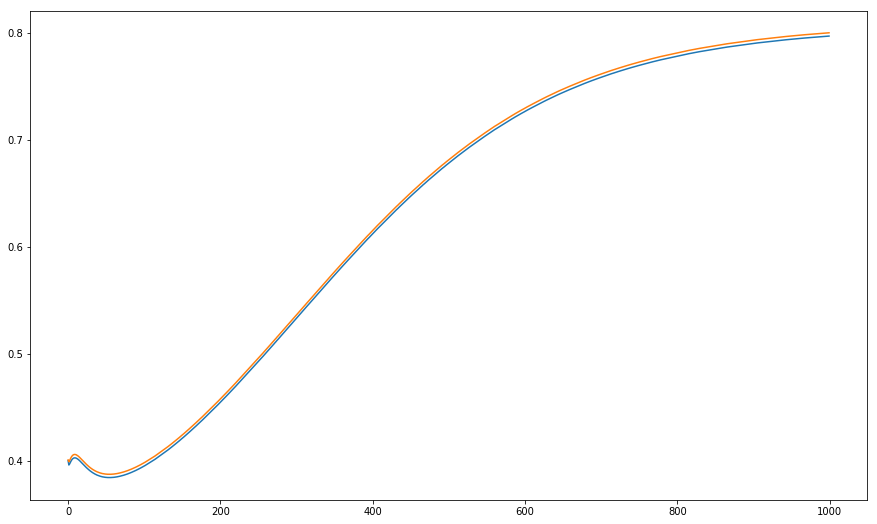

In [8]:
from __future__ import division

import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import math
#from rungekutta45_train import rk45
from sklearn import linear_model
from sklearn.metrics import accuracy_score
import time
start_time = time.time()

class SGDModel:
    def __init__(self):
        self.model = linear_model.SGDClassifier(warm_start=True, max_iter=5, tol=-np.infty)

    def train(self, X, y):
        self.model.fit(X, y)

    def predict(self, X):
        return self.model.predict(X)

class PerceptronModel:
    def __init__(self):
        self.model = linear_model.Perceptron(warm_start=True, max_iter=5, tol=-np.infty)

    def train(self, X, y):
        self.model.fit(X, y)

    def predict(self, X):
        return self.model.predict(X)
    
class LogisticRegression:
    def __init__(self):
        self.model = linear_model.LogisticRegression(warm_start=True, solver='sag')

    def train(self, X, y):
        self.model.fit(X, y)

    def predict(self, X):
        return self.model.predict(X)
    

    
if __name__ == "__main__":

    # # linear problem
    # odefun                    = lambda y: -y/2
    # options                   = {}
    # options['abstol']         = 1.0e-6
    # options['reltol']         = 1.0e-6 
    # options['numcheckpoints'] = 100
    # tspan                     = [0, 1.0]
    # y0                        = [2, 1.0]

    # oscillatory problem
    # odefun                    = lambda y: [-np.sin(y[2]), -100 * np.sin(100*y[2]), 1] 
    # options                   = {}
    # options['abstol']         = 1.0e-6
    # options['reltol']         = 1.0e-6 
    # options['numcheckpoints'] = 100
    # tspan                     = [0.0, 2 * math.pi]
    # y0                        = [1.0, 1.0, 0]
    
    # Allen Cahn
    #import allen_cahn as ac
    model                     = InitializeModel()
    odefun                    = lambda y: model['rhsFun'](y)
    #odefun                    = lambda y: [-np.sin(y[2]),-100 * np.sin(100*y[1]),1]
    options                   = {}
    options['abstol']         = 1.0e-8
    options['reltol']         = 1.0e-8
    options['numcheckpoints'] = 1000
    options['nobservations']  = 25
    options['model']          = SGDModel()
    options['nvalidation']    = 10
    options['shrinkfactor']   = 0.8
    options['maxshrinks']     = 5
    options['nsamples']       = 5
    tspan                     = [0.0, 0.3]
    #tspan                     = [0, 1.0]
    #y0                        = [2, 1.0,0]
    y0                        = model['y0']

    trajectory                = rk45(odefun, tspan, y0, options)
    
    # print number of accepted/rejected steps
    print("Accepted Steps:" + str(options['nacc']))
    print("Rejected Steps:" + str(options['nrej']))
    print("Time: %s seconds" % (time.time() - start_time))
    # Plot trajectory
    n = len(y0)

    # create a figure
    plt.figure(figsize=(15,9))
    
    for i in range(2):
        plt.plot(trajectory[i, :])

    plt.show()
